In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

    return df

In [5]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [6]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Offspeed Model

In [39]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [40]:
train_data = training_features.loc[training_features['pfx_x'].notnull()].drop(['pfx_x'], axis=1).copy()
train_label = training_features['pfx_x'].loc[training_features['pfx_x'].notnull()].copy()
testing_data = testing_features.loc[testing_features['spin_axis'].notnull()].drop(['pfx_x'], axis=1).copy()
testing_label = testing_features['pfx_x'].loc[testing_features['spin_axis'].notnull()].copy()

In [41]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [12]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [13]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [14]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [15]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [16]:
y_pred = model.predict(dtest)

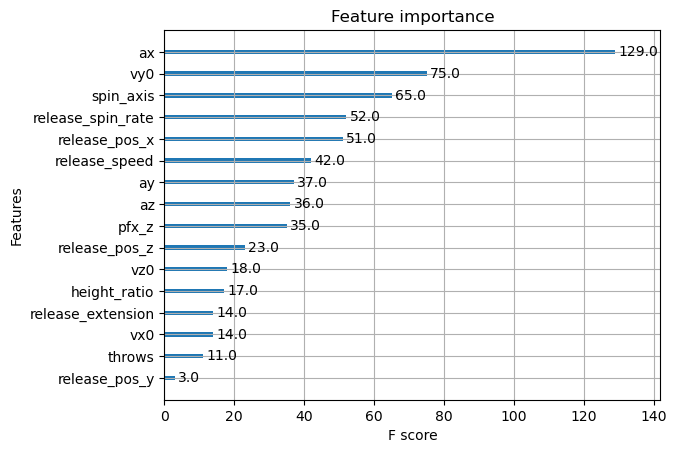

In [17]:
xgb.plot_importance(model)
plt.show()

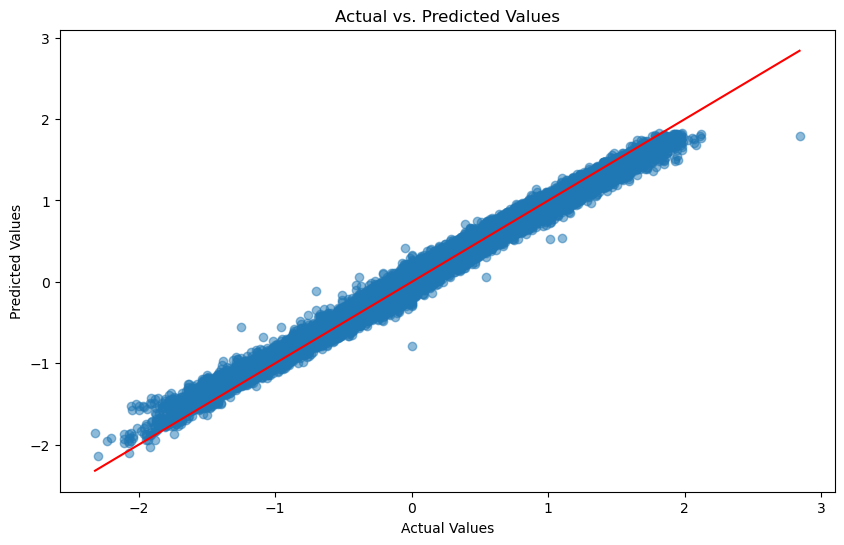

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [19]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [20]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 16:00:54,208] A new study created in memory with name: no-name-720b0832-2606-428f-ac7f-b365ff9c6247


[0]	eval-rmse:0.51440
[1]	eval-rmse:0.37477
[2]	eval-rmse:0.27610
[3]	eval-rmse:0.23698
[4]	eval-rmse:0.20878
[5]	eval-rmse:0.19300
[6]	eval-rmse:0.15311
[7]	eval-rmse:0.14503
[8]	eval-rmse:0.12148
[9]	eval-rmse:0.11870
[10]	eval-rmse:0.10369
[11]	eval-rmse:0.09211
[12]	eval-rmse:0.09142
[13]	eval-rmse:0.08372
[14]	eval-rmse:0.07731
[15]	eval-rmse:0.07177
[16]	eval-rmse:0.06783
[17]	eval-rmse:0.06699
[18]	eval-rmse:0.06616
[19]	eval-rmse:0.06273
[20]	eval-rmse:0.06165
[21]	eval-rmse:0.06121
[22]	eval-rmse:0.05901
[23]	eval-rmse:0.05826
[24]	eval-rmse:0.05804
[25]	eval-rmse:0.05737
[26]	eval-rmse:0.05487
[27]	eval-rmse:0.05441
[28]	eval-rmse:0.05419
[29]	eval-rmse:0.05373
[30]	eval-rmse:0.05340
[31]	eval-rmse:0.05318
[32]	eval-rmse:0.05125
[33]	eval-rmse:0.05099
[34]	eval-rmse:0.05073
[35]	eval-rmse:0.05060
[36]	eval-rmse:0.04880
[37]	eval-rmse:0.04851
[38]	eval-rmse:0.04835
[39]	eval-rmse:0.04663
[40]	eval-rmse:0.04562
[41]	eval-rmse:0.04532
[42]	eval-rmse:0.04499
[43]	eval-rmse:0.0447

[I 2023-11-14 16:00:56,089] Trial 0 finished with value: 0.030594168230891228 and parameters: {'max_depth': 4, 'eta': 0.28293760987512573, 'subsample': 0.5870821575878221, 'colsample_bytree': 0.5105421749510752, 'min_child_weight': 4}. Best is trial 0 with value: 0.030594168230891228.


[0]	eval-rmse:0.46574
[1]	eval-rmse:0.30527
[2]	eval-rmse:0.20284
[3]	eval-rmse:0.16568
[4]	eval-rmse:0.14421
[5]	eval-rmse:0.13426
[6]	eval-rmse:0.10171
[7]	eval-rmse:0.09786
[8]	eval-rmse:0.08040
[9]	eval-rmse:0.07928
[10]	eval-rmse:0.07146
[11]	eval-rmse:0.06436
[12]	eval-rmse:0.06351
[13]	eval-rmse:0.05927
[14]	eval-rmse:0.05644
[15]	eval-rmse:0.05388
[16]	eval-rmse:0.05142
[17]	eval-rmse:0.05059
[18]	eval-rmse:0.04962
[19]	eval-rmse:0.04812
[20]	eval-rmse:0.04767
[21]	eval-rmse:0.04731
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04562
[24]	eval-rmse:0.04539
[25]	eval-rmse:0.04526
[26]	eval-rmse:0.04451
[27]	eval-rmse:0.04423
[28]	eval-rmse:0.04398
[29]	eval-rmse:0.04368
[30]	eval-rmse:0.04357
[31]	eval-rmse:0.04344
[32]	eval-rmse:0.04254
[33]	eval-rmse:0.04235
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04202
[36]	eval-rmse:0.04129
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04109
[39]	eval-rmse:0.04067
[40]	eval-rmse:0.04026
[41]	eval-rmse:0.04005
[42]	eval-rmse:0.03997
[43]	eval-rmse:0.0398

[I 2023-11-14 16:00:59,070] Trial 1 finished with value: 0.03471767529845238 and parameters: {'max_depth': 8, 'eta': 0.35835381786156706, 'subsample': 0.5841635841335657, 'colsample_bytree': 0.5315956551898471, 'min_child_weight': 4}. Best is trial 0 with value: 0.030594168230891228.


[0]	eval-rmse:0.55032
[1]	eval-rmse:0.44293
[2]	eval-rmse:0.35770
[3]	eval-rmse:0.31497
[4]	eval-rmse:0.28049
[5]	eval-rmse:0.25859
[6]	eval-rmse:0.21417
[7]	eval-rmse:0.19894
[8]	eval-rmse:0.16816
[9]	eval-rmse:0.16073
[10]	eval-rmse:0.14062
[11]	eval-rmse:0.12479
[12]	eval-rmse:0.12128
[13]	eval-rmse:0.10956
[14]	eval-rmse:0.10026
[15]	eval-rmse:0.09333
[16]	eval-rmse:0.08748
[17]	eval-rmse:0.08608
[18]	eval-rmse:0.08549
[19]	eval-rmse:0.08076
[20]	eval-rmse:0.07985
[21]	eval-rmse:0.07900
[22]	eval-rmse:0.07520
[23]	eval-rmse:0.07489
[24]	eval-rmse:0.07463
[25]	eval-rmse:0.07398
[26]	eval-rmse:0.07048
[27]	eval-rmse:0.06989
[28]	eval-rmse:0.06942
[29]	eval-rmse:0.06889
[30]	eval-rmse:0.06850
[31]	eval-rmse:0.06829
[32]	eval-rmse:0.06498
[33]	eval-rmse:0.06461
[34]	eval-rmse:0.06399
[35]	eval-rmse:0.06378
[36]	eval-rmse:0.06096
[37]	eval-rmse:0.06069
[38]	eval-rmse:0.06038
[39]	eval-rmse:0.05867
[40]	eval-rmse:0.05638
[41]	eval-rmse:0.05599
[42]	eval-rmse:0.05547
[43]	eval-rmse:0.0551

[I 2023-11-14 16:01:00,696] Trial 2 finished with value: 0.0337400808930397 and parameters: {'max_depth': 4, 'eta': 0.20285118172642605, 'subsample': 0.4784355108819469, 'colsample_bytree': 0.44505820712367883, 'min_child_weight': 3}. Best is trial 0 with value: 0.030594168230891228.


[0]	eval-rmse:0.48757
[1]	eval-rmse:0.32393
[2]	eval-rmse:0.21923
[3]	eval-rmse:0.17998
[4]	eval-rmse:0.15709
[5]	eval-rmse:0.14708
[6]	eval-rmse:0.11116
[7]	eval-rmse:0.10647
[8]	eval-rmse:0.08828
[9]	eval-rmse:0.08670
[10]	eval-rmse:0.07830
[11]	eval-rmse:0.07233
[12]	eval-rmse:0.07196
[13]	eval-rmse:0.06747
[14]	eval-rmse:0.06456
[15]	eval-rmse:0.06338
[16]	eval-rmse:0.06148
[17]	eval-rmse:0.05823
[18]	eval-rmse:0.05681
[19]	eval-rmse:0.05543
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05418
[22]	eval-rmse:0.05176
[23]	eval-rmse:0.05164
[24]	eval-rmse:0.05147
[25]	eval-rmse:0.05109
[26]	eval-rmse:0.04927
[27]	eval-rmse:0.04878
[28]	eval-rmse:0.04864
[29]	eval-rmse:0.04829
[30]	eval-rmse:0.04810
[31]	eval-rmse:0.04790
[32]	eval-rmse:0.04779
[33]	eval-rmse:0.04732
[34]	eval-rmse:0.04718
[35]	eval-rmse:0.04714
[36]	eval-rmse:0.04573
[37]	eval-rmse:0.04555
[38]	eval-rmse:0.04528
[39]	eval-rmse:0.04440
[40]	eval-rmse:0.04333
[41]	eval-rmse:0.04314
[42]	eval-rmse:0.04291
[43]	eval-rmse:0.0428

[I 2023-11-14 16:01:02,971] Trial 3 finished with value: 0.0359971784055233 and parameters: {'max_depth': 7, 'eta': 0.3555656092878071, 'subsample': 0.5563024904863805, 'colsample_bytree': 0.42340526578840915, 'min_child_weight': 5}. Best is trial 0 with value: 0.030594168230891228.


[0]	eval-rmse:0.51031
[1]	eval-rmse:0.37699
[2]	eval-rmse:0.27992
[3]	eval-rmse:0.23632
[4]	eval-rmse:0.20416
[5]	eval-rmse:0.18604
[6]	eval-rmse:0.14502
[7]	eval-rmse:0.13492
[8]	eval-rmse:0.10931
[9]	eval-rmse:0.10523
[10]	eval-rmse:0.09106
[11]	eval-rmse:0.07968
[12]	eval-rmse:0.07852
[13]	eval-rmse:0.07126
[14]	eval-rmse:0.06622
[15]	eval-rmse:0.06164
[16]	eval-rmse:0.05817
[17]	eval-rmse:0.05717
[18]	eval-rmse:0.05640
[19]	eval-rmse:0.05361
[20]	eval-rmse:0.05298
[21]	eval-rmse:0.05252
[22]	eval-rmse:0.05004
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04947
[25]	eval-rmse:0.04923
[26]	eval-rmse:0.04745
[27]	eval-rmse:0.04715
[28]	eval-rmse:0.04697
[29]	eval-rmse:0.04665
[30]	eval-rmse:0.04632
[31]	eval-rmse:0.04626
[32]	eval-rmse:0.04462
[33]	eval-rmse:0.04440
[34]	eval-rmse:0.04416
[35]	eval-rmse:0.04403
[36]	eval-rmse:0.04262
[37]	eval-rmse:0.04247
[38]	eval-rmse:0.04219
[39]	eval-rmse:0.04103
[40]	eval-rmse:0.04018
[41]	eval-rmse:0.03988
[42]	eval-rmse:0.03970
[43]	eval-rmse:0.0395

[I 2023-11-14 16:01:05,321] Trial 4 finished with value: 0.030724050477147102 and parameters: {'max_depth': 7, 'eta': 0.2674789681492586, 'subsample': 0.46921185087919653, 'colsample_bytree': 0.5158848033656418, 'min_child_weight': 5}. Best is trial 0 with value: 0.030594168230891228.


[0]	eval-rmse:0.54461
[1]	eval-rmse:0.43580
[2]	eval-rmse:0.34957
[3]	eval-rmse:0.30691
[4]	eval-rmse:0.27098
[5]	eval-rmse:0.24803
[6]	eval-rmse:0.20326
[7]	eval-rmse:0.18850
[8]	eval-rmse:0.15769
[9]	eval-rmse:0.14990
[10]	eval-rmse:0.12921
[11]	eval-rmse:0.11214
[12]	eval-rmse:0.10918
[13]	eval-rmse:0.09781
[14]	eval-rmse:0.08911
[15]	eval-rmse:0.08146
[16]	eval-rmse:0.07583
[17]	eval-rmse:0.07502
[18]	eval-rmse:0.07433
[19]	eval-rmse:0.06984
[20]	eval-rmse:0.06928
[21]	eval-rmse:0.06870
[22]	eval-rmse:0.06462
[23]	eval-rmse:0.06422
[24]	eval-rmse:0.06406
[25]	eval-rmse:0.06382
[26]	eval-rmse:0.06078
[27]	eval-rmse:0.06031
[28]	eval-rmse:0.06002
[29]	eval-rmse:0.05975
[30]	eval-rmse:0.05945
[31]	eval-rmse:0.05928
[32]	eval-rmse:0.05672
[33]	eval-rmse:0.05639
[34]	eval-rmse:0.05615
[35]	eval-rmse:0.05588
[36]	eval-rmse:0.05365
[37]	eval-rmse:0.05347
[38]	eval-rmse:0.05324
[39]	eval-rmse:0.05121
[40]	eval-rmse:0.04952
[41]	eval-rmse:0.04924
[42]	eval-rmse:0.04897
[43]	eval-rmse:0.0487

[I 2023-11-14 16:01:07,083] Trial 5 finished with value: 0.03059452399611473 and parameters: {'max_depth': 5, 'eta': 0.20477765799014247, 'subsample': 0.4373168506684456, 'colsample_bytree': 0.5198896436363105, 'min_child_weight': 3}. Best is trial 0 with value: 0.030594168230891228.


[0]	eval-rmse:0.51339
[1]	eval-rmse:0.38022
[2]	eval-rmse:0.28318
[3]	eval-rmse:0.24005
[4]	eval-rmse:0.20840
[5]	eval-rmse:0.19057
[6]	eval-rmse:0.14932
[7]	eval-rmse:0.13956
[8]	eval-rmse:0.11410
[9]	eval-rmse:0.11022
[10]	eval-rmse:0.09494
[11]	eval-rmse:0.08328
[12]	eval-rmse:0.08212
[13]	eval-rmse:0.07456
[14]	eval-rmse:0.06921
[15]	eval-rmse:0.06417
[16]	eval-rmse:0.06059
[17]	eval-rmse:0.05968
[18]	eval-rmse:0.05900
[19]	eval-rmse:0.05583
[20]	eval-rmse:0.05515
[21]	eval-rmse:0.05472
[22]	eval-rmse:0.05198
[23]	eval-rmse:0.05140
[24]	eval-rmse:0.05124
[25]	eval-rmse:0.05099
[26]	eval-rmse:0.04923
[27]	eval-rmse:0.04889
[28]	eval-rmse:0.04865
[29]	eval-rmse:0.04840
[30]	eval-rmse:0.04824
[31]	eval-rmse:0.04813
[32]	eval-rmse:0.04620
[33]	eval-rmse:0.04592
[34]	eval-rmse:0.04579
[35]	eval-rmse:0.04568
[36]	eval-rmse:0.04404
[37]	eval-rmse:0.04390
[38]	eval-rmse:0.04352
[39]	eval-rmse:0.04234
[40]	eval-rmse:0.04134
[41]	eval-rmse:0.04107
[42]	eval-rmse:0.04087
[43]	eval-rmse:0.0407

[I 2023-11-14 16:01:09,070] Trial 6 finished with value: 0.030367109924554825 and parameters: {'max_depth': 6, 'eta': 0.266403811940395, 'subsample': 0.4027094746996102, 'colsample_bytree': 0.5292277384664813, 'min_child_weight': 5}. Best is trial 6 with value: 0.030367109924554825.


[0]	eval-rmse:0.52634
[1]	eval-rmse:0.40140
[2]	eval-rmse:0.30724
[3]	eval-rmse:0.26386
[4]	eval-rmse:0.23097
[5]	eval-rmse:0.20970
[6]	eval-rmse:0.16764
[7]	eval-rmse:0.13709
[8]	eval-rmse:0.11451
[9]	eval-rmse:0.10966
[10]	eval-rmse:0.09569
[11]	eval-rmse:0.08506
[12]	eval-rmse:0.08336
[13]	eval-rmse:0.07602
[14]	eval-rmse:0.07060
[15]	eval-rmse:0.06583
[16]	eval-rmse:0.06251
[17]	eval-rmse:0.06126
[18]	eval-rmse:0.06045
[19]	eval-rmse:0.05763
[20]	eval-rmse:0.05687
[21]	eval-rmse:0.05649
[22]	eval-rmse:0.05359
[23]	eval-rmse:0.05307
[24]	eval-rmse:0.05263
[25]	eval-rmse:0.05069
[26]	eval-rmse:0.04892
[27]	eval-rmse:0.04828
[28]	eval-rmse:0.04792
[29]	eval-rmse:0.04750
[30]	eval-rmse:0.04721
[31]	eval-rmse:0.04684
[32]	eval-rmse:0.04519
[33]	eval-rmse:0.04490
[34]	eval-rmse:0.04460
[35]	eval-rmse:0.04450
[36]	eval-rmse:0.04306
[37]	eval-rmse:0.04276
[38]	eval-rmse:0.04259
[39]	eval-rmse:0.04146
[40]	eval-rmse:0.04051
[41]	eval-rmse:0.04034
[42]	eval-rmse:0.04014
[43]	eval-rmse:0.0399

[I 2023-11-14 16:01:10,879] Trial 7 finished with value: 0.028250938281416893 and parameters: {'max_depth': 5, 'eta': 0.24437723710757972, 'subsample': 0.487463881697811, 'colsample_bytree': 0.5785651970080842, 'min_child_weight': 5}. Best is trial 7 with value: 0.028250938281416893.


[0]	eval-rmse:0.50526
[1]	eval-rmse:0.36554
[2]	eval-rmse:0.26638
[3]	eval-rmse:0.22346
[4]	eval-rmse:0.19411
[5]	eval-rmse:0.17666
[6]	eval-rmse:0.13709
[7]	eval-rmse:0.11097
[8]	eval-rmse:0.09236
[9]	eval-rmse:0.08883
[10]	eval-rmse:0.07818
[11]	eval-rmse:0.07040
[12]	eval-rmse:0.06936
[13]	eval-rmse:0.06392
[14]	eval-rmse:0.06019
[15]	eval-rmse:0.05616
[16]	eval-rmse:0.05354
[17]	eval-rmse:0.05237
[18]	eval-rmse:0.05153
[19]	eval-rmse:0.04927
[20]	eval-rmse:0.04865
[21]	eval-rmse:0.04826
[22]	eval-rmse:0.04618
[23]	eval-rmse:0.04556
[24]	eval-rmse:0.04523
[25]	eval-rmse:0.04373
[26]	eval-rmse:0.04248
[27]	eval-rmse:0.04213
[28]	eval-rmse:0.04189
[29]	eval-rmse:0.04156
[30]	eval-rmse:0.04138
[31]	eval-rmse:0.04118
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03970
[36]	eval-rmse:0.03868
[37]	eval-rmse:0.03842
[38]	eval-rmse:0.03814
[39]	eval-rmse:0.03743
[40]	eval-rmse:0.03668
[41]	eval-rmse:0.03651
[42]	eval-rmse:0.03639
[43]	eval-rmse:0.0362

[I 2023-11-14 16:01:12,771] Trial 8 finished with value: 0.028652822598814964 and parameters: {'max_depth': 6, 'eta': 0.2848060838024988, 'subsample': 0.4877318082784696, 'colsample_bytree': 0.5969250807573092, 'min_child_weight': 1}. Best is trial 7 with value: 0.028250938281416893.


[0]	eval-rmse:0.54333
[1]	eval-rmse:0.43469
[2]	eval-rmse:0.34870
[3]	eval-rmse:0.30391
[4]	eval-rmse:0.26633
[5]	eval-rmse:0.24243
[6]	eval-rmse:0.19781
[7]	eval-rmse:0.18154
[8]	eval-rmse:0.15062
[9]	eval-rmse:0.14283
[10]	eval-rmse:0.12221
[11]	eval-rmse:0.10600
[12]	eval-rmse:0.10253
[13]	eval-rmse:0.09081
[14]	eval-rmse:0.08192
[15]	eval-rmse:0.07558
[16]	eval-rmse:0.07038
[17]	eval-rmse:0.06913
[18]	eval-rmse:0.06831
[19]	eval-rmse:0.06356
[20]	eval-rmse:0.06278
[21]	eval-rmse:0.06230
[22]	eval-rmse:0.05848
[23]	eval-rmse:0.05823
[24]	eval-rmse:0.05816
[25]	eval-rmse:0.05781
[26]	eval-rmse:0.05516
[27]	eval-rmse:0.05478
[28]	eval-rmse:0.05455
[29]	eval-rmse:0.05432
[30]	eval-rmse:0.05409
[31]	eval-rmse:0.05390
[32]	eval-rmse:0.05146
[33]	eval-rmse:0.05119
[34]	eval-rmse:0.05096
[35]	eval-rmse:0.05084
[36]	eval-rmse:0.04856
[37]	eval-rmse:0.04841
[38]	eval-rmse:0.04825
[39]	eval-rmse:0.04685
[40]	eval-rmse:0.04538
[41]	eval-rmse:0.04512
[42]	eval-rmse:0.04491
[43]	eval-rmse:0.0447

[I 2023-11-14 16:01:15,179] Trial 9 finished with value: 0.03145400062203407 and parameters: {'max_depth': 7, 'eta': 0.2035852378933508, 'subsample': 0.42052835662564014, 'colsample_bytree': 0.4958490673532152, 'min_child_weight': 4}. Best is trial 7 with value: 0.028250938281416893.


[0]	eval-rmse:0.49217
[1]	eval-rmse:0.34020
[2]	eval-rmse:0.23829
[3]	eval-rmse:0.20034
[4]	eval-rmse:0.17696
[5]	eval-rmse:0.16382
[6]	eval-rmse:0.12802
[7]	eval-rmse:0.10622
[8]	eval-rmse:0.09020
[9]	eval-rmse:0.08770
[10]	eval-rmse:0.07841
[11]	eval-rmse:0.07186
[12]	eval-rmse:0.07063
[13]	eval-rmse:0.06505
[14]	eval-rmse:0.06185
[15]	eval-rmse:0.05817
[16]	eval-rmse:0.05562
[17]	eval-rmse:0.05435
[18]	eval-rmse:0.05310
[19]	eval-rmse:0.05164
[20]	eval-rmse:0.05101
[21]	eval-rmse:0.05042
[22]	eval-rmse:0.04873
[23]	eval-rmse:0.04818
[24]	eval-rmse:0.04752
[25]	eval-rmse:0.04568
[26]	eval-rmse:0.04464
[27]	eval-rmse:0.04364
[28]	eval-rmse:0.04335
[29]	eval-rmse:0.04306
[30]	eval-rmse:0.04285
[31]	eval-rmse:0.04240
[32]	eval-rmse:0.04141
[33]	eval-rmse:0.04103
[34]	eval-rmse:0.04082
[35]	eval-rmse:0.04070
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03831
[40]	eval-rmse:0.03754
[41]	eval-rmse:0.03731
[42]	eval-rmse:0.03717
[43]	eval-rmse:0.0369

[I 2023-11-14 16:01:16,757] Trial 10 finished with value: 0.027905648574233055 and parameters: {'max_depth': 5, 'eta': 0.3218828380330555, 'subsample': 0.5256542264164951, 'colsample_bytree': 0.5938773698735441, 'min_child_weight': 1}. Best is trial 10 with value: 0.027905648574233055.


[0]	eval-rmse:0.49075
[1]	eval-rmse:0.33778
[2]	eval-rmse:0.23569
[3]	eval-rmse:0.19808
[4]	eval-rmse:0.17511
[5]	eval-rmse:0.16224
[6]	eval-rmse:0.12673
[7]	eval-rmse:0.10505
[8]	eval-rmse:0.08914
[9]	eval-rmse:0.08665
[10]	eval-rmse:0.07755
[11]	eval-rmse:0.07145
[12]	eval-rmse:0.07024
[13]	eval-rmse:0.06479
[14]	eval-rmse:0.06153
[15]	eval-rmse:0.05813
[16]	eval-rmse:0.05586
[17]	eval-rmse:0.05449
[18]	eval-rmse:0.05375
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05104
[21]	eval-rmse:0.05050
[22]	eval-rmse:0.04858
[23]	eval-rmse:0.04790
[24]	eval-rmse:0.04754
[25]	eval-rmse:0.04623
[26]	eval-rmse:0.04535
[27]	eval-rmse:0.04468
[28]	eval-rmse:0.04434
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04334
[32]	eval-rmse:0.04227
[33]	eval-rmse:0.04190
[34]	eval-rmse:0.04177
[35]	eval-rmse:0.04158
[36]	eval-rmse:0.04052
[37]	eval-rmse:0.04002
[38]	eval-rmse:0.03982
[39]	eval-rmse:0.03909
[40]	eval-rmse:0.03837
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0378

[I 2023-11-14 16:01:18,628] Trial 11 finished with value: 0.02888139896094799 and parameters: {'max_depth': 5, 'eta': 0.32517548202194324, 'subsample': 0.5270041155348408, 'colsample_bytree': 0.5954324094692076, 'min_child_weight': 1}. Best is trial 10 with value: 0.027905648574233055.


[0]	eval-rmse:0.45979
[1]	eval-rmse:0.28779
[2]	eval-rmse:0.18654
[3]	eval-rmse:0.15824
[4]	eval-rmse:0.14428
[5]	eval-rmse:0.13708
[6]	eval-rmse:0.10681
[7]	eval-rmse:0.08972
[8]	eval-rmse:0.07898
[9]	eval-rmse:0.07672
[10]	eval-rmse:0.06992
[11]	eval-rmse:0.06552
[12]	eval-rmse:0.06355
[13]	eval-rmse:0.05930
[14]	eval-rmse:0.05670
[15]	eval-rmse:0.05449
[16]	eval-rmse:0.05322
[17]	eval-rmse:0.05199
[18]	eval-rmse:0.05103
[19]	eval-rmse:0.04966
[20]	eval-rmse:0.04907
[21]	eval-rmse:0.04861
[22]	eval-rmse:0.04744
[23]	eval-rmse:0.04628
[24]	eval-rmse:0.04561
[25]	eval-rmse:0.04437
[26]	eval-rmse:0.04340
[27]	eval-rmse:0.04254
[28]	eval-rmse:0.04221
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04183
[31]	eval-rmse:0.04161
[32]	eval-rmse:0.04055
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03859
[39]	eval-rmse:0.03806
[40]	eval-rmse:0.03754
[41]	eval-rmse:0.03723
[42]	eval-rmse:0.03710
[43]	eval-rmse:0.0369

[I 2023-11-14 16:01:20,444] Trial 12 finished with value: 0.028606126084923744 and parameters: {'max_depth': 5, 'eta': 0.39846348853669755, 'subsample': 0.5152763612670876, 'colsample_bytree': 0.5697876556810042, 'min_child_weight': 2}. Best is trial 10 with value: 0.027905648574233055.


[0]	eval-rmse:0.52896
[1]	eval-rmse:0.40622
[2]	eval-rmse:0.31302
[3]	eval-rmse:0.26946
[4]	eval-rmse:0.23637
[5]	eval-rmse:0.21467
[6]	eval-rmse:0.17216
[7]	eval-rmse:0.14097
[8]	eval-rmse:0.11807
[9]	eval-rmse:0.11282
[10]	eval-rmse:0.09802
[11]	eval-rmse:0.08751
[12]	eval-rmse:0.08569
[13]	eval-rmse:0.07764
[14]	eval-rmse:0.07171
[15]	eval-rmse:0.06657
[16]	eval-rmse:0.06316
[17]	eval-rmse:0.06201
[18]	eval-rmse:0.06146
[19]	eval-rmse:0.05868
[20]	eval-rmse:0.05798
[21]	eval-rmse:0.05729
[22]	eval-rmse:0.05487
[23]	eval-rmse:0.05401
[24]	eval-rmse:0.05365
[25]	eval-rmse:0.05106
[26]	eval-rmse:0.04937
[27]	eval-rmse:0.04871
[28]	eval-rmse:0.04841
[29]	eval-rmse:0.04810
[30]	eval-rmse:0.04781
[31]	eval-rmse:0.04744
[32]	eval-rmse:0.04564
[33]	eval-rmse:0.04536
[34]	eval-rmse:0.04507
[35]	eval-rmse:0.04485
[36]	eval-rmse:0.04344
[37]	eval-rmse:0.04327
[38]	eval-rmse:0.04314
[39]	eval-rmse:0.04188
[40]	eval-rmse:0.04085
[41]	eval-rmse:0.04057
[42]	eval-rmse:0.04040
[43]	eval-rmse:0.0401

[I 2023-11-14 16:01:22,394] Trial 13 finished with value: 0.02783787064254284 and parameters: {'max_depth': 5, 'eta': 0.23885758591773534, 'subsample': 0.5395892446355433, 'colsample_bytree': 0.5644605981186814, 'min_child_weight': 2}. Best is trial 13 with value: 0.02783787064254284.


[0]	eval-rmse:0.49828
[1]	eval-rmse:0.34551
[2]	eval-rmse:0.24369
[3]	eval-rmse:0.20876
[4]	eval-rmse:0.18522
[5]	eval-rmse:0.17286
[6]	eval-rmse:0.13695
[7]	eval-rmse:0.13119
[8]	eval-rmse:0.10995
[9]	eval-rmse:0.10800
[10]	eval-rmse:0.09459
[11]	eval-rmse:0.08502
[12]	eval-rmse:0.08390
[13]	eval-rmse:0.07801
[14]	eval-rmse:0.07302
[15]	eval-rmse:0.06818
[16]	eval-rmse:0.06502
[17]	eval-rmse:0.06383
[18]	eval-rmse:0.06310
[19]	eval-rmse:0.06043
[20]	eval-rmse:0.05937
[21]	eval-rmse:0.05863
[22]	eval-rmse:0.05613
[23]	eval-rmse:0.05549
[24]	eval-rmse:0.05523
[25]	eval-rmse:0.05497
[26]	eval-rmse:0.05320
[27]	eval-rmse:0.05274
[28]	eval-rmse:0.05229
[29]	eval-rmse:0.05185
[30]	eval-rmse:0.05126
[31]	eval-rmse:0.05101
[32]	eval-rmse:0.04958
[33]	eval-rmse:0.04928
[34]	eval-rmse:0.04902
[35]	eval-rmse:0.04879
[36]	eval-rmse:0.04728
[37]	eval-rmse:0.04691
[38]	eval-rmse:0.04660
[39]	eval-rmse:0.04564
[40]	eval-rmse:0.04452
[41]	eval-rmse:0.04423
[42]	eval-rmse:0.04405
[43]	eval-rmse:0.0437

[I 2023-11-14 16:01:24,088] Trial 14 finished with value: 0.031941626220941544 and parameters: {'max_depth': 4, 'eta': 0.32180934776178655, 'subsample': 0.5396084838953555, 'colsample_bytree': 0.5544917361533277, 'min_child_weight': 2}. Best is trial 13 with value: 0.02783787064254284.


[0]	eval-rmse:0.52440
[1]	eval-rmse:0.39988
[2]	eval-rmse:0.30639
[3]	eval-rmse:0.26261
[4]	eval-rmse:0.22861
[5]	eval-rmse:0.20847
[6]	eval-rmse:0.16537
[7]	eval-rmse:0.15354
[8]	eval-rmse:0.12601
[9]	eval-rmse:0.12084
[10]	eval-rmse:0.10360
[11]	eval-rmse:0.09045
[12]	eval-rmse:0.08885
[13]	eval-rmse:0.08035
[14]	eval-rmse:0.07341
[15]	eval-rmse:0.06761
[16]	eval-rmse:0.06347
[17]	eval-rmse:0.06276
[18]	eval-rmse:0.06197
[19]	eval-rmse:0.05871
[20]	eval-rmse:0.05804
[21]	eval-rmse:0.05755
[22]	eval-rmse:0.05471
[23]	eval-rmse:0.05411
[24]	eval-rmse:0.05390
[25]	eval-rmse:0.05362
[26]	eval-rmse:0.05138
[27]	eval-rmse:0.05093
[28]	eval-rmse:0.05069
[29]	eval-rmse:0.05040
[30]	eval-rmse:0.05021
[31]	eval-rmse:0.04999
[32]	eval-rmse:0.04789
[33]	eval-rmse:0.04766
[34]	eval-rmse:0.04745
[35]	eval-rmse:0.04728
[36]	eval-rmse:0.04543
[37]	eval-rmse:0.04521
[38]	eval-rmse:0.04498
[39]	eval-rmse:0.04364
[40]	eval-rmse:0.04261
[41]	eval-rmse:0.04242
[42]	eval-rmse:0.04220
[43]	eval-rmse:0.0420

[I 2023-11-14 16:01:26,068] Trial 15 finished with value: 0.02977151609957218 and parameters: {'max_depth': 6, 'eta': 0.24303768189054992, 'subsample': 0.5554443827547734, 'colsample_bytree': 0.5572531470482095, 'min_child_weight': 2}. Best is trial 13 with value: 0.02783787064254284.


[0]	eval-rmse:0.50006
[1]	eval-rmse:0.35386
[2]	eval-rmse:0.25295
[3]	eval-rmse:0.21318
[4]	eval-rmse:0.18730
[5]	eval-rmse:0.17232
[6]	eval-rmse:0.13471
[7]	eval-rmse:0.11091
[8]	eval-rmse:0.09442
[9]	eval-rmse:0.09191
[10]	eval-rmse:0.08152
[11]	eval-rmse:0.07414
[12]	eval-rmse:0.07297
[13]	eval-rmse:0.06716
[14]	eval-rmse:0.06358
[15]	eval-rmse:0.05943
[16]	eval-rmse:0.05636
[17]	eval-rmse:0.05502
[18]	eval-rmse:0.05413
[19]	eval-rmse:0.05231
[20]	eval-rmse:0.05157
[21]	eval-rmse:0.05131
[22]	eval-rmse:0.04924
[23]	eval-rmse:0.04856
[24]	eval-rmse:0.04805
[25]	eval-rmse:0.04634
[26]	eval-rmse:0.04511
[27]	eval-rmse:0.04460
[28]	eval-rmse:0.04434
[29]	eval-rmse:0.04393
[30]	eval-rmse:0.04360
[31]	eval-rmse:0.04348
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04183
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04125
[36]	eval-rmse:0.04017
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03786
[41]	eval-rmse:0.03759
[42]	eval-rmse:0.03746
[43]	eval-rmse:0.0372

[I 2023-11-14 16:01:27,935] Trial 16 finished with value: 0.028429387137293816 and parameters: {'max_depth': 5, 'eta': 0.3037139529712014, 'subsample': 0.5156483171190126, 'colsample_bytree': 0.5991238775524094, 'min_child_weight': 1}. Best is trial 13 with value: 0.02783787064254284.


[0]	eval-rmse:0.53256
[1]	eval-rmse:0.40978
[2]	eval-rmse:0.31731
[3]	eval-rmse:0.27586
[4]	eval-rmse:0.24373
[5]	eval-rmse:0.22428
[6]	eval-rmse:0.18158
[7]	eval-rmse:0.17086
[8]	eval-rmse:0.14334
[9]	eval-rmse:0.13827
[10]	eval-rmse:0.12021
[11]	eval-rmse:0.10623
[12]	eval-rmse:0.10446
[13]	eval-rmse:0.09475
[14]	eval-rmse:0.08795
[15]	eval-rmse:0.08132
[16]	eval-rmse:0.07662
[17]	eval-rmse:0.07576
[18]	eval-rmse:0.07511
[19]	eval-rmse:0.07112
[20]	eval-rmse:0.07039
[21]	eval-rmse:0.06979
[22]	eval-rmse:0.06633
[23]	eval-rmse:0.06566
[24]	eval-rmse:0.06546
[25]	eval-rmse:0.06496
[26]	eval-rmse:0.06226
[27]	eval-rmse:0.06171
[28]	eval-rmse:0.06133
[29]	eval-rmse:0.06090
[30]	eval-rmse:0.06051
[31]	eval-rmse:0.06028
[32]	eval-rmse:0.05752
[33]	eval-rmse:0.05711
[34]	eval-rmse:0.05673
[35]	eval-rmse:0.05657
[36]	eval-rmse:0.05400
[37]	eval-rmse:0.05365
[38]	eval-rmse:0.05347
[39]	eval-rmse:0.05162
[40]	eval-rmse:0.05010
[41]	eval-rmse:0.04957
[42]	eval-rmse:0.04918
[43]	eval-rmse:0.0488

[I 2023-11-14 16:01:29,597] Trial 17 finished with value: 0.03170564025640488 and parameters: {'max_depth': 4, 'eta': 0.23909441351604982, 'subsample': 0.5019627312165844, 'colsample_bytree': 0.5495121075243378, 'min_child_weight': 2}. Best is trial 13 with value: 0.02783787064254284.


[0]	eval-rmse:0.49691
[1]	eval-rmse:0.34832
[2]	eval-rmse:0.24705
[3]	eval-rmse:0.20796
[4]	eval-rmse:0.18307
[5]	eval-rmse:0.16866
[6]	eval-rmse:0.13181
[7]	eval-rmse:0.10888
[8]	eval-rmse:0.09256
[9]	eval-rmse:0.09022
[10]	eval-rmse:0.08032
[11]	eval-rmse:0.07326
[12]	eval-rmse:0.07225
[13]	eval-rmse:0.06662
[14]	eval-rmse:0.06291
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05622
[17]	eval-rmse:0.05486
[18]	eval-rmse:0.05388
[19]	eval-rmse:0.05182
[20]	eval-rmse:0.05108
[21]	eval-rmse:0.05065
[22]	eval-rmse:0.04882
[23]	eval-rmse:0.04797
[24]	eval-rmse:0.04752
[25]	eval-rmse:0.04580
[26]	eval-rmse:0.04445
[27]	eval-rmse:0.04395
[28]	eval-rmse:0.04369
[29]	eval-rmse:0.04338
[30]	eval-rmse:0.04284
[31]	eval-rmse:0.04260
[32]	eval-rmse:0.04138
[33]	eval-rmse:0.04103
[34]	eval-rmse:0.04084
[35]	eval-rmse:0.04070
[36]	eval-rmse:0.03945
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03820
[40]	eval-rmse:0.03770
[41]	eval-rmse:0.03749
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0370

[I 2023-11-14 16:01:31,326] Trial 18 finished with value: 0.027618130668997765 and parameters: {'max_depth': 5, 'eta': 0.31107395003827554, 'subsample': 0.5465564496271853, 'colsample_bytree': 0.5767679848413775, 'min_child_weight': 1}. Best is trial 18 with value: 0.027618130668997765.


[0]	eval-rmse:0.53340
[1]	eval-rmse:0.41653
[2]	eval-rmse:0.32665
[3]	eval-rmse:0.28156
[4]	eval-rmse:0.24634
[5]	eval-rmse:0.22240
[6]	eval-rmse:0.17903
[7]	eval-rmse:0.14657
[8]	eval-rmse:0.12161
[9]	eval-rmse:0.11452
[10]	eval-rmse:0.09857
[11]	eval-rmse:0.08636
[12]	eval-rmse:0.08386
[13]	eval-rmse:0.07571
[14]	eval-rmse:0.06960
[15]	eval-rmse:0.06382
[16]	eval-rmse:0.06012
[17]	eval-rmse:0.05935
[18]	eval-rmse:0.05867
[19]	eval-rmse:0.05557
[20]	eval-rmse:0.05503
[21]	eval-rmse:0.05455
[22]	eval-rmse:0.05179
[23]	eval-rmse:0.05132
[24]	eval-rmse:0.05091
[25]	eval-rmse:0.04849
[26]	eval-rmse:0.04680
[27]	eval-rmse:0.04648
[28]	eval-rmse:0.04620
[29]	eval-rmse:0.04596
[30]	eval-rmse:0.04579
[31]	eval-rmse:0.04558
[32]	eval-rmse:0.04400
[33]	eval-rmse:0.04380
[34]	eval-rmse:0.04367
[35]	eval-rmse:0.04347
[36]	eval-rmse:0.04193
[37]	eval-rmse:0.04172
[38]	eval-rmse:0.04159
[39]	eval-rmse:0.04043
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03924
[42]	eval-rmse:0.03905
[43]	eval-rmse:0.0388

[I 2023-11-14 16:01:33,328] Trial 19 finished with value: 0.027914192527532578 and parameters: {'max_depth': 6, 'eta': 0.22386868162208884, 'subsample': 0.5649013333725832, 'colsample_bytree': 0.572623130714141, 'min_child_weight': 2}. Best is trial 18 with value: 0.027618130668997765.


[0]	eval-rmse:0.52009
[1]	eval-rmse:0.38910
[2]	eval-rmse:0.29252
[3]	eval-rmse:0.24876
[4]	eval-rmse:0.21625
[5]	eval-rmse:0.19790
[6]	eval-rmse:0.15558
[7]	eval-rmse:0.14499
[8]	eval-rmse:0.11879
[9]	eval-rmse:0.11538
[10]	eval-rmse:0.09966
[11]	eval-rmse:0.08867
[12]	eval-rmse:0.08724
[13]	eval-rmse:0.07865
[14]	eval-rmse:0.07248
[15]	eval-rmse:0.06850
[16]	eval-rmse:0.06471
[17]	eval-rmse:0.06308
[18]	eval-rmse:0.06248
[19]	eval-rmse:0.05890
[20]	eval-rmse:0.05797
[21]	eval-rmse:0.05750
[22]	eval-rmse:0.05447
[23]	eval-rmse:0.05412
[24]	eval-rmse:0.05397
[25]	eval-rmse:0.05351
[26]	eval-rmse:0.05157
[27]	eval-rmse:0.05091
[28]	eval-rmse:0.05055
[29]	eval-rmse:0.05023
[30]	eval-rmse:0.04995
[31]	eval-rmse:0.04975
[32]	eval-rmse:0.04770
[33]	eval-rmse:0.04722
[34]	eval-rmse:0.04689
[35]	eval-rmse:0.04673
[36]	eval-rmse:0.04500
[37]	eval-rmse:0.04482
[38]	eval-rmse:0.04462
[39]	eval-rmse:0.04353
[40]	eval-rmse:0.04257
[41]	eval-rmse:0.04217
[42]	eval-rmse:0.04190
[43]	eval-rmse:0.0416

[I 2023-11-14 16:01:35,411] Trial 20 finished with value: 0.030188176780939102 and parameters: {'max_depth': 6, 'eta': 0.25901755803094156, 'subsample': 0.5949399817554758, 'colsample_bytree': 0.4956187850650843, 'min_child_weight': 1}. Best is trial 18 with value: 0.027618130668997765.


[0]	eval-rmse:0.49919
[1]	eval-rmse:0.35231
[2]	eval-rmse:0.25131
[3]	eval-rmse:0.21182
[4]	eval-rmse:0.18634
[5]	eval-rmse:0.17153
[6]	eval-rmse:0.13433
[7]	eval-rmse:0.11093
[8]	eval-rmse:0.09429
[9]	eval-rmse:0.09174
[10]	eval-rmse:0.08136
[11]	eval-rmse:0.07436
[12]	eval-rmse:0.07316
[13]	eval-rmse:0.06710
[14]	eval-rmse:0.06352
[15]	eval-rmse:0.05983
[16]	eval-rmse:0.05676
[17]	eval-rmse:0.05545
[18]	eval-rmse:0.05471
[19]	eval-rmse:0.05244
[20]	eval-rmse:0.05178
[21]	eval-rmse:0.05118
[22]	eval-rmse:0.04914
[23]	eval-rmse:0.04858
[24]	eval-rmse:0.04822
[25]	eval-rmse:0.04666
[26]	eval-rmse:0.04537
[27]	eval-rmse:0.04509
[28]	eval-rmse:0.04490
[29]	eval-rmse:0.04451
[30]	eval-rmse:0.04379
[31]	eval-rmse:0.04340
[32]	eval-rmse:0.04216
[33]	eval-rmse:0.04195
[34]	eval-rmse:0.04156
[35]	eval-rmse:0.04145
[36]	eval-rmse:0.04030
[37]	eval-rmse:0.04008
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03890
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0377

[I 2023-11-14 16:01:37,158] Trial 21 finished with value: 0.02751670405268669 and parameters: {'max_depth': 5, 'eta': 0.30582099102573257, 'subsample': 0.5519888301723678, 'colsample_bytree': 0.5786951023279191, 'min_child_weight': 1}. Best is trial 21 with value: 0.02751670405268669.


[0]	eval-rmse:0.50776
[1]	eval-rmse:0.36735
[2]	eval-rmse:0.26792
[3]	eval-rmse:0.22680
[4]	eval-rmse:0.19889
[5]	eval-rmse:0.18200
[6]	eval-rmse:0.14294
[7]	eval-rmse:0.11675
[8]	eval-rmse:0.09849
[9]	eval-rmse:0.09527
[10]	eval-rmse:0.08392
[11]	eval-rmse:0.07595
[12]	eval-rmse:0.07488
[13]	eval-rmse:0.06894
[14]	eval-rmse:0.06495
[15]	eval-rmse:0.06041
[16]	eval-rmse:0.05748
[17]	eval-rmse:0.05622
[18]	eval-rmse:0.05498
[19]	eval-rmse:0.05267
[20]	eval-rmse:0.05204
[21]	eval-rmse:0.05179
[22]	eval-rmse:0.04952
[23]	eval-rmse:0.04886
[24]	eval-rmse:0.04861
[25]	eval-rmse:0.04697
[26]	eval-rmse:0.04586
[27]	eval-rmse:0.04531
[28]	eval-rmse:0.04495
[29]	eval-rmse:0.04446
[30]	eval-rmse:0.04411
[31]	eval-rmse:0.04391
[32]	eval-rmse:0.04244
[33]	eval-rmse:0.04217
[34]	eval-rmse:0.04199
[35]	eval-rmse:0.04184
[36]	eval-rmse:0.04072
[37]	eval-rmse:0.04037
[38]	eval-rmse:0.04017
[39]	eval-rmse:0.03921
[40]	eval-rmse:0.03829
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03786
[43]	eval-rmse:0.0377

[I 2023-11-14 16:01:39,032] Trial 22 finished with value: 0.027307815849781036 and parameters: {'max_depth': 5, 'eta': 0.28635611728945065, 'subsample': 0.544516491654933, 'colsample_bytree': 0.576893619046259, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.51046
[1]	eval-rmse:0.36749
[2]	eval-rmse:0.26795
[3]	eval-rmse:0.22921
[4]	eval-rmse:0.20253
[5]	eval-rmse:0.18676
[6]	eval-rmse:0.14783
[7]	eval-rmse:0.12310
[8]	eval-rmse:0.10535
[9]	eval-rmse:0.10263
[10]	eval-rmse:0.09190
[11]	eval-rmse:0.08427
[12]	eval-rmse:0.08272
[13]	eval-rmse:0.07546
[14]	eval-rmse:0.07033
[15]	eval-rmse:0.06662
[16]	eval-rmse:0.06367
[17]	eval-rmse:0.06209
[18]	eval-rmse:0.06113
[19]	eval-rmse:0.05872
[20]	eval-rmse:0.05801
[21]	eval-rmse:0.05703
[22]	eval-rmse:0.05498
[23]	eval-rmse:0.05430
[24]	eval-rmse:0.05401
[25]	eval-rmse:0.05221
[26]	eval-rmse:0.05024
[27]	eval-rmse:0.04962
[28]	eval-rmse:0.04934
[29]	eval-rmse:0.04896
[30]	eval-rmse:0.04857
[31]	eval-rmse:0.04813
[32]	eval-rmse:0.04676
[33]	eval-rmse:0.04646
[34]	eval-rmse:0.04614
[35]	eval-rmse:0.04581
[36]	eval-rmse:0.04448
[37]	eval-rmse:0.04412
[38]	eval-rmse:0.04393
[39]	eval-rmse:0.04285
[40]	eval-rmse:0.04174
[41]	eval-rmse:0.04138
[42]	eval-rmse:0.04116
[43]	eval-rmse:0.0409

[I 2023-11-14 16:01:40,747] Trial 23 finished with value: 0.02856891229748726 and parameters: {'max_depth': 4, 'eta': 0.29239151220500376, 'subsample': 0.5712361209191466, 'colsample_bytree': 0.5781495196222385, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.49902
[1]	eval-rmse:0.35198
[2]	eval-rmse:0.25095
[3]	eval-rmse:0.21208
[4]	eval-rmse:0.18630
[5]	eval-rmse:0.17270
[6]	eval-rmse:0.13462
[7]	eval-rmse:0.12831
[8]	eval-rmse:0.10645
[9]	eval-rmse:0.10421
[10]	eval-rmse:0.09105
[11]	eval-rmse:0.08093
[12]	eval-rmse:0.08009
[13]	eval-rmse:0.07378
[14]	eval-rmse:0.06917
[15]	eval-rmse:0.06502
[16]	eval-rmse:0.06163
[17]	eval-rmse:0.06048
[18]	eval-rmse:0.05892
[19]	eval-rmse:0.05653
[20]	eval-rmse:0.05573
[21]	eval-rmse:0.05513
[22]	eval-rmse:0.05270
[23]	eval-rmse:0.05177
[24]	eval-rmse:0.05152
[25]	eval-rmse:0.05108
[26]	eval-rmse:0.04943
[27]	eval-rmse:0.04893
[28]	eval-rmse:0.04868
[29]	eval-rmse:0.04819
[30]	eval-rmse:0.04782
[31]	eval-rmse:0.04762
[32]	eval-rmse:0.04591
[33]	eval-rmse:0.04561
[34]	eval-rmse:0.04538
[35]	eval-rmse:0.04516
[36]	eval-rmse:0.04364
[37]	eval-rmse:0.04341
[38]	eval-rmse:0.04319
[39]	eval-rmse:0.04210
[40]	eval-rmse:0.04106
[41]	eval-rmse:0.04094
[42]	eval-rmse:0.04075
[43]	eval-rmse:0.0405

[I 2023-11-14 16:01:42,636] Trial 24 finished with value: 0.02869436703622341 and parameters: {'max_depth': 5, 'eta': 0.30623645140526345, 'subsample': 0.5449907922948832, 'colsample_bytree': 0.5426789324712102, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.50832
[1]	eval-rmse:0.36842
[2]	eval-rmse:0.26912
[3]	eval-rmse:0.22781
[4]	eval-rmse:0.19960
[5]	eval-rmse:0.18263
[6]	eval-rmse:0.14351
[7]	eval-rmse:0.11803
[8]	eval-rmse:0.09921
[9]	eval-rmse:0.09594
[10]	eval-rmse:0.08421
[11]	eval-rmse:0.07624
[12]	eval-rmse:0.07484
[13]	eval-rmse:0.06908
[14]	eval-rmse:0.06503
[15]	eval-rmse:0.06110
[16]	eval-rmse:0.05809
[17]	eval-rmse:0.05688
[18]	eval-rmse:0.05597
[19]	eval-rmse:0.05366
[20]	eval-rmse:0.05295
[21]	eval-rmse:0.05234
[22]	eval-rmse:0.05016
[23]	eval-rmse:0.04926
[24]	eval-rmse:0.04893
[25]	eval-rmse:0.04737
[26]	eval-rmse:0.04595
[27]	eval-rmse:0.04531
[28]	eval-rmse:0.04508
[29]	eval-rmse:0.04472
[30]	eval-rmse:0.04448
[31]	eval-rmse:0.04428
[32]	eval-rmse:0.04296
[33]	eval-rmse:0.04266
[34]	eval-rmse:0.04244
[35]	eval-rmse:0.04215
[36]	eval-rmse:0.04098
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04042
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0382

[I 2023-11-14 16:01:44,516] Trial 25 finished with value: 0.028202293440699577 and parameters: {'max_depth': 5, 'eta': 0.28499106226369664, 'subsample': 0.5712131862804131, 'colsample_bytree': 0.5808174592828086, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.50753
[1]	eval-rmse:0.36204
[2]	eval-rmse:0.26191
[3]	eval-rmse:0.22456
[4]	eval-rmse:0.19839
[5]	eval-rmse:0.18423
[6]	eval-rmse:0.14579
[7]	eval-rmse:0.13895
[8]	eval-rmse:0.11692
[9]	eval-rmse:0.11446
[10]	eval-rmse:0.10062
[11]	eval-rmse:0.08879
[12]	eval-rmse:0.08781
[13]	eval-rmse:0.08034
[14]	eval-rmse:0.07500
[15]	eval-rmse:0.06997
[16]	eval-rmse:0.06649
[17]	eval-rmse:0.06541
[18]	eval-rmse:0.06439
[19]	eval-rmse:0.06122
[20]	eval-rmse:0.06022
[21]	eval-rmse:0.05961
[22]	eval-rmse:0.05714
[23]	eval-rmse:0.05642
[24]	eval-rmse:0.05607
[25]	eval-rmse:0.05549
[26]	eval-rmse:0.05358
[27]	eval-rmse:0.05323
[28]	eval-rmse:0.05288
[29]	eval-rmse:0.05239
[30]	eval-rmse:0.05208
[31]	eval-rmse:0.05169
[32]	eval-rmse:0.04951
[33]	eval-rmse:0.04926
[34]	eval-rmse:0.04898
[35]	eval-rmse:0.04884
[36]	eval-rmse:0.04763
[37]	eval-rmse:0.04736
[38]	eval-rmse:0.04695
[39]	eval-rmse:0.04561
[40]	eval-rmse:0.04457
[41]	eval-rmse:0.04430
[42]	eval-rmse:0.04401
[43]	eval-rmse:0.0437

[I 2023-11-14 16:01:46,143] Trial 26 finished with value: 0.030677197501063347 and parameters: {'max_depth': 4, 'eta': 0.29965500750952395, 'subsample': 0.5479690229973929, 'colsample_bytree': 0.5462158299946558, 'min_child_weight': 3}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.51038
[1]	eval-rmse:0.37460
[2]	eval-rmse:0.27665
[3]	eval-rmse:0.23300
[4]	eval-rmse:0.20253
[5]	eval-rmse:0.18385
[6]	eval-rmse:0.14355
[7]	eval-rmse:0.11627
[8]	eval-rmse:0.09641
[9]	eval-rmse:0.09246
[10]	eval-rmse:0.08114
[11]	eval-rmse:0.07242
[12]	eval-rmse:0.07107
[13]	eval-rmse:0.06522
[14]	eval-rmse:0.06112
[15]	eval-rmse:0.05729
[16]	eval-rmse:0.05473
[17]	eval-rmse:0.05365
[18]	eval-rmse:0.05273
[19]	eval-rmse:0.05041
[20]	eval-rmse:0.04985
[21]	eval-rmse:0.04951
[22]	eval-rmse:0.04750
[23]	eval-rmse:0.04690
[24]	eval-rmse:0.04654
[25]	eval-rmse:0.04472
[26]	eval-rmse:0.04327
[27]	eval-rmse:0.04287
[28]	eval-rmse:0.04259
[29]	eval-rmse:0.04234
[30]	eval-rmse:0.04215
[31]	eval-rmse:0.04198
[32]	eval-rmse:0.04073
[33]	eval-rmse:0.04055
[34]	eval-rmse:0.04016
[35]	eval-rmse:0.03997
[36]	eval-rmse:0.03881
[37]	eval-rmse:0.03864
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03758
[40]	eval-rmse:0.03668
[41]	eval-rmse:0.03659
[42]	eval-rmse:0.03644
[43]	eval-rmse:0.0363

[I 2023-11-14 16:01:48,324] Trial 27 finished with value: 0.028209185227751732 and parameters: {'max_depth': 6, 'eta': 0.2735352058412791, 'subsample': 0.5980262294237682, 'colsample_bytree': 0.5630788161535452, 'min_child_weight': 2}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.49946
[1]	eval-rmse:0.35286
[2]	eval-rmse:0.25183
[3]	eval-rmse:0.21241
[4]	eval-rmse:0.18686
[5]	eval-rmse:0.17208
[6]	eval-rmse:0.13472
[7]	eval-rmse:0.11111
[8]	eval-rmse:0.09421
[9]	eval-rmse:0.09169
[10]	eval-rmse:0.08113
[11]	eval-rmse:0.07390
[12]	eval-rmse:0.07295
[13]	eval-rmse:0.06701
[14]	eval-rmse:0.06309
[15]	eval-rmse:0.05946
[16]	eval-rmse:0.05708
[17]	eval-rmse:0.05575
[18]	eval-rmse:0.05453
[19]	eval-rmse:0.05248
[20]	eval-rmse:0.05174
[21]	eval-rmse:0.05105
[22]	eval-rmse:0.04883
[23]	eval-rmse:0.04822
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04580
[26]	eval-rmse:0.04443
[27]	eval-rmse:0.04372
[28]	eval-rmse:0.04349
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04296
[31]	eval-rmse:0.04265
[32]	eval-rmse:0.04155
[33]	eval-rmse:0.04137
[34]	eval-rmse:0.04106
[35]	eval-rmse:0.04087
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03915
[39]	eval-rmse:0.03836
[40]	eval-rmse:0.03763
[41]	eval-rmse:0.03741
[42]	eval-rmse:0.03724
[43]	eval-rmse:0.0369

[I 2023-11-14 16:01:50,145] Trial 28 finished with value: 0.02759809046983719 and parameters: {'max_depth': 5, 'eta': 0.3051035713585251, 'subsample': 0.5761168717003955, 'colsample_bytree': 0.5809292941196671, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.51561
[1]	eval-rmse:0.37699
[2]	eval-rmse:0.27862
[3]	eval-rmse:0.23896
[4]	eval-rmse:0.21085
[5]	eval-rmse:0.19360
[6]	eval-rmse:0.15435
[7]	eval-rmse:0.12807
[8]	eval-rmse:0.10933
[9]	eval-rmse:0.10629
[10]	eval-rmse:0.09435
[11]	eval-rmse:0.08600
[12]	eval-rmse:0.08472
[13]	eval-rmse:0.07749
[14]	eval-rmse:0.07214
[15]	eval-rmse:0.06787
[16]	eval-rmse:0.06456
[17]	eval-rmse:0.06350
[18]	eval-rmse:0.06238
[19]	eval-rmse:0.05937
[20]	eval-rmse:0.05830
[21]	eval-rmse:0.05762
[22]	eval-rmse:0.05524
[23]	eval-rmse:0.05465
[24]	eval-rmse:0.05416
[25]	eval-rmse:0.05193
[26]	eval-rmse:0.05004
[27]	eval-rmse:0.04948
[28]	eval-rmse:0.04899
[29]	eval-rmse:0.04863
[30]	eval-rmse:0.04822
[31]	eval-rmse:0.04802
[32]	eval-rmse:0.04655
[33]	eval-rmse:0.04629
[34]	eval-rmse:0.04603
[35]	eval-rmse:0.04572
[36]	eval-rmse:0.04425
[37]	eval-rmse:0.04399
[38]	eval-rmse:0.04382
[39]	eval-rmse:0.04275
[40]	eval-rmse:0.04192
[41]	eval-rmse:0.04158
[42]	eval-rmse:0.04119
[43]	eval-rmse:0.0410

[I 2023-11-14 16:01:51,766] Trial 29 finished with value: 0.02890516072511673 and parameters: {'max_depth': 4, 'eta': 0.28018428762064657, 'subsample': 0.5684893179410251, 'colsample_bytree': 0.5828986974884616, 'min_child_weight': 3}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.51059
[1]	eval-rmse:0.36771
[2]	eval-rmse:0.26817
[3]	eval-rmse:0.23001
[4]	eval-rmse:0.20302
[5]	eval-rmse:0.18812
[6]	eval-rmse:0.14903
[7]	eval-rmse:0.14159
[8]	eval-rmse:0.11889
[9]	eval-rmse:0.11633
[10]	eval-rmse:0.10261
[11]	eval-rmse:0.09069
[12]	eval-rmse:0.08983
[13]	eval-rmse:0.08182
[14]	eval-rmse:0.07609
[15]	eval-rmse:0.07114
[16]	eval-rmse:0.06752
[17]	eval-rmse:0.06639
[18]	eval-rmse:0.06556
[19]	eval-rmse:0.06275
[20]	eval-rmse:0.06151
[21]	eval-rmse:0.06097
[22]	eval-rmse:0.05774
[23]	eval-rmse:0.05705
[24]	eval-rmse:0.05682
[25]	eval-rmse:0.05610
[26]	eval-rmse:0.05430
[27]	eval-rmse:0.05381
[28]	eval-rmse:0.05335
[29]	eval-rmse:0.05275
[30]	eval-rmse:0.05263
[31]	eval-rmse:0.05228
[32]	eval-rmse:0.05012
[33]	eval-rmse:0.04985
[34]	eval-rmse:0.04957
[35]	eval-rmse:0.04937
[36]	eval-rmse:0.04749
[37]	eval-rmse:0.04724
[38]	eval-rmse:0.04700
[39]	eval-rmse:0.04541
[40]	eval-rmse:0.04438
[41]	eval-rmse:0.04418
[42]	eval-rmse:0.04380
[43]	eval-rmse:0.0435

[I 2023-11-14 16:01:53,377] Trial 30 finished with value: 0.029521789401769638 and parameters: {'max_depth': 4, 'eta': 0.292064588635141, 'subsample': 0.5792812683416841, 'colsample_bytree': 0.5612908901332821, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.49927
[1]	eval-rmse:0.35249
[2]	eval-rmse:0.25142
[3]	eval-rmse:0.21208
[4]	eval-rmse:0.18653
[5]	eval-rmse:0.17180
[6]	eval-rmse:0.13487
[7]	eval-rmse:0.11116
[8]	eval-rmse:0.09473
[9]	eval-rmse:0.09197
[10]	eval-rmse:0.08229
[11]	eval-rmse:0.07521
[12]	eval-rmse:0.07419
[13]	eval-rmse:0.06887
[14]	eval-rmse:0.06458
[15]	eval-rmse:0.06098
[16]	eval-rmse:0.05776
[17]	eval-rmse:0.05636
[18]	eval-rmse:0.05514
[19]	eval-rmse:0.05302
[20]	eval-rmse:0.05219
[21]	eval-rmse:0.05171
[22]	eval-rmse:0.04951
[23]	eval-rmse:0.04888
[24]	eval-rmse:0.04840
[25]	eval-rmse:0.04669
[26]	eval-rmse:0.04557
[27]	eval-rmse:0.04491
[28]	eval-rmse:0.04476
[29]	eval-rmse:0.04420
[30]	eval-rmse:0.04401
[31]	eval-rmse:0.04381
[32]	eval-rmse:0.04249
[33]	eval-rmse:0.04216
[34]	eval-rmse:0.04202
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04079
[37]	eval-rmse:0.04058
[38]	eval-rmse:0.04042
[39]	eval-rmse:0.03958
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0382

[I 2023-11-14 16:01:55,261] Trial 31 finished with value: 0.027954809367656708 and parameters: {'max_depth': 5, 'eta': 0.30555623656284847, 'subsample': 0.5877428556774873, 'colsample_bytree': 0.5764435782136919, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.49566
[1]	eval-rmse:0.34622
[2]	eval-rmse:0.24468
[3]	eval-rmse:0.20592
[4]	eval-rmse:0.18140
[5]	eval-rmse:0.16759
[6]	eval-rmse:0.13131
[7]	eval-rmse:0.10793
[8]	eval-rmse:0.09193
[9]	eval-rmse:0.08928
[10]	eval-rmse:0.08032
[11]	eval-rmse:0.07341
[12]	eval-rmse:0.07228
[13]	eval-rmse:0.06680
[14]	eval-rmse:0.06304
[15]	eval-rmse:0.05941
[16]	eval-rmse:0.05668
[17]	eval-rmse:0.05520
[18]	eval-rmse:0.05353
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05100
[21]	eval-rmse:0.05039
[22]	eval-rmse:0.04839
[23]	eval-rmse:0.04761
[24]	eval-rmse:0.04725
[25]	eval-rmse:0.04579
[26]	eval-rmse:0.04437
[27]	eval-rmse:0.04386
[28]	eval-rmse:0.04366
[29]	eval-rmse:0.04336
[30]	eval-rmse:0.04274
[31]	eval-rmse:0.04250
[32]	eval-rmse:0.04123
[33]	eval-rmse:0.04096
[34]	eval-rmse:0.04072
[35]	eval-rmse:0.04056
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03919
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03808
[40]	eval-rmse:0.03740
[41]	eval-rmse:0.03715
[42]	eval-rmse:0.03700
[43]	eval-rmse:0.0368

[I 2023-11-14 16:01:57,006] Trial 32 finished with value: 0.02808302640914917 and parameters: {'max_depth': 5, 'eta': 0.31381298520546796, 'subsample': 0.5588794816191682, 'colsample_bytree': 0.5878263167904589, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.48676
[1]	eval-rmse:0.33104
[2]	eval-rmse:0.22869
[3]	eval-rmse:0.19241
[4]	eval-rmse:0.17062
[5]	eval-rmse:0.15973
[6]	eval-rmse:0.12367
[7]	eval-rmse:0.11837
[8]	eval-rmse:0.09916
[9]	eval-rmse:0.09738
[10]	eval-rmse:0.08568
[11]	eval-rmse:0.07767
[12]	eval-rmse:0.07646
[13]	eval-rmse:0.07019
[14]	eval-rmse:0.06611
[15]	eval-rmse:0.06234
[16]	eval-rmse:0.05892
[17]	eval-rmse:0.05768
[18]	eval-rmse:0.05565
[19]	eval-rmse:0.05346
[20]	eval-rmse:0.05275
[21]	eval-rmse:0.05217
[22]	eval-rmse:0.05001
[23]	eval-rmse:0.04927
[24]	eval-rmse:0.04881
[25]	eval-rmse:0.04843
[26]	eval-rmse:0.04700
[27]	eval-rmse:0.04657
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04582
[30]	eval-rmse:0.04573
[31]	eval-rmse:0.04538
[32]	eval-rmse:0.04399
[33]	eval-rmse:0.04371
[34]	eval-rmse:0.04353
[35]	eval-rmse:0.04338
[36]	eval-rmse:0.04226
[37]	eval-rmse:0.04210
[38]	eval-rmse:0.04187
[39]	eval-rmse:0.04092
[40]	eval-rmse:0.04022
[41]	eval-rmse:0.04002
[42]	eval-rmse:0.03978
[43]	eval-rmse:0.0395

[I 2023-11-14 16:01:58,844] Trial 33 finished with value: 0.029255622997879982 and parameters: {'max_depth': 5, 'eta': 0.33444739238560106, 'subsample': 0.5790517625395973, 'colsample_bytree': 0.5382651052137994, 'min_child_weight': 2}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.48316
[1]	eval-rmse:0.32792
[2]	eval-rmse:0.22551
[3]	eval-rmse:0.18735
[4]	eval-rmse:0.16416
[5]	eval-rmse:0.15205
[6]	eval-rmse:0.11638
[7]	eval-rmse:0.09584
[8]	eval-rmse:0.08159
[9]	eval-rmse:0.07940
[10]	eval-rmse:0.07104
[11]	eval-rmse:0.06513
[12]	eval-rmse:0.06393
[13]	eval-rmse:0.05935
[14]	eval-rmse:0.05640
[15]	eval-rmse:0.05332
[16]	eval-rmse:0.05071
[17]	eval-rmse:0.04967
[18]	eval-rmse:0.04891
[19]	eval-rmse:0.04712
[20]	eval-rmse:0.04659
[21]	eval-rmse:0.04614
[22]	eval-rmse:0.04474
[23]	eval-rmse:0.04402
[24]	eval-rmse:0.04369
[25]	eval-rmse:0.04245
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04083
[29]	eval-rmse:0.04066
[30]	eval-rmse:0.04057
[31]	eval-rmse:0.04026
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03884
[35]	eval-rmse:0.03871
[36]	eval-rmse:0.03791
[37]	eval-rmse:0.03774
[38]	eval-rmse:0.03753
[39]	eval-rmse:0.03696
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03607
[43]	eval-rmse:0.0358

[I 2023-11-14 16:02:00,872] Trial 34 finished with value: 0.029089780524373055 and parameters: {'max_depth': 6, 'eta': 0.3341588002930892, 'subsample': 0.5591323317980459, 'colsample_bytree': 0.5872726946077067, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.49799
[1]	eval-rmse:0.35528
[2]	eval-rmse:0.25517
[3]	eval-rmse:0.21238
[4]	eval-rmse:0.18359
[5]	eval-rmse:0.16655
[6]	eval-rmse:0.12823
[7]	eval-rmse:0.10379
[8]	eval-rmse:0.08608
[9]	eval-rmse:0.08315
[10]	eval-rmse:0.07323
[11]	eval-rmse:0.06578
[12]	eval-rmse:0.06470
[13]	eval-rmse:0.05974
[14]	eval-rmse:0.05640
[15]	eval-rmse:0.05302
[16]	eval-rmse:0.05069
[17]	eval-rmse:0.04973
[18]	eval-rmse:0.04904
[19]	eval-rmse:0.04733
[20]	eval-rmse:0.04691
[21]	eval-rmse:0.04669
[22]	eval-rmse:0.04530
[23]	eval-rmse:0.04473
[24]	eval-rmse:0.04420
[25]	eval-rmse:0.04284
[26]	eval-rmse:0.04187
[27]	eval-rmse:0.04151
[28]	eval-rmse:0.04130
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04086
[31]	eval-rmse:0.04070
[32]	eval-rmse:0.03986
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03927
[36]	eval-rmse:0.03841
[37]	eval-rmse:0.03804
[38]	eval-rmse:0.03787
[39]	eval-rmse:0.03726
[40]	eval-rmse:0.03664
[41]	eval-rmse:0.03658
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0364

[I 2023-11-14 16:02:03,310] Trial 35 finished with value: 0.029756303876638412 and parameters: {'max_depth': 7, 'eta': 0.2945993219557625, 'subsample': 0.5880627930412262, 'colsample_bytree': 0.5704680262959848, 'min_child_weight': 1}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.48803
[1]	eval-rmse:0.34091
[2]	eval-rmse:0.24001
[3]	eval-rmse:0.19843
[4]	eval-rmse:0.17093
[5]	eval-rmse:0.15606
[6]	eval-rmse:0.11937
[7]	eval-rmse:0.11284
[8]	eval-rmse:0.09156
[9]	eval-rmse:0.08925
[10]	eval-rmse:0.07855
[11]	eval-rmse:0.06955
[12]	eval-rmse:0.06876
[13]	eval-rmse:0.06346
[14]	eval-rmse:0.05970
[15]	eval-rmse:0.05632
[16]	eval-rmse:0.05336
[17]	eval-rmse:0.05242
[18]	eval-rmse:0.05172
[19]	eval-rmse:0.04986
[20]	eval-rmse:0.04931
[21]	eval-rmse:0.04888
[22]	eval-rmse:0.04730
[23]	eval-rmse:0.04689
[24]	eval-rmse:0.04669
[25]	eval-rmse:0.04647
[26]	eval-rmse:0.04533
[27]	eval-rmse:0.04506
[28]	eval-rmse:0.04486
[29]	eval-rmse:0.04449
[30]	eval-rmse:0.04427
[31]	eval-rmse:0.04413
[32]	eval-rmse:0.04298
[33]	eval-rmse:0.04276
[34]	eval-rmse:0.04263
[35]	eval-rmse:0.04257
[36]	eval-rmse:0.04158
[37]	eval-rmse:0.04148
[38]	eval-rmse:0.04134
[39]	eval-rmse:0.04064
[40]	eval-rmse:0.04008
[41]	eval-rmse:0.03994
[42]	eval-rmse:0.03978
[43]	eval-rmse:0.0397

[I 2023-11-14 16:02:06,379] Trial 36 finished with value: 0.034116219729185104 and parameters: {'max_depth': 8, 'eta': 0.31039399214901076, 'subsample': 0.5466746549033021, 'colsample_bytree': 0.5529760870002415, 'min_child_weight': 2}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.51385
[1]	eval-rmse:0.37366
[2]	eval-rmse:0.27482
[3]	eval-rmse:0.23624
[4]	eval-rmse:0.20841
[5]	eval-rmse:0.19287
[6]	eval-rmse:0.15336
[7]	eval-rmse:0.14527
[8]	eval-rmse:0.12108
[9]	eval-rmse:0.11826
[10]	eval-rmse:0.10343
[11]	eval-rmse:0.09178
[12]	eval-rmse:0.09094
[13]	eval-rmse:0.08320
[14]	eval-rmse:0.07698
[15]	eval-rmse:0.07179
[16]	eval-rmse:0.06784
[17]	eval-rmse:0.06678
[18]	eval-rmse:0.06600
[19]	eval-rmse:0.06332
[20]	eval-rmse:0.06219
[21]	eval-rmse:0.06147
[22]	eval-rmse:0.05844
[23]	eval-rmse:0.05775
[24]	eval-rmse:0.05746
[25]	eval-rmse:0.05684
[26]	eval-rmse:0.05476
[27]	eval-rmse:0.05433
[28]	eval-rmse:0.05394
[29]	eval-rmse:0.05356
[30]	eval-rmse:0.05321
[31]	eval-rmse:0.05303
[32]	eval-rmse:0.05062
[33]	eval-rmse:0.05030
[34]	eval-rmse:0.05010
[35]	eval-rmse:0.04987
[36]	eval-rmse:0.04784
[37]	eval-rmse:0.04758
[38]	eval-rmse:0.04738
[39]	eval-rmse:0.04578
[40]	eval-rmse:0.04460
[41]	eval-rmse:0.04431
[42]	eval-rmse:0.04399
[43]	eval-rmse:0.0438

[I 2023-11-14 16:02:08,138] Trial 37 finished with value: 0.03015837073326111 and parameters: {'max_depth': 4, 'eta': 0.284580733373608, 'subsample': 0.5328680525752908, 'colsample_bytree': 0.529456356542863, 'min_child_weight': 3}. Best is trial 22 with value: 0.027307815849781036.


[0]	eval-rmse:0.51375
[1]	eval-rmse:0.37812
[2]	eval-rmse:0.28021
[3]	eval-rmse:0.23804
[4]	eval-rmse:0.20842
[5]	eval-rmse:0.19014
[6]	eval-rmse:0.15000
[7]	eval-rmse:0.12243
[8]	eval-rmse:0.10247
[9]	eval-rmse:0.09864
[10]	eval-rmse:0.08738
[11]	eval-rmse:0.07839
[12]	eval-rmse:0.07726
[13]	eval-rmse:0.07086
[14]	eval-rmse:0.06663
[15]	eval-rmse:0.06188
[16]	eval-rmse:0.05861
[17]	eval-rmse:0.05738
[18]	eval-rmse:0.05628
[19]	eval-rmse:0.05368
[20]	eval-rmse:0.05295
[21]	eval-rmse:0.05245
[22]	eval-rmse:0.05050
[23]	eval-rmse:0.04960
[24]	eval-rmse:0.04922
[25]	eval-rmse:0.04753
[26]	eval-rmse:0.04617
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04529
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04472
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04293
[34]	eval-rmse:0.04280
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04143
[37]	eval-rmse:0.04119
[38]	eval-rmse:0.04085
[39]	eval-rmse:0.03985
[40]	eval-rmse:0.03882
[41]	eval-rmse:0.03865
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0382

[I 2023-11-14 16:02:10,054] Trial 38 finished with value: 0.027248619124293327 and parameters: {'max_depth': 5, 'eta': 0.27284894004687443, 'subsample': 0.5490206901427782, 'colsample_bytree': 0.5996509455655581, 'min_child_weight': 1}. Best is trial 38 with value: 0.027248619124293327.


[0]	eval-rmse:0.51498
[1]	eval-rmse:0.38274
[2]	eval-rmse:0.28601
[3]	eval-rmse:0.24168
[4]	eval-rmse:0.20998
[5]	eval-rmse:0.19006
[6]	eval-rmse:0.14915
[7]	eval-rmse:0.12084
[8]	eval-rmse:0.10024
[9]	eval-rmse:0.09591
[10]	eval-rmse:0.08393
[11]	eval-rmse:0.07455
[12]	eval-rmse:0.07338
[13]	eval-rmse:0.06704
[14]	eval-rmse:0.06230
[15]	eval-rmse:0.05801
[16]	eval-rmse:0.05506
[17]	eval-rmse:0.05396
[18]	eval-rmse:0.05321
[19]	eval-rmse:0.05099
[20]	eval-rmse:0.05045
[21]	eval-rmse:0.05007
[22]	eval-rmse:0.04799
[23]	eval-rmse:0.04745
[24]	eval-rmse:0.04717
[25]	eval-rmse:0.04551
[26]	eval-rmse:0.04421
[27]	eval-rmse:0.04381
[28]	eval-rmse:0.04352
[29]	eval-rmse:0.04327
[30]	eval-rmse:0.04299
[31]	eval-rmse:0.04289
[32]	eval-rmse:0.04156
[33]	eval-rmse:0.04140
[34]	eval-rmse:0.04117
[35]	eval-rmse:0.04101
[36]	eval-rmse:0.03980
[37]	eval-rmse:0.03959
[38]	eval-rmse:0.03939
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03761
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0372

[I 2023-11-14 16:02:12,211] Trial 39 finished with value: 0.028462421149015427 and parameters: {'max_depth': 6, 'eta': 0.2636726198963733, 'subsample': 0.5796064528330975, 'colsample_bytree': 0.598803221737212, 'min_child_weight': 4}. Best is trial 38 with value: 0.027248619124293327.


[0]	eval-rmse:0.51314
[1]	eval-rmse:0.37706
[2]	eval-rmse:0.27898
[3]	eval-rmse:0.23698
[4]	eval-rmse:0.20765
[5]	eval-rmse:0.18955
[6]	eval-rmse:0.14944
[7]	eval-rmse:0.12233
[8]	eval-rmse:0.10256
[9]	eval-rmse:0.09904
[10]	eval-rmse:0.08709
[11]	eval-rmse:0.07867
[12]	eval-rmse:0.07755
[13]	eval-rmse:0.07090
[14]	eval-rmse:0.06652
[15]	eval-rmse:0.06231
[16]	eval-rmse:0.05924
[17]	eval-rmse:0.05800
[18]	eval-rmse:0.05704
[19]	eval-rmse:0.05482
[20]	eval-rmse:0.05409
[21]	eval-rmse:0.05355
[22]	eval-rmse:0.05122
[23]	eval-rmse:0.05066
[24]	eval-rmse:0.05029
[25]	eval-rmse:0.04842
[26]	eval-rmse:0.04688
[27]	eval-rmse:0.04630
[28]	eval-rmse:0.04596
[29]	eval-rmse:0.04566
[30]	eval-rmse:0.04528
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04368
[33]	eval-rmse:0.04348
[34]	eval-rmse:0.04315
[35]	eval-rmse:0.04297
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04147
[38]	eval-rmse:0.04135
[39]	eval-rmse:0.04030
[40]	eval-rmse:0.03929
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03884
[43]	eval-rmse:0.0386

[I 2023-11-14 16:02:14,132] Trial 40 finished with value: 0.027562392875552177 and parameters: {'max_depth': 5, 'eta': 0.2741098395942134, 'subsample': 0.5528088218447132, 'colsample_bytree': 0.5885752501373374, 'min_child_weight': 1}. Best is trial 38 with value: 0.027248619124293327.


[0]	eval-rmse:0.51252
[1]	eval-rmse:0.37594
[2]	eval-rmse:0.27769
[3]	eval-rmse:0.23577
[4]	eval-rmse:0.20662
[5]	eval-rmse:0.18850
[6]	eval-rmse:0.14862
[7]	eval-rmse:0.12178
[8]	eval-rmse:0.10218
[9]	eval-rmse:0.09868
[10]	eval-rmse:0.08681
[11]	eval-rmse:0.07868
[12]	eval-rmse:0.07747
[13]	eval-rmse:0.07142
[14]	eval-rmse:0.06666
[15]	eval-rmse:0.06239
[16]	eval-rmse:0.05935
[17]	eval-rmse:0.05808
[18]	eval-rmse:0.05711
[19]	eval-rmse:0.05483
[20]	eval-rmse:0.05405
[21]	eval-rmse:0.05343
[22]	eval-rmse:0.05143
[23]	eval-rmse:0.05065
[24]	eval-rmse:0.05022
[25]	eval-rmse:0.04855
[26]	eval-rmse:0.04737
[27]	eval-rmse:0.04651
[28]	eval-rmse:0.04627
[29]	eval-rmse:0.04587
[30]	eval-rmse:0.04575
[31]	eval-rmse:0.04554
[32]	eval-rmse:0.04424
[33]	eval-rmse:0.04384
[34]	eval-rmse:0.04346
[35]	eval-rmse:0.04325
[36]	eval-rmse:0.04188
[37]	eval-rmse:0.04160
[38]	eval-rmse:0.04134
[39]	eval-rmse:0.04038
[40]	eval-rmse:0.03940
[41]	eval-rmse:0.03917
[42]	eval-rmse:0.03896
[43]	eval-rmse:0.0388

[I 2023-11-14 16:02:16,028] Trial 41 finished with value: 0.02782469429075718 and parameters: {'max_depth': 5, 'eta': 0.2755196137287205, 'subsample': 0.5599158950851928, 'colsample_bytree': 0.5888157903967978, 'min_child_weight': 1}. Best is trial 38 with value: 0.027248619124293327.


[0]	eval-rmse:0.52141
[1]	eval-rmse:0.39217
[2]	eval-rmse:0.29647
[3]	eval-rmse:0.25347
[4]	eval-rmse:0.22196
[5]	eval-rmse:0.20164
[6]	eval-rmse:0.16028
[7]	eval-rmse:0.13084
[8]	eval-rmse:0.10941
[9]	eval-rmse:0.10502
[10]	eval-rmse:0.09157
[11]	eval-rmse:0.08200
[12]	eval-rmse:0.08070
[13]	eval-rmse:0.07374
[14]	eval-rmse:0.06886
[15]	eval-rmse:0.06441
[16]	eval-rmse:0.06096
[17]	eval-rmse:0.05990
[18]	eval-rmse:0.05921
[19]	eval-rmse:0.05628
[20]	eval-rmse:0.05544
[21]	eval-rmse:0.05466
[22]	eval-rmse:0.05218
[23]	eval-rmse:0.05151
[24]	eval-rmse:0.05112
[25]	eval-rmse:0.04925
[26]	eval-rmse:0.04767
[27]	eval-rmse:0.04708
[28]	eval-rmse:0.04683
[29]	eval-rmse:0.04651
[30]	eval-rmse:0.04630
[31]	eval-rmse:0.04578
[32]	eval-rmse:0.04437
[33]	eval-rmse:0.04406
[34]	eval-rmse:0.04392
[35]	eval-rmse:0.04382
[36]	eval-rmse:0.04251
[37]	eval-rmse:0.04232
[38]	eval-rmse:0.04213
[39]	eval-rmse:0.04114
[40]	eval-rmse:0.04034
[41]	eval-rmse:0.04014
[42]	eval-rmse:0.03993
[43]	eval-rmse:0.0396

[I 2023-11-14 16:02:17,914] Trial 42 finished with value: 0.028346039354801178 and parameters: {'max_depth': 5, 'eta': 0.2556089993546534, 'subsample': 0.553657997114905, 'colsample_bytree': 0.5873473604639861, 'min_child_weight': 1}. Best is trial 38 with value: 0.027248619124293327.


[0]	eval-rmse:0.51172
[1]	eval-rmse:0.37451
[2]	eval-rmse:0.27608
[3]	eval-rmse:0.23428
[4]	eval-rmse:0.20536
[5]	eval-rmse:0.18753
[6]	eval-rmse:0.14781
[7]	eval-rmse:0.12109
[8]	eval-rmse:0.10177
[9]	eval-rmse:0.09841
[10]	eval-rmse:0.08660
[11]	eval-rmse:0.07796
[12]	eval-rmse:0.07680
[13]	eval-rmse:0.07018
[14]	eval-rmse:0.06562
[15]	eval-rmse:0.06152
[16]	eval-rmse:0.05852
[17]	eval-rmse:0.05725
[18]	eval-rmse:0.05633
[19]	eval-rmse:0.05411
[20]	eval-rmse:0.05339
[21]	eval-rmse:0.05269
[22]	eval-rmse:0.05059
[23]	eval-rmse:0.05004
[24]	eval-rmse:0.04976
[25]	eval-rmse:0.04788
[26]	eval-rmse:0.04645
[27]	eval-rmse:0.04576
[28]	eval-rmse:0.04556
[29]	eval-rmse:0.04517
[30]	eval-rmse:0.04481
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04324
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04260
[35]	eval-rmse:0.04238
[36]	eval-rmse:0.04113
[37]	eval-rmse:0.04082
[38]	eval-rmse:0.04064
[39]	eval-rmse:0.03974
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.0382

[I 2023-11-14 16:02:19,733] Trial 43 finished with value: 0.02752639912068844 and parameters: {'max_depth': 5, 'eta': 0.2773073858027078, 'subsample': 0.5675655543197189, 'colsample_bytree': 0.5672186656775664, 'min_child_weight': 1}. Best is trial 38 with value: 0.027248619124293327.


[0]	eval-rmse:0.51449
[1]	eval-rmse:0.37949
[2]	eval-rmse:0.28183
[3]	eval-rmse:0.23951
[4]	eval-rmse:0.20970
[5]	eval-rmse:0.19114
[6]	eval-rmse:0.15074
[7]	eval-rmse:0.12306
[8]	eval-rmse:0.10280
[9]	eval-rmse:0.09888
[10]	eval-rmse:0.08642
[11]	eval-rmse:0.07758
[12]	eval-rmse:0.07638
[13]	eval-rmse:0.07057
[14]	eval-rmse:0.06587
[15]	eval-rmse:0.06159
[16]	eval-rmse:0.05892
[17]	eval-rmse:0.05777
[18]	eval-rmse:0.05681
[19]	eval-rmse:0.05411
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05291
[22]	eval-rmse:0.05074
[23]	eval-rmse:0.05015
[24]	eval-rmse:0.04955
[25]	eval-rmse:0.04773
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04564
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04487
[31]	eval-rmse:0.04465
[32]	eval-rmse:0.04348
[33]	eval-rmse:0.04313
[34]	eval-rmse:0.04284
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04123
[37]	eval-rmse:0.04097
[38]	eval-rmse:0.04065
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0382

[I 2023-11-14 16:02:21,687] Trial 44 finished with value: 0.027162540704011917 and parameters: {'max_depth': 5, 'eta': 0.27105309331352134, 'subsample': 0.5659929657826607, 'colsample_bytree': 0.5993505721182224, 'min_child_weight': 1}. Best is trial 44 with value: 0.027162540704011917.


[0]	eval-rmse:0.51242
[1]	eval-rmse:0.37813
[2]	eval-rmse:0.28064
[3]	eval-rmse:0.23670
[4]	eval-rmse:0.20582
[5]	eval-rmse:0.18665
[6]	eval-rmse:0.14594
[7]	eval-rmse:0.11826
[8]	eval-rmse:0.09810
[9]	eval-rmse:0.09409
[10]	eval-rmse:0.08222
[11]	eval-rmse:0.07309
[12]	eval-rmse:0.07180
[13]	eval-rmse:0.06554
[14]	eval-rmse:0.06111
[15]	eval-rmse:0.05677
[16]	eval-rmse:0.05423
[17]	eval-rmse:0.05321
[18]	eval-rmse:0.05239
[19]	eval-rmse:0.04983
[20]	eval-rmse:0.04927
[21]	eval-rmse:0.04890
[22]	eval-rmse:0.04711
[23]	eval-rmse:0.04650
[24]	eval-rmse:0.04598
[25]	eval-rmse:0.04440
[26]	eval-rmse:0.04299
[27]	eval-rmse:0.04259
[28]	eval-rmse:0.04235
[29]	eval-rmse:0.04208
[30]	eval-rmse:0.04185
[31]	eval-rmse:0.04171
[32]	eval-rmse:0.04046
[33]	eval-rmse:0.04026
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03990
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03845
[38]	eval-rmse:0.03822
[39]	eval-rmse:0.03742
[40]	eval-rmse:0.03669
[41]	eval-rmse:0.03652
[42]	eval-rmse:0.03637
[43]	eval-rmse:0.0362

[I 2023-11-14 16:02:23,794] Trial 45 finished with value: 0.027903154492378235 and parameters: {'max_depth': 6, 'eta': 0.2693259237315858, 'subsample': 0.5661501922645379, 'colsample_bytree': 0.5994679750422098, 'min_child_weight': 2}. Best is trial 44 with value: 0.027162540704011917.


[0]	eval-rmse:0.50762
[1]	eval-rmse:0.36711
[2]	eval-rmse:0.26762
[3]	eval-rmse:0.22642
[4]	eval-rmse:0.19843
[5]	eval-rmse:0.18161
[6]	eval-rmse:0.14247
[7]	eval-rmse:0.11694
[8]	eval-rmse:0.09788
[9]	eval-rmse:0.09475
[10]	eval-rmse:0.08390
[11]	eval-rmse:0.07567
[12]	eval-rmse:0.07428
[13]	eval-rmse:0.06829
[14]	eval-rmse:0.06464
[15]	eval-rmse:0.06085
[16]	eval-rmse:0.05775
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05547
[19]	eval-rmse:0.05331
[20]	eval-rmse:0.05265
[21]	eval-rmse:0.05206
[22]	eval-rmse:0.04981
[23]	eval-rmse:0.04898
[24]	eval-rmse:0.04866
[25]	eval-rmse:0.04706
[26]	eval-rmse:0.04560
[27]	eval-rmse:0.04508
[28]	eval-rmse:0.04486
[29]	eval-rmse:0.04455
[30]	eval-rmse:0.04394
[31]	eval-rmse:0.04382
[32]	eval-rmse:0.04255
[33]	eval-rmse:0.04220
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04177
[36]	eval-rmse:0.04054
[37]	eval-rmse:0.04032
[38]	eval-rmse:0.03984
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03799
[41]	eval-rmse:0.03775
[42]	eval-rmse:0.03754
[43]	eval-rmse:0.0373

[I 2023-11-14 16:02:25,609] Trial 46 finished with value: 0.027038468047976494 and parameters: {'max_depth': 5, 'eta': 0.2865989846570746, 'subsample': 0.5364040017748546, 'colsample_bytree': 0.5699073606449714, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51215
[1]	eval-rmse:0.37056
[2]	eval-rmse:0.27136
[3]	eval-rmse:0.23237
[4]	eval-rmse:0.20546
[5]	eval-rmse:0.18941
[6]	eval-rmse:0.15089
[7]	eval-rmse:0.12422
[8]	eval-rmse:0.10686
[9]	eval-rmse:0.10386
[10]	eval-rmse:0.09296
[11]	eval-rmse:0.08517
[12]	eval-rmse:0.08387
[13]	eval-rmse:0.07702
[14]	eval-rmse:0.07231
[15]	eval-rmse:0.06795
[16]	eval-rmse:0.06463
[17]	eval-rmse:0.06347
[18]	eval-rmse:0.06270
[19]	eval-rmse:0.06008
[20]	eval-rmse:0.05874
[21]	eval-rmse:0.05763
[22]	eval-rmse:0.05522
[23]	eval-rmse:0.05451
[24]	eval-rmse:0.05409
[25]	eval-rmse:0.05181
[26]	eval-rmse:0.05038
[27]	eval-rmse:0.04990
[28]	eval-rmse:0.04942
[29]	eval-rmse:0.04908
[30]	eval-rmse:0.04847
[31]	eval-rmse:0.04825
[32]	eval-rmse:0.04684
[33]	eval-rmse:0.04668
[34]	eval-rmse:0.04645
[35]	eval-rmse:0.04616
[36]	eval-rmse:0.04494
[37]	eval-rmse:0.04461
[38]	eval-rmse:0.04443
[39]	eval-rmse:0.04320
[40]	eval-rmse:0.04246
[41]	eval-rmse:0.04222
[42]	eval-rmse:0.04200
[43]	eval-rmse:0.0416

[I 2023-11-14 16:02:27,199] Trial 47 finished with value: 0.029110360890626907 and parameters: {'max_depth': 4, 'eta': 0.2885548578107171, 'subsample': 0.5351540844685483, 'colsample_bytree': 0.56929350467704, 'min_child_weight': 2}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.52190
[1]	eval-rmse:0.39298
[2]	eval-rmse:0.29722
[3]	eval-rmse:0.25425
[4]	eval-rmse:0.22290
[5]	eval-rmse:0.20270
[6]	eval-rmse:0.16118
[7]	eval-rmse:0.13162
[8]	eval-rmse:0.11051
[9]	eval-rmse:0.10611
[10]	eval-rmse:0.09251
[11]	eval-rmse:0.08297
[12]	eval-rmse:0.08171
[13]	eval-rmse:0.07419
[14]	eval-rmse:0.06916
[15]	eval-rmse:0.06436
[16]	eval-rmse:0.06127
[17]	eval-rmse:0.05996
[18]	eval-rmse:0.05920
[19]	eval-rmse:0.05643
[20]	eval-rmse:0.05564
[21]	eval-rmse:0.05502
[22]	eval-rmse:0.05251
[23]	eval-rmse:0.05197
[24]	eval-rmse:0.05163
[25]	eval-rmse:0.04949
[26]	eval-rmse:0.04812
[27]	eval-rmse:0.04741
[28]	eval-rmse:0.04715
[29]	eval-rmse:0.04685
[30]	eval-rmse:0.04648
[31]	eval-rmse:0.04628
[32]	eval-rmse:0.04505
[33]	eval-rmse:0.04476
[34]	eval-rmse:0.04448
[35]	eval-rmse:0.04436
[36]	eval-rmse:0.04291
[37]	eval-rmse:0.04258
[38]	eval-rmse:0.04240
[39]	eval-rmse:0.04135
[40]	eval-rmse:0.04033
[41]	eval-rmse:0.04018
[42]	eval-rmse:0.04001
[43]	eval-rmse:0.0398

[I 2023-11-14 16:02:29,228] Trial 48 finished with value: 0.027691606432199478 and parameters: {'max_depth': 5, 'eta': 0.2545767880343985, 'subsample': 0.530834823571959, 'colsample_bytree': 0.5917045226155172, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51020
[1]	eval-rmse:0.37623
[2]	eval-rmse:0.27873
[3]	eval-rmse:0.23515
[4]	eval-rmse:0.20326
[5]	eval-rmse:0.18507
[6]	eval-rmse:0.14399
[7]	eval-rmse:0.13428
[8]	eval-rmse:0.10869
[9]	eval-rmse:0.10471
[10]	eval-rmse:0.09023
[11]	eval-rmse:0.07878
[12]	eval-rmse:0.07774
[13]	eval-rmse:0.07038
[14]	eval-rmse:0.06521
[15]	eval-rmse:0.06046
[16]	eval-rmse:0.05685
[17]	eval-rmse:0.05592
[18]	eval-rmse:0.05518
[19]	eval-rmse:0.05224
[20]	eval-rmse:0.05166
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.04882
[23]	eval-rmse:0.04845
[24]	eval-rmse:0.04832
[25]	eval-rmse:0.04807
[26]	eval-rmse:0.04647
[27]	eval-rmse:0.04588
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04535
[31]	eval-rmse:0.04526
[32]	eval-rmse:0.04367
[33]	eval-rmse:0.04341
[34]	eval-rmse:0.04320
[35]	eval-rmse:0.04307
[36]	eval-rmse:0.04172
[37]	eval-rmse:0.04158
[38]	eval-rmse:0.04129
[39]	eval-rmse:0.04025
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0388

[I 2023-11-14 16:02:31,628] Trial 49 finished with value: 0.02932904101908207 and parameters: {'max_depth': 7, 'eta': 0.2688523501911212, 'subsample': 0.5226537164992429, 'colsample_bytree': 0.5591235319203044, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50004
[1]	eval-rmse:0.35633
[2]	eval-rmse:0.25609
[3]	eval-rmse:0.21399
[4]	eval-rmse:0.18628
[5]	eval-rmse:0.17005
[6]	eval-rmse:0.13174
[7]	eval-rmse:0.10708
[8]	eval-rmse:0.08948
[9]	eval-rmse:0.08621
[10]	eval-rmse:0.07669
[11]	eval-rmse:0.06932
[12]	eval-rmse:0.06813
[13]	eval-rmse:0.06266
[14]	eval-rmse:0.05891
[15]	eval-rmse:0.05522
[16]	eval-rmse:0.05266
[17]	eval-rmse:0.05171
[18]	eval-rmse:0.05073
[19]	eval-rmse:0.04879
[20]	eval-rmse:0.04825
[21]	eval-rmse:0.04782
[22]	eval-rmse:0.04606
[23]	eval-rmse:0.04534
[24]	eval-rmse:0.04487
[25]	eval-rmse:0.04343
[26]	eval-rmse:0.04229
[27]	eval-rmse:0.04183
[28]	eval-rmse:0.04163
[29]	eval-rmse:0.04139
[30]	eval-rmse:0.04132
[31]	eval-rmse:0.04111
[32]	eval-rmse:0.04009
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03969
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03838
[38]	eval-rmse:0.03825
[39]	eval-rmse:0.03754
[40]	eval-rmse:0.03683
[41]	eval-rmse:0.03669
[42]	eval-rmse:0.03654
[43]	eval-rmse:0.0364

[I 2023-11-14 16:02:33,765] Trial 50 finished with value: 0.02853194624185562 and parameters: {'max_depth': 6, 'eta': 0.29638510783102984, 'subsample': 0.5380584328188501, 'colsample_bytree': 0.5998606185592341, 'min_child_weight': 2}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51034
[1]	eval-rmse:0.37203
[2]	eval-rmse:0.27324
[3]	eval-rmse:0.23170
[4]	eval-rmse:0.20318
[5]	eval-rmse:0.18572
[6]	eval-rmse:0.14631
[7]	eval-rmse:0.11994
[8]	eval-rmse:0.10093
[9]	eval-rmse:0.09758
[10]	eval-rmse:0.08604
[11]	eval-rmse:0.07751
[12]	eval-rmse:0.07642
[13]	eval-rmse:0.07065
[14]	eval-rmse:0.06591
[15]	eval-rmse:0.06182
[16]	eval-rmse:0.05946
[17]	eval-rmse:0.05818
[18]	eval-rmse:0.05678
[19]	eval-rmse:0.05448
[20]	eval-rmse:0.05369
[21]	eval-rmse:0.05308
[22]	eval-rmse:0.05092
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04960
[25]	eval-rmse:0.04774
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04591
[28]	eval-rmse:0.04557
[29]	eval-rmse:0.04515
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04287
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04250
[36]	eval-rmse:0.04110
[37]	eval-rmse:0.04081
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03951
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03841
[42]	eval-rmse:0.03816
[43]	eval-rmse:0.0379

[I 2023-11-14 16:02:35,626] Trial 51 finished with value: 0.02745725028216839 and parameters: {'max_depth': 5, 'eta': 0.28039622482678367, 'subsample': 0.5616358596707274, 'colsample_bytree': 0.5673056218595094, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50957
[1]	eval-rmse:0.37059
[2]	eval-rmse:0.27157
[3]	eval-rmse:0.23009
[4]	eval-rmse:0.20167
[5]	eval-rmse:0.18439
[6]	eval-rmse:0.14516
[7]	eval-rmse:0.11858
[8]	eval-rmse:0.09916
[9]	eval-rmse:0.09582
[10]	eval-rmse:0.08473
[11]	eval-rmse:0.07648
[12]	eval-rmse:0.07527
[13]	eval-rmse:0.06922
[14]	eval-rmse:0.06525
[15]	eval-rmse:0.06087
[16]	eval-rmse:0.05817
[17]	eval-rmse:0.05700
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05380
[20]	eval-rmse:0.05304
[21]	eval-rmse:0.05277
[22]	eval-rmse:0.05073
[23]	eval-rmse:0.05004
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04803
[26]	eval-rmse:0.04644
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04563
[29]	eval-rmse:0.04523
[30]	eval-rmse:0.04510
[31]	eval-rmse:0.04470
[32]	eval-rmse:0.04325
[33]	eval-rmse:0.04289
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04119
[37]	eval-rmse:0.04095
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03978
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03868
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0382

[I 2023-11-14 16:02:37,636] Trial 52 finished with value: 0.02780046872794628 and parameters: {'max_depth': 5, 'eta': 0.2822888968736618, 'subsample': 0.5438300165885112, 'colsample_bytree': 0.5715192060232421, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50624
[1]	eval-rmse:0.36466
[2]	eval-rmse:0.26497
[3]	eval-rmse:0.22401
[4]	eval-rmse:0.19653
[5]	eval-rmse:0.18000
[6]	eval-rmse:0.14124
[7]	eval-rmse:0.11634
[8]	eval-rmse:0.09806
[9]	eval-rmse:0.09514
[10]	eval-rmse:0.08437
[11]	eval-rmse:0.07628
[12]	eval-rmse:0.07508
[13]	eval-rmse:0.06907
[14]	eval-rmse:0.06480
[15]	eval-rmse:0.06088
[16]	eval-rmse:0.05813
[17]	eval-rmse:0.05689
[18]	eval-rmse:0.05567
[19]	eval-rmse:0.05350
[20]	eval-rmse:0.05280
[21]	eval-rmse:0.05250
[22]	eval-rmse:0.05047
[23]	eval-rmse:0.04975
[24]	eval-rmse:0.04936
[25]	eval-rmse:0.04751
[26]	eval-rmse:0.04649
[27]	eval-rmse:0.04576
[28]	eval-rmse:0.04550
[29]	eval-rmse:0.04508
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04427
[32]	eval-rmse:0.04288
[33]	eval-rmse:0.04254
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04197
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.04059
[38]	eval-rmse:0.04033
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03815
[43]	eval-rmse:0.0379

[I 2023-11-14 16:02:39,679] Trial 53 finished with value: 0.0271079633384943 and parameters: {'max_depth': 5, 'eta': 0.2897404302295415, 'subsample': 0.5520990783086148, 'colsample_bytree': 0.581160379233144, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50673
[1]	eval-rmse:0.36555
[2]	eval-rmse:0.26597
[3]	eval-rmse:0.22491
[4]	eval-rmse:0.19721
[5]	eval-rmse:0.18059
[6]	eval-rmse:0.14163
[7]	eval-rmse:0.11657
[8]	eval-rmse:0.09789
[9]	eval-rmse:0.09473
[10]	eval-rmse:0.08397
[11]	eval-rmse:0.07573
[12]	eval-rmse:0.07459
[13]	eval-rmse:0.06895
[14]	eval-rmse:0.06509
[15]	eval-rmse:0.06097
[16]	eval-rmse:0.05788
[17]	eval-rmse:0.05707
[18]	eval-rmse:0.05613
[19]	eval-rmse:0.05411
[20]	eval-rmse:0.05329
[21]	eval-rmse:0.05258
[22]	eval-rmse:0.05046
[23]	eval-rmse:0.04978
[24]	eval-rmse:0.04947
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04556
[28]	eval-rmse:0.04538
[29]	eval-rmse:0.04504
[30]	eval-rmse:0.04478
[31]	eval-rmse:0.04439
[32]	eval-rmse:0.04306
[33]	eval-rmse:0.04285
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04228
[36]	eval-rmse:0.04095
[37]	eval-rmse:0.04079
[38]	eval-rmse:0.04065
[39]	eval-rmse:0.03968
[40]	eval-rmse:0.03875
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0381

[I 2023-11-14 16:02:41,486] Trial 54 finished with value: 0.02765624411404133 and parameters: {'max_depth': 5, 'eta': 0.2885593410245837, 'subsample': 0.5611502955995292, 'colsample_bytree': 0.5922398398280414, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51077
[1]	eval-rmse:0.37278
[2]	eval-rmse:0.27406
[3]	eval-rmse:0.23309
[4]	eval-rmse:0.20402
[5]	eval-rmse:0.18806
[6]	eval-rmse:0.14760
[7]	eval-rmse:0.13943
[8]	eval-rmse:0.11543
[9]	eval-rmse:0.11224
[10]	eval-rmse:0.09715
[11]	eval-rmse:0.08623
[12]	eval-rmse:0.08547
[13]	eval-rmse:0.07721
[14]	eval-rmse:0.07176
[15]	eval-rmse:0.06708
[16]	eval-rmse:0.06362
[17]	eval-rmse:0.06251
[18]	eval-rmse:0.06138
[19]	eval-rmse:0.05776
[20]	eval-rmse:0.05699
[21]	eval-rmse:0.05647
[22]	eval-rmse:0.05362
[23]	eval-rmse:0.05300
[24]	eval-rmse:0.05276
[25]	eval-rmse:0.05223
[26]	eval-rmse:0.05032
[27]	eval-rmse:0.04978
[28]	eval-rmse:0.04942
[29]	eval-rmse:0.04912
[30]	eval-rmse:0.04889
[31]	eval-rmse:0.04866
[32]	eval-rmse:0.04687
[33]	eval-rmse:0.04670
[34]	eval-rmse:0.04645
[35]	eval-rmse:0.04625
[36]	eval-rmse:0.04450
[37]	eval-rmse:0.04431
[38]	eval-rmse:0.04411
[39]	eval-rmse:0.04278
[40]	eval-rmse:0.04174
[41]	eval-rmse:0.04146
[42]	eval-rmse:0.04128
[43]	eval-rmse:0.0410

[I 2023-11-14 16:02:43,360] Trial 55 finished with value: 0.029316697269678116 and parameters: {'max_depth': 5, 'eta': 0.2794345945464001, 'subsample': 0.5382251293941754, 'colsample_bytree': 0.5566728212232768, 'min_child_weight': 4}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51381
[1]	eval-rmse:0.38055
[2]	eval-rmse:0.28343
[3]	eval-rmse:0.23947
[4]	eval-rmse:0.20805
[5]	eval-rmse:0.18868
[6]	eval-rmse:0.14786
[7]	eval-rmse:0.11981
[8]	eval-rmse:0.09977
[9]	eval-rmse:0.09570
[10]	eval-rmse:0.08394
[11]	eval-rmse:0.07486
[12]	eval-rmse:0.07362
[13]	eval-rmse:0.06720
[14]	eval-rmse:0.06299
[15]	eval-rmse:0.05916
[16]	eval-rmse:0.05604
[17]	eval-rmse:0.05489
[18]	eval-rmse:0.05431
[19]	eval-rmse:0.05188
[20]	eval-rmse:0.05127
[21]	eval-rmse:0.05077
[22]	eval-rmse:0.04850
[23]	eval-rmse:0.04783
[24]	eval-rmse:0.04749
[25]	eval-rmse:0.04571
[26]	eval-rmse:0.04432
[27]	eval-rmse:0.04379
[28]	eval-rmse:0.04356
[29]	eval-rmse:0.04331
[30]	eval-rmse:0.04306
[31]	eval-rmse:0.04283
[32]	eval-rmse:0.04162
[33]	eval-rmse:0.04148
[34]	eval-rmse:0.04122
[35]	eval-rmse:0.04107
[36]	eval-rmse:0.03988
[37]	eval-rmse:0.03967
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03755
[43]	eval-rmse:0.0374

[I 2023-11-14 16:02:45,272] Trial 56 finished with value: 0.028318658471107483 and parameters: {'max_depth': 6, 'eta': 0.2662305472782453, 'subsample': 0.5204296301905103, 'colsample_bytree': 0.5829189025047463, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51952
[1]	eval-rmse:0.38857
[2]	eval-rmse:0.29208
[3]	eval-rmse:0.24913
[4]	eval-rmse:0.21809
[5]	eval-rmse:0.19822
[6]	eval-rmse:0.15713
[7]	eval-rmse:0.12818
[8]	eval-rmse:0.10764
[9]	eval-rmse:0.10351
[10]	eval-rmse:0.09111
[11]	eval-rmse:0.08124
[12]	eval-rmse:0.07992
[13]	eval-rmse:0.07305
[14]	eval-rmse:0.06832
[15]	eval-rmse:0.06380
[16]	eval-rmse:0.06059
[17]	eval-rmse:0.05938
[18]	eval-rmse:0.05843
[19]	eval-rmse:0.05582
[20]	eval-rmse:0.05507
[21]	eval-rmse:0.05452
[22]	eval-rmse:0.05200
[23]	eval-rmse:0.05112
[24]	eval-rmse:0.05055
[25]	eval-rmse:0.04850
[26]	eval-rmse:0.04692
[27]	eval-rmse:0.04629
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04560
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04528
[32]	eval-rmse:0.04386
[33]	eval-rmse:0.04363
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04333
[36]	eval-rmse:0.04180
[37]	eval-rmse:0.04150
[38]	eval-rmse:0.04135
[39]	eval-rmse:0.04035
[40]	eval-rmse:0.03934
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03892
[43]	eval-rmse:0.0387

[I 2023-11-14 16:02:46,884] Trial 57 finished with value: 0.027836225926876068 and parameters: {'max_depth': 5, 'eta': 0.25990592896747255, 'subsample': 0.5305958698462755, 'colsample_bytree': 0.5652503348537821, 'min_child_weight': 5}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50953
[1]	eval-rmse:0.36573
[2]	eval-rmse:0.26599
[3]	eval-rmse:0.22770
[4]	eval-rmse:0.20121
[5]	eval-rmse:0.18593
[6]	eval-rmse:0.14700
[7]	eval-rmse:0.12252
[8]	eval-rmse:0.10490
[9]	eval-rmse:0.10201
[10]	eval-rmse:0.09107
[11]	eval-rmse:0.08345
[12]	eval-rmse:0.08199
[13]	eval-rmse:0.07547
[14]	eval-rmse:0.07112
[15]	eval-rmse:0.06624
[16]	eval-rmse:0.06349
[17]	eval-rmse:0.06237
[18]	eval-rmse:0.06134
[19]	eval-rmse:0.05884
[20]	eval-rmse:0.05808
[21]	eval-rmse:0.05744
[22]	eval-rmse:0.05563
[23]	eval-rmse:0.05483
[24]	eval-rmse:0.05422
[25]	eval-rmse:0.05218
[26]	eval-rmse:0.05043
[27]	eval-rmse:0.04984
[28]	eval-rmse:0.04914
[29]	eval-rmse:0.04870
[30]	eval-rmse:0.04842
[31]	eval-rmse:0.04799
[32]	eval-rmse:0.04660
[33]	eval-rmse:0.04637
[34]	eval-rmse:0.04599
[35]	eval-rmse:0.04573
[36]	eval-rmse:0.04437
[37]	eval-rmse:0.04416
[38]	eval-rmse:0.04374
[39]	eval-rmse:0.04259
[40]	eval-rmse:0.04160
[41]	eval-rmse:0.04126
[42]	eval-rmse:0.04090
[43]	eval-rmse:0.0407

[I 2023-11-14 16:02:48,649] Trial 58 finished with value: 0.029046563431620598 and parameters: {'max_depth': 4, 'eta': 0.2948354849333806, 'subsample': 0.5509650119333266, 'colsample_bytree': 0.5742231527612878, 'min_child_weight': 2}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50778
[1]	eval-rmse:0.36751
[2]	eval-rmse:0.26819
[3]	eval-rmse:0.22679
[4]	eval-rmse:0.19860
[5]	eval-rmse:0.18166
[6]	eval-rmse:0.14242
[7]	eval-rmse:0.11664
[8]	eval-rmse:0.09835
[9]	eval-rmse:0.09521
[10]	eval-rmse:0.08417
[11]	eval-rmse:0.07575
[12]	eval-rmse:0.07441
[13]	eval-rmse:0.06874
[14]	eval-rmse:0.06458
[15]	eval-rmse:0.06069
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05661
[18]	eval-rmse:0.05535
[19]	eval-rmse:0.05349
[20]	eval-rmse:0.05283
[21]	eval-rmse:0.05255
[22]	eval-rmse:0.05030
[23]	eval-rmse:0.04961
[24]	eval-rmse:0.04919
[25]	eval-rmse:0.04733
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04526
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04454
[31]	eval-rmse:0.04439
[32]	eval-rmse:0.04319
[33]	eval-rmse:0.04292
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.04103
[38]	eval-rmse:0.04090
[39]	eval-rmse:0.03997
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03863
[43]	eval-rmse:0.0384

[I 2023-11-14 16:02:50,601] Trial 59 finished with value: 0.02850475162267685 and parameters: {'max_depth': 5, 'eta': 0.2858392555343343, 'subsample': 0.5080323766291776, 'colsample_bytree': 0.5927802999456563, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.52900
[1]	eval-rmse:0.40211
[2]	eval-rmse:0.30783
[3]	eval-rmse:0.26684
[4]	eval-rmse:0.23563
[5]	eval-rmse:0.21715
[6]	eval-rmse:0.17462
[7]	eval-rmse:0.16387
[8]	eval-rmse:0.13733
[9]	eval-rmse:0.13265
[10]	eval-rmse:0.11658
[11]	eval-rmse:0.10258
[12]	eval-rmse:0.10162
[13]	eval-rmse:0.09273
[14]	eval-rmse:0.08505
[15]	eval-rmse:0.07943
[16]	eval-rmse:0.07462
[17]	eval-rmse:0.07384
[18]	eval-rmse:0.07331
[19]	eval-rmse:0.06976
[20]	eval-rmse:0.06868
[21]	eval-rmse:0.06802
[22]	eval-rmse:0.06435
[23]	eval-rmse:0.06376
[24]	eval-rmse:0.06352
[25]	eval-rmse:0.06305
[26]	eval-rmse:0.06008
[27]	eval-rmse:0.05969
[28]	eval-rmse:0.05949
[29]	eval-rmse:0.05904
[30]	eval-rmse:0.05867
[31]	eval-rmse:0.05850
[32]	eval-rmse:0.05639
[33]	eval-rmse:0.05602
[34]	eval-rmse:0.05573
[35]	eval-rmse:0.05549
[36]	eval-rmse:0.05333
[37]	eval-rmse:0.05301
[38]	eval-rmse:0.05268
[39]	eval-rmse:0.05088
[40]	eval-rmse:0.04920
[41]	eval-rmse:0.04886
[42]	eval-rmse:0.04849
[43]	eval-rmse:0.0481

[I 2023-11-14 16:02:52,328] Trial 60 finished with value: 0.0312165729701519 and parameters: {'max_depth': 4, 'eta': 0.24904618349700144, 'subsample': 0.5441086908903954, 'colsample_bytree': 0.5537655584172039, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50202
[1]	eval-rmse:0.35722
[2]	eval-rmse:0.25668
[3]	eval-rmse:0.21662
[4]	eval-rmse:0.19023
[5]	eval-rmse:0.17480
[6]	eval-rmse:0.13691
[7]	eval-rmse:0.11302
[8]	eval-rmse:0.09557
[9]	eval-rmse:0.09290
[10]	eval-rmse:0.08241
[11]	eval-rmse:0.07492
[12]	eval-rmse:0.07389
[13]	eval-rmse:0.06845
[14]	eval-rmse:0.06400
[15]	eval-rmse:0.06020
[16]	eval-rmse:0.05716
[17]	eval-rmse:0.05589
[18]	eval-rmse:0.05490
[19]	eval-rmse:0.05282
[20]	eval-rmse:0.05208
[21]	eval-rmse:0.05151
[22]	eval-rmse:0.04944
[23]	eval-rmse:0.04874
[24]	eval-rmse:0.04837
[25]	eval-rmse:0.04664
[26]	eval-rmse:0.04564
[27]	eval-rmse:0.04467
[28]	eval-rmse:0.04443
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04386
[31]	eval-rmse:0.04342
[32]	eval-rmse:0.04229
[33]	eval-rmse:0.04198
[34]	eval-rmse:0.04148
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.04011
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03866
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03756
[42]	eval-rmse:0.03739
[43]	eval-rmse:0.0372

[I 2023-11-14 16:02:54,082] Trial 61 finished with value: 0.027592366561293602 and parameters: {'max_depth': 5, 'eta': 0.2992907061056344, 'subsample': 0.5533796763429613, 'colsample_bytree': 0.5778174925546575, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51509
[1]	eval-rmse:0.38057
[2]	eval-rmse:0.28308
[3]	eval-rmse:0.24074
[4]	eval-rmse:0.21091
[5]	eval-rmse:0.19235
[6]	eval-rmse:0.15189
[7]	eval-rmse:0.12431
[8]	eval-rmse:0.10418
[9]	eval-rmse:0.10047
[10]	eval-rmse:0.08804
[11]	eval-rmse:0.07961
[12]	eval-rmse:0.07846
[13]	eval-rmse:0.07136
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06252
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05821
[18]	eval-rmse:0.05726
[19]	eval-rmse:0.05461
[20]	eval-rmse:0.05382
[21]	eval-rmse:0.05328
[22]	eval-rmse:0.05088
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04964
[25]	eval-rmse:0.04774
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04600
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04515
[31]	eval-rmse:0.04484
[32]	eval-rmse:0.04347
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04259
[35]	eval-rmse:0.04239
[36]	eval-rmse:0.04107
[37]	eval-rmse:0.04083
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03970
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03868
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0382

[I 2023-11-14 16:02:56,023] Trial 62 finished with value: 0.02770319953560829 and parameters: {'max_depth': 5, 'eta': 0.2696990466671154, 'subsample': 0.5619340112612682, 'colsample_bytree': 0.5810086689653245, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51075
[1]	eval-rmse:0.37275
[2]	eval-rmse:0.27405
[3]	eval-rmse:0.23246
[4]	eval-rmse:0.20379
[5]	eval-rmse:0.18613
[6]	eval-rmse:0.14656
[7]	eval-rmse:0.12018
[8]	eval-rmse:0.10096
[9]	eval-rmse:0.09771
[10]	eval-rmse:0.08614
[11]	eval-rmse:0.07741
[12]	eval-rmse:0.07617
[13]	eval-rmse:0.06981
[14]	eval-rmse:0.06561
[15]	eval-rmse:0.06168
[16]	eval-rmse:0.05871
[17]	eval-rmse:0.05746
[18]	eval-rmse:0.05658
[19]	eval-rmse:0.05437
[20]	eval-rmse:0.05366
[21]	eval-rmse:0.05323
[22]	eval-rmse:0.05084
[23]	eval-rmse:0.04998
[24]	eval-rmse:0.04955
[25]	eval-rmse:0.04786
[26]	eval-rmse:0.04636
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04541
[29]	eval-rmse:0.04508
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04457
[32]	eval-rmse:0.04325
[33]	eval-rmse:0.04296
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04248
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.04096
[38]	eval-rmse:0.04074
[39]	eval-rmse:0.03983
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0385

[I 2023-11-14 16:02:57,854] Trial 63 finished with value: 0.027781449258327484 and parameters: {'max_depth': 5, 'eta': 0.27949217344650445, 'subsample': 0.5527638280281476, 'colsample_bytree': 0.5940230860485616, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50584
[1]	eval-rmse:0.36405
[2]	eval-rmse:0.26424
[3]	eval-rmse:0.22341
[4]	eval-rmse:0.19594
[5]	eval-rmse:0.17954
[6]	eval-rmse:0.14090
[7]	eval-rmse:0.11582
[8]	eval-rmse:0.09773
[9]	eval-rmse:0.09473
[10]	eval-rmse:0.08400
[11]	eval-rmse:0.07605
[12]	eval-rmse:0.07463
[13]	eval-rmse:0.06858
[14]	eval-rmse:0.06425
[15]	eval-rmse:0.06051
[16]	eval-rmse:0.05766
[17]	eval-rmse:0.05649
[18]	eval-rmse:0.05568
[19]	eval-rmse:0.05355
[20]	eval-rmse:0.05296
[21]	eval-rmse:0.05231
[22]	eval-rmse:0.05056
[23]	eval-rmse:0.04970
[24]	eval-rmse:0.04937
[25]	eval-rmse:0.04763
[26]	eval-rmse:0.04631
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04521
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04459
[31]	eval-rmse:0.04434
[32]	eval-rmse:0.04314
[33]	eval-rmse:0.04285
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04107
[37]	eval-rmse:0.04075
[38]	eval-rmse:0.04036
[39]	eval-rmse:0.03949
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03848
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-14 16:02:59,650] Trial 64 finished with value: 0.027785560116171837 and parameters: {'max_depth': 5, 'eta': 0.29057090350698833, 'subsample': 0.5742178570036941, 'colsample_bytree': 0.5669926195261865, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50120
[1]	eval-rmse:0.35576
[2]	eval-rmse:0.25502
[3]	eval-rmse:0.21526
[4]	eval-rmse:0.18920
[5]	eval-rmse:0.17396
[6]	eval-rmse:0.13608
[7]	eval-rmse:0.11216
[8]	eval-rmse:0.09489
[9]	eval-rmse:0.09228
[10]	eval-rmse:0.08172
[11]	eval-rmse:0.07422
[12]	eval-rmse:0.07318
[13]	eval-rmse:0.06727
[14]	eval-rmse:0.06332
[15]	eval-rmse:0.05971
[16]	eval-rmse:0.05686
[17]	eval-rmse:0.05555
[18]	eval-rmse:0.05416
[19]	eval-rmse:0.05249
[20]	eval-rmse:0.05175
[21]	eval-rmse:0.05107
[22]	eval-rmse:0.04888
[23]	eval-rmse:0.04800
[24]	eval-rmse:0.04735
[25]	eval-rmse:0.04591
[26]	eval-rmse:0.04477
[27]	eval-rmse:0.04411
[28]	eval-rmse:0.04383
[29]	eval-rmse:0.04344
[30]	eval-rmse:0.04314
[31]	eval-rmse:0.04305
[32]	eval-rmse:0.04176
[33]	eval-rmse:0.04144
[34]	eval-rmse:0.04119
[35]	eval-rmse:0.04098
[36]	eval-rmse:0.03979
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03863
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03761
[42]	eval-rmse:0.03741
[43]	eval-rmse:0.0371

[I 2023-11-14 16:03:01,451] Trial 65 finished with value: 0.027704933658242226 and parameters: {'max_depth': 5, 'eta': 0.30121256829018994, 'subsample': 0.5417130424614242, 'colsample_bytree': 0.5826284015110753, 'min_child_weight': 2}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50985
[1]	eval-rmse:0.37352
[2]	eval-rmse:0.27551
[3]	eval-rmse:0.23191
[4]	eval-rmse:0.20159
[5]	eval-rmse:0.18295
[6]	eval-rmse:0.14289
[7]	eval-rmse:0.11566
[8]	eval-rmse:0.09600
[9]	eval-rmse:0.09208
[10]	eval-rmse:0.08086
[11]	eval-rmse:0.07255
[12]	eval-rmse:0.07115
[13]	eval-rmse:0.06518
[14]	eval-rmse:0.06106
[15]	eval-rmse:0.05686
[16]	eval-rmse:0.05405
[17]	eval-rmse:0.05306
[18]	eval-rmse:0.05245
[19]	eval-rmse:0.05016
[20]	eval-rmse:0.04961
[21]	eval-rmse:0.04905
[22]	eval-rmse:0.04714
[23]	eval-rmse:0.04660
[24]	eval-rmse:0.04623
[25]	eval-rmse:0.04447
[26]	eval-rmse:0.04317
[27]	eval-rmse:0.04268
[28]	eval-rmse:0.04241
[29]	eval-rmse:0.04210
[30]	eval-rmse:0.04188
[31]	eval-rmse:0.04154
[32]	eval-rmse:0.04040
[33]	eval-rmse:0.04025
[34]	eval-rmse:0.04005
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03846
[38]	eval-rmse:0.03827
[39]	eval-rmse:0.03750
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03650
[43]	eval-rmse:0.0363

[I 2023-11-14 16:03:03,456] Trial 66 finished with value: 0.02808636985719204 and parameters: {'max_depth': 6, 'eta': 0.27491829181883665, 'subsample': 0.5658829937801969, 'colsample_bytree': 0.5743559737068363, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50809
[1]	eval-rmse:0.36797
[2]	eval-rmse:0.26866
[3]	eval-rmse:0.22749
[4]	eval-rmse:0.19951
[5]	eval-rmse:0.18254
[6]	eval-rmse:0.14349
[7]	eval-rmse:0.11716
[8]	eval-rmse:0.09806
[9]	eval-rmse:0.09482
[10]	eval-rmse:0.08376
[11]	eval-rmse:0.07586
[12]	eval-rmse:0.07462
[13]	eval-rmse:0.06815
[14]	eval-rmse:0.06422
[15]	eval-rmse:0.06022
[16]	eval-rmse:0.05745
[17]	eval-rmse:0.05623
[18]	eval-rmse:0.05515
[19]	eval-rmse:0.05307
[20]	eval-rmse:0.05231
[21]	eval-rmse:0.05181
[22]	eval-rmse:0.04973
[23]	eval-rmse:0.04908
[24]	eval-rmse:0.04870
[25]	eval-rmse:0.04719
[26]	eval-rmse:0.04602
[27]	eval-rmse:0.04542
[28]	eval-rmse:0.04507
[29]	eval-rmse:0.04477
[30]	eval-rmse:0.04441
[31]	eval-rmse:0.04403
[32]	eval-rmse:0.04284
[33]	eval-rmse:0.04253
[34]	eval-rmse:0.04233
[35]	eval-rmse:0.04221
[36]	eval-rmse:0.04093
[37]	eval-rmse:0.04063
[38]	eval-rmse:0.04042
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0378

[I 2023-11-14 16:03:05,307] Trial 67 finished with value: 0.027562309056520462 and parameters: {'max_depth': 5, 'eta': 0.2856030215563153, 'subsample': 0.5486195718272823, 'colsample_bytree': 0.5843657762661889, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50304
[1]	eval-rmse:0.35898
[2]	eval-rmse:0.25858
[3]	eval-rmse:0.21813
[4]	eval-rmse:0.19139
[5]	eval-rmse:0.17567
[6]	eval-rmse:0.13747
[7]	eval-rmse:0.11321
[8]	eval-rmse:0.09565
[9]	eval-rmse:0.09287
[10]	eval-rmse:0.08225
[11]	eval-rmse:0.07491
[12]	eval-rmse:0.07387
[13]	eval-rmse:0.06866
[14]	eval-rmse:0.06470
[15]	eval-rmse:0.06101
[16]	eval-rmse:0.05778
[17]	eval-rmse:0.05649
[18]	eval-rmse:0.05550
[19]	eval-rmse:0.05370
[20]	eval-rmse:0.05287
[21]	eval-rmse:0.05219
[22]	eval-rmse:0.05022
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04937
[25]	eval-rmse:0.04780
[26]	eval-rmse:0.04687
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04536
[30]	eval-rmse:0.04503
[31]	eval-rmse:0.04491
[32]	eval-rmse:0.04348
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04295
[35]	eval-rmse:0.04281
[36]	eval-rmse:0.04160
[37]	eval-rmse:0.04128
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.04003
[40]	eval-rmse:0.03914
[41]	eval-rmse:0.03898
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0385

[I 2023-11-14 16:03:07,267] Trial 68 finished with value: 0.028621265664696693 and parameters: {'max_depth': 5, 'eta': 0.29690603311371067, 'subsample': 0.5242080575300414, 'colsample_bytree': 0.5625112601468519, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51837
[1]	eval-rmse:0.38650
[2]	eval-rmse:0.28993
[3]	eval-rmse:0.24706
[4]	eval-rmse:0.21622
[5]	eval-rmse:0.19661
[6]	eval-rmse:0.15571
[7]	eval-rmse:0.12728
[8]	eval-rmse:0.10633
[9]	eval-rmse:0.10225
[10]	eval-rmse:0.08944
[11]	eval-rmse:0.08003
[12]	eval-rmse:0.07863
[13]	eval-rmse:0.07189
[14]	eval-rmse:0.06730
[15]	eval-rmse:0.06281
[16]	eval-rmse:0.05951
[17]	eval-rmse:0.05825
[18]	eval-rmse:0.05734
[19]	eval-rmse:0.05480
[20]	eval-rmse:0.05404
[21]	eval-rmse:0.05350
[22]	eval-rmse:0.05111
[23]	eval-rmse:0.05042
[24]	eval-rmse:0.05011
[25]	eval-rmse:0.04821
[26]	eval-rmse:0.04659
[27]	eval-rmse:0.04613
[28]	eval-rmse:0.04589
[29]	eval-rmse:0.04561
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04491
[32]	eval-rmse:0.04355
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04298
[35]	eval-rmse:0.04277
[36]	eval-rmse:0.04144
[37]	eval-rmse:0.04111
[38]	eval-rmse:0.04090
[39]	eval-rmse:0.03994
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03893
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0385

[I 2023-11-14 16:03:09,237] Trial 69 finished with value: 0.027949079871177673 and parameters: {'max_depth': 5, 'eta': 0.2624152903277282, 'subsample': 0.5357091199499886, 'colsample_bytree': 0.5952071133679189, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51521
[1]	eval-rmse:0.37627
[2]	eval-rmse:0.27782
[3]	eval-rmse:0.23823
[4]	eval-rmse:0.21022
[5]	eval-rmse:0.19307
[6]	eval-rmse:0.15389
[7]	eval-rmse:0.12777
[8]	eval-rmse:0.10908
[9]	eval-rmse:0.10607
[10]	eval-rmse:0.09423
[11]	eval-rmse:0.08593
[12]	eval-rmse:0.08463
[13]	eval-rmse:0.07744
[14]	eval-rmse:0.07210
[15]	eval-rmse:0.06788
[16]	eval-rmse:0.06500
[17]	eval-rmse:0.06386
[18]	eval-rmse:0.06282
[19]	eval-rmse:0.06010
[20]	eval-rmse:0.05926
[21]	eval-rmse:0.05876
[22]	eval-rmse:0.05571
[23]	eval-rmse:0.05503
[24]	eval-rmse:0.05447
[25]	eval-rmse:0.05220
[26]	eval-rmse:0.05066
[27]	eval-rmse:0.05002
[28]	eval-rmse:0.04956
[29]	eval-rmse:0.04923
[30]	eval-rmse:0.04871
[31]	eval-rmse:0.04856
[32]	eval-rmse:0.04706
[33]	eval-rmse:0.04668
[34]	eval-rmse:0.04641
[35]	eval-rmse:0.04608
[36]	eval-rmse:0.04460
[37]	eval-rmse:0.04418
[38]	eval-rmse:0.04396
[39]	eval-rmse:0.04296
[40]	eval-rmse:0.04199
[41]	eval-rmse:0.04179
[42]	eval-rmse:0.04162
[43]	eval-rmse:0.0413

[I 2023-11-14 16:03:11,029] Trial 70 finished with value: 0.028611578047275543 and parameters: {'max_depth': 4, 'eta': 0.2810630338826123, 'subsample': 0.5722807207936413, 'colsample_bytree': 0.5769147181490507, 'min_child_weight': 2}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51238
[1]	eval-rmse:0.37570
[2]	eval-rmse:0.27744
[3]	eval-rmse:0.23553
[4]	eval-rmse:0.20644
[5]	eval-rmse:0.18848
[6]	eval-rmse:0.14864
[7]	eval-rmse:0.12175
[8]	eval-rmse:0.10219
[9]	eval-rmse:0.09873
[10]	eval-rmse:0.08683
[11]	eval-rmse:0.07855
[12]	eval-rmse:0.07737
[13]	eval-rmse:0.07106
[14]	eval-rmse:0.06650
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05861
[17]	eval-rmse:0.05745
[18]	eval-rmse:0.05654
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05339
[21]	eval-rmse:0.05286
[22]	eval-rmse:0.05076
[23]	eval-rmse:0.05024
[24]	eval-rmse:0.04976
[25]	eval-rmse:0.04810
[26]	eval-rmse:0.04685
[27]	eval-rmse:0.04597
[28]	eval-rmse:0.04552
[29]	eval-rmse:0.04520
[30]	eval-rmse:0.04493
[31]	eval-rmse:0.04472
[32]	eval-rmse:0.04333
[33]	eval-rmse:0.04308
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04153
[37]	eval-rmse:0.04117
[38]	eval-rmse:0.04075
[39]	eval-rmse:0.03959
[40]	eval-rmse:0.03869
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0380

[I 2023-11-14 16:03:12,882] Trial 71 finished with value: 0.02760874107480049 and parameters: {'max_depth': 5, 'eta': 0.27581500481843035, 'subsample': 0.56807428949985, 'colsample_bytree': 0.5688779366168062, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.50486
[1]	eval-rmse:0.36220
[2]	eval-rmse:0.26222
[3]	eval-rmse:0.22228
[4]	eval-rmse:0.19489
[5]	eval-rmse:0.17996
[6]	eval-rmse:0.14054
[7]	eval-rmse:0.13334
[8]	eval-rmse:0.10996
[9]	eval-rmse:0.10747
[10]	eval-rmse:0.09323
[11]	eval-rmse:0.08263
[12]	eval-rmse:0.08180
[13]	eval-rmse:0.07470
[14]	eval-rmse:0.06980
[15]	eval-rmse:0.06503
[16]	eval-rmse:0.06125
[17]	eval-rmse:0.06014
[18]	eval-rmse:0.05894
[19]	eval-rmse:0.05594
[20]	eval-rmse:0.05519
[21]	eval-rmse:0.05478
[22]	eval-rmse:0.05235
[23]	eval-rmse:0.05174
[24]	eval-rmse:0.05151
[25]	eval-rmse:0.05116
[26]	eval-rmse:0.04944
[27]	eval-rmse:0.04898
[28]	eval-rmse:0.04875
[29]	eval-rmse:0.04822
[30]	eval-rmse:0.04793
[31]	eval-rmse:0.04764
[32]	eval-rmse:0.04594
[33]	eval-rmse:0.04566
[34]	eval-rmse:0.04519
[35]	eval-rmse:0.04492
[36]	eval-rmse:0.04343
[37]	eval-rmse:0.04327
[38]	eval-rmse:0.04304
[39]	eval-rmse:0.04182
[40]	eval-rmse:0.04098
[41]	eval-rmse:0.04060
[42]	eval-rmse:0.04045
[43]	eval-rmse:0.0402

[I 2023-11-14 16:03:14,695] Trial 72 finished with value: 0.028245646506547928 and parameters: {'max_depth': 5, 'eta': 0.2928375515841012, 'subsample': 0.5546680216424867, 'colsample_bytree': 0.5487521068704436, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51442
[1]	eval-rmse:0.37937
[2]	eval-rmse:0.28165
[3]	eval-rmse:0.23941
[4]	eval-rmse:0.20974
[5]	eval-rmse:0.19129
[6]	eval-rmse:0.15095
[7]	eval-rmse:0.12353
[8]	eval-rmse:0.10355
[9]	eval-rmse:0.09991
[10]	eval-rmse:0.08766
[11]	eval-rmse:0.07930
[12]	eval-rmse:0.07802
[13]	eval-rmse:0.07100
[14]	eval-rmse:0.06653
[15]	eval-rmse:0.06214
[16]	eval-rmse:0.05917
[17]	eval-rmse:0.05789
[18]	eval-rmse:0.05698
[19]	eval-rmse:0.05461
[20]	eval-rmse:0.05384
[21]	eval-rmse:0.05335
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05044
[24]	eval-rmse:0.04991
[25]	eval-rmse:0.04821
[26]	eval-rmse:0.04675
[27]	eval-rmse:0.04634
[28]	eval-rmse:0.04599
[29]	eval-rmse:0.04568
[30]	eval-rmse:0.04527
[31]	eval-rmse:0.04511
[32]	eval-rmse:0.04369
[33]	eval-rmse:0.04342
[34]	eval-rmse:0.04314
[35]	eval-rmse:0.04292
[36]	eval-rmse:0.04181
[37]	eval-rmse:0.04159
[38]	eval-rmse:0.04137
[39]	eval-rmse:0.04043
[40]	eval-rmse:0.03957
[41]	eval-rmse:0.03938
[42]	eval-rmse:0.03916
[43]	eval-rmse:0.0389

[I 2023-11-14 16:03:16,518] Trial 73 finished with value: 0.02770698256790638 and parameters: {'max_depth': 5, 'eta': 0.2712421918858416, 'subsample': 0.5603288469648909, 'colsample_bytree': 0.5634006618588687, 'min_child_weight': 1}. Best is trial 46 with value: 0.027038468047976494.


[0]	eval-rmse:0.51743
[1]	eval-rmse:0.38483
[2]	eval-rmse:0.28801
[3]	eval-rmse:0.24529
[4]	eval-rmse:0.21469
[5]	eval-rmse:0.19542
[6]	eval-rmse:0.15450
[7]	eval-rmse:0.12613
[8]	eval-rmse:0.10520
[9]	eval-rmse:0.10096
[10]	eval-rmse:0.08817
[11]	eval-rmse:0.07876
[12]	eval-rmse:0.07759
[13]	eval-rmse:0.07108
[14]	eval-rmse:0.06659
[15]	eval-rmse:0.06230
[16]	eval-rmse:0.05911
[17]	eval-rmse:0.05809
[18]	eval-rmse:0.05725
[19]	eval-rmse:0.05431
[20]	eval-rmse:0.05359
[21]	eval-rmse:0.05300
[22]	eval-rmse:0.05058
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04607
[27]	eval-rmse:0.04553
[28]	eval-rmse:0.04535
[29]	eval-rmse:0.04505
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04433
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04270
[34]	eval-rmse:0.04256
[35]	eval-rmse:0.04238
[36]	eval-rmse:0.04114
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04068
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03873
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0381

[I 2023-11-14 16:03:18,316] Trial 74 finished with value: 0.026962779462337494 and parameters: {'max_depth': 5, 'eta': 0.2644192685720116, 'subsample': 0.584850424058882, 'colsample_bytree': 0.5879149818385623, 'min_child_weight': 1}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.51632
[1]	eval-rmse:0.38281
[2]	eval-rmse:0.28565
[3]	eval-rmse:0.24307
[4]	eval-rmse:0.21276
[5]	eval-rmse:0.19383
[6]	eval-rmse:0.15307
[7]	eval-rmse:0.12498
[8]	eval-rmse:0.10430
[9]	eval-rmse:0.10016
[10]	eval-rmse:0.08741
[11]	eval-rmse:0.07822
[12]	eval-rmse:0.07695
[13]	eval-rmse:0.07136
[14]	eval-rmse:0.06697
[15]	eval-rmse:0.06349
[16]	eval-rmse:0.06011
[17]	eval-rmse:0.05873
[18]	eval-rmse:0.05786
[19]	eval-rmse:0.05496
[20]	eval-rmse:0.05422
[21]	eval-rmse:0.05366
[22]	eval-rmse:0.05117
[23]	eval-rmse:0.05048
[24]	eval-rmse:0.05013
[25]	eval-rmse:0.04820
[26]	eval-rmse:0.04686
[27]	eval-rmse:0.04634
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04563
[30]	eval-rmse:0.04535
[31]	eval-rmse:0.04517
[32]	eval-rmse:0.04373
[33]	eval-rmse:0.04352
[34]	eval-rmse:0.04331
[35]	eval-rmse:0.04305
[36]	eval-rmse:0.04166
[37]	eval-rmse:0.04143
[38]	eval-rmse:0.04126
[39]	eval-rmse:0.04023
[40]	eval-rmse:0.03934
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03888
[43]	eval-rmse:0.0387

[I 2023-11-14 16:03:20,122] Trial 75 finished with value: 0.02750476635992527 and parameters: {'max_depth': 5, 'eta': 0.2669126680636913, 'subsample': 0.5830263512287365, 'colsample_bytree': 0.5867408292826732, 'min_child_weight': 1}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.51715
[1]	eval-rmse:0.38431
[2]	eval-rmse:0.28740
[3]	eval-rmse:0.24471
[4]	eval-rmse:0.21419
[5]	eval-rmse:0.19506
[6]	eval-rmse:0.15415
[7]	eval-rmse:0.12586
[8]	eval-rmse:0.10498
[9]	eval-rmse:0.10075
[10]	eval-rmse:0.08802
[11]	eval-rmse:0.07875
[12]	eval-rmse:0.07752
[13]	eval-rmse:0.07097
[14]	eval-rmse:0.06631
[15]	eval-rmse:0.06271
[16]	eval-rmse:0.05941
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05745
[19]	eval-rmse:0.05470
[20]	eval-rmse:0.05394
[21]	eval-rmse:0.05342
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.05029
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04805
[26]	eval-rmse:0.04670
[27]	eval-rmse:0.04623
[28]	eval-rmse:0.04595
[29]	eval-rmse:0.04548
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04497
[32]	eval-rmse:0.04365
[33]	eval-rmse:0.04330
[34]	eval-rmse:0.04310
[35]	eval-rmse:0.04289
[36]	eval-rmse:0.04157
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.03994
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03863
[43]	eval-rmse:0.0384

[I 2023-11-14 16:03:22,151] Trial 76 finished with value: 0.027407294139266014 and parameters: {'max_depth': 5, 'eta': 0.26506314558114785, 'subsample': 0.5831689417928929, 'colsample_bytree': 0.586365622963545, 'min_child_weight': 1}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.51576
[1]	eval-rmse:0.38423
[2]	eval-rmse:0.28776
[3]	eval-rmse:0.24339
[4]	eval-rmse:0.21154
[5]	eval-rmse:0.19143
[6]	eval-rmse:0.15040
[7]	eval-rmse:0.12205
[8]	eval-rmse:0.10128
[9]	eval-rmse:0.09691
[10]	eval-rmse:0.08449
[11]	eval-rmse:0.07494
[12]	eval-rmse:0.07364
[13]	eval-rmse:0.06724
[14]	eval-rmse:0.06277
[15]	eval-rmse:0.05805
[16]	eval-rmse:0.05524
[17]	eval-rmse:0.05412
[18]	eval-rmse:0.05332
[19]	eval-rmse:0.05095
[20]	eval-rmse:0.05034
[21]	eval-rmse:0.04990
[22]	eval-rmse:0.04755
[23]	eval-rmse:0.04687
[24]	eval-rmse:0.04654
[25]	eval-rmse:0.04484
[26]	eval-rmse:0.04343
[27]	eval-rmse:0.04290
[28]	eval-rmse:0.04261
[29]	eval-rmse:0.04234
[30]	eval-rmse:0.04217
[31]	eval-rmse:0.04202
[32]	eval-rmse:0.04083
[33]	eval-rmse:0.04066
[34]	eval-rmse:0.04047
[35]	eval-rmse:0.04035
[36]	eval-rmse:0.03915
[37]	eval-rmse:0.03892
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03780
[40]	eval-rmse:0.03703
[41]	eval-rmse:0.03684
[42]	eval-rmse:0.03663
[43]	eval-rmse:0.0364

[I 2023-11-14 16:03:24,303] Trial 77 finished with value: 0.027124760672450066 and parameters: {'max_depth': 6, 'eta': 0.261765487525161, 'subsample': 0.5912151942432975, 'colsample_bytree': 0.5932519733989351, 'min_child_weight': 1}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.52034
[1]	eval-rmse:0.39252
[2]	eval-rmse:0.29748
[3]	eval-rmse:0.25268
[4]	eval-rmse:0.21981
[5]	eval-rmse:0.19868
[6]	eval-rmse:0.15695
[7]	eval-rmse:0.12752
[8]	eval-rmse:0.10555
[9]	eval-rmse:0.10052
[10]	eval-rmse:0.08750
[11]	eval-rmse:0.07737
[12]	eval-rmse:0.07592
[13]	eval-rmse:0.06906
[14]	eval-rmse:0.06417
[15]	eval-rmse:0.05971
[16]	eval-rmse:0.05666
[17]	eval-rmse:0.05553
[18]	eval-rmse:0.05494
[19]	eval-rmse:0.05216
[20]	eval-rmse:0.05156
[21]	eval-rmse:0.05118
[22]	eval-rmse:0.04860
[23]	eval-rmse:0.04804
[24]	eval-rmse:0.04767
[25]	eval-rmse:0.04582
[26]	eval-rmse:0.04439
[27]	eval-rmse:0.04409
[28]	eval-rmse:0.04380
[29]	eval-rmse:0.04356
[30]	eval-rmse:0.04329
[31]	eval-rmse:0.04303
[32]	eval-rmse:0.04184
[33]	eval-rmse:0.04166
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04126
[36]	eval-rmse:0.03996
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03871
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0371

[I 2023-11-14 16:03:26,406] Trial 78 finished with value: 0.027574392035603523 and parameters: {'max_depth': 6, 'eta': 0.2518106672398892, 'subsample': 0.5914836705231938, 'colsample_bytree': 0.5974187215440587, 'min_child_weight': 1}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.51446
[1]	eval-rmse:0.38420
[2]	eval-rmse:0.28815
[3]	eval-rmse:0.24313
[4]	eval-rmse:0.21047
[5]	eval-rmse:0.18978
[6]	eval-rmse:0.14870
[7]	eval-rmse:0.12002
[8]	eval-rmse:0.09899
[9]	eval-rmse:0.09452
[10]	eval-rmse:0.08189
[11]	eval-rmse:0.07244
[12]	eval-rmse:0.07100
[13]	eval-rmse:0.06467
[14]	eval-rmse:0.06034
[15]	eval-rmse:0.05599
[16]	eval-rmse:0.05325
[17]	eval-rmse:0.05230
[18]	eval-rmse:0.05158
[19]	eval-rmse:0.04926
[20]	eval-rmse:0.04876
[21]	eval-rmse:0.04841
[22]	eval-rmse:0.04655
[23]	eval-rmse:0.04609
[24]	eval-rmse:0.04550
[25]	eval-rmse:0.04387
[26]	eval-rmse:0.04262
[27]	eval-rmse:0.04212
[28]	eval-rmse:0.04191
[29]	eval-rmse:0.04166
[30]	eval-rmse:0.04154
[31]	eval-rmse:0.04136
[32]	eval-rmse:0.04007
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03804
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03654
[41]	eval-rmse:0.03624
[42]	eval-rmse:0.03611
[43]	eval-rmse:0.0360

[I 2023-11-14 16:03:28,846] Trial 79 finished with value: 0.028376413509249687 and parameters: {'max_depth': 7, 'eta': 0.2590508884411285, 'subsample': 0.5990520940757696, 'colsample_bytree': 0.5916172597062637, 'min_child_weight': 1}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.50928
[1]	eval-rmse:0.37721
[2]	eval-rmse:0.28069
[3]	eval-rmse:0.23510
[4]	eval-rmse:0.20200
[5]	eval-rmse:0.18128
[6]	eval-rmse:0.14161
[7]	eval-rmse:0.11417
[8]	eval-rmse:0.09425
[9]	eval-rmse:0.08996
[10]	eval-rmse:0.07828
[11]	eval-rmse:0.06933
[12]	eval-rmse:0.06803
[13]	eval-rmse:0.06228
[14]	eval-rmse:0.05842
[15]	eval-rmse:0.05459
[16]	eval-rmse:0.05204
[17]	eval-rmse:0.05123
[18]	eval-rmse:0.05070
[19]	eval-rmse:0.04848
[20]	eval-rmse:0.04806
[21]	eval-rmse:0.04778
[22]	eval-rmse:0.04624
[23]	eval-rmse:0.04581
[24]	eval-rmse:0.04547
[25]	eval-rmse:0.04412
[26]	eval-rmse:0.04302
[27]	eval-rmse:0.04250
[28]	eval-rmse:0.04230
[29]	eval-rmse:0.04214
[30]	eval-rmse:0.04207
[31]	eval-rmse:0.04179
[32]	eval-rmse:0.04082
[33]	eval-rmse:0.04067
[34]	eval-rmse:0.04049
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03953
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03797
[41]	eval-rmse:0.03768
[42]	eval-rmse:0.03754
[43]	eval-rmse:0.0374

[I 2023-11-14 16:03:32,053] Trial 80 finished with value: 0.031286098062992096 and parameters: {'max_depth': 8, 'eta': 0.2652456970277132, 'subsample': 0.5929006827357977, 'colsample_bytree': 0.5871380228254622, 'min_child_weight': 2}. Best is trial 74 with value: 0.026962779462337494.


[0]	eval-rmse:0.51856
[1]	eval-rmse:0.38690
[2]	eval-rmse:0.29042
[3]	eval-rmse:0.24760
[4]	eval-rmse:0.21672
[5]	eval-rmse:0.19726
[6]	eval-rmse:0.15611
[7]	eval-rmse:0.12748
[8]	eval-rmse:0.10626
[9]	eval-rmse:0.10191
[10]	eval-rmse:0.08903
[11]	eval-rmse:0.07941
[12]	eval-rmse:0.07815
[13]	eval-rmse:0.07144
[14]	eval-rmse:0.06697
[15]	eval-rmse:0.06311
[16]	eval-rmse:0.05993
[17]	eval-rmse:0.05867
[18]	eval-rmse:0.05768
[19]	eval-rmse:0.05463
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05330
[22]	eval-rmse:0.05092
[23]	eval-rmse:0.05010
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04811
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04591
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04543
[30]	eval-rmse:0.04475
[31]	eval-rmse:0.04454
[32]	eval-rmse:0.04319
[33]	eval-rmse:0.04291
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04130
[37]	eval-rmse:0.04103
[38]	eval-rmse:0.04085
[39]	eval-rmse:0.03980
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0381

[I 2023-11-14 16:03:33,871] Trial 81 finished with value: 0.026959756389260292 and parameters: {'max_depth': 5, 'eta': 0.26189851888273885, 'subsample': 0.5835730356991925, 'colsample_bytree': 0.5943711127121732, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52559
[1]	eval-rmse:0.39998
[2]	eval-rmse:0.30555
[3]	eval-rmse:0.26224
[4]	eval-rmse:0.22989
[5]	eval-rmse:0.20886
[6]	eval-rmse:0.16681
[7]	eval-rmse:0.13655
[8]	eval-rmse:0.11414
[9]	eval-rmse:0.10911
[10]	eval-rmse:0.09501
[11]	eval-rmse:0.08451
[12]	eval-rmse:0.08272
[13]	eval-rmse:0.07555
[14]	eval-rmse:0.07033
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06229
[17]	eval-rmse:0.06131
[18]	eval-rmse:0.06054
[19]	eval-rmse:0.05798
[20]	eval-rmse:0.05715
[21]	eval-rmse:0.05656
[22]	eval-rmse:0.05405
[23]	eval-rmse:0.05314
[24]	eval-rmse:0.05248
[25]	eval-rmse:0.05045
[26]	eval-rmse:0.04876
[27]	eval-rmse:0.04803
[28]	eval-rmse:0.04778
[29]	eval-rmse:0.04737
[30]	eval-rmse:0.04703
[31]	eval-rmse:0.04691
[32]	eval-rmse:0.04551
[33]	eval-rmse:0.04514
[34]	eval-rmse:0.04467
[35]	eval-rmse:0.04447
[36]	eval-rmse:0.04290
[37]	eval-rmse:0.04264
[38]	eval-rmse:0.04243
[39]	eval-rmse:0.04124
[40]	eval-rmse:0.04035
[41]	eval-rmse:0.04022
[42]	eval-rmse:0.04001
[43]	eval-rmse:0.0398

[I 2023-11-14 16:03:35,760] Trial 82 finished with value: 0.027499020099639893 and parameters: {'max_depth': 5, 'eta': 0.24622559266522123, 'subsample': 0.5844181494410676, 'colsample_bytree': 0.5993299886983287, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51805
[1]	eval-rmse:0.38832
[2]	eval-rmse:0.29252
[3]	eval-rmse:0.24791
[4]	eval-rmse:0.21551
[5]	eval-rmse:0.19510
[6]	eval-rmse:0.15369
[7]	eval-rmse:0.12489
[8]	eval-rmse:0.10349
[9]	eval-rmse:0.09877
[10]	eval-rmse:0.08607
[11]	eval-rmse:0.07662
[12]	eval-rmse:0.07515
[13]	eval-rmse:0.06883
[14]	eval-rmse:0.06436
[15]	eval-rmse:0.05968
[16]	eval-rmse:0.05678
[17]	eval-rmse:0.05557
[18]	eval-rmse:0.05500
[19]	eval-rmse:0.05234
[20]	eval-rmse:0.05167
[21]	eval-rmse:0.05128
[22]	eval-rmse:0.04921
[23]	eval-rmse:0.04866
[24]	eval-rmse:0.04829
[25]	eval-rmse:0.04651
[26]	eval-rmse:0.04490
[27]	eval-rmse:0.04440
[28]	eval-rmse:0.04411
[29]	eval-rmse:0.04383
[30]	eval-rmse:0.04363
[31]	eval-rmse:0.04328
[32]	eval-rmse:0.04175
[33]	eval-rmse:0.04155
[34]	eval-rmse:0.04130
[35]	eval-rmse:0.04106
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03847
[40]	eval-rmse:0.03751
[41]	eval-rmse:0.03733
[42]	eval-rmse:0.03719
[43]	eval-rmse:0.0370

[I 2023-11-14 16:03:37,840] Trial 83 finished with value: 0.02767641842365265 and parameters: {'max_depth': 6, 'eta': 0.25689114611793207, 'subsample': 0.5818248775098241, 'colsample_bytree': 0.5826960965262807, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51815
[1]	eval-rmse:0.38615
[2]	eval-rmse:0.28955
[3]	eval-rmse:0.24675
[4]	eval-rmse:0.21601
[5]	eval-rmse:0.19664
[6]	eval-rmse:0.15556
[7]	eval-rmse:0.12702
[8]	eval-rmse:0.10594
[9]	eval-rmse:0.10166
[10]	eval-rmse:0.08875
[11]	eval-rmse:0.07922
[12]	eval-rmse:0.07795
[13]	eval-rmse:0.07142
[14]	eval-rmse:0.06687
[15]	eval-rmse:0.06324
[16]	eval-rmse:0.06007
[17]	eval-rmse:0.05873
[18]	eval-rmse:0.05770
[19]	eval-rmse:0.05477
[20]	eval-rmse:0.05403
[21]	eval-rmse:0.05346
[22]	eval-rmse:0.05089
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.04987
[25]	eval-rmse:0.04782
[26]	eval-rmse:0.04645
[27]	eval-rmse:0.04605
[28]	eval-rmse:0.04562
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04509
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04345
[33]	eval-rmse:0.04317
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04279
[36]	eval-rmse:0.04139
[37]	eval-rmse:0.04116
[38]	eval-rmse:0.04099
[39]	eval-rmse:0.03992
[40]	eval-rmse:0.03888
[41]	eval-rmse:0.03869
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0383

[I 2023-11-14 16:03:39,691] Trial 84 finished with value: 0.027591457590460777 and parameters: {'max_depth': 5, 'eta': 0.26285433933214636, 'subsample': 0.5760646566285771, 'colsample_bytree': 0.5905011468123582, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51408
[1]	eval-rmse:0.37877
[2]	eval-rmse:0.28097
[3]	eval-rmse:0.23870
[4]	eval-rmse:0.20893
[5]	eval-rmse:0.19055
[6]	eval-rmse:0.15025
[7]	eval-rmse:0.12287
[8]	eval-rmse:0.10282
[9]	eval-rmse:0.09905
[10]	eval-rmse:0.08703
[11]	eval-rmse:0.07782
[12]	eval-rmse:0.07656
[13]	eval-rmse:0.07081
[14]	eval-rmse:0.06600
[15]	eval-rmse:0.06155
[16]	eval-rmse:0.05857
[17]	eval-rmse:0.05735
[18]	eval-rmse:0.05621
[19]	eval-rmse:0.05385
[20]	eval-rmse:0.05315
[21]	eval-rmse:0.05256
[22]	eval-rmse:0.05015
[23]	eval-rmse:0.04934
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04721
[26]	eval-rmse:0.04600
[27]	eval-rmse:0.04539
[28]	eval-rmse:0.04516
[29]	eval-rmse:0.04484
[30]	eval-rmse:0.04455
[31]	eval-rmse:0.04440
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04245
[34]	eval-rmse:0.04233
[35]	eval-rmse:0.04213
[36]	eval-rmse:0.04091
[37]	eval-rmse:0.04068
[38]	eval-rmse:0.04051
[39]	eval-rmse:0.03955
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-14 16:03:41,574] Trial 85 finished with value: 0.027116868644952774 and parameters: {'max_depth': 5, 'eta': 0.2719280583504903, 'subsample': 0.5915736617187298, 'colsample_bytree': 0.59644810742927, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51171
[1]	eval-rmse:0.37698
[2]	eval-rmse:0.27933
[3]	eval-rmse:0.23549
[4]	eval-rmse:0.20471
[5]	eval-rmse:0.18559
[6]	eval-rmse:0.14529
[7]	eval-rmse:0.11761
[8]	eval-rmse:0.09751
[9]	eval-rmse:0.09349
[10]	eval-rmse:0.08190
[11]	eval-rmse:0.07312
[12]	eval-rmse:0.07168
[13]	eval-rmse:0.06581
[14]	eval-rmse:0.06149
[15]	eval-rmse:0.05748
[16]	eval-rmse:0.05496
[17]	eval-rmse:0.05383
[18]	eval-rmse:0.05310
[19]	eval-rmse:0.05076
[20]	eval-rmse:0.05015
[21]	eval-rmse:0.04970
[22]	eval-rmse:0.04764
[23]	eval-rmse:0.04709
[24]	eval-rmse:0.04683
[25]	eval-rmse:0.04522
[26]	eval-rmse:0.04384
[27]	eval-rmse:0.04346
[28]	eval-rmse:0.04324
[29]	eval-rmse:0.04299
[30]	eval-rmse:0.04281
[31]	eval-rmse:0.04250
[32]	eval-rmse:0.04123
[33]	eval-rmse:0.04100
[34]	eval-rmse:0.04087
[35]	eval-rmse:0.04063
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03895
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03720
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0368

[I 2023-11-14 16:03:43,722] Trial 86 finished with value: 0.027946842834353447 and parameters: {'max_depth': 6, 'eta': 0.27056855120564005, 'subsample': 0.5887257912521022, 'colsample_bytree': 0.5945533316556969, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52711
[1]	eval-rmse:0.39867
[2]	eval-rmse:0.30349
[3]	eval-rmse:0.26201
[4]	eval-rmse:0.23116
[5]	eval-rmse:0.21046
[6]	eval-rmse:0.16917
[7]	eval-rmse:0.13913
[8]	eval-rmse:0.11741
[9]	eval-rmse:0.11316
[10]	eval-rmse:0.09999
[11]	eval-rmse:0.09008
[12]	eval-rmse:0.08847
[13]	eval-rmse:0.08145
[14]	eval-rmse:0.07613
[15]	eval-rmse:0.07081
[16]	eval-rmse:0.06761
[17]	eval-rmse:0.06648
[18]	eval-rmse:0.06570
[19]	eval-rmse:0.06286
[20]	eval-rmse:0.06200
[21]	eval-rmse:0.06147
[22]	eval-rmse:0.05931
[23]	eval-rmse:0.05877
[24]	eval-rmse:0.05845
[25]	eval-rmse:0.05570
[26]	eval-rmse:0.05398
[27]	eval-rmse:0.05339
[28]	eval-rmse:0.05292
[29]	eval-rmse:0.05259
[30]	eval-rmse:0.05240
[31]	eval-rmse:0.05190
[32]	eval-rmse:0.04997
[33]	eval-rmse:0.04964
[34]	eval-rmse:0.04951
[35]	eval-rmse:0.04939
[36]	eval-rmse:0.04791
[37]	eval-rmse:0.04764
[38]	eval-rmse:0.04741
[39]	eval-rmse:0.04624
[40]	eval-rmse:0.04515
[41]	eval-rmse:0.04481
[42]	eval-rmse:0.04440
[43]	eval-rmse:0.0440

[I 2023-11-14 16:03:45,432] Trial 87 finished with value: 0.02950335294008255 and parameters: {'max_depth': 4, 'eta': 0.25314470066099487, 'subsample': 0.5895736270983983, 'colsample_bytree': 0.5949663702710125, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52754
[1]	eval-rmse:0.40360
[2]	eval-rmse:0.30989
[3]	eval-rmse:0.26645
[4]	eval-rmse:0.23367
[5]	eval-rmse:0.21222
[6]	eval-rmse:0.16993
[7]	eval-rmse:0.13919
[8]	eval-rmse:0.11629
[9]	eval-rmse:0.11111
[10]	eval-rmse:0.09657
[11]	eval-rmse:0.08588
[12]	eval-rmse:0.08417
[13]	eval-rmse:0.07660
[14]	eval-rmse:0.07112
[15]	eval-rmse:0.06617
[16]	eval-rmse:0.06292
[17]	eval-rmse:0.06195
[18]	eval-rmse:0.06116
[19]	eval-rmse:0.05846
[20]	eval-rmse:0.05770
[21]	eval-rmse:0.05707
[22]	eval-rmse:0.05422
[23]	eval-rmse:0.05324
[24]	eval-rmse:0.05281
[25]	eval-rmse:0.05074
[26]	eval-rmse:0.04903
[27]	eval-rmse:0.04843
[28]	eval-rmse:0.04820
[29]	eval-rmse:0.04786
[30]	eval-rmse:0.04743
[31]	eval-rmse:0.04729
[32]	eval-rmse:0.04556
[33]	eval-rmse:0.04525
[34]	eval-rmse:0.04512
[35]	eval-rmse:0.04493
[36]	eval-rmse:0.04343
[37]	eval-rmse:0.04295
[38]	eval-rmse:0.04275
[39]	eval-rmse:0.04161
[40]	eval-rmse:0.04061
[41]	eval-rmse:0.04042
[42]	eval-rmse:0.04022
[43]	eval-rmse:0.0399

[I 2023-11-14 16:03:47,432] Trial 88 finished with value: 0.027690622955560684 and parameters: {'max_depth': 5, 'eta': 0.2419684741278125, 'subsample': 0.5952712270901923, 'colsample_bytree': 0.5789146290116465, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51179
[1]	eval-rmse:0.37462
[2]	eval-rmse:0.27622
[3]	eval-rmse:0.23441
[4]	eval-rmse:0.20550
[5]	eval-rmse:0.18771
[6]	eval-rmse:0.14795
[7]	eval-rmse:0.12118
[8]	eval-rmse:0.10176
[9]	eval-rmse:0.09843
[10]	eval-rmse:0.08681
[11]	eval-rmse:0.07790
[12]	eval-rmse:0.07675
[13]	eval-rmse:0.07011
[14]	eval-rmse:0.06594
[15]	eval-rmse:0.06173
[16]	eval-rmse:0.05932
[17]	eval-rmse:0.05804
[18]	eval-rmse:0.05689
[19]	eval-rmse:0.05456
[20]	eval-rmse:0.05380
[21]	eval-rmse:0.05312
[22]	eval-rmse:0.05109
[23]	eval-rmse:0.05027
[24]	eval-rmse:0.04989
[25]	eval-rmse:0.04794
[26]	eval-rmse:0.04662
[27]	eval-rmse:0.04606
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04540
[30]	eval-rmse:0.04470
[31]	eval-rmse:0.04459
[32]	eval-rmse:0.04328
[33]	eval-rmse:0.04299
[34]	eval-rmse:0.04270
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04075
[39]	eval-rmse:0.03983
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0381

[I 2023-11-14 16:03:49,437] Trial 89 finished with value: 0.028024224564433098 and parameters: {'max_depth': 5, 'eta': 0.27712474923200475, 'subsample': 0.5764847195304174, 'colsample_bytree': 0.573902828955875, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51319
[1]	eval-rmse:0.37712
[2]	eval-rmse:0.27910
[3]	eval-rmse:0.23704
[4]	eval-rmse:0.20774
[5]	eval-rmse:0.18956
[6]	eval-rmse:0.14948
[7]	eval-rmse:0.12230
[8]	eval-rmse:0.10260
[9]	eval-rmse:0.09917
[10]	eval-rmse:0.08716
[11]	eval-rmse:0.07876
[12]	eval-rmse:0.07739
[13]	eval-rmse:0.07057
[14]	eval-rmse:0.06597
[15]	eval-rmse:0.06184
[16]	eval-rmse:0.05867
[17]	eval-rmse:0.05745
[18]	eval-rmse:0.05658
[19]	eval-rmse:0.05436
[20]	eval-rmse:0.05369
[21]	eval-rmse:0.05320
[22]	eval-rmse:0.05071
[23]	eval-rmse:0.05004
[24]	eval-rmse:0.04964
[25]	eval-rmse:0.04793
[26]	eval-rmse:0.04637
[27]	eval-rmse:0.04567
[28]	eval-rmse:0.04537
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04435
[32]	eval-rmse:0.04304
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04244
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04102
[37]	eval-rmse:0.04079
[38]	eval-rmse:0.04062
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03841
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0380

[I 2023-11-14 16:03:51,393] Trial 90 finished with value: 0.027200423181056976 and parameters: {'max_depth': 5, 'eta': 0.27398838890971433, 'subsample': 0.5714749519530556, 'colsample_bytree': 0.5897158765058053, 'min_child_weight': 2}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51364
[1]	eval-rmse:0.37811
[2]	eval-rmse:0.28013
[3]	eval-rmse:0.23791
[4]	eval-rmse:0.20826
[5]	eval-rmse:0.18991
[6]	eval-rmse:0.14966
[7]	eval-rmse:0.12237
[8]	eval-rmse:0.10228
[9]	eval-rmse:0.09854
[10]	eval-rmse:0.08684
[11]	eval-rmse:0.07804
[12]	eval-rmse:0.07694
[13]	eval-rmse:0.07065
[14]	eval-rmse:0.06589
[15]	eval-rmse:0.06170
[16]	eval-rmse:0.05820
[17]	eval-rmse:0.05701
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05371
[20]	eval-rmse:0.05308
[21]	eval-rmse:0.05252
[22]	eval-rmse:0.05026
[23]	eval-rmse:0.04960
[24]	eval-rmse:0.04920
[25]	eval-rmse:0.04742
[26]	eval-rmse:0.04600
[27]	eval-rmse:0.04545
[28]	eval-rmse:0.04518
[29]	eval-rmse:0.04480
[30]	eval-rmse:0.04456
[31]	eval-rmse:0.04430
[32]	eval-rmse:0.04296
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04252
[35]	eval-rmse:0.04236
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04075
[39]	eval-rmse:0.03974
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0382

[I 2023-11-14 16:03:53,353] Trial 91 finished with value: 0.028085982427001 and parameters: {'max_depth': 5, 'eta': 0.2727026842936795, 'subsample': 0.5997397133861071, 'colsample_bytree': 0.5926491525253575, 'min_child_weight': 2}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51986
[1]	eval-rmse:0.38930
[2]	eval-rmse:0.29325
[3]	eval-rmse:0.25026
[4]	eval-rmse:0.21910
[5]	eval-rmse:0.19906
[6]	eval-rmse:0.15794
[7]	eval-rmse:0.12915
[8]	eval-rmse:0.10767
[9]	eval-rmse:0.10326
[10]	eval-rmse:0.09034
[11]	eval-rmse:0.08044
[12]	eval-rmse:0.07914
[13]	eval-rmse:0.07308
[14]	eval-rmse:0.06825
[15]	eval-rmse:0.06380
[16]	eval-rmse:0.06041
[17]	eval-rmse:0.05915
[18]	eval-rmse:0.05814
[19]	eval-rmse:0.05566
[20]	eval-rmse:0.05498
[21]	eval-rmse:0.05445
[22]	eval-rmse:0.05230
[23]	eval-rmse:0.05150
[24]	eval-rmse:0.05107
[25]	eval-rmse:0.04913
[26]	eval-rmse:0.04743
[27]	eval-rmse:0.04667
[28]	eval-rmse:0.04640
[29]	eval-rmse:0.04603
[30]	eval-rmse:0.04577
[31]	eval-rmse:0.04559
[32]	eval-rmse:0.04414
[33]	eval-rmse:0.04390
[34]	eval-rmse:0.04355
[35]	eval-rmse:0.04328
[36]	eval-rmse:0.04198
[37]	eval-rmse:0.04172
[38]	eval-rmse:0.04156
[39]	eval-rmse:0.04049
[40]	eval-rmse:0.03945
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03901
[43]	eval-rmse:0.0388

[I 2023-11-14 16:03:55,225] Trial 92 finished with value: 0.028161965310573578 and parameters: {'max_depth': 5, 'eta': 0.259025918588575, 'subsample': 0.5731855258009052, 'colsample_bytree': 0.5884553622703715, 'min_child_weight': 3}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50740
[1]	eval-rmse:0.36676
[2]	eval-rmse:0.26723
[3]	eval-rmse:0.22611
[4]	eval-rmse:0.19815
[5]	eval-rmse:0.18134
[6]	eval-rmse:0.14243
[7]	eval-rmse:0.11723
[8]	eval-rmse:0.09837
[9]	eval-rmse:0.09528
[10]	eval-rmse:0.08429
[11]	eval-rmse:0.07634
[12]	eval-rmse:0.07509
[13]	eval-rmse:0.06924
[14]	eval-rmse:0.06505
[15]	eval-rmse:0.06115
[16]	eval-rmse:0.05853
[17]	eval-rmse:0.05740
[18]	eval-rmse:0.05620
[19]	eval-rmse:0.05408
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05290
[22]	eval-rmse:0.05071
[23]	eval-rmse:0.04977
[24]	eval-rmse:0.04943
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04535
[29]	eval-rmse:0.04491
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04433
[32]	eval-rmse:0.04287
[33]	eval-rmse:0.04257
[34]	eval-rmse:0.04225
[35]	eval-rmse:0.04200
[36]	eval-rmse:0.04076
[37]	eval-rmse:0.04053
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0376

[I 2023-11-14 16:03:57,002] Trial 93 finished with value: 0.027525097131729126 and parameters: {'max_depth': 5, 'eta': 0.2870952119462767, 'subsample': 0.579601845709558, 'colsample_bytree': 0.5998997369156237, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50913
[1]	eval-rmse:0.36989
[2]	eval-rmse:0.27067
[3]	eval-rmse:0.22918
[4]	eval-rmse:0.20071
[5]	eval-rmse:0.18347
[6]	eval-rmse:0.14440
[7]	eval-rmse:0.11792
[8]	eval-rmse:0.09926
[9]	eval-rmse:0.09590
[10]	eval-rmse:0.08458
[11]	eval-rmse:0.07635
[12]	eval-rmse:0.07507
[13]	eval-rmse:0.06948
[14]	eval-rmse:0.06536
[15]	eval-rmse:0.06125
[16]	eval-rmse:0.05805
[17]	eval-rmse:0.05678
[18]	eval-rmse:0.05566
[19]	eval-rmse:0.05353
[20]	eval-rmse:0.05273
[21]	eval-rmse:0.05222
[22]	eval-rmse:0.05034
[23]	eval-rmse:0.04946
[24]	eval-rmse:0.04909
[25]	eval-rmse:0.04741
[26]	eval-rmse:0.04584
[27]	eval-rmse:0.04524
[28]	eval-rmse:0.04495
[29]	eval-rmse:0.04467
[30]	eval-rmse:0.04431
[31]	eval-rmse:0.04404
[32]	eval-rmse:0.04278
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04216
[35]	eval-rmse:0.04204
[36]	eval-rmse:0.04071
[37]	eval-rmse:0.04048
[38]	eval-rmse:0.04007
[39]	eval-rmse:0.03914
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0379

[I 2023-11-14 16:03:58,960] Trial 94 finished with value: 0.027586696669459343 and parameters: {'max_depth': 5, 'eta': 0.28307198224985014, 'subsample': 0.5871974179367209, 'colsample_bytree': 0.5804206848932485, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51503
[1]	eval-rmse:0.38047
[2]	eval-rmse:0.28296
[3]	eval-rmse:0.24055
[4]	eval-rmse:0.21060
[5]	eval-rmse:0.19195
[6]	eval-rmse:0.15154
[7]	eval-rmse:0.12375
[8]	eval-rmse:0.10341
[9]	eval-rmse:0.09942
[10]	eval-rmse:0.08683
[11]	eval-rmse:0.07783
[12]	eval-rmse:0.07654
[13]	eval-rmse:0.07096
[14]	eval-rmse:0.06637
[15]	eval-rmse:0.06203
[16]	eval-rmse:0.05877
[17]	eval-rmse:0.05756
[18]	eval-rmse:0.05664
[19]	eval-rmse:0.05449
[20]	eval-rmse:0.05386
[21]	eval-rmse:0.05326
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.05005
[24]	eval-rmse:0.04968
[25]	eval-rmse:0.04792
[26]	eval-rmse:0.04641
[27]	eval-rmse:0.04591
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04490
[31]	eval-rmse:0.04473
[32]	eval-rmse:0.04355
[33]	eval-rmse:0.04321
[34]	eval-rmse:0.04281
[35]	eval-rmse:0.04267
[36]	eval-rmse:0.04134
[37]	eval-rmse:0.04098
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0382

[I 2023-11-14 16:04:00,909] Trial 95 finished with value: 0.02746695652604103 and parameters: {'max_depth': 5, 'eta': 0.2698371250764515, 'subsample': 0.5704938955570463, 'colsample_bytree': 0.5837616452559645, 'min_child_weight': 2}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50964
[1]	eval-rmse:0.37329
[2]	eval-rmse:0.27504
[3]	eval-rmse:0.23135
[4]	eval-rmse:0.20091
[5]	eval-rmse:0.18231
[6]	eval-rmse:0.14221
[7]	eval-rmse:0.11515
[8]	eval-rmse:0.09559
[9]	eval-rmse:0.09174
[10]	eval-rmse:0.08058
[11]	eval-rmse:0.07208
[12]	eval-rmse:0.07091
[13]	eval-rmse:0.06498
[14]	eval-rmse:0.06070
[15]	eval-rmse:0.05672
[16]	eval-rmse:0.05392
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.05200
[19]	eval-rmse:0.04983
[20]	eval-rmse:0.04925
[21]	eval-rmse:0.04889
[22]	eval-rmse:0.04694
[23]	eval-rmse:0.04636
[24]	eval-rmse:0.04605
[25]	eval-rmse:0.04440
[26]	eval-rmse:0.04312
[27]	eval-rmse:0.04266
[28]	eval-rmse:0.04243
[29]	eval-rmse:0.04214
[30]	eval-rmse:0.04202
[31]	eval-rmse:0.04169
[32]	eval-rmse:0.04040
[33]	eval-rmse:0.04018
[34]	eval-rmse:0.03994
[35]	eval-rmse:0.03979
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03828
[39]	eval-rmse:0.03747
[40]	eval-rmse:0.03673
[41]	eval-rmse:0.03655
[42]	eval-rmse:0.03642
[43]	eval-rmse:0.0362

[I 2023-11-14 16:04:03,182] Trial 96 finished with value: 0.027649464085698128 and parameters: {'max_depth': 6, 'eta': 0.27516128826796193, 'subsample': 0.5946724878677206, 'colsample_bytree': 0.5959582080216483, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50618
[1]	eval-rmse:0.36466
[2]	eval-rmse:0.26489
[3]	eval-rmse:0.22399
[4]	eval-rmse:0.19641
[5]	eval-rmse:0.17992
[6]	eval-rmse:0.14117
[7]	eval-rmse:0.11601
[8]	eval-rmse:0.09791
[9]	eval-rmse:0.09491
[10]	eval-rmse:0.08343
[11]	eval-rmse:0.07572
[12]	eval-rmse:0.07430
[13]	eval-rmse:0.06830
[14]	eval-rmse:0.06449
[15]	eval-rmse:0.06040
[16]	eval-rmse:0.05721
[17]	eval-rmse:0.05608
[18]	eval-rmse:0.05503
[19]	eval-rmse:0.05278
[20]	eval-rmse:0.05210
[21]	eval-rmse:0.05175
[22]	eval-rmse:0.04962
[23]	eval-rmse:0.04866
[24]	eval-rmse:0.04820
[25]	eval-rmse:0.04675
[26]	eval-rmse:0.04544
[27]	eval-rmse:0.04482
[28]	eval-rmse:0.04458
[29]	eval-rmse:0.04428
[30]	eval-rmse:0.04363
[31]	eval-rmse:0.04346
[32]	eval-rmse:0.04229
[33]	eval-rmse:0.04197
[34]	eval-rmse:0.04171
[35]	eval-rmse:0.04155
[36]	eval-rmse:0.04034
[37]	eval-rmse:0.04011
[38]	eval-rmse:0.03975
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03759
[43]	eval-rmse:0.0374

[I 2023-11-14 16:04:05,056] Trial 97 finished with value: 0.027606748044490814 and parameters: {'max_depth': 5, 'eta': 0.28975993601315486, 'subsample': 0.556883832945206, 'colsample_bytree': 0.5906121389355838, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51874
[1]	eval-rmse:0.38723
[2]	eval-rmse:0.29081
[3]	eval-rmse:0.24794
[4]	eval-rmse:0.21703
[5]	eval-rmse:0.19713
[6]	eval-rmse:0.15620
[7]	eval-rmse:0.12769
[8]	eval-rmse:0.10661
[9]	eval-rmse:0.10242
[10]	eval-rmse:0.08963
[11]	eval-rmse:0.07999
[12]	eval-rmse:0.07869
[13]	eval-rmse:0.07179
[14]	eval-rmse:0.06723
[15]	eval-rmse:0.06338
[16]	eval-rmse:0.06000
[17]	eval-rmse:0.05858
[18]	eval-rmse:0.05755
[19]	eval-rmse:0.05483
[20]	eval-rmse:0.05403
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04993
[25]	eval-rmse:0.04800
[26]	eval-rmse:0.04664
[27]	eval-rmse:0.04612
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04524
[31]	eval-rmse:0.04508
[32]	eval-rmse:0.04370
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04329
[35]	eval-rmse:0.04320
[36]	eval-rmse:0.04180
[37]	eval-rmse:0.04155
[38]	eval-rmse:0.04129
[39]	eval-rmse:0.04016
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0386

[I 2023-11-14 16:04:06,912] Trial 98 finished with value: 0.027302801609039307 and parameters: {'max_depth': 5, 'eta': 0.26148801817133727, 'subsample': 0.5846039348094813, 'colsample_bytree': 0.5729568572904785, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51913
[1]	eval-rmse:0.38795
[2]	eval-rmse:0.29166
[3]	eval-rmse:0.24873
[4]	eval-rmse:0.21772
[5]	eval-rmse:0.19771
[6]	eval-rmse:0.15670
[7]	eval-rmse:0.12807
[8]	eval-rmse:0.10688
[9]	eval-rmse:0.10265
[10]	eval-rmse:0.08975
[11]	eval-rmse:0.08006
[12]	eval-rmse:0.07879
[13]	eval-rmse:0.07191
[14]	eval-rmse:0.06741
[15]	eval-rmse:0.06355
[16]	eval-rmse:0.06015
[17]	eval-rmse:0.05874
[18]	eval-rmse:0.05797
[19]	eval-rmse:0.05552
[20]	eval-rmse:0.05478
[21]	eval-rmse:0.05423
[22]	eval-rmse:0.05206
[23]	eval-rmse:0.05138
[24]	eval-rmse:0.05100
[25]	eval-rmse:0.04893
[26]	eval-rmse:0.04738
[27]	eval-rmse:0.04676
[28]	eval-rmse:0.04650
[29]	eval-rmse:0.04618
[30]	eval-rmse:0.04590
[31]	eval-rmse:0.04568
[32]	eval-rmse:0.04446
[33]	eval-rmse:0.04418
[34]	eval-rmse:0.04395
[35]	eval-rmse:0.04367
[36]	eval-rmse:0.04240
[37]	eval-rmse:0.04220
[38]	eval-rmse:0.04188
[39]	eval-rmse:0.04072
[40]	eval-rmse:0.03980
[41]	eval-rmse:0.03963
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0391

[I 2023-11-14 16:04:08,782] Trial 99 finished with value: 0.027621816843748093 and parameters: {'max_depth': 5, 'eta': 0.2606108867044285, 'subsample': 0.5854054935282748, 'colsample_bytree': 0.5742936865456563, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52470
[1]	eval-rmse:0.39828
[2]	eval-rmse:0.30351
[3]	eval-rmse:0.26030
[4]	eval-rmse:0.22813
[5]	eval-rmse:0.20733
[6]	eval-rmse:0.16543
[7]	eval-rmse:0.13530
[8]	eval-rmse:0.11354
[9]	eval-rmse:0.10884
[10]	eval-rmse:0.09514
[11]	eval-rmse:0.08456
[12]	eval-rmse:0.08298
[13]	eval-rmse:0.07544
[14]	eval-rmse:0.07006
[15]	eval-rmse:0.06535
[16]	eval-rmse:0.06195
[17]	eval-rmse:0.06097
[18]	eval-rmse:0.06014
[19]	eval-rmse:0.05750
[20]	eval-rmse:0.05675
[21]	eval-rmse:0.05623
[22]	eval-rmse:0.05365
[23]	eval-rmse:0.05279
[24]	eval-rmse:0.05216
[25]	eval-rmse:0.05032
[26]	eval-rmse:0.04877
[27]	eval-rmse:0.04815
[28]	eval-rmse:0.04779
[29]	eval-rmse:0.04751
[30]	eval-rmse:0.04703
[31]	eval-rmse:0.04691
[32]	eval-rmse:0.04531
[33]	eval-rmse:0.04497
[34]	eval-rmse:0.04459
[35]	eval-rmse:0.04441
[36]	eval-rmse:0.04300
[37]	eval-rmse:0.04280
[38]	eval-rmse:0.04265
[39]	eval-rmse:0.04143
[40]	eval-rmse:0.04030
[41]	eval-rmse:0.04006
[42]	eval-rmse:0.03990
[43]	eval-rmse:0.0397

[I 2023-11-14 16:04:10,641] Trial 100 finished with value: 0.027827080339193344 and parameters: {'max_depth': 5, 'eta': 0.24830839483977996, 'subsample': 0.5779276034539619, 'colsample_bytree': 0.5853777554017945, 'min_child_weight': 2}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51644
[1]	eval-rmse:0.38305
[2]	eval-rmse:0.28594
[3]	eval-rmse:0.24335
[4]	eval-rmse:0.21302
[5]	eval-rmse:0.19398
[6]	eval-rmse:0.15320
[7]	eval-rmse:0.12502
[8]	eval-rmse:0.10440
[9]	eval-rmse:0.10026
[10]	eval-rmse:0.08744
[11]	eval-rmse:0.07862
[12]	eval-rmse:0.07738
[13]	eval-rmse:0.07077
[14]	eval-rmse:0.06628
[15]	eval-rmse:0.06262
[16]	eval-rmse:0.05963
[17]	eval-rmse:0.05826
[18]	eval-rmse:0.05727
[19]	eval-rmse:0.05470
[20]	eval-rmse:0.05401
[21]	eval-rmse:0.05349
[22]	eval-rmse:0.05125
[23]	eval-rmse:0.05050
[24]	eval-rmse:0.05014
[25]	eval-rmse:0.04832
[26]	eval-rmse:0.04678
[27]	eval-rmse:0.04609
[28]	eval-rmse:0.04588
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04492
[32]	eval-rmse:0.04331
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04279
[35]	eval-rmse:0.04267
[36]	eval-rmse:0.04132
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04074
[39]	eval-rmse:0.03968
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03848
[42]	eval-rmse:0.03826
[43]	eval-rmse:0.0380

[I 2023-11-14 16:04:12,590] Trial 101 finished with value: 0.026987766847014427 and parameters: {'max_depth': 5, 'eta': 0.2666013672826708, 'subsample': 0.5644217412494291, 'colsample_bytree': 0.5778238788539712, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51658
[1]	eval-rmse:0.38327
[2]	eval-rmse:0.28620
[3]	eval-rmse:0.24356
[4]	eval-rmse:0.21321
[5]	eval-rmse:0.19415
[6]	eval-rmse:0.15336
[7]	eval-rmse:0.12521
[8]	eval-rmse:0.10453
[9]	eval-rmse:0.10037
[10]	eval-rmse:0.08776
[11]	eval-rmse:0.07851
[12]	eval-rmse:0.07732
[13]	eval-rmse:0.07092
[14]	eval-rmse:0.06628
[15]	eval-rmse:0.06205
[16]	eval-rmse:0.05887
[17]	eval-rmse:0.05769
[18]	eval-rmse:0.05697
[19]	eval-rmse:0.05435
[20]	eval-rmse:0.05362
[21]	eval-rmse:0.05312
[22]	eval-rmse:0.05066
[23]	eval-rmse:0.04985
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04771
[26]	eval-rmse:0.04627
[27]	eval-rmse:0.04548
[28]	eval-rmse:0.04524
[29]	eval-rmse:0.04487
[30]	eval-rmse:0.04459
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04291
[33]	eval-rmse:0.04262
[34]	eval-rmse:0.04241
[35]	eval-rmse:0.04230
[36]	eval-rmse:0.04119
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04071
[39]	eval-rmse:0.03975
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0381

[I 2023-11-14 16:04:14,404] Trial 102 finished with value: 0.02739260159432888 and parameters: {'max_depth': 5, 'eta': 0.26638706018145575, 'subsample': 0.5673284950442635, 'colsample_bytree': 0.5956678429480284, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52195
[1]	eval-rmse:0.39321
[2]	eval-rmse:0.29773
[3]	eval-rmse:0.25467
[4]	eval-rmse:0.22322
[5]	eval-rmse:0.20296
[6]	eval-rmse:0.16141
[7]	eval-rmse:0.13192
[8]	eval-rmse:0.11034
[9]	eval-rmse:0.10585
[10]	eval-rmse:0.09276
[11]	eval-rmse:0.08266
[12]	eval-rmse:0.08116
[13]	eval-rmse:0.07397
[14]	eval-rmse:0.06883
[15]	eval-rmse:0.06447
[16]	eval-rmse:0.06118
[17]	eval-rmse:0.06017
[18]	eval-rmse:0.05927
[19]	eval-rmse:0.05635
[20]	eval-rmse:0.05554
[21]	eval-rmse:0.05490
[22]	eval-rmse:0.05241
[23]	eval-rmse:0.05188
[24]	eval-rmse:0.05154
[25]	eval-rmse:0.04937
[26]	eval-rmse:0.04793
[27]	eval-rmse:0.04743
[28]	eval-rmse:0.04721
[29]	eval-rmse:0.04679
[30]	eval-rmse:0.04662
[31]	eval-rmse:0.04630
[32]	eval-rmse:0.04468
[33]	eval-rmse:0.04434
[34]	eval-rmse:0.04424
[35]	eval-rmse:0.04402
[36]	eval-rmse:0.04280
[37]	eval-rmse:0.04251
[38]	eval-rmse:0.04224
[39]	eval-rmse:0.04106
[40]	eval-rmse:0.04004
[41]	eval-rmse:0.03987
[42]	eval-rmse:0.03965
[43]	eval-rmse:0.0394

[I 2023-11-14 16:04:16,340] Trial 103 finished with value: 0.02762945182621479 and parameters: {'max_depth': 5, 'eta': 0.2543080095260706, 'subsample': 0.5632936041241106, 'colsample_bytree': 0.5897532368484651, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51861
[1]	eval-rmse:0.38700
[2]	eval-rmse:0.29056
[3]	eval-rmse:0.24770
[4]	eval-rmse:0.21683
[5]	eval-rmse:0.19732
[6]	eval-rmse:0.15616
[7]	eval-rmse:0.12752
[8]	eval-rmse:0.10631
[9]	eval-rmse:0.10199
[10]	eval-rmse:0.08897
[11]	eval-rmse:0.07933
[12]	eval-rmse:0.07809
[13]	eval-rmse:0.07138
[14]	eval-rmse:0.06689
[15]	eval-rmse:0.06245
[16]	eval-rmse:0.05935
[17]	eval-rmse:0.05804
[18]	eval-rmse:0.05707
[19]	eval-rmse:0.05419
[20]	eval-rmse:0.05348
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05079
[23]	eval-rmse:0.05011
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04792
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04589
[28]	eval-rmse:0.04552
[29]	eval-rmse:0.04525
[30]	eval-rmse:0.04515
[31]	eval-rmse:0.04492
[32]	eval-rmse:0.04361
[33]	eval-rmse:0.04332
[34]	eval-rmse:0.04308
[35]	eval-rmse:0.04286
[36]	eval-rmse:0.04158
[37]	eval-rmse:0.04119
[38]	eval-rmse:0.04104
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-14 16:04:18,137] Trial 104 finished with value: 0.027453836053609848 and parameters: {'max_depth': 5, 'eta': 0.2618015032338704, 'subsample': 0.5722502763912168, 'colsample_bytree': 0.571672321417321, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50799
[1]	eval-rmse:0.37257
[2]	eval-rmse:0.27473
[3]	eval-rmse:0.23042
[4]	eval-rmse:0.19911
[5]	eval-rmse:0.17975
[6]	eval-rmse:0.13976
[7]	eval-rmse:0.11302
[8]	eval-rmse:0.09317
[9]	eval-rmse:0.08927
[10]	eval-rmse:0.07779
[11]	eval-rmse:0.06944
[12]	eval-rmse:0.06813
[13]	eval-rmse:0.06231
[14]	eval-rmse:0.05849
[15]	eval-rmse:0.05463
[16]	eval-rmse:0.05180
[17]	eval-rmse:0.05084
[18]	eval-rmse:0.05024
[19]	eval-rmse:0.04804
[20]	eval-rmse:0.04758
[21]	eval-rmse:0.04718
[22]	eval-rmse:0.04554
[23]	eval-rmse:0.04512
[24]	eval-rmse:0.04475
[25]	eval-rmse:0.04340
[26]	eval-rmse:0.04232
[27]	eval-rmse:0.04179
[28]	eval-rmse:0.04161
[29]	eval-rmse:0.04133
[30]	eval-rmse:0.04109
[31]	eval-rmse:0.04096
[32]	eval-rmse:0.03989
[33]	eval-rmse:0.03974
[34]	eval-rmse:0.03948
[35]	eval-rmse:0.03934
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03803
[38]	eval-rmse:0.03789
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03659
[41]	eval-rmse:0.03645
[42]	eval-rmse:0.03633
[43]	eval-rmse:0.0362

[I 2023-11-14 16:04:20,579] Trial 105 finished with value: 0.02924109622836113 and parameters: {'max_depth': 7, 'eta': 0.27318564346517843, 'subsample': 0.5803156694335541, 'colsample_bytree': 0.5848708246769296, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51123
[1]	eval-rmse:0.37365
[2]	eval-rmse:0.27495
[3]	eval-rmse:0.23313
[4]	eval-rmse:0.20418
[5]	eval-rmse:0.18646
[6]	eval-rmse:0.14699
[7]	eval-rmse:0.12013
[8]	eval-rmse:0.10108
[9]	eval-rmse:0.09758
[10]	eval-rmse:0.08532
[11]	eval-rmse:0.07687
[12]	eval-rmse:0.07544
[13]	eval-rmse:0.06956
[14]	eval-rmse:0.06558
[15]	eval-rmse:0.06140
[16]	eval-rmse:0.05825
[17]	eval-rmse:0.05693
[18]	eval-rmse:0.05612
[19]	eval-rmse:0.05401
[20]	eval-rmse:0.05318
[21]	eval-rmse:0.05263
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.04961
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04745
[26]	eval-rmse:0.04642
[27]	eval-rmse:0.04573
[28]	eval-rmse:0.04549
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04507
[31]	eval-rmse:0.04455
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04295
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04120
[37]	eval-rmse:0.04097
[38]	eval-rmse:0.04082
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0381

[I 2023-11-14 16:04:22,278] Trial 106 finished with value: 0.02795153111219406 and parameters: {'max_depth': 5, 'eta': 0.27837066212433637, 'subsample': 0.5912363813689856, 'colsample_bytree': 0.5790691713163378, 'min_child_weight': 3}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52074
[1]	eval-rmse:0.39093
[2]	eval-rmse:0.29514
[3]	eval-rmse:0.25215
[4]	eval-rmse:0.22079
[5]	eval-rmse:0.20057
[6]	eval-rmse:0.15926
[7]	eval-rmse:0.13021
[8]	eval-rmse:0.10840
[9]	eval-rmse:0.10393
[10]	eval-rmse:0.09078
[11]	eval-rmse:0.08115
[12]	eval-rmse:0.07983
[13]	eval-rmse:0.07296
[14]	eval-rmse:0.06788
[15]	eval-rmse:0.06335
[16]	eval-rmse:0.05970
[17]	eval-rmse:0.05873
[18]	eval-rmse:0.05796
[19]	eval-rmse:0.05545
[20]	eval-rmse:0.05471
[21]	eval-rmse:0.05425
[22]	eval-rmse:0.05181
[23]	eval-rmse:0.05092
[24]	eval-rmse:0.05028
[25]	eval-rmse:0.04851
[26]	eval-rmse:0.04702
[27]	eval-rmse:0.04650
[28]	eval-rmse:0.04629
[29]	eval-rmse:0.04602
[30]	eval-rmse:0.04560
[31]	eval-rmse:0.04514
[32]	eval-rmse:0.04379
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04336
[35]	eval-rmse:0.04312
[36]	eval-rmse:0.04177
[37]	eval-rmse:0.04153
[38]	eval-rmse:0.04137
[39]	eval-rmse:0.04036
[40]	eval-rmse:0.03953
[41]	eval-rmse:0.03931
[42]	eval-rmse:0.03911
[43]	eval-rmse:0.0389

[I 2023-11-14 16:04:24,001] Trial 107 finished with value: 0.02780696377158165 and parameters: {'max_depth': 5, 'eta': 0.2570112989764328, 'subsample': 0.5843579756296553, 'colsample_bytree': 0.5966280123595185, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51551
[1]	eval-rmse:0.38134
[2]	eval-rmse:0.28393
[3]	eval-rmse:0.24143
[4]	eval-rmse:0.21127
[5]	eval-rmse:0.19264
[6]	eval-rmse:0.15210
[7]	eval-rmse:0.12423
[8]	eval-rmse:0.10379
[9]	eval-rmse:0.09972
[10]	eval-rmse:0.08747
[11]	eval-rmse:0.07880
[12]	eval-rmse:0.07757
[13]	eval-rmse:0.07103
[14]	eval-rmse:0.06664
[15]	eval-rmse:0.06307
[16]	eval-rmse:0.05990
[17]	eval-rmse:0.05846
[18]	eval-rmse:0.05742
[19]	eval-rmse:0.05479
[20]	eval-rmse:0.05408
[21]	eval-rmse:0.05356
[22]	eval-rmse:0.05102
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.04973
[25]	eval-rmse:0.04781
[26]	eval-rmse:0.04633
[27]	eval-rmse:0.04575
[28]	eval-rmse:0.04548
[29]	eval-rmse:0.04508
[30]	eval-rmse:0.04480
[31]	eval-rmse:0.04441
[32]	eval-rmse:0.04307
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04260
[35]	eval-rmse:0.04243
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04098
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0383

[I 2023-11-14 16:04:25,766] Trial 108 finished with value: 0.027487441897392273 and parameters: {'max_depth': 5, 'eta': 0.2687852885309491, 'subsample': 0.59506080888142, 'colsample_bytree': 0.5906987543687202, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51501
[1]	eval-rmse:0.37588
[2]	eval-rmse:0.27737
[3]	eval-rmse:0.23782
[4]	eval-rmse:0.20977
[5]	eval-rmse:0.19261
[6]	eval-rmse:0.15351
[7]	eval-rmse:0.12745
[8]	eval-rmse:0.10883
[9]	eval-rmse:0.10585
[10]	eval-rmse:0.09408
[11]	eval-rmse:0.08576
[12]	eval-rmse:0.08447
[13]	eval-rmse:0.07727
[14]	eval-rmse:0.07190
[15]	eval-rmse:0.06746
[16]	eval-rmse:0.06422
[17]	eval-rmse:0.06315
[18]	eval-rmse:0.06213
[19]	eval-rmse:0.05968
[20]	eval-rmse:0.05849
[21]	eval-rmse:0.05755
[22]	eval-rmse:0.05504
[23]	eval-rmse:0.05428
[24]	eval-rmse:0.05392
[25]	eval-rmse:0.05161
[26]	eval-rmse:0.05024
[27]	eval-rmse:0.04982
[28]	eval-rmse:0.04958
[29]	eval-rmse:0.04923
[30]	eval-rmse:0.04893
[31]	eval-rmse:0.04880
[32]	eval-rmse:0.04720
[33]	eval-rmse:0.04673
[34]	eval-rmse:0.04634
[35]	eval-rmse:0.04602
[36]	eval-rmse:0.04471
[37]	eval-rmse:0.04443
[38]	eval-rmse:0.04423
[39]	eval-rmse:0.04326
[40]	eval-rmse:0.04238
[41]	eval-rmse:0.04206
[42]	eval-rmse:0.04158
[43]	eval-rmse:0.0413

[I 2023-11-14 16:04:27,365] Trial 109 finished with value: 0.02849837951362133 and parameters: {'max_depth': 4, 'eta': 0.28160827292132845, 'subsample': 0.565611629672447, 'colsample_bytree': 0.5761787424333995, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51700
[1]	eval-rmse:0.38407
[2]	eval-rmse:0.28711
[3]	eval-rmse:0.24448
[4]	eval-rmse:0.21400
[5]	eval-rmse:0.19490
[6]	eval-rmse:0.15407
[7]	eval-rmse:0.12580
[8]	eval-rmse:0.10501
[9]	eval-rmse:0.10073
[10]	eval-rmse:0.08813
[11]	eval-rmse:0.07918
[12]	eval-rmse:0.07789
[13]	eval-rmse:0.07142
[14]	eval-rmse:0.06681
[15]	eval-rmse:0.06289
[16]	eval-rmse:0.05967
[17]	eval-rmse:0.05835
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05494
[20]	eval-rmse:0.05422
[21]	eval-rmse:0.05371
[22]	eval-rmse:0.05161
[23]	eval-rmse:0.05080
[24]	eval-rmse:0.05041
[25]	eval-rmse:0.04857
[26]	eval-rmse:0.04697
[27]	eval-rmse:0.04645
[28]	eval-rmse:0.04615
[29]	eval-rmse:0.04583
[30]	eval-rmse:0.04519
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04344
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04288
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04131
[37]	eval-rmse:0.04101
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03983
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03850
[43]	eval-rmse:0.0383

[I 2023-11-14 16:04:29,301] Trial 110 finished with value: 0.027724947780370712 and parameters: {'max_depth': 5, 'eta': 0.26538286232202835, 'subsample': 0.5570533775908239, 'colsample_bytree': 0.5819601580003857, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50864
[1]	eval-rmse:0.36899
[2]	eval-rmse:0.26977
[3]	eval-rmse:0.22840
[4]	eval-rmse:0.20008
[5]	eval-rmse:0.18300
[6]	eval-rmse:0.14382
[7]	eval-rmse:0.11807
[8]	eval-rmse:0.09911
[9]	eval-rmse:0.09594
[10]	eval-rmse:0.08465
[11]	eval-rmse:0.07648
[12]	eval-rmse:0.07508
[13]	eval-rmse:0.06887
[14]	eval-rmse:0.06484
[15]	eval-rmse:0.06090
[16]	eval-rmse:0.05819
[17]	eval-rmse:0.05690
[18]	eval-rmse:0.05625
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05353
[21]	eval-rmse:0.05304
[22]	eval-rmse:0.05076
[23]	eval-rmse:0.04967
[24]	eval-rmse:0.04925
[25]	eval-rmse:0.04743
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04581
[28]	eval-rmse:0.04556
[29]	eval-rmse:0.04524
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04481
[32]	eval-rmse:0.04349
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04297
[35]	eval-rmse:0.04275
[36]	eval-rmse:0.04153
[37]	eval-rmse:0.04133
[38]	eval-rmse:0.04118
[39]	eval-rmse:0.04020
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03893
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0385

[I 2023-11-14 16:04:31,325] Trial 111 finished with value: 0.02838621288537979 and parameters: {'max_depth': 5, 'eta': 0.2842618514976521, 'subsample': 0.5693407798164031, 'colsample_bytree': 0.5715065446404669, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51382
[1]	eval-rmse:0.37825
[2]	eval-rmse:0.28037
[3]	eval-rmse:0.23825
[4]	eval-rmse:0.20874
[5]	eval-rmse:0.19037
[6]	eval-rmse:0.15032
[7]	eval-rmse:0.12295
[8]	eval-rmse:0.10303
[9]	eval-rmse:0.09946
[10]	eval-rmse:0.08740
[11]	eval-rmse:0.07836
[12]	eval-rmse:0.07706
[13]	eval-rmse:0.07083
[14]	eval-rmse:0.06665
[15]	eval-rmse:0.06225
[16]	eval-rmse:0.05912
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05693
[19]	eval-rmse:0.05453
[20]	eval-rmse:0.05384
[21]	eval-rmse:0.05322
[22]	eval-rmse:0.05086
[23]	eval-rmse:0.05024
[24]	eval-rmse:0.04984
[25]	eval-rmse:0.04760
[26]	eval-rmse:0.04609
[27]	eval-rmse:0.04544
[28]	eval-rmse:0.04517
[29]	eval-rmse:0.04472
[30]	eval-rmse:0.04430
[31]	eval-rmse:0.04399
[32]	eval-rmse:0.04280
[33]	eval-rmse:0.04257
[34]	eval-rmse:0.04246
[35]	eval-rmse:0.04231
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.04074
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03801
[43]	eval-rmse:0.0378

[I 2023-11-14 16:04:33,265] Trial 112 finished with value: 0.027191419154405594 and parameters: {'max_depth': 5, 'eta': 0.27269143246655797, 'subsample': 0.5471290508811089, 'colsample_bytree': 0.5775188115640237, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51404
[1]	eval-rmse:0.37864
[2]	eval-rmse:0.28081
[3]	eval-rmse:0.23924
[4]	eval-rmse:0.20934
[5]	eval-rmse:0.19270
[6]	eval-rmse:0.15169
[7]	eval-rmse:0.14306
[8]	eval-rmse:0.11837
[9]	eval-rmse:0.11486
[10]	eval-rmse:0.09932
[11]	eval-rmse:0.08744
[12]	eval-rmse:0.08652
[13]	eval-rmse:0.07882
[14]	eval-rmse:0.07291
[15]	eval-rmse:0.06834
[16]	eval-rmse:0.06457
[17]	eval-rmse:0.06338
[18]	eval-rmse:0.06233
[19]	eval-rmse:0.05890
[20]	eval-rmse:0.05822
[21]	eval-rmse:0.05774
[22]	eval-rmse:0.05490
[23]	eval-rmse:0.05438
[24]	eval-rmse:0.05411
[25]	eval-rmse:0.05368
[26]	eval-rmse:0.05162
[27]	eval-rmse:0.05109
[28]	eval-rmse:0.05080
[29]	eval-rmse:0.05041
[30]	eval-rmse:0.05029
[31]	eval-rmse:0.05004
[32]	eval-rmse:0.04789
[33]	eval-rmse:0.04758
[34]	eval-rmse:0.04737
[35]	eval-rmse:0.04722
[36]	eval-rmse:0.04565
[37]	eval-rmse:0.04549
[38]	eval-rmse:0.04529
[39]	eval-rmse:0.04400
[40]	eval-rmse:0.04302
[41]	eval-rmse:0.04264
[42]	eval-rmse:0.04241
[43]	eval-rmse:0.0422

[I 2023-11-14 16:04:35,151] Trial 113 finished with value: 0.02875475399196148 and parameters: {'max_depth': 5, 'eta': 0.27210863768751153, 'subsample': 0.5776041688500693, 'colsample_bytree': 0.5598351592044059, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51858
[1]	eval-rmse:0.38688
[2]	eval-rmse:0.29036
[3]	eval-rmse:0.24749
[4]	eval-rmse:0.21658
[5]	eval-rmse:0.19690
[6]	eval-rmse:0.15599
[7]	eval-rmse:0.12752
[8]	eval-rmse:0.10657
[9]	eval-rmse:0.10256
[10]	eval-rmse:0.08987
[11]	eval-rmse:0.08017
[12]	eval-rmse:0.07891
[13]	eval-rmse:0.07291
[14]	eval-rmse:0.06816
[15]	eval-rmse:0.06333
[16]	eval-rmse:0.05993
[17]	eval-rmse:0.05898
[18]	eval-rmse:0.05813
[19]	eval-rmse:0.05526
[20]	eval-rmse:0.05447
[21]	eval-rmse:0.05391
[22]	eval-rmse:0.05167
[23]	eval-rmse:0.05091
[24]	eval-rmse:0.05059
[25]	eval-rmse:0.04875
[26]	eval-rmse:0.04713
[27]	eval-rmse:0.04667
[28]	eval-rmse:0.04639
[29]	eval-rmse:0.04603
[30]	eval-rmse:0.04578
[31]	eval-rmse:0.04563
[32]	eval-rmse:0.04431
[33]	eval-rmse:0.04397
[34]	eval-rmse:0.04353
[35]	eval-rmse:0.04326
[36]	eval-rmse:0.04180
[37]	eval-rmse:0.04149
[38]	eval-rmse:0.04136
[39]	eval-rmse:0.04023
[40]	eval-rmse:0.03938
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03904
[43]	eval-rmse:0.0388

[I 2023-11-14 16:04:36,993] Trial 114 finished with value: 0.027758169919252396 and parameters: {'max_depth': 5, 'eta': 0.26197419885026446, 'subsample': 0.5418548703608366, 'colsample_bytree': 0.599770804736164, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51170
[1]	eval-rmse:0.37440
[2]	eval-rmse:0.27596
[3]	eval-rmse:0.23415
[4]	eval-rmse:0.20522
[5]	eval-rmse:0.18757
[6]	eval-rmse:0.14793
[7]	eval-rmse:0.12106
[8]	eval-rmse:0.10162
[9]	eval-rmse:0.09809
[10]	eval-rmse:0.08620
[11]	eval-rmse:0.07744
[12]	eval-rmse:0.07612
[13]	eval-rmse:0.06974
[14]	eval-rmse:0.06577
[15]	eval-rmse:0.06118
[16]	eval-rmse:0.05812
[17]	eval-rmse:0.05695
[18]	eval-rmse:0.05610
[19]	eval-rmse:0.05368
[20]	eval-rmse:0.05298
[21]	eval-rmse:0.05261
[22]	eval-rmse:0.05037
[23]	eval-rmse:0.04951
[24]	eval-rmse:0.04909
[25]	eval-rmse:0.04741
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04545
[28]	eval-rmse:0.04523
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04448
[31]	eval-rmse:0.04387
[32]	eval-rmse:0.04275
[33]	eval-rmse:0.04237
[34]	eval-rmse:0.04214
[35]	eval-rmse:0.04202
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.04052
[38]	eval-rmse:0.04035
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03805
[43]	eval-rmse:0.0378

[I 2023-11-14 16:04:38,789] Trial 115 finished with value: 0.02723093330860138 and parameters: {'max_depth': 5, 'eta': 0.27749847696848906, 'subsample': 0.5474890223002611, 'colsample_bytree': 0.5882616875732747, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51120
[1]	eval-rmse:0.37360
[2]	eval-rmse:0.27503
[3]	eval-rmse:0.23334
[4]	eval-rmse:0.20458
[5]	eval-rmse:0.18695
[6]	eval-rmse:0.14733
[7]	eval-rmse:0.12070
[8]	eval-rmse:0.10142
[9]	eval-rmse:0.09811
[10]	eval-rmse:0.08649
[11]	eval-rmse:0.07842
[12]	eval-rmse:0.07702
[13]	eval-rmse:0.07023
[14]	eval-rmse:0.06601
[15]	eval-rmse:0.06171
[16]	eval-rmse:0.05872
[17]	eval-rmse:0.05748
[18]	eval-rmse:0.05651
[19]	eval-rmse:0.05420
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05298
[22]	eval-rmse:0.05038
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04931
[25]	eval-rmse:0.04752
[26]	eval-rmse:0.04627
[27]	eval-rmse:0.04582
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04511
[30]	eval-rmse:0.04490
[31]	eval-rmse:0.04475
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04243
[35]	eval-rmse:0.04223
[36]	eval-rmse:0.04088
[37]	eval-rmse:0.04065
[38]	eval-rmse:0.04051
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0381

[I 2023-11-14 16:04:40,636] Trial 116 finished with value: 0.02761574648320675 and parameters: {'max_depth': 5, 'eta': 0.2784155844790736, 'subsample': 0.5574230172328374, 'colsample_bytree': 0.588135076387479, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51285
[1]	eval-rmse:0.37654
[2]	eval-rmse:0.27840
[3]	eval-rmse:0.23634
[4]	eval-rmse:0.20695
[5]	eval-rmse:0.18891
[6]	eval-rmse:0.14890
[7]	eval-rmse:0.12154
[8]	eval-rmse:0.10175
[9]	eval-rmse:0.09802
[10]	eval-rmse:0.08689
[11]	eval-rmse:0.07815
[12]	eval-rmse:0.07708
[13]	eval-rmse:0.07075
[14]	eval-rmse:0.06655
[15]	eval-rmse:0.06216
[16]	eval-rmse:0.05914
[17]	eval-rmse:0.05786
[18]	eval-rmse:0.05658
[19]	eval-rmse:0.05431
[20]	eval-rmse:0.05360
[21]	eval-rmse:0.05306
[22]	eval-rmse:0.05070
[23]	eval-rmse:0.04990
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04587
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04526
[30]	eval-rmse:0.04511
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04364
[33]	eval-rmse:0.04330
[34]	eval-rmse:0.04315
[35]	eval-rmse:0.04299
[36]	eval-rmse:0.04158
[37]	eval-rmse:0.04132
[38]	eval-rmse:0.04103
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03879
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0382

[I 2023-11-14 16:04:42,441] Trial 117 finished with value: 0.02771601639688015 and parameters: {'max_depth': 5, 'eta': 0.2748092534955088, 'subsample': 0.5517086439286929, 'colsample_bytree': 0.5929329942342096, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51623
[1]	eval-rmse:0.38259
[2]	eval-rmse:0.28542
[3]	eval-rmse:0.24284
[4]	eval-rmse:0.21256
[5]	eval-rmse:0.19349
[6]	eval-rmse:0.15307
[7]	eval-rmse:0.12495
[8]	eval-rmse:0.10537
[9]	eval-rmse:0.10149
[10]	eval-rmse:0.08970
[11]	eval-rmse:0.08005
[12]	eval-rmse:0.07885
[13]	eval-rmse:0.07233
[14]	eval-rmse:0.06757
[15]	eval-rmse:0.06297
[16]	eval-rmse:0.05994
[17]	eval-rmse:0.05872
[18]	eval-rmse:0.05775
[19]	eval-rmse:0.05551
[20]	eval-rmse:0.05481
[21]	eval-rmse:0.05425
[22]	eval-rmse:0.05177
[23]	eval-rmse:0.05083
[24]	eval-rmse:0.05052
[25]	eval-rmse:0.04854
[26]	eval-rmse:0.04733
[27]	eval-rmse:0.04658
[28]	eval-rmse:0.04620
[29]	eval-rmse:0.04589
[30]	eval-rmse:0.04573
[31]	eval-rmse:0.04560
[32]	eval-rmse:0.04393
[33]	eval-rmse:0.04367
[34]	eval-rmse:0.04351
[35]	eval-rmse:0.04327
[36]	eval-rmse:0.04205
[37]	eval-rmse:0.04162
[38]	eval-rmse:0.04135
[39]	eval-rmse:0.04025
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0385

[I 2023-11-14 16:04:44,373] Trial 118 finished with value: 0.027962444350123405 and parameters: {'max_depth': 5, 'eta': 0.2672760934573122, 'subsample': 0.5487453626697509, 'colsample_bytree': 0.5859101990902308, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50978
[1]	eval-rmse:0.37106
[2]	eval-rmse:0.27200
[3]	eval-rmse:0.23053
[4]	eval-rmse:0.20214
[5]	eval-rmse:0.18492
[6]	eval-rmse:0.14560
[7]	eval-rmse:0.11892
[8]	eval-rmse:0.10006
[9]	eval-rmse:0.09659
[10]	eval-rmse:0.08484
[11]	eval-rmse:0.07665
[12]	eval-rmse:0.07536
[13]	eval-rmse:0.06930
[14]	eval-rmse:0.06533
[15]	eval-rmse:0.06139
[16]	eval-rmse:0.05848
[17]	eval-rmse:0.05710
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05298
[21]	eval-rmse:0.05250
[22]	eval-rmse:0.05033
[23]	eval-rmse:0.04975
[24]	eval-rmse:0.04923
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04649
[27]	eval-rmse:0.04573
[28]	eval-rmse:0.04547
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04464
[31]	eval-rmse:0.04445
[32]	eval-rmse:0.04319
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04278
[35]	eval-rmse:0.04256
[36]	eval-rmse:0.04140
[37]	eval-rmse:0.04112
[38]	eval-rmse:0.04084
[39]	eval-rmse:0.03969
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0382

[I 2023-11-14 16:04:46,292] Trial 119 finished with value: 0.027749916538596153 and parameters: {'max_depth': 5, 'eta': 0.28157552584915646, 'subsample': 0.5636981128151687, 'colsample_bytree': 0.5801353068657585, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.50663
[1]	eval-rmse:0.36529
[2]	eval-rmse:0.26565
[3]	eval-rmse:0.22466
[4]	eval-rmse:0.19708
[5]	eval-rmse:0.18052
[6]	eval-rmse:0.14166
[7]	eval-rmse:0.11656
[8]	eval-rmse:0.09849
[9]	eval-rmse:0.09549
[10]	eval-rmse:0.08412
[11]	eval-rmse:0.07605
[12]	eval-rmse:0.07466
[13]	eval-rmse:0.06844
[14]	eval-rmse:0.06425
[15]	eval-rmse:0.06027
[16]	eval-rmse:0.05705
[17]	eval-rmse:0.05581
[18]	eval-rmse:0.05469
[19]	eval-rmse:0.05244
[20]	eval-rmse:0.05173
[21]	eval-rmse:0.05128
[22]	eval-rmse:0.04935
[23]	eval-rmse:0.04869
[24]	eval-rmse:0.04839
[25]	eval-rmse:0.04672
[26]	eval-rmse:0.04531
[27]	eval-rmse:0.04485
[28]	eval-rmse:0.04466
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04407
[31]	eval-rmse:0.04372
[32]	eval-rmse:0.04230
[33]	eval-rmse:0.04204
[34]	eval-rmse:0.04182
[35]	eval-rmse:0.04171
[36]	eval-rmse:0.04040
[37]	eval-rmse:0.04012
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03890
[40]	eval-rmse:0.03817
[41]	eval-rmse:0.03785
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0374

[I 2023-11-14 16:04:48,195] Trial 120 finished with value: 0.027711283415555954 and parameters: {'max_depth': 5, 'eta': 0.2889108356200855, 'subsample': 0.5451731690280146, 'colsample_bytree': 0.5960672120999273, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.51480
[1]	eval-rmse:0.38004
[2]	eval-rmse:0.28240
[3]	eval-rmse:0.24005
[4]	eval-rmse:0.21015
[5]	eval-rmse:0.19162
[6]	eval-rmse:0.15112
[7]	eval-rmse:0.12327
[8]	eval-rmse:0.10298
[9]	eval-rmse:0.09903
[10]	eval-rmse:0.08647
[11]	eval-rmse:0.07789
[12]	eval-rmse:0.07668
[13]	eval-rmse:0.07020
[14]	eval-rmse:0.06570
[15]	eval-rmse:0.06137
[16]	eval-rmse:0.05876
[17]	eval-rmse:0.05749
[18]	eval-rmse:0.05666
[19]	eval-rmse:0.05433
[20]	eval-rmse:0.05356
[21]	eval-rmse:0.05298
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04934
[25]	eval-rmse:0.04744
[26]	eval-rmse:0.04596
[27]	eval-rmse:0.04565
[28]	eval-rmse:0.04527
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04445
[31]	eval-rmse:0.04426
[32]	eval-rmse:0.04300
[33]	eval-rmse:0.04265
[34]	eval-rmse:0.04252
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04093
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03976
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03872
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0382

[I 2023-11-14 16:04:50,104] Trial 121 finished with value: 0.02780076116323471 and parameters: {'max_depth': 5, 'eta': 0.2704619193693987, 'subsample': 0.5493465115493311, 'colsample_bytree': 0.57618047995344, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52308
[1]	eval-rmse:0.39528
[2]	eval-rmse:0.30001
[3]	eval-rmse:0.25696
[4]	eval-rmse:0.22524
[5]	eval-rmse:0.20485
[6]	eval-rmse:0.16320
[7]	eval-rmse:0.13336
[8]	eval-rmse:0.11156
[9]	eval-rmse:0.10684
[10]	eval-rmse:0.09326
[11]	eval-rmse:0.08327
[12]	eval-rmse:0.08193
[13]	eval-rmse:0.07492
[14]	eval-rmse:0.06982
[15]	eval-rmse:0.06522
[16]	eval-rmse:0.06205
[17]	eval-rmse:0.06108
[18]	eval-rmse:0.06032
[19]	eval-rmse:0.05746
[20]	eval-rmse:0.05662
[21]	eval-rmse:0.05606
[22]	eval-rmse:0.05342
[23]	eval-rmse:0.05272
[24]	eval-rmse:0.05233
[25]	eval-rmse:0.05032
[26]	eval-rmse:0.04875
[27]	eval-rmse:0.04826
[28]	eval-rmse:0.04792
[29]	eval-rmse:0.04751
[30]	eval-rmse:0.04723
[31]	eval-rmse:0.04687
[32]	eval-rmse:0.04534
[33]	eval-rmse:0.04501
[34]	eval-rmse:0.04484
[35]	eval-rmse:0.04472
[36]	eval-rmse:0.04340
[37]	eval-rmse:0.04316
[38]	eval-rmse:0.04295
[39]	eval-rmse:0.04185
[40]	eval-rmse:0.04090
[41]	eval-rmse:0.04054
[42]	eval-rmse:0.04038
[43]	eval-rmse:0.0401

[I 2023-11-14 16:04:51,937] Trial 122 finished with value: 0.02795758657157421 and parameters: {'max_depth': 5, 'eta': 0.25185828117553566, 'subsample': 0.5741528204159821, 'colsample_bytree': 0.5908741137774146, 'min_child_weight': 1}. Best is trial 81 with value: 0.026959756389260292.


[0]	eval-rmse:0.52059
[1]	eval-rmse:0.39063
[2]	eval-rmse:0.29476
[3]	eval-rmse:0.25179
[4]	eval-rmse:0.22047
[5]	eval-rmse:0.20025
[6]	eval-rmse:0.15897
[7]	eval-rmse:0.13000
[8]	eval-rmse:0.10845
[9]	eval-rmse:0.10405
[10]	eval-rmse:0.09090
[11]	eval-rmse:0.08087
[12]	eval-rmse:0.07957
[13]	eval-rmse:0.07284
[14]	eval-rmse:0.06821
[15]	eval-rmse:0.06317
[16]	eval-rmse:0.06007
[17]	eval-rmse:0.05925
[18]	eval-rmse:0.05817
[19]	eval-rmse:0.05560
[20]	eval-rmse:0.05483
[21]	eval-rmse:0.05423
[22]	eval-rmse:0.05166
[23]	eval-rmse:0.05085
[24]	eval-rmse:0.05053
[25]	eval-rmse:0.04850
[26]	eval-rmse:0.04684
[27]	eval-rmse:0.04619
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04538
[31]	eval-rmse:0.04512
[32]	eval-rmse:0.04363
[33]	eval-rmse:0.04336
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04298
[36]	eval-rmse:0.04152
[37]	eval-rmse:0.04125
[38]	eval-rmse:0.04105
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0383

[I 2023-11-14 16:04:53,748] Trial 123 finished with value: 0.02685929462313652 and parameters: {'max_depth': 5, 'eta': 0.2574357021637437, 'subsample': 0.5882717317603546, 'colsample_bytree': 0.5673977749501883, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.52049
[1]	eval-rmse:0.39041
[2]	eval-rmse:0.29427
[3]	eval-rmse:0.25138
[4]	eval-rmse:0.22023
[5]	eval-rmse:0.20030
[6]	eval-rmse:0.15904
[7]	eval-rmse:0.12984
[8]	eval-rmse:0.10844
[9]	eval-rmse:0.10403
[10]	eval-rmse:0.09114
[11]	eval-rmse:0.08109
[12]	eval-rmse:0.07982
[13]	eval-rmse:0.07287
[14]	eval-rmse:0.06824
[15]	eval-rmse:0.06408
[16]	eval-rmse:0.06070
[17]	eval-rmse:0.05929
[18]	eval-rmse:0.05869
[19]	eval-rmse:0.05597
[20]	eval-rmse:0.05516
[21]	eval-rmse:0.05444
[22]	eval-rmse:0.05224
[23]	eval-rmse:0.05162
[24]	eval-rmse:0.05122
[25]	eval-rmse:0.04935
[26]	eval-rmse:0.04766
[27]	eval-rmse:0.04712
[28]	eval-rmse:0.04691
[29]	eval-rmse:0.04652
[30]	eval-rmse:0.04612
[31]	eval-rmse:0.04599
[32]	eval-rmse:0.04440
[33]	eval-rmse:0.04413
[34]	eval-rmse:0.04395
[35]	eval-rmse:0.04368
[36]	eval-rmse:0.04220
[37]	eval-rmse:0.04201
[38]	eval-rmse:0.04185
[39]	eval-rmse:0.04072
[40]	eval-rmse:0.03974
[41]	eval-rmse:0.03958
[42]	eval-rmse:0.03938
[43]	eval-rmse:0.0391

[I 2023-11-14 16:04:55,638] Trial 124 finished with value: 0.027473384514451027 and parameters: {'max_depth': 5, 'eta': 0.25765622658872256, 'subsample': 0.5393848403180621, 'colsample_bytree': 0.5656876558538851, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.51189
[1]	eval-rmse:0.37483
[2]	eval-rmse:0.27629
[3]	eval-rmse:0.23435
[4]	eval-rmse:0.20523
[5]	eval-rmse:0.18734
[6]	eval-rmse:0.14768
[7]	eval-rmse:0.12064
[8]	eval-rmse:0.10110
[9]	eval-rmse:0.09752
[10]	eval-rmse:0.08634
[11]	eval-rmse:0.07755
[12]	eval-rmse:0.07630
[13]	eval-rmse:0.07010
[14]	eval-rmse:0.06595
[15]	eval-rmse:0.06187
[16]	eval-rmse:0.05934
[17]	eval-rmse:0.05807
[18]	eval-rmse:0.05693
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05388
[21]	eval-rmse:0.05333
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05032
[24]	eval-rmse:0.05002
[25]	eval-rmse:0.04818
[26]	eval-rmse:0.04693
[27]	eval-rmse:0.04620
[28]	eval-rmse:0.04580
[29]	eval-rmse:0.04536
[30]	eval-rmse:0.04509
[31]	eval-rmse:0.04490
[32]	eval-rmse:0.04358
[33]	eval-rmse:0.04344
[34]	eval-rmse:0.04315
[35]	eval-rmse:0.04296
[36]	eval-rmse:0.04167
[37]	eval-rmse:0.04148
[38]	eval-rmse:0.04131
[39]	eval-rmse:0.04036
[40]	eval-rmse:0.03942
[41]	eval-rmse:0.03921
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0388

[I 2023-11-14 16:04:57,481] Trial 125 finished with value: 0.02789313532412052 and parameters: {'max_depth': 5, 'eta': 0.2769054553848818, 'subsample': 0.5896084760777689, 'colsample_bytree': 0.5837192774609036, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.51695
[1]	eval-rmse:0.38397
[2]	eval-rmse:0.28701
[3]	eval-rmse:0.24435
[4]	eval-rmse:0.21385
[5]	eval-rmse:0.19482
[6]	eval-rmse:0.15401
[7]	eval-rmse:0.12577
[8]	eval-rmse:0.10499
[9]	eval-rmse:0.10073
[10]	eval-rmse:0.08807
[11]	eval-rmse:0.07889
[12]	eval-rmse:0.07762
[13]	eval-rmse:0.07121
[14]	eval-rmse:0.06672
[15]	eval-rmse:0.06239
[16]	eval-rmse:0.05919
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05734
[19]	eval-rmse:0.05501
[20]	eval-rmse:0.05432
[21]	eval-rmse:0.05381
[22]	eval-rmse:0.05159
[23]	eval-rmse:0.05081
[24]	eval-rmse:0.05044
[25]	eval-rmse:0.04859
[26]	eval-rmse:0.04731
[27]	eval-rmse:0.04660
[28]	eval-rmse:0.04616
[29]	eval-rmse:0.04578
[30]	eval-rmse:0.04556
[31]	eval-rmse:0.04523
[32]	eval-rmse:0.04368
[33]	eval-rmse:0.04337
[34]	eval-rmse:0.04305
[35]	eval-rmse:0.04285
[36]	eval-rmse:0.04163
[37]	eval-rmse:0.04143
[38]	eval-rmse:0.04122
[39]	eval-rmse:0.04013
[40]	eval-rmse:0.03923
[41]	eval-rmse:0.03896
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0385

[I 2023-11-14 16:04:59,309] Trial 126 finished with value: 0.02774430438876152 and parameters: {'max_depth': 5, 'eta': 0.26548230508428194, 'subsample': 0.5633148266014927, 'colsample_bytree': 0.5943985853912394, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.51471
[1]	eval-rmse:0.37988
[2]	eval-rmse:0.28227
[3]	eval-rmse:0.24001
[4]	eval-rmse:0.21028
[5]	eval-rmse:0.19180
[6]	eval-rmse:0.15142
[7]	eval-rmse:0.12392
[8]	eval-rmse:0.10386
[9]	eval-rmse:0.10019
[10]	eval-rmse:0.08788
[11]	eval-rmse:0.07948
[12]	eval-rmse:0.07823
[13]	eval-rmse:0.07115
[14]	eval-rmse:0.06664
[15]	eval-rmse:0.06223
[16]	eval-rmse:0.05939
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05706
[19]	eval-rmse:0.05468
[20]	eval-rmse:0.05398
[21]	eval-rmse:0.05347
[22]	eval-rmse:0.05105
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04809
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04614
[28]	eval-rmse:0.04582
[29]	eval-rmse:0.04554
[30]	eval-rmse:0.04532
[31]	eval-rmse:0.04518
[32]	eval-rmse:0.04365
[33]	eval-rmse:0.04333
[34]	eval-rmse:0.04322
[35]	eval-rmse:0.04301
[36]	eval-rmse:0.04166
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04115
[39]	eval-rmse:0.04016
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03904
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0386

[I 2023-11-14 16:05:01,287] Trial 127 finished with value: 0.02799004130065441 and parameters: {'max_depth': 5, 'eta': 0.2705680785671923, 'subsample': 0.5589807905286112, 'colsample_bytree': 0.57945861426868, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.51328
[1]	eval-rmse:0.37733
[2]	eval-rmse:0.27932
[3]	eval-rmse:0.23724
[4]	eval-rmse:0.20791
[5]	eval-rmse:0.18972
[6]	eval-rmse:0.14973
[7]	eval-rmse:0.12261
[8]	eval-rmse:0.10286
[9]	eval-rmse:0.09936
[10]	eval-rmse:0.08740
[11]	eval-rmse:0.07894
[12]	eval-rmse:0.07778
[13]	eval-rmse:0.07142
[14]	eval-rmse:0.06674
[15]	eval-rmse:0.06202
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05786
[18]	eval-rmse:0.05716
[19]	eval-rmse:0.05480
[20]	eval-rmse:0.05403
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05126
[23]	eval-rmse:0.05024
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04803
[26]	eval-rmse:0.04654
[27]	eval-rmse:0.04605
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04514
[31]	eval-rmse:0.04493
[32]	eval-rmse:0.04329
[33]	eval-rmse:0.04292
[34]	eval-rmse:0.04268
[35]	eval-rmse:0.04250
[36]	eval-rmse:0.04130
[37]	eval-rmse:0.04098
[38]	eval-rmse:0.04078
[39]	eval-rmse:0.03980
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0382

[I 2023-11-14 16:05:03,122] Trial 128 finished with value: 0.02715759351849556 and parameters: {'max_depth': 5, 'eta': 0.2737661424352921, 'subsample': 0.5703046358723594, 'colsample_bytree': 0.5692218686053525, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.50877
[1]	eval-rmse:0.36924
[2]	eval-rmse:0.27003
[3]	eval-rmse:0.22860
[4]	eval-rmse:0.20021
[5]	eval-rmse:0.18311
[6]	eval-rmse:0.14393
[7]	eval-rmse:0.11843
[8]	eval-rmse:0.09927
[9]	eval-rmse:0.09607
[10]	eval-rmse:0.08498
[11]	eval-rmse:0.07688
[12]	eval-rmse:0.07554
[13]	eval-rmse:0.06932
[14]	eval-rmse:0.06534
[15]	eval-rmse:0.06136
[16]	eval-rmse:0.05808
[17]	eval-rmse:0.05686
[18]	eval-rmse:0.05608
[19]	eval-rmse:0.05360
[20]	eval-rmse:0.05280
[21]	eval-rmse:0.05224
[22]	eval-rmse:0.05014
[23]	eval-rmse:0.04932
[24]	eval-rmse:0.04900
[25]	eval-rmse:0.04741
[26]	eval-rmse:0.04629
[27]	eval-rmse:0.04558
[28]	eval-rmse:0.04526
[29]	eval-rmse:0.04488
[30]	eval-rmse:0.04459
[31]	eval-rmse:0.04441
[32]	eval-rmse:0.04321
[33]	eval-rmse:0.04287
[34]	eval-rmse:0.04268
[35]	eval-rmse:0.04253
[36]	eval-rmse:0.04142
[37]	eval-rmse:0.04120
[38]	eval-rmse:0.04090
[39]	eval-rmse:0.03988
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03897
[42]	eval-rmse:0.03867
[43]	eval-rmse:0.0384

[I 2023-11-14 16:05:04,959] Trial 129 finished with value: 0.02828598953783512 and parameters: {'max_depth': 5, 'eta': 0.28396228302815435, 'subsample': 0.5879826719961783, 'colsample_bytree': 0.5662453356227272, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.52141
[1]	eval-rmse:0.39433
[2]	eval-rmse:0.29974
[3]	eval-rmse:0.25488
[4]	eval-rmse:0.22186
[5]	eval-rmse:0.20044
[6]	eval-rmse:0.15854
[7]	eval-rmse:0.12881
[8]	eval-rmse:0.10657
[9]	eval-rmse:0.10154
[10]	eval-rmse:0.08816
[11]	eval-rmse:0.07803
[12]	eval-rmse:0.07644
[13]	eval-rmse:0.06952
[14]	eval-rmse:0.06461
[15]	eval-rmse:0.05964
[16]	eval-rmse:0.05668
[17]	eval-rmse:0.05566
[18]	eval-rmse:0.05490
[19]	eval-rmse:0.05225
[20]	eval-rmse:0.05164
[21]	eval-rmse:0.05133
[22]	eval-rmse:0.04898
[23]	eval-rmse:0.04841
[24]	eval-rmse:0.04809
[25]	eval-rmse:0.04624
[26]	eval-rmse:0.04493
[27]	eval-rmse:0.04444
[28]	eval-rmse:0.04419
[29]	eval-rmse:0.04387
[30]	eval-rmse:0.04366
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04215
[33]	eval-rmse:0.04191
[34]	eval-rmse:0.04174
[35]	eval-rmse:0.04154
[36]	eval-rmse:0.04022
[37]	eval-rmse:0.04000
[38]	eval-rmse:0.03979
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03784
[41]	eval-rmse:0.03761
[42]	eval-rmse:0.03746
[43]	eval-rmse:0.0373

[I 2023-11-14 16:05:07,098] Trial 130 finished with value: 0.02761833742260933 and parameters: {'max_depth': 6, 'eta': 0.249744953791665, 'subsample': 0.5693642734394472, 'colsample_bytree': 0.5686318366272028, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.51335
[1]	eval-rmse:0.37741
[2]	eval-rmse:0.27942
[3]	eval-rmse:0.23737
[4]	eval-rmse:0.20797
[5]	eval-rmse:0.18972
[6]	eval-rmse:0.14977
[7]	eval-rmse:0.12253
[8]	eval-rmse:0.10271
[9]	eval-rmse:0.09918
[10]	eval-rmse:0.08697
[11]	eval-rmse:0.07804
[12]	eval-rmse:0.07661
[13]	eval-rmse:0.07094
[14]	eval-rmse:0.06672
[15]	eval-rmse:0.06235
[16]	eval-rmse:0.05902
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05695
[19]	eval-rmse:0.05466
[20]	eval-rmse:0.05394
[21]	eval-rmse:0.05335
[22]	eval-rmse:0.05099
[23]	eval-rmse:0.05019
[24]	eval-rmse:0.04985
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04615
[27]	eval-rmse:0.04545
[28]	eval-rmse:0.04520
[29]	eval-rmse:0.04490
[30]	eval-rmse:0.04440
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04258
[34]	eval-rmse:0.04233
[35]	eval-rmse:0.04211
[36]	eval-rmse:0.04080
[37]	eval-rmse:0.04055
[38]	eval-rmse:0.04016
[39]	eval-rmse:0.03921
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0378

[I 2023-11-14 16:05:08,980] Trial 131 finished with value: 0.027077583596110344 and parameters: {'max_depth': 5, 'eta': 0.27372181060914325, 'subsample': 0.5467223187391487, 'colsample_bytree': 0.5876088388309935, 'min_child_weight': 1}. Best is trial 123 with value: 0.02685929462313652.


[0]	eval-rmse:0.51307
[1]	eval-rmse:0.37691
[2]	eval-rmse:0.27883
[3]	eval-rmse:0.23673
[4]	eval-rmse:0.20724
[5]	eval-rmse:0.18903
[6]	eval-rmse:0.14892
[7]	eval-rmse:0.12177
[8]	eval-rmse:0.10194
[9]	eval-rmse:0.09828
[10]	eval-rmse:0.08620
[11]	eval-rmse:0.07802
[12]	eval-rmse:0.07679
[13]	eval-rmse:0.07011
[14]	eval-rmse:0.06575
[15]	eval-rmse:0.06152
[16]	eval-rmse:0.05893
[17]	eval-rmse:0.05767
[18]	eval-rmse:0.05670
[19]	eval-rmse:0.05456
[20]	eval-rmse:0.05389
[21]	eval-rmse:0.05354
[22]	eval-rmse:0.05091
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.04987
[25]	eval-rmse:0.04788
[26]	eval-rmse:0.04652
[27]	eval-rmse:0.04594
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04530
[30]	eval-rmse:0.04493
[31]	eval-rmse:0.04478
[32]	eval-rmse:0.04323
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04263
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04110
[37]	eval-rmse:0.04092
[38]	eval-rmse:0.04047
[39]	eval-rmse:0.03948
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03815
[43]	eval-rmse:0.0379

[I 2023-11-14 16:05:10,789] Trial 132 finished with value: 0.026837335899472237 and parameters: {'max_depth': 5, 'eta': 0.27423126735069464, 'subsample': 0.5815756212508465, 'colsample_bytree': 0.5881529248153003, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51770
[1]	eval-rmse:0.38533
[2]	eval-rmse:0.28858
[3]	eval-rmse:0.24655
[4]	eval-rmse:0.21574
[5]	eval-rmse:0.19829
[6]	eval-rmse:0.15657
[7]	eval-rmse:0.14720
[8]	eval-rmse:0.12180
[9]	eval-rmse:0.11790
[10]	eval-rmse:0.10174
[11]	eval-rmse:0.08966
[12]	eval-rmse:0.08870
[13]	eval-rmse:0.07984
[14]	eval-rmse:0.07370
[15]	eval-rmse:0.06867
[16]	eval-rmse:0.06493
[17]	eval-rmse:0.06409
[18]	eval-rmse:0.06298
[19]	eval-rmse:0.05940
[20]	eval-rmse:0.05860
[21]	eval-rmse:0.05812
[22]	eval-rmse:0.05530
[23]	eval-rmse:0.05474
[24]	eval-rmse:0.05458
[25]	eval-rmse:0.05413
[26]	eval-rmse:0.05195
[27]	eval-rmse:0.05149
[28]	eval-rmse:0.05126
[29]	eval-rmse:0.05088
[30]	eval-rmse:0.05043
[31]	eval-rmse:0.05012
[32]	eval-rmse:0.04821
[33]	eval-rmse:0.04794
[34]	eval-rmse:0.04763
[35]	eval-rmse:0.04751
[36]	eval-rmse:0.04593
[37]	eval-rmse:0.04572
[38]	eval-rmse:0.04551
[39]	eval-rmse:0.04399
[40]	eval-rmse:0.04285
[41]	eval-rmse:0.04253
[42]	eval-rmse:0.04230
[43]	eval-rmse:0.0420

[I 2023-11-14 16:05:12,706] Trial 133 finished with value: 0.029204582795500755 and parameters: {'max_depth': 5, 'eta': 0.2638279780854973, 'subsample': 0.581637505376046, 'colsample_bytree': 0.5570005142445887, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52119
[1]	eval-rmse:0.39176
[2]	eval-rmse:0.29612
[3]	eval-rmse:0.25310
[4]	eval-rmse:0.22167
[5]	eval-rmse:0.20146
[6]	eval-rmse:0.16010
[7]	eval-rmse:0.13106
[8]	eval-rmse:0.10924
[9]	eval-rmse:0.10470
[10]	eval-rmse:0.09164
[11]	eval-rmse:0.08147
[12]	eval-rmse:0.08012
[13]	eval-rmse:0.07345
[14]	eval-rmse:0.06864
[15]	eval-rmse:0.06448
[16]	eval-rmse:0.06106
[17]	eval-rmse:0.06012
[18]	eval-rmse:0.05925
[19]	eval-rmse:0.05649
[20]	eval-rmse:0.05578
[21]	eval-rmse:0.05523
[22]	eval-rmse:0.05257
[23]	eval-rmse:0.05198
[24]	eval-rmse:0.05170
[25]	eval-rmse:0.04980
[26]	eval-rmse:0.04819
[27]	eval-rmse:0.04780
[28]	eval-rmse:0.04755
[29]	eval-rmse:0.04701
[30]	eval-rmse:0.04626
[31]	eval-rmse:0.04600
[32]	eval-rmse:0.04477
[33]	eval-rmse:0.04443
[34]	eval-rmse:0.04421
[35]	eval-rmse:0.04407
[36]	eval-rmse:0.04258
[37]	eval-rmse:0.04228
[38]	eval-rmse:0.04211
[39]	eval-rmse:0.04106
[40]	eval-rmse:0.04017
[41]	eval-rmse:0.04007
[42]	eval-rmse:0.03982
[43]	eval-rmse:0.0396

[I 2023-11-14 16:05:14,666] Trial 134 finished with value: 0.028016025200486183 and parameters: {'max_depth': 5, 'eta': 0.25606248287845745, 'subsample': 0.5740496603331838, 'colsample_bytree': 0.5835730160965619, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51344
[1]	eval-rmse:0.37755
[2]	eval-rmse:0.27955
[3]	eval-rmse:0.23739
[4]	eval-rmse:0.20784
[5]	eval-rmse:0.18956
[6]	eval-rmse:0.14939
[7]	eval-rmse:0.12197
[8]	eval-rmse:0.10192
[9]	eval-rmse:0.09809
[10]	eval-rmse:0.08583
[11]	eval-rmse:0.07690
[12]	eval-rmse:0.07568
[13]	eval-rmse:0.07000
[14]	eval-rmse:0.06548
[15]	eval-rmse:0.06115
[16]	eval-rmse:0.05843
[17]	eval-rmse:0.05722
[18]	eval-rmse:0.05626
[19]	eval-rmse:0.05361
[20]	eval-rmse:0.05294
[21]	eval-rmse:0.05240
[22]	eval-rmse:0.05026
[23]	eval-rmse:0.04946
[24]	eval-rmse:0.04911
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04586
[27]	eval-rmse:0.04516
[28]	eval-rmse:0.04491
[29]	eval-rmse:0.04460
[30]	eval-rmse:0.04422
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04275
[33]	eval-rmse:0.04246
[34]	eval-rmse:0.04216
[35]	eval-rmse:0.04188
[36]	eval-rmse:0.04070
[37]	eval-rmse:0.04049
[38]	eval-rmse:0.04036
[39]	eval-rmse:0.03928
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03800
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0377

[I 2023-11-14 16:05:16,551] Trial 135 finished with value: 0.02752061001956463 and parameters: {'max_depth': 5, 'eta': 0.27347144573327603, 'subsample': 0.5779070857567089, 'colsample_bytree': 0.5766141993320095, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51574
[1]	eval-rmse:0.38176
[2]	eval-rmse:0.28442
[3]	eval-rmse:0.24266
[4]	eval-rmse:0.21239
[5]	eval-rmse:0.19517
[6]	eval-rmse:0.15386
[7]	eval-rmse:0.14476
[8]	eval-rmse:0.11987
[9]	eval-rmse:0.11619
[10]	eval-rmse:0.10046
[11]	eval-rmse:0.08864
[12]	eval-rmse:0.08774
[13]	eval-rmse:0.07915
[14]	eval-rmse:0.07313
[15]	eval-rmse:0.06846
[16]	eval-rmse:0.06450
[17]	eval-rmse:0.06339
[18]	eval-rmse:0.06247
[19]	eval-rmse:0.05912
[20]	eval-rmse:0.05838
[21]	eval-rmse:0.05798
[22]	eval-rmse:0.05548
[23]	eval-rmse:0.05484
[24]	eval-rmse:0.05455
[25]	eval-rmse:0.05426
[26]	eval-rmse:0.05238
[27]	eval-rmse:0.05177
[28]	eval-rmse:0.05162
[29]	eval-rmse:0.05128
[30]	eval-rmse:0.05059
[31]	eval-rmse:0.05024
[32]	eval-rmse:0.04837
[33]	eval-rmse:0.04809
[34]	eval-rmse:0.04789
[35]	eval-rmse:0.04768
[36]	eval-rmse:0.04591
[37]	eval-rmse:0.04564
[38]	eval-rmse:0.04542
[39]	eval-rmse:0.04417
[40]	eval-rmse:0.04297
[41]	eval-rmse:0.04269
[42]	eval-rmse:0.04240
[43]	eval-rmse:0.0421

[I 2023-11-14 16:05:18,591] Trial 136 finished with value: 0.028788123279809952 and parameters: {'max_depth': 5, 'eta': 0.2682408972588501, 'subsample': 0.5930105413111945, 'colsample_bytree': 0.5616795769568711, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51020
[1]	eval-rmse:0.37193
[2]	eval-rmse:0.27301
[3]	eval-rmse:0.23128
[4]	eval-rmse:0.20253
[5]	eval-rmse:0.18502
[6]	eval-rmse:0.14581
[7]	eval-rmse:0.11922
[8]	eval-rmse:0.10037
[9]	eval-rmse:0.09691
[10]	eval-rmse:0.08464
[11]	eval-rmse:0.07639
[12]	eval-rmse:0.07525
[13]	eval-rmse:0.06960
[14]	eval-rmse:0.06544
[15]	eval-rmse:0.06140
[16]	eval-rmse:0.05848
[17]	eval-rmse:0.05729
[18]	eval-rmse:0.05611
[19]	eval-rmse:0.05376
[20]	eval-rmse:0.05311
[21]	eval-rmse:0.05281
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.04948
[24]	eval-rmse:0.04900
[25]	eval-rmse:0.04744
[26]	eval-rmse:0.04603
[27]	eval-rmse:0.04541
[28]	eval-rmse:0.04520
[29]	eval-rmse:0.04489
[30]	eval-rmse:0.04424
[31]	eval-rmse:0.04409
[32]	eval-rmse:0.04299
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04249
[35]	eval-rmse:0.04224
[36]	eval-rmse:0.04099
[37]	eval-rmse:0.04069
[38]	eval-rmse:0.04036
[39]	eval-rmse:0.03940
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0379

[I 2023-11-14 16:05:20,568] Trial 137 finished with value: 0.027543844655156136 and parameters: {'max_depth': 5, 'eta': 0.280422942571146, 'subsample': 0.5970058238171609, 'colsample_bytree': 0.5862721327965695, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.49680
[1]	eval-rmse:0.35566
[2]	eval-rmse:0.25617
[3]	eval-rmse:0.21240
[4]	eval-rmse:0.18251
[5]	eval-rmse:0.16489
[6]	eval-rmse:0.12712
[7]	eval-rmse:0.10264
[8]	eval-rmse:0.08515
[9]	eval-rmse:0.08228
[10]	eval-rmse:0.07250
[11]	eval-rmse:0.06519
[12]	eval-rmse:0.06425
[13]	eval-rmse:0.05933
[14]	eval-rmse:0.05623
[15]	eval-rmse:0.05296
[16]	eval-rmse:0.05075
[17]	eval-rmse:0.04992
[18]	eval-rmse:0.04943
[19]	eval-rmse:0.04758
[20]	eval-rmse:0.04716
[21]	eval-rmse:0.04677
[22]	eval-rmse:0.04538
[23]	eval-rmse:0.04497
[24]	eval-rmse:0.04471
[25]	eval-rmse:0.04344
[26]	eval-rmse:0.04249
[27]	eval-rmse:0.04205
[28]	eval-rmse:0.04191
[29]	eval-rmse:0.04174
[30]	eval-rmse:0.04163
[31]	eval-rmse:0.04135
[32]	eval-rmse:0.04053
[33]	eval-rmse:0.04030
[34]	eval-rmse:0.04014
[35]	eval-rmse:0.04005
[36]	eval-rmse:0.03933
[37]	eval-rmse:0.03910
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03848
[40]	eval-rmse:0.03778
[41]	eval-rmse:0.03752
[42]	eval-rmse:0.03740
[43]	eval-rmse:0.0373

[I 2023-11-14 16:05:23,660] Trial 138 finished with value: 0.03189316391944885 and parameters: {'max_depth': 8, 'eta': 0.29158201371748693, 'subsample': 0.5864707826697314, 'colsample_bytree': 0.5697730571374374, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51427
[1]	eval-rmse:0.38359
[2]	eval-rmse:0.28744
[3]	eval-rmse:0.24241
[4]	eval-rmse:0.20971
[5]	eval-rmse:0.18892
[6]	eval-rmse:0.14801
[7]	eval-rmse:0.11945
[8]	eval-rmse:0.09837
[9]	eval-rmse:0.09392
[10]	eval-rmse:0.08152
[11]	eval-rmse:0.07224
[12]	eval-rmse:0.07082
[13]	eval-rmse:0.06455
[14]	eval-rmse:0.06034
[15]	eval-rmse:0.05611
[16]	eval-rmse:0.05334
[17]	eval-rmse:0.05234
[18]	eval-rmse:0.05155
[19]	eval-rmse:0.04933
[20]	eval-rmse:0.04884
[21]	eval-rmse:0.04846
[22]	eval-rmse:0.04654
[23]	eval-rmse:0.04589
[24]	eval-rmse:0.04535
[25]	eval-rmse:0.04375
[26]	eval-rmse:0.04245
[27]	eval-rmse:0.04213
[28]	eval-rmse:0.04191
[29]	eval-rmse:0.04166
[30]	eval-rmse:0.04144
[31]	eval-rmse:0.04120
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03976
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03843
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03734
[40]	eval-rmse:0.03663
[41]	eval-rmse:0.03633
[42]	eval-rmse:0.03620
[43]	eval-rmse:0.0360

[I 2023-11-14 16:05:26,203] Trial 139 finished with value: 0.028599727898836136 and parameters: {'max_depth': 7, 'eta': 0.2600064849071995, 'subsample': 0.5696429242235999, 'colsample_bytree': 0.5918392162885939, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51328
[1]	eval-rmse:0.37730
[2]	eval-rmse:0.27929
[3]	eval-rmse:0.23716
[4]	eval-rmse:0.20760
[5]	eval-rmse:0.18932
[6]	eval-rmse:0.14917
[7]	eval-rmse:0.12196
[8]	eval-rmse:0.10220
[9]	eval-rmse:0.09852
[10]	eval-rmse:0.08641
[11]	eval-rmse:0.07812
[12]	eval-rmse:0.07689
[13]	eval-rmse:0.07014
[14]	eval-rmse:0.06566
[15]	eval-rmse:0.06136
[16]	eval-rmse:0.05882
[17]	eval-rmse:0.05780
[18]	eval-rmse:0.05677
[19]	eval-rmse:0.05463
[20]	eval-rmse:0.05384
[21]	eval-rmse:0.05318
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.05026
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04819
[26]	eval-rmse:0.04689
[27]	eval-rmse:0.04620
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04512
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04346
[33]	eval-rmse:0.04319
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04283
[36]	eval-rmse:0.04153
[37]	eval-rmse:0.04128
[38]	eval-rmse:0.04085
[39]	eval-rmse:0.03979
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0383

[I 2023-11-14 16:05:28,159] Trial 140 finished with value: 0.027100684121251106 and parameters: {'max_depth': 5, 'eta': 0.27372702685587025, 'subsample': 0.5834118541815699, 'colsample_bytree': 0.5811308713094007, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51298
[1]	eval-rmse:0.37675
[2]	eval-rmse:0.27864
[3]	eval-rmse:0.23656
[4]	eval-rmse:0.20708
[5]	eval-rmse:0.18888
[6]	eval-rmse:0.14879
[7]	eval-rmse:0.12167
[8]	eval-rmse:0.10193
[9]	eval-rmse:0.09828
[10]	eval-rmse:0.08631
[11]	eval-rmse:0.07760
[12]	eval-rmse:0.07655
[13]	eval-rmse:0.07006
[14]	eval-rmse:0.06572
[15]	eval-rmse:0.06227
[16]	eval-rmse:0.05928
[17]	eval-rmse:0.05794
[18]	eval-rmse:0.05687
[19]	eval-rmse:0.05436
[20]	eval-rmse:0.05348
[21]	eval-rmse:0.05288
[22]	eval-rmse:0.05055
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04790
[26]	eval-rmse:0.04659
[27]	eval-rmse:0.04610
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04509
[31]	eval-rmse:0.04474
[32]	eval-rmse:0.04342
[33]	eval-rmse:0.04320
[34]	eval-rmse:0.04297
[35]	eval-rmse:0.04279
[36]	eval-rmse:0.04143
[37]	eval-rmse:0.04114
[38]	eval-rmse:0.04100
[39]	eval-rmse:0.04002
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03849
[43]	eval-rmse:0.0383

[I 2023-11-14 16:05:30,048] Trial 141 finished with value: 0.027530917897820473 and parameters: {'max_depth': 5, 'eta': 0.27444203637848885, 'subsample': 0.5808709748454307, 'colsample_bytree': 0.5789531638570342, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51628
[1]	eval-rmse:0.38274
[2]	eval-rmse:0.28557
[3]	eval-rmse:0.24300
[4]	eval-rmse:0.21274
[5]	eval-rmse:0.19376
[6]	eval-rmse:0.15305
[7]	eval-rmse:0.12492
[8]	eval-rmse:0.10430
[9]	eval-rmse:0.10019
[10]	eval-rmse:0.08763
[11]	eval-rmse:0.07853
[12]	eval-rmse:0.07735
[13]	eval-rmse:0.07099
[14]	eval-rmse:0.06657
[15]	eval-rmse:0.06303
[16]	eval-rmse:0.05980
[17]	eval-rmse:0.05841
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05490
[20]	eval-rmse:0.05423
[21]	eval-rmse:0.05373
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05038
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04807
[26]	eval-rmse:0.04660
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04568
[29]	eval-rmse:0.04537
[30]	eval-rmse:0.04513
[31]	eval-rmse:0.04471
[32]	eval-rmse:0.04342
[33]	eval-rmse:0.04318
[34]	eval-rmse:0.04299
[35]	eval-rmse:0.04287
[36]	eval-rmse:0.04137
[37]	eval-rmse:0.04112
[38]	eval-rmse:0.04096
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03882
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0384

[I 2023-11-14 16:05:31,917] Trial 142 finished with value: 0.02716248668730259 and parameters: {'max_depth': 5, 'eta': 0.2670371009204592, 'subsample': 0.5759621593342236, 'colsample_bytree': 0.582358074715383, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51788
[1]	eval-rmse:0.38567
[2]	eval-rmse:0.28899
[3]	eval-rmse:0.24619
[4]	eval-rmse:0.21548
[5]	eval-rmse:0.19618
[6]	eval-rmse:0.15522
[7]	eval-rmse:0.12679
[8]	eval-rmse:0.10572
[9]	eval-rmse:0.10137
[10]	eval-rmse:0.08863
[11]	eval-rmse:0.07929
[12]	eval-rmse:0.07803
[13]	eval-rmse:0.07164
[14]	eval-rmse:0.06697
[15]	eval-rmse:0.06252
[16]	eval-rmse:0.05941
[17]	eval-rmse:0.05839
[18]	eval-rmse:0.05780
[19]	eval-rmse:0.05513
[20]	eval-rmse:0.05438
[21]	eval-rmse:0.05363
[22]	eval-rmse:0.05153
[23]	eval-rmse:0.05077
[24]	eval-rmse:0.05041
[25]	eval-rmse:0.04853
[26]	eval-rmse:0.04704
[27]	eval-rmse:0.04626
[28]	eval-rmse:0.04604
[29]	eval-rmse:0.04555
[30]	eval-rmse:0.04528
[31]	eval-rmse:0.04501
[32]	eval-rmse:0.04363
[33]	eval-rmse:0.04333
[34]	eval-rmse:0.04298
[35]	eval-rmse:0.04282
[36]	eval-rmse:0.04153
[37]	eval-rmse:0.04124
[38]	eval-rmse:0.04111
[39]	eval-rmse:0.04009
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03894
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0385

[I 2023-11-14 16:05:33,714] Trial 143 finished with value: 0.027529707178473473 and parameters: {'max_depth': 5, 'eta': 0.26342983359420336, 'subsample': 0.5918657649300995, 'colsample_bytree': 0.5805438307829972, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51605
[1]	eval-rmse:0.38232
[2]	eval-rmse:0.28509
[3]	eval-rmse:0.24255
[4]	eval-rmse:0.21231
[5]	eval-rmse:0.19337
[6]	eval-rmse:0.15269
[7]	eval-rmse:0.12465
[8]	eval-rmse:0.10400
[9]	eval-rmse:0.09990
[10]	eval-rmse:0.08735
[11]	eval-rmse:0.07825
[12]	eval-rmse:0.07703
[13]	eval-rmse:0.07051
[14]	eval-rmse:0.06587
[15]	eval-rmse:0.06225
[16]	eval-rmse:0.05920
[17]	eval-rmse:0.05788
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05392
[21]	eval-rmse:0.05344
[22]	eval-rmse:0.05103
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04997
[25]	eval-rmse:0.04812
[26]	eval-rmse:0.04669
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04589
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04524
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04328
[34]	eval-rmse:0.04305
[35]	eval-rmse:0.04292
[36]	eval-rmse:0.04176
[37]	eval-rmse:0.04143
[38]	eval-rmse:0.04129
[39]	eval-rmse:0.04032
[40]	eval-rmse:0.03946
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0388

[I 2023-11-14 16:05:35,462] Trial 144 finished with value: 0.02769184112548828 and parameters: {'max_depth': 5, 'eta': 0.267505012553951, 'subsample': 0.5845828047468535, 'colsample_bytree': 0.5736568095487495, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51486
[1]	eval-rmse:0.38016
[2]	eval-rmse:0.28258
[3]	eval-rmse:0.24020
[4]	eval-rmse:0.21030
[5]	eval-rmse:0.19167
[6]	eval-rmse:0.15116
[7]	eval-rmse:0.12360
[8]	eval-rmse:0.10349
[9]	eval-rmse:0.09971
[10]	eval-rmse:0.08744
[11]	eval-rmse:0.07835
[12]	eval-rmse:0.07728
[13]	eval-rmse:0.07111
[14]	eval-rmse:0.06634
[15]	eval-rmse:0.06219
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05768
[18]	eval-rmse:0.05686
[19]	eval-rmse:0.05453
[20]	eval-rmse:0.05384
[21]	eval-rmse:0.05323
[22]	eval-rmse:0.05090
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04973
[25]	eval-rmse:0.04800
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04606
[28]	eval-rmse:0.04573
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04509
[31]	eval-rmse:0.04481
[32]	eval-rmse:0.04352
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04293
[35]	eval-rmse:0.04277
[36]	eval-rmse:0.04143
[37]	eval-rmse:0.04125
[38]	eval-rmse:0.04107
[39]	eval-rmse:0.04009
[40]	eval-rmse:0.03931
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0386

[I 2023-11-14 16:05:37,184] Trial 145 finished with value: 0.027732422575354576 and parameters: {'max_depth': 5, 'eta': 0.2702318149766908, 'subsample': 0.5757727293347507, 'colsample_bytree': 0.5838601858067508, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52162
[1]	eval-rmse:0.39254
[2]	eval-rmse:0.29703
[3]	eval-rmse:0.25397
[4]	eval-rmse:0.22243
[5]	eval-rmse:0.20205
[6]	eval-rmse:0.16059
[7]	eval-rmse:0.13139
[8]	eval-rmse:0.10948
[9]	eval-rmse:0.10491
[10]	eval-rmse:0.09159
[11]	eval-rmse:0.08178
[12]	eval-rmse:0.08046
[13]	eval-rmse:0.07348
[14]	eval-rmse:0.06851
[15]	eval-rmse:0.06399
[16]	eval-rmse:0.06034
[17]	eval-rmse:0.05935
[18]	eval-rmse:0.05860
[19]	eval-rmse:0.05617
[20]	eval-rmse:0.05545
[21]	eval-rmse:0.05487
[22]	eval-rmse:0.05253
[23]	eval-rmse:0.05157
[24]	eval-rmse:0.05081
[25]	eval-rmse:0.04908
[26]	eval-rmse:0.04769
[27]	eval-rmse:0.04708
[28]	eval-rmse:0.04684
[29]	eval-rmse:0.04654
[30]	eval-rmse:0.04618
[31]	eval-rmse:0.04599
[32]	eval-rmse:0.04459
[33]	eval-rmse:0.04426
[34]	eval-rmse:0.04384
[35]	eval-rmse:0.04370
[36]	eval-rmse:0.04241
[37]	eval-rmse:0.04212
[38]	eval-rmse:0.04175
[39]	eval-rmse:0.04056
[40]	eval-rmse:0.03955
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0389

[I 2023-11-14 16:05:39,134] Trial 146 finished with value: 0.027165008708834648 and parameters: {'max_depth': 5, 'eta': 0.2550871372802321, 'subsample': 0.5814812584937317, 'colsample_bytree': 0.572141063378145, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52247
[1]	eval-rmse:0.39415
[2]	eval-rmse:0.29862
[3]	eval-rmse:0.25561
[4]	eval-rmse:0.22395
[5]	eval-rmse:0.20371
[6]	eval-rmse:0.16216
[7]	eval-rmse:0.13247
[8]	eval-rmse:0.11069
[9]	eval-rmse:0.10599
[10]	eval-rmse:0.09245
[11]	eval-rmse:0.08262
[12]	eval-rmse:0.08120
[13]	eval-rmse:0.07434
[14]	eval-rmse:0.06927
[15]	eval-rmse:0.06492
[16]	eval-rmse:0.06186
[17]	eval-rmse:0.06055
[18]	eval-rmse:0.05997
[19]	eval-rmse:0.05713
[20]	eval-rmse:0.05636
[21]	eval-rmse:0.05587
[22]	eval-rmse:0.05357
[23]	eval-rmse:0.05285
[24]	eval-rmse:0.05246
[25]	eval-rmse:0.05052
[26]	eval-rmse:0.04885
[27]	eval-rmse:0.04826
[28]	eval-rmse:0.04803
[29]	eval-rmse:0.04748
[30]	eval-rmse:0.04721
[31]	eval-rmse:0.04703
[32]	eval-rmse:0.04547
[33]	eval-rmse:0.04507
[34]	eval-rmse:0.04454
[35]	eval-rmse:0.04435
[36]	eval-rmse:0.04297
[37]	eval-rmse:0.04267
[38]	eval-rmse:0.04228
[39]	eval-rmse:0.04122
[40]	eval-rmse:0.04026
[41]	eval-rmse:0.04015
[42]	eval-rmse:0.03997
[43]	eval-rmse:0.0398

[I 2023-11-14 16:05:41,009] Trial 147 finished with value: 0.027563486248254776 and parameters: {'max_depth': 5, 'eta': 0.2531852091281224, 'subsample': 0.5815969301262267, 'colsample_bytree': 0.563934213791352, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52053
[1]	eval-rmse:0.39051
[2]	eval-rmse:0.29462
[3]	eval-rmse:0.25166
[4]	eval-rmse:0.22036
[5]	eval-rmse:0.20013
[6]	eval-rmse:0.15887
[7]	eval-rmse:0.12991
[8]	eval-rmse:0.10822
[9]	eval-rmse:0.10380
[10]	eval-rmse:0.09075
[11]	eval-rmse:0.08111
[12]	eval-rmse:0.07977
[13]	eval-rmse:0.07298
[14]	eval-rmse:0.06819
[15]	eval-rmse:0.06372
[16]	eval-rmse:0.06037
[17]	eval-rmse:0.05929
[18]	eval-rmse:0.05847
[19]	eval-rmse:0.05587
[20]	eval-rmse:0.05516
[21]	eval-rmse:0.05449
[22]	eval-rmse:0.05224
[23]	eval-rmse:0.05125
[24]	eval-rmse:0.05069
[25]	eval-rmse:0.04897
[26]	eval-rmse:0.04742
[27]	eval-rmse:0.04666
[28]	eval-rmse:0.04635
[29]	eval-rmse:0.04597
[30]	eval-rmse:0.04550
[31]	eval-rmse:0.04532
[32]	eval-rmse:0.04375
[33]	eval-rmse:0.04341
[34]	eval-rmse:0.04317
[35]	eval-rmse:0.04305
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04142
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.04001
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0382

[I 2023-11-14 16:05:42,674] Trial 148 finished with value: 0.027195986360311508 and parameters: {'max_depth': 5, 'eta': 0.25756420307722094, 'subsample': 0.5871208432840921, 'colsample_bytree': 0.571961535640185, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52634
[1]	eval-rmse:0.40150
[2]	eval-rmse:0.30733
[3]	eval-rmse:0.26401
[4]	eval-rmse:0.23144
[5]	eval-rmse:0.21038
[6]	eval-rmse:0.16821
[7]	eval-rmse:0.13767
[8]	eval-rmse:0.11513
[9]	eval-rmse:0.11004
[10]	eval-rmse:0.09579
[11]	eval-rmse:0.08485
[12]	eval-rmse:0.08301
[13]	eval-rmse:0.07572
[14]	eval-rmse:0.07054
[15]	eval-rmse:0.06570
[16]	eval-rmse:0.06227
[17]	eval-rmse:0.06131
[18]	eval-rmse:0.06050
[19]	eval-rmse:0.05761
[20]	eval-rmse:0.05684
[21]	eval-rmse:0.05631
[22]	eval-rmse:0.05363
[23]	eval-rmse:0.05302
[24]	eval-rmse:0.05268
[25]	eval-rmse:0.05059
[26]	eval-rmse:0.04887
[27]	eval-rmse:0.04795
[28]	eval-rmse:0.04771
[29]	eval-rmse:0.04741
[30]	eval-rmse:0.04700
[31]	eval-rmse:0.04659
[32]	eval-rmse:0.04504
[33]	eval-rmse:0.04476
[34]	eval-rmse:0.04459
[35]	eval-rmse:0.04439
[36]	eval-rmse:0.04308
[37]	eval-rmse:0.04290
[38]	eval-rmse:0.04267
[39]	eval-rmse:0.04147
[40]	eval-rmse:0.04045
[41]	eval-rmse:0.04021
[42]	eval-rmse:0.03992
[43]	eval-rmse:0.0397

[I 2023-11-14 16:05:44,565] Trial 149 finished with value: 0.027474232017993927 and parameters: {'max_depth': 5, 'eta': 0.2443615723524896, 'subsample': 0.5998275094297136, 'colsample_bytree': 0.5964618355475079, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51729
[1]	eval-rmse:0.38459
[2]	eval-rmse:0.28773
[3]	eval-rmse:0.24499
[4]	eval-rmse:0.21443
[5]	eval-rmse:0.19527
[6]	eval-rmse:0.15442
[7]	eval-rmse:0.12613
[8]	eval-rmse:0.10525
[9]	eval-rmse:0.10099
[10]	eval-rmse:0.08825
[11]	eval-rmse:0.07900
[12]	eval-rmse:0.07770
[13]	eval-rmse:0.07130
[14]	eval-rmse:0.06697
[15]	eval-rmse:0.06308
[16]	eval-rmse:0.05980
[17]	eval-rmse:0.05838
[18]	eval-rmse:0.05755
[19]	eval-rmse:0.05478
[20]	eval-rmse:0.05407
[21]	eval-rmse:0.05353
[22]	eval-rmse:0.05119
[23]	eval-rmse:0.05033
[24]	eval-rmse:0.04978
[25]	eval-rmse:0.04788
[26]	eval-rmse:0.04660
[27]	eval-rmse:0.04595
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04462
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04331
[33]	eval-rmse:0.04305
[34]	eval-rmse:0.04279
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04132
[37]	eval-rmse:0.04111
[38]	eval-rmse:0.04096
[39]	eval-rmse:0.04000
[40]	eval-rmse:0.03910
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03870
[43]	eval-rmse:0.0384

[I 2023-11-14 16:05:46,448] Trial 150 finished with value: 0.027912888675928116 and parameters: {'max_depth': 5, 'eta': 0.2647501870397377, 'subsample': 0.5904428133425521, 'colsample_bytree': 0.5999927312813488, 'min_child_weight': 5}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51928
[1]	eval-rmse:0.38819
[2]	eval-rmse:0.29192
[3]	eval-rmse:0.24900
[4]	eval-rmse:0.21795
[5]	eval-rmse:0.19802
[6]	eval-rmse:0.15697
[7]	eval-rmse:0.12834
[8]	eval-rmse:0.10721
[9]	eval-rmse:0.10293
[10]	eval-rmse:0.09000
[11]	eval-rmse:0.08031
[12]	eval-rmse:0.07897
[13]	eval-rmse:0.07210
[14]	eval-rmse:0.06741
[15]	eval-rmse:0.06297
[16]	eval-rmse:0.05961
[17]	eval-rmse:0.05855
[18]	eval-rmse:0.05776
[19]	eval-rmse:0.05536
[20]	eval-rmse:0.05462
[21]	eval-rmse:0.05404
[22]	eval-rmse:0.05170
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05015
[25]	eval-rmse:0.04825
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04630
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04546
[30]	eval-rmse:0.04513
[31]	eval-rmse:0.04488
[32]	eval-rmse:0.04353
[33]	eval-rmse:0.04321
[34]	eval-rmse:0.04298
[35]	eval-rmse:0.04284
[36]	eval-rmse:0.04151
[37]	eval-rmse:0.04126
[38]	eval-rmse:0.04109
[39]	eval-rmse:0.04021
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03907
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0386

[I 2023-11-14 16:05:48,329] Trial 151 finished with value: 0.027732770889997482 and parameters: {'max_depth': 5, 'eta': 0.260373091469103, 'subsample': 0.5783025385112511, 'colsample_bytree': 0.5757898135663301, 'min_child_weight': 4}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51173
[1]	eval-rmse:0.37455
[2]	eval-rmse:0.27596
[3]	eval-rmse:0.23474
[4]	eval-rmse:0.20556
[5]	eval-rmse:0.18918
[6]	eval-rmse:0.14880
[7]	eval-rmse:0.14059
[8]	eval-rmse:0.11688
[9]	eval-rmse:0.11379
[10]	eval-rmse:0.09833
[11]	eval-rmse:0.08715
[12]	eval-rmse:0.08622
[13]	eval-rmse:0.07839
[14]	eval-rmse:0.07266
[15]	eval-rmse:0.06791
[16]	eval-rmse:0.06390
[17]	eval-rmse:0.06270
[18]	eval-rmse:0.06170
[19]	eval-rmse:0.05858
[20]	eval-rmse:0.05775
[21]	eval-rmse:0.05717
[22]	eval-rmse:0.05459
[23]	eval-rmse:0.05399
[24]	eval-rmse:0.05373
[25]	eval-rmse:0.05338
[26]	eval-rmse:0.05146
[27]	eval-rmse:0.05081
[28]	eval-rmse:0.05060
[29]	eval-rmse:0.05025
[30]	eval-rmse:0.04995
[31]	eval-rmse:0.04965
[32]	eval-rmse:0.04777
[33]	eval-rmse:0.04748
[34]	eval-rmse:0.04718
[35]	eval-rmse:0.04701
[36]	eval-rmse:0.04528
[37]	eval-rmse:0.04501
[38]	eval-rmse:0.04463
[39]	eval-rmse:0.04347
[40]	eval-rmse:0.04239
[41]	eval-rmse:0.04208
[42]	eval-rmse:0.04185
[43]	eval-rmse:0.0416

[I 2023-11-14 16:05:50,102] Trial 152 finished with value: 0.029315028339624405 and parameters: {'max_depth': 5, 'eta': 0.2772621764731914, 'subsample': 0.5953226724151924, 'colsample_bytree': 0.5519067935983618, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52156
[1]	eval-rmse:0.39247
[2]	eval-rmse:0.29663
[3]	eval-rmse:0.25439
[4]	eval-rmse:0.22268
[5]	eval-rmse:0.20438
[6]	eval-rmse:0.16215
[7]	eval-rmse:0.15235
[8]	eval-rmse:0.12632
[9]	eval-rmse:0.12207
[10]	eval-rmse:0.10512
[11]	eval-rmse:0.09261
[12]	eval-rmse:0.09144
[13]	eval-rmse:0.08220
[14]	eval-rmse:0.07602
[15]	eval-rmse:0.07066
[16]	eval-rmse:0.06605
[17]	eval-rmse:0.06524
[18]	eval-rmse:0.06427
[19]	eval-rmse:0.06132
[20]	eval-rmse:0.06045
[21]	eval-rmse:0.05987
[22]	eval-rmse:0.05657
[23]	eval-rmse:0.05599
[24]	eval-rmse:0.05581
[25]	eval-rmse:0.05532
[26]	eval-rmse:0.05306
[27]	eval-rmse:0.05239
[28]	eval-rmse:0.05223
[29]	eval-rmse:0.05187
[30]	eval-rmse:0.05162
[31]	eval-rmse:0.05148
[32]	eval-rmse:0.04932
[33]	eval-rmse:0.04905
[34]	eval-rmse:0.04889
[35]	eval-rmse:0.04866
[36]	eval-rmse:0.04679
[37]	eval-rmse:0.04659
[38]	eval-rmse:0.04638
[39]	eval-rmse:0.04493
[40]	eval-rmse:0.04377
[41]	eval-rmse:0.04356
[42]	eval-rmse:0.04334
[43]	eval-rmse:0.0431

[I 2023-11-14 16:05:51,927] Trial 153 finished with value: 0.029426246881484985 and parameters: {'max_depth': 5, 'eta': 0.2552087065028409, 'subsample': 0.5825678007857784, 'colsample_bytree': 0.5089878573360946, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50840
[1]	eval-rmse:0.36858
[2]	eval-rmse:0.26918
[3]	eval-rmse:0.22786
[4]	eval-rmse:0.19964
[5]	eval-rmse:0.18273
[6]	eval-rmse:0.14411
[7]	eval-rmse:0.11831
[8]	eval-rmse:0.09960
[9]	eval-rmse:0.09633
[10]	eval-rmse:0.08540
[11]	eval-rmse:0.07738
[12]	eval-rmse:0.07599
[13]	eval-rmse:0.06965
[14]	eval-rmse:0.06575
[15]	eval-rmse:0.06167
[16]	eval-rmse:0.05904
[17]	eval-rmse:0.05785
[18]	eval-rmse:0.05670
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05373
[21]	eval-rmse:0.05321
[22]	eval-rmse:0.05098
[23]	eval-rmse:0.05001
[24]	eval-rmse:0.04946
[25]	eval-rmse:0.04752
[26]	eval-rmse:0.04642
[27]	eval-rmse:0.04581
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04514
[30]	eval-rmse:0.04478
[31]	eval-rmse:0.04466
[32]	eval-rmse:0.04358
[33]	eval-rmse:0.04331
[34]	eval-rmse:0.04307
[35]	eval-rmse:0.04279
[36]	eval-rmse:0.04150
[37]	eval-rmse:0.04109
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.04002
[40]	eval-rmse:0.03934
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0387

[I 2023-11-14 16:05:53,716] Trial 154 finished with value: 0.028051843866705894 and parameters: {'max_depth': 5, 'eta': 0.2847927339190567, 'subsample': 0.5749391795094468, 'colsample_bytree': 0.5820520845575045, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51583
[1]	eval-rmse:0.38191
[2]	eval-rmse:0.28463
[3]	eval-rmse:0.24208
[4]	eval-rmse:0.21192
[5]	eval-rmse:0.19304
[6]	eval-rmse:0.15240
[7]	eval-rmse:0.12438
[8]	eval-rmse:0.10387
[9]	eval-rmse:0.09978
[10]	eval-rmse:0.08717
[11]	eval-rmse:0.07847
[12]	eval-rmse:0.07724
[13]	eval-rmse:0.07074
[14]	eval-rmse:0.06636
[15]	eval-rmse:0.06260
[16]	eval-rmse:0.05924
[17]	eval-rmse:0.05785
[18]	eval-rmse:0.05716
[19]	eval-rmse:0.05437
[20]	eval-rmse:0.05360
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05094
[23]	eval-rmse:0.05039
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04824
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04537
[31]	eval-rmse:0.04520
[32]	eval-rmse:0.04366
[33]	eval-rmse:0.04339
[34]	eval-rmse:0.04314
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04170
[37]	eval-rmse:0.04141
[38]	eval-rmse:0.04122
[39]	eval-rmse:0.04025
[40]	eval-rmse:0.03949
[41]	eval-rmse:0.03941
[42]	eval-rmse:0.03921
[43]	eval-rmse:0.0390

[I 2023-11-14 16:05:55,447] Trial 155 finished with value: 0.02751101367175579 and parameters: {'max_depth': 5, 'eta': 0.26806130356765895, 'subsample': 0.5661990455948478, 'colsample_bytree': 0.5693761412875351, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51400
[1]	eval-rmse:0.37858
[2]	eval-rmse:0.28074
[3]	eval-rmse:0.23848
[4]	eval-rmse:0.20874
[5]	eval-rmse:0.19034
[6]	eval-rmse:0.15005
[7]	eval-rmse:0.12271
[8]	eval-rmse:0.10277
[9]	eval-rmse:0.09909
[10]	eval-rmse:0.08694
[11]	eval-rmse:0.07882
[12]	eval-rmse:0.07751
[13]	eval-rmse:0.07074
[14]	eval-rmse:0.06632
[15]	eval-rmse:0.06204
[16]	eval-rmse:0.05900
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05688
[19]	eval-rmse:0.05439
[20]	eval-rmse:0.05368
[21]	eval-rmse:0.05317
[22]	eval-rmse:0.05097
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04972
[25]	eval-rmse:0.04776
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04593
[28]	eval-rmse:0.04545
[29]	eval-rmse:0.04513
[30]	eval-rmse:0.04493
[31]	eval-rmse:0.04480
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04307
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04277
[36]	eval-rmse:0.04142
[37]	eval-rmse:0.04105
[38]	eval-rmse:0.04087
[39]	eval-rmse:0.03990
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03864
[43]	eval-rmse:0.0383

[I 2023-11-14 16:05:57,343] Trial 156 finished with value: 0.027147652581334114 and parameters: {'max_depth': 5, 'eta': 0.2721901891872147, 'subsample': 0.5881786368661321, 'colsample_bytree': 0.5877725746579366, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51830
[1]	eval-rmse:0.38642
[2]	eval-rmse:0.28983
[3]	eval-rmse:0.24699
[4]	eval-rmse:0.21618
[5]	eval-rmse:0.19638
[6]	eval-rmse:0.15553
[7]	eval-rmse:0.12712
[8]	eval-rmse:0.10617
[9]	eval-rmse:0.10223
[10]	eval-rmse:0.08957
[11]	eval-rmse:0.07999
[12]	eval-rmse:0.07875
[13]	eval-rmse:0.07281
[14]	eval-rmse:0.06795
[15]	eval-rmse:0.06309
[16]	eval-rmse:0.05988
[17]	eval-rmse:0.05871
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05490
[20]	eval-rmse:0.05416
[21]	eval-rmse:0.05367
[22]	eval-rmse:0.05120
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.05018
[25]	eval-rmse:0.04835
[26]	eval-rmse:0.04699
[27]	eval-rmse:0.04652
[28]	eval-rmse:0.04622
[29]	eval-rmse:0.04586
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04340
[33]	eval-rmse:0.04313
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04145
[37]	eval-rmse:0.04124
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03849
[43]	eval-rmse:0.0381

[I 2023-11-14 16:05:59,112] Trial 157 finished with value: 0.027134284377098083 and parameters: {'max_depth': 5, 'eta': 0.26250919766110165, 'subsample': 0.5877726539236935, 'colsample_bytree': 0.5876646103552193, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51820
[1]	eval-rmse:0.38621
[2]	eval-rmse:0.28960
[3]	eval-rmse:0.24676
[4]	eval-rmse:0.21596
[5]	eval-rmse:0.19659
[6]	eval-rmse:0.15559
[7]	eval-rmse:0.12705
[8]	eval-rmse:0.10599
[9]	eval-rmse:0.10160
[10]	eval-rmse:0.08873
[11]	eval-rmse:0.07933
[12]	eval-rmse:0.07805
[13]	eval-rmse:0.07163
[14]	eval-rmse:0.06696
[15]	eval-rmse:0.06297
[16]	eval-rmse:0.05987
[17]	eval-rmse:0.05843
[18]	eval-rmse:0.05756
[19]	eval-rmse:0.05494
[20]	eval-rmse:0.05417
[21]	eval-rmse:0.05358
[22]	eval-rmse:0.05112
[23]	eval-rmse:0.05039
[24]	eval-rmse:0.05003
[25]	eval-rmse:0.04805
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04595
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04535
[30]	eval-rmse:0.04507
[31]	eval-rmse:0.04496
[32]	eval-rmse:0.04352
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04311
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04166
[37]	eval-rmse:0.04134
[38]	eval-rmse:0.04098
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0384

[I 2023-11-14 16:06:00,987] Trial 158 finished with value: 0.027728192508220673 and parameters: {'max_depth': 5, 'eta': 0.2627873296984666, 'subsample': 0.5887874377752998, 'colsample_bytree': 0.587552972655579, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51111
[1]	eval-rmse:0.37343
[2]	eval-rmse:0.27469
[3]	eval-rmse:0.23282
[4]	eval-rmse:0.20381
[5]	eval-rmse:0.18608
[6]	eval-rmse:0.14666
[7]	eval-rmse:0.11982
[8]	eval-rmse:0.10082
[9]	eval-rmse:0.09728
[10]	eval-rmse:0.08495
[11]	eval-rmse:0.07668
[12]	eval-rmse:0.07527
[13]	eval-rmse:0.07009
[14]	eval-rmse:0.06580
[15]	eval-rmse:0.06163
[16]	eval-rmse:0.05864
[17]	eval-rmse:0.05735
[18]	eval-rmse:0.05642
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05306
[22]	eval-rmse:0.05079
[23]	eval-rmse:0.04992
[24]	eval-rmse:0.04944
[25]	eval-rmse:0.04746
[26]	eval-rmse:0.04634
[27]	eval-rmse:0.04574
[28]	eval-rmse:0.04553
[29]	eval-rmse:0.04510
[30]	eval-rmse:0.04483
[31]	eval-rmse:0.04468
[32]	eval-rmse:0.04347
[33]	eval-rmse:0.04312
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04273
[36]	eval-rmse:0.04150
[37]	eval-rmse:0.04119
[38]	eval-rmse:0.04102
[39]	eval-rmse:0.04007
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0386

[I 2023-11-14 16:06:02,788] Trial 159 finished with value: 0.02796986885368824 and parameters: {'max_depth': 5, 'eta': 0.2786186972219616, 'subsample': 0.5856036914345525, 'colsample_bytree': 0.592751743016142, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51451
[1]	eval-rmse:0.37952
[2]	eval-rmse:0.28183
[3]	eval-rmse:0.23950
[4]	eval-rmse:0.20962
[5]	eval-rmse:0.19114
[6]	eval-rmse:0.15075
[7]	eval-rmse:0.12323
[8]	eval-rmse:0.10302
[9]	eval-rmse:0.09924
[10]	eval-rmse:0.08711
[11]	eval-rmse:0.07810
[12]	eval-rmse:0.07678
[13]	eval-rmse:0.07059
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.06191
[16]	eval-rmse:0.05870
[17]	eval-rmse:0.05747
[18]	eval-rmse:0.05641
[19]	eval-rmse:0.05415
[20]	eval-rmse:0.05351
[21]	eval-rmse:0.05319
[22]	eval-rmse:0.05089
[23]	eval-rmse:0.05009
[24]	eval-rmse:0.04963
[25]	eval-rmse:0.04786
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04594
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04466
[32]	eval-rmse:0.04324
[33]	eval-rmse:0.04290
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04262
[36]	eval-rmse:0.04134
[37]	eval-rmse:0.04115
[38]	eval-rmse:0.04088
[39]	eval-rmse:0.03987
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03862
[43]	eval-rmse:0.0384

[I 2023-11-14 16:06:04,666] Trial 160 finished with value: 0.027200425043702126 and parameters: {'max_depth': 5, 'eta': 0.2709972451210738, 'subsample': 0.5922210784643476, 'colsample_bytree': 0.5890783081842665, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52466
[1]	eval-rmse:0.39822
[2]	eval-rmse:0.30343
[3]	eval-rmse:0.26022
[4]	eval-rmse:0.22806
[5]	eval-rmse:0.20727
[6]	eval-rmse:0.16537
[7]	eval-rmse:0.13525
[8]	eval-rmse:0.11350
[9]	eval-rmse:0.10876
[10]	eval-rmse:0.09506
[11]	eval-rmse:0.08448
[12]	eval-rmse:0.08290
[13]	eval-rmse:0.07548
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06547
[16]	eval-rmse:0.06165
[17]	eval-rmse:0.06041
[18]	eval-rmse:0.05984
[19]	eval-rmse:0.05698
[20]	eval-rmse:0.05647
[21]	eval-rmse:0.05584
[22]	eval-rmse:0.05352
[23]	eval-rmse:0.05246
[24]	eval-rmse:0.05185
[25]	eval-rmse:0.05001
[26]	eval-rmse:0.04824
[27]	eval-rmse:0.04763
[28]	eval-rmse:0.04739
[29]	eval-rmse:0.04702
[30]	eval-rmse:0.04679
[31]	eval-rmse:0.04659
[32]	eval-rmse:0.04489
[33]	eval-rmse:0.04459
[34]	eval-rmse:0.04446
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04277
[37]	eval-rmse:0.04235
[38]	eval-rmse:0.04205
[39]	eval-rmse:0.04100
[40]	eval-rmse:0.04008
[41]	eval-rmse:0.03985
[42]	eval-rmse:0.03965
[43]	eval-rmse:0.0394

[I 2023-11-14 16:06:06,595] Trial 161 finished with value: 0.02774774096906185 and parameters: {'max_depth': 5, 'eta': 0.248390235531501, 'subsample': 0.5783053146940077, 'colsample_bytree': 0.5854182759287943, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51687
[1]	eval-rmse:0.38380
[2]	eval-rmse:0.28680
[3]	eval-rmse:0.24414
[4]	eval-rmse:0.21370
[5]	eval-rmse:0.19456
[6]	eval-rmse:0.15368
[7]	eval-rmse:0.12541
[8]	eval-rmse:0.10462
[9]	eval-rmse:0.10042
[10]	eval-rmse:0.08777
[11]	eval-rmse:0.07856
[12]	eval-rmse:0.07735
[13]	eval-rmse:0.07080
[14]	eval-rmse:0.06618
[15]	eval-rmse:0.06252
[16]	eval-rmse:0.05942
[17]	eval-rmse:0.05806
[18]	eval-rmse:0.05730
[19]	eval-rmse:0.05460
[20]	eval-rmse:0.05393
[21]	eval-rmse:0.05344
[22]	eval-rmse:0.05098
[23]	eval-rmse:0.05017
[24]	eval-rmse:0.04971
[25]	eval-rmse:0.04785
[26]	eval-rmse:0.04641
[27]	eval-rmse:0.04591
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04501
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04333
[33]	eval-rmse:0.04308
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04266
[36]	eval-rmse:0.04149
[37]	eval-rmse:0.04122
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.04005
[40]	eval-rmse:0.03915
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0385

[I 2023-11-14 16:06:08,348] Trial 162 finished with value: 0.02725304290652275 and parameters: {'max_depth': 5, 'eta': 0.26569668917440925, 'subsample': 0.5822966964817916, 'colsample_bytree': 0.5943987036653734, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51882
[1]	eval-rmse:0.38749
[2]	eval-rmse:0.29110
[3]	eval-rmse:0.24825
[4]	eval-rmse:0.21733
[5]	eval-rmse:0.19750
[6]	eval-rmse:0.15655
[7]	eval-rmse:0.12800
[8]	eval-rmse:0.10753
[9]	eval-rmse:0.10342
[10]	eval-rmse:0.09080
[11]	eval-rmse:0.08138
[12]	eval-rmse:0.08008
[13]	eval-rmse:0.07280
[14]	eval-rmse:0.06808
[15]	eval-rmse:0.06422
[16]	eval-rmse:0.06098
[17]	eval-rmse:0.05959
[18]	eval-rmse:0.05884
[19]	eval-rmse:0.05605
[20]	eval-rmse:0.05529
[21]	eval-rmse:0.05472
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05128
[24]	eval-rmse:0.05081
[25]	eval-rmse:0.04880
[26]	eval-rmse:0.04741
[27]	eval-rmse:0.04683
[28]	eval-rmse:0.04661
[29]	eval-rmse:0.04627
[30]	eval-rmse:0.04582
[31]	eval-rmse:0.04570
[32]	eval-rmse:0.04429
[33]	eval-rmse:0.04400
[34]	eval-rmse:0.04379
[35]	eval-rmse:0.04352
[36]	eval-rmse:0.04202
[37]	eval-rmse:0.04179
[38]	eval-rmse:0.04161
[39]	eval-rmse:0.04054
[40]	eval-rmse:0.03958
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03911
[43]	eval-rmse:0.0389

[I 2023-11-14 16:06:10,290] Trial 163 finished with value: 0.027484163641929626 and parameters: {'max_depth': 5, 'eta': 0.26107899088934383, 'subsample': 0.5961830099504878, 'colsample_bytree': 0.5814092956122615, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52127
[1]	eval-rmse:0.39187
[2]	eval-rmse:0.29622
[3]	eval-rmse:0.25319
[4]	eval-rmse:0.22172
[5]	eval-rmse:0.20135
[6]	eval-rmse:0.15996
[7]	eval-rmse:0.13083
[8]	eval-rmse:0.10895
[9]	eval-rmse:0.10443
[10]	eval-rmse:0.09125
[11]	eval-rmse:0.08158
[12]	eval-rmse:0.08021
[13]	eval-rmse:0.07291
[14]	eval-rmse:0.06804
[15]	eval-rmse:0.06368
[16]	eval-rmse:0.06025
[17]	eval-rmse:0.05900
[18]	eval-rmse:0.05811
[19]	eval-rmse:0.05543
[20]	eval-rmse:0.05472
[21]	eval-rmse:0.05420
[22]	eval-rmse:0.05206
[23]	eval-rmse:0.05123
[24]	eval-rmse:0.05093
[25]	eval-rmse:0.04911
[26]	eval-rmse:0.04758
[27]	eval-rmse:0.04695
[28]	eval-rmse:0.04652
[29]	eval-rmse:0.04625
[30]	eval-rmse:0.04583
[31]	eval-rmse:0.04563
[32]	eval-rmse:0.04425
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04368
[35]	eval-rmse:0.04344
[36]	eval-rmse:0.04199
[37]	eval-rmse:0.04167
[38]	eval-rmse:0.04144
[39]	eval-rmse:0.04045
[40]	eval-rmse:0.03947
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03909
[43]	eval-rmse:0.0388

[I 2023-11-14 16:06:12,161] Trial 164 finished with value: 0.027017468586564064 and parameters: {'max_depth': 5, 'eta': 0.25592247033083104, 'subsample': 0.5883877800105556, 'colsample_bytree': 0.5919543864908721, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51570
[1]	eval-rmse:0.38164
[2]	eval-rmse:0.28429
[3]	eval-rmse:0.24178
[4]	eval-rmse:0.21164
[5]	eval-rmse:0.19288
[6]	eval-rmse:0.15232
[7]	eval-rmse:0.12440
[8]	eval-rmse:0.10385
[9]	eval-rmse:0.09974
[10]	eval-rmse:0.08712
[11]	eval-rmse:0.07841
[12]	eval-rmse:0.07720
[13]	eval-rmse:0.07063
[14]	eval-rmse:0.06623
[15]	eval-rmse:0.06193
[16]	eval-rmse:0.05906
[17]	eval-rmse:0.05785
[18]	eval-rmse:0.05682
[19]	eval-rmse:0.05407
[20]	eval-rmse:0.05336
[21]	eval-rmse:0.05277
[22]	eval-rmse:0.05073
[23]	eval-rmse:0.04982
[24]	eval-rmse:0.04952
[25]	eval-rmse:0.04772
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04571
[28]	eval-rmse:0.04544
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04509
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04350
[33]	eval-rmse:0.04323
[34]	eval-rmse:0.04290
[35]	eval-rmse:0.04271
[36]	eval-rmse:0.04131
[37]	eval-rmse:0.04102
[38]	eval-rmse:0.04067
[39]	eval-rmse:0.03971
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03841
[43]	eval-rmse:0.0381

[I 2023-11-14 16:06:13,991] Trial 165 finished with value: 0.02722037211060524 and parameters: {'max_depth': 5, 'eta': 0.26839048349594385, 'subsample': 0.5890440658344328, 'colsample_bytree': 0.5901299731662062, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51975
[1]	eval-rmse:0.38909
[2]	eval-rmse:0.29299
[3]	eval-rmse:0.25012
[4]	eval-rmse:0.21901
[5]	eval-rmse:0.19935
[6]	eval-rmse:0.15814
[7]	eval-rmse:0.12945
[8]	eval-rmse:0.10790
[9]	eval-rmse:0.10349
[10]	eval-rmse:0.09049
[11]	eval-rmse:0.08058
[12]	eval-rmse:0.07923
[13]	eval-rmse:0.07265
[14]	eval-rmse:0.06799
[15]	eval-rmse:0.06362
[16]	eval-rmse:0.06014
[17]	eval-rmse:0.05909
[18]	eval-rmse:0.05833
[19]	eval-rmse:0.05553
[20]	eval-rmse:0.05461
[21]	eval-rmse:0.05408
[22]	eval-rmse:0.05164
[23]	eval-rmse:0.05094
[24]	eval-rmse:0.05064
[25]	eval-rmse:0.04890
[26]	eval-rmse:0.04749
[27]	eval-rmse:0.04700
[28]	eval-rmse:0.04677
[29]	eval-rmse:0.04627
[30]	eval-rmse:0.04577
[31]	eval-rmse:0.04548
[32]	eval-rmse:0.04405
[33]	eval-rmse:0.04374
[34]	eval-rmse:0.04334
[35]	eval-rmse:0.04305
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04143
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.03992
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0384

[I 2023-11-14 16:06:15,873] Trial 166 finished with value: 0.027220679447054863 and parameters: {'max_depth': 5, 'eta': 0.2592737310752961, 'subsample': 0.5929657509657572, 'colsample_bytree': 0.5960132918517892, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50712
[1]	eval-rmse:0.36632
[2]	eval-rmse:0.26675
[3]	eval-rmse:0.22562
[4]	eval-rmse:0.19771
[5]	eval-rmse:0.18099
[6]	eval-rmse:0.14209
[7]	eval-rmse:0.11693
[8]	eval-rmse:0.09851
[9]	eval-rmse:0.09536
[10]	eval-rmse:0.08424
[11]	eval-rmse:0.07640
[12]	eval-rmse:0.07504
[13]	eval-rmse:0.06894
[14]	eval-rmse:0.06482
[15]	eval-rmse:0.06079
[16]	eval-rmse:0.05790
[17]	eval-rmse:0.05673
[18]	eval-rmse:0.05585
[19]	eval-rmse:0.05400
[20]	eval-rmse:0.05330
[21]	eval-rmse:0.05272
[22]	eval-rmse:0.05054
[23]	eval-rmse:0.04969
[24]	eval-rmse:0.04934
[25]	eval-rmse:0.04771
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04603
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04542
[30]	eval-rmse:0.04498
[31]	eval-rmse:0.04484
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04321
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04275
[36]	eval-rmse:0.04164
[37]	eval-rmse:0.04137
[38]	eval-rmse:0.04121
[39]	eval-rmse:0.04032
[40]	eval-rmse:0.03935
[41]	eval-rmse:0.03914
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0387

[I 2023-11-14 16:06:17,751] Trial 167 finished with value: 0.02846508100628853 and parameters: {'max_depth': 5, 'eta': 0.28761890433703674, 'subsample': 0.5851598000152052, 'colsample_bytree': 0.5864709200632483, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51297
[1]	eval-rmse:0.37673
[2]	eval-rmse:0.27866
[3]	eval-rmse:0.23728
[4]	eval-rmse:0.20767
[5]	eval-rmse:0.19100
[6]	eval-rmse:0.15031
[7]	eval-rmse:0.14169
[8]	eval-rmse:0.11735
[9]	eval-rmse:0.11397
[10]	eval-rmse:0.09866
[11]	eval-rmse:0.08723
[12]	eval-rmse:0.08651
[13]	eval-rmse:0.07805
[14]	eval-rmse:0.07235
[15]	eval-rmse:0.06772
[16]	eval-rmse:0.06372
[17]	eval-rmse:0.06256
[18]	eval-rmse:0.06153
[19]	eval-rmse:0.05838
[20]	eval-rmse:0.05758
[21]	eval-rmse:0.05700
[22]	eval-rmse:0.05413
[23]	eval-rmse:0.05359
[24]	eval-rmse:0.05335
[25]	eval-rmse:0.05297
[26]	eval-rmse:0.05111
[27]	eval-rmse:0.05068
[28]	eval-rmse:0.05049
[29]	eval-rmse:0.05021
[30]	eval-rmse:0.04991
[31]	eval-rmse:0.04966
[32]	eval-rmse:0.04792
[33]	eval-rmse:0.04765
[34]	eval-rmse:0.04728
[35]	eval-rmse:0.04707
[36]	eval-rmse:0.04558
[37]	eval-rmse:0.04546
[38]	eval-rmse:0.04515
[39]	eval-rmse:0.04406
[40]	eval-rmse:0.04310
[41]	eval-rmse:0.04259
[42]	eval-rmse:0.04232
[43]	eval-rmse:0.0421

[I 2023-11-14 16:06:19,622] Trial 168 finished with value: 0.02985999546945095 and parameters: {'max_depth': 5, 'eta': 0.27448927419135144, 'subsample': 0.572905200276826, 'colsample_bytree': 0.543594104153695, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50975
[1]	eval-rmse:0.37098
[2]	eval-rmse:0.27192
[3]	eval-rmse:0.23031
[4]	eval-rmse:0.20168
[5]	eval-rmse:0.18429
[6]	eval-rmse:0.14525
[7]	eval-rmse:0.11878
[8]	eval-rmse:0.09969
[9]	eval-rmse:0.09611
[10]	eval-rmse:0.08524
[11]	eval-rmse:0.07684
[12]	eval-rmse:0.07561
[13]	eval-rmse:0.06996
[14]	eval-rmse:0.06580
[15]	eval-rmse:0.06169
[16]	eval-rmse:0.05917
[17]	eval-rmse:0.05808
[18]	eval-rmse:0.05665
[19]	eval-rmse:0.05443
[20]	eval-rmse:0.05367
[21]	eval-rmse:0.05291
[22]	eval-rmse:0.05066
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04907
[25]	eval-rmse:0.04729
[26]	eval-rmse:0.04607
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04514
[29]	eval-rmse:0.04480
[30]	eval-rmse:0.04452
[31]	eval-rmse:0.04425
[32]	eval-rmse:0.04292
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04251
[35]	eval-rmse:0.04242
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04092
[38]	eval-rmse:0.04078
[39]	eval-rmse:0.03992
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03863
[43]	eval-rmse:0.0384

[I 2023-11-14 16:06:21,428] Trial 169 finished with value: 0.02824961394071579 and parameters: {'max_depth': 5, 'eta': 0.2817253740498889, 'subsample': 0.5877785904616896, 'colsample_bytree': 0.5917239896171117, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51753
[1]	eval-rmse:0.38512
[2]	eval-rmse:0.28835
[3]	eval-rmse:0.24558
[4]	eval-rmse:0.21498
[5]	eval-rmse:0.19531
[6]	eval-rmse:0.15455
[7]	eval-rmse:0.12630
[8]	eval-rmse:0.10553
[9]	eval-rmse:0.10135
[10]	eval-rmse:0.08878
[11]	eval-rmse:0.07952
[12]	eval-rmse:0.07828
[13]	eval-rmse:0.07169
[14]	eval-rmse:0.06710
[15]	eval-rmse:0.06265
[16]	eval-rmse:0.05950
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05752
[19]	eval-rmse:0.05476
[20]	eval-rmse:0.05402
[21]	eval-rmse:0.05351
[22]	eval-rmse:0.05112
[23]	eval-rmse:0.05066
[24]	eval-rmse:0.05028
[25]	eval-rmse:0.04841
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04542
[30]	eval-rmse:0.04497
[31]	eval-rmse:0.04485
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04312
[34]	eval-rmse:0.04286
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04138
[37]	eval-rmse:0.04117
[38]	eval-rmse:0.04092
[39]	eval-rmse:0.03982
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0382

[I 2023-11-14 16:06:23,045] Trial 170 finished with value: 0.027112582698464394 and parameters: {'max_depth': 5, 'eta': 0.26396211209060194, 'subsample': 0.5977926045838751, 'colsample_bytree': 0.5968929302566792, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51654
[1]	eval-rmse:0.38341
[2]	eval-rmse:0.28627
[3]	eval-rmse:0.24376
[4]	eval-rmse:0.21343
[5]	eval-rmse:0.19420
[6]	eval-rmse:0.15357
[7]	eval-rmse:0.12559
[8]	eval-rmse:0.10496
[9]	eval-rmse:0.10092
[10]	eval-rmse:0.08806
[11]	eval-rmse:0.07891
[12]	eval-rmse:0.07769
[13]	eval-rmse:0.07116
[14]	eval-rmse:0.06689
[15]	eval-rmse:0.06249
[16]	eval-rmse:0.05921
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05698
[19]	eval-rmse:0.05448
[20]	eval-rmse:0.05376
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05076
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04966
[25]	eval-rmse:0.04781
[26]	eval-rmse:0.04629
[27]	eval-rmse:0.04565
[28]	eval-rmse:0.04530
[29]	eval-rmse:0.04503
[30]	eval-rmse:0.04464
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04308
[33]	eval-rmse:0.04272
[34]	eval-rmse:0.04237
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04092
[37]	eval-rmse:0.04068
[38]	eval-rmse:0.04053
[39]	eval-rmse:0.03953
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03796
[43]	eval-rmse:0.0377

[I 2023-11-14 16:06:24,901] Trial 171 finished with value: 0.027532773092389107 and parameters: {'max_depth': 5, 'eta': 0.26617646569831066, 'subsample': 0.5998311776472923, 'colsample_bytree': 0.597442936264827, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51404
[1]	eval-rmse:0.37872
[2]	eval-rmse:0.28085
[3]	eval-rmse:0.23929
[4]	eval-rmse:0.20941
[5]	eval-rmse:0.19245
[6]	eval-rmse:0.15156
[7]	eval-rmse:0.14281
[8]	eval-rmse:0.11825
[9]	eval-rmse:0.11471
[10]	eval-rmse:0.09935
[11]	eval-rmse:0.08770
[12]	eval-rmse:0.08689
[13]	eval-rmse:0.07837
[14]	eval-rmse:0.07261
[15]	eval-rmse:0.06802
[16]	eval-rmse:0.06409
[17]	eval-rmse:0.06291
[18]	eval-rmse:0.06186
[19]	eval-rmse:0.05871
[20]	eval-rmse:0.05790
[21]	eval-rmse:0.05737
[22]	eval-rmse:0.05489
[23]	eval-rmse:0.05410
[24]	eval-rmse:0.05395
[25]	eval-rmse:0.05347
[26]	eval-rmse:0.05146
[27]	eval-rmse:0.05090
[28]	eval-rmse:0.05073
[29]	eval-rmse:0.05036
[30]	eval-rmse:0.05013
[31]	eval-rmse:0.04988
[32]	eval-rmse:0.04801
[33]	eval-rmse:0.04767
[34]	eval-rmse:0.04726
[35]	eval-rmse:0.04707
[36]	eval-rmse:0.04550
[37]	eval-rmse:0.04523
[38]	eval-rmse:0.04505
[39]	eval-rmse:0.04374
[40]	eval-rmse:0.04264
[41]	eval-rmse:0.04235
[42]	eval-rmse:0.04213
[43]	eval-rmse:0.0419

[I 2023-11-14 16:06:26,712] Trial 172 finished with value: 0.029448451474308968 and parameters: {'max_depth': 5, 'eta': 0.27206131495350694, 'subsample': 0.5943234746115788, 'colsample_bytree': 0.533770472665666, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52268
[1]	eval-rmse:0.39452
[2]	eval-rmse:0.29906
[3]	eval-rmse:0.25602
[4]	eval-rmse:0.22433
[5]	eval-rmse:0.20399
[6]	eval-rmse:0.16244
[7]	eval-rmse:0.13279
[8]	eval-rmse:0.11108
[9]	eval-rmse:0.10637
[10]	eval-rmse:0.09287
[11]	eval-rmse:0.08300
[12]	eval-rmse:0.08150
[13]	eval-rmse:0.07447
[14]	eval-rmse:0.06945
[15]	eval-rmse:0.06482
[16]	eval-rmse:0.06182
[17]	eval-rmse:0.06088
[18]	eval-rmse:0.05978
[19]	eval-rmse:0.05685
[20]	eval-rmse:0.05608
[21]	eval-rmse:0.05560
[22]	eval-rmse:0.05303
[23]	eval-rmse:0.05244
[24]	eval-rmse:0.05203
[25]	eval-rmse:0.05009
[26]	eval-rmse:0.04844
[27]	eval-rmse:0.04762
[28]	eval-rmse:0.04722
[29]	eval-rmse:0.04695
[30]	eval-rmse:0.04629
[31]	eval-rmse:0.04619
[32]	eval-rmse:0.04466
[33]	eval-rmse:0.04440
[34]	eval-rmse:0.04416
[35]	eval-rmse:0.04399
[36]	eval-rmse:0.04249
[37]	eval-rmse:0.04224
[38]	eval-rmse:0.04199
[39]	eval-rmse:0.04085
[40]	eval-rmse:0.03998
[41]	eval-rmse:0.03979
[42]	eval-rmse:0.03961
[43]	eval-rmse:0.0394

[I 2023-11-14 16:06:28,523] Trial 173 finished with value: 0.02727612294256687 and parameters: {'max_depth': 5, 'eta': 0.25275014288544867, 'subsample': 0.5907225735349846, 'colsample_bytree': 0.5945614402583276, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51829
[1]	eval-rmse:0.38640
[2]	eval-rmse:0.28985
[3]	eval-rmse:0.24701
[4]	eval-rmse:0.21620
[5]	eval-rmse:0.19640
[6]	eval-rmse:0.15554
[7]	eval-rmse:0.12710
[8]	eval-rmse:0.10602
[9]	eval-rmse:0.10171
[10]	eval-rmse:0.08889
[11]	eval-rmse:0.07950
[12]	eval-rmse:0.07826
[13]	eval-rmse:0.07162
[14]	eval-rmse:0.06692
[15]	eval-rmse:0.06255
[16]	eval-rmse:0.05948
[17]	eval-rmse:0.05824
[18]	eval-rmse:0.05746
[19]	eval-rmse:0.05483
[20]	eval-rmse:0.05408
[21]	eval-rmse:0.05352
[22]	eval-rmse:0.05108
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04998
[25]	eval-rmse:0.04819
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04615
[28]	eval-rmse:0.04589
[29]	eval-rmse:0.04550
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04498
[32]	eval-rmse:0.04360
[33]	eval-rmse:0.04328
[34]	eval-rmse:0.04297
[35]	eval-rmse:0.04279
[36]	eval-rmse:0.04164
[37]	eval-rmse:0.04133
[38]	eval-rmse:0.04111
[39]	eval-rmse:0.04010
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03886
[43]	eval-rmse:0.0386

[I 2023-11-14 16:06:30,288] Trial 174 finished with value: 0.027488596737384796 and parameters: {'max_depth': 5, 'eta': 0.26249540141476707, 'subsample': 0.5854936918652722, 'colsample_bytree': 0.5903317516543772, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51977
[1]	eval-rmse:0.38922
[2]	eval-rmse:0.29314
[3]	eval-rmse:0.25020
[4]	eval-rmse:0.21904
[5]	eval-rmse:0.19899
[6]	eval-rmse:0.15786
[7]	eval-rmse:0.12907
[8]	eval-rmse:0.10781
[9]	eval-rmse:0.10349
[10]	eval-rmse:0.09055
[11]	eval-rmse:0.08086
[12]	eval-rmse:0.07948
[13]	eval-rmse:0.07260
[14]	eval-rmse:0.06794
[15]	eval-rmse:0.06429
[16]	eval-rmse:0.06113
[17]	eval-rmse:0.05973
[18]	eval-rmse:0.05885
[19]	eval-rmse:0.05609
[20]	eval-rmse:0.05534
[21]	eval-rmse:0.05488
[22]	eval-rmse:0.05215
[23]	eval-rmse:0.05149
[24]	eval-rmse:0.05103
[25]	eval-rmse:0.04885
[26]	eval-rmse:0.04735
[27]	eval-rmse:0.04663
[28]	eval-rmse:0.04636
[29]	eval-rmse:0.04602
[30]	eval-rmse:0.04556
[31]	eval-rmse:0.04536
[32]	eval-rmse:0.04385
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04332
[35]	eval-rmse:0.04306
[36]	eval-rmse:0.04180
[37]	eval-rmse:0.04161
[38]	eval-rmse:0.04132
[39]	eval-rmse:0.04026
[40]	eval-rmse:0.03928
[41]	eval-rmse:0.03905
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0386

[I 2023-11-14 16:06:32,196] Trial 175 finished with value: 0.026951463893055916 and parameters: {'max_depth': 5, 'eta': 0.25895363438897695, 'subsample': 0.5962092477492802, 'colsample_bytree': 0.5850806370952055, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52131
[1]	eval-rmse:0.39207
[2]	eval-rmse:0.29622
[3]	eval-rmse:0.25334
[4]	eval-rmse:0.22214
[5]	eval-rmse:0.20217
[6]	eval-rmse:0.16076
[7]	eval-rmse:0.13131
[8]	eval-rmse:0.10986
[9]	eval-rmse:0.10527
[10]	eval-rmse:0.09199
[11]	eval-rmse:0.08209
[12]	eval-rmse:0.08060
[13]	eval-rmse:0.07378
[14]	eval-rmse:0.06891
[15]	eval-rmse:0.06438
[16]	eval-rmse:0.06143
[17]	eval-rmse:0.06051
[18]	eval-rmse:0.05944
[19]	eval-rmse:0.05735
[20]	eval-rmse:0.05666
[21]	eval-rmse:0.05614
[22]	eval-rmse:0.05347
[23]	eval-rmse:0.05250
[24]	eval-rmse:0.05176
[25]	eval-rmse:0.04986
[26]	eval-rmse:0.04802
[27]	eval-rmse:0.04745
[28]	eval-rmse:0.04724
[29]	eval-rmse:0.04687
[30]	eval-rmse:0.04657
[31]	eval-rmse:0.04636
[32]	eval-rmse:0.04476
[33]	eval-rmse:0.04450
[34]	eval-rmse:0.04422
[35]	eval-rmse:0.04400
[36]	eval-rmse:0.04253
[37]	eval-rmse:0.04232
[38]	eval-rmse:0.04214
[39]	eval-rmse:0.04115
[40]	eval-rmse:0.04010
[41]	eval-rmse:0.03981
[42]	eval-rmse:0.03963
[43]	eval-rmse:0.0394

[I 2023-11-14 16:06:34,136] Trial 176 finished with value: 0.027516715228557587 and parameters: {'max_depth': 5, 'eta': 0.2555413635056552, 'subsample': 0.5971127694862634, 'colsample_bytree': 0.5846820403184905, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52386
[1]	eval-rmse:0.39671
[2]	eval-rmse:0.30167
[3]	eval-rmse:0.25853
[4]	eval-rmse:0.22655
[5]	eval-rmse:0.20599
[6]	eval-rmse:0.16419
[7]	eval-rmse:0.13417
[8]	eval-rmse:0.11210
[9]	eval-rmse:0.10721
[10]	eval-rmse:0.09342
[11]	eval-rmse:0.08338
[12]	eval-rmse:0.08179
[13]	eval-rmse:0.07485
[14]	eval-rmse:0.06963
[15]	eval-rmse:0.06501
[16]	eval-rmse:0.06179
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06023
[19]	eval-rmse:0.05762
[20]	eval-rmse:0.05681
[21]	eval-rmse:0.05624
[22]	eval-rmse:0.05401
[23]	eval-rmse:0.05321
[24]	eval-rmse:0.05287
[25]	eval-rmse:0.05067
[26]	eval-rmse:0.04894
[27]	eval-rmse:0.04829
[28]	eval-rmse:0.04801
[29]	eval-rmse:0.04760
[30]	eval-rmse:0.04718
[31]	eval-rmse:0.04703
[32]	eval-rmse:0.04538
[33]	eval-rmse:0.04504
[34]	eval-rmse:0.04475
[35]	eval-rmse:0.04462
[36]	eval-rmse:0.04318
[37]	eval-rmse:0.04285
[38]	eval-rmse:0.04266
[39]	eval-rmse:0.04154
[40]	eval-rmse:0.04056
[41]	eval-rmse:0.04030
[42]	eval-rmse:0.04009
[43]	eval-rmse:0.0399

[I 2023-11-14 16:06:36,155] Trial 177 finished with value: 0.027426734566688538 and parameters: {'max_depth': 5, 'eta': 0.2501070036744398, 'subsample': 0.5932719380157977, 'colsample_bytree': 0.5806179394097316, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52011
[1]	eval-rmse:0.38975
[2]	eval-rmse:0.29376
[3]	eval-rmse:0.25084
[4]	eval-rmse:0.21964
[5]	eval-rmse:0.19955
[6]	eval-rmse:0.15834
[7]	eval-rmse:0.12950
[8]	eval-rmse:0.10785
[9]	eval-rmse:0.10348
[10]	eval-rmse:0.09051
[11]	eval-rmse:0.08105
[12]	eval-rmse:0.07972
[13]	eval-rmse:0.07257
[14]	eval-rmse:0.06780
[15]	eval-rmse:0.06345
[16]	eval-rmse:0.06016
[17]	eval-rmse:0.05893
[18]	eval-rmse:0.05801
[19]	eval-rmse:0.05539
[20]	eval-rmse:0.05468
[21]	eval-rmse:0.05416
[22]	eval-rmse:0.05149
[23]	eval-rmse:0.05092
[24]	eval-rmse:0.05051
[25]	eval-rmse:0.04853
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04621
[28]	eval-rmse:0.04601
[29]	eval-rmse:0.04573
[30]	eval-rmse:0.04511
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04351
[33]	eval-rmse:0.04326
[34]	eval-rmse:0.04302
[35]	eval-rmse:0.04281
[36]	eval-rmse:0.04156
[37]	eval-rmse:0.04138
[38]	eval-rmse:0.04115
[39]	eval-rmse:0.04006
[40]	eval-rmse:0.03920
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0385

[I 2023-11-14 16:06:37,856] Trial 178 finished with value: 0.02759232558310032 and parameters: {'max_depth': 5, 'eta': 0.25845999442129575, 'subsample': 0.5897804714780746, 'colsample_bytree': 0.57747752653324, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51738
[1]	eval-rmse:0.38493
[2]	eval-rmse:0.28806
[3]	eval-rmse:0.24544
[4]	eval-rmse:0.21487
[5]	eval-rmse:0.19577
[6]	eval-rmse:0.15489
[7]	eval-rmse:0.12671
[8]	eval-rmse:0.10621
[9]	eval-rmse:0.10208
[10]	eval-rmse:0.08900
[11]	eval-rmse:0.07939
[12]	eval-rmse:0.07810
[13]	eval-rmse:0.07146
[14]	eval-rmse:0.06693
[15]	eval-rmse:0.06289
[16]	eval-rmse:0.05972
[17]	eval-rmse:0.05836
[18]	eval-rmse:0.05747
[19]	eval-rmse:0.05509
[20]	eval-rmse:0.05442
[21]	eval-rmse:0.05371
[22]	eval-rmse:0.05145
[23]	eval-rmse:0.05069
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04795
[26]	eval-rmse:0.04646
[27]	eval-rmse:0.04591
[28]	eval-rmse:0.04562
[29]	eval-rmse:0.04522
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04462
[32]	eval-rmse:0.04329
[33]	eval-rmse:0.04304
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04263
[36]	eval-rmse:0.04132
[37]	eval-rmse:0.04104
[38]	eval-rmse:0.04091
[39]	eval-rmse:0.03995
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03864
[43]	eval-rmse:0.0384

[I 2023-11-14 16:06:39,228] Trial 179 finished with value: 0.028047306463122368 and parameters: {'max_depth': 5, 'eta': 0.2642802396827641, 'subsample': 0.5956518315638176, 'colsample_bytree': 0.5866862264278433, 'min_child_weight': 4}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52883
[1]	eval-rmse:0.40317
[2]	eval-rmse:0.30835
[3]	eval-rmse:0.26528
[4]	eval-rmse:0.23284
[5]	eval-rmse:0.21393
[6]	eval-rmse:0.17053
[7]	eval-rmse:0.15895
[8]	eval-rmse:0.13187
[9]	eval-rmse:0.12784
[10]	eval-rmse:0.11120
[11]	eval-rmse:0.09887
[12]	eval-rmse:0.09725
[13]	eval-rmse:0.08695
[14]	eval-rmse:0.07972
[15]	eval-rmse:0.07505
[16]	eval-rmse:0.07090
[17]	eval-rmse:0.06935
[18]	eval-rmse:0.06853
[19]	eval-rmse:0.06466
[20]	eval-rmse:0.06366
[21]	eval-rmse:0.06308
[22]	eval-rmse:0.06000
[23]	eval-rmse:0.05963
[24]	eval-rmse:0.05948
[25]	eval-rmse:0.05894
[26]	eval-rmse:0.05637
[27]	eval-rmse:0.05578
[28]	eval-rmse:0.05550
[29]	eval-rmse:0.05507
[30]	eval-rmse:0.05472
[31]	eval-rmse:0.05450
[32]	eval-rmse:0.05233
[33]	eval-rmse:0.05189
[34]	eval-rmse:0.05147
[35]	eval-rmse:0.05134
[36]	eval-rmse:0.04926
[37]	eval-rmse:0.04907
[38]	eval-rmse:0.04876
[39]	eval-rmse:0.04758
[40]	eval-rmse:0.04622
[41]	eval-rmse:0.04583
[42]	eval-rmse:0.04555
[43]	eval-rmse:0.0453

[I 2023-11-14 16:06:40,568] Trial 180 finished with value: 0.031042618677020073 and parameters: {'max_depth': 5, 'eta': 0.24555871768403634, 'subsample': 0.5283034712873139, 'colsample_bytree': 0.47529727674433797, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51533
[1]	eval-rmse:0.38099
[2]	eval-rmse:0.28352
[3]	eval-rmse:0.24109
[4]	eval-rmse:0.21104
[5]	eval-rmse:0.19237
[6]	eval-rmse:0.15180
[7]	eval-rmse:0.12394
[8]	eval-rmse:0.10353
[9]	eval-rmse:0.09950
[10]	eval-rmse:0.08692
[11]	eval-rmse:0.07787
[12]	eval-rmse:0.07664
[13]	eval-rmse:0.07084
[14]	eval-rmse:0.06618
[15]	eval-rmse:0.06183
[16]	eval-rmse:0.05883
[17]	eval-rmse:0.05765
[18]	eval-rmse:0.05661
[19]	eval-rmse:0.05436
[20]	eval-rmse:0.05364
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.04998
[24]	eval-rmse:0.04965
[25]	eval-rmse:0.04772
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04553
[28]	eval-rmse:0.04533
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04417
[32]	eval-rmse:0.04283
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04213
[36]	eval-rmse:0.04090
[37]	eval-rmse:0.04066
[38]	eval-rmse:0.04032
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03810
[43]	eval-rmse:0.0378

[I 2023-11-14 16:06:41,983] Trial 181 finished with value: 0.0270506851375103 and parameters: {'max_depth': 5, 'eta': 0.2692005768968056, 'subsample': 0.5790316076035563, 'colsample_bytree': 0.5988717298575511, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51573
[1]	eval-rmse:0.38171
[2]	eval-rmse:0.28438
[3]	eval-rmse:0.24189
[4]	eval-rmse:0.21173
[5]	eval-rmse:0.19288
[6]	eval-rmse:0.15219
[7]	eval-rmse:0.12418
[8]	eval-rmse:0.10365
[9]	eval-rmse:0.09958
[10]	eval-rmse:0.08691
[11]	eval-rmse:0.07805
[12]	eval-rmse:0.07692
[13]	eval-rmse:0.07055
[14]	eval-rmse:0.06614
[15]	eval-rmse:0.06251
[16]	eval-rmse:0.05941
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05742
[19]	eval-rmse:0.05443
[20]	eval-rmse:0.05370
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05074
[23]	eval-rmse:0.05001
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04761
[26]	eval-rmse:0.04591
[27]	eval-rmse:0.04543
[28]	eval-rmse:0.04516
[29]	eval-rmse:0.04484
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04428
[32]	eval-rmse:0.04289
[33]	eval-rmse:0.04262
[34]	eval-rmse:0.04228
[35]	eval-rmse:0.04216
[36]	eval-rmse:0.04096
[37]	eval-rmse:0.04076
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03970
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0383

[I 2023-11-14 16:06:43,241] Trial 182 finished with value: 0.027332259342074394 and parameters: {'max_depth': 5, 'eta': 0.2682899240058427, 'subsample': 0.5806920197116925, 'colsample_bytree': 0.5918106729828769, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51229
[1]	eval-rmse:0.37549
[2]	eval-rmse:0.27720
[3]	eval-rmse:0.23522
[4]	eval-rmse:0.20593
[5]	eval-rmse:0.18793
[6]	eval-rmse:0.14797
[7]	eval-rmse:0.12105
[8]	eval-rmse:0.10144
[9]	eval-rmse:0.09792
[10]	eval-rmse:0.08608
[11]	eval-rmse:0.07799
[12]	eval-rmse:0.07673
[13]	eval-rmse:0.07000
[14]	eval-rmse:0.06554
[15]	eval-rmse:0.06141
[16]	eval-rmse:0.05857
[17]	eval-rmse:0.05741
[18]	eval-rmse:0.05674
[19]	eval-rmse:0.05471
[20]	eval-rmse:0.05392
[21]	eval-rmse:0.05360
[22]	eval-rmse:0.05129
[23]	eval-rmse:0.05033
[24]	eval-rmse:0.04999
[25]	eval-rmse:0.04834
[26]	eval-rmse:0.04709
[27]	eval-rmse:0.04649
[28]	eval-rmse:0.04620
[29]	eval-rmse:0.04585
[30]	eval-rmse:0.04561
[31]	eval-rmse:0.04548
[32]	eval-rmse:0.04421
[33]	eval-rmse:0.04380
[34]	eval-rmse:0.04363
[35]	eval-rmse:0.04335
[36]	eval-rmse:0.04198
[37]	eval-rmse:0.04169
[38]	eval-rmse:0.04146
[39]	eval-rmse:0.04057
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03946
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0389

[I 2023-11-14 16:06:44,375] Trial 183 finished with value: 0.027434054762125015 and parameters: {'max_depth': 5, 'eta': 0.2760216908574227, 'subsample': 0.5773998335124501, 'colsample_bytree': 0.583120908853767, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51967
[1]	eval-rmse:0.38896
[2]	eval-rmse:0.29283
[3]	eval-rmse:0.24997
[4]	eval-rmse:0.21890
[5]	eval-rmse:0.19898
[6]	eval-rmse:0.15787
[7]	eval-rmse:0.12917
[8]	eval-rmse:0.10783
[9]	eval-rmse:0.10355
[10]	eval-rmse:0.09063
[11]	eval-rmse:0.08077
[12]	eval-rmse:0.07944
[13]	eval-rmse:0.07277
[14]	eval-rmse:0.06825
[15]	eval-rmse:0.06353
[16]	eval-rmse:0.06033
[17]	eval-rmse:0.05937
[18]	eval-rmse:0.05829
[19]	eval-rmse:0.05554
[20]	eval-rmse:0.05479
[21]	eval-rmse:0.05422
[22]	eval-rmse:0.05169
[23]	eval-rmse:0.05078
[24]	eval-rmse:0.05037
[25]	eval-rmse:0.04840
[26]	eval-rmse:0.04681
[27]	eval-rmse:0.04620
[28]	eval-rmse:0.04592
[29]	eval-rmse:0.04565
[30]	eval-rmse:0.04542
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04376
[33]	eval-rmse:0.04346
[34]	eval-rmse:0.04328
[35]	eval-rmse:0.04299
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04139
[38]	eval-rmse:0.04125
[39]	eval-rmse:0.04019
[40]	eval-rmse:0.03923
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0387

[I 2023-11-14 16:06:45,591] Trial 184 finished with value: 0.0276266448199749 and parameters: {'max_depth': 5, 'eta': 0.25940586276994004, 'subsample': 0.5851535162077038, 'colsample_bytree': 0.5965910983622958, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51782
[1]	eval-rmse:0.38556
[2]	eval-rmse:0.28885
[3]	eval-rmse:0.24603
[4]	eval-rmse:0.21534
[5]	eval-rmse:0.19565
[6]	eval-rmse:0.15483
[7]	eval-rmse:0.12654
[8]	eval-rmse:0.10570
[9]	eval-rmse:0.10153
[10]	eval-rmse:0.08885
[11]	eval-rmse:0.07962
[12]	eval-rmse:0.07828
[13]	eval-rmse:0.07164
[14]	eval-rmse:0.06721
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.05959
[17]	eval-rmse:0.05838
[18]	eval-rmse:0.05779
[19]	eval-rmse:0.05500
[20]	eval-rmse:0.05428
[21]	eval-rmse:0.05378
[22]	eval-rmse:0.05134
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.05008
[25]	eval-rmse:0.04820
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04620
[28]	eval-rmse:0.04590
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04489
[31]	eval-rmse:0.04475
[32]	eval-rmse:0.04345
[33]	eval-rmse:0.04313
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04276
[36]	eval-rmse:0.04147
[37]	eval-rmse:0.04128
[38]	eval-rmse:0.04105
[39]	eval-rmse:0.04009
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03891
[43]	eval-rmse:0.0386

[I 2023-11-14 16:06:46,771] Trial 185 finished with value: 0.027826253324747086 and parameters: {'max_depth': 5, 'eta': 0.26356112780854013, 'subsample': 0.5899628647118538, 'colsample_bytree': 0.588235755260722, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51432
[1]	eval-rmse:0.37936
[2]	eval-rmse:0.28159
[3]	eval-rmse:0.23927
[4]	eval-rmse:0.20945
[5]	eval-rmse:0.19101
[6]	eval-rmse:0.15064
[7]	eval-rmse:0.12314
[8]	eval-rmse:0.10276
[9]	eval-rmse:0.09893
[10]	eval-rmse:0.08634
[11]	eval-rmse:0.07750
[12]	eval-rmse:0.07610
[13]	eval-rmse:0.06980
[14]	eval-rmse:0.06553
[15]	eval-rmse:0.06126
[16]	eval-rmse:0.05845
[17]	eval-rmse:0.05761
[18]	eval-rmse:0.05646
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05328
[21]	eval-rmse:0.05269
[22]	eval-rmse:0.05038
[23]	eval-rmse:0.04981
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04730
[26]	eval-rmse:0.04604
[27]	eval-rmse:0.04565
[28]	eval-rmse:0.04533
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04472
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04311
[33]	eval-rmse:0.04296
[34]	eval-rmse:0.04268
[35]	eval-rmse:0.04248
[36]	eval-rmse:0.04107
[37]	eval-rmse:0.04086
[38]	eval-rmse:0.04065
[39]	eval-rmse:0.03963
[40]	eval-rmse:0.03876
[41]	eval-rmse:0.03858
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0381

[I 2023-11-14 16:06:48,091] Trial 186 finished with value: 0.02745284140110016 and parameters: {'max_depth': 5, 'eta': 0.2711523674157239, 'subsample': 0.5977689129234176, 'colsample_bytree': 0.5998052390554945, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51118
[1]	eval-rmse:0.37355
[2]	eval-rmse:0.27497
[3]	eval-rmse:0.23325
[4]	eval-rmse:0.20446
[5]	eval-rmse:0.18682
[6]	eval-rmse:0.14717
[7]	eval-rmse:0.12083
[8]	eval-rmse:0.10161
[9]	eval-rmse:0.09832
[10]	eval-rmse:0.08627
[11]	eval-rmse:0.07809
[12]	eval-rmse:0.07687
[13]	eval-rmse:0.07047
[14]	eval-rmse:0.06616
[15]	eval-rmse:0.06211
[16]	eval-rmse:0.05888
[17]	eval-rmse:0.05786
[18]	eval-rmse:0.05675
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05277
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04610
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04448
[31]	eval-rmse:0.04436
[32]	eval-rmse:0.04298
[33]	eval-rmse:0.04275
[34]	eval-rmse:0.04238
[35]	eval-rmse:0.04226
[36]	eval-rmse:0.04108
[37]	eval-rmse:0.04074
[38]	eval-rmse:0.04057
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03850
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0380

[I 2023-11-14 16:06:49,369] Trial 187 finished with value: 0.02752312831580639 and parameters: {'max_depth': 5, 'eta': 0.2784684248321126, 'subsample': 0.5829084197534369, 'colsample_bytree': 0.592269908442265, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50419
[1]	eval-rmse:0.36101
[2]	eval-rmse:0.26084
[3]	eval-rmse:0.22041
[4]	eval-rmse:0.19357
[5]	eval-rmse:0.17758
[6]	eval-rmse:0.13919
[7]	eval-rmse:0.11478
[8]	eval-rmse:0.09679
[9]	eval-rmse:0.09398
[10]	eval-rmse:0.08350
[11]	eval-rmse:0.07549
[12]	eval-rmse:0.07440
[13]	eval-rmse:0.06882
[14]	eval-rmse:0.06484
[15]	eval-rmse:0.06084
[16]	eval-rmse:0.05792
[17]	eval-rmse:0.05666
[18]	eval-rmse:0.05544
[19]	eval-rmse:0.05338
[20]	eval-rmse:0.05258
[21]	eval-rmse:0.05211
[22]	eval-rmse:0.04986
[23]	eval-rmse:0.04900
[24]	eval-rmse:0.04858
[25]	eval-rmse:0.04702
[26]	eval-rmse:0.04581
[27]	eval-rmse:0.04545
[28]	eval-rmse:0.04520
[29]	eval-rmse:0.04474
[30]	eval-rmse:0.04455
[31]	eval-rmse:0.04419
[32]	eval-rmse:0.04293
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04254
[35]	eval-rmse:0.04231
[36]	eval-rmse:0.04096
[37]	eval-rmse:0.04064
[38]	eval-rmse:0.04050
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03818
[43]	eval-rmse:0.0380

[I 2023-11-14 16:06:50,627] Trial 188 finished with value: 0.02804451435804367 and parameters: {'max_depth': 5, 'eta': 0.294401629702061, 'subsample': 0.5342145727544807, 'colsample_bytree': 0.5770916170381364, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51626
[1]	eval-rmse:0.38270
[2]	eval-rmse:0.28553
[3]	eval-rmse:0.24295
[4]	eval-rmse:0.21268
[5]	eval-rmse:0.19370
[6]	eval-rmse:0.15295
[7]	eval-rmse:0.12483
[8]	eval-rmse:0.10421
[9]	eval-rmse:0.10009
[10]	eval-rmse:0.08754
[11]	eval-rmse:0.07845
[12]	eval-rmse:0.07724
[13]	eval-rmse:0.07089
[14]	eval-rmse:0.06686
[15]	eval-rmse:0.06209
[16]	eval-rmse:0.05900
[17]	eval-rmse:0.05793
[18]	eval-rmse:0.05690
[19]	eval-rmse:0.05414
[20]	eval-rmse:0.05355
[21]	eval-rmse:0.05307
[22]	eval-rmse:0.05070
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04969
[25]	eval-rmse:0.04793
[26]	eval-rmse:0.04670
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04586
[29]	eval-rmse:0.04548
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04330
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04281
[36]	eval-rmse:0.04146
[37]	eval-rmse:0.04122
[38]	eval-rmse:0.04095
[39]	eval-rmse:0.04007
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03899
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0384

[I 2023-11-14 16:06:51,825] Trial 189 finished with value: 0.02730764076113701 and parameters: {'max_depth': 5, 'eta': 0.2670881855178611, 'subsample': 0.5747142946792382, 'colsample_bytree': 0.587985245895933, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52037
[1]	eval-rmse:0.39034
[2]	eval-rmse:0.29431
[3]	eval-rmse:0.25130
[4]	eval-rmse:0.21975
[5]	eval-rmse:0.20001
[6]	eval-rmse:0.15867
[7]	eval-rmse:0.12944
[8]	eval-rmse:0.10853
[9]	eval-rmse:0.10429
[10]	eval-rmse:0.09147
[11]	eval-rmse:0.08142
[12]	eval-rmse:0.08006
[13]	eval-rmse:0.07342
[14]	eval-rmse:0.06868
[15]	eval-rmse:0.06422
[16]	eval-rmse:0.06116
[17]	eval-rmse:0.06006
[18]	eval-rmse:0.05923
[19]	eval-rmse:0.05613
[20]	eval-rmse:0.05536
[21]	eval-rmse:0.05477
[22]	eval-rmse:0.05226
[23]	eval-rmse:0.05142
[24]	eval-rmse:0.05108
[25]	eval-rmse:0.04907
[26]	eval-rmse:0.04748
[27]	eval-rmse:0.04693
[28]	eval-rmse:0.04674
[29]	eval-rmse:0.04643
[30]	eval-rmse:0.04604
[31]	eval-rmse:0.04593
[32]	eval-rmse:0.04469
[33]	eval-rmse:0.04440
[34]	eval-rmse:0.04419
[35]	eval-rmse:0.04401
[36]	eval-rmse:0.04253
[37]	eval-rmse:0.04226
[38]	eval-rmse:0.04205
[39]	eval-rmse:0.04094
[40]	eval-rmse:0.03993
[41]	eval-rmse:0.03960
[42]	eval-rmse:0.03938
[43]	eval-rmse:0.0391

[I 2023-11-14 16:06:53,019] Trial 190 finished with value: 0.028249595314264297 and parameters: {'max_depth': 5, 'eta': 0.25757713487681505, 'subsample': 0.4893791572134815, 'colsample_bytree': 0.5817519775835271, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51364
[1]	eval-rmse:0.37801
[2]	eval-rmse:0.28011
[3]	eval-rmse:0.23797
[4]	eval-rmse:0.20852
[5]	eval-rmse:0.19021
[6]	eval-rmse:0.15001
[7]	eval-rmse:0.12277
[8]	eval-rmse:0.10292
[9]	eval-rmse:0.09940
[10]	eval-rmse:0.08726
[11]	eval-rmse:0.07893
[12]	eval-rmse:0.07781
[13]	eval-rmse:0.07162
[14]	eval-rmse:0.06674
[15]	eval-rmse:0.06214
[16]	eval-rmse:0.05958
[17]	eval-rmse:0.05834
[18]	eval-rmse:0.05708
[19]	eval-rmse:0.05484
[20]	eval-rmse:0.05410
[21]	eval-rmse:0.05362
[22]	eval-rmse:0.05121
[23]	eval-rmse:0.05043
[24]	eval-rmse:0.05007
[25]	eval-rmse:0.04818
[26]	eval-rmse:0.04676
[27]	eval-rmse:0.04621
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04561
[30]	eval-rmse:0.04541
[31]	eval-rmse:0.04516
[32]	eval-rmse:0.04393
[33]	eval-rmse:0.04362
[34]	eval-rmse:0.04310
[35]	eval-rmse:0.04286
[36]	eval-rmse:0.04155
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.04092
[39]	eval-rmse:0.03985
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0382

[I 2023-11-14 16:06:54,262] Trial 191 finished with value: 0.02751895785331726 and parameters: {'max_depth': 5, 'eta': 0.27287603120081527, 'subsample': 0.5647784052265302, 'colsample_bytree': 0.599970211958799, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51539
[1]	eval-rmse:0.38111
[2]	eval-rmse:0.28367
[3]	eval-rmse:0.24129
[4]	eval-rmse:0.21121
[5]	eval-rmse:0.19259
[6]	eval-rmse:0.15210
[7]	eval-rmse:0.12418
[8]	eval-rmse:0.10383
[9]	eval-rmse:0.09971
[10]	eval-rmse:0.08727
[11]	eval-rmse:0.07855
[12]	eval-rmse:0.07736
[13]	eval-rmse:0.07083
[14]	eval-rmse:0.06620
[15]	eval-rmse:0.06192
[16]	eval-rmse:0.05889
[17]	eval-rmse:0.05769
[18]	eval-rmse:0.05699
[19]	eval-rmse:0.05440
[20]	eval-rmse:0.05369
[21]	eval-rmse:0.05316
[22]	eval-rmse:0.05096
[23]	eval-rmse:0.05035
[24]	eval-rmse:0.04996
[25]	eval-rmse:0.04810
[26]	eval-rmse:0.04681
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04610
[29]	eval-rmse:0.04572
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04520
[32]	eval-rmse:0.04401
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04349
[35]	eval-rmse:0.04324
[36]	eval-rmse:0.04195
[37]	eval-rmse:0.04169
[38]	eval-rmse:0.04158
[39]	eval-rmse:0.04068
[40]	eval-rmse:0.03972
[41]	eval-rmse:0.03956
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0391

[I 2023-11-14 16:06:55,627] Trial 192 finished with value: 0.0281702671200037 and parameters: {'max_depth': 5, 'eta': 0.2690377518705207, 'subsample': 0.5531012257642476, 'colsample_bytree': 0.5941404200902014, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51776
[1]	eval-rmse:0.38542
[2]	eval-rmse:0.28870
[3]	eval-rmse:0.24592
[4]	eval-rmse:0.21526
[5]	eval-rmse:0.19592
[6]	eval-rmse:0.15492
[7]	eval-rmse:0.12649
[8]	eval-rmse:0.10551
[9]	eval-rmse:0.10125
[10]	eval-rmse:0.08840
[11]	eval-rmse:0.07896
[12]	eval-rmse:0.07778
[13]	eval-rmse:0.07127
[14]	eval-rmse:0.06658
[15]	eval-rmse:0.06231
[16]	eval-rmse:0.05909
[17]	eval-rmse:0.05791
[18]	eval-rmse:0.05729
[19]	eval-rmse:0.05469
[20]	eval-rmse:0.05391
[21]	eval-rmse:0.05342
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.04993
[25]	eval-rmse:0.04817
[26]	eval-rmse:0.04674
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04586
[29]	eval-rmse:0.04556
[30]	eval-rmse:0.04527
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04344
[33]	eval-rmse:0.04314
[34]	eval-rmse:0.04302
[35]	eval-rmse:0.04287
[36]	eval-rmse:0.04163
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04106
[39]	eval-rmse:0.04010
[40]	eval-rmse:0.03925
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03883
[43]	eval-rmse:0.0386

[I 2023-11-14 16:06:57,010] Trial 193 finished with value: 0.027698099613189697 and parameters: {'max_depth': 5, 'eta': 0.2637327990485272, 'subsample': 0.569938236473428, 'colsample_bytree': 0.5952172720527089, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51185
[1]	eval-rmse:0.37474
[2]	eval-rmse:0.27630
[3]	eval-rmse:0.23439
[4]	eval-rmse:0.20520
[5]	eval-rmse:0.18733
[6]	eval-rmse:0.14748
[7]	eval-rmse:0.12071
[8]	eval-rmse:0.10128
[9]	eval-rmse:0.09781
[10]	eval-rmse:0.08607
[11]	eval-rmse:0.07802
[12]	eval-rmse:0.07672
[13]	eval-rmse:0.06993
[14]	eval-rmse:0.06562
[15]	eval-rmse:0.06146
[16]	eval-rmse:0.05851
[17]	eval-rmse:0.05728
[18]	eval-rmse:0.05638
[19]	eval-rmse:0.05413
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05279
[22]	eval-rmse:0.05050
[23]	eval-rmse:0.04985
[24]	eval-rmse:0.04928
[25]	eval-rmse:0.04727
[26]	eval-rmse:0.04573
[27]	eval-rmse:0.04522
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04454
[30]	eval-rmse:0.04425
[31]	eval-rmse:0.04401
[32]	eval-rmse:0.04262
[33]	eval-rmse:0.04233
[34]	eval-rmse:0.04223
[35]	eval-rmse:0.04202
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.04050
[38]	eval-rmse:0.04025
[39]	eval-rmse:0.03941
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03838
[42]	eval-rmse:0.03815
[43]	eval-rmse:0.0380

[I 2023-11-14 16:06:58,413] Trial 194 finished with value: 0.027228238061070442 and parameters: {'max_depth': 5, 'eta': 0.2770111037495829, 'subsample': 0.5789745492412529, 'colsample_bytree': 0.5903882023245169, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51447
[1]	eval-rmse:0.37945
[2]	eval-rmse:0.28179
[3]	eval-rmse:0.23954
[4]	eval-rmse:0.20988
[5]	eval-rmse:0.19144
[6]	eval-rmse:0.15107
[7]	eval-rmse:0.12363
[8]	eval-rmse:0.10363
[9]	eval-rmse:0.10006
[10]	eval-rmse:0.08784
[11]	eval-rmse:0.07905
[12]	eval-rmse:0.07781
[13]	eval-rmse:0.07108
[14]	eval-rmse:0.06674
[15]	eval-rmse:0.06330
[16]	eval-rmse:0.06014
[17]	eval-rmse:0.05864
[18]	eval-rmse:0.05765
[19]	eval-rmse:0.05513
[20]	eval-rmse:0.05437
[21]	eval-rmse:0.05386
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05067
[24]	eval-rmse:0.05030
[25]	eval-rmse:0.04846
[26]	eval-rmse:0.04689
[27]	eval-rmse:0.04629
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04570
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04351
[33]	eval-rmse:0.04324
[34]	eval-rmse:0.04277
[35]	eval-rmse:0.04262
[36]	eval-rmse:0.04132
[37]	eval-rmse:0.04115
[38]	eval-rmse:0.04093
[39]	eval-rmse:0.03985
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03869
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0383

[I 2023-11-14 16:06:59,694] Trial 195 finished with value: 0.027527419850230217 and parameters: {'max_depth': 5, 'eta': 0.2710792105299617, 'subsample': 0.5621133008320497, 'colsample_bytree': 0.5839166988064517, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50929
[1]	eval-rmse:0.37019
[2]	eval-rmse:0.27101
[3]	eval-rmse:0.22950
[4]	eval-rmse:0.20098
[5]	eval-rmse:0.18369
[6]	eval-rmse:0.14460
[7]	eval-rmse:0.11808
[8]	eval-rmse:0.09948
[9]	eval-rmse:0.09612
[10]	eval-rmse:0.08480
[11]	eval-rmse:0.07652
[12]	eval-rmse:0.07523
[13]	eval-rmse:0.06955
[14]	eval-rmse:0.06587
[15]	eval-rmse:0.06180
[16]	eval-rmse:0.05889
[17]	eval-rmse:0.05761
[18]	eval-rmse:0.05637
[19]	eval-rmse:0.05403
[20]	eval-rmse:0.05331
[21]	eval-rmse:0.05283
[22]	eval-rmse:0.05062
[23]	eval-rmse:0.04969
[24]	eval-rmse:0.04913
[25]	eval-rmse:0.04740
[26]	eval-rmse:0.04585
[27]	eval-rmse:0.04526
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04473
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04414
[32]	eval-rmse:0.04295
[33]	eval-rmse:0.04271
[34]	eval-rmse:0.04245
[35]	eval-rmse:0.04222
[36]	eval-rmse:0.04113
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03961
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03861
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0382

[I 2023-11-14 16:07:00,975] Trial 196 finished with value: 0.027409499511122704 and parameters: {'max_depth': 5, 'eta': 0.2826873835226751, 'subsample': 0.5873797752581585, 'colsample_bytree': 0.5964799066817713, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51892
[1]	eval-rmse:0.38754
[2]	eval-rmse:0.29116
[3]	eval-rmse:0.24899
[4]	eval-rmse:0.21786
[5]	eval-rmse:0.20006
[6]	eval-rmse:0.15816
[7]	eval-rmse:0.14870
[8]	eval-rmse:0.12301
[9]	eval-rmse:0.11907
[10]	eval-rmse:0.10242
[11]	eval-rmse:0.09046
[12]	eval-rmse:0.08944
[13]	eval-rmse:0.08091
[14]	eval-rmse:0.07478
[15]	eval-rmse:0.06952
[16]	eval-rmse:0.06559
[17]	eval-rmse:0.06452
[18]	eval-rmse:0.06362
[19]	eval-rmse:0.06003
[20]	eval-rmse:0.05936
[21]	eval-rmse:0.05895
[22]	eval-rmse:0.05602
[23]	eval-rmse:0.05520
[24]	eval-rmse:0.05492
[25]	eval-rmse:0.05459
[26]	eval-rmse:0.05249
[27]	eval-rmse:0.05188
[28]	eval-rmse:0.05159
[29]	eval-rmse:0.05127
[30]	eval-rmse:0.05102
[31]	eval-rmse:0.05067
[32]	eval-rmse:0.04867
[33]	eval-rmse:0.04834
[34]	eval-rmse:0.04801
[35]	eval-rmse:0.04783
[36]	eval-rmse:0.04625
[37]	eval-rmse:0.04609
[38]	eval-rmse:0.04586
[39]	eval-rmse:0.04432
[40]	eval-rmse:0.04320
[41]	eval-rmse:0.04276
[42]	eval-rmse:0.04262
[43]	eval-rmse:0.0424

[I 2023-11-14 16:07:02,155] Trial 197 finished with value: 0.02926274947822094 and parameters: {'max_depth': 5, 'eta': 0.26116719429828233, 'subsample': 0.5548749530098747, 'colsample_bytree': 0.5594995980016267, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51604
[1]	eval-rmse:0.38231
[2]	eval-rmse:0.28507
[3]	eval-rmse:0.24253
[4]	eval-rmse:0.21227
[5]	eval-rmse:0.19342
[6]	eval-rmse:0.15280
[7]	eval-rmse:0.12482
[8]	eval-rmse:0.10422
[9]	eval-rmse:0.10007
[10]	eval-rmse:0.08743
[11]	eval-rmse:0.07833
[12]	eval-rmse:0.07707
[13]	eval-rmse:0.07156
[14]	eval-rmse:0.06682
[15]	eval-rmse:0.06218
[16]	eval-rmse:0.05877
[17]	eval-rmse:0.05759
[18]	eval-rmse:0.05667
[19]	eval-rmse:0.05428
[20]	eval-rmse:0.05367
[21]	eval-rmse:0.05309
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.04988
[24]	eval-rmse:0.04955
[25]	eval-rmse:0.04776
[26]	eval-rmse:0.04634
[27]	eval-rmse:0.04569
[28]	eval-rmse:0.04544
[29]	eval-rmse:0.04512
[30]	eval-rmse:0.04480
[31]	eval-rmse:0.04441
[32]	eval-rmse:0.04309
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04250
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04095
[37]	eval-rmse:0.04067
[38]	eval-rmse:0.04044
[39]	eval-rmse:0.03945
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:03,418] Trial 198 finished with value: 0.02728438936173916 and parameters: {'max_depth': 5, 'eta': 0.2675580257024534, 'subsample': 0.5921715509548735, 'colsample_bytree': 0.5872156920739147, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52217
[1]	eval-rmse:0.39358
[2]	eval-rmse:0.29792
[3]	eval-rmse:0.25489
[4]	eval-rmse:0.22337
[5]	eval-rmse:0.20314
[6]	eval-rmse:0.16152
[7]	eval-rmse:0.13184
[8]	eval-rmse:0.11068
[9]	eval-rmse:0.10630
[10]	eval-rmse:0.09336
[11]	eval-rmse:0.08308
[12]	eval-rmse:0.08157
[13]	eval-rmse:0.07427
[14]	eval-rmse:0.06916
[15]	eval-rmse:0.06457
[16]	eval-rmse:0.06167
[17]	eval-rmse:0.06068
[18]	eval-rmse:0.05954
[19]	eval-rmse:0.05700
[20]	eval-rmse:0.05620
[21]	eval-rmse:0.05566
[22]	eval-rmse:0.05294
[23]	eval-rmse:0.05216
[24]	eval-rmse:0.05172
[25]	eval-rmse:0.04940
[26]	eval-rmse:0.04786
[27]	eval-rmse:0.04714
[28]	eval-rmse:0.04683
[29]	eval-rmse:0.04655
[30]	eval-rmse:0.04625
[31]	eval-rmse:0.04604
[32]	eval-rmse:0.04464
[33]	eval-rmse:0.04430
[34]	eval-rmse:0.04418
[35]	eval-rmse:0.04401
[36]	eval-rmse:0.04264
[37]	eval-rmse:0.04241
[38]	eval-rmse:0.04218
[39]	eval-rmse:0.04113
[40]	eval-rmse:0.04017
[41]	eval-rmse:0.04002
[42]	eval-rmse:0.03982
[43]	eval-rmse:0.0396

[I 2023-11-14 16:07:04,700] Trial 199 finished with value: 0.02759496681392193 and parameters: {'max_depth': 5, 'eta': 0.2538507266477541, 'subsample': 0.5172714821430875, 'colsample_bytree': 0.5746109475588977, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.37670
[2]	eval-rmse:0.27863
[3]	eval-rmse:0.23661
[4]	eval-rmse:0.20734
[5]	eval-rmse:0.18906
[6]	eval-rmse:0.14907
[7]	eval-rmse:0.12210
[8]	eval-rmse:0.10237
[9]	eval-rmse:0.09901
[10]	eval-rmse:0.08691
[11]	eval-rmse:0.07828
[12]	eval-rmse:0.07711
[13]	eval-rmse:0.07095
[14]	eval-rmse:0.06628
[15]	eval-rmse:0.06198
[16]	eval-rmse:0.05871
[17]	eval-rmse:0.05732
[18]	eval-rmse:0.05664
[19]	eval-rmse:0.05429
[20]	eval-rmse:0.05359
[21]	eval-rmse:0.05326
[22]	eval-rmse:0.05107
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04991
[25]	eval-rmse:0.04812
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04604
[28]	eval-rmse:0.04580
[29]	eval-rmse:0.04538
[30]	eval-rmse:0.04500
[31]	eval-rmse:0.04484
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04309
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04267
[36]	eval-rmse:0.04145
[37]	eval-rmse:0.04122
[38]	eval-rmse:0.04107
[39]	eval-rmse:0.04004
[40]	eval-rmse:0.03942
[41]	eval-rmse:0.03917
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0387

[I 2023-11-14 16:07:05,923] Trial 200 finished with value: 0.027669493108987808 and parameters: {'max_depth': 5, 'eta': 0.27449646683437573, 'subsample': 0.5716870551059707, 'colsample_bytree': 0.5926115625595012, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52058
[1]	eval-rmse:0.39061
[2]	eval-rmse:0.29477
[3]	eval-rmse:0.25256
[4]	eval-rmse:0.22102
[5]	eval-rmse:0.20300
[6]	eval-rmse:0.16082
[7]	eval-rmse:0.15112
[8]	eval-rmse:0.12505
[9]	eval-rmse:0.12088
[10]	eval-rmse:0.10393
[11]	eval-rmse:0.09182
[12]	eval-rmse:0.09081
[13]	eval-rmse:0.08211
[14]	eval-rmse:0.07567
[15]	eval-rmse:0.07046
[16]	eval-rmse:0.06648
[17]	eval-rmse:0.06552
[18]	eval-rmse:0.06445
[19]	eval-rmse:0.06084
[20]	eval-rmse:0.06022
[21]	eval-rmse:0.05974
[22]	eval-rmse:0.05679
[23]	eval-rmse:0.05599
[24]	eval-rmse:0.05569
[25]	eval-rmse:0.05534
[26]	eval-rmse:0.05329
[27]	eval-rmse:0.05275
[28]	eval-rmse:0.05248
[29]	eval-rmse:0.05213
[30]	eval-rmse:0.05188
[31]	eval-rmse:0.05174
[32]	eval-rmse:0.04975
[33]	eval-rmse:0.04937
[34]	eval-rmse:0.04897
[35]	eval-rmse:0.04877
[36]	eval-rmse:0.04685
[37]	eval-rmse:0.04665
[38]	eval-rmse:0.04642
[39]	eval-rmse:0.04512
[40]	eval-rmse:0.04394
[41]	eval-rmse:0.04352
[42]	eval-rmse:0.04329
[43]	eval-rmse:0.0430

[I 2023-11-14 16:07:07,121] Trial 201 finished with value: 0.029194721952080727 and parameters: {'max_depth': 5, 'eta': 0.2574138790089656, 'subsample': 0.581692699888152, 'colsample_bytree': 0.5222059005459053, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51756
[1]	eval-rmse:0.38504
[2]	eval-rmse:0.28824
[3]	eval-rmse:0.24551
[4]	eval-rmse:0.21489
[5]	eval-rmse:0.19542
[6]	eval-rmse:0.15468
[7]	eval-rmse:0.12639
[8]	eval-rmse:0.10555
[9]	eval-rmse:0.10136
[10]	eval-rmse:0.08863
[11]	eval-rmse:0.07939
[12]	eval-rmse:0.07814
[13]	eval-rmse:0.07159
[14]	eval-rmse:0.06713
[15]	eval-rmse:0.06280
[16]	eval-rmse:0.05951
[17]	eval-rmse:0.05829
[18]	eval-rmse:0.05736
[19]	eval-rmse:0.05461
[20]	eval-rmse:0.05388
[21]	eval-rmse:0.05329
[22]	eval-rmse:0.05097
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04768
[26]	eval-rmse:0.04642
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04556
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04487
[31]	eval-rmse:0.04472
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04315
[34]	eval-rmse:0.04277
[35]	eval-rmse:0.04259
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04082
[39]	eval-rmse:0.03986
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0384

[I 2023-11-14 16:07:08,368] Trial 202 finished with value: 0.02775546908378601 and parameters: {'max_depth': 5, 'eta': 0.2642060400583222, 'subsample': 0.579601289468896, 'colsample_bytree': 0.5714269327980138, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52269
[1]	eval-rmse:0.39456
[2]	eval-rmse:0.29911
[3]	eval-rmse:0.25608
[4]	eval-rmse:0.22437
[5]	eval-rmse:0.20407
[6]	eval-rmse:0.16248
[7]	eval-rmse:0.13287
[8]	eval-rmse:0.11098
[9]	eval-rmse:0.10623
[10]	eval-rmse:0.09266
[11]	eval-rmse:0.08255
[12]	eval-rmse:0.08109
[13]	eval-rmse:0.07401
[14]	eval-rmse:0.06897
[15]	eval-rmse:0.06435
[16]	eval-rmse:0.06109
[17]	eval-rmse:0.06020
[18]	eval-rmse:0.05965
[19]	eval-rmse:0.05672
[20]	eval-rmse:0.05623
[21]	eval-rmse:0.05543
[22]	eval-rmse:0.05296
[23]	eval-rmse:0.05204
[24]	eval-rmse:0.05165
[25]	eval-rmse:0.04987
[26]	eval-rmse:0.04818
[27]	eval-rmse:0.04751
[28]	eval-rmse:0.04727
[29]	eval-rmse:0.04697
[30]	eval-rmse:0.04629
[31]	eval-rmse:0.04618
[32]	eval-rmse:0.04488
[33]	eval-rmse:0.04463
[34]	eval-rmse:0.04420
[35]	eval-rmse:0.04405
[36]	eval-rmse:0.04250
[37]	eval-rmse:0.04228
[38]	eval-rmse:0.04191
[39]	eval-rmse:0.04078
[40]	eval-rmse:0.03980
[41]	eval-rmse:0.03947
[42]	eval-rmse:0.03927
[43]	eval-rmse:0.0390

[I 2023-11-14 16:07:09,605] Trial 203 finished with value: 0.02719435840845108 and parameters: {'max_depth': 5, 'eta': 0.25266905114214333, 'subsample': 0.5847482406983733, 'colsample_bytree': 0.5640171890883304, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.52913
[1]	eval-rmse:0.40651
[2]	eval-rmse:0.31339
[3]	eval-rmse:0.26981
[4]	eval-rmse:0.23669
[5]	eval-rmse:0.21493
[6]	eval-rmse:0.17242
[7]	eval-rmse:0.14120
[8]	eval-rmse:0.11821
[9]	eval-rmse:0.11288
[10]	eval-rmse:0.09812
[11]	eval-rmse:0.08688
[12]	eval-rmse:0.08494
[13]	eval-rmse:0.07698
[14]	eval-rmse:0.07131
[15]	eval-rmse:0.06625
[16]	eval-rmse:0.06276
[17]	eval-rmse:0.06180
[18]	eval-rmse:0.06111
[19]	eval-rmse:0.05833
[20]	eval-rmse:0.05763
[21]	eval-rmse:0.05714
[22]	eval-rmse:0.05415
[23]	eval-rmse:0.05356
[24]	eval-rmse:0.05321
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.04942
[27]	eval-rmse:0.04889
[28]	eval-rmse:0.04856
[29]	eval-rmse:0.04813
[30]	eval-rmse:0.04789
[31]	eval-rmse:0.04757
[32]	eval-rmse:0.04603
[33]	eval-rmse:0.04575
[34]	eval-rmse:0.04549
[35]	eval-rmse:0.04531
[36]	eval-rmse:0.04374
[37]	eval-rmse:0.04359
[38]	eval-rmse:0.04338
[39]	eval-rmse:0.04210
[40]	eval-rmse:0.04107
[41]	eval-rmse:0.04089
[42]	eval-rmse:0.04073
[43]	eval-rmse:0.0405

[I 2023-11-14 16:07:10,880] Trial 204 finished with value: 0.027487438172101974 and parameters: {'max_depth': 5, 'eta': 0.23851950875385616, 'subsample': 0.5424010897872635, 'colsample_bytree': 0.5674349077559494, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51903
[1]	eval-rmse:0.38776
[2]	eval-rmse:0.29143
[3]	eval-rmse:0.24853
[4]	eval-rmse:0.21757
[5]	eval-rmse:0.19799
[6]	eval-rmse:0.15675
[7]	eval-rmse:0.12799
[8]	eval-rmse:0.10671
[9]	eval-rmse:0.10234
[10]	eval-rmse:0.08918
[11]	eval-rmse:0.07960
[12]	eval-rmse:0.07829
[13]	eval-rmse:0.07156
[14]	eval-rmse:0.06713
[15]	eval-rmse:0.06281
[16]	eval-rmse:0.05955
[17]	eval-rmse:0.05836
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05466
[20]	eval-rmse:0.05395
[21]	eval-rmse:0.05334
[22]	eval-rmse:0.05093
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04993
[25]	eval-rmse:0.04802
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04595
[28]	eval-rmse:0.04568
[29]	eval-rmse:0.04533
[30]	eval-rmse:0.04507
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04358
[33]	eval-rmse:0.04336
[34]	eval-rmse:0.04320
[35]	eval-rmse:0.04299
[36]	eval-rmse:0.04162
[37]	eval-rmse:0.04141
[38]	eval-rmse:0.04126
[39]	eval-rmse:0.04016
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03914
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0388

[I 2023-11-14 16:07:12,176] Trial 205 finished with value: 0.027598083019256592 and parameters: {'max_depth': 5, 'eta': 0.26088697032747993, 'subsample': 0.576265789849432, 'colsample_bytree': 0.5797227876124382, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51066
[1]	eval-rmse:0.37260
[2]	eval-rmse:0.27375
[3]	eval-rmse:0.23204
[4]	eval-rmse:0.20321
[5]	eval-rmse:0.18562
[6]	eval-rmse:0.14635
[7]	eval-rmse:0.11973
[8]	eval-rmse:0.10050
[9]	eval-rmse:0.09693
[10]	eval-rmse:0.08563
[11]	eval-rmse:0.07747
[12]	eval-rmse:0.07606
[13]	eval-rmse:0.07013
[14]	eval-rmse:0.06558
[15]	eval-rmse:0.06169
[16]	eval-rmse:0.05906
[17]	eval-rmse:0.05789
[18]	eval-rmse:0.05671
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05288
[22]	eval-rmse:0.05067
[23]	eval-rmse:0.04993
[24]	eval-rmse:0.04960
[25]	eval-rmse:0.04786
[26]	eval-rmse:0.04676
[27]	eval-rmse:0.04619
[28]	eval-rmse:0.04578
[29]	eval-rmse:0.04544
[30]	eval-rmse:0.04530
[31]	eval-rmse:0.04465
[32]	eval-rmse:0.04338
[33]	eval-rmse:0.04307
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04156
[37]	eval-rmse:0.04138
[38]	eval-rmse:0.04093
[39]	eval-rmse:0.03983
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0383

[I 2023-11-14 16:07:13,526] Trial 206 finished with value: 0.027599235996603966 and parameters: {'max_depth': 5, 'eta': 0.27969328121805276, 'subsample': 0.5879249752329561, 'colsample_bytree': 0.5718903942707056, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51496
[1]	eval-rmse:0.38034
[2]	eval-rmse:0.28281
[3]	eval-rmse:0.24043
[4]	eval-rmse:0.21048
[5]	eval-rmse:0.19178
[6]	eval-rmse:0.15131
[7]	eval-rmse:0.12368
[8]	eval-rmse:0.10344
[9]	eval-rmse:0.09969
[10]	eval-rmse:0.08734
[11]	eval-rmse:0.07853
[12]	eval-rmse:0.07742
[13]	eval-rmse:0.07108
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06219
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05795
[18]	eval-rmse:0.05688
[19]	eval-rmse:0.05449
[20]	eval-rmse:0.05369
[21]	eval-rmse:0.05310
[22]	eval-rmse:0.05113
[23]	eval-rmse:0.05041
[24]	eval-rmse:0.05003
[25]	eval-rmse:0.04795
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04574
[28]	eval-rmse:0.04545
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04473
[31]	eval-rmse:0.04456
[32]	eval-rmse:0.04324
[33]	eval-rmse:0.04299
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04241
[36]	eval-rmse:0.04108
[37]	eval-rmse:0.04082
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03955
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03826
[43]	eval-rmse:0.0380

[I 2023-11-14 16:07:14,747] Trial 207 finished with value: 0.027528297156095505 and parameters: {'max_depth': 5, 'eta': 0.2699970626344389, 'subsample': 0.5668033621762434, 'colsample_bytree': 0.5850607791796923, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50721
[1]	eval-rmse:0.36660
[2]	eval-rmse:0.26706
[3]	eval-rmse:0.22604
[4]	eval-rmse:0.19822
[5]	eval-rmse:0.18148
[6]	eval-rmse:0.14250
[7]	eval-rmse:0.11718
[8]	eval-rmse:0.09871
[9]	eval-rmse:0.09539
[10]	eval-rmse:0.08378
[11]	eval-rmse:0.07589
[12]	eval-rmse:0.07453
[13]	eval-rmse:0.06894
[14]	eval-rmse:0.06478
[15]	eval-rmse:0.06102
[16]	eval-rmse:0.05806
[17]	eval-rmse:0.05688
[18]	eval-rmse:0.05531
[19]	eval-rmse:0.05320
[20]	eval-rmse:0.05252
[21]	eval-rmse:0.05185
[22]	eval-rmse:0.04974
[23]	eval-rmse:0.04908
[24]	eval-rmse:0.04870
[25]	eval-rmse:0.04711
[26]	eval-rmse:0.04591
[27]	eval-rmse:0.04530
[28]	eval-rmse:0.04506
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04438
[31]	eval-rmse:0.04398
[32]	eval-rmse:0.04275
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04225
[35]	eval-rmse:0.04203
[36]	eval-rmse:0.04069
[37]	eval-rmse:0.04035
[38]	eval-rmse:0.04019
[39]	eval-rmse:0.03925
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03803
[42]	eval-rmse:0.03784
[43]	eval-rmse:0.0375

[I 2023-11-14 16:07:16,006] Trial 208 finished with value: 0.02797522395849228 and parameters: {'max_depth': 5, 'eta': 0.28717517532217585, 'subsample': 0.5998204832120676, 'colsample_bytree': 0.5996909312089926, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51677
[1]	eval-rmse:0.38361
[2]	eval-rmse:0.28659
[3]	eval-rmse:0.24404
[4]	eval-rmse:0.21376
[5]	eval-rmse:0.19471
[6]	eval-rmse:0.15402
[7]	eval-rmse:0.12589
[8]	eval-rmse:0.10524
[9]	eval-rmse:0.10127
[10]	eval-rmse:0.08870
[11]	eval-rmse:0.07946
[12]	eval-rmse:0.07824
[13]	eval-rmse:0.07159
[14]	eval-rmse:0.06699
[15]	eval-rmse:0.06270
[16]	eval-rmse:0.05965
[17]	eval-rmse:0.05839
[18]	eval-rmse:0.05772
[19]	eval-rmse:0.05530
[20]	eval-rmse:0.05453
[21]	eval-rmse:0.05398
[22]	eval-rmse:0.05142
[23]	eval-rmse:0.05066
[24]	eval-rmse:0.05031
[25]	eval-rmse:0.04847
[26]	eval-rmse:0.04692
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04596
[29]	eval-rmse:0.04567
[30]	eval-rmse:0.04530
[31]	eval-rmse:0.04513
[32]	eval-rmse:0.04377
[33]	eval-rmse:0.04352
[34]	eval-rmse:0.04318
[35]	eval-rmse:0.04302
[36]	eval-rmse:0.04171
[37]	eval-rmse:0.04149
[38]	eval-rmse:0.04127
[39]	eval-rmse:0.04025
[40]	eval-rmse:0.03916
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0385

[I 2023-11-14 16:07:17,167] Trial 209 finished with value: 0.02751479484140873 and parameters: {'max_depth': 5, 'eta': 0.26596843166707024, 'subsample': 0.559932877221979, 'colsample_bytree': 0.5750585612698326, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51857
[1]	eval-rmse:0.38932
[2]	eval-rmse:0.29371
[3]	eval-rmse:0.24911
[4]	eval-rmse:0.21660
[5]	eval-rmse:0.19587
[6]	eval-rmse:0.15442
[7]	eval-rmse:0.12545
[8]	eval-rmse:0.10392
[9]	eval-rmse:0.09918
[10]	eval-rmse:0.08625
[11]	eval-rmse:0.07679
[12]	eval-rmse:0.07543
[13]	eval-rmse:0.06855
[14]	eval-rmse:0.06389
[15]	eval-rmse:0.05890
[16]	eval-rmse:0.05589
[17]	eval-rmse:0.05473
[18]	eval-rmse:0.05381
[19]	eval-rmse:0.05126
[20]	eval-rmse:0.05067
[21]	eval-rmse:0.05022
[22]	eval-rmse:0.04781
[23]	eval-rmse:0.04731
[24]	eval-rmse:0.04696
[25]	eval-rmse:0.04514
[26]	eval-rmse:0.04366
[27]	eval-rmse:0.04329
[28]	eval-rmse:0.04308
[29]	eval-rmse:0.04286
[30]	eval-rmse:0.04263
[31]	eval-rmse:0.04246
[32]	eval-rmse:0.04120
[33]	eval-rmse:0.04096
[34]	eval-rmse:0.04080
[35]	eval-rmse:0.04064
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03796
[40]	eval-rmse:0.03722
[41]	eval-rmse:0.03697
[42]	eval-rmse:0.03681
[43]	eval-rmse:0.0366

[I 2023-11-14 16:07:18,556] Trial 210 finished with value: 0.027276653796434402 and parameters: {'max_depth': 6, 'eta': 0.2556402381228101, 'subsample': 0.593590179036163, 'colsample_bytree': 0.5907345185684495, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51347
[1]	eval-rmse:0.37761
[2]	eval-rmse:0.27965
[3]	eval-rmse:0.23759
[4]	eval-rmse:0.20816
[5]	eval-rmse:0.18998
[6]	eval-rmse:0.14994
[7]	eval-rmse:0.12251
[8]	eval-rmse:0.10265
[9]	eval-rmse:0.09905
[10]	eval-rmse:0.08782
[11]	eval-rmse:0.07900
[12]	eval-rmse:0.07784
[13]	eval-rmse:0.07134
[14]	eval-rmse:0.06681
[15]	eval-rmse:0.06242
[16]	eval-rmse:0.05942
[17]	eval-rmse:0.05820
[18]	eval-rmse:0.05738
[19]	eval-rmse:0.05524
[20]	eval-rmse:0.05450
[21]	eval-rmse:0.05389
[22]	eval-rmse:0.05146
[23]	eval-rmse:0.05083
[24]	eval-rmse:0.05047
[25]	eval-rmse:0.04855
[26]	eval-rmse:0.04735
[27]	eval-rmse:0.04667
[28]	eval-rmse:0.04627
[29]	eval-rmse:0.04594
[30]	eval-rmse:0.04580
[31]	eval-rmse:0.04543
[32]	eval-rmse:0.04409
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04355
[35]	eval-rmse:0.04328
[36]	eval-rmse:0.04201
[37]	eval-rmse:0.04177
[38]	eval-rmse:0.04166
[39]	eval-rmse:0.04048
[40]	eval-rmse:0.03941
[41]	eval-rmse:0.03920
[42]	eval-rmse:0.03906
[43]	eval-rmse:0.0387

[I 2023-11-14 16:07:19,808] Trial 211 finished with value: 0.027830667793750763 and parameters: {'max_depth': 5, 'eta': 0.2734812704036034, 'subsample': 0.5483645711015486, 'colsample_bytree': 0.5783951548045364, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51287
[1]	eval-rmse:0.37653
[2]	eval-rmse:0.27834
[3]	eval-rmse:0.23623
[4]	eval-rmse:0.20677
[5]	eval-rmse:0.18874
[6]	eval-rmse:0.14868
[7]	eval-rmse:0.12157
[8]	eval-rmse:0.10180
[9]	eval-rmse:0.09821
[10]	eval-rmse:0.08621
[11]	eval-rmse:0.07747
[12]	eval-rmse:0.07640
[13]	eval-rmse:0.06987
[14]	eval-rmse:0.06563
[15]	eval-rmse:0.06158
[16]	eval-rmse:0.05855
[17]	eval-rmse:0.05741
[18]	eval-rmse:0.05627
[19]	eval-rmse:0.05404
[20]	eval-rmse:0.05339
[21]	eval-rmse:0.05285
[22]	eval-rmse:0.05041
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04925
[25]	eval-rmse:0.04738
[26]	eval-rmse:0.04591
[27]	eval-rmse:0.04526
[28]	eval-rmse:0.04497
[29]	eval-rmse:0.04460
[30]	eval-rmse:0.04401
[31]	eval-rmse:0.04384
[32]	eval-rmse:0.04265
[33]	eval-rmse:0.04237
[34]	eval-rmse:0.04219
[35]	eval-rmse:0.04197
[36]	eval-rmse:0.04058
[37]	eval-rmse:0.04040
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:21,100] Trial 212 finished with value: 0.02813592739403248 and parameters: {'max_depth': 5, 'eta': 0.274759920059247, 'subsample': 0.5371616013974041, 'colsample_bytree': 0.5819182093256573, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51596
[1]	eval-rmse:0.38211
[2]	eval-rmse:0.28488
[3]	eval-rmse:0.24305
[4]	eval-rmse:0.21265
[5]	eval-rmse:0.19548
[6]	eval-rmse:0.15416
[7]	eval-rmse:0.14520
[8]	eval-rmse:0.12024
[9]	eval-rmse:0.11654
[10]	eval-rmse:0.10075
[11]	eval-rmse:0.08895
[12]	eval-rmse:0.08802
[13]	eval-rmse:0.07981
[14]	eval-rmse:0.07406
[15]	eval-rmse:0.06926
[16]	eval-rmse:0.06515
[17]	eval-rmse:0.06391
[18]	eval-rmse:0.06279
[19]	eval-rmse:0.05942
[20]	eval-rmse:0.05847
[21]	eval-rmse:0.05794
[22]	eval-rmse:0.05513
[23]	eval-rmse:0.05460
[24]	eval-rmse:0.05445
[25]	eval-rmse:0.05405
[26]	eval-rmse:0.05191
[27]	eval-rmse:0.05135
[28]	eval-rmse:0.05119
[29]	eval-rmse:0.05079
[30]	eval-rmse:0.05038
[31]	eval-rmse:0.05021
[32]	eval-rmse:0.04834
[33]	eval-rmse:0.04801
[34]	eval-rmse:0.04777
[35]	eval-rmse:0.04764
[36]	eval-rmse:0.04604
[37]	eval-rmse:0.04578
[38]	eval-rmse:0.04540
[39]	eval-rmse:0.04398
[40]	eval-rmse:0.04297
[41]	eval-rmse:0.04266
[42]	eval-rmse:0.04237
[43]	eval-rmse:0.0421

[I 2023-11-14 16:07:22,434] Trial 213 finished with value: 0.028720799833536148 and parameters: {'max_depth': 5, 'eta': 0.26786598675832884, 'subsample': 0.546626695748766, 'colsample_bytree': 0.5537923901211318, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.46511
[1]	eval-rmse:0.29615
[2]	eval-rmse:0.19405
[3]	eval-rmse:0.16411
[4]	eval-rmse:0.14888
[5]	eval-rmse:0.14097
[6]	eval-rmse:0.10948
[7]	eval-rmse:0.09147
[8]	eval-rmse:0.08041
[9]	eval-rmse:0.07832
[10]	eval-rmse:0.07120
[11]	eval-rmse:0.06628
[12]	eval-rmse:0.06455
[13]	eval-rmse:0.05983
[14]	eval-rmse:0.05751
[15]	eval-rmse:0.05518
[16]	eval-rmse:0.05352
[17]	eval-rmse:0.05247
[18]	eval-rmse:0.05138
[19]	eval-rmse:0.04981
[20]	eval-rmse:0.04916
[21]	eval-rmse:0.04875
[22]	eval-rmse:0.04729
[23]	eval-rmse:0.04648
[24]	eval-rmse:0.04526
[25]	eval-rmse:0.04407
[26]	eval-rmse:0.04312
[27]	eval-rmse:0.04264
[28]	eval-rmse:0.04244
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04179
[31]	eval-rmse:0.04166
[32]	eval-rmse:0.04065
[33]	eval-rmse:0.04048
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03989
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03893
[38]	eval-rmse:0.03873
[39]	eval-rmse:0.03813
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03754
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0371

[I 2023-11-14 16:07:23,759] Trial 214 finished with value: 0.02851746790111065 and parameters: {'max_depth': 5, 'eta': 0.3855630101403521, 'subsample': 0.5563445670019084, 'colsample_bytree': 0.5772040362567764, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50216
[1]	eval-rmse:0.35755
[2]	eval-rmse:0.25701
[3]	eval-rmse:0.21701
[4]	eval-rmse:0.19062
[5]	eval-rmse:0.17516
[6]	eval-rmse:0.13724
[7]	eval-rmse:0.11309
[8]	eval-rmse:0.09570
[9]	eval-rmse:0.09305
[10]	eval-rmse:0.08228
[11]	eval-rmse:0.07490
[12]	eval-rmse:0.07394
[13]	eval-rmse:0.06808
[14]	eval-rmse:0.06379
[15]	eval-rmse:0.05991
[16]	eval-rmse:0.05778
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05512
[19]	eval-rmse:0.05266
[20]	eval-rmse:0.05191
[21]	eval-rmse:0.05131
[22]	eval-rmse:0.04903
[23]	eval-rmse:0.04857
[24]	eval-rmse:0.04840
[25]	eval-rmse:0.04671
[26]	eval-rmse:0.04553
[27]	eval-rmse:0.04510
[28]	eval-rmse:0.04478
[29]	eval-rmse:0.04437
[30]	eval-rmse:0.04414
[31]	eval-rmse:0.04401
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04218
[35]	eval-rmse:0.04197
[36]	eval-rmse:0.04088
[37]	eval-rmse:0.04067
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03816
[42]	eval-rmse:0.03800
[43]	eval-rmse:0.0378

[I 2023-11-14 16:07:25,005] Trial 215 finished with value: 0.027445880696177483 and parameters: {'max_depth': 5, 'eta': 0.29890977962172294, 'subsample': 0.5825576516038287, 'colsample_bytree': 0.5891108980073302, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51816
[1]	eval-rmse:0.38613
[2]	eval-rmse:0.28948
[3]	eval-rmse:0.24666
[4]	eval-rmse:0.21585
[5]	eval-rmse:0.19627
[6]	eval-rmse:0.15542
[7]	eval-rmse:0.12706
[8]	eval-rmse:0.10619
[9]	eval-rmse:0.10221
[10]	eval-rmse:0.08934
[11]	eval-rmse:0.08004
[12]	eval-rmse:0.07880
[13]	eval-rmse:0.07216
[14]	eval-rmse:0.06762
[15]	eval-rmse:0.06335
[16]	eval-rmse:0.06003
[17]	eval-rmse:0.05895
[18]	eval-rmse:0.05807
[19]	eval-rmse:0.05517
[20]	eval-rmse:0.05437
[21]	eval-rmse:0.05378
[22]	eval-rmse:0.05129
[23]	eval-rmse:0.05045
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04831
[26]	eval-rmse:0.04689
[27]	eval-rmse:0.04624
[28]	eval-rmse:0.04599
[29]	eval-rmse:0.04567
[30]	eval-rmse:0.04530
[31]	eval-rmse:0.04505
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04329
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04287
[36]	eval-rmse:0.04168
[37]	eval-rmse:0.04150
[38]	eval-rmse:0.04134
[39]	eval-rmse:0.04025
[40]	eval-rmse:0.03941
[41]	eval-rmse:0.03926
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0387

[I 2023-11-14 16:07:26,287] Trial 216 finished with value: 0.02759413793683052 and parameters: {'max_depth': 5, 'eta': 0.26287843256543525, 'subsample': 0.5404349420393171, 'colsample_bytree': 0.5950473461274944, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51429
[1]	eval-rmse:0.37913
[2]	eval-rmse:0.28138
[3]	eval-rmse:0.23909
[4]	eval-rmse:0.20924
[5]	eval-rmse:0.19073
[6]	eval-rmse:0.15038
[7]	eval-rmse:0.12271
[8]	eval-rmse:0.10256
[9]	eval-rmse:0.09867
[10]	eval-rmse:0.08618
[11]	eval-rmse:0.07767
[12]	eval-rmse:0.07651
[13]	eval-rmse:0.07009
[14]	eval-rmse:0.06576
[15]	eval-rmse:0.06144
[16]	eval-rmse:0.05869
[17]	eval-rmse:0.05737
[18]	eval-rmse:0.05625
[19]	eval-rmse:0.05372
[20]	eval-rmse:0.05303
[21]	eval-rmse:0.05244
[22]	eval-rmse:0.05030
[23]	eval-rmse:0.04973
[24]	eval-rmse:0.04921
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04608
[27]	eval-rmse:0.04566
[28]	eval-rmse:0.04543
[29]	eval-rmse:0.04505
[30]	eval-rmse:0.04475
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04327
[33]	eval-rmse:0.04300
[34]	eval-rmse:0.04285
[35]	eval-rmse:0.04271
[36]	eval-rmse:0.04158
[37]	eval-rmse:0.04124
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03995
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03886
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0383

[I 2023-11-14 16:07:27,604] Trial 217 finished with value: 0.02711336687207222 and parameters: {'max_depth': 5, 'eta': 0.2714432491674467, 'subsample': 0.587393504211476, 'colsample_bytree': 0.5857106440374453, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51446
[1]	eval-rmse:0.37941
[2]	eval-rmse:0.28169
[3]	eval-rmse:0.23937
[4]	eval-rmse:0.20950
[5]	eval-rmse:0.19099
[6]	eval-rmse:0.15062
[7]	eval-rmse:0.12292
[8]	eval-rmse:0.10275
[9]	eval-rmse:0.09884
[10]	eval-rmse:0.08631
[11]	eval-rmse:0.07774
[12]	eval-rmse:0.07657
[13]	eval-rmse:0.07012
[14]	eval-rmse:0.06587
[15]	eval-rmse:0.06153
[16]	eval-rmse:0.05865
[17]	eval-rmse:0.05740
[18]	eval-rmse:0.05622
[19]	eval-rmse:0.05367
[20]	eval-rmse:0.05300
[21]	eval-rmse:0.05240
[22]	eval-rmse:0.05018
[23]	eval-rmse:0.04939
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04738
[26]	eval-rmse:0.04584
[27]	eval-rmse:0.04540
[28]	eval-rmse:0.04517
[29]	eval-rmse:0.04477
[30]	eval-rmse:0.04429
[31]	eval-rmse:0.04417
[32]	eval-rmse:0.04288
[33]	eval-rmse:0.04261
[34]	eval-rmse:0.04246
[35]	eval-rmse:0.04232
[36]	eval-rmse:0.04112
[37]	eval-rmse:0.04088
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03949
[40]	eval-rmse:0.03870
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03832
[43]	eval-rmse:0.0381

[I 2023-11-14 16:07:28,919] Trial 218 finished with value: 0.02761111594736576 and parameters: {'max_depth': 5, 'eta': 0.2711633306622615, 'subsample': 0.5881074673242478, 'colsample_bytree': 0.5861565194202915, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51039
[1]	eval-rmse:0.37214
[2]	eval-rmse:0.27336
[3]	eval-rmse:0.23180
[4]	eval-rmse:0.20317
[5]	eval-rmse:0.18566
[6]	eval-rmse:0.14611
[7]	eval-rmse:0.11980
[8]	eval-rmse:0.10076
[9]	eval-rmse:0.09753
[10]	eval-rmse:0.08565
[11]	eval-rmse:0.07782
[12]	eval-rmse:0.07640
[13]	eval-rmse:0.06946
[14]	eval-rmse:0.06523
[15]	eval-rmse:0.06115
[16]	eval-rmse:0.05799
[17]	eval-rmse:0.05672
[18]	eval-rmse:0.05580
[19]	eval-rmse:0.05370
[20]	eval-rmse:0.05296
[21]	eval-rmse:0.05226
[22]	eval-rmse:0.05029
[23]	eval-rmse:0.04961
[24]	eval-rmse:0.04938
[25]	eval-rmse:0.04773
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04587
[28]	eval-rmse:0.04561
[29]	eval-rmse:0.04515
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04473
[32]	eval-rmse:0.04344
[33]	eval-rmse:0.04315
[34]	eval-rmse:0.04293
[35]	eval-rmse:0.04269
[36]	eval-rmse:0.04144
[37]	eval-rmse:0.04124
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03871
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-14 16:07:30,138] Trial 219 finished with value: 0.02735029347240925 and parameters: {'max_depth': 5, 'eta': 0.2802293737910866, 'subsample': 0.5844286382406987, 'colsample_bytree': 0.5922660840542189, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51992
[1]	eval-rmse:0.38943
[2]	eval-rmse:0.29339
[3]	eval-rmse:0.25049
[4]	eval-rmse:0.21935
[5]	eval-rmse:0.19963
[6]	eval-rmse:0.15840
[7]	eval-rmse:0.12970
[8]	eval-rmse:0.10809
[9]	eval-rmse:0.10367
[10]	eval-rmse:0.09059
[11]	eval-rmse:0.08066
[12]	eval-rmse:0.07933
[13]	eval-rmse:0.07271
[14]	eval-rmse:0.06779
[15]	eval-rmse:0.06323
[16]	eval-rmse:0.06021
[17]	eval-rmse:0.05884
[18]	eval-rmse:0.05812
[19]	eval-rmse:0.05546
[20]	eval-rmse:0.05458
[21]	eval-rmse:0.05418
[22]	eval-rmse:0.05166
[23]	eval-rmse:0.05114
[24]	eval-rmse:0.05073
[25]	eval-rmse:0.04904
[26]	eval-rmse:0.04754
[27]	eval-rmse:0.04669
[28]	eval-rmse:0.04644
[29]	eval-rmse:0.04609
[30]	eval-rmse:0.04584
[31]	eval-rmse:0.04546
[32]	eval-rmse:0.04399
[33]	eval-rmse:0.04373
[34]	eval-rmse:0.04339
[35]	eval-rmse:0.04319
[36]	eval-rmse:0.04198
[37]	eval-rmse:0.04176
[38]	eval-rmse:0.04161
[39]	eval-rmse:0.04061
[40]	eval-rmse:0.03962
[41]	eval-rmse:0.03947
[42]	eval-rmse:0.03932
[43]	eval-rmse:0.0390

[I 2023-11-14 16:07:31,344] Trial 220 finished with value: 0.027839982882142067 and parameters: {'max_depth': 5, 'eta': 0.25885799541020976, 'subsample': 0.5916470387099249, 'colsample_bytree': 0.5844881512561603, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51334
[1]	eval-rmse:0.37738
[2]	eval-rmse:0.27936
[3]	eval-rmse:0.23721
[4]	eval-rmse:0.20768
[5]	eval-rmse:0.18953
[6]	eval-rmse:0.14941
[7]	eval-rmse:0.12227
[8]	eval-rmse:0.10256
[9]	eval-rmse:0.09893
[10]	eval-rmse:0.08696
[11]	eval-rmse:0.07822
[12]	eval-rmse:0.07713
[13]	eval-rmse:0.07088
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.06279
[16]	eval-rmse:0.06003
[17]	eval-rmse:0.05864
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05492
[20]	eval-rmse:0.05417
[21]	eval-rmse:0.05348
[22]	eval-rmse:0.05112
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04950
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04629
[27]	eval-rmse:0.04582
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04530
[30]	eval-rmse:0.04452
[31]	eval-rmse:0.04426
[32]	eval-rmse:0.04291
[33]	eval-rmse:0.04263
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04215
[36]	eval-rmse:0.04081
[37]	eval-rmse:0.04056
[38]	eval-rmse:0.04027
[39]	eval-rmse:0.03943
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:32,544] Trial 221 finished with value: 0.027079805731773376 and parameters: {'max_depth': 5, 'eta': 0.27367379805762565, 'subsample': 0.5789819832609711, 'colsample_bytree': 0.5801465502245757, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51246
[1]	eval-rmse:0.37582
[2]	eval-rmse:0.27753
[3]	eval-rmse:0.23552
[4]	eval-rmse:0.20619
[5]	eval-rmse:0.18817
[6]	eval-rmse:0.14821
[7]	eval-rmse:0.12128
[8]	eval-rmse:0.10162
[9]	eval-rmse:0.09811
[10]	eval-rmse:0.08622
[11]	eval-rmse:0.07769
[12]	eval-rmse:0.07661
[13]	eval-rmse:0.07057
[14]	eval-rmse:0.06605
[15]	eval-rmse:0.06180
[16]	eval-rmse:0.05892
[17]	eval-rmse:0.05774
[18]	eval-rmse:0.05651
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05342
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05056
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04950
[25]	eval-rmse:0.04778
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04569
[28]	eval-rmse:0.04534
[29]	eval-rmse:0.04504
[30]	eval-rmse:0.04483
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04316
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04264
[35]	eval-rmse:0.04249
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04066
[39]	eval-rmse:0.03973
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:33,909] Trial 222 finished with value: 0.027886105701327324 and parameters: {'max_depth': 5, 'eta': 0.27566671193884096, 'subsample': 0.5793103916854743, 'colsample_bytree': 0.580874278883984, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51643
[1]	eval-rmse:0.38301
[2]	eval-rmse:0.28589
[3]	eval-rmse:0.24329
[4]	eval-rmse:0.21299
[5]	eval-rmse:0.19398
[6]	eval-rmse:0.15324
[7]	eval-rmse:0.12507
[8]	eval-rmse:0.10442
[9]	eval-rmse:0.10030
[10]	eval-rmse:0.08771
[11]	eval-rmse:0.07857
[12]	eval-rmse:0.07737
[13]	eval-rmse:0.07093
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06215
[16]	eval-rmse:0.05921
[17]	eval-rmse:0.05804
[18]	eval-rmse:0.05707
[19]	eval-rmse:0.05474
[20]	eval-rmse:0.05406
[21]	eval-rmse:0.05361
[22]	eval-rmse:0.05119
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04976
[25]	eval-rmse:0.04784
[26]	eval-rmse:0.04632
[27]	eval-rmse:0.04572
[28]	eval-rmse:0.04550
[29]	eval-rmse:0.04517
[30]	eval-rmse:0.04494
[31]	eval-rmse:0.04459
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04303
[34]	eval-rmse:0.04284
[35]	eval-rmse:0.04269
[36]	eval-rmse:0.04141
[37]	eval-rmse:0.04105
[38]	eval-rmse:0.04087
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03888
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0384

[I 2023-11-14 16:07:35,278] Trial 223 finished with value: 0.02741483598947525 and parameters: {'max_depth': 5, 'eta': 0.2667050694775708, 'subsample': 0.5758508938158631, 'colsample_bytree': 0.5887913922920142, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50532
[1]	eval-rmse:0.36306
[2]	eval-rmse:0.26321
[3]	eval-rmse:0.22299
[4]	eval-rmse:0.19548
[5]	eval-rmse:0.18015
[6]	eval-rmse:0.14101
[7]	eval-rmse:0.13368
[8]	eval-rmse:0.11046
[9]	eval-rmse:0.10783
[10]	eval-rmse:0.09370
[11]	eval-rmse:0.08314
[12]	eval-rmse:0.08231
[13]	eval-rmse:0.07499
[14]	eval-rmse:0.07046
[15]	eval-rmse:0.06551
[16]	eval-rmse:0.06150
[17]	eval-rmse:0.06033
[18]	eval-rmse:0.05920
[19]	eval-rmse:0.05624
[20]	eval-rmse:0.05552
[21]	eval-rmse:0.05510
[22]	eval-rmse:0.05265
[23]	eval-rmse:0.05184
[24]	eval-rmse:0.05160
[25]	eval-rmse:0.05129
[26]	eval-rmse:0.04962
[27]	eval-rmse:0.04909
[28]	eval-rmse:0.04888
[29]	eval-rmse:0.04839
[30]	eval-rmse:0.04810
[31]	eval-rmse:0.04785
[32]	eval-rmse:0.04621
[33]	eval-rmse:0.04589
[34]	eval-rmse:0.04564
[35]	eval-rmse:0.04549
[36]	eval-rmse:0.04405
[37]	eval-rmse:0.04387
[38]	eval-rmse:0.04367
[39]	eval-rmse:0.04244
[40]	eval-rmse:0.04145
[41]	eval-rmse:0.04108
[42]	eval-rmse:0.04092
[43]	eval-rmse:0.0407

[I 2023-11-14 16:07:36,599] Trial 224 finished with value: 0.028606722131371498 and parameters: {'max_depth': 5, 'eta': 0.29172414675130776, 'subsample': 0.5818938025451312, 'colsample_bytree': 0.5468602881551557, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.50826
[1]	eval-rmse:0.36832
[2]	eval-rmse:0.26890
[3]	eval-rmse:0.22763
[4]	eval-rmse:0.19946
[5]	eval-rmse:0.18256
[6]	eval-rmse:0.14397
[7]	eval-rmse:0.11758
[8]	eval-rmse:0.09883
[9]	eval-rmse:0.09551
[10]	eval-rmse:0.08473
[11]	eval-rmse:0.07649
[12]	eval-rmse:0.07532
[13]	eval-rmse:0.06930
[14]	eval-rmse:0.06531
[15]	eval-rmse:0.06135
[16]	eval-rmse:0.05857
[17]	eval-rmse:0.05724
[18]	eval-rmse:0.05622
[19]	eval-rmse:0.05388
[20]	eval-rmse:0.05318
[21]	eval-rmse:0.05265
[22]	eval-rmse:0.05043
[23]	eval-rmse:0.04946
[24]	eval-rmse:0.04905
[25]	eval-rmse:0.04737
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04547
[28]	eval-rmse:0.04518
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04462
[31]	eval-rmse:0.04447
[32]	eval-rmse:0.04314
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04264
[35]	eval-rmse:0.04243
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.04105
[38]	eval-rmse:0.04093
[39]	eval-rmse:0.03993
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03870
[43]	eval-rmse:0.0384

[I 2023-11-14 16:07:37,848] Trial 225 finished with value: 0.02787739783525467 and parameters: {'max_depth': 5, 'eta': 0.285114400112284, 'subsample': 0.5710489724344928, 'colsample_bytree': 0.5690038535678723, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51438
[1]	eval-rmse:0.37930
[2]	eval-rmse:0.28158
[3]	eval-rmse:0.23928
[4]	eval-rmse:0.20941
[5]	eval-rmse:0.19091
[6]	eval-rmse:0.15056
[7]	eval-rmse:0.12294
[8]	eval-rmse:0.10276
[9]	eval-rmse:0.09886
[10]	eval-rmse:0.08642
[11]	eval-rmse:0.07751
[12]	eval-rmse:0.07626
[13]	eval-rmse:0.06984
[14]	eval-rmse:0.06558
[15]	eval-rmse:0.06132
[16]	eval-rmse:0.05838
[17]	eval-rmse:0.05718
[18]	eval-rmse:0.05616
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05312
[21]	eval-rmse:0.05269
[22]	eval-rmse:0.05012
[23]	eval-rmse:0.04940
[24]	eval-rmse:0.04906
[25]	eval-rmse:0.04731
[26]	eval-rmse:0.04610
[27]	eval-rmse:0.04559
[28]	eval-rmse:0.04533
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04476
[31]	eval-rmse:0.04434
[32]	eval-rmse:0.04277
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04204
[35]	eval-rmse:0.04179
[36]	eval-rmse:0.04072
[37]	eval-rmse:0.04058
[38]	eval-rmse:0.04038
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03805
[43]	eval-rmse:0.0378

[I 2023-11-14 16:07:39,058] Trial 226 finished with value: 0.027177006006240845 and parameters: {'max_depth': 5, 'eta': 0.2712455084452321, 'subsample': 0.5867277506136501, 'colsample_bytree': 0.5958501569300672, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51742
[1]	eval-rmse:0.38493
[2]	eval-rmse:0.28811
[3]	eval-rmse:0.24548
[4]	eval-rmse:0.21491
[5]	eval-rmse:0.19570
[6]	eval-rmse:0.15481
[7]	eval-rmse:0.12662
[8]	eval-rmse:0.10589
[9]	eval-rmse:0.10175
[10]	eval-rmse:0.08852
[11]	eval-rmse:0.07921
[12]	eval-rmse:0.07798
[13]	eval-rmse:0.07157
[14]	eval-rmse:0.06699
[15]	eval-rmse:0.06319
[16]	eval-rmse:0.05967
[17]	eval-rmse:0.05835
[18]	eval-rmse:0.05752
[19]	eval-rmse:0.05528
[20]	eval-rmse:0.05462
[21]	eval-rmse:0.05397
[22]	eval-rmse:0.05161
[23]	eval-rmse:0.05092
[24]	eval-rmse:0.05062
[25]	eval-rmse:0.04881
[26]	eval-rmse:0.04728
[27]	eval-rmse:0.04649
[28]	eval-rmse:0.04621
[29]	eval-rmse:0.04585
[30]	eval-rmse:0.04552
[31]	eval-rmse:0.04529
[32]	eval-rmse:0.04391
[33]	eval-rmse:0.04363
[34]	eval-rmse:0.04338
[35]	eval-rmse:0.04311
[36]	eval-rmse:0.04175
[37]	eval-rmse:0.04150
[38]	eval-rmse:0.04137
[39]	eval-rmse:0.04028
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0386

[I 2023-11-14 16:07:40,291] Trial 227 finished with value: 0.02744954451918602 and parameters: {'max_depth': 5, 'eta': 0.2642082633921787, 'subsample': 0.5959156237836334, 'colsample_bytree': 0.5851639304745686, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51185
[1]	eval-rmse:0.37473
[2]	eval-rmse:0.27637
[3]	eval-rmse:0.23454
[4]	eval-rmse:0.20561
[5]	eval-rmse:0.18778
[6]	eval-rmse:0.14794
[7]	eval-rmse:0.12110
[8]	eval-rmse:0.10171
[9]	eval-rmse:0.09839
[10]	eval-rmse:0.08672
[11]	eval-rmse:0.07868
[12]	eval-rmse:0.07726
[13]	eval-rmse:0.07047
[14]	eval-rmse:0.06597
[15]	eval-rmse:0.06180
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05771
[18]	eval-rmse:0.05659
[19]	eval-rmse:0.05422
[20]	eval-rmse:0.05348
[21]	eval-rmse:0.05296
[22]	eval-rmse:0.05089
[23]	eval-rmse:0.05030
[24]	eval-rmse:0.05006
[25]	eval-rmse:0.04797
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04597
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04539
[30]	eval-rmse:0.04519
[31]	eval-rmse:0.04499
[32]	eval-rmse:0.04370
[33]	eval-rmse:0.04341
[34]	eval-rmse:0.04325
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04168
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.04121
[39]	eval-rmse:0.04017
[40]	eval-rmse:0.03929
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0385

[I 2023-11-14 16:07:41,483] Trial 228 finished with value: 0.027687303721904755 and parameters: {'max_depth': 5, 'eta': 0.2769810104383316, 'subsample': 0.5734957779470723, 'colsample_bytree': 0.5748761491097049, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51513
[1]	eval-rmse:0.38066
[2]	eval-rmse:0.28317
[3]	eval-rmse:0.24072
[4]	eval-rmse:0.21067
[5]	eval-rmse:0.19203
[6]	eval-rmse:0.15156
[7]	eval-rmse:0.12372
[8]	eval-rmse:0.10334
[9]	eval-rmse:0.09931
[10]	eval-rmse:0.08680
[11]	eval-rmse:0.07820
[12]	eval-rmse:0.07703
[13]	eval-rmse:0.07076
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06235
[16]	eval-rmse:0.05930
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05704
[19]	eval-rmse:0.05462
[20]	eval-rmse:0.05393
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05074
[24]	eval-rmse:0.05009
[25]	eval-rmse:0.04819
[26]	eval-rmse:0.04686
[27]	eval-rmse:0.04618
[28]	eval-rmse:0.04593
[29]	eval-rmse:0.04560
[30]	eval-rmse:0.04529
[31]	eval-rmse:0.04516
[32]	eval-rmse:0.04364
[33]	eval-rmse:0.04336
[34]	eval-rmse:0.04300
[35]	eval-rmse:0.04283
[36]	eval-rmse:0.04147
[37]	eval-rmse:0.04114
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03988
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0383

[I 2023-11-14 16:07:42,825] Trial 229 finished with value: 0.027169493958353996 and parameters: {'max_depth': 5, 'eta': 0.2695882736065047, 'subsample': 0.5903488710712761, 'colsample_bytree': 0.5933112924700463, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51895
[1]	eval-rmse:0.38763
[2]	eval-rmse:0.29129
[3]	eval-rmse:0.24838
[4]	eval-rmse:0.21742
[5]	eval-rmse:0.19757
[6]	eval-rmse:0.15658
[7]	eval-rmse:0.12800
[8]	eval-rmse:0.10687
[9]	eval-rmse:0.10264
[10]	eval-rmse:0.08980
[11]	eval-rmse:0.08010
[12]	eval-rmse:0.07875
[13]	eval-rmse:0.07183
[14]	eval-rmse:0.06723
[15]	eval-rmse:0.06340
[16]	eval-rmse:0.05998
[17]	eval-rmse:0.05853
[18]	eval-rmse:0.05762
[19]	eval-rmse:0.05525
[20]	eval-rmse:0.05447
[21]	eval-rmse:0.05388
[22]	eval-rmse:0.05132
[23]	eval-rmse:0.05055
[24]	eval-rmse:0.05004
[25]	eval-rmse:0.04832
[26]	eval-rmse:0.04692
[27]	eval-rmse:0.04643
[28]	eval-rmse:0.04603
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04538
[31]	eval-rmse:0.04525
[32]	eval-rmse:0.04381
[33]	eval-rmse:0.04357
[34]	eval-rmse:0.04335
[35]	eval-rmse:0.04311
[36]	eval-rmse:0.04166
[37]	eval-rmse:0.04138
[38]	eval-rmse:0.04112
[39]	eval-rmse:0.04010
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03879
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0384

[I 2023-11-14 16:07:44,147] Trial 230 finished with value: 0.027716422453522682 and parameters: {'max_depth': 5, 'eta': 0.2610021434308858, 'subsample': 0.5848652825779375, 'colsample_bytree': 0.5801643519749758, 'min_child_weight': 3}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51553
[1]	eval-rmse:0.38134
[2]	eval-rmse:0.28393
[3]	eval-rmse:0.24145
[4]	eval-rmse:0.21129
[5]	eval-rmse:0.19255
[6]	eval-rmse:0.15201
[7]	eval-rmse:0.12411
[8]	eval-rmse:0.10367
[9]	eval-rmse:0.09957
[10]	eval-rmse:0.08699
[11]	eval-rmse:0.07788
[12]	eval-rmse:0.07666
[13]	eval-rmse:0.07104
[14]	eval-rmse:0.06643
[15]	eval-rmse:0.06209
[16]	eval-rmse:0.05948
[17]	eval-rmse:0.05820
[18]	eval-rmse:0.05699
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05381
[21]	eval-rmse:0.05323
[22]	eval-rmse:0.05066
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04957
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04617
[27]	eval-rmse:0.04569
[28]	eval-rmse:0.04531
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04456
[31]	eval-rmse:0.04437
[32]	eval-rmse:0.04305
[33]	eval-rmse:0.04275
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04230
[36]	eval-rmse:0.04104
[37]	eval-rmse:0.04074
[38]	eval-rmse:0.04031
[39]	eval-rmse:0.03929
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0377

[I 2023-11-14 16:07:45,412] Trial 231 finished with value: 0.02707647532224655 and parameters: {'max_depth': 5, 'eta': 0.2687639553751856, 'subsample': 0.588896013438098, 'colsample_bytree': 0.5935824374905672, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51366
[1]	eval-rmse:0.37802
[2]	eval-rmse:0.28006
[3]	eval-rmse:0.23783
[4]	eval-rmse:0.20814
[5]	eval-rmse:0.18991
[6]	eval-rmse:0.14966
[7]	eval-rmse:0.12232
[8]	eval-rmse:0.10220
[9]	eval-rmse:0.09839
[10]	eval-rmse:0.08608
[11]	eval-rmse:0.07722
[12]	eval-rmse:0.07603
[13]	eval-rmse:0.07008
[14]	eval-rmse:0.06562
[15]	eval-rmse:0.06133
[16]	eval-rmse:0.05854
[17]	eval-rmse:0.05725
[18]	eval-rmse:0.05626
[19]	eval-rmse:0.05401
[20]	eval-rmse:0.05330
[21]	eval-rmse:0.05283
[22]	eval-rmse:0.05068
[23]	eval-rmse:0.04976
[24]	eval-rmse:0.04928
[25]	eval-rmse:0.04747
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04557
[28]	eval-rmse:0.04534
[29]	eval-rmse:0.04500
[30]	eval-rmse:0.04446
[31]	eval-rmse:0.04424
[32]	eval-rmse:0.04280
[33]	eval-rmse:0.04250
[34]	eval-rmse:0.04209
[35]	eval-rmse:0.04198
[36]	eval-rmse:0.04058
[37]	eval-rmse:0.04030
[38]	eval-rmse:0.04010
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03775
[43]	eval-rmse:0.0375

[I 2023-11-14 16:07:46,688] Trial 232 finished with value: 0.02712075598537922 and parameters: {'max_depth': 5, 'eta': 0.27291000604514504, 'subsample': 0.5922124472472766, 'colsample_bytree': 0.588877422459207, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51392
[1]	eval-rmse:0.37849
[2]	eval-rmse:0.28058
[3]	eval-rmse:0.23832
[4]	eval-rmse:0.20858
[5]	eval-rmse:0.19022
[6]	eval-rmse:0.14994
[7]	eval-rmse:0.12273
[8]	eval-rmse:0.10270
[9]	eval-rmse:0.09893
[10]	eval-rmse:0.08700
[11]	eval-rmse:0.07820
[12]	eval-rmse:0.07695
[13]	eval-rmse:0.07055
[14]	eval-rmse:0.06621
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05715
[19]	eval-rmse:0.05428
[20]	eval-rmse:0.05352
[21]	eval-rmse:0.05293
[22]	eval-rmse:0.05081
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04799
[26]	eval-rmse:0.04674
[27]	eval-rmse:0.04603
[28]	eval-rmse:0.04575
[29]	eval-rmse:0.04537
[30]	eval-rmse:0.04515
[31]	eval-rmse:0.04477
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04290
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04259
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.04114
[38]	eval-rmse:0.04071
[39]	eval-rmse:0.03951
[40]	eval-rmse:0.03858
[41]	eval-rmse:0.03842
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:47,827] Trial 233 finished with value: 0.026893606409430504 and parameters: {'max_depth': 5, 'eta': 0.2723531481498035, 'subsample': 0.593944534776386, 'colsample_bytree': 0.5882381608289916, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51326
[1]	eval-rmse:0.37730
[2]	eval-rmse:0.27922
[3]	eval-rmse:0.23705
[4]	eval-rmse:0.20746
[5]	eval-rmse:0.18924
[6]	eval-rmse:0.14914
[7]	eval-rmse:0.12205
[8]	eval-rmse:0.10208
[9]	eval-rmse:0.09831
[10]	eval-rmse:0.08618
[11]	eval-rmse:0.07747
[12]	eval-rmse:0.07625
[13]	eval-rmse:0.07028
[14]	eval-rmse:0.06612
[15]	eval-rmse:0.06191
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05762
[18]	eval-rmse:0.05667
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05366
[21]	eval-rmse:0.05317
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.04993
[24]	eval-rmse:0.04906
[25]	eval-rmse:0.04720
[26]	eval-rmse:0.04566
[27]	eval-rmse:0.04508
[28]	eval-rmse:0.04486
[29]	eval-rmse:0.04450
[30]	eval-rmse:0.04424
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04289
[33]	eval-rmse:0.04255
[34]	eval-rmse:0.04230
[35]	eval-rmse:0.04207
[36]	eval-rmse:0.04078
[37]	eval-rmse:0.04058
[38]	eval-rmse:0.04034
[39]	eval-rmse:0.03939
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0378

[I 2023-11-14 16:07:49,078] Trial 234 finished with value: 0.027768293395638466 and parameters: {'max_depth': 5, 'eta': 0.2738243938361905, 'subsample': 0.5957945088687584, 'colsample_bytree': 0.587995875859175, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51117
[1]	eval-rmse:0.37355
[2]	eval-rmse:0.27484
[3]	eval-rmse:0.23301
[4]	eval-rmse:0.20409
[5]	eval-rmse:0.18638
[6]	eval-rmse:0.14686
[7]	eval-rmse:0.11998
[8]	eval-rmse:0.10061
[9]	eval-rmse:0.09708
[10]	eval-rmse:0.08601
[11]	eval-rmse:0.07729
[12]	eval-rmse:0.07615
[13]	eval-rmse:0.07000
[14]	eval-rmse:0.06599
[15]	eval-rmse:0.06158
[16]	eval-rmse:0.05851
[17]	eval-rmse:0.05728
[18]	eval-rmse:0.05635
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05346
[21]	eval-rmse:0.05280
[22]	eval-rmse:0.05064
[23]	eval-rmse:0.05008
[24]	eval-rmse:0.04981
[25]	eval-rmse:0.04812
[26]	eval-rmse:0.04678
[27]	eval-rmse:0.04616
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04567
[30]	eval-rmse:0.04539
[31]	eval-rmse:0.04524
[32]	eval-rmse:0.04382
[33]	eval-rmse:0.04356
[34]	eval-rmse:0.04325
[35]	eval-rmse:0.04310
[36]	eval-rmse:0.04187
[37]	eval-rmse:0.04162
[38]	eval-rmse:0.04129
[39]	eval-rmse:0.04029
[40]	eval-rmse:0.03941
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0387

[I 2023-11-14 16:07:50,350] Trial 235 finished with value: 0.027858098968863487 and parameters: {'max_depth': 5, 'eta': 0.2784996034793274, 'subsample': 0.5905347741940351, 'colsample_bytree': 0.5895097774237676, 'min_child_weight': 1}. Best is trial 132 with value: 0.026837335899472237.


[0]	eval-rmse:0.51592
[1]	eval-rmse:0.38208
[2]	eval-rmse:0.28480
[3]	eval-rmse:0.24225
[4]	eval-rmse:0.21196
[5]	eval-rmse:0.19319
[6]	eval-rmse:0.15259
[7]	eval-rmse:0.12464
[8]	eval-rmse:0.10410
[9]	eval-rmse:0.09998
[10]	eval-rmse:0.08738
[11]	eval-rmse:0.07858
[12]	eval-rmse:0.07739
[13]	eval-rmse:0.07098
[14]	eval-rmse:0.06648
[15]	eval-rmse:0.06284
[16]	eval-rmse:0.05953
[17]	eval-rmse:0.05811
[18]	eval-rmse:0.05705
[19]	eval-rmse:0.05418
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05306
[22]	eval-rmse:0.05085
[23]	eval-rmse:0.05009
[24]	eval-rmse:0.04976
[25]	eval-rmse:0.04762
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04571
[28]	eval-rmse:0.04549
[29]	eval-rmse:0.04512
[30]	eval-rmse:0.04470
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04313
[33]	eval-rmse:0.04285
[34]	eval-rmse:0.04259
[35]	eval-rmse:0.04238
[36]	eval-rmse:0.04105
[37]	eval-rmse:0.04086
[38]	eval-rmse:0.04061
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03829
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:51,669] Trial 236 finished with value: 0.02683478780090809 and parameters: {'max_depth': 5, 'eta': 0.26785012448991385, 'subsample': 0.5940800694575599, 'colsample_bytree': 0.5835163200132008, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51391
[1]	eval-rmse:0.37846
[2]	eval-rmse:0.28055
[3]	eval-rmse:0.23829
[4]	eval-rmse:0.20856
[5]	eval-rmse:0.19020
[6]	eval-rmse:0.14993
[7]	eval-rmse:0.12271
[8]	eval-rmse:0.10269
[9]	eval-rmse:0.09892
[10]	eval-rmse:0.08699
[11]	eval-rmse:0.07819
[12]	eval-rmse:0.07695
[13]	eval-rmse:0.07055
[14]	eval-rmse:0.06621
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05715
[19]	eval-rmse:0.05428
[20]	eval-rmse:0.05351
[21]	eval-rmse:0.05293
[22]	eval-rmse:0.05081
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04798
[26]	eval-rmse:0.04674
[27]	eval-rmse:0.04603
[28]	eval-rmse:0.04575
[29]	eval-rmse:0.04537
[30]	eval-rmse:0.04515
[31]	eval-rmse:0.04477
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04270
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04131
[37]	eval-rmse:0.04110
[38]	eval-rmse:0.04068
[39]	eval-rmse:0.03948
[40]	eval-rmse:0.03855
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0379

[I 2023-11-14 16:07:52,942] Trial 237 finished with value: 0.027390021830797195 and parameters: {'max_depth': 5, 'eta': 0.27238482514728635, 'subsample': 0.5939116348489385, 'colsample_bytree': 0.5922475700867014, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50942
[1]	eval-rmse:0.37053
[2]	eval-rmse:0.27141
[3]	eval-rmse:0.22982
[4]	eval-rmse:0.20130
[5]	eval-rmse:0.18398
[6]	eval-rmse:0.14491
[7]	eval-rmse:0.11846
[8]	eval-rmse:0.09970
[9]	eval-rmse:0.09629
[10]	eval-rmse:0.08427
[11]	eval-rmse:0.07611
[12]	eval-rmse:0.07496
[13]	eval-rmse:0.06911
[14]	eval-rmse:0.06510
[15]	eval-rmse:0.06090
[16]	eval-rmse:0.05786
[17]	eval-rmse:0.05657
[18]	eval-rmse:0.05567
[19]	eval-rmse:0.05339
[20]	eval-rmse:0.05264
[21]	eval-rmse:0.05221
[22]	eval-rmse:0.05032
[23]	eval-rmse:0.04946
[24]	eval-rmse:0.04900
[25]	eval-rmse:0.04736
[26]	eval-rmse:0.04603
[27]	eval-rmse:0.04538
[28]	eval-rmse:0.04493
[29]	eval-rmse:0.04465
[30]	eval-rmse:0.04429
[31]	eval-rmse:0.04407
[32]	eval-rmse:0.04268
[33]	eval-rmse:0.04244
[34]	eval-rmse:0.04220
[35]	eval-rmse:0.04209
[36]	eval-rmse:0.04079
[37]	eval-rmse:0.04053
[38]	eval-rmse:0.04030
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03803
[42]	eval-rmse:0.03787
[43]	eval-rmse:0.0377

[I 2023-11-14 16:07:54,117] Trial 238 finished with value: 0.02758941240608692 and parameters: {'max_depth': 5, 'eta': 0.2821815187750374, 'subsample': 0.597406752367928, 'colsample_bytree': 0.585458717435238, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51607
[1]	eval-rmse:0.38236
[2]	eval-rmse:0.28513
[3]	eval-rmse:0.24257
[4]	eval-rmse:0.21231
[5]	eval-rmse:0.19344
[6]	eval-rmse:0.15282
[7]	eval-rmse:0.12484
[8]	eval-rmse:0.10431
[9]	eval-rmse:0.10020
[10]	eval-rmse:0.08768
[11]	eval-rmse:0.07856
[12]	eval-rmse:0.07740
[13]	eval-rmse:0.07107
[14]	eval-rmse:0.06678
[15]	eval-rmse:0.06231
[16]	eval-rmse:0.05938
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05740
[19]	eval-rmse:0.05460
[20]	eval-rmse:0.05392
[21]	eval-rmse:0.05328
[22]	eval-rmse:0.05086
[23]	eval-rmse:0.05020
[24]	eval-rmse:0.04976
[25]	eval-rmse:0.04787
[26]	eval-rmse:0.04644
[27]	eval-rmse:0.04598
[28]	eval-rmse:0.04577
[29]	eval-rmse:0.04528
[30]	eval-rmse:0.04467
[31]	eval-rmse:0.04455
[32]	eval-rmse:0.04320
[33]	eval-rmse:0.04287
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04116
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04076
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03876
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0382

[I 2023-11-14 16:07:55,392] Trial 239 finished with value: 0.027265241369605064 and parameters: {'max_depth': 5, 'eta': 0.267497352374066, 'subsample': 0.5910868152750774, 'colsample_bytree': 0.5890569789850535, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51218
[1]	eval-rmse:0.37529
[2]	eval-rmse:0.27680
[3]	eval-rmse:0.23484
[4]	eval-rmse:0.20562
[5]	eval-rmse:0.18770
[6]	eval-rmse:0.14801
[7]	eval-rmse:0.12054
[8]	eval-rmse:0.10130
[9]	eval-rmse:0.09761
[10]	eval-rmse:0.08627
[11]	eval-rmse:0.07750
[12]	eval-rmse:0.07622
[13]	eval-rmse:0.07015
[14]	eval-rmse:0.06612
[15]	eval-rmse:0.06161
[16]	eval-rmse:0.05856
[17]	eval-rmse:0.05757
[18]	eval-rmse:0.05649
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05295
[22]	eval-rmse:0.05097
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04985
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04660
[27]	eval-rmse:0.04578
[28]	eval-rmse:0.04546
[29]	eval-rmse:0.04512
[30]	eval-rmse:0.04477
[31]	eval-rmse:0.04460
[32]	eval-rmse:0.04330
[33]	eval-rmse:0.04295
[34]	eval-rmse:0.04277
[35]	eval-rmse:0.04256
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.04087
[38]	eval-rmse:0.04072
[39]	eval-rmse:0.03973
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03851
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0380

[I 2023-11-14 16:07:56,663] Trial 240 finished with value: 0.027483027428388596 and parameters: {'max_depth': 5, 'eta': 0.27629246441660255, 'subsample': 0.5883289525723435, 'colsample_bytree': 0.5959864186490205, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51615
[1]	eval-rmse:0.38251
[2]	eval-rmse:0.28529
[3]	eval-rmse:0.24271
[4]	eval-rmse:0.21243
[5]	eval-rmse:0.19354
[6]	eval-rmse:0.15288
[7]	eval-rmse:0.12483
[8]	eval-rmse:0.10423
[9]	eval-rmse:0.10007
[10]	eval-rmse:0.08762
[11]	eval-rmse:0.07888
[12]	eval-rmse:0.07765
[13]	eval-rmse:0.07128
[14]	eval-rmse:0.06684
[15]	eval-rmse:0.06302
[16]	eval-rmse:0.05963
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05748
[19]	eval-rmse:0.05492
[20]	eval-rmse:0.05416
[21]	eval-rmse:0.05342
[22]	eval-rmse:0.05138
[23]	eval-rmse:0.05064
[24]	eval-rmse:0.05027
[25]	eval-rmse:0.04839
[26]	eval-rmse:0.04686
[27]	eval-rmse:0.04622
[28]	eval-rmse:0.04585
[29]	eval-rmse:0.04548
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04326
[34]	eval-rmse:0.04313
[35]	eval-rmse:0.04295
[36]	eval-rmse:0.04152
[37]	eval-rmse:0.04116
[38]	eval-rmse:0.04103
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03882
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0384

[I 2023-11-14 16:07:58,064] Trial 241 finished with value: 0.027622150257229805 and parameters: {'max_depth': 5, 'eta': 0.26732072358475706, 'subsample': 0.5930022523162459, 'colsample_bytree': 0.5829779981464297, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51464
[1]	eval-rmse:0.37977
[2]	eval-rmse:0.28212
[3]	eval-rmse:0.24049
[4]	eval-rmse:0.21044
[5]	eval-rmse:0.19352
[6]	eval-rmse:0.15236
[7]	eval-rmse:0.14349
[8]	eval-rmse:0.11874
[9]	eval-rmse:0.11526
[10]	eval-rmse:0.09953
[11]	eval-rmse:0.08781
[12]	eval-rmse:0.08686
[13]	eval-rmse:0.07889
[14]	eval-rmse:0.07308
[15]	eval-rmse:0.06847
[16]	eval-rmse:0.06485
[17]	eval-rmse:0.06370
[18]	eval-rmse:0.06266
[19]	eval-rmse:0.05928
[20]	eval-rmse:0.05857
[21]	eval-rmse:0.05808
[22]	eval-rmse:0.05536
[23]	eval-rmse:0.05476
[24]	eval-rmse:0.05444
[25]	eval-rmse:0.05397
[26]	eval-rmse:0.05204
[27]	eval-rmse:0.05141
[28]	eval-rmse:0.05115
[29]	eval-rmse:0.05077
[30]	eval-rmse:0.05052
[31]	eval-rmse:0.05030
[32]	eval-rmse:0.04858
[33]	eval-rmse:0.04828
[34]	eval-rmse:0.04796
[35]	eval-rmse:0.04772
[36]	eval-rmse:0.04615
[37]	eval-rmse:0.04592
[38]	eval-rmse:0.04571
[39]	eval-rmse:0.04418
[40]	eval-rmse:0.04308
[41]	eval-rmse:0.04257
[42]	eval-rmse:0.04227
[43]	eval-rmse:0.0421

[I 2023-11-14 16:07:59,449] Trial 242 finished with value: 0.02858150377869606 and parameters: {'max_depth': 5, 'eta': 0.27065550354679196, 'subsample': 0.5869688762563527, 'colsample_bytree': 0.5403403971886938, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51743
[1]	eval-rmse:0.38484
[2]	eval-rmse:0.28799
[3]	eval-rmse:0.24526
[4]	eval-rmse:0.21465
[5]	eval-rmse:0.19545
[6]	eval-rmse:0.15457
[7]	eval-rmse:0.12633
[8]	eval-rmse:0.10548
[9]	eval-rmse:0.10128
[10]	eval-rmse:0.08867
[11]	eval-rmse:0.07926
[12]	eval-rmse:0.07801
[13]	eval-rmse:0.07140
[14]	eval-rmse:0.06697
[15]	eval-rmse:0.06303
[16]	eval-rmse:0.05972
[17]	eval-rmse:0.05831
[18]	eval-rmse:0.05748
[19]	eval-rmse:0.05479
[20]	eval-rmse:0.05404
[21]	eval-rmse:0.05356
[22]	eval-rmse:0.05131
[23]	eval-rmse:0.05056
[24]	eval-rmse:0.05029
[25]	eval-rmse:0.04834
[26]	eval-rmse:0.04701
[27]	eval-rmse:0.04652
[28]	eval-rmse:0.04628
[29]	eval-rmse:0.04596
[30]	eval-rmse:0.04550
[31]	eval-rmse:0.04505
[32]	eval-rmse:0.04359
[33]	eval-rmse:0.04332
[34]	eval-rmse:0.04320
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04140
[38]	eval-rmse:0.04120
[39]	eval-rmse:0.04017
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03917
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0386

[I 2023-11-14 16:08:00,826] Trial 243 finished with value: 0.02744944393634796 and parameters: {'max_depth': 5, 'eta': 0.26446279912564014, 'subsample': 0.5958272780037299, 'colsample_bytree': 0.5826422663647544, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.49944
[1]	eval-rmse:0.35275
[2]	eval-rmse:0.25174
[3]	eval-rmse:0.21212
[4]	eval-rmse:0.18648
[5]	eval-rmse:0.17159
[6]	eval-rmse:0.13420
[7]	eval-rmse:0.11049
[8]	eval-rmse:0.09431
[9]	eval-rmse:0.09179
[10]	eval-rmse:0.08123
[11]	eval-rmse:0.07376
[12]	eval-rmse:0.07271
[13]	eval-rmse:0.06715
[14]	eval-rmse:0.06314
[15]	eval-rmse:0.05932
[16]	eval-rmse:0.05638
[17]	eval-rmse:0.05503
[18]	eval-rmse:0.05421
[19]	eval-rmse:0.05270
[20]	eval-rmse:0.05185
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.04917
[23]	eval-rmse:0.04827
[24]	eval-rmse:0.04792
[25]	eval-rmse:0.04631
[26]	eval-rmse:0.04473
[27]	eval-rmse:0.04447
[28]	eval-rmse:0.04409
[29]	eval-rmse:0.04382
[30]	eval-rmse:0.04367
[31]	eval-rmse:0.04348
[32]	eval-rmse:0.04236
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04159
[35]	eval-rmse:0.04141
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03962
[39]	eval-rmse:0.03883
[40]	eval-rmse:0.03804
[41]	eval-rmse:0.03788
[42]	eval-rmse:0.03776
[43]	eval-rmse:0.0375

[I 2023-11-14 16:08:02,026] Trial 244 finished with value: 0.02765614725649357 and parameters: {'max_depth': 5, 'eta': 0.305206791483661, 'subsample': 0.5280758494520004, 'colsample_bytree': 0.5869048708676673, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51407
[1]	eval-rmse:0.37888
[2]	eval-rmse:0.28104
[3]	eval-rmse:0.23871
[4]	eval-rmse:0.20888
[5]	eval-rmse:0.19056
[6]	eval-rmse:0.15016
[7]	eval-rmse:0.12271
[8]	eval-rmse:0.10283
[9]	eval-rmse:0.09942
[10]	eval-rmse:0.08791
[11]	eval-rmse:0.07889
[12]	eval-rmse:0.07787
[13]	eval-rmse:0.07141
[14]	eval-rmse:0.06714
[15]	eval-rmse:0.06272
[16]	eval-rmse:0.06009
[17]	eval-rmse:0.05894
[18]	eval-rmse:0.05786
[19]	eval-rmse:0.05514
[20]	eval-rmse:0.05438
[21]	eval-rmse:0.05377
[22]	eval-rmse:0.05127
[23]	eval-rmse:0.05067
[24]	eval-rmse:0.05030
[25]	eval-rmse:0.04830
[26]	eval-rmse:0.04676
[27]	eval-rmse:0.04610
[28]	eval-rmse:0.04587
[29]	eval-rmse:0.04562
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04507
[32]	eval-rmse:0.04366
[33]	eval-rmse:0.04334
[34]	eval-rmse:0.04309
[35]	eval-rmse:0.04291
[36]	eval-rmse:0.04157
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.04121
[39]	eval-rmse:0.04030
[40]	eval-rmse:0.03936
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0387

[I 2023-11-14 16:08:03,239] Trial 245 finished with value: 0.02795317769050598 and parameters: {'max_depth': 5, 'eta': 0.2716614231919711, 'subsample': 0.5078990786960821, 'colsample_bytree': 0.5922296704998825, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51695
[1]	eval-rmse:0.38397
[2]	eval-rmse:0.28701
[3]	eval-rmse:0.24435
[4]	eval-rmse:0.21387
[5]	eval-rmse:0.19479
[6]	eval-rmse:0.15392
[7]	eval-rmse:0.12567
[8]	eval-rmse:0.10484
[9]	eval-rmse:0.10064
[10]	eval-rmse:0.08794
[11]	eval-rmse:0.07868
[12]	eval-rmse:0.07743
[13]	eval-rmse:0.07099
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06207
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05828
[18]	eval-rmse:0.05715
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05283
[22]	eval-rmse:0.05037
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04943
[25]	eval-rmse:0.04744
[26]	eval-rmse:0.04613
[27]	eval-rmse:0.04580
[28]	eval-rmse:0.04556
[29]	eval-rmse:0.04525
[30]	eval-rmse:0.04480
[31]	eval-rmse:0.04465
[32]	eval-rmse:0.04344
[33]	eval-rmse:0.04318
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04169
[37]	eval-rmse:0.04140
[38]	eval-rmse:0.04126
[39]	eval-rmse:0.04014
[40]	eval-rmse:0.03919
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0386

[I 2023-11-14 16:08:04,406] Trial 246 finished with value: 0.027357865124940872 and parameters: {'max_depth': 5, 'eta': 0.26547295010120425, 'subsample': 0.5846035624288789, 'colsample_bytree': 0.5794998888683681, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50637
[1]	eval-rmse:0.36993
[2]	eval-rmse:0.27171
[3]	eval-rmse:0.22768
[4]	eval-rmse:0.19685
[5]	eval-rmse:0.17802
[6]	eval-rmse:0.13823
[7]	eval-rmse:0.11129
[8]	eval-rmse:0.09187
[9]	eval-rmse:0.08826
[10]	eval-rmse:0.07712
[11]	eval-rmse:0.06878
[12]	eval-rmse:0.06770
[13]	eval-rmse:0.06216
[14]	eval-rmse:0.05840
[15]	eval-rmse:0.05507
[16]	eval-rmse:0.05251
[17]	eval-rmse:0.05154
[18]	eval-rmse:0.05078
[19]	eval-rmse:0.04874
[20]	eval-rmse:0.04831
[21]	eval-rmse:0.04800
[22]	eval-rmse:0.04614
[23]	eval-rmse:0.04566
[24]	eval-rmse:0.04532
[25]	eval-rmse:0.04367
[26]	eval-rmse:0.04250
[27]	eval-rmse:0.04199
[28]	eval-rmse:0.04182
[29]	eval-rmse:0.04165
[30]	eval-rmse:0.04134
[31]	eval-rmse:0.04111
[32]	eval-rmse:0.03997
[33]	eval-rmse:0.03976
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03954
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03828
[39]	eval-rmse:0.03761
[40]	eval-rmse:0.03703
[41]	eval-rmse:0.03685
[42]	eval-rmse:0.03674
[43]	eval-rmse:0.0366

[I 2023-11-14 16:08:06,121] Trial 247 finished with value: 0.02895934320986271 and parameters: {'max_depth': 7, 'eta': 0.2763408297637801, 'subsample': 0.5994988044013176, 'colsample_bytree': 0.5844614655878765, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51898
[1]	eval-rmse:0.38466
[2]	eval-rmse:0.28696
[3]	eval-rmse:0.24398
[4]	eval-rmse:0.21304
[5]	eval-rmse:0.19645
[6]	eval-rmse:0.15478
[7]	eval-rmse:0.14555
[8]	eval-rmse:0.12020
[9]	eval-rmse:0.11724
[10]	eval-rmse:0.10142
[11]	eval-rmse:0.09063
[12]	eval-rmse:0.08943
[13]	eval-rmse:0.08129
[14]	eval-rmse:0.07508
[15]	eval-rmse:0.07144
[16]	eval-rmse:0.06785
[17]	eval-rmse:0.06608
[18]	eval-rmse:0.06546
[19]	eval-rmse:0.06208
[20]	eval-rmse:0.06106
[21]	eval-rmse:0.06067
[22]	eval-rmse:0.05797
[23]	eval-rmse:0.05763
[24]	eval-rmse:0.05744
[25]	eval-rmse:0.05699
[26]	eval-rmse:0.05489
[27]	eval-rmse:0.05426
[28]	eval-rmse:0.05396
[29]	eval-rmse:0.05350
[30]	eval-rmse:0.05327
[31]	eval-rmse:0.05295
[32]	eval-rmse:0.05087
[33]	eval-rmse:0.05024
[34]	eval-rmse:0.04994
[35]	eval-rmse:0.04975
[36]	eval-rmse:0.04770
[37]	eval-rmse:0.04742
[38]	eval-rmse:0.04723
[39]	eval-rmse:0.04616
[40]	eval-rmse:0.04490
[41]	eval-rmse:0.04442
[42]	eval-rmse:0.04410
[43]	eval-rmse:0.0438

[I 2023-11-14 16:08:07,399] Trial 248 finished with value: 0.030523300170898438 and parameters: {'max_depth': 5, 'eta': 0.26832373975717966, 'subsample': 0.5909311437528999, 'colsample_bytree': 0.49136018200248643, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51900
[1]	eval-rmse:0.38767
[2]	eval-rmse:0.29132
[3]	eval-rmse:0.24843
[4]	eval-rmse:0.21745
[5]	eval-rmse:0.19760
[6]	eval-rmse:0.15659
[7]	eval-rmse:0.12803
[8]	eval-rmse:0.10696
[9]	eval-rmse:0.10271
[10]	eval-rmse:0.08988
[11]	eval-rmse:0.08014
[12]	eval-rmse:0.07882
[13]	eval-rmse:0.07280
[14]	eval-rmse:0.06798
[15]	eval-rmse:0.06342
[16]	eval-rmse:0.06061
[17]	eval-rmse:0.05940
[18]	eval-rmse:0.05832
[19]	eval-rmse:0.05581
[20]	eval-rmse:0.05508
[21]	eval-rmse:0.05440
[22]	eval-rmse:0.05182
[23]	eval-rmse:0.05095
[24]	eval-rmse:0.05063
[25]	eval-rmse:0.04845
[26]	eval-rmse:0.04704
[27]	eval-rmse:0.04642
[28]	eval-rmse:0.04607
[29]	eval-rmse:0.04577
[30]	eval-rmse:0.04553
[31]	eval-rmse:0.04533
[32]	eval-rmse:0.04394
[33]	eval-rmse:0.04367
[34]	eval-rmse:0.04355
[35]	eval-rmse:0.04327
[36]	eval-rmse:0.04192
[37]	eval-rmse:0.04159
[38]	eval-rmse:0.04147
[39]	eval-rmse:0.04041
[40]	eval-rmse:0.03945
[41]	eval-rmse:0.03933
[42]	eval-rmse:0.03905
[43]	eval-rmse:0.0388

[I 2023-11-14 16:08:08,648] Trial 249 finished with value: 0.027559813112020493 and parameters: {'max_depth': 5, 'eta': 0.26099150709842134, 'subsample': 0.5793805604799506, 'colsample_bytree': 0.5899959338962857, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51067
[1]	eval-rmse:0.37261
[2]	eval-rmse:0.27375
[3]	eval-rmse:0.23195
[4]	eval-rmse:0.20309
[5]	eval-rmse:0.18547
[6]	eval-rmse:0.14615
[7]	eval-rmse:0.11943
[8]	eval-rmse:0.10060
[9]	eval-rmse:0.09712
[10]	eval-rmse:0.08515
[11]	eval-rmse:0.07666
[12]	eval-rmse:0.07531
[13]	eval-rmse:0.06979
[14]	eval-rmse:0.06574
[15]	eval-rmse:0.06166
[16]	eval-rmse:0.05849
[17]	eval-rmse:0.05728
[18]	eval-rmse:0.05636
[19]	eval-rmse:0.05424
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05304
[22]	eval-rmse:0.05057
[23]	eval-rmse:0.04958
[24]	eval-rmse:0.04915
[25]	eval-rmse:0.04746
[26]	eval-rmse:0.04615
[27]	eval-rmse:0.04547
[28]	eval-rmse:0.04524
[29]	eval-rmse:0.04496
[30]	eval-rmse:0.04453
[31]	eval-rmse:0.04429
[32]	eval-rmse:0.04307
[33]	eval-rmse:0.04279
[34]	eval-rmse:0.04260
[35]	eval-rmse:0.04238
[36]	eval-rmse:0.04123
[37]	eval-rmse:0.04106
[38]	eval-rmse:0.04087
[39]	eval-rmse:0.03986
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0384

[I 2023-11-14 16:08:09,837] Trial 250 finished with value: 0.02771703153848648 and parameters: {'max_depth': 5, 'eta': 0.2797069682610083, 'subsample': 0.5884242434975862, 'colsample_bytree': 0.595921496821564, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51332
[1]	eval-rmse:0.37741
[2]	eval-rmse:0.27935
[3]	eval-rmse:0.23717
[4]	eval-rmse:0.20756
[5]	eval-rmse:0.18933
[6]	eval-rmse:0.14923
[7]	eval-rmse:0.12215
[8]	eval-rmse:0.10215
[9]	eval-rmse:0.09844
[10]	eval-rmse:0.08618
[11]	eval-rmse:0.07742
[12]	eval-rmse:0.07614
[13]	eval-rmse:0.07077
[14]	eval-rmse:0.06618
[15]	eval-rmse:0.06192
[16]	eval-rmse:0.05862
[17]	eval-rmse:0.05739
[18]	eval-rmse:0.05639
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05322
[21]	eval-rmse:0.05271
[22]	eval-rmse:0.05054
[23]	eval-rmse:0.04957
[24]	eval-rmse:0.04922
[25]	eval-rmse:0.04743
[26]	eval-rmse:0.04615
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04534
[29]	eval-rmse:0.04503
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04430
[32]	eval-rmse:0.04302
[33]	eval-rmse:0.04271
[34]	eval-rmse:0.04244
[35]	eval-rmse:0.04221
[36]	eval-rmse:0.04084
[37]	eval-rmse:0.04051
[38]	eval-rmse:0.04036
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03833
[42]	eval-rmse:0.03809
[43]	eval-rmse:0.0379

[I 2023-11-14 16:08:11,105] Trial 251 finished with value: 0.02731763757765293 and parameters: {'max_depth': 5, 'eta': 0.27368363709504445, 'subsample': 0.593341167508433, 'colsample_bytree': 0.5786151676886836, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51807
[1]	eval-rmse:0.38600
[2]	eval-rmse:0.28936
[3]	eval-rmse:0.24658
[4]	eval-rmse:0.21583
[5]	eval-rmse:0.19650
[6]	eval-rmse:0.15543
[7]	eval-rmse:0.12703
[8]	eval-rmse:0.10600
[9]	eval-rmse:0.10182
[10]	eval-rmse:0.08887
[11]	eval-rmse:0.07919
[12]	eval-rmse:0.07793
[13]	eval-rmse:0.07141
[14]	eval-rmse:0.06687
[15]	eval-rmse:0.06257
[16]	eval-rmse:0.05904
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05728
[19]	eval-rmse:0.05492
[20]	eval-rmse:0.05418
[21]	eval-rmse:0.05366
[22]	eval-rmse:0.05144
[23]	eval-rmse:0.05050
[24]	eval-rmse:0.05006
[25]	eval-rmse:0.04819
[26]	eval-rmse:0.04655
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04497
[31]	eval-rmse:0.04447
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04284
[34]	eval-rmse:0.04266
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.04096
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03978
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0382

[I 2023-11-14 16:08:12,397] Trial 252 finished with value: 0.0271533764898777 and parameters: {'max_depth': 5, 'eta': 0.2629958764578384, 'subsample': 0.5837348416106014, 'colsample_bytree': 0.5876400451239366, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50117
[1]	eval-rmse:0.35582
[2]	eval-rmse:0.25510
[3]	eval-rmse:0.21535
[4]	eval-rmse:0.18930
[5]	eval-rmse:0.17410
[6]	eval-rmse:0.13625
[7]	eval-rmse:0.11227
[8]	eval-rmse:0.09525
[9]	eval-rmse:0.09266
[10]	eval-rmse:0.08191
[11]	eval-rmse:0.07450
[12]	eval-rmse:0.07349
[13]	eval-rmse:0.06748
[14]	eval-rmse:0.06366
[15]	eval-rmse:0.05987
[16]	eval-rmse:0.05710
[17]	eval-rmse:0.05567
[18]	eval-rmse:0.05445
[19]	eval-rmse:0.05256
[20]	eval-rmse:0.05182
[21]	eval-rmse:0.05143
[22]	eval-rmse:0.04962
[23]	eval-rmse:0.04883
[24]	eval-rmse:0.04851
[25]	eval-rmse:0.04689
[26]	eval-rmse:0.04553
[27]	eval-rmse:0.04501
[28]	eval-rmse:0.04465
[29]	eval-rmse:0.04433
[30]	eval-rmse:0.04409
[31]	eval-rmse:0.04387
[32]	eval-rmse:0.04277
[33]	eval-rmse:0.04248
[34]	eval-rmse:0.04236
[35]	eval-rmse:0.04222
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.04079
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03880
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03829
[43]	eval-rmse:0.0381

[I 2023-11-14 16:08:13,800] Trial 253 finished with value: 0.027867503464221954 and parameters: {'max_depth': 5, 'eta': 0.3011590534097959, 'subsample': 0.5836874044185631, 'colsample_bytree': 0.5919254591864607, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51837
[1]	eval-rmse:0.38656
[2]	eval-rmse:0.29000
[3]	eval-rmse:0.24788
[4]	eval-rmse:0.21680
[5]	eval-rmse:0.19917
[6]	eval-rmse:0.15736
[7]	eval-rmse:0.14805
[8]	eval-rmse:0.12262
[9]	eval-rmse:0.11866
[10]	eval-rmse:0.10249
[11]	eval-rmse:0.09027
[12]	eval-rmse:0.08932
[13]	eval-rmse:0.08033
[14]	eval-rmse:0.07416
[15]	eval-rmse:0.06913
[16]	eval-rmse:0.06533
[17]	eval-rmse:0.06429
[18]	eval-rmse:0.06349
[19]	eval-rmse:0.05998
[20]	eval-rmse:0.05930
[21]	eval-rmse:0.05868
[22]	eval-rmse:0.05586
[23]	eval-rmse:0.05509
[24]	eval-rmse:0.05486
[25]	eval-rmse:0.05448
[26]	eval-rmse:0.05224
[27]	eval-rmse:0.05172
[28]	eval-rmse:0.05156
[29]	eval-rmse:0.05128
[30]	eval-rmse:0.05104
[31]	eval-rmse:0.05071
[32]	eval-rmse:0.04895
[33]	eval-rmse:0.04869
[34]	eval-rmse:0.04831
[35]	eval-rmse:0.04800
[36]	eval-rmse:0.04632
[37]	eval-rmse:0.04613
[38]	eval-rmse:0.04590
[39]	eval-rmse:0.04452
[40]	eval-rmse:0.04351
[41]	eval-rmse:0.04328
[42]	eval-rmse:0.04302
[43]	eval-rmse:0.0428

[I 2023-11-14 16:08:15,268] Trial 254 finished with value: 0.02953813597559929 and parameters: {'max_depth': 5, 'eta': 0.2623138036485496, 'subsample': 0.5868176048338184, 'colsample_bytree': 0.5577287096086265, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50413
[1]	eval-rmse:0.36107
[2]	eval-rmse:0.26086
[3]	eval-rmse:0.22049
[4]	eval-rmse:0.19325
[5]	eval-rmse:0.17755
[6]	eval-rmse:0.13904
[7]	eval-rmse:0.11340
[8]	eval-rmse:0.09556
[9]	eval-rmse:0.09269
[10]	eval-rmse:0.08243
[11]	eval-rmse:0.07465
[12]	eval-rmse:0.07362
[13]	eval-rmse:0.06807
[14]	eval-rmse:0.06421
[15]	eval-rmse:0.06056
[16]	eval-rmse:0.05767
[17]	eval-rmse:0.05634
[18]	eval-rmse:0.05490
[19]	eval-rmse:0.05267
[20]	eval-rmse:0.05201
[21]	eval-rmse:0.05165
[22]	eval-rmse:0.04958
[23]	eval-rmse:0.04888
[24]	eval-rmse:0.04856
[25]	eval-rmse:0.04726
[26]	eval-rmse:0.04610
[27]	eval-rmse:0.04581
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04503
[30]	eval-rmse:0.04477
[31]	eval-rmse:0.04447
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04281
[34]	eval-rmse:0.04245
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.04101
[38]	eval-rmse:0.04086
[39]	eval-rmse:0.04000
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03894
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0385

[I 2023-11-14 16:08:16,577] Trial 255 finished with value: 0.02885361947119236 and parameters: {'max_depth': 5, 'eta': 0.29400058950781593, 'subsample': 0.4649398512714117, 'colsample_bytree': 0.5999092340931823, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51269
[1]	eval-rmse:0.38308
[2]	eval-rmse:0.28743
[3]	eval-rmse:0.24151
[4]	eval-rmse:0.20777
[5]	eval-rmse:0.18597
[6]	eval-rmse:0.14571
[7]	eval-rmse:0.11749
[8]	eval-rmse:0.09680
[9]	eval-rmse:0.09208
[10]	eval-rmse:0.07994
[11]	eval-rmse:0.07055
[12]	eval-rmse:0.06917
[13]	eval-rmse:0.06317
[14]	eval-rmse:0.05907
[15]	eval-rmse:0.05512
[16]	eval-rmse:0.05261
[17]	eval-rmse:0.05187
[18]	eval-rmse:0.05134
[19]	eval-rmse:0.04915
[20]	eval-rmse:0.04875
[21]	eval-rmse:0.04841
[22]	eval-rmse:0.04662
[23]	eval-rmse:0.04626
[24]	eval-rmse:0.04605
[25]	eval-rmse:0.04459
[26]	eval-rmse:0.04344
[27]	eval-rmse:0.04296
[28]	eval-rmse:0.04278
[29]	eval-rmse:0.04256
[30]	eval-rmse:0.04243
[31]	eval-rmse:0.04234
[32]	eval-rmse:0.04124
[33]	eval-rmse:0.04108
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04081
[36]	eval-rmse:0.03997
[37]	eval-rmse:0.03978
[38]	eval-rmse:0.03971
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03811
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0378

[I 2023-11-14 16:08:18,616] Trial 256 finished with value: 0.03131894767284393 and parameters: {'max_depth': 8, 'eta': 0.2582539888611119, 'subsample': 0.5342615289314501, 'colsample_bytree': 0.5875831441859003, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51499
[1]	eval-rmse:0.38041
[2]	eval-rmse:0.28288
[3]	eval-rmse:0.24123
[4]	eval-rmse:0.21114
[5]	eval-rmse:0.19417
[6]	eval-rmse:0.15296
[7]	eval-rmse:0.14403
[8]	eval-rmse:0.11928
[9]	eval-rmse:0.11571
[10]	eval-rmse:0.09999
[11]	eval-rmse:0.08825
[12]	eval-rmse:0.08733
[13]	eval-rmse:0.07863
[14]	eval-rmse:0.07277
[15]	eval-rmse:0.06810
[16]	eval-rmse:0.06416
[17]	eval-rmse:0.06306
[18]	eval-rmse:0.06202
[19]	eval-rmse:0.05874
[20]	eval-rmse:0.05799
[21]	eval-rmse:0.05747
[22]	eval-rmse:0.05461
[23]	eval-rmse:0.05396
[24]	eval-rmse:0.05369
[25]	eval-rmse:0.05329
[26]	eval-rmse:0.05149
[27]	eval-rmse:0.05091
[28]	eval-rmse:0.05070
[29]	eval-rmse:0.05037
[30]	eval-rmse:0.04999
[31]	eval-rmse:0.04976
[32]	eval-rmse:0.04794
[33]	eval-rmse:0.04763
[34]	eval-rmse:0.04729
[35]	eval-rmse:0.04698
[36]	eval-rmse:0.04529
[37]	eval-rmse:0.04512
[38]	eval-rmse:0.04496
[39]	eval-rmse:0.04366
[40]	eval-rmse:0.04272
[41]	eval-rmse:0.04240
[42]	eval-rmse:0.04214
[43]	eval-rmse:0.0419

[I 2023-11-14 16:08:19,875] Trial 257 finished with value: 0.029269909486174583 and parameters: {'max_depth': 5, 'eta': 0.2698899213050486, 'subsample': 0.5918481041776069, 'colsample_bytree': 0.5499165075131306, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51727
[1]	eval-rmse:0.38454
[2]	eval-rmse:0.28765
[3]	eval-rmse:0.24493
[4]	eval-rmse:0.21436
[5]	eval-rmse:0.19526
[6]	eval-rmse:0.15441
[7]	eval-rmse:0.12611
[8]	eval-rmse:0.10528
[9]	eval-rmse:0.10099
[10]	eval-rmse:0.08825
[11]	eval-rmse:0.07894
[12]	eval-rmse:0.07767
[13]	eval-rmse:0.07134
[14]	eval-rmse:0.06670
[15]	eval-rmse:0.06283
[16]	eval-rmse:0.05971
[17]	eval-rmse:0.05825
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05478
[20]	eval-rmse:0.05402
[21]	eval-rmse:0.05339
[22]	eval-rmse:0.05111
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.05029
[25]	eval-rmse:0.04827
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04657
[28]	eval-rmse:0.04633
[29]	eval-rmse:0.04593
[30]	eval-rmse:0.04561
[31]	eval-rmse:0.04524
[32]	eval-rmse:0.04371
[33]	eval-rmse:0.04348
[34]	eval-rmse:0.04318
[35]	eval-rmse:0.04308
[36]	eval-rmse:0.04186
[37]	eval-rmse:0.04166
[38]	eval-rmse:0.04151
[39]	eval-rmse:0.04053
[40]	eval-rmse:0.03962
[41]	eval-rmse:0.03940
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0389

[I 2023-11-14 16:08:21,219] Trial 258 finished with value: 0.02764824591577053 and parameters: {'max_depth': 5, 'eta': 0.26482853401095685, 'subsample': 0.5954713999461163, 'colsample_bytree': 0.5940040125321966, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50888
[1]	eval-rmse:0.36940
[2]	eval-rmse:0.27028
[3]	eval-rmse:0.22896
[4]	eval-rmse:0.20082
[5]	eval-rmse:0.18374
[6]	eval-rmse:0.14465
[7]	eval-rmse:0.11822
[8]	eval-rmse:0.09895
[9]	eval-rmse:0.09574
[10]	eval-rmse:0.08455
[11]	eval-rmse:0.07628
[12]	eval-rmse:0.07517
[13]	eval-rmse:0.06872
[14]	eval-rmse:0.06457
[15]	eval-rmse:0.06039
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05638
[18]	eval-rmse:0.05516
[19]	eval-rmse:0.05306
[20]	eval-rmse:0.05234
[21]	eval-rmse:0.05199
[22]	eval-rmse:0.05005
[23]	eval-rmse:0.04927
[24]	eval-rmse:0.04894
[25]	eval-rmse:0.04725
[26]	eval-rmse:0.04577
[27]	eval-rmse:0.04478
[28]	eval-rmse:0.04456
[29]	eval-rmse:0.04415
[30]	eval-rmse:0.04361
[31]	eval-rmse:0.04348
[32]	eval-rmse:0.04233
[33]	eval-rmse:0.04203
[34]	eval-rmse:0.04194
[35]	eval-rmse:0.04170
[36]	eval-rmse:0.04050
[37]	eval-rmse:0.04018
[38]	eval-rmse:0.04006
[39]	eval-rmse:0.03925
[40]	eval-rmse:0.03833
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0377

[I 2023-11-14 16:08:22,683] Trial 259 finished with value: 0.02784845046699047 and parameters: {'max_depth': 5, 'eta': 0.2837814633283407, 'subsample': 0.5518251729199042, 'colsample_bytree': 0.5857928334790027, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50104
[1]	eval-rmse:0.35239
[2]	eval-rmse:0.25058
[3]	eval-rmse:0.21078
[4]	eval-rmse:0.18514
[5]	eval-rmse:0.17284
[6]	eval-rmse:0.13469
[7]	eval-rmse:0.12837
[8]	eval-rmse:0.10642
[9]	eval-rmse:0.10486
[10]	eval-rmse:0.09173
[11]	eval-rmse:0.08325
[12]	eval-rmse:0.08186
[13]	eval-rmse:0.07452
[14]	eval-rmse:0.06951
[15]	eval-rmse:0.06644
[16]	eval-rmse:0.06342
[17]	eval-rmse:0.06144
[18]	eval-rmse:0.06069
[19]	eval-rmse:0.05785
[20]	eval-rmse:0.05672
[21]	eval-rmse:0.05642
[22]	eval-rmse:0.05374
[23]	eval-rmse:0.05317
[24]	eval-rmse:0.05304
[25]	eval-rmse:0.05259
[26]	eval-rmse:0.05101
[27]	eval-rmse:0.05034
[28]	eval-rmse:0.05001
[29]	eval-rmse:0.04963
[30]	eval-rmse:0.04940
[31]	eval-rmse:0.04926
[32]	eval-rmse:0.04767
[33]	eval-rmse:0.04727
[34]	eval-rmse:0.04674
[35]	eval-rmse:0.04656
[36]	eval-rmse:0.04547
[37]	eval-rmse:0.04522
[38]	eval-rmse:0.04500
[39]	eval-rmse:0.04399
[40]	eval-rmse:0.04301
[41]	eval-rmse:0.04265
[42]	eval-rmse:0.04245
[43]	eval-rmse:0.0422

[I 2023-11-14 16:08:24,098] Trial 260 finished with value: 0.030833015218377113 and parameters: {'max_depth': 5, 'eta': 0.31027066152018706, 'subsample': 0.587740774295459, 'colsample_bytree': 0.44619005889813096, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52077
[1]	eval-rmse:0.39096
[2]	eval-rmse:0.29517
[3]	eval-rmse:0.25221
[4]	eval-rmse:0.22086
[5]	eval-rmse:0.20068
[6]	eval-rmse:0.15937
[7]	eval-rmse:0.13038
[8]	eval-rmse:0.10863
[9]	eval-rmse:0.10418
[10]	eval-rmse:0.09106
[11]	eval-rmse:0.08111
[12]	eval-rmse:0.07978
[13]	eval-rmse:0.07297
[14]	eval-rmse:0.06826
[15]	eval-rmse:0.06396
[16]	eval-rmse:0.06066
[17]	eval-rmse:0.05964
[18]	eval-rmse:0.05886
[19]	eval-rmse:0.05626
[20]	eval-rmse:0.05543
[21]	eval-rmse:0.05485
[22]	eval-rmse:0.05269
[23]	eval-rmse:0.05174
[24]	eval-rmse:0.05118
[25]	eval-rmse:0.04918
[26]	eval-rmse:0.04779
[27]	eval-rmse:0.04712
[28]	eval-rmse:0.04684
[29]	eval-rmse:0.04648
[30]	eval-rmse:0.04591
[31]	eval-rmse:0.04578
[32]	eval-rmse:0.04449
[33]	eval-rmse:0.04413
[34]	eval-rmse:0.04394
[35]	eval-rmse:0.04365
[36]	eval-rmse:0.04221
[37]	eval-rmse:0.04190
[38]	eval-rmse:0.04157
[39]	eval-rmse:0.04052
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0387

[I 2023-11-14 16:08:25,431] Trial 261 finished with value: 0.027436966076493263 and parameters: {'max_depth': 5, 'eta': 0.25699914308756466, 'subsample': 0.5813139893080222, 'colsample_bytree': 0.5892928855044308, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51267
[1]	eval-rmse:0.37620
[2]	eval-rmse:0.27803
[3]	eval-rmse:0.23598
[4]	eval-rmse:0.20658
[5]	eval-rmse:0.18853
[6]	eval-rmse:0.14852
[7]	eval-rmse:0.12150
[8]	eval-rmse:0.10189
[9]	eval-rmse:0.09832
[10]	eval-rmse:0.08639
[11]	eval-rmse:0.07826
[12]	eval-rmse:0.07700
[13]	eval-rmse:0.07032
[14]	eval-rmse:0.06601
[15]	eval-rmse:0.06182
[16]	eval-rmse:0.05878
[17]	eval-rmse:0.05759
[18]	eval-rmse:0.05635
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05323
[21]	eval-rmse:0.05270
[22]	eval-rmse:0.05052
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04794
[26]	eval-rmse:0.04678
[27]	eval-rmse:0.04597
[28]	eval-rmse:0.04557
[29]	eval-rmse:0.04517
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04478
[32]	eval-rmse:0.04326
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04272
[35]	eval-rmse:0.04245
[36]	eval-rmse:0.04124
[37]	eval-rmse:0.04096
[38]	eval-rmse:0.04073
[39]	eval-rmse:0.03990
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0383

[I 2023-11-14 16:08:26,639] Trial 262 finished with value: 0.027575738728046417 and parameters: {'max_depth': 5, 'eta': 0.2750970074608864, 'subsample': 0.5839789310686905, 'colsample_bytree': 0.5964459905934557, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50688
[1]	eval-rmse:0.36590
[2]	eval-rmse:0.26628
[3]	eval-rmse:0.22531
[4]	eval-rmse:0.19762
[5]	eval-rmse:0.18091
[6]	eval-rmse:0.14193
[7]	eval-rmse:0.11662
[8]	eval-rmse:0.09820
[9]	eval-rmse:0.09512
[10]	eval-rmse:0.08406
[11]	eval-rmse:0.07584
[12]	eval-rmse:0.07466
[13]	eval-rmse:0.06900
[14]	eval-rmse:0.06482
[15]	eval-rmse:0.06054
[16]	eval-rmse:0.05798
[17]	eval-rmse:0.05687
[18]	eval-rmse:0.05545
[19]	eval-rmse:0.05256
[20]	eval-rmse:0.05191
[21]	eval-rmse:0.05163
[22]	eval-rmse:0.04928
[23]	eval-rmse:0.04835
[24]	eval-rmse:0.04799
[25]	eval-rmse:0.04634
[26]	eval-rmse:0.04517
[27]	eval-rmse:0.04462
[28]	eval-rmse:0.04435
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04200
[33]	eval-rmse:0.04172
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04131
[36]	eval-rmse:0.04016
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03769
[41]	eval-rmse:0.03739
[42]	eval-rmse:0.03719
[43]	eval-rmse:0.0369

[I 2023-11-14 16:08:27,953] Trial 263 finished with value: 0.02716864086687565 and parameters: {'max_depth': 5, 'eta': 0.2881800346779933, 'subsample': 0.5901106367054433, 'colsample_bytree': 0.5823385704511228, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51885
[1]	eval-rmse:0.38739
[2]	eval-rmse:0.29100
[3]	eval-rmse:0.24812
[4]	eval-rmse:0.21718
[5]	eval-rmse:0.19737
[6]	eval-rmse:0.15638
[7]	eval-rmse:0.12786
[8]	eval-rmse:0.10683
[9]	eval-rmse:0.10261
[10]	eval-rmse:0.08979
[11]	eval-rmse:0.08000
[12]	eval-rmse:0.07864
[13]	eval-rmse:0.07195
[14]	eval-rmse:0.06723
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.05980
[17]	eval-rmse:0.05863
[18]	eval-rmse:0.05762
[19]	eval-rmse:0.05488
[20]	eval-rmse:0.05416
[21]	eval-rmse:0.05364
[22]	eval-rmse:0.05123
[23]	eval-rmse:0.05040
[24]	eval-rmse:0.05004
[25]	eval-rmse:0.04812
[26]	eval-rmse:0.04658
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04532
[30]	eval-rmse:0.04474
[31]	eval-rmse:0.04463
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04314
[34]	eval-rmse:0.04279
[35]	eval-rmse:0.04252
[36]	eval-rmse:0.04120
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04080
[39]	eval-rmse:0.03972
[40]	eval-rmse:0.03874
[41]	eval-rmse:0.03851
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0380

[I 2023-11-14 16:08:29,277] Trial 264 finished with value: 0.027392780408263206 and parameters: {'max_depth': 5, 'eta': 0.26133027822074717, 'subsample': 0.579087464872609, 'colsample_bytree': 0.5752888402627928, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.54637
[1]	eval-rmse:0.43960
[2]	eval-rmse:0.35448
[3]	eval-rmse:0.31185
[4]	eval-rmse:0.27591
[5]	eval-rmse:0.25281
[6]	eval-rmse:0.20785
[7]	eval-rmse:0.19292
[8]	eval-rmse:0.16195
[9]	eval-rmse:0.15369
[10]	eval-rmse:0.13259
[11]	eval-rmse:0.11525
[12]	eval-rmse:0.11197
[13]	eval-rmse:0.10022
[14]	eval-rmse:0.09085
[15]	eval-rmse:0.08317
[16]	eval-rmse:0.07725
[17]	eval-rmse:0.07631
[18]	eval-rmse:0.07544
[19]	eval-rmse:0.07090
[20]	eval-rmse:0.07019
[21]	eval-rmse:0.06979
[22]	eval-rmse:0.06595
[23]	eval-rmse:0.06552
[24]	eval-rmse:0.06530
[25]	eval-rmse:0.06483
[26]	eval-rmse:0.06172
[27]	eval-rmse:0.06123
[28]	eval-rmse:0.06092
[29]	eval-rmse:0.06067
[30]	eval-rmse:0.06044
[31]	eval-rmse:0.06017
[32]	eval-rmse:0.05737
[33]	eval-rmse:0.05700
[34]	eval-rmse:0.05674
[35]	eval-rmse:0.05653
[36]	eval-rmse:0.05405
[37]	eval-rmse:0.05380
[38]	eval-rmse:0.05358
[39]	eval-rmse:0.05178
[40]	eval-rmse:0.05002
[41]	eval-rmse:0.04977
[42]	eval-rmse:0.04951
[43]	eval-rmse:0.0492

[I 2023-11-14 16:08:30,629] Trial 265 finished with value: 0.030088892206549644 and parameters: {'max_depth': 5, 'eta': 0.200419079780614, 'subsample': 0.5969799908397367, 'colsample_bytree': 0.5435795971886916, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51499
[1]	eval-rmse:0.38041
[2]	eval-rmse:0.28279
[3]	eval-rmse:0.24032
[4]	eval-rmse:0.21024
[5]	eval-rmse:0.19170
[6]	eval-rmse:0.15117
[7]	eval-rmse:0.12329
[8]	eval-rmse:0.10318
[9]	eval-rmse:0.09949
[10]	eval-rmse:0.08703
[11]	eval-rmse:0.07833
[12]	eval-rmse:0.07712
[13]	eval-rmse:0.07043
[14]	eval-rmse:0.06596
[15]	eval-rmse:0.06158
[16]	eval-rmse:0.05877
[17]	eval-rmse:0.05749
[18]	eval-rmse:0.05671
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05335
[21]	eval-rmse:0.05284
[22]	eval-rmse:0.05067
[23]	eval-rmse:0.05003
[24]	eval-rmse:0.04957
[25]	eval-rmse:0.04793
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04617
[28]	eval-rmse:0.04588
[29]	eval-rmse:0.04555
[30]	eval-rmse:0.04528
[31]	eval-rmse:0.04514
[32]	eval-rmse:0.04391
[33]	eval-rmse:0.04366
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04330
[36]	eval-rmse:0.04211
[37]	eval-rmse:0.04162
[38]	eval-rmse:0.04144
[39]	eval-rmse:0.04042
[40]	eval-rmse:0.03942
[41]	eval-rmse:0.03919
[42]	eval-rmse:0.03902
[43]	eval-rmse:0.0387

[I 2023-11-14 16:08:31,851] Trial 266 finished with value: 0.028399508446455002 and parameters: {'max_depth': 5, 'eta': 0.2699095561721152, 'subsample': 0.5228332510413238, 'colsample_bytree': 0.5638386644821191, 'min_child_weight': 5}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51062
[1]	eval-rmse:0.37246
[2]	eval-rmse:0.27367
[3]	eval-rmse:0.23201
[4]	eval-rmse:0.20331
[5]	eval-rmse:0.18571
[6]	eval-rmse:0.14616
[7]	eval-rmse:0.11984
[8]	eval-rmse:0.10068
[9]	eval-rmse:0.09756
[10]	eval-rmse:0.08605
[11]	eval-rmse:0.07838
[12]	eval-rmse:0.07701
[13]	eval-rmse:0.06996
[14]	eval-rmse:0.06543
[15]	eval-rmse:0.06108
[16]	eval-rmse:0.05839
[17]	eval-rmse:0.05734
[18]	eval-rmse:0.05669
[19]	eval-rmse:0.05470
[20]	eval-rmse:0.05379
[21]	eval-rmse:0.05319
[22]	eval-rmse:0.05079
[23]	eval-rmse:0.05011
[24]	eval-rmse:0.04966
[25]	eval-rmse:0.04808
[26]	eval-rmse:0.04689
[27]	eval-rmse:0.04581
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04500
[31]	eval-rmse:0.04473
[32]	eval-rmse:0.04346
[33]	eval-rmse:0.04317
[34]	eval-rmse:0.04301
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04127
[37]	eval-rmse:0.04109
[38]	eval-rmse:0.04089
[39]	eval-rmse:0.04006
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03892
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-14 16:08:33,131] Trial 267 finished with value: 0.028031717985868454 and parameters: {'max_depth': 5, 'eta': 0.27988223365364906, 'subsample': 0.542500584083295, 'colsample_bytree': 0.5918139739030532, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51712
[1]	eval-rmse:0.38427
[2]	eval-rmse:0.28734
[3]	eval-rmse:0.24464
[4]	eval-rmse:0.21411
[5]	eval-rmse:0.19500
[6]	eval-rmse:0.15419
[7]	eval-rmse:0.12592
[8]	eval-rmse:0.10511
[9]	eval-rmse:0.10085
[10]	eval-rmse:0.08817
[11]	eval-rmse:0.07891
[12]	eval-rmse:0.07762
[13]	eval-rmse:0.07134
[14]	eval-rmse:0.06707
[15]	eval-rmse:0.06317
[16]	eval-rmse:0.05997
[17]	eval-rmse:0.05851
[18]	eval-rmse:0.05794
[19]	eval-rmse:0.05503
[20]	eval-rmse:0.05426
[21]	eval-rmse:0.05372
[22]	eval-rmse:0.05137
[23]	eval-rmse:0.05079
[24]	eval-rmse:0.04995
[25]	eval-rmse:0.04815
[26]	eval-rmse:0.04662
[27]	eval-rmse:0.04603
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04493
[32]	eval-rmse:0.04342
[33]	eval-rmse:0.04319
[34]	eval-rmse:0.04295
[35]	eval-rmse:0.04273
[36]	eval-rmse:0.04144
[37]	eval-rmse:0.04125
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.04005
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03868
[43]	eval-rmse:0.0384

[I 2023-11-14 16:08:34,466] Trial 268 finished with value: 0.027596453204751015 and parameters: {'max_depth': 5, 'eta': 0.26515653995172994, 'subsample': 0.5928683961526316, 'colsample_bytree': 0.5859400430962579, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52369
[1]	eval-rmse:0.39641
[2]	eval-rmse:0.30129
[3]	eval-rmse:0.25816
[4]	eval-rmse:0.22621
[5]	eval-rmse:0.20569
[6]	eval-rmse:0.16397
[7]	eval-rmse:0.13400
[8]	eval-rmse:0.11205
[9]	eval-rmse:0.10723
[10]	eval-rmse:0.09351
[11]	eval-rmse:0.08357
[12]	eval-rmse:0.08214
[13]	eval-rmse:0.07499
[14]	eval-rmse:0.06993
[15]	eval-rmse:0.06511
[16]	eval-rmse:0.06227
[17]	eval-rmse:0.06129
[18]	eval-rmse:0.06063
[19]	eval-rmse:0.05784
[20]	eval-rmse:0.05705
[21]	eval-rmse:0.05653
[22]	eval-rmse:0.05397
[23]	eval-rmse:0.05298
[24]	eval-rmse:0.05254
[25]	eval-rmse:0.05061
[26]	eval-rmse:0.04900
[27]	eval-rmse:0.04823
[28]	eval-rmse:0.04780
[29]	eval-rmse:0.04748
[30]	eval-rmse:0.04704
[31]	eval-rmse:0.04691
[32]	eval-rmse:0.04528
[33]	eval-rmse:0.04498
[34]	eval-rmse:0.04476
[35]	eval-rmse:0.04450
[36]	eval-rmse:0.04320
[37]	eval-rmse:0.04296
[38]	eval-rmse:0.04257
[39]	eval-rmse:0.04140
[40]	eval-rmse:0.04038
[41]	eval-rmse:0.04015
[42]	eval-rmse:0.03994
[43]	eval-rmse:0.0397

[I 2023-11-14 16:08:35,786] Trial 269 finished with value: 0.02759261056780815 and parameters: {'max_depth': 5, 'eta': 0.25044949373137027, 'subsample': 0.5870918275039362, 'colsample_bytree': 0.5785649716429816, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51365
[1]	eval-rmse:0.37796
[2]	eval-rmse:0.28005
[3]	eval-rmse:0.23786
[4]	eval-rmse:0.20820
[5]	eval-rmse:0.18983
[6]	eval-rmse:0.14962
[7]	eval-rmse:0.12215
[8]	eval-rmse:0.10206
[9]	eval-rmse:0.09821
[10]	eval-rmse:0.08594
[11]	eval-rmse:0.07703
[12]	eval-rmse:0.07582
[13]	eval-rmse:0.07012
[14]	eval-rmse:0.06539
[15]	eval-rmse:0.06099
[16]	eval-rmse:0.05831
[17]	eval-rmse:0.05707
[18]	eval-rmse:0.05608
[19]	eval-rmse:0.05390
[20]	eval-rmse:0.05315
[21]	eval-rmse:0.05265
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.04971
[24]	eval-rmse:0.04942
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04570
[27]	eval-rmse:0.04512
[28]	eval-rmse:0.04487
[29]	eval-rmse:0.04450
[30]	eval-rmse:0.04399
[31]	eval-rmse:0.04385
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04215
[34]	eval-rmse:0.04193
[35]	eval-rmse:0.04170
[36]	eval-rmse:0.04052
[37]	eval-rmse:0.04026
[38]	eval-rmse:0.03979
[39]	eval-rmse:0.03883
[40]	eval-rmse:0.03803
[41]	eval-rmse:0.03784
[42]	eval-rmse:0.03761
[43]	eval-rmse:0.0374

[I 2023-11-14 16:08:37,217] Trial 270 finished with value: 0.027211902663111687 and parameters: {'max_depth': 5, 'eta': 0.27290779663613907, 'subsample': 0.5830735879210741, 'colsample_bytree': 0.5969486943346052, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51927
[1]	eval-rmse:0.38832
[2]	eval-rmse:0.29206
[3]	eval-rmse:0.24914
[4]	eval-rmse:0.21811
[5]	eval-rmse:0.19816
[6]	eval-rmse:0.15706
[7]	eval-rmse:0.12843
[8]	eval-rmse:0.10787
[9]	eval-rmse:0.10380
[10]	eval-rmse:0.09100
[11]	eval-rmse:0.08089
[12]	eval-rmse:0.07954
[13]	eval-rmse:0.07273
[14]	eval-rmse:0.06806
[15]	eval-rmse:0.06349
[16]	eval-rmse:0.06024
[17]	eval-rmse:0.05899
[18]	eval-rmse:0.05813
[19]	eval-rmse:0.05561
[20]	eval-rmse:0.05492
[21]	eval-rmse:0.05432
[22]	eval-rmse:0.05181
[23]	eval-rmse:0.05085
[24]	eval-rmse:0.05049
[25]	eval-rmse:0.04848
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04631
[28]	eval-rmse:0.04606
[29]	eval-rmse:0.04568
[30]	eval-rmse:0.04551
[31]	eval-rmse:0.04510
[32]	eval-rmse:0.04365
[33]	eval-rmse:0.04329
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04280
[36]	eval-rmse:0.04143
[37]	eval-rmse:0.04114
[38]	eval-rmse:0.04098
[39]	eval-rmse:0.04014
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0385

[I 2023-11-14 16:08:38,569] Trial 271 finished with value: 0.027166813611984253 and parameters: {'max_depth': 5, 'eta': 0.2600873750942419, 'subsample': 0.5993340632932379, 'colsample_bytree': 0.5897998458062303, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52153
[1]	eval-rmse:0.39235
[2]	eval-rmse:0.29680
[3]	eval-rmse:0.25376
[4]	eval-rmse:0.22224
[5]	eval-rmse:0.20189
[6]	eval-rmse:0.16045
[7]	eval-rmse:0.13127
[8]	eval-rmse:0.10935
[9]	eval-rmse:0.10478
[10]	eval-rmse:0.09143
[11]	eval-rmse:0.08141
[12]	eval-rmse:0.08006
[13]	eval-rmse:0.07370
[14]	eval-rmse:0.06875
[15]	eval-rmse:0.06435
[16]	eval-rmse:0.06114
[17]	eval-rmse:0.06015
[18]	eval-rmse:0.05935
[19]	eval-rmse:0.05649
[20]	eval-rmse:0.05575
[21]	eval-rmse:0.05518
[22]	eval-rmse:0.05253
[23]	eval-rmse:0.05177
[24]	eval-rmse:0.05128
[25]	eval-rmse:0.04925
[26]	eval-rmse:0.04770
[27]	eval-rmse:0.04707
[28]	eval-rmse:0.04667
[29]	eval-rmse:0.04622
[30]	eval-rmse:0.04595
[31]	eval-rmse:0.04574
[32]	eval-rmse:0.04422
[33]	eval-rmse:0.04395
[34]	eval-rmse:0.04354
[35]	eval-rmse:0.04337
[36]	eval-rmse:0.04189
[37]	eval-rmse:0.04164
[38]	eval-rmse:0.04149
[39]	eval-rmse:0.04028
[40]	eval-rmse:0.03925
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0386

[I 2023-11-14 16:08:39,885] Trial 272 finished with value: 0.027358880266547203 and parameters: {'max_depth': 5, 'eta': 0.25533902847129325, 'subsample': 0.5776469054653316, 'colsample_bytree': 0.5670124193168851, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50269
[1]	eval-rmse:0.35840
[2]	eval-rmse:0.25794
[3]	eval-rmse:0.21786
[4]	eval-rmse:0.19105
[5]	eval-rmse:0.17571
[6]	eval-rmse:0.13767
[7]	eval-rmse:0.11309
[8]	eval-rmse:0.09494
[9]	eval-rmse:0.09211
[10]	eval-rmse:0.08211
[11]	eval-rmse:0.07445
[12]	eval-rmse:0.07344
[13]	eval-rmse:0.06791
[14]	eval-rmse:0.06444
[15]	eval-rmse:0.06076
[16]	eval-rmse:0.05840
[17]	eval-rmse:0.05709
[18]	eval-rmse:0.05585
[19]	eval-rmse:0.05301
[20]	eval-rmse:0.05235
[21]	eval-rmse:0.05205
[22]	eval-rmse:0.05011
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04945
[25]	eval-rmse:0.04767
[26]	eval-rmse:0.04605
[27]	eval-rmse:0.04557
[28]	eval-rmse:0.04529
[29]	eval-rmse:0.04490
[30]	eval-rmse:0.04476
[31]	eval-rmse:0.04462
[32]	eval-rmse:0.04329
[33]	eval-rmse:0.04292
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04111
[37]	eval-rmse:0.04082
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03967
[40]	eval-rmse:0.03846
[41]	eval-rmse:0.03836
[42]	eval-rmse:0.03814
[43]	eval-rmse:0.0379

[I 2023-11-14 16:08:41,084] Trial 273 finished with value: 0.028569074347615242 and parameters: {'max_depth': 5, 'eta': 0.2975375153876204, 'subsample': 0.4169909641412207, 'colsample_bytree': 0.5827697738259808, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52069
[1]	eval-rmse:0.38641
[2]	eval-rmse:0.28939
[3]	eval-rmse:0.24892
[4]	eval-rmse:0.21966
[5]	eval-rmse:0.20043
[6]	eval-rmse:0.16010
[7]	eval-rmse:0.13254
[8]	eval-rmse:0.11183
[9]	eval-rmse:0.10778
[10]	eval-rmse:0.09540
[11]	eval-rmse:0.08622
[12]	eval-rmse:0.08468
[13]	eval-rmse:0.07805
[14]	eval-rmse:0.07334
[15]	eval-rmse:0.06874
[16]	eval-rmse:0.06539
[17]	eval-rmse:0.06422
[18]	eval-rmse:0.06330
[19]	eval-rmse:0.06085
[20]	eval-rmse:0.06002
[21]	eval-rmse:0.05919
[22]	eval-rmse:0.05668
[23]	eval-rmse:0.05609
[24]	eval-rmse:0.05572
[25]	eval-rmse:0.05347
[26]	eval-rmse:0.05179
[27]	eval-rmse:0.05145
[28]	eval-rmse:0.05115
[29]	eval-rmse:0.05064
[30]	eval-rmse:0.05035
[31]	eval-rmse:0.05017
[32]	eval-rmse:0.04850
[33]	eval-rmse:0.04804
[34]	eval-rmse:0.04762
[35]	eval-rmse:0.04731
[36]	eval-rmse:0.04588
[37]	eval-rmse:0.04554
[38]	eval-rmse:0.04529
[39]	eval-rmse:0.04411
[40]	eval-rmse:0.04315
[41]	eval-rmse:0.04291
[42]	eval-rmse:0.04255
[43]	eval-rmse:0.0423

[I 2023-11-14 16:08:42,139] Trial 274 finished with value: 0.029324742034077644 and parameters: {'max_depth': 4, 'eta': 0.2684104720113002, 'subsample': 0.5626838885862078, 'colsample_bytree': 0.5722158538608194, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.54002
[1]	eval-rmse:0.42723
[2]	eval-rmse:0.33888
[3]	eval-rmse:0.29504
[4]	eval-rmse:0.25999
[5]	eval-rmse:0.23596
[6]	eval-rmse:0.19218
[7]	eval-rmse:0.15878
[8]	eval-rmse:0.13304
[9]	eval-rmse:0.12598
[10]	eval-rmse:0.10917
[11]	eval-rmse:0.09608
[12]	eval-rmse:0.09331
[13]	eval-rmse:0.08402
[14]	eval-rmse:0.07723
[15]	eval-rmse:0.07129
[16]	eval-rmse:0.06733
[17]	eval-rmse:0.06619
[18]	eval-rmse:0.06541
[19]	eval-rmse:0.06200
[20]	eval-rmse:0.06147
[21]	eval-rmse:0.06111
[22]	eval-rmse:0.05771
[23]	eval-rmse:0.05695
[24]	eval-rmse:0.05650
[25]	eval-rmse:0.05393
[26]	eval-rmse:0.05202
[27]	eval-rmse:0.05154
[28]	eval-rmse:0.05116
[29]	eval-rmse:0.05083
[30]	eval-rmse:0.05058
[31]	eval-rmse:0.05041
[32]	eval-rmse:0.04842
[33]	eval-rmse:0.04809
[34]	eval-rmse:0.04792
[35]	eval-rmse:0.04769
[36]	eval-rmse:0.04602
[37]	eval-rmse:0.04562
[38]	eval-rmse:0.04541
[39]	eval-rmse:0.04407
[40]	eval-rmse:0.04278
[41]	eval-rmse:0.04257
[42]	eval-rmse:0.04231
[43]	eval-rmse:0.0421

[I 2023-11-14 16:08:43,393] Trial 275 finished with value: 0.027856236323714256 and parameters: {'max_depth': 5, 'eta': 0.21446379947465588, 'subsample': 0.5899054142346895, 'colsample_bytree': 0.5999882503029975, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.49121
[1]	eval-rmse:0.33852
[2]	eval-rmse:0.23649
[3]	eval-rmse:0.19877
[4]	eval-rmse:0.17560
[5]	eval-rmse:0.16257
[6]	eval-rmse:0.12703
[7]	eval-rmse:0.10542
[8]	eval-rmse:0.08940
[9]	eval-rmse:0.08689
[10]	eval-rmse:0.07799
[11]	eval-rmse:0.07162
[12]	eval-rmse:0.07034
[13]	eval-rmse:0.06517
[14]	eval-rmse:0.06121
[15]	eval-rmse:0.05782
[16]	eval-rmse:0.05465
[17]	eval-rmse:0.05338
[18]	eval-rmse:0.05213
[19]	eval-rmse:0.05091
[20]	eval-rmse:0.05018
[21]	eval-rmse:0.04961
[22]	eval-rmse:0.04754
[23]	eval-rmse:0.04695
[24]	eval-rmse:0.04657
[25]	eval-rmse:0.04489
[26]	eval-rmse:0.04370
[27]	eval-rmse:0.04324
[28]	eval-rmse:0.04296
[29]	eval-rmse:0.04250
[30]	eval-rmse:0.04231
[31]	eval-rmse:0.04210
[32]	eval-rmse:0.04093
[33]	eval-rmse:0.04067
[34]	eval-rmse:0.04029
[35]	eval-rmse:0.04015
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03847
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03689
[41]	eval-rmse:0.03666
[42]	eval-rmse:0.03651
[43]	eval-rmse:0.0363

[I 2023-11-14 16:08:44,697] Trial 276 finished with value: 0.027891572564840317 and parameters: {'max_depth': 5, 'eta': 0.3242248390840995, 'subsample': 0.5326155495722721, 'colsample_bytree': 0.5924497790556507, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.49019
[1]	eval-rmse:0.33956
[2]	eval-rmse:0.23810
[3]	eval-rmse:0.19801
[4]	eval-rmse:0.17293
[5]	eval-rmse:0.15908
[6]	eval-rmse:0.12257
[7]	eval-rmse:0.09982
[8]	eval-rmse:0.08420
[9]	eval-rmse:0.08199
[10]	eval-rmse:0.07256
[11]	eval-rmse:0.06597
[12]	eval-rmse:0.06486
[13]	eval-rmse:0.06022
[14]	eval-rmse:0.05690
[15]	eval-rmse:0.05359
[16]	eval-rmse:0.05125
[17]	eval-rmse:0.05021
[18]	eval-rmse:0.04941
[19]	eval-rmse:0.04789
[20]	eval-rmse:0.04726
[21]	eval-rmse:0.04692
[22]	eval-rmse:0.04534
[23]	eval-rmse:0.04478
[24]	eval-rmse:0.04446
[25]	eval-rmse:0.04306
[26]	eval-rmse:0.04199
[27]	eval-rmse:0.04165
[28]	eval-rmse:0.04141
[29]	eval-rmse:0.04116
[30]	eval-rmse:0.04104
[31]	eval-rmse:0.04084
[32]	eval-rmse:0.03970
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03935
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03823
[37]	eval-rmse:0.03816
[38]	eval-rmse:0.03800
[39]	eval-rmse:0.03732
[40]	eval-rmse:0.03667
[41]	eval-rmse:0.03647
[42]	eval-rmse:0.03630
[43]	eval-rmse:0.0361

[I 2023-11-14 16:08:46,193] Trial 277 finished with value: 0.02859305590391159 and parameters: {'max_depth': 6, 'eta': 0.3182768045217059, 'subsample': 0.5582954350666188, 'colsample_bytree': 0.5874171320213794, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51323
[1]	eval-rmse:0.37725
[2]	eval-rmse:0.27917
[3]	eval-rmse:0.23774
[4]	eval-rmse:0.20801
[5]	eval-rmse:0.19123
[6]	eval-rmse:0.15042
[7]	eval-rmse:0.14178
[8]	eval-rmse:0.11730
[9]	eval-rmse:0.11386
[10]	eval-rmse:0.09854
[11]	eval-rmse:0.08671
[12]	eval-rmse:0.08574
[13]	eval-rmse:0.07823
[14]	eval-rmse:0.07207
[15]	eval-rmse:0.06735
[16]	eval-rmse:0.06382
[17]	eval-rmse:0.06265
[18]	eval-rmse:0.06162
[19]	eval-rmse:0.05831
[20]	eval-rmse:0.05759
[21]	eval-rmse:0.05707
[22]	eval-rmse:0.05427
[23]	eval-rmse:0.05358
[24]	eval-rmse:0.05326
[25]	eval-rmse:0.05292
[26]	eval-rmse:0.05107
[27]	eval-rmse:0.05055
[28]	eval-rmse:0.05030
[29]	eval-rmse:0.04996
[30]	eval-rmse:0.04962
[31]	eval-rmse:0.04935
[32]	eval-rmse:0.04748
[33]	eval-rmse:0.04724
[34]	eval-rmse:0.04702
[35]	eval-rmse:0.04686
[36]	eval-rmse:0.04498
[37]	eval-rmse:0.04483
[38]	eval-rmse:0.04468
[39]	eval-rmse:0.04334
[40]	eval-rmse:0.04236
[41]	eval-rmse:0.04193
[42]	eval-rmse:0.04169
[43]	eval-rmse:0.0415

[I 2023-11-14 16:08:47,539] Trial 278 finished with value: 0.029206957668066025 and parameters: {'max_depth': 5, 'eta': 0.27387857483181627, 'subsample': 0.5933758577755661, 'colsample_bytree': 0.5279322833402287, 'min_child_weight': 3}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51147
[1]	eval-rmse:0.37407
[2]	eval-rmse:0.27556
[3]	eval-rmse:0.23378
[4]	eval-rmse:0.20484
[5]	eval-rmse:0.18706
[6]	eval-rmse:0.14730
[7]	eval-rmse:0.12058
[8]	eval-rmse:0.10127
[9]	eval-rmse:0.09799
[10]	eval-rmse:0.08624
[11]	eval-rmse:0.07824
[12]	eval-rmse:0.07682
[13]	eval-rmse:0.06994
[14]	eval-rmse:0.06557
[15]	eval-rmse:0.06133
[16]	eval-rmse:0.05838
[17]	eval-rmse:0.05715
[18]	eval-rmse:0.05599
[19]	eval-rmse:0.05365
[20]	eval-rmse:0.05291
[21]	eval-rmse:0.05244
[22]	eval-rmse:0.05016
[23]	eval-rmse:0.04955
[24]	eval-rmse:0.04920
[25]	eval-rmse:0.04748
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04544
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04472
[31]	eval-rmse:0.04456
[32]	eval-rmse:0.04330
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04263
[36]	eval-rmse:0.04143
[37]	eval-rmse:0.04103
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03945
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03810
[43]	eval-rmse:0.0379

[I 2023-11-14 16:08:48,777] Trial 279 finished with value: 0.02775324508547783 and parameters: {'max_depth': 5, 'eta': 0.2778133132307857, 'subsample': 0.5857646791149692, 'colsample_bytree': 0.580765077280949, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51743
[1]	eval-rmse:0.38482
[2]	eval-rmse:0.28800
[3]	eval-rmse:0.24528
[4]	eval-rmse:0.21470
[5]	eval-rmse:0.19505
[6]	eval-rmse:0.15433
[7]	eval-rmse:0.12609
[8]	eval-rmse:0.10531
[9]	eval-rmse:0.10107
[10]	eval-rmse:0.08841
[11]	eval-rmse:0.07913
[12]	eval-rmse:0.07793
[13]	eval-rmse:0.07128
[14]	eval-rmse:0.06708
[15]	eval-rmse:0.06260
[16]	eval-rmse:0.05931
[17]	eval-rmse:0.05808
[18]	eval-rmse:0.05708
[19]	eval-rmse:0.05433
[20]	eval-rmse:0.05366
[21]	eval-rmse:0.05319
[22]	eval-rmse:0.05090
[23]	eval-rmse:0.05006
[24]	eval-rmse:0.04966
[25]	eval-rmse:0.04777
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04564
[28]	eval-rmse:0.04540
[29]	eval-rmse:0.04513
[30]	eval-rmse:0.04465
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04315
[33]	eval-rmse:0.04286
[34]	eval-rmse:0.04265
[35]	eval-rmse:0.04245
[36]	eval-rmse:0.04119
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04084
[39]	eval-rmse:0.03979
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0381

[I 2023-11-14 16:08:49,972] Trial 280 finished with value: 0.027257777750492096 and parameters: {'max_depth': 5, 'eta': 0.2644527376056631, 'subsample': 0.5812584479652225, 'colsample_bytree': 0.5940082470739804, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50939
[1]	eval-rmse:0.37029
[2]	eval-rmse:0.27127
[3]	eval-rmse:0.22972
[4]	eval-rmse:0.20120
[5]	eval-rmse:0.18388
[6]	eval-rmse:0.14446
[7]	eval-rmse:0.11868
[8]	eval-rmse:0.09980
[9]	eval-rmse:0.09651
[10]	eval-rmse:0.08489
[11]	eval-rmse:0.07666
[12]	eval-rmse:0.07534
[13]	eval-rmse:0.06916
[14]	eval-rmse:0.06470
[15]	eval-rmse:0.06072
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05659
[18]	eval-rmse:0.05580
[19]	eval-rmse:0.05351
[20]	eval-rmse:0.05285
[21]	eval-rmse:0.05258
[22]	eval-rmse:0.05042
[23]	eval-rmse:0.04934
[24]	eval-rmse:0.04894
[25]	eval-rmse:0.04714
[26]	eval-rmse:0.04568
[27]	eval-rmse:0.04507
[28]	eval-rmse:0.04482
[29]	eval-rmse:0.04449
[30]	eval-rmse:0.04433
[31]	eval-rmse:0.04392
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04254
[34]	eval-rmse:0.04241
[35]	eval-rmse:0.04221
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.04069
[38]	eval-rmse:0.04055
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03849
[43]	eval-rmse:0.0382

[I 2023-11-14 16:08:51,209] Trial 281 finished with value: 0.02767152711749077 and parameters: {'max_depth': 5, 'eta': 0.2825636760109602, 'subsample': 0.5684073493436783, 'colsample_bytree': 0.5753999561371339, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.48432
[1]	eval-rmse:0.32701
[2]	eval-rmse:0.22454
[3]	eval-rmse:0.18891
[4]	eval-rmse:0.16804
[5]	eval-rmse:0.15676
[6]	eval-rmse:0.12233
[7]	eval-rmse:0.10140
[8]	eval-rmse:0.08610
[9]	eval-rmse:0.08422
[10]	eval-rmse:0.07569
[11]	eval-rmse:0.06980
[12]	eval-rmse:0.06826
[13]	eval-rmse:0.06301
[14]	eval-rmse:0.05992
[15]	eval-rmse:0.05671
[16]	eval-rmse:0.05441
[17]	eval-rmse:0.05322
[18]	eval-rmse:0.05230
[19]	eval-rmse:0.05044
[20]	eval-rmse:0.04970
[21]	eval-rmse:0.04907
[22]	eval-rmse:0.04736
[23]	eval-rmse:0.04672
[24]	eval-rmse:0.04656
[25]	eval-rmse:0.04523
[26]	eval-rmse:0.04416
[27]	eval-rmse:0.04302
[28]	eval-rmse:0.04279
[29]	eval-rmse:0.04242
[30]	eval-rmse:0.04205
[31]	eval-rmse:0.04176
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04023
[34]	eval-rmse:0.04010
[35]	eval-rmse:0.03991
[36]	eval-rmse:0.03879
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03836
[39]	eval-rmse:0.03765
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03705
[42]	eval-rmse:0.03683
[43]	eval-rmse:0.0367

[I 2023-11-14 16:08:52,536] Trial 282 finished with value: 0.027775811031460762 and parameters: {'max_depth': 5, 'eta': 0.3400722577978928, 'subsample': 0.5761928674056344, 'colsample_bytree': 0.5860677729922271, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50009
[1]	eval-rmse:0.35881
[2]	eval-rmse:0.25913
[3]	eval-rmse:0.21593
[4]	eval-rmse:0.18661
[5]	eval-rmse:0.16919
[6]	eval-rmse:0.13056
[7]	eval-rmse:0.10511
[8]	eval-rmse:0.08707
[9]	eval-rmse:0.08384
[10]	eval-rmse:0.07383
[11]	eval-rmse:0.06630
[12]	eval-rmse:0.06524
[13]	eval-rmse:0.06000
[14]	eval-rmse:0.05660
[15]	eval-rmse:0.05316
[16]	eval-rmse:0.05083
[17]	eval-rmse:0.04989
[18]	eval-rmse:0.04919
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04661
[21]	eval-rmse:0.04619
[22]	eval-rmse:0.04455
[23]	eval-rmse:0.04397
[24]	eval-rmse:0.04365
[25]	eval-rmse:0.04231
[26]	eval-rmse:0.04141
[27]	eval-rmse:0.04097
[28]	eval-rmse:0.04077
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.04008
[32]	eval-rmse:0.03907
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03873
[35]	eval-rmse:0.03865
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03724
[39]	eval-rmse:0.03666
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03594
[42]	eval-rmse:0.03582
[43]	eval-rmse:0.0357

[I 2023-11-14 16:08:54,413] Trial 283 finished with value: 0.029096083715558052 and parameters: {'max_depth': 7, 'eta': 0.2902265903727382, 'subsample': 0.5526444288345371, 'colsample_bytree': 0.5900437717472369, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51613
[1]	eval-rmse:0.38246
[2]	eval-rmse:0.28524
[3]	eval-rmse:0.24342
[4]	eval-rmse:0.21292
[5]	eval-rmse:0.19540
[6]	eval-rmse:0.15403
[7]	eval-rmse:0.14504
[8]	eval-rmse:0.12011
[9]	eval-rmse:0.11645
[10]	eval-rmse:0.10002
[11]	eval-rmse:0.08806
[12]	eval-rmse:0.08737
[13]	eval-rmse:0.07918
[14]	eval-rmse:0.07349
[15]	eval-rmse:0.06875
[16]	eval-rmse:0.06461
[17]	eval-rmse:0.06344
[18]	eval-rmse:0.06242
[19]	eval-rmse:0.05938
[20]	eval-rmse:0.05857
[21]	eval-rmse:0.05797
[22]	eval-rmse:0.05515
[23]	eval-rmse:0.05451
[24]	eval-rmse:0.05430
[25]	eval-rmse:0.05392
[26]	eval-rmse:0.05205
[27]	eval-rmse:0.05159
[28]	eval-rmse:0.05134
[29]	eval-rmse:0.05101
[30]	eval-rmse:0.05065
[31]	eval-rmse:0.05040
[32]	eval-rmse:0.04861
[33]	eval-rmse:0.04831
[34]	eval-rmse:0.04796
[35]	eval-rmse:0.04781
[36]	eval-rmse:0.04622
[37]	eval-rmse:0.04607
[38]	eval-rmse:0.04589
[39]	eval-rmse:0.04450
[40]	eval-rmse:0.04335
[41]	eval-rmse:0.04286
[42]	eval-rmse:0.04270
[43]	eval-rmse:0.0424

[I 2023-11-14 16:08:55,662] Trial 284 finished with value: 0.029231678694486618 and parameters: {'max_depth': 5, 'eta': 0.26738227280713844, 'subsample': 0.5942891206554008, 'colsample_bytree': 0.5622086943187887, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51849
[1]	eval-rmse:0.38674
[2]	eval-rmse:0.29021
[3]	eval-rmse:0.24734
[4]	eval-rmse:0.21647
[5]	eval-rmse:0.19662
[6]	eval-rmse:0.15574
[7]	eval-rmse:0.12730
[8]	eval-rmse:0.10637
[9]	eval-rmse:0.10219
[10]	eval-rmse:0.08955
[11]	eval-rmse:0.07982
[12]	eval-rmse:0.07835
[13]	eval-rmse:0.07239
[14]	eval-rmse:0.06758
[15]	eval-rmse:0.06311
[16]	eval-rmse:0.05996
[17]	eval-rmse:0.05887
[18]	eval-rmse:0.05781
[19]	eval-rmse:0.05527
[20]	eval-rmse:0.05455
[21]	eval-rmse:0.05403
[22]	eval-rmse:0.05144
[23]	eval-rmse:0.05061
[24]	eval-rmse:0.05032
[25]	eval-rmse:0.04843
[26]	eval-rmse:0.04701
[27]	eval-rmse:0.04625
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04502
[31]	eval-rmse:0.04491
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04276
[36]	eval-rmse:0.04137
[37]	eval-rmse:0.04112
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03969
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0381

[I 2023-11-14 16:08:56,834] Trial 285 finished with value: 0.027392085641622543 and parameters: {'max_depth': 5, 'eta': 0.2621345117865276, 'subsample': 0.5887323706153802, 'colsample_bytree': 0.5957243075178127, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51397
[1]	eval-rmse:0.37850
[2]	eval-rmse:0.28065
[3]	eval-rmse:0.23850
[4]	eval-rmse:0.20893
[5]	eval-rmse:0.19068
[6]	eval-rmse:0.15048
[7]	eval-rmse:0.12296
[8]	eval-rmse:0.10295
[9]	eval-rmse:0.09929
[10]	eval-rmse:0.08693
[11]	eval-rmse:0.07783
[12]	eval-rmse:0.07663
[13]	eval-rmse:0.07077
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06218
[16]	eval-rmse:0.05889
[17]	eval-rmse:0.05762
[18]	eval-rmse:0.05694
[19]	eval-rmse:0.05429
[20]	eval-rmse:0.05352
[21]	eval-rmse:0.05301
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.04989
[25]	eval-rmse:0.04833
[26]	eval-rmse:0.04695
[27]	eval-rmse:0.04621
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04556
[30]	eval-rmse:0.04537
[31]	eval-rmse:0.04505
[32]	eval-rmse:0.04392
[33]	eval-rmse:0.04365
[34]	eval-rmse:0.04342
[35]	eval-rmse:0.04323
[36]	eval-rmse:0.04169
[37]	eval-rmse:0.04139
[38]	eval-rmse:0.04126
[39]	eval-rmse:0.04018
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03881
[43]	eval-rmse:0.0386

[I 2023-11-14 16:08:58,113] Trial 286 finished with value: 0.02777378261089325 and parameters: {'max_depth': 5, 'eta': 0.2723777039883859, 'subsample': 0.544120935597247, 'colsample_bytree': 0.5835574550255255, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52044
[1]	eval-rmse:0.39036
[2]	eval-rmse:0.29448
[3]	eval-rmse:0.25211
[4]	eval-rmse:0.22054
[5]	eval-rmse:0.20253
[6]	eval-rmse:0.16046
[7]	eval-rmse:0.15072
[8]	eval-rmse:0.12482
[9]	eval-rmse:0.12086
[10]	eval-rmse:0.10396
[11]	eval-rmse:0.09183
[12]	eval-rmse:0.09062
[13]	eval-rmse:0.08194
[14]	eval-rmse:0.07580
[15]	eval-rmse:0.07034
[16]	eval-rmse:0.06642
[17]	eval-rmse:0.06563
[18]	eval-rmse:0.06470
[19]	eval-rmse:0.06110
[20]	eval-rmse:0.06034
[21]	eval-rmse:0.05980
[22]	eval-rmse:0.05663
[23]	eval-rmse:0.05602
[24]	eval-rmse:0.05573
[25]	eval-rmse:0.05535
[26]	eval-rmse:0.05321
[27]	eval-rmse:0.05271
[28]	eval-rmse:0.05250
[29]	eval-rmse:0.05219
[30]	eval-rmse:0.05202
[31]	eval-rmse:0.05171
[32]	eval-rmse:0.04953
[33]	eval-rmse:0.04932
[34]	eval-rmse:0.04912
[35]	eval-rmse:0.04890
[36]	eval-rmse:0.04714
[37]	eval-rmse:0.04696
[38]	eval-rmse:0.04683
[39]	eval-rmse:0.04543
[40]	eval-rmse:0.04432
[41]	eval-rmse:0.04398
[42]	eval-rmse:0.04373
[43]	eval-rmse:0.0435

[I 2023-11-14 16:08:59,591] Trial 287 finished with value: 0.029801219701766968 and parameters: {'max_depth': 5, 'eta': 0.2577428426442384, 'subsample': 0.5737793978593373, 'colsample_bytree': 0.5527146620458369, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51198
[1]	eval-rmse:0.37495
[2]	eval-rmse:0.27642
[3]	eval-rmse:0.23452
[4]	eval-rmse:0.20535
[5]	eval-rmse:0.18751
[6]	eval-rmse:0.14784
[7]	eval-rmse:0.12080
[8]	eval-rmse:0.10151
[9]	eval-rmse:0.09796
[10]	eval-rmse:0.08545
[11]	eval-rmse:0.07699
[12]	eval-rmse:0.07578
[13]	eval-rmse:0.07027
[14]	eval-rmse:0.06618
[15]	eval-rmse:0.06208
[16]	eval-rmse:0.05881
[17]	eval-rmse:0.05763
[18]	eval-rmse:0.05665
[19]	eval-rmse:0.05427
[20]	eval-rmse:0.05357
[21]	eval-rmse:0.05288
[22]	eval-rmse:0.05090
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04978
[25]	eval-rmse:0.04811
[26]	eval-rmse:0.04655
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04565
[29]	eval-rmse:0.04535
[30]	eval-rmse:0.04467
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04332
[33]	eval-rmse:0.04295
[34]	eval-rmse:0.04269
[35]	eval-rmse:0.04249
[36]	eval-rmse:0.04114
[37]	eval-rmse:0.04088
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03884
[41]	eval-rmse:0.03865
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0382

[I 2023-11-14 16:09:01,218] Trial 288 finished with value: 0.027619650587439537 and parameters: {'max_depth': 5, 'eta': 0.27666443815770103, 'subsample': 0.5839192519840892, 'colsample_bytree': 0.5773185074455772, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51518
[1]	eval-rmse:0.38074
[2]	eval-rmse:0.28323
[3]	eval-rmse:0.24080
[4]	eval-rmse:0.21072
[5]	eval-rmse:0.19206
[6]	eval-rmse:0.15157
[7]	eval-rmse:0.12381
[8]	eval-rmse:0.10333
[9]	eval-rmse:0.09925
[10]	eval-rmse:0.08670
[11]	eval-rmse:0.07809
[12]	eval-rmse:0.07691
[13]	eval-rmse:0.07054
[14]	eval-rmse:0.06612
[15]	eval-rmse:0.06240
[16]	eval-rmse:0.05940
[17]	eval-rmse:0.05792
[18]	eval-rmse:0.05687
[19]	eval-rmse:0.05451
[20]	eval-rmse:0.05377
[21]	eval-rmse:0.05329
[22]	eval-rmse:0.05107
[23]	eval-rmse:0.05059
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04838
[26]	eval-rmse:0.04682
[27]	eval-rmse:0.04623
[28]	eval-rmse:0.04596
[29]	eval-rmse:0.04564
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04500
[32]	eval-rmse:0.04367
[33]	eval-rmse:0.04340
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04293
[36]	eval-rmse:0.04149
[37]	eval-rmse:0.04120
[38]	eval-rmse:0.04105
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03867
[43]	eval-rmse:0.0383

[I 2023-11-14 16:09:02,716] Trial 289 finished with value: 0.02745690941810608 and parameters: {'max_depth': 5, 'eta': 0.2695095544140344, 'subsample': 0.5958772370120896, 'colsample_bytree': 0.5708184700485213, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51780
[1]	eval-rmse:0.38551
[2]	eval-rmse:0.28882
[3]	eval-rmse:0.24601
[4]	eval-rmse:0.21532
[5]	eval-rmse:0.19605
[6]	eval-rmse:0.15513
[7]	eval-rmse:0.12670
[8]	eval-rmse:0.10568
[9]	eval-rmse:0.10135
[10]	eval-rmse:0.08857
[11]	eval-rmse:0.07922
[12]	eval-rmse:0.07794
[13]	eval-rmse:0.07159
[14]	eval-rmse:0.06691
[15]	eval-rmse:0.06237
[16]	eval-rmse:0.05941
[17]	eval-rmse:0.05841
[18]	eval-rmse:0.05777
[19]	eval-rmse:0.05521
[20]	eval-rmse:0.05435
[21]	eval-rmse:0.05376
[22]	eval-rmse:0.05166
[23]	eval-rmse:0.05092
[24]	eval-rmse:0.05049
[25]	eval-rmse:0.04861
[26]	eval-rmse:0.04697
[27]	eval-rmse:0.04644
[28]	eval-rmse:0.04616
[29]	eval-rmse:0.04579
[30]	eval-rmse:0.04541
[31]	eval-rmse:0.04527
[32]	eval-rmse:0.04380
[33]	eval-rmse:0.04347
[34]	eval-rmse:0.04328
[35]	eval-rmse:0.04307
[36]	eval-rmse:0.04184
[37]	eval-rmse:0.04155
[38]	eval-rmse:0.04114
[39]	eval-rmse:0.04011
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03883
[43]	eval-rmse:0.0386

[I 2023-11-14 16:09:04,011] Trial 290 finished with value: 0.027458995580673218 and parameters: {'max_depth': 5, 'eta': 0.263630476603423, 'subsample': 0.5906463093437136, 'colsample_bytree': 0.5881653617184963, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52284
[1]	eval-rmse:0.39473
[2]	eval-rmse:0.29930
[3]	eval-rmse:0.25625
[4]	eval-rmse:0.22467
[5]	eval-rmse:0.20424
[6]	eval-rmse:0.16258
[7]	eval-rmse:0.13278
[8]	eval-rmse:0.11143
[9]	eval-rmse:0.10686
[10]	eval-rmse:0.09309
[11]	eval-rmse:0.08272
[12]	eval-rmse:0.08125
[13]	eval-rmse:0.07423
[14]	eval-rmse:0.06928
[15]	eval-rmse:0.06465
[16]	eval-rmse:0.06130
[17]	eval-rmse:0.06003
[18]	eval-rmse:0.05934
[19]	eval-rmse:0.05659
[20]	eval-rmse:0.05587
[21]	eval-rmse:0.05528
[22]	eval-rmse:0.05274
[23]	eval-rmse:0.05217
[24]	eval-rmse:0.05183
[25]	eval-rmse:0.04993
[26]	eval-rmse:0.04838
[27]	eval-rmse:0.04787
[28]	eval-rmse:0.04757
[29]	eval-rmse:0.04725
[30]	eval-rmse:0.04663
[31]	eval-rmse:0.04651
[32]	eval-rmse:0.04505
[33]	eval-rmse:0.04485
[34]	eval-rmse:0.04442
[35]	eval-rmse:0.04424
[36]	eval-rmse:0.04277
[37]	eval-rmse:0.04244
[38]	eval-rmse:0.04224
[39]	eval-rmse:0.04098
[40]	eval-rmse:0.04004
[41]	eval-rmse:0.03990
[42]	eval-rmse:0.03974
[43]	eval-rmse:0.0395

[I 2023-11-14 16:09:05,168] Trial 291 finished with value: 0.02768397331237793 and parameters: {'max_depth': 5, 'eta': 0.25246170082040464, 'subsample': 0.5290628330828736, 'colsample_bytree': 0.5939207002550392, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50776
[1]	eval-rmse:0.36736
[2]	eval-rmse:0.26795
[3]	eval-rmse:0.22668
[4]	eval-rmse:0.19861
[5]	eval-rmse:0.18179
[6]	eval-rmse:0.14262
[7]	eval-rmse:0.11699
[8]	eval-rmse:0.09860
[9]	eval-rmse:0.09545
[10]	eval-rmse:0.08367
[11]	eval-rmse:0.07541
[12]	eval-rmse:0.07406
[13]	eval-rmse:0.06846
[14]	eval-rmse:0.06448
[15]	eval-rmse:0.06071
[16]	eval-rmse:0.05848
[17]	eval-rmse:0.05737
[18]	eval-rmse:0.05603
[19]	eval-rmse:0.05362
[20]	eval-rmse:0.05296
[21]	eval-rmse:0.05255
[22]	eval-rmse:0.05074
[23]	eval-rmse:0.04989
[24]	eval-rmse:0.04935
[25]	eval-rmse:0.04757
[26]	eval-rmse:0.04641
[27]	eval-rmse:0.04573
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04516
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04459
[32]	eval-rmse:0.04326
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04272
[35]	eval-rmse:0.04257
[36]	eval-rmse:0.04108
[37]	eval-rmse:0.04080
[38]	eval-rmse:0.04055
[39]	eval-rmse:0.03956
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0380

[I 2023-11-14 16:09:06,376] Trial 292 finished with value: 0.02772478759288788 and parameters: {'max_depth': 5, 'eta': 0.28622265666331786, 'subsample': 0.5383015904001731, 'colsample_bytree': 0.580269072347671, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51048
[1]	eval-rmse:0.37242
[2]	eval-rmse:0.27356
[3]	eval-rmse:0.23177
[4]	eval-rmse:0.20292
[5]	eval-rmse:0.18532
[6]	eval-rmse:0.14603
[7]	eval-rmse:0.11938
[8]	eval-rmse:0.10045
[9]	eval-rmse:0.09698
[10]	eval-rmse:0.08505
[11]	eval-rmse:0.07651
[12]	eval-rmse:0.07517
[13]	eval-rmse:0.06979
[14]	eval-rmse:0.06557
[15]	eval-rmse:0.06153
[16]	eval-rmse:0.05836
[17]	eval-rmse:0.05716
[18]	eval-rmse:0.05613
[19]	eval-rmse:0.05380
[20]	eval-rmse:0.05298
[21]	eval-rmse:0.05229
[22]	eval-rmse:0.05012
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04926
[25]	eval-rmse:0.04750
[26]	eval-rmse:0.04625
[27]	eval-rmse:0.04576
[28]	eval-rmse:0.04530
[29]	eval-rmse:0.04502
[30]	eval-rmse:0.04470
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04336
[33]	eval-rmse:0.04308
[34]	eval-rmse:0.04288
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04154
[37]	eval-rmse:0.04130
[38]	eval-rmse:0.04078
[39]	eval-rmse:0.03973
[40]	eval-rmse:0.03892
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0384

[I 2023-11-14 16:09:07,635] Trial 293 finished with value: 0.028084827587008476 and parameters: {'max_depth': 5, 'eta': 0.2797984994270629, 'subsample': 0.5999641731184773, 'colsample_bytree': 0.5851296610465978, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51455
[1]	eval-rmse:0.37960
[2]	eval-rmse:0.28193
[3]	eval-rmse:0.24030
[4]	eval-rmse:0.21031
[5]	eval-rmse:0.19355
[6]	eval-rmse:0.15242
[7]	eval-rmse:0.14367
[8]	eval-rmse:0.11883
[9]	eval-rmse:0.11532
[10]	eval-rmse:0.09966
[11]	eval-rmse:0.08770
[12]	eval-rmse:0.08675
[13]	eval-rmse:0.07889
[14]	eval-rmse:0.07334
[15]	eval-rmse:0.06860
[16]	eval-rmse:0.06442
[17]	eval-rmse:0.06319
[18]	eval-rmse:0.06197
[19]	eval-rmse:0.05879
[20]	eval-rmse:0.05807
[21]	eval-rmse:0.05756
[22]	eval-rmse:0.05466
[23]	eval-rmse:0.05386
[24]	eval-rmse:0.05371
[25]	eval-rmse:0.05333
[26]	eval-rmse:0.05151
[27]	eval-rmse:0.05091
[28]	eval-rmse:0.05059
[29]	eval-rmse:0.05032
[30]	eval-rmse:0.05007
[31]	eval-rmse:0.04983
[32]	eval-rmse:0.04787
[33]	eval-rmse:0.04757
[34]	eval-rmse:0.04729
[35]	eval-rmse:0.04707
[36]	eval-rmse:0.04535
[37]	eval-rmse:0.04520
[38]	eval-rmse:0.04498
[39]	eval-rmse:0.04356
[40]	eval-rmse:0.04245
[41]	eval-rmse:0.04216
[42]	eval-rmse:0.04198
[43]	eval-rmse:0.0417

[I 2023-11-14 16:09:08,912] Trial 294 finished with value: 0.028670599684119225 and parameters: {'max_depth': 5, 'eta': 0.27090015859103705, 'subsample': 0.5812740304629915, 'colsample_bytree': 0.5218617569845556, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51631
[1]	eval-rmse:0.38279
[2]	eval-rmse:0.28562
[3]	eval-rmse:0.24304
[4]	eval-rmse:0.21272
[5]	eval-rmse:0.19376
[6]	eval-rmse:0.15305
[7]	eval-rmse:0.12494
[8]	eval-rmse:0.10424
[9]	eval-rmse:0.10011
[10]	eval-rmse:0.08735
[11]	eval-rmse:0.07854
[12]	eval-rmse:0.07734
[13]	eval-rmse:0.07079
[14]	eval-rmse:0.06625
[15]	eval-rmse:0.06191
[16]	eval-rmse:0.05886
[17]	eval-rmse:0.05761
[18]	eval-rmse:0.05657
[19]	eval-rmse:0.05426
[20]	eval-rmse:0.05361
[21]	eval-rmse:0.05308
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04971
[25]	eval-rmse:0.04786
[26]	eval-rmse:0.04644
[27]	eval-rmse:0.04568
[28]	eval-rmse:0.04524
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04467
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04228
[36]	eval-rmse:0.04101
[37]	eval-rmse:0.04073
[38]	eval-rmse:0.04032
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0378

[I 2023-11-14 16:09:10,211] Trial 295 finished with value: 0.02718695066869259 and parameters: {'max_depth': 5, 'eta': 0.2669283531230398, 'subsample': 0.5869284672247962, 'colsample_bytree': 0.590678479788984, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51337
[1]	eval-rmse:0.37743
[2]	eval-rmse:0.27941
[3]	eval-rmse:0.23726
[4]	eval-rmse:0.20772
[5]	eval-rmse:0.18956
[6]	eval-rmse:0.14944
[7]	eval-rmse:0.12229
[8]	eval-rmse:0.10257
[9]	eval-rmse:0.09894
[10]	eval-rmse:0.08697
[11]	eval-rmse:0.07823
[12]	eval-rmse:0.07714
[13]	eval-rmse:0.07088
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.06278
[16]	eval-rmse:0.06004
[17]	eval-rmse:0.05865
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05491
[20]	eval-rmse:0.05417
[21]	eval-rmse:0.05347
[22]	eval-rmse:0.05108
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.04946
[25]	eval-rmse:0.04768
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04534
[29]	eval-rmse:0.04503
[30]	eval-rmse:0.04425
[31]	eval-rmse:0.04415
[32]	eval-rmse:0.04271
[33]	eval-rmse:0.04237
[34]	eval-rmse:0.04217
[35]	eval-rmse:0.04196
[36]	eval-rmse:0.04073
[37]	eval-rmse:0.04051
[38]	eval-rmse:0.04034
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03839
[41]	eval-rmse:0.03806
[42]	eval-rmse:0.03783
[43]	eval-rmse:0.0376

[I 2023-11-14 16:09:11,505] Trial 296 finished with value: 0.02744339406490326 and parameters: {'max_depth': 5, 'eta': 0.27361994717991156, 'subsample': 0.5785531345859894, 'colsample_bytree': 0.5977105619877151, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51979
[1]	eval-rmse:0.38909
[2]	eval-rmse:0.29299
[3]	eval-rmse:0.24999
[4]	eval-rmse:0.21883
[5]	eval-rmse:0.19887
[6]	eval-rmse:0.15780
[7]	eval-rmse:0.12906
[8]	eval-rmse:0.10761
[9]	eval-rmse:0.10337
[10]	eval-rmse:0.09066
[11]	eval-rmse:0.08078
[12]	eval-rmse:0.07945
[13]	eval-rmse:0.07353
[14]	eval-rmse:0.06898
[15]	eval-rmse:0.06447
[16]	eval-rmse:0.06116
[17]	eval-rmse:0.06001
[18]	eval-rmse:0.05884
[19]	eval-rmse:0.05582
[20]	eval-rmse:0.05511
[21]	eval-rmse:0.05472
[22]	eval-rmse:0.05226
[23]	eval-rmse:0.05156
[24]	eval-rmse:0.05123
[25]	eval-rmse:0.04930
[26]	eval-rmse:0.04772
[27]	eval-rmse:0.04717
[28]	eval-rmse:0.04685
[29]	eval-rmse:0.04650
[30]	eval-rmse:0.04624
[31]	eval-rmse:0.04585
[32]	eval-rmse:0.04434
[33]	eval-rmse:0.04401
[34]	eval-rmse:0.04387
[35]	eval-rmse:0.04375
[36]	eval-rmse:0.04236
[37]	eval-rmse:0.04209
[38]	eval-rmse:0.04192
[39]	eval-rmse:0.04091
[40]	eval-rmse:0.03993
[41]	eval-rmse:0.03975
[42]	eval-rmse:0.03953
[43]	eval-rmse:0.0392

[I 2023-11-14 16:09:12,705] Trial 297 finished with value: 0.02828170917928219 and parameters: {'max_depth': 5, 'eta': 0.2593164846567202, 'subsample': 0.5497103795062597, 'colsample_bytree': 0.5672325913760295, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51709
[1]	eval-rmse:0.38420
[2]	eval-rmse:0.28728
[3]	eval-rmse:0.24460
[4]	eval-rmse:0.21410
[5]	eval-rmse:0.19491
[6]	eval-rmse:0.15400
[7]	eval-rmse:0.12570
[8]	eval-rmse:0.10488
[9]	eval-rmse:0.10068
[10]	eval-rmse:0.08790
[11]	eval-rmse:0.07869
[12]	eval-rmse:0.07744
[13]	eval-rmse:0.07097
[14]	eval-rmse:0.06640
[15]	eval-rmse:0.06268
[16]	eval-rmse:0.05944
[17]	eval-rmse:0.05808
[18]	eval-rmse:0.05724
[19]	eval-rmse:0.05445
[20]	eval-rmse:0.05370
[21]	eval-rmse:0.05318
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.04983
[25]	eval-rmse:0.04792
[26]	eval-rmse:0.04658
[27]	eval-rmse:0.04593
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04536
[30]	eval-rmse:0.04512
[31]	eval-rmse:0.04491
[32]	eval-rmse:0.04348
[33]	eval-rmse:0.04323
[34]	eval-rmse:0.04287
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04147
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.04098
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03847
[43]	eval-rmse:0.0382

[I 2023-11-14 16:09:13,918] Trial 298 finished with value: 0.027156777679920197 and parameters: {'max_depth': 5, 'eta': 0.2652293065949442, 'subsample': 0.5713479443797884, 'colsample_bytree': 0.5827232002120637, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51866
[1]	eval-rmse:0.38710
[2]	eval-rmse:0.29067
[3]	eval-rmse:0.24857
[4]	eval-rmse:0.21739
[5]	eval-rmse:0.19975
[6]	eval-rmse:0.15790
[7]	eval-rmse:0.14850
[8]	eval-rmse:0.12297
[9]	eval-rmse:0.11884
[10]	eval-rmse:0.10253
[11]	eval-rmse:0.09038
[12]	eval-rmse:0.08940
[13]	eval-rmse:0.08066
[14]	eval-rmse:0.07438
[15]	eval-rmse:0.06952
[16]	eval-rmse:0.06523
[17]	eval-rmse:0.06417
[18]	eval-rmse:0.06378
[19]	eval-rmse:0.06033
[20]	eval-rmse:0.05963
[21]	eval-rmse:0.05917
[22]	eval-rmse:0.05618
[23]	eval-rmse:0.05559
[24]	eval-rmse:0.05537
[25]	eval-rmse:0.05498
[26]	eval-rmse:0.05305
[27]	eval-rmse:0.05241
[28]	eval-rmse:0.05212
[29]	eval-rmse:0.05173
[30]	eval-rmse:0.05153
[31]	eval-rmse:0.05126
[32]	eval-rmse:0.04946
[33]	eval-rmse:0.04913
[34]	eval-rmse:0.04873
[35]	eval-rmse:0.04847
[36]	eval-rmse:0.04672
[37]	eval-rmse:0.04657
[38]	eval-rmse:0.04627
[39]	eval-rmse:0.04480
[40]	eval-rmse:0.04367
[41]	eval-rmse:0.04346
[42]	eval-rmse:0.04324
[43]	eval-rmse:0.0430

[I 2023-11-14 16:09:15,174] Trial 299 finished with value: 0.029222574084997177 and parameters: {'max_depth': 5, 'eta': 0.2616774482793583, 'subsample': 0.5916028854232612, 'colsample_bytree': 0.5406828682505918, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51737
[1]	eval-rmse:0.38472
[2]	eval-rmse:0.28789
[3]	eval-rmse:0.24517
[4]	eval-rmse:0.21459
[5]	eval-rmse:0.19503
[6]	eval-rmse:0.15435
[7]	eval-rmse:0.12613
[8]	eval-rmse:0.10531
[9]	eval-rmse:0.10111
[10]	eval-rmse:0.08838
[11]	eval-rmse:0.07938
[12]	eval-rmse:0.07811
[13]	eval-rmse:0.07118
[14]	eval-rmse:0.06653
[15]	eval-rmse:0.06219
[16]	eval-rmse:0.05906
[17]	eval-rmse:0.05783
[18]	eval-rmse:0.05710
[19]	eval-rmse:0.05437
[20]	eval-rmse:0.05362
[21]	eval-rmse:0.05312
[22]	eval-rmse:0.05078
[23]	eval-rmse:0.04990
[24]	eval-rmse:0.04956
[25]	eval-rmse:0.04784
[26]	eval-rmse:0.04647
[27]	eval-rmse:0.04583
[28]	eval-rmse:0.04557
[29]	eval-rmse:0.04523
[30]	eval-rmse:0.04493
[31]	eval-rmse:0.04478
[32]	eval-rmse:0.04334
[33]	eval-rmse:0.04301
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.04109
[38]	eval-rmse:0.04088
[39]	eval-rmse:0.04001
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0383

[I 2023-11-14 16:09:16,461] Trial 300 finished with value: 0.02743176743388176 and parameters: {'max_depth': 5, 'eta': 0.26455776823371957, 'subsample': 0.5857767157814198, 'colsample_bytree': 0.5822813005945758, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52184
[1]	eval-rmse:0.39295
[2]	eval-rmse:0.29719
[3]	eval-rmse:0.25420
[4]	eval-rmse:0.22278
[5]	eval-rmse:0.20257
[6]	eval-rmse:0.16092
[7]	eval-rmse:0.13131
[8]	eval-rmse:0.11027
[9]	eval-rmse:0.10586
[10]	eval-rmse:0.09308
[11]	eval-rmse:0.08306
[12]	eval-rmse:0.08185
[13]	eval-rmse:0.07452
[14]	eval-rmse:0.06917
[15]	eval-rmse:0.06443
[16]	eval-rmse:0.06147
[17]	eval-rmse:0.06035
[18]	eval-rmse:0.05980
[19]	eval-rmse:0.05699
[20]	eval-rmse:0.05623
[21]	eval-rmse:0.05572
[22]	eval-rmse:0.05315
[23]	eval-rmse:0.05239
[24]	eval-rmse:0.05204
[25]	eval-rmse:0.05003
[26]	eval-rmse:0.04832
[27]	eval-rmse:0.04753
[28]	eval-rmse:0.04727
[29]	eval-rmse:0.04697
[30]	eval-rmse:0.04647
[31]	eval-rmse:0.04635
[32]	eval-rmse:0.04497
[33]	eval-rmse:0.04459
[34]	eval-rmse:0.04430
[35]	eval-rmse:0.04407
[36]	eval-rmse:0.04261
[37]	eval-rmse:0.04235
[38]	eval-rmse:0.04214
[39]	eval-rmse:0.04093
[40]	eval-rmse:0.03986
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03933
[43]	eval-rmse:0.0391

[I 2023-11-14 16:09:17,755] Trial 301 finished with value: 0.027595387771725655 and parameters: {'max_depth': 5, 'eta': 0.2546011650274056, 'subsample': 0.5210415650327824, 'colsample_bytree': 0.5874246878395352, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51612
[1]	eval-rmse:0.38246
[2]	eval-rmse:0.28527
[3]	eval-rmse:0.24342
[4]	eval-rmse:0.21299
[5]	eval-rmse:0.19580
[6]	eval-rmse:0.15435
[7]	eval-rmse:0.14529
[8]	eval-rmse:0.12023
[9]	eval-rmse:0.11653
[10]	eval-rmse:0.10070
[11]	eval-rmse:0.08882
[12]	eval-rmse:0.08797
[13]	eval-rmse:0.07929
[14]	eval-rmse:0.07336
[15]	eval-rmse:0.06862
[16]	eval-rmse:0.06512
[17]	eval-rmse:0.06402
[18]	eval-rmse:0.06296
[19]	eval-rmse:0.05938
[20]	eval-rmse:0.05858
[21]	eval-rmse:0.05815
[22]	eval-rmse:0.05510
[23]	eval-rmse:0.05458
[24]	eval-rmse:0.05439
[25]	eval-rmse:0.05402
[26]	eval-rmse:0.05216
[27]	eval-rmse:0.05177
[28]	eval-rmse:0.05145
[29]	eval-rmse:0.05120
[30]	eval-rmse:0.05083
[31]	eval-rmse:0.05064
[32]	eval-rmse:0.04865
[33]	eval-rmse:0.04838
[34]	eval-rmse:0.04812
[35]	eval-rmse:0.04795
[36]	eval-rmse:0.04606
[37]	eval-rmse:0.04590
[38]	eval-rmse:0.04550
[39]	eval-rmse:0.04413
[40]	eval-rmse:0.04306
[41]	eval-rmse:0.04264
[42]	eval-rmse:0.04240
[43]	eval-rmse:0.0422

[I 2023-11-14 16:09:18,986] Trial 302 finished with value: 0.02903524972498417 and parameters: {'max_depth': 5, 'eta': 0.267363468636225, 'subsample': 0.5569024876235703, 'colsample_bytree': 0.5345439556330351, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52072
[1]	eval-rmse:0.39112
[2]	eval-rmse:0.29540
[3]	eval-rmse:0.25240
[4]	eval-rmse:0.22115
[5]	eval-rmse:0.20113
[6]	eval-rmse:0.15966
[7]	eval-rmse:0.13044
[8]	eval-rmse:0.10904
[9]	eval-rmse:0.10485
[10]	eval-rmse:0.09184
[11]	eval-rmse:0.08169
[12]	eval-rmse:0.08029
[13]	eval-rmse:0.07331
[14]	eval-rmse:0.06859
[15]	eval-rmse:0.06406
[16]	eval-rmse:0.06081
[17]	eval-rmse:0.05990
[18]	eval-rmse:0.05913
[19]	eval-rmse:0.05609
[20]	eval-rmse:0.05528
[21]	eval-rmse:0.05466
[22]	eval-rmse:0.05236
[23]	eval-rmse:0.05162
[24]	eval-rmse:0.05116
[25]	eval-rmse:0.04941
[26]	eval-rmse:0.04788
[27]	eval-rmse:0.04728
[28]	eval-rmse:0.04706
[29]	eval-rmse:0.04677
[30]	eval-rmse:0.04644
[31]	eval-rmse:0.04617
[32]	eval-rmse:0.04455
[33]	eval-rmse:0.04428
[34]	eval-rmse:0.04385
[35]	eval-rmse:0.04365
[36]	eval-rmse:0.04214
[37]	eval-rmse:0.04190
[38]	eval-rmse:0.04173
[39]	eval-rmse:0.04049
[40]	eval-rmse:0.03945
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03901
[43]	eval-rmse:0.0388

[I 2023-11-14 16:09:20,211] Trial 303 finished with value: 0.02776545286178589 and parameters: {'max_depth': 5, 'eta': 0.2564809287118195, 'subsample': 0.4977856080344689, 'colsample_bytree': 0.5923377034706035, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.53259
[1]	eval-rmse:0.39979
[2]	eval-rmse:0.30208
[3]	eval-rmse:0.25682
[4]	eval-rmse:0.22370
[5]	eval-rmse:0.20490
[6]	eval-rmse:0.16225
[7]	eval-rmse:0.15265
[8]	eval-rmse:0.12632
[9]	eval-rmse:0.12244
[10]	eval-rmse:0.10660
[11]	eval-rmse:0.09647
[12]	eval-rmse:0.09473
[13]	eval-rmse:0.08554
[14]	eval-rmse:0.07913
[15]	eval-rmse:0.07569
[16]	eval-rmse:0.07299
[17]	eval-rmse:0.07069
[18]	eval-rmse:0.06974
[19]	eval-rmse:0.06837
[20]	eval-rmse:0.06742
[21]	eval-rmse:0.06695
[22]	eval-rmse:0.06315
[23]	eval-rmse:0.06294
[24]	eval-rmse:0.06278
[25]	eval-rmse:0.06197
[26]	eval-rmse:0.05879
[27]	eval-rmse:0.05808
[28]	eval-rmse:0.05771
[29]	eval-rmse:0.05723
[30]	eval-rmse:0.05693
[31]	eval-rmse:0.05659
[32]	eval-rmse:0.05637
[33]	eval-rmse:0.05609
[34]	eval-rmse:0.05585
[35]	eval-rmse:0.05571
[36]	eval-rmse:0.05283
[37]	eval-rmse:0.05259
[38]	eval-rmse:0.05238
[39]	eval-rmse:0.05059
[40]	eval-rmse:0.04865
[41]	eval-rmse:0.04834
[42]	eval-rmse:0.04796
[43]	eval-rmse:0.0477

[I 2023-11-14 16:09:21,430] Trial 304 finished with value: 0.03246456757187843 and parameters: {'max_depth': 5, 'eta': 0.2600414472945638, 'subsample': 0.5958796096910236, 'colsample_bytree': 0.40494712000662353, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51220
[1]	eval-rmse:0.37776
[2]	eval-rmse:0.28022
[3]	eval-rmse:0.23631
[4]	eval-rmse:0.20549
[5]	eval-rmse:0.18628
[6]	eval-rmse:0.14565
[7]	eval-rmse:0.11801
[8]	eval-rmse:0.09795
[9]	eval-rmse:0.09397
[10]	eval-rmse:0.08218
[11]	eval-rmse:0.07318
[12]	eval-rmse:0.07196
[13]	eval-rmse:0.06580
[14]	eval-rmse:0.06146
[15]	eval-rmse:0.05726
[16]	eval-rmse:0.05459
[17]	eval-rmse:0.05352
[18]	eval-rmse:0.05268
[19]	eval-rmse:0.05031
[20]	eval-rmse:0.04974
[21]	eval-rmse:0.04932
[22]	eval-rmse:0.04715
[23]	eval-rmse:0.04654
[24]	eval-rmse:0.04621
[25]	eval-rmse:0.04465
[26]	eval-rmse:0.04332
[27]	eval-rmse:0.04285
[28]	eval-rmse:0.04258
[29]	eval-rmse:0.04230
[30]	eval-rmse:0.04203
[31]	eval-rmse:0.04197
[32]	eval-rmse:0.04064
[33]	eval-rmse:0.04048
[34]	eval-rmse:0.04022
[35]	eval-rmse:0.04010
[36]	eval-rmse:0.03907
[37]	eval-rmse:0.03887
[38]	eval-rmse:0.03863
[39]	eval-rmse:0.03781
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03673
[43]	eval-rmse:0.0365

[I 2023-11-14 16:09:22,920] Trial 305 finished with value: 0.028410382568836212 and parameters: {'max_depth': 6, 'eta': 0.2697776801072275, 'subsample': 0.5655943030093777, 'colsample_bytree': 0.5840973835426355, 'min_child_weight': 4}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50092
[1]	eval-rmse:0.35539
[2]	eval-rmse:0.25473
[3]	eval-rmse:0.21484
[4]	eval-rmse:0.18876
[5]	eval-rmse:0.17363
[6]	eval-rmse:0.13604
[7]	eval-rmse:0.11215
[8]	eval-rmse:0.09510
[9]	eval-rmse:0.09249
[10]	eval-rmse:0.08250
[11]	eval-rmse:0.07485
[12]	eval-rmse:0.07384
[13]	eval-rmse:0.06782
[14]	eval-rmse:0.06369
[15]	eval-rmse:0.05947
[16]	eval-rmse:0.05686
[17]	eval-rmse:0.05594
[18]	eval-rmse:0.05449
[19]	eval-rmse:0.05206
[20]	eval-rmse:0.05127
[21]	eval-rmse:0.05087
[22]	eval-rmse:0.04894
[23]	eval-rmse:0.04811
[24]	eval-rmse:0.04776
[25]	eval-rmse:0.04629
[26]	eval-rmse:0.04545
[27]	eval-rmse:0.04494
[28]	eval-rmse:0.04453
[29]	eval-rmse:0.04419
[30]	eval-rmse:0.04358
[31]	eval-rmse:0.04342
[32]	eval-rmse:0.04216
[33]	eval-rmse:0.04185
[34]	eval-rmse:0.04165
[35]	eval-rmse:0.04141
[36]	eval-rmse:0.04013
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03796
[41]	eval-rmse:0.03774
[42]	eval-rmse:0.03751
[43]	eval-rmse:0.0373

[I 2023-11-14 16:09:24,283] Trial 306 finished with value: 0.02752935141324997 and parameters: {'max_depth': 5, 'eta': 0.3017805168949836, 'subsample': 0.5728223485011649, 'colsample_bytree': 0.5775841431482778, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52475
[1]	eval-rmse:0.39840
[2]	eval-rmse:0.30365
[3]	eval-rmse:0.26042
[4]	eval-rmse:0.22825
[5]	eval-rmse:0.20750
[6]	eval-rmse:0.16558
[7]	eval-rmse:0.13545
[8]	eval-rmse:0.11314
[9]	eval-rmse:0.10822
[10]	eval-rmse:0.09431
[11]	eval-rmse:0.08370
[12]	eval-rmse:0.08204
[13]	eval-rmse:0.07473
[14]	eval-rmse:0.06950
[15]	eval-rmse:0.06487
[16]	eval-rmse:0.06147
[17]	eval-rmse:0.06043
[18]	eval-rmse:0.05991
[19]	eval-rmse:0.05723
[20]	eval-rmse:0.05650
[21]	eval-rmse:0.05592
[22]	eval-rmse:0.05330
[23]	eval-rmse:0.05240
[24]	eval-rmse:0.05186
[25]	eval-rmse:0.04975
[26]	eval-rmse:0.04815
[27]	eval-rmse:0.04761
[28]	eval-rmse:0.04738
[29]	eval-rmse:0.04705
[30]	eval-rmse:0.04685
[31]	eval-rmse:0.04639
[32]	eval-rmse:0.04482
[33]	eval-rmse:0.04451
[34]	eval-rmse:0.04432
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04280
[37]	eval-rmse:0.04254
[38]	eval-rmse:0.04236
[39]	eval-rmse:0.04140
[40]	eval-rmse:0.04043
[41]	eval-rmse:0.04027
[42]	eval-rmse:0.04005
[43]	eval-rmse:0.0398

[I 2023-11-14 16:09:25,624] Trial 307 finished with value: 0.027563584968447685 and parameters: {'max_depth': 5, 'eta': 0.24813002662374894, 'subsample': 0.5822336144964216, 'colsample_bytree': 0.590247027397283, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51728
[1]	eval-rmse:0.38453
[2]	eval-rmse:0.28764
[3]	eval-rmse:0.24566
[4]	eval-rmse:0.21499
[5]	eval-rmse:0.19746
[6]	eval-rmse:0.15592
[7]	eval-rmse:0.14655
[8]	eval-rmse:0.12127
[9]	eval-rmse:0.11737
[10]	eval-rmse:0.10135
[11]	eval-rmse:0.08931
[12]	eval-rmse:0.08845
[13]	eval-rmse:0.07960
[14]	eval-rmse:0.07349
[15]	eval-rmse:0.06867
[16]	eval-rmse:0.06517
[17]	eval-rmse:0.06407
[18]	eval-rmse:0.06318
[19]	eval-rmse:0.05955
[20]	eval-rmse:0.05885
[21]	eval-rmse:0.05833
[22]	eval-rmse:0.05536
[23]	eval-rmse:0.05469
[24]	eval-rmse:0.05451
[25]	eval-rmse:0.05408
[26]	eval-rmse:0.05194
[27]	eval-rmse:0.05144
[28]	eval-rmse:0.05124
[29]	eval-rmse:0.05074
[30]	eval-rmse:0.05054
[31]	eval-rmse:0.05031
[32]	eval-rmse:0.04846
[33]	eval-rmse:0.04818
[34]	eval-rmse:0.04788
[35]	eval-rmse:0.04764
[36]	eval-rmse:0.04596
[37]	eval-rmse:0.04579
[38]	eval-rmse:0.04556
[39]	eval-rmse:0.04406
[40]	eval-rmse:0.04301
[41]	eval-rmse:0.04266
[42]	eval-rmse:0.04246
[43]	eval-rmse:0.0422

[I 2023-11-14 16:09:26,834] Trial 308 finished with value: 0.028821704909205437 and parameters: {'max_depth': 5, 'eta': 0.26484531834766223, 'subsample': 0.5894050321349336, 'colsample_bytree': 0.5477591579528605, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51169
[1]	eval-rmse:0.37444
[2]	eval-rmse:0.27596
[3]	eval-rmse:0.23408
[4]	eval-rmse:0.20493
[5]	eval-rmse:0.18709
[6]	eval-rmse:0.14734
[7]	eval-rmse:0.12074
[8]	eval-rmse:0.10129
[9]	eval-rmse:0.09809
[10]	eval-rmse:0.08616
[11]	eval-rmse:0.07825
[12]	eval-rmse:0.07685
[13]	eval-rmse:0.07040
[14]	eval-rmse:0.06610
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05861
[17]	eval-rmse:0.05741
[18]	eval-rmse:0.05631
[19]	eval-rmse:0.05402
[20]	eval-rmse:0.05328
[21]	eval-rmse:0.05270
[22]	eval-rmse:0.05046
[23]	eval-rmse:0.04966
[24]	eval-rmse:0.04927
[25]	eval-rmse:0.04760
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04570
[28]	eval-rmse:0.04542
[29]	eval-rmse:0.04513
[30]	eval-rmse:0.04451
[31]	eval-rmse:0.04432
[32]	eval-rmse:0.04277
[33]	eval-rmse:0.04248
[34]	eval-rmse:0.04237
[35]	eval-rmse:0.04210
[36]	eval-rmse:0.04092
[37]	eval-rmse:0.04073
[38]	eval-rmse:0.04058
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03864
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0379

[I 2023-11-14 16:09:28,027] Trial 309 finished with value: 0.027640972286462784 and parameters: {'max_depth': 5, 'eta': 0.2773866696086968, 'subsample': 0.5773475963993957, 'colsample_bytree': 0.5963308427370647, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50884
[1]	eval-rmse:0.36937
[2]	eval-rmse:0.27008
[3]	eval-rmse:0.22926
[4]	eval-rmse:0.20077
[5]	eval-rmse:0.18475
[6]	eval-rmse:0.14509
[7]	eval-rmse:0.13729
[8]	eval-rmse:0.11331
[9]	eval-rmse:0.11036
[10]	eval-rmse:0.09565
[11]	eval-rmse:0.08464
[12]	eval-rmse:0.08382
[13]	eval-rmse:0.07688
[14]	eval-rmse:0.07141
[15]	eval-rmse:0.06695
[16]	eval-rmse:0.06351
[17]	eval-rmse:0.06235
[18]	eval-rmse:0.06117
[19]	eval-rmse:0.05878
[20]	eval-rmse:0.05802
[21]	eval-rmse:0.05746
[22]	eval-rmse:0.05447
[23]	eval-rmse:0.05378
[24]	eval-rmse:0.05355
[25]	eval-rmse:0.05323
[26]	eval-rmse:0.05127
[27]	eval-rmse:0.05068
[28]	eval-rmse:0.05044
[29]	eval-rmse:0.05010
[30]	eval-rmse:0.04984
[31]	eval-rmse:0.04957
[32]	eval-rmse:0.04771
[33]	eval-rmse:0.04741
[34]	eval-rmse:0.04714
[35]	eval-rmse:0.04691
[36]	eval-rmse:0.04522
[37]	eval-rmse:0.04501
[38]	eval-rmse:0.04477
[39]	eval-rmse:0.04351
[40]	eval-rmse:0.04244
[41]	eval-rmse:0.04216
[42]	eval-rmse:0.04192
[43]	eval-rmse:0.0417

[I 2023-11-14 16:09:29,224] Trial 310 finished with value: 0.028908783569931984 and parameters: {'max_depth': 5, 'eta': 0.2837315858638579, 'subsample': 0.5854038254611205, 'colsample_bytree': 0.5037823533978161, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50336
[1]	eval-rmse:0.35960
[2]	eval-rmse:0.25933
[3]	eval-rmse:0.21894
[4]	eval-rmse:0.19215
[5]	eval-rmse:0.17642
[6]	eval-rmse:0.13834
[7]	eval-rmse:0.11411
[8]	eval-rmse:0.09654
[9]	eval-rmse:0.09385
[10]	eval-rmse:0.08256
[11]	eval-rmse:0.07495
[12]	eval-rmse:0.07396
[13]	eval-rmse:0.06815
[14]	eval-rmse:0.06420
[15]	eval-rmse:0.05987
[16]	eval-rmse:0.05711
[17]	eval-rmse:0.05552
[18]	eval-rmse:0.05441
[19]	eval-rmse:0.05235
[20]	eval-rmse:0.05167
[21]	eval-rmse:0.05142
[22]	eval-rmse:0.04968
[23]	eval-rmse:0.04886
[24]	eval-rmse:0.04827
[25]	eval-rmse:0.04674
[26]	eval-rmse:0.04546
[27]	eval-rmse:0.04498
[28]	eval-rmse:0.04478
[29]	eval-rmse:0.04430
[30]	eval-rmse:0.04366
[31]	eval-rmse:0.04358
[32]	eval-rmse:0.04239
[33]	eval-rmse:0.04213
[34]	eval-rmse:0.04179
[35]	eval-rmse:0.04166
[36]	eval-rmse:0.04079
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.04038
[39]	eval-rmse:0.03943
[40]	eval-rmse:0.03860
[41]	eval-rmse:0.03841
[42]	eval-rmse:0.03819
[43]	eval-rmse:0.0378

[I 2023-11-14 16:09:30,511] Trial 311 finished with value: 0.027481965720653534 and parameters: {'max_depth': 5, 'eta': 0.296190873497812, 'subsample': 0.593108641737492, 'colsample_bytree': 0.5865894454957307, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52270
[1]	eval-rmse:0.39078
[2]	eval-rmse:0.29463
[3]	eval-rmse:0.25352
[4]	eval-rmse:0.22396
[5]	eval-rmse:0.20475
[6]	eval-rmse:0.16381
[7]	eval-rmse:0.13436
[8]	eval-rmse:0.11462
[9]	eval-rmse:0.11055
[10]	eval-rmse:0.09793
[11]	eval-rmse:0.08916
[12]	eval-rmse:0.08764
[13]	eval-rmse:0.08023
[14]	eval-rmse:0.07537
[15]	eval-rmse:0.07055
[16]	eval-rmse:0.06755
[17]	eval-rmse:0.06631
[18]	eval-rmse:0.06520
[19]	eval-rmse:0.06253
[20]	eval-rmse:0.06172
[21]	eval-rmse:0.06087
[22]	eval-rmse:0.05806
[23]	eval-rmse:0.05707
[24]	eval-rmse:0.05673
[25]	eval-rmse:0.05440
[26]	eval-rmse:0.05289
[27]	eval-rmse:0.05236
[28]	eval-rmse:0.05209
[29]	eval-rmse:0.05172
[30]	eval-rmse:0.05137
[31]	eval-rmse:0.05088
[32]	eval-rmse:0.04931
[33]	eval-rmse:0.04888
[34]	eval-rmse:0.04859
[35]	eval-rmse:0.04839
[36]	eval-rmse:0.04697
[37]	eval-rmse:0.04675
[38]	eval-rmse:0.04648
[39]	eval-rmse:0.04545
[40]	eval-rmse:0.04455
[41]	eval-rmse:0.04436
[42]	eval-rmse:0.04399
[43]	eval-rmse:0.0437

[I 2023-11-14 16:09:31,669] Trial 312 finished with value: 0.02957654744386673 and parameters: {'max_depth': 4, 'eta': 0.2624288669583621, 'subsample': 0.5163075562003954, 'colsample_bytree': 0.5803225434951056, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52874
[1]	eval-rmse:0.40588
[2]	eval-rmse:0.31257
[3]	eval-rmse:0.26985
[4]	eval-rmse:0.23656
[5]	eval-rmse:0.21663
[6]	eval-rmse:0.17351
[7]	eval-rmse:0.16223
[8]	eval-rmse:0.13476
[9]	eval-rmse:0.12941
[10]	eval-rmse:0.11213
[11]	eval-rmse:0.09797
[12]	eval-rmse:0.09629
[13]	eval-rmse:0.08732
[14]	eval-rmse:0.08030
[15]	eval-rmse:0.07408
[16]	eval-rmse:0.06961
[17]	eval-rmse:0.06887
[18]	eval-rmse:0.06808
[19]	eval-rmse:0.06405
[20]	eval-rmse:0.06328
[21]	eval-rmse:0.06271
[22]	eval-rmse:0.05907
[23]	eval-rmse:0.05862
[24]	eval-rmse:0.05841
[25]	eval-rmse:0.05801
[26]	eval-rmse:0.05540
[27]	eval-rmse:0.05499
[28]	eval-rmse:0.05482
[29]	eval-rmse:0.05455
[30]	eval-rmse:0.05428
[31]	eval-rmse:0.05410
[32]	eval-rmse:0.05176
[33]	eval-rmse:0.05149
[34]	eval-rmse:0.05126
[35]	eval-rmse:0.05105
[36]	eval-rmse:0.04888
[37]	eval-rmse:0.04865
[38]	eval-rmse:0.04839
[39]	eval-rmse:0.04693
[40]	eval-rmse:0.04563
[41]	eval-rmse:0.04532
[42]	eval-rmse:0.04513
[43]	eval-rmse:0.0449

[I 2023-11-14 16:09:32,934] Trial 313 finished with value: 0.0298992358148098 and parameters: {'max_depth': 5, 'eta': 0.2393271036126244, 'subsample': 0.588057699422872, 'colsample_bytree': 0.5129161044249436, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51459
[1]	eval-rmse:0.37966
[2]	eval-rmse:0.28194
[3]	eval-rmse:0.23961
[4]	eval-rmse:0.20973
[5]	eval-rmse:0.19129
[6]	eval-rmse:0.15088
[7]	eval-rmse:0.12338
[8]	eval-rmse:0.10355
[9]	eval-rmse:0.09976
[10]	eval-rmse:0.08753
[11]	eval-rmse:0.07843
[12]	eval-rmse:0.07718
[13]	eval-rmse:0.07185
[14]	eval-rmse:0.06712
[15]	eval-rmse:0.06252
[16]	eval-rmse:0.05937
[17]	eval-rmse:0.05819
[18]	eval-rmse:0.05722
[19]	eval-rmse:0.05457
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05319
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.04985
[25]	eval-rmse:0.04792
[26]	eval-rmse:0.04662
[27]	eval-rmse:0.04601
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04509
[31]	eval-rmse:0.04472
[32]	eval-rmse:0.04339
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04301
[35]	eval-rmse:0.04284
[36]	eval-rmse:0.04155
[37]	eval-rmse:0.04123
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.04018
[40]	eval-rmse:0.03932
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0386

[I 2023-11-14 16:09:34,119] Trial 314 finished with value: 0.027907565236091614 and parameters: {'max_depth': 5, 'eta': 0.2709359731169675, 'subsample': 0.5451525704461775, 'colsample_bytree': 0.5921124708895397, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52249
[1]	eval-rmse:0.39418
[2]	eval-rmse:0.29866
[3]	eval-rmse:0.25566
[4]	eval-rmse:0.22401
[5]	eval-rmse:0.20377
[6]	eval-rmse:0.16223
[7]	eval-rmse:0.13253
[8]	eval-rmse:0.11086
[9]	eval-rmse:0.10618
[10]	eval-rmse:0.09269
[11]	eval-rmse:0.08263
[12]	eval-rmse:0.08119
[13]	eval-rmse:0.07439
[14]	eval-rmse:0.06930
[15]	eval-rmse:0.06499
[16]	eval-rmse:0.06194
[17]	eval-rmse:0.06063
[18]	eval-rmse:0.05969
[19]	eval-rmse:0.05710
[20]	eval-rmse:0.05639
[21]	eval-rmse:0.05588
[22]	eval-rmse:0.05327
[23]	eval-rmse:0.05268
[24]	eval-rmse:0.05215
[25]	eval-rmse:0.05021
[26]	eval-rmse:0.04871
[27]	eval-rmse:0.04825
[28]	eval-rmse:0.04804
[29]	eval-rmse:0.04771
[30]	eval-rmse:0.04715
[31]	eval-rmse:0.04678
[32]	eval-rmse:0.04516
[33]	eval-rmse:0.04489
[34]	eval-rmse:0.04473
[35]	eval-rmse:0.04453
[36]	eval-rmse:0.04318
[37]	eval-rmse:0.04296
[38]	eval-rmse:0.04262
[39]	eval-rmse:0.04142
[40]	eval-rmse:0.04048
[41]	eval-rmse:0.04030
[42]	eval-rmse:0.04010
[43]	eval-rmse:0.0398

[I 2023-11-14 16:09:35,387] Trial 315 finished with value: 0.027514807879924774 and parameters: {'max_depth': 5, 'eta': 0.2531524311223717, 'subsample': 0.5808215440056581, 'colsample_bytree': 0.5998008737189856, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51670
[1]	eval-rmse:0.38350
[2]	eval-rmse:0.28644
[3]	eval-rmse:0.24380
[4]	eval-rmse:0.21337
[5]	eval-rmse:0.19441
[6]	eval-rmse:0.15367
[7]	eval-rmse:0.12550
[8]	eval-rmse:0.10478
[9]	eval-rmse:0.10061
[10]	eval-rmse:0.08801
[11]	eval-rmse:0.07906
[12]	eval-rmse:0.07782
[13]	eval-rmse:0.07138
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06235
[16]	eval-rmse:0.05926
[17]	eval-rmse:0.05804
[18]	eval-rmse:0.05721
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05380
[21]	eval-rmse:0.05333
[22]	eval-rmse:0.05116
[23]	eval-rmse:0.05027
[24]	eval-rmse:0.05005
[25]	eval-rmse:0.04801
[26]	eval-rmse:0.04658
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04584
[29]	eval-rmse:0.04555
[30]	eval-rmse:0.04489
[31]	eval-rmse:0.04475
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04313
[34]	eval-rmse:0.04277
[35]	eval-rmse:0.04253
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04074
[39]	eval-rmse:0.03975
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03872
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0383

[I 2023-11-14 16:09:36,589] Trial 316 finished with value: 0.027648355811834335 and parameters: {'max_depth': 5, 'eta': 0.2661087916708777, 'subsample': 0.5953020375567302, 'colsample_bytree': 0.5834469920307089, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50510
[1]	eval-rmse:0.36273
[2]	eval-rmse:0.26271
[3]	eval-rmse:0.22218
[4]	eval-rmse:0.19477
[5]	eval-rmse:0.17870
[6]	eval-rmse:0.13998
[7]	eval-rmse:0.11422
[8]	eval-rmse:0.09641
[9]	eval-rmse:0.09349
[10]	eval-rmse:0.08335
[11]	eval-rmse:0.07521
[12]	eval-rmse:0.07415
[13]	eval-rmse:0.06826
[14]	eval-rmse:0.06415
[15]	eval-rmse:0.06031
[16]	eval-rmse:0.05764
[17]	eval-rmse:0.05643
[18]	eval-rmse:0.05523
[19]	eval-rmse:0.05316
[20]	eval-rmse:0.05245
[21]	eval-rmse:0.05214
[22]	eval-rmse:0.05023
[23]	eval-rmse:0.04953
[24]	eval-rmse:0.04916
[25]	eval-rmse:0.04753
[26]	eval-rmse:0.04613
[27]	eval-rmse:0.04581
[28]	eval-rmse:0.04536
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04462
[31]	eval-rmse:0.04445
[32]	eval-rmse:0.04313
[33]	eval-rmse:0.04296
[34]	eval-rmse:0.04257
[35]	eval-rmse:0.04238
[36]	eval-rmse:0.04099
[37]	eval-rmse:0.04081
[38]	eval-rmse:0.04064
[39]	eval-rmse:0.03978
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0385

[I 2023-11-14 16:09:37,821] Trial 317 finished with value: 0.028293322771787643 and parameters: {'max_depth': 5, 'eta': 0.2918750220929314, 'subsample': 0.47443172686675034, 'colsample_bytree': 0.5750391285651223, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51284
[1]	eval-rmse:0.37655
[2]	eval-rmse:0.27825
[3]	eval-rmse:0.23690
[4]	eval-rmse:0.20740
[5]	eval-rmse:0.19078
[6]	eval-rmse:0.15027
[7]	eval-rmse:0.14195
[8]	eval-rmse:0.11784
[9]	eval-rmse:0.11464
[10]	eval-rmse:0.09901
[11]	eval-rmse:0.08792
[12]	eval-rmse:0.08719
[13]	eval-rmse:0.07868
[14]	eval-rmse:0.07303
[15]	eval-rmse:0.06783
[16]	eval-rmse:0.06381
[17]	eval-rmse:0.06301
[18]	eval-rmse:0.06199
[19]	eval-rmse:0.05925
[20]	eval-rmse:0.05841
[21]	eval-rmse:0.05814
[22]	eval-rmse:0.05513
[23]	eval-rmse:0.05430
[24]	eval-rmse:0.05410
[25]	eval-rmse:0.05364
[26]	eval-rmse:0.05185
[27]	eval-rmse:0.05141
[28]	eval-rmse:0.05116
[29]	eval-rmse:0.05077
[30]	eval-rmse:0.05033
[31]	eval-rmse:0.05005
[32]	eval-rmse:0.04821
[33]	eval-rmse:0.04793
[34]	eval-rmse:0.04755
[35]	eval-rmse:0.04735
[36]	eval-rmse:0.04546
[37]	eval-rmse:0.04529
[38]	eval-rmse:0.04508
[39]	eval-rmse:0.04386
[40]	eval-rmse:0.04282
[41]	eval-rmse:0.04259
[42]	eval-rmse:0.04231
[43]	eval-rmse:0.0420

[I 2023-11-14 16:09:39,091] Trial 318 finished with value: 0.029699956998229027 and parameters: {'max_depth': 5, 'eta': 0.27474509294852756, 'subsample': 0.5910930275614708, 'colsample_bytree': 0.5303103806187744, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52013
[1]	eval-rmse:0.38973
[2]	eval-rmse:0.29364
[3]	eval-rmse:0.25067
[4]	eval-rmse:0.21944
[5]	eval-rmse:0.19937
[6]	eval-rmse:0.15824
[7]	eval-rmse:0.12929
[8]	eval-rmse:0.10829
[9]	eval-rmse:0.10416
[10]	eval-rmse:0.09086
[11]	eval-rmse:0.08113
[12]	eval-rmse:0.07978
[13]	eval-rmse:0.07287
[14]	eval-rmse:0.06817
[15]	eval-rmse:0.06364
[16]	eval-rmse:0.06025
[17]	eval-rmse:0.05905
[18]	eval-rmse:0.05806
[19]	eval-rmse:0.05519
[20]	eval-rmse:0.05445
[21]	eval-rmse:0.05388
[22]	eval-rmse:0.05155
[23]	eval-rmse:0.05095
[24]	eval-rmse:0.05061
[25]	eval-rmse:0.04853
[26]	eval-rmse:0.04698
[27]	eval-rmse:0.04627
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04562
[30]	eval-rmse:0.04539
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04360
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04301
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04142
[38]	eval-rmse:0.04117
[39]	eval-rmse:0.04011
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03886
[43]	eval-rmse:0.0386

[I 2023-11-14 16:09:40,341] Trial 319 finished with value: 0.027459552511572838 and parameters: {'max_depth': 5, 'eta': 0.2584695773916346, 'subsample': 0.5402434291642415, 'colsample_bytree': 0.5879281953158804, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51551
[1]	eval-rmse:0.38134
[2]	eval-rmse:0.28397
[3]	eval-rmse:0.24219
[4]	eval-rmse:0.21193
[5]	eval-rmse:0.19489
[6]	eval-rmse:0.15359
[7]	eval-rmse:0.14468
[8]	eval-rmse:0.11977
[9]	eval-rmse:0.11606
[10]	eval-rmse:0.10027
[11]	eval-rmse:0.08844
[12]	eval-rmse:0.08755
[13]	eval-rmse:0.07896
[14]	eval-rmse:0.07305
[15]	eval-rmse:0.06832
[16]	eval-rmse:0.06414
[17]	eval-rmse:0.06296
[18]	eval-rmse:0.06188
[19]	eval-rmse:0.05882
[20]	eval-rmse:0.05814
[21]	eval-rmse:0.05770
[22]	eval-rmse:0.05503
[23]	eval-rmse:0.05442
[24]	eval-rmse:0.05429
[25]	eval-rmse:0.05403
[26]	eval-rmse:0.05182
[27]	eval-rmse:0.05125
[28]	eval-rmse:0.05106
[29]	eval-rmse:0.05078
[30]	eval-rmse:0.05043
[31]	eval-rmse:0.05010
[32]	eval-rmse:0.04804
[33]	eval-rmse:0.04780
[34]	eval-rmse:0.04757
[35]	eval-rmse:0.04734
[36]	eval-rmse:0.04569
[37]	eval-rmse:0.04549
[38]	eval-rmse:0.04525
[39]	eval-rmse:0.04391
[40]	eval-rmse:0.04281
[41]	eval-rmse:0.04249
[42]	eval-rmse:0.04233
[43]	eval-rmse:0.0421

[I 2023-11-14 16:09:41,526] Trial 320 finished with value: 0.028840932995080948 and parameters: {'max_depth': 5, 'eta': 0.26875044198076214, 'subsample': 0.5618497784113373, 'colsample_bytree': 0.5590165015072662, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50993
[1]	eval-rmse:0.37132
[2]	eval-rmse:0.27242
[3]	eval-rmse:0.23094
[4]	eval-rmse:0.20244
[5]	eval-rmse:0.18507
[6]	eval-rmse:0.14560
[7]	eval-rmse:0.11919
[8]	eval-rmse:0.10023
[9]	eval-rmse:0.09711
[10]	eval-rmse:0.08603
[11]	eval-rmse:0.07756
[12]	eval-rmse:0.07625
[13]	eval-rmse:0.06969
[14]	eval-rmse:0.06541
[15]	eval-rmse:0.06131
[16]	eval-rmse:0.05826
[17]	eval-rmse:0.05702
[18]	eval-rmse:0.05623
[19]	eval-rmse:0.05400
[20]	eval-rmse:0.05328
[21]	eval-rmse:0.05281
[22]	eval-rmse:0.05084
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04812
[26]	eval-rmse:0.04682
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04578
[29]	eval-rmse:0.04546
[30]	eval-rmse:0.04512
[31]	eval-rmse:0.04497
[32]	eval-rmse:0.04366
[33]	eval-rmse:0.04336
[34]	eval-rmse:0.04309
[35]	eval-rmse:0.04296
[36]	eval-rmse:0.04173
[37]	eval-rmse:0.04153
[38]	eval-rmse:0.04133
[39]	eval-rmse:0.04039
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0387

[I 2023-11-14 16:09:42,692] Trial 321 finished with value: 0.027215639129281044 and parameters: {'max_depth': 5, 'eta': 0.2812672327476414, 'subsample': 0.5842219179111499, 'colsample_bytree': 0.5942302815010418, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51818
[1]	eval-rmse:0.38633
[2]	eval-rmse:0.28973
[3]	eval-rmse:0.24699
[4]	eval-rmse:0.21625
[5]	eval-rmse:0.19656
[6]	eval-rmse:0.15567
[7]	eval-rmse:0.12729
[8]	eval-rmse:0.10627
[9]	eval-rmse:0.10229
[10]	eval-rmse:0.08936
[11]	eval-rmse:0.08026
[12]	eval-rmse:0.07891
[13]	eval-rmse:0.07206
[14]	eval-rmse:0.06759
[15]	eval-rmse:0.06365
[16]	eval-rmse:0.06052
[17]	eval-rmse:0.05916
[18]	eval-rmse:0.05806
[19]	eval-rmse:0.05582
[20]	eval-rmse:0.05504
[21]	eval-rmse:0.05447
[22]	eval-rmse:0.05225
[23]	eval-rmse:0.05133
[24]	eval-rmse:0.05090
[25]	eval-rmse:0.04906
[26]	eval-rmse:0.04772
[27]	eval-rmse:0.04703
[28]	eval-rmse:0.04659
[29]	eval-rmse:0.04629
[30]	eval-rmse:0.04603
[31]	eval-rmse:0.04589
[32]	eval-rmse:0.04436
[33]	eval-rmse:0.04405
[34]	eval-rmse:0.04373
[35]	eval-rmse:0.04345
[36]	eval-rmse:0.04214
[37]	eval-rmse:0.04184
[38]	eval-rmse:0.04157
[39]	eval-rmse:0.04056
[40]	eval-rmse:0.03955
[41]	eval-rmse:0.03938
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0389

[I 2023-11-14 16:09:43,902] Trial 322 finished with value: 0.02771218679845333 and parameters: {'max_depth': 5, 'eta': 0.262520436385428, 'subsample': 0.599923553626665, 'colsample_bytree': 0.5803275628024914, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51273
[1]	eval-rmse:0.37633
[2]	eval-rmse:0.27816
[3]	eval-rmse:0.23680
[4]	eval-rmse:0.20721
[5]	eval-rmse:0.19087
[6]	eval-rmse:0.15009
[7]	eval-rmse:0.14170
[8]	eval-rmse:0.11737
[9]	eval-rmse:0.11396
[10]	eval-rmse:0.09873
[11]	eval-rmse:0.08769
[12]	eval-rmse:0.08694
[13]	eval-rmse:0.07861
[14]	eval-rmse:0.07308
[15]	eval-rmse:0.06838
[16]	eval-rmse:0.06465
[17]	eval-rmse:0.06349
[18]	eval-rmse:0.06266
[19]	eval-rmse:0.05919
[20]	eval-rmse:0.05844
[21]	eval-rmse:0.05798
[22]	eval-rmse:0.05500
[23]	eval-rmse:0.05445
[24]	eval-rmse:0.05427
[25]	eval-rmse:0.05401
[26]	eval-rmse:0.05196
[27]	eval-rmse:0.05138
[28]	eval-rmse:0.05112
[29]	eval-rmse:0.05074
[30]	eval-rmse:0.05062
[31]	eval-rmse:0.05015
[32]	eval-rmse:0.04830
[33]	eval-rmse:0.04798
[34]	eval-rmse:0.04770
[35]	eval-rmse:0.04754
[36]	eval-rmse:0.04575
[37]	eval-rmse:0.04550
[38]	eval-rmse:0.04510
[39]	eval-rmse:0.04369
[40]	eval-rmse:0.04264
[41]	eval-rmse:0.04238
[42]	eval-rmse:0.04218
[43]	eval-rmse:0.0419

[I 2023-11-14 16:09:45,096] Trial 323 finished with value: 0.028981195762753487 and parameters: {'max_depth': 5, 'eta': 0.2750233520975142, 'subsample': 0.5712835340213372, 'colsample_bytree': 0.5553890230483974, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.54365
[1]	eval-rmse:0.43419
[2]	eval-rmse:0.34786
[3]	eval-rmse:0.30423
[4]	eval-rmse:0.26880
[5]	eval-rmse:0.24409
[6]	eval-rmse:0.19977
[7]	eval-rmse:0.16569
[8]	eval-rmse:0.13916
[9]	eval-rmse:0.13158
[10]	eval-rmse:0.11388
[11]	eval-rmse:0.09994
[12]	eval-rmse:0.09683
[13]	eval-rmse:0.08684
[14]	eval-rmse:0.07933
[15]	eval-rmse:0.07295
[16]	eval-rmse:0.06833
[17]	eval-rmse:0.06748
[18]	eval-rmse:0.06667
[19]	eval-rmse:0.06307
[20]	eval-rmse:0.06252
[21]	eval-rmse:0.06190
[22]	eval-rmse:0.05872
[23]	eval-rmse:0.05801
[24]	eval-rmse:0.05775
[25]	eval-rmse:0.05503
[26]	eval-rmse:0.05292
[27]	eval-rmse:0.05240
[28]	eval-rmse:0.05217
[29]	eval-rmse:0.05185
[30]	eval-rmse:0.05146
[31]	eval-rmse:0.05128
[32]	eval-rmse:0.04926
[33]	eval-rmse:0.04890
[34]	eval-rmse:0.04874
[35]	eval-rmse:0.04848
[36]	eval-rmse:0.04659
[37]	eval-rmse:0.04628
[38]	eval-rmse:0.04598
[39]	eval-rmse:0.04452
[40]	eval-rmse:0.04319
[41]	eval-rmse:0.04312
[42]	eval-rmse:0.04287
[43]	eval-rmse:0.0425

[I 2023-11-14 16:09:46,457] Trial 324 finished with value: 0.0276188962161541 and parameters: {'max_depth': 5, 'eta': 0.20659699365298195, 'subsample': 0.5781120501236198, 'colsample_bytree': 0.5888822655042364, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51169
[1]	eval-rmse:0.37694
[2]	eval-rmse:0.27928
[3]	eval-rmse:0.23545
[4]	eval-rmse:0.20468
[5]	eval-rmse:0.18556
[6]	eval-rmse:0.14526
[7]	eval-rmse:0.11759
[8]	eval-rmse:0.09749
[9]	eval-rmse:0.09348
[10]	eval-rmse:0.08188
[11]	eval-rmse:0.07312
[12]	eval-rmse:0.07167
[13]	eval-rmse:0.06581
[14]	eval-rmse:0.06149
[15]	eval-rmse:0.05748
[16]	eval-rmse:0.05496
[17]	eval-rmse:0.05382
[18]	eval-rmse:0.05309
[19]	eval-rmse:0.05076
[20]	eval-rmse:0.05015
[21]	eval-rmse:0.04970
[22]	eval-rmse:0.04764
[23]	eval-rmse:0.04709
[24]	eval-rmse:0.04683
[25]	eval-rmse:0.04522
[26]	eval-rmse:0.04383
[27]	eval-rmse:0.04350
[28]	eval-rmse:0.04329
[29]	eval-rmse:0.04302
[30]	eval-rmse:0.04264
[31]	eval-rmse:0.04254
[32]	eval-rmse:0.04127
[33]	eval-rmse:0.04104
[34]	eval-rmse:0.04085
[35]	eval-rmse:0.04072
[36]	eval-rmse:0.03965
[37]	eval-rmse:0.03942
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03840
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03728
[42]	eval-rmse:0.03718
[43]	eval-rmse:0.0369

[I 2023-11-14 16:09:47,976] Trial 325 finished with value: 0.027857819572091103 and parameters: {'max_depth': 6, 'eta': 0.2706189170907983, 'subsample': 0.588748352489526, 'colsample_bytree': 0.5947441472202251, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52099
[1]	eval-rmse:0.39144
[2]	eval-rmse:0.29573
[3]	eval-rmse:0.25286
[4]	eval-rmse:0.22121
[5]	eval-rmse:0.20139
[6]	eval-rmse:0.15989
[7]	eval-rmse:0.13065
[8]	eval-rmse:0.10903
[9]	eval-rmse:0.10471
[10]	eval-rmse:0.09181
[11]	eval-rmse:0.08183
[12]	eval-rmse:0.08033
[13]	eval-rmse:0.07333
[14]	eval-rmse:0.06864
[15]	eval-rmse:0.06404
[16]	eval-rmse:0.06101
[17]	eval-rmse:0.06002
[18]	eval-rmse:0.05888
[19]	eval-rmse:0.05612
[20]	eval-rmse:0.05539
[21]	eval-rmse:0.05475
[22]	eval-rmse:0.05200
[23]	eval-rmse:0.05155
[24]	eval-rmse:0.05108
[25]	eval-rmse:0.04895
[26]	eval-rmse:0.04727
[27]	eval-rmse:0.04675
[28]	eval-rmse:0.04654
[29]	eval-rmse:0.04621
[30]	eval-rmse:0.04581
[31]	eval-rmse:0.04564
[32]	eval-rmse:0.04417
[33]	eval-rmse:0.04388
[34]	eval-rmse:0.04368
[35]	eval-rmse:0.04354
[36]	eval-rmse:0.04234
[37]	eval-rmse:0.04209
[38]	eval-rmse:0.04185
[39]	eval-rmse:0.04081
[40]	eval-rmse:0.03984
[41]	eval-rmse:0.03938
[42]	eval-rmse:0.03916
[43]	eval-rmse:0.0389

[I 2023-11-14 16:09:49,239] Trial 326 finished with value: 0.02762308157980442 and parameters: {'max_depth': 5, 'eta': 0.2562232995287142, 'subsample': 0.4478209799481049, 'colsample_bytree': 0.5839706765873103, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50742
[1]	eval-rmse:0.36681
[2]	eval-rmse:0.26714
[3]	eval-rmse:0.22610
[4]	eval-rmse:0.19827
[5]	eval-rmse:0.18161
[6]	eval-rmse:0.14299
[7]	eval-rmse:0.11719
[8]	eval-rmse:0.09850
[9]	eval-rmse:0.09542
[10]	eval-rmse:0.08403
[11]	eval-rmse:0.07646
[12]	eval-rmse:0.07526
[13]	eval-rmse:0.06978
[14]	eval-rmse:0.06565
[15]	eval-rmse:0.06163
[16]	eval-rmse:0.05937
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05683
[19]	eval-rmse:0.05397
[20]	eval-rmse:0.05328
[21]	eval-rmse:0.05285
[22]	eval-rmse:0.05046
[23]	eval-rmse:0.04973
[24]	eval-rmse:0.04924
[25]	eval-rmse:0.04771
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04604
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04469
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04230
[35]	eval-rmse:0.04214
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.04053
[38]	eval-rmse:0.04024
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03825
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0378

[I 2023-11-14 16:09:50,469] Trial 327 finished with value: 0.027205774560570717 and parameters: {'max_depth': 5, 'eta': 0.2870643152301436, 'subsample': 0.551775979884715, 'colsample_bytree': 0.5741838987925578, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51672
[1]	eval-rmse:0.38349
[2]	eval-rmse:0.28641
[3]	eval-rmse:0.24375
[4]	eval-rmse:0.21334
[5]	eval-rmse:0.19438
[6]	eval-rmse:0.15356
[7]	eval-rmse:0.12529
[8]	eval-rmse:0.10462
[9]	eval-rmse:0.10049
[10]	eval-rmse:0.08779
[11]	eval-rmse:0.07893
[12]	eval-rmse:0.07768
[13]	eval-rmse:0.07112
[14]	eval-rmse:0.06654
[15]	eval-rmse:0.06225
[16]	eval-rmse:0.05937
[17]	eval-rmse:0.05814
[18]	eval-rmse:0.05737
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05390
[21]	eval-rmse:0.05337
[22]	eval-rmse:0.05142
[23]	eval-rmse:0.05069
[24]	eval-rmse:0.05040
[25]	eval-rmse:0.04867
[26]	eval-rmse:0.04713
[27]	eval-rmse:0.04636
[28]	eval-rmse:0.04617
[29]	eval-rmse:0.04588
[30]	eval-rmse:0.04549
[31]	eval-rmse:0.04531
[32]	eval-rmse:0.04401
[33]	eval-rmse:0.04371
[34]	eval-rmse:0.04346
[35]	eval-rmse:0.04323
[36]	eval-rmse:0.04183
[37]	eval-rmse:0.04160
[38]	eval-rmse:0.04132
[39]	eval-rmse:0.04022
[40]	eval-rmse:0.03932
[41]	eval-rmse:0.03912
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0387

[I 2023-11-14 16:09:51,624] Trial 328 finished with value: 0.027728430926799774 and parameters: {'max_depth': 5, 'eta': 0.26610867260773274, 'subsample': 0.5371286795657932, 'colsample_bytree': 0.5905081943128014, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51106
[1]	eval-rmse:0.37331
[2]	eval-rmse:0.27471
[3]	eval-rmse:0.23375
[4]	eval-rmse:0.20465
[5]	eval-rmse:0.18854
[6]	eval-rmse:0.14806
[7]	eval-rmse:0.13982
[8]	eval-rmse:0.11574
[9]	eval-rmse:0.11258
[10]	eval-rmse:0.09756
[11]	eval-rmse:0.08597
[12]	eval-rmse:0.08510
[13]	eval-rmse:0.07789
[14]	eval-rmse:0.07227
[15]	eval-rmse:0.06877
[16]	eval-rmse:0.06484
[17]	eval-rmse:0.06364
[18]	eval-rmse:0.06249
[19]	eval-rmse:0.05942
[20]	eval-rmse:0.05860
[21]	eval-rmse:0.05827
[22]	eval-rmse:0.05525
[23]	eval-rmse:0.05440
[24]	eval-rmse:0.05417
[25]	eval-rmse:0.05390
[26]	eval-rmse:0.05187
[27]	eval-rmse:0.05124
[28]	eval-rmse:0.05079
[29]	eval-rmse:0.05032
[30]	eval-rmse:0.05014
[31]	eval-rmse:0.04987
[32]	eval-rmse:0.04804
[33]	eval-rmse:0.04773
[34]	eval-rmse:0.04751
[35]	eval-rmse:0.04723
[36]	eval-rmse:0.04548
[37]	eval-rmse:0.04531
[38]	eval-rmse:0.04499
[39]	eval-rmse:0.04373
[40]	eval-rmse:0.04261
[41]	eval-rmse:0.04244
[42]	eval-rmse:0.04226
[43]	eval-rmse:0.0420

[I 2023-11-14 16:09:52,882] Trial 329 finished with value: 0.028908366337418556 and parameters: {'max_depth': 5, 'eta': 0.2788094299169823, 'subsample': 0.5678515201437597, 'colsample_bytree': 0.5386494527270556, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51409
[1]	eval-rmse:0.38320
[2]	eval-rmse:0.28702
[3]	eval-rmse:0.24204
[4]	eval-rmse:0.20941
[5]	eval-rmse:0.18881
[6]	eval-rmse:0.14786
[7]	eval-rmse:0.11926
[8]	eval-rmse:0.09817
[9]	eval-rmse:0.09381
[10]	eval-rmse:0.08140
[11]	eval-rmse:0.07197
[12]	eval-rmse:0.07058
[13]	eval-rmse:0.06435
[14]	eval-rmse:0.05999
[15]	eval-rmse:0.05573
[16]	eval-rmse:0.05304
[17]	eval-rmse:0.05200
[18]	eval-rmse:0.05126
[19]	eval-rmse:0.04907
[20]	eval-rmse:0.04856
[21]	eval-rmse:0.04819
[22]	eval-rmse:0.04622
[23]	eval-rmse:0.04570
[24]	eval-rmse:0.04526
[25]	eval-rmse:0.04372
[26]	eval-rmse:0.04251
[27]	eval-rmse:0.04207
[28]	eval-rmse:0.04191
[29]	eval-rmse:0.04167
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.04133
[32]	eval-rmse:0.04015
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03850
[37]	eval-rmse:0.03832
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03742
[40]	eval-rmse:0.03669
[41]	eval-rmse:0.03655
[42]	eval-rmse:0.03642
[43]	eval-rmse:0.0363

[I 2023-11-14 16:09:54,684] Trial 330 finished with value: 0.02848758175969124 and parameters: {'max_depth': 7, 'eta': 0.26043226870191927, 'subsample': 0.5246786264080501, 'colsample_bytree': 0.5785532608799587, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52391
[1]	eval-rmse:0.39680
[2]	eval-rmse:0.30178
[3]	eval-rmse:0.25933
[4]	eval-rmse:0.22703
[5]	eval-rmse:0.20830
[6]	eval-rmse:0.16575
[7]	eval-rmse:0.15538
[8]	eval-rmse:0.12891
[9]	eval-rmse:0.12446
[10]	eval-rmse:0.10717
[11]	eval-rmse:0.09440
[12]	eval-rmse:0.09284
[13]	eval-rmse:0.08348
[14]	eval-rmse:0.07716
[15]	eval-rmse:0.07160
[16]	eval-rmse:0.06758
[17]	eval-rmse:0.06655
[18]	eval-rmse:0.06548
[19]	eval-rmse:0.06151
[20]	eval-rmse:0.06083
[21]	eval-rmse:0.06037
[22]	eval-rmse:0.05740
[23]	eval-rmse:0.05680
[24]	eval-rmse:0.05657
[25]	eval-rmse:0.05615
[26]	eval-rmse:0.05393
[27]	eval-rmse:0.05343
[28]	eval-rmse:0.05320
[29]	eval-rmse:0.05284
[30]	eval-rmse:0.05260
[31]	eval-rmse:0.05238
[32]	eval-rmse:0.05034
[33]	eval-rmse:0.05008
[34]	eval-rmse:0.04984
[35]	eval-rmse:0.04957
[36]	eval-rmse:0.04776
[37]	eval-rmse:0.04758
[38]	eval-rmse:0.04727
[39]	eval-rmse:0.04570
[40]	eval-rmse:0.04440
[41]	eval-rmse:0.04412
[42]	eval-rmse:0.04381
[43]	eval-rmse:0.0436

[I 2023-11-14 16:09:55,914] Trial 331 finished with value: 0.029641417786478996 and parameters: {'max_depth': 5, 'eta': 0.2500179790857985, 'subsample': 0.574897319661217, 'colsample_bytree': 0.5458725234344624, 'min_child_weight': 2}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51331
[1]	eval-rmse:0.37740
[2]	eval-rmse:0.27936
[3]	eval-rmse:0.23733
[4]	eval-rmse:0.20795
[5]	eval-rmse:0.18978
[6]	eval-rmse:0.14968
[7]	eval-rmse:0.12253
[8]	eval-rmse:0.10272
[9]	eval-rmse:0.09919
[10]	eval-rmse:0.08713
[11]	eval-rmse:0.07838
[12]	eval-rmse:0.07726
[13]	eval-rmse:0.07120
[14]	eval-rmse:0.06651
[15]	eval-rmse:0.06244
[16]	eval-rmse:0.05932
[17]	eval-rmse:0.05801
[18]	eval-rmse:0.05692
[19]	eval-rmse:0.05469
[20]	eval-rmse:0.05403
[21]	eval-rmse:0.05346
[22]	eval-rmse:0.05139
[23]	eval-rmse:0.05083
[24]	eval-rmse:0.05036
[25]	eval-rmse:0.04824
[26]	eval-rmse:0.04668
[27]	eval-rmse:0.04603
[28]	eval-rmse:0.04575
[29]	eval-rmse:0.04539
[30]	eval-rmse:0.04493
[31]	eval-rmse:0.04475
[32]	eval-rmse:0.04340
[33]	eval-rmse:0.04317
[34]	eval-rmse:0.04300
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04141
[37]	eval-rmse:0.04120
[38]	eval-rmse:0.04098
[39]	eval-rmse:0.04008
[40]	eval-rmse:0.03931
[41]	eval-rmse:0.03911
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0386

[I 2023-11-14 16:09:57,102] Trial 332 finished with value: 0.028248103335499763 and parameters: {'max_depth': 5, 'eta': 0.2736885317159533, 'subsample': 0.556170746440171, 'colsample_bytree': 0.5968287996434718, 'min_child_weight': 3}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51607
[1]	eval-rmse:0.38236
[2]	eval-rmse:0.28511
[3]	eval-rmse:0.24254
[4]	eval-rmse:0.21227
[5]	eval-rmse:0.19339
[6]	eval-rmse:0.15275
[7]	eval-rmse:0.12477
[8]	eval-rmse:0.10406
[9]	eval-rmse:0.09989
[10]	eval-rmse:0.08738
[11]	eval-rmse:0.07852
[12]	eval-rmse:0.07728
[13]	eval-rmse:0.07082
[14]	eval-rmse:0.06623
[15]	eval-rmse:0.06198
[16]	eval-rmse:0.05891
[17]	eval-rmse:0.05767
[18]	eval-rmse:0.05707
[19]	eval-rmse:0.05445
[20]	eval-rmse:0.05372
[21]	eval-rmse:0.05302
[22]	eval-rmse:0.05109
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04987
[25]	eval-rmse:0.04813
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04614
[28]	eval-rmse:0.04587
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04510
[31]	eval-rmse:0.04496
[32]	eval-rmse:0.04348
[33]	eval-rmse:0.04313
[34]	eval-rmse:0.04290
[35]	eval-rmse:0.04273
[36]	eval-rmse:0.04160
[37]	eval-rmse:0.04137
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.04006
[40]	eval-rmse:0.03918
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0385

[I 2023-11-14 16:09:58,273] Trial 333 finished with value: 0.027529114857316017 and parameters: {'max_depth': 5, 'eta': 0.26751006473517114, 'subsample': 0.5934752529225756, 'colsample_bytree': 0.5860001284577049, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52110
[1]	eval-rmse:0.38854
[2]	eval-rmse:0.29140
[3]	eval-rmse:0.24854
[4]	eval-rmse:0.21699
[5]	eval-rmse:0.19980
[6]	eval-rmse:0.15763
[7]	eval-rmse:0.14771
[8]	eval-rmse:0.12213
[9]	eval-rmse:0.11908
[10]	eval-rmse:0.10276
[11]	eval-rmse:0.09156
[12]	eval-rmse:0.09042
[13]	eval-rmse:0.08157
[14]	eval-rmse:0.07585
[15]	eval-rmse:0.07153
[16]	eval-rmse:0.06819
[17]	eval-rmse:0.06626
[18]	eval-rmse:0.06549
[19]	eval-rmse:0.06208
[20]	eval-rmse:0.06095
[21]	eval-rmse:0.06034
[22]	eval-rmse:0.05709
[23]	eval-rmse:0.05673
[24]	eval-rmse:0.05664
[25]	eval-rmse:0.05611
[26]	eval-rmse:0.05412
[27]	eval-rmse:0.05347
[28]	eval-rmse:0.05309
[29]	eval-rmse:0.05277
[30]	eval-rmse:0.05249
[31]	eval-rmse:0.05213
[32]	eval-rmse:0.05013
[33]	eval-rmse:0.04976
[34]	eval-rmse:0.04938
[35]	eval-rmse:0.04923
[36]	eval-rmse:0.04748
[37]	eval-rmse:0.04730
[38]	eval-rmse:0.04701
[39]	eval-rmse:0.04575
[40]	eval-rmse:0.04448
[41]	eval-rmse:0.04406
[42]	eval-rmse:0.04375
[43]	eval-rmse:0.0435

[I 2023-11-14 16:09:59,475] Trial 334 finished with value: 0.029732583090662956 and parameters: {'max_depth': 5, 'eta': 0.2634091102859041, 'subsample': 0.5118182296865497, 'colsample_bytree': 0.485096506551782, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.47488
[1]	eval-rmse:0.31155
[2]	eval-rmse:0.20887
[3]	eval-rmse:0.17565
[4]	eval-rmse:0.15741
[5]	eval-rmse:0.14783
[6]	eval-rmse:0.11552
[7]	eval-rmse:0.09539
[8]	eval-rmse:0.08242
[9]	eval-rmse:0.08055
[10]	eval-rmse:0.07342
[11]	eval-rmse:0.06867
[12]	eval-rmse:0.06684
[13]	eval-rmse:0.06240
[14]	eval-rmse:0.05978
[15]	eval-rmse:0.05658
[16]	eval-rmse:0.05408
[17]	eval-rmse:0.05305
[18]	eval-rmse:0.05169
[19]	eval-rmse:0.05010
[20]	eval-rmse:0.04952
[21]	eval-rmse:0.04910
[22]	eval-rmse:0.04750
[23]	eval-rmse:0.04676
[24]	eval-rmse:0.04630
[25]	eval-rmse:0.04494
[26]	eval-rmse:0.04400
[27]	eval-rmse:0.04296
[28]	eval-rmse:0.04266
[29]	eval-rmse:0.04221
[30]	eval-rmse:0.04203
[31]	eval-rmse:0.04181
[32]	eval-rmse:0.04082
[33]	eval-rmse:0.04060
[34]	eval-rmse:0.04046
[35]	eval-rmse:0.04033
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03898
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03703
[42]	eval-rmse:0.03689
[43]	eval-rmse:0.0367

[I 2023-11-14 16:10:00,802] Trial 335 finished with value: 0.02840047888457775 and parameters: {'max_depth': 5, 'eta': 0.36223530638730267, 'subsample': 0.583247992449674, 'colsample_bytree': 0.5817717848324575, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51404
[1]	eval-rmse:0.37885
[2]	eval-rmse:0.28101
[3]	eval-rmse:0.23949
[4]	eval-rmse:0.20957
[5]	eval-rmse:0.19258
[6]	eval-rmse:0.15167
[7]	eval-rmse:0.14293
[8]	eval-rmse:0.11835
[9]	eval-rmse:0.11475
[10]	eval-rmse:0.09939
[11]	eval-rmse:0.08775
[12]	eval-rmse:0.08683
[13]	eval-rmse:0.07876
[14]	eval-rmse:0.07289
[15]	eval-rmse:0.06793
[16]	eval-rmse:0.06404
[17]	eval-rmse:0.06289
[18]	eval-rmse:0.06177
[19]	eval-rmse:0.05895
[20]	eval-rmse:0.05823
[21]	eval-rmse:0.05777
[22]	eval-rmse:0.05503
[23]	eval-rmse:0.05440
[24]	eval-rmse:0.05413
[25]	eval-rmse:0.05378
[26]	eval-rmse:0.05176
[27]	eval-rmse:0.05116
[28]	eval-rmse:0.05086
[29]	eval-rmse:0.05045
[30]	eval-rmse:0.05026
[31]	eval-rmse:0.04997
[32]	eval-rmse:0.04830
[33]	eval-rmse:0.04803
[34]	eval-rmse:0.04774
[35]	eval-rmse:0.04761
[36]	eval-rmse:0.04599
[37]	eval-rmse:0.04579
[38]	eval-rmse:0.04551
[39]	eval-rmse:0.04418
[40]	eval-rmse:0.04316
[41]	eval-rmse:0.04268
[42]	eval-rmse:0.04247
[43]	eval-rmse:0.0422

[I 2023-11-14 16:10:02,161] Trial 336 finished with value: 0.029327116906642914 and parameters: {'max_depth': 5, 'eta': 0.2717710308520295, 'subsample': 0.5963147075156114, 'colsample_bytree': 0.5125171618128488, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51207
[1]	eval-rmse:0.37516
[2]	eval-rmse:0.27666
[3]	eval-rmse:0.23541
[4]	eval-rmse:0.20609
[5]	eval-rmse:0.18978
[6]	eval-rmse:0.14924
[7]	eval-rmse:0.14104
[8]	eval-rmse:0.11712
[9]	eval-rmse:0.11397
[10]	eval-rmse:0.09853
[11]	eval-rmse:0.08731
[12]	eval-rmse:0.08662
[13]	eval-rmse:0.07816
[14]	eval-rmse:0.07244
[15]	eval-rmse:0.06767
[16]	eval-rmse:0.06361
[17]	eval-rmse:0.06257
[18]	eval-rmse:0.06149
[19]	eval-rmse:0.05858
[20]	eval-rmse:0.05786
[21]	eval-rmse:0.05749
[22]	eval-rmse:0.05493
[23]	eval-rmse:0.05412
[24]	eval-rmse:0.05387
[25]	eval-rmse:0.05349
[26]	eval-rmse:0.05145
[27]	eval-rmse:0.05079
[28]	eval-rmse:0.05062
[29]	eval-rmse:0.05020
[30]	eval-rmse:0.04996
[31]	eval-rmse:0.04965
[32]	eval-rmse:0.04785
[33]	eval-rmse:0.04763
[34]	eval-rmse:0.04733
[35]	eval-rmse:0.04718
[36]	eval-rmse:0.04559
[37]	eval-rmse:0.04539
[38]	eval-rmse:0.04518
[39]	eval-rmse:0.04391
[40]	eval-rmse:0.04284
[41]	eval-rmse:0.04245
[42]	eval-rmse:0.04219
[43]	eval-rmse:0.0419

[I 2023-11-14 16:10:03,506] Trial 337 finished with value: 0.029457056894898415 and parameters: {'max_depth': 5, 'eta': 0.27644633043890204, 'subsample': 0.5870302869863228, 'colsample_bytree': 0.534868319278282, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.49776
[1]	eval-rmse:0.34977
[2]	eval-rmse:0.24861
[3]	eval-rmse:0.20936
[4]	eval-rmse:0.18425
[5]	eval-rmse:0.16964
[6]	eval-rmse:0.13263
[7]	eval-rmse:0.10951
[8]	eval-rmse:0.09308
[9]	eval-rmse:0.09060
[10]	eval-rmse:0.08067
[11]	eval-rmse:0.07351
[12]	eval-rmse:0.07238
[13]	eval-rmse:0.06673
[14]	eval-rmse:0.06286
[15]	eval-rmse:0.05895
[16]	eval-rmse:0.05635
[17]	eval-rmse:0.05488
[18]	eval-rmse:0.05364
[19]	eval-rmse:0.05150
[20]	eval-rmse:0.05072
[21]	eval-rmse:0.05016
[22]	eval-rmse:0.04805
[23]	eval-rmse:0.04707
[24]	eval-rmse:0.04672
[25]	eval-rmse:0.04537
[26]	eval-rmse:0.04407
[27]	eval-rmse:0.04329
[28]	eval-rmse:0.04303
[29]	eval-rmse:0.04269
[30]	eval-rmse:0.04238
[31]	eval-rmse:0.04230
[32]	eval-rmse:0.04124
[33]	eval-rmse:0.04093
[34]	eval-rmse:0.04073
[35]	eval-rmse:0.04057
[36]	eval-rmse:0.03945
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03827
[40]	eval-rmse:0.03761
[41]	eval-rmse:0.03736
[42]	eval-rmse:0.03719
[43]	eval-rmse:0.0369

[I 2023-11-14 16:10:04,822] Trial 338 finished with value: 0.027659021317958832 and parameters: {'max_depth': 5, 'eta': 0.3091705050723831, 'subsample': 0.547255988028966, 'colsample_bytree': 0.5920693482969634, 'min_child_weight': 5}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.49986
[1]	eval-rmse:0.35350
[2]	eval-rmse:0.25253
[3]	eval-rmse:0.21351
[4]	eval-rmse:0.18758
[5]	eval-rmse:0.17354
[6]	eval-rmse:0.13569
[7]	eval-rmse:0.12929
[8]	eval-rmse:0.10752
[9]	eval-rmse:0.10522
[10]	eval-rmse:0.09170
[11]	eval-rmse:0.08156
[12]	eval-rmse:0.08053
[13]	eval-rmse:0.07431
[14]	eval-rmse:0.06936
[15]	eval-rmse:0.06539
[16]	eval-rmse:0.06132
[17]	eval-rmse:0.06013
[18]	eval-rmse:0.05879
[19]	eval-rmse:0.05610
[20]	eval-rmse:0.05531
[21]	eval-rmse:0.05486
[22]	eval-rmse:0.05231
[23]	eval-rmse:0.05142
[24]	eval-rmse:0.05113
[25]	eval-rmse:0.05081
[26]	eval-rmse:0.04914
[27]	eval-rmse:0.04861
[28]	eval-rmse:0.04837
[29]	eval-rmse:0.04797
[30]	eval-rmse:0.04772
[31]	eval-rmse:0.04754
[32]	eval-rmse:0.04599
[33]	eval-rmse:0.04571
[34]	eval-rmse:0.04553
[35]	eval-rmse:0.04534
[36]	eval-rmse:0.04399
[37]	eval-rmse:0.04379
[38]	eval-rmse:0.04349
[39]	eval-rmse:0.04240
[40]	eval-rmse:0.04137
[41]	eval-rmse:0.04108
[42]	eval-rmse:0.04083
[43]	eval-rmse:0.0406

[I 2023-11-14 16:10:06,003] Trial 339 finished with value: 0.028874825686216354 and parameters: {'max_depth': 5, 'eta': 0.3042481565859765, 'subsample': 0.579649822028006, 'colsample_bytree': 0.5158069220184344, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51975
[1]	eval-rmse:0.38912
[2]	eval-rmse:0.29289
[3]	eval-rmse:0.25012
[4]	eval-rmse:0.21919
[5]	eval-rmse:0.19943
[6]	eval-rmse:0.15821
[7]	eval-rmse:0.12946
[8]	eval-rmse:0.10838
[9]	eval-rmse:0.10415
[10]	eval-rmse:0.09061
[11]	eval-rmse:0.08064
[12]	eval-rmse:0.07911
[13]	eval-rmse:0.07246
[14]	eval-rmse:0.06794
[15]	eval-rmse:0.06350
[16]	eval-rmse:0.06044
[17]	eval-rmse:0.05941
[18]	eval-rmse:0.05831
[19]	eval-rmse:0.05551
[20]	eval-rmse:0.05475
[21]	eval-rmse:0.05424
[22]	eval-rmse:0.05165
[23]	eval-rmse:0.05107
[24]	eval-rmse:0.05079
[25]	eval-rmse:0.04885
[26]	eval-rmse:0.04759
[27]	eval-rmse:0.04701
[28]	eval-rmse:0.04671
[29]	eval-rmse:0.04630
[30]	eval-rmse:0.04605
[31]	eval-rmse:0.04588
[32]	eval-rmse:0.04448
[33]	eval-rmse:0.04414
[34]	eval-rmse:0.04384
[35]	eval-rmse:0.04356
[36]	eval-rmse:0.04215
[37]	eval-rmse:0.04194
[38]	eval-rmse:0.04179
[39]	eval-rmse:0.04047
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03938
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0389

[I 2023-11-14 16:10:07,198] Trial 340 finished with value: 0.027149200439453125 and parameters: {'max_depth': 5, 'eta': 0.2593038270392007, 'subsample': 0.5605405502900044, 'colsample_bytree': 0.5877741240535632, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52077
[1]	eval-rmse:0.39098
[2]	eval-rmse:0.29522
[3]	eval-rmse:0.25222
[4]	eval-rmse:0.22088
[5]	eval-rmse:0.20069
[6]	eval-rmse:0.15938
[7]	eval-rmse:0.13037
[8]	eval-rmse:0.10854
[9]	eval-rmse:0.10408
[10]	eval-rmse:0.09095
[11]	eval-rmse:0.08092
[12]	eval-rmse:0.07958
[13]	eval-rmse:0.07336
[14]	eval-rmse:0.06869
[15]	eval-rmse:0.06434
[16]	eval-rmse:0.06106
[17]	eval-rmse:0.06008
[18]	eval-rmse:0.05918
[19]	eval-rmse:0.05631
[20]	eval-rmse:0.05558
[21]	eval-rmse:0.05499
[22]	eval-rmse:0.05226
[23]	eval-rmse:0.05157
[24]	eval-rmse:0.05124
[25]	eval-rmse:0.04928
[26]	eval-rmse:0.04783
[27]	eval-rmse:0.04724
[28]	eval-rmse:0.04682
[29]	eval-rmse:0.04644
[30]	eval-rmse:0.04596
[31]	eval-rmse:0.04580
[32]	eval-rmse:0.04432
[33]	eval-rmse:0.04403
[34]	eval-rmse:0.04386
[35]	eval-rmse:0.04366
[36]	eval-rmse:0.04215
[37]	eval-rmse:0.04191
[38]	eval-rmse:0.04160
[39]	eval-rmse:0.04043
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03893
[43]	eval-rmse:0.0386

[I 2023-11-14 16:10:08,535] Trial 341 finished with value: 0.02757571078836918 and parameters: {'max_depth': 5, 'eta': 0.2569715712851409, 'subsample': 0.5913249708397915, 'colsample_bytree': 0.5998867314149717, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51957
[1]	eval-rmse:0.38881
[2]	eval-rmse:0.29253
[3]	eval-rmse:0.24970
[4]	eval-rmse:0.21865
[5]	eval-rmse:0.19897
[6]	eval-rmse:0.15773
[7]	eval-rmse:0.12870
[8]	eval-rmse:0.10748
[9]	eval-rmse:0.10324
[10]	eval-rmse:0.09056
[11]	eval-rmse:0.08100
[12]	eval-rmse:0.07978
[13]	eval-rmse:0.07311
[14]	eval-rmse:0.06815
[15]	eval-rmse:0.06362
[16]	eval-rmse:0.06048
[17]	eval-rmse:0.05914
[18]	eval-rmse:0.05813
[19]	eval-rmse:0.05526
[20]	eval-rmse:0.05459
[21]	eval-rmse:0.05425
[22]	eval-rmse:0.05182
[23]	eval-rmse:0.05126
[24]	eval-rmse:0.05093
[25]	eval-rmse:0.04911
[26]	eval-rmse:0.04782
[27]	eval-rmse:0.04732
[28]	eval-rmse:0.04711
[29]	eval-rmse:0.04670
[30]	eval-rmse:0.04640
[31]	eval-rmse:0.04611
[32]	eval-rmse:0.04464
[33]	eval-rmse:0.04438
[34]	eval-rmse:0.04427
[35]	eval-rmse:0.04414
[36]	eval-rmse:0.04293
[37]	eval-rmse:0.04247
[38]	eval-rmse:0.04205
[39]	eval-rmse:0.04107
[40]	eval-rmse:0.04016
[41]	eval-rmse:0.04000
[42]	eval-rmse:0.03972
[43]	eval-rmse:0.0395

[I 2023-11-14 16:10:09,918] Trial 342 finished with value: 0.027999507263302803 and parameters: {'max_depth': 5, 'eta': 0.25967764029618595, 'subsample': 0.5593114305963082, 'colsample_bytree': 0.5882623097111974, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52688
[1]	eval-rmse:0.40230
[2]	eval-rmse:0.30842
[3]	eval-rmse:0.26500
[4]	eval-rmse:0.23232
[5]	eval-rmse:0.21101
[6]	eval-rmse:0.16882
[7]	eval-rmse:0.13817
[8]	eval-rmse:0.11575
[9]	eval-rmse:0.11064
[10]	eval-rmse:0.09650
[11]	eval-rmse:0.08548
[12]	eval-rmse:0.08365
[13]	eval-rmse:0.07657
[14]	eval-rmse:0.07114
[15]	eval-rmse:0.06638
[16]	eval-rmse:0.06339
[17]	eval-rmse:0.06255
[18]	eval-rmse:0.06157
[19]	eval-rmse:0.05877
[20]	eval-rmse:0.05799
[21]	eval-rmse:0.05747
[22]	eval-rmse:0.05449
[23]	eval-rmse:0.05394
[24]	eval-rmse:0.05356
[25]	eval-rmse:0.05130
[26]	eval-rmse:0.04953
[27]	eval-rmse:0.04877
[28]	eval-rmse:0.04844
[29]	eval-rmse:0.04816
[30]	eval-rmse:0.04776
[31]	eval-rmse:0.04759
[32]	eval-rmse:0.04604
[33]	eval-rmse:0.04574
[34]	eval-rmse:0.04542
[35]	eval-rmse:0.04516
[36]	eval-rmse:0.04353
[37]	eval-rmse:0.04324
[38]	eval-rmse:0.04296
[39]	eval-rmse:0.04189
[40]	eval-rmse:0.04082
[41]	eval-rmse:0.04058
[42]	eval-rmse:0.04047
[43]	eval-rmse:0.0401

[I 2023-11-14 16:10:11,210] Trial 343 finished with value: 0.028006866574287415 and parameters: {'max_depth': 5, 'eta': 0.24342423321774592, 'subsample': 0.5531364746710906, 'colsample_bytree': 0.5936340415464038, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52498
[1]	eval-rmse:0.39874
[2]	eval-rmse:0.30414
[3]	eval-rmse:0.26088
[4]	eval-rmse:0.22863
[5]	eval-rmse:0.20781
[6]	eval-rmse:0.16590
[7]	eval-rmse:0.13562
[8]	eval-rmse:0.11389
[9]	eval-rmse:0.10908
[10]	eval-rmse:0.09521
[11]	eval-rmse:0.08466
[12]	eval-rmse:0.08310
[13]	eval-rmse:0.07562
[14]	eval-rmse:0.07029
[15]	eval-rmse:0.06555
[16]	eval-rmse:0.06228
[17]	eval-rmse:0.06136
[18]	eval-rmse:0.06068
[19]	eval-rmse:0.05787
[20]	eval-rmse:0.05705
[21]	eval-rmse:0.05641
[22]	eval-rmse:0.05408
[23]	eval-rmse:0.05355
[24]	eval-rmse:0.05329
[25]	eval-rmse:0.05115
[26]	eval-rmse:0.04951
[27]	eval-rmse:0.04873
[28]	eval-rmse:0.04850
[29]	eval-rmse:0.04818
[30]	eval-rmse:0.04753
[31]	eval-rmse:0.04739
[32]	eval-rmse:0.04571
[33]	eval-rmse:0.04530
[34]	eval-rmse:0.04501
[35]	eval-rmse:0.04486
[36]	eval-rmse:0.04347
[37]	eval-rmse:0.04315
[38]	eval-rmse:0.04297
[39]	eval-rmse:0.04191
[40]	eval-rmse:0.04094
[41]	eval-rmse:0.04066
[42]	eval-rmse:0.04042
[43]	eval-rmse:0.0402

[I 2023-11-14 16:10:12,495] Trial 344 finished with value: 0.027829933911561966 and parameters: {'max_depth': 5, 'eta': 0.24765620940642347, 'subsample': 0.560512669112301, 'colsample_bytree': 0.5882456766680381, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50384
[1]	eval-rmse:0.36042
[2]	eval-rmse:0.26026
[3]	eval-rmse:0.21982
[4]	eval-rmse:0.19291
[5]	eval-rmse:0.17692
[6]	eval-rmse:0.13869
[7]	eval-rmse:0.11443
[8]	eval-rmse:0.09659
[9]	eval-rmse:0.09389
[10]	eval-rmse:0.08343
[11]	eval-rmse:0.07543
[12]	eval-rmse:0.07434
[13]	eval-rmse:0.06853
[14]	eval-rmse:0.06453
[15]	eval-rmse:0.06053
[16]	eval-rmse:0.05771
[17]	eval-rmse:0.05644
[18]	eval-rmse:0.05519
[19]	eval-rmse:0.05320
[20]	eval-rmse:0.05247
[21]	eval-rmse:0.05194
[22]	eval-rmse:0.05008
[23]	eval-rmse:0.04934
[24]	eval-rmse:0.04893
[25]	eval-rmse:0.04733
[26]	eval-rmse:0.04635
[27]	eval-rmse:0.04560
[28]	eval-rmse:0.04534
[29]	eval-rmse:0.04492
[30]	eval-rmse:0.04476
[31]	eval-rmse:0.04417
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04230
[35]	eval-rmse:0.04220
[36]	eval-rmse:0.04100
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04054
[39]	eval-rmse:0.03949
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.0379

[I 2023-11-14 16:10:13,729] Trial 345 finished with value: 0.027697158977389336 and parameters: {'max_depth': 5, 'eta': 0.2951259522950377, 'subsample': 0.5554182494773631, 'colsample_bytree': 0.5962841102254623, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52250
[1]	eval-rmse:0.39426
[2]	eval-rmse:0.29879
[3]	eval-rmse:0.25647
[4]	eval-rmse:0.22448
[5]	eval-rmse:0.20607
[6]	eval-rmse:0.16377
[7]	eval-rmse:0.15378
[8]	eval-rmse:0.12765
[9]	eval-rmse:0.12336
[10]	eval-rmse:0.10633
[11]	eval-rmse:0.09388
[12]	eval-rmse:0.09256
[13]	eval-rmse:0.08313
[14]	eval-rmse:0.07650
[15]	eval-rmse:0.07116
[16]	eval-rmse:0.06713
[17]	eval-rmse:0.06618
[18]	eval-rmse:0.06506
[19]	eval-rmse:0.06144
[20]	eval-rmse:0.06060
[21]	eval-rmse:0.06003
[22]	eval-rmse:0.05717
[23]	eval-rmse:0.05655
[24]	eval-rmse:0.05637
[25]	eval-rmse:0.05595
[26]	eval-rmse:0.05372
[27]	eval-rmse:0.05314
[28]	eval-rmse:0.05297
[29]	eval-rmse:0.05260
[30]	eval-rmse:0.05234
[31]	eval-rmse:0.05197
[32]	eval-rmse:0.04960
[33]	eval-rmse:0.04935
[34]	eval-rmse:0.04918
[35]	eval-rmse:0.04900
[36]	eval-rmse:0.04734
[37]	eval-rmse:0.04716
[38]	eval-rmse:0.04688
[39]	eval-rmse:0.04538
[40]	eval-rmse:0.04418
[41]	eval-rmse:0.04375
[42]	eval-rmse:0.04356
[43]	eval-rmse:0.0433

[I 2023-11-14 16:10:15,016] Trial 346 finished with value: 0.029470806941390038 and parameters: {'max_depth': 5, 'eta': 0.2529064260719729, 'subsample': 0.5973817342748123, 'colsample_bytree': 0.5012679800832938, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50808
[1]	eval-rmse:0.36802
[2]	eval-rmse:0.26867
[3]	eval-rmse:0.22737
[4]	eval-rmse:0.19916
[5]	eval-rmse:0.18220
[6]	eval-rmse:0.14312
[7]	eval-rmse:0.11771
[8]	eval-rmse:0.09905
[9]	eval-rmse:0.09592
[10]	eval-rmse:0.08511
[11]	eval-rmse:0.07697
[12]	eval-rmse:0.07583
[13]	eval-rmse:0.06989
[14]	eval-rmse:0.06559
[15]	eval-rmse:0.06148
[16]	eval-rmse:0.05917
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05654
[19]	eval-rmse:0.05392
[20]	eval-rmse:0.05315
[21]	eval-rmse:0.05251
[22]	eval-rmse:0.05037
[23]	eval-rmse:0.04967
[24]	eval-rmse:0.04926
[25]	eval-rmse:0.04760
[26]	eval-rmse:0.04613
[27]	eval-rmse:0.04570
[28]	eval-rmse:0.04548
[29]	eval-rmse:0.04507
[30]	eval-rmse:0.04460
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04333
[33]	eval-rmse:0.04301
[34]	eval-rmse:0.04284
[35]	eval-rmse:0.04254
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04096
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03981
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03858
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0381

[I 2023-11-14 16:10:16,397] Trial 347 finished with value: 0.02774743363261223 and parameters: {'max_depth': 5, 'eta': 0.2854528579956607, 'subsample': 0.5866215200325444, 'colsample_bytree': 0.5856596575678295, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51374
[1]	eval-rmse:0.37511
[2]	eval-rmse:0.27593
[3]	eval-rmse:0.23366
[4]	eval-rmse:0.20411
[5]	eval-rmse:0.18883
[6]	eval-rmse:0.14782
[7]	eval-rmse:0.13930
[8]	eval-rmse:0.11564
[9]	eval-rmse:0.11315
[10]	eval-rmse:0.09800
[11]	eval-rmse:0.08806
[12]	eval-rmse:0.08702
[13]	eval-rmse:0.07910
[14]	eval-rmse:0.07351
[15]	eval-rmse:0.07003
[16]	eval-rmse:0.06661
[17]	eval-rmse:0.06462
[18]	eval-rmse:0.06407
[19]	eval-rmse:0.06080
[20]	eval-rmse:0.05962
[21]	eval-rmse:0.05936
[22]	eval-rmse:0.05643
[23]	eval-rmse:0.05612
[24]	eval-rmse:0.05603
[25]	eval-rmse:0.05549
[26]	eval-rmse:0.05349
[27]	eval-rmse:0.05279
[28]	eval-rmse:0.05241
[29]	eval-rmse:0.05200
[30]	eval-rmse:0.05171
[31]	eval-rmse:0.05138
[32]	eval-rmse:0.04936
[33]	eval-rmse:0.04893
[34]	eval-rmse:0.04861
[35]	eval-rmse:0.04845
[36]	eval-rmse:0.04666
[37]	eval-rmse:0.04642
[38]	eval-rmse:0.04620
[39]	eval-rmse:0.04519
[40]	eval-rmse:0.04419
[41]	eval-rmse:0.04386
[42]	eval-rmse:0.04356
[43]	eval-rmse:0.0431

[I 2023-11-14 16:10:17,770] Trial 348 finished with value: 0.031072478741407394 and parameters: {'max_depth': 5, 'eta': 0.2804785849613846, 'subsample': 0.5918580104728345, 'colsample_bytree': 0.46466196213050126, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51484
[1]	eval-rmse:0.38013
[2]	eval-rmse:0.28255
[3]	eval-rmse:0.24017
[4]	eval-rmse:0.21024
[5]	eval-rmse:0.19166
[6]	eval-rmse:0.15123
[7]	eval-rmse:0.12347
[8]	eval-rmse:0.10318
[9]	eval-rmse:0.09923
[10]	eval-rmse:0.08668
[11]	eval-rmse:0.07772
[12]	eval-rmse:0.07650
[13]	eval-rmse:0.07028
[14]	eval-rmse:0.06582
[15]	eval-rmse:0.06225
[16]	eval-rmse:0.05914
[17]	eval-rmse:0.05775
[18]	eval-rmse:0.05666
[19]	eval-rmse:0.05414
[20]	eval-rmse:0.05331
[21]	eval-rmse:0.05276
[22]	eval-rmse:0.05040
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04938
[25]	eval-rmse:0.04737
[26]	eval-rmse:0.04595
[27]	eval-rmse:0.04547
[28]	eval-rmse:0.04521
[29]	eval-rmse:0.04486
[30]	eval-rmse:0.04433
[31]	eval-rmse:0.04422
[32]	eval-rmse:0.04294
[33]	eval-rmse:0.04262
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04116
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03976
[40]	eval-rmse:0.03875
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03843
[43]	eval-rmse:0.0382

[I 2023-11-14 16:10:19,087] Trial 349 finished with value: 0.026917295530438423 and parameters: {'max_depth': 5, 'eta': 0.2702207224424762, 'subsample': 0.5839964736922663, 'colsample_bytree': 0.592319709605555, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51466
[1]	eval-rmse:0.37982
[2]	eval-rmse:0.28223
[3]	eval-rmse:0.23995
[4]	eval-rmse:0.21021
[5]	eval-rmse:0.19162
[6]	eval-rmse:0.15124
[7]	eval-rmse:0.12373
[8]	eval-rmse:0.10362
[9]	eval-rmse:0.10001
[10]	eval-rmse:0.08772
[11]	eval-rmse:0.07899
[12]	eval-rmse:0.07782
[13]	eval-rmse:0.07142
[14]	eval-rmse:0.06661
[15]	eval-rmse:0.06214
[16]	eval-rmse:0.05931
[17]	eval-rmse:0.05818
[18]	eval-rmse:0.05713
[19]	eval-rmse:0.05468
[20]	eval-rmse:0.05395
[21]	eval-rmse:0.05344
[22]	eval-rmse:0.05079
[23]	eval-rmse:0.05020
[24]	eval-rmse:0.04992
[25]	eval-rmse:0.04813
[26]	eval-rmse:0.04694
[27]	eval-rmse:0.04635
[28]	eval-rmse:0.04610
[29]	eval-rmse:0.04577
[30]	eval-rmse:0.04553
[31]	eval-rmse:0.04538
[32]	eval-rmse:0.04400
[33]	eval-rmse:0.04370
[34]	eval-rmse:0.04345
[35]	eval-rmse:0.04333
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04166
[38]	eval-rmse:0.04132
[39]	eval-rmse:0.04021
[40]	eval-rmse:0.03931
[41]	eval-rmse:0.03910
[42]	eval-rmse:0.03885
[43]	eval-rmse:0.0385

[I 2023-11-14 16:10:20,326] Trial 350 finished with value: 0.027147816494107246 and parameters: {'max_depth': 5, 'eta': 0.270588133009736, 'subsample': 0.5637509811259522, 'colsample_bytree': 0.5919925266057074, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51415
[1]	eval-rmse:0.37889
[2]	eval-rmse:0.28110
[3]	eval-rmse:0.23946
[4]	eval-rmse:0.20955
[5]	eval-rmse:0.19283
[6]	eval-rmse:0.15172
[7]	eval-rmse:0.14312
[8]	eval-rmse:0.11848
[9]	eval-rmse:0.11481
[10]	eval-rmse:0.09930
[11]	eval-rmse:0.08779
[12]	eval-rmse:0.08703
[13]	eval-rmse:0.07845
[14]	eval-rmse:0.07266
[15]	eval-rmse:0.06802
[16]	eval-rmse:0.06497
[17]	eval-rmse:0.06384
[18]	eval-rmse:0.06259
[19]	eval-rmse:0.05916
[20]	eval-rmse:0.05833
[21]	eval-rmse:0.05784
[22]	eval-rmse:0.05495
[23]	eval-rmse:0.05439
[24]	eval-rmse:0.05415
[25]	eval-rmse:0.05376
[26]	eval-rmse:0.05148
[27]	eval-rmse:0.05100
[28]	eval-rmse:0.05075
[29]	eval-rmse:0.05046
[30]	eval-rmse:0.05014
[31]	eval-rmse:0.04981
[32]	eval-rmse:0.04777
[33]	eval-rmse:0.04749
[34]	eval-rmse:0.04718
[35]	eval-rmse:0.04706
[36]	eval-rmse:0.04543
[37]	eval-rmse:0.04520
[38]	eval-rmse:0.04488
[39]	eval-rmse:0.04345
[40]	eval-rmse:0.04259
[41]	eval-rmse:0.04229
[42]	eval-rmse:0.04205
[43]	eval-rmse:0.0418

[I 2023-11-14 16:10:21,552] Trial 351 finished with value: 0.02941841259598732 and parameters: {'max_depth': 5, 'eta': 0.2718392274870354, 'subsample': 0.5654827962638354, 'colsample_bytree': 0.52156536586422, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.37670
[2]	eval-rmse:0.27861
[3]	eval-rmse:0.23663
[4]	eval-rmse:0.20734
[5]	eval-rmse:0.18928
[6]	eval-rmse:0.14934
[7]	eval-rmse:0.12204
[8]	eval-rmse:0.10229
[9]	eval-rmse:0.09874
[10]	eval-rmse:0.08751
[11]	eval-rmse:0.07874
[12]	eval-rmse:0.07769
[13]	eval-rmse:0.07102
[14]	eval-rmse:0.06644
[15]	eval-rmse:0.06221
[16]	eval-rmse:0.05913
[17]	eval-rmse:0.05773
[18]	eval-rmse:0.05686
[19]	eval-rmse:0.05459
[20]	eval-rmse:0.05381
[21]	eval-rmse:0.05344
[22]	eval-rmse:0.05137
[23]	eval-rmse:0.05079
[24]	eval-rmse:0.05038
[25]	eval-rmse:0.04856
[26]	eval-rmse:0.04715
[27]	eval-rmse:0.04656
[28]	eval-rmse:0.04632
[29]	eval-rmse:0.04603
[30]	eval-rmse:0.04576
[31]	eval-rmse:0.04560
[32]	eval-rmse:0.04445
[33]	eval-rmse:0.04415
[34]	eval-rmse:0.04388
[35]	eval-rmse:0.04372
[36]	eval-rmse:0.04226
[37]	eval-rmse:0.04210
[38]	eval-rmse:0.04193
[39]	eval-rmse:0.04076
[40]	eval-rmse:0.03986
[41]	eval-rmse:0.03965
[42]	eval-rmse:0.03940
[43]	eval-rmse:0.0391

[I 2023-11-14 16:10:22,805] Trial 352 finished with value: 0.02774112857878208 and parameters: {'max_depth': 5, 'eta': 0.27460848361226087, 'subsample': 0.5487330092426052, 'colsample_bytree': 0.5926533324814273, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51150
[1]	eval-rmse:0.37410
[2]	eval-rmse:0.27546
[3]	eval-rmse:0.23359
[4]	eval-rmse:0.20457
[5]	eval-rmse:0.18678
[6]	eval-rmse:0.14721
[7]	eval-rmse:0.12029
[8]	eval-rmse:0.10085
[9]	eval-rmse:0.09728
[10]	eval-rmse:0.08613
[11]	eval-rmse:0.07746
[12]	eval-rmse:0.07629
[13]	eval-rmse:0.07025
[14]	eval-rmse:0.06598
[15]	eval-rmse:0.06178
[16]	eval-rmse:0.05857
[17]	eval-rmse:0.05721
[18]	eval-rmse:0.05644
[19]	eval-rmse:0.05448
[20]	eval-rmse:0.05368
[21]	eval-rmse:0.05313
[22]	eval-rmse:0.05081
[23]	eval-rmse:0.04981
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04772
[26]	eval-rmse:0.04646
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04510
[30]	eval-rmse:0.04485
[31]	eval-rmse:0.04456
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04301
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04257
[36]	eval-rmse:0.04130
[37]	eval-rmse:0.04114
[38]	eval-rmse:0.04088
[39]	eval-rmse:0.03992
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0384

[I 2023-11-14 16:10:24,102] Trial 353 finished with value: 0.02712705358862877 and parameters: {'max_depth': 5, 'eta': 0.277825015800793, 'subsample': 0.5888870751496718, 'colsample_bytree': 0.5964201611366858, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51131
[1]	eval-rmse:0.37377
[2]	eval-rmse:0.27508
[3]	eval-rmse:0.23324
[4]	eval-rmse:0.20428
[5]	eval-rmse:0.18653
[6]	eval-rmse:0.14706
[7]	eval-rmse:0.12019
[8]	eval-rmse:0.10115
[9]	eval-rmse:0.09764
[10]	eval-rmse:0.08553
[11]	eval-rmse:0.07689
[12]	eval-rmse:0.07556
[13]	eval-rmse:0.06949
[14]	eval-rmse:0.06531
[15]	eval-rmse:0.06124
[16]	eval-rmse:0.05823
[17]	eval-rmse:0.05695
[18]	eval-rmse:0.05591
[19]	eval-rmse:0.05359
[20]	eval-rmse:0.05287
[21]	eval-rmse:0.05236
[22]	eval-rmse:0.05019
[23]	eval-rmse:0.04933
[24]	eval-rmse:0.04894
[25]	eval-rmse:0.04733
[26]	eval-rmse:0.04616
[27]	eval-rmse:0.04558
[28]	eval-rmse:0.04523
[29]	eval-rmse:0.04497
[30]	eval-rmse:0.04445
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04292
[33]	eval-rmse:0.04262
[34]	eval-rmse:0.04238
[35]	eval-rmse:0.04224
[36]	eval-rmse:0.04101
[37]	eval-rmse:0.04071
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0381

[I 2023-11-14 16:10:25,427] Trial 354 finished with value: 0.027444075793027878 and parameters: {'max_depth': 5, 'eta': 0.2782419120638734, 'subsample': 0.5891618588791683, 'colsample_bytree': 0.5999186406782373, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50982
[1]	eval-rmse:0.37103
[2]	eval-rmse:0.27188
[3]	eval-rmse:0.23026
[4]	eval-rmse:0.20164
[5]	eval-rmse:0.18440
[6]	eval-rmse:0.14504
[7]	eval-rmse:0.11834
[8]	eval-rmse:0.09955
[9]	eval-rmse:0.09616
[10]	eval-rmse:0.08413
[11]	eval-rmse:0.07591
[12]	eval-rmse:0.07458
[13]	eval-rmse:0.06884
[14]	eval-rmse:0.06498
[15]	eval-rmse:0.06108
[16]	eval-rmse:0.05834
[17]	eval-rmse:0.05693
[18]	eval-rmse:0.05582
[19]	eval-rmse:0.05320
[20]	eval-rmse:0.05239
[21]	eval-rmse:0.05186
[22]	eval-rmse:0.04989
[23]	eval-rmse:0.04918
[24]	eval-rmse:0.04885
[25]	eval-rmse:0.04708
[26]	eval-rmse:0.04560
[27]	eval-rmse:0.04513
[28]	eval-rmse:0.04488
[29]	eval-rmse:0.04461
[30]	eval-rmse:0.04436
[31]	eval-rmse:0.04401
[32]	eval-rmse:0.04271
[33]	eval-rmse:0.04234
[34]	eval-rmse:0.04213
[35]	eval-rmse:0.04194
[36]	eval-rmse:0.04068
[37]	eval-rmse:0.04041
[38]	eval-rmse:0.04024
[39]	eval-rmse:0.03940
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.0378

[I 2023-11-14 16:10:26,755] Trial 355 finished with value: 0.027451127767562866 and parameters: {'max_depth': 5, 'eta': 0.28165979830821536, 'subsample': 0.53387199947781, 'colsample_bytree': 0.595552687840075, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51161
[1]	eval-rmse:0.37434
[2]	eval-rmse:0.27572
[3]	eval-rmse:0.23381
[4]	eval-rmse:0.20470
[5]	eval-rmse:0.18692
[6]	eval-rmse:0.14742
[7]	eval-rmse:0.12041
[8]	eval-rmse:0.10131
[9]	eval-rmse:0.09773
[10]	eval-rmse:0.08548
[11]	eval-rmse:0.07708
[12]	eval-rmse:0.07570
[13]	eval-rmse:0.06964
[14]	eval-rmse:0.06569
[15]	eval-rmse:0.06164
[16]	eval-rmse:0.05844
[17]	eval-rmse:0.05743
[18]	eval-rmse:0.05678
[19]	eval-rmse:0.05427
[20]	eval-rmse:0.05354
[21]	eval-rmse:0.05280
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.04964
[24]	eval-rmse:0.04943
[25]	eval-rmse:0.04781
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04624
[28]	eval-rmse:0.04593
[29]	eval-rmse:0.04544
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04505
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04326
[34]	eval-rmse:0.04305
[35]	eval-rmse:0.04280
[36]	eval-rmse:0.04147
[37]	eval-rmse:0.04127
[38]	eval-rmse:0.04095
[39]	eval-rmse:0.04009
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03903
[42]	eval-rmse:0.03887
[43]	eval-rmse:0.0386

[I 2023-11-14 16:10:28,185] Trial 356 finished with value: 0.02709108218550682 and parameters: {'max_depth': 5, 'eta': 0.27754819704569333, 'subsample': 0.5937890992939231, 'colsample_bytree': 0.5964817788513144, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50664
[1]	eval-rmse:0.36557
[2]	eval-rmse:0.26594
[3]	eval-rmse:0.22537
[4]	eval-rmse:0.19752
[5]	eval-rmse:0.18223
[6]	eval-rmse:0.14266
[7]	eval-rmse:0.13521
[8]	eval-rmse:0.11212
[9]	eval-rmse:0.10949
[10]	eval-rmse:0.09457
[11]	eval-rmse:0.08410
[12]	eval-rmse:0.08336
[13]	eval-rmse:0.07619
[14]	eval-rmse:0.07125
[15]	eval-rmse:0.06667
[16]	eval-rmse:0.06267
[17]	eval-rmse:0.06150
[18]	eval-rmse:0.06033
[19]	eval-rmse:0.05739
[20]	eval-rmse:0.05649
[21]	eval-rmse:0.05590
[22]	eval-rmse:0.05326
[23]	eval-rmse:0.05246
[24]	eval-rmse:0.05216
[25]	eval-rmse:0.05185
[26]	eval-rmse:0.05022
[27]	eval-rmse:0.04965
[28]	eval-rmse:0.04942
[29]	eval-rmse:0.04912
[30]	eval-rmse:0.04896
[31]	eval-rmse:0.04863
[32]	eval-rmse:0.04668
[33]	eval-rmse:0.04642
[34]	eval-rmse:0.04595
[35]	eval-rmse:0.04580
[36]	eval-rmse:0.04435
[37]	eval-rmse:0.04411
[38]	eval-rmse:0.04391
[39]	eval-rmse:0.04273
[40]	eval-rmse:0.04189
[41]	eval-rmse:0.04156
[42]	eval-rmse:0.04137
[43]	eval-rmse:0.0411

[I 2023-11-14 16:10:29,360] Trial 357 finished with value: 0.029082341119647026 and parameters: {'max_depth': 5, 'eta': 0.28848563578083264, 'subsample': 0.5999885961096366, 'colsample_bytree': 0.5091409251200452, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50949
[1]	eval-rmse:0.37065
[2]	eval-rmse:0.27156
[3]	eval-rmse:0.22998
[4]	eval-rmse:0.20138
[5]	eval-rmse:0.18408
[6]	eval-rmse:0.14523
[7]	eval-rmse:0.11859
[8]	eval-rmse:0.09950
[9]	eval-rmse:0.09620
[10]	eval-rmse:0.08519
[11]	eval-rmse:0.07658
[12]	eval-rmse:0.07552
[13]	eval-rmse:0.06974
[14]	eval-rmse:0.06577
[15]	eval-rmse:0.06132
[16]	eval-rmse:0.05845
[17]	eval-rmse:0.05727
[18]	eval-rmse:0.05617
[19]	eval-rmse:0.05382
[20]	eval-rmse:0.05306
[21]	eval-rmse:0.05241
[22]	eval-rmse:0.05010
[23]	eval-rmse:0.04945
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04716
[26]	eval-rmse:0.04606
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04482
[30]	eval-rmse:0.04439
[31]	eval-rmse:0.04414
[32]	eval-rmse:0.04285
[33]	eval-rmse:0.04264
[34]	eval-rmse:0.04244
[35]	eval-rmse:0.04220
[36]	eval-rmse:0.04094
[37]	eval-rmse:0.04070
[38]	eval-rmse:0.04030
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03810
[43]	eval-rmse:0.0379

[I 2023-11-14 16:10:30,583] Trial 358 finished with value: 0.027772171422839165 and parameters: {'max_depth': 5, 'eta': 0.2819990574803583, 'subsample': 0.5956696375499034, 'colsample_bytree': 0.5978179102831657, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51177
[1]	eval-rmse:0.37461
[2]	eval-rmse:0.27614
[3]	eval-rmse:0.23494
[4]	eval-rmse:0.20563
[5]	eval-rmse:0.18920
[6]	eval-rmse:0.14869
[7]	eval-rmse:0.14034
[8]	eval-rmse:0.11626
[9]	eval-rmse:0.11301
[10]	eval-rmse:0.09793
[11]	eval-rmse:0.08672
[12]	eval-rmse:0.08600
[13]	eval-rmse:0.07769
[14]	eval-rmse:0.07219
[15]	eval-rmse:0.06760
[16]	eval-rmse:0.06364
[17]	eval-rmse:0.06240
[18]	eval-rmse:0.06128
[19]	eval-rmse:0.05866
[20]	eval-rmse:0.05794
[21]	eval-rmse:0.05748
[22]	eval-rmse:0.05455
[23]	eval-rmse:0.05377
[24]	eval-rmse:0.05347
[25]	eval-rmse:0.05312
[26]	eval-rmse:0.05136
[27]	eval-rmse:0.05077
[28]	eval-rmse:0.05056
[29]	eval-rmse:0.05018
[30]	eval-rmse:0.04996
[31]	eval-rmse:0.04969
[32]	eval-rmse:0.04779
[33]	eval-rmse:0.04749
[34]	eval-rmse:0.04731
[35]	eval-rmse:0.04714
[36]	eval-rmse:0.04562
[37]	eval-rmse:0.04530
[38]	eval-rmse:0.04508
[39]	eval-rmse:0.04369
[40]	eval-rmse:0.04268
[41]	eval-rmse:0.04227
[42]	eval-rmse:0.04201
[43]	eval-rmse:0.0418

[I 2023-11-14 16:10:31,928] Trial 359 finished with value: 0.029896486550569534 and parameters: {'max_depth': 5, 'eta': 0.277194010322717, 'subsample': 0.5949892440186696, 'colsample_bytree': 0.5048015667369968, 'min_child_weight': 3}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50575
[1]	eval-rmse:0.36644
[2]	eval-rmse:0.26722
[3]	eval-rmse:0.22407
[4]	eval-rmse:0.19479
[5]	eval-rmse:0.17711
[6]	eval-rmse:0.13760
[7]	eval-rmse:0.11145
[8]	eval-rmse:0.09263
[9]	eval-rmse:0.08909
[10]	eval-rmse:0.07871
[11]	eval-rmse:0.07078
[12]	eval-rmse:0.06946
[13]	eval-rmse:0.06396
[14]	eval-rmse:0.06009
[15]	eval-rmse:0.05627
[16]	eval-rmse:0.05322
[17]	eval-rmse:0.05213
[18]	eval-rmse:0.05145
[19]	eval-rmse:0.04945
[20]	eval-rmse:0.04889
[21]	eval-rmse:0.04848
[22]	eval-rmse:0.04652
[23]	eval-rmse:0.04597
[24]	eval-rmse:0.04549
[25]	eval-rmse:0.04387
[26]	eval-rmse:0.04274
[27]	eval-rmse:0.04231
[28]	eval-rmse:0.04204
[29]	eval-rmse:0.04174
[30]	eval-rmse:0.04156
[31]	eval-rmse:0.04147
[32]	eval-rmse:0.04033
[33]	eval-rmse:0.04005
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03804
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03653
[41]	eval-rmse:0.03634
[42]	eval-rmse:0.03618
[43]	eval-rmse:0.0360

[I 2023-11-14 16:10:33,410] Trial 360 finished with value: 0.027500025928020477 and parameters: {'max_depth': 6, 'eta': 0.28368320554965054, 'subsample': 0.5925743213317006, 'colsample_bytree': 0.5965275279405932, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50325
[1]	eval-rmse:0.36674
[2]	eval-rmse:0.26867
[3]	eval-rmse:0.22383
[4]	eval-rmse:0.19215
[5]	eval-rmse:0.17280
[6]	eval-rmse:0.13401
[7]	eval-rmse:0.10805
[8]	eval-rmse:0.08940
[9]	eval-rmse:0.08576
[10]	eval-rmse:0.07516
[11]	eval-rmse:0.06712
[12]	eval-rmse:0.06610
[13]	eval-rmse:0.06097
[14]	eval-rmse:0.05735
[15]	eval-rmse:0.05385
[16]	eval-rmse:0.05138
[17]	eval-rmse:0.05059
[18]	eval-rmse:0.05000
[19]	eval-rmse:0.04801
[20]	eval-rmse:0.04763
[21]	eval-rmse:0.04722
[22]	eval-rmse:0.04568
[23]	eval-rmse:0.04534
[24]	eval-rmse:0.04494
[25]	eval-rmse:0.04353
[26]	eval-rmse:0.04251
[27]	eval-rmse:0.04206
[28]	eval-rmse:0.04193
[29]	eval-rmse:0.04170
[30]	eval-rmse:0.04157
[31]	eval-rmse:0.04145
[32]	eval-rmse:0.04046
[33]	eval-rmse:0.04026
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03873
[39]	eval-rmse:0.03812
[40]	eval-rmse:0.03757
[41]	eval-rmse:0.03746
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0372

[I 2023-11-14 16:10:35,571] Trial 361 finished with value: 0.03130620718002319 and parameters: {'max_depth': 8, 'eta': 0.27790081545290596, 'subsample': 0.5843129029774399, 'colsample_bytree': 0.5935848261189853, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.53070
[1]	eval-rmse:0.40946
[2]	eval-rmse:0.31695
[3]	eval-rmse:0.27324
[4]	eval-rmse:0.23978
[5]	eval-rmse:0.21766
[6]	eval-rmse:0.17493
[7]	eval-rmse:0.14346
[8]	eval-rmse:0.11993
[9]	eval-rmse:0.11433
[10]	eval-rmse:0.09924
[11]	eval-rmse:0.08777
[12]	eval-rmse:0.08570
[13]	eval-rmse:0.07782
[14]	eval-rmse:0.07203
[15]	eval-rmse:0.06669
[16]	eval-rmse:0.06309
[17]	eval-rmse:0.06222
[18]	eval-rmse:0.06152
[19]	eval-rmse:0.05869
[20]	eval-rmse:0.05793
[21]	eval-rmse:0.05738
[22]	eval-rmse:0.05467
[23]	eval-rmse:0.05385
[24]	eval-rmse:0.05343
[25]	eval-rmse:0.05126
[26]	eval-rmse:0.04949
[27]	eval-rmse:0.04888
[28]	eval-rmse:0.04845
[29]	eval-rmse:0.04810
[30]	eval-rmse:0.04783
[31]	eval-rmse:0.04746
[32]	eval-rmse:0.04572
[33]	eval-rmse:0.04542
[34]	eval-rmse:0.04517
[35]	eval-rmse:0.04504
[36]	eval-rmse:0.04362
[37]	eval-rmse:0.04333
[38]	eval-rmse:0.04317
[39]	eval-rmse:0.04190
[40]	eval-rmse:0.04083
[41]	eval-rmse:0.04056
[42]	eval-rmse:0.04035
[43]	eval-rmse:0.0401

[I 2023-11-14 16:10:36,799] Trial 362 finished with value: 0.027425145730376244 and parameters: {'max_depth': 5, 'eta': 0.23504834469690597, 'subsample': 0.5309279305382689, 'colsample_bytree': 0.5996305910221544, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51019
[1]	eval-rmse:0.37650
[2]	eval-rmse:0.27920
[3]	eval-rmse:0.23449
[4]	eval-rmse:0.20270
[5]	eval-rmse:0.18287
[6]	eval-rmse:0.14247
[7]	eval-rmse:0.11472
[8]	eval-rmse:0.09467
[9]	eval-rmse:0.09060
[10]	eval-rmse:0.07902
[11]	eval-rmse:0.07047
[12]	eval-rmse:0.06922
[13]	eval-rmse:0.06299
[14]	eval-rmse:0.05900
[15]	eval-rmse:0.05500
[16]	eval-rmse:0.05220
[17]	eval-rmse:0.05126
[18]	eval-rmse:0.05048
[19]	eval-rmse:0.04832
[20]	eval-rmse:0.04793
[21]	eval-rmse:0.04760
[22]	eval-rmse:0.04589
[23]	eval-rmse:0.04534
[24]	eval-rmse:0.04474
[25]	eval-rmse:0.04329
[26]	eval-rmse:0.04207
[27]	eval-rmse:0.04158
[28]	eval-rmse:0.04139
[29]	eval-rmse:0.04125
[30]	eval-rmse:0.04111
[31]	eval-rmse:0.04095
[32]	eval-rmse:0.03989
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03829
[37]	eval-rmse:0.03811
[38]	eval-rmse:0.03793
[39]	eval-rmse:0.03723
[40]	eval-rmse:0.03647
[41]	eval-rmse:0.03612
[42]	eval-rmse:0.03600
[43]	eval-rmse:0.0358

[I 2023-11-14 16:10:38,471] Trial 363 finished with value: 0.02885051630437374 and parameters: {'max_depth': 7, 'eta': 0.26845369707295125, 'subsample': 0.5897417267272019, 'colsample_bytree': 0.5706642308202413, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51266
[1]	eval-rmse:0.37627
[2]	eval-rmse:0.27796
[3]	eval-rmse:0.23670
[4]	eval-rmse:0.20706
[5]	eval-rmse:0.19049
[6]	eval-rmse:0.14977
[7]	eval-rmse:0.14165
[8]	eval-rmse:0.11747
[9]	eval-rmse:0.11438
[10]	eval-rmse:0.09878
[11]	eval-rmse:0.08731
[12]	eval-rmse:0.08665
[13]	eval-rmse:0.07838
[14]	eval-rmse:0.07241
[15]	eval-rmse:0.06758
[16]	eval-rmse:0.06370
[17]	eval-rmse:0.06270
[18]	eval-rmse:0.06163
[19]	eval-rmse:0.05840
[20]	eval-rmse:0.05772
[21]	eval-rmse:0.05718
[22]	eval-rmse:0.05421
[23]	eval-rmse:0.05359
[24]	eval-rmse:0.05339
[25]	eval-rmse:0.05302
[26]	eval-rmse:0.05124
[27]	eval-rmse:0.05086
[28]	eval-rmse:0.05064
[29]	eval-rmse:0.05029
[30]	eval-rmse:0.05005
[31]	eval-rmse:0.04977
[32]	eval-rmse:0.04782
[33]	eval-rmse:0.04751
[34]	eval-rmse:0.04718
[35]	eval-rmse:0.04691
[36]	eval-rmse:0.04558
[37]	eval-rmse:0.04543
[38]	eval-rmse:0.04517
[39]	eval-rmse:0.04383
[40]	eval-rmse:0.04274
[41]	eval-rmse:0.04249
[42]	eval-rmse:0.04228
[43]	eval-rmse:0.0420

[I 2023-11-14 16:10:39,771] Trial 364 finished with value: 0.02947881445288658 and parameters: {'max_depth': 5, 'eta': 0.2748069574353128, 'subsample': 0.4995488368731712, 'colsample_bytree': 0.5493640313927902, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51574
[1]	eval-rmse:0.38174
[2]	eval-rmse:0.28441
[3]	eval-rmse:0.24191
[4]	eval-rmse:0.21176
[5]	eval-rmse:0.19288
[6]	eval-rmse:0.15221
[7]	eval-rmse:0.12421
[8]	eval-rmse:0.10369
[9]	eval-rmse:0.09962
[10]	eval-rmse:0.08697
[11]	eval-rmse:0.07810
[12]	eval-rmse:0.07696
[13]	eval-rmse:0.07065
[14]	eval-rmse:0.06621
[15]	eval-rmse:0.06253
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05806
[18]	eval-rmse:0.05723
[19]	eval-rmse:0.05427
[20]	eval-rmse:0.05357
[21]	eval-rmse:0.05303
[22]	eval-rmse:0.05060
[23]	eval-rmse:0.04990
[24]	eval-rmse:0.04956
[25]	eval-rmse:0.04766
[26]	eval-rmse:0.04615
[27]	eval-rmse:0.04565
[28]	eval-rmse:0.04537
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04483
[31]	eval-rmse:0.04464
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04295
[35]	eval-rmse:0.04273
[36]	eval-rmse:0.04126
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0381

[I 2023-11-14 16:10:41,004] Trial 365 finished with value: 0.026861773803830147 and parameters: {'max_depth': 5, 'eta': 0.2682363622779561, 'subsample': 0.5817106095071872, 'colsample_bytree': 0.590645172673954, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51406
[1]	eval-rmse:0.37868
[2]	eval-rmse:0.28086
[3]	eval-rmse:0.23860
[4]	eval-rmse:0.20888
[5]	eval-rmse:0.19044
[6]	eval-rmse:0.15006
[7]	eval-rmse:0.12251
[8]	eval-rmse:0.10236
[9]	eval-rmse:0.09846
[10]	eval-rmse:0.08608
[11]	eval-rmse:0.07713
[12]	eval-rmse:0.07594
[13]	eval-rmse:0.07027
[14]	eval-rmse:0.06559
[15]	eval-rmse:0.06118
[16]	eval-rmse:0.05826
[17]	eval-rmse:0.05700
[18]	eval-rmse:0.05596
[19]	eval-rmse:0.05368
[20]	eval-rmse:0.05301
[21]	eval-rmse:0.05242
[22]	eval-rmse:0.05011
[23]	eval-rmse:0.04957
[24]	eval-rmse:0.04894
[25]	eval-rmse:0.04709
[26]	eval-rmse:0.04572
[27]	eval-rmse:0.04519
[28]	eval-rmse:0.04500
[29]	eval-rmse:0.04466
[30]	eval-rmse:0.04448
[31]	eval-rmse:0.04424
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04264
[34]	eval-rmse:0.04235
[35]	eval-rmse:0.04214
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.04066
[38]	eval-rmse:0.04053
[39]	eval-rmse:0.03958
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03851
[42]	eval-rmse:0.03831
[43]	eval-rmse:0.0381

[I 2023-11-14 16:10:42,252] Trial 366 finished with value: 0.02701704017817974 and parameters: {'max_depth': 5, 'eta': 0.2720546464754177, 'subsample': 0.5797174010064788, 'colsample_bytree': 0.5942435490328037, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.52048
[1]	eval-rmse:0.38603
[2]	eval-rmse:0.28895
[3]	eval-rmse:0.24840
[4]	eval-rmse:0.21921
[5]	eval-rmse:0.20005
[6]	eval-rmse:0.15974
[7]	eval-rmse:0.13231
[8]	eval-rmse:0.11168
[9]	eval-rmse:0.10765
[10]	eval-rmse:0.09528
[11]	eval-rmse:0.08602
[12]	eval-rmse:0.08462
[13]	eval-rmse:0.07776
[14]	eval-rmse:0.07272
[15]	eval-rmse:0.06825
[16]	eval-rmse:0.06501
[17]	eval-rmse:0.06340
[18]	eval-rmse:0.06274
[19]	eval-rmse:0.06043
[20]	eval-rmse:0.05957
[21]	eval-rmse:0.05881
[22]	eval-rmse:0.05639
[23]	eval-rmse:0.05584
[24]	eval-rmse:0.05522
[25]	eval-rmse:0.05302
[26]	eval-rmse:0.05185
[27]	eval-rmse:0.05135
[28]	eval-rmse:0.05090
[29]	eval-rmse:0.05053
[30]	eval-rmse:0.05011
[31]	eval-rmse:0.04999
[32]	eval-rmse:0.04844
[33]	eval-rmse:0.04812
[34]	eval-rmse:0.04794
[35]	eval-rmse:0.04766
[36]	eval-rmse:0.04648
[37]	eval-rmse:0.04615
[38]	eval-rmse:0.04592
[39]	eval-rmse:0.04455
[40]	eval-rmse:0.04378
[41]	eval-rmse:0.04349
[42]	eval-rmse:0.04320
[43]	eval-rmse:0.0428

[I 2023-11-14 16:10:43,332] Trial 367 finished with value: 0.029086831957101822 and parameters: {'max_depth': 4, 'eta': 0.2688338964739863, 'subsample': 0.5759470233447705, 'colsample_bytree': 0.591561176142363, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51360
[1]	eval-rmse:0.37786
[2]	eval-rmse:0.27994
[3]	eval-rmse:0.23775
[4]	eval-rmse:0.20812
[5]	eval-rmse:0.18975
[6]	eval-rmse:0.14956
[7]	eval-rmse:0.12209
[8]	eval-rmse:0.10202
[9]	eval-rmse:0.09817
[10]	eval-rmse:0.08590
[11]	eval-rmse:0.07728
[12]	eval-rmse:0.07618
[13]	eval-rmse:0.07001
[14]	eval-rmse:0.06572
[15]	eval-rmse:0.06213
[16]	eval-rmse:0.05872
[17]	eval-rmse:0.05741
[18]	eval-rmse:0.05628
[19]	eval-rmse:0.05342
[20]	eval-rmse:0.05275
[21]	eval-rmse:0.05235
[22]	eval-rmse:0.05003
[23]	eval-rmse:0.04937
[24]	eval-rmse:0.04909
[25]	eval-rmse:0.04710
[26]	eval-rmse:0.04567
[27]	eval-rmse:0.04513
[28]	eval-rmse:0.04488
[29]	eval-rmse:0.04458
[30]	eval-rmse:0.04430
[31]	eval-rmse:0.04396
[32]	eval-rmse:0.04251
[33]	eval-rmse:0.04218
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04179
[36]	eval-rmse:0.04057
[37]	eval-rmse:0.04030
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03800
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03763
[43]	eval-rmse:0.0374

[I 2023-11-14 16:10:44,524] Trial 368 finished with value: 0.027169980108737946 and parameters: {'max_depth': 5, 'eta': 0.2730419077254278, 'subsample': 0.5817613551591203, 'colsample_bytree': 0.5637985769609517, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51590
[1]	eval-rmse:0.38200
[2]	eval-rmse:0.28470
[3]	eval-rmse:0.24218
[4]	eval-rmse:0.21198
[5]	eval-rmse:0.19318
[6]	eval-rmse:0.15251
[7]	eval-rmse:0.12451
[8]	eval-rmse:0.10398
[9]	eval-rmse:0.09990
[10]	eval-rmse:0.08721
[11]	eval-rmse:0.07811
[12]	eval-rmse:0.07687
[13]	eval-rmse:0.07104
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.06200
[16]	eval-rmse:0.05942
[17]	eval-rmse:0.05830
[18]	eval-rmse:0.05731
[19]	eval-rmse:0.05485
[20]	eval-rmse:0.05410
[21]	eval-rmse:0.05365
[22]	eval-rmse:0.05155
[23]	eval-rmse:0.05075
[24]	eval-rmse:0.05045
[25]	eval-rmse:0.04875
[26]	eval-rmse:0.04711
[27]	eval-rmse:0.04649
[28]	eval-rmse:0.04611
[29]	eval-rmse:0.04579
[30]	eval-rmse:0.04514
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04368
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04306
[35]	eval-rmse:0.04292
[36]	eval-rmse:0.04154
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03876
[42]	eval-rmse:0.03853
[43]	eval-rmse:0.0383

[I 2023-11-14 16:10:45,758] Trial 369 finished with value: 0.027215898036956787 and parameters: {'max_depth': 5, 'eta': 0.2679565749763644, 'subsample': 0.5785076026265783, 'colsample_bytree': 0.5769117051901818, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51401
[1]	eval-rmse:0.37860
[2]	eval-rmse:0.28072
[3]	eval-rmse:0.23843
[4]	eval-rmse:0.20882
[5]	eval-rmse:0.19049
[6]	eval-rmse:0.15027
[7]	eval-rmse:0.12295
[8]	eval-rmse:0.10303
[9]	eval-rmse:0.09967
[10]	eval-rmse:0.08748
[11]	eval-rmse:0.07903
[12]	eval-rmse:0.07800
[13]	eval-rmse:0.07152
[14]	eval-rmse:0.06659
[15]	eval-rmse:0.06183
[16]	eval-rmse:0.05879
[17]	eval-rmse:0.05750
[18]	eval-rmse:0.05675
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05351
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04991
[25]	eval-rmse:0.04826
[26]	eval-rmse:0.04704
[27]	eval-rmse:0.04644
[28]	eval-rmse:0.04623
[29]	eval-rmse:0.04579
[30]	eval-rmse:0.04548
[31]	eval-rmse:0.04532
[32]	eval-rmse:0.04392
[33]	eval-rmse:0.04355
[34]	eval-rmse:0.04331
[35]	eval-rmse:0.04309
[36]	eval-rmse:0.04158
[37]	eval-rmse:0.04133
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.04024
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03915
[42]	eval-rmse:0.03896
[43]	eval-rmse:0.0387

[I 2023-11-14 16:10:47,118] Trial 370 finished with value: 0.02773178182542324 and parameters: {'max_depth': 5, 'eta': 0.2721732551372085, 'subsample': 0.5252583288183311, 'colsample_bytree': 0.5914496272347434, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.51664
[1]	eval-rmse:0.38332
[2]	eval-rmse:0.28626
[3]	eval-rmse:0.24436
[4]	eval-rmse:0.21378
[5]	eval-rmse:0.19644
[6]	eval-rmse:0.15501
[7]	eval-rmse:0.14585
[8]	eval-rmse:0.12056
[9]	eval-rmse:0.11680
[10]	eval-rmse:0.10078
[11]	eval-rmse:0.08839
[12]	eval-rmse:0.08749
[13]	eval-rmse:0.07922
[14]	eval-rmse:0.07340
[15]	eval-rmse:0.06844
[16]	eval-rmse:0.06431
[17]	eval-rmse:0.06318
[18]	eval-rmse:0.06233
[19]	eval-rmse:0.05909
[20]	eval-rmse:0.05834
[21]	eval-rmse:0.05774
[22]	eval-rmse:0.05512
[23]	eval-rmse:0.05454
[24]	eval-rmse:0.05437
[25]	eval-rmse:0.05397
[26]	eval-rmse:0.05211
[27]	eval-rmse:0.05140
[28]	eval-rmse:0.05111
[29]	eval-rmse:0.05072
[30]	eval-rmse:0.05053
[31]	eval-rmse:0.05020
[32]	eval-rmse:0.04833
[33]	eval-rmse:0.04811
[34]	eval-rmse:0.04776
[35]	eval-rmse:0.04751
[36]	eval-rmse:0.04562
[37]	eval-rmse:0.04539
[38]	eval-rmse:0.04513
[39]	eval-rmse:0.04364
[40]	eval-rmse:0.04261
[41]	eval-rmse:0.04214
[42]	eval-rmse:0.04195
[43]	eval-rmse:0.0417

[I 2023-11-14 16:10:48,477] Trial 371 finished with value: 0.029476823285222054 and parameters: {'max_depth': 5, 'eta': 0.26638319873038485, 'subsample': 0.5440768470194313, 'colsample_bytree': 0.5372324330047974, 'min_child_weight': 1}. Best is trial 236 with value: 0.02683478780090809.


[0]	eval-rmse:0.50491
[1]	eval-rmse:0.36233
[2]	eval-rmse:0.26240
[3]	eval-rmse:0.22172
[4]	eval-rmse:0.19454
[5]	eval-rmse:0.17829
[6]	eval-rmse:0.13978
[7]	eval-rmse:0.11515
[8]	eval-rmse:0.09710
[9]	eval-rmse:0.09438
[10]	eval-rmse:0.08359
[11]	eval-rmse:0.07573
[12]	eval-rmse:0.07427
[13]	eval-rmse:0.06812
[14]	eval-rmse:0.06382
[15]	eval-rmse:0.06009
[16]	eval-rmse:0.05697
[17]	eval-rmse:0.05576
[18]	eval-rmse:0.05468
[19]	eval-rmse:0.05268
[20]	eval-rmse:0.05197
[21]	eval-rmse:0.05171
[22]	eval-rmse:0.04993
[23]	eval-rmse:0.04899
[24]	eval-rmse:0.04855
[25]	eval-rmse:0.04707
[26]	eval-rmse:0.04587
[27]	eval-rmse:0.04530
[28]	eval-rmse:0.04501
[29]	eval-rmse:0.04467
[30]	eval-rmse:0.04448
[31]	eval-rmse:0.04389
[32]	eval-rmse:0.04237
[33]	eval-rmse:0.04212
[34]	eval-rmse:0.04187
[35]	eval-rmse:0.04162
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.04011
[38]	eval-rmse:0.03979
[39]	eval-rmse:0.03892
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03761
[42]	eval-rmse:0.03746
[43]	eval-rmse:0.0371

[I 2023-11-14 16:10:49,874] Trial 372 finished with value: 0.026802746579051018 and parameters: {'max_depth': 5, 'eta': 0.29266579864988235, 'subsample': 0.5811764360273396, 'colsample_bytree': 0.5944675431958903, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50538
[1]	eval-rmse:0.36323
[2]	eval-rmse:0.26331
[3]	eval-rmse:0.22258
[4]	eval-rmse:0.19526
[5]	eval-rmse:0.17894
[6]	eval-rmse:0.14036
[7]	eval-rmse:0.11487
[8]	eval-rmse:0.09659
[9]	eval-rmse:0.09350
[10]	eval-rmse:0.08251
[11]	eval-rmse:0.07475
[12]	eval-rmse:0.07368
[13]	eval-rmse:0.06783
[14]	eval-rmse:0.06407
[15]	eval-rmse:0.06037
[16]	eval-rmse:0.05746
[17]	eval-rmse:0.05628
[18]	eval-rmse:0.05542
[19]	eval-rmse:0.05293
[20]	eval-rmse:0.05220
[21]	eval-rmse:0.05161
[22]	eval-rmse:0.04956
[23]	eval-rmse:0.04879
[24]	eval-rmse:0.04840
[25]	eval-rmse:0.04681
[26]	eval-rmse:0.04579
[27]	eval-rmse:0.04520
[28]	eval-rmse:0.04485
[29]	eval-rmse:0.04453
[30]	eval-rmse:0.04420
[31]	eval-rmse:0.04407
[32]	eval-rmse:0.04292
[33]	eval-rmse:0.04258
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04072
[37]	eval-rmse:0.04043
[38]	eval-rmse:0.04016
[39]	eval-rmse:0.03928
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03799
[43]	eval-rmse:0.0378

[I 2023-11-14 16:10:51,172] Trial 373 finished with value: 0.02760333940386772 and parameters: {'max_depth': 5, 'eta': 0.2916253839999405, 'subsample': 0.5756713776718774, 'colsample_bytree': 0.594917285199691, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50444
[1]	eval-rmse:0.36149
[2]	eval-rmse:0.26145
[3]	eval-rmse:0.22139
[4]	eval-rmse:0.19412
[5]	eval-rmse:0.17906
[6]	eval-rmse:0.14013
[7]	eval-rmse:0.13296
[8]	eval-rmse:0.10990
[9]	eval-rmse:0.10734
[10]	eval-rmse:0.09344
[11]	eval-rmse:0.08263
[12]	eval-rmse:0.08180
[13]	eval-rmse:0.07531
[14]	eval-rmse:0.07064
[15]	eval-rmse:0.06577
[16]	eval-rmse:0.06184
[17]	eval-rmse:0.06066
[18]	eval-rmse:0.05951
[19]	eval-rmse:0.05672
[20]	eval-rmse:0.05588
[21]	eval-rmse:0.05549
[22]	eval-rmse:0.05315
[23]	eval-rmse:0.05250
[24]	eval-rmse:0.05238
[25]	eval-rmse:0.05194
[26]	eval-rmse:0.05032
[27]	eval-rmse:0.04992
[28]	eval-rmse:0.04965
[29]	eval-rmse:0.04933
[30]	eval-rmse:0.04898
[31]	eval-rmse:0.04875
[32]	eval-rmse:0.04698
[33]	eval-rmse:0.04668
[34]	eval-rmse:0.04640
[35]	eval-rmse:0.04626
[36]	eval-rmse:0.04465
[37]	eval-rmse:0.04433
[38]	eval-rmse:0.04415
[39]	eval-rmse:0.04301
[40]	eval-rmse:0.04218
[41]	eval-rmse:0.04198
[42]	eval-rmse:0.04169
[43]	eval-rmse:0.0414

[I 2023-11-14 16:10:52,440] Trial 374 finished with value: 0.029436061158776283 and parameters: {'max_depth': 5, 'eta': 0.2937535943972425, 'subsample': 0.5813134118139541, 'colsample_bytree': 0.5250724944172698, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50648
[1]	eval-rmse:0.36518
[2]	eval-rmse:0.26548
[3]	eval-rmse:0.22512
[4]	eval-rmse:0.19737
[5]	eval-rmse:0.18182
[6]	eval-rmse:0.14239
[7]	eval-rmse:0.13491
[8]	eval-rmse:0.11136
[9]	eval-rmse:0.10860
[10]	eval-rmse:0.09421
[11]	eval-rmse:0.08338
[12]	eval-rmse:0.08257
[13]	eval-rmse:0.07530
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06567
[16]	eval-rmse:0.06248
[17]	eval-rmse:0.06134
[18]	eval-rmse:0.06020
[19]	eval-rmse:0.05722
[20]	eval-rmse:0.05652
[21]	eval-rmse:0.05587
[22]	eval-rmse:0.05345
[23]	eval-rmse:0.05269
[24]	eval-rmse:0.05237
[25]	eval-rmse:0.05200
[26]	eval-rmse:0.05013
[27]	eval-rmse:0.04969
[28]	eval-rmse:0.04945
[29]	eval-rmse:0.04907
[30]	eval-rmse:0.04874
[31]	eval-rmse:0.04860
[32]	eval-rmse:0.04699
[33]	eval-rmse:0.04667
[34]	eval-rmse:0.04639
[35]	eval-rmse:0.04626
[36]	eval-rmse:0.04455
[37]	eval-rmse:0.04438
[38]	eval-rmse:0.04413
[39]	eval-rmse:0.04303
[40]	eval-rmse:0.04201
[41]	eval-rmse:0.04174
[42]	eval-rmse:0.04147
[43]	eval-rmse:0.0412

[I 2023-11-14 16:10:53,697] Trial 375 finished with value: 0.029215695336461067 and parameters: {'max_depth': 5, 'eta': 0.28910785027815883, 'subsample': 0.5723443152686737, 'colsample_bytree': 0.5592364238091166, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50187
[1]	eval-rmse:0.35711
[2]	eval-rmse:0.25651
[3]	eval-rmse:0.21646
[4]	eval-rmse:0.19010
[5]	eval-rmse:0.17463
[6]	eval-rmse:0.13653
[7]	eval-rmse:0.11218
[8]	eval-rmse:0.09455
[9]	eval-rmse:0.09198
[10]	eval-rmse:0.08143
[11]	eval-rmse:0.07379
[12]	eval-rmse:0.07289
[13]	eval-rmse:0.06691
[14]	eval-rmse:0.06323
[15]	eval-rmse:0.05970
[16]	eval-rmse:0.05724
[17]	eval-rmse:0.05595
[18]	eval-rmse:0.05511
[19]	eval-rmse:0.05305
[20]	eval-rmse:0.05234
[21]	eval-rmse:0.05165
[22]	eval-rmse:0.04979
[23]	eval-rmse:0.04890
[24]	eval-rmse:0.04853
[25]	eval-rmse:0.04677
[26]	eval-rmse:0.04544
[27]	eval-rmse:0.04458
[28]	eval-rmse:0.04434
[29]	eval-rmse:0.04392
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04338
[32]	eval-rmse:0.04229
[33]	eval-rmse:0.04203
[34]	eval-rmse:0.04180
[35]	eval-rmse:0.04162
[36]	eval-rmse:0.04049
[37]	eval-rmse:0.04019
[38]	eval-rmse:0.04005
[39]	eval-rmse:0.03915
[40]	eval-rmse:0.03808
[41]	eval-rmse:0.03781
[42]	eval-rmse:0.03758
[43]	eval-rmse:0.0373

[I 2023-11-14 16:10:55,000] Trial 376 finished with value: 0.027826668694615364 and parameters: {'max_depth': 5, 'eta': 0.29922467663712976, 'subsample': 0.5057538388486796, 'colsample_bytree': 0.5721533622079027, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.49508
[1]	eval-rmse:0.34523
[2]	eval-rmse:0.24362
[3]	eval-rmse:0.20506
[4]	eval-rmse:0.18071
[5]	eval-rmse:0.16696
[6]	eval-rmse:0.13055
[7]	eval-rmse:0.10720
[8]	eval-rmse:0.09136
[9]	eval-rmse:0.08884
[10]	eval-rmse:0.07992
[11]	eval-rmse:0.07314
[12]	eval-rmse:0.07214
[13]	eval-rmse:0.06668
[14]	eval-rmse:0.06313
[15]	eval-rmse:0.05894
[16]	eval-rmse:0.05624
[17]	eval-rmse:0.05492
[18]	eval-rmse:0.05412
[19]	eval-rmse:0.05256
[20]	eval-rmse:0.05191
[21]	eval-rmse:0.05127
[22]	eval-rmse:0.04917
[23]	eval-rmse:0.04825
[24]	eval-rmse:0.04791
[25]	eval-rmse:0.04632
[26]	eval-rmse:0.04493
[27]	eval-rmse:0.04428
[28]	eval-rmse:0.04404
[29]	eval-rmse:0.04378
[30]	eval-rmse:0.04335
[31]	eval-rmse:0.04298
[32]	eval-rmse:0.04165
[33]	eval-rmse:0.04143
[34]	eval-rmse:0.04098
[35]	eval-rmse:0.04084
[36]	eval-rmse:0.03971
[37]	eval-rmse:0.03961
[38]	eval-rmse:0.03941
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03782
[41]	eval-rmse:0.03765
[42]	eval-rmse:0.03743
[43]	eval-rmse:0.0372

[I 2023-11-14 16:10:56,261] Trial 377 finished with value: 0.027634352445602417 and parameters: {'max_depth': 5, 'eta': 0.3151641413209087, 'subsample': 0.5806840041188897, 'colsample_bytree': 0.583252412345611, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50310
[1]	eval-rmse:0.35916
[2]	eval-rmse:0.25885
[3]	eval-rmse:0.21851
[4]	eval-rmse:0.19180
[5]	eval-rmse:0.17602
[6]	eval-rmse:0.13800
[7]	eval-rmse:0.11387
[8]	eval-rmse:0.09624
[9]	eval-rmse:0.09353
[10]	eval-rmse:0.08293
[11]	eval-rmse:0.07506
[12]	eval-rmse:0.07368
[13]	eval-rmse:0.06812
[14]	eval-rmse:0.06425
[15]	eval-rmse:0.06044
[16]	eval-rmse:0.05739
[17]	eval-rmse:0.05623
[18]	eval-rmse:0.05512
[19]	eval-rmse:0.05332
[20]	eval-rmse:0.05263
[21]	eval-rmse:0.05198
[22]	eval-rmse:0.05001
[23]	eval-rmse:0.04909
[24]	eval-rmse:0.04880
[25]	eval-rmse:0.04713
[26]	eval-rmse:0.04553
[27]	eval-rmse:0.04475
[28]	eval-rmse:0.04452
[29]	eval-rmse:0.04413
[30]	eval-rmse:0.04369
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04233
[33]	eval-rmse:0.04213
[34]	eval-rmse:0.04184
[35]	eval-rmse:0.04173
[36]	eval-rmse:0.04044
[37]	eval-rmse:0.04013
[38]	eval-rmse:0.03991
[39]	eval-rmse:0.03900
[40]	eval-rmse:0.03821
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03777
[43]	eval-rmse:0.0375

[I 2023-11-14 16:10:57,561] Trial 378 finished with value: 0.02698349580168724 and parameters: {'max_depth': 5, 'eta': 0.2967452288436645, 'subsample': 0.5851394295627514, 'colsample_bytree': 0.5906761074021476, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50256
[1]	eval-rmse:0.35820
[2]	eval-rmse:0.25781
[3]	eval-rmse:0.21766
[4]	eval-rmse:0.19119
[5]	eval-rmse:0.17560
[6]	eval-rmse:0.13757
[7]	eval-rmse:0.11337
[8]	eval-rmse:0.09571
[9]	eval-rmse:0.09294
[10]	eval-rmse:0.08255
[11]	eval-rmse:0.07473
[12]	eval-rmse:0.07375
[13]	eval-rmse:0.06788
[14]	eval-rmse:0.06397
[15]	eval-rmse:0.06026
[16]	eval-rmse:0.05723
[17]	eval-rmse:0.05601
[18]	eval-rmse:0.05471
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05195
[21]	eval-rmse:0.05169
[22]	eval-rmse:0.04966
[23]	eval-rmse:0.04873
[24]	eval-rmse:0.04817
[25]	eval-rmse:0.04644
[26]	eval-rmse:0.04499
[27]	eval-rmse:0.04437
[28]	eval-rmse:0.04419
[29]	eval-rmse:0.04385
[30]	eval-rmse:0.04370
[31]	eval-rmse:0.04361
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04185
[34]	eval-rmse:0.04141
[35]	eval-rmse:0.04116
[36]	eval-rmse:0.03997
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03867
[40]	eval-rmse:0.03792
[41]	eval-rmse:0.03769
[42]	eval-rmse:0.03748
[43]	eval-rmse:0.0373

[I 2023-11-14 16:10:58,785] Trial 379 finished with value: 0.02722916752099991 and parameters: {'max_depth': 5, 'eta': 0.29802762355295026, 'subsample': 0.5760000644288104, 'colsample_bytree': 0.5966126684440758, 'min_child_weight': 1}. Best is trial 372 with value: 0.026802746579051018.


[0]	eval-rmse:0.50547
[1]	eval-rmse:0.36333
[2]	eval-rmse:0.26351
[3]	eval-rmse:0.22273
[4]	eval-rmse:0.19533
[5]	eval-rmse:0.17903
[6]	eval-rmse:0.14046
[7]	eval-rmse:0.11572
[8]	eval-rmse:0.09754
[9]	eval-rmse:0.09470
[10]	eval-rmse:0.08376
[11]	eval-rmse:0.07582
[12]	eval-rmse:0.07455
[13]	eval-rmse:0.06842
[14]	eval-rmse:0.06415
[15]	eval-rmse:0.06031
[16]	eval-rmse:0.05747
[17]	eval-rmse:0.05620
[18]	eval-rmse:0.05506
[19]	eval-rmse:0.05298
[20]	eval-rmse:0.05229
[21]	eval-rmse:0.05183
[22]	eval-rmse:0.04987
[23]	eval-rmse:0.04902
[24]	eval-rmse:0.04846
[25]	eval-rmse:0.04677
[26]	eval-rmse:0.04548
[27]	eval-rmse:0.04483
[28]	eval-rmse:0.04453
[29]	eval-rmse:0.04427
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04339
[32]	eval-rmse:0.04196
[33]	eval-rmse:0.04170
[34]	eval-rmse:0.04147
[35]	eval-rmse:0.04137
[36]	eval-rmse:0.03987
[37]	eval-rmse:0.03961
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03843
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03731
[42]	eval-rmse:0.03712
[43]	eval-rmse:0.0369

[I 2023-11-14 16:11:00,006] Trial 380 finished with value: 0.02676430530846119 and parameters: {'max_depth': 5, 'eta': 0.29136420319155987, 'subsample': 0.5847560632894387, 'colsample_bytree': 0.5996806574565711, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50540
[1]	eval-rmse:0.36319
[2]	eval-rmse:0.26335
[3]	eval-rmse:0.22257
[4]	eval-rmse:0.19529
[5]	eval-rmse:0.17894
[6]	eval-rmse:0.14029
[7]	eval-rmse:0.11550
[8]	eval-rmse:0.09722
[9]	eval-rmse:0.09432
[10]	eval-rmse:0.08383
[11]	eval-rmse:0.07562
[12]	eval-rmse:0.07457
[13]	eval-rmse:0.06900
[14]	eval-rmse:0.06482
[15]	eval-rmse:0.06101
[16]	eval-rmse:0.05869
[17]	eval-rmse:0.05743
[18]	eval-rmse:0.05606
[19]	eval-rmse:0.05322
[20]	eval-rmse:0.05249
[21]	eval-rmse:0.05194
[22]	eval-rmse:0.04964
[23]	eval-rmse:0.04885
[24]	eval-rmse:0.04861
[25]	eval-rmse:0.04672
[26]	eval-rmse:0.04555
[27]	eval-rmse:0.04493
[28]	eval-rmse:0.04468
[29]	eval-rmse:0.04435
[30]	eval-rmse:0.04401
[31]	eval-rmse:0.04368
[32]	eval-rmse:0.04240
[33]	eval-rmse:0.04210
[34]	eval-rmse:0.04180
[35]	eval-rmse:0.04165
[36]	eval-rmse:0.04060
[37]	eval-rmse:0.04033
[38]	eval-rmse:0.04011
[39]	eval-rmse:0.03916
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03796
[43]	eval-rmse:0.0377

[I 2023-11-14 16:11:01,367] Trial 381 finished with value: 0.027209224179387093 and parameters: {'max_depth': 5, 'eta': 0.29155145213431005, 'subsample': 0.5835066371685064, 'colsample_bytree': 0.5993089240128799, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50300
[1]	eval-rmse:0.35898
[2]	eval-rmse:0.25865
[3]	eval-rmse:0.21832
[4]	eval-rmse:0.19162
[5]	eval-rmse:0.17585
[6]	eval-rmse:0.13781
[7]	eval-rmse:0.11359
[8]	eval-rmse:0.09607
[9]	eval-rmse:0.09303
[10]	eval-rmse:0.08213
[11]	eval-rmse:0.07467
[12]	eval-rmse:0.07332
[13]	eval-rmse:0.06753
[14]	eval-rmse:0.06371
[15]	eval-rmse:0.05992
[16]	eval-rmse:0.05725
[17]	eval-rmse:0.05606
[18]	eval-rmse:0.05482
[19]	eval-rmse:0.05261
[20]	eval-rmse:0.05194
[21]	eval-rmse:0.05136
[22]	eval-rmse:0.04908
[23]	eval-rmse:0.04830
[24]	eval-rmse:0.04739
[25]	eval-rmse:0.04579
[26]	eval-rmse:0.04453
[27]	eval-rmse:0.04389
[28]	eval-rmse:0.04358
[29]	eval-rmse:0.04325
[30]	eval-rmse:0.04319
[31]	eval-rmse:0.04304
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04146
[34]	eval-rmse:0.04120
[35]	eval-rmse:0.04095
[36]	eval-rmse:0.03971
[37]	eval-rmse:0.03942
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03814
[40]	eval-rmse:0.03735
[41]	eval-rmse:0.03714
[42]	eval-rmse:0.03689
[43]	eval-rmse:0.0367

[I 2023-11-14 16:11:02,749] Trial 382 finished with value: 0.027026288211345673 and parameters: {'max_depth': 5, 'eta': 0.297083516605584, 'subsample': 0.5792359188335047, 'colsample_bytree': 0.5999757332916741, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50551
[1]	eval-rmse:0.36336
[2]	eval-rmse:0.26354
[3]	eval-rmse:0.22267
[4]	eval-rmse:0.19534
[5]	eval-rmse:0.17898
[6]	eval-rmse:0.14037
[7]	eval-rmse:0.11561
[8]	eval-rmse:0.09746
[9]	eval-rmse:0.09463
[10]	eval-rmse:0.08378
[11]	eval-rmse:0.07586
[12]	eval-rmse:0.07443
[13]	eval-rmse:0.06835
[14]	eval-rmse:0.06409
[15]	eval-rmse:0.06021
[16]	eval-rmse:0.05752
[17]	eval-rmse:0.05637
[18]	eval-rmse:0.05520
[19]	eval-rmse:0.05314
[20]	eval-rmse:0.05236
[21]	eval-rmse:0.05195
[22]	eval-rmse:0.04976
[23]	eval-rmse:0.04890
[24]	eval-rmse:0.04858
[25]	eval-rmse:0.04672
[26]	eval-rmse:0.04527
[27]	eval-rmse:0.04476
[28]	eval-rmse:0.04441
[29]	eval-rmse:0.04402
[30]	eval-rmse:0.04379
[31]	eval-rmse:0.04361
[32]	eval-rmse:0.04242
[33]	eval-rmse:0.04207
[34]	eval-rmse:0.04194
[35]	eval-rmse:0.04178
[36]	eval-rmse:0.04063
[37]	eval-rmse:0.04045
[38]	eval-rmse:0.04024
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03850
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0378

[I 2023-11-14 16:11:04,112] Trial 383 finished with value: 0.027133779600262642 and parameters: {'max_depth': 5, 'eta': 0.29136620214574216, 'subsample': 0.5792694346853411, 'colsample_bytree': 0.5988219433835447, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50287
[1]	eval-rmse:0.35874
[2]	eval-rmse:0.25838
[3]	eval-rmse:0.21816
[4]	eval-rmse:0.19166
[5]	eval-rmse:0.17594
[6]	eval-rmse:0.13780
[7]	eval-rmse:0.11375
[8]	eval-rmse:0.09623
[9]	eval-rmse:0.09348
[10]	eval-rmse:0.08285
[11]	eval-rmse:0.07510
[12]	eval-rmse:0.07414
[13]	eval-rmse:0.06826
[14]	eval-rmse:0.06408
[15]	eval-rmse:0.06008
[16]	eval-rmse:0.05725
[17]	eval-rmse:0.05593
[18]	eval-rmse:0.05504
[19]	eval-rmse:0.05311
[20]	eval-rmse:0.05227
[21]	eval-rmse:0.05161
[22]	eval-rmse:0.04936
[23]	eval-rmse:0.04880
[24]	eval-rmse:0.04828
[25]	eval-rmse:0.04679
[26]	eval-rmse:0.04539
[27]	eval-rmse:0.04474
[28]	eval-rmse:0.04451
[29]	eval-rmse:0.04411
[30]	eval-rmse:0.04391
[31]	eval-rmse:0.04330
[32]	eval-rmse:0.04223
[33]	eval-rmse:0.04197
[34]	eval-rmse:0.04163
[35]	eval-rmse:0.04142
[36]	eval-rmse:0.04025
[37]	eval-rmse:0.03997
[38]	eval-rmse:0.03981
[39]	eval-rmse:0.03886
[40]	eval-rmse:0.03810
[41]	eval-rmse:0.03782
[42]	eval-rmse:0.03771
[43]	eval-rmse:0.0374

[I 2023-11-14 16:11:05,432] Trial 384 finished with value: 0.02752789668738842 and parameters: {'max_depth': 5, 'eta': 0.297342029734745, 'subsample': 0.5740746431806377, 'colsample_bytree': 0.5939239887929899, 'min_child_weight': 2}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50156
[1]	eval-rmse:0.35649
[2]	eval-rmse:0.25594
[3]	eval-rmse:0.21631
[4]	eval-rmse:0.18986
[5]	eval-rmse:0.17542
[6]	eval-rmse:0.13711
[7]	eval-rmse:0.13036
[8]	eval-rmse:0.10765
[9]	eval-rmse:0.10538
[10]	eval-rmse:0.09199
[11]	eval-rmse:0.08194
[12]	eval-rmse:0.08099
[13]	eval-rmse:0.07437
[14]	eval-rmse:0.06981
[15]	eval-rmse:0.06525
[16]	eval-rmse:0.06123
[17]	eval-rmse:0.05998
[18]	eval-rmse:0.05868
[19]	eval-rmse:0.05588
[20]	eval-rmse:0.05510
[21]	eval-rmse:0.05477
[22]	eval-rmse:0.05251
[23]	eval-rmse:0.05173
[24]	eval-rmse:0.05158
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.04954
[27]	eval-rmse:0.04890
[28]	eval-rmse:0.04869
[29]	eval-rmse:0.04842
[30]	eval-rmse:0.04827
[31]	eval-rmse:0.04797
[32]	eval-rmse:0.04635
[33]	eval-rmse:0.04599
[34]	eval-rmse:0.04572
[35]	eval-rmse:0.04554
[36]	eval-rmse:0.04427
[37]	eval-rmse:0.04408
[38]	eval-rmse:0.04386
[39]	eval-rmse:0.04260
[40]	eval-rmse:0.04167
[41]	eval-rmse:0.04138
[42]	eval-rmse:0.04118
[43]	eval-rmse:0.0409

[I 2023-11-14 16:11:06,611] Trial 385 finished with value: 0.028736434876918793 and parameters: {'max_depth': 5, 'eta': 0.30032969921939284, 'subsample': 0.5707862298890349, 'colsample_bytree': 0.5324561865029872, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50414
[1]	eval-rmse:0.36093
[2]	eval-rmse:0.26081
[3]	eval-rmse:0.22025
[4]	eval-rmse:0.19330
[5]	eval-rmse:0.17723
[6]	eval-rmse:0.13887
[7]	eval-rmse:0.11440
[8]	eval-rmse:0.09643
[9]	eval-rmse:0.09360
[10]	eval-rmse:0.08298
[11]	eval-rmse:0.07544
[12]	eval-rmse:0.07430
[13]	eval-rmse:0.06883
[14]	eval-rmse:0.06431
[15]	eval-rmse:0.06043
[16]	eval-rmse:0.05793
[17]	eval-rmse:0.05656
[18]	eval-rmse:0.05490
[19]	eval-rmse:0.05270
[20]	eval-rmse:0.05185
[21]	eval-rmse:0.05158
[22]	eval-rmse:0.04933
[23]	eval-rmse:0.04857
[24]	eval-rmse:0.04818
[25]	eval-rmse:0.04668
[26]	eval-rmse:0.04532
[27]	eval-rmse:0.04496
[28]	eval-rmse:0.04466
[29]	eval-rmse:0.04435
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04331
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04181
[34]	eval-rmse:0.04163
[35]	eval-rmse:0.04142
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.03996
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03779
[41]	eval-rmse:0.03751
[42]	eval-rmse:0.03730
[43]	eval-rmse:0.0370

[I 2023-11-14 16:11:07,874] Trial 386 finished with value: 0.027333153411746025 and parameters: {'max_depth': 5, 'eta': 0.29450818107207716, 'subsample': 0.5783765592956498, 'colsample_bytree': 0.5993212134841664, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50009
[1]	eval-rmse:0.35394
[2]	eval-rmse:0.25312
[3]	eval-rmse:0.21371
[4]	eval-rmse:0.18760
[5]	eval-rmse:0.17352
[6]	eval-rmse:0.13547
[7]	eval-rmse:0.12905
[8]	eval-rmse:0.10680
[9]	eval-rmse:0.10451
[10]	eval-rmse:0.09144
[11]	eval-rmse:0.08177
[12]	eval-rmse:0.08091
[13]	eval-rmse:0.07416
[14]	eval-rmse:0.06988
[15]	eval-rmse:0.06505
[16]	eval-rmse:0.06150
[17]	eval-rmse:0.06027
[18]	eval-rmse:0.05892
[19]	eval-rmse:0.05641
[20]	eval-rmse:0.05561
[21]	eval-rmse:0.05511
[22]	eval-rmse:0.05294
[23]	eval-rmse:0.05204
[24]	eval-rmse:0.05176
[25]	eval-rmse:0.05144
[26]	eval-rmse:0.04971
[27]	eval-rmse:0.04918
[28]	eval-rmse:0.04895
[29]	eval-rmse:0.04853
[30]	eval-rmse:0.04812
[31]	eval-rmse:0.04783
[32]	eval-rmse:0.04622
[33]	eval-rmse:0.04590
[34]	eval-rmse:0.04561
[35]	eval-rmse:0.04543
[36]	eval-rmse:0.04419
[37]	eval-rmse:0.04399
[38]	eval-rmse:0.04371
[39]	eval-rmse:0.04252
[40]	eval-rmse:0.04161
[41]	eval-rmse:0.04134
[42]	eval-rmse:0.04117
[43]	eval-rmse:0.0409

[I 2023-11-14 16:11:09,128] Trial 387 finished with value: 0.029481245204806328 and parameters: {'max_depth': 5, 'eta': 0.30361966794528966, 'subsample': 0.5840429726667236, 'colsample_bytree': 0.517131435552615, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50673
[1]	eval-rmse:0.36561
[2]	eval-rmse:0.26595
[3]	eval-rmse:0.22494
[4]	eval-rmse:0.19718
[5]	eval-rmse:0.18054
[6]	eval-rmse:0.14173
[7]	eval-rmse:0.11645
[8]	eval-rmse:0.09791
[9]	eval-rmse:0.09481
[10]	eval-rmse:0.08422
[11]	eval-rmse:0.07639
[12]	eval-rmse:0.07500
[13]	eval-rmse:0.06938
[14]	eval-rmse:0.06490
[15]	eval-rmse:0.06130
[16]	eval-rmse:0.05782
[17]	eval-rmse:0.05661
[18]	eval-rmse:0.05557
[19]	eval-rmse:0.05309
[20]	eval-rmse:0.05240
[21]	eval-rmse:0.05174
[22]	eval-rmse:0.04989
[23]	eval-rmse:0.04898
[24]	eval-rmse:0.04854
[25]	eval-rmse:0.04715
[26]	eval-rmse:0.04587
[27]	eval-rmse:0.04514
[28]	eval-rmse:0.04483
[29]	eval-rmse:0.04454
[30]	eval-rmse:0.04437
[31]	eval-rmse:0.04376
[32]	eval-rmse:0.04239
[33]	eval-rmse:0.04209
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04179
[36]	eval-rmse:0.04046
[37]	eval-rmse:0.04026
[38]	eval-rmse:0.03983
[39]	eval-rmse:0.03886
[40]	eval-rmse:0.03801
[41]	eval-rmse:0.03786
[42]	eval-rmse:0.03774
[43]	eval-rmse:0.0374

[I 2023-11-14 16:11:10,443] Trial 388 finished with value: 0.02755625545978546 and parameters: {'max_depth': 5, 'eta': 0.28855942148986335, 'subsample': 0.5810005878678076, 'colsample_bytree': 0.5918946645289528, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50472
[1]	eval-rmse:0.36200
[2]	eval-rmse:0.26194
[3]	eval-rmse:0.22141
[4]	eval-rmse:0.19413
[5]	eval-rmse:0.17810
[6]	eval-rmse:0.13952
[7]	eval-rmse:0.11396
[8]	eval-rmse:0.09539
[9]	eval-rmse:0.09232
[10]	eval-rmse:0.08170
[11]	eval-rmse:0.07403
[12]	eval-rmse:0.07289
[13]	eval-rmse:0.06701
[14]	eval-rmse:0.06334
[15]	eval-rmse:0.05971
[16]	eval-rmse:0.05733
[17]	eval-rmse:0.05603
[18]	eval-rmse:0.05519
[19]	eval-rmse:0.05247
[20]	eval-rmse:0.05172
[21]	eval-rmse:0.05136
[22]	eval-rmse:0.04962
[23]	eval-rmse:0.04903
[24]	eval-rmse:0.04864
[25]	eval-rmse:0.04681
[26]	eval-rmse:0.04558
[27]	eval-rmse:0.04526
[28]	eval-rmse:0.04498
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04443
[31]	eval-rmse:0.04418
[32]	eval-rmse:0.04275
[33]	eval-rmse:0.04254
[34]	eval-rmse:0.04225
[35]	eval-rmse:0.04201
[36]	eval-rmse:0.04102
[37]	eval-rmse:0.04067
[38]	eval-rmse:0.04042
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0379

[I 2023-11-14 16:11:11,758] Trial 389 finished with value: 0.027846109122037888 and parameters: {'max_depth': 5, 'eta': 0.2928338224640628, 'subsample': 0.4946415729764773, 'colsample_bytree': 0.5944826775501214, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50800
[1]	eval-rmse:0.36775
[2]	eval-rmse:0.26838
[3]	eval-rmse:0.22775
[4]	eval-rmse:0.19957
[5]	eval-rmse:0.18417
[6]	eval-rmse:0.14420
[7]	eval-rmse:0.13628
[8]	eval-rmse:0.11291
[9]	eval-rmse:0.11032
[10]	eval-rmse:0.09527
[11]	eval-rmse:0.08423
[12]	eval-rmse:0.08349
[13]	eval-rmse:0.07669
[14]	eval-rmse:0.07123
[15]	eval-rmse:0.06662
[16]	eval-rmse:0.06281
[17]	eval-rmse:0.06173
[18]	eval-rmse:0.06058
[19]	eval-rmse:0.05770
[20]	eval-rmse:0.05683
[21]	eval-rmse:0.05647
[22]	eval-rmse:0.05346
[23]	eval-rmse:0.05288
[24]	eval-rmse:0.05268
[25]	eval-rmse:0.05231
[26]	eval-rmse:0.05035
[27]	eval-rmse:0.04986
[28]	eval-rmse:0.04969
[29]	eval-rmse:0.04930
[30]	eval-rmse:0.04907
[31]	eval-rmse:0.04882
[32]	eval-rmse:0.04702
[33]	eval-rmse:0.04674
[34]	eval-rmse:0.04625
[35]	eval-rmse:0.04604
[36]	eval-rmse:0.04464
[37]	eval-rmse:0.04446
[38]	eval-rmse:0.04427
[39]	eval-rmse:0.04304
[40]	eval-rmse:0.04198
[41]	eval-rmse:0.04176
[42]	eval-rmse:0.04150
[43]	eval-rmse:0.0412

[I 2023-11-14 16:11:12,992] Trial 390 finished with value: 0.0294191874563694 and parameters: {'max_depth': 5, 'eta': 0.2857763097677882, 'subsample': 0.5410357091048348, 'colsample_bytree': 0.5279362618243059, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50610
[1]	eval-rmse:0.36128
[2]	eval-rmse:0.26044
[3]	eval-rmse:0.21917
[4]	eval-rmse:0.19176
[5]	eval-rmse:0.17793
[6]	eval-rmse:0.13823
[7]	eval-rmse:0.13108
[8]	eval-rmse:0.10862
[9]	eval-rmse:0.10662
[10]	eval-rmse:0.09265
[11]	eval-rmse:0.08371
[12]	eval-rmse:0.08306
[13]	eval-rmse:0.07545
[14]	eval-rmse:0.07030
[15]	eval-rmse:0.06737
[16]	eval-rmse:0.06427
[17]	eval-rmse:0.06214
[18]	eval-rmse:0.06097
[19]	eval-rmse:0.05799
[20]	eval-rmse:0.05695
[21]	eval-rmse:0.05656
[22]	eval-rmse:0.05369
[23]	eval-rmse:0.05339
[24]	eval-rmse:0.05326
[25]	eval-rmse:0.05272
[26]	eval-rmse:0.05079
[27]	eval-rmse:0.05011
[28]	eval-rmse:0.04976
[29]	eval-rmse:0.04934
[30]	eval-rmse:0.04897
[31]	eval-rmse:0.04875
[32]	eval-rmse:0.04716
[33]	eval-rmse:0.04671
[34]	eval-rmse:0.04624
[35]	eval-rmse:0.04604
[36]	eval-rmse:0.04464
[37]	eval-rmse:0.04440
[38]	eval-rmse:0.04412
[39]	eval-rmse:0.04305
[40]	eval-rmse:0.04209
[41]	eval-rmse:0.04185
[42]	eval-rmse:0.04161
[43]	eval-rmse:0.0413

[I 2023-11-14 16:11:14,254] Trial 391 finished with value: 0.029811037704348564 and parameters: {'max_depth': 5, 'eta': 0.29824560436242026, 'subsample': 0.5212973443996053, 'colsample_bytree': 0.4588063357105294, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50347
[1]	eval-rmse:0.35986
[2]	eval-rmse:0.25958
[3]	eval-rmse:0.21938
[4]	eval-rmse:0.19277
[5]	eval-rmse:0.17692
[6]	eval-rmse:0.13869
[7]	eval-rmse:0.11339
[8]	eval-rmse:0.09553
[9]	eval-rmse:0.09246
[10]	eval-rmse:0.08221
[11]	eval-rmse:0.07446
[12]	eval-rmse:0.07320
[13]	eval-rmse:0.06729
[14]	eval-rmse:0.06346
[15]	eval-rmse:0.05949
[16]	eval-rmse:0.05659
[17]	eval-rmse:0.05565
[18]	eval-rmse:0.05489
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05204
[21]	eval-rmse:0.05171
[22]	eval-rmse:0.04959
[23]	eval-rmse:0.04849
[24]	eval-rmse:0.04798
[25]	eval-rmse:0.04632
[26]	eval-rmse:0.04510
[27]	eval-rmse:0.04451
[28]	eval-rmse:0.04419
[29]	eval-rmse:0.04380
[30]	eval-rmse:0.04360
[31]	eval-rmse:0.04340
[32]	eval-rmse:0.04233
[33]	eval-rmse:0.04212
[34]	eval-rmse:0.04191
[35]	eval-rmse:0.04176
[36]	eval-rmse:0.04064
[37]	eval-rmse:0.04030
[38]	eval-rmse:0.04001
[39]	eval-rmse:0.03916
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03806
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0376

[I 2023-11-14 16:11:15,541] Trial 392 finished with value: 0.02773941308259964 and parameters: {'max_depth': 5, 'eta': 0.29596003750917205, 'subsample': 0.5758915878360428, 'colsample_bytree': 0.5914428014351366, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51083
[1]	eval-rmse:0.36975
[2]	eval-rmse:0.26965
[3]	eval-rmse:0.22830
[4]	eval-rmse:0.19950
[5]	eval-rmse:0.18494
[6]	eval-rmse:0.14457
[7]	eval-rmse:0.13657
[8]	eval-rmse:0.11283
[9]	eval-rmse:0.11065
[10]	eval-rmse:0.09607
[11]	eval-rmse:0.08643
[12]	eval-rmse:0.08545
[13]	eval-rmse:0.07753
[14]	eval-rmse:0.07215
[15]	eval-rmse:0.06882
[16]	eval-rmse:0.06555
[17]	eval-rmse:0.06357
[18]	eval-rmse:0.06250
[19]	eval-rmse:0.05949
[20]	eval-rmse:0.05837
[21]	eval-rmse:0.05802
[22]	eval-rmse:0.05513
[23]	eval-rmse:0.05476
[24]	eval-rmse:0.05466
[25]	eval-rmse:0.05413
[26]	eval-rmse:0.05251
[27]	eval-rmse:0.05188
[28]	eval-rmse:0.05144
[29]	eval-rmse:0.05106
[30]	eval-rmse:0.05077
[31]	eval-rmse:0.05063
[32]	eval-rmse:0.04871
[33]	eval-rmse:0.04818
[34]	eval-rmse:0.04780
[35]	eval-rmse:0.04757
[36]	eval-rmse:0.04577
[37]	eval-rmse:0.04552
[38]	eval-rmse:0.04535
[39]	eval-rmse:0.04424
[40]	eval-rmse:0.04331
[41]	eval-rmse:0.04290
[42]	eval-rmse:0.04259
[43]	eval-rmse:0.0423

[I 2023-11-14 16:11:16,878] Trial 393 finished with value: 0.030115878209471703 and parameters: {'max_depth': 5, 'eta': 0.28751295359095896, 'subsample': 0.5849104974909055, 'colsample_bytree': 0.4983632498811254, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.49920
[1]	eval-rmse:0.35237
[2]	eval-rmse:0.25132
[3]	eval-rmse:0.21199
[4]	eval-rmse:0.18644
[5]	eval-rmse:0.17170
[6]	eval-rmse:0.13441
[7]	eval-rmse:0.11090
[8]	eval-rmse:0.09413
[9]	eval-rmse:0.09155
[10]	eval-rmse:0.08105
[11]	eval-rmse:0.07392
[12]	eval-rmse:0.07302
[13]	eval-rmse:0.06722
[14]	eval-rmse:0.06324
[15]	eval-rmse:0.05958
[16]	eval-rmse:0.05697
[17]	eval-rmse:0.05576
[18]	eval-rmse:0.05465
[19]	eval-rmse:0.05259
[20]	eval-rmse:0.05188
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.04880
[23]	eval-rmse:0.04799
[24]	eval-rmse:0.04759
[25]	eval-rmse:0.04577
[26]	eval-rmse:0.04458
[27]	eval-rmse:0.04409
[28]	eval-rmse:0.04387
[29]	eval-rmse:0.04357
[30]	eval-rmse:0.04327
[31]	eval-rmse:0.04306
[32]	eval-rmse:0.04174
[33]	eval-rmse:0.04144
[34]	eval-rmse:0.04126
[35]	eval-rmse:0.04111
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.03973
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03804
[41]	eval-rmse:0.03769
[42]	eval-rmse:0.03748
[43]	eval-rmse:0.0372

[I 2023-11-14 16:11:18,202] Trial 394 finished with value: 0.027524899691343307 and parameters: {'max_depth': 5, 'eta': 0.3057172469341498, 'subsample': 0.5686080169379495, 'colsample_bytree': 0.5997862859523402, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50007
[1]	eval-rmse:0.35392
[2]	eval-rmse:0.25303
[3]	eval-rmse:0.21356
[4]	eval-rmse:0.18771
[5]	eval-rmse:0.17302
[6]	eval-rmse:0.13556
[7]	eval-rmse:0.11119
[8]	eval-rmse:0.09424
[9]	eval-rmse:0.09171
[10]	eval-rmse:0.08114
[11]	eval-rmse:0.07352
[12]	eval-rmse:0.07208
[13]	eval-rmse:0.06624
[14]	eval-rmse:0.06235
[15]	eval-rmse:0.05859
[16]	eval-rmse:0.05586
[17]	eval-rmse:0.05463
[18]	eval-rmse:0.05383
[19]	eval-rmse:0.05203
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.05099
[22]	eval-rmse:0.04906
[23]	eval-rmse:0.04842
[24]	eval-rmse:0.04796
[25]	eval-rmse:0.04659
[26]	eval-rmse:0.04522
[27]	eval-rmse:0.04481
[28]	eval-rmse:0.04451
[29]	eval-rmse:0.04419
[30]	eval-rmse:0.04367
[31]	eval-rmse:0.04358
[32]	eval-rmse:0.04221
[33]	eval-rmse:0.04185
[34]	eval-rmse:0.04167
[35]	eval-rmse:0.04148
[36]	eval-rmse:0.04021
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03752
[43]	eval-rmse:0.0373

[I 2023-11-14 16:11:19,433] Trial 395 finished with value: 0.02756274677813053 and parameters: {'max_depth': 5, 'eta': 0.303274815821435, 'subsample': 0.4025613783717797, 'colsample_bytree': 0.5658132123898942, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50471
[1]	eval-rmse:0.36195
[2]	eval-rmse:0.26196
[3]	eval-rmse:0.22126
[4]	eval-rmse:0.19416
[5]	eval-rmse:0.17799
[6]	eval-rmse:0.13954
[7]	eval-rmse:0.11499
[8]	eval-rmse:0.09701
[9]	eval-rmse:0.09424
[10]	eval-rmse:0.08352
[11]	eval-rmse:0.07572
[12]	eval-rmse:0.07435
[13]	eval-rmse:0.06778
[14]	eval-rmse:0.06332
[15]	eval-rmse:0.05957
[16]	eval-rmse:0.05661
[17]	eval-rmse:0.05543
[18]	eval-rmse:0.05434
[19]	eval-rmse:0.05226
[20]	eval-rmse:0.05161
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.04918
[23]	eval-rmse:0.04835
[24]	eval-rmse:0.04806
[25]	eval-rmse:0.04653
[26]	eval-rmse:0.04532
[27]	eval-rmse:0.04485
[28]	eval-rmse:0.04456
[29]	eval-rmse:0.04425
[30]	eval-rmse:0.04382
[31]	eval-rmse:0.04367
[32]	eval-rmse:0.04257
[33]	eval-rmse:0.04225
[34]	eval-rmse:0.04205
[35]	eval-rmse:0.04192
[36]	eval-rmse:0.04061
[37]	eval-rmse:0.04025
[38]	eval-rmse:0.03995
[39]	eval-rmse:0.03908
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03781
[43]	eval-rmse:0.0376

[I 2023-11-14 16:11:20,708] Trial 396 finished with value: 0.027455726638436317 and parameters: {'max_depth': 5, 'eta': 0.29317623902450063, 'subsample': 0.579007890128923, 'colsample_bytree': 0.5781029581356723, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50599
[1]	eval-rmse:0.36421
[2]	eval-rmse:0.26443
[3]	eval-rmse:0.22418
[4]	eval-rmse:0.19638
[5]	eval-rmse:0.18166
[6]	eval-rmse:0.14198
[7]	eval-rmse:0.13443
[8]	eval-rmse:0.11139
[9]	eval-rmse:0.10894
[10]	eval-rmse:0.09450
[11]	eval-rmse:0.08362
[12]	eval-rmse:0.08287
[13]	eval-rmse:0.07610
[14]	eval-rmse:0.07075
[15]	eval-rmse:0.06635
[16]	eval-rmse:0.06312
[17]	eval-rmse:0.06199
[18]	eval-rmse:0.06105
[19]	eval-rmse:0.05781
[20]	eval-rmse:0.05701
[21]	eval-rmse:0.05653
[22]	eval-rmse:0.05379
[23]	eval-rmse:0.05312
[24]	eval-rmse:0.05284
[25]	eval-rmse:0.05245
[26]	eval-rmse:0.05070
[27]	eval-rmse:0.05020
[28]	eval-rmse:0.04995
[29]	eval-rmse:0.04959
[30]	eval-rmse:0.04921
[31]	eval-rmse:0.04909
[32]	eval-rmse:0.04709
[33]	eval-rmse:0.04669
[34]	eval-rmse:0.04627
[35]	eval-rmse:0.04608
[36]	eval-rmse:0.04469
[37]	eval-rmse:0.04445
[38]	eval-rmse:0.04428
[39]	eval-rmse:0.04310
[40]	eval-rmse:0.04207
[41]	eval-rmse:0.04185
[42]	eval-rmse:0.04156
[43]	eval-rmse:0.0413

[I 2023-11-14 16:11:21,889] Trial 397 finished with value: 0.029589498415589333 and parameters: {'max_depth': 5, 'eta': 0.29021793332245294, 'subsample': 0.5168851687767859, 'colsample_bytree': 0.5236945797876855, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50786
[1]	eval-rmse:0.36763
[2]	eval-rmse:0.26823
[3]	eval-rmse:0.22747
[4]	eval-rmse:0.19930
[5]	eval-rmse:0.18341
[6]	eval-rmse:0.14382
[7]	eval-rmse:0.13615
[8]	eval-rmse:0.11285
[9]	eval-rmse:0.11018
[10]	eval-rmse:0.09533
[11]	eval-rmse:0.08477
[12]	eval-rmse:0.08406
[13]	eval-rmse:0.07691
[14]	eval-rmse:0.07121
[15]	eval-rmse:0.06682
[16]	eval-rmse:0.06277
[17]	eval-rmse:0.06161
[18]	eval-rmse:0.06038
[19]	eval-rmse:0.05738
[20]	eval-rmse:0.05668
[21]	eval-rmse:0.05612
[22]	eval-rmse:0.05401
[23]	eval-rmse:0.05315
[24]	eval-rmse:0.05281
[25]	eval-rmse:0.05251
[26]	eval-rmse:0.05080
[27]	eval-rmse:0.05023
[28]	eval-rmse:0.05000
[29]	eval-rmse:0.04969
[30]	eval-rmse:0.04948
[31]	eval-rmse:0.04911
[32]	eval-rmse:0.04723
[33]	eval-rmse:0.04698
[34]	eval-rmse:0.04671
[35]	eval-rmse:0.04640
[36]	eval-rmse:0.04481
[37]	eval-rmse:0.04455
[38]	eval-rmse:0.04433
[39]	eval-rmse:0.04305
[40]	eval-rmse:0.04208
[41]	eval-rmse:0.04178
[42]	eval-rmse:0.04156
[43]	eval-rmse:0.0413

[I 2023-11-14 16:11:23,116] Trial 398 finished with value: 0.02910778485238552 and parameters: {'max_depth': 5, 'eta': 0.28595344151064395, 'subsample': 0.5852018426325618, 'colsample_bytree': 0.5459260458768592, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50497
[1]	eval-rmse:0.35926
[2]	eval-rmse:0.25812
[3]	eval-rmse:0.21721
[4]	eval-rmse:0.19016
[5]	eval-rmse:0.17686
[6]	eval-rmse:0.13772
[7]	eval-rmse:0.13085
[8]	eval-rmse:0.10847
[9]	eval-rmse:0.10690
[10]	eval-rmse:0.09265
[11]	eval-rmse:0.08401
[12]	eval-rmse:0.08297
[13]	eval-rmse:0.07529
[14]	eval-rmse:0.07063
[15]	eval-rmse:0.06731
[16]	eval-rmse:0.06432
[17]	eval-rmse:0.06217
[18]	eval-rmse:0.06158
[19]	eval-rmse:0.05877
[20]	eval-rmse:0.05762
[21]	eval-rmse:0.05707
[22]	eval-rmse:0.05477
[23]	eval-rmse:0.05435
[24]	eval-rmse:0.05416
[25]	eval-rmse:0.05365
[26]	eval-rmse:0.05167
[27]	eval-rmse:0.05095
[28]	eval-rmse:0.05069
[29]	eval-rmse:0.05028
[30]	eval-rmse:0.04999
[31]	eval-rmse:0.04968
[32]	eval-rmse:0.04793
[33]	eval-rmse:0.04732
[34]	eval-rmse:0.04668
[35]	eval-rmse:0.04654
[36]	eval-rmse:0.04513
[37]	eval-rmse:0.04491
[38]	eval-rmse:0.04463
[39]	eval-rmse:0.04376
[40]	eval-rmse:0.04284
[41]	eval-rmse:0.04247
[42]	eval-rmse:0.04212
[43]	eval-rmse:0.0418

[I 2023-11-14 16:11:24,396] Trial 399 finished with value: 0.03099743276834488 and parameters: {'max_depth': 5, 'eta': 0.3009973058244562, 'subsample': 0.5135421973442761, 'colsample_bytree': 0.4417045947164762, 'min_child_weight': 4}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50778
[1]	eval-rmse:0.36743
[2]	eval-rmse:0.26802
[3]	eval-rmse:0.22751
[4]	eval-rmse:0.19897
[5]	eval-rmse:0.18350
[6]	eval-rmse:0.14359
[7]	eval-rmse:0.13588
[8]	eval-rmse:0.11261
[9]	eval-rmse:0.10985
[10]	eval-rmse:0.09515
[11]	eval-rmse:0.08427
[12]	eval-rmse:0.08354
[13]	eval-rmse:0.07594
[14]	eval-rmse:0.07099
[15]	eval-rmse:0.06604
[16]	eval-rmse:0.06185
[17]	eval-rmse:0.06067
[18]	eval-rmse:0.05961
[19]	eval-rmse:0.05668
[20]	eval-rmse:0.05602
[21]	eval-rmse:0.05566
[22]	eval-rmse:0.05302
[23]	eval-rmse:0.05248
[24]	eval-rmse:0.05229
[25]	eval-rmse:0.05198
[26]	eval-rmse:0.05038
[27]	eval-rmse:0.04994
[28]	eval-rmse:0.04970
[29]	eval-rmse:0.04946
[30]	eval-rmse:0.04920
[31]	eval-rmse:0.04897
[32]	eval-rmse:0.04731
[33]	eval-rmse:0.04703
[34]	eval-rmse:0.04674
[35]	eval-rmse:0.04663
[36]	eval-rmse:0.04500
[37]	eval-rmse:0.04477
[38]	eval-rmse:0.04469
[39]	eval-rmse:0.04354
[40]	eval-rmse:0.04250
[41]	eval-rmse:0.04215
[42]	eval-rmse:0.04189
[43]	eval-rmse:0.0416

[I 2023-11-14 16:11:25,772] Trial 400 finished with value: 0.029993638396263123 and parameters: {'max_depth': 5, 'eta': 0.2858852887679938, 'subsample': 0.48273416823762016, 'colsample_bytree': 0.5565046804072022, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50330
[1]	eval-rmse:0.35948
[2]	eval-rmse:0.25920
[3]	eval-rmse:0.21882
[4]	eval-rmse:0.19206
[5]	eval-rmse:0.17627
[6]	eval-rmse:0.13823
[7]	eval-rmse:0.11404
[8]	eval-rmse:0.09635
[9]	eval-rmse:0.09363
[10]	eval-rmse:0.08322
[11]	eval-rmse:0.07552
[12]	eval-rmse:0.07452
[13]	eval-rmse:0.06794
[14]	eval-rmse:0.06425
[15]	eval-rmse:0.06049
[16]	eval-rmse:0.05785
[17]	eval-rmse:0.05656
[18]	eval-rmse:0.05532
[19]	eval-rmse:0.05325
[20]	eval-rmse:0.05251
[21]	eval-rmse:0.05203
[22]	eval-rmse:0.04966
[23]	eval-rmse:0.04905
[24]	eval-rmse:0.04868
[25]	eval-rmse:0.04706
[26]	eval-rmse:0.04592
[27]	eval-rmse:0.04511
[28]	eval-rmse:0.04476
[29]	eval-rmse:0.04445
[30]	eval-rmse:0.04428
[31]	eval-rmse:0.04399
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04254
[34]	eval-rmse:0.04216
[35]	eval-rmse:0.04199
[36]	eval-rmse:0.04076
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.04039
[39]	eval-rmse:0.03940
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03829
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0378

[I 2023-11-14 16:11:27,179] Trial 401 finished with value: 0.027594730257987976 and parameters: {'max_depth': 5, 'eta': 0.2963347306481878, 'subsample': 0.5821982021816632, 'colsample_bytree': 0.595539470814509, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51337
[1]	eval-rmse:0.37441
[2]	eval-rmse:0.27519
[3]	eval-rmse:0.23296
[4]	eval-rmse:0.20367
[5]	eval-rmse:0.18850
[6]	eval-rmse:0.14761
[7]	eval-rmse:0.13916
[8]	eval-rmse:0.11564
[9]	eval-rmse:0.11310
[10]	eval-rmse:0.09806
[11]	eval-rmse:0.08810
[12]	eval-rmse:0.08705
[13]	eval-rmse:0.07956
[14]	eval-rmse:0.07393
[15]	eval-rmse:0.07028
[16]	eval-rmse:0.06681
[17]	eval-rmse:0.06485
[18]	eval-rmse:0.06400
[19]	eval-rmse:0.06057
[20]	eval-rmse:0.05944
[21]	eval-rmse:0.05893
[22]	eval-rmse:0.05609
[23]	eval-rmse:0.05559
[24]	eval-rmse:0.05544
[25]	eval-rmse:0.05492
[26]	eval-rmse:0.05273
[27]	eval-rmse:0.05205
[28]	eval-rmse:0.05176
[29]	eval-rmse:0.05135
[30]	eval-rmse:0.05107
[31]	eval-rmse:0.05073
[32]	eval-rmse:0.04881
[33]	eval-rmse:0.04830
[34]	eval-rmse:0.04795
[35]	eval-rmse:0.04780
[36]	eval-rmse:0.04602
[37]	eval-rmse:0.04581
[38]	eval-rmse:0.04559
[39]	eval-rmse:0.04453
[40]	eval-rmse:0.04351
[41]	eval-rmse:0.04312
[42]	eval-rmse:0.04284
[43]	eval-rmse:0.0426

[I 2023-11-14 16:11:28,497] Trial 402 finished with value: 0.03021329827606678 and parameters: {'max_depth': 5, 'eta': 0.28141496432783963, 'subsample': 0.574169064921569, 'colsample_bytree': 0.4862824754069398, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.47991
[1]	eval-rmse:0.31968
[2]	eval-rmse:0.21702
[3]	eval-rmse:0.18244
[4]	eval-rmse:0.16281
[5]	eval-rmse:0.15242
[6]	eval-rmse:0.11894
[7]	eval-rmse:0.09828
[8]	eval-rmse:0.08454
[9]	eval-rmse:0.08287
[10]	eval-rmse:0.07506
[11]	eval-rmse:0.06936
[12]	eval-rmse:0.06788
[13]	eval-rmse:0.06295
[14]	eval-rmse:0.05986
[15]	eval-rmse:0.05684
[16]	eval-rmse:0.05444
[17]	eval-rmse:0.05317
[18]	eval-rmse:0.05192
[19]	eval-rmse:0.05018
[20]	eval-rmse:0.04956
[21]	eval-rmse:0.04925
[22]	eval-rmse:0.04788
[23]	eval-rmse:0.04710
[24]	eval-rmse:0.04675
[25]	eval-rmse:0.04534
[26]	eval-rmse:0.04426
[27]	eval-rmse:0.04368
[28]	eval-rmse:0.04344
[29]	eval-rmse:0.04269
[30]	eval-rmse:0.04232
[31]	eval-rmse:0.04211
[32]	eval-rmse:0.04100
[33]	eval-rmse:0.04080
[34]	eval-rmse:0.04057
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03943
[37]	eval-rmse:0.03916
[38]	eval-rmse:0.03899
[39]	eval-rmse:0.03838
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03757
[42]	eval-rmse:0.03738
[43]	eval-rmse:0.0371

[I 2023-11-14 16:11:29,677] Trial 403 finished with value: 0.028141263872385025 and parameters: {'max_depth': 5, 'eta': 0.3505649000518627, 'subsample': 0.5503206794851113, 'colsample_bytree': 0.5888751715433076, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.49790
[1]	eval-rmse:0.35008
[2]	eval-rmse:0.24897
[3]	eval-rmse:0.20961
[4]	eval-rmse:0.18437
[5]	eval-rmse:0.16983
[6]	eval-rmse:0.13283
[7]	eval-rmse:0.10971
[8]	eval-rmse:0.09321
[9]	eval-rmse:0.09073
[10]	eval-rmse:0.08056
[11]	eval-rmse:0.07337
[12]	eval-rmse:0.07234
[13]	eval-rmse:0.06684
[14]	eval-rmse:0.06293
[15]	eval-rmse:0.05924
[16]	eval-rmse:0.05665
[17]	eval-rmse:0.05540
[18]	eval-rmse:0.05432
[19]	eval-rmse:0.05239
[20]	eval-rmse:0.05151
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.04892
[23]	eval-rmse:0.04822
[24]	eval-rmse:0.04770
[25]	eval-rmse:0.04612
[26]	eval-rmse:0.04504
[27]	eval-rmse:0.04470
[28]	eval-rmse:0.04440
[29]	eval-rmse:0.04419
[30]	eval-rmse:0.04390
[31]	eval-rmse:0.04336
[32]	eval-rmse:0.04220
[33]	eval-rmse:0.04192
[34]	eval-rmse:0.04149
[35]	eval-rmse:0.04136
[36]	eval-rmse:0.04005
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03951
[39]	eval-rmse:0.03860
[40]	eval-rmse:0.03793
[41]	eval-rmse:0.03763
[42]	eval-rmse:0.03747
[43]	eval-rmse:0.0372

[I 2023-11-14 16:11:30,917] Trial 404 finished with value: 0.027549918740987778 and parameters: {'max_depth': 5, 'eta': 0.3087087693314012, 'subsample': 0.5687010137022372, 'colsample_bytree': 0.5814297899364818, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50400
[1]	eval-rmse:0.36066
[2]	eval-rmse:0.26046
[3]	eval-rmse:0.22008
[4]	eval-rmse:0.19338
[5]	eval-rmse:0.17752
[6]	eval-rmse:0.13912
[7]	eval-rmse:0.11444
[8]	eval-rmse:0.09658
[9]	eval-rmse:0.09381
[10]	eval-rmse:0.08278
[11]	eval-rmse:0.07472
[12]	eval-rmse:0.07332
[13]	eval-rmse:0.06778
[14]	eval-rmse:0.06382
[15]	eval-rmse:0.06009
[16]	eval-rmse:0.05737
[17]	eval-rmse:0.05623
[18]	eval-rmse:0.05518
[19]	eval-rmse:0.05312
[20]	eval-rmse:0.05247
[21]	eval-rmse:0.05198
[22]	eval-rmse:0.04970
[23]	eval-rmse:0.04859
[24]	eval-rmse:0.04809
[25]	eval-rmse:0.04639
[26]	eval-rmse:0.04527
[27]	eval-rmse:0.04468
[28]	eval-rmse:0.04449
[29]	eval-rmse:0.04405
[30]	eval-rmse:0.04383
[31]	eval-rmse:0.04349
[32]	eval-rmse:0.04240
[33]	eval-rmse:0.04210
[34]	eval-rmse:0.04175
[35]	eval-rmse:0.04151
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.04032
[38]	eval-rmse:0.04006
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03807
[42]	eval-rmse:0.03784
[43]	eval-rmse:0.0376

[I 2023-11-14 16:11:32,164] Trial 405 finished with value: 0.028152190148830414 and parameters: {'max_depth': 5, 'eta': 0.29486358808414403, 'subsample': 0.5292917009935502, 'colsample_bytree': 0.5902541280708021, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50921
[1]	eval-rmse:0.36998
[2]	eval-rmse:0.27076
[3]	eval-rmse:0.22912
[4]	eval-rmse:0.20062
[5]	eval-rmse:0.18344
[6]	eval-rmse:0.14448
[7]	eval-rmse:0.11816
[8]	eval-rmse:0.09947
[9]	eval-rmse:0.09614
[10]	eval-rmse:0.08416
[11]	eval-rmse:0.07607
[12]	eval-rmse:0.07471
[13]	eval-rmse:0.06899
[14]	eval-rmse:0.06501
[15]	eval-rmse:0.06106
[16]	eval-rmse:0.05865
[17]	eval-rmse:0.05735
[18]	eval-rmse:0.05595
[19]	eval-rmse:0.05346
[20]	eval-rmse:0.05278
[21]	eval-rmse:0.05243
[22]	eval-rmse:0.05080
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04818
[26]	eval-rmse:0.04687
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04573
[29]	eval-rmse:0.04546
[30]	eval-rmse:0.04528
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04363
[33]	eval-rmse:0.04343
[34]	eval-rmse:0.04329
[35]	eval-rmse:0.04302
[36]	eval-rmse:0.04161
[37]	eval-rmse:0.04142
[38]	eval-rmse:0.04109
[39]	eval-rmse:0.04013
[40]	eval-rmse:0.03918
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0384

[I 2023-11-14 16:11:33,505] Trial 406 finished with value: 0.028063073754310608 and parameters: {'max_depth': 5, 'eta': 0.2830080991802841, 'subsample': 0.5780412450847386, 'colsample_bytree': 0.5745945326360278, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52255
[1]	eval-rmse:0.39423
[2]	eval-rmse:0.29871
[3]	eval-rmse:0.25573
[4]	eval-rmse:0.22421
[5]	eval-rmse:0.20380
[6]	eval-rmse:0.16217
[7]	eval-rmse:0.13249
[8]	eval-rmse:0.11122
[9]	eval-rmse:0.10664
[10]	eval-rmse:0.09294
[11]	eval-rmse:0.08335
[12]	eval-rmse:0.08207
[13]	eval-rmse:0.07448
[14]	eval-rmse:0.06939
[15]	eval-rmse:0.06464
[16]	eval-rmse:0.06151
[17]	eval-rmse:0.06021
[18]	eval-rmse:0.05940
[19]	eval-rmse:0.05674
[20]	eval-rmse:0.05595
[21]	eval-rmse:0.05544
[22]	eval-rmse:0.05287
[23]	eval-rmse:0.05232
[24]	eval-rmse:0.05198
[25]	eval-rmse:0.04995
[26]	eval-rmse:0.04852
[27]	eval-rmse:0.04801
[28]	eval-rmse:0.04759
[29]	eval-rmse:0.04729
[30]	eval-rmse:0.04679
[31]	eval-rmse:0.04658
[32]	eval-rmse:0.04489
[33]	eval-rmse:0.04464
[34]	eval-rmse:0.04450
[35]	eval-rmse:0.04426
[36]	eval-rmse:0.04269
[37]	eval-rmse:0.04241
[38]	eval-rmse:0.04229
[39]	eval-rmse:0.04125
[40]	eval-rmse:0.04018
[41]	eval-rmse:0.04007
[42]	eval-rmse:0.03979
[43]	eval-rmse:0.0395

[I 2023-11-14 16:11:34,780] Trial 407 finished with value: 0.02788872830569744 and parameters: {'max_depth': 5, 'eta': 0.2530562050523857, 'subsample': 0.5391489547441644, 'colsample_bytree': 0.5955436768822385, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50584
[1]	eval-rmse:0.36398
[2]	eval-rmse:0.26423
[3]	eval-rmse:0.22384
[4]	eval-rmse:0.19606
[5]	eval-rmse:0.18067
[6]	eval-rmse:0.14151
[7]	eval-rmse:0.13411
[8]	eval-rmse:0.11127
[9]	eval-rmse:0.10850
[10]	eval-rmse:0.09441
[11]	eval-rmse:0.08426
[12]	eval-rmse:0.08344
[13]	eval-rmse:0.07611
[14]	eval-rmse:0.07074
[15]	eval-rmse:0.06593
[16]	eval-rmse:0.06206
[17]	eval-rmse:0.06110
[18]	eval-rmse:0.06004
[19]	eval-rmse:0.05736
[20]	eval-rmse:0.05651
[21]	eval-rmse:0.05625
[22]	eval-rmse:0.05379
[23]	eval-rmse:0.05287
[24]	eval-rmse:0.05272
[25]	eval-rmse:0.05229
[26]	eval-rmse:0.05057
[27]	eval-rmse:0.05014
[28]	eval-rmse:0.04995
[29]	eval-rmse:0.04952
[30]	eval-rmse:0.04896
[31]	eval-rmse:0.04865
[32]	eval-rmse:0.04687
[33]	eval-rmse:0.04656
[34]	eval-rmse:0.04641
[35]	eval-rmse:0.04628
[36]	eval-rmse:0.04473
[37]	eval-rmse:0.04446
[38]	eval-rmse:0.04415
[39]	eval-rmse:0.04279
[40]	eval-rmse:0.04180
[41]	eval-rmse:0.04147
[42]	eval-rmse:0.04122
[43]	eval-rmse:0.0410

[I 2023-11-14 16:11:36,119] Trial 408 finished with value: 0.028218748047947884 and parameters: {'max_depth': 5, 'eta': 0.29054740847924004, 'subsample': 0.5861001523967339, 'colsample_bytree': 0.5392371595020791, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51741
[1]	eval-rmse:0.38480
[2]	eval-rmse:0.28796
[3]	eval-rmse:0.24524
[4]	eval-rmse:0.21466
[5]	eval-rmse:0.19502
[6]	eval-rmse:0.15431
[7]	eval-rmse:0.12603
[8]	eval-rmse:0.10520
[9]	eval-rmse:0.10124
[10]	eval-rmse:0.08847
[11]	eval-rmse:0.07946
[12]	eval-rmse:0.07824
[13]	eval-rmse:0.07126
[14]	eval-rmse:0.06680
[15]	eval-rmse:0.06321
[16]	eval-rmse:0.05986
[17]	eval-rmse:0.05839
[18]	eval-rmse:0.05772
[19]	eval-rmse:0.05502
[20]	eval-rmse:0.05437
[21]	eval-rmse:0.05375
[22]	eval-rmse:0.05117
[23]	eval-rmse:0.05063
[24]	eval-rmse:0.05027
[25]	eval-rmse:0.04846
[26]	eval-rmse:0.04686
[27]	eval-rmse:0.04637
[28]	eval-rmse:0.04616
[29]	eval-rmse:0.04582
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04509
[32]	eval-rmse:0.04376
[33]	eval-rmse:0.04347
[34]	eval-rmse:0.04310
[35]	eval-rmse:0.04286
[36]	eval-rmse:0.04147
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04102
[39]	eval-rmse:0.04010
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03906
[42]	eval-rmse:0.03883
[43]	eval-rmse:0.0386

[I 2023-11-14 16:11:37,350] Trial 409 finished with value: 0.027330433949828148 and parameters: {'max_depth': 5, 'eta': 0.26447137293816614, 'subsample': 0.5819952943279414, 'colsample_bytree': 0.5858711943480633, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.45959
[1]	eval-rmse:0.28748
[2]	eval-rmse:0.18616
[3]	eval-rmse:0.15858
[4]	eval-rmse:0.14465
[5]	eval-rmse:0.13835
[6]	eval-rmse:0.10813
[7]	eval-rmse:0.10494
[8]	eval-rmse:0.08991
[9]	eval-rmse:0.08853
[10]	eval-rmse:0.07993
[11]	eval-rmse:0.07403
[12]	eval-rmse:0.07207
[13]	eval-rmse:0.06739
[14]	eval-rmse:0.06414
[15]	eval-rmse:0.06068
[16]	eval-rmse:0.05680
[17]	eval-rmse:0.05558
[18]	eval-rmse:0.05460
[19]	eval-rmse:0.05260
[20]	eval-rmse:0.05178
[21]	eval-rmse:0.05128
[22]	eval-rmse:0.04942
[23]	eval-rmse:0.04835
[24]	eval-rmse:0.04804
[25]	eval-rmse:0.04764
[26]	eval-rmse:0.04645
[27]	eval-rmse:0.04573
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04529
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04469
[32]	eval-rmse:0.04362
[33]	eval-rmse:0.04342
[34]	eval-rmse:0.04328
[35]	eval-rmse:0.04305
[36]	eval-rmse:0.04213
[37]	eval-rmse:0.04204
[38]	eval-rmse:0.04176
[39]	eval-rmse:0.04112
[40]	eval-rmse:0.04065
[41]	eval-rmse:0.04030
[42]	eval-rmse:0.04009
[43]	eval-rmse:0.0399

[I 2023-11-14 16:11:38,583] Trial 410 finished with value: 0.030829887837171555 and parameters: {'max_depth': 5, 'eta': 0.3990409746856136, 'subsample': 0.5360936017474436, 'colsample_bytree': 0.5543967009402848, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52555
[1]	eval-rmse:0.39989
[2]	eval-rmse:0.30551
[3]	eval-rmse:0.26222
[4]	eval-rmse:0.22989
[5]	eval-rmse:0.20883
[6]	eval-rmse:0.16678
[7]	eval-rmse:0.13645
[8]	eval-rmse:0.11450
[9]	eval-rmse:0.10966
[10]	eval-rmse:0.09589
[11]	eval-rmse:0.08528
[12]	eval-rmse:0.08374
[13]	eval-rmse:0.07619
[14]	eval-rmse:0.07077
[15]	eval-rmse:0.06593
[16]	eval-rmse:0.06256
[17]	eval-rmse:0.06151
[18]	eval-rmse:0.06096
[19]	eval-rmse:0.05812
[20]	eval-rmse:0.05735
[21]	eval-rmse:0.05692
[22]	eval-rmse:0.05406
[23]	eval-rmse:0.05309
[24]	eval-rmse:0.05261
[25]	eval-rmse:0.05035
[26]	eval-rmse:0.04892
[27]	eval-rmse:0.04831
[28]	eval-rmse:0.04785
[29]	eval-rmse:0.04750
[30]	eval-rmse:0.04734
[31]	eval-rmse:0.04697
[32]	eval-rmse:0.04519
[33]	eval-rmse:0.04488
[34]	eval-rmse:0.04452
[35]	eval-rmse:0.04429
[36]	eval-rmse:0.04276
[37]	eval-rmse:0.04255
[38]	eval-rmse:0.04228
[39]	eval-rmse:0.04121
[40]	eval-rmse:0.04029
[41]	eval-rmse:0.04009
[42]	eval-rmse:0.03989
[43]	eval-rmse:0.0396

[I 2023-11-14 16:11:39,865] Trial 411 finished with value: 0.027660870924592018 and parameters: {'max_depth': 5, 'eta': 0.24637383804720828, 'subsample': 0.5655266907501919, 'colsample_bytree': 0.5999182446320366, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50205
[1]	eval-rmse:0.35721
[2]	eval-rmse:0.25665
[3]	eval-rmse:0.21669
[4]	eval-rmse:0.19041
[5]	eval-rmse:0.17483
[6]	eval-rmse:0.13686
[7]	eval-rmse:0.11277
[8]	eval-rmse:0.09538
[9]	eval-rmse:0.09267
[10]	eval-rmse:0.08176
[11]	eval-rmse:0.07429
[12]	eval-rmse:0.07302
[13]	eval-rmse:0.06667
[14]	eval-rmse:0.06269
[15]	eval-rmse:0.05878
[16]	eval-rmse:0.05622
[17]	eval-rmse:0.05533
[18]	eval-rmse:0.05390
[19]	eval-rmse:0.05205
[20]	eval-rmse:0.05110
[21]	eval-rmse:0.05043
[22]	eval-rmse:0.04845
[23]	eval-rmse:0.04754
[24]	eval-rmse:0.04725
[25]	eval-rmse:0.04529
[26]	eval-rmse:0.04389
[27]	eval-rmse:0.04358
[28]	eval-rmse:0.04333
[29]	eval-rmse:0.04292
[30]	eval-rmse:0.04269
[31]	eval-rmse:0.04250
[32]	eval-rmse:0.04122
[33]	eval-rmse:0.04096
[34]	eval-rmse:0.04040
[35]	eval-rmse:0.04027
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03881
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03766
[40]	eval-rmse:0.03696
[41]	eval-rmse:0.03680
[42]	eval-rmse:0.03666
[43]	eval-rmse:0.0364

[I 2023-11-14 16:11:41,196] Trial 412 finished with value: 0.02719496749341488 and parameters: {'max_depth': 5, 'eta': 0.29932285222921373, 'subsample': 0.545248203789299, 'colsample_bytree': 0.5913029096217909, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.49497
[1]	eval-rmse:0.34503
[2]	eval-rmse:0.24352
[3]	eval-rmse:0.20478
[4]	eval-rmse:0.17986
[5]	eval-rmse:0.16576
[6]	eval-rmse:0.12905
[7]	eval-rmse:0.10590
[8]	eval-rmse:0.08985
[9]	eval-rmse:0.08747
[10]	eval-rmse:0.07809
[11]	eval-rmse:0.07156
[12]	eval-rmse:0.07001
[13]	eval-rmse:0.06485
[14]	eval-rmse:0.06129
[15]	eval-rmse:0.05789
[16]	eval-rmse:0.05509
[17]	eval-rmse:0.05379
[18]	eval-rmse:0.05309
[19]	eval-rmse:0.05138
[20]	eval-rmse:0.05068
[21]	eval-rmse:0.05010
[22]	eval-rmse:0.04851
[23]	eval-rmse:0.04804
[24]	eval-rmse:0.04784
[25]	eval-rmse:0.04626
[26]	eval-rmse:0.04494
[27]	eval-rmse:0.04399
[28]	eval-rmse:0.04369
[29]	eval-rmse:0.04328
[30]	eval-rmse:0.04272
[31]	eval-rmse:0.04252
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04106
[34]	eval-rmse:0.04077
[35]	eval-rmse:0.04062
[36]	eval-rmse:0.03961
[37]	eval-rmse:0.03942
[38]	eval-rmse:0.03912
[39]	eval-rmse:0.03843
[40]	eval-rmse:0.03763
[41]	eval-rmse:0.03755
[42]	eval-rmse:0.03735
[43]	eval-rmse:0.0371

[I 2023-11-14 16:11:42,453] Trial 413 finished with value: 0.027413010597229004 and parameters: {'max_depth': 5, 'eta': 0.3150036873483304, 'subsample': 0.4906369617189235, 'colsample_bytree': 0.5839023124278369, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51185
[1]	eval-rmse:0.37476
[2]	eval-rmse:0.27635
[3]	eval-rmse:0.23495
[4]	eval-rmse:0.20563
[5]	eval-rmse:0.18944
[6]	eval-rmse:0.14881
[7]	eval-rmse:0.14042
[8]	eval-rmse:0.11620
[9]	eval-rmse:0.11298
[10]	eval-rmse:0.09773
[11]	eval-rmse:0.08645
[12]	eval-rmse:0.08567
[13]	eval-rmse:0.07746
[14]	eval-rmse:0.07182
[15]	eval-rmse:0.06718
[16]	eval-rmse:0.06327
[17]	eval-rmse:0.06210
[18]	eval-rmse:0.06105
[19]	eval-rmse:0.05795
[20]	eval-rmse:0.05712
[21]	eval-rmse:0.05684
[22]	eval-rmse:0.05415
[23]	eval-rmse:0.05352
[24]	eval-rmse:0.05335
[25]	eval-rmse:0.05293
[26]	eval-rmse:0.05113
[27]	eval-rmse:0.05054
[28]	eval-rmse:0.05038
[29]	eval-rmse:0.04999
[30]	eval-rmse:0.04969
[31]	eval-rmse:0.04950
[32]	eval-rmse:0.04772
[33]	eval-rmse:0.04745
[34]	eval-rmse:0.04714
[35]	eval-rmse:0.04691
[36]	eval-rmse:0.04529
[37]	eval-rmse:0.04502
[38]	eval-rmse:0.04476
[39]	eval-rmse:0.04347
[40]	eval-rmse:0.04258
[41]	eval-rmse:0.04229
[42]	eval-rmse:0.04205
[43]	eval-rmse:0.0418

[I 2023-11-14 16:11:43,703] Trial 414 finished with value: 0.02959696389734745 and parameters: {'max_depth': 5, 'eta': 0.2769618419102643, 'subsample': 0.5571492349986921, 'colsample_bytree': 0.5424193982140948, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51561
[1]	eval-rmse:0.38153
[2]	eval-rmse:0.28418
[3]	eval-rmse:0.24169
[4]	eval-rmse:0.21159
[5]	eval-rmse:0.19280
[6]	eval-rmse:0.15221
[7]	eval-rmse:0.12425
[8]	eval-rmse:0.10377
[9]	eval-rmse:0.09973
[10]	eval-rmse:0.08730
[11]	eval-rmse:0.07831
[12]	eval-rmse:0.07710
[13]	eval-rmse:0.07081
[14]	eval-rmse:0.06651
[15]	eval-rmse:0.06228
[16]	eval-rmse:0.05905
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05708
[19]	eval-rmse:0.05429
[20]	eval-rmse:0.05358
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05114
[23]	eval-rmse:0.05032
[24]	eval-rmse:0.04993
[25]	eval-rmse:0.04803
[26]	eval-rmse:0.04710
[27]	eval-rmse:0.04652
[28]	eval-rmse:0.04628
[29]	eval-rmse:0.04586
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04333
[34]	eval-rmse:0.04317
[35]	eval-rmse:0.04298
[36]	eval-rmse:0.04162
[37]	eval-rmse:0.04141
[38]	eval-rmse:0.04128
[39]	eval-rmse:0.04022
[40]	eval-rmse:0.03931
[41]	eval-rmse:0.03913
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0387

[I 2023-11-14 16:11:44,943] Trial 415 finished with value: 0.027772903442382812 and parameters: {'max_depth': 5, 'eta': 0.26854518926015014, 'subsample': 0.5728742208750778, 'colsample_bytree': 0.5938189056850578, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.49872
[1]	eval-rmse:0.35154
[2]	eval-rmse:0.25037
[3]	eval-rmse:0.21119
[4]	eval-rmse:0.18583
[5]	eval-rmse:0.17130
[6]	eval-rmse:0.13451
[7]	eval-rmse:0.11082
[8]	eval-rmse:0.09496
[9]	eval-rmse:0.09229
[10]	eval-rmse:0.08214
[11]	eval-rmse:0.07525
[12]	eval-rmse:0.07418
[13]	eval-rmse:0.06825
[14]	eval-rmse:0.06426
[15]	eval-rmse:0.06043
[16]	eval-rmse:0.05741
[17]	eval-rmse:0.05601
[18]	eval-rmse:0.05472
[19]	eval-rmse:0.05262
[20]	eval-rmse:0.05188
[21]	eval-rmse:0.05130
[22]	eval-rmse:0.04916
[23]	eval-rmse:0.04809
[24]	eval-rmse:0.04768
[25]	eval-rmse:0.04591
[26]	eval-rmse:0.04457
[27]	eval-rmse:0.04410
[28]	eval-rmse:0.04388
[29]	eval-rmse:0.04350
[30]	eval-rmse:0.04329
[31]	eval-rmse:0.04295
[32]	eval-rmse:0.04160
[33]	eval-rmse:0.04128
[34]	eval-rmse:0.04107
[35]	eval-rmse:0.04100
[36]	eval-rmse:0.03996
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03859
[40]	eval-rmse:0.03786
[41]	eval-rmse:0.03756
[42]	eval-rmse:0.03736
[43]	eval-rmse:0.0372

[I 2023-11-14 16:11:46,116] Trial 416 finished with value: 0.027283813804388046 and parameters: {'max_depth': 5, 'eta': 0.3068079039047301, 'subsample': 0.5877765029426871, 'colsample_bytree': 0.5796095524518655, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.46654
[1]	eval-rmse:0.29835
[2]	eval-rmse:0.19589
[3]	eval-rmse:0.16535
[4]	eval-rmse:0.14943
[5]	eval-rmse:0.14150
[6]	eval-rmse:0.11062
[7]	eval-rmse:0.09208
[8]	eval-rmse:0.08056
[9]	eval-rmse:0.07864
[10]	eval-rmse:0.07154
[11]	eval-rmse:0.06683
[12]	eval-rmse:0.06505
[13]	eval-rmse:0.06109
[14]	eval-rmse:0.05841
[15]	eval-rmse:0.05549
[16]	eval-rmse:0.05356
[17]	eval-rmse:0.05228
[18]	eval-rmse:0.05126
[19]	eval-rmse:0.04963
[20]	eval-rmse:0.04907
[21]	eval-rmse:0.04876
[22]	eval-rmse:0.04762
[23]	eval-rmse:0.04706
[24]	eval-rmse:0.04668
[25]	eval-rmse:0.04576
[26]	eval-rmse:0.04491
[27]	eval-rmse:0.04451
[28]	eval-rmse:0.04421
[29]	eval-rmse:0.04380
[30]	eval-rmse:0.04343
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04226
[34]	eval-rmse:0.04200
[35]	eval-rmse:0.04191
[36]	eval-rmse:0.04083
[37]	eval-rmse:0.04047
[38]	eval-rmse:0.04005
[39]	eval-rmse:0.03946
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03868
[42]	eval-rmse:0.03857
[43]	eval-rmse:0.0384

[I 2023-11-14 16:11:47,371] Trial 417 finished with value: 0.029383553192019463 and parameters: {'max_depth': 5, 'eta': 0.38222765019374677, 'subsample': 0.5793924648487121, 'colsample_bytree': 0.5899269393912946, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51022
[1]	eval-rmse:0.37196
[2]	eval-rmse:0.27305
[3]	eval-rmse:0.23134
[4]	eval-rmse:0.20259
[5]	eval-rmse:0.18506
[6]	eval-rmse:0.14585
[7]	eval-rmse:0.11926
[8]	eval-rmse:0.10040
[9]	eval-rmse:0.09693
[10]	eval-rmse:0.08469
[11]	eval-rmse:0.07645
[12]	eval-rmse:0.07530
[13]	eval-rmse:0.06939
[14]	eval-rmse:0.06539
[15]	eval-rmse:0.06130
[16]	eval-rmse:0.05828
[17]	eval-rmse:0.05698
[18]	eval-rmse:0.05600
[19]	eval-rmse:0.05377
[20]	eval-rmse:0.05308
[21]	eval-rmse:0.05279
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.04971
[24]	eval-rmse:0.04911
[25]	eval-rmse:0.04742
[26]	eval-rmse:0.04582
[27]	eval-rmse:0.04531
[28]	eval-rmse:0.04507
[29]	eval-rmse:0.04480
[30]	eval-rmse:0.04419
[31]	eval-rmse:0.04409
[32]	eval-rmse:0.04278
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04219
[35]	eval-rmse:0.04195
[36]	eval-rmse:0.04055
[37]	eval-rmse:0.04034
[38]	eval-rmse:0.04003
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03812
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03775
[43]	eval-rmse:0.0375

[I 2023-11-14 16:11:48,691] Trial 418 finished with value: 0.027633968740701675 and parameters: {'max_depth': 5, 'eta': 0.2803728979290246, 'subsample': 0.5963799646251664, 'colsample_bytree': 0.5685823801189708, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51808
[1]	eval-rmse:0.38600
[2]	eval-rmse:0.28936
[3]	eval-rmse:0.24661
[4]	eval-rmse:0.21585
[5]	eval-rmse:0.19662
[6]	eval-rmse:0.15568
[7]	eval-rmse:0.12712
[8]	eval-rmse:0.10616
[9]	eval-rmse:0.10178
[10]	eval-rmse:0.08894
[11]	eval-rmse:0.07986
[12]	eval-rmse:0.07856
[13]	eval-rmse:0.07188
[14]	eval-rmse:0.06733
[15]	eval-rmse:0.06338
[16]	eval-rmse:0.06028
[17]	eval-rmse:0.05897
[18]	eval-rmse:0.05833
[19]	eval-rmse:0.05549
[20]	eval-rmse:0.05474
[21]	eval-rmse:0.05400
[22]	eval-rmse:0.05157
[23]	eval-rmse:0.05095
[24]	eval-rmse:0.05058
[25]	eval-rmse:0.04870
[26]	eval-rmse:0.04708
[27]	eval-rmse:0.04634
[28]	eval-rmse:0.04610
[29]	eval-rmse:0.04576
[30]	eval-rmse:0.04547
[31]	eval-rmse:0.04525
[32]	eval-rmse:0.04389
[33]	eval-rmse:0.04359
[34]	eval-rmse:0.04321
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04174
[37]	eval-rmse:0.04146
[38]	eval-rmse:0.04125
[39]	eval-rmse:0.04017
[40]	eval-rmse:0.03935
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0387

[I 2023-11-14 16:11:50,022] Trial 419 finished with value: 0.028094077482819557 and parameters: {'max_depth': 5, 'eta': 0.26303835953982346, 'subsample': 0.5536093407728794, 'colsample_bytree': 0.5963034977199333, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52067
[1]	eval-rmse:0.39080
[2]	eval-rmse:0.29498
[3]	eval-rmse:0.25201
[4]	eval-rmse:0.22070
[5]	eval-rmse:0.20054
[6]	eval-rmse:0.15926
[7]	eval-rmse:0.13036
[8]	eval-rmse:0.10862
[9]	eval-rmse:0.10416
[10]	eval-rmse:0.09099
[11]	eval-rmse:0.08101
[12]	eval-rmse:0.07968
[13]	eval-rmse:0.07357
[14]	eval-rmse:0.06873
[15]	eval-rmse:0.06441
[16]	eval-rmse:0.06109
[17]	eval-rmse:0.06002
[18]	eval-rmse:0.05921
[19]	eval-rmse:0.05649
[20]	eval-rmse:0.05571
[21]	eval-rmse:0.05514
[22]	eval-rmse:0.05255
[23]	eval-rmse:0.05159
[24]	eval-rmse:0.05087
[25]	eval-rmse:0.04883
[26]	eval-rmse:0.04743
[27]	eval-rmse:0.04681
[28]	eval-rmse:0.04654
[29]	eval-rmse:0.04621
[30]	eval-rmse:0.04598
[31]	eval-rmse:0.04578
[32]	eval-rmse:0.04423
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04356
[35]	eval-rmse:0.04329
[36]	eval-rmse:0.04192
[37]	eval-rmse:0.04170
[38]	eval-rmse:0.04154
[39]	eval-rmse:0.04045
[40]	eval-rmse:0.03940
[41]	eval-rmse:0.03928
[42]	eval-rmse:0.03904
[43]	eval-rmse:0.0388

[I 2023-11-14 16:11:51,307] Trial 420 finished with value: 0.0274061132222414 and parameters: {'max_depth': 5, 'eta': 0.2571791929721052, 'subsample': 0.5851314940012402, 'colsample_bytree': 0.5854678710121353, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51248
[1]	eval-rmse:0.37600
[2]	eval-rmse:0.27776
[3]	eval-rmse:0.23573
[4]	eval-rmse:0.20647
[5]	eval-rmse:0.18845
[6]	eval-rmse:0.14844
[7]	eval-rmse:0.12137
[8]	eval-rmse:0.10186
[9]	eval-rmse:0.09844
[10]	eval-rmse:0.08670
[11]	eval-rmse:0.07828
[12]	eval-rmse:0.07700
[13]	eval-rmse:0.07036
[14]	eval-rmse:0.06594
[15]	eval-rmse:0.06252
[16]	eval-rmse:0.05937
[17]	eval-rmse:0.05806
[18]	eval-rmse:0.05719
[19]	eval-rmse:0.05479
[20]	eval-rmse:0.05396
[21]	eval-rmse:0.05324
[22]	eval-rmse:0.05088
[23]	eval-rmse:0.05019
[24]	eval-rmse:0.04985
[25]	eval-rmse:0.04815
[26]	eval-rmse:0.04678
[27]	eval-rmse:0.04631
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04544
[31]	eval-rmse:0.04520
[32]	eval-rmse:0.04376
[33]	eval-rmse:0.04356
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04329
[36]	eval-rmse:0.04187
[37]	eval-rmse:0.04167
[38]	eval-rmse:0.04155
[39]	eval-rmse:0.04070
[40]	eval-rmse:0.03978
[41]	eval-rmse:0.03960
[42]	eval-rmse:0.03940
[43]	eval-rmse:0.0392

[I 2023-11-14 16:11:52,562] Trial 421 finished with value: 0.02877456694841385 and parameters: {'max_depth': 5, 'eta': 0.2752488963413408, 'subsample': 0.5082952086752561, 'colsample_bytree': 0.5735584837220603, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.53087
[1]	eval-rmse:0.40986
[2]	eval-rmse:0.31742
[3]	eval-rmse:0.27376
[4]	eval-rmse:0.24029
[5]	eval-rmse:0.21817
[6]	eval-rmse:0.17542
[7]	eval-rmse:0.14387
[8]	eval-rmse:0.12018
[9]	eval-rmse:0.11446
[10]	eval-rmse:0.09911
[11]	eval-rmse:0.08793
[12]	eval-rmse:0.08596
[13]	eval-rmse:0.07782
[14]	eval-rmse:0.07181
[15]	eval-rmse:0.06661
[16]	eval-rmse:0.06313
[17]	eval-rmse:0.06224
[18]	eval-rmse:0.06151
[19]	eval-rmse:0.05862
[20]	eval-rmse:0.05791
[21]	eval-rmse:0.05748
[22]	eval-rmse:0.05480
[23]	eval-rmse:0.05391
[24]	eval-rmse:0.05355
[25]	eval-rmse:0.05127
[26]	eval-rmse:0.04967
[27]	eval-rmse:0.04896
[28]	eval-rmse:0.04856
[29]	eval-rmse:0.04823
[30]	eval-rmse:0.04803
[31]	eval-rmse:0.04759
[32]	eval-rmse:0.04599
[33]	eval-rmse:0.04576
[34]	eval-rmse:0.04537
[35]	eval-rmse:0.04517
[36]	eval-rmse:0.04356
[37]	eval-rmse:0.04338
[38]	eval-rmse:0.04321
[39]	eval-rmse:0.04184
[40]	eval-rmse:0.04083
[41]	eval-rmse:0.04067
[42]	eval-rmse:0.04051
[43]	eval-rmse:0.0402

[I 2023-11-14 16:11:53,820] Trial 422 finished with value: 0.02744889073073864 and parameters: {'max_depth': 5, 'eta': 0.23455667676049485, 'subsample': 0.5917256233455929, 'colsample_bytree': 0.5936763613563706, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.49373
[1]	eval-rmse:0.34301
[2]	eval-rmse:0.24137
[3]	eval-rmse:0.20294
[4]	eval-rmse:0.17897
[5]	eval-rmse:0.16558
[6]	eval-rmse:0.12888
[7]	eval-rmse:0.10597
[8]	eval-rmse:0.08990
[9]	eval-rmse:0.08727
[10]	eval-rmse:0.07883
[11]	eval-rmse:0.07234
[12]	eval-rmse:0.07126
[13]	eval-rmse:0.06569
[14]	eval-rmse:0.06232
[15]	eval-rmse:0.05795
[16]	eval-rmse:0.05587
[17]	eval-rmse:0.05458
[18]	eval-rmse:0.05348
[19]	eval-rmse:0.05138
[20]	eval-rmse:0.05060
[21]	eval-rmse:0.05021
[22]	eval-rmse:0.04827
[23]	eval-rmse:0.04742
[24]	eval-rmse:0.04714
[25]	eval-rmse:0.04560
[26]	eval-rmse:0.04436
[27]	eval-rmse:0.04399
[28]	eval-rmse:0.04365
[29]	eval-rmse:0.04324
[30]	eval-rmse:0.04293
[31]	eval-rmse:0.04281
[32]	eval-rmse:0.04182
[33]	eval-rmse:0.04159
[34]	eval-rmse:0.04139
[35]	eval-rmse:0.04128
[36]	eval-rmse:0.04036
[37]	eval-rmse:0.04001
[38]	eval-rmse:0.03985
[39]	eval-rmse:0.03919
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03821
[42]	eval-rmse:0.03807
[43]	eval-rmse:0.0378

[I 2023-11-14 16:11:55,059] Trial 423 finished with value: 0.02783440612256527 and parameters: {'max_depth': 5, 'eta': 0.31782573815780624, 'subsample': 0.5012287527045832, 'colsample_bytree': 0.5793027560238999, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.48620
[1]	eval-rmse:0.32994
[2]	eval-rmse:0.22730
[3]	eval-rmse:0.19167
[4]	eval-rmse:0.16985
[5]	eval-rmse:0.15956
[6]	eval-rmse:0.12424
[7]	eval-rmse:0.11920
[8]	eval-rmse:0.09891
[9]	eval-rmse:0.09685
[10]	eval-rmse:0.08594
[11]	eval-rmse:0.07773
[12]	eval-rmse:0.07652
[13]	eval-rmse:0.07057
[14]	eval-rmse:0.06660
[15]	eval-rmse:0.06300
[16]	eval-rmse:0.05926
[17]	eval-rmse:0.05795
[18]	eval-rmse:0.05652
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05373
[21]	eval-rmse:0.05330
[22]	eval-rmse:0.05110
[23]	eval-rmse:0.05059
[24]	eval-rmse:0.05021
[25]	eval-rmse:0.04973
[26]	eval-rmse:0.04821
[27]	eval-rmse:0.04767
[28]	eval-rmse:0.04746
[29]	eval-rmse:0.04718
[30]	eval-rmse:0.04675
[31]	eval-rmse:0.04658
[32]	eval-rmse:0.04514
[33]	eval-rmse:0.04478
[34]	eval-rmse:0.04462
[35]	eval-rmse:0.04441
[36]	eval-rmse:0.04334
[37]	eval-rmse:0.04320
[38]	eval-rmse:0.04298
[39]	eval-rmse:0.04195
[40]	eval-rmse:0.04124
[41]	eval-rmse:0.04105
[42]	eval-rmse:0.04089
[43]	eval-rmse:0.0407

[I 2023-11-14 16:11:56,358] Trial 424 finished with value: 0.030824430286884308 and parameters: {'max_depth': 5, 'eta': 0.335866097133537, 'subsample': 0.43318773550172196, 'colsample_bytree': 0.5093239524757616, 'min_child_weight': 2}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50702
[1]	eval-rmse:0.36611
[2]	eval-rmse:0.26649
[3]	eval-rmse:0.22593
[4]	eval-rmse:0.19807
[5]	eval-rmse:0.18241
[6]	eval-rmse:0.14293
[7]	eval-rmse:0.13531
[8]	eval-rmse:0.11220
[9]	eval-rmse:0.10934
[10]	eval-rmse:0.09509
[11]	eval-rmse:0.08404
[12]	eval-rmse:0.08322
[13]	eval-rmse:0.07587
[14]	eval-rmse:0.07066
[15]	eval-rmse:0.06599
[16]	eval-rmse:0.06201
[17]	eval-rmse:0.06088
[18]	eval-rmse:0.05970
[19]	eval-rmse:0.05710
[20]	eval-rmse:0.05632
[21]	eval-rmse:0.05592
[22]	eval-rmse:0.05334
[23]	eval-rmse:0.05239
[24]	eval-rmse:0.05210
[25]	eval-rmse:0.05176
[26]	eval-rmse:0.05004
[27]	eval-rmse:0.04941
[28]	eval-rmse:0.04910
[29]	eval-rmse:0.04870
[30]	eval-rmse:0.04850
[31]	eval-rmse:0.04831
[32]	eval-rmse:0.04669
[33]	eval-rmse:0.04638
[34]	eval-rmse:0.04608
[35]	eval-rmse:0.04581
[36]	eval-rmse:0.04432
[37]	eval-rmse:0.04414
[38]	eval-rmse:0.04391
[39]	eval-rmse:0.04288
[40]	eval-rmse:0.04185
[41]	eval-rmse:0.04163
[42]	eval-rmse:0.04142
[43]	eval-rmse:0.0412

[I 2023-11-14 16:11:57,606] Trial 425 finished with value: 0.029114333912730217 and parameters: {'max_depth': 5, 'eta': 0.28794478113552824, 'subsample': 0.5769993628363812, 'colsample_bytree': 0.5065344307814028, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52350
[1]	eval-rmse:0.39614
[2]	eval-rmse:0.30100
[3]	eval-rmse:0.25799
[4]	eval-rmse:0.22567
[5]	eval-rmse:0.20515
[6]	eval-rmse:0.16338
[7]	eval-rmse:0.13338
[8]	eval-rmse:0.11128
[9]	eval-rmse:0.10662
[10]	eval-rmse:0.09301
[11]	eval-rmse:0.08276
[12]	eval-rmse:0.08129
[13]	eval-rmse:0.07394
[14]	eval-rmse:0.06881
[15]	eval-rmse:0.06420
[16]	eval-rmse:0.06126
[17]	eval-rmse:0.06023
[18]	eval-rmse:0.05928
[19]	eval-rmse:0.05663
[20]	eval-rmse:0.05593
[21]	eval-rmse:0.05539
[22]	eval-rmse:0.05257
[23]	eval-rmse:0.05182
[24]	eval-rmse:0.05139
[25]	eval-rmse:0.04917
[26]	eval-rmse:0.04751
[27]	eval-rmse:0.04691
[28]	eval-rmse:0.04669
[29]	eval-rmse:0.04637
[30]	eval-rmse:0.04603
[31]	eval-rmse:0.04586
[32]	eval-rmse:0.04425
[33]	eval-rmse:0.04399
[34]	eval-rmse:0.04381
[35]	eval-rmse:0.04356
[36]	eval-rmse:0.04222
[37]	eval-rmse:0.04203
[38]	eval-rmse:0.04186
[39]	eval-rmse:0.04089
[40]	eval-rmse:0.03991
[41]	eval-rmse:0.03964
[42]	eval-rmse:0.03944
[43]	eval-rmse:0.0392

[I 2023-11-14 16:11:58,851] Trial 426 finished with value: 0.027982227504253387 and parameters: {'max_depth': 5, 'eta': 0.250577813242066, 'subsample': 0.46385442881723343, 'colsample_bytree': 0.5998420858840576, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.49458
[1]	eval-rmse:0.34105
[2]	eval-rmse:0.23834
[3]	eval-rmse:0.19961
[4]	eval-rmse:0.17574
[5]	eval-rmse:0.16497
[6]	eval-rmse:0.12739
[7]	eval-rmse:0.12171
[8]	eval-rmse:0.10138
[9]	eval-rmse:0.09991
[10]	eval-rmse:0.08806
[11]	eval-rmse:0.08057
[12]	eval-rmse:0.07917
[13]	eval-rmse:0.07256
[14]	eval-rmse:0.06753
[15]	eval-rmse:0.06465
[16]	eval-rmse:0.06133
[17]	eval-rmse:0.05922
[18]	eval-rmse:0.05859
[19]	eval-rmse:0.05571
[20]	eval-rmse:0.05479
[21]	eval-rmse:0.05447
[22]	eval-rmse:0.05221
[23]	eval-rmse:0.05185
[24]	eval-rmse:0.05171
[25]	eval-rmse:0.05119
[26]	eval-rmse:0.04960
[27]	eval-rmse:0.04896
[28]	eval-rmse:0.04864
[29]	eval-rmse:0.04832
[30]	eval-rmse:0.04788
[31]	eval-rmse:0.04770
[32]	eval-rmse:0.04644
[33]	eval-rmse:0.04608
[34]	eval-rmse:0.04555
[35]	eval-rmse:0.04544
[36]	eval-rmse:0.04427
[37]	eval-rmse:0.04397
[38]	eval-rmse:0.04362
[39]	eval-rmse:0.04284
[40]	eval-rmse:0.04174
[41]	eval-rmse:0.04141
[42]	eval-rmse:0.04118
[43]	eval-rmse:0.0410

[I 2023-11-14 16:12:00,116] Trial 427 finished with value: 0.030705297365784645 and parameters: {'max_depth': 5, 'eta': 0.3257952796910947, 'subsample': 0.5824973870780346, 'colsample_bytree': 0.4762169631143016, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50067
[1]	eval-rmse:0.35481
[2]	eval-rmse:0.25394
[3]	eval-rmse:0.21419
[4]	eval-rmse:0.18828
[5]	eval-rmse:0.17317
[6]	eval-rmse:0.13548
[7]	eval-rmse:0.11177
[8]	eval-rmse:0.09463
[9]	eval-rmse:0.09202
[10]	eval-rmse:0.08140
[11]	eval-rmse:0.07409
[12]	eval-rmse:0.07304
[13]	eval-rmse:0.06808
[14]	eval-rmse:0.06405
[15]	eval-rmse:0.06030
[16]	eval-rmse:0.05753
[17]	eval-rmse:0.05622
[18]	eval-rmse:0.05461
[19]	eval-rmse:0.05243
[20]	eval-rmse:0.05165
[21]	eval-rmse:0.05108
[22]	eval-rmse:0.04875
[23]	eval-rmse:0.04790
[24]	eval-rmse:0.04762
[25]	eval-rmse:0.04608
[26]	eval-rmse:0.04528
[27]	eval-rmse:0.04492
[28]	eval-rmse:0.04474
[29]	eval-rmse:0.04440
[30]	eval-rmse:0.04391
[31]	eval-rmse:0.04381
[32]	eval-rmse:0.04255
[33]	eval-rmse:0.04227
[34]	eval-rmse:0.04206
[35]	eval-rmse:0.04191
[36]	eval-rmse:0.04062
[37]	eval-rmse:0.04034
[38]	eval-rmse:0.04026
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03849
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0377

[I 2023-11-14 16:12:01,357] Trial 428 finished with value: 0.027959026396274567 and parameters: {'max_depth': 5, 'eta': 0.30248048844187, 'subsample': 0.5325271118914928, 'colsample_bytree': 0.5881772459269798, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.54457
[1]	eval-rmse:0.43598
[2]	eval-rmse:0.35014
[3]	eval-rmse:0.30654
[4]	eval-rmse:0.27104
[5]	eval-rmse:0.24593
[6]	eval-rmse:0.20173
[7]	eval-rmse:0.16749
[8]	eval-rmse:0.14079
[9]	eval-rmse:0.13303
[10]	eval-rmse:0.11529
[11]	eval-rmse:0.10111
[12]	eval-rmse:0.09797
[13]	eval-rmse:0.08811
[14]	eval-rmse:0.08049
[15]	eval-rmse:0.07392
[16]	eval-rmse:0.06905
[17]	eval-rmse:0.06814
[18]	eval-rmse:0.06729
[19]	eval-rmse:0.06361
[20]	eval-rmse:0.06305
[21]	eval-rmse:0.06229
[22]	eval-rmse:0.05882
[23]	eval-rmse:0.05835
[24]	eval-rmse:0.05795
[25]	eval-rmse:0.05543
[26]	eval-rmse:0.05336
[27]	eval-rmse:0.05302
[28]	eval-rmse:0.05271
[29]	eval-rmse:0.05232
[30]	eval-rmse:0.05212
[31]	eval-rmse:0.05196
[32]	eval-rmse:0.05015
[33]	eval-rmse:0.04979
[34]	eval-rmse:0.04961
[35]	eval-rmse:0.04930
[36]	eval-rmse:0.04759
[37]	eval-rmse:0.04717
[38]	eval-rmse:0.04695
[39]	eval-rmse:0.04542
[40]	eval-rmse:0.04408
[41]	eval-rmse:0.04378
[42]	eval-rmse:0.04354
[43]	eval-rmse:0.0433

[I 2023-11-14 16:12:02,668] Trial 429 finished with value: 0.027884040027856827 and parameters: {'max_depth': 5, 'eta': 0.20457793545738043, 'subsample': 0.5889834236420806, 'colsample_bytree': 0.5829119991284987, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51680
[1]	eval-rmse:0.38368
[2]	eval-rmse:0.28668
[3]	eval-rmse:0.24470
[4]	eval-rmse:0.21416
[5]	eval-rmse:0.19690
[6]	eval-rmse:0.15534
[7]	eval-rmse:0.14624
[8]	eval-rmse:0.12113
[9]	eval-rmse:0.11720
[10]	eval-rmse:0.10126
[11]	eval-rmse:0.08937
[12]	eval-rmse:0.08851
[13]	eval-rmse:0.07974
[14]	eval-rmse:0.07369
[15]	eval-rmse:0.06894
[16]	eval-rmse:0.06528
[17]	eval-rmse:0.06420
[18]	eval-rmse:0.06312
[19]	eval-rmse:0.05950
[20]	eval-rmse:0.05877
[21]	eval-rmse:0.05838
[22]	eval-rmse:0.05538
[23]	eval-rmse:0.05482
[24]	eval-rmse:0.05466
[25]	eval-rmse:0.05432
[26]	eval-rmse:0.05212
[27]	eval-rmse:0.05168
[28]	eval-rmse:0.05151
[29]	eval-rmse:0.05120
[30]	eval-rmse:0.05077
[31]	eval-rmse:0.05062
[32]	eval-rmse:0.04869
[33]	eval-rmse:0.04846
[34]	eval-rmse:0.04809
[35]	eval-rmse:0.04787
[36]	eval-rmse:0.04623
[37]	eval-rmse:0.04602
[38]	eval-rmse:0.04567
[39]	eval-rmse:0.04411
[40]	eval-rmse:0.04302
[41]	eval-rmse:0.04260
[42]	eval-rmse:0.04242
[43]	eval-rmse:0.0422

[I 2023-11-14 16:12:04,087] Trial 430 finished with value: 0.029181305319070816 and parameters: {'max_depth': 5, 'eta': 0.26586412106186164, 'subsample': 0.570029407425031, 'colsample_bytree': 0.5620677859658687, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51459
[1]	eval-rmse:0.37985
[2]	eval-rmse:0.28212
[3]	eval-rmse:0.23986
[4]	eval-rmse:0.21003
[5]	eval-rmse:0.19151
[6]	eval-rmse:0.15110
[7]	eval-rmse:0.12358
[8]	eval-rmse:0.10312
[9]	eval-rmse:0.09933
[10]	eval-rmse:0.08747
[11]	eval-rmse:0.07838
[12]	eval-rmse:0.07732
[13]	eval-rmse:0.07103
[14]	eval-rmse:0.06627
[15]	eval-rmse:0.06207
[16]	eval-rmse:0.05895
[17]	eval-rmse:0.05784
[18]	eval-rmse:0.05680
[19]	eval-rmse:0.05478
[20]	eval-rmse:0.05407
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04961
[25]	eval-rmse:0.04782
[26]	eval-rmse:0.04647
[27]	eval-rmse:0.04586
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04502
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04314
[33]	eval-rmse:0.04287
[34]	eval-rmse:0.04261
[35]	eval-rmse:0.04250
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.04100
[38]	eval-rmse:0.04070
[39]	eval-rmse:0.03965
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0380

[I 2023-11-14 16:12:05,503] Trial 431 finished with value: 0.027156393975019455 and parameters: {'max_depth': 5, 'eta': 0.27055330358361734, 'subsample': 0.5996198113691203, 'colsample_bytree': 0.5903994758452948, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50881
[1]	eval-rmse:0.36925
[2]	eval-rmse:0.27011
[3]	eval-rmse:0.22881
[4]	eval-rmse:0.20063
[5]	eval-rmse:0.18359
[6]	eval-rmse:0.14451
[7]	eval-rmse:0.11815
[8]	eval-rmse:0.09888
[9]	eval-rmse:0.09572
[10]	eval-rmse:0.08437
[11]	eval-rmse:0.07607
[12]	eval-rmse:0.07481
[13]	eval-rmse:0.06877
[14]	eval-rmse:0.06472
[15]	eval-rmse:0.06059
[16]	eval-rmse:0.05827
[17]	eval-rmse:0.05707
[18]	eval-rmse:0.05584
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05323
[21]	eval-rmse:0.05267
[22]	eval-rmse:0.05030
[23]	eval-rmse:0.04952
[24]	eval-rmse:0.04912
[25]	eval-rmse:0.04730
[26]	eval-rmse:0.04578
[27]	eval-rmse:0.04506
[28]	eval-rmse:0.04486
[29]	eval-rmse:0.04434
[30]	eval-rmse:0.04420
[31]	eval-rmse:0.04405
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04253
[34]	eval-rmse:0.04233
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04064
[37]	eval-rmse:0.04043
[38]	eval-rmse:0.04020
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0378

[I 2023-11-14 16:12:06,826] Trial 432 finished with value: 0.027194567024707794 and parameters: {'max_depth': 5, 'eta': 0.28397007809708036, 'subsample': 0.5492342793688347, 'colsample_bytree': 0.5943510515138803, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50468
[1]	eval-rmse:0.36189
[2]	eval-rmse:0.26181
[3]	eval-rmse:0.22192
[4]	eval-rmse:0.19455
[5]	eval-rmse:0.18011
[6]	eval-rmse:0.14068
[7]	eval-rmse:0.13330
[8]	eval-rmse:0.11059
[9]	eval-rmse:0.10822
[10]	eval-rmse:0.09395
[11]	eval-rmse:0.08329
[12]	eval-rmse:0.08252
[13]	eval-rmse:0.07575
[14]	eval-rmse:0.07005
[15]	eval-rmse:0.06570
[16]	eval-rmse:0.06176
[17]	eval-rmse:0.06062
[18]	eval-rmse:0.05940
[19]	eval-rmse:0.05674
[20]	eval-rmse:0.05603
[21]	eval-rmse:0.05574
[22]	eval-rmse:0.05330
[23]	eval-rmse:0.05258
[24]	eval-rmse:0.05229
[25]	eval-rmse:0.05178
[26]	eval-rmse:0.05001
[27]	eval-rmse:0.04970
[28]	eval-rmse:0.04951
[29]	eval-rmse:0.04915
[30]	eval-rmse:0.04863
[31]	eval-rmse:0.04848
[32]	eval-rmse:0.04676
[33]	eval-rmse:0.04645
[34]	eval-rmse:0.04623
[35]	eval-rmse:0.04602
[36]	eval-rmse:0.04448
[37]	eval-rmse:0.04422
[38]	eval-rmse:0.04408
[39]	eval-rmse:0.04284
[40]	eval-rmse:0.04177
[41]	eval-rmse:0.04155
[42]	eval-rmse:0.04136
[43]	eval-rmse:0.0411

[I 2023-11-14 16:12:08,103] Trial 433 finished with value: 0.029524758458137512 and parameters: {'max_depth': 5, 'eta': 0.29322336636685586, 'subsample': 0.5189810547390037, 'colsample_bytree': 0.518709520713711, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52400
[1]	eval-rmse:0.39272
[2]	eval-rmse:0.29675
[3]	eval-rmse:0.25547
[4]	eval-rmse:0.22538
[5]	eval-rmse:0.20531
[6]	eval-rmse:0.16442
[7]	eval-rmse:0.13602
[8]	eval-rmse:0.11495
[9]	eval-rmse:0.11060
[10]	eval-rmse:0.09737
[11]	eval-rmse:0.08743
[12]	eval-rmse:0.08579
[13]	eval-rmse:0.07906
[14]	eval-rmse:0.07412
[15]	eval-rmse:0.06971
[16]	eval-rmse:0.06673
[17]	eval-rmse:0.06544
[18]	eval-rmse:0.06443
[19]	eval-rmse:0.06164
[20]	eval-rmse:0.06091
[21]	eval-rmse:0.06037
[22]	eval-rmse:0.05808
[23]	eval-rmse:0.05744
[24]	eval-rmse:0.05702
[25]	eval-rmse:0.05446
[26]	eval-rmse:0.05284
[27]	eval-rmse:0.05243
[28]	eval-rmse:0.05201
[29]	eval-rmse:0.05162
[30]	eval-rmse:0.05141
[31]	eval-rmse:0.05116
[32]	eval-rmse:0.04925
[33]	eval-rmse:0.04888
[34]	eval-rmse:0.04843
[35]	eval-rmse:0.04807
[36]	eval-rmse:0.04644
[37]	eval-rmse:0.04624
[38]	eval-rmse:0.04595
[39]	eval-rmse:0.04473
[40]	eval-rmse:0.04374
[41]	eval-rmse:0.04348
[42]	eval-rmse:0.04313
[43]	eval-rmse:0.0428

[I 2023-11-14 16:12:09,152] Trial 434 finished with value: 0.02893325313925743 and parameters: {'max_depth': 4, 'eta': 0.26041531362771664, 'subsample': 0.5938410278904006, 'colsample_bytree': 0.5855882947915534, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52926
[1]	eval-rmse:0.39343
[2]	eval-rmse:0.29448
[3]	eval-rmse:0.24956
[4]	eval-rmse:0.21703
[5]	eval-rmse:0.19887
[6]	eval-rmse:0.15698
[7]	eval-rmse:0.14792
[8]	eval-rmse:0.12217
[9]	eval-rmse:0.11851
[10]	eval-rmse:0.10360
[11]	eval-rmse:0.09363
[12]	eval-rmse:0.09215
[13]	eval-rmse:0.08364
[14]	eval-rmse:0.07766
[15]	eval-rmse:0.07443
[16]	eval-rmse:0.07187
[17]	eval-rmse:0.06932
[18]	eval-rmse:0.06813
[19]	eval-rmse:0.06670
[20]	eval-rmse:0.06579
[21]	eval-rmse:0.06538
[22]	eval-rmse:0.06160
[23]	eval-rmse:0.06141
[24]	eval-rmse:0.06124
[25]	eval-rmse:0.06051
[26]	eval-rmse:0.05730
[27]	eval-rmse:0.05665
[28]	eval-rmse:0.05645
[29]	eval-rmse:0.05597
[30]	eval-rmse:0.05569
[31]	eval-rmse:0.05536
[32]	eval-rmse:0.05517
[33]	eval-rmse:0.05492
[34]	eval-rmse:0.05469
[35]	eval-rmse:0.05458
[36]	eval-rmse:0.05194
[37]	eval-rmse:0.05178
[38]	eval-rmse:0.05160
[39]	eval-rmse:0.04980
[40]	eval-rmse:0.04806
[41]	eval-rmse:0.04776
[42]	eval-rmse:0.04740
[43]	eval-rmse:0.0471

[I 2023-11-14 16:12:10,405] Trial 435 finished with value: 0.032487884163856506 and parameters: {'max_depth': 5, 'eta': 0.2681405724014482, 'subsample': 0.5257782364148155, 'colsample_bytree': 0.4111695788179999, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51593
[1]	eval-rmse:0.37899
[2]	eval-rmse:0.28036
[3]	eval-rmse:0.23825
[4]	eval-rmse:0.20805
[5]	eval-rmse:0.19228
[6]	eval-rmse:0.15121
[7]	eval-rmse:0.14243
[8]	eval-rmse:0.11813
[9]	eval-rmse:0.11529
[10]	eval-rmse:0.10002
[11]	eval-rmse:0.09004
[12]	eval-rmse:0.08903
[13]	eval-rmse:0.08040
[14]	eval-rmse:0.07448
[15]	eval-rmse:0.07069
[16]	eval-rmse:0.06689
[17]	eval-rmse:0.06496
[18]	eval-rmse:0.06398
[19]	eval-rmse:0.06059
[20]	eval-rmse:0.05943
[21]	eval-rmse:0.05891
[22]	eval-rmse:0.05589
[23]	eval-rmse:0.05538
[24]	eval-rmse:0.05520
[25]	eval-rmse:0.05474
[26]	eval-rmse:0.05295
[27]	eval-rmse:0.05233
[28]	eval-rmse:0.05198
[29]	eval-rmse:0.05161
[30]	eval-rmse:0.05125
[31]	eval-rmse:0.05099
[32]	eval-rmse:0.04915
[33]	eval-rmse:0.04870
[34]	eval-rmse:0.04839
[35]	eval-rmse:0.04826
[36]	eval-rmse:0.04639
[37]	eval-rmse:0.04618
[38]	eval-rmse:0.04594
[39]	eval-rmse:0.04481
[40]	eval-rmse:0.04381
[41]	eval-rmse:0.04347
[42]	eval-rmse:0.04319
[43]	eval-rmse:0.0429

[I 2023-11-14 16:12:11,665] Trial 436 finished with value: 0.03037692792713642 and parameters: {'max_depth': 5, 'eta': 0.27559835137473176, 'subsample': 0.5872411897686816, 'colsample_bytree': 0.495387250495958, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.52177
[1]	eval-rmse:0.39280
[2]	eval-rmse:0.29733
[3]	eval-rmse:0.25501
[4]	eval-rmse:0.22321
[5]	eval-rmse:0.20496
[6]	eval-rmse:0.16268
[7]	eval-rmse:0.15272
[8]	eval-rmse:0.12656
[9]	eval-rmse:0.12236
[10]	eval-rmse:0.10529
[11]	eval-rmse:0.09302
[12]	eval-rmse:0.09190
[13]	eval-rmse:0.08310
[14]	eval-rmse:0.07676
[15]	eval-rmse:0.07121
[16]	eval-rmse:0.06693
[17]	eval-rmse:0.06589
[18]	eval-rmse:0.06501
[19]	eval-rmse:0.06148
[20]	eval-rmse:0.06087
[21]	eval-rmse:0.06043
[22]	eval-rmse:0.05739
[23]	eval-rmse:0.05672
[24]	eval-rmse:0.05637
[25]	eval-rmse:0.05599
[26]	eval-rmse:0.05372
[27]	eval-rmse:0.05299
[28]	eval-rmse:0.05284
[29]	eval-rmse:0.05253
[30]	eval-rmse:0.05212
[31]	eval-rmse:0.05183
[32]	eval-rmse:0.04972
[33]	eval-rmse:0.04944
[34]	eval-rmse:0.04908
[35]	eval-rmse:0.04887
[36]	eval-rmse:0.04713
[37]	eval-rmse:0.04696
[38]	eval-rmse:0.04678
[39]	eval-rmse:0.04532
[40]	eval-rmse:0.04423
[41]	eval-rmse:0.04388
[42]	eval-rmse:0.04371
[43]	eval-rmse:0.0435

[I 2023-11-14 16:12:12,959] Trial 437 finished with value: 0.02968401461839676 and parameters: {'max_depth': 5, 'eta': 0.2547859056963017, 'subsample': 0.5801585622710813, 'colsample_bytree': 0.5138834219164113, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51766
[1]	eval-rmse:0.38523
[2]	eval-rmse:0.28847
[3]	eval-rmse:0.24572
[4]	eval-rmse:0.21509
[5]	eval-rmse:0.19577
[6]	eval-rmse:0.15477
[7]	eval-rmse:0.12630
[8]	eval-rmse:0.10535
[9]	eval-rmse:0.10112
[10]	eval-rmse:0.08829
[11]	eval-rmse:0.07883
[12]	eval-rmse:0.07759
[13]	eval-rmse:0.07103
[14]	eval-rmse:0.06656
[15]	eval-rmse:0.06260
[16]	eval-rmse:0.05969
[17]	eval-rmse:0.05851
[18]	eval-rmse:0.05751
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05393
[21]	eval-rmse:0.05338
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05017
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04790
[26]	eval-rmse:0.04634
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04560
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04503
[31]	eval-rmse:0.04453
[32]	eval-rmse:0.04314
[33]	eval-rmse:0.04284
[34]	eval-rmse:0.04264
[35]	eval-rmse:0.04246
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04085
[38]	eval-rmse:0.04070
[39]	eval-rmse:0.03967
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03847
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0379

[I 2023-11-14 16:12:14,168] Trial 438 finished with value: 0.02689269185066223 and parameters: {'max_depth': 5, 'eta': 0.26396968544230237, 'subsample': 0.5767422883691179, 'colsample_bytree': 0.5770612821089872, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51050
[1]	eval-rmse:0.37233
[2]	eval-rmse:0.27358
[3]	eval-rmse:0.23200
[4]	eval-rmse:0.20343
[5]	eval-rmse:0.18596
[6]	eval-rmse:0.14640
[7]	eval-rmse:0.11991
[8]	eval-rmse:0.10083
[9]	eval-rmse:0.09763
[10]	eval-rmse:0.08609
[11]	eval-rmse:0.07829
[12]	eval-rmse:0.07702
[13]	eval-rmse:0.06991
[14]	eval-rmse:0.06510
[15]	eval-rmse:0.06094
[16]	eval-rmse:0.05833
[17]	eval-rmse:0.05712
[18]	eval-rmse:0.05581
[19]	eval-rmse:0.05341
[20]	eval-rmse:0.05276
[21]	eval-rmse:0.05233
[22]	eval-rmse:0.05005
[23]	eval-rmse:0.04919
[24]	eval-rmse:0.04890
[25]	eval-rmse:0.04712
[26]	eval-rmse:0.04568
[27]	eval-rmse:0.04510
[28]	eval-rmse:0.04485
[29]	eval-rmse:0.04435
[30]	eval-rmse:0.04406
[31]	eval-rmse:0.04381
[32]	eval-rmse:0.04250
[33]	eval-rmse:0.04226
[34]	eval-rmse:0.04200
[35]	eval-rmse:0.04183
[36]	eval-rmse:0.04054
[37]	eval-rmse:0.04018
[38]	eval-rmse:0.03997
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03793
[41]	eval-rmse:0.03763
[42]	eval-rmse:0.03735
[43]	eval-rmse:0.0372

[I 2023-11-14 16:12:15,452] Trial 439 finished with value: 0.02702435851097107 and parameters: {'max_depth': 5, 'eta': 0.28005415740737016, 'subsample': 0.574648075138396, 'colsample_bytree': 0.5763920893168388, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.50995
[1]	eval-rmse:0.37136
[2]	eval-rmse:0.27248
[3]	eval-rmse:0.23099
[4]	eval-rmse:0.20251
[5]	eval-rmse:0.18521
[6]	eval-rmse:0.14576
[7]	eval-rmse:0.11940
[8]	eval-rmse:0.10049
[9]	eval-rmse:0.09732
[10]	eval-rmse:0.08632
[11]	eval-rmse:0.07789
[12]	eval-rmse:0.07651
[13]	eval-rmse:0.06990
[14]	eval-rmse:0.06571
[15]	eval-rmse:0.06161
[16]	eval-rmse:0.05895
[17]	eval-rmse:0.05781
[18]	eval-rmse:0.05655
[19]	eval-rmse:0.05415
[20]	eval-rmse:0.05352
[21]	eval-rmse:0.05319
[22]	eval-rmse:0.05107
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04780
[26]	eval-rmse:0.04655
[27]	eval-rmse:0.04583
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04516
[30]	eval-rmse:0.04496
[31]	eval-rmse:0.04479
[32]	eval-rmse:0.04342
[33]	eval-rmse:0.04310
[34]	eval-rmse:0.04291
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04131
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04077
[39]	eval-rmse:0.03968
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0381

[I 2023-11-14 16:12:16,737] Trial 440 finished with value: 0.027457287535071373 and parameters: {'max_depth': 5, 'eta': 0.28128068629244746, 'subsample': 0.5735846104106829, 'colsample_bytree': 0.5713549986315194, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.53522
[1]	eval-rmse:0.41807
[2]	eval-rmse:0.32751
[3]	eval-rmse:0.28366
[4]	eval-rmse:0.24936
[5]	eval-rmse:0.22629
[6]	eval-rmse:0.18301
[7]	eval-rmse:0.15068
[8]	eval-rmse:0.12636
[9]	eval-rmse:0.12026
[10]	eval-rmse:0.10432
[11]	eval-rmse:0.09218
[12]	eval-rmse:0.08992
[13]	eval-rmse:0.08121
[14]	eval-rmse:0.07491
[15]	eval-rmse:0.06929
[16]	eval-rmse:0.06550
[17]	eval-rmse:0.06467
[18]	eval-rmse:0.06380
[19]	eval-rmse:0.06064
[20]	eval-rmse:0.06015
[21]	eval-rmse:0.05977
[22]	eval-rmse:0.05664
[23]	eval-rmse:0.05576
[24]	eval-rmse:0.05529
[25]	eval-rmse:0.05284
[26]	eval-rmse:0.05075
[27]	eval-rmse:0.05010
[28]	eval-rmse:0.04964
[29]	eval-rmse:0.04926
[30]	eval-rmse:0.04894
[31]	eval-rmse:0.04873
[32]	eval-rmse:0.04701
[33]	eval-rmse:0.04671
[34]	eval-rmse:0.04657
[35]	eval-rmse:0.04629
[36]	eval-rmse:0.04452
[37]	eval-rmse:0.04423
[38]	eval-rmse:0.04405
[39]	eval-rmse:0.04269
[40]	eval-rmse:0.04145
[41]	eval-rmse:0.04132
[42]	eval-rmse:0.04107
[43]	eval-rmse:0.0408

[I 2023-11-14 16:12:18,066] Trial 441 finished with value: 0.02765814960002899 and parameters: {'max_depth': 5, 'eta': 0.22500365236620118, 'subsample': 0.5762051315947677, 'colsample_bytree': 0.5746567458006031, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51338
[1]	eval-rmse:0.37747
[2]	eval-rmse:0.27948
[3]	eval-rmse:0.23732
[4]	eval-rmse:0.20781
[5]	eval-rmse:0.18954
[6]	eval-rmse:0.14941
[7]	eval-rmse:0.12221
[8]	eval-rmse:0.10244
[9]	eval-rmse:0.09882
[10]	eval-rmse:0.08684
[11]	eval-rmse:0.07853
[12]	eval-rmse:0.07726
[13]	eval-rmse:0.07035
[14]	eval-rmse:0.06591
[15]	eval-rmse:0.06236
[16]	eval-rmse:0.05955
[17]	eval-rmse:0.05827
[18]	eval-rmse:0.05709
[19]	eval-rmse:0.05447
[20]	eval-rmse:0.05386
[21]	eval-rmse:0.05328
[22]	eval-rmse:0.05085
[23]	eval-rmse:0.04989
[24]	eval-rmse:0.04918
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04539
[29]	eval-rmse:0.04509
[30]	eval-rmse:0.04443
[31]	eval-rmse:0.04422
[32]	eval-rmse:0.04283
[33]	eval-rmse:0.04254
[34]	eval-rmse:0.04233
[35]	eval-rmse:0.04217
[36]	eval-rmse:0.04074
[37]	eval-rmse:0.04055
[38]	eval-rmse:0.04040
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03823
[42]	eval-rmse:0.03798
[43]	eval-rmse:0.0377

[I 2023-11-14 16:12:19,421] Trial 442 finished with value: 0.027235444635152817 and parameters: {'max_depth': 5, 'eta': 0.2735676469593951, 'subsample': 0.5748230053815236, 'colsample_bytree': 0.579319827448736, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51121
[1]	eval-rmse:0.37361
[2]	eval-rmse:0.27510
[3]	eval-rmse:0.23357
[4]	eval-rmse:0.20460
[5]	eval-rmse:0.18714
[6]	eval-rmse:0.14718
[7]	eval-rmse:0.12028
[8]	eval-rmse:0.10079
[9]	eval-rmse:0.09735
[10]	eval-rmse:0.08509
[11]	eval-rmse:0.07649
[12]	eval-rmse:0.07526
[13]	eval-rmse:0.06904
[14]	eval-rmse:0.06485
[15]	eval-rmse:0.06055
[16]	eval-rmse:0.05770
[17]	eval-rmse:0.05656
[18]	eval-rmse:0.05558
[19]	eval-rmse:0.05336
[20]	eval-rmse:0.05274
[21]	eval-rmse:0.05215
[22]	eval-rmse:0.04972
[23]	eval-rmse:0.04923
[24]	eval-rmse:0.04863
[25]	eval-rmse:0.04660
[26]	eval-rmse:0.04538
[27]	eval-rmse:0.04493
[28]	eval-rmse:0.04458
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04401
[31]	eval-rmse:0.04390
[32]	eval-rmse:0.04251
[33]	eval-rmse:0.04228
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04198
[36]	eval-rmse:0.04079
[37]	eval-rmse:0.04053
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03823
[43]	eval-rmse:0.0380

[I 2023-11-14 16:12:20,727] Trial 443 finished with value: 0.028154898434877396 and parameters: {'max_depth': 5, 'eta': 0.27813941383827484, 'subsample': 0.4073240708496613, 'colsample_bytree': 0.5729785721766656, 'min_child_weight': 2}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51522
[1]	eval-rmse:0.38080
[2]	eval-rmse:0.28333
[3]	eval-rmse:0.24161
[4]	eval-rmse:0.21144
[5]	eval-rmse:0.19454
[6]	eval-rmse:0.15330
[7]	eval-rmse:0.14442
[8]	eval-rmse:0.11946
[9]	eval-rmse:0.11587
[10]	eval-rmse:0.10010
[11]	eval-rmse:0.08804
[12]	eval-rmse:0.08709
[13]	eval-rmse:0.07916
[14]	eval-rmse:0.07352
[15]	eval-rmse:0.06871
[16]	eval-rmse:0.06498
[17]	eval-rmse:0.06380
[18]	eval-rmse:0.06273
[19]	eval-rmse:0.05929
[20]	eval-rmse:0.05862
[21]	eval-rmse:0.05809
[22]	eval-rmse:0.05564
[23]	eval-rmse:0.05491
[24]	eval-rmse:0.05467
[25]	eval-rmse:0.05424
[26]	eval-rmse:0.05219
[27]	eval-rmse:0.05167
[28]	eval-rmse:0.05140
[29]	eval-rmse:0.05106
[30]	eval-rmse:0.05080
[31]	eval-rmse:0.05056
[32]	eval-rmse:0.04831
[33]	eval-rmse:0.04800
[34]	eval-rmse:0.04769
[35]	eval-rmse:0.04739
[36]	eval-rmse:0.04570
[37]	eval-rmse:0.04555
[38]	eval-rmse:0.04532
[39]	eval-rmse:0.04392
[40]	eval-rmse:0.04291
[41]	eval-rmse:0.04263
[42]	eval-rmse:0.04235
[43]	eval-rmse:0.0421

[I 2023-11-14 16:12:21,991] Trial 444 finished with value: 0.028539016842842102 and parameters: {'max_depth': 5, 'eta': 0.26940898662960255, 'subsample': 0.5811712782745908, 'colsample_bytree': 0.5285365492710469, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51715
[1]	eval-rmse:0.38430
[2]	eval-rmse:0.28738
[3]	eval-rmse:0.24469
[4]	eval-rmse:0.21417
[5]	eval-rmse:0.19497
[6]	eval-rmse:0.15409
[7]	eval-rmse:0.12573
[8]	eval-rmse:0.10491
[9]	eval-rmse:0.10069
[10]	eval-rmse:0.08777
[11]	eval-rmse:0.07885
[12]	eval-rmse:0.07762
[13]	eval-rmse:0.07098
[14]	eval-rmse:0.06644
[15]	eval-rmse:0.06255
[16]	eval-rmse:0.05942
[17]	eval-rmse:0.05806
[18]	eval-rmse:0.05704
[19]	eval-rmse:0.05471
[20]	eval-rmse:0.05404
[21]	eval-rmse:0.05342
[22]	eval-rmse:0.05090
[23]	eval-rmse:0.05005
[24]	eval-rmse:0.04976
[25]	eval-rmse:0.04759
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04535
[29]	eval-rmse:0.04504
[30]	eval-rmse:0.04483
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04331
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04275
[35]	eval-rmse:0.04254
[36]	eval-rmse:0.04127
[37]	eval-rmse:0.04101
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03972
[40]	eval-rmse:0.03881
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0382

[I 2023-11-14 16:12:23,202] Trial 445 finished with value: 0.027364684268832207 and parameters: {'max_depth': 5, 'eta': 0.26511494251192264, 'subsample': 0.5775371521416351, 'colsample_bytree': 0.5667814567536793, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51084
[1]	eval-rmse:0.37292
[2]	eval-rmse:0.27425
[3]	eval-rmse:0.23259
[4]	eval-rmse:0.20392
[5]	eval-rmse:0.18629
[6]	eval-rmse:0.14666
[7]	eval-rmse:0.12009
[8]	eval-rmse:0.10092
[9]	eval-rmse:0.09763
[10]	eval-rmse:0.08604
[11]	eval-rmse:0.07747
[12]	eval-rmse:0.07623
[13]	eval-rmse:0.06992
[14]	eval-rmse:0.06556
[15]	eval-rmse:0.06140
[16]	eval-rmse:0.05838
[17]	eval-rmse:0.05728
[18]	eval-rmse:0.05665
[19]	eval-rmse:0.05458
[20]	eval-rmse:0.05380
[21]	eval-rmse:0.05321
[22]	eval-rmse:0.05089
[23]	eval-rmse:0.04988
[24]	eval-rmse:0.04940
[25]	eval-rmse:0.04773
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04560
[28]	eval-rmse:0.04523
[29]	eval-rmse:0.04493
[30]	eval-rmse:0.04474
[31]	eval-rmse:0.04450
[32]	eval-rmse:0.04328
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04256
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04087
[38]	eval-rmse:0.04074
[39]	eval-rmse:0.03980
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03872
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.0383

[I 2023-11-14 16:12:24,357] Trial 446 finished with value: 0.027611974626779556 and parameters: {'max_depth': 5, 'eta': 0.2792962423202121, 'subsample': 0.5680656586478157, 'colsample_bytree': 0.578136988913206, 'min_child_weight': 1}. Best is trial 380 with value: 0.02676430530846119.


[0]	eval-rmse:0.51949
[1]	eval-rmse:0.38859
[2]	eval-rmse:0.29242
[3]	eval-rmse:0.24946
[4]	eval-rmse:0.21837
[5]	eval-rmse:0.19865
[6]	eval-rmse:0.15734
[7]	eval-rmse:0.12848
[8]	eval-rmse:0.10706
[9]	eval-rmse:0.10265
[10]	eval-rmse:0.08957
[11]	eval-rmse:0.07992
[12]	eval-rmse:0.07868
[13]	eval-rmse:0.07198
[14]	eval-rmse:0.06719
[15]	eval-rmse:0.06267
[16]	eval-rmse:0.05984
[17]	eval-rmse:0.05847
[18]	eval-rmse:0.05749
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05398
[21]	eval-rmse:0.05350
[22]	eval-rmse:0.05113
[23]	eval-rmse:0.05035
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04810
[26]	eval-rmse:0.04660
[27]	eval-rmse:0.04595
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04539
[30]	eval-rmse:0.04499
[31]	eval-rmse:0.04487
[32]	eval-rmse:0.04340
[33]	eval-rmse:0.04308
[34]	eval-rmse:0.04269
[35]	eval-rmse:0.04245
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.04081
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03830
[43]	eval-rmse:0.0380

[I 2023-11-14 16:12:25,611] Trial 447 finished with value: 0.02670324221253395 and parameters: {'max_depth': 5, 'eta': 0.2598620364938682, 'subsample': 0.5720692659394011, 'colsample_bytree': 0.5694431288694113, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53341
[1]	eval-rmse:0.40126
[2]	eval-rmse:0.30391
[3]	eval-rmse:0.25855
[4]	eval-rmse:0.22533
[5]	eval-rmse:0.20624
[6]	eval-rmse:0.16343
[7]	eval-rmse:0.15364
[8]	eval-rmse:0.12706
[9]	eval-rmse:0.12304
[10]	eval-rmse:0.10717
[11]	eval-rmse:0.09664
[12]	eval-rmse:0.09486
[13]	eval-rmse:0.08572
[14]	eval-rmse:0.07919
[15]	eval-rmse:0.07563
[16]	eval-rmse:0.07318
[17]	eval-rmse:0.07070
[18]	eval-rmse:0.06970
[19]	eval-rmse:0.06824
[20]	eval-rmse:0.06736
[21]	eval-rmse:0.06690
[22]	eval-rmse:0.06292
[23]	eval-rmse:0.06274
[24]	eval-rmse:0.06254
[25]	eval-rmse:0.06178
[26]	eval-rmse:0.05845
[27]	eval-rmse:0.05782
[28]	eval-rmse:0.05737
[29]	eval-rmse:0.05697
[30]	eval-rmse:0.05664
[31]	eval-rmse:0.05642
[32]	eval-rmse:0.05620
[33]	eval-rmse:0.05591
[34]	eval-rmse:0.05574
[35]	eval-rmse:0.05569
[36]	eval-rmse:0.05272
[37]	eval-rmse:0.05244
[38]	eval-rmse:0.05221
[39]	eval-rmse:0.05021
[40]	eval-rmse:0.04834
[41]	eval-rmse:0.04808
[42]	eval-rmse:0.04776
[43]	eval-rmse:0.0474

[I 2023-11-14 16:12:26,857] Trial 448 finished with value: 0.03267529606819153 and parameters: {'max_depth': 5, 'eta': 0.2582452878062231, 'subsample': 0.5706568351541371, 'colsample_bytree': 0.4216905657172937, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51928
[1]	eval-rmse:0.38823
[2]	eval-rmse:0.29199
[3]	eval-rmse:0.24905
[4]	eval-rmse:0.21802
[5]	eval-rmse:0.19799
[6]	eval-rmse:0.15697
[7]	eval-rmse:0.12832
[8]	eval-rmse:0.10714
[9]	eval-rmse:0.10284
[10]	eval-rmse:0.08990
[11]	eval-rmse:0.08022
[12]	eval-rmse:0.07894
[13]	eval-rmse:0.07217
[14]	eval-rmse:0.06753
[15]	eval-rmse:0.06307
[16]	eval-rmse:0.05988
[17]	eval-rmse:0.05880
[18]	eval-rmse:0.05811
[19]	eval-rmse:0.05541
[20]	eval-rmse:0.05468
[21]	eval-rmse:0.05402
[22]	eval-rmse:0.05155
[23]	eval-rmse:0.05062
[24]	eval-rmse:0.05021
[25]	eval-rmse:0.04817
[26]	eval-rmse:0.04682
[27]	eval-rmse:0.04618
[28]	eval-rmse:0.04590
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04499
[32]	eval-rmse:0.04377
[33]	eval-rmse:0.04350
[34]	eval-rmse:0.04326
[35]	eval-rmse:0.04310
[36]	eval-rmse:0.04181
[37]	eval-rmse:0.04152
[38]	eval-rmse:0.04135
[39]	eval-rmse:0.04031
[40]	eval-rmse:0.03935
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0388

[I 2023-11-14 16:12:28,183] Trial 449 finished with value: 0.02730242908000946 and parameters: {'max_depth': 5, 'eta': 0.26031144962332325, 'subsample': 0.5724527386787126, 'colsample_bytree': 0.5646972461352864, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52334
[1]	eval-rmse:0.39574
[2]	eval-rmse:0.30057
[3]	eval-rmse:0.25746
[4]	eval-rmse:0.22567
[5]	eval-rmse:0.20518
[6]	eval-rmse:0.16345
[7]	eval-rmse:0.13356
[8]	eval-rmse:0.11221
[9]	eval-rmse:0.10761
[10]	eval-rmse:0.09406
[11]	eval-rmse:0.08375
[12]	eval-rmse:0.08231
[13]	eval-rmse:0.07491
[14]	eval-rmse:0.06978
[15]	eval-rmse:0.06505
[16]	eval-rmse:0.06146
[17]	eval-rmse:0.06056
[18]	eval-rmse:0.05996
[19]	eval-rmse:0.05732
[20]	eval-rmse:0.05649
[21]	eval-rmse:0.05582
[22]	eval-rmse:0.05329
[23]	eval-rmse:0.05240
[24]	eval-rmse:0.05207
[25]	eval-rmse:0.04987
[26]	eval-rmse:0.04849
[27]	eval-rmse:0.04770
[28]	eval-rmse:0.04745
[29]	eval-rmse:0.04714
[30]	eval-rmse:0.04698
[31]	eval-rmse:0.04651
[32]	eval-rmse:0.04489
[33]	eval-rmse:0.04460
[34]	eval-rmse:0.04448
[35]	eval-rmse:0.04432
[36]	eval-rmse:0.04281
[37]	eval-rmse:0.04246
[38]	eval-rmse:0.04223
[39]	eval-rmse:0.04115
[40]	eval-rmse:0.04030
[41]	eval-rmse:0.04004
[42]	eval-rmse:0.03987
[43]	eval-rmse:0.0396

[I 2023-11-14 16:12:29,420] Trial 450 finished with value: 0.0275557953864336 and parameters: {'max_depth': 5, 'eta': 0.2513011574312747, 'subsample': 0.5675660806523826, 'colsample_bytree': 0.5657993803013244, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51839
[1]	eval-rmse:0.38666
[2]	eval-rmse:0.29017
[3]	eval-rmse:0.24728
[4]	eval-rmse:0.21646
[5]	eval-rmse:0.19693
[6]	eval-rmse:0.15594
[7]	eval-rmse:0.12731
[8]	eval-rmse:0.10638
[9]	eval-rmse:0.10227
[10]	eval-rmse:0.08943
[11]	eval-rmse:0.08019
[12]	eval-rmse:0.07883
[13]	eval-rmse:0.07203
[14]	eval-rmse:0.06756
[15]	eval-rmse:0.06316
[16]	eval-rmse:0.06032
[17]	eval-rmse:0.05906
[18]	eval-rmse:0.05820
[19]	eval-rmse:0.05582
[20]	eval-rmse:0.05511
[21]	eval-rmse:0.05464
[22]	eval-rmse:0.05214
[23]	eval-rmse:0.05153
[24]	eval-rmse:0.05115
[25]	eval-rmse:0.04931
[26]	eval-rmse:0.04788
[27]	eval-rmse:0.04732
[28]	eval-rmse:0.04697
[29]	eval-rmse:0.04652
[30]	eval-rmse:0.04631
[31]	eval-rmse:0.04611
[32]	eval-rmse:0.04459
[33]	eval-rmse:0.04425
[34]	eval-rmse:0.04404
[35]	eval-rmse:0.04391
[36]	eval-rmse:0.04255
[37]	eval-rmse:0.04236
[38]	eval-rmse:0.04209
[39]	eval-rmse:0.04095
[40]	eval-rmse:0.04001
[41]	eval-rmse:0.03990
[42]	eval-rmse:0.03963
[43]	eval-rmse:0.0394

[I 2023-11-14 16:12:30,723] Trial 451 finished with value: 0.028205573558807373 and parameters: {'max_depth': 5, 'eta': 0.2619938475269771, 'subsample': 0.5044998156299212, 'colsample_bytree': 0.5709392077608008, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52086
[1]	eval-rmse:0.39122
[2]	eval-rmse:0.29538
[3]	eval-rmse:0.25231
[4]	eval-rmse:0.22099
[5]	eval-rmse:0.20091
[6]	eval-rmse:0.15945
[7]	eval-rmse:0.13005
[8]	eval-rmse:0.10916
[9]	eval-rmse:0.10483
[10]	eval-rmse:0.09208
[11]	eval-rmse:0.08219
[12]	eval-rmse:0.08073
[13]	eval-rmse:0.07372
[14]	eval-rmse:0.06885
[15]	eval-rmse:0.06450
[16]	eval-rmse:0.06169
[17]	eval-rmse:0.06046
[18]	eval-rmse:0.05970
[19]	eval-rmse:0.05718
[20]	eval-rmse:0.05641
[21]	eval-rmse:0.05576
[22]	eval-rmse:0.05346
[23]	eval-rmse:0.05287
[24]	eval-rmse:0.05249
[25]	eval-rmse:0.05018
[26]	eval-rmse:0.04837
[27]	eval-rmse:0.04789
[28]	eval-rmse:0.04761
[29]	eval-rmse:0.04730
[30]	eval-rmse:0.04694
[31]	eval-rmse:0.04680
[32]	eval-rmse:0.04512
[33]	eval-rmse:0.04486
[34]	eval-rmse:0.04459
[35]	eval-rmse:0.04440
[36]	eval-rmse:0.04290
[37]	eval-rmse:0.04256
[38]	eval-rmse:0.04239
[39]	eval-rmse:0.04128
[40]	eval-rmse:0.04029
[41]	eval-rmse:0.04000
[42]	eval-rmse:0.03983
[43]	eval-rmse:0.0396

[I 2023-11-14 16:12:32,056] Trial 452 finished with value: 0.028162894770503044 and parameters: {'max_depth': 5, 'eta': 0.25642294483998845, 'subsample': 0.5102327836584517, 'colsample_bytree': 0.5757237309242087, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52192
[1]	eval-rmse:0.39310
[2]	eval-rmse:0.29769
[3]	eval-rmse:0.25531
[4]	eval-rmse:0.22348
[5]	eval-rmse:0.20521
[6]	eval-rmse:0.16290
[7]	eval-rmse:0.15292
[8]	eval-rmse:0.12683
[9]	eval-rmse:0.12264
[10]	eval-rmse:0.10544
[11]	eval-rmse:0.09325
[12]	eval-rmse:0.09205
[13]	eval-rmse:0.08319
[14]	eval-rmse:0.07689
[15]	eval-rmse:0.07123
[16]	eval-rmse:0.06715
[17]	eval-rmse:0.06635
[18]	eval-rmse:0.06584
[19]	eval-rmse:0.06222
[20]	eval-rmse:0.06144
[21]	eval-rmse:0.06086
[22]	eval-rmse:0.05770
[23]	eval-rmse:0.05683
[24]	eval-rmse:0.05661
[25]	eval-rmse:0.05623
[26]	eval-rmse:0.05418
[27]	eval-rmse:0.05347
[28]	eval-rmse:0.05315
[29]	eval-rmse:0.05283
[30]	eval-rmse:0.05254
[31]	eval-rmse:0.05229
[32]	eval-rmse:0.05028
[33]	eval-rmse:0.04999
[34]	eval-rmse:0.04963
[35]	eval-rmse:0.04946
[36]	eval-rmse:0.04741
[37]	eval-rmse:0.04722
[38]	eval-rmse:0.04699
[39]	eval-rmse:0.04536
[40]	eval-rmse:0.04419
[41]	eval-rmse:0.04376
[42]	eval-rmse:0.04351
[43]	eval-rmse:0.0433

[I 2023-11-14 16:12:33,360] Trial 453 finished with value: 0.029459496960043907 and parameters: {'max_depth': 5, 'eta': 0.2544392792854592, 'subsample': 0.5744551315006504, 'colsample_bytree': 0.5593534422204535, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51719
[1]	eval-rmse:0.38437
[2]	eval-rmse:0.28745
[3]	eval-rmse:0.24477
[4]	eval-rmse:0.21423
[5]	eval-rmse:0.19474
[6]	eval-rmse:0.15409
[7]	eval-rmse:0.12592
[8]	eval-rmse:0.10523
[9]	eval-rmse:0.10103
[10]	eval-rmse:0.08840
[11]	eval-rmse:0.07920
[12]	eval-rmse:0.07800
[13]	eval-rmse:0.07141
[14]	eval-rmse:0.06687
[15]	eval-rmse:0.06261
[16]	eval-rmse:0.05904
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05716
[19]	eval-rmse:0.05474
[20]	eval-rmse:0.05403
[21]	eval-rmse:0.05349
[22]	eval-rmse:0.05106
[23]	eval-rmse:0.05020
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04801
[26]	eval-rmse:0.04639
[27]	eval-rmse:0.04570
[28]	eval-rmse:0.04542
[29]	eval-rmse:0.04516
[30]	eval-rmse:0.04481
[31]	eval-rmse:0.04462
[32]	eval-rmse:0.04337
[33]	eval-rmse:0.04310
[34]	eval-rmse:0.04289
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04131
[37]	eval-rmse:0.04111
[38]	eval-rmse:0.04093
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0384

[I 2023-11-14 16:12:34,655] Trial 454 finished with value: 0.027936633676290512 and parameters: {'max_depth': 5, 'eta': 0.26503619403004974, 'subsample': 0.5792267716438916, 'colsample_bytree': 0.5693791383590157, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52607
[1]	eval-rmse:0.40084
[2]	eval-rmse:0.30657
[3]	eval-rmse:0.26396
[4]	eval-rmse:0.23121
[5]	eval-rmse:0.21179
[6]	eval-rmse:0.16899
[7]	eval-rmse:0.15818
[8]	eval-rmse:0.13122
[9]	eval-rmse:0.12645
[10]	eval-rmse:0.10977
[11]	eval-rmse:0.09587
[12]	eval-rmse:0.09465
[13]	eval-rmse:0.08565
[14]	eval-rmse:0.07898
[15]	eval-rmse:0.07301
[16]	eval-rmse:0.06857
[17]	eval-rmse:0.06746
[18]	eval-rmse:0.06673
[19]	eval-rmse:0.06288
[20]	eval-rmse:0.06216
[21]	eval-rmse:0.06169
[22]	eval-rmse:0.05894
[23]	eval-rmse:0.05838
[24]	eval-rmse:0.05819
[25]	eval-rmse:0.05781
[26]	eval-rmse:0.05519
[27]	eval-rmse:0.05469
[28]	eval-rmse:0.05449
[29]	eval-rmse:0.05418
[30]	eval-rmse:0.05378
[31]	eval-rmse:0.05361
[32]	eval-rmse:0.05118
[33]	eval-rmse:0.05085
[34]	eval-rmse:0.05051
[35]	eval-rmse:0.05035
[36]	eval-rmse:0.04839
[37]	eval-rmse:0.04817
[38]	eval-rmse:0.04793
[39]	eval-rmse:0.04642
[40]	eval-rmse:0.04518
[41]	eval-rmse:0.04491
[42]	eval-rmse:0.04464
[43]	eval-rmse:0.0444

[I 2023-11-14 16:12:35,937] Trial 455 finished with value: 0.029876934364438057 and parameters: {'max_depth': 5, 'eta': 0.2452483356505208, 'subsample': 0.5770092454291226, 'colsample_bytree': 0.554222055756086, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51939
[1]	eval-rmse:0.38842
[2]	eval-rmse:0.29221
[3]	eval-rmse:0.24925
[4]	eval-rmse:0.21818
[5]	eval-rmse:0.19825
[6]	eval-rmse:0.15718
[7]	eval-rmse:0.12849
[8]	eval-rmse:0.10725
[9]	eval-rmse:0.10299
[10]	eval-rmse:0.09006
[11]	eval-rmse:0.08030
[12]	eval-rmse:0.07897
[13]	eval-rmse:0.07202
[14]	eval-rmse:0.06744
[15]	eval-rmse:0.06313
[16]	eval-rmse:0.05979
[17]	eval-rmse:0.05874
[18]	eval-rmse:0.05793
[19]	eval-rmse:0.05527
[20]	eval-rmse:0.05447
[21]	eval-rmse:0.05392
[22]	eval-rmse:0.05143
[23]	eval-rmse:0.05083
[24]	eval-rmse:0.05039
[25]	eval-rmse:0.04856
[26]	eval-rmse:0.04700
[27]	eval-rmse:0.04626
[28]	eval-rmse:0.04595
[29]	eval-rmse:0.04565
[30]	eval-rmse:0.04542
[31]	eval-rmse:0.04525
[32]	eval-rmse:0.04397
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04323
[36]	eval-rmse:0.04183
[37]	eval-rmse:0.04153
[38]	eval-rmse:0.04132
[39]	eval-rmse:0.04041
[40]	eval-rmse:0.03949
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03909
[43]	eval-rmse:0.0389

[I 2023-11-14 16:12:37,225] Trial 456 finished with value: 0.02749982476234436 and parameters: {'max_depth': 5, 'eta': 0.26003806029634713, 'subsample': 0.5839483864362843, 'colsample_bytree': 0.576712493587997, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51465
[1]	eval-rmse:0.37977
[2]	eval-rmse:0.28215
[3]	eval-rmse:0.23982
[4]	eval-rmse:0.20997
[5]	eval-rmse:0.19137
[6]	eval-rmse:0.15093
[7]	eval-rmse:0.12322
[8]	eval-rmse:0.10292
[9]	eval-rmse:0.09899
[10]	eval-rmse:0.08650
[11]	eval-rmse:0.07765
[12]	eval-rmse:0.07644
[13]	eval-rmse:0.07059
[14]	eval-rmse:0.06588
[15]	eval-rmse:0.06161
[16]	eval-rmse:0.05894
[17]	eval-rmse:0.05779
[18]	eval-rmse:0.05683
[19]	eval-rmse:0.05416
[20]	eval-rmse:0.05346
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05072
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04965
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04618
[27]	eval-rmse:0.04546
[28]	eval-rmse:0.04523
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04455
[31]	eval-rmse:0.04435
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04285
[34]	eval-rmse:0.04262
[35]	eval-rmse:0.04244
[36]	eval-rmse:0.04106
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04053
[39]	eval-rmse:0.03953
[40]	eval-rmse:0.03875
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0381

[I 2023-11-14 16:12:38,483] Trial 457 finished with value: 0.027829697355628014 and parameters: {'max_depth': 5, 'eta': 0.2707057366618203, 'subsample': 0.565814173554007, 'colsample_bytree': 0.5898112285681806, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51632
[1]	eval-rmse:0.38281
[2]	eval-rmse:0.28568
[3]	eval-rmse:0.24378
[4]	eval-rmse:0.21331
[5]	eval-rmse:0.19611
[6]	eval-rmse:0.15464
[7]	eval-rmse:0.14558
[8]	eval-rmse:0.12050
[9]	eval-rmse:0.11668
[10]	eval-rmse:0.10076
[11]	eval-rmse:0.08884
[12]	eval-rmse:0.08794
[13]	eval-rmse:0.07923
[14]	eval-rmse:0.07320
[15]	eval-rmse:0.06843
[16]	eval-rmse:0.06430
[17]	eval-rmse:0.06315
[18]	eval-rmse:0.06211
[19]	eval-rmse:0.05930
[20]	eval-rmse:0.05863
[21]	eval-rmse:0.05812
[22]	eval-rmse:0.05517
[23]	eval-rmse:0.05441
[24]	eval-rmse:0.05424
[25]	eval-rmse:0.05395
[26]	eval-rmse:0.05178
[27]	eval-rmse:0.05109
[28]	eval-rmse:0.05094
[29]	eval-rmse:0.05059
[30]	eval-rmse:0.05038
[31]	eval-rmse:0.05009
[32]	eval-rmse:0.04834
[33]	eval-rmse:0.04802
[34]	eval-rmse:0.04778
[35]	eval-rmse:0.04753
[36]	eval-rmse:0.04592
[37]	eval-rmse:0.04579
[38]	eval-rmse:0.04548
[39]	eval-rmse:0.04409
[40]	eval-rmse:0.04299
[41]	eval-rmse:0.04266
[42]	eval-rmse:0.04245
[43]	eval-rmse:0.0422

[I 2023-11-14 16:12:39,691] Trial 458 finished with value: 0.029320809990167618 and parameters: {'max_depth': 5, 'eta': 0.2669281018852247, 'subsample': 0.562068294248507, 'colsample_bytree': 0.5449816114262342, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50875
[1]	eval-rmse:0.36918
[2]	eval-rmse:0.26987
[3]	eval-rmse:0.22846
[4]	eval-rmse:0.20012
[5]	eval-rmse:0.18312
[6]	eval-rmse:0.14443
[7]	eval-rmse:0.11804
[8]	eval-rmse:0.09938
[9]	eval-rmse:0.09600
[10]	eval-rmse:0.08516
[11]	eval-rmse:0.07694
[12]	eval-rmse:0.07561
[13]	eval-rmse:0.06965
[14]	eval-rmse:0.06557
[15]	eval-rmse:0.06115
[16]	eval-rmse:0.05829
[17]	eval-rmse:0.05717
[18]	eval-rmse:0.05624
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05300
[21]	eval-rmse:0.05248
[22]	eval-rmse:0.05016
[23]	eval-rmse:0.04908
[24]	eval-rmse:0.04863
[25]	eval-rmse:0.04700
[26]	eval-rmse:0.04588
[27]	eval-rmse:0.04533
[28]	eval-rmse:0.04504
[29]	eval-rmse:0.04468
[30]	eval-rmse:0.04434
[31]	eval-rmse:0.04412
[32]	eval-rmse:0.04287
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04250
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04114
[37]	eval-rmse:0.04087
[38]	eval-rmse:0.04065
[39]	eval-rmse:0.03976
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03854
[43]	eval-rmse:0.0384

[I 2023-11-14 16:12:40,934] Trial 459 finished with value: 0.027727346867322922 and parameters: {'max_depth': 5, 'eta': 0.2840034054573668, 'subsample': 0.5807031124704891, 'colsample_bytree': 0.5686224673240642, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49764
[1]	eval-rmse:0.34967
[2]	eval-rmse:0.24845
[3]	eval-rmse:0.20928
[4]	eval-rmse:0.18413
[5]	eval-rmse:0.16978
[6]	eval-rmse:0.13287
[7]	eval-rmse:0.10985
[8]	eval-rmse:0.09341
[9]	eval-rmse:0.09091
[10]	eval-rmse:0.08055
[11]	eval-rmse:0.07351
[12]	eval-rmse:0.07249
[13]	eval-rmse:0.06766
[14]	eval-rmse:0.06360
[15]	eval-rmse:0.05952
[16]	eval-rmse:0.05693
[17]	eval-rmse:0.05598
[18]	eval-rmse:0.05428
[19]	eval-rmse:0.05222
[20]	eval-rmse:0.05147
[21]	eval-rmse:0.05119
[22]	eval-rmse:0.04918
[23]	eval-rmse:0.04832
[24]	eval-rmse:0.04790
[25]	eval-rmse:0.04621
[26]	eval-rmse:0.04508
[27]	eval-rmse:0.04449
[28]	eval-rmse:0.04421
[29]	eval-rmse:0.04383
[30]	eval-rmse:0.04370
[31]	eval-rmse:0.04318
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04183
[34]	eval-rmse:0.04164
[35]	eval-rmse:0.04138
[36]	eval-rmse:0.04031
[37]	eval-rmse:0.04004
[38]	eval-rmse:0.03981
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0376

[I 2023-11-14 16:12:42,226] Trial 460 finished with value: 0.027439281344413757 and parameters: {'max_depth': 5, 'eta': 0.30926447933535445, 'subsample': 0.5707298513779903, 'colsample_bytree': 0.5958051375662259, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53496
[1]	eval-rmse:0.41756
[2]	eval-rmse:0.32688
[3]	eval-rmse:0.28393
[4]	eval-rmse:0.24949
[5]	eval-rmse:0.22827
[6]	eval-rmse:0.18428
[7]	eval-rmse:0.17160
[8]	eval-rmse:0.14265
[9]	eval-rmse:0.13654
[10]	eval-rmse:0.11791
[11]	eval-rmse:0.10290
[12]	eval-rmse:0.10074
[13]	eval-rmse:0.09025
[14]	eval-rmse:0.08292
[15]	eval-rmse:0.07629
[16]	eval-rmse:0.07152
[17]	eval-rmse:0.07088
[18]	eval-rmse:0.07006
[19]	eval-rmse:0.06586
[20]	eval-rmse:0.06505
[21]	eval-rmse:0.06456
[22]	eval-rmse:0.06130
[23]	eval-rmse:0.06087
[24]	eval-rmse:0.06076
[25]	eval-rmse:0.06027
[26]	eval-rmse:0.05752
[27]	eval-rmse:0.05718
[28]	eval-rmse:0.05685
[29]	eval-rmse:0.05647
[30]	eval-rmse:0.05614
[31]	eval-rmse:0.05589
[32]	eval-rmse:0.05335
[33]	eval-rmse:0.05303
[34]	eval-rmse:0.05275
[35]	eval-rmse:0.05265
[36]	eval-rmse:0.05064
[37]	eval-rmse:0.05043
[38]	eval-rmse:0.05020
[39]	eval-rmse:0.04836
[40]	eval-rmse:0.04688
[41]	eval-rmse:0.04660
[42]	eval-rmse:0.04634
[43]	eval-rmse:0.0461

[I 2023-11-14 16:12:43,558] Trial 461 finished with value: 0.029856622219085693 and parameters: {'max_depth': 5, 'eta': 0.22555639738752625, 'subsample': 0.5853759489828885, 'colsample_bytree': 0.5347257080584289, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51749
[1]	eval-rmse:0.38495
[2]	eval-rmse:0.28811
[3]	eval-rmse:0.24539
[4]	eval-rmse:0.21480
[5]	eval-rmse:0.19561
[6]	eval-rmse:0.15467
[7]	eval-rmse:0.12619
[8]	eval-rmse:0.10547
[9]	eval-rmse:0.10143
[10]	eval-rmse:0.08928
[11]	eval-rmse:0.08007
[12]	eval-rmse:0.07866
[13]	eval-rmse:0.07177
[14]	eval-rmse:0.06728
[15]	eval-rmse:0.06269
[16]	eval-rmse:0.05976
[17]	eval-rmse:0.05854
[18]	eval-rmse:0.05771
[19]	eval-rmse:0.05494
[20]	eval-rmse:0.05414
[21]	eval-rmse:0.05361
[22]	eval-rmse:0.05111
[23]	eval-rmse:0.05062
[24]	eval-rmse:0.05026
[25]	eval-rmse:0.04824
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04656
[28]	eval-rmse:0.04631
[29]	eval-rmse:0.04588
[30]	eval-rmse:0.04542
[31]	eval-rmse:0.04520
[32]	eval-rmse:0.04396
[33]	eval-rmse:0.04385
[34]	eval-rmse:0.04376
[35]	eval-rmse:0.04359
[36]	eval-rmse:0.04232
[37]	eval-rmse:0.04176
[38]	eval-rmse:0.04156
[39]	eval-rmse:0.04056
[40]	eval-rmse:0.03957
[41]	eval-rmse:0.03939
[42]	eval-rmse:0.03912
[43]	eval-rmse:0.0389

[I 2023-11-14 16:12:44,939] Trial 462 finished with value: 0.02771224081516266 and parameters: {'max_depth': 5, 'eta': 0.2643072938126192, 'subsample': 0.5143365834847505, 'colsample_bytree': 0.584817087036859, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51307
[1]	eval-rmse:0.37692
[2]	eval-rmse:0.27888
[3]	eval-rmse:0.23686
[4]	eval-rmse:0.20759
[5]	eval-rmse:0.18947
[6]	eval-rmse:0.14939
[7]	eval-rmse:0.12223
[8]	eval-rmse:0.10256
[9]	eval-rmse:0.09914
[10]	eval-rmse:0.08728
[11]	eval-rmse:0.07908
[12]	eval-rmse:0.07765
[13]	eval-rmse:0.07082
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06208
[16]	eval-rmse:0.05889
[17]	eval-rmse:0.05771
[18]	eval-rmse:0.05677
[19]	eval-rmse:0.05457
[20]	eval-rmse:0.05386
[21]	eval-rmse:0.05329
[22]	eval-rmse:0.05116
[23]	eval-rmse:0.05047
[24]	eval-rmse:0.05005
[25]	eval-rmse:0.04822
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04631
[28]	eval-rmse:0.04607
[29]	eval-rmse:0.04579
[30]	eval-rmse:0.04560
[31]	eval-rmse:0.04549
[32]	eval-rmse:0.04400
[33]	eval-rmse:0.04378
[34]	eval-rmse:0.04357
[35]	eval-rmse:0.04344
[36]	eval-rmse:0.04194
[37]	eval-rmse:0.04161
[38]	eval-rmse:0.04138
[39]	eval-rmse:0.04032
[40]	eval-rmse:0.03943
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03899
[43]	eval-rmse:0.0387

[I 2023-11-14 16:12:46,266] Trial 463 finished with value: 0.028086144477128983 and parameters: {'max_depth': 5, 'eta': 0.2742527890141333, 'subsample': 0.5729892313324305, 'colsample_bytree': 0.5921281492042765, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52385
[1]	eval-rmse:0.39675
[2]	eval-rmse:0.30171
[3]	eval-rmse:0.25939
[4]	eval-rmse:0.22685
[5]	eval-rmse:0.20817
[6]	eval-rmse:0.16566
[7]	eval-rmse:0.15532
[8]	eval-rmse:0.12874
[9]	eval-rmse:0.12433
[10]	eval-rmse:0.10799
[11]	eval-rmse:0.09434
[12]	eval-rmse:0.09320
[13]	eval-rmse:0.08431
[14]	eval-rmse:0.07794
[15]	eval-rmse:0.07213
[16]	eval-rmse:0.06777
[17]	eval-rmse:0.06672
[18]	eval-rmse:0.06613
[19]	eval-rmse:0.06253
[20]	eval-rmse:0.06183
[21]	eval-rmse:0.06140
[22]	eval-rmse:0.05822
[23]	eval-rmse:0.05770
[24]	eval-rmse:0.05748
[25]	eval-rmse:0.05711
[26]	eval-rmse:0.05475
[27]	eval-rmse:0.05423
[28]	eval-rmse:0.05406
[29]	eval-rmse:0.05362
[30]	eval-rmse:0.05330
[31]	eval-rmse:0.05310
[32]	eval-rmse:0.05099
[33]	eval-rmse:0.05067
[34]	eval-rmse:0.05037
[35]	eval-rmse:0.05028
[36]	eval-rmse:0.04829
[37]	eval-rmse:0.04812
[38]	eval-rmse:0.04786
[39]	eval-rmse:0.04630
[40]	eval-rmse:0.04487
[41]	eval-rmse:0.04448
[42]	eval-rmse:0.04431
[43]	eval-rmse:0.0440

[I 2023-11-14 16:12:47,520] Trial 464 finished with value: 0.03028884157538414 and parameters: {'max_depth': 5, 'eta': 0.24986391761235743, 'subsample': 0.479228779267336, 'colsample_bytree': 0.5070234255276895, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49616
[1]	eval-rmse:0.34706
[2]	eval-rmse:0.24554
[3]	eval-rmse:0.20717
[4]	eval-rmse:0.18227
[5]	eval-rmse:0.16904
[6]	eval-rmse:0.13190
[7]	eval-rmse:0.12594
[8]	eval-rmse:0.10474
[9]	eval-rmse:0.10272
[10]	eval-rmse:0.08979
[11]	eval-rmse:0.08008
[12]	eval-rmse:0.07920
[13]	eval-rmse:0.07324
[14]	eval-rmse:0.06886
[15]	eval-rmse:0.06429
[16]	eval-rmse:0.06119
[17]	eval-rmse:0.06009
[18]	eval-rmse:0.05867
[19]	eval-rmse:0.05632
[20]	eval-rmse:0.05557
[21]	eval-rmse:0.05517
[22]	eval-rmse:0.05243
[23]	eval-rmse:0.05191
[24]	eval-rmse:0.05157
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.04951
[27]	eval-rmse:0.04902
[28]	eval-rmse:0.04885
[29]	eval-rmse:0.04858
[30]	eval-rmse:0.04812
[31]	eval-rmse:0.04797
[32]	eval-rmse:0.04646
[33]	eval-rmse:0.04614
[34]	eval-rmse:0.04558
[35]	eval-rmse:0.04540
[36]	eval-rmse:0.04396
[37]	eval-rmse:0.04372
[38]	eval-rmse:0.04338
[39]	eval-rmse:0.04208
[40]	eval-rmse:0.04127
[41]	eval-rmse:0.04096
[42]	eval-rmse:0.04074
[43]	eval-rmse:0.0405

[I 2023-11-14 16:12:48,773] Trial 465 finished with value: 0.029370473697781563 and parameters: {'max_depth': 5, 'eta': 0.3127352008241487, 'subsample': 0.5288878536403893, 'colsample_bytree': 0.5607637834302501, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52005
[1]	eval-rmse:0.38964
[2]	eval-rmse:0.29362
[3]	eval-rmse:0.25074
[4]	eval-rmse:0.21956
[5]	eval-rmse:0.19952
[6]	eval-rmse:0.15832
[7]	eval-rmse:0.12946
[8]	eval-rmse:0.10785
[9]	eval-rmse:0.10345
[10]	eval-rmse:0.09050
[11]	eval-rmse:0.08065
[12]	eval-rmse:0.07934
[13]	eval-rmse:0.07328
[14]	eval-rmse:0.06834
[15]	eval-rmse:0.06376
[16]	eval-rmse:0.06076
[17]	eval-rmse:0.05971
[18]	eval-rmse:0.05887
[19]	eval-rmse:0.05595
[20]	eval-rmse:0.05520
[21]	eval-rmse:0.05464
[22]	eval-rmse:0.05229
[23]	eval-rmse:0.05164
[24]	eval-rmse:0.05123
[25]	eval-rmse:0.04941
[26]	eval-rmse:0.04774
[27]	eval-rmse:0.04729
[28]	eval-rmse:0.04703
[29]	eval-rmse:0.04662
[30]	eval-rmse:0.04613
[31]	eval-rmse:0.04593
[32]	eval-rmse:0.04456
[33]	eval-rmse:0.04423
[34]	eval-rmse:0.04406
[35]	eval-rmse:0.04382
[36]	eval-rmse:0.04252
[37]	eval-rmse:0.04230
[38]	eval-rmse:0.04216
[39]	eval-rmse:0.04113
[40]	eval-rmse:0.04015
[41]	eval-rmse:0.03995
[42]	eval-rmse:0.03963
[43]	eval-rmse:0.0395

[I 2023-11-14 16:12:50,029] Trial 466 finished with value: 0.02824309654533863 and parameters: {'max_depth': 5, 'eta': 0.258586664064765, 'subsample': 0.5823959940842375, 'colsample_bytree': 0.5824803664436553, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49186
[1]	eval-rmse:0.33969
[2]	eval-rmse:0.23769
[3]	eval-rmse:0.19983
[4]	eval-rmse:0.17648
[5]	eval-rmse:0.16353
[6]	eval-rmse:0.12729
[7]	eval-rmse:0.10502
[8]	eval-rmse:0.08922
[9]	eval-rmse:0.08659
[10]	eval-rmse:0.07753
[11]	eval-rmse:0.07148
[12]	eval-rmse:0.07033
[13]	eval-rmse:0.06507
[14]	eval-rmse:0.06201
[15]	eval-rmse:0.05825
[16]	eval-rmse:0.05577
[17]	eval-rmse:0.05450
[18]	eval-rmse:0.05286
[19]	eval-rmse:0.05108
[20]	eval-rmse:0.05040
[21]	eval-rmse:0.04987
[22]	eval-rmse:0.04807
[23]	eval-rmse:0.04725
[24]	eval-rmse:0.04685
[25]	eval-rmse:0.04492
[26]	eval-rmse:0.04388
[27]	eval-rmse:0.04331
[28]	eval-rmse:0.04309
[29]	eval-rmse:0.04268
[30]	eval-rmse:0.04254
[31]	eval-rmse:0.04238
[32]	eval-rmse:0.04136
[33]	eval-rmse:0.04109
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04074
[36]	eval-rmse:0.03969
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03898
[39]	eval-rmse:0.03815
[40]	eval-rmse:0.03742
[41]	eval-rmse:0.03704
[42]	eval-rmse:0.03688
[43]	eval-rmse:0.0366

[I 2023-11-14 16:12:51,313] Trial 467 finished with value: 0.027780981734395027 and parameters: {'max_depth': 5, 'eta': 0.32262662679546283, 'subsample': 0.577287250630772, 'colsample_bytree': 0.5881419427495462, 'min_child_weight': 5}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51532
[1]	eval-rmse:0.38096
[2]	eval-rmse:0.28349
[3]	eval-rmse:0.24105
[4]	eval-rmse:0.21093
[5]	eval-rmse:0.19225
[6]	eval-rmse:0.15175
[7]	eval-rmse:0.12391
[8]	eval-rmse:0.10351
[9]	eval-rmse:0.09946
[10]	eval-rmse:0.08688
[11]	eval-rmse:0.07777
[12]	eval-rmse:0.07653
[13]	eval-rmse:0.07024
[14]	eval-rmse:0.06594
[15]	eval-rmse:0.06171
[16]	eval-rmse:0.05887
[17]	eval-rmse:0.05800
[18]	eval-rmse:0.05675
[19]	eval-rmse:0.05392
[20]	eval-rmse:0.05322
[21]	eval-rmse:0.05282
[22]	eval-rmse:0.05050
[23]	eval-rmse:0.04972
[24]	eval-rmse:0.04934
[25]	eval-rmse:0.04751
[26]	eval-rmse:0.04595
[27]	eval-rmse:0.04539
[28]	eval-rmse:0.04513
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04435
[31]	eval-rmse:0.04425
[32]	eval-rmse:0.04274
[33]	eval-rmse:0.04249
[34]	eval-rmse:0.04228
[35]	eval-rmse:0.04204
[36]	eval-rmse:0.04083
[37]	eval-rmse:0.04052
[38]	eval-rmse:0.04037
[39]	eval-rmse:0.03944
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-14 16:12:52,516] Trial 468 finished with value: 0.02721376344561577 and parameters: {'max_depth': 5, 'eta': 0.26923589757587874, 'subsample': 0.5884494445172835, 'colsample_bytree': 0.5963869565450961, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50218
[1]	eval-rmse:0.35753
[2]	eval-rmse:0.25704
[3]	eval-rmse:0.21694
[4]	eval-rmse:0.19049
[5]	eval-rmse:0.17494
[6]	eval-rmse:0.13710
[7]	eval-rmse:0.11320
[8]	eval-rmse:0.09576
[9]	eval-rmse:0.09318
[10]	eval-rmse:0.08346
[11]	eval-rmse:0.07532
[12]	eval-rmse:0.07430
[13]	eval-rmse:0.06907
[14]	eval-rmse:0.06480
[15]	eval-rmse:0.06096
[16]	eval-rmse:0.05828
[17]	eval-rmse:0.05687
[18]	eval-rmse:0.05549
[19]	eval-rmse:0.05331
[20]	eval-rmse:0.05255
[21]	eval-rmse:0.05190
[22]	eval-rmse:0.04985
[23]	eval-rmse:0.04878
[24]	eval-rmse:0.04836
[25]	eval-rmse:0.04650
[26]	eval-rmse:0.04509
[27]	eval-rmse:0.04457
[28]	eval-rmse:0.04436
[29]	eval-rmse:0.04387
[30]	eval-rmse:0.04355
[31]	eval-rmse:0.04319
[32]	eval-rmse:0.04208
[33]	eval-rmse:0.04176
[34]	eval-rmse:0.04162
[35]	eval-rmse:0.04148
[36]	eval-rmse:0.04036
[37]	eval-rmse:0.04024
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03895
[40]	eval-rmse:0.03825
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03777
[43]	eval-rmse:0.0376

[I 2023-11-14 16:12:53,753] Trial 469 finished with value: 0.02748127654194832 and parameters: {'max_depth': 5, 'eta': 0.2988477819661533, 'subsample': 0.5847427364075649, 'colsample_bytree': 0.5744242429599077, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50616
[1]	eval-rmse:0.36465
[2]	eval-rmse:0.26496
[3]	eval-rmse:0.22458
[4]	eval-rmse:0.19673
[5]	eval-rmse:0.18162
[6]	eval-rmse:0.14186
[7]	eval-rmse:0.13434
[8]	eval-rmse:0.11120
[9]	eval-rmse:0.10872
[10]	eval-rmse:0.09415
[11]	eval-rmse:0.08329
[12]	eval-rmse:0.08254
[13]	eval-rmse:0.07503
[14]	eval-rmse:0.07018
[15]	eval-rmse:0.06586
[16]	eval-rmse:0.06178
[17]	eval-rmse:0.06070
[18]	eval-rmse:0.05958
[19]	eval-rmse:0.05651
[20]	eval-rmse:0.05582
[21]	eval-rmse:0.05523
[22]	eval-rmse:0.05256
[23]	eval-rmse:0.05182
[24]	eval-rmse:0.05155
[25]	eval-rmse:0.05114
[26]	eval-rmse:0.04917
[27]	eval-rmse:0.04863
[28]	eval-rmse:0.04836
[29]	eval-rmse:0.04807
[30]	eval-rmse:0.04781
[31]	eval-rmse:0.04758
[32]	eval-rmse:0.04590
[33]	eval-rmse:0.04565
[34]	eval-rmse:0.04543
[35]	eval-rmse:0.04527
[36]	eval-rmse:0.04371
[37]	eval-rmse:0.04356
[38]	eval-rmse:0.04330
[39]	eval-rmse:0.04198
[40]	eval-rmse:0.04113
[41]	eval-rmse:0.04089
[42]	eval-rmse:0.04064
[43]	eval-rmse:0.0404

[I 2023-11-14 16:12:55,036] Trial 470 finished with value: 0.029241420328617096 and parameters: {'max_depth': 5, 'eta': 0.289455118162374, 'subsample': 0.5112170785214473, 'colsample_bytree': 0.5362254305921907, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52173
[1]	eval-rmse:0.39274
[2]	eval-rmse:0.29694
[3]	eval-rmse:0.25467
[4]	eval-rmse:0.22290
[5]	eval-rmse:0.20463
[6]	eval-rmse:0.16248
[7]	eval-rmse:0.15265
[8]	eval-rmse:0.12656
[9]	eval-rmse:0.12237
[10]	eval-rmse:0.10549
[11]	eval-rmse:0.09315
[12]	eval-rmse:0.09197
[13]	eval-rmse:0.08296
[14]	eval-rmse:0.07683
[15]	eval-rmse:0.07140
[16]	eval-rmse:0.06722
[17]	eval-rmse:0.06619
[18]	eval-rmse:0.06525
[19]	eval-rmse:0.06144
[20]	eval-rmse:0.06078
[21]	eval-rmse:0.06038
[22]	eval-rmse:0.05763
[23]	eval-rmse:0.05694
[24]	eval-rmse:0.05680
[25]	eval-rmse:0.05641
[26]	eval-rmse:0.05399
[27]	eval-rmse:0.05337
[28]	eval-rmse:0.05307
[29]	eval-rmse:0.05280
[30]	eval-rmse:0.05264
[31]	eval-rmse:0.05246
[32]	eval-rmse:0.05034
[33]	eval-rmse:0.05001
[34]	eval-rmse:0.04974
[35]	eval-rmse:0.04954
[36]	eval-rmse:0.04773
[37]	eval-rmse:0.04760
[38]	eval-rmse:0.04732
[39]	eval-rmse:0.04571
[40]	eval-rmse:0.04452
[41]	eval-rmse:0.04412
[42]	eval-rmse:0.04396
[43]	eval-rmse:0.0437

[I 2023-11-14 16:12:56,354] Trial 471 finished with value: 0.029187889769673347 and parameters: {'max_depth': 5, 'eta': 0.25492457428070686, 'subsample': 0.5784328291392399, 'colsample_bytree': 0.515758230166746, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47141
[1]	eval-rmse:0.30602
[2]	eval-rmse:0.20338
[3]	eval-rmse:0.17131
[4]	eval-rmse:0.15405
[5]	eval-rmse:0.14534
[6]	eval-rmse:0.11354
[7]	eval-rmse:0.09361
[8]	eval-rmse:0.08193
[9]	eval-rmse:0.08018
[10]	eval-rmse:0.07257
[11]	eval-rmse:0.06774
[12]	eval-rmse:0.06613
[13]	eval-rmse:0.06198
[14]	eval-rmse:0.05929
[15]	eval-rmse:0.05688
[16]	eval-rmse:0.05494
[17]	eval-rmse:0.05366
[18]	eval-rmse:0.05262
[19]	eval-rmse:0.05090
[20]	eval-rmse:0.05021
[21]	eval-rmse:0.04970
[22]	eval-rmse:0.04803
[23]	eval-rmse:0.04729
[24]	eval-rmse:0.04695
[25]	eval-rmse:0.04559
[26]	eval-rmse:0.04444
[27]	eval-rmse:0.04382
[28]	eval-rmse:0.04355
[29]	eval-rmse:0.04302
[30]	eval-rmse:0.04286
[31]	eval-rmse:0.04253
[32]	eval-rmse:0.04173
[33]	eval-rmse:0.04137
[34]	eval-rmse:0.04121
[35]	eval-rmse:0.04105
[36]	eval-rmse:0.03999
[37]	eval-rmse:0.03979
[38]	eval-rmse:0.03962
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0379

[I 2023-11-14 16:12:57,657] Trial 472 finished with value: 0.02923128567636013 and parameters: {'max_depth': 5, 'eta': 0.3704045614321297, 'subsample': 0.5642369653042844, 'colsample_bytree': 0.5927674167328137, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52759
[1]	eval-rmse:0.40364
[2]	eval-rmse:0.30993
[3]	eval-rmse:0.26638
[4]	eval-rmse:0.23353
[5]	eval-rmse:0.21215
[6]	eval-rmse:0.16990
[7]	eval-rmse:0.13930
[8]	eval-rmse:0.11670
[9]	eval-rmse:0.11163
[10]	eval-rmse:0.09730
[11]	eval-rmse:0.08637
[12]	eval-rmse:0.08459
[13]	eval-rmse:0.07694
[14]	eval-rmse:0.07136
[15]	eval-rmse:0.06640
[16]	eval-rmse:0.06318
[17]	eval-rmse:0.06221
[18]	eval-rmse:0.06127
[19]	eval-rmse:0.05849
[20]	eval-rmse:0.05769
[21]	eval-rmse:0.05726
[22]	eval-rmse:0.05451
[23]	eval-rmse:0.05389
[24]	eval-rmse:0.05356
[25]	eval-rmse:0.05142
[26]	eval-rmse:0.04971
[27]	eval-rmse:0.04887
[28]	eval-rmse:0.04855
[29]	eval-rmse:0.04818
[30]	eval-rmse:0.04785
[31]	eval-rmse:0.04765
[32]	eval-rmse:0.04603
[33]	eval-rmse:0.04582
[34]	eval-rmse:0.04567
[35]	eval-rmse:0.04551
[36]	eval-rmse:0.04406
[37]	eval-rmse:0.04380
[38]	eval-rmse:0.04366
[39]	eval-rmse:0.04246
[40]	eval-rmse:0.04140
[41]	eval-rmse:0.04102
[42]	eval-rmse:0.04079
[43]	eval-rmse:0.0405

[I 2023-11-14 16:12:58,973] Trial 473 finished with value: 0.028045212849974632 and parameters: {'max_depth': 5, 'eta': 0.24186664616827067, 'subsample': 0.5254466848458982, 'colsample_bytree': 0.5808761488773794, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51225
[1]	eval-rmse:0.37546
[2]	eval-rmse:0.27688
[3]	eval-rmse:0.23575
[4]	eval-rmse:0.20631
[5]	eval-rmse:0.19009
[6]	eval-rmse:0.14939
[7]	eval-rmse:0.14110
[8]	eval-rmse:0.11693
[9]	eval-rmse:0.11364
[10]	eval-rmse:0.09821
[11]	eval-rmse:0.08679
[12]	eval-rmse:0.08611
[13]	eval-rmse:0.07790
[14]	eval-rmse:0.07241
[15]	eval-rmse:0.06750
[16]	eval-rmse:0.06358
[17]	eval-rmse:0.06254
[18]	eval-rmse:0.06158
[19]	eval-rmse:0.05833
[20]	eval-rmse:0.05766
[21]	eval-rmse:0.05718
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05334
[24]	eval-rmse:0.05310
[25]	eval-rmse:0.05270
[26]	eval-rmse:0.05070
[27]	eval-rmse:0.05001
[28]	eval-rmse:0.04982
[29]	eval-rmse:0.04946
[30]	eval-rmse:0.04927
[31]	eval-rmse:0.04906
[32]	eval-rmse:0.04695
[33]	eval-rmse:0.04666
[34]	eval-rmse:0.04640
[35]	eval-rmse:0.04625
[36]	eval-rmse:0.04460
[37]	eval-rmse:0.04435
[38]	eval-rmse:0.04406
[39]	eval-rmse:0.04278
[40]	eval-rmse:0.04177
[41]	eval-rmse:0.04157
[42]	eval-rmse:0.04134
[43]	eval-rmse:0.0411

[I 2023-11-14 16:13:00,261] Trial 474 finished with value: 0.02866867184638977 and parameters: {'max_depth': 5, 'eta': 0.27605118750250407, 'subsample': 0.5219720874483266, 'colsample_bytree': 0.529522560482464, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51829
[1]	eval-rmse:0.38633
[2]	eval-rmse:0.28970
[3]	eval-rmse:0.24765
[4]	eval-rmse:0.21667
[5]	eval-rmse:0.19895
[6]	eval-rmse:0.15715
[7]	eval-rmse:0.14786
[8]	eval-rmse:0.12244
[9]	eval-rmse:0.11858
[10]	eval-rmse:0.10207
[11]	eval-rmse:0.09034
[12]	eval-rmse:0.08936
[13]	eval-rmse:0.08087
[14]	eval-rmse:0.07460
[15]	eval-rmse:0.06949
[16]	eval-rmse:0.06596
[17]	eval-rmse:0.06491
[18]	eval-rmse:0.06397
[19]	eval-rmse:0.06037
[20]	eval-rmse:0.05968
[21]	eval-rmse:0.05925
[22]	eval-rmse:0.05607
[23]	eval-rmse:0.05551
[24]	eval-rmse:0.05515
[25]	eval-rmse:0.05480
[26]	eval-rmse:0.05282
[27]	eval-rmse:0.05235
[28]	eval-rmse:0.05218
[29]	eval-rmse:0.05178
[30]	eval-rmse:0.05138
[31]	eval-rmse:0.05125
[32]	eval-rmse:0.04929
[33]	eval-rmse:0.04902
[34]	eval-rmse:0.04865
[35]	eval-rmse:0.04844
[36]	eval-rmse:0.04654
[37]	eval-rmse:0.04634
[38]	eval-rmse:0.04612
[39]	eval-rmse:0.04467
[40]	eval-rmse:0.04341
[41]	eval-rmse:0.04315
[42]	eval-rmse:0.04294
[43]	eval-rmse:0.0427

[I 2023-11-14 16:13:01,500] Trial 475 finished with value: 0.029670562595129013 and parameters: {'max_depth': 5, 'eta': 0.2626312345511159, 'subsample': 0.5430907212242152, 'colsample_bytree': 0.5531609453999196, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51401
[1]	eval-rmse:0.37861
[2]	eval-rmse:0.28078
[3]	eval-rmse:0.23925
[4]	eval-rmse:0.20937
[5]	eval-rmse:0.19243
[6]	eval-rmse:0.15151
[7]	eval-rmse:0.14278
[8]	eval-rmse:0.11815
[9]	eval-rmse:0.11461
[10]	eval-rmse:0.09917
[11]	eval-rmse:0.08721
[12]	eval-rmse:0.08625
[13]	eval-rmse:0.07835
[14]	eval-rmse:0.07265
[15]	eval-rmse:0.06798
[16]	eval-rmse:0.06400
[17]	eval-rmse:0.06280
[18]	eval-rmse:0.06167
[19]	eval-rmse:0.05881
[20]	eval-rmse:0.05817
[21]	eval-rmse:0.05771
[22]	eval-rmse:0.05500
[23]	eval-rmse:0.05418
[24]	eval-rmse:0.05401
[25]	eval-rmse:0.05366
[26]	eval-rmse:0.05160
[27]	eval-rmse:0.05089
[28]	eval-rmse:0.05070
[29]	eval-rmse:0.05036
[30]	eval-rmse:0.05009
[31]	eval-rmse:0.04986
[32]	eval-rmse:0.04817
[33]	eval-rmse:0.04788
[34]	eval-rmse:0.04767
[35]	eval-rmse:0.04750
[36]	eval-rmse:0.04586
[37]	eval-rmse:0.04563
[38]	eval-rmse:0.04539
[39]	eval-rmse:0.04404
[40]	eval-rmse:0.04305
[41]	eval-rmse:0.04261
[42]	eval-rmse:0.04236
[43]	eval-rmse:0.0422

[I 2023-11-14 16:13:02,731] Trial 476 finished with value: 0.029104840010404587 and parameters: {'max_depth': 5, 'eta': 0.2721357062747298, 'subsample': 0.5906499856407703, 'colsample_bytree': 0.5111135847101637, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51577
[1]	eval-rmse:0.37724
[2]	eval-rmse:0.27887
[3]	eval-rmse:0.23962
[4]	eval-rmse:0.21125
[5]	eval-rmse:0.19531
[6]	eval-rmse:0.15528
[7]	eval-rmse:0.14698
[8]	eval-rmse:0.12324
[9]	eval-rmse:0.12016
[10]	eval-rmse:0.10519
[11]	eval-rmse:0.09332
[12]	eval-rmse:0.09245
[13]	eval-rmse:0.08388
[14]	eval-rmse:0.07816
[15]	eval-rmse:0.07274
[16]	eval-rmse:0.06889
[17]	eval-rmse:0.06759
[18]	eval-rmse:0.06694
[19]	eval-rmse:0.06344
[20]	eval-rmse:0.06289
[21]	eval-rmse:0.06245
[22]	eval-rmse:0.05986
[23]	eval-rmse:0.05928
[24]	eval-rmse:0.05893
[25]	eval-rmse:0.05834
[26]	eval-rmse:0.05592
[27]	eval-rmse:0.05550
[28]	eval-rmse:0.05533
[29]	eval-rmse:0.05502
[30]	eval-rmse:0.05445
[31]	eval-rmse:0.05409
[32]	eval-rmse:0.05231
[33]	eval-rmse:0.05203
[34]	eval-rmse:0.05179
[35]	eval-rmse:0.05146
[36]	eval-rmse:0.04937
[37]	eval-rmse:0.04910
[38]	eval-rmse:0.04878
[39]	eval-rmse:0.04715
[40]	eval-rmse:0.04587
[41]	eval-rmse:0.04552
[42]	eval-rmse:0.04526
[43]	eval-rmse:0.0450

[I 2023-11-14 16:13:03,835] Trial 477 finished with value: 0.030337519943714142 and parameters: {'max_depth': 4, 'eta': 0.27993925456568763, 'subsample': 0.5744227581731608, 'colsample_bytree': 0.5031688731358488, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50369
[1]	eval-rmse:0.36015
[2]	eval-rmse:0.25996
[3]	eval-rmse:0.21995
[4]	eval-rmse:0.19288
[5]	eval-rmse:0.17802
[6]	eval-rmse:0.13930
[7]	eval-rmse:0.13232
[8]	eval-rmse:0.10958
[9]	eval-rmse:0.10690
[10]	eval-rmse:0.09326
[11]	eval-rmse:0.08257
[12]	eval-rmse:0.08146
[13]	eval-rmse:0.07492
[14]	eval-rmse:0.07049
[15]	eval-rmse:0.06622
[16]	eval-rmse:0.06231
[17]	eval-rmse:0.06112
[18]	eval-rmse:0.05986
[19]	eval-rmse:0.05679
[20]	eval-rmse:0.05601
[21]	eval-rmse:0.05559
[22]	eval-rmse:0.05324
[23]	eval-rmse:0.05256
[24]	eval-rmse:0.05231
[25]	eval-rmse:0.05204
[26]	eval-rmse:0.05042
[27]	eval-rmse:0.04984
[28]	eval-rmse:0.04966
[29]	eval-rmse:0.04934
[30]	eval-rmse:0.04910
[31]	eval-rmse:0.04891
[32]	eval-rmse:0.04739
[33]	eval-rmse:0.04708
[34]	eval-rmse:0.04674
[35]	eval-rmse:0.04653
[36]	eval-rmse:0.04493
[37]	eval-rmse:0.04477
[38]	eval-rmse:0.04454
[39]	eval-rmse:0.04330
[40]	eval-rmse:0.04225
[41]	eval-rmse:0.04191
[42]	eval-rmse:0.04159
[43]	eval-rmse:0.0414

[I 2023-11-14 16:13:05,078] Trial 478 finished with value: 0.029066607356071472 and parameters: {'max_depth': 5, 'eta': 0.2954813964867248, 'subsample': 0.5803957770529725, 'colsample_bytree': 0.5414893027201575, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51652
[1]	eval-rmse:0.38317
[2]	eval-rmse:0.28608
[3]	eval-rmse:0.24347
[4]	eval-rmse:0.21311
[5]	eval-rmse:0.19412
[6]	eval-rmse:0.15332
[7]	eval-rmse:0.12521
[8]	eval-rmse:0.10451
[9]	eval-rmse:0.10037
[10]	eval-rmse:0.08770
[11]	eval-rmse:0.07847
[12]	eval-rmse:0.07730
[13]	eval-rmse:0.07089
[14]	eval-rmse:0.06633
[15]	eval-rmse:0.06193
[16]	eval-rmse:0.05906
[17]	eval-rmse:0.05774
[18]	eval-rmse:0.05707
[19]	eval-rmse:0.05451
[20]	eval-rmse:0.05379
[21]	eval-rmse:0.05322
[22]	eval-rmse:0.05084
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.04981
[25]	eval-rmse:0.04795
[26]	eval-rmse:0.04635
[27]	eval-rmse:0.04564
[28]	eval-rmse:0.04543
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04459
[31]	eval-rmse:0.04445
[32]	eval-rmse:0.04313
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04265
[35]	eval-rmse:0.04252
[36]	eval-rmse:0.04125
[37]	eval-rmse:0.04097
[38]	eval-rmse:0.04075
[39]	eval-rmse:0.03978
[40]	eval-rmse:0.03887
[41]	eval-rmse:0.03869
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0382

[I 2023-11-14 16:13:06,395] Trial 479 finished with value: 0.027820108458399773 and parameters: {'max_depth': 5, 'eta': 0.26645052300902433, 'subsample': 0.5854513298035875, 'colsample_bytree': 0.5999004105665995, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50868
[1]	eval-rmse:0.36901
[2]	eval-rmse:0.26980
[3]	eval-rmse:0.22910
[4]	eval-rmse:0.20029
[5]	eval-rmse:0.18507
[6]	eval-rmse:0.14488
[7]	eval-rmse:0.13726
[8]	eval-rmse:0.11390
[9]	eval-rmse:0.11089
[10]	eval-rmse:0.09600
[11]	eval-rmse:0.08514
[12]	eval-rmse:0.08439
[13]	eval-rmse:0.07660
[14]	eval-rmse:0.07165
[15]	eval-rmse:0.06670
[16]	eval-rmse:0.06247
[17]	eval-rmse:0.06127
[18]	eval-rmse:0.06018
[19]	eval-rmse:0.05698
[20]	eval-rmse:0.05618
[21]	eval-rmse:0.05572
[22]	eval-rmse:0.05290
[23]	eval-rmse:0.05244
[24]	eval-rmse:0.05215
[25]	eval-rmse:0.05176
[26]	eval-rmse:0.04992
[27]	eval-rmse:0.04964
[28]	eval-rmse:0.04940
[29]	eval-rmse:0.04918
[30]	eval-rmse:0.04895
[31]	eval-rmse:0.04877
[32]	eval-rmse:0.04720
[33]	eval-rmse:0.04692
[34]	eval-rmse:0.04668
[35]	eval-rmse:0.04646
[36]	eval-rmse:0.04481
[37]	eval-rmse:0.04455
[38]	eval-rmse:0.04434
[39]	eval-rmse:0.04309
[40]	eval-rmse:0.04204
[41]	eval-rmse:0.04183
[42]	eval-rmse:0.04166
[43]	eval-rmse:0.0415

[I 2023-11-14 16:13:07,713] Trial 480 finished with value: 0.029742438346147537 and parameters: {'max_depth': 5, 'eta': 0.28389449949984136, 'subsample': 0.4852860850007108, 'colsample_bytree': 0.5514892039459891, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51814
[1]	eval-rmse:0.38624
[2]	eval-rmse:0.28962
[3]	eval-rmse:0.24762
[4]	eval-rmse:0.21656
[5]	eval-rmse:0.19902
[6]	eval-rmse:0.15706
[7]	eval-rmse:0.14787
[8]	eval-rmse:0.12222
[9]	eval-rmse:0.11836
[10]	eval-rmse:0.10173
[11]	eval-rmse:0.08988
[12]	eval-rmse:0.08895
[13]	eval-rmse:0.08006
[14]	eval-rmse:0.07394
[15]	eval-rmse:0.06894
[16]	eval-rmse:0.06445
[17]	eval-rmse:0.06346
[18]	eval-rmse:0.06264
[19]	eval-rmse:0.05919
[20]	eval-rmse:0.05850
[21]	eval-rmse:0.05810
[22]	eval-rmse:0.05526
[23]	eval-rmse:0.05459
[24]	eval-rmse:0.05440
[25]	eval-rmse:0.05403
[26]	eval-rmse:0.05215
[27]	eval-rmse:0.05174
[28]	eval-rmse:0.05149
[29]	eval-rmse:0.05116
[30]	eval-rmse:0.05086
[31]	eval-rmse:0.05056
[32]	eval-rmse:0.04854
[33]	eval-rmse:0.04835
[34]	eval-rmse:0.04805
[35]	eval-rmse:0.04788
[36]	eval-rmse:0.04606
[37]	eval-rmse:0.04588
[38]	eval-rmse:0.04559
[39]	eval-rmse:0.04410
[40]	eval-rmse:0.04295
[41]	eval-rmse:0.04272
[42]	eval-rmse:0.04253
[43]	eval-rmse:0.0423

[I 2023-11-14 16:13:09,021] Trial 481 finished with value: 0.0293723251670599 and parameters: {'max_depth': 5, 'eta': 0.2624650521196191, 'subsample': 0.5020568711544577, 'colsample_bytree': 0.5229451926689219, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51463
[1]	eval-rmse:0.37970
[2]	eval-rmse:0.28198
[3]	eval-rmse:0.23959
[4]	eval-rmse:0.20966
[5]	eval-rmse:0.19119
[6]	eval-rmse:0.15083
[7]	eval-rmse:0.12326
[8]	eval-rmse:0.10317
[9]	eval-rmse:0.09939
[10]	eval-rmse:0.08712
[11]	eval-rmse:0.07822
[12]	eval-rmse:0.07711
[13]	eval-rmse:0.07100
[14]	eval-rmse:0.06631
[15]	eval-rmse:0.06203
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05824
[18]	eval-rmse:0.05718
[19]	eval-rmse:0.05498
[20]	eval-rmse:0.05430
[21]	eval-rmse:0.05378
[22]	eval-rmse:0.05130
[23]	eval-rmse:0.05047
[24]	eval-rmse:0.05021
[25]	eval-rmse:0.04836
[26]	eval-rmse:0.04680
[27]	eval-rmse:0.04605
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04535
[30]	eval-rmse:0.04507
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04295
[35]	eval-rmse:0.04282
[36]	eval-rmse:0.04146
[37]	eval-rmse:0.04122
[38]	eval-rmse:0.04090
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03860
[43]	eval-rmse:0.0383

[I 2023-11-14 16:13:10,284] Trial 482 finished with value: 0.027503054589033127 and parameters: {'max_depth': 5, 'eta': 0.27083566017249155, 'subsample': 0.5339537045684686, 'colsample_bytree': 0.5882610411075204, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50412
[1]	eval-rmse:0.35779
[2]	eval-rmse:0.25637
[3]	eval-rmse:0.21568
[4]	eval-rmse:0.18886
[5]	eval-rmse:0.17564
[6]	eval-rmse:0.13723
[7]	eval-rmse:0.13028
[8]	eval-rmse:0.10775
[9]	eval-rmse:0.10602
[10]	eval-rmse:0.09249
[11]	eval-rmse:0.08409
[12]	eval-rmse:0.08285
[13]	eval-rmse:0.07505
[14]	eval-rmse:0.07000
[15]	eval-rmse:0.06677
[16]	eval-rmse:0.06360
[17]	eval-rmse:0.06173
[18]	eval-rmse:0.06093
[19]	eval-rmse:0.05825
[20]	eval-rmse:0.05718
[21]	eval-rmse:0.05684
[22]	eval-rmse:0.05428
[23]	eval-rmse:0.05381
[24]	eval-rmse:0.05365
[25]	eval-rmse:0.05323
[26]	eval-rmse:0.05165
[27]	eval-rmse:0.05085
[28]	eval-rmse:0.05065
[29]	eval-rmse:0.05018
[30]	eval-rmse:0.04981
[31]	eval-rmse:0.04960
[32]	eval-rmse:0.04781
[33]	eval-rmse:0.04749
[34]	eval-rmse:0.04717
[35]	eval-rmse:0.04704
[36]	eval-rmse:0.04553
[37]	eval-rmse:0.04533
[38]	eval-rmse:0.04509
[39]	eval-rmse:0.04410
[40]	eval-rmse:0.04322
[41]	eval-rmse:0.04290
[42]	eval-rmse:0.04268
[43]	eval-rmse:0.0424

[I 2023-11-14 16:13:11,554] Trial 483 finished with value: 0.03084046021103859 and parameters: {'max_depth': 5, 'eta': 0.3030865619767587, 'subsample': 0.5927550722141979, 'colsample_bytree': 0.49168821837077326, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52021
[1]	eval-rmse:0.38988
[2]	eval-rmse:0.29361
[3]	eval-rmse:0.25071
[4]	eval-rmse:0.21964
[5]	eval-rmse:0.19994
[6]	eval-rmse:0.15870
[7]	eval-rmse:0.12955
[8]	eval-rmse:0.10823
[9]	eval-rmse:0.10384
[10]	eval-rmse:0.09111
[11]	eval-rmse:0.08105
[12]	eval-rmse:0.07953
[13]	eval-rmse:0.07264
[14]	eval-rmse:0.06792
[15]	eval-rmse:0.06404
[16]	eval-rmse:0.06078
[17]	eval-rmse:0.05945
[18]	eval-rmse:0.05875
[19]	eval-rmse:0.05611
[20]	eval-rmse:0.05544
[21]	eval-rmse:0.05480
[22]	eval-rmse:0.05229
[23]	eval-rmse:0.05169
[24]	eval-rmse:0.05131
[25]	eval-rmse:0.04936
[26]	eval-rmse:0.04807
[27]	eval-rmse:0.04742
[28]	eval-rmse:0.04713
[29]	eval-rmse:0.04680
[30]	eval-rmse:0.04642
[31]	eval-rmse:0.04620
[32]	eval-rmse:0.04481
[33]	eval-rmse:0.04452
[34]	eval-rmse:0.04431
[35]	eval-rmse:0.04405
[36]	eval-rmse:0.04264
[37]	eval-rmse:0.04242
[38]	eval-rmse:0.04226
[39]	eval-rmse:0.04115
[40]	eval-rmse:0.04020
[41]	eval-rmse:0.03996
[42]	eval-rmse:0.03983
[43]	eval-rmse:0.0396

[I 2023-11-14 16:13:12,853] Trial 484 finished with value: 0.027781227603554726 and parameters: {'max_depth': 5, 'eta': 0.25830076567521143, 'subsample': 0.5369146554798045, 'colsample_bytree': 0.5706114420418601, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50752
[1]	eval-rmse:0.36700
[2]	eval-rmse:0.26752
[3]	eval-rmse:0.22637
[4]	eval-rmse:0.19837
[5]	eval-rmse:0.18160
[6]	eval-rmse:0.14265
[7]	eval-rmse:0.11736
[8]	eval-rmse:0.09896
[9]	eval-rmse:0.09588
[10]	eval-rmse:0.08487
[11]	eval-rmse:0.07647
[12]	eval-rmse:0.07512
[13]	eval-rmse:0.06923
[14]	eval-rmse:0.06481
[15]	eval-rmse:0.06094
[16]	eval-rmse:0.05774
[17]	eval-rmse:0.05664
[18]	eval-rmse:0.05529
[19]	eval-rmse:0.05318
[20]	eval-rmse:0.05249
[21]	eval-rmse:0.05196
[22]	eval-rmse:0.04963
[23]	eval-rmse:0.04895
[24]	eval-rmse:0.04839
[25]	eval-rmse:0.04660
[26]	eval-rmse:0.04531
[27]	eval-rmse:0.04465
[28]	eval-rmse:0.04443
[29]	eval-rmse:0.04412
[30]	eval-rmse:0.04373
[31]	eval-rmse:0.04355
[32]	eval-rmse:0.04230
[33]	eval-rmse:0.04199
[34]	eval-rmse:0.04177
[35]	eval-rmse:0.04153
[36]	eval-rmse:0.04035
[37]	eval-rmse:0.04013
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03914
[40]	eval-rmse:0.03827
[41]	eval-rmse:0.03806
[42]	eval-rmse:0.03786
[43]	eval-rmse:0.0377

[I 2023-11-14 16:13:14,154] Trial 485 finished with value: 0.027726445347070694 and parameters: {'max_depth': 5, 'eta': 0.28677665796233864, 'subsample': 0.5703195564205557, 'colsample_bytree': 0.5847554944419727, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51136
[1]	eval-rmse:0.37388
[2]	eval-rmse:0.27535
[3]	eval-rmse:0.23355
[4]	eval-rmse:0.20431
[5]	eval-rmse:0.18672
[6]	eval-rmse:0.14675
[7]	eval-rmse:0.11970
[8]	eval-rmse:0.09998
[9]	eval-rmse:0.09647
[10]	eval-rmse:0.08524
[11]	eval-rmse:0.07667
[12]	eval-rmse:0.07559
[13]	eval-rmse:0.06969
[14]	eval-rmse:0.06522
[15]	eval-rmse:0.06110
[16]	eval-rmse:0.05824
[17]	eval-rmse:0.05698
[18]	eval-rmse:0.05587
[19]	eval-rmse:0.05336
[20]	eval-rmse:0.05270
[21]	eval-rmse:0.05232
[22]	eval-rmse:0.05025
[23]	eval-rmse:0.04976
[24]	eval-rmse:0.04940
[25]	eval-rmse:0.04757
[26]	eval-rmse:0.04612
[27]	eval-rmse:0.04540
[28]	eval-rmse:0.04518
[29]	eval-rmse:0.04483
[30]	eval-rmse:0.04453
[31]	eval-rmse:0.04413
[32]	eval-rmse:0.04279
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04240
[35]	eval-rmse:0.04228
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03965
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0382

[I 2023-11-14 16:13:15,445] Trial 486 finished with value: 0.028077373281121254 and parameters: {'max_depth': 5, 'eta': 0.27777643729341245, 'subsample': 0.4568688001748498, 'colsample_bytree': 0.5958965806534149, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51645
[1]	eval-rmse:0.38305
[2]	eval-rmse:0.28592
[3]	eval-rmse:0.24332
[4]	eval-rmse:0.21298
[5]	eval-rmse:0.19394
[6]	eval-rmse:0.15314
[7]	eval-rmse:0.12496
[8]	eval-rmse:0.10428
[9]	eval-rmse:0.10014
[10]	eval-rmse:0.08756
[11]	eval-rmse:0.07875
[12]	eval-rmse:0.07751
[13]	eval-rmse:0.07093
[14]	eval-rmse:0.06657
[15]	eval-rmse:0.06281
[16]	eval-rmse:0.06002
[17]	eval-rmse:0.05865
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05492
[20]	eval-rmse:0.05423
[21]	eval-rmse:0.05373
[22]	eval-rmse:0.05120
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.05022
[25]	eval-rmse:0.04821
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04630
[28]	eval-rmse:0.04612
[29]	eval-rmse:0.04571
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04512
[32]	eval-rmse:0.04377
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04327
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04173
[37]	eval-rmse:0.04155
[38]	eval-rmse:0.04130
[39]	eval-rmse:0.04029
[40]	eval-rmse:0.03961
[41]	eval-rmse:0.03936
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0389

[I 2023-11-14 16:13:16,721] Trial 487 finished with value: 0.02711380459368229 and parameters: {'max_depth': 5, 'eta': 0.26662520941611356, 'subsample': 0.5822708486050171, 'colsample_bytree': 0.5905305674864615, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52357
[1]	eval-rmse:0.39613
[2]	eval-rmse:0.30107
[3]	eval-rmse:0.25791
[4]	eval-rmse:0.22601
[5]	eval-rmse:0.20550
[6]	eval-rmse:0.16380
[7]	eval-rmse:0.13381
[8]	eval-rmse:0.11228
[9]	eval-rmse:0.10766
[10]	eval-rmse:0.09437
[11]	eval-rmse:0.08382
[12]	eval-rmse:0.08216
[13]	eval-rmse:0.07531
[14]	eval-rmse:0.07033
[15]	eval-rmse:0.06566
[16]	eval-rmse:0.06236
[17]	eval-rmse:0.06135
[18]	eval-rmse:0.06049
[19]	eval-rmse:0.05774
[20]	eval-rmse:0.05698
[21]	eval-rmse:0.05643
[22]	eval-rmse:0.05372
[23]	eval-rmse:0.05306
[24]	eval-rmse:0.05273
[25]	eval-rmse:0.05069
[26]	eval-rmse:0.04900
[27]	eval-rmse:0.04840
[28]	eval-rmse:0.04802
[29]	eval-rmse:0.04761
[30]	eval-rmse:0.04738
[31]	eval-rmse:0.04721
[32]	eval-rmse:0.04559
[33]	eval-rmse:0.04527
[34]	eval-rmse:0.04503
[35]	eval-rmse:0.04477
[36]	eval-rmse:0.04333
[37]	eval-rmse:0.04312
[38]	eval-rmse:0.04299
[39]	eval-rmse:0.04197
[40]	eval-rmse:0.04096
[41]	eval-rmse:0.04070
[42]	eval-rmse:0.04052
[43]	eval-rmse:0.0403

[I 2023-11-14 16:13:17,990] Trial 488 finished with value: 0.028173524886369705 and parameters: {'max_depth': 5, 'eta': 0.2507568658135809, 'subsample': 0.5589177682589815, 'colsample_bytree': 0.5775778932252904, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51333
[1]	eval-rmse:0.37746
[2]	eval-rmse:0.27946
[3]	eval-rmse:0.23749
[4]	eval-rmse:0.20782
[5]	eval-rmse:0.18968
[6]	eval-rmse:0.14958
[7]	eval-rmse:0.12181
[8]	eval-rmse:0.10258
[9]	eval-rmse:0.09906
[10]	eval-rmse:0.08752
[11]	eval-rmse:0.07882
[12]	eval-rmse:0.07769
[13]	eval-rmse:0.07103
[14]	eval-rmse:0.06643
[15]	eval-rmse:0.06185
[16]	eval-rmse:0.05871
[17]	eval-rmse:0.05759
[18]	eval-rmse:0.05651
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05350
[21]	eval-rmse:0.05317
[22]	eval-rmse:0.05098
[23]	eval-rmse:0.05027
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04801
[26]	eval-rmse:0.04674
[27]	eval-rmse:0.04625
[28]	eval-rmse:0.04589
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04519
[31]	eval-rmse:0.04482
[32]	eval-rmse:0.04349
[33]	eval-rmse:0.04321
[34]	eval-rmse:0.04297
[35]	eval-rmse:0.04279
[36]	eval-rmse:0.04131
[37]	eval-rmse:0.04110
[38]	eval-rmse:0.04091
[39]	eval-rmse:0.03992
[40]	eval-rmse:0.03911
[41]	eval-rmse:0.03897
[42]	eval-rmse:0.03879
[43]	eval-rmse:0.0385

[I 2023-11-14 16:13:19,282] Trial 489 finished with value: 0.027888428419828415 and parameters: {'max_depth': 5, 'eta': 0.2733127133537524, 'subsample': 0.4732976245731719, 'colsample_bytree': 0.5998345445828996, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48568
[1]	eval-rmse:0.32922
[2]	eval-rmse:0.22680
[3]	eval-rmse:0.19068
[4]	eval-rmse:0.16941
[5]	eval-rmse:0.15799
[6]	eval-rmse:0.12353
[7]	eval-rmse:0.10217
[8]	eval-rmse:0.08673
[9]	eval-rmse:0.08419
[10]	eval-rmse:0.07550
[11]	eval-rmse:0.06955
[12]	eval-rmse:0.06815
[13]	eval-rmse:0.06345
[14]	eval-rmse:0.06055
[15]	eval-rmse:0.05721
[16]	eval-rmse:0.05501
[17]	eval-rmse:0.05358
[18]	eval-rmse:0.05285
[19]	eval-rmse:0.05096
[20]	eval-rmse:0.05025
[21]	eval-rmse:0.04987
[22]	eval-rmse:0.04838
[23]	eval-rmse:0.04764
[24]	eval-rmse:0.04658
[25]	eval-rmse:0.04524
[26]	eval-rmse:0.04396
[27]	eval-rmse:0.04364
[28]	eval-rmse:0.04337
[29]	eval-rmse:0.04291
[30]	eval-rmse:0.04261
[31]	eval-rmse:0.04224
[32]	eval-rmse:0.04114
[33]	eval-rmse:0.04086
[34]	eval-rmse:0.04077
[35]	eval-rmse:0.04057
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03924
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03821
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03734
[42]	eval-rmse:0.03716
[43]	eval-rmse:0.0369

[I 2023-11-14 16:13:20,636] Trial 490 finished with value: 0.027427442371845245 and parameters: {'max_depth': 5, 'eta': 0.33696828421740815, 'subsample': 0.5884007029640284, 'colsample_bytree': 0.5934132453264495, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52147
[1]	eval-rmse:0.39230
[2]	eval-rmse:0.29654
[3]	eval-rmse:0.25347
[4]	eval-rmse:0.22207
[5]	eval-rmse:0.20189
[6]	eval-rmse:0.16041
[7]	eval-rmse:0.13086
[8]	eval-rmse:0.10932
[9]	eval-rmse:0.10487
[10]	eval-rmse:0.09192
[11]	eval-rmse:0.08215
[12]	eval-rmse:0.08062
[13]	eval-rmse:0.07373
[14]	eval-rmse:0.06877
[15]	eval-rmse:0.06413
[16]	eval-rmse:0.06124
[17]	eval-rmse:0.06004
[18]	eval-rmse:0.05906
[19]	eval-rmse:0.05671
[20]	eval-rmse:0.05592
[21]	eval-rmse:0.05526
[22]	eval-rmse:0.05264
[23]	eval-rmse:0.05182
[24]	eval-rmse:0.05138
[25]	eval-rmse:0.04942
[26]	eval-rmse:0.04768
[27]	eval-rmse:0.04703
[28]	eval-rmse:0.04681
[29]	eval-rmse:0.04651
[30]	eval-rmse:0.04623
[31]	eval-rmse:0.04611
[32]	eval-rmse:0.04473
[33]	eval-rmse:0.04441
[34]	eval-rmse:0.04426
[35]	eval-rmse:0.04407
[36]	eval-rmse:0.04266
[37]	eval-rmse:0.04232
[38]	eval-rmse:0.04209
[39]	eval-rmse:0.04100
[40]	eval-rmse:0.03997
[41]	eval-rmse:0.03980
[42]	eval-rmse:0.03966
[43]	eval-rmse:0.0394

[I 2023-11-14 16:13:22,063] Trial 491 finished with value: 0.02771601639688015 and parameters: {'max_depth': 5, 'eta': 0.25516264933547395, 'subsample': 0.5053773832616972, 'colsample_bytree': 0.5871705742577825, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51882
[1]	eval-rmse:0.38738
[2]	eval-rmse:0.29099
[3]	eval-rmse:0.24812
[4]	eval-rmse:0.21721
[5]	eval-rmse:0.19768
[6]	eval-rmse:0.15647
[7]	eval-rmse:0.12777
[8]	eval-rmse:0.10650
[9]	eval-rmse:0.10213
[10]	eval-rmse:0.08899
[11]	eval-rmse:0.07938
[12]	eval-rmse:0.07813
[13]	eval-rmse:0.07145
[14]	eval-rmse:0.06696
[15]	eval-rmse:0.06270
[16]	eval-rmse:0.05977
[17]	eval-rmse:0.05886
[18]	eval-rmse:0.05782
[19]	eval-rmse:0.05550
[20]	eval-rmse:0.05466
[21]	eval-rmse:0.05405
[22]	eval-rmse:0.05144
[23]	eval-rmse:0.05068
[24]	eval-rmse:0.05027
[25]	eval-rmse:0.04835
[26]	eval-rmse:0.04685
[27]	eval-rmse:0.04623
[28]	eval-rmse:0.04580
[29]	eval-rmse:0.04554
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04372
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04293
[36]	eval-rmse:0.04145
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.04089
[39]	eval-rmse:0.03985
[40]	eval-rmse:0.03874
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0381

[I 2023-11-14 16:13:23,421] Trial 492 finished with value: 0.027245178818702698 and parameters: {'max_depth': 5, 'eta': 0.26134465656873546, 'subsample': 0.5760656893713287, 'colsample_bytree': 0.5627405019814333, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52003
[1]	eval-rmse:0.37561
[2]	eval-rmse:0.27390
[3]	eval-rmse:0.22976
[4]	eval-rmse:0.19976
[5]	eval-rmse:0.18418
[6]	eval-rmse:0.14406
[7]	eval-rmse:0.13679
[8]	eval-rmse:0.11241
[9]	eval-rmse:0.10972
[10]	eval-rmse:0.09627
[11]	eval-rmse:0.08798
[12]	eval-rmse:0.08657
[13]	eval-rmse:0.07917
[14]	eval-rmse:0.07453
[15]	eval-rmse:0.07196
[16]	eval-rmse:0.06954
[17]	eval-rmse:0.06664
[18]	eval-rmse:0.06531
[19]	eval-rmse:0.06366
[20]	eval-rmse:0.06270
[21]	eval-rmse:0.06217
[22]	eval-rmse:0.05895
[23]	eval-rmse:0.05873
[24]	eval-rmse:0.05850
[25]	eval-rmse:0.05783
[26]	eval-rmse:0.05506
[27]	eval-rmse:0.05441
[28]	eval-rmse:0.05405
[29]	eval-rmse:0.05356
[30]	eval-rmse:0.05325
[31]	eval-rmse:0.05291
[32]	eval-rmse:0.05274
[33]	eval-rmse:0.05255
[34]	eval-rmse:0.05234
[35]	eval-rmse:0.05224
[36]	eval-rmse:0.05006
[37]	eval-rmse:0.04981
[38]	eval-rmse:0.04967
[39]	eval-rmse:0.04776
[40]	eval-rmse:0.04620
[41]	eval-rmse:0.04594
[42]	eval-rmse:0.04571
[43]	eval-rmse:0.0455

[I 2023-11-14 16:13:24,666] Trial 493 finished with value: 0.03244127705693245 and parameters: {'max_depth': 5, 'eta': 0.29210745221050244, 'subsample': 0.5195910693254443, 'colsample_bytree': 0.40127875337427943, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51546
[1]	eval-rmse:0.38124
[2]	eval-rmse:0.28383
[3]	eval-rmse:0.24210
[4]	eval-rmse:0.21184
[5]	eval-rmse:0.19485
[6]	eval-rmse:0.15355
[7]	eval-rmse:0.14465
[8]	eval-rmse:0.11968
[9]	eval-rmse:0.11602
[10]	eval-rmse:0.10028
[11]	eval-rmse:0.08822
[12]	eval-rmse:0.08721
[13]	eval-rmse:0.07919
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06834
[16]	eval-rmse:0.06430
[17]	eval-rmse:0.06318
[18]	eval-rmse:0.06199
[19]	eval-rmse:0.05847
[20]	eval-rmse:0.05778
[21]	eval-rmse:0.05735
[22]	eval-rmse:0.05453
[23]	eval-rmse:0.05382
[24]	eval-rmse:0.05363
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05129
[27]	eval-rmse:0.05085
[28]	eval-rmse:0.05068
[29]	eval-rmse:0.05025
[30]	eval-rmse:0.05001
[31]	eval-rmse:0.04981
[32]	eval-rmse:0.04797
[33]	eval-rmse:0.04767
[34]	eval-rmse:0.04752
[35]	eval-rmse:0.04726
[36]	eval-rmse:0.04536
[37]	eval-rmse:0.04521
[38]	eval-rmse:0.04488
[39]	eval-rmse:0.04361
[40]	eval-rmse:0.04253
[41]	eval-rmse:0.04229
[42]	eval-rmse:0.04210
[43]	eval-rmse:0.0419

[I 2023-11-14 16:13:25,913] Trial 494 finished with value: 0.02895662933588028 and parameters: {'max_depth': 5, 'eta': 0.2688427991426307, 'subsample': 0.586480661080161, 'colsample_bytree': 0.5196938137219594, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47715
[1]	eval-rmse:0.31155
[2]	eval-rmse:0.20860
[3]	eval-rmse:0.17455
[4]	eval-rmse:0.15618
[5]	eval-rmse:0.14872
[6]	eval-rmse:0.11510
[7]	eval-rmse:0.11069
[8]	eval-rmse:0.09279
[9]	eval-rmse:0.09167
[10]	eval-rmse:0.08213
[11]	eval-rmse:0.07602
[12]	eval-rmse:0.07467
[13]	eval-rmse:0.06875
[14]	eval-rmse:0.06479
[15]	eval-rmse:0.06270
[16]	eval-rmse:0.05969
[17]	eval-rmse:0.05755
[18]	eval-rmse:0.05662
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05339
[21]	eval-rmse:0.05316
[22]	eval-rmse:0.05126
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05056
[25]	eval-rmse:0.05014
[26]	eval-rmse:0.04886
[27]	eval-rmse:0.04815
[28]	eval-rmse:0.04790
[29]	eval-rmse:0.04749
[30]	eval-rmse:0.04705
[31]	eval-rmse:0.04696
[32]	eval-rmse:0.04575
[33]	eval-rmse:0.04530
[34]	eval-rmse:0.04497
[35]	eval-rmse:0.04470
[36]	eval-rmse:0.04324
[37]	eval-rmse:0.04305
[38]	eval-rmse:0.04277
[39]	eval-rmse:0.04202
[40]	eval-rmse:0.04108
[41]	eval-rmse:0.04082
[42]	eval-rmse:0.04067
[43]	eval-rmse:0.0404

[I 2023-11-14 16:13:27,178] Trial 495 finished with value: 0.031155947595834732 and parameters: {'max_depth': 5, 'eta': 0.36813424173783604, 'subsample': 0.5813317440492969, 'colsample_bytree': 0.49946226362380514, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50997
[1]	eval-rmse:0.37135
[2]	eval-rmse:0.27247
[3]	eval-rmse:0.23094
[4]	eval-rmse:0.20211
[5]	eval-rmse:0.18475
[6]	eval-rmse:0.14522
[7]	eval-rmse:0.11862
[8]	eval-rmse:0.09984
[9]	eval-rmse:0.09667
[10]	eval-rmse:0.08554
[11]	eval-rmse:0.07693
[12]	eval-rmse:0.07565
[13]	eval-rmse:0.06939
[14]	eval-rmse:0.06513
[15]	eval-rmse:0.06096
[16]	eval-rmse:0.05803
[17]	eval-rmse:0.05669
[18]	eval-rmse:0.05563
[19]	eval-rmse:0.05332
[20]	eval-rmse:0.05261
[21]	eval-rmse:0.05231
[22]	eval-rmse:0.04991
[23]	eval-rmse:0.04920
[24]	eval-rmse:0.04877
[25]	eval-rmse:0.04733
[26]	eval-rmse:0.04603
[27]	eval-rmse:0.04543
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04472
[30]	eval-rmse:0.04437
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04290
[33]	eval-rmse:0.04264
[34]	eval-rmse:0.04230
[35]	eval-rmse:0.04205
[36]	eval-rmse:0.04080
[37]	eval-rmse:0.04063
[38]	eval-rmse:0.04042
[39]	eval-rmse:0.03946
[40]	eval-rmse:0.03869
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0379

[I 2023-11-14 16:13:28,524] Trial 496 finished with value: 0.027587706223130226 and parameters: {'max_depth': 5, 'eta': 0.2808983439112412, 'subsample': 0.48970399720393043, 'colsample_bytree': 0.5815769879778951, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51282
[1]	eval-rmse:0.37649
[2]	eval-rmse:0.27835
[3]	eval-rmse:0.23636
[4]	eval-rmse:0.20715
[5]	eval-rmse:0.18916
[6]	eval-rmse:0.14926
[7]	eval-rmse:0.12229
[8]	eval-rmse:0.10265
[9]	eval-rmse:0.09914
[10]	eval-rmse:0.08726
[11]	eval-rmse:0.07874
[12]	eval-rmse:0.07735
[13]	eval-rmse:0.07052
[14]	eval-rmse:0.06622
[15]	eval-rmse:0.06195
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05835
[18]	eval-rmse:0.05731
[19]	eval-rmse:0.05472
[20]	eval-rmse:0.05397
[21]	eval-rmse:0.05357
[22]	eval-rmse:0.05135
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05013
[25]	eval-rmse:0.04856
[26]	eval-rmse:0.04719
[27]	eval-rmse:0.04669
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04615
[30]	eval-rmse:0.04563
[31]	eval-rmse:0.04543
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04341
[35]	eval-rmse:0.04318
[36]	eval-rmse:0.04177
[37]	eval-rmse:0.04151
[38]	eval-rmse:0.04125
[39]	eval-rmse:0.04036
[40]	eval-rmse:0.03951
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03908
[43]	eval-rmse:0.0387

[I 2023-11-14 16:13:29,816] Trial 497 finished with value: 0.027821240946650505 and parameters: {'max_depth': 5, 'eta': 0.2748300967039928, 'subsample': 0.5673315823964565, 'colsample_bytree': 0.573274809121049, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50239
[1]	eval-rmse:0.35745
[2]	eval-rmse:0.25671
[3]	eval-rmse:0.21692
[4]	eval-rmse:0.19031
[5]	eval-rmse:0.17515
[6]	eval-rmse:0.13700
[7]	eval-rmse:0.11274
[8]	eval-rmse:0.09554
[9]	eval-rmse:0.09272
[10]	eval-rmse:0.08235
[11]	eval-rmse:0.07479
[12]	eval-rmse:0.07352
[13]	eval-rmse:0.06728
[14]	eval-rmse:0.06353
[15]	eval-rmse:0.05939
[16]	eval-rmse:0.05678
[17]	eval-rmse:0.05563
[18]	eval-rmse:0.05450
[19]	eval-rmse:0.05239
[20]	eval-rmse:0.05183
[21]	eval-rmse:0.05141
[22]	eval-rmse:0.04951
[23]	eval-rmse:0.04887
[24]	eval-rmse:0.04861
[25]	eval-rmse:0.04686
[26]	eval-rmse:0.04568
[27]	eval-rmse:0.04540
[28]	eval-rmse:0.04512
[29]	eval-rmse:0.04473
[30]	eval-rmse:0.04408
[31]	eval-rmse:0.04392
[32]	eval-rmse:0.04265
[33]	eval-rmse:0.04234
[34]	eval-rmse:0.04205
[35]	eval-rmse:0.04192
[36]	eval-rmse:0.04065
[37]	eval-rmse:0.04044
[38]	eval-rmse:0.04017
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03844
[41]	eval-rmse:0.03827
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0379

[I 2023-11-14 16:13:31,084] Trial 498 finished with value: 0.028934018686413765 and parameters: {'max_depth': 5, 'eta': 0.2989486212870533, 'subsample': 0.43693337026667506, 'colsample_bytree': 0.5959310700152507, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51672
[1]	eval-rmse:0.38363
[2]	eval-rmse:0.28647
[3]	eval-rmse:0.24391
[4]	eval-rmse:0.21326
[5]	eval-rmse:0.19433
[6]	eval-rmse:0.15360
[7]	eval-rmse:0.12533
[8]	eval-rmse:0.10482
[9]	eval-rmse:0.10098
[10]	eval-rmse:0.08785
[11]	eval-rmse:0.07900
[12]	eval-rmse:0.07768
[13]	eval-rmse:0.07115
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06283
[16]	eval-rmse:0.05990
[17]	eval-rmse:0.05846
[18]	eval-rmse:0.05735
[19]	eval-rmse:0.05442
[20]	eval-rmse:0.05369
[21]	eval-rmse:0.05314
[22]	eval-rmse:0.05067
[23]	eval-rmse:0.04990
[24]	eval-rmse:0.04954
[25]	eval-rmse:0.04767
[26]	eval-rmse:0.04594
[27]	eval-rmse:0.04548
[28]	eval-rmse:0.04526
[29]	eval-rmse:0.04487
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04438
[32]	eval-rmse:0.04292
[33]	eval-rmse:0.04273
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04106
[37]	eval-rmse:0.04081
[38]	eval-rmse:0.04063
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03868
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0380

[I 2023-11-14 16:13:32,326] Trial 499 finished with value: 0.02763686701655388 and parameters: {'max_depth': 5, 'eta': 0.2657183130079194, 'subsample': 0.4948759649573192, 'colsample_bytree': 0.5917716613800187, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49918
[1]	eval-rmse:0.35235
[2]	eval-rmse:0.25138
[3]	eval-rmse:0.21182
[4]	eval-rmse:0.18628
[5]	eval-rmse:0.17146
[6]	eval-rmse:0.13424
[7]	eval-rmse:0.11075
[8]	eval-rmse:0.09403
[9]	eval-rmse:0.09155
[10]	eval-rmse:0.08117
[11]	eval-rmse:0.07375
[12]	eval-rmse:0.07270
[13]	eval-rmse:0.06708
[14]	eval-rmse:0.06327
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05619
[17]	eval-rmse:0.05494
[18]	eval-rmse:0.05377
[19]	eval-rmse:0.05165
[20]	eval-rmse:0.05094
[21]	eval-rmse:0.05066
[22]	eval-rmse:0.04858
[23]	eval-rmse:0.04810
[24]	eval-rmse:0.04766
[25]	eval-rmse:0.04635
[26]	eval-rmse:0.04522
[27]	eval-rmse:0.04412
[28]	eval-rmse:0.04390
[29]	eval-rmse:0.04346
[30]	eval-rmse:0.04295
[31]	eval-rmse:0.04284
[32]	eval-rmse:0.04172
[33]	eval-rmse:0.04137
[34]	eval-rmse:0.04093
[35]	eval-rmse:0.04075
[36]	eval-rmse:0.03962
[37]	eval-rmse:0.03937
[38]	eval-rmse:0.03925
[39]	eval-rmse:0.03836
[40]	eval-rmse:0.03733
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03680
[43]	eval-rmse:0.0365

[I 2023-11-14 16:13:33,647] Trial 500 finished with value: 0.0270801093429327 and parameters: {'max_depth': 5, 'eta': 0.3057405415336677, 'subsample': 0.5727294025772771, 'colsample_bytree': 0.5662370578352346, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49919
[1]	eval-rmse:0.35235
[2]	eval-rmse:0.25128
[3]	eval-rmse:0.21195
[4]	eval-rmse:0.18646
[5]	eval-rmse:0.17171
[6]	eval-rmse:0.13446
[7]	eval-rmse:0.11095
[8]	eval-rmse:0.09414
[9]	eval-rmse:0.09163
[10]	eval-rmse:0.08110
[11]	eval-rmse:0.07399
[12]	eval-rmse:0.07308
[13]	eval-rmse:0.06745
[14]	eval-rmse:0.06345
[15]	eval-rmse:0.05977
[16]	eval-rmse:0.05667
[17]	eval-rmse:0.05517
[18]	eval-rmse:0.05414
[19]	eval-rmse:0.05217
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.05081
[22]	eval-rmse:0.04873
[23]	eval-rmse:0.04804
[24]	eval-rmse:0.04761
[25]	eval-rmse:0.04592
[26]	eval-rmse:0.04461
[27]	eval-rmse:0.04400
[28]	eval-rmse:0.04377
[29]	eval-rmse:0.04346
[30]	eval-rmse:0.04323
[31]	eval-rmse:0.04305
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04151
[34]	eval-rmse:0.04121
[35]	eval-rmse:0.04106
[36]	eval-rmse:0.04011
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03868
[40]	eval-rmse:0.03770
[41]	eval-rmse:0.03749
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0372

[I 2023-11-14 16:13:35,009] Trial 501 finished with value: 0.027732940390706062 and parameters: {'max_depth': 5, 'eta': 0.30575221284560117, 'subsample': 0.5714618804477334, 'colsample_bytree': 0.5659531326879829, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49805
[1]	eval-rmse:0.35038
[2]	eval-rmse:0.24922
[3]	eval-rmse:0.20995
[4]	eval-rmse:0.18470
[5]	eval-rmse:0.17033
[6]	eval-rmse:0.13374
[7]	eval-rmse:0.10989
[8]	eval-rmse:0.09351
[9]	eval-rmse:0.09069
[10]	eval-rmse:0.08077
[11]	eval-rmse:0.07398
[12]	eval-rmse:0.07291
[13]	eval-rmse:0.06695
[14]	eval-rmse:0.06331
[15]	eval-rmse:0.05904
[16]	eval-rmse:0.05635
[17]	eval-rmse:0.05498
[18]	eval-rmse:0.05365
[19]	eval-rmse:0.05086
[20]	eval-rmse:0.05014
[21]	eval-rmse:0.04978
[22]	eval-rmse:0.04800
[23]	eval-rmse:0.04716
[24]	eval-rmse:0.04675
[25]	eval-rmse:0.04529
[26]	eval-rmse:0.04440
[27]	eval-rmse:0.04385
[28]	eval-rmse:0.04347
[29]	eval-rmse:0.04316
[30]	eval-rmse:0.04302
[31]	eval-rmse:0.04278
[32]	eval-rmse:0.04162
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.04105
[35]	eval-rmse:0.04082
[36]	eval-rmse:0.03975
[37]	eval-rmse:0.03942
[38]	eval-rmse:0.03921
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03754
[41]	eval-rmse:0.03715
[42]	eval-rmse:0.03700
[43]	eval-rmse:0.0368

[I 2023-11-14 16:13:36,398] Trial 502 finished with value: 0.027985339984297752 and parameters: {'max_depth': 5, 'eta': 0.30832707582598295, 'subsample': 0.5734245286870621, 'colsample_bytree': 0.5680867338239737, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49557
[1]	eval-rmse:0.34608
[2]	eval-rmse:0.24456
[3]	eval-rmse:0.20626
[4]	eval-rmse:0.18155
[5]	eval-rmse:0.16837
[6]	eval-rmse:0.13122
[7]	eval-rmse:0.12531
[8]	eval-rmse:0.10410
[9]	eval-rmse:0.10199
[10]	eval-rmse:0.08915
[11]	eval-rmse:0.07979
[12]	eval-rmse:0.07888
[13]	eval-rmse:0.07304
[14]	eval-rmse:0.06841
[15]	eval-rmse:0.06442
[16]	eval-rmse:0.06040
[17]	eval-rmse:0.05912
[18]	eval-rmse:0.05778
[19]	eval-rmse:0.05540
[20]	eval-rmse:0.05458
[21]	eval-rmse:0.05411
[22]	eval-rmse:0.05191
[23]	eval-rmse:0.05112
[24]	eval-rmse:0.05098
[25]	eval-rmse:0.05064
[26]	eval-rmse:0.04907
[27]	eval-rmse:0.04865
[28]	eval-rmse:0.04842
[29]	eval-rmse:0.04788
[30]	eval-rmse:0.04747
[31]	eval-rmse:0.04730
[32]	eval-rmse:0.04565
[33]	eval-rmse:0.04531
[34]	eval-rmse:0.04499
[35]	eval-rmse:0.04474
[36]	eval-rmse:0.04349
[37]	eval-rmse:0.04319
[38]	eval-rmse:0.04287
[39]	eval-rmse:0.04201
[40]	eval-rmse:0.04104
[41]	eval-rmse:0.04073
[42]	eval-rmse:0.04056
[43]	eval-rmse:0.0403

[I 2023-11-14 16:13:37,651] Trial 503 finished with value: 0.029124831780791283 and parameters: {'max_depth': 5, 'eta': 0.31399574945815956, 'subsample': 0.5629183525438031, 'colsample_bytree': 0.562019175194412, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50104
[1]	eval-rmse:0.35556
[2]	eval-rmse:0.25479
[3]	eval-rmse:0.21504
[4]	eval-rmse:0.18898
[5]	eval-rmse:0.17386
[6]	eval-rmse:0.13621
[7]	eval-rmse:0.11216
[8]	eval-rmse:0.09505
[9]	eval-rmse:0.09237
[10]	eval-rmse:0.08192
[11]	eval-rmse:0.07470
[12]	eval-rmse:0.07370
[13]	eval-rmse:0.06786
[14]	eval-rmse:0.06375
[15]	eval-rmse:0.05995
[16]	eval-rmse:0.05706
[17]	eval-rmse:0.05583
[18]	eval-rmse:0.05435
[19]	eval-rmse:0.05242
[20]	eval-rmse:0.05171
[21]	eval-rmse:0.05115
[22]	eval-rmse:0.04934
[23]	eval-rmse:0.04852
[24]	eval-rmse:0.04812
[25]	eval-rmse:0.04618
[26]	eval-rmse:0.04511
[27]	eval-rmse:0.04442
[28]	eval-rmse:0.04424
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04361
[31]	eval-rmse:0.04328
[32]	eval-rmse:0.04194
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04151
[35]	eval-rmse:0.04128
[36]	eval-rmse:0.04018
[37]	eval-rmse:0.03993
[38]	eval-rmse:0.03968
[39]	eval-rmse:0.03878
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03751
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0370

[I 2023-11-14 16:13:39,037] Trial 504 finished with value: 0.027689669281244278 and parameters: {'max_depth': 5, 'eta': 0.3015651462582032, 'subsample': 0.5771959012014353, 'colsample_bytree': 0.5698701387635549, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51322
[1]	eval-rmse:0.36264
[2]	eval-rmse:0.25946
[3]	eval-rmse:0.21666
[4]	eval-rmse:0.18905
[5]	eval-rmse:0.17515
[6]	eval-rmse:0.13553
[7]	eval-rmse:0.12930
[8]	eval-rmse:0.10631
[9]	eval-rmse:0.10420
[10]	eval-rmse:0.09286
[11]	eval-rmse:0.08553
[12]	eval-rmse:0.08457
[13]	eval-rmse:0.07807
[14]	eval-rmse:0.07365
[15]	eval-rmse:0.07159
[16]	eval-rmse:0.06944
[17]	eval-rmse:0.06638
[18]	eval-rmse:0.06495
[19]	eval-rmse:0.06318
[20]	eval-rmse:0.06218
[21]	eval-rmse:0.06173
[22]	eval-rmse:0.05867
[23]	eval-rmse:0.05834
[24]	eval-rmse:0.05814
[25]	eval-rmse:0.05737
[26]	eval-rmse:0.05480
[27]	eval-rmse:0.05410
[28]	eval-rmse:0.05382
[29]	eval-rmse:0.05331
[30]	eval-rmse:0.05301
[31]	eval-rmse:0.05274
[32]	eval-rmse:0.05251
[33]	eval-rmse:0.05216
[34]	eval-rmse:0.05202
[35]	eval-rmse:0.05197
[36]	eval-rmse:0.04973
[37]	eval-rmse:0.04957
[38]	eval-rmse:0.04930
[39]	eval-rmse:0.04754
[40]	eval-rmse:0.04598
[41]	eval-rmse:0.04575
[42]	eval-rmse:0.04545
[43]	eval-rmse:0.0452

[I 2023-11-14 16:13:40,308] Trial 505 finished with value: 0.03305692598223686 and parameters: {'max_depth': 5, 'eta': 0.3100945057232433, 'subsample': 0.5776768683615985, 'colsample_bytree': 0.43610530325491903, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49949
[1]	eval-rmse:0.35286
[2]	eval-rmse:0.25185
[3]	eval-rmse:0.21304
[4]	eval-rmse:0.18726
[5]	eval-rmse:0.17335
[6]	eval-rmse:0.13553
[7]	eval-rmse:0.12916
[8]	eval-rmse:0.10736
[9]	eval-rmse:0.10506
[10]	eval-rmse:0.09155
[11]	eval-rmse:0.08144
[12]	eval-rmse:0.08050
[13]	eval-rmse:0.07407
[14]	eval-rmse:0.06940
[15]	eval-rmse:0.06523
[16]	eval-rmse:0.06137
[17]	eval-rmse:0.06045
[18]	eval-rmse:0.05895
[19]	eval-rmse:0.05622
[20]	eval-rmse:0.05535
[21]	eval-rmse:0.05482
[22]	eval-rmse:0.05244
[23]	eval-rmse:0.05162
[24]	eval-rmse:0.05140
[25]	eval-rmse:0.05106
[26]	eval-rmse:0.04925
[27]	eval-rmse:0.04868
[28]	eval-rmse:0.04849
[29]	eval-rmse:0.04799
[30]	eval-rmse:0.04777
[31]	eval-rmse:0.04760
[32]	eval-rmse:0.04601
[33]	eval-rmse:0.04575
[34]	eval-rmse:0.04550
[35]	eval-rmse:0.04530
[36]	eval-rmse:0.04392
[37]	eval-rmse:0.04376
[38]	eval-rmse:0.04363
[39]	eval-rmse:0.04249
[40]	eval-rmse:0.04154
[41]	eval-rmse:0.04131
[42]	eval-rmse:0.04109
[43]	eval-rmse:0.0409

[I 2023-11-14 16:13:41,623] Trial 506 finished with value: 0.029533425346016884 and parameters: {'max_depth': 5, 'eta': 0.30507147998932926, 'subsample': 0.5694723000824667, 'colsample_bytree': 0.5580722432203531, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50185
[1]	eval-rmse:0.35701
[2]	eval-rmse:0.25650
[3]	eval-rmse:0.21647
[4]	eval-rmse:0.19020
[5]	eval-rmse:0.17468
[6]	eval-rmse:0.13687
[7]	eval-rmse:0.11295
[8]	eval-rmse:0.09569
[9]	eval-rmse:0.09277
[10]	eval-rmse:0.08235
[11]	eval-rmse:0.07457
[12]	eval-rmse:0.07315
[13]	eval-rmse:0.06761
[14]	eval-rmse:0.06368
[15]	eval-rmse:0.05970
[16]	eval-rmse:0.05682
[17]	eval-rmse:0.05595
[18]	eval-rmse:0.05477
[19]	eval-rmse:0.05274
[20]	eval-rmse:0.05195
[21]	eval-rmse:0.05136
[22]	eval-rmse:0.04942
[23]	eval-rmse:0.04880
[24]	eval-rmse:0.04840
[25]	eval-rmse:0.04673
[26]	eval-rmse:0.04523
[27]	eval-rmse:0.04481
[28]	eval-rmse:0.04464
[29]	eval-rmse:0.04385
[30]	eval-rmse:0.04369
[31]	eval-rmse:0.04335
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04183
[34]	eval-rmse:0.04151
[35]	eval-rmse:0.04131
[36]	eval-rmse:0.04023
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03959
[39]	eval-rmse:0.03868
[40]	eval-rmse:0.03800
[41]	eval-rmse:0.03774
[42]	eval-rmse:0.03756
[43]	eval-rmse:0.0373

[I 2023-11-14 16:13:42,971] Trial 507 finished with value: 0.028341496363282204 and parameters: {'max_depth': 5, 'eta': 0.2996542289696806, 'subsample': 0.5739541221760334, 'colsample_bytree': 0.577743227479449, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48476
[1]	eval-rmse:0.32770
[2]	eval-rmse:0.22525
[3]	eval-rmse:0.18952
[4]	eval-rmse:0.16849
[5]	eval-rmse:0.15713
[6]	eval-rmse:0.12263
[7]	eval-rmse:0.10160
[8]	eval-rmse:0.08636
[9]	eval-rmse:0.08443
[10]	eval-rmse:0.07581
[11]	eval-rmse:0.07010
[12]	eval-rmse:0.06862
[13]	eval-rmse:0.06345
[14]	eval-rmse:0.06015
[15]	eval-rmse:0.05693
[16]	eval-rmse:0.05451
[17]	eval-rmse:0.05337
[18]	eval-rmse:0.05215
[19]	eval-rmse:0.05031
[20]	eval-rmse:0.04945
[21]	eval-rmse:0.04923
[22]	eval-rmse:0.04748
[23]	eval-rmse:0.04677
[24]	eval-rmse:0.04642
[25]	eval-rmse:0.04496
[26]	eval-rmse:0.04405
[27]	eval-rmse:0.04348
[28]	eval-rmse:0.04313
[29]	eval-rmse:0.04284
[30]	eval-rmse:0.04273
[31]	eval-rmse:0.04211
[32]	eval-rmse:0.04095
[33]	eval-rmse:0.04070
[34]	eval-rmse:0.04027
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03896
[38]	eval-rmse:0.03885
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03773
[41]	eval-rmse:0.03751
[42]	eval-rmse:0.03731
[43]	eval-rmse:0.0371

[I 2023-11-14 16:13:44,281] Trial 508 finished with value: 0.027802959084510803 and parameters: {'max_depth': 5, 'eta': 0.33902779280402073, 'subsample': 0.5818716597429382, 'colsample_bytree': 0.5842514483140375, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50326
[1]	eval-rmse:0.35936
[2]	eval-rmse:0.25900
[3]	eval-rmse:0.21938
[4]	eval-rmse:0.19255
[5]	eval-rmse:0.17772
[6]	eval-rmse:0.13889
[7]	eval-rmse:0.13196
[8]	eval-rmse:0.10969
[9]	eval-rmse:0.10739
[10]	eval-rmse:0.09300
[11]	eval-rmse:0.08283
[12]	eval-rmse:0.08217
[13]	eval-rmse:0.07473
[14]	eval-rmse:0.06962
[15]	eval-rmse:0.06529
[16]	eval-rmse:0.06109
[17]	eval-rmse:0.05989
[18]	eval-rmse:0.05878
[19]	eval-rmse:0.05569
[20]	eval-rmse:0.05493
[21]	eval-rmse:0.05429
[22]	eval-rmse:0.05190
[23]	eval-rmse:0.05129
[24]	eval-rmse:0.05103
[25]	eval-rmse:0.05056
[26]	eval-rmse:0.04879
[27]	eval-rmse:0.04822
[28]	eval-rmse:0.04804
[29]	eval-rmse:0.04774
[30]	eval-rmse:0.04741
[31]	eval-rmse:0.04719
[32]	eval-rmse:0.04553
[33]	eval-rmse:0.04527
[34]	eval-rmse:0.04511
[35]	eval-rmse:0.04500
[36]	eval-rmse:0.04350
[37]	eval-rmse:0.04327
[38]	eval-rmse:0.04316
[39]	eval-rmse:0.04206
[40]	eval-rmse:0.04109
[41]	eval-rmse:0.04087
[42]	eval-rmse:0.04074
[43]	eval-rmse:0.0405

[I 2023-11-14 16:13:45,554] Trial 509 finished with value: 0.029287319630384445 and parameters: {'max_depth': 5, 'eta': 0.29655378122460135, 'subsample': 0.5314446283391367, 'colsample_bytree': 0.5253565437759309, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51968
[1]	eval-rmse:0.38895
[2]	eval-rmse:0.29285
[3]	eval-rmse:0.25051
[4]	eval-rmse:0.21927
[5]	eval-rmse:0.20130
[6]	eval-rmse:0.15923
[7]	eval-rmse:0.14967
[8]	eval-rmse:0.12379
[9]	eval-rmse:0.11968
[10]	eval-rmse:0.10288
[11]	eval-rmse:0.09093
[12]	eval-rmse:0.08998
[13]	eval-rmse:0.08113
[14]	eval-rmse:0.07488
[15]	eval-rmse:0.06967
[16]	eval-rmse:0.06536
[17]	eval-rmse:0.06453
[18]	eval-rmse:0.06382
[19]	eval-rmse:0.06042
[20]	eval-rmse:0.05967
[21]	eval-rmse:0.05918
[22]	eval-rmse:0.05622
[23]	eval-rmse:0.05557
[24]	eval-rmse:0.05526
[25]	eval-rmse:0.05493
[26]	eval-rmse:0.05264
[27]	eval-rmse:0.05202
[28]	eval-rmse:0.05187
[29]	eval-rmse:0.05145
[30]	eval-rmse:0.05119
[31]	eval-rmse:0.05100
[32]	eval-rmse:0.04907
[33]	eval-rmse:0.04879
[34]	eval-rmse:0.04855
[35]	eval-rmse:0.04830
[36]	eval-rmse:0.04651
[37]	eval-rmse:0.04627
[38]	eval-rmse:0.04606
[39]	eval-rmse:0.04460
[40]	eval-rmse:0.04348
[41]	eval-rmse:0.04305
[42]	eval-rmse:0.04287
[43]	eval-rmse:0.0426

[I 2023-11-14 16:13:46,845] Trial 510 finished with value: 0.029067067429423332 and parameters: {'max_depth': 5, 'eta': 0.25943344442320443, 'subsample': 0.5660633940187234, 'colsample_bytree': 0.5328211807087783, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53605
[1]	eval-rmse:0.41965
[2]	eval-rmse:0.32948
[3]	eval-rmse:0.28562
[4]	eval-rmse:0.25130
[5]	eval-rmse:0.22806
[6]	eval-rmse:0.18466
[7]	eval-rmse:0.15212
[8]	eval-rmse:0.12747
[9]	eval-rmse:0.12117
[10]	eval-rmse:0.10510
[11]	eval-rmse:0.09288
[12]	eval-rmse:0.09050
[13]	eval-rmse:0.08151
[14]	eval-rmse:0.07494
[15]	eval-rmse:0.06935
[16]	eval-rmse:0.06562
[17]	eval-rmse:0.06461
[18]	eval-rmse:0.06387
[19]	eval-rmse:0.06047
[20]	eval-rmse:0.05974
[21]	eval-rmse:0.05941
[22]	eval-rmse:0.05673
[23]	eval-rmse:0.05591
[24]	eval-rmse:0.05554
[25]	eval-rmse:0.05293
[26]	eval-rmse:0.05101
[27]	eval-rmse:0.05030
[28]	eval-rmse:0.04988
[29]	eval-rmse:0.04955
[30]	eval-rmse:0.04927
[31]	eval-rmse:0.04907
[32]	eval-rmse:0.04717
[33]	eval-rmse:0.04684
[34]	eval-rmse:0.04644
[35]	eval-rmse:0.04623
[36]	eval-rmse:0.04448
[37]	eval-rmse:0.04424
[38]	eval-rmse:0.04407
[39]	eval-rmse:0.04270
[40]	eval-rmse:0.04157
[41]	eval-rmse:0.04128
[42]	eval-rmse:0.04106
[43]	eval-rmse:0.0408

[I 2023-11-14 16:13:48,115] Trial 511 finished with value: 0.027254104614257812 and parameters: {'max_depth': 5, 'eta': 0.22313547024695207, 'subsample': 0.5845633680147146, 'colsample_bytree': 0.5753107209740573, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48606
[1]	eval-rmse:0.32633
[2]	eval-rmse:0.22314
[3]	eval-rmse:0.18681
[4]	eval-rmse:0.16569
[5]	eval-rmse:0.15671
[6]	eval-rmse:0.12154
[7]	eval-rmse:0.11637
[8]	eval-rmse:0.09604
[9]	eval-rmse:0.09471
[10]	eval-rmse:0.08428
[11]	eval-rmse:0.07758
[12]	eval-rmse:0.07617
[13]	eval-rmse:0.06987
[14]	eval-rmse:0.06572
[15]	eval-rmse:0.06309
[16]	eval-rmse:0.06028
[17]	eval-rmse:0.05823
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05526
[20]	eval-rmse:0.05426
[21]	eval-rmse:0.05379
[22]	eval-rmse:0.05197
[23]	eval-rmse:0.05175
[24]	eval-rmse:0.05161
[25]	eval-rmse:0.05113
[26]	eval-rmse:0.04986
[27]	eval-rmse:0.04906
[28]	eval-rmse:0.04871
[29]	eval-rmse:0.04827
[30]	eval-rmse:0.04787
[31]	eval-rmse:0.04768
[32]	eval-rmse:0.04611
[33]	eval-rmse:0.04536
[34]	eval-rmse:0.04476
[35]	eval-rmse:0.04469
[36]	eval-rmse:0.04341
[37]	eval-rmse:0.04318
[38]	eval-rmse:0.04293
[39]	eval-rmse:0.04206
[40]	eval-rmse:0.04122
[41]	eval-rmse:0.04090
[42]	eval-rmse:0.04065
[43]	eval-rmse:0.0403

[I 2023-11-14 16:13:49,413] Trial 512 finished with value: 0.030522415414452553 and parameters: {'max_depth': 5, 'eta': 0.3464225455844595, 'subsample': 0.578790088514046, 'colsample_bytree': 0.45252213864130075, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51784
[1]	eval-rmse:0.38557
[2]	eval-rmse:0.28884
[3]	eval-rmse:0.24612
[4]	eval-rmse:0.21541
[5]	eval-rmse:0.19617
[6]	eval-rmse:0.15521
[7]	eval-rmse:0.12676
[8]	eval-rmse:0.10582
[9]	eval-rmse:0.10153
[10]	eval-rmse:0.08927
[11]	eval-rmse:0.07992
[12]	eval-rmse:0.07871
[13]	eval-rmse:0.07182
[14]	eval-rmse:0.06698
[15]	eval-rmse:0.06258
[16]	eval-rmse:0.05928
[17]	eval-rmse:0.05813
[18]	eval-rmse:0.05718
[19]	eval-rmse:0.05438
[20]	eval-rmse:0.05371
[21]	eval-rmse:0.05313
[22]	eval-rmse:0.05075
[23]	eval-rmse:0.05015
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04816
[26]	eval-rmse:0.04690
[27]	eval-rmse:0.04638
[28]	eval-rmse:0.04608
[29]	eval-rmse:0.04571
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04329
[34]	eval-rmse:0.04302
[35]	eval-rmse:0.04286
[36]	eval-rmse:0.04150
[37]	eval-rmse:0.04130
[38]	eval-rmse:0.04096
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03880
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0384

[I 2023-11-14 16:13:50,715] Trial 513 finished with value: 0.027125272899866104 and parameters: {'max_depth': 5, 'eta': 0.2635808879779426, 'subsample': 0.5548969745284175, 'colsample_bytree': 0.5710149511786332, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51887
[1]	eval-rmse:0.38977
[2]	eval-rmse:0.29418
[3]	eval-rmse:0.25069
[4]	eval-rmse:0.21792
[5]	eval-rmse:0.19887
[6]	eval-rmse:0.15658
[7]	eval-rmse:0.14590
[8]	eval-rmse:0.11919
[9]	eval-rmse:0.11462
[10]	eval-rmse:0.09849
[11]	eval-rmse:0.08621
[12]	eval-rmse:0.08478
[13]	eval-rmse:0.07689
[14]	eval-rmse:0.07108
[15]	eval-rmse:0.06569
[16]	eval-rmse:0.06224
[17]	eval-rmse:0.06130
[18]	eval-rmse:0.06045
[19]	eval-rmse:0.05719
[20]	eval-rmse:0.05649
[21]	eval-rmse:0.05594
[22]	eval-rmse:0.05264
[23]	eval-rmse:0.05214
[24]	eval-rmse:0.05202
[25]	eval-rmse:0.05175
[26]	eval-rmse:0.04983
[27]	eval-rmse:0.04943
[28]	eval-rmse:0.04925
[29]	eval-rmse:0.04897
[30]	eval-rmse:0.04879
[31]	eval-rmse:0.04852
[32]	eval-rmse:0.04641
[33]	eval-rmse:0.04612
[34]	eval-rmse:0.04583
[35]	eval-rmse:0.04564
[36]	eval-rmse:0.04400
[37]	eval-rmse:0.04380
[38]	eval-rmse:0.04359
[39]	eval-rmse:0.04225
[40]	eval-rmse:0.04129
[41]	eval-rmse:0.04112
[42]	eval-rmse:0.04092
[43]	eval-rmse:0.0407

[I 2023-11-14 16:13:52,217] Trial 514 finished with value: 0.029087889939546585 and parameters: {'max_depth': 6, 'eta': 0.2550891084968044, 'subsample': 0.5421449642472672, 'colsample_bytree': 0.517848933218169, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50421
[1]	eval-rmse:0.36117
[2]	eval-rmse:0.26104
[3]	eval-rmse:0.22063
[4]	eval-rmse:0.19376
[5]	eval-rmse:0.17778
[6]	eval-rmse:0.13933
[7]	eval-rmse:0.11467
[8]	eval-rmse:0.09709
[9]	eval-rmse:0.09425
[10]	eval-rmse:0.08368
[11]	eval-rmse:0.07548
[12]	eval-rmse:0.07414
[13]	eval-rmse:0.06763
[14]	eval-rmse:0.06328
[15]	eval-rmse:0.05958
[16]	eval-rmse:0.05690
[17]	eval-rmse:0.05582
[18]	eval-rmse:0.05468
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05214
[21]	eval-rmse:0.05178
[22]	eval-rmse:0.04962
[23]	eval-rmse:0.04883
[24]	eval-rmse:0.04845
[25]	eval-rmse:0.04709
[26]	eval-rmse:0.04569
[27]	eval-rmse:0.04511
[28]	eval-rmse:0.04477
[29]	eval-rmse:0.04425
[30]	eval-rmse:0.04404
[31]	eval-rmse:0.04366
[32]	eval-rmse:0.04242
[33]	eval-rmse:0.04230
[34]	eval-rmse:0.04196
[35]	eval-rmse:0.04184
[36]	eval-rmse:0.04059
[37]	eval-rmse:0.04033
[38]	eval-rmse:0.04018
[39]	eval-rmse:0.03927
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03817
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0376

[I 2023-11-14 16:13:53,570] Trial 515 finished with value: 0.028054848313331604 and parameters: {'max_depth': 5, 'eta': 0.2942734081700757, 'subsample': 0.5738589030400915, 'colsample_bytree': 0.5811209536476788, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49692
[1]	eval-rmse:0.34514
[2]	eval-rmse:0.24245
[3]	eval-rmse:0.20339
[4]	eval-rmse:0.17867
[5]	eval-rmse:0.16726
[6]	eval-rmse:0.13042
[7]	eval-rmse:0.12456
[8]	eval-rmse:0.10356
[9]	eval-rmse:0.10229
[10]	eval-rmse:0.08945
[11]	eval-rmse:0.08187
[12]	eval-rmse:0.08052
[13]	eval-rmse:0.07339
[14]	eval-rmse:0.06903
[15]	eval-rmse:0.06595
[16]	eval-rmse:0.06239
[17]	eval-rmse:0.06032
[18]	eval-rmse:0.05956
[19]	eval-rmse:0.05679
[20]	eval-rmse:0.05572
[21]	eval-rmse:0.05531
[22]	eval-rmse:0.05299
[23]	eval-rmse:0.05251
[24]	eval-rmse:0.05232
[25]	eval-rmse:0.05186
[26]	eval-rmse:0.04997
[27]	eval-rmse:0.04940
[28]	eval-rmse:0.04907
[29]	eval-rmse:0.04861
[30]	eval-rmse:0.04837
[31]	eval-rmse:0.04807
[32]	eval-rmse:0.04650
[33]	eval-rmse:0.04611
[34]	eval-rmse:0.04580
[35]	eval-rmse:0.04559
[36]	eval-rmse:0.04422
[37]	eval-rmse:0.04405
[38]	eval-rmse:0.04390
[39]	eval-rmse:0.04300
[40]	eval-rmse:0.04200
[41]	eval-rmse:0.04164
[42]	eval-rmse:0.04145
[43]	eval-rmse:0.0411

[I 2023-11-14 16:13:54,920] Trial 516 finished with value: 0.030830224975943565 and parameters: {'max_depth': 5, 'eta': 0.3197315090051686, 'subsample': 0.4824317104285537, 'colsample_bytree': 0.4697419709361565, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52562
[1]	eval-rmse:0.39982
[2]	eval-rmse:0.30533
[3]	eval-rmse:0.26205
[4]	eval-rmse:0.22941
[5]	eval-rmse:0.20887
[6]	eval-rmse:0.16690
[7]	eval-rmse:0.13657
[8]	eval-rmse:0.11436
[9]	eval-rmse:0.10935
[10]	eval-rmse:0.09554
[11]	eval-rmse:0.08496
[12]	eval-rmse:0.08338
[13]	eval-rmse:0.07599
[14]	eval-rmse:0.07085
[15]	eval-rmse:0.06608
[16]	eval-rmse:0.06291
[17]	eval-rmse:0.06194
[18]	eval-rmse:0.06134
[19]	eval-rmse:0.05822
[20]	eval-rmse:0.05740
[21]	eval-rmse:0.05683
[22]	eval-rmse:0.05446
[23]	eval-rmse:0.05386
[24]	eval-rmse:0.05351
[25]	eval-rmse:0.05149
[26]	eval-rmse:0.04966
[27]	eval-rmse:0.04897
[28]	eval-rmse:0.04867
[29]	eval-rmse:0.04840
[30]	eval-rmse:0.04813
[31]	eval-rmse:0.04799
[32]	eval-rmse:0.04633
[33]	eval-rmse:0.04600
[34]	eval-rmse:0.04589
[35]	eval-rmse:0.04569
[36]	eval-rmse:0.04420
[37]	eval-rmse:0.04390
[38]	eval-rmse:0.04364
[39]	eval-rmse:0.04264
[40]	eval-rmse:0.04162
[41]	eval-rmse:0.04134
[42]	eval-rmse:0.04105
[43]	eval-rmse:0.0408

[I 2023-11-14 16:13:56,266] Trial 517 finished with value: 0.0283911544829607 and parameters: {'max_depth': 5, 'eta': 0.2463408651038739, 'subsample': 0.42846825479246525, 'colsample_bytree': 0.5861194239650951, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48767
[1]	eval-rmse:0.31737
[2]	eval-rmse:0.21284
[3]	eval-rmse:0.17647
[4]	eval-rmse:0.15696
[5]	eval-rmse:0.14922
[6]	eval-rmse:0.11558
[7]	eval-rmse:0.11182
[8]	eval-rmse:0.09327
[9]	eval-rmse:0.09126
[10]	eval-rmse:0.08283
[11]	eval-rmse:0.07688
[12]	eval-rmse:0.07664
[13]	eval-rmse:0.07162
[14]	eval-rmse:0.06836
[15]	eval-rmse:0.06720
[16]	eval-rmse:0.06483
[17]	eval-rmse:0.06171
[18]	eval-rmse:0.06014
[19]	eval-rmse:0.05861
[20]	eval-rmse:0.05756
[21]	eval-rmse:0.05721
[22]	eval-rmse:0.05465
[23]	eval-rmse:0.05440
[24]	eval-rmse:0.05423
[25]	eval-rmse:0.05371
[26]	eval-rmse:0.05190
[27]	eval-rmse:0.05131
[28]	eval-rmse:0.05098
[29]	eval-rmse:0.05049
[30]	eval-rmse:0.05017
[31]	eval-rmse:0.04980
[32]	eval-rmse:0.04950
[33]	eval-rmse:0.04915
[34]	eval-rmse:0.04907
[35]	eval-rmse:0.04896
[36]	eval-rmse:0.04751
[37]	eval-rmse:0.04734
[38]	eval-rmse:0.04712
[39]	eval-rmse:0.04588
[40]	eval-rmse:0.04465
[41]	eval-rmse:0.04424
[42]	eval-rmse:0.04400
[43]	eval-rmse:0.0438

[I 2023-11-14 16:13:57,542] Trial 518 finished with value: 0.033443622291088104 and parameters: {'max_depth': 5, 'eta': 0.37912092025031763, 'subsample': 0.5887307869101693, 'colsample_bytree': 0.4354447237701109, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51557
[1]	eval-rmse:0.38144
[2]	eval-rmse:0.28407
[3]	eval-rmse:0.24159
[4]	eval-rmse:0.21147
[5]	eval-rmse:0.19266
[6]	eval-rmse:0.15200
[7]	eval-rmse:0.12402
[8]	eval-rmse:0.10353
[9]	eval-rmse:0.09947
[10]	eval-rmse:0.08684
[11]	eval-rmse:0.07800
[12]	eval-rmse:0.07687
[13]	eval-rmse:0.07053
[14]	eval-rmse:0.06613
[15]	eval-rmse:0.06251
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05808
[18]	eval-rmse:0.05747
[19]	eval-rmse:0.05470
[20]	eval-rmse:0.05398
[21]	eval-rmse:0.05353
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.05024
[24]	eval-rmse:0.04975
[25]	eval-rmse:0.04791
[26]	eval-rmse:0.04670
[27]	eval-rmse:0.04613
[28]	eval-rmse:0.04584
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04506
[31]	eval-rmse:0.04491
[32]	eval-rmse:0.04345
[33]	eval-rmse:0.04317
[34]	eval-rmse:0.04298
[35]	eval-rmse:0.04278
[36]	eval-rmse:0.04148
[37]	eval-rmse:0.04120
[38]	eval-rmse:0.04106
[39]	eval-rmse:0.03994
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03868
[43]	eval-rmse:0.0384

[I 2023-11-14 16:13:58,846] Trial 519 finished with value: 0.026993388310074806 and parameters: {'max_depth': 5, 'eta': 0.2686166810482679, 'subsample': 0.581192020304489, 'colsample_bytree': 0.5731868511363354, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51506
[1]	eval-rmse:0.38051
[2]	eval-rmse:0.28298
[3]	eval-rmse:0.24057
[4]	eval-rmse:0.21058
[5]	eval-rmse:0.19196
[6]	eval-rmse:0.15147
[7]	eval-rmse:0.12388
[8]	eval-rmse:0.10356
[9]	eval-rmse:0.09967
[10]	eval-rmse:0.08800
[11]	eval-rmse:0.07879
[12]	eval-rmse:0.07761
[13]	eval-rmse:0.07113
[14]	eval-rmse:0.06678
[15]	eval-rmse:0.06246
[16]	eval-rmse:0.05919
[17]	eval-rmse:0.05784
[18]	eval-rmse:0.05694
[19]	eval-rmse:0.05453
[20]	eval-rmse:0.05378
[21]	eval-rmse:0.05327
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04978
[25]	eval-rmse:0.04803
[26]	eval-rmse:0.04652
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04553
[30]	eval-rmse:0.04488
[31]	eval-rmse:0.04468
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04263
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04103
[38]	eval-rmse:0.04089
[39]	eval-rmse:0.03997
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0384

[I 2023-11-14 16:14:00,130] Trial 520 finished with value: 0.027207672595977783 and parameters: {'max_depth': 5, 'eta': 0.26974931393480495, 'subsample': 0.5836654429449788, 'colsample_bytree': 0.5764855047715762, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51623
[1]	eval-rmse:0.38262
[2]	eval-rmse:0.28543
[3]	eval-rmse:0.24286
[4]	eval-rmse:0.21258
[5]	eval-rmse:0.19361
[6]	eval-rmse:0.15282
[7]	eval-rmse:0.12468
[8]	eval-rmse:0.10405
[9]	eval-rmse:0.09992
[10]	eval-rmse:0.08736
[11]	eval-rmse:0.07819
[12]	eval-rmse:0.07697
[13]	eval-rmse:0.07049
[14]	eval-rmse:0.06585
[15]	eval-rmse:0.06221
[16]	eval-rmse:0.05902
[17]	eval-rmse:0.05767
[18]	eval-rmse:0.05704
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05374
[21]	eval-rmse:0.05327
[22]	eval-rmse:0.05088
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04987
[25]	eval-rmse:0.04808
[26]	eval-rmse:0.04646
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04543
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04358
[33]	eval-rmse:0.04328
[34]	eval-rmse:0.04313
[35]	eval-rmse:0.04285
[36]	eval-rmse:0.04167
[37]	eval-rmse:0.04138
[38]	eval-rmse:0.04120
[39]	eval-rmse:0.04022
[40]	eval-rmse:0.03924
[41]	eval-rmse:0.03908
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0387

[I 2023-11-14 16:14:01,436] Trial 521 finished with value: 0.027448302134871483 and parameters: {'max_depth': 5, 'eta': 0.26717461712548607, 'subsample': 0.5802898094411975, 'colsample_bytree': 0.5804145957558774, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48628
[1]	eval-rmse:0.32678
[2]	eval-rmse:0.22363
[3]	eval-rmse:0.18730
[4]	eval-rmse:0.16591
[5]	eval-rmse:0.15692
[6]	eval-rmse:0.12130
[7]	eval-rmse:0.11666
[8]	eval-rmse:0.09769
[9]	eval-rmse:0.09643
[10]	eval-rmse:0.08525
[11]	eval-rmse:0.07810
[12]	eval-rmse:0.07694
[13]	eval-rmse:0.07033
[14]	eval-rmse:0.06594
[15]	eval-rmse:0.06358
[16]	eval-rmse:0.06117
[17]	eval-rmse:0.05914
[18]	eval-rmse:0.05830
[19]	eval-rmse:0.05617
[20]	eval-rmse:0.05513
[21]	eval-rmse:0.05480
[22]	eval-rmse:0.05256
[23]	eval-rmse:0.05219
[24]	eval-rmse:0.05205
[25]	eval-rmse:0.05159
[26]	eval-rmse:0.05009
[27]	eval-rmse:0.04926
[28]	eval-rmse:0.04897
[29]	eval-rmse:0.04861
[30]	eval-rmse:0.04823
[31]	eval-rmse:0.04808
[32]	eval-rmse:0.04669
[33]	eval-rmse:0.04625
[34]	eval-rmse:0.04568
[35]	eval-rmse:0.04559
[36]	eval-rmse:0.04434
[37]	eval-rmse:0.04405
[38]	eval-rmse:0.04387
[39]	eval-rmse:0.04305
[40]	eval-rmse:0.04214
[41]	eval-rmse:0.04173
[42]	eval-rmse:0.04145
[43]	eval-rmse:0.0412

[I 2023-11-14 16:14:02,635] Trial 522 finished with value: 0.0310941394418478 and parameters: {'max_depth': 5, 'eta': 0.34569480889220267, 'subsample': 0.5145515405987917, 'colsample_bytree': 0.48274098522175307, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52441
[1]	eval-rmse:0.39237
[2]	eval-rmse:0.29602
[3]	eval-rmse:0.25412
[4]	eval-rmse:0.22431
[5]	eval-rmse:0.20803
[6]	eval-rmse:0.16676
[7]	eval-rmse:0.15783
[8]	eval-rmse:0.13254
[9]	eval-rmse:0.12936
[10]	eval-rmse:0.11357
[11]	eval-rmse:0.10272
[12]	eval-rmse:0.10129
[13]	eval-rmse:0.09215
[14]	eval-rmse:0.08506
[15]	eval-rmse:0.08035
[16]	eval-rmse:0.07639
[17]	eval-rmse:0.07504
[18]	eval-rmse:0.07421
[19]	eval-rmse:0.07054
[20]	eval-rmse:0.06935
[21]	eval-rmse:0.06845
[22]	eval-rmse:0.06593
[23]	eval-rmse:0.06550
[24]	eval-rmse:0.06520
[25]	eval-rmse:0.06431
[26]	eval-rmse:0.06161
[27]	eval-rmse:0.06081
[28]	eval-rmse:0.06028
[29]	eval-rmse:0.05991
[30]	eval-rmse:0.05948
[31]	eval-rmse:0.05910
[32]	eval-rmse:0.05683
[33]	eval-rmse:0.05638
[34]	eval-rmse:0.05608
[35]	eval-rmse:0.05587
[36]	eval-rmse:0.05345
[37]	eval-rmse:0.05315
[38]	eval-rmse:0.05269
[39]	eval-rmse:0.05124
[40]	eval-rmse:0.04971
[41]	eval-rmse:0.04911
[42]	eval-rmse:0.04874
[43]	eval-rmse:0.0484

[I 2023-11-14 16:14:03,753] Trial 523 finished with value: 0.032292045652866364 and parameters: {'max_depth': 4, 'eta': 0.26358017837711734, 'subsample': 0.5887299927390092, 'colsample_bytree': 0.49256358041704834, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51421
[1]	eval-rmse:0.37895
[2]	eval-rmse:0.28116
[3]	eval-rmse:0.23888
[4]	eval-rmse:0.20910
[5]	eval-rmse:0.19072
[6]	eval-rmse:0.15047
[7]	eval-rmse:0.12279
[8]	eval-rmse:0.10274
[9]	eval-rmse:0.09881
[10]	eval-rmse:0.08726
[11]	eval-rmse:0.07809
[12]	eval-rmse:0.07692
[13]	eval-rmse:0.07067
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06197
[16]	eval-rmse:0.05864
[17]	eval-rmse:0.05758
[18]	eval-rmse:0.05658
[19]	eval-rmse:0.05390
[20]	eval-rmse:0.05307
[21]	eval-rmse:0.05265
[22]	eval-rmse:0.05018
[23]	eval-rmse:0.04960
[24]	eval-rmse:0.04931
[25]	eval-rmse:0.04746
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04559
[28]	eval-rmse:0.04533
[29]	eval-rmse:0.04503
[30]	eval-rmse:0.04470
[31]	eval-rmse:0.04460
[32]	eval-rmse:0.04329
[33]	eval-rmse:0.04300
[34]	eval-rmse:0.04278
[35]	eval-rmse:0.04258
[36]	eval-rmse:0.04145
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04103
[39]	eval-rmse:0.03993
[40]	eval-rmse:0.03908
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0382

[I 2023-11-14 16:14:05,005] Trial 524 finished with value: 0.027418170124292374 and parameters: {'max_depth': 5, 'eta': 0.2718162645330376, 'subsample': 0.5469635363145914, 'colsample_bytree': 0.5733218425597668, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52350
[1]	eval-rmse:0.39299
[2]	eval-rmse:0.29659
[3]	eval-rmse:0.25371
[4]	eval-rmse:0.22176
[5]	eval-rmse:0.20432
[6]	eval-rmse:0.16191
[7]	eval-rmse:0.15151
[8]	eval-rmse:0.12530
[9]	eval-rmse:0.12181
[10]	eval-rmse:0.10526
[11]	eval-rmse:0.09417
[12]	eval-rmse:0.09276
[13]	eval-rmse:0.08358
[14]	eval-rmse:0.07747
[15]	eval-rmse:0.07296
[16]	eval-rmse:0.06931
[17]	eval-rmse:0.06756
[18]	eval-rmse:0.06664
[19]	eval-rmse:0.06312
[20]	eval-rmse:0.06204
[21]	eval-rmse:0.06154
[22]	eval-rmse:0.05832
[23]	eval-rmse:0.05794
[24]	eval-rmse:0.05779
[25]	eval-rmse:0.05733
[26]	eval-rmse:0.05526
[27]	eval-rmse:0.05446
[28]	eval-rmse:0.05413
[29]	eval-rmse:0.05380
[30]	eval-rmse:0.05346
[31]	eval-rmse:0.05316
[32]	eval-rmse:0.05095
[33]	eval-rmse:0.05054
[34]	eval-rmse:0.05027
[35]	eval-rmse:0.05012
[36]	eval-rmse:0.04846
[37]	eval-rmse:0.04825
[38]	eval-rmse:0.04791
[39]	eval-rmse:0.04671
[40]	eval-rmse:0.04533
[41]	eval-rmse:0.04495
[42]	eval-rmse:0.04464
[43]	eval-rmse:0.0443

[I 2023-11-14 16:14:06,320] Trial 525 finished with value: 0.030768709257245064 and parameters: {'max_depth': 5, 'eta': 0.25809858956074416, 'subsample': 0.5842708751734096, 'colsample_bytree': 0.49592475137221875, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51870
[1]	eval-rmse:0.38407
[2]	eval-rmse:0.28623
[3]	eval-rmse:0.24349
[4]	eval-rmse:0.21276
[5]	eval-rmse:0.19629
[6]	eval-rmse:0.15467
[7]	eval-rmse:0.14536
[8]	eval-rmse:0.12041
[9]	eval-rmse:0.11729
[10]	eval-rmse:0.10110
[11]	eval-rmse:0.09108
[12]	eval-rmse:0.09006
[13]	eval-rmse:0.08177
[14]	eval-rmse:0.07537
[15]	eval-rmse:0.07107
[16]	eval-rmse:0.06743
[17]	eval-rmse:0.06564
[18]	eval-rmse:0.06497
[19]	eval-rmse:0.06138
[20]	eval-rmse:0.06032
[21]	eval-rmse:0.05982
[22]	eval-rmse:0.05712
[23]	eval-rmse:0.05672
[24]	eval-rmse:0.05659
[25]	eval-rmse:0.05606
[26]	eval-rmse:0.05414
[27]	eval-rmse:0.05357
[28]	eval-rmse:0.05314
[29]	eval-rmse:0.05273
[30]	eval-rmse:0.05256
[31]	eval-rmse:0.05225
[32]	eval-rmse:0.05018
[33]	eval-rmse:0.04979
[34]	eval-rmse:0.04932
[35]	eval-rmse:0.04914
[36]	eval-rmse:0.04730
[37]	eval-rmse:0.04710
[38]	eval-rmse:0.04682
[39]	eval-rmse:0.04568
[40]	eval-rmse:0.04448
[41]	eval-rmse:0.04396
[42]	eval-rmse:0.04363
[43]	eval-rmse:0.0433

[I 2023-11-14 16:14:07,666] Trial 526 finished with value: 0.030422132462263107 and parameters: {'max_depth': 5, 'eta': 0.26909822715100173, 'subsample': 0.5798038716948601, 'colsample_bytree': 0.47118254674185645, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52138
[1]	eval-rmse:0.38911
[2]	eval-rmse:0.29207
[3]	eval-rmse:0.24909
[4]	eval-rmse:0.21764
[5]	eval-rmse:0.20065
[6]	eval-rmse:0.15856
[7]	eval-rmse:0.14866
[8]	eval-rmse:0.12303
[9]	eval-rmse:0.11967
[10]	eval-rmse:0.10336
[11]	eval-rmse:0.09272
[12]	eval-rmse:0.09152
[13]	eval-rmse:0.08242
[14]	eval-rmse:0.07622
[15]	eval-rmse:0.07189
[16]	eval-rmse:0.06816
[17]	eval-rmse:0.06639
[18]	eval-rmse:0.06577
[19]	eval-rmse:0.06210
[20]	eval-rmse:0.06102
[21]	eval-rmse:0.06062
[22]	eval-rmse:0.05741
[23]	eval-rmse:0.05702
[24]	eval-rmse:0.05684
[25]	eval-rmse:0.05636
[26]	eval-rmse:0.05424
[27]	eval-rmse:0.05371
[28]	eval-rmse:0.05341
[29]	eval-rmse:0.05304
[30]	eval-rmse:0.05266
[31]	eval-rmse:0.05251
[32]	eval-rmse:0.05055
[33]	eval-rmse:0.05013
[34]	eval-rmse:0.04978
[35]	eval-rmse:0.04967
[36]	eval-rmse:0.04788
[37]	eval-rmse:0.04756
[38]	eval-rmse:0.04734
[39]	eval-rmse:0.04610
[40]	eval-rmse:0.04487
[41]	eval-rmse:0.04470
[42]	eval-rmse:0.04439
[43]	eval-rmse:0.0439

[I 2023-11-14 16:14:09,005] Trial 527 finished with value: 0.030609525740146637 and parameters: {'max_depth': 5, 'eta': 0.26276983656189207, 'subsample': 0.5915623597838935, 'colsample_bytree': 0.4817919772714746, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52321
[1]	eval-rmse:0.39546
[2]	eval-rmse:0.30017
[3]	eval-rmse:0.25710
[4]	eval-rmse:0.22542
[5]	eval-rmse:0.20486
[6]	eval-rmse:0.16312
[7]	eval-rmse:0.13329
[8]	eval-rmse:0.11188
[9]	eval-rmse:0.10725
[10]	eval-rmse:0.09403
[11]	eval-rmse:0.08386
[12]	eval-rmse:0.08240
[13]	eval-rmse:0.07524
[14]	eval-rmse:0.07029
[15]	eval-rmse:0.06550
[16]	eval-rmse:0.06220
[17]	eval-rmse:0.06094
[18]	eval-rmse:0.06036
[19]	eval-rmse:0.05741
[20]	eval-rmse:0.05682
[21]	eval-rmse:0.05621
[22]	eval-rmse:0.05352
[23]	eval-rmse:0.05296
[24]	eval-rmse:0.05263
[25]	eval-rmse:0.05036
[26]	eval-rmse:0.04871
[27]	eval-rmse:0.04812
[28]	eval-rmse:0.04779
[29]	eval-rmse:0.04740
[30]	eval-rmse:0.04681
[31]	eval-rmse:0.04658
[32]	eval-rmse:0.04510
[33]	eval-rmse:0.04481
[34]	eval-rmse:0.04439
[35]	eval-rmse:0.04427
[36]	eval-rmse:0.04278
[37]	eval-rmse:0.04254
[38]	eval-rmse:0.04234
[39]	eval-rmse:0.04114
[40]	eval-rmse:0.04014
[41]	eval-rmse:0.03998
[42]	eval-rmse:0.03980
[43]	eval-rmse:0.0396

[I 2023-11-14 16:14:10,254] Trial 528 finished with value: 0.027799993753433228 and parameters: {'max_depth': 5, 'eta': 0.2515635318756402, 'subsample': 0.5386056005536383, 'colsample_bytree': 0.589998079817413, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51350
[1]	eval-rmse:0.37769
[2]	eval-rmse:0.27973
[3]	eval-rmse:0.23756
[4]	eval-rmse:0.20793
[5]	eval-rmse:0.18966
[6]	eval-rmse:0.14948
[7]	eval-rmse:0.12229
[8]	eval-rmse:0.10245
[9]	eval-rmse:0.09882
[10]	eval-rmse:0.08685
[11]	eval-rmse:0.07821
[12]	eval-rmse:0.07712
[13]	eval-rmse:0.07078
[14]	eval-rmse:0.06611
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05910
[17]	eval-rmse:0.05787
[18]	eval-rmse:0.05678
[19]	eval-rmse:0.05463
[20]	eval-rmse:0.05395
[21]	eval-rmse:0.05343
[22]	eval-rmse:0.05119
[23]	eval-rmse:0.05038
[24]	eval-rmse:0.05008
[25]	eval-rmse:0.04814
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04593
[28]	eval-rmse:0.04561
[29]	eval-rmse:0.04528
[30]	eval-rmse:0.04511
[31]	eval-rmse:0.04497
[32]	eval-rmse:0.04354
[33]	eval-rmse:0.04329
[34]	eval-rmse:0.04305
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04139
[38]	eval-rmse:0.04115
[39]	eval-rmse:0.04000
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03861
[43]	eval-rmse:0.0384

[I 2023-11-14 16:14:11,498] Trial 529 finished with value: 0.02774907648563385 and parameters: {'max_depth': 5, 'eta': 0.2732407680760084, 'subsample': 0.5857697364358551, 'colsample_bytree': 0.5850261558785966, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47966
[1]	eval-rmse:0.31620
[2]	eval-rmse:0.21314
[3]	eval-rmse:0.17863
[4]	eval-rmse:0.15970
[5]	eval-rmse:0.15213
[6]	eval-rmse:0.11773
[7]	eval-rmse:0.11328
[8]	eval-rmse:0.09447
[9]	eval-rmse:0.09319
[10]	eval-rmse:0.08331
[11]	eval-rmse:0.07674
[12]	eval-rmse:0.07533
[13]	eval-rmse:0.06894
[14]	eval-rmse:0.06502
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.06000
[17]	eval-rmse:0.05795
[18]	eval-rmse:0.05696
[19]	eval-rmse:0.05480
[20]	eval-rmse:0.05363
[21]	eval-rmse:0.05317
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.05056
[24]	eval-rmse:0.05047
[25]	eval-rmse:0.05005
[26]	eval-rmse:0.04869
[27]	eval-rmse:0.04803
[28]	eval-rmse:0.04771
[29]	eval-rmse:0.04735
[30]	eval-rmse:0.04704
[31]	eval-rmse:0.04695
[32]	eval-rmse:0.04570
[33]	eval-rmse:0.04509
[34]	eval-rmse:0.04492
[35]	eval-rmse:0.04477
[36]	eval-rmse:0.04336
[37]	eval-rmse:0.04315
[38]	eval-rmse:0.04282
[39]	eval-rmse:0.04206
[40]	eval-rmse:0.04117
[41]	eval-rmse:0.04079
[42]	eval-rmse:0.04052
[43]	eval-rmse:0.0403

[I 2023-11-14 16:14:12,755] Trial 530 finished with value: 0.031577713787555695 and parameters: {'max_depth': 5, 'eta': 0.36078497212723326, 'subsample': 0.4164117736499257, 'colsample_bytree': 0.4513198855202409, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51623
[1]	eval-rmse:0.38264
[2]	eval-rmse:0.28538
[3]	eval-rmse:0.24276
[4]	eval-rmse:0.21245
[5]	eval-rmse:0.19353
[6]	eval-rmse:0.15290
[7]	eval-rmse:0.12470
[8]	eval-rmse:0.10412
[9]	eval-rmse:0.10009
[10]	eval-rmse:0.08816
[11]	eval-rmse:0.07902
[12]	eval-rmse:0.07787
[13]	eval-rmse:0.07123
[14]	eval-rmse:0.06650
[15]	eval-rmse:0.06196
[16]	eval-rmse:0.05870
[17]	eval-rmse:0.05754
[18]	eval-rmse:0.05687
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05366
[21]	eval-rmse:0.05308
[22]	eval-rmse:0.05091
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04798
[26]	eval-rmse:0.04648
[27]	eval-rmse:0.04572
[28]	eval-rmse:0.04545
[29]	eval-rmse:0.04511
[30]	eval-rmse:0.04469
[31]	eval-rmse:0.04435
[32]	eval-rmse:0.04299
[33]	eval-rmse:0.04272
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04241
[36]	eval-rmse:0.04123
[37]	eval-rmse:0.04095
[38]	eval-rmse:0.04081
[39]	eval-rmse:0.03986
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0381

[I 2023-11-14 16:14:14,024] Trial 531 finished with value: 0.02725076489150524 and parameters: {'max_depth': 5, 'eta': 0.2672073565324085, 'subsample': 0.5272339375223765, 'colsample_bytree': 0.588404437115919, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50573
[1]	eval-rmse:0.36383
[2]	eval-rmse:0.26396
[3]	eval-rmse:0.22326
[4]	eval-rmse:0.19552
[5]	eval-rmse:0.17932
[6]	eval-rmse:0.14059
[7]	eval-rmse:0.11480
[8]	eval-rmse:0.09623
[9]	eval-rmse:0.09326
[10]	eval-rmse:0.08254
[11]	eval-rmse:0.07479
[12]	eval-rmse:0.07330
[13]	eval-rmse:0.06743
[14]	eval-rmse:0.06361
[15]	eval-rmse:0.05988
[16]	eval-rmse:0.05694
[17]	eval-rmse:0.05573
[18]	eval-rmse:0.05492
[19]	eval-rmse:0.05335
[20]	eval-rmse:0.05263
[21]	eval-rmse:0.05213
[22]	eval-rmse:0.05005
[23]	eval-rmse:0.04940
[24]	eval-rmse:0.04912
[25]	eval-rmse:0.04744
[26]	eval-rmse:0.04612
[27]	eval-rmse:0.04555
[28]	eval-rmse:0.04517
[29]	eval-rmse:0.04481
[30]	eval-rmse:0.04450
[31]	eval-rmse:0.04426
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04276
[34]	eval-rmse:0.04261
[35]	eval-rmse:0.04248
[36]	eval-rmse:0.04116
[37]	eval-rmse:0.04091
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03991
[40]	eval-rmse:0.03895
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03868
[43]	eval-rmse:0.0383

[I 2023-11-14 16:14:15,288] Trial 532 finished with value: 0.028274208307266235 and parameters: {'max_depth': 5, 'eta': 0.29046457519107466, 'subsample': 0.49521966279612983, 'colsample_bytree': 0.578620685979747, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51910
[1]	eval-rmse:0.38790
[2]	eval-rmse:0.29159
[3]	eval-rmse:0.24869
[4]	eval-rmse:0.21771
[5]	eval-rmse:0.19774
[6]	eval-rmse:0.15673
[7]	eval-rmse:0.12811
[8]	eval-rmse:0.10681
[9]	eval-rmse:0.10250
[10]	eval-rmse:0.08974
[11]	eval-rmse:0.08028
[12]	eval-rmse:0.07902
[13]	eval-rmse:0.07224
[14]	eval-rmse:0.06762
[15]	eval-rmse:0.06361
[16]	eval-rmse:0.06042
[17]	eval-rmse:0.05905
[18]	eval-rmse:0.05825
[19]	eval-rmse:0.05552
[20]	eval-rmse:0.05477
[21]	eval-rmse:0.05426
[22]	eval-rmse:0.05179
[23]	eval-rmse:0.05089
[24]	eval-rmse:0.05022
[25]	eval-rmse:0.04839
[26]	eval-rmse:0.04697
[27]	eval-rmse:0.04641
[28]	eval-rmse:0.04612
[29]	eval-rmse:0.04582
[30]	eval-rmse:0.04550
[31]	eval-rmse:0.04530
[32]	eval-rmse:0.04398
[33]	eval-rmse:0.04366
[34]	eval-rmse:0.04347
[35]	eval-rmse:0.04329
[36]	eval-rmse:0.04195
[37]	eval-rmse:0.04171
[38]	eval-rmse:0.04158
[39]	eval-rmse:0.04057
[40]	eval-rmse:0.03965
[41]	eval-rmse:0.03940
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0389

[I 2023-11-14 16:14:16,526] Trial 533 finished with value: 0.02778233028948307 and parameters: {'max_depth': 5, 'eta': 0.26071901235087763, 'subsample': 0.5761551345528168, 'colsample_bytree': 0.5827658712865433, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51255
[1]	eval-rmse:0.37597
[2]	eval-rmse:0.27776
[3]	eval-rmse:0.23574
[4]	eval-rmse:0.20639
[5]	eval-rmse:0.18834
[6]	eval-rmse:0.14839
[7]	eval-rmse:0.12153
[8]	eval-rmse:0.10192
[9]	eval-rmse:0.09836
[10]	eval-rmse:0.08634
[11]	eval-rmse:0.07768
[12]	eval-rmse:0.07643
[13]	eval-rmse:0.07070
[14]	eval-rmse:0.06627
[15]	eval-rmse:0.06213
[16]	eval-rmse:0.05871
[17]	eval-rmse:0.05750
[18]	eval-rmse:0.05660
[19]	eval-rmse:0.05428
[20]	eval-rmse:0.05353
[21]	eval-rmse:0.05286
[22]	eval-rmse:0.05058
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04938
[25]	eval-rmse:0.04750
[26]	eval-rmse:0.04607
[27]	eval-rmse:0.04553
[28]	eval-rmse:0.04531
[29]	eval-rmse:0.04499
[30]	eval-rmse:0.04465
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04321
[33]	eval-rmse:0.04297
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04254
[36]	eval-rmse:0.04142
[37]	eval-rmse:0.04116
[38]	eval-rmse:0.04100
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03872
[43]	eval-rmse:0.0385

[I 2023-11-14 16:14:17,796] Trial 534 finished with value: 0.027262240648269653 and parameters: {'max_depth': 5, 'eta': 0.275386263111285, 'subsample': 0.5826413271585164, 'colsample_bytree': 0.593794004984058, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48720
[1]	eval-rmse:0.33178
[2]	eval-rmse:0.22947
[3]	eval-rmse:0.19318
[4]	eval-rmse:0.17097
[5]	eval-rmse:0.15976
[6]	eval-rmse:0.12379
[7]	eval-rmse:0.11870
[8]	eval-rmse:0.09950
[9]	eval-rmse:0.09784
[10]	eval-rmse:0.08601
[11]	eval-rmse:0.07772
[12]	eval-rmse:0.07658
[13]	eval-rmse:0.07064
[14]	eval-rmse:0.06655
[15]	eval-rmse:0.06258
[16]	eval-rmse:0.05879
[17]	eval-rmse:0.05755
[18]	eval-rmse:0.05616
[19]	eval-rmse:0.05409
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05272
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.04993
[24]	eval-rmse:0.04975
[25]	eval-rmse:0.04940
[26]	eval-rmse:0.04798
[27]	eval-rmse:0.04726
[28]	eval-rmse:0.04704
[29]	eval-rmse:0.04646
[30]	eval-rmse:0.04630
[31]	eval-rmse:0.04609
[32]	eval-rmse:0.04472
[33]	eval-rmse:0.04443
[34]	eval-rmse:0.04410
[35]	eval-rmse:0.04398
[36]	eval-rmse:0.04273
[37]	eval-rmse:0.04252
[38]	eval-rmse:0.04232
[39]	eval-rmse:0.04127
[40]	eval-rmse:0.04066
[41]	eval-rmse:0.04036
[42]	eval-rmse:0.04020
[43]	eval-rmse:0.0399

[I 2023-11-14 16:14:19,065] Trial 535 finished with value: 0.029034139588475227 and parameters: {'max_depth': 5, 'eta': 0.33339912442640685, 'subsample': 0.5603808354932165, 'colsample_bytree': 0.536798178341218, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51494
[1]	eval-rmse:0.38031
[2]	eval-rmse:0.28273
[3]	eval-rmse:0.24032
[4]	eval-rmse:0.21027
[5]	eval-rmse:0.19169
[6]	eval-rmse:0.15124
[7]	eval-rmse:0.12356
[8]	eval-rmse:0.10314
[9]	eval-rmse:0.09912
[10]	eval-rmse:0.08661
[11]	eval-rmse:0.07804
[12]	eval-rmse:0.07662
[13]	eval-rmse:0.07017
[14]	eval-rmse:0.06580
[15]	eval-rmse:0.06204
[16]	eval-rmse:0.05909
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05697
[19]	eval-rmse:0.05420
[20]	eval-rmse:0.05350
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05060
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04940
[25]	eval-rmse:0.04762
[26]	eval-rmse:0.04637
[27]	eval-rmse:0.04592
[28]	eval-rmse:0.04563
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04506
[31]	eval-rmse:0.04485
[32]	eval-rmse:0.04332
[33]	eval-rmse:0.04305
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04244
[36]	eval-rmse:0.04111
[37]	eval-rmse:0.04094
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03982
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03866
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0382

[I 2023-11-14 16:14:20,385] Trial 536 finished with value: 0.02780294604599476 and parameters: {'max_depth': 5, 'eta': 0.27004041256351385, 'subsample': 0.5957736530906399, 'colsample_bytree': 0.572217549892418, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50716
[1]	eval-rmse:0.36640
[2]	eval-rmse:0.26683
[3]	eval-rmse:0.22570
[4]	eval-rmse:0.19775
[5]	eval-rmse:0.18101
[6]	eval-rmse:0.14211
[7]	eval-rmse:0.11690
[8]	eval-rmse:0.09817
[9]	eval-rmse:0.09499
[10]	eval-rmse:0.08402
[11]	eval-rmse:0.07617
[12]	eval-rmse:0.07482
[13]	eval-rmse:0.06887
[14]	eval-rmse:0.06495
[15]	eval-rmse:0.06112
[16]	eval-rmse:0.05840
[17]	eval-rmse:0.05714
[18]	eval-rmse:0.05618
[19]	eval-rmse:0.05356
[20]	eval-rmse:0.05292
[21]	eval-rmse:0.05227
[22]	eval-rmse:0.05034
[23]	eval-rmse:0.04952
[24]	eval-rmse:0.04908
[25]	eval-rmse:0.04743
[26]	eval-rmse:0.04631
[27]	eval-rmse:0.04578
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04515
[30]	eval-rmse:0.04477
[31]	eval-rmse:0.04416
[32]	eval-rmse:0.04297
[33]	eval-rmse:0.04263
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04219
[36]	eval-rmse:0.04099
[37]	eval-rmse:0.04073
[38]	eval-rmse:0.04058
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03877
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0382

[I 2023-11-14 16:14:21,753] Trial 537 finished with value: 0.02832595445215702 and parameters: {'max_depth': 5, 'eta': 0.28750998956043805, 'subsample': 0.5876840436348314, 'colsample_bytree': 0.5896518900446841, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54340
[1]	eval-rmse:0.43371
[2]	eval-rmse:0.34726
[3]	eval-rmse:0.30363
[4]	eval-rmse:0.26823
[5]	eval-rmse:0.24356
[6]	eval-rmse:0.19933
[7]	eval-rmse:0.16520
[8]	eval-rmse:0.13874
[9]	eval-rmse:0.13124
[10]	eval-rmse:0.11361
[11]	eval-rmse:0.09972
[12]	eval-rmse:0.09668
[13]	eval-rmse:0.08662
[14]	eval-rmse:0.07912
[15]	eval-rmse:0.07273
[16]	eval-rmse:0.06818
[17]	eval-rmse:0.06715
[18]	eval-rmse:0.06639
[19]	eval-rmse:0.06286
[20]	eval-rmse:0.06237
[21]	eval-rmse:0.06174
[22]	eval-rmse:0.05832
[23]	eval-rmse:0.05766
[24]	eval-rmse:0.05741
[25]	eval-rmse:0.05455
[26]	eval-rmse:0.05258
[27]	eval-rmse:0.05220
[28]	eval-rmse:0.05192
[29]	eval-rmse:0.05158
[30]	eval-rmse:0.05116
[31]	eval-rmse:0.05102
[32]	eval-rmse:0.04915
[33]	eval-rmse:0.04878
[34]	eval-rmse:0.04860
[35]	eval-rmse:0.04834
[36]	eval-rmse:0.04655
[37]	eval-rmse:0.04631
[38]	eval-rmse:0.04608
[39]	eval-rmse:0.04455
[40]	eval-rmse:0.04330
[41]	eval-rmse:0.04323
[42]	eval-rmse:0.04300
[43]	eval-rmse:0.0427

[I 2023-11-14 16:14:23,082] Trial 538 finished with value: 0.02755255624651909 and parameters: {'max_depth': 5, 'eta': 0.2071311597564311, 'subsample': 0.5793220113724311, 'colsample_bytree': 0.5759465074661769, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51758
[1]	eval-rmse:0.38514
[2]	eval-rmse:0.28830
[3]	eval-rmse:0.24643
[4]	eval-rmse:0.21525
[5]	eval-rmse:0.19794
[6]	eval-rmse:0.15624
[7]	eval-rmse:0.14698
[8]	eval-rmse:0.12160
[9]	eval-rmse:0.11780
[10]	eval-rmse:0.10152
[11]	eval-rmse:0.08980
[12]	eval-rmse:0.08884
[13]	eval-rmse:0.08062
[14]	eval-rmse:0.07463
[15]	eval-rmse:0.06943
[16]	eval-rmse:0.06570
[17]	eval-rmse:0.06461
[18]	eval-rmse:0.06388
[19]	eval-rmse:0.06024
[20]	eval-rmse:0.05954
[21]	eval-rmse:0.05903
[22]	eval-rmse:0.05630
[23]	eval-rmse:0.05581
[24]	eval-rmse:0.05549
[25]	eval-rmse:0.05508
[26]	eval-rmse:0.05299
[27]	eval-rmse:0.05257
[28]	eval-rmse:0.05236
[29]	eval-rmse:0.05203
[30]	eval-rmse:0.05155
[31]	eval-rmse:0.05136
[32]	eval-rmse:0.04945
[33]	eval-rmse:0.04917
[34]	eval-rmse:0.04887
[35]	eval-rmse:0.04872
[36]	eval-rmse:0.04694
[37]	eval-rmse:0.04672
[38]	eval-rmse:0.04657
[39]	eval-rmse:0.04503
[40]	eval-rmse:0.04384
[41]	eval-rmse:0.04361
[42]	eval-rmse:0.04329
[43]	eval-rmse:0.0430

[I 2023-11-14 16:14:24,289] Trial 539 finished with value: 0.02993370220065117 and parameters: {'max_depth': 5, 'eta': 0.2638364406792108, 'subsample': 0.44821218828865445, 'colsample_bytree': 0.500792081695446, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52091
[1]	eval-rmse:0.39119
[2]	eval-rmse:0.29542
[3]	eval-rmse:0.25323
[4]	eval-rmse:0.22171
[5]	eval-rmse:0.20347
[6]	eval-rmse:0.16132
[7]	eval-rmse:0.15153
[8]	eval-rmse:0.12555
[9]	eval-rmse:0.12136
[10]	eval-rmse:0.10432
[11]	eval-rmse:0.09197
[12]	eval-rmse:0.09083
[13]	eval-rmse:0.08166
[14]	eval-rmse:0.07533
[15]	eval-rmse:0.06997
[16]	eval-rmse:0.06580
[17]	eval-rmse:0.06473
[18]	eval-rmse:0.06382
[19]	eval-rmse:0.06024
[20]	eval-rmse:0.05946
[21]	eval-rmse:0.05895
[22]	eval-rmse:0.05624
[23]	eval-rmse:0.05555
[24]	eval-rmse:0.05532
[25]	eval-rmse:0.05494
[26]	eval-rmse:0.05251
[27]	eval-rmse:0.05199
[28]	eval-rmse:0.05177
[29]	eval-rmse:0.05140
[30]	eval-rmse:0.05114
[31]	eval-rmse:0.05098
[32]	eval-rmse:0.04896
[33]	eval-rmse:0.04870
[34]	eval-rmse:0.04843
[35]	eval-rmse:0.04824
[36]	eval-rmse:0.04645
[37]	eval-rmse:0.04615
[38]	eval-rmse:0.04592
[39]	eval-rmse:0.04435
[40]	eval-rmse:0.04330
[41]	eval-rmse:0.04294
[42]	eval-rmse:0.04277
[43]	eval-rmse:0.0425

[I 2023-11-14 16:14:25,510] Trial 540 finished with value: 0.02872205525636673 and parameters: {'max_depth': 5, 'eta': 0.25673338820399166, 'subsample': 0.5515181453870089, 'colsample_bytree': 0.5104807575413818, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50902
[1]	eval-rmse:0.36968
[2]	eval-rmse:0.27055
[3]	eval-rmse:0.22910
[4]	eval-rmse:0.20067
[5]	eval-rmse:0.18345
[6]	eval-rmse:0.14419
[7]	eval-rmse:0.11852
[8]	eval-rmse:0.09969
[9]	eval-rmse:0.09657
[10]	eval-rmse:0.08482
[11]	eval-rmse:0.07667
[12]	eval-rmse:0.07547
[13]	eval-rmse:0.06956
[14]	eval-rmse:0.06541
[15]	eval-rmse:0.06137
[16]	eval-rmse:0.05835
[17]	eval-rmse:0.05705
[18]	eval-rmse:0.05618
[19]	eval-rmse:0.05420
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05269
[22]	eval-rmse:0.05055
[23]	eval-rmse:0.04987
[24]	eval-rmse:0.04954
[25]	eval-rmse:0.04795
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04564
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04471
[31]	eval-rmse:0.04444
[32]	eval-rmse:0.04314
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04250
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03959
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03861
[42]	eval-rmse:0.03841
[43]	eval-rmse:0.0382

[I 2023-11-14 16:14:26,754] Trial 541 finished with value: 0.028158951550722122 and parameters: {'max_depth': 5, 'eta': 0.28339354277296275, 'subsample': 0.5696722115921455, 'colsample_bytree': 0.5997905759683098, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51654
[1]	eval-rmse:0.38322
[2]	eval-rmse:0.28613
[3]	eval-rmse:0.24351
[4]	eval-rmse:0.21313
[5]	eval-rmse:0.19415
[6]	eval-rmse:0.15344
[7]	eval-rmse:0.12534
[8]	eval-rmse:0.10470
[9]	eval-rmse:0.10054
[10]	eval-rmse:0.08794
[11]	eval-rmse:0.07875
[12]	eval-rmse:0.07757
[13]	eval-rmse:0.07125
[14]	eval-rmse:0.06688
[15]	eval-rmse:0.06267
[16]	eval-rmse:0.05949
[17]	eval-rmse:0.05818
[18]	eval-rmse:0.05721
[19]	eval-rmse:0.05459
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05334
[22]	eval-rmse:0.05101
[23]	eval-rmse:0.05017
[24]	eval-rmse:0.04983
[25]	eval-rmse:0.04793
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04596
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04536
[30]	eval-rmse:0.04506
[31]	eval-rmse:0.04492
[32]	eval-rmse:0.04342
[33]	eval-rmse:0.04316
[34]	eval-rmse:0.04300
[35]	eval-rmse:0.04280
[36]	eval-rmse:0.04152
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04104
[39]	eval-rmse:0.03997
[40]	eval-rmse:0.03929
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0386

[I 2023-11-14 16:14:27,993] Trial 542 finished with value: 0.027148490771651268 and parameters: {'max_depth': 5, 'eta': 0.266442174271389, 'subsample': 0.591996862127847, 'colsample_bytree': 0.5855883591117446, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51121
[1]	eval-rmse:0.37371
[2]	eval-rmse:0.27512
[3]	eval-rmse:0.23325
[4]	eval-rmse:0.20418
[5]	eval-rmse:0.18652
[6]	eval-rmse:0.14663
[7]	eval-rmse:0.11966
[8]	eval-rmse:0.10062
[9]	eval-rmse:0.09725
[10]	eval-rmse:0.08569
[11]	eval-rmse:0.07709
[12]	eval-rmse:0.07605
[13]	eval-rmse:0.06987
[14]	eval-rmse:0.06579
[15]	eval-rmse:0.06175
[16]	eval-rmse:0.05869
[17]	eval-rmse:0.05748
[18]	eval-rmse:0.05681
[19]	eval-rmse:0.05455
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05326
[22]	eval-rmse:0.05083
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04969
[25]	eval-rmse:0.04807
[26]	eval-rmse:0.04677
[27]	eval-rmse:0.04642
[28]	eval-rmse:0.04594
[29]	eval-rmse:0.04562
[30]	eval-rmse:0.04541
[31]	eval-rmse:0.04516
[32]	eval-rmse:0.04385
[33]	eval-rmse:0.04358
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04326
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04190
[38]	eval-rmse:0.04167
[39]	eval-rmse:0.04074
[40]	eval-rmse:0.03981
[41]	eval-rmse:0.03948
[42]	eval-rmse:0.03928
[43]	eval-rmse:0.0390

[I 2023-11-14 16:14:29,256] Trial 543 finished with value: 0.02837035432457924 and parameters: {'max_depth': 5, 'eta': 0.2780470253680155, 'subsample': 0.5011427702944072, 'colsample_bytree': 0.59209737091647, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51905
[1]	eval-rmse:0.38780
[2]	eval-rmse:0.29147
[3]	eval-rmse:0.24926
[4]	eval-rmse:0.21803
[5]	eval-rmse:0.20028
[6]	eval-rmse:0.15830
[7]	eval-rmse:0.14892
[8]	eval-rmse:0.12319
[9]	eval-rmse:0.11916
[10]	eval-rmse:0.10249
[11]	eval-rmse:0.09071
[12]	eval-rmse:0.08977
[13]	eval-rmse:0.08132
[14]	eval-rmse:0.07504
[15]	eval-rmse:0.06998
[16]	eval-rmse:0.06607
[17]	eval-rmse:0.06502
[18]	eval-rmse:0.06402
[19]	eval-rmse:0.06039
[20]	eval-rmse:0.05985
[21]	eval-rmse:0.05930
[22]	eval-rmse:0.05666
[23]	eval-rmse:0.05592
[24]	eval-rmse:0.05561
[25]	eval-rmse:0.05522
[26]	eval-rmse:0.05303
[27]	eval-rmse:0.05245
[28]	eval-rmse:0.05225
[29]	eval-rmse:0.05199
[30]	eval-rmse:0.05153
[31]	eval-rmse:0.05130
[32]	eval-rmse:0.04929
[33]	eval-rmse:0.04892
[34]	eval-rmse:0.04864
[35]	eval-rmse:0.04847
[36]	eval-rmse:0.04646
[37]	eval-rmse:0.04630
[38]	eval-rmse:0.04613
[39]	eval-rmse:0.04469
[40]	eval-rmse:0.04344
[41]	eval-rmse:0.04311
[42]	eval-rmse:0.04289
[43]	eval-rmse:0.0426

[I 2023-11-14 16:14:30,572] Trial 544 finished with value: 0.02910492941737175 and parameters: {'max_depth': 5, 'eta': 0.2608394788897922, 'subsample': 0.575841032301535, 'colsample_bytree': 0.5506244041259287, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50628
[1]	eval-rmse:0.37198
[2]	eval-rmse:0.27460
[3]	eval-rmse:0.22935
[4]	eval-rmse:0.19702
[5]	eval-rmse:0.17696
[6]	eval-rmse:0.13761
[7]	eval-rmse:0.11065
[8]	eval-rmse:0.09126
[9]	eval-rmse:0.08730
[10]	eval-rmse:0.07626
[11]	eval-rmse:0.06767
[12]	eval-rmse:0.06652
[13]	eval-rmse:0.06115
[14]	eval-rmse:0.05756
[15]	eval-rmse:0.05394
[16]	eval-rmse:0.05143
[17]	eval-rmse:0.05057
[18]	eval-rmse:0.05009
[19]	eval-rmse:0.04808
[20]	eval-rmse:0.04768
[21]	eval-rmse:0.04733
[22]	eval-rmse:0.04584
[23]	eval-rmse:0.04542
[24]	eval-rmse:0.04490
[25]	eval-rmse:0.04359
[26]	eval-rmse:0.04265
[27]	eval-rmse:0.04219
[28]	eval-rmse:0.04202
[29]	eval-rmse:0.04186
[30]	eval-rmse:0.04168
[31]	eval-rmse:0.04143
[32]	eval-rmse:0.04042
[33]	eval-rmse:0.04022
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03893
[38]	eval-rmse:0.03882
[39]	eval-rmse:0.03823
[40]	eval-rmse:0.03766
[41]	eval-rmse:0.03740
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0371

[I 2023-11-14 16:14:32,733] Trial 545 finished with value: 0.03119041584432125 and parameters: {'max_depth': 8, 'eta': 0.2715532137811001, 'subsample': 0.5848171639951877, 'colsample_bytree': 0.5961758610943385, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53180
[1]	eval-rmse:0.40127
[2]	eval-rmse:0.30465
[3]	eval-rmse:0.25896
[4]	eval-rmse:0.22441
[5]	eval-rmse:0.20450
[6]	eval-rmse:0.16082
[7]	eval-rmse:0.15020
[8]	eval-rmse:0.12272
[9]	eval-rmse:0.11826
[10]	eval-rmse:0.10215
[11]	eval-rmse:0.09162
[12]	eval-rmse:0.09008
[13]	eval-rmse:0.08175
[14]	eval-rmse:0.07539
[15]	eval-rmse:0.07189
[16]	eval-rmse:0.06904
[17]	eval-rmse:0.06689
[18]	eval-rmse:0.06586
[19]	eval-rmse:0.06475
[20]	eval-rmse:0.06399
[21]	eval-rmse:0.06350
[22]	eval-rmse:0.05973
[23]	eval-rmse:0.05958
[24]	eval-rmse:0.05940
[25]	eval-rmse:0.05883
[26]	eval-rmse:0.05600
[27]	eval-rmse:0.05556
[28]	eval-rmse:0.05518
[29]	eval-rmse:0.05482
[30]	eval-rmse:0.05463
[31]	eval-rmse:0.05435
[32]	eval-rmse:0.05414
[33]	eval-rmse:0.05389
[34]	eval-rmse:0.05362
[35]	eval-rmse:0.05352
[36]	eval-rmse:0.05072
[37]	eval-rmse:0.05051
[38]	eval-rmse:0.05036
[39]	eval-rmse:0.04845
[40]	eval-rmse:0.04667
[41]	eval-rmse:0.04636
[42]	eval-rmse:0.04604
[43]	eval-rmse:0.0458

[I 2023-11-14 16:14:34,197] Trial 546 finished with value: 0.03234667330980301 and parameters: {'max_depth': 6, 'eta': 0.2536496903214065, 'subsample': 0.5818098257492954, 'colsample_bytree': 0.42284154817901143, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51294
[1]	eval-rmse:0.37675
[2]	eval-rmse:0.27865
[3]	eval-rmse:0.23672
[4]	eval-rmse:0.20703
[5]	eval-rmse:0.18901
[6]	eval-rmse:0.14900
[7]	eval-rmse:0.12142
[8]	eval-rmse:0.10211
[9]	eval-rmse:0.09859
[10]	eval-rmse:0.08720
[11]	eval-rmse:0.07822
[12]	eval-rmse:0.07706
[13]	eval-rmse:0.07052
[14]	eval-rmse:0.06609
[15]	eval-rmse:0.06179
[16]	eval-rmse:0.05902
[17]	eval-rmse:0.05773
[18]	eval-rmse:0.05670
[19]	eval-rmse:0.05451
[20]	eval-rmse:0.05371
[21]	eval-rmse:0.05317
[22]	eval-rmse:0.05111
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04761
[26]	eval-rmse:0.04607
[27]	eval-rmse:0.04535
[28]	eval-rmse:0.04514
[29]	eval-rmse:0.04474
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04439
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04272
[34]	eval-rmse:0.04250
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04104
[37]	eval-rmse:0.04074
[38]	eval-rmse:0.04050
[39]	eval-rmse:0.03951
[40]	eval-rmse:0.03854
[41]	eval-rmse:0.03838
[42]	eval-rmse:0.03818
[43]	eval-rmse:0.0379

[I 2023-11-14 16:14:35,434] Trial 547 finished with value: 0.02774805575609207 and parameters: {'max_depth': 5, 'eta': 0.2741999611409036, 'subsample': 0.47761198547819056, 'colsample_bytree': 0.5803382786151428, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52756
[1]	eval-rmse:0.40075
[2]	eval-rmse:0.30549
[3]	eval-rmse:0.26241
[4]	eval-rmse:0.23036
[5]	eval-rmse:0.21178
[6]	eval-rmse:0.16849
[7]	eval-rmse:0.15735
[8]	eval-rmse:0.13018
[9]	eval-rmse:0.12624
[10]	eval-rmse:0.10956
[11]	eval-rmse:0.09739
[12]	eval-rmse:0.09581
[13]	eval-rmse:0.08626
[14]	eval-rmse:0.07896
[15]	eval-rmse:0.07451
[16]	eval-rmse:0.07019
[17]	eval-rmse:0.06860
[18]	eval-rmse:0.06798
[19]	eval-rmse:0.06422
[20]	eval-rmse:0.06321
[21]	eval-rmse:0.06255
[22]	eval-rmse:0.05949
[23]	eval-rmse:0.05905
[24]	eval-rmse:0.05890
[25]	eval-rmse:0.05836
[26]	eval-rmse:0.05600
[27]	eval-rmse:0.05533
[28]	eval-rmse:0.05496
[29]	eval-rmse:0.05460
[30]	eval-rmse:0.05426
[31]	eval-rmse:0.05390
[32]	eval-rmse:0.05171
[33]	eval-rmse:0.05137
[34]	eval-rmse:0.05090
[35]	eval-rmse:0.05078
[36]	eval-rmse:0.04862
[37]	eval-rmse:0.04843
[38]	eval-rmse:0.04816
[39]	eval-rmse:0.04683
[40]	eval-rmse:0.04562
[41]	eval-rmse:0.04515
[42]	eval-rmse:0.04483
[43]	eval-rmse:0.0445

[I 2023-11-14 16:14:36,705] Trial 548 finished with value: 0.029984211549162865 and parameters: {'max_depth': 5, 'eta': 0.2485566312349852, 'subsample': 0.5890791993804722, 'colsample_bytree': 0.47776735800740133, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54647
[1]	eval-rmse:0.43980
[2]	eval-rmse:0.35475
[3]	eval-rmse:0.31219
[4]	eval-rmse:0.27628
[5]	eval-rmse:0.25311
[6]	eval-rmse:0.20816
[7]	eval-rmse:0.19272
[8]	eval-rmse:0.16184
[9]	eval-rmse:0.15341
[10]	eval-rmse:0.13259
[11]	eval-rmse:0.11516
[12]	eval-rmse:0.11200
[13]	eval-rmse:0.09983
[14]	eval-rmse:0.09070
[15]	eval-rmse:0.08286
[16]	eval-rmse:0.07688
[17]	eval-rmse:0.07606
[18]	eval-rmse:0.07535
[19]	eval-rmse:0.07054
[20]	eval-rmse:0.06997
[21]	eval-rmse:0.06955
[22]	eval-rmse:0.06558
[23]	eval-rmse:0.06523
[24]	eval-rmse:0.06510
[25]	eval-rmse:0.06463
[26]	eval-rmse:0.06157
[27]	eval-rmse:0.06127
[28]	eval-rmse:0.06102
[29]	eval-rmse:0.06079
[30]	eval-rmse:0.06045
[31]	eval-rmse:0.06033
[32]	eval-rmse:0.05750
[33]	eval-rmse:0.05710
[34]	eval-rmse:0.05682
[35]	eval-rmse:0.05657
[36]	eval-rmse:0.05406
[37]	eval-rmse:0.05389
[38]	eval-rmse:0.05372
[39]	eval-rmse:0.05199
[40]	eval-rmse:0.05018
[41]	eval-rmse:0.04992
[42]	eval-rmse:0.04964
[43]	eval-rmse:0.0494

[I 2023-11-14 16:14:38,022] Trial 549 finished with value: 0.03087637573480606 and parameters: {'max_depth': 5, 'eta': 0.2001115408219812, 'subsample': 0.5095485679215378, 'colsample_bytree': 0.545688499511516, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51612
[1]	eval-rmse:0.38248
[2]	eval-rmse:0.28528
[3]	eval-rmse:0.24339
[4]	eval-rmse:0.21299
[5]	eval-rmse:0.19582
[6]	eval-rmse:0.15436
[7]	eval-rmse:0.14538
[8]	eval-rmse:0.12034
[9]	eval-rmse:0.11662
[10]	eval-rmse:0.10076
[11]	eval-rmse:0.08899
[12]	eval-rmse:0.08809
[13]	eval-rmse:0.07941
[14]	eval-rmse:0.07354
[15]	eval-rmse:0.06885
[16]	eval-rmse:0.06473
[17]	eval-rmse:0.06356
[18]	eval-rmse:0.06257
[19]	eval-rmse:0.05968
[20]	eval-rmse:0.05891
[21]	eval-rmse:0.05846
[22]	eval-rmse:0.05548
[23]	eval-rmse:0.05464
[24]	eval-rmse:0.05451
[25]	eval-rmse:0.05402
[26]	eval-rmse:0.05214
[27]	eval-rmse:0.05152
[28]	eval-rmse:0.05133
[29]	eval-rmse:0.05099
[30]	eval-rmse:0.05074
[31]	eval-rmse:0.05048
[32]	eval-rmse:0.04855
[33]	eval-rmse:0.04827
[34]	eval-rmse:0.04781
[35]	eval-rmse:0.04767
[36]	eval-rmse:0.04599
[37]	eval-rmse:0.04583
[38]	eval-rmse:0.04550
[39]	eval-rmse:0.04413
[40]	eval-rmse:0.04310
[41]	eval-rmse:0.04286
[42]	eval-rmse:0.04263
[43]	eval-rmse:0.0424

[I 2023-11-14 16:14:39,334] Trial 550 finished with value: 0.029642479494214058 and parameters: {'max_depth': 5, 'eta': 0.2673045500230489, 'subsample': 0.563771610871788, 'colsample_bytree': 0.556621902159288, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54066
[1]	eval-rmse:0.42844
[2]	eval-rmse:0.34037
[3]	eval-rmse:0.29656
[4]	eval-rmse:0.26153
[5]	eval-rmse:0.23738
[6]	eval-rmse:0.19356
[7]	eval-rmse:0.16007
[8]	eval-rmse:0.13418
[9]	eval-rmse:0.12701
[10]	eval-rmse:0.11016
[11]	eval-rmse:0.09690
[12]	eval-rmse:0.09412
[13]	eval-rmse:0.08461
[14]	eval-rmse:0.07762
[15]	eval-rmse:0.07178
[16]	eval-rmse:0.06737
[17]	eval-rmse:0.06642
[18]	eval-rmse:0.06561
[19]	eval-rmse:0.06210
[20]	eval-rmse:0.06148
[21]	eval-rmse:0.06080
[22]	eval-rmse:0.05756
[23]	eval-rmse:0.05684
[24]	eval-rmse:0.05653
[25]	eval-rmse:0.05408
[26]	eval-rmse:0.05220
[27]	eval-rmse:0.05181
[28]	eval-rmse:0.05154
[29]	eval-rmse:0.05117
[30]	eval-rmse:0.05071
[31]	eval-rmse:0.05034
[32]	eval-rmse:0.04826
[33]	eval-rmse:0.04797
[34]	eval-rmse:0.04782
[35]	eval-rmse:0.04760
[36]	eval-rmse:0.04583
[37]	eval-rmse:0.04556
[38]	eval-rmse:0.04519
[39]	eval-rmse:0.04377
[40]	eval-rmse:0.04254
[41]	eval-rmse:0.04237
[42]	eval-rmse:0.04217
[43]	eval-rmse:0.0419

[I 2023-11-14 16:14:40,713] Trial 551 finished with value: 0.02745351381599903 and parameters: {'max_depth': 5, 'eta': 0.2131185900342511, 'subsample': 0.5784654736165104, 'colsample_bytree': 0.5685300704286993, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47093
[1]	eval-rmse:0.30157
[2]	eval-rmse:0.19900
[3]	eval-rmse:0.16701
[4]	eval-rmse:0.15038
[5]	eval-rmse:0.14389
[6]	eval-rmse:0.11138
[7]	eval-rmse:0.10778
[8]	eval-rmse:0.09063
[9]	eval-rmse:0.08929
[10]	eval-rmse:0.08031
[11]	eval-rmse:0.07448
[12]	eval-rmse:0.07266
[13]	eval-rmse:0.06735
[14]	eval-rmse:0.06327
[15]	eval-rmse:0.06094
[16]	eval-rmse:0.05799
[17]	eval-rmse:0.05577
[18]	eval-rmse:0.05488
[19]	eval-rmse:0.05274
[20]	eval-rmse:0.05182
[21]	eval-rmse:0.05125
[22]	eval-rmse:0.04943
[23]	eval-rmse:0.04927
[24]	eval-rmse:0.04911
[25]	eval-rmse:0.04871
[26]	eval-rmse:0.04744
[27]	eval-rmse:0.04664
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04586
[30]	eval-rmse:0.04546
[31]	eval-rmse:0.04512
[32]	eval-rmse:0.04379
[33]	eval-rmse:0.04324
[34]	eval-rmse:0.04299
[35]	eval-rmse:0.04285
[36]	eval-rmse:0.04184
[37]	eval-rmse:0.04170
[38]	eval-rmse:0.04144
[39]	eval-rmse:0.04080
[40]	eval-rmse:0.04007
[41]	eval-rmse:0.03999
[42]	eval-rmse:0.03983
[43]	eval-rmse:0.0395

[I 2023-11-14 16:14:42,009] Trial 552 finished with value: 0.03101908415555954 and parameters: {'max_depth': 5, 'eta': 0.38349672062470014, 'subsample': 0.5941557705016723, 'colsample_bytree': 0.4702454408737913, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49084
[1]	eval-rmse:0.33795
[2]	eval-rmse:0.23584
[3]	eval-rmse:0.19827
[4]	eval-rmse:0.17531
[5]	eval-rmse:0.16203
[6]	eval-rmse:0.12606
[7]	eval-rmse:0.10381
[8]	eval-rmse:0.08886
[9]	eval-rmse:0.08641
[10]	eval-rmse:0.07738
[11]	eval-rmse:0.07106
[12]	eval-rmse:0.06980
[13]	eval-rmse:0.06455
[14]	eval-rmse:0.06146
[15]	eval-rmse:0.05792
[16]	eval-rmse:0.05542
[17]	eval-rmse:0.05409
[18]	eval-rmse:0.05295
[19]	eval-rmse:0.05085
[20]	eval-rmse:0.05021
[21]	eval-rmse:0.04963
[22]	eval-rmse:0.04800
[23]	eval-rmse:0.04671
[24]	eval-rmse:0.04617
[25]	eval-rmse:0.04476
[26]	eval-rmse:0.04351
[27]	eval-rmse:0.04296
[28]	eval-rmse:0.04276
[29]	eval-rmse:0.04234
[30]	eval-rmse:0.04198
[31]	eval-rmse:0.04184
[32]	eval-rmse:0.04092
[33]	eval-rmse:0.04061
[34]	eval-rmse:0.04036
[35]	eval-rmse:0.04025
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03853
[39]	eval-rmse:0.03784
[40]	eval-rmse:0.03721
[41]	eval-rmse:0.03703
[42]	eval-rmse:0.03677
[43]	eval-rmse:0.0366

[I 2023-11-14 16:14:43,280] Trial 553 finished with value: 0.02777916006743908 and parameters: {'max_depth': 5, 'eta': 0.3248855798552834, 'subsample': 0.5854805018674385, 'colsample_bytree': 0.5887990721021132, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51394
[1]	eval-rmse:0.37545
[2]	eval-rmse:0.27629
[3]	eval-rmse:0.23404
[4]	eval-rmse:0.20469
[5]	eval-rmse:0.18922
[6]	eval-rmse:0.14828
[7]	eval-rmse:0.13979
[8]	eval-rmse:0.11538
[9]	eval-rmse:0.11299
[10]	eval-rmse:0.09788
[11]	eval-rmse:0.08810
[12]	eval-rmse:0.08707
[13]	eval-rmse:0.07898
[14]	eval-rmse:0.07350
[15]	eval-rmse:0.07009
[16]	eval-rmse:0.06643
[17]	eval-rmse:0.06445
[18]	eval-rmse:0.06366
[19]	eval-rmse:0.06023
[20]	eval-rmse:0.05907
[21]	eval-rmse:0.05852
[22]	eval-rmse:0.05586
[23]	eval-rmse:0.05555
[24]	eval-rmse:0.05548
[25]	eval-rmse:0.05496
[26]	eval-rmse:0.05326
[27]	eval-rmse:0.05259
[28]	eval-rmse:0.05229
[29]	eval-rmse:0.05186
[30]	eval-rmse:0.05150
[31]	eval-rmse:0.05121
[32]	eval-rmse:0.04948
[33]	eval-rmse:0.04902
[34]	eval-rmse:0.04879
[35]	eval-rmse:0.04861
[36]	eval-rmse:0.04688
[37]	eval-rmse:0.04670
[38]	eval-rmse:0.04655
[39]	eval-rmse:0.04545
[40]	eval-rmse:0.04437
[41]	eval-rmse:0.04393
[42]	eval-rmse:0.04359
[43]	eval-rmse:0.0433

[I 2023-11-14 16:14:44,586] Trial 554 finished with value: 0.030915137380361557 and parameters: {'max_depth': 5, 'eta': 0.28010751411198026, 'subsample': 0.542905224014779, 'colsample_bytree': 0.49145933106129586, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52085
[1]	eval-rmse:0.38812
[2]	eval-rmse:0.29115
[3]	eval-rmse:0.24808
[4]	eval-rmse:0.21675
[5]	eval-rmse:0.19970
[6]	eval-rmse:0.15773
[7]	eval-rmse:0.14780
[8]	eval-rmse:0.12256
[9]	eval-rmse:0.11967
[10]	eval-rmse:0.10321
[11]	eval-rmse:0.09214
[12]	eval-rmse:0.09102
[13]	eval-rmse:0.08204
[14]	eval-rmse:0.07649
[15]	eval-rmse:0.07257
[16]	eval-rmse:0.06853
[17]	eval-rmse:0.06679
[18]	eval-rmse:0.06598
[19]	eval-rmse:0.06237
[20]	eval-rmse:0.06134
[21]	eval-rmse:0.06079
[22]	eval-rmse:0.05802
[23]	eval-rmse:0.05768
[24]	eval-rmse:0.05752
[25]	eval-rmse:0.05697
[26]	eval-rmse:0.05447
[27]	eval-rmse:0.05391
[28]	eval-rmse:0.05352
[29]	eval-rmse:0.05312
[30]	eval-rmse:0.05276
[31]	eval-rmse:0.05260
[32]	eval-rmse:0.05073
[33]	eval-rmse:0.05030
[34]	eval-rmse:0.05004
[35]	eval-rmse:0.04990
[36]	eval-rmse:0.04802
[37]	eval-rmse:0.04778
[38]	eval-rmse:0.04753
[39]	eval-rmse:0.04649
[40]	eval-rmse:0.04534
[41]	eval-rmse:0.04479
[42]	eval-rmse:0.04447
[43]	eval-rmse:0.0442

[I 2023-11-14 16:14:45,889] Trial 555 finished with value: 0.03114311955869198 and parameters: {'max_depth': 5, 'eta': 0.26394869015822914, 'subsample': 0.5357300151791764, 'colsample_bytree': 0.4620787872559572, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51982
[1]	eval-rmse:0.38925
[2]	eval-rmse:0.29317
[3]	eval-rmse:0.25098
[4]	eval-rmse:0.21921
[5]	eval-rmse:0.20128
[6]	eval-rmse:0.15914
[7]	eval-rmse:0.14945
[8]	eval-rmse:0.12375
[9]	eval-rmse:0.11975
[10]	eval-rmse:0.10303
[11]	eval-rmse:0.09056
[12]	eval-rmse:0.08966
[13]	eval-rmse:0.08087
[14]	eval-rmse:0.07486
[15]	eval-rmse:0.06984
[16]	eval-rmse:0.06625
[17]	eval-rmse:0.06509
[18]	eval-rmse:0.06423
[19]	eval-rmse:0.06056
[20]	eval-rmse:0.05990
[21]	eval-rmse:0.05946
[22]	eval-rmse:0.05638
[23]	eval-rmse:0.05583
[24]	eval-rmse:0.05562
[25]	eval-rmse:0.05520
[26]	eval-rmse:0.05311
[27]	eval-rmse:0.05262
[28]	eval-rmse:0.05244
[29]	eval-rmse:0.05210
[30]	eval-rmse:0.05178
[31]	eval-rmse:0.05155
[32]	eval-rmse:0.04966
[33]	eval-rmse:0.04933
[34]	eval-rmse:0.04911
[35]	eval-rmse:0.04894
[36]	eval-rmse:0.04711
[37]	eval-rmse:0.04688
[38]	eval-rmse:0.04650
[39]	eval-rmse:0.04507
[40]	eval-rmse:0.04391
[41]	eval-rmse:0.04374
[42]	eval-rmse:0.04358
[43]	eval-rmse:0.0434

[I 2023-11-14 16:14:47,171] Trial 556 finished with value: 0.02991245687007904 and parameters: {'max_depth': 5, 'eta': 0.25885307868465235, 'subsample': 0.48736555634605555, 'colsample_bytree': 0.5312843257894543, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47769
[1]	eval-rmse:0.31608
[2]	eval-rmse:0.21348
[3]	eval-rmse:0.17938
[4]	eval-rmse:0.16041
[5]	eval-rmse:0.15035
[6]	eval-rmse:0.11790
[7]	eval-rmse:0.09785
[8]	eval-rmse:0.08446
[9]	eval-rmse:0.08253
[10]	eval-rmse:0.07448
[11]	eval-rmse:0.06855
[12]	eval-rmse:0.06716
[13]	eval-rmse:0.06217
[14]	eval-rmse:0.05893
[15]	eval-rmse:0.05583
[16]	eval-rmse:0.05342
[17]	eval-rmse:0.05238
[18]	eval-rmse:0.05104
[19]	eval-rmse:0.04854
[20]	eval-rmse:0.04792
[21]	eval-rmse:0.04761
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04533
[24]	eval-rmse:0.04499
[25]	eval-rmse:0.04365
[26]	eval-rmse:0.04273
[27]	eval-rmse:0.04237
[28]	eval-rmse:0.04203
[29]	eval-rmse:0.04168
[30]	eval-rmse:0.04157
[31]	eval-rmse:0.04129
[32]	eval-rmse:0.04023
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03870
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03792
[39]	eval-rmse:0.03728
[40]	eval-rmse:0.03691
[41]	eval-rmse:0.03663
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0363

[I 2023-11-14 16:14:48,445] Trial 557 finished with value: 0.02795206382870674 and parameters: {'max_depth': 5, 'eta': 0.3555834637015982, 'subsample': 0.558062200620092, 'colsample_bytree': 0.5638803545253203, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50980
[1]	eval-rmse:0.36786
[2]	eval-rmse:0.26759
[3]	eval-rmse:0.22580
[4]	eval-rmse:0.19750
[5]	eval-rmse:0.18310
[6]	eval-rmse:0.14279
[7]	eval-rmse:0.13525
[8]	eval-rmse:0.11170
[9]	eval-rmse:0.10958
[10]	eval-rmse:0.09505
[11]	eval-rmse:0.08570
[12]	eval-rmse:0.08478
[13]	eval-rmse:0.07698
[14]	eval-rmse:0.07144
[15]	eval-rmse:0.06793
[16]	eval-rmse:0.06490
[17]	eval-rmse:0.06283
[18]	eval-rmse:0.06215
[19]	eval-rmse:0.05912
[20]	eval-rmse:0.05792
[21]	eval-rmse:0.05740
[22]	eval-rmse:0.05487
[23]	eval-rmse:0.05448
[24]	eval-rmse:0.05436
[25]	eval-rmse:0.05386
[26]	eval-rmse:0.05212
[27]	eval-rmse:0.05141
[28]	eval-rmse:0.05111
[29]	eval-rmse:0.05075
[30]	eval-rmse:0.05027
[31]	eval-rmse:0.05007
[32]	eval-rmse:0.04805
[33]	eval-rmse:0.04756
[34]	eval-rmse:0.04723
[35]	eval-rmse:0.04710
[36]	eval-rmse:0.04513
[37]	eval-rmse:0.04495
[38]	eval-rmse:0.04469
[39]	eval-rmse:0.04373
[40]	eval-rmse:0.04276
[41]	eval-rmse:0.04233
[42]	eval-rmse:0.04204
[43]	eval-rmse:0.0417

[I 2023-11-14 16:14:49,680] Trial 558 finished with value: 0.029772447422146797 and parameters: {'max_depth': 5, 'eta': 0.28971767823827516, 'subsample': 0.5689012452033619, 'colsample_bytree': 0.48759225156708697, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52902
[1]	eval-rmse:0.40629
[2]	eval-rmse:0.31318
[3]	eval-rmse:0.26956
[4]	eval-rmse:0.23635
[5]	eval-rmse:0.21428
[6]	eval-rmse:0.17186
[7]	eval-rmse:0.14078
[8]	eval-rmse:0.11765
[9]	eval-rmse:0.11217
[10]	eval-rmse:0.09746
[11]	eval-rmse:0.08645
[12]	eval-rmse:0.08454
[13]	eval-rmse:0.07677
[14]	eval-rmse:0.07158
[15]	eval-rmse:0.06662
[16]	eval-rmse:0.06340
[17]	eval-rmse:0.06246
[18]	eval-rmse:0.06171
[19]	eval-rmse:0.05893
[20]	eval-rmse:0.05817
[21]	eval-rmse:0.05758
[22]	eval-rmse:0.05495
[23]	eval-rmse:0.05405
[24]	eval-rmse:0.05366
[25]	eval-rmse:0.05167
[26]	eval-rmse:0.04996
[27]	eval-rmse:0.04924
[28]	eval-rmse:0.04901
[29]	eval-rmse:0.04865
[30]	eval-rmse:0.04830
[31]	eval-rmse:0.04806
[32]	eval-rmse:0.04637
[33]	eval-rmse:0.04609
[34]	eval-rmse:0.04565
[35]	eval-rmse:0.04547
[36]	eval-rmse:0.04392
[37]	eval-rmse:0.04364
[38]	eval-rmse:0.04339
[39]	eval-rmse:0.04225
[40]	eval-rmse:0.04123
[41]	eval-rmse:0.04107
[42]	eval-rmse:0.04084
[43]	eval-rmse:0.0406

[I 2023-11-14 16:14:50,911] Trial 559 finished with value: 0.02800671011209488 and parameters: {'max_depth': 5, 'eta': 0.23880100631045942, 'subsample': 0.548391058483906, 'colsample_bytree': 0.5933682088887985, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51444
[1]	eval-rmse:0.37944
[2]	eval-rmse:0.28169
[3]	eval-rmse:0.23937
[4]	eval-rmse:0.20940
[5]	eval-rmse:0.19095
[6]	eval-rmse:0.15056
[7]	eval-rmse:0.12277
[8]	eval-rmse:0.10273
[9]	eval-rmse:0.09913
[10]	eval-rmse:0.08749
[11]	eval-rmse:0.07878
[12]	eval-rmse:0.07764
[13]	eval-rmse:0.07120
[14]	eval-rmse:0.06676
[15]	eval-rmse:0.06250
[16]	eval-rmse:0.05932
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05736
[19]	eval-rmse:0.05512
[20]	eval-rmse:0.05445
[21]	eval-rmse:0.05396
[22]	eval-rmse:0.05118
[23]	eval-rmse:0.05054
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04840
[26]	eval-rmse:0.04707
[27]	eval-rmse:0.04653
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04582
[30]	eval-rmse:0.04547
[31]	eval-rmse:0.04522
[32]	eval-rmse:0.04385
[33]	eval-rmse:0.04359
[34]	eval-rmse:0.04337
[35]	eval-rmse:0.04322
[36]	eval-rmse:0.04203
[37]	eval-rmse:0.04188
[38]	eval-rmse:0.04160
[39]	eval-rmse:0.04064
[40]	eval-rmse:0.03952
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0390

[I 2023-11-14 16:14:52,177] Trial 560 finished with value: 0.02798006497323513 and parameters: {'max_depth': 5, 'eta': 0.27113699046185985, 'subsample': 0.5166300291154725, 'colsample_bytree': 0.5842607959678129, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50864
[1]	eval-rmse:0.36891
[2]	eval-rmse:0.26971
[3]	eval-rmse:0.22818
[4]	eval-rmse:0.19976
[5]	eval-rmse:0.18264
[6]	eval-rmse:0.14331
[7]	eval-rmse:0.11672
[8]	eval-rmse:0.09857
[9]	eval-rmse:0.09525
[10]	eval-rmse:0.08352
[11]	eval-rmse:0.07561
[12]	eval-rmse:0.07436
[13]	eval-rmse:0.06835
[14]	eval-rmse:0.06416
[15]	eval-rmse:0.06001
[16]	eval-rmse:0.05740
[17]	eval-rmse:0.05629
[18]	eval-rmse:0.05549
[19]	eval-rmse:0.05320
[20]	eval-rmse:0.05254
[21]	eval-rmse:0.05203
[22]	eval-rmse:0.05023
[23]	eval-rmse:0.04940
[24]	eval-rmse:0.04876
[25]	eval-rmse:0.04716
[26]	eval-rmse:0.04567
[27]	eval-rmse:0.04522
[28]	eval-rmse:0.04485
[29]	eval-rmse:0.04449
[30]	eval-rmse:0.04417
[31]	eval-rmse:0.04402
[32]	eval-rmse:0.04297
[33]	eval-rmse:0.04266
[34]	eval-rmse:0.04221
[35]	eval-rmse:0.04198
[36]	eval-rmse:0.04081
[37]	eval-rmse:0.04060
[38]	eval-rmse:0.04047
[39]	eval-rmse:0.03947
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03851
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0380

[I 2023-11-14 16:14:53,497] Trial 561 finished with value: 0.027561720460653305 and parameters: {'max_depth': 5, 'eta': 0.28418003674235626, 'subsample': 0.5226072442894456, 'colsample_bytree': 0.5763640795169981, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50382
[1]	eval-rmse:0.36022
[2]	eval-rmse:0.25989
[3]	eval-rmse:0.21953
[4]	eval-rmse:0.19241
[5]	eval-rmse:0.17668
[6]	eval-rmse:0.13833
[7]	eval-rmse:0.11315
[8]	eval-rmse:0.09539
[9]	eval-rmse:0.09240
[10]	eval-rmse:0.08156
[11]	eval-rmse:0.07380
[12]	eval-rmse:0.07274
[13]	eval-rmse:0.06740
[14]	eval-rmse:0.06362
[15]	eval-rmse:0.05948
[16]	eval-rmse:0.05678
[17]	eval-rmse:0.05559
[18]	eval-rmse:0.05473
[19]	eval-rmse:0.05286
[20]	eval-rmse:0.05223
[21]	eval-rmse:0.05180
[22]	eval-rmse:0.04999
[23]	eval-rmse:0.04936
[24]	eval-rmse:0.04901
[25]	eval-rmse:0.04736
[26]	eval-rmse:0.04590
[27]	eval-rmse:0.04535
[28]	eval-rmse:0.04512
[29]	eval-rmse:0.04475
[30]	eval-rmse:0.04429
[31]	eval-rmse:0.04406
[32]	eval-rmse:0.04269
[33]	eval-rmse:0.04234
[34]	eval-rmse:0.04214
[35]	eval-rmse:0.04202
[36]	eval-rmse:0.04071
[37]	eval-rmse:0.04055
[38]	eval-rmse:0.04029
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03845
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0381

[I 2023-11-14 16:14:54,841] Trial 562 finished with value: 0.028378669172525406 and parameters: {'max_depth': 5, 'eta': 0.29530874948226554, 'subsample': 0.42474039329772245, 'colsample_bytree': 0.5969565927165179, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48049
[1]	eval-rmse:0.32067
[2]	eval-rmse:0.21795
[3]	eval-rmse:0.18307
[4]	eval-rmse:0.16324
[5]	eval-rmse:0.15265
[6]	eval-rmse:0.11909
[7]	eval-rmse:0.09815
[8]	eval-rmse:0.08445
[9]	eval-rmse:0.08266
[10]	eval-rmse:0.07534
[11]	eval-rmse:0.06985
[12]	eval-rmse:0.06834
[13]	eval-rmse:0.06347
[14]	eval-rmse:0.06031
[15]	eval-rmse:0.05742
[16]	eval-rmse:0.05444
[17]	eval-rmse:0.05320
[18]	eval-rmse:0.05208
[19]	eval-rmse:0.05078
[20]	eval-rmse:0.05013
[21]	eval-rmse:0.04965
[22]	eval-rmse:0.04785
[23]	eval-rmse:0.04723
[24]	eval-rmse:0.04652
[25]	eval-rmse:0.04493
[26]	eval-rmse:0.04397
[27]	eval-rmse:0.04359
[28]	eval-rmse:0.04332
[29]	eval-rmse:0.04303
[30]	eval-rmse:0.04287
[31]	eval-rmse:0.04252
[32]	eval-rmse:0.04144
[33]	eval-rmse:0.04121
[34]	eval-rmse:0.04089
[35]	eval-rmse:0.04082
[36]	eval-rmse:0.03982
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03952
[39]	eval-rmse:0.03897
[40]	eval-rmse:0.03797
[41]	eval-rmse:0.03769
[42]	eval-rmse:0.03757
[43]	eval-rmse:0.0373

[I 2023-11-14 16:14:56,211] Trial 563 finished with value: 0.028653670102357864 and parameters: {'max_depth': 5, 'eta': 0.34902737776074033, 'subsample': 0.5812323313539224, 'colsample_bytree': 0.5875823229528547, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51255
[1]	eval-rmse:0.37615
[2]	eval-rmse:0.27790
[3]	eval-rmse:0.23660
[4]	eval-rmse:0.20710
[5]	eval-rmse:0.19045
[6]	eval-rmse:0.14979
[7]	eval-rmse:0.14131
[8]	eval-rmse:0.11700
[9]	eval-rmse:0.11361
[10]	eval-rmse:0.09844
[11]	eval-rmse:0.08708
[12]	eval-rmse:0.08621
[13]	eval-rmse:0.07824
[14]	eval-rmse:0.07259
[15]	eval-rmse:0.06736
[16]	eval-rmse:0.06366
[17]	eval-rmse:0.06252
[18]	eval-rmse:0.06137
[19]	eval-rmse:0.05820
[20]	eval-rmse:0.05751
[21]	eval-rmse:0.05705
[22]	eval-rmse:0.05429
[23]	eval-rmse:0.05363
[24]	eval-rmse:0.05339
[25]	eval-rmse:0.05303
[26]	eval-rmse:0.05097
[27]	eval-rmse:0.05039
[28]	eval-rmse:0.05023
[29]	eval-rmse:0.04996
[30]	eval-rmse:0.04950
[31]	eval-rmse:0.04907
[32]	eval-rmse:0.04724
[33]	eval-rmse:0.04698
[34]	eval-rmse:0.04672
[35]	eval-rmse:0.04652
[36]	eval-rmse:0.04489
[37]	eval-rmse:0.04475
[38]	eval-rmse:0.04458
[39]	eval-rmse:0.04326
[40]	eval-rmse:0.04221
[41]	eval-rmse:0.04181
[42]	eval-rmse:0.04157
[43]	eval-rmse:0.0413

[I 2023-11-14 16:14:57,569] Trial 564 finished with value: 0.028594184666872025 and parameters: {'max_depth': 5, 'eta': 0.2751329706641933, 'subsample': 0.5967326674101964, 'colsample_bytree': 0.5256740354480764, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47098
[1]	eval-rmse:0.30538
[2]	eval-rmse:0.20277
[3]	eval-rmse:0.17075
[4]	eval-rmse:0.15369
[5]	eval-rmse:0.14521
[6]	eval-rmse:0.11326
[7]	eval-rmse:0.09363
[8]	eval-rmse:0.08127
[9]	eval-rmse:0.07933
[10]	eval-rmse:0.07223
[11]	eval-rmse:0.06770
[12]	eval-rmse:0.06612
[13]	eval-rmse:0.06168
[14]	eval-rmse:0.05877
[15]	eval-rmse:0.05591
[16]	eval-rmse:0.05285
[17]	eval-rmse:0.05173
[18]	eval-rmse:0.05039
[19]	eval-rmse:0.04898
[20]	eval-rmse:0.04831
[21]	eval-rmse:0.04800
[22]	eval-rmse:0.04640
[23]	eval-rmse:0.04582
[24]	eval-rmse:0.04499
[25]	eval-rmse:0.04372
[26]	eval-rmse:0.04294
[27]	eval-rmse:0.04261
[28]	eval-rmse:0.04234
[29]	eval-rmse:0.04203
[30]	eval-rmse:0.04173
[31]	eval-rmse:0.04140
[32]	eval-rmse:0.04047
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03979
[36]	eval-rmse:0.03906
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03822
[40]	eval-rmse:0.03771
[41]	eval-rmse:0.03744
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0370

[I 2023-11-14 16:14:58,841] Trial 565 finished with value: 0.02890140190720558 and parameters: {'max_depth': 5, 'eta': 0.37154872392006144, 'subsample': 0.5755711580611192, 'colsample_bytree': 0.5817027461740992, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53233
[1]	eval-rmse:0.41259
[2]	eval-rmse:0.32075
[3]	eval-rmse:0.27704
[4]	eval-rmse:0.24332
[5]	eval-rmse:0.22086
[6]	eval-rmse:0.17788
[7]	eval-rmse:0.14601
[8]	eval-rmse:0.12190
[9]	eval-rmse:0.11592
[10]	eval-rmse:0.10065
[11]	eval-rmse:0.08893
[12]	eval-rmse:0.08683
[13]	eval-rmse:0.07849
[14]	eval-rmse:0.07225
[15]	eval-rmse:0.06689
[16]	eval-rmse:0.06341
[17]	eval-rmse:0.06250
[18]	eval-rmse:0.06186
[19]	eval-rmse:0.05893
[20]	eval-rmse:0.05825
[21]	eval-rmse:0.05767
[22]	eval-rmse:0.05477
[23]	eval-rmse:0.05398
[24]	eval-rmse:0.05368
[25]	eval-rmse:0.05148
[26]	eval-rmse:0.04984
[27]	eval-rmse:0.04915
[28]	eval-rmse:0.04887
[29]	eval-rmse:0.04847
[30]	eval-rmse:0.04796
[31]	eval-rmse:0.04778
[32]	eval-rmse:0.04585
[33]	eval-rmse:0.04557
[34]	eval-rmse:0.04526
[35]	eval-rmse:0.04508
[36]	eval-rmse:0.04355
[37]	eval-rmse:0.04341
[38]	eval-rmse:0.04318
[39]	eval-rmse:0.04203
[40]	eval-rmse:0.04100
[41]	eval-rmse:0.04075
[42]	eval-rmse:0.04052
[43]	eval-rmse:0.0403

[I 2023-11-14 16:15:00,130] Trial 566 finished with value: 0.027006322517991066 and parameters: {'max_depth': 5, 'eta': 0.23135716744514173, 'subsample': 0.5903634922751458, 'colsample_bytree': 0.5919741838025238, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54184
[1]	eval-rmse:0.43074
[2]	eval-rmse:0.34356
[3]	eval-rmse:0.29986
[4]	eval-rmse:0.26465
[5]	eval-rmse:0.24031
[6]	eval-rmse:0.19613
[7]	eval-rmse:0.16238
[8]	eval-rmse:0.13616
[9]	eval-rmse:0.12898
[10]	eval-rmse:0.11140
[11]	eval-rmse:0.09776
[12]	eval-rmse:0.09478
[13]	eval-rmse:0.08507
[14]	eval-rmse:0.07780
[15]	eval-rmse:0.07164
[16]	eval-rmse:0.06739
[17]	eval-rmse:0.06632
[18]	eval-rmse:0.06553
[19]	eval-rmse:0.06210
[20]	eval-rmse:0.06165
[21]	eval-rmse:0.06131
[22]	eval-rmse:0.05831
[23]	eval-rmse:0.05756
[24]	eval-rmse:0.05703
[25]	eval-rmse:0.05464
[26]	eval-rmse:0.05254
[27]	eval-rmse:0.05218
[28]	eval-rmse:0.05175
[29]	eval-rmse:0.05141
[30]	eval-rmse:0.05119
[31]	eval-rmse:0.05106
[32]	eval-rmse:0.04902
[33]	eval-rmse:0.04870
[34]	eval-rmse:0.04837
[35]	eval-rmse:0.04811
[36]	eval-rmse:0.04622
[37]	eval-rmse:0.04593
[38]	eval-rmse:0.04571
[39]	eval-rmse:0.04424
[40]	eval-rmse:0.04307
[41]	eval-rmse:0.04280
[42]	eval-rmse:0.04260
[43]	eval-rmse:0.0423

[I 2023-11-14 16:15:01,446] Trial 567 finished with value: 0.02785014919936657 and parameters: {'max_depth': 5, 'eta': 0.21047326864522395, 'subsample': 0.5914341211325986, 'colsample_bytree': 0.5920132455233664, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53084
[1]	eval-rmse:0.40981
[2]	eval-rmse:0.31742
[3]	eval-rmse:0.27373
[4]	eval-rmse:0.24027
[5]	eval-rmse:0.21818
[6]	eval-rmse:0.17531
[7]	eval-rmse:0.14382
[8]	eval-rmse:0.12019
[9]	eval-rmse:0.11446
[10]	eval-rmse:0.09928
[11]	eval-rmse:0.08740
[12]	eval-rmse:0.08533
[13]	eval-rmse:0.07788
[14]	eval-rmse:0.07205
[15]	eval-rmse:0.06689
[16]	eval-rmse:0.06343
[17]	eval-rmse:0.06264
[18]	eval-rmse:0.06198
[19]	eval-rmse:0.05890
[20]	eval-rmse:0.05830
[21]	eval-rmse:0.05769
[22]	eval-rmse:0.05471
[23]	eval-rmse:0.05389
[24]	eval-rmse:0.05348
[25]	eval-rmse:0.05098
[26]	eval-rmse:0.04918
[27]	eval-rmse:0.04885
[28]	eval-rmse:0.04865
[29]	eval-rmse:0.04832
[30]	eval-rmse:0.04773
[31]	eval-rmse:0.04761
[32]	eval-rmse:0.04583
[33]	eval-rmse:0.04550
[34]	eval-rmse:0.04535
[35]	eval-rmse:0.04519
[36]	eval-rmse:0.04378
[37]	eval-rmse:0.04348
[38]	eval-rmse:0.04311
[39]	eval-rmse:0.04190
[40]	eval-rmse:0.04087
[41]	eval-rmse:0.04077
[42]	eval-rmse:0.04054
[43]	eval-rmse:0.0403

[I 2023-11-14 16:15:02,718] Trial 568 finished with value: 0.027760948985815048 and parameters: {'max_depth': 5, 'eta': 0.23462610183998048, 'subsample': 0.5900428964076596, 'colsample_bytree': 0.5965595689000697, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52766
[1]	eval-rmse:0.40396
[2]	eval-rmse:0.31032
[3]	eval-rmse:0.26757
[4]	eval-rmse:0.23435
[5]	eval-rmse:0.21458
[6]	eval-rmse:0.17162
[7]	eval-rmse:0.16047
[8]	eval-rmse:0.13316
[9]	eval-rmse:0.12828
[10]	eval-rmse:0.11125
[11]	eval-rmse:0.09721
[12]	eval-rmse:0.09585
[13]	eval-rmse:0.08663
[14]	eval-rmse:0.07969
[15]	eval-rmse:0.07381
[16]	eval-rmse:0.06945
[17]	eval-rmse:0.06872
[18]	eval-rmse:0.06766
[19]	eval-rmse:0.06345
[20]	eval-rmse:0.06261
[21]	eval-rmse:0.06217
[22]	eval-rmse:0.05911
[23]	eval-rmse:0.05863
[24]	eval-rmse:0.05844
[25]	eval-rmse:0.05801
[26]	eval-rmse:0.05538
[27]	eval-rmse:0.05490
[28]	eval-rmse:0.05474
[29]	eval-rmse:0.05436
[30]	eval-rmse:0.05419
[31]	eval-rmse:0.05387
[32]	eval-rmse:0.05158
[33]	eval-rmse:0.05132
[34]	eval-rmse:0.05108
[35]	eval-rmse:0.05090
[36]	eval-rmse:0.04874
[37]	eval-rmse:0.04855
[38]	eval-rmse:0.04826
[39]	eval-rmse:0.04657
[40]	eval-rmse:0.04526
[41]	eval-rmse:0.04506
[42]	eval-rmse:0.04479
[43]	eval-rmse:0.0445

[I 2023-11-14 16:15:04,037] Trial 569 finished with value: 0.029963694512844086 and parameters: {'max_depth': 5, 'eta': 0.2414306625323644, 'subsample': 0.5963911896702448, 'colsample_bytree': 0.5496607690095949, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54194
[1]	eval-rmse:0.43091
[2]	eval-rmse:0.34376
[3]	eval-rmse:0.30007
[4]	eval-rmse:0.26494
[5]	eval-rmse:0.24054
[6]	eval-rmse:0.19642
[7]	eval-rmse:0.16259
[8]	eval-rmse:0.13639
[9]	eval-rmse:0.12914
[10]	eval-rmse:0.11156
[11]	eval-rmse:0.09793
[12]	eval-rmse:0.09500
[13]	eval-rmse:0.08535
[14]	eval-rmse:0.07804
[15]	eval-rmse:0.07174
[16]	eval-rmse:0.06755
[17]	eval-rmse:0.06647
[18]	eval-rmse:0.06570
[19]	eval-rmse:0.06200
[20]	eval-rmse:0.06151
[21]	eval-rmse:0.06114
[22]	eval-rmse:0.05770
[23]	eval-rmse:0.05690
[24]	eval-rmse:0.05641
[25]	eval-rmse:0.05393
[26]	eval-rmse:0.05188
[27]	eval-rmse:0.05117
[28]	eval-rmse:0.05092
[29]	eval-rmse:0.05057
[30]	eval-rmse:0.05015
[31]	eval-rmse:0.04998
[32]	eval-rmse:0.04805
[33]	eval-rmse:0.04775
[34]	eval-rmse:0.04761
[35]	eval-rmse:0.04736
[36]	eval-rmse:0.04573
[37]	eval-rmse:0.04546
[38]	eval-rmse:0.04514
[39]	eval-rmse:0.04365
[40]	eval-rmse:0.04242
[41]	eval-rmse:0.04229
[42]	eval-rmse:0.04210
[43]	eval-rmse:0.0418

[I 2023-11-14 16:15:05,278] Trial 570 finished with value: 0.0272663701325655 and parameters: {'max_depth': 5, 'eta': 0.21027588796995325, 'subsample': 0.5861614786215462, 'colsample_bytree': 0.5998915542762735, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52137
[1]	eval-rmse:0.39214
[2]	eval-rmse:0.29646
[3]	eval-rmse:0.25342
[4]	eval-rmse:0.22190
[5]	eval-rmse:0.20149
[6]	eval-rmse:0.16007
[7]	eval-rmse:0.13098
[8]	eval-rmse:0.10934
[9]	eval-rmse:0.10498
[10]	eval-rmse:0.09115
[11]	eval-rmse:0.08136
[12]	eval-rmse:0.08008
[13]	eval-rmse:0.07317
[14]	eval-rmse:0.06819
[15]	eval-rmse:0.06376
[16]	eval-rmse:0.06071
[17]	eval-rmse:0.05966
[18]	eval-rmse:0.05890
[19]	eval-rmse:0.05668
[20]	eval-rmse:0.05584
[21]	eval-rmse:0.05525
[22]	eval-rmse:0.05239
[23]	eval-rmse:0.05166
[24]	eval-rmse:0.05131
[25]	eval-rmse:0.04935
[26]	eval-rmse:0.04776
[27]	eval-rmse:0.04705
[28]	eval-rmse:0.04667
[29]	eval-rmse:0.04632
[30]	eval-rmse:0.04603
[31]	eval-rmse:0.04588
[32]	eval-rmse:0.04435
[33]	eval-rmse:0.04410
[34]	eval-rmse:0.04389
[35]	eval-rmse:0.04356
[36]	eval-rmse:0.04220
[37]	eval-rmse:0.04191
[38]	eval-rmse:0.04150
[39]	eval-rmse:0.04042
[40]	eval-rmse:0.03946
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03908
[43]	eval-rmse:0.0388

[I 2023-11-14 16:15:06,568] Trial 571 finished with value: 0.027390439063310623 and parameters: {'max_depth': 5, 'eta': 0.25564560355132293, 'subsample': 0.5923340484468839, 'colsample_bytree': 0.5921685695788469, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53702
[1]	eval-rmse:0.42131
[2]	eval-rmse:0.33161
[3]	eval-rmse:0.28790
[4]	eval-rmse:0.25308
[5]	eval-rmse:0.22960
[6]	eval-rmse:0.18604
[7]	eval-rmse:0.15317
[8]	eval-rmse:0.12831
[9]	eval-rmse:0.12182
[10]	eval-rmse:0.10534
[11]	eval-rmse:0.09254
[12]	eval-rmse:0.09013
[13]	eval-rmse:0.08127
[14]	eval-rmse:0.07461
[15]	eval-rmse:0.06898
[16]	eval-rmse:0.06501
[17]	eval-rmse:0.06399
[18]	eval-rmse:0.06326
[19]	eval-rmse:0.06005
[20]	eval-rmse:0.05948
[21]	eval-rmse:0.05902
[22]	eval-rmse:0.05591
[23]	eval-rmse:0.05542
[24]	eval-rmse:0.05517
[25]	eval-rmse:0.05277
[26]	eval-rmse:0.05090
[27]	eval-rmse:0.05057
[28]	eval-rmse:0.05029
[29]	eval-rmse:0.04987
[30]	eval-rmse:0.04965
[31]	eval-rmse:0.04938
[32]	eval-rmse:0.04775
[33]	eval-rmse:0.04741
[34]	eval-rmse:0.04717
[35]	eval-rmse:0.04692
[36]	eval-rmse:0.04528
[37]	eval-rmse:0.04504
[38]	eval-rmse:0.04477
[39]	eval-rmse:0.04362
[40]	eval-rmse:0.04252
[41]	eval-rmse:0.04228
[42]	eval-rmse:0.04202
[43]	eval-rmse:0.0418

[I 2023-11-14 16:15:07,863] Trial 572 finished with value: 0.027957715094089508 and parameters: {'max_depth': 5, 'eta': 0.22117452343764885, 'subsample': 0.4415718137590977, 'colsample_bytree': 0.5887971100806274, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53830
[1]	eval-rmse:0.42391
[2]	eval-rmse:0.33476
[3]	eval-rmse:0.29091
[4]	eval-rmse:0.25611
[5]	eval-rmse:0.23245
[6]	eval-rmse:0.18880
[7]	eval-rmse:0.15582
[8]	eval-rmse:0.13042
[9]	eval-rmse:0.12360
[10]	eval-rmse:0.10712
[11]	eval-rmse:0.09459
[12]	eval-rmse:0.09207
[13]	eval-rmse:0.08279
[14]	eval-rmse:0.07601
[15]	eval-rmse:0.07019
[16]	eval-rmse:0.06624
[17]	eval-rmse:0.06535
[18]	eval-rmse:0.06451
[19]	eval-rmse:0.06139
[20]	eval-rmse:0.06066
[21]	eval-rmse:0.06026
[22]	eval-rmse:0.05741
[23]	eval-rmse:0.05658
[24]	eval-rmse:0.05593
[25]	eval-rmse:0.05345
[26]	eval-rmse:0.05160
[27]	eval-rmse:0.05107
[28]	eval-rmse:0.05062
[29]	eval-rmse:0.05022
[30]	eval-rmse:0.04988
[31]	eval-rmse:0.04970
[32]	eval-rmse:0.04781
[33]	eval-rmse:0.04749
[34]	eval-rmse:0.04728
[35]	eval-rmse:0.04708
[36]	eval-rmse:0.04544
[37]	eval-rmse:0.04524
[38]	eval-rmse:0.04505
[39]	eval-rmse:0.04359
[40]	eval-rmse:0.04242
[41]	eval-rmse:0.04214
[42]	eval-rmse:0.04189
[43]	eval-rmse:0.0416

[I 2023-11-14 16:15:09,166] Trial 573 finished with value: 0.027331313118338585 and parameters: {'max_depth': 5, 'eta': 0.2182760262798912, 'subsample': 0.5891198784070746, 'colsample_bytree': 0.5943709392466567, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53144
[1]	eval-rmse:0.41092
[2]	eval-rmse:0.31870
[3]	eval-rmse:0.27584
[4]	eval-rmse:0.24205
[5]	eval-rmse:0.22174
[6]	eval-rmse:0.17823
[7]	eval-rmse:0.16636
[8]	eval-rmse:0.13829
[9]	eval-rmse:0.13276
[10]	eval-rmse:0.11467
[11]	eval-rmse:0.10053
[12]	eval-rmse:0.09866
[13]	eval-rmse:0.08849
[14]	eval-rmse:0.08125
[15]	eval-rmse:0.07503
[16]	eval-rmse:0.07062
[17]	eval-rmse:0.06983
[18]	eval-rmse:0.06899
[19]	eval-rmse:0.06493
[20]	eval-rmse:0.06413
[21]	eval-rmse:0.06357
[22]	eval-rmse:0.06055
[23]	eval-rmse:0.06008
[24]	eval-rmse:0.05991
[25]	eval-rmse:0.05965
[26]	eval-rmse:0.05702
[27]	eval-rmse:0.05654
[28]	eval-rmse:0.05629
[29]	eval-rmse:0.05597
[30]	eval-rmse:0.05561
[31]	eval-rmse:0.05538
[32]	eval-rmse:0.05280
[33]	eval-rmse:0.05245
[34]	eval-rmse:0.05224
[35]	eval-rmse:0.05205
[36]	eval-rmse:0.04973
[37]	eval-rmse:0.04947
[38]	eval-rmse:0.04936
[39]	eval-rmse:0.04770
[40]	eval-rmse:0.04629
[41]	eval-rmse:0.04581
[42]	eval-rmse:0.04559
[43]	eval-rmse:0.0454

[I 2023-11-14 16:15:10,475] Trial 574 finished with value: 0.029733728617429733 and parameters: {'max_depth': 5, 'eta': 0.23330277220654705, 'subsample': 0.586230022761911, 'colsample_bytree': 0.5037288444800314, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52744
[1]	eval-rmse:0.40052
[2]	eval-rmse:0.30554
[3]	eval-rmse:0.26247
[4]	eval-rmse:0.23023
[5]	eval-rmse:0.21182
[6]	eval-rmse:0.16844
[7]	eval-rmse:0.15737
[8]	eval-rmse:0.13056
[9]	eval-rmse:0.12671
[10]	eval-rmse:0.10967
[11]	eval-rmse:0.09726
[12]	eval-rmse:0.09554
[13]	eval-rmse:0.08633
[14]	eval-rmse:0.07934
[15]	eval-rmse:0.07460
[16]	eval-rmse:0.07033
[17]	eval-rmse:0.06878
[18]	eval-rmse:0.06806
[19]	eval-rmse:0.06436
[20]	eval-rmse:0.06345
[21]	eval-rmse:0.06285
[22]	eval-rmse:0.05920
[23]	eval-rmse:0.05886
[24]	eval-rmse:0.05871
[25]	eval-rmse:0.05808
[26]	eval-rmse:0.05577
[27]	eval-rmse:0.05522
[28]	eval-rmse:0.05481
[29]	eval-rmse:0.05445
[30]	eval-rmse:0.05414
[31]	eval-rmse:0.05386
[32]	eval-rmse:0.05184
[33]	eval-rmse:0.05147
[34]	eval-rmse:0.05123
[35]	eval-rmse:0.05108
[36]	eval-rmse:0.04896
[37]	eval-rmse:0.04881
[38]	eval-rmse:0.04864
[39]	eval-rmse:0.04729
[40]	eval-rmse:0.04604
[41]	eval-rmse:0.04562
[42]	eval-rmse:0.04530
[43]	eval-rmse:0.0450

[I 2023-11-14 16:15:11,774] Trial 575 finished with value: 0.03085481747984886 and parameters: {'max_depth': 5, 'eta': 0.2488109475574687, 'subsample': 0.5062019080046238, 'colsample_bytree': 0.4663736762455437, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46076
[1]	eval-rmse:0.28942
[2]	eval-rmse:0.18799
[3]	eval-rmse:0.15952
[4]	eval-rmse:0.14522
[5]	eval-rmse:0.13791
[6]	eval-rmse:0.10809
[7]	eval-rmse:0.09077
[8]	eval-rmse:0.07992
[9]	eval-rmse:0.07767
[10]	eval-rmse:0.07155
[11]	eval-rmse:0.06647
[12]	eval-rmse:0.06451
[13]	eval-rmse:0.06014
[14]	eval-rmse:0.05715
[15]	eval-rmse:0.05458
[16]	eval-rmse:0.05310
[17]	eval-rmse:0.05204
[18]	eval-rmse:0.04977
[19]	eval-rmse:0.04801
[20]	eval-rmse:0.04734
[21]	eval-rmse:0.04680
[22]	eval-rmse:0.04562
[23]	eval-rmse:0.04497
[24]	eval-rmse:0.04445
[25]	eval-rmse:0.04352
[26]	eval-rmse:0.04274
[27]	eval-rmse:0.04195
[28]	eval-rmse:0.04165
[29]	eval-rmse:0.04140
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.04117
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.04003
[34]	eval-rmse:0.03972
[35]	eval-rmse:0.03956
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03866
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03789
[40]	eval-rmse:0.03754
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03707
[43]	eval-rmse:0.0369

[I 2023-11-14 16:15:13,021] Trial 576 finished with value: 0.028864506632089615 and parameters: {'max_depth': 5, 'eta': 0.39572016134267785, 'subsample': 0.5997723331562137, 'colsample_bytree': 0.5870327376160153, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.55258
[1]	eval-rmse:0.44043
[2]	eval-rmse:0.35237
[3]	eval-rmse:0.30773
[4]	eval-rmse:0.27135
[5]	eval-rmse:0.24787
[6]	eval-rmse:0.20230
[7]	eval-rmse:0.18777
[8]	eval-rmse:0.15679
[9]	eval-rmse:0.14972
[10]	eval-rmse:0.12990
[11]	eval-rmse:0.11485
[12]	eval-rmse:0.11169
[13]	eval-rmse:0.09950
[14]	eval-rmse:0.09031
[15]	eval-rmse:0.08405
[16]	eval-rmse:0.07994
[17]	eval-rmse:0.07879
[18]	eval-rmse:0.07802
[19]	eval-rmse:0.07687
[20]	eval-rmse:0.07603
[21]	eval-rmse:0.07538
[22]	eval-rmse:0.07077
[23]	eval-rmse:0.07060
[24]	eval-rmse:0.07040
[25]	eval-rmse:0.06980
[26]	eval-rmse:0.06568
[27]	eval-rmse:0.06529
[28]	eval-rmse:0.06481
[29]	eval-rmse:0.06433
[30]	eval-rmse:0.06403
[31]	eval-rmse:0.06365
[32]	eval-rmse:0.06345
[33]	eval-rmse:0.06320
[34]	eval-rmse:0.06305
[35]	eval-rmse:0.06285
[36]	eval-rmse:0.05912
[37]	eval-rmse:0.05889
[38]	eval-rmse:0.05877
[39]	eval-rmse:0.05611
[40]	eval-rmse:0.05380
[41]	eval-rmse:0.05351
[42]	eval-rmse:0.05317
[43]	eval-rmse:0.0529

[I 2023-11-14 16:15:14,254] Trial 577 finished with value: 0.033908743411302567 and parameters: {'max_depth': 5, 'eta': 0.20982442736898538, 'subsample': 0.45842897450099046, 'colsample_bytree': 0.4114513148222904, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52740
[1]	eval-rmse:0.40335
[2]	eval-rmse:0.30957
[3]	eval-rmse:0.26616
[4]	eval-rmse:0.23343
[5]	eval-rmse:0.21202
[6]	eval-rmse:0.16972
[7]	eval-rmse:0.13898
[8]	eval-rmse:0.11616
[9]	eval-rmse:0.11093
[10]	eval-rmse:0.09635
[11]	eval-rmse:0.08526
[12]	eval-rmse:0.08334
[13]	eval-rmse:0.07591
[14]	eval-rmse:0.07059
[15]	eval-rmse:0.06582
[16]	eval-rmse:0.06282
[17]	eval-rmse:0.06186
[18]	eval-rmse:0.06104
[19]	eval-rmse:0.05832
[20]	eval-rmse:0.05754
[21]	eval-rmse:0.05695
[22]	eval-rmse:0.05471
[23]	eval-rmse:0.05417
[24]	eval-rmse:0.05382
[25]	eval-rmse:0.05177
[26]	eval-rmse:0.04989
[27]	eval-rmse:0.04921
[28]	eval-rmse:0.04885
[29]	eval-rmse:0.04854
[30]	eval-rmse:0.04829
[31]	eval-rmse:0.04785
[32]	eval-rmse:0.04612
[33]	eval-rmse:0.04580
[34]	eval-rmse:0.04558
[35]	eval-rmse:0.04537
[36]	eval-rmse:0.04400
[37]	eval-rmse:0.04379
[38]	eval-rmse:0.04358
[39]	eval-rmse:0.04234
[40]	eval-rmse:0.04131
[41]	eval-rmse:0.04119
[42]	eval-rmse:0.04094
[43]	eval-rmse:0.0407

[I 2023-11-14 16:15:15,478] Trial 578 finished with value: 0.027925223112106323 and parameters: {'max_depth': 5, 'eta': 0.2422252164870656, 'subsample': 0.5826413294005953, 'colsample_bytree': 0.5928139516254571, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52944
[1]	eval-rmse:0.40185
[2]	eval-rmse:0.30702
[3]	eval-rmse:0.26465
[4]	eval-rmse:0.23375
[5]	eval-rmse:0.21634
[6]	eval-rmse:0.17436
[7]	eval-rmse:0.16325
[8]	eval-rmse:0.13668
[9]	eval-rmse:0.13314
[10]	eval-rmse:0.11745
[11]	eval-rmse:0.10553
[12]	eval-rmse:0.10426
[13]	eval-rmse:0.09462
[14]	eval-rmse:0.08764
[15]	eval-rmse:0.08218
[16]	eval-rmse:0.07800
[17]	eval-rmse:0.07621
[18]	eval-rmse:0.07558
[19]	eval-rmse:0.07158
[20]	eval-rmse:0.07038
[21]	eval-rmse:0.06960
[22]	eval-rmse:0.06588
[23]	eval-rmse:0.06549
[24]	eval-rmse:0.06527
[25]	eval-rmse:0.06467
[26]	eval-rmse:0.06199
[27]	eval-rmse:0.06126
[28]	eval-rmse:0.06071
[29]	eval-rmse:0.06030
[30]	eval-rmse:0.05991
[31]	eval-rmse:0.05975
[32]	eval-rmse:0.05741
[33]	eval-rmse:0.05706
[34]	eval-rmse:0.05667
[35]	eval-rmse:0.05644
[36]	eval-rmse:0.05422
[37]	eval-rmse:0.05388
[38]	eval-rmse:0.05365
[39]	eval-rmse:0.05241
[40]	eval-rmse:0.05090
[41]	eval-rmse:0.05026
[42]	eval-rmse:0.04981
[43]	eval-rmse:0.0496

[I 2023-11-14 16:15:16,645] Trial 579 finished with value: 0.032679978758096695 and parameters: {'max_depth': 4, 'eta': 0.2519073099068738, 'subsample': 0.5306620370297278, 'colsample_bytree': 0.495929593094683, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51861
[1]	eval-rmse:0.38708
[2]	eval-rmse:0.29046
[3]	eval-rmse:0.24769
[4]	eval-rmse:0.21654
[5]	eval-rmse:0.19720
[6]	eval-rmse:0.15618
[7]	eval-rmse:0.12742
[8]	eval-rmse:0.10651
[9]	eval-rmse:0.10244
[10]	eval-rmse:0.09007
[11]	eval-rmse:0.08076
[12]	eval-rmse:0.07946
[13]	eval-rmse:0.07230
[14]	eval-rmse:0.06758
[15]	eval-rmse:0.06306
[16]	eval-rmse:0.05991
[17]	eval-rmse:0.05863
[18]	eval-rmse:0.05772
[19]	eval-rmse:0.05513
[20]	eval-rmse:0.05444
[21]	eval-rmse:0.05396
[22]	eval-rmse:0.05155
[23]	eval-rmse:0.05104
[24]	eval-rmse:0.05073
[25]	eval-rmse:0.04843
[26]	eval-rmse:0.04707
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04614
[29]	eval-rmse:0.04580
[30]	eval-rmse:0.04540
[31]	eval-rmse:0.04527
[32]	eval-rmse:0.04381
[33]	eval-rmse:0.04365
[34]	eval-rmse:0.04348
[35]	eval-rmse:0.04334
[36]	eval-rmse:0.04217
[37]	eval-rmse:0.04190
[38]	eval-rmse:0.04152
[39]	eval-rmse:0.04058
[40]	eval-rmse:0.03951
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03922
[43]	eval-rmse:0.0390

[I 2023-11-14 16:15:18,019] Trial 580 finished with value: 0.028091462329030037 and parameters: {'max_depth': 5, 'eta': 0.2615503753260617, 'subsample': 0.4936714096628945, 'colsample_bytree': 0.5961947548138874, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52420
[1]	eval-rmse:0.39739
[2]	eval-rmse:0.30244
[3]	eval-rmse:0.25997
[4]	eval-rmse:0.22760
[5]	eval-rmse:0.20866
[6]	eval-rmse:0.16603
[7]	eval-rmse:0.15561
[8]	eval-rmse:0.12911
[9]	eval-rmse:0.12436
[10]	eval-rmse:0.10801
[11]	eval-rmse:0.09442
[12]	eval-rmse:0.09331
[13]	eval-rmse:0.08458
[14]	eval-rmse:0.07766
[15]	eval-rmse:0.07206
[16]	eval-rmse:0.06786
[17]	eval-rmse:0.06675
[18]	eval-rmse:0.06587
[19]	eval-rmse:0.06210
[20]	eval-rmse:0.06137
[21]	eval-rmse:0.06092
[22]	eval-rmse:0.05767
[23]	eval-rmse:0.05721
[24]	eval-rmse:0.05698
[25]	eval-rmse:0.05657
[26]	eval-rmse:0.05425
[27]	eval-rmse:0.05373
[28]	eval-rmse:0.05356
[29]	eval-rmse:0.05319
[30]	eval-rmse:0.05289
[31]	eval-rmse:0.05266
[32]	eval-rmse:0.05062
[33]	eval-rmse:0.05033
[34]	eval-rmse:0.05006
[35]	eval-rmse:0.04987
[36]	eval-rmse:0.04806
[37]	eval-rmse:0.04782
[38]	eval-rmse:0.04757
[39]	eval-rmse:0.04603
[40]	eval-rmse:0.04490
[41]	eval-rmse:0.04462
[42]	eval-rmse:0.04442
[43]	eval-rmse:0.0442

[I 2023-11-14 16:15:19,315] Trial 581 finished with value: 0.02993871457874775 and parameters: {'max_depth': 5, 'eta': 0.24936862009503252, 'subsample': 0.5947986364051864, 'colsample_bytree': 0.5380896837364424, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54338
[1]	eval-rmse:0.43382
[2]	eval-rmse:0.34718
[3]	eval-rmse:0.30363
[4]	eval-rmse:0.26806
[5]	eval-rmse:0.24328
[6]	eval-rmse:0.19922
[7]	eval-rmse:0.16517
[8]	eval-rmse:0.13869
[9]	eval-rmse:0.13071
[10]	eval-rmse:0.11297
[11]	eval-rmse:0.09895
[12]	eval-rmse:0.09600
[13]	eval-rmse:0.08594
[14]	eval-rmse:0.07850
[15]	eval-rmse:0.07209
[16]	eval-rmse:0.06759
[17]	eval-rmse:0.06651
[18]	eval-rmse:0.06574
[19]	eval-rmse:0.06230
[20]	eval-rmse:0.06172
[21]	eval-rmse:0.06141
[22]	eval-rmse:0.05824
[23]	eval-rmse:0.05775
[24]	eval-rmse:0.05741
[25]	eval-rmse:0.05486
[26]	eval-rmse:0.05300
[27]	eval-rmse:0.05254
[28]	eval-rmse:0.05226
[29]	eval-rmse:0.05179
[30]	eval-rmse:0.05140
[31]	eval-rmse:0.05111
[32]	eval-rmse:0.04901
[33]	eval-rmse:0.04880
[34]	eval-rmse:0.04860
[35]	eval-rmse:0.04843
[36]	eval-rmse:0.04674
[37]	eval-rmse:0.04652
[38]	eval-rmse:0.04622
[39]	eval-rmse:0.04470
[40]	eval-rmse:0.04343
[41]	eval-rmse:0.04313
[42]	eval-rmse:0.04289
[43]	eval-rmse:0.0426

[I 2023-11-14 16:15:20,540] Trial 582 finished with value: 0.027829280123114586 and parameters: {'max_depth': 5, 'eta': 0.20682063963900155, 'subsample': 0.4663509285078992, 'colsample_bytree': 0.5998555858585656, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52524
[1]	eval-rmse:0.39929
[2]	eval-rmse:0.30468
[3]	eval-rmse:0.26143
[4]	eval-rmse:0.22916
[5]	eval-rmse:0.20824
[6]	eval-rmse:0.16630
[7]	eval-rmse:0.13614
[8]	eval-rmse:0.11386
[9]	eval-rmse:0.10893
[10]	eval-rmse:0.09513
[11]	eval-rmse:0.08456
[12]	eval-rmse:0.08279
[13]	eval-rmse:0.07529
[14]	eval-rmse:0.07026
[15]	eval-rmse:0.06548
[16]	eval-rmse:0.06226
[17]	eval-rmse:0.06138
[18]	eval-rmse:0.06080
[19]	eval-rmse:0.05821
[20]	eval-rmse:0.05743
[21]	eval-rmse:0.05676
[22]	eval-rmse:0.05411
[23]	eval-rmse:0.05308
[24]	eval-rmse:0.05275
[25]	eval-rmse:0.05064
[26]	eval-rmse:0.04902
[27]	eval-rmse:0.04829
[28]	eval-rmse:0.04809
[29]	eval-rmse:0.04771
[30]	eval-rmse:0.04751
[31]	eval-rmse:0.04717
[32]	eval-rmse:0.04554
[33]	eval-rmse:0.04522
[34]	eval-rmse:0.04499
[35]	eval-rmse:0.04480
[36]	eval-rmse:0.04343
[37]	eval-rmse:0.04315
[38]	eval-rmse:0.04281
[39]	eval-rmse:0.04163
[40]	eval-rmse:0.04057
[41]	eval-rmse:0.04032
[42]	eval-rmse:0.04018
[43]	eval-rmse:0.0399

[I 2023-11-14 16:15:21,795] Trial 583 finished with value: 0.027276812121272087 and parameters: {'max_depth': 5, 'eta': 0.24710240141781148, 'subsample': 0.5883396756781964, 'colsample_bytree': 0.5906418715218761, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52777
[1]	eval-rmse:0.40397
[2]	eval-rmse:0.31033
[3]	eval-rmse:0.26677
[4]	eval-rmse:0.23379
[5]	eval-rmse:0.21237
[6]	eval-rmse:0.17004
[7]	eval-rmse:0.13929
[8]	eval-rmse:0.11678
[9]	eval-rmse:0.11173
[10]	eval-rmse:0.09740
[11]	eval-rmse:0.08652
[12]	eval-rmse:0.08455
[13]	eval-rmse:0.07699
[14]	eval-rmse:0.07122
[15]	eval-rmse:0.06622
[16]	eval-rmse:0.06301
[17]	eval-rmse:0.06219
[18]	eval-rmse:0.06140
[19]	eval-rmse:0.05857
[20]	eval-rmse:0.05782
[21]	eval-rmse:0.05721
[22]	eval-rmse:0.05443
[23]	eval-rmse:0.05357
[24]	eval-rmse:0.05323
[25]	eval-rmse:0.05083
[26]	eval-rmse:0.04928
[27]	eval-rmse:0.04871
[28]	eval-rmse:0.04848
[29]	eval-rmse:0.04812
[30]	eval-rmse:0.04769
[31]	eval-rmse:0.04751
[32]	eval-rmse:0.04574
[33]	eval-rmse:0.04540
[34]	eval-rmse:0.04500
[35]	eval-rmse:0.04479
[36]	eval-rmse:0.04333
[37]	eval-rmse:0.04316
[38]	eval-rmse:0.04282
[39]	eval-rmse:0.04173
[40]	eval-rmse:0.04060
[41]	eval-rmse:0.04054
[42]	eval-rmse:0.04032
[43]	eval-rmse:0.0401

[I 2023-11-14 16:15:23,043] Trial 584 finished with value: 0.02819029428064823 and parameters: {'max_depth': 5, 'eta': 0.24145192832880177, 'subsample': 0.5130683879284171, 'colsample_bytree': 0.5722968521505588, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52594
[1]	eval-rmse:0.40062
[2]	eval-rmse:0.30629
[3]	eval-rmse:0.26375
[4]	eval-rmse:0.23109
[5]	eval-rmse:0.21171
[6]	eval-rmse:0.16901
[7]	eval-rmse:0.15825
[8]	eval-rmse:0.13126
[9]	eval-rmse:0.12628
[10]	eval-rmse:0.10959
[11]	eval-rmse:0.09622
[12]	eval-rmse:0.09500
[13]	eval-rmse:0.08574
[14]	eval-rmse:0.07884
[15]	eval-rmse:0.07294
[16]	eval-rmse:0.06889
[17]	eval-rmse:0.06792
[18]	eval-rmse:0.06682
[19]	eval-rmse:0.06300
[20]	eval-rmse:0.06222
[21]	eval-rmse:0.06184
[22]	eval-rmse:0.05837
[23]	eval-rmse:0.05779
[24]	eval-rmse:0.05760
[25]	eval-rmse:0.05719
[26]	eval-rmse:0.05483
[27]	eval-rmse:0.05427
[28]	eval-rmse:0.05412
[29]	eval-rmse:0.05391
[30]	eval-rmse:0.05350
[31]	eval-rmse:0.05327
[32]	eval-rmse:0.05113
[33]	eval-rmse:0.05082
[34]	eval-rmse:0.05055
[35]	eval-rmse:0.05041
[36]	eval-rmse:0.04836
[37]	eval-rmse:0.04819
[38]	eval-rmse:0.04793
[39]	eval-rmse:0.04643
[40]	eval-rmse:0.04529
[41]	eval-rmse:0.04482
[42]	eval-rmse:0.04457
[43]	eval-rmse:0.0444

[I 2023-11-14 16:15:24,312] Trial 585 finished with value: 0.029558787122368813 and parameters: {'max_depth': 5, 'eta': 0.24546815262507163, 'subsample': 0.5829686699720973, 'colsample_bytree': 0.5215613375419326, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53381
[1]	eval-rmse:0.41538
[2]	eval-rmse:0.32429
[3]	eval-rmse:0.28144
[4]	eval-rmse:0.24715
[5]	eval-rmse:0.22632
[6]	eval-rmse:0.18238
[7]	eval-rmse:0.16979
[8]	eval-rmse:0.14105
[9]	eval-rmse:0.13508
[10]	eval-rmse:0.11669
[11]	eval-rmse:0.10203
[12]	eval-rmse:0.09997
[13]	eval-rmse:0.08973
[14]	eval-rmse:0.08217
[15]	eval-rmse:0.07566
[16]	eval-rmse:0.07050
[17]	eval-rmse:0.06952
[18]	eval-rmse:0.06905
[19]	eval-rmse:0.06550
[20]	eval-rmse:0.06479
[21]	eval-rmse:0.06427
[22]	eval-rmse:0.06047
[23]	eval-rmse:0.05999
[24]	eval-rmse:0.05987
[25]	eval-rmse:0.05953
[26]	eval-rmse:0.05685
[27]	eval-rmse:0.05632
[28]	eval-rmse:0.05614
[29]	eval-rmse:0.05578
[30]	eval-rmse:0.05554
[31]	eval-rmse:0.05525
[32]	eval-rmse:0.05292
[33]	eval-rmse:0.05259
[34]	eval-rmse:0.05230
[35]	eval-rmse:0.05211
[36]	eval-rmse:0.04981
[37]	eval-rmse:0.04963
[38]	eval-rmse:0.04945
[39]	eval-rmse:0.04769
[40]	eval-rmse:0.04632
[41]	eval-rmse:0.04612
[42]	eval-rmse:0.04584
[43]	eval-rmse:0.0456

[I 2023-11-14 16:15:25,546] Trial 586 finished with value: 0.02971990406513214 and parameters: {'max_depth': 5, 'eta': 0.228117444559514, 'subsample': 0.5527774547033728, 'colsample_bytree': 0.5602358924682368, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47736
[1]	eval-rmse:0.31555
[2]	eval-rmse:0.21284
[3]	eval-rmse:0.17879
[4]	eval-rmse:0.15981
[5]	eval-rmse:0.14972
[6]	eval-rmse:0.11690
[7]	eval-rmse:0.09609
[8]	eval-rmse:0.08321
[9]	eval-rmse:0.08150
[10]	eval-rmse:0.07418
[11]	eval-rmse:0.06871
[12]	eval-rmse:0.06696
[13]	eval-rmse:0.06200
[14]	eval-rmse:0.05915
[15]	eval-rmse:0.05634
[16]	eval-rmse:0.05369
[17]	eval-rmse:0.05247
[18]	eval-rmse:0.05098
[19]	eval-rmse:0.04923
[20]	eval-rmse:0.04867
[21]	eval-rmse:0.04831
[22]	eval-rmse:0.04693
[23]	eval-rmse:0.04617
[24]	eval-rmse:0.04567
[25]	eval-rmse:0.04437
[26]	eval-rmse:0.04342
[27]	eval-rmse:0.04303
[28]	eval-rmse:0.04278
[29]	eval-rmse:0.04235
[30]	eval-rmse:0.04191
[31]	eval-rmse:0.04150
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.04029
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03910
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03814
[40]	eval-rmse:0.03774
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03723
[43]	eval-rmse:0.0371

[I 2023-11-14 16:15:26,819] Trial 587 finished with value: 0.028241276741027832 and parameters: {'max_depth': 5, 'eta': 0.3564473483385165, 'subsample': 0.5714457409402455, 'colsample_bytree': 0.5850499055829844, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51646
[1]	eval-rmse:0.38313
[2]	eval-rmse:0.28600
[3]	eval-rmse:0.24373
[4]	eval-rmse:0.21316
[5]	eval-rmse:0.19443
[6]	eval-rmse:0.15381
[7]	eval-rmse:0.12579
[8]	eval-rmse:0.10519
[9]	eval-rmse:0.10141
[10]	eval-rmse:0.08940
[11]	eval-rmse:0.08021
[12]	eval-rmse:0.07883
[13]	eval-rmse:0.07207
[14]	eval-rmse:0.06762
[15]	eval-rmse:0.06294
[16]	eval-rmse:0.05979
[17]	eval-rmse:0.05881
[18]	eval-rmse:0.05823
[19]	eval-rmse:0.05555
[20]	eval-rmse:0.05474
[21]	eval-rmse:0.05432
[22]	eval-rmse:0.05211
[23]	eval-rmse:0.05144
[24]	eval-rmse:0.05113
[25]	eval-rmse:0.04923
[26]	eval-rmse:0.04790
[27]	eval-rmse:0.04731
[28]	eval-rmse:0.04704
[29]	eval-rmse:0.04670
[30]	eval-rmse:0.04627
[31]	eval-rmse:0.04592
[32]	eval-rmse:0.04437
[33]	eval-rmse:0.04410
[34]	eval-rmse:0.04362
[35]	eval-rmse:0.04340
[36]	eval-rmse:0.04196
[37]	eval-rmse:0.04168
[38]	eval-rmse:0.04130
[39]	eval-rmse:0.04021
[40]	eval-rmse:0.03920
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0385

[I 2023-11-14 16:15:28,145] Trial 588 finished with value: 0.027723101899027824 and parameters: {'max_depth': 5, 'eta': 0.26636331256745477, 'subsample': 0.4095357692393924, 'colsample_bytree': 0.590384133196092, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53769
[1]	eval-rmse:0.42273
[2]	eval-rmse:0.33328
[3]	eval-rmse:0.28944
[4]	eval-rmse:0.25475
[5]	eval-rmse:0.23119
[6]	eval-rmse:0.18763
[7]	eval-rmse:0.15477
[8]	eval-rmse:0.12975
[9]	eval-rmse:0.12324
[10]	eval-rmse:0.10691
[11]	eval-rmse:0.09428
[12]	eval-rmse:0.09178
[13]	eval-rmse:0.08277
[14]	eval-rmse:0.07637
[15]	eval-rmse:0.07041
[16]	eval-rmse:0.06650
[17]	eval-rmse:0.06572
[18]	eval-rmse:0.06489
[19]	eval-rmse:0.06152
[20]	eval-rmse:0.06077
[21]	eval-rmse:0.06020
[22]	eval-rmse:0.05719
[23]	eval-rmse:0.05642
[24]	eval-rmse:0.05607
[25]	eval-rmse:0.05332
[26]	eval-rmse:0.05121
[27]	eval-rmse:0.05050
[28]	eval-rmse:0.05009
[29]	eval-rmse:0.04966
[30]	eval-rmse:0.04935
[31]	eval-rmse:0.04915
[32]	eval-rmse:0.04743
[33]	eval-rmse:0.04708
[34]	eval-rmse:0.04688
[35]	eval-rmse:0.04673
[36]	eval-rmse:0.04512
[37]	eval-rmse:0.04495
[38]	eval-rmse:0.04477
[39]	eval-rmse:0.04349
[40]	eval-rmse:0.04224
[41]	eval-rmse:0.04195
[42]	eval-rmse:0.04172
[43]	eval-rmse:0.0415

[I 2023-11-14 16:15:29,497] Trial 589 finished with value: 0.02765539288520813 and parameters: {'max_depth': 5, 'eta': 0.2196354811539067, 'subsample': 0.578195717110668, 'colsample_bytree': 0.5671752849789448, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53423
[1]	eval-rmse:0.41619
[2]	eval-rmse:0.32521
[3]	eval-rmse:0.28225
[4]	eval-rmse:0.24793
[5]	eval-rmse:0.22697
[6]	eval-rmse:0.18304
[7]	eval-rmse:0.17053
[8]	eval-rmse:0.14175
[9]	eval-rmse:0.13570
[10]	eval-rmse:0.11728
[11]	eval-rmse:0.10205
[12]	eval-rmse:0.09996
[13]	eval-rmse:0.09011
[14]	eval-rmse:0.08222
[15]	eval-rmse:0.07556
[16]	eval-rmse:0.07077
[17]	eval-rmse:0.06974
[18]	eval-rmse:0.06930
[19]	eval-rmse:0.06561
[20]	eval-rmse:0.06485
[21]	eval-rmse:0.06427
[22]	eval-rmse:0.06057
[23]	eval-rmse:0.06018
[24]	eval-rmse:0.06000
[25]	eval-rmse:0.05958
[26]	eval-rmse:0.05715
[27]	eval-rmse:0.05666
[28]	eval-rmse:0.05641
[29]	eval-rmse:0.05610
[30]	eval-rmse:0.05578
[31]	eval-rmse:0.05555
[32]	eval-rmse:0.05300
[33]	eval-rmse:0.05265
[34]	eval-rmse:0.05235
[35]	eval-rmse:0.05209
[36]	eval-rmse:0.04982
[37]	eval-rmse:0.04960
[38]	eval-rmse:0.04937
[39]	eval-rmse:0.04763
[40]	eval-rmse:0.04614
[41]	eval-rmse:0.04595
[42]	eval-rmse:0.04571
[43]	eval-rmse:0.0455

[I 2023-11-14 16:15:30,768] Trial 590 finished with value: 0.030012689530849457 and parameters: {'max_depth': 5, 'eta': 0.22715333941763444, 'subsample': 0.5577038723875223, 'colsample_bytree': 0.5078612282188509, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53744
[1]	eval-rmse:0.41956
[2]	eval-rmse:0.32837
[3]	eval-rmse:0.28478
[4]	eval-rmse:0.25063
[5]	eval-rmse:0.22968
[6]	eval-rmse:0.18534
[7]	eval-rmse:0.17206
[8]	eval-rmse:0.14297
[9]	eval-rmse:0.13758
[10]	eval-rmse:0.11896
[11]	eval-rmse:0.10555
[12]	eval-rmse:0.10334
[13]	eval-rmse:0.09249
[14]	eval-rmse:0.08410
[15]	eval-rmse:0.07857
[16]	eval-rmse:0.07356
[17]	eval-rmse:0.07207
[18]	eval-rmse:0.07141
[19]	eval-rmse:0.06737
[20]	eval-rmse:0.06639
[21]	eval-rmse:0.06577
[22]	eval-rmse:0.06215
[23]	eval-rmse:0.06185
[24]	eval-rmse:0.06171
[25]	eval-rmse:0.06120
[26]	eval-rmse:0.05874
[27]	eval-rmse:0.05823
[28]	eval-rmse:0.05804
[29]	eval-rmse:0.05763
[30]	eval-rmse:0.05732
[31]	eval-rmse:0.05702
[32]	eval-rmse:0.05466
[33]	eval-rmse:0.05432
[34]	eval-rmse:0.05393
[35]	eval-rmse:0.05378
[36]	eval-rmse:0.05156
[37]	eval-rmse:0.05140
[38]	eval-rmse:0.05115
[39]	eval-rmse:0.04957
[40]	eval-rmse:0.04816
[41]	eval-rmse:0.04761
[42]	eval-rmse:0.04722
[43]	eval-rmse:0.0470

[I 2023-11-14 16:15:31,998] Trial 591 finished with value: 0.03111109510064125 and parameters: {'max_depth': 5, 'eta': 0.22608837264627502, 'subsample': 0.5664532430585114, 'colsample_bytree': 0.485072617151178, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49890
[1]	eval-rmse:0.35678
[2]	eval-rmse:0.25697
[3]	eval-rmse:0.21396
[4]	eval-rmse:0.18493
[5]	eval-rmse:0.16772
[6]	eval-rmse:0.12938
[7]	eval-rmse:0.10477
[8]	eval-rmse:0.08682
[9]	eval-rmse:0.08387
[10]	eval-rmse:0.07384
[11]	eval-rmse:0.06638
[12]	eval-rmse:0.06520
[13]	eval-rmse:0.06017
[14]	eval-rmse:0.05682
[15]	eval-rmse:0.05347
[16]	eval-rmse:0.05091
[17]	eval-rmse:0.04995
[18]	eval-rmse:0.04924
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04685
[21]	eval-rmse:0.04655
[22]	eval-rmse:0.04493
[23]	eval-rmse:0.04432
[24]	eval-rmse:0.04384
[25]	eval-rmse:0.04255
[26]	eval-rmse:0.04148
[27]	eval-rmse:0.04108
[28]	eval-rmse:0.04093
[29]	eval-rmse:0.04067
[30]	eval-rmse:0.04052
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.03924
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03864
[36]	eval-rmse:0.03779
[37]	eval-rmse:0.03743
[38]	eval-rmse:0.03732
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03602
[42]	eval-rmse:0.03590
[43]	eval-rmse:0.0357

[I 2023-11-14 16:15:33,682] Trial 592 finished with value: 0.02930476889014244 and parameters: {'max_depth': 7, 'eta': 0.29283288619508313, 'subsample': 0.547185657538652, 'colsample_bytree': 0.5959411639164187, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52885
[1]	eval-rmse:0.40605
[2]	eval-rmse:0.31283
[3]	eval-rmse:0.26932
[4]	eval-rmse:0.23628
[5]	eval-rmse:0.21462
[6]	eval-rmse:0.17211
[7]	eval-rmse:0.14102
[8]	eval-rmse:0.11772
[9]	eval-rmse:0.11224
[10]	eval-rmse:0.09743
[11]	eval-rmse:0.08601
[12]	eval-rmse:0.08414
[13]	eval-rmse:0.07630
[14]	eval-rmse:0.07098
[15]	eval-rmse:0.06613
[16]	eval-rmse:0.06295
[17]	eval-rmse:0.06203
[18]	eval-rmse:0.06117
[19]	eval-rmse:0.05825
[20]	eval-rmse:0.05754
[21]	eval-rmse:0.05695
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05347
[24]	eval-rmse:0.05316
[25]	eval-rmse:0.05072
[26]	eval-rmse:0.04897
[27]	eval-rmse:0.04826
[28]	eval-rmse:0.04805
[29]	eval-rmse:0.04771
[30]	eval-rmse:0.04714
[31]	eval-rmse:0.04698
[32]	eval-rmse:0.04540
[33]	eval-rmse:0.04506
[34]	eval-rmse:0.04477
[35]	eval-rmse:0.04465
[36]	eval-rmse:0.04324
[37]	eval-rmse:0.04293
[38]	eval-rmse:0.04265
[39]	eval-rmse:0.04143
[40]	eval-rmse:0.04042
[41]	eval-rmse:0.04020
[42]	eval-rmse:0.03997
[43]	eval-rmse:0.0397

[I 2023-11-14 16:15:35,038] Trial 593 finished with value: 0.0275101400911808 and parameters: {'max_depth': 5, 'eta': 0.23904539760000504, 'subsample': 0.5906789805273561, 'colsample_bytree': 0.5845739508163312, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53723
[1]	eval-rmse:0.42189
[2]	eval-rmse:0.33222
[3]	eval-rmse:0.28834
[4]	eval-rmse:0.25371
[5]	eval-rmse:0.23022
[6]	eval-rmse:0.18673
[7]	eval-rmse:0.15392
[8]	eval-rmse:0.12899
[9]	eval-rmse:0.12249
[10]	eval-rmse:0.10619
[11]	eval-rmse:0.09378
[12]	eval-rmse:0.09128
[13]	eval-rmse:0.08229
[14]	eval-rmse:0.07564
[15]	eval-rmse:0.07000
[16]	eval-rmse:0.06605
[17]	eval-rmse:0.06520
[18]	eval-rmse:0.06445
[19]	eval-rmse:0.06156
[20]	eval-rmse:0.06082
[21]	eval-rmse:0.06026
[22]	eval-rmse:0.05703
[23]	eval-rmse:0.05625
[24]	eval-rmse:0.05564
[25]	eval-rmse:0.05309
[26]	eval-rmse:0.05120
[27]	eval-rmse:0.05051
[28]	eval-rmse:0.05012
[29]	eval-rmse:0.04976
[30]	eval-rmse:0.04944
[31]	eval-rmse:0.04930
[32]	eval-rmse:0.04757
[33]	eval-rmse:0.04724
[34]	eval-rmse:0.04710
[35]	eval-rmse:0.04689
[36]	eval-rmse:0.04510
[37]	eval-rmse:0.04485
[38]	eval-rmse:0.04457
[39]	eval-rmse:0.04305
[40]	eval-rmse:0.04188
[41]	eval-rmse:0.04165
[42]	eval-rmse:0.04142
[43]	eval-rmse:0.0412

[I 2023-11-14 16:15:36,304] Trial 594 finished with value: 0.02708282507956028 and parameters: {'max_depth': 5, 'eta': 0.22060226147311987, 'subsample': 0.5752001456422826, 'colsample_bytree': 0.5785662985729231, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53913
[1]	eval-rmse:0.42553
[2]	eval-rmse:0.33677
[3]	eval-rmse:0.29293
[4]	eval-rmse:0.25813
[5]	eval-rmse:0.23428
[6]	eval-rmse:0.19056
[7]	eval-rmse:0.15731
[8]	eval-rmse:0.13191
[9]	eval-rmse:0.12503
[10]	eval-rmse:0.10827
[11]	eval-rmse:0.09535
[12]	eval-rmse:0.09278
[13]	eval-rmse:0.08348
[14]	eval-rmse:0.07688
[15]	eval-rmse:0.07091
[16]	eval-rmse:0.06686
[17]	eval-rmse:0.06602
[18]	eval-rmse:0.06526
[19]	eval-rmse:0.06211
[20]	eval-rmse:0.06137
[21]	eval-rmse:0.06098
[22]	eval-rmse:0.05787
[23]	eval-rmse:0.05708
[24]	eval-rmse:0.05652
[25]	eval-rmse:0.05407
[26]	eval-rmse:0.05203
[27]	eval-rmse:0.05137
[28]	eval-rmse:0.05093
[29]	eval-rmse:0.05060
[30]	eval-rmse:0.05039
[31]	eval-rmse:0.05012
[32]	eval-rmse:0.04824
[33]	eval-rmse:0.04792
[34]	eval-rmse:0.04771
[35]	eval-rmse:0.04751
[36]	eval-rmse:0.04558
[37]	eval-rmse:0.04539
[38]	eval-rmse:0.04508
[39]	eval-rmse:0.04360
[40]	eval-rmse:0.04235
[41]	eval-rmse:0.04214
[42]	eval-rmse:0.04185
[43]	eval-rmse:0.0416

[I 2023-11-14 16:15:37,556] Trial 595 finished with value: 0.02742917649447918 and parameters: {'max_depth': 5, 'eta': 0.21639149257471862, 'subsample': 0.5853258879563716, 'colsample_bytree': 0.5896483113612042, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51114
[1]	eval-rmse:0.37038
[2]	eval-rmse:0.27030
[3]	eval-rmse:0.22874
[4]	eval-rmse:0.19985
[5]	eval-rmse:0.18494
[6]	eval-rmse:0.14501
[7]	eval-rmse:0.13706
[8]	eval-rmse:0.11383
[9]	eval-rmse:0.11160
[10]	eval-rmse:0.09672
[11]	eval-rmse:0.08736
[12]	eval-rmse:0.08644
[13]	eval-rmse:0.07825
[14]	eval-rmse:0.07305
[15]	eval-rmse:0.06956
[16]	eval-rmse:0.06601
[17]	eval-rmse:0.06410
[18]	eval-rmse:0.06322
[19]	eval-rmse:0.06008
[20]	eval-rmse:0.05898
[21]	eval-rmse:0.05847
[22]	eval-rmse:0.05551
[23]	eval-rmse:0.05502
[24]	eval-rmse:0.05487
[25]	eval-rmse:0.05442
[26]	eval-rmse:0.05232
[27]	eval-rmse:0.05168
[28]	eval-rmse:0.05144
[29]	eval-rmse:0.05104
[30]	eval-rmse:0.05075
[31]	eval-rmse:0.05058
[32]	eval-rmse:0.04877
[33]	eval-rmse:0.04841
[34]	eval-rmse:0.04813
[35]	eval-rmse:0.04804
[36]	eval-rmse:0.04628
[37]	eval-rmse:0.04603
[38]	eval-rmse:0.04577
[39]	eval-rmse:0.04474
[40]	eval-rmse:0.04379
[41]	eval-rmse:0.04331
[42]	eval-rmse:0.04302
[43]	eval-rmse:0.0427

[I 2023-11-14 16:15:38,805] Trial 596 finished with value: 0.031300000846385956 and parameters: {'max_depth': 5, 'eta': 0.2865390401610023, 'subsample': 0.5402745593557863, 'colsample_bytree': 0.47485215953603505, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53963
[1]	eval-rmse:0.41388
[2]	eval-rmse:0.31938
[3]	eval-rmse:0.27406
[4]	eval-rmse:0.23932
[5]	eval-rmse:0.21878
[6]	eval-rmse:0.17462
[7]	eval-rmse:0.16333
[8]	eval-rmse:0.13471
[9]	eval-rmse:0.12964
[10]	eval-rmse:0.11219
[11]	eval-rmse:0.10022
[12]	eval-rmse:0.09820
[13]	eval-rmse:0.08828
[14]	eval-rmse:0.08108
[15]	eval-rmse:0.07700
[16]	eval-rmse:0.07394
[17]	eval-rmse:0.07196
[18]	eval-rmse:0.07107
[19]	eval-rmse:0.07002
[20]	eval-rmse:0.06917
[21]	eval-rmse:0.06854
[22]	eval-rmse:0.06442
[23]	eval-rmse:0.06427
[24]	eval-rmse:0.06403
[25]	eval-rmse:0.06329
[26]	eval-rmse:0.06015
[27]	eval-rmse:0.05960
[28]	eval-rmse:0.05914
[29]	eval-rmse:0.05874
[30]	eval-rmse:0.05847
[31]	eval-rmse:0.05826
[32]	eval-rmse:0.05803
[33]	eval-rmse:0.05779
[34]	eval-rmse:0.05770
[35]	eval-rmse:0.05757
[36]	eval-rmse:0.05459
[37]	eval-rmse:0.05444
[38]	eval-rmse:0.05426
[39]	eval-rmse:0.05210
[40]	eval-rmse:0.05019
[41]	eval-rmse:0.04989
[42]	eval-rmse:0.04953
[43]	eval-rmse:0.0492

[I 2023-11-14 16:15:40,049] Trial 597 finished with value: 0.032668277621269226 and parameters: {'max_depth': 5, 'eta': 0.24204076351889892, 'subsample': 0.5262491815819454, 'colsample_bytree': 0.43559923085116103, 'min_child_weight': 5}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52015
[1]	eval-rmse:0.38991
[2]	eval-rmse:0.29397
[3]	eval-rmse:0.25106
[4]	eval-rmse:0.21951
[5]	eval-rmse:0.19976
[6]	eval-rmse:0.15845
[7]	eval-rmse:0.12952
[8]	eval-rmse:0.10807
[9]	eval-rmse:0.10377
[10]	eval-rmse:0.09062
[11]	eval-rmse:0.08110
[12]	eval-rmse:0.07960
[13]	eval-rmse:0.07262
[14]	eval-rmse:0.06774
[15]	eval-rmse:0.06316
[16]	eval-rmse:0.06002
[17]	eval-rmse:0.05874
[18]	eval-rmse:0.05825
[19]	eval-rmse:0.05535
[20]	eval-rmse:0.05461
[21]	eval-rmse:0.05404
[22]	eval-rmse:0.05162
[23]	eval-rmse:0.05081
[24]	eval-rmse:0.05024
[25]	eval-rmse:0.04820
[26]	eval-rmse:0.04675
[27]	eval-rmse:0.04621
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04545
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04498
[32]	eval-rmse:0.04363
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04318
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04169
[37]	eval-rmse:0.04149
[38]	eval-rmse:0.04129
[39]	eval-rmse:0.04026
[40]	eval-rmse:0.03923
[41]	eval-rmse:0.03902
[42]	eval-rmse:0.03889
[43]	eval-rmse:0.0386

[I 2023-11-14 16:15:41,289] Trial 598 finished with value: 0.02716952934861183 and parameters: {'max_depth': 5, 'eta': 0.25804364604281665, 'subsample': 0.4745900095671012, 'colsample_bytree': 0.5942015175519855, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53313
[1]	eval-rmse:0.41421
[2]	eval-rmse:0.32282
[3]	eval-rmse:0.27997
[4]	eval-rmse:0.24580
[5]	eval-rmse:0.22491
[6]	eval-rmse:0.18127
[7]	eval-rmse:0.16897
[8]	eval-rmse:0.14065
[9]	eval-rmse:0.13490
[10]	eval-rmse:0.11674
[11]	eval-rmse:0.10245
[12]	eval-rmse:0.10039
[13]	eval-rmse:0.09027
[14]	eval-rmse:0.08258
[15]	eval-rmse:0.07629
[16]	eval-rmse:0.07150
[17]	eval-rmse:0.07050
[18]	eval-rmse:0.06985
[19]	eval-rmse:0.06619
[20]	eval-rmse:0.06536
[21]	eval-rmse:0.06481
[22]	eval-rmse:0.06134
[23]	eval-rmse:0.06083
[24]	eval-rmse:0.06059
[25]	eval-rmse:0.06024
[26]	eval-rmse:0.05751
[27]	eval-rmse:0.05695
[28]	eval-rmse:0.05663
[29]	eval-rmse:0.05620
[30]	eval-rmse:0.05604
[31]	eval-rmse:0.05571
[32]	eval-rmse:0.05329
[33]	eval-rmse:0.05294
[34]	eval-rmse:0.05259
[35]	eval-rmse:0.05239
[36]	eval-rmse:0.05009
[37]	eval-rmse:0.04982
[38]	eval-rmse:0.04953
[39]	eval-rmse:0.04807
[40]	eval-rmse:0.04669
[41]	eval-rmse:0.04636
[42]	eval-rmse:0.04611
[43]	eval-rmse:0.0458

[I 2023-11-14 16:15:42,577] Trial 599 finished with value: 0.029558930546045303 and parameters: {'max_depth': 5, 'eta': 0.22936959424953354, 'subsample': 0.599926733242651, 'colsample_bytree': 0.5437796734282448, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53116
[1]	eval-rmse:0.41037
[2]	eval-rmse:0.31804
[3]	eval-rmse:0.27438
[4]	eval-rmse:0.24088
[5]	eval-rmse:0.21865
[6]	eval-rmse:0.17583
[7]	eval-rmse:0.14422
[8]	eval-rmse:0.12041
[9]	eval-rmse:0.11460
[10]	eval-rmse:0.09953
[11]	eval-rmse:0.08799
[12]	eval-rmse:0.08601
[13]	eval-rmse:0.07772
[14]	eval-rmse:0.07187
[15]	eval-rmse:0.06669
[16]	eval-rmse:0.06300
[17]	eval-rmse:0.06202
[18]	eval-rmse:0.06134
[19]	eval-rmse:0.05825
[20]	eval-rmse:0.05747
[21]	eval-rmse:0.05691
[22]	eval-rmse:0.05443
[23]	eval-rmse:0.05356
[24]	eval-rmse:0.05320
[25]	eval-rmse:0.05098
[26]	eval-rmse:0.04934
[27]	eval-rmse:0.04878
[28]	eval-rmse:0.04854
[29]	eval-rmse:0.04825
[30]	eval-rmse:0.04756
[31]	eval-rmse:0.04738
[32]	eval-rmse:0.04587
[33]	eval-rmse:0.04551
[34]	eval-rmse:0.04538
[35]	eval-rmse:0.04516
[36]	eval-rmse:0.04366
[37]	eval-rmse:0.04341
[38]	eval-rmse:0.04320
[39]	eval-rmse:0.04194
[40]	eval-rmse:0.04087
[41]	eval-rmse:0.04056
[42]	eval-rmse:0.04031
[43]	eval-rmse:0.0400

[I 2023-11-14 16:15:43,836] Trial 600 finished with value: 0.027316270396113396 and parameters: {'max_depth': 5, 'eta': 0.2339617423021237, 'subsample': 0.5803945743975979, 'colsample_bytree': 0.5871495225314134, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53073
[1]	eval-rmse:0.40958
[2]	eval-rmse:0.31711
[3]	eval-rmse:0.27427
[4]	eval-rmse:0.24049
[5]	eval-rmse:0.22029
[6]	eval-rmse:0.17689
[7]	eval-rmse:0.16522
[8]	eval-rmse:0.13724
[9]	eval-rmse:0.13177
[10]	eval-rmse:0.11390
[11]	eval-rmse:0.09991
[12]	eval-rmse:0.09794
[13]	eval-rmse:0.08800
[14]	eval-rmse:0.08066
[15]	eval-rmse:0.07441
[16]	eval-rmse:0.06989
[17]	eval-rmse:0.06891
[18]	eval-rmse:0.06808
[19]	eval-rmse:0.06432
[20]	eval-rmse:0.06363
[21]	eval-rmse:0.06311
[22]	eval-rmse:0.06017
[23]	eval-rmse:0.05973
[24]	eval-rmse:0.05943
[25]	eval-rmse:0.05908
[26]	eval-rmse:0.05666
[27]	eval-rmse:0.05610
[28]	eval-rmse:0.05585
[29]	eval-rmse:0.05553
[30]	eval-rmse:0.05505
[31]	eval-rmse:0.05493
[32]	eval-rmse:0.05256
[33]	eval-rmse:0.05222
[34]	eval-rmse:0.05203
[35]	eval-rmse:0.05180
[36]	eval-rmse:0.04951
[37]	eval-rmse:0.04928
[38]	eval-rmse:0.04908
[39]	eval-rmse:0.04735
[40]	eval-rmse:0.04585
[41]	eval-rmse:0.04541
[42]	eval-rmse:0.04517
[43]	eval-rmse:0.0449

[I 2023-11-14 16:15:45,152] Trial 601 finished with value: 0.029586441814899445 and parameters: {'max_depth': 5, 'eta': 0.23487842555475802, 'subsample': 0.5623006844313494, 'colsample_bytree': 0.5190368585069434, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54658
[1]	eval-rmse:0.43990
[2]	eval-rmse:0.35482
[3]	eval-rmse:0.31124
[4]	eval-rmse:0.27543
[5]	eval-rmse:0.24987
[6]	eval-rmse:0.20568
[7]	eval-rmse:0.17128
[8]	eval-rmse:0.14427
[9]	eval-rmse:0.13623
[10]	eval-rmse:0.11781
[11]	eval-rmse:0.10322
[12]	eval-rmse:0.09983
[13]	eval-rmse:0.08938
[14]	eval-rmse:0.08169
[15]	eval-rmse:0.07477
[16]	eval-rmse:0.06995
[17]	eval-rmse:0.06898
[18]	eval-rmse:0.06814
[19]	eval-rmse:0.06438
[20]	eval-rmse:0.06387
[21]	eval-rmse:0.06320
[22]	eval-rmse:0.05980
[23]	eval-rmse:0.05916
[24]	eval-rmse:0.05888
[25]	eval-rmse:0.05608
[26]	eval-rmse:0.05370
[27]	eval-rmse:0.05321
[28]	eval-rmse:0.05293
[29]	eval-rmse:0.05250
[30]	eval-rmse:0.05222
[31]	eval-rmse:0.05206
[32]	eval-rmse:0.04988
[33]	eval-rmse:0.04952
[34]	eval-rmse:0.04928
[35]	eval-rmse:0.04911
[36]	eval-rmse:0.04733
[37]	eval-rmse:0.04712
[38]	eval-rmse:0.04679
[39]	eval-rmse:0.04525
[40]	eval-rmse:0.04407
[41]	eval-rmse:0.04381
[42]	eval-rmse:0.04351
[43]	eval-rmse:0.0432

[I 2023-11-14 16:15:46,541] Trial 602 finished with value: 0.027386371046304703 and parameters: {'max_depth': 5, 'eta': 0.20018512152228668, 'subsample': 0.5934732655267505, 'colsample_bytree': 0.5827120112298914, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53557
[1]	eval-rmse:0.41873
[2]	eval-rmse:0.32835
[3]	eval-rmse:0.28450
[4]	eval-rmse:0.25022
[5]	eval-rmse:0.22712
[6]	eval-rmse:0.18374
[7]	eval-rmse:0.15128
[8]	eval-rmse:0.12674
[9]	eval-rmse:0.12050
[10]	eval-rmse:0.10430
[11]	eval-rmse:0.09203
[12]	eval-rmse:0.08968
[13]	eval-rmse:0.08099
[14]	eval-rmse:0.07465
[15]	eval-rmse:0.06914
[16]	eval-rmse:0.06536
[17]	eval-rmse:0.06454
[18]	eval-rmse:0.06367
[19]	eval-rmse:0.06036
[20]	eval-rmse:0.05962
[21]	eval-rmse:0.05900
[22]	eval-rmse:0.05621
[23]	eval-rmse:0.05541
[24]	eval-rmse:0.05505
[25]	eval-rmse:0.05286
[26]	eval-rmse:0.05079
[27]	eval-rmse:0.05009
[28]	eval-rmse:0.04978
[29]	eval-rmse:0.04946
[30]	eval-rmse:0.04900
[31]	eval-rmse:0.04871
[32]	eval-rmse:0.04705
[33]	eval-rmse:0.04679
[34]	eval-rmse:0.04663
[35]	eval-rmse:0.04636
[36]	eval-rmse:0.04465
[37]	eval-rmse:0.04437
[38]	eval-rmse:0.04420
[39]	eval-rmse:0.04278
[40]	eval-rmse:0.04167
[41]	eval-rmse:0.04138
[42]	eval-rmse:0.04114
[43]	eval-rmse:0.0409

[I 2023-11-14 16:15:47,851] Trial 603 finished with value: 0.02734541706740856 and parameters: {'max_depth': 5, 'eta': 0.22420874832394525, 'subsample': 0.5860841872073049, 'colsample_bytree': 0.5748490266790909, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51500
[1]	eval-rmse:0.38043
[2]	eval-rmse:0.28291
[3]	eval-rmse:0.24050
[4]	eval-rmse:0.21054
[5]	eval-rmse:0.19184
[6]	eval-rmse:0.15132
[7]	eval-rmse:0.12350
[8]	eval-rmse:0.10316
[9]	eval-rmse:0.09918
[10]	eval-rmse:0.08662
[11]	eval-rmse:0.07764
[12]	eval-rmse:0.07641
[13]	eval-rmse:0.07090
[14]	eval-rmse:0.06628
[15]	eval-rmse:0.06199
[16]	eval-rmse:0.05906
[17]	eval-rmse:0.05791
[18]	eval-rmse:0.05699
[19]	eval-rmse:0.05458
[20]	eval-rmse:0.05392
[21]	eval-rmse:0.05354
[22]	eval-rmse:0.05099
[23]	eval-rmse:0.05015
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04791
[26]	eval-rmse:0.04635
[27]	eval-rmse:0.04573
[28]	eval-rmse:0.04552
[29]	eval-rmse:0.04520
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04481
[32]	eval-rmse:0.04353
[33]	eval-rmse:0.04316
[34]	eval-rmse:0.04289
[35]	eval-rmse:0.04271
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.04106
[38]	eval-rmse:0.04085
[39]	eval-rmse:0.03986
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03862
[43]	eval-rmse:0.0384

[I 2023-11-14 16:15:49,092] Trial 604 finished with value: 0.027941258624196053 and parameters: {'max_depth': 5, 'eta': 0.26987344135558816, 'subsample': 0.5723390246461294, 'colsample_bytree': 0.5966917366623588, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54133
[1]	eval-rmse:0.42974
[2]	eval-rmse:0.34202
[3]	eval-rmse:0.29822
[4]	eval-rmse:0.26306
[5]	eval-rmse:0.23845
[6]	eval-rmse:0.19471
[7]	eval-rmse:0.16116
[8]	eval-rmse:0.13513
[9]	eval-rmse:0.12784
[10]	eval-rmse:0.11090
[11]	eval-rmse:0.09779
[12]	eval-rmse:0.09501
[13]	eval-rmse:0.08539
[14]	eval-rmse:0.07808
[15]	eval-rmse:0.07203
[16]	eval-rmse:0.06770
[17]	eval-rmse:0.06686
[18]	eval-rmse:0.06609
[19]	eval-rmse:0.06271
[20]	eval-rmse:0.06212
[21]	eval-rmse:0.06177
[22]	eval-rmse:0.05874
[23]	eval-rmse:0.05798
[24]	eval-rmse:0.05760
[25]	eval-rmse:0.05478
[26]	eval-rmse:0.05273
[27]	eval-rmse:0.05208
[28]	eval-rmse:0.05167
[29]	eval-rmse:0.05134
[30]	eval-rmse:0.05097
[31]	eval-rmse:0.05068
[32]	eval-rmse:0.04861
[33]	eval-rmse:0.04828
[34]	eval-rmse:0.04798
[35]	eval-rmse:0.04773
[36]	eval-rmse:0.04586
[37]	eval-rmse:0.04556
[38]	eval-rmse:0.04535
[39]	eval-rmse:0.04397
[40]	eval-rmse:0.04257
[41]	eval-rmse:0.04247
[42]	eval-rmse:0.04219
[43]	eval-rmse:0.0419

[I 2023-11-14 16:15:50,359] Trial 605 finished with value: 0.02813173085451126 and parameters: {'max_depth': 5, 'eta': 0.21160679646778127, 'subsample': 0.5817037272231639, 'colsample_bytree': 0.599910935118789, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52681
[1]	eval-rmse:0.40219
[2]	eval-rmse:0.30820
[3]	eval-rmse:0.26473
[4]	eval-rmse:0.23203
[5]	eval-rmse:0.21086
[6]	eval-rmse:0.16867
[7]	eval-rmse:0.13835
[8]	eval-rmse:0.11561
[9]	eval-rmse:0.11059
[10]	eval-rmse:0.09649
[11]	eval-rmse:0.08569
[12]	eval-rmse:0.08411
[13]	eval-rmse:0.07634
[14]	eval-rmse:0.07098
[15]	eval-rmse:0.06612
[16]	eval-rmse:0.06275
[17]	eval-rmse:0.06179
[18]	eval-rmse:0.06095
[19]	eval-rmse:0.05797
[20]	eval-rmse:0.05722
[21]	eval-rmse:0.05655
[22]	eval-rmse:0.05382
[23]	eval-rmse:0.05323
[24]	eval-rmse:0.05293
[25]	eval-rmse:0.05094
[26]	eval-rmse:0.04937
[27]	eval-rmse:0.04894
[28]	eval-rmse:0.04854
[29]	eval-rmse:0.04806
[30]	eval-rmse:0.04785
[31]	eval-rmse:0.04764
[32]	eval-rmse:0.04590
[33]	eval-rmse:0.04562
[34]	eval-rmse:0.04549
[35]	eval-rmse:0.04529
[36]	eval-rmse:0.04378
[37]	eval-rmse:0.04362
[38]	eval-rmse:0.04325
[39]	eval-rmse:0.04210
[40]	eval-rmse:0.04100
[41]	eval-rmse:0.04075
[42]	eval-rmse:0.04057
[43]	eval-rmse:0.0404

[I 2023-11-14 16:15:51,592] Trial 606 finished with value: 0.02816278673708439 and parameters: {'max_depth': 5, 'eta': 0.24360385173624577, 'subsample': 0.5375945765256926, 'colsample_bytree': 0.5925864175016633, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46227
[1]	eval-rmse:0.29168
[2]	eval-rmse:0.18999
[3]	eval-rmse:0.16111
[4]	eval-rmse:0.14650
[5]	eval-rmse:0.13897
[6]	eval-rmse:0.10796
[7]	eval-rmse:0.09061
[8]	eval-rmse:0.07991
[9]	eval-rmse:0.07776
[10]	eval-rmse:0.07115
[11]	eval-rmse:0.06636
[12]	eval-rmse:0.06451
[13]	eval-rmse:0.06055
[14]	eval-rmse:0.05781
[15]	eval-rmse:0.05542
[16]	eval-rmse:0.05278
[17]	eval-rmse:0.05165
[18]	eval-rmse:0.04990
[19]	eval-rmse:0.04849
[20]	eval-rmse:0.04782
[21]	eval-rmse:0.04744
[22]	eval-rmse:0.04610
[23]	eval-rmse:0.04492
[24]	eval-rmse:0.04442
[25]	eval-rmse:0.04322
[26]	eval-rmse:0.04239
[27]	eval-rmse:0.04203
[28]	eval-rmse:0.04173
[29]	eval-rmse:0.04150
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.04099
[32]	eval-rmse:0.04006
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03829
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03765
[40]	eval-rmse:0.03683
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03642
[43]	eval-rmse:0.0363

[I 2023-11-14 16:15:52,838] Trial 607 finished with value: 0.028527818620204926 and parameters: {'max_depth': 5, 'eta': 0.3925157978631916, 'subsample': 0.589343502086887, 'colsample_bytree': 0.5641029878222776, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52782
[1]	eval-rmse:0.40617
[2]	eval-rmse:0.31391
[3]	eval-rmse:0.26990
[4]	eval-rmse:0.23550
[5]	eval-rmse:0.21464
[6]	eval-rmse:0.17126
[7]	eval-rmse:0.15864
[8]	eval-rmse:0.13052
[9]	eval-rmse:0.12481
[10]	eval-rmse:0.10704
[11]	eval-rmse:0.09305
[12]	eval-rmse:0.09116
[13]	eval-rmse:0.08211
[14]	eval-rmse:0.07539
[15]	eval-rmse:0.06941
[16]	eval-rmse:0.06495
[17]	eval-rmse:0.06420
[18]	eval-rmse:0.06345
[19]	eval-rmse:0.06021
[20]	eval-rmse:0.05955
[21]	eval-rmse:0.05900
[22]	eval-rmse:0.05565
[23]	eval-rmse:0.05507
[24]	eval-rmse:0.05485
[25]	eval-rmse:0.05455
[26]	eval-rmse:0.05240
[27]	eval-rmse:0.05192
[28]	eval-rmse:0.05167
[29]	eval-rmse:0.05139
[30]	eval-rmse:0.05120
[31]	eval-rmse:0.05093
[32]	eval-rmse:0.04858
[33]	eval-rmse:0.04833
[34]	eval-rmse:0.04804
[35]	eval-rmse:0.04785
[36]	eval-rmse:0.04597
[37]	eval-rmse:0.04580
[38]	eval-rmse:0.04560
[39]	eval-rmse:0.04413
[40]	eval-rmse:0.04296
[41]	eval-rmse:0.04267
[42]	eval-rmse:0.04248
[43]	eval-rmse:0.0423

[I 2023-11-14 16:15:54,256] Trial 608 finished with value: 0.02920818328857422 and parameters: {'max_depth': 6, 'eta': 0.23569907204072701, 'subsample': 0.5773086722907735, 'colsample_bytree': 0.5137919507223524, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51756
[1]	eval-rmse:0.38507
[2]	eval-rmse:0.28828
[3]	eval-rmse:0.24552
[4]	eval-rmse:0.21491
[5]	eval-rmse:0.19576
[6]	eval-rmse:0.15489
[7]	eval-rmse:0.12651
[8]	eval-rmse:0.10563
[9]	eval-rmse:0.10131
[10]	eval-rmse:0.08855
[11]	eval-rmse:0.07921
[12]	eval-rmse:0.07799
[13]	eval-rmse:0.07165
[14]	eval-rmse:0.06732
[15]	eval-rmse:0.06277
[16]	eval-rmse:0.05955
[17]	eval-rmse:0.05856
[18]	eval-rmse:0.05794
[19]	eval-rmse:0.05507
[20]	eval-rmse:0.05427
[21]	eval-rmse:0.05356
[22]	eval-rmse:0.05129
[23]	eval-rmse:0.05065
[24]	eval-rmse:0.05020
[25]	eval-rmse:0.04831
[26]	eval-rmse:0.04701
[27]	eval-rmse:0.04622
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04556
[30]	eval-rmse:0.04523
[31]	eval-rmse:0.04508
[32]	eval-rmse:0.04380
[33]	eval-rmse:0.04350
[34]	eval-rmse:0.04318
[35]	eval-rmse:0.04288
[36]	eval-rmse:0.04167
[37]	eval-rmse:0.04140
[38]	eval-rmse:0.04123
[39]	eval-rmse:0.04016
[40]	eval-rmse:0.03918
[41]	eval-rmse:0.03895
[42]	eval-rmse:0.03876
[43]	eval-rmse:0.0385

[I 2023-11-14 16:15:55,529] Trial 609 finished with value: 0.027667898684740067 and parameters: {'max_depth': 5, 'eta': 0.2641860058132395, 'subsample': 0.5950503265021535, 'colsample_bytree': 0.5800026437670173, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48959
[1]	eval-rmse:0.33581
[2]	eval-rmse:0.23365
[3]	eval-rmse:0.19683
[4]	eval-rmse:0.17387
[5]	eval-rmse:0.16224
[6]	eval-rmse:0.12635
[7]	eval-rmse:0.12117
[8]	eval-rmse:0.10098
[9]	eval-rmse:0.09930
[10]	eval-rmse:0.08722
[11]	eval-rmse:0.07867
[12]	eval-rmse:0.07771
[13]	eval-rmse:0.07232
[14]	eval-rmse:0.06797
[15]	eval-rmse:0.06414
[16]	eval-rmse:0.06083
[17]	eval-rmse:0.05958
[18]	eval-rmse:0.05780
[19]	eval-rmse:0.05533
[20]	eval-rmse:0.05457
[21]	eval-rmse:0.05393
[22]	eval-rmse:0.05175
[23]	eval-rmse:0.05106
[24]	eval-rmse:0.05073
[25]	eval-rmse:0.05040
[26]	eval-rmse:0.04883
[27]	eval-rmse:0.04828
[28]	eval-rmse:0.04808
[29]	eval-rmse:0.04763
[30]	eval-rmse:0.04750
[31]	eval-rmse:0.04723
[32]	eval-rmse:0.04551
[33]	eval-rmse:0.04523
[34]	eval-rmse:0.04492
[35]	eval-rmse:0.04475
[36]	eval-rmse:0.04347
[37]	eval-rmse:0.04319
[38]	eval-rmse:0.04290
[39]	eval-rmse:0.04189
[40]	eval-rmse:0.04118
[41]	eval-rmse:0.04107
[42]	eval-rmse:0.04081
[43]	eval-rmse:0.0406

[I 2023-11-14 16:15:56,825] Trial 610 finished with value: 0.030167071148753166 and parameters: {'max_depth': 5, 'eta': 0.32778271880743864, 'subsample': 0.517885076482274, 'colsample_bytree': 0.5556649064832623, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54646
[1]	eval-rmse:0.43721
[2]	eval-rmse:0.35060
[3]	eval-rmse:0.30735
[4]	eval-rmse:0.27192
[5]	eval-rmse:0.24923
[6]	eval-rmse:0.20409
[7]	eval-rmse:0.18874
[8]	eval-rmse:0.15794
[9]	eval-rmse:0.15098
[10]	eval-rmse:0.13059
[11]	eval-rmse:0.11510
[12]	eval-rmse:0.11205
[13]	eval-rmse:0.09985
[14]	eval-rmse:0.09064
[15]	eval-rmse:0.08376
[16]	eval-rmse:0.07826
[17]	eval-rmse:0.07687
[18]	eval-rmse:0.07603
[19]	eval-rmse:0.07162
[20]	eval-rmse:0.07076
[21]	eval-rmse:0.07015
[22]	eval-rmse:0.06588
[23]	eval-rmse:0.06569
[24]	eval-rmse:0.06554
[25]	eval-rmse:0.06503
[26]	eval-rmse:0.06194
[27]	eval-rmse:0.06147
[28]	eval-rmse:0.06126
[29]	eval-rmse:0.06090
[30]	eval-rmse:0.06051
[31]	eval-rmse:0.06036
[32]	eval-rmse:0.05747
[33]	eval-rmse:0.05714
[34]	eval-rmse:0.05674
[35]	eval-rmse:0.05652
[36]	eval-rmse:0.05411
[37]	eval-rmse:0.05395
[38]	eval-rmse:0.05373
[39]	eval-rmse:0.05206
[40]	eval-rmse:0.05038
[41]	eval-rmse:0.04995
[42]	eval-rmse:0.04959
[43]	eval-rmse:0.0492

[I 2023-11-14 16:15:58,144] Trial 611 finished with value: 0.03175470605492592 and parameters: {'max_depth': 5, 'eta': 0.20571719317346715, 'subsample': 0.5321128262601791, 'colsample_bytree': 0.45796499299153176, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49348
[1]	eval-rmse:0.33709
[2]	eval-rmse:0.23488
[3]	eval-rmse:0.20053
[4]	eval-rmse:0.17879
[5]	eval-rmse:0.16731
[6]	eval-rmse:0.13269
[7]	eval-rmse:0.11096
[8]	eval-rmse:0.09587
[9]	eval-rmse:0.09430
[10]	eval-rmse:0.08382
[11]	eval-rmse:0.07646
[12]	eval-rmse:0.07506
[13]	eval-rmse:0.06960
[14]	eval-rmse:0.06621
[15]	eval-rmse:0.06218
[16]	eval-rmse:0.05958
[17]	eval-rmse:0.05843
[18]	eval-rmse:0.05728
[19]	eval-rmse:0.05569
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05377
[22]	eval-rmse:0.05162
[23]	eval-rmse:0.05108
[24]	eval-rmse:0.05029
[25]	eval-rmse:0.04888
[26]	eval-rmse:0.04776
[27]	eval-rmse:0.04747
[28]	eval-rmse:0.04717
[29]	eval-rmse:0.04661
[30]	eval-rmse:0.04615
[31]	eval-rmse:0.04595
[32]	eval-rmse:0.04471
[33]	eval-rmse:0.04442
[34]	eval-rmse:0.04398
[35]	eval-rmse:0.04385
[36]	eval-rmse:0.04268
[37]	eval-rmse:0.04248
[38]	eval-rmse:0.04229
[39]	eval-rmse:0.04142
[40]	eval-rmse:0.04028
[41]	eval-rmse:0.03982
[42]	eval-rmse:0.03962
[43]	eval-rmse:0.0394

[I 2023-11-14 16:15:59,388] Trial 612 finished with value: 0.028582904487848282 and parameters: {'max_depth': 4, 'eta': 0.33352525445523246, 'subsample': 0.5546891597402007, 'colsample_bytree': 0.5874140733424634, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51476
[1]	eval-rmse:0.37700
[2]	eval-rmse:0.27808
[3]	eval-rmse:0.23614
[4]	eval-rmse:0.20625
[5]	eval-rmse:0.19078
[6]	eval-rmse:0.14966
[7]	eval-rmse:0.14098
[8]	eval-rmse:0.11681
[9]	eval-rmse:0.11444
[10]	eval-rmse:0.09907
[11]	eval-rmse:0.08877
[12]	eval-rmse:0.08783
[13]	eval-rmse:0.07942
[14]	eval-rmse:0.07390
[15]	eval-rmse:0.06993
[16]	eval-rmse:0.06647
[17]	eval-rmse:0.06461
[18]	eval-rmse:0.06414
[19]	eval-rmse:0.06064
[20]	eval-rmse:0.05974
[21]	eval-rmse:0.05954
[22]	eval-rmse:0.05705
[23]	eval-rmse:0.05662
[24]	eval-rmse:0.05648
[25]	eval-rmse:0.05588
[26]	eval-rmse:0.05387
[27]	eval-rmse:0.05319
[28]	eval-rmse:0.05295
[29]	eval-rmse:0.05244
[30]	eval-rmse:0.05203
[31]	eval-rmse:0.05169
[32]	eval-rmse:0.04976
[33]	eval-rmse:0.04936
[34]	eval-rmse:0.04902
[35]	eval-rmse:0.04880
[36]	eval-rmse:0.04715
[37]	eval-rmse:0.04695
[38]	eval-rmse:0.04665
[39]	eval-rmse:0.04558
[40]	eval-rmse:0.04448
[41]	eval-rmse:0.04396
[42]	eval-rmse:0.04365
[43]	eval-rmse:0.0434

[I 2023-11-14 16:16:00,693] Trial 613 finished with value: 0.030586153268814087 and parameters: {'max_depth': 5, 'eta': 0.2777779139808285, 'subsample': 0.46858045360577366, 'colsample_bytree': 0.4807436405131242, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52872
[1]	eval-rmse:0.40583
[2]	eval-rmse:0.31254
[3]	eval-rmse:0.26979
[4]	eval-rmse:0.23652
[5]	eval-rmse:0.21654
[6]	eval-rmse:0.17345
[7]	eval-rmse:0.16210
[8]	eval-rmse:0.13457
[9]	eval-rmse:0.12928
[10]	eval-rmse:0.11198
[11]	eval-rmse:0.09801
[12]	eval-rmse:0.09632
[13]	eval-rmse:0.08701
[14]	eval-rmse:0.07989
[15]	eval-rmse:0.07392
[16]	eval-rmse:0.06966
[17]	eval-rmse:0.06868
[18]	eval-rmse:0.06773
[19]	eval-rmse:0.06378
[20]	eval-rmse:0.06308
[21]	eval-rmse:0.06274
[22]	eval-rmse:0.05975
[23]	eval-rmse:0.05919
[24]	eval-rmse:0.05901
[25]	eval-rmse:0.05864
[26]	eval-rmse:0.05617
[27]	eval-rmse:0.05541
[28]	eval-rmse:0.05510
[29]	eval-rmse:0.05475
[30]	eval-rmse:0.05445
[31]	eval-rmse:0.05424
[32]	eval-rmse:0.05196
[33]	eval-rmse:0.05159
[34]	eval-rmse:0.05124
[35]	eval-rmse:0.05107
[36]	eval-rmse:0.04913
[37]	eval-rmse:0.04888
[38]	eval-rmse:0.04860
[39]	eval-rmse:0.04686
[40]	eval-rmse:0.04550
[41]	eval-rmse:0.04512
[42]	eval-rmse:0.04490
[43]	eval-rmse:0.0446

[I 2023-11-14 16:16:01,986] Trial 614 finished with value: 0.02925027720630169 and parameters: {'max_depth': 5, 'eta': 0.2392895508808247, 'subsample': 0.5843616328133385, 'colsample_bytree': 0.528775811637363, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51585
[1]	eval-rmse:0.38193
[2]	eval-rmse:0.28466
[3]	eval-rmse:0.24210
[4]	eval-rmse:0.21194
[5]	eval-rmse:0.19306
[6]	eval-rmse:0.15241
[7]	eval-rmse:0.12440
[8]	eval-rmse:0.10388
[9]	eval-rmse:0.09979
[10]	eval-rmse:0.08717
[11]	eval-rmse:0.07847
[12]	eval-rmse:0.07724
[13]	eval-rmse:0.07074
[14]	eval-rmse:0.06636
[15]	eval-rmse:0.06260
[16]	eval-rmse:0.05924
[17]	eval-rmse:0.05786
[18]	eval-rmse:0.05717
[19]	eval-rmse:0.05437
[20]	eval-rmse:0.05360
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05094
[23]	eval-rmse:0.05039
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04824
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04570
[30]	eval-rmse:0.04553
[31]	eval-rmse:0.04519
[32]	eval-rmse:0.04374
[33]	eval-rmse:0.04344
[34]	eval-rmse:0.04316
[35]	eval-rmse:0.04295
[36]	eval-rmse:0.04172
[37]	eval-rmse:0.04132
[38]	eval-rmse:0.04117
[39]	eval-rmse:0.04008
[40]	eval-rmse:0.03940
[41]	eval-rmse:0.03918
[42]	eval-rmse:0.03899
[43]	eval-rmse:0.0387

[I 2023-11-14 16:16:03,197] Trial 615 finished with value: 0.027397945523262024 and parameters: {'max_depth': 5, 'eta': 0.2680339192999593, 'subsample': 0.5661777459069762, 'colsample_bytree': 0.5727592143918446, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52248
[1]	eval-rmse:0.39432
[2]	eval-rmse:0.29908
[3]	eval-rmse:0.25589
[4]	eval-rmse:0.22422
[5]	eval-rmse:0.20381
[6]	eval-rmse:0.16201
[7]	eval-rmse:0.13228
[8]	eval-rmse:0.11035
[9]	eval-rmse:0.10572
[10]	eval-rmse:0.09231
[11]	eval-rmse:0.08241
[12]	eval-rmse:0.08091
[13]	eval-rmse:0.07379
[14]	eval-rmse:0.06885
[15]	eval-rmse:0.06420
[16]	eval-rmse:0.06068
[17]	eval-rmse:0.05977
[18]	eval-rmse:0.05912
[19]	eval-rmse:0.05646
[20]	eval-rmse:0.05568
[21]	eval-rmse:0.05530
[22]	eval-rmse:0.05282
[23]	eval-rmse:0.05220
[24]	eval-rmse:0.05186
[25]	eval-rmse:0.04987
[26]	eval-rmse:0.04860
[27]	eval-rmse:0.04797
[28]	eval-rmse:0.04764
[29]	eval-rmse:0.04730
[30]	eval-rmse:0.04675
[31]	eval-rmse:0.04661
[32]	eval-rmse:0.04506
[33]	eval-rmse:0.04470
[34]	eval-rmse:0.04434
[35]	eval-rmse:0.04416
[36]	eval-rmse:0.04278
[37]	eval-rmse:0.04254
[38]	eval-rmse:0.04233
[39]	eval-rmse:0.04128
[40]	eval-rmse:0.04027
[41]	eval-rmse:0.04011
[42]	eval-rmse:0.03989
[43]	eval-rmse:0.0396

[I 2023-11-14 16:16:04,452] Trial 616 finished with value: 0.027715271338820457 and parameters: {'max_depth': 5, 'eta': 0.25273995159491125, 'subsample': 0.49839067730991465, 'colsample_bytree': 0.5930698292738791, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51961
[1]	eval-rmse:0.38882
[2]	eval-rmse:0.29270
[3]	eval-rmse:0.25043
[4]	eval-rmse:0.21901
[5]	eval-rmse:0.20117
[6]	eval-rmse:0.15913
[7]	eval-rmse:0.14950
[8]	eval-rmse:0.12376
[9]	eval-rmse:0.11966
[10]	eval-rmse:0.10309
[11]	eval-rmse:0.09072
[12]	eval-rmse:0.08971
[13]	eval-rmse:0.08071
[14]	eval-rmse:0.07438
[15]	eval-rmse:0.06936
[16]	eval-rmse:0.06510
[17]	eval-rmse:0.06405
[18]	eval-rmse:0.06330
[19]	eval-rmse:0.05990
[20]	eval-rmse:0.05917
[21]	eval-rmse:0.05863
[22]	eval-rmse:0.05575
[23]	eval-rmse:0.05515
[24]	eval-rmse:0.05500
[25]	eval-rmse:0.05460
[26]	eval-rmse:0.05276
[27]	eval-rmse:0.05201
[28]	eval-rmse:0.05180
[29]	eval-rmse:0.05146
[30]	eval-rmse:0.05122
[31]	eval-rmse:0.05101
[32]	eval-rmse:0.04915
[33]	eval-rmse:0.04890
[34]	eval-rmse:0.04866
[35]	eval-rmse:0.04844
[36]	eval-rmse:0.04667
[37]	eval-rmse:0.04648
[38]	eval-rmse:0.04618
[39]	eval-rmse:0.04467
[40]	eval-rmse:0.04360
[41]	eval-rmse:0.04321
[42]	eval-rmse:0.04303
[43]	eval-rmse:0.0428

[I 2023-11-14 16:16:05,711] Trial 617 finished with value: 0.029413271695375443 and parameters: {'max_depth': 5, 'eta': 0.259586425711271, 'subsample': 0.5907537940600165, 'colsample_bytree': 0.504722823354251, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47521
[1]	eval-rmse:0.31208
[2]	eval-rmse:0.20933
[3]	eval-rmse:0.17601
[4]	eval-rmse:0.15768
[5]	eval-rmse:0.14803
[6]	eval-rmse:0.11562
[7]	eval-rmse:0.09502
[8]	eval-rmse:0.08227
[9]	eval-rmse:0.08045
[10]	eval-rmse:0.07316
[11]	eval-rmse:0.06826
[12]	eval-rmse:0.06654
[13]	eval-rmse:0.06183
[14]	eval-rmse:0.05875
[15]	eval-rmse:0.05560
[16]	eval-rmse:0.05418
[17]	eval-rmse:0.05306
[18]	eval-rmse:0.05126
[19]	eval-rmse:0.04954
[20]	eval-rmse:0.04897
[21]	eval-rmse:0.04848
[22]	eval-rmse:0.04694
[23]	eval-rmse:0.04626
[24]	eval-rmse:0.04565
[25]	eval-rmse:0.04429
[26]	eval-rmse:0.04324
[27]	eval-rmse:0.04279
[28]	eval-rmse:0.04249
[29]	eval-rmse:0.04212
[30]	eval-rmse:0.04186
[31]	eval-rmse:0.04140
[32]	eval-rmse:0.04060
[33]	eval-rmse:0.04021
[34]	eval-rmse:0.04007
[35]	eval-rmse:0.03995
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03804
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03729
[42]	eval-rmse:0.03704
[43]	eval-rmse:0.0369

[I 2023-11-14 16:16:06,937] Trial 618 finished with value: 0.02849590592086315 and parameters: {'max_depth': 5, 'eta': 0.36154156223580003, 'subsample': 0.5792098121106354, 'colsample_bytree': 0.5827882821248646, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50673
[1]	eval-rmse:0.36242
[2]	eval-rmse:0.26175
[3]	eval-rmse:0.22065
[4]	eval-rmse:0.19310
[5]	eval-rmse:0.17949
[6]	eval-rmse:0.13988
[7]	eval-rmse:0.13256
[8]	eval-rmse:0.10987
[9]	eval-rmse:0.10786
[10]	eval-rmse:0.09389
[11]	eval-rmse:0.08490
[12]	eval-rmse:0.08372
[13]	eval-rmse:0.07598
[14]	eval-rmse:0.07101
[15]	eval-rmse:0.06796
[16]	eval-rmse:0.06455
[17]	eval-rmse:0.06257
[18]	eval-rmse:0.06165
[19]	eval-rmse:0.05863
[20]	eval-rmse:0.05751
[21]	eval-rmse:0.05726
[22]	eval-rmse:0.05442
[23]	eval-rmse:0.05416
[24]	eval-rmse:0.05397
[25]	eval-rmse:0.05352
[26]	eval-rmse:0.05179
[27]	eval-rmse:0.05106
[28]	eval-rmse:0.05074
[29]	eval-rmse:0.05030
[30]	eval-rmse:0.05003
[31]	eval-rmse:0.04976
[32]	eval-rmse:0.04785
[33]	eval-rmse:0.04732
[34]	eval-rmse:0.04678
[35]	eval-rmse:0.04663
[36]	eval-rmse:0.04523
[37]	eval-rmse:0.04508
[38]	eval-rmse:0.04482
[39]	eval-rmse:0.04385
[40]	eval-rmse:0.04278
[41]	eval-rmse:0.04253
[42]	eval-rmse:0.04220
[43]	eval-rmse:0.0419

[I 2023-11-14 16:16:08,209] Trial 619 finished with value: 0.030744148418307304 and parameters: {'max_depth': 5, 'eta': 0.2967093812136566, 'subsample': 0.49217542151060467, 'colsample_bytree': 0.498709719718357, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53754
[1]	eval-rmse:0.42247
[2]	eval-rmse:0.33296
[3]	eval-rmse:0.29005
[4]	eval-rmse:0.25519
[5]	eval-rmse:0.23358
[6]	eval-rmse:0.18929
[7]	eval-rmse:0.17616
[8]	eval-rmse:0.14673
[9]	eval-rmse:0.14030
[10]	eval-rmse:0.12121
[11]	eval-rmse:0.10575
[12]	eval-rmse:0.10337
[13]	eval-rmse:0.09245
[14]	eval-rmse:0.08442
[15]	eval-rmse:0.07756
[16]	eval-rmse:0.07252
[17]	eval-rmse:0.07179
[18]	eval-rmse:0.07139
[19]	eval-rmse:0.06736
[20]	eval-rmse:0.06660
[21]	eval-rmse:0.06599
[22]	eval-rmse:0.06257
[23]	eval-rmse:0.06192
[24]	eval-rmse:0.06165
[25]	eval-rmse:0.06118
[26]	eval-rmse:0.05837
[27]	eval-rmse:0.05778
[28]	eval-rmse:0.05746
[29]	eval-rmse:0.05713
[30]	eval-rmse:0.05680
[31]	eval-rmse:0.05658
[32]	eval-rmse:0.05423
[33]	eval-rmse:0.05391
[34]	eval-rmse:0.05373
[35]	eval-rmse:0.05355
[36]	eval-rmse:0.05127
[37]	eval-rmse:0.05106
[38]	eval-rmse:0.05084
[39]	eval-rmse:0.04902
[40]	eval-rmse:0.04763
[41]	eval-rmse:0.04744
[42]	eval-rmse:0.04723
[43]	eval-rmse:0.0470

[I 2023-11-14 16:16:09,538] Trial 620 finished with value: 0.02952101081609726 and parameters: {'max_depth': 5, 'eta': 0.21989102646387682, 'subsample': 0.5868520083418117, 'colsample_bytree': 0.5416450473433443, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50685
[1]	eval-rmse:0.36582
[2]	eval-rmse:0.26619
[3]	eval-rmse:0.22519
[4]	eval-rmse:0.19742
[5]	eval-rmse:0.18078
[6]	eval-rmse:0.14195
[7]	eval-rmse:0.11663
[8]	eval-rmse:0.09836
[9]	eval-rmse:0.09528
[10]	eval-rmse:0.08442
[11]	eval-rmse:0.07639
[12]	eval-rmse:0.07499
[13]	eval-rmse:0.06941
[14]	eval-rmse:0.06530
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05904
[17]	eval-rmse:0.05807
[18]	eval-rmse:0.05683
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05352
[21]	eval-rmse:0.05312
[22]	eval-rmse:0.05072
[23]	eval-rmse:0.04985
[24]	eval-rmse:0.04941
[25]	eval-rmse:0.04767
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04597
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04474
[32]	eval-rmse:0.04347
[33]	eval-rmse:0.04316
[34]	eval-rmse:0.04278
[35]	eval-rmse:0.04258
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04086
[38]	eval-rmse:0.04049
[39]	eval-rmse:0.03941
[40]	eval-rmse:0.03855
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0377

[I 2023-11-14 16:16:10,938] Trial 621 finished with value: 0.027569690719246864 and parameters: {'max_depth': 5, 'eta': 0.28830726682154356, 'subsample': 0.5744422738831326, 'colsample_bytree': 0.5696351312648245, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48780
[1]	eval-rmse:0.32923
[2]	eval-rmse:0.22640
[3]	eval-rmse:0.18956
[4]	eval-rmse:0.16799
[5]	eval-rmse:0.15865
[6]	eval-rmse:0.12234
[7]	eval-rmse:0.11714
[8]	eval-rmse:0.09822
[9]	eval-rmse:0.09677
[10]	eval-rmse:0.08521
[11]	eval-rmse:0.07841
[12]	eval-rmse:0.07702
[13]	eval-rmse:0.07039
[14]	eval-rmse:0.06614
[15]	eval-rmse:0.06362
[16]	eval-rmse:0.06027
[17]	eval-rmse:0.05824
[18]	eval-rmse:0.05735
[19]	eval-rmse:0.05517
[20]	eval-rmse:0.05405
[21]	eval-rmse:0.05358
[22]	eval-rmse:0.05146
[23]	eval-rmse:0.05107
[24]	eval-rmse:0.05092
[25]	eval-rmse:0.05036
[26]	eval-rmse:0.04894
[27]	eval-rmse:0.04837
[28]	eval-rmse:0.04811
[29]	eval-rmse:0.04779
[30]	eval-rmse:0.04770
[31]	eval-rmse:0.04735
[32]	eval-rmse:0.04603
[33]	eval-rmse:0.04540
[34]	eval-rmse:0.04495
[35]	eval-rmse:0.04486
[36]	eval-rmse:0.04358
[37]	eval-rmse:0.04337
[38]	eval-rmse:0.04312
[39]	eval-rmse:0.04247
[40]	eval-rmse:0.04111
[41]	eval-rmse:0.04073
[42]	eval-rmse:0.04046
[43]	eval-rmse:0.0403

[I 2023-11-14 16:16:12,278] Trial 622 finished with value: 0.030474063009023666 and parameters: {'max_depth': 5, 'eta': 0.3421039783755383, 'subsample': 0.5817800612209688, 'colsample_bytree': 0.44482136543188505, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51044
[1]	eval-rmse:0.37212
[2]	eval-rmse:0.27336
[3]	eval-rmse:0.23151
[4]	eval-rmse:0.20255
[5]	eval-rmse:0.18503
[6]	eval-rmse:0.14535
[7]	eval-rmse:0.11831
[8]	eval-rmse:0.09977
[9]	eval-rmse:0.09633
[10]	eval-rmse:0.08480
[11]	eval-rmse:0.07666
[12]	eval-rmse:0.07557
[13]	eval-rmse:0.06923
[14]	eval-rmse:0.06498
[15]	eval-rmse:0.06089
[16]	eval-rmse:0.05787
[17]	eval-rmse:0.05663
[18]	eval-rmse:0.05565
[19]	eval-rmse:0.05343
[20]	eval-rmse:0.05279
[21]	eval-rmse:0.05217
[22]	eval-rmse:0.04979
[23]	eval-rmse:0.04911
[24]	eval-rmse:0.04878
[25]	eval-rmse:0.04698
[26]	eval-rmse:0.04581
[27]	eval-rmse:0.04530
[28]	eval-rmse:0.04502
[29]	eval-rmse:0.04476
[30]	eval-rmse:0.04443
[31]	eval-rmse:0.04433
[32]	eval-rmse:0.04305
[33]	eval-rmse:0.04282
[34]	eval-rmse:0.04261
[35]	eval-rmse:0.04240
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04098
[38]	eval-rmse:0.04084
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03892
[42]	eval-rmse:0.03872
[43]	eval-rmse:0.0385

[I 2023-11-14 16:16:13,584] Trial 623 finished with value: 0.028075911104679108 and parameters: {'max_depth': 5, 'eta': 0.2801380883916446, 'subsample': 0.5219986053342175, 'colsample_bytree': 0.5896332770927615, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53188
[1]	eval-rmse:0.41176
[2]	eval-rmse:0.31972
[3]	eval-rmse:0.27600
[4]	eval-rmse:0.24227
[5]	eval-rmse:0.21993
[6]	eval-rmse:0.17706
[7]	eval-rmse:0.14535
[8]	eval-rmse:0.12142
[9]	eval-rmse:0.11562
[10]	eval-rmse:0.10016
[11]	eval-rmse:0.08889
[12]	eval-rmse:0.08677
[13]	eval-rmse:0.07820
[14]	eval-rmse:0.07207
[15]	eval-rmse:0.06678
[16]	eval-rmse:0.06325
[17]	eval-rmse:0.06231
[18]	eval-rmse:0.06151
[19]	eval-rmse:0.05859
[20]	eval-rmse:0.05783
[21]	eval-rmse:0.05726
[22]	eval-rmse:0.05458
[23]	eval-rmse:0.05377
[24]	eval-rmse:0.05331
[25]	eval-rmse:0.05117
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04859
[28]	eval-rmse:0.04821
[29]	eval-rmse:0.04788
[30]	eval-rmse:0.04755
[31]	eval-rmse:0.04739
[32]	eval-rmse:0.04580
[33]	eval-rmse:0.04554
[34]	eval-rmse:0.04539
[35]	eval-rmse:0.04516
[36]	eval-rmse:0.04347
[37]	eval-rmse:0.04333
[38]	eval-rmse:0.04304
[39]	eval-rmse:0.04178
[40]	eval-rmse:0.04069
[41]	eval-rmse:0.04051
[42]	eval-rmse:0.04031
[43]	eval-rmse:0.0400

[I 2023-11-14 16:16:14,862] Trial 624 finished with value: 0.02715553343296051 and parameters: {'max_depth': 5, 'eta': 0.23235621955543265, 'subsample': 0.5958372992396331, 'colsample_bytree': 0.5951162682119703, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51727
[1]	eval-rmse:0.38469
[2]	eval-rmse:0.28778
[3]	eval-rmse:0.24525
[4]	eval-rmse:0.21431
[5]	eval-rmse:0.19529
[6]	eval-rmse:0.15453
[7]	eval-rmse:0.12632
[8]	eval-rmse:0.10552
[9]	eval-rmse:0.10156
[10]	eval-rmse:0.08944
[11]	eval-rmse:0.08016
[12]	eval-rmse:0.07892
[13]	eval-rmse:0.07229
[14]	eval-rmse:0.06784
[15]	eval-rmse:0.06321
[16]	eval-rmse:0.06019
[17]	eval-rmse:0.05901
[18]	eval-rmse:0.05839
[19]	eval-rmse:0.05545
[20]	eval-rmse:0.05474
[21]	eval-rmse:0.05417
[22]	eval-rmse:0.05193
[23]	eval-rmse:0.05142
[24]	eval-rmse:0.05117
[25]	eval-rmse:0.04949
[26]	eval-rmse:0.04816
[27]	eval-rmse:0.04769
[28]	eval-rmse:0.04741
[29]	eval-rmse:0.04695
[30]	eval-rmse:0.04648
[31]	eval-rmse:0.04635
[32]	eval-rmse:0.04515
[33]	eval-rmse:0.04479
[34]	eval-rmse:0.04447
[35]	eval-rmse:0.04424
[36]	eval-rmse:0.04273
[37]	eval-rmse:0.04250
[38]	eval-rmse:0.04236
[39]	eval-rmse:0.04124
[40]	eval-rmse:0.04034
[41]	eval-rmse:0.04008
[42]	eval-rmse:0.03988
[43]	eval-rmse:0.0397

[I 2023-11-14 16:16:16,138] Trial 625 finished with value: 0.028681891039013863 and parameters: {'max_depth': 5, 'eta': 0.2644113896451171, 'subsample': 0.4198666240680269, 'colsample_bytree': 0.5775919822423858, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53373
[1]	eval-rmse:0.42100
[2]	eval-rmse:0.33295
[3]	eval-rmse:0.28622
[4]	eval-rmse:0.24898
[5]	eval-rmse:0.22265
[6]	eval-rmse:0.17988
[7]	eval-rmse:0.14741
[8]	eval-rmse:0.12207
[9]	eval-rmse:0.11392
[10]	eval-rmse:0.09748
[11]	eval-rmse:0.08433
[12]	eval-rmse:0.08147
[13]	eval-rmse:0.07297
[14]	eval-rmse:0.06665
[15]	eval-rmse:0.06098
[16]	eval-rmse:0.05713
[17]	eval-rmse:0.05628
[18]	eval-rmse:0.05562
[19]	eval-rmse:0.05240
[20]	eval-rmse:0.05200
[21]	eval-rmse:0.05164
[22]	eval-rmse:0.04932
[23]	eval-rmse:0.04898
[24]	eval-rmse:0.04864
[25]	eval-rmse:0.04657
[26]	eval-rmse:0.04494
[27]	eval-rmse:0.04465
[28]	eval-rmse:0.04446
[29]	eval-rmse:0.04429
[30]	eval-rmse:0.04414
[31]	eval-rmse:0.04399
[32]	eval-rmse:0.04248
[33]	eval-rmse:0.04237
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04200
[36]	eval-rmse:0.04068
[37]	eval-rmse:0.04053
[38]	eval-rmse:0.04042
[39]	eval-rmse:0.03947
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0381

[I 2023-11-14 16:16:18,297] Trial 626 finished with value: 0.02938997931778431 and parameters: {'max_depth': 8, 'eta': 0.2147629804885305, 'subsample': 0.5708032703631197, 'colsample_bytree': 0.5862584547250745, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52781
[1]	eval-rmse:0.39044
[2]	eval-rmse:0.29107
[3]	eval-rmse:0.24605
[4]	eval-rmse:0.21407
[5]	eval-rmse:0.19646
[6]	eval-rmse:0.15451
[7]	eval-rmse:0.14579
[8]	eval-rmse:0.12033
[9]	eval-rmse:0.11677
[10]	eval-rmse:0.10210
[11]	eval-rmse:0.09252
[12]	eval-rmse:0.09102
[13]	eval-rmse:0.08276
[14]	eval-rmse:0.07697
[15]	eval-rmse:0.07368
[16]	eval-rmse:0.07118
[17]	eval-rmse:0.06867
[18]	eval-rmse:0.06748
[19]	eval-rmse:0.06617
[20]	eval-rmse:0.06528
[21]	eval-rmse:0.06466
[22]	eval-rmse:0.06097
[23]	eval-rmse:0.06070
[24]	eval-rmse:0.06048
[25]	eval-rmse:0.05992
[26]	eval-rmse:0.05700
[27]	eval-rmse:0.05629
[28]	eval-rmse:0.05613
[29]	eval-rmse:0.05560
[30]	eval-rmse:0.05530
[31]	eval-rmse:0.05497
[32]	eval-rmse:0.05476
[33]	eval-rmse:0.05450
[34]	eval-rmse:0.05425
[35]	eval-rmse:0.05418
[36]	eval-rmse:0.05165
[37]	eval-rmse:0.05143
[38]	eval-rmse:0.05114
[39]	eval-rmse:0.04932
[40]	eval-rmse:0.04748
[41]	eval-rmse:0.04708
[42]	eval-rmse:0.04671
[43]	eval-rmse:0.0464

[I 2023-11-14 16:16:19,687] Trial 627 finished with value: 0.032352764159440994 and parameters: {'max_depth': 5, 'eta': 0.27212883996438114, 'subsample': 0.5423729351457597, 'colsample_bytree': 0.4171661749816653, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50112
[1]	eval-rmse:0.35576
[2]	eval-rmse:0.25492
[3]	eval-rmse:0.21513
[4]	eval-rmse:0.18873
[5]	eval-rmse:0.17367
[6]	eval-rmse:0.13580
[7]	eval-rmse:0.11116
[8]	eval-rmse:0.09343
[9]	eval-rmse:0.09061
[10]	eval-rmse:0.08015
[11]	eval-rmse:0.07296
[12]	eval-rmse:0.07188
[13]	eval-rmse:0.06602
[14]	eval-rmse:0.06254
[15]	eval-rmse:0.05897
[16]	eval-rmse:0.05685
[17]	eval-rmse:0.05559
[18]	eval-rmse:0.05463
[19]	eval-rmse:0.05279
[20]	eval-rmse:0.05214
[21]	eval-rmse:0.05189
[22]	eval-rmse:0.04995
[23]	eval-rmse:0.04929
[24]	eval-rmse:0.04897
[25]	eval-rmse:0.04718
[26]	eval-rmse:0.04585
[27]	eval-rmse:0.04524
[28]	eval-rmse:0.04501
[29]	eval-rmse:0.04467
[30]	eval-rmse:0.04428
[31]	eval-rmse:0.04415
[32]	eval-rmse:0.04294
[33]	eval-rmse:0.04260
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04235
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.04094
[38]	eval-rmse:0.04068
[39]	eval-rmse:0.03988
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03871
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0382

[I 2023-11-14 16:16:20,984] Trial 628 finished with value: 0.02813442423939705 and parameters: {'max_depth': 5, 'eta': 0.3009145252711148, 'subsample': 0.47010081900457373, 'colsample_bytree': 0.5916856819282864, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52142
[1]	eval-rmse:0.39218
[2]	eval-rmse:0.29660
[3]	eval-rmse:0.25357
[4]	eval-rmse:0.22209
[5]	eval-rmse:0.20181
[6]	eval-rmse:0.16037
[7]	eval-rmse:0.13129
[8]	eval-rmse:0.10945
[9]	eval-rmse:0.10490
[10]	eval-rmse:0.09158
[11]	eval-rmse:0.08143
[12]	eval-rmse:0.08011
[13]	eval-rmse:0.07317
[14]	eval-rmse:0.06849
[15]	eval-rmse:0.06419
[16]	eval-rmse:0.06082
[17]	eval-rmse:0.05990
[18]	eval-rmse:0.05907
[19]	eval-rmse:0.05625
[20]	eval-rmse:0.05557
[21]	eval-rmse:0.05504
[22]	eval-rmse:0.05261
[23]	eval-rmse:0.05167
[24]	eval-rmse:0.05091
[25]	eval-rmse:0.04899
[26]	eval-rmse:0.04755
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04676
[29]	eval-rmse:0.04630
[30]	eval-rmse:0.04574
[31]	eval-rmse:0.04560
[32]	eval-rmse:0.04411
[33]	eval-rmse:0.04386
[34]	eval-rmse:0.04375
[35]	eval-rmse:0.04351
[36]	eval-rmse:0.04213
[37]	eval-rmse:0.04193
[38]	eval-rmse:0.04171
[39]	eval-rmse:0.04050
[40]	eval-rmse:0.03955
[41]	eval-rmse:0.03931
[42]	eval-rmse:0.03916
[43]	eval-rmse:0.0390

[I 2023-11-14 16:16:22,242] Trial 629 finished with value: 0.027554214000701904 and parameters: {'max_depth': 5, 'eta': 0.2555451262457776, 'subsample': 0.5763914840291037, 'colsample_bytree': 0.5970140280282353, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50852
[1]	eval-rmse:0.36871
[2]	eval-rmse:0.26947
[3]	eval-rmse:0.22882
[4]	eval-rmse:0.20005
[5]	eval-rmse:0.18486
[6]	eval-rmse:0.14474
[7]	eval-rmse:0.13715
[8]	eval-rmse:0.11381
[9]	eval-rmse:0.11079
[10]	eval-rmse:0.09592
[11]	eval-rmse:0.08510
[12]	eval-rmse:0.08435
[13]	eval-rmse:0.07657
[14]	eval-rmse:0.07165
[15]	eval-rmse:0.06672
[16]	eval-rmse:0.06249
[17]	eval-rmse:0.06129
[18]	eval-rmse:0.06025
[19]	eval-rmse:0.05708
[20]	eval-rmse:0.05639
[21]	eval-rmse:0.05604
[22]	eval-rmse:0.05337
[23]	eval-rmse:0.05261
[24]	eval-rmse:0.05235
[25]	eval-rmse:0.05201
[26]	eval-rmse:0.05008
[27]	eval-rmse:0.04951
[28]	eval-rmse:0.04938
[29]	eval-rmse:0.04902
[30]	eval-rmse:0.04884
[31]	eval-rmse:0.04859
[32]	eval-rmse:0.04665
[33]	eval-rmse:0.04641
[34]	eval-rmse:0.04618
[35]	eval-rmse:0.04602
[36]	eval-rmse:0.04440
[37]	eval-rmse:0.04422
[38]	eval-rmse:0.04403
[39]	eval-rmse:0.04277
[40]	eval-rmse:0.04191
[41]	eval-rmse:0.04164
[42]	eval-rmse:0.04141
[43]	eval-rmse:0.0412

[I 2023-11-14 16:16:23,500] Trial 630 finished with value: 0.02960963174700737 and parameters: {'max_depth': 5, 'eta': 0.2842690404540274, 'subsample': 0.4840581975422002, 'colsample_bytree': 0.5510443848820203, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52930
[1]	eval-rmse:0.40398
[2]	eval-rmse:0.30969
[3]	eval-rmse:0.26596
[4]	eval-rmse:0.23337
[5]	eval-rmse:0.21423
[6]	eval-rmse:0.17081
[7]	eval-rmse:0.15907
[8]	eval-rmse:0.13236
[9]	eval-rmse:0.12836
[10]	eval-rmse:0.11100
[11]	eval-rmse:0.09921
[12]	eval-rmse:0.09743
[13]	eval-rmse:0.08718
[14]	eval-rmse:0.07967
[15]	eval-rmse:0.07491
[16]	eval-rmse:0.07093
[17]	eval-rmse:0.06935
[18]	eval-rmse:0.06865
[19]	eval-rmse:0.06479
[20]	eval-rmse:0.06390
[21]	eval-rmse:0.06331
[22]	eval-rmse:0.06058
[23]	eval-rmse:0.06030
[24]	eval-rmse:0.06016
[25]	eval-rmse:0.05958
[26]	eval-rmse:0.05678
[27]	eval-rmse:0.05629
[28]	eval-rmse:0.05583
[29]	eval-rmse:0.05545
[30]	eval-rmse:0.05518
[31]	eval-rmse:0.05494
[32]	eval-rmse:0.05267
[33]	eval-rmse:0.05235
[34]	eval-rmse:0.05195
[35]	eval-rmse:0.05184
[36]	eval-rmse:0.04966
[37]	eval-rmse:0.04942
[38]	eval-rmse:0.04918
[39]	eval-rmse:0.04780
[40]	eval-rmse:0.04651
[41]	eval-rmse:0.04608
[42]	eval-rmse:0.04571
[43]	eval-rmse:0.0454

[I 2023-11-14 16:16:24,799] Trial 631 finished with value: 0.031509339809417725 and parameters: {'max_depth': 5, 'eta': 0.2446605043366027, 'subsample': 0.5506537697645832, 'colsample_bytree': 0.46402880214085485, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52174
[1]	eval-rmse:0.38971
[2]	eval-rmse:0.29276
[3]	eval-rmse:0.24980
[4]	eval-rmse:0.21826
[5]	eval-rmse:0.20126
[6]	eval-rmse:0.15924
[7]	eval-rmse:0.14933
[8]	eval-rmse:0.12386
[9]	eval-rmse:0.12057
[10]	eval-rmse:0.10422
[11]	eval-rmse:0.09325
[12]	eval-rmse:0.09201
[13]	eval-rmse:0.08310
[14]	eval-rmse:0.07678
[15]	eval-rmse:0.07264
[16]	eval-rmse:0.06877
[17]	eval-rmse:0.06699
[18]	eval-rmse:0.06615
[19]	eval-rmse:0.06265
[20]	eval-rmse:0.06148
[21]	eval-rmse:0.06085
[22]	eval-rmse:0.05805
[23]	eval-rmse:0.05760
[24]	eval-rmse:0.05746
[25]	eval-rmse:0.05692
[26]	eval-rmse:0.05484
[27]	eval-rmse:0.05418
[28]	eval-rmse:0.05383
[29]	eval-rmse:0.05345
[30]	eval-rmse:0.05318
[31]	eval-rmse:0.05281
[32]	eval-rmse:0.05078
[33]	eval-rmse:0.05029
[34]	eval-rmse:0.04991
[35]	eval-rmse:0.04981
[36]	eval-rmse:0.04775
[37]	eval-rmse:0.04754
[38]	eval-rmse:0.04736
[39]	eval-rmse:0.04619
[40]	eval-rmse:0.04502
[41]	eval-rmse:0.04457
[42]	eval-rmse:0.04427
[43]	eval-rmse:0.0441

[I 2023-11-14 16:16:26,088] Trial 632 finished with value: 0.03099164180457592 and parameters: {'max_depth': 5, 'eta': 0.26213667994976314, 'subsample': 0.5872603815844568, 'colsample_bytree': 0.48971597540571965, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54273
[1]	eval-rmse:0.42987
[2]	eval-rmse:0.34135
[3]	eval-rmse:0.29797
[4]	eval-rmse:0.26285
[5]	eval-rmse:0.24100
[6]	eval-rmse:0.19613
[7]	eval-rmse:0.18159
[8]	eval-rmse:0.15155
[9]	eval-rmse:0.14529
[10]	eval-rmse:0.12569
[11]	eval-rmse:0.11032
[12]	eval-rmse:0.10770
[13]	eval-rmse:0.09642
[14]	eval-rmse:0.08756
[15]	eval-rmse:0.08136
[16]	eval-rmse:0.07624
[17]	eval-rmse:0.07482
[18]	eval-rmse:0.07420
[19]	eval-rmse:0.06964
[20]	eval-rmse:0.06877
[21]	eval-rmse:0.06812
[22]	eval-rmse:0.06414
[23]	eval-rmse:0.06387
[24]	eval-rmse:0.06364
[25]	eval-rmse:0.06311
[26]	eval-rmse:0.06001
[27]	eval-rmse:0.05958
[28]	eval-rmse:0.05919
[29]	eval-rmse:0.05893
[30]	eval-rmse:0.05865
[31]	eval-rmse:0.05845
[32]	eval-rmse:0.05588
[33]	eval-rmse:0.05555
[34]	eval-rmse:0.05527
[35]	eval-rmse:0.05504
[36]	eval-rmse:0.05260
[37]	eval-rmse:0.05240
[38]	eval-rmse:0.05217
[39]	eval-rmse:0.05082
[40]	eval-rmse:0.04926
[41]	eval-rmse:0.04883
[42]	eval-rmse:0.04856
[43]	eval-rmse:0.0483

[I 2023-11-14 16:16:27,337] Trial 633 finished with value: 0.03234352171421051 and parameters: {'max_depth': 5, 'eta': 0.214059604084592, 'subsample': 0.5044720855585856, 'colsample_bytree': 0.4594655400015791, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53899
[1]	eval-rmse:0.42531
[2]	eval-rmse:0.33656
[3]	eval-rmse:0.29277
[4]	eval-rmse:0.25761
[5]	eval-rmse:0.23368
[6]	eval-rmse:0.19004
[7]	eval-rmse:0.15693
[8]	eval-rmse:0.13143
[9]	eval-rmse:0.12412
[10]	eval-rmse:0.10721
[11]	eval-rmse:0.09420
[12]	eval-rmse:0.09159
[13]	eval-rmse:0.08243
[14]	eval-rmse:0.07574
[15]	eval-rmse:0.06985
[16]	eval-rmse:0.06580
[17]	eval-rmse:0.06471
[18]	eval-rmse:0.06390
[19]	eval-rmse:0.06058
[20]	eval-rmse:0.06002
[21]	eval-rmse:0.05965
[22]	eval-rmse:0.05663
[23]	eval-rmse:0.05586
[24]	eval-rmse:0.05552
[25]	eval-rmse:0.05270
[26]	eval-rmse:0.05087
[27]	eval-rmse:0.05046
[28]	eval-rmse:0.05019
[29]	eval-rmse:0.04983
[30]	eval-rmse:0.04950
[31]	eval-rmse:0.04935
[32]	eval-rmse:0.04748
[33]	eval-rmse:0.04725
[34]	eval-rmse:0.04711
[35]	eval-rmse:0.04688
[36]	eval-rmse:0.04529
[37]	eval-rmse:0.04509
[38]	eval-rmse:0.04474
[39]	eval-rmse:0.04345
[40]	eval-rmse:0.04225
[41]	eval-rmse:0.04208
[42]	eval-rmse:0.04179
[43]	eval-rmse:0.0415

[I 2023-11-14 16:16:28,560] Trial 634 finished with value: 0.02762351743876934 and parameters: {'max_depth': 5, 'eta': 0.21646597936394135, 'subsample': 0.4778052470963139, 'colsample_bytree': 0.5828452332137238, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46957
[1]	eval-rmse:0.30312
[2]	eval-rmse:0.20049
[3]	eval-rmse:0.16955
[4]	eval-rmse:0.15282
[5]	eval-rmse:0.14505
[6]	eval-rmse:0.11325
[7]	eval-rmse:0.10927
[8]	eval-rmse:0.09073
[9]	eval-rmse:0.08968
[10]	eval-rmse:0.08115
[11]	eval-rmse:0.07387
[12]	eval-rmse:0.07256
[13]	eval-rmse:0.06776
[14]	eval-rmse:0.06446
[15]	eval-rmse:0.06074
[16]	eval-rmse:0.05722
[17]	eval-rmse:0.05562
[18]	eval-rmse:0.05489
[19]	eval-rmse:0.05327
[20]	eval-rmse:0.05238
[21]	eval-rmse:0.05163
[22]	eval-rmse:0.04965
[23]	eval-rmse:0.04851
[24]	eval-rmse:0.04816
[25]	eval-rmse:0.04760
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04587
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04537
[30]	eval-rmse:0.04495
[31]	eval-rmse:0.04475
[32]	eval-rmse:0.04375
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04320
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04170
[38]	eval-rmse:0.04125
[39]	eval-rmse:0.04039
[40]	eval-rmse:0.03978
[41]	eval-rmse:0.03934
[42]	eval-rmse:0.03921
[43]	eval-rmse:0.0390

[I 2023-11-14 16:16:29,819] Trial 635 finished with value: 0.029756732285022736 and parameters: {'max_depth': 5, 'eta': 0.37487410382658254, 'subsample': 0.5913856679145989, 'colsample_bytree': 0.5589687279722566, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51912
[1]	eval-rmse:0.38487
[2]	eval-rmse:0.28725
[3]	eval-rmse:0.24427
[4]	eval-rmse:0.21336
[5]	eval-rmse:0.19676
[6]	eval-rmse:0.15505
[7]	eval-rmse:0.14572
[8]	eval-rmse:0.12028
[9]	eval-rmse:0.11716
[10]	eval-rmse:0.10120
[11]	eval-rmse:0.09034
[12]	eval-rmse:0.08918
[13]	eval-rmse:0.08096
[14]	eval-rmse:0.07481
[15]	eval-rmse:0.07117
[16]	eval-rmse:0.06742
[17]	eval-rmse:0.06567
[18]	eval-rmse:0.06491
[19]	eval-rmse:0.06157
[20]	eval-rmse:0.06062
[21]	eval-rmse:0.06025
[22]	eval-rmse:0.05747
[23]	eval-rmse:0.05710
[24]	eval-rmse:0.05696
[25]	eval-rmse:0.05642
[26]	eval-rmse:0.05428
[27]	eval-rmse:0.05365
[28]	eval-rmse:0.05342
[29]	eval-rmse:0.05292
[30]	eval-rmse:0.05259
[31]	eval-rmse:0.05228
[32]	eval-rmse:0.05005
[33]	eval-rmse:0.04952
[34]	eval-rmse:0.04923
[35]	eval-rmse:0.04913
[36]	eval-rmse:0.04734
[37]	eval-rmse:0.04710
[38]	eval-rmse:0.04682
[39]	eval-rmse:0.04570
[40]	eval-rmse:0.04460
[41]	eval-rmse:0.04416
[42]	eval-rmse:0.04383
[43]	eval-rmse:0.0436

[I 2023-11-14 16:16:31,161] Trial 636 finished with value: 0.03055349923670292 and parameters: {'max_depth': 5, 'eta': 0.268066257873121, 'subsample': 0.5827581380658382, 'colsample_bytree': 0.4739534962217863, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54542
[1]	eval-rmse:0.43764
[2]	eval-rmse:0.35229
[3]	eval-rmse:0.30873
[4]	eval-rmse:0.27311
[5]	eval-rmse:0.24809
[6]	eval-rmse:0.20372
[7]	eval-rmse:0.16924
[8]	eval-rmse:0.14236
[9]	eval-rmse:0.13449
[10]	eval-rmse:0.11630
[11]	eval-rmse:0.10203
[12]	eval-rmse:0.09873
[13]	eval-rmse:0.08842
[14]	eval-rmse:0.08089
[15]	eval-rmse:0.07429
[16]	eval-rmse:0.06954
[17]	eval-rmse:0.06871
[18]	eval-rmse:0.06787
[19]	eval-rmse:0.06421
[20]	eval-rmse:0.06371
[21]	eval-rmse:0.06336
[22]	eval-rmse:0.06015
[23]	eval-rmse:0.05951
[24]	eval-rmse:0.05919
[25]	eval-rmse:0.05652
[26]	eval-rmse:0.05423
[27]	eval-rmse:0.05364
[28]	eval-rmse:0.05328
[29]	eval-rmse:0.05289
[30]	eval-rmse:0.05250
[31]	eval-rmse:0.05236
[32]	eval-rmse:0.05036
[33]	eval-rmse:0.05003
[34]	eval-rmse:0.04977
[35]	eval-rmse:0.04953
[36]	eval-rmse:0.04758
[37]	eval-rmse:0.04722
[38]	eval-rmse:0.04702
[39]	eval-rmse:0.04544
[40]	eval-rmse:0.04407
[41]	eval-rmse:0.04392
[42]	eval-rmse:0.04364
[43]	eval-rmse:0.0434

[I 2023-11-14 16:16:32,561] Trial 637 finished with value: 0.027708306908607483 and parameters: {'max_depth': 5, 'eta': 0.2027096940284432, 'subsample': 0.5684799173386791, 'colsample_bytree': 0.5696831740134618, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53315
[1]	eval-rmse:0.41411
[2]	eval-rmse:0.32264
[3]	eval-rmse:0.27892
[4]	eval-rmse:0.24505
[5]	eval-rmse:0.22236
[6]	eval-rmse:0.17921
[7]	eval-rmse:0.14728
[8]	eval-rmse:0.12313
[9]	eval-rmse:0.11703
[10]	eval-rmse:0.10145
[11]	eval-rmse:0.08964
[12]	eval-rmse:0.08758
[13]	eval-rmse:0.07905
[14]	eval-rmse:0.07297
[15]	eval-rmse:0.06757
[16]	eval-rmse:0.06406
[17]	eval-rmse:0.06303
[18]	eval-rmse:0.06231
[19]	eval-rmse:0.05919
[20]	eval-rmse:0.05857
[21]	eval-rmse:0.05810
[22]	eval-rmse:0.05514
[23]	eval-rmse:0.05435
[24]	eval-rmse:0.05403
[25]	eval-rmse:0.05196
[26]	eval-rmse:0.05004
[27]	eval-rmse:0.04953
[28]	eval-rmse:0.04931
[29]	eval-rmse:0.04894
[30]	eval-rmse:0.04843
[31]	eval-rmse:0.04819
[32]	eval-rmse:0.04642
[33]	eval-rmse:0.04606
[34]	eval-rmse:0.04592
[35]	eval-rmse:0.04567
[36]	eval-rmse:0.04414
[37]	eval-rmse:0.04379
[38]	eval-rmse:0.04361
[39]	eval-rmse:0.04237
[40]	eval-rmse:0.04140
[41]	eval-rmse:0.04115
[42]	eval-rmse:0.04091
[43]	eval-rmse:0.0406

[I 2023-11-14 16:16:33,884] Trial 638 finished with value: 0.027445610612630844 and parameters: {'max_depth': 5, 'eta': 0.22960580656991525, 'subsample': 0.5782934483120972, 'colsample_bytree': 0.5892003781495875, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53283
[1]	eval-rmse:0.41091
[2]	eval-rmse:0.31786
[3]	eval-rmse:0.27468
[4]	eval-rmse:0.24106
[5]	eval-rmse:0.22132
[6]	eval-rmse:0.17741
[7]	eval-rmse:0.16518
[8]	eval-rmse:0.13744
[9]	eval-rmse:0.13292
[10]	eval-rmse:0.11524
[11]	eval-rmse:0.10193
[12]	eval-rmse:0.09996
[13]	eval-rmse:0.09017
[14]	eval-rmse:0.08254
[15]	eval-rmse:0.07732
[16]	eval-rmse:0.07272
[17]	eval-rmse:0.07121
[18]	eval-rmse:0.07074
[19]	eval-rmse:0.06704
[20]	eval-rmse:0.06594
[21]	eval-rmse:0.06533
[22]	eval-rmse:0.06172
[23]	eval-rmse:0.06144
[24]	eval-rmse:0.06134
[25]	eval-rmse:0.06081
[26]	eval-rmse:0.05810
[27]	eval-rmse:0.05749
[28]	eval-rmse:0.05707
[29]	eval-rmse:0.05675
[30]	eval-rmse:0.05641
[31]	eval-rmse:0.05613
[32]	eval-rmse:0.05392
[33]	eval-rmse:0.05354
[34]	eval-rmse:0.05327
[35]	eval-rmse:0.05311
[36]	eval-rmse:0.05102
[37]	eval-rmse:0.05084
[38]	eval-rmse:0.05063
[39]	eval-rmse:0.04933
[40]	eval-rmse:0.04778
[41]	eval-rmse:0.04736
[42]	eval-rmse:0.04702
[43]	eval-rmse:0.0467

[I 2023-11-14 16:16:35,189] Trial 639 finished with value: 0.03150283545255661 and parameters: {'max_depth': 5, 'eta': 0.23613235162750995, 'subsample': 0.4538904968198224, 'colsample_bytree': 0.46813905564063424, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51221
[1]	eval-rmse:0.37534
[2]	eval-rmse:0.27701
[3]	eval-rmse:0.23514
[4]	eval-rmse:0.20604
[5]	eval-rmse:0.18804
[6]	eval-rmse:0.14827
[7]	eval-rmse:0.12119
[8]	eval-rmse:0.10164
[9]	eval-rmse:0.09818
[10]	eval-rmse:0.08707
[11]	eval-rmse:0.07845
[12]	eval-rmse:0.07731
[13]	eval-rmse:0.07076
[14]	eval-rmse:0.06637
[15]	eval-rmse:0.06192
[16]	eval-rmse:0.05913
[17]	eval-rmse:0.05790
[18]	eval-rmse:0.05693
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05346
[22]	eval-rmse:0.05122
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.05019
[25]	eval-rmse:0.04822
[26]	eval-rmse:0.04725
[27]	eval-rmse:0.04647
[28]	eval-rmse:0.04595
[29]	eval-rmse:0.04549
[30]	eval-rmse:0.04517
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04355
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04290
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04124
[37]	eval-rmse:0.04096
[38]	eval-rmse:0.04080
[39]	eval-rmse:0.03974
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03840
[43]	eval-rmse:0.0382

[I 2023-11-14 16:16:36,475] Trial 640 finished with value: 0.027742285281419754 and parameters: {'max_depth': 5, 'eta': 0.2763014877636361, 'subsample': 0.5452713870776859, 'colsample_bytree': 0.5748842789732819, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51324
[1]	eval-rmse:0.37726
[2]	eval-rmse:0.27922
[3]	eval-rmse:0.23717
[4]	eval-rmse:0.20786
[5]	eval-rmse:0.18978
[6]	eval-rmse:0.14973
[7]	eval-rmse:0.12267
[8]	eval-rmse:0.10300
[9]	eval-rmse:0.09945
[10]	eval-rmse:0.08735
[11]	eval-rmse:0.07919
[12]	eval-rmse:0.07811
[13]	eval-rmse:0.07185
[14]	eval-rmse:0.06719
[15]	eval-rmse:0.06290
[16]	eval-rmse:0.05991
[17]	eval-rmse:0.05894
[18]	eval-rmse:0.05761
[19]	eval-rmse:0.05500
[20]	eval-rmse:0.05419
[21]	eval-rmse:0.05348
[22]	eval-rmse:0.05099
[23]	eval-rmse:0.05036
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04825
[26]	eval-rmse:0.04674
[27]	eval-rmse:0.04612
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04548
[30]	eval-rmse:0.04488
[31]	eval-rmse:0.04468
[32]	eval-rmse:0.04337
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04270
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04112
[37]	eval-rmse:0.04078
[38]	eval-rmse:0.04054
[39]	eval-rmse:0.03945
[40]	eval-rmse:0.03869
[41]	eval-rmse:0.03858
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.0381

[I 2023-11-14 16:16:37,733] Trial 641 finished with value: 0.028018634766340256 and parameters: {'max_depth': 5, 'eta': 0.2738519351002696, 'subsample': 0.5619521713039274, 'colsample_bytree': 0.596549687092067, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54546
[1]	eval-rmse:0.42845
[2]	eval-rmse:0.33792
[3]	eval-rmse:0.29236
[4]	eval-rmse:0.25528
[5]	eval-rmse:0.23214
[6]	eval-rmse:0.18709
[7]	eval-rmse:0.17342
[8]	eval-rmse:0.14305
[9]	eval-rmse:0.13634
[10]	eval-rmse:0.11729
[11]	eval-rmse:0.10377
[12]	eval-rmse:0.10125
[13]	eval-rmse:0.09053
[14]	eval-rmse:0.08244
[15]	eval-rmse:0.07747
[16]	eval-rmse:0.07387
[17]	eval-rmse:0.07210
[18]	eval-rmse:0.07134
[19]	eval-rmse:0.07036
[20]	eval-rmse:0.06960
[21]	eval-rmse:0.06908
[22]	eval-rmse:0.06465
[23]	eval-rmse:0.06451
[24]	eval-rmse:0.06436
[25]	eval-rmse:0.06379
[26]	eval-rmse:0.06019
[27]	eval-rmse:0.05978
[28]	eval-rmse:0.05942
[29]	eval-rmse:0.05906
[30]	eval-rmse:0.05885
[31]	eval-rmse:0.05859
[32]	eval-rmse:0.05842
[33]	eval-rmse:0.05818
[34]	eval-rmse:0.05794
[35]	eval-rmse:0.05785
[36]	eval-rmse:0.05461
[37]	eval-rmse:0.05442
[38]	eval-rmse:0.05421
[39]	eval-rmse:0.05180
[40]	eval-rmse:0.04955
[41]	eval-rmse:0.04923
[42]	eval-rmse:0.04898
[43]	eval-rmse:0.0487

[I 2023-11-14 16:16:39,166] Trial 642 finished with value: 0.03243413195014 and parameters: {'max_depth': 6, 'eta': 0.2204363739809595, 'subsample': 0.5868275047819964, 'colsample_bytree': 0.4021042099244662, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49638
[1]	eval-rmse:0.34740
[2]	eval-rmse:0.24602
[3]	eval-rmse:0.20696
[4]	eval-rmse:0.18221
[5]	eval-rmse:0.16806
[6]	eval-rmse:0.13143
[7]	eval-rmse:0.10817
[8]	eval-rmse:0.09168
[9]	eval-rmse:0.08910
[10]	eval-rmse:0.07980
[11]	eval-rmse:0.07299
[12]	eval-rmse:0.07185
[13]	eval-rmse:0.06649
[14]	eval-rmse:0.06304
[15]	eval-rmse:0.05928
[16]	eval-rmse:0.05671
[17]	eval-rmse:0.05529
[18]	eval-rmse:0.05460
[19]	eval-rmse:0.05205
[20]	eval-rmse:0.05125
[21]	eval-rmse:0.05085
[22]	eval-rmse:0.04888
[23]	eval-rmse:0.04799
[24]	eval-rmse:0.04761
[25]	eval-rmse:0.04591
[26]	eval-rmse:0.04473
[27]	eval-rmse:0.04392
[28]	eval-rmse:0.04369
[29]	eval-rmse:0.04331
[30]	eval-rmse:0.04282
[31]	eval-rmse:0.04262
[32]	eval-rmse:0.04142
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.04087
[35]	eval-rmse:0.04065
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03833
[40]	eval-rmse:0.03768
[41]	eval-rmse:0.03751
[42]	eval-rmse:0.03736
[43]	eval-rmse:0.0371

[I 2023-11-14 16:16:40,407] Trial 643 finished with value: 0.027701416984200478 and parameters: {'max_depth': 5, 'eta': 0.31224180870597923, 'subsample': 0.5335408369277023, 'colsample_bytree': 0.5651826664319467, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50529
[1]	eval-rmse:0.36307
[2]	eval-rmse:0.26314
[3]	eval-rmse:0.22299
[4]	eval-rmse:0.19540
[5]	eval-rmse:0.18050
[6]	eval-rmse:0.14110
[7]	eval-rmse:0.13377
[8]	eval-rmse:0.11034
[9]	eval-rmse:0.10780
[10]	eval-rmse:0.09314
[11]	eval-rmse:0.08258
[12]	eval-rmse:0.08179
[13]	eval-rmse:0.07452
[14]	eval-rmse:0.07033
[15]	eval-rmse:0.06591
[16]	eval-rmse:0.06201
[17]	eval-rmse:0.06069
[18]	eval-rmse:0.05945
[19]	eval-rmse:0.05675
[20]	eval-rmse:0.05596
[21]	eval-rmse:0.05559
[22]	eval-rmse:0.05288
[23]	eval-rmse:0.05201
[24]	eval-rmse:0.05176
[25]	eval-rmse:0.05133
[26]	eval-rmse:0.04963
[27]	eval-rmse:0.04904
[28]	eval-rmse:0.04886
[29]	eval-rmse:0.04856
[30]	eval-rmse:0.04829
[31]	eval-rmse:0.04800
[32]	eval-rmse:0.04622
[33]	eval-rmse:0.04596
[34]	eval-rmse:0.04569
[35]	eval-rmse:0.04547
[36]	eval-rmse:0.04390
[37]	eval-rmse:0.04365
[38]	eval-rmse:0.04339
[39]	eval-rmse:0.04215
[40]	eval-rmse:0.04116
[41]	eval-rmse:0.04076
[42]	eval-rmse:0.04052
[43]	eval-rmse:0.0403

[I 2023-11-14 16:16:41,660] Trial 644 finished with value: 0.028909986838698387 and parameters: {'max_depth': 5, 'eta': 0.29180654168102127, 'subsample': 0.5931280673334738, 'colsample_bytree': 0.5487317145813434, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54453
[1]	eval-rmse:0.42386
[2]	eval-rmse:0.33144
[3]	eval-rmse:0.28625
[4]	eval-rmse:0.25096
[5]	eval-rmse:0.22913
[6]	eval-rmse:0.18427
[7]	eval-rmse:0.17138
[8]	eval-rmse:0.14204
[9]	eval-rmse:0.13590
[10]	eval-rmse:0.11749
[11]	eval-rmse:0.10442
[12]	eval-rmse:0.10207
[13]	eval-rmse:0.09187
[14]	eval-rmse:0.08402
[15]	eval-rmse:0.07905
[16]	eval-rmse:0.07590
[17]	eval-rmse:0.07391
[18]	eval-rmse:0.07320
[19]	eval-rmse:0.07207
[20]	eval-rmse:0.07119
[21]	eval-rmse:0.07054
[22]	eval-rmse:0.06645
[23]	eval-rmse:0.06620
[24]	eval-rmse:0.06593
[25]	eval-rmse:0.06525
[26]	eval-rmse:0.06155
[27]	eval-rmse:0.06102
[28]	eval-rmse:0.06064
[29]	eval-rmse:0.06018
[30]	eval-rmse:0.05993
[31]	eval-rmse:0.05962
[32]	eval-rmse:0.05943
[33]	eval-rmse:0.05920
[34]	eval-rmse:0.05903
[35]	eval-rmse:0.05894
[36]	eval-rmse:0.05572
[37]	eval-rmse:0.05547
[38]	eval-rmse:0.05526
[39]	eval-rmse:0.05299
[40]	eval-rmse:0.05088
[41]	eval-rmse:0.05062
[42]	eval-rmse:0.05030
[43]	eval-rmse:0.0500

[I 2023-11-14 16:16:42,943] Trial 645 finished with value: 0.03296918794512749 and parameters: {'max_depth': 5, 'eta': 0.22972501800778813, 'subsample': 0.49644897545654837, 'colsample_bytree': 0.4333149692988946, 'min_child_weight': 5}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47921
[1]	eval-rmse:0.31801
[2]	eval-rmse:0.21499
[3]	eval-rmse:0.18073
[4]	eval-rmse:0.16046
[5]	eval-rmse:0.15050
[6]	eval-rmse:0.11715
[7]	eval-rmse:0.09681
[8]	eval-rmse:0.08400
[9]	eval-rmse:0.08225
[10]	eval-rmse:0.07546
[11]	eval-rmse:0.06956
[12]	eval-rmse:0.06797
[13]	eval-rmse:0.06242
[14]	eval-rmse:0.05922
[15]	eval-rmse:0.05598
[16]	eval-rmse:0.05332
[17]	eval-rmse:0.05226
[18]	eval-rmse:0.05096
[19]	eval-rmse:0.04935
[20]	eval-rmse:0.04879
[21]	eval-rmse:0.04847
[22]	eval-rmse:0.04702
[23]	eval-rmse:0.04648
[24]	eval-rmse:0.04621
[25]	eval-rmse:0.04501
[26]	eval-rmse:0.04420
[27]	eval-rmse:0.04372
[28]	eval-rmse:0.04354
[29]	eval-rmse:0.04306
[30]	eval-rmse:0.04270
[31]	eval-rmse:0.04257
[32]	eval-rmse:0.04162
[33]	eval-rmse:0.04147
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04101
[36]	eval-rmse:0.04024
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03990
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03897
[41]	eval-rmse:0.03858
[42]	eval-rmse:0.03844
[43]	eval-rmse:0.0382

[I 2023-11-14 16:16:44,170] Trial 646 finished with value: 0.028923023492097855 and parameters: {'max_depth': 5, 'eta': 0.3527250739706224, 'subsample': 0.43491722205360706, 'colsample_bytree': 0.5844470173826787, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46291
[1]	eval-rmse:0.29279
[2]	eval-rmse:0.19100
[3]	eval-rmse:0.16180
[4]	eval-rmse:0.14714
[5]	eval-rmse:0.13947
[6]	eval-rmse:0.10920
[7]	eval-rmse:0.09110
[8]	eval-rmse:0.08019
[9]	eval-rmse:0.07808
[10]	eval-rmse:0.07138
[11]	eval-rmse:0.06692
[12]	eval-rmse:0.06496
[13]	eval-rmse:0.06013
[14]	eval-rmse:0.05754
[15]	eval-rmse:0.05474
[16]	eval-rmse:0.05334
[17]	eval-rmse:0.05237
[18]	eval-rmse:0.05090
[19]	eval-rmse:0.04938
[20]	eval-rmse:0.04867
[21]	eval-rmse:0.04828
[22]	eval-rmse:0.04666
[23]	eval-rmse:0.04561
[24]	eval-rmse:0.04513
[25]	eval-rmse:0.04402
[26]	eval-rmse:0.04335
[27]	eval-rmse:0.04256
[28]	eval-rmse:0.04229
[29]	eval-rmse:0.04206
[30]	eval-rmse:0.04177
[31]	eval-rmse:0.04149
[32]	eval-rmse:0.04062
[33]	eval-rmse:0.04042
[34]	eval-rmse:0.04015
[35]	eval-rmse:0.03999
[36]	eval-rmse:0.03907
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03856
[39]	eval-rmse:0.03796
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03718
[42]	eval-rmse:0.03706
[43]	eval-rmse:0.0369

[I 2023-11-14 16:16:45,430] Trial 647 finished with value: 0.02832743711769581 and parameters: {'max_depth': 5, 'eta': 0.39088890473319754, 'subsample': 0.5734589729783558, 'colsample_bytree': 0.5926164844046534, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49283
[1]	eval-rmse:0.34132
[2]	eval-rmse:0.23949
[3]	eval-rmse:0.20187
[4]	eval-rmse:0.17793
[5]	eval-rmse:0.16543
[6]	eval-rmse:0.12915
[7]	eval-rmse:0.12353
[8]	eval-rmse:0.10264
[9]	eval-rmse:0.10085
[10]	eval-rmse:0.08843
[11]	eval-rmse:0.07926
[12]	eval-rmse:0.07836
[13]	eval-rmse:0.07243
[14]	eval-rmse:0.06792
[15]	eval-rmse:0.06382
[16]	eval-rmse:0.05985
[17]	eval-rmse:0.05839
[18]	eval-rmse:0.05710
[19]	eval-rmse:0.05493
[20]	eval-rmse:0.05407
[21]	eval-rmse:0.05356
[22]	eval-rmse:0.05129
[23]	eval-rmse:0.05036
[24]	eval-rmse:0.05003
[25]	eval-rmse:0.04972
[26]	eval-rmse:0.04829
[27]	eval-rmse:0.04784
[28]	eval-rmse:0.04750
[29]	eval-rmse:0.04700
[30]	eval-rmse:0.04683
[31]	eval-rmse:0.04667
[32]	eval-rmse:0.04499
[33]	eval-rmse:0.04474
[34]	eval-rmse:0.04431
[35]	eval-rmse:0.04410
[36]	eval-rmse:0.04293
[37]	eval-rmse:0.04268
[38]	eval-rmse:0.04248
[39]	eval-rmse:0.04145
[40]	eval-rmse:0.04043
[41]	eval-rmse:0.04012
[42]	eval-rmse:0.03997
[43]	eval-rmse:0.0398

[I 2023-11-14 16:16:46,693] Trial 648 finished with value: 0.029232082888484 and parameters: {'max_depth': 5, 'eta': 0.32040177846919266, 'subsample': 0.5284435404176664, 'colsample_bytree': 0.5239002387184397, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51495
[1]	eval-rmse:0.38032
[2]	eval-rmse:0.28277
[3]	eval-rmse:0.24108
[4]	eval-rmse:0.21099
[5]	eval-rmse:0.19416
[6]	eval-rmse:0.15297
[7]	eval-rmse:0.14412
[8]	eval-rmse:0.11920
[9]	eval-rmse:0.11564
[10]	eval-rmse:0.09990
[11]	eval-rmse:0.08787
[12]	eval-rmse:0.08693
[13]	eval-rmse:0.07922
[14]	eval-rmse:0.07358
[15]	eval-rmse:0.06884
[16]	eval-rmse:0.06459
[17]	eval-rmse:0.06338
[18]	eval-rmse:0.06223
[19]	eval-rmse:0.05925
[20]	eval-rmse:0.05846
[21]	eval-rmse:0.05783
[22]	eval-rmse:0.05486
[23]	eval-rmse:0.05402
[24]	eval-rmse:0.05386
[25]	eval-rmse:0.05350
[26]	eval-rmse:0.05150
[27]	eval-rmse:0.05095
[28]	eval-rmse:0.05067
[29]	eval-rmse:0.05031
[30]	eval-rmse:0.05003
[31]	eval-rmse:0.04987
[32]	eval-rmse:0.04787
[33]	eval-rmse:0.04761
[34]	eval-rmse:0.04725
[35]	eval-rmse:0.04706
[36]	eval-rmse:0.04554
[37]	eval-rmse:0.04534
[38]	eval-rmse:0.04509
[39]	eval-rmse:0.04368
[40]	eval-rmse:0.04258
[41]	eval-rmse:0.04227
[42]	eval-rmse:0.04204
[43]	eval-rmse:0.0418

[I 2023-11-14 16:16:47,950] Trial 649 finished with value: 0.028756992891430855 and parameters: {'max_depth': 5, 'eta': 0.2699876486370895, 'subsample': 0.5826273040521431, 'colsample_bytree': 0.5159865716261033, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51912
[1]	eval-rmse:0.38790
[2]	eval-rmse:0.29156
[3]	eval-rmse:0.24859
[4]	eval-rmse:0.21746
[5]	eval-rmse:0.19767
[6]	eval-rmse:0.15659
[7]	eval-rmse:0.12790
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.10268
[10]	eval-rmse:0.08985
[11]	eval-rmse:0.08030
[12]	eval-rmse:0.07899
[13]	eval-rmse:0.07212
[14]	eval-rmse:0.06758
[15]	eval-rmse:0.06307
[16]	eval-rmse:0.05990
[17]	eval-rmse:0.05872
[18]	eval-rmse:0.05789
[19]	eval-rmse:0.05547
[20]	eval-rmse:0.05483
[21]	eval-rmse:0.05426
[22]	eval-rmse:0.05191
[23]	eval-rmse:0.05091
[24]	eval-rmse:0.05040
[25]	eval-rmse:0.04834
[26]	eval-rmse:0.04705
[27]	eval-rmse:0.04635
[28]	eval-rmse:0.04612
[29]	eval-rmse:0.04577
[30]	eval-rmse:0.04545
[31]	eval-rmse:0.04526
[32]	eval-rmse:0.04383
[33]	eval-rmse:0.04360
[34]	eval-rmse:0.04348
[35]	eval-rmse:0.04335
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04174
[38]	eval-rmse:0.04155
[39]	eval-rmse:0.04063
[40]	eval-rmse:0.03965
[41]	eval-rmse:0.03944
[42]	eval-rmse:0.03921
[43]	eval-rmse:0.0389

[I 2023-11-14 16:16:49,185] Trial 650 finished with value: 0.027714285999536514 and parameters: {'max_depth': 5, 'eta': 0.2606778383219376, 'subsample': 0.5189836393729016, 'colsample_bytree': 0.577677270484763, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53533
[1]	eval-rmse:0.41825
[2]	eval-rmse:0.32773
[3]	eval-rmse:0.28388
[4]	eval-rmse:0.24956
[5]	eval-rmse:0.22644
[6]	eval-rmse:0.18311
[7]	eval-rmse:0.15071
[8]	eval-rmse:0.12625
[9]	eval-rmse:0.12011
[10]	eval-rmse:0.10411
[11]	eval-rmse:0.09190
[12]	eval-rmse:0.08960
[13]	eval-rmse:0.08081
[14]	eval-rmse:0.07434
[15]	eval-rmse:0.06877
[16]	eval-rmse:0.06520
[17]	eval-rmse:0.06433
[18]	eval-rmse:0.06354
[19]	eval-rmse:0.06026
[20]	eval-rmse:0.05951
[21]	eval-rmse:0.05916
[22]	eval-rmse:0.05659
[23]	eval-rmse:0.05571
[24]	eval-rmse:0.05502
[25]	eval-rmse:0.05255
[26]	eval-rmse:0.05054
[27]	eval-rmse:0.04988
[28]	eval-rmse:0.04955
[29]	eval-rmse:0.04919
[30]	eval-rmse:0.04895
[31]	eval-rmse:0.04878
[32]	eval-rmse:0.04682
[33]	eval-rmse:0.04646
[34]	eval-rmse:0.04610
[35]	eval-rmse:0.04588
[36]	eval-rmse:0.04428
[37]	eval-rmse:0.04403
[38]	eval-rmse:0.04385
[39]	eval-rmse:0.04257
[40]	eval-rmse:0.04146
[41]	eval-rmse:0.04114
[42]	eval-rmse:0.04088
[43]	eval-rmse:0.0406

[I 2023-11-14 16:16:50,409] Trial 651 finished with value: 0.027181848883628845 and parameters: {'max_depth': 5, 'eta': 0.22479021183752748, 'subsample': 0.5791182539476737, 'colsample_bytree': 0.599735898573948, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53235
[1]	eval-rmse:0.41274
[2]	eval-rmse:0.32101
[3]	eval-rmse:0.27729
[4]	eval-rmse:0.24347
[5]	eval-rmse:0.22105
[6]	eval-rmse:0.17802
[7]	eval-rmse:0.14624
[8]	eval-rmse:0.12230
[9]	eval-rmse:0.11641
[10]	eval-rmse:0.10101
[11]	eval-rmse:0.08887
[12]	eval-rmse:0.08660
[13]	eval-rmse:0.07907
[14]	eval-rmse:0.07312
[15]	eval-rmse:0.06786
[16]	eval-rmse:0.06402
[17]	eval-rmse:0.06313
[18]	eval-rmse:0.06241
[19]	eval-rmse:0.05904
[20]	eval-rmse:0.05829
[21]	eval-rmse:0.05785
[22]	eval-rmse:0.05511
[23]	eval-rmse:0.05457
[24]	eval-rmse:0.05408
[25]	eval-rmse:0.05173
[26]	eval-rmse:0.05004
[27]	eval-rmse:0.04945
[28]	eval-rmse:0.04901
[29]	eval-rmse:0.04867
[30]	eval-rmse:0.04837
[31]	eval-rmse:0.04818
[32]	eval-rmse:0.04624
[33]	eval-rmse:0.04599
[34]	eval-rmse:0.04570
[35]	eval-rmse:0.04552
[36]	eval-rmse:0.04395
[37]	eval-rmse:0.04374
[38]	eval-rmse:0.04338
[39]	eval-rmse:0.04208
[40]	eval-rmse:0.04096
[41]	eval-rmse:0.04068
[42]	eval-rmse:0.04041
[43]	eval-rmse:0.0402

[I 2023-11-14 16:16:51,676] Trial 652 finished with value: 0.027724498882889748 and parameters: {'max_depth': 5, 'eta': 0.2310746874645131, 'subsample': 0.5980381904268726, 'colsample_bytree': 0.5879928765948707, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50938
[1]	eval-rmse:0.37041
[2]	eval-rmse:0.27144
[3]	eval-rmse:0.23041
[4]	eval-rmse:0.20173
[5]	eval-rmse:0.18604
[6]	eval-rmse:0.14567
[7]	eval-rmse:0.13772
[8]	eval-rmse:0.11382
[9]	eval-rmse:0.11099
[10]	eval-rmse:0.09575
[11]	eval-rmse:0.08457
[12]	eval-rmse:0.08383
[13]	eval-rmse:0.07659
[14]	eval-rmse:0.07099
[15]	eval-rmse:0.06647
[16]	eval-rmse:0.06248
[17]	eval-rmse:0.06143
[18]	eval-rmse:0.06025
[19]	eval-rmse:0.05710
[20]	eval-rmse:0.05631
[21]	eval-rmse:0.05596
[22]	eval-rmse:0.05344
[23]	eval-rmse:0.05255
[24]	eval-rmse:0.05233
[25]	eval-rmse:0.05191
[26]	eval-rmse:0.04982
[27]	eval-rmse:0.04929
[28]	eval-rmse:0.04917
[29]	eval-rmse:0.04884
[30]	eval-rmse:0.04834
[31]	eval-rmse:0.04824
[32]	eval-rmse:0.04654
[33]	eval-rmse:0.04621
[34]	eval-rmse:0.04591
[35]	eval-rmse:0.04566
[36]	eval-rmse:0.04405
[37]	eval-rmse:0.04381
[38]	eval-rmse:0.04351
[39]	eval-rmse:0.04231
[40]	eval-rmse:0.04117
[41]	eval-rmse:0.04095
[42]	eval-rmse:0.04075
[43]	eval-rmse:0.0405

[I 2023-11-14 16:16:52,939] Trial 653 finished with value: 0.029326267540454865 and parameters: {'max_depth': 5, 'eta': 0.2821313487956952, 'subsample': 0.5106339608716569, 'colsample_bytree': 0.509274703477446, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47269
[1]	eval-rmse:0.30803
[2]	eval-rmse:0.20541
[3]	eval-rmse:0.17289
[4]	eval-rmse:0.15528
[5]	eval-rmse:0.14630
[6]	eval-rmse:0.11425
[7]	eval-rmse:0.09436
[8]	eval-rmse:0.08185
[9]	eval-rmse:0.08005
[10]	eval-rmse:0.07316
[11]	eval-rmse:0.06811
[12]	eval-rmse:0.06650
[13]	eval-rmse:0.06241
[14]	eval-rmse:0.05933
[15]	eval-rmse:0.05636
[16]	eval-rmse:0.05484
[17]	eval-rmse:0.05377
[18]	eval-rmse:0.05229
[19]	eval-rmse:0.05066
[20]	eval-rmse:0.05002
[21]	eval-rmse:0.04960
[22]	eval-rmse:0.04823
[23]	eval-rmse:0.04716
[24]	eval-rmse:0.04668
[25]	eval-rmse:0.04548
[26]	eval-rmse:0.04459
[27]	eval-rmse:0.04400
[28]	eval-rmse:0.04376
[29]	eval-rmse:0.04329
[30]	eval-rmse:0.04312
[31]	eval-rmse:0.04258
[32]	eval-rmse:0.04144
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.04089
[35]	eval-rmse:0.04068
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03998
[38]	eval-rmse:0.03965
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03838
[41]	eval-rmse:0.03805
[42]	eval-rmse:0.03791
[43]	eval-rmse:0.0377

[I 2023-11-14 16:16:54,194] Trial 654 finished with value: 0.028927307575941086 and parameters: {'max_depth': 5, 'eta': 0.3675050096132295, 'subsample': 0.5878414903162901, 'colsample_bytree': 0.5816535553028823, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51689
[1]	eval-rmse:0.38384
[2]	eval-rmse:0.28686
[3]	eval-rmse:0.24417
[4]	eval-rmse:0.21371
[5]	eval-rmse:0.19465
[6]	eval-rmse:0.15388
[7]	eval-rmse:0.12569
[8]	eval-rmse:0.10498
[9]	eval-rmse:0.10079
[10]	eval-rmse:0.08813
[11]	eval-rmse:0.07888
[12]	eval-rmse:0.07770
[13]	eval-rmse:0.07135
[14]	eval-rmse:0.06699
[15]	eval-rmse:0.06279
[16]	eval-rmse:0.05957
[17]	eval-rmse:0.05825
[18]	eval-rmse:0.05729
[19]	eval-rmse:0.05467
[20]	eval-rmse:0.05398
[21]	eval-rmse:0.05343
[22]	eval-rmse:0.05107
[23]	eval-rmse:0.05026
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04789
[26]	eval-rmse:0.04627
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04534
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04474
[31]	eval-rmse:0.04450
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04295
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04266
[36]	eval-rmse:0.04151
[37]	eval-rmse:0.04125
[38]	eval-rmse:0.04105
[39]	eval-rmse:0.04006
[40]	eval-rmse:0.03906
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03868
[43]	eval-rmse:0.0385

[I 2023-11-14 16:16:55,458] Trial 655 finished with value: 0.027302341535687447 and parameters: {'max_depth': 5, 'eta': 0.2656799879878184, 'subsample': 0.5908377273828584, 'colsample_bytree': 0.59268115339408, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52603
[1]	eval-rmse:0.39777
[2]	eval-rmse:0.30233
[3]	eval-rmse:0.25876
[4]	eval-rmse:0.22632
[5]	eval-rmse:0.20816
[6]	eval-rmse:0.16536
[7]	eval-rmse:0.15447
[8]	eval-rmse:0.12787
[9]	eval-rmse:0.12419
[10]	eval-rmse:0.10712
[11]	eval-rmse:0.09572
[12]	eval-rmse:0.09400
[13]	eval-rmse:0.08456
[14]	eval-rmse:0.07796
[15]	eval-rmse:0.07341
[16]	eval-rmse:0.06938
[17]	eval-rmse:0.06778
[18]	eval-rmse:0.06729
[19]	eval-rmse:0.06367
[20]	eval-rmse:0.06257
[21]	eval-rmse:0.06199
[22]	eval-rmse:0.05904
[23]	eval-rmse:0.05874
[24]	eval-rmse:0.05860
[25]	eval-rmse:0.05803
[26]	eval-rmse:0.05588
[27]	eval-rmse:0.05534
[28]	eval-rmse:0.05505
[29]	eval-rmse:0.05462
[30]	eval-rmse:0.05434
[31]	eval-rmse:0.05395
[32]	eval-rmse:0.05185
[33]	eval-rmse:0.05150
[34]	eval-rmse:0.05106
[35]	eval-rmse:0.05089
[36]	eval-rmse:0.04899
[37]	eval-rmse:0.04874
[38]	eval-rmse:0.04838
[39]	eval-rmse:0.04715
[40]	eval-rmse:0.04597
[41]	eval-rmse:0.04546
[42]	eval-rmse:0.04518
[43]	eval-rmse:0.0449

[I 2023-11-14 16:16:56,825] Trial 656 finished with value: 0.030843939632177353 and parameters: {'max_depth': 5, 'eta': 0.2521650904030972, 'subsample': 0.5754972419671933, 'colsample_bytree': 0.4894676473899002, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53543
[1]	eval-rmse:0.41568
[2]	eval-rmse:0.32359
[3]	eval-rmse:0.28004
[4]	eval-rmse:0.24628
[5]	eval-rmse:0.22572
[6]	eval-rmse:0.18151
[7]	eval-rmse:0.16855
[8]	eval-rmse:0.13991
[9]	eval-rmse:0.13487
[10]	eval-rmse:0.11678
[11]	eval-rmse:0.10324
[12]	eval-rmse:0.10111
[13]	eval-rmse:0.09060
[14]	eval-rmse:0.08292
[15]	eval-rmse:0.07755
[16]	eval-rmse:0.07277
[17]	eval-rmse:0.07117
[18]	eval-rmse:0.07050
[19]	eval-rmse:0.06667
[20]	eval-rmse:0.06571
[21]	eval-rmse:0.06511
[22]	eval-rmse:0.06170
[23]	eval-rmse:0.06144
[24]	eval-rmse:0.06131
[25]	eval-rmse:0.06074
[26]	eval-rmse:0.05819
[27]	eval-rmse:0.05775
[28]	eval-rmse:0.05736
[29]	eval-rmse:0.05701
[30]	eval-rmse:0.05672
[31]	eval-rmse:0.05654
[32]	eval-rmse:0.05415
[33]	eval-rmse:0.05386
[34]	eval-rmse:0.05354
[35]	eval-rmse:0.05344
[36]	eval-rmse:0.05138
[37]	eval-rmse:0.05116
[38]	eval-rmse:0.05107
[39]	eval-rmse:0.04956
[40]	eval-rmse:0.04813
[41]	eval-rmse:0.04769
[42]	eval-rmse:0.04731
[43]	eval-rmse:0.0470

[I 2023-11-14 16:16:58,181] Trial 657 finished with value: 0.03163620084524155 and parameters: {'max_depth': 5, 'eta': 0.23070424306383613, 'subsample': 0.5568882934676491, 'colsample_bytree': 0.47138922357365043, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52287
[1]	eval-rmse:0.39209
[2]	eval-rmse:0.29558
[3]	eval-rmse:0.25308
[4]	eval-rmse:0.22124
[5]	eval-rmse:0.20378
[6]	eval-rmse:0.16139
[7]	eval-rmse:0.15152
[8]	eval-rmse:0.12561
[9]	eval-rmse:0.12229
[10]	eval-rmse:0.10633
[11]	eval-rmse:0.09458
[12]	eval-rmse:0.09346
[13]	eval-rmse:0.08482
[14]	eval-rmse:0.07840
[15]	eval-rmse:0.07378
[16]	eval-rmse:0.06986
[17]	eval-rmse:0.06812
[18]	eval-rmse:0.06727
[19]	eval-rmse:0.06369
[20]	eval-rmse:0.06269
[21]	eval-rmse:0.06201
[22]	eval-rmse:0.05888
[23]	eval-rmse:0.05846
[24]	eval-rmse:0.05832
[25]	eval-rmse:0.05779
[26]	eval-rmse:0.05537
[27]	eval-rmse:0.05478
[28]	eval-rmse:0.05454
[29]	eval-rmse:0.05400
[30]	eval-rmse:0.05371
[31]	eval-rmse:0.05346
[32]	eval-rmse:0.05140
[33]	eval-rmse:0.05098
[34]	eval-rmse:0.05073
[35]	eval-rmse:0.05061
[36]	eval-rmse:0.04852
[37]	eval-rmse:0.04833
[38]	eval-rmse:0.04811
[39]	eval-rmse:0.04694
[40]	eval-rmse:0.04560
[41]	eval-rmse:0.04509
[42]	eval-rmse:0.04469
[43]	eval-rmse:0.0444

[I 2023-11-14 16:16:59,537] Trial 658 finished with value: 0.03078339621424675 and parameters: {'max_depth': 5, 'eta': 0.25885976197924393, 'subsample': 0.4596407474779477, 'colsample_bytree': 0.4993205798788369, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51437
[1]	eval-rmse:0.37928
[2]	eval-rmse:0.28158
[3]	eval-rmse:0.23927
[4]	eval-rmse:0.20942
[5]	eval-rmse:0.19095
[6]	eval-rmse:0.15060
[7]	eval-rmse:0.12298
[8]	eval-rmse:0.10277
[9]	eval-rmse:0.09886
[10]	eval-rmse:0.08640
[11]	eval-rmse:0.07767
[12]	eval-rmse:0.07654
[13]	eval-rmse:0.07041
[14]	eval-rmse:0.06617
[15]	eval-rmse:0.06212
[16]	eval-rmse:0.05946
[17]	eval-rmse:0.05813
[18]	eval-rmse:0.05697
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05321
[21]	eval-rmse:0.05262
[22]	eval-rmse:0.05031
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04929
[25]	eval-rmse:0.04748
[26]	eval-rmse:0.04634
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04545
[29]	eval-rmse:0.04520
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04478
[32]	eval-rmse:0.04339
[33]	eval-rmse:0.04308
[34]	eval-rmse:0.04275
[35]	eval-rmse:0.04256
[36]	eval-rmse:0.04104
[37]	eval-rmse:0.04081
[38]	eval-rmse:0.04066
[39]	eval-rmse:0.03969
[40]	eval-rmse:0.03874
[41]	eval-rmse:0.03857
[42]	eval-rmse:0.03835
[43]	eval-rmse:0.0382

[I 2023-11-14 16:17:00,852] Trial 659 finished with value: 0.02740529738366604 and parameters: {'max_depth': 5, 'eta': 0.271260840861038, 'subsample': 0.5843703987615889, 'colsample_bytree': 0.5864001213171915, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51667
[1]	eval-rmse:0.38344
[2]	eval-rmse:0.28641
[3]	eval-rmse:0.24441
[4]	eval-rmse:0.21391
[5]	eval-rmse:0.19661
[6]	eval-rmse:0.15504
[7]	eval-rmse:0.14598
[8]	eval-rmse:0.12080
[9]	eval-rmse:0.11697
[10]	eval-rmse:0.10109
[11]	eval-rmse:0.08922
[12]	eval-rmse:0.08834
[13]	eval-rmse:0.07963
[14]	eval-rmse:0.07367
[15]	eval-rmse:0.06875
[16]	eval-rmse:0.06498
[17]	eval-rmse:0.06386
[18]	eval-rmse:0.06308
[19]	eval-rmse:0.05949
[20]	eval-rmse:0.05877
[21]	eval-rmse:0.05835
[22]	eval-rmse:0.05548
[23]	eval-rmse:0.05496
[24]	eval-rmse:0.05477
[25]	eval-rmse:0.05431
[26]	eval-rmse:0.05244
[27]	eval-rmse:0.05196
[28]	eval-rmse:0.05172
[29]	eval-rmse:0.05133
[30]	eval-rmse:0.05114
[31]	eval-rmse:0.05091
[32]	eval-rmse:0.04874
[33]	eval-rmse:0.04842
[34]	eval-rmse:0.04806
[35]	eval-rmse:0.04791
[36]	eval-rmse:0.04633
[37]	eval-rmse:0.04609
[38]	eval-rmse:0.04571
[39]	eval-rmse:0.04426
[40]	eval-rmse:0.04316
[41]	eval-rmse:0.04268
[42]	eval-rmse:0.04243
[43]	eval-rmse:0.0422

[I 2023-11-14 16:17:02,167] Trial 660 finished with value: 0.02919924445450306 and parameters: {'max_depth': 5, 'eta': 0.26616573555274076, 'subsample': 0.5658541482638171, 'colsample_bytree': 0.5616740755532267, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53271
[1]	eval-rmse:0.41043
[2]	eval-rmse:0.31746
[3]	eval-rmse:0.27363
[4]	eval-rmse:0.24030
[5]	eval-rmse:0.22058
[6]	eval-rmse:0.17673
[7]	eval-rmse:0.16418
[8]	eval-rmse:0.13604
[9]	eval-rmse:0.13137
[10]	eval-rmse:0.11355
[11]	eval-rmse:0.10053
[12]	eval-rmse:0.09862
[13]	eval-rmse:0.08855
[14]	eval-rmse:0.08105
[15]	eval-rmse:0.07611
[16]	eval-rmse:0.07153
[17]	eval-rmse:0.07000
[18]	eval-rmse:0.06959
[19]	eval-rmse:0.06584
[20]	eval-rmse:0.06492
[21]	eval-rmse:0.06436
[22]	eval-rmse:0.06090
[23]	eval-rmse:0.06056
[24]	eval-rmse:0.06043
[25]	eval-rmse:0.05987
[26]	eval-rmse:0.05750
[27]	eval-rmse:0.05690
[28]	eval-rmse:0.05652
[29]	eval-rmse:0.05617
[30]	eval-rmse:0.05597
[31]	eval-rmse:0.05577
[32]	eval-rmse:0.05348
[33]	eval-rmse:0.05303
[34]	eval-rmse:0.05270
[35]	eval-rmse:0.05240
[36]	eval-rmse:0.05033
[37]	eval-rmse:0.05015
[38]	eval-rmse:0.04992
[39]	eval-rmse:0.04843
[40]	eval-rmse:0.04693
[41]	eval-rmse:0.04651
[42]	eval-rmse:0.04625
[43]	eval-rmse:0.0459

[I 2023-11-14 16:17:03,396] Trial 661 finished with value: 0.030740933492779732 and parameters: {'max_depth': 5, 'eta': 0.23690872793330037, 'subsample': 0.5804767119702284, 'colsample_bytree': 0.4538483242668802, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50587
[1]	eval-rmse:0.36885
[2]	eval-rmse:0.27048
[3]	eval-rmse:0.22642
[4]	eval-rmse:0.19558
[5]	eval-rmse:0.17684
[6]	eval-rmse:0.13718
[7]	eval-rmse:0.11042
[8]	eval-rmse:0.09105
[9]	eval-rmse:0.08744
[10]	eval-rmse:0.07649
[11]	eval-rmse:0.06800
[12]	eval-rmse:0.06691
[13]	eval-rmse:0.06171
[14]	eval-rmse:0.05782
[15]	eval-rmse:0.05375
[16]	eval-rmse:0.05118
[17]	eval-rmse:0.05023
[18]	eval-rmse:0.04968
[19]	eval-rmse:0.04754
[20]	eval-rmse:0.04705
[21]	eval-rmse:0.04670
[22]	eval-rmse:0.04485
[23]	eval-rmse:0.04436
[24]	eval-rmse:0.04392
[25]	eval-rmse:0.04243
[26]	eval-rmse:0.04128
[27]	eval-rmse:0.04084
[28]	eval-rmse:0.04064
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04026
[31]	eval-rmse:0.04018
[32]	eval-rmse:0.03904
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03857
[35]	eval-rmse:0.03849
[36]	eval-rmse:0.03755
[37]	eval-rmse:0.03743
[38]	eval-rmse:0.03727
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03594
[41]	eval-rmse:0.03588
[42]	eval-rmse:0.03572
[43]	eval-rmse:0.0356

[I 2023-11-14 16:17:05,054] Trial 662 finished with value: 0.02887924388051033 and parameters: {'max_depth': 7, 'eta': 0.27783813018622344, 'subsample': 0.5383508359214267, 'colsample_bytree': 0.5727819296625434, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50290
[1]	eval-rmse:0.35876
[2]	eval-rmse:0.25842
[3]	eval-rmse:0.21817
[4]	eval-rmse:0.19156
[5]	eval-rmse:0.17581
[6]	eval-rmse:0.13764
[7]	eval-rmse:0.11352
[8]	eval-rmse:0.09593
[9]	eval-rmse:0.09326
[10]	eval-rmse:0.08288
[11]	eval-rmse:0.07519
[12]	eval-rmse:0.07419
[13]	eval-rmse:0.06756
[14]	eval-rmse:0.06374
[15]	eval-rmse:0.06002
[16]	eval-rmse:0.05719
[17]	eval-rmse:0.05591
[18]	eval-rmse:0.05511
[19]	eval-rmse:0.05277
[20]	eval-rmse:0.05199
[21]	eval-rmse:0.05130
[22]	eval-rmse:0.04913
[23]	eval-rmse:0.04848
[24]	eval-rmse:0.04816
[25]	eval-rmse:0.04674
[26]	eval-rmse:0.04522
[27]	eval-rmse:0.04458
[28]	eval-rmse:0.04423
[29]	eval-rmse:0.04389
[30]	eval-rmse:0.04364
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04211
[34]	eval-rmse:0.04173
[35]	eval-rmse:0.04151
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03992
[38]	eval-rmse:0.03978
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03797
[42]	eval-rmse:0.03777
[43]	eval-rmse:0.0375

[I 2023-11-14 16:17:06,308] Trial 663 finished with value: 0.027172023430466652 and parameters: {'max_depth': 5, 'eta': 0.2972764830093852, 'subsample': 0.5716164950667224, 'colsample_bytree': 0.5999842086074115, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47758
[1]	eval-rmse:0.31268
[2]	eval-rmse:0.20969
[3]	eval-rmse:0.17584
[4]	eval-rmse:0.15697
[5]	eval-rmse:0.14924
[6]	eval-rmse:0.11580
[7]	eval-rmse:0.11170
[8]	eval-rmse:0.09301
[9]	eval-rmse:0.09173
[10]	eval-rmse:0.08251
[11]	eval-rmse:0.07571
[12]	eval-rmse:0.07446
[13]	eval-rmse:0.06866
[14]	eval-rmse:0.06477
[15]	eval-rmse:0.06229
[16]	eval-rmse:0.05995
[17]	eval-rmse:0.05772
[18]	eval-rmse:0.05659
[19]	eval-rmse:0.05399
[20]	eval-rmse:0.05288
[21]	eval-rmse:0.05243
[22]	eval-rmse:0.05034
[23]	eval-rmse:0.05011
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04942
[26]	eval-rmse:0.04794
[27]	eval-rmse:0.04720
[28]	eval-rmse:0.04697
[29]	eval-rmse:0.04657
[30]	eval-rmse:0.04627
[31]	eval-rmse:0.04601
[32]	eval-rmse:0.04478
[33]	eval-rmse:0.04428
[34]	eval-rmse:0.04407
[35]	eval-rmse:0.04398
[36]	eval-rmse:0.04298
[37]	eval-rmse:0.04281
[38]	eval-rmse:0.04258
[39]	eval-rmse:0.04190
[40]	eval-rmse:0.04099
[41]	eval-rmse:0.04078
[42]	eval-rmse:0.04052
[43]	eval-rmse:0.0402

[I 2023-11-14 16:17:07,547] Trial 664 finished with value: 0.031562935560941696 and parameters: {'max_depth': 5, 'eta': 0.3662786881850587, 'subsample': 0.4611438934810964, 'colsample_bytree': 0.4928962862217052, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52129
[1]	eval-rmse:0.39192
[2]	eval-rmse:0.29632
[3]	eval-rmse:0.25327
[4]	eval-rmse:0.22174
[5]	eval-rmse:0.20145
[6]	eval-rmse:0.16009
[7]	eval-rmse:0.13097
[8]	eval-rmse:0.10923
[9]	eval-rmse:0.10470
[10]	eval-rmse:0.09151
[11]	eval-rmse:0.08141
[12]	eval-rmse:0.08001
[13]	eval-rmse:0.07378
[14]	eval-rmse:0.06905
[15]	eval-rmse:0.06439
[16]	eval-rmse:0.06103
[17]	eval-rmse:0.05990
[18]	eval-rmse:0.05889
[19]	eval-rmse:0.05629
[20]	eval-rmse:0.05551
[21]	eval-rmse:0.05494
[22]	eval-rmse:0.05243
[23]	eval-rmse:0.05149
[24]	eval-rmse:0.05094
[25]	eval-rmse:0.04879
[26]	eval-rmse:0.04728
[27]	eval-rmse:0.04662
[28]	eval-rmse:0.04632
[29]	eval-rmse:0.04601
[30]	eval-rmse:0.04572
[31]	eval-rmse:0.04557
[32]	eval-rmse:0.04416
[33]	eval-rmse:0.04391
[34]	eval-rmse:0.04352
[35]	eval-rmse:0.04325
[36]	eval-rmse:0.04209
[37]	eval-rmse:0.04189
[38]	eval-rmse:0.04172
[39]	eval-rmse:0.04065
[40]	eval-rmse:0.03983
[41]	eval-rmse:0.03972
[42]	eval-rmse:0.03954
[43]	eval-rmse:0.0392

[I 2023-11-14 16:17:08,758] Trial 665 finished with value: 0.028414934873580933 and parameters: {'max_depth': 5, 'eta': 0.2558486814262094, 'subsample': 0.5940181661308959, 'colsample_bytree': 0.595022962851689, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50633
[1]	eval-rmse:0.36484
[2]	eval-rmse:0.26511
[3]	eval-rmse:0.22483
[4]	eval-rmse:0.19669
[5]	eval-rmse:0.18163
[6]	eval-rmse:0.14203
[7]	eval-rmse:0.13455
[8]	eval-rmse:0.11161
[9]	eval-rmse:0.10884
[10]	eval-rmse:0.09450
[11]	eval-rmse:0.08399
[12]	eval-rmse:0.08325
[13]	eval-rmse:0.07601
[14]	eval-rmse:0.07133
[15]	eval-rmse:0.06680
[16]	eval-rmse:0.06284
[17]	eval-rmse:0.06167
[18]	eval-rmse:0.06066
[19]	eval-rmse:0.05734
[20]	eval-rmse:0.05641
[21]	eval-rmse:0.05605
[22]	eval-rmse:0.05347
[23]	eval-rmse:0.05281
[24]	eval-rmse:0.05265
[25]	eval-rmse:0.05225
[26]	eval-rmse:0.05024
[27]	eval-rmse:0.04976
[28]	eval-rmse:0.04943
[29]	eval-rmse:0.04918
[30]	eval-rmse:0.04880
[31]	eval-rmse:0.04869
[32]	eval-rmse:0.04682
[33]	eval-rmse:0.04654
[34]	eval-rmse:0.04635
[35]	eval-rmse:0.04621
[36]	eval-rmse:0.04459
[37]	eval-rmse:0.04442
[38]	eval-rmse:0.04410
[39]	eval-rmse:0.04277
[40]	eval-rmse:0.04174
[41]	eval-rmse:0.04138
[42]	eval-rmse:0.04118
[43]	eval-rmse:0.0410

[I 2023-11-14 16:17:10,020] Trial 666 finished with value: 0.02980874478816986 and parameters: {'max_depth': 5, 'eta': 0.28916549384025453, 'subsample': 0.4860647907003798, 'colsample_bytree': 0.526624236570171, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51795
[1]	eval-rmse:0.38578
[2]	eval-rmse:0.28912
[3]	eval-rmse:0.24632
[4]	eval-rmse:0.21560
[5]	eval-rmse:0.19591
[6]	eval-rmse:0.15512
[7]	eval-rmse:0.12674
[8]	eval-rmse:0.10577
[9]	eval-rmse:0.10149
[10]	eval-rmse:0.08868
[11]	eval-rmse:0.07928
[12]	eval-rmse:0.07802
[13]	eval-rmse:0.07153
[14]	eval-rmse:0.06688
[15]	eval-rmse:0.06250
[16]	eval-rmse:0.05936
[17]	eval-rmse:0.05810
[18]	eval-rmse:0.05749
[19]	eval-rmse:0.05471
[20]	eval-rmse:0.05407
[21]	eval-rmse:0.05353
[22]	eval-rmse:0.05121
[23]	eval-rmse:0.05040
[24]	eval-rmse:0.05007
[25]	eval-rmse:0.04826
[26]	eval-rmse:0.04692
[27]	eval-rmse:0.04621
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04489
[32]	eval-rmse:0.04353
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04312
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04176
[37]	eval-rmse:0.04145
[38]	eval-rmse:0.04115
[39]	eval-rmse:0.04022
[40]	eval-rmse:0.03944
[41]	eval-rmse:0.03919
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0387

[I 2023-11-14 16:17:11,313] Trial 667 finished with value: 0.02744181454181671 and parameters: {'max_depth': 5, 'eta': 0.2632620608445445, 'subsample': 0.5831253654698088, 'colsample_bytree': 0.5790891149268935, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47386
[1]	eval-rmse:0.30995
[2]	eval-rmse:0.20702
[3]	eval-rmse:0.17427
[4]	eval-rmse:0.15595
[5]	eval-rmse:0.14646
[6]	eval-rmse:0.11413
[7]	eval-rmse:0.09402
[8]	eval-rmse:0.08149
[9]	eval-rmse:0.07948
[10]	eval-rmse:0.07264
[11]	eval-rmse:0.06722
[12]	eval-rmse:0.06609
[13]	eval-rmse:0.06158
[14]	eval-rmse:0.05809
[15]	eval-rmse:0.05514
[16]	eval-rmse:0.05335
[17]	eval-rmse:0.05188
[18]	eval-rmse:0.05146
[19]	eval-rmse:0.05021
[20]	eval-rmse:0.04951
[21]	eval-rmse:0.04919
[22]	eval-rmse:0.04772
[23]	eval-rmse:0.04704
[24]	eval-rmse:0.04633
[25]	eval-rmse:0.04520
[26]	eval-rmse:0.04436
[27]	eval-rmse:0.04385
[28]	eval-rmse:0.04363
[29]	eval-rmse:0.04325
[30]	eval-rmse:0.04312
[31]	eval-rmse:0.04262
[32]	eval-rmse:0.04143
[33]	eval-rmse:0.04128
[34]	eval-rmse:0.04107
[35]	eval-rmse:0.04095
[36]	eval-rmse:0.04021
[37]	eval-rmse:0.04001
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03923
[40]	eval-rmse:0.03874
[41]	eval-rmse:0.03851
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0382

[I 2023-11-14 16:17:12,598] Trial 668 finished with value: 0.029382864013314247 and parameters: {'max_depth': 5, 'eta': 0.3641560219831275, 'subsample': 0.4659995664121284, 'colsample_bytree': 0.5902093974971139, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53600
[1]	eval-rmse:0.41951
[2]	eval-rmse:0.32929
[3]	eval-rmse:0.28542
[4]	eval-rmse:0.25104
[5]	eval-rmse:0.22781
[6]	eval-rmse:0.18443
[7]	eval-rmse:0.15183
[8]	eval-rmse:0.12703
[9]	eval-rmse:0.12052
[10]	eval-rmse:0.10450
[11]	eval-rmse:0.09210
[12]	eval-rmse:0.08975
[13]	eval-rmse:0.08088
[14]	eval-rmse:0.07430
[15]	eval-rmse:0.06899
[16]	eval-rmse:0.06521
[17]	eval-rmse:0.06433
[18]	eval-rmse:0.06371
[19]	eval-rmse:0.06047
[20]	eval-rmse:0.05967
[21]	eval-rmse:0.05907
[22]	eval-rmse:0.05578
[23]	eval-rmse:0.05502
[24]	eval-rmse:0.05462
[25]	eval-rmse:0.05206
[26]	eval-rmse:0.05023
[27]	eval-rmse:0.04955
[28]	eval-rmse:0.04914
[29]	eval-rmse:0.04880
[30]	eval-rmse:0.04844
[31]	eval-rmse:0.04822
[32]	eval-rmse:0.04658
[33]	eval-rmse:0.04634
[34]	eval-rmse:0.04603
[35]	eval-rmse:0.04582
[36]	eval-rmse:0.04432
[37]	eval-rmse:0.04406
[38]	eval-rmse:0.04392
[39]	eval-rmse:0.04269
[40]	eval-rmse:0.04144
[41]	eval-rmse:0.04119
[42]	eval-rmse:0.04094
[43]	eval-rmse:0.0407

[I 2023-11-14 16:17:13,925] Trial 669 finished with value: 0.02731863036751747 and parameters: {'max_depth': 5, 'eta': 0.22333416055347372, 'subsample': 0.5887402191805496, 'colsample_bytree': 0.5671122145438398, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52757
[1]	eval-rmse:0.40071
[2]	eval-rmse:0.30582
[3]	eval-rmse:0.26217
[4]	eval-rmse:0.22949
[5]	eval-rmse:0.21083
[6]	eval-rmse:0.16757
[7]	eval-rmse:0.15663
[8]	eval-rmse:0.12973
[9]	eval-rmse:0.12584
[10]	eval-rmse:0.10830
[11]	eval-rmse:0.09647
[12]	eval-rmse:0.09478
[13]	eval-rmse:0.08496
[14]	eval-rmse:0.07810
[15]	eval-rmse:0.07375
[16]	eval-rmse:0.06948
[17]	eval-rmse:0.06802
[18]	eval-rmse:0.06718
[19]	eval-rmse:0.06370
[20]	eval-rmse:0.06280
[21]	eval-rmse:0.06216
[22]	eval-rmse:0.05906
[23]	eval-rmse:0.05877
[24]	eval-rmse:0.05864
[25]	eval-rmse:0.05812
[26]	eval-rmse:0.05558
[27]	eval-rmse:0.05497
[28]	eval-rmse:0.05454
[29]	eval-rmse:0.05422
[30]	eval-rmse:0.05400
[31]	eval-rmse:0.05379
[32]	eval-rmse:0.05153
[33]	eval-rmse:0.05100
[34]	eval-rmse:0.05072
[35]	eval-rmse:0.05058
[36]	eval-rmse:0.04861
[37]	eval-rmse:0.04838
[38]	eval-rmse:0.04807
[39]	eval-rmse:0.04687
[40]	eval-rmse:0.04556
[41]	eval-rmse:0.04512
[42]	eval-rmse:0.04480
[43]	eval-rmse:0.0445

[I 2023-11-14 16:17:15,181] Trial 670 finished with value: 0.030510935932397842 and parameters: {'max_depth': 5, 'eta': 0.24862075979616194, 'subsample': 0.5776010897412669, 'colsample_bytree': 0.4816953097269777, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53896
[1]	eval-rmse:0.42519
[2]	eval-rmse:0.33636
[3]	eval-rmse:0.29253
[4]	eval-rmse:0.25766
[5]	eval-rmse:0.23386
[6]	eval-rmse:0.19014
[7]	eval-rmse:0.15696
[8]	eval-rmse:0.13162
[9]	eval-rmse:0.12477
[10]	eval-rmse:0.10807
[11]	eval-rmse:0.09522
[12]	eval-rmse:0.09266
[13]	eval-rmse:0.08344
[14]	eval-rmse:0.07698
[15]	eval-rmse:0.07150
[16]	eval-rmse:0.06714
[17]	eval-rmse:0.06631
[18]	eval-rmse:0.06544
[19]	eval-rmse:0.06152
[20]	eval-rmse:0.06076
[21]	eval-rmse:0.06018
[22]	eval-rmse:0.05721
[23]	eval-rmse:0.05657
[24]	eval-rmse:0.05621
[25]	eval-rmse:0.05347
[26]	eval-rmse:0.05149
[27]	eval-rmse:0.05079
[28]	eval-rmse:0.05055
[29]	eval-rmse:0.05018
[30]	eval-rmse:0.04991
[31]	eval-rmse:0.04971
[32]	eval-rmse:0.04789
[33]	eval-rmse:0.04756
[34]	eval-rmse:0.04717
[35]	eval-rmse:0.04695
[36]	eval-rmse:0.04520
[37]	eval-rmse:0.04490
[38]	eval-rmse:0.04476
[39]	eval-rmse:0.04340
[40]	eval-rmse:0.04219
[41]	eval-rmse:0.04202
[42]	eval-rmse:0.04179
[43]	eval-rmse:0.0415

[I 2023-11-14 16:17:16,505] Trial 671 finished with value: 0.027401093393564224 and parameters: {'max_depth': 5, 'eta': 0.21677123644326712, 'subsample': 0.5854864779619579, 'colsample_bytree': 0.585220354826307, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51388
[1]	eval-rmse:0.37843
[2]	eval-rmse:0.28052
[3]	eval-rmse:0.23898
[4]	eval-rmse:0.20912
[5]	eval-rmse:0.19219
[6]	eval-rmse:0.15127
[7]	eval-rmse:0.14256
[8]	eval-rmse:0.11808
[9]	eval-rmse:0.11460
[10]	eval-rmse:0.09921
[11]	eval-rmse:0.08754
[12]	eval-rmse:0.08665
[13]	eval-rmse:0.07811
[14]	eval-rmse:0.07234
[15]	eval-rmse:0.06754
[16]	eval-rmse:0.06357
[17]	eval-rmse:0.06245
[18]	eval-rmse:0.06141
[19]	eval-rmse:0.05847
[20]	eval-rmse:0.05772
[21]	eval-rmse:0.05714
[22]	eval-rmse:0.05465
[23]	eval-rmse:0.05384
[24]	eval-rmse:0.05360
[25]	eval-rmse:0.05322
[26]	eval-rmse:0.05134
[27]	eval-rmse:0.05061
[28]	eval-rmse:0.05043
[29]	eval-rmse:0.04998
[30]	eval-rmse:0.04967
[31]	eval-rmse:0.04948
[32]	eval-rmse:0.04766
[33]	eval-rmse:0.04741
[34]	eval-rmse:0.04724
[35]	eval-rmse:0.04704
[36]	eval-rmse:0.04544
[37]	eval-rmse:0.04520
[38]	eval-rmse:0.04490
[39]	eval-rmse:0.04354
[40]	eval-rmse:0.04250
[41]	eval-rmse:0.04224
[42]	eval-rmse:0.04206
[43]	eval-rmse:0.0418

[I 2023-11-14 16:17:17,867] Trial 672 finished with value: 0.030076857656240463 and parameters: {'max_depth': 5, 'eta': 0.27241730983370577, 'subsample': 0.5957822313460223, 'colsample_bytree': 0.5340943569354069, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52927
[1]	eval-rmse:0.39328
[2]	eval-rmse:0.29456
[3]	eval-rmse:0.24954
[4]	eval-rmse:0.21727
[5]	eval-rmse:0.19941
[6]	eval-rmse:0.15709
[7]	eval-rmse:0.14823
[8]	eval-rmse:0.12263
[9]	eval-rmse:0.11928
[10]	eval-rmse:0.10361
[11]	eval-rmse:0.09382
[12]	eval-rmse:0.09229
[13]	eval-rmse:0.08346
[14]	eval-rmse:0.07755
[15]	eval-rmse:0.07437
[16]	eval-rmse:0.07191
[17]	eval-rmse:0.06940
[18]	eval-rmse:0.06849
[19]	eval-rmse:0.06702
[20]	eval-rmse:0.06612
[21]	eval-rmse:0.06557
[22]	eval-rmse:0.06177
[23]	eval-rmse:0.06161
[24]	eval-rmse:0.06139
[25]	eval-rmse:0.06070
[26]	eval-rmse:0.05777
[27]	eval-rmse:0.05707
[28]	eval-rmse:0.05687
[29]	eval-rmse:0.05637
[30]	eval-rmse:0.05606
[31]	eval-rmse:0.05572
[32]	eval-rmse:0.05552
[33]	eval-rmse:0.05526
[34]	eval-rmse:0.05508
[35]	eval-rmse:0.05498
[36]	eval-rmse:0.05238
[37]	eval-rmse:0.05220
[38]	eval-rmse:0.05187
[39]	eval-rmse:0.04979
[40]	eval-rmse:0.04787
[41]	eval-rmse:0.04765
[42]	eval-rmse:0.04728
[43]	eval-rmse:0.0470

[I 2023-11-14 16:17:19,095] Trial 673 finished with value: 0.032426007091999054 and parameters: {'max_depth': 5, 'eta': 0.2684031877996212, 'subsample': 0.5548097838977448, 'colsample_bytree': 0.40748515179063727, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50995
[1]	eval-rmse:0.37132
[2]	eval-rmse:0.27230
[3]	eval-rmse:0.23070
[4]	eval-rmse:0.20201
[5]	eval-rmse:0.18456
[6]	eval-rmse:0.14558
[7]	eval-rmse:0.11886
[8]	eval-rmse:0.09973
[9]	eval-rmse:0.09634
[10]	eval-rmse:0.08440
[11]	eval-rmse:0.07608
[12]	eval-rmse:0.07481
[13]	eval-rmse:0.06915
[14]	eval-rmse:0.06540
[15]	eval-rmse:0.06136
[16]	eval-rmse:0.05872
[17]	eval-rmse:0.05740
[18]	eval-rmse:0.05610
[19]	eval-rmse:0.05397
[20]	eval-rmse:0.05322
[21]	eval-rmse:0.05296
[22]	eval-rmse:0.05091
[23]	eval-rmse:0.05008
[24]	eval-rmse:0.04934
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04622
[27]	eval-rmse:0.04566
[28]	eval-rmse:0.04545
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04476
[31]	eval-rmse:0.04440
[32]	eval-rmse:0.04315
[33]	eval-rmse:0.04290
[34]	eval-rmse:0.04249
[35]	eval-rmse:0.04229
[36]	eval-rmse:0.04105
[37]	eval-rmse:0.04084
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03866
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-14 16:17:20,397] Trial 674 finished with value: 0.028142541646957397 and parameters: {'max_depth': 5, 'eta': 0.28130237284788834, 'subsample': 0.5689171524273864, 'colsample_bytree': 0.5960564751821668, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50807
[1]	eval-rmse:0.36799
[2]	eval-rmse:0.26863
[3]	eval-rmse:0.22731
[4]	eval-rmse:0.19916
[5]	eval-rmse:0.18189
[6]	eval-rmse:0.14290
[7]	eval-rmse:0.11761
[8]	eval-rmse:0.09888
[9]	eval-rmse:0.09563
[10]	eval-rmse:0.08497
[11]	eval-rmse:0.07685
[12]	eval-rmse:0.07556
[13]	eval-rmse:0.06986
[14]	eval-rmse:0.06579
[15]	eval-rmse:0.06182
[16]	eval-rmse:0.05820
[17]	eval-rmse:0.05690
[18]	eval-rmse:0.05579
[19]	eval-rmse:0.05371
[20]	eval-rmse:0.05301
[21]	eval-rmse:0.05271
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.04968
[24]	eval-rmse:0.04926
[25]	eval-rmse:0.04754
[26]	eval-rmse:0.04628
[27]	eval-rmse:0.04573
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04507
[30]	eval-rmse:0.04487
[31]	eval-rmse:0.04463
[32]	eval-rmse:0.04334
[33]	eval-rmse:0.04304
[34]	eval-rmse:0.04288
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04150
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03995
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0384

[I 2023-11-14 16:17:21,687] Trial 675 finished with value: 0.02783256024122238 and parameters: {'max_depth': 5, 'eta': 0.28552128510955843, 'subsample': 0.5910336298027903, 'colsample_bytree': 0.5897176519953083, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50058
[1]	eval-rmse:0.35474
[2]	eval-rmse:0.25398
[3]	eval-rmse:0.21484
[4]	eval-rmse:0.18824
[5]	eval-rmse:0.17409
[6]	eval-rmse:0.13593
[7]	eval-rmse:0.12925
[8]	eval-rmse:0.10696
[9]	eval-rmse:0.10462
[10]	eval-rmse:0.09124
[11]	eval-rmse:0.08114
[12]	eval-rmse:0.08038
[13]	eval-rmse:0.07407
[14]	eval-rmse:0.06932
[15]	eval-rmse:0.06435
[16]	eval-rmse:0.06065
[17]	eval-rmse:0.05938
[18]	eval-rmse:0.05822
[19]	eval-rmse:0.05544
[20]	eval-rmse:0.05474
[21]	eval-rmse:0.05425
[22]	eval-rmse:0.05199
[23]	eval-rmse:0.05135
[24]	eval-rmse:0.05102
[25]	eval-rmse:0.05073
[26]	eval-rmse:0.04910
[27]	eval-rmse:0.04852
[28]	eval-rmse:0.04836
[29]	eval-rmse:0.04803
[30]	eval-rmse:0.04784
[31]	eval-rmse:0.04750
[32]	eval-rmse:0.04611
[33]	eval-rmse:0.04582
[34]	eval-rmse:0.04552
[35]	eval-rmse:0.04534
[36]	eval-rmse:0.04375
[37]	eval-rmse:0.04361
[38]	eval-rmse:0.04343
[39]	eval-rmse:0.04241
[40]	eval-rmse:0.04159
[41]	eval-rmse:0.04130
[42]	eval-rmse:0.04108
[43]	eval-rmse:0.0408

[I 2023-11-14 16:17:23,020] Trial 676 finished with value: 0.029663365334272385 and parameters: {'max_depth': 5, 'eta': 0.30224978691253584, 'subsample': 0.4874370078197665, 'colsample_bytree': 0.5436381898885939, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50463
[1]	eval-rmse:0.36183
[2]	eval-rmse:0.26187
[3]	eval-rmse:0.22126
[4]	eval-rmse:0.19428
[5]	eval-rmse:0.17811
[6]	eval-rmse:0.13957
[7]	eval-rmse:0.11501
[8]	eval-rmse:0.09709
[9]	eval-rmse:0.09418
[10]	eval-rmse:0.08367
[11]	eval-rmse:0.07584
[12]	eval-rmse:0.07476
[13]	eval-rmse:0.06876
[14]	eval-rmse:0.06467
[15]	eval-rmse:0.06071
[16]	eval-rmse:0.05770
[17]	eval-rmse:0.05645
[18]	eval-rmse:0.05536
[19]	eval-rmse:0.05317
[20]	eval-rmse:0.05245
[21]	eval-rmse:0.05194
[22]	eval-rmse:0.04994
[23]	eval-rmse:0.04901
[24]	eval-rmse:0.04842
[25]	eval-rmse:0.04665
[26]	eval-rmse:0.04546
[27]	eval-rmse:0.04480
[28]	eval-rmse:0.04449
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04392
[31]	eval-rmse:0.04373
[32]	eval-rmse:0.04256
[33]	eval-rmse:0.04230
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04186
[36]	eval-rmse:0.04050
[37]	eval-rmse:0.04021
[38]	eval-rmse:0.03998
[39]	eval-rmse:0.03901
[40]	eval-rmse:0.03806
[41]	eval-rmse:0.03778
[42]	eval-rmse:0.03762
[43]	eval-rmse:0.0374

[I 2023-11-14 16:17:24,342] Trial 677 finished with value: 0.027365917339920998 and parameters: {'max_depth': 5, 'eta': 0.29330204849956093, 'subsample': 0.5627611875208796, 'colsample_bytree': 0.5810151189702992, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51201
[1]	eval-rmse:0.37510
[2]	eval-rmse:0.27669
[3]	eval-rmse:0.23543
[4]	eval-rmse:0.20568
[5]	eval-rmse:0.18963
[6]	eval-rmse:0.14915
[7]	eval-rmse:0.14093
[8]	eval-rmse:0.11657
[9]	eval-rmse:0.11352
[10]	eval-rmse:0.09818
[11]	eval-rmse:0.08670
[12]	eval-rmse:0.08591
[13]	eval-rmse:0.07824
[14]	eval-rmse:0.07313
[15]	eval-rmse:0.06817
[16]	eval-rmse:0.06439
[17]	eval-rmse:0.06325
[18]	eval-rmse:0.06204
[19]	eval-rmse:0.05907
[20]	eval-rmse:0.05824
[21]	eval-rmse:0.05766
[22]	eval-rmse:0.05507
[23]	eval-rmse:0.05444
[24]	eval-rmse:0.05426
[25]	eval-rmse:0.05394
[26]	eval-rmse:0.05165
[27]	eval-rmse:0.05125
[28]	eval-rmse:0.05110
[29]	eval-rmse:0.05076
[30]	eval-rmse:0.05059
[31]	eval-rmse:0.05033
[32]	eval-rmse:0.04824
[33]	eval-rmse:0.04791
[34]	eval-rmse:0.04776
[35]	eval-rmse:0.04758
[36]	eval-rmse:0.04571
[37]	eval-rmse:0.04544
[38]	eval-rmse:0.04521
[39]	eval-rmse:0.04394
[40]	eval-rmse:0.04278
[41]	eval-rmse:0.04247
[42]	eval-rmse:0.04228
[43]	eval-rmse:0.0420

[I 2023-11-14 16:17:25,654] Trial 678 finished with value: 0.0297091007232666 and parameters: {'max_depth': 5, 'eta': 0.2762925174859624, 'subsample': 0.4059506145933181, 'colsample_bytree': 0.5402777489219387, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48310
[1]	eval-rmse:0.32492
[2]	eval-rmse:0.22241
[3]	eval-rmse:0.18683
[4]	eval-rmse:0.16645
[5]	eval-rmse:0.15524
[6]	eval-rmse:0.12086
[7]	eval-rmse:0.09959
[8]	eval-rmse:0.08558
[9]	eval-rmse:0.08336
[10]	eval-rmse:0.07484
[11]	eval-rmse:0.06952
[12]	eval-rmse:0.06801
[13]	eval-rmse:0.06288
[14]	eval-rmse:0.05967
[15]	eval-rmse:0.05651
[16]	eval-rmse:0.05468
[17]	eval-rmse:0.05345
[18]	eval-rmse:0.05181
[19]	eval-rmse:0.05014
[20]	eval-rmse:0.04953
[21]	eval-rmse:0.04895
[22]	eval-rmse:0.04728
[23]	eval-rmse:0.04650
[24]	eval-rmse:0.04611
[25]	eval-rmse:0.04478
[26]	eval-rmse:0.04372
[27]	eval-rmse:0.04325
[28]	eval-rmse:0.04297
[29]	eval-rmse:0.04264
[30]	eval-rmse:0.04253
[31]	eval-rmse:0.04208
[32]	eval-rmse:0.04090
[33]	eval-rmse:0.04053
[34]	eval-rmse:0.04031
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03866
[39]	eval-rmse:0.03802
[40]	eval-rmse:0.03743
[41]	eval-rmse:0.03722
[42]	eval-rmse:0.03704
[43]	eval-rmse:0.0368

[I 2023-11-14 16:17:26,897] Trial 679 finished with value: 0.02812076173722744 and parameters: {'max_depth': 5, 'eta': 0.34308249515780875, 'subsample': 0.5482148352401155, 'colsample_bytree': 0.5744225210153384, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51862
[1]	eval-rmse:0.38697
[2]	eval-rmse:0.29047
[3]	eval-rmse:0.24755
[4]	eval-rmse:0.21664
[5]	eval-rmse:0.19691
[6]	eval-rmse:0.15601
[7]	eval-rmse:0.12744
[8]	eval-rmse:0.10638
[9]	eval-rmse:0.10233
[10]	eval-rmse:0.08947
[11]	eval-rmse:0.08006
[12]	eval-rmse:0.07862
[13]	eval-rmse:0.07190
[14]	eval-rmse:0.06750
[15]	eval-rmse:0.06300
[16]	eval-rmse:0.05978
[17]	eval-rmse:0.05884
[18]	eval-rmse:0.05779
[19]	eval-rmse:0.05513
[20]	eval-rmse:0.05437
[21]	eval-rmse:0.05371
[22]	eval-rmse:0.05118
[23]	eval-rmse:0.05045
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04837
[26]	eval-rmse:0.04702
[27]	eval-rmse:0.04632
[28]	eval-rmse:0.04590
[29]	eval-rmse:0.04564
[30]	eval-rmse:0.04510
[31]	eval-rmse:0.04496
[32]	eval-rmse:0.04372
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04332
[35]	eval-rmse:0.04320
[36]	eval-rmse:0.04188
[37]	eval-rmse:0.04157
[38]	eval-rmse:0.04134
[39]	eval-rmse:0.04028
[40]	eval-rmse:0.03927
[41]	eval-rmse:0.03914
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0387

[I 2023-11-14 16:17:28,197] Trial 680 finished with value: 0.02780255116522312 and parameters: {'max_depth': 5, 'eta': 0.26182705192595035, 'subsample': 0.5262817027652508, 'colsample_bytree': 0.5936346259759935, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52070
[1]	eval-rmse:0.39083
[2]	eval-rmse:0.29501
[3]	eval-rmse:0.25278
[4]	eval-rmse:0.22122
[5]	eval-rmse:0.20316
[6]	eval-rmse:0.16094
[7]	eval-rmse:0.15118
[8]	eval-rmse:0.12514
[9]	eval-rmse:0.12091
[10]	eval-rmse:0.10394
[11]	eval-rmse:0.09184
[12]	eval-rmse:0.09083
[13]	eval-rmse:0.08215
[14]	eval-rmse:0.07600
[15]	eval-rmse:0.07078
[16]	eval-rmse:0.06667
[17]	eval-rmse:0.06569
[18]	eval-rmse:0.06486
[19]	eval-rmse:0.06131
[20]	eval-rmse:0.06070
[21]	eval-rmse:0.06027
[22]	eval-rmse:0.05743
[23]	eval-rmse:0.05689
[24]	eval-rmse:0.05654
[25]	eval-rmse:0.05618
[26]	eval-rmse:0.05372
[27]	eval-rmse:0.05315
[28]	eval-rmse:0.05300
[29]	eval-rmse:0.05257
[30]	eval-rmse:0.05199
[31]	eval-rmse:0.05165
[32]	eval-rmse:0.04954
[33]	eval-rmse:0.04922
[34]	eval-rmse:0.04890
[35]	eval-rmse:0.04873
[36]	eval-rmse:0.04686
[37]	eval-rmse:0.04666
[38]	eval-rmse:0.04648
[39]	eval-rmse:0.04495
[40]	eval-rmse:0.04388
[41]	eval-rmse:0.04350
[42]	eval-rmse:0.04330
[43]	eval-rmse:0.0431

[I 2023-11-14 16:17:29,464] Trial 681 finished with value: 0.029265867546200752 and parameters: {'max_depth': 5, 'eta': 0.25716249745785463, 'subsample': 0.5803731289669571, 'colsample_bytree': 0.5475498190655808, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52900
[1]	eval-rmse:0.40340
[2]	eval-rmse:0.30899
[3]	eval-rmse:0.26528
[4]	eval-rmse:0.23226
[5]	eval-rmse:0.21347
[6]	eval-rmse:0.17009
[7]	eval-rmse:0.15850
[8]	eval-rmse:0.13121
[9]	eval-rmse:0.12709
[10]	eval-rmse:0.10960
[11]	eval-rmse:0.09744
[12]	eval-rmse:0.09567
[13]	eval-rmse:0.08621
[14]	eval-rmse:0.07900
[15]	eval-rmse:0.07456
[16]	eval-rmse:0.07042
[17]	eval-rmse:0.06883
[18]	eval-rmse:0.06818
[19]	eval-rmse:0.06481
[20]	eval-rmse:0.06383
[21]	eval-rmse:0.06315
[22]	eval-rmse:0.05959
[23]	eval-rmse:0.05928
[24]	eval-rmse:0.05914
[25]	eval-rmse:0.05858
[26]	eval-rmse:0.05634
[27]	eval-rmse:0.05575
[28]	eval-rmse:0.05547
[29]	eval-rmse:0.05508
[30]	eval-rmse:0.05467
[31]	eval-rmse:0.05433
[32]	eval-rmse:0.05221
[33]	eval-rmse:0.05175
[34]	eval-rmse:0.05142
[35]	eval-rmse:0.05135
[36]	eval-rmse:0.04923
[37]	eval-rmse:0.04899
[38]	eval-rmse:0.04877
[39]	eval-rmse:0.04761
[40]	eval-rmse:0.04643
[41]	eval-rmse:0.04602
[42]	eval-rmse:0.04557
[43]	eval-rmse:0.0453

[I 2023-11-14 16:17:30,763] Trial 682 finished with value: 0.030811533331871033 and parameters: {'max_depth': 5, 'eta': 0.24537083502476836, 'subsample': 0.5755212741147733, 'colsample_bytree': 0.4962768818090608, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51611
[1]	eval-rmse:0.38246
[2]	eval-rmse:0.28515
[3]	eval-rmse:0.24253
[4]	eval-rmse:0.21217
[5]	eval-rmse:0.19328
[6]	eval-rmse:0.15266
[7]	eval-rmse:0.12462
[8]	eval-rmse:0.10413
[9]	eval-rmse:0.10035
[10]	eval-rmse:0.08760
[11]	eval-rmse:0.07887
[12]	eval-rmse:0.07773
[13]	eval-rmse:0.07099
[14]	eval-rmse:0.06635
[15]	eval-rmse:0.06210
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05734
[19]	eval-rmse:0.05466
[20]	eval-rmse:0.05391
[21]	eval-rmse:0.05341
[22]	eval-rmse:0.05145
[23]	eval-rmse:0.05058
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04841
[26]	eval-rmse:0.04688
[27]	eval-rmse:0.04605
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04540
[30]	eval-rmse:0.04494
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04336
[33]	eval-rmse:0.04310
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04145
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04102
[39]	eval-rmse:0.04000
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03867
[43]	eval-rmse:0.0385

[I 2023-11-14 16:17:32,036] Trial 683 finished with value: 0.0277210995554924 and parameters: {'max_depth': 5, 'eta': 0.2674179496052015, 'subsample': 0.5154553146636117, 'colsample_bytree': 0.59001950315312, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.55489
[1]	eval-rmse:0.44520
[2]	eval-rmse:0.35843
[3]	eval-rmse:0.31397
[4]	eval-rmse:0.27732
[5]	eval-rmse:0.25341
[6]	eval-rmse:0.20774
[7]	eval-rmse:0.19275
[8]	eval-rmse:0.16125
[9]	eval-rmse:0.15342
[10]	eval-rmse:0.13322
[11]	eval-rmse:0.11795
[12]	eval-rmse:0.11450
[13]	eval-rmse:0.10194
[14]	eval-rmse:0.09233
[15]	eval-rmse:0.08592
[16]	eval-rmse:0.08149
[17]	eval-rmse:0.07984
[18]	eval-rmse:0.07945
[19]	eval-rmse:0.07835
[20]	eval-rmse:0.07747
[21]	eval-rmse:0.07691
[22]	eval-rmse:0.07224
[23]	eval-rmse:0.07204
[24]	eval-rmse:0.07186
[25]	eval-rmse:0.07128
[26]	eval-rmse:0.06701
[27]	eval-rmse:0.06658
[28]	eval-rmse:0.06631
[29]	eval-rmse:0.06592
[30]	eval-rmse:0.06567
[31]	eval-rmse:0.06536
[32]	eval-rmse:0.06514
[33]	eval-rmse:0.06492
[34]	eval-rmse:0.06475
[35]	eval-rmse:0.06468
[36]	eval-rmse:0.06099
[37]	eval-rmse:0.06074
[38]	eval-rmse:0.06053
[39]	eval-rmse:0.05779
[40]	eval-rmse:0.05540
[41]	eval-rmse:0.05506
[42]	eval-rmse:0.05470
[43]	eval-rmse:0.0544

[I 2023-11-14 16:17:33,350] Trial 684 finished with value: 0.03403841704130173 and parameters: {'max_depth': 5, 'eta': 0.2040457797953083, 'subsample': 0.49121493928200605, 'colsample_bytree': 0.4334798919676621, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51869
[1]	eval-rmse:0.38275
[2]	eval-rmse:0.28519
[3]	eval-rmse:0.24486
[4]	eval-rmse:0.21583
[5]	eval-rmse:0.19799
[6]	eval-rmse:0.15834
[7]	eval-rmse:0.13158
[8]	eval-rmse:0.11136
[9]	eval-rmse:0.10787
[10]	eval-rmse:0.09589
[11]	eval-rmse:0.08693
[12]	eval-rmse:0.08534
[13]	eval-rmse:0.07930
[14]	eval-rmse:0.07472
[15]	eval-rmse:0.07059
[16]	eval-rmse:0.06752
[17]	eval-rmse:0.06603
[18]	eval-rmse:0.06490
[19]	eval-rmse:0.06174
[20]	eval-rmse:0.06096
[21]	eval-rmse:0.06031
[22]	eval-rmse:0.05797
[23]	eval-rmse:0.05747
[24]	eval-rmse:0.05679
[25]	eval-rmse:0.05418
[26]	eval-rmse:0.05250
[27]	eval-rmse:0.05163
[28]	eval-rmse:0.05121
[29]	eval-rmse:0.05086
[30]	eval-rmse:0.05065
[31]	eval-rmse:0.05051
[32]	eval-rmse:0.04891
[33]	eval-rmse:0.04847
[34]	eval-rmse:0.04815
[35]	eval-rmse:0.04787
[36]	eval-rmse:0.04648
[37]	eval-rmse:0.04611
[38]	eval-rmse:0.04585
[39]	eval-rmse:0.04479
[40]	eval-rmse:0.04389
[41]	eval-rmse:0.04359
[42]	eval-rmse:0.04333
[43]	eval-rmse:0.0430

[I 2023-11-14 16:17:34,488] Trial 685 finished with value: 0.029393987730145454 and parameters: {'max_depth': 4, 'eta': 0.27280768254239984, 'subsample': 0.5843996315512119, 'colsample_bytree': 0.5708828183401937, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51754
[1]	eval-rmse:0.38500
[2]	eval-rmse:0.28818
[3]	eval-rmse:0.24543
[4]	eval-rmse:0.21480
[5]	eval-rmse:0.19558
[6]	eval-rmse:0.15470
[7]	eval-rmse:0.12633
[8]	eval-rmse:0.10542
[9]	eval-rmse:0.10111
[10]	eval-rmse:0.08836
[11]	eval-rmse:0.07905
[12]	eval-rmse:0.07777
[13]	eval-rmse:0.07140
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06285
[16]	eval-rmse:0.05976
[17]	eval-rmse:0.05830
[18]	eval-rmse:0.05735
[19]	eval-rmse:0.05477
[20]	eval-rmse:0.05400
[21]	eval-rmse:0.05342
[22]	eval-rmse:0.05107
[23]	eval-rmse:0.05017
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04799
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04582
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04467
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04315
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04099
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04058
[39]	eval-rmse:0.03949
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03822
[42]	eval-rmse:0.03805
[43]	eval-rmse:0.0378

[I 2023-11-14 16:17:35,787] Trial 686 finished with value: 0.0273500457406044 and parameters: {'max_depth': 5, 'eta': 0.26427464755123375, 'subsample': 0.5885447079505587, 'colsample_bytree': 0.5844863900822344, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52237
[1]	eval-rmse:0.39397
[2]	eval-rmse:0.29852
[3]	eval-rmse:0.25535
[4]	eval-rmse:0.22374
[5]	eval-rmse:0.20335
[6]	eval-rmse:0.16170
[7]	eval-rmse:0.13194
[8]	eval-rmse:0.11087
[9]	eval-rmse:0.10638
[10]	eval-rmse:0.09334
[11]	eval-rmse:0.08315
[12]	eval-rmse:0.08185
[13]	eval-rmse:0.07454
[14]	eval-rmse:0.06964
[15]	eval-rmse:0.06476
[16]	eval-rmse:0.06171
[17]	eval-rmse:0.06045
[18]	eval-rmse:0.05972
[19]	eval-rmse:0.05680
[20]	eval-rmse:0.05608
[21]	eval-rmse:0.05553
[22]	eval-rmse:0.05286
[23]	eval-rmse:0.05213
[24]	eval-rmse:0.05175
[25]	eval-rmse:0.04983
[26]	eval-rmse:0.04828
[27]	eval-rmse:0.04774
[28]	eval-rmse:0.04736
[29]	eval-rmse:0.04702
[30]	eval-rmse:0.04638
[31]	eval-rmse:0.04627
[32]	eval-rmse:0.04466
[33]	eval-rmse:0.04438
[34]	eval-rmse:0.04419
[35]	eval-rmse:0.04403
[36]	eval-rmse:0.04264
[37]	eval-rmse:0.04242
[38]	eval-rmse:0.04227
[39]	eval-rmse:0.04110
[40]	eval-rmse:0.03993
[41]	eval-rmse:0.03973
[42]	eval-rmse:0.03955
[43]	eval-rmse:0.0393

[I 2023-11-14 16:17:37,004] Trial 687 finished with value: 0.02743382565677166 and parameters: {'max_depth': 5, 'eta': 0.2531607185428005, 'subsample': 0.5070796419957734, 'colsample_bytree': 0.5958259634670635, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51536
[1]	eval-rmse:0.38105
[2]	eval-rmse:0.28361
[3]	eval-rmse:0.24116
[4]	eval-rmse:0.21109
[5]	eval-rmse:0.19233
[6]	eval-rmse:0.15171
[7]	eval-rmse:0.12381
[8]	eval-rmse:0.10337
[9]	eval-rmse:0.09933
[10]	eval-rmse:0.08673
[11]	eval-rmse:0.07768
[12]	eval-rmse:0.07645
[13]	eval-rmse:0.07087
[14]	eval-rmse:0.06611
[15]	eval-rmse:0.06183
[16]	eval-rmse:0.05916
[17]	eval-rmse:0.05799
[18]	eval-rmse:0.05686
[19]	eval-rmse:0.05423
[20]	eval-rmse:0.05355
[21]	eval-rmse:0.05306
[22]	eval-rmse:0.05046
[23]	eval-rmse:0.04964
[24]	eval-rmse:0.04939
[25]	eval-rmse:0.04722
[26]	eval-rmse:0.04592
[27]	eval-rmse:0.04537
[28]	eval-rmse:0.04515
[29]	eval-rmse:0.04482
[30]	eval-rmse:0.04457
[31]	eval-rmse:0.04447
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04259
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04098
[38]	eval-rmse:0.04084
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03888
[41]	eval-rmse:0.03861
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0381

[I 2023-11-14 16:17:38,244] Trial 688 finished with value: 0.02726699411869049 and parameters: {'max_depth': 5, 'eta': 0.2691155185864043, 'subsample': 0.5800573433590545, 'colsample_bytree': 0.5778605728746139, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51088
[1]	eval-rmse:0.37304
[2]	eval-rmse:0.27442
[3]	eval-rmse:0.23284
[4]	eval-rmse:0.20376
[5]	eval-rmse:0.18634
[6]	eval-rmse:0.14652
[7]	eval-rmse:0.11929
[8]	eval-rmse:0.10034
[9]	eval-rmse:0.09686
[10]	eval-rmse:0.08524
[11]	eval-rmse:0.07663
[12]	eval-rmse:0.07537
[13]	eval-rmse:0.06971
[14]	eval-rmse:0.06569
[15]	eval-rmse:0.06125
[16]	eval-rmse:0.05795
[17]	eval-rmse:0.05685
[18]	eval-rmse:0.05577
[19]	eval-rmse:0.05341
[20]	eval-rmse:0.05260
[21]	eval-rmse:0.05214
[22]	eval-rmse:0.05015
[23]	eval-rmse:0.04952
[24]	eval-rmse:0.04909
[25]	eval-rmse:0.04745
[26]	eval-rmse:0.04625
[27]	eval-rmse:0.04581
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04513
[30]	eval-rmse:0.04480
[31]	eval-rmse:0.04445
[32]	eval-rmse:0.04292
[33]	eval-rmse:0.04262
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04233
[36]	eval-rmse:0.04094
[37]	eval-rmse:0.04068
[38]	eval-rmse:0.04053
[39]	eval-rmse:0.03946
[40]	eval-rmse:0.03850
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03819
[43]	eval-rmse:0.0379

[I 2023-11-14 16:17:39,428] Trial 689 finished with value: 0.02766241505742073 and parameters: {'max_depth': 5, 'eta': 0.27886186172163835, 'subsample': 0.4010247268185553, 'colsample_bytree': 0.5875643320440617, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51946
[1]	eval-rmse:0.38867
[2]	eval-rmse:0.29245
[3]	eval-rmse:0.25032
[4]	eval-rmse:0.21868
[5]	eval-rmse:0.20074
[6]	eval-rmse:0.15871
[7]	eval-rmse:0.14912
[8]	eval-rmse:0.12365
[9]	eval-rmse:0.11986
[10]	eval-rmse:0.10326
[11]	eval-rmse:0.09101
[12]	eval-rmse:0.08996
[13]	eval-rmse:0.08170
[14]	eval-rmse:0.07524
[15]	eval-rmse:0.07001
[16]	eval-rmse:0.06628
[17]	eval-rmse:0.06517
[18]	eval-rmse:0.06450
[19]	eval-rmse:0.06092
[20]	eval-rmse:0.06025
[21]	eval-rmse:0.05980
[22]	eval-rmse:0.05684
[23]	eval-rmse:0.05630
[24]	eval-rmse:0.05606
[25]	eval-rmse:0.05561
[26]	eval-rmse:0.05366
[27]	eval-rmse:0.05325
[28]	eval-rmse:0.05309
[29]	eval-rmse:0.05271
[30]	eval-rmse:0.05225
[31]	eval-rmse:0.05180
[32]	eval-rmse:0.04958
[33]	eval-rmse:0.04929
[34]	eval-rmse:0.04914
[35]	eval-rmse:0.04895
[36]	eval-rmse:0.04721
[37]	eval-rmse:0.04697
[38]	eval-rmse:0.04681
[39]	eval-rmse:0.04540
[40]	eval-rmse:0.04430
[41]	eval-rmse:0.04393
[42]	eval-rmse:0.04375
[43]	eval-rmse:0.0435

[I 2023-11-14 16:17:40,731] Trial 690 finished with value: 0.030147170647978783 and parameters: {'max_depth': 5, 'eta': 0.25961074293713826, 'subsample': 0.4811390549321173, 'colsample_bytree': 0.5619433129405038, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47034
[1]	eval-rmse:0.30070
[2]	eval-rmse:0.19810
[3]	eval-rmse:0.16612
[4]	eval-rmse:0.14937
[5]	eval-rmse:0.14322
[6]	eval-rmse:0.11094
[7]	eval-rmse:0.10731
[8]	eval-rmse:0.09048
[9]	eval-rmse:0.08917
[10]	eval-rmse:0.08015
[11]	eval-rmse:0.07435
[12]	eval-rmse:0.07244
[13]	eval-rmse:0.06752
[14]	eval-rmse:0.06351
[15]	eval-rmse:0.06134
[16]	eval-rmse:0.05909
[17]	eval-rmse:0.05688
[18]	eval-rmse:0.05569
[19]	eval-rmse:0.05359
[20]	eval-rmse:0.05252
[21]	eval-rmse:0.05217
[22]	eval-rmse:0.05046
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.05003
[25]	eval-rmse:0.04951
[26]	eval-rmse:0.04785
[27]	eval-rmse:0.04711
[28]	eval-rmse:0.04684
[29]	eval-rmse:0.04649
[30]	eval-rmse:0.04595
[31]	eval-rmse:0.04570
[32]	eval-rmse:0.04434
[33]	eval-rmse:0.04359
[34]	eval-rmse:0.04295
[35]	eval-rmse:0.04284
[36]	eval-rmse:0.04155
[37]	eval-rmse:0.04142
[38]	eval-rmse:0.04123
[39]	eval-rmse:0.04054
[40]	eval-rmse:0.03978
[41]	eval-rmse:0.03950
[42]	eval-rmse:0.03925
[43]	eval-rmse:0.0391

[I 2023-11-14 16:17:41,985] Trial 691 finished with value: 0.0304312352091074 and parameters: {'max_depth': 5, 'eta': 0.3849406042337161, 'subsample': 0.5725698724055928, 'colsample_bytree': 0.4426646243774149, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52803
[1]	eval-rmse:0.40461
[2]	eval-rmse:0.31106
[3]	eval-rmse:0.26762
[4]	eval-rmse:0.23475
[5]	eval-rmse:0.21327
[6]	eval-rmse:0.17090
[7]	eval-rmse:0.14004
[8]	eval-rmse:0.11690
[9]	eval-rmse:0.11158
[10]	eval-rmse:0.09704
[11]	eval-rmse:0.08608
[12]	eval-rmse:0.08419
[13]	eval-rmse:0.07668
[14]	eval-rmse:0.07117
[15]	eval-rmse:0.06625
[16]	eval-rmse:0.06282
[17]	eval-rmse:0.06193
[18]	eval-rmse:0.06116
[19]	eval-rmse:0.05857
[20]	eval-rmse:0.05787
[21]	eval-rmse:0.05750
[22]	eval-rmse:0.05477
[23]	eval-rmse:0.05388
[24]	eval-rmse:0.05332
[25]	eval-rmse:0.05119
[26]	eval-rmse:0.04927
[27]	eval-rmse:0.04860
[28]	eval-rmse:0.04836
[29]	eval-rmse:0.04796
[30]	eval-rmse:0.04770
[31]	eval-rmse:0.04754
[32]	eval-rmse:0.04579
[33]	eval-rmse:0.04550
[34]	eval-rmse:0.04536
[35]	eval-rmse:0.04512
[36]	eval-rmse:0.04369
[37]	eval-rmse:0.04339
[38]	eval-rmse:0.04312
[39]	eval-rmse:0.04195
[40]	eval-rmse:0.04098
[41]	eval-rmse:0.04082
[42]	eval-rmse:0.04061
[43]	eval-rmse:0.0403

[I 2023-11-14 16:17:43,302] Trial 692 finished with value: 0.027642883360385895 and parameters: {'max_depth': 5, 'eta': 0.2406382454328878, 'subsample': 0.5997253391817396, 'colsample_bytree': 0.5926354442210123, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50964
[1]	eval-rmse:0.36755
[2]	eval-rmse:0.26740
[3]	eval-rmse:0.22562
[4]	eval-rmse:0.19748
[5]	eval-rmse:0.18307
[6]	eval-rmse:0.14284
[7]	eval-rmse:0.13527
[8]	eval-rmse:0.11165
[9]	eval-rmse:0.10951
[10]	eval-rmse:0.09520
[11]	eval-rmse:0.08579
[12]	eval-rmse:0.08462
[13]	eval-rmse:0.07681
[14]	eval-rmse:0.07118
[15]	eval-rmse:0.06757
[16]	eval-rmse:0.06460
[17]	eval-rmse:0.06262
[18]	eval-rmse:0.06236
[19]	eval-rmse:0.05966
[20]	eval-rmse:0.05850
[21]	eval-rmse:0.05814
[22]	eval-rmse:0.05515
[23]	eval-rmse:0.05464
[24]	eval-rmse:0.05451
[25]	eval-rmse:0.05401
[26]	eval-rmse:0.05207
[27]	eval-rmse:0.05140
[28]	eval-rmse:0.05102
[29]	eval-rmse:0.05068
[30]	eval-rmse:0.05048
[31]	eval-rmse:0.05028
[32]	eval-rmse:0.04847
[33]	eval-rmse:0.04799
[34]	eval-rmse:0.04749
[35]	eval-rmse:0.04740
[36]	eval-rmse:0.04597
[37]	eval-rmse:0.04579
[38]	eval-rmse:0.04555
[39]	eval-rmse:0.04454
[40]	eval-rmse:0.04342
[41]	eval-rmse:0.04299
[42]	eval-rmse:0.04265
[43]	eval-rmse:0.0424

[I 2023-11-14 16:17:44,524] Trial 693 finished with value: 0.03045605681836605 and parameters: {'max_depth': 5, 'eta': 0.2901355427199836, 'subsample': 0.5518294654181736, 'colsample_bytree': 0.4644838422046262, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50327
[1]	eval-rmse:0.35943
[2]	eval-rmse:0.25913
[3]	eval-rmse:0.21878
[4]	eval-rmse:0.19203
[5]	eval-rmse:0.17632
[6]	eval-rmse:0.13817
[7]	eval-rmse:0.11400
[8]	eval-rmse:0.09635
[9]	eval-rmse:0.09366
[10]	eval-rmse:0.08259
[11]	eval-rmse:0.07506
[12]	eval-rmse:0.07368
[13]	eval-rmse:0.06768
[14]	eval-rmse:0.06387
[15]	eval-rmse:0.05990
[16]	eval-rmse:0.05713
[17]	eval-rmse:0.05600
[18]	eval-rmse:0.05490
[19]	eval-rmse:0.05276
[20]	eval-rmse:0.05204
[21]	eval-rmse:0.05151
[22]	eval-rmse:0.04933
[23]	eval-rmse:0.04867
[24]	eval-rmse:0.04806
[25]	eval-rmse:0.04643
[26]	eval-rmse:0.04525
[27]	eval-rmse:0.04449
[28]	eval-rmse:0.04424
[29]	eval-rmse:0.04391
[30]	eval-rmse:0.04360
[31]	eval-rmse:0.04327
[32]	eval-rmse:0.04194
[33]	eval-rmse:0.04163
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04135
[36]	eval-rmse:0.04016
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03958
[39]	eval-rmse:0.03861
[40]	eval-rmse:0.03777
[41]	eval-rmse:0.03758
[42]	eval-rmse:0.03731
[43]	eval-rmse:0.0371

[I 2023-11-14 16:17:45,818] Trial 694 finished with value: 0.027684006839990616 and parameters: {'max_depth': 5, 'eta': 0.2964218110621748, 'subsample': 0.5928716764946105, 'colsample_bytree': 0.5999606150244143, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47299
[1]	eval-rmse:0.30533
[2]	eval-rmse:0.20258
[3]	eval-rmse:0.17046
[4]	eval-rmse:0.15309
[5]	eval-rmse:0.14670
[6]	eval-rmse:0.11334
[7]	eval-rmse:0.10953
[8]	eval-rmse:0.09200
[9]	eval-rmse:0.09070
[10]	eval-rmse:0.08123
[11]	eval-rmse:0.07523
[12]	eval-rmse:0.07359
[13]	eval-rmse:0.06761
[14]	eval-rmse:0.06399
[15]	eval-rmse:0.06162
[16]	eval-rmse:0.05882
[17]	eval-rmse:0.05668
[18]	eval-rmse:0.05629
[19]	eval-rmse:0.05423
[20]	eval-rmse:0.05323
[21]	eval-rmse:0.05293
[22]	eval-rmse:0.05126
[23]	eval-rmse:0.05099
[24]	eval-rmse:0.05090
[25]	eval-rmse:0.05027
[26]	eval-rmse:0.04862
[27]	eval-rmse:0.04799
[28]	eval-rmse:0.04779
[29]	eval-rmse:0.04728
[30]	eval-rmse:0.04703
[31]	eval-rmse:0.04678
[32]	eval-rmse:0.04549
[33]	eval-rmse:0.04495
[34]	eval-rmse:0.04478
[35]	eval-rmse:0.04465
[36]	eval-rmse:0.04331
[37]	eval-rmse:0.04323
[38]	eval-rmse:0.04304
[39]	eval-rmse:0.04230
[40]	eval-rmse:0.04149
[41]	eval-rmse:0.04117
[42]	eval-rmse:0.04100
[43]	eval-rmse:0.0407

[I 2023-11-14 16:17:47,114] Trial 695 finished with value: 0.03223014995455742 and parameters: {'max_depth': 5, 'eta': 0.377682958534673, 'subsample': 0.4419833948220892, 'colsample_bytree': 0.48294767292140894, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51264
[1]	eval-rmse:0.37615
[2]	eval-rmse:0.27797
[3]	eval-rmse:0.23593
[4]	eval-rmse:0.20655
[5]	eval-rmse:0.18849
[6]	eval-rmse:0.14850
[7]	eval-rmse:0.12153
[8]	eval-rmse:0.10192
[9]	eval-rmse:0.09835
[10]	eval-rmse:0.08652
[11]	eval-rmse:0.07801
[12]	eval-rmse:0.07692
[13]	eval-rmse:0.07074
[14]	eval-rmse:0.06610
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05869
[17]	eval-rmse:0.05740
[18]	eval-rmse:0.05636
[19]	eval-rmse:0.05417
[20]	eval-rmse:0.05345
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05078
[23]	eval-rmse:0.04984
[24]	eval-rmse:0.04940
[25]	eval-rmse:0.04782
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04600
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04536
[30]	eval-rmse:0.04501
[31]	eval-rmse:0.04483
[32]	eval-rmse:0.04353
[33]	eval-rmse:0.04321
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04277
[36]	eval-rmse:0.04145
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.04104
[39]	eval-rmse:0.03994
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03853
[43]	eval-rmse:0.0383

[I 2023-11-14 16:17:48,440] Trial 696 finished with value: 0.027636660262942314 and parameters: {'max_depth': 5, 'eta': 0.27515936376964506, 'subsample': 0.5842912517102955, 'colsample_bytree': 0.5839876076694149, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46793
[1]	eval-rmse:0.30054
[2]	eval-rmse:0.19814
[3]	eval-rmse:0.16727
[4]	eval-rmse:0.15113
[5]	eval-rmse:0.14304
[6]	eval-rmse:0.11189
[7]	eval-rmse:0.09295
[8]	eval-rmse:0.08131
[9]	eval-rmse:0.07933
[10]	eval-rmse:0.07276
[11]	eval-rmse:0.06749
[12]	eval-rmse:0.06600
[13]	eval-rmse:0.06162
[14]	eval-rmse:0.05862
[15]	eval-rmse:0.05605
[16]	eval-rmse:0.05367
[17]	eval-rmse:0.05270
[18]	eval-rmse:0.05183
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04964
[21]	eval-rmse:0.04941
[22]	eval-rmse:0.04820
[23]	eval-rmse:0.04751
[24]	eval-rmse:0.04718
[25]	eval-rmse:0.04612
[26]	eval-rmse:0.04514
[27]	eval-rmse:0.04437
[28]	eval-rmse:0.04407
[29]	eval-rmse:0.04359
[30]	eval-rmse:0.04314
[31]	eval-rmse:0.04294
[32]	eval-rmse:0.04202
[33]	eval-rmse:0.04174
[34]	eval-rmse:0.04165
[35]	eval-rmse:0.04147
[36]	eval-rmse:0.04055
[37]	eval-rmse:0.04032
[38]	eval-rmse:0.04010
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03915
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03876
[43]	eval-rmse:0.0385

[I 2023-11-14 16:17:49,696] Trial 697 finished with value: 0.029480749741196632 and parameters: {'max_depth': 5, 'eta': 0.3788069677478568, 'subsample': 0.5586468444965894, 'colsample_bytree': 0.5693976851291315, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52764
[1]	eval-rmse:0.39312
[2]	eval-rmse:0.29518
[3]	eval-rmse:0.24984
[4]	eval-rmse:0.21631
[5]	eval-rmse:0.19751
[6]	eval-rmse:0.15435
[7]	eval-rmse:0.14457
[8]	eval-rmse:0.11811
[9]	eval-rmse:0.11433
[10]	eval-rmse:0.09931
[11]	eval-rmse:0.08934
[12]	eval-rmse:0.08796
[13]	eval-rmse:0.07976
[14]	eval-rmse:0.07399
[15]	eval-rmse:0.07095
[16]	eval-rmse:0.06833
[17]	eval-rmse:0.06609
[18]	eval-rmse:0.06508
[19]	eval-rmse:0.06378
[20]	eval-rmse:0.06296
[21]	eval-rmse:0.06250
[22]	eval-rmse:0.05892
[23]	eval-rmse:0.05880
[24]	eval-rmse:0.05860
[25]	eval-rmse:0.05802
[26]	eval-rmse:0.05506
[27]	eval-rmse:0.05461
[28]	eval-rmse:0.05439
[29]	eval-rmse:0.05391
[30]	eval-rmse:0.05373
[31]	eval-rmse:0.05349
[32]	eval-rmse:0.05330
[33]	eval-rmse:0.05299
[34]	eval-rmse:0.05273
[35]	eval-rmse:0.05264
[36]	eval-rmse:0.05003
[37]	eval-rmse:0.04988
[38]	eval-rmse:0.04978
[39]	eval-rmse:0.04786
[40]	eval-rmse:0.04612
[41]	eval-rmse:0.04577
[42]	eval-rmse:0.04546
[43]	eval-rmse:0.0453

[I 2023-11-14 16:17:51,217] Trial 698 finished with value: 0.03287292271852493 and parameters: {'max_depth': 6, 'eta': 0.26411283798266255, 'subsample': 0.5771581707765181, 'colsample_bytree': 0.4300959349655786, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46314
[1]	eval-rmse:0.29309
[2]	eval-rmse:0.19113
[3]	eval-rmse:0.16239
[4]	eval-rmse:0.14666
[5]	eval-rmse:0.14031
[6]	eval-rmse:0.10935
[7]	eval-rmse:0.10610
[8]	eval-rmse:0.08775
[9]	eval-rmse:0.08678
[10]	eval-rmse:0.07887
[11]	eval-rmse:0.07189
[12]	eval-rmse:0.07036
[13]	eval-rmse:0.06573
[14]	eval-rmse:0.06280
[15]	eval-rmse:0.05956
[16]	eval-rmse:0.05636
[17]	eval-rmse:0.05469
[18]	eval-rmse:0.05381
[19]	eval-rmse:0.05261
[20]	eval-rmse:0.05178
[21]	eval-rmse:0.05125
[22]	eval-rmse:0.04966
[23]	eval-rmse:0.04905
[24]	eval-rmse:0.04862
[25]	eval-rmse:0.04827
[26]	eval-rmse:0.04697
[27]	eval-rmse:0.04664
[28]	eval-rmse:0.04642
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04552
[31]	eval-rmse:0.04529
[32]	eval-rmse:0.04418
[33]	eval-rmse:0.04395
[34]	eval-rmse:0.04360
[35]	eval-rmse:0.04349
[36]	eval-rmse:0.04256
[37]	eval-rmse:0.04239
[38]	eval-rmse:0.04213
[39]	eval-rmse:0.04142
[40]	eval-rmse:0.04068
[41]	eval-rmse:0.04034
[42]	eval-rmse:0.04020
[43]	eval-rmse:0.0400

[I 2023-11-14 16:17:52,463] Trial 699 finished with value: 0.031554218381643295 and parameters: {'max_depth': 5, 'eta': 0.38987438102711514, 'subsample': 0.4707747740855469, 'colsample_bytree': 0.5208063220602409, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54152
[1]	eval-rmse:0.41764
[2]	eval-rmse:0.32403
[3]	eval-rmse:0.27854
[4]	eval-rmse:0.24378
[5]	eval-rmse:0.22278
[6]	eval-rmse:0.17834
[7]	eval-rmse:0.16683
[8]	eval-rmse:0.13788
[9]	eval-rmse:0.13248
[10]	eval-rmse:0.11550
[11]	eval-rmse:0.10338
[12]	eval-rmse:0.10133
[13]	eval-rmse:0.09071
[14]	eval-rmse:0.08313
[15]	eval-rmse:0.07860
[16]	eval-rmse:0.07528
[17]	eval-rmse:0.07327
[18]	eval-rmse:0.07244
[19]	eval-rmse:0.07133
[20]	eval-rmse:0.07043
[21]	eval-rmse:0.06993
[22]	eval-rmse:0.06563
[23]	eval-rmse:0.06547
[24]	eval-rmse:0.06529
[25]	eval-rmse:0.06452
[26]	eval-rmse:0.06110
[27]	eval-rmse:0.06054
[28]	eval-rmse:0.06037
[29]	eval-rmse:0.05979
[30]	eval-rmse:0.05950
[31]	eval-rmse:0.05919
[32]	eval-rmse:0.05892
[33]	eval-rmse:0.05868
[34]	eval-rmse:0.05855
[35]	eval-rmse:0.05835
[36]	eval-rmse:0.05524
[37]	eval-rmse:0.05505
[38]	eval-rmse:0.05484
[39]	eval-rmse:0.05260
[40]	eval-rmse:0.05058
[41]	eval-rmse:0.05027
[42]	eval-rmse:0.04991
[43]	eval-rmse:0.0496

[I 2023-11-14 16:17:53,698] Trial 700 finished with value: 0.03293902799487114 and parameters: {'max_depth': 5, 'eta': 0.23749967849950895, 'subsample': 0.5459504072292694, 'colsample_bytree': 0.42612429559380083, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51127
[1]	eval-rmse:0.35898
[2]	eval-rmse:0.25548
[3]	eval-rmse:0.21313
[4]	eval-rmse:0.18609
[5]	eval-rmse:0.17322
[6]	eval-rmse:0.13436
[7]	eval-rmse:0.12827
[8]	eval-rmse:0.10596
[9]	eval-rmse:0.10373
[10]	eval-rmse:0.09131
[11]	eval-rmse:0.08407
[12]	eval-rmse:0.08292
[13]	eval-rmse:0.07667
[14]	eval-rmse:0.07249
[15]	eval-rmse:0.07061
[16]	eval-rmse:0.06814
[17]	eval-rmse:0.06481
[18]	eval-rmse:0.06336
[19]	eval-rmse:0.06168
[20]	eval-rmse:0.06068
[21]	eval-rmse:0.06010
[22]	eval-rmse:0.05685
[23]	eval-rmse:0.05661
[24]	eval-rmse:0.05629
[25]	eval-rmse:0.05555
[26]	eval-rmse:0.05304
[27]	eval-rmse:0.05252
[28]	eval-rmse:0.05222
[29]	eval-rmse:0.05168
[30]	eval-rmse:0.05128
[31]	eval-rmse:0.05102
[32]	eval-rmse:0.05086
[33]	eval-rmse:0.05067
[34]	eval-rmse:0.05056
[35]	eval-rmse:0.05050
[36]	eval-rmse:0.04833
[37]	eval-rmse:0.04816
[38]	eval-rmse:0.04793
[39]	eval-rmse:0.04637
[40]	eval-rmse:0.04487
[41]	eval-rmse:0.04451
[42]	eval-rmse:0.04426
[43]	eval-rmse:0.0440

[I 2023-11-14 16:17:54,888] Trial 701 finished with value: 0.03239943087100983 and parameters: {'max_depth': 5, 'eta': 0.3153664570612545, 'subsample': 0.5886980296852506, 'colsample_bytree': 0.42133186205400874, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52868
[1]	eval-rmse:0.39199
[2]	eval-rmse:0.29287
[3]	eval-rmse:0.24778
[4]	eval-rmse:0.21548
[5]	eval-rmse:0.19740
[6]	eval-rmse:0.15562
[7]	eval-rmse:0.14697
[8]	eval-rmse:0.12160
[9]	eval-rmse:0.11799
[10]	eval-rmse:0.10327
[11]	eval-rmse:0.09366
[12]	eval-rmse:0.09216
[13]	eval-rmse:0.08348
[14]	eval-rmse:0.07780
[15]	eval-rmse:0.07470
[16]	eval-rmse:0.07198
[17]	eval-rmse:0.06955
[18]	eval-rmse:0.06830
[19]	eval-rmse:0.06689
[20]	eval-rmse:0.06595
[21]	eval-rmse:0.06546
[22]	eval-rmse:0.06186
[23]	eval-rmse:0.06165
[24]	eval-rmse:0.06143
[25]	eval-rmse:0.06073
[26]	eval-rmse:0.05753
[27]	eval-rmse:0.05687
[28]	eval-rmse:0.05665
[29]	eval-rmse:0.05614
[30]	eval-rmse:0.05584
[31]	eval-rmse:0.05552
[32]	eval-rmse:0.05530
[33]	eval-rmse:0.05512
[34]	eval-rmse:0.05486
[35]	eval-rmse:0.05479
[36]	eval-rmse:0.05189
[37]	eval-rmse:0.05169
[38]	eval-rmse:0.05149
[39]	eval-rmse:0.04983
[40]	eval-rmse:0.04811
[41]	eval-rmse:0.04787
[42]	eval-rmse:0.04752
[43]	eval-rmse:0.0472

[I 2023-11-14 16:17:56,167] Trial 702 finished with value: 0.03301431983709335 and parameters: {'max_depth': 5, 'eta': 0.2703579416517082, 'subsample': 0.5676030881331078, 'colsample_bytree': 0.4004584277296529, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50846
[1]	eval-rmse:0.36869
[2]	eval-rmse:0.26941
[3]	eval-rmse:0.22871
[4]	eval-rmse:0.20033
[5]	eval-rmse:0.18429
[6]	eval-rmse:0.14464
[7]	eval-rmse:0.13680
[8]	eval-rmse:0.11349
[9]	eval-rmse:0.11064
[10]	eval-rmse:0.09624
[11]	eval-rmse:0.08554
[12]	eval-rmse:0.08476
[13]	eval-rmse:0.07687
[14]	eval-rmse:0.07182
[15]	eval-rmse:0.06720
[16]	eval-rmse:0.06282
[17]	eval-rmse:0.06165
[18]	eval-rmse:0.06060
[19]	eval-rmse:0.05772
[20]	eval-rmse:0.05694
[21]	eval-rmse:0.05650
[22]	eval-rmse:0.05370
[23]	eval-rmse:0.05315
[24]	eval-rmse:0.05295
[25]	eval-rmse:0.05257
[26]	eval-rmse:0.05064
[27]	eval-rmse:0.05018
[28]	eval-rmse:0.04992
[29]	eval-rmse:0.04947
[30]	eval-rmse:0.04917
[31]	eval-rmse:0.04905
[32]	eval-rmse:0.04734
[33]	eval-rmse:0.04698
[34]	eval-rmse:0.04679
[35]	eval-rmse:0.04661
[36]	eval-rmse:0.04495
[37]	eval-rmse:0.04472
[38]	eval-rmse:0.04453
[39]	eval-rmse:0.04347
[40]	eval-rmse:0.04237
[41]	eval-rmse:0.04217
[42]	eval-rmse:0.04192
[43]	eval-rmse:0.0417

[I 2023-11-14 16:17:57,388] Trial 703 finished with value: 0.029069656506180763 and parameters: {'max_depth': 5, 'eta': 0.28461678298955406, 'subsample': 0.5821495472877433, 'colsample_bytree': 0.5304975638561807, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52082
[1]	eval-rmse:0.39099
[2]	eval-rmse:0.29497
[3]	eval-rmse:0.25203
[4]	eval-rmse:0.22080
[5]	eval-rmse:0.20079
[6]	eval-rmse:0.15946
[7]	eval-rmse:0.13019
[8]	eval-rmse:0.10871
[9]	eval-rmse:0.10421
[10]	eval-rmse:0.09125
[11]	eval-rmse:0.08121
[12]	eval-rmse:0.07968
[13]	eval-rmse:0.07275
[14]	eval-rmse:0.06797
[15]	eval-rmse:0.06345
[16]	eval-rmse:0.06023
[17]	eval-rmse:0.05907
[18]	eval-rmse:0.05845
[19]	eval-rmse:0.05603
[20]	eval-rmse:0.05516
[21]	eval-rmse:0.05439
[22]	eval-rmse:0.05223
[23]	eval-rmse:0.05161
[24]	eval-rmse:0.05121
[25]	eval-rmse:0.04921
[26]	eval-rmse:0.04772
[27]	eval-rmse:0.04723
[28]	eval-rmse:0.04695
[29]	eval-rmse:0.04659
[30]	eval-rmse:0.04605
[31]	eval-rmse:0.04582
[32]	eval-rmse:0.04445
[33]	eval-rmse:0.04412
[34]	eval-rmse:0.04379
[35]	eval-rmse:0.04358
[36]	eval-rmse:0.04227
[37]	eval-rmse:0.04197
[38]	eval-rmse:0.04165
[39]	eval-rmse:0.04064
[40]	eval-rmse:0.03962
[41]	eval-rmse:0.03948
[42]	eval-rmse:0.03927
[43]	eval-rmse:0.0389

[I 2023-11-14 16:17:58,656] Trial 704 finished with value: 0.027465468272566795 and parameters: {'max_depth': 5, 'eta': 0.2569502567547475, 'subsample': 0.5406958410114036, 'colsample_bytree': 0.5804514951612034, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48758
[1]	eval-rmse:0.33222
[2]	eval-rmse:0.22966
[3]	eval-rmse:0.19368
[4]	eval-rmse:0.17108
[5]	eval-rmse:0.15996
[6]	eval-rmse:0.12483
[7]	eval-rmse:0.12021
[8]	eval-rmse:0.10042
[9]	eval-rmse:0.09881
[10]	eval-rmse:0.08692
[11]	eval-rmse:0.07754
[12]	eval-rmse:0.07628
[13]	eval-rmse:0.07118
[14]	eval-rmse:0.06679
[15]	eval-rmse:0.06266
[16]	eval-rmse:0.05878
[17]	eval-rmse:0.05778
[18]	eval-rmse:0.05616
[19]	eval-rmse:0.05447
[20]	eval-rmse:0.05359
[21]	eval-rmse:0.05312
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05036
[24]	eval-rmse:0.05009
[25]	eval-rmse:0.04980
[26]	eval-rmse:0.04830
[27]	eval-rmse:0.04778
[28]	eval-rmse:0.04748
[29]	eval-rmse:0.04708
[30]	eval-rmse:0.04691
[31]	eval-rmse:0.04673
[32]	eval-rmse:0.04547
[33]	eval-rmse:0.04517
[34]	eval-rmse:0.04494
[35]	eval-rmse:0.04460
[36]	eval-rmse:0.04322
[37]	eval-rmse:0.04295
[38]	eval-rmse:0.04267
[39]	eval-rmse:0.04182
[40]	eval-rmse:0.04094
[41]	eval-rmse:0.04075
[42]	eval-rmse:0.04056
[43]	eval-rmse:0.0403

[I 2023-11-14 16:17:59,918] Trial 705 finished with value: 0.029716432094573975 and parameters: {'max_depth': 5, 'eta': 0.3326828666623594, 'subsample': 0.44183728183552573, 'colsample_bytree': 0.5568720166419955, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51017
[1]	eval-rmse:0.37174
[2]	eval-rmse:0.27278
[3]	eval-rmse:0.23108
[4]	eval-rmse:0.20236
[5]	eval-rmse:0.18497
[6]	eval-rmse:0.14577
[7]	eval-rmse:0.11983
[8]	eval-rmse:0.10124
[9]	eval-rmse:0.09811
[10]	eval-rmse:0.08722
[11]	eval-rmse:0.07844
[12]	eval-rmse:0.07723
[13]	eval-rmse:0.07104
[14]	eval-rmse:0.06681
[15]	eval-rmse:0.06274
[16]	eval-rmse:0.05967
[17]	eval-rmse:0.05847
[18]	eval-rmse:0.05750
[19]	eval-rmse:0.05481
[20]	eval-rmse:0.05405
[21]	eval-rmse:0.05366
[22]	eval-rmse:0.05187
[23]	eval-rmse:0.05078
[24]	eval-rmse:0.05030
[25]	eval-rmse:0.04836
[26]	eval-rmse:0.04687
[27]	eval-rmse:0.04617
[28]	eval-rmse:0.04584
[29]	eval-rmse:0.04556
[30]	eval-rmse:0.04528
[31]	eval-rmse:0.04487
[32]	eval-rmse:0.04348
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04276
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.04116
[38]	eval-rmse:0.04101
[39]	eval-rmse:0.04002
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03872
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0383

[I 2023-11-14 16:18:01,234] Trial 706 finished with value: 0.028328657150268555 and parameters: {'max_depth': 5, 'eta': 0.28080183433047806, 'subsample': 0.5952468292601214, 'colsample_bytree': 0.5899569441127738, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51886
[1]	eval-rmse:0.38737
[2]	eval-rmse:0.29094
[3]	eval-rmse:0.24802
[4]	eval-rmse:0.21706
[5]	eval-rmse:0.19731
[6]	eval-rmse:0.15635
[7]	eval-rmse:0.12781
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.10265
[10]	eval-rmse:0.08983
[11]	eval-rmse:0.08035
[12]	eval-rmse:0.07907
[13]	eval-rmse:0.07228
[14]	eval-rmse:0.06766
[15]	eval-rmse:0.06321
[16]	eval-rmse:0.05994
[17]	eval-rmse:0.05864
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05505
[20]	eval-rmse:0.05429
[21]	eval-rmse:0.05379
[22]	eval-rmse:0.05136
[23]	eval-rmse:0.05070
[24]	eval-rmse:0.05027
[25]	eval-rmse:0.04825
[26]	eval-rmse:0.04686
[27]	eval-rmse:0.04628
[28]	eval-rmse:0.04602
[29]	eval-rmse:0.04560
[30]	eval-rmse:0.04530
[31]	eval-rmse:0.04510
[32]	eval-rmse:0.04354
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04133
[37]	eval-rmse:0.04111
[38]	eval-rmse:0.04089
[39]	eval-rmse:0.04000
[40]	eval-rmse:0.03909
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03865
[43]	eval-rmse:0.0384

[I 2023-11-14 16:18:02,529] Trial 707 finished with value: 0.02753828652203083 and parameters: {'max_depth': 5, 'eta': 0.2613694150544656, 'subsample': 0.5332025387338499, 'colsample_bytree': 0.5964508157213843, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52992
[1]	eval-rmse:0.39453
[2]	eval-rmse:0.29581
[3]	eval-rmse:0.25068
[4]	eval-rmse:0.21819
[5]	eval-rmse:0.19992
[6]	eval-rmse:0.15805
[7]	eval-rmse:0.14901
[8]	eval-rmse:0.12325
[9]	eval-rmse:0.11935
[10]	eval-rmse:0.10446
[11]	eval-rmse:0.09441
[12]	eval-rmse:0.09284
[13]	eval-rmse:0.08433
[14]	eval-rmse:0.07827
[15]	eval-rmse:0.07487
[16]	eval-rmse:0.07238
[17]	eval-rmse:0.07002
[18]	eval-rmse:0.06888
[19]	eval-rmse:0.06751
[20]	eval-rmse:0.06633
[21]	eval-rmse:0.06588
[22]	eval-rmse:0.06237
[23]	eval-rmse:0.06214
[24]	eval-rmse:0.06191
[25]	eval-rmse:0.06115
[26]	eval-rmse:0.05791
[27]	eval-rmse:0.05720
[28]	eval-rmse:0.05696
[29]	eval-rmse:0.05645
[30]	eval-rmse:0.05617
[31]	eval-rmse:0.05578
[32]	eval-rmse:0.05554
[33]	eval-rmse:0.05515
[34]	eval-rmse:0.05494
[35]	eval-rmse:0.05479
[36]	eval-rmse:0.05191
[37]	eval-rmse:0.05169
[38]	eval-rmse:0.05151
[39]	eval-rmse:0.04953
[40]	eval-rmse:0.04768
[41]	eval-rmse:0.04728
[42]	eval-rmse:0.04694
[43]	eval-rmse:0.0467

[I 2023-11-14 16:18:03,832] Trial 708 finished with value: 0.03179033100605011 and parameters: {'max_depth': 5, 'eta': 0.2668297374676949, 'subsample': 0.57287174106512, 'colsample_bytree': 0.41714254501637826, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52412
[1]	eval-rmse:0.39718
[2]	eval-rmse:0.30220
[3]	eval-rmse:0.25904
[4]	eval-rmse:0.22702
[5]	eval-rmse:0.20634
[6]	eval-rmse:0.16454
[7]	eval-rmse:0.13456
[8]	eval-rmse:0.11257
[9]	eval-rmse:0.10772
[10]	eval-rmse:0.09399
[11]	eval-rmse:0.08401
[12]	eval-rmse:0.08235
[13]	eval-rmse:0.07535
[14]	eval-rmse:0.07034
[15]	eval-rmse:0.06562
[16]	eval-rmse:0.06272
[17]	eval-rmse:0.06155
[18]	eval-rmse:0.06075
[19]	eval-rmse:0.05812
[20]	eval-rmse:0.05739
[21]	eval-rmse:0.05688
[22]	eval-rmse:0.05447
[23]	eval-rmse:0.05386
[24]	eval-rmse:0.05289
[25]	eval-rmse:0.05088
[26]	eval-rmse:0.04902
[27]	eval-rmse:0.04838
[28]	eval-rmse:0.04811
[29]	eval-rmse:0.04777
[30]	eval-rmse:0.04755
[31]	eval-rmse:0.04739
[32]	eval-rmse:0.04568
[33]	eval-rmse:0.04537
[34]	eval-rmse:0.04486
[35]	eval-rmse:0.04471
[36]	eval-rmse:0.04334
[37]	eval-rmse:0.04300
[38]	eval-rmse:0.04275
[39]	eval-rmse:0.04150
[40]	eval-rmse:0.04049
[41]	eval-rmse:0.04034
[42]	eval-rmse:0.04014
[43]	eval-rmse:0.0399

[I 2023-11-14 16:18:05,126] Trial 709 finished with value: 0.02760852314531803 and parameters: {'max_depth': 5, 'eta': 0.24955701975565106, 'subsample': 0.5870779824764752, 'colsample_bytree': 0.5930528677604463, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51289
[1]	eval-rmse:0.37656
[2]	eval-rmse:0.27841
[3]	eval-rmse:0.23634
[4]	eval-rmse:0.20694
[5]	eval-rmse:0.18880
[6]	eval-rmse:0.14874
[7]	eval-rmse:0.12167
[8]	eval-rmse:0.10206
[9]	eval-rmse:0.09850
[10]	eval-rmse:0.08653
[11]	eval-rmse:0.07828
[12]	eval-rmse:0.07699
[13]	eval-rmse:0.07019
[14]	eval-rmse:0.06580
[15]	eval-rmse:0.06220
[16]	eval-rmse:0.05879
[17]	eval-rmse:0.05743
[18]	eval-rmse:0.05672
[19]	eval-rmse:0.05386
[20]	eval-rmse:0.05315
[21]	eval-rmse:0.05259
[22]	eval-rmse:0.05015
[23]	eval-rmse:0.04944
[24]	eval-rmse:0.04905
[25]	eval-rmse:0.04705
[26]	eval-rmse:0.04577
[27]	eval-rmse:0.04520
[28]	eval-rmse:0.04494
[29]	eval-rmse:0.04465
[30]	eval-rmse:0.04439
[31]	eval-rmse:0.04397
[32]	eval-rmse:0.04268
[33]	eval-rmse:0.04238
[34]	eval-rmse:0.04218
[35]	eval-rmse:0.04201
[36]	eval-rmse:0.04068
[37]	eval-rmse:0.04038
[38]	eval-rmse:0.04022
[39]	eval-rmse:0.03926
[40]	eval-rmse:0.03861
[41]	eval-rmse:0.03843
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0379

[I 2023-11-14 16:18:06,434] Trial 710 finished with value: 0.02761407010257244 and parameters: {'max_depth': 5, 'eta': 0.27470637001034837, 'subsample': 0.5783588424988236, 'colsample_bytree': 0.5762084967038333, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46018
[1]	eval-rmse:0.28839
[2]	eval-rmse:0.18709
[3]	eval-rmse:0.15919
[4]	eval-rmse:0.14505
[5]	eval-rmse:0.13864
[6]	eval-rmse:0.10849
[7]	eval-rmse:0.10510
[8]	eval-rmse:0.08786
[9]	eval-rmse:0.08640
[10]	eval-rmse:0.07900
[11]	eval-rmse:0.07200
[12]	eval-rmse:0.07007
[13]	eval-rmse:0.06514
[14]	eval-rmse:0.06211
[15]	eval-rmse:0.05877
[16]	eval-rmse:0.05596
[17]	eval-rmse:0.05459
[18]	eval-rmse:0.05296
[19]	eval-rmse:0.05102
[20]	eval-rmse:0.05030
[21]	eval-rmse:0.04992
[22]	eval-rmse:0.04823
[23]	eval-rmse:0.04776
[24]	eval-rmse:0.04741
[25]	eval-rmse:0.04691
[26]	eval-rmse:0.04573
[27]	eval-rmse:0.04534
[28]	eval-rmse:0.04497
[29]	eval-rmse:0.04440
[30]	eval-rmse:0.04426
[31]	eval-rmse:0.04409
[32]	eval-rmse:0.04306
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04230
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.04112
[38]	eval-rmse:0.04086
[39]	eval-rmse:0.04000
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03914
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0387

[I 2023-11-14 16:18:07,685] Trial 711 finished with value: 0.030623650178313255 and parameters: {'max_depth': 5, 'eta': 0.3975369561561464, 'subsample': 0.5610343796283043, 'colsample_bytree': 0.5527084237300969, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54113
[1]	eval-rmse:0.42937
[2]	eval-rmse:0.34184
[3]	eval-rmse:0.29907
[4]	eval-rmse:0.26383
[5]	eval-rmse:0.24157
[6]	eval-rmse:0.19676
[7]	eval-rmse:0.18253
[8]	eval-rmse:0.15237
[9]	eval-rmse:0.14530
[10]	eval-rmse:0.12523
[11]	eval-rmse:0.10873
[12]	eval-rmse:0.10603
[13]	eval-rmse:0.09502
[14]	eval-rmse:0.08633
[15]	eval-rmse:0.07904
[16]	eval-rmse:0.07406
[17]	eval-rmse:0.07327
[18]	eval-rmse:0.07255
[19]	eval-rmse:0.06825
[20]	eval-rmse:0.06757
[21]	eval-rmse:0.06731
[22]	eval-rmse:0.06356
[23]	eval-rmse:0.06308
[24]	eval-rmse:0.06283
[25]	eval-rmse:0.06236
[26]	eval-rmse:0.05923
[27]	eval-rmse:0.05875
[28]	eval-rmse:0.05843
[29]	eval-rmse:0.05811
[30]	eval-rmse:0.05771
[31]	eval-rmse:0.05753
[32]	eval-rmse:0.05495
[33]	eval-rmse:0.05455
[34]	eval-rmse:0.05430
[35]	eval-rmse:0.05409
[36]	eval-rmse:0.05171
[37]	eval-rmse:0.05151
[38]	eval-rmse:0.05126
[39]	eval-rmse:0.04943
[40]	eval-rmse:0.04799
[41]	eval-rmse:0.04777
[42]	eval-rmse:0.04753
[43]	eval-rmse:0.0473

[I 2023-11-14 16:18:08,980] Trial 712 finished with value: 0.029480893164873123 and parameters: {'max_depth': 5, 'eta': 0.21203576021917064, 'subsample': 0.5910526026422881, 'colsample_bytree': 0.5319620940562688, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51798
[1]	eval-rmse:0.38280
[2]	eval-rmse:0.28477
[3]	eval-rmse:0.24209
[4]	eval-rmse:0.21153
[5]	eval-rmse:0.19525
[6]	eval-rmse:0.15375
[7]	eval-rmse:0.14465
[8]	eval-rmse:0.11987
[9]	eval-rmse:0.11723
[10]	eval-rmse:0.10121
[11]	eval-rmse:0.09056
[12]	eval-rmse:0.08950
[13]	eval-rmse:0.08109
[14]	eval-rmse:0.07476
[15]	eval-rmse:0.07081
[16]	eval-rmse:0.06708
[17]	eval-rmse:0.06524
[18]	eval-rmse:0.06449
[19]	eval-rmse:0.06116
[20]	eval-rmse:0.06013
[21]	eval-rmse:0.05985
[22]	eval-rmse:0.05708
[23]	eval-rmse:0.05677
[24]	eval-rmse:0.05661
[25]	eval-rmse:0.05610
[26]	eval-rmse:0.05405
[27]	eval-rmse:0.05350
[28]	eval-rmse:0.05323
[29]	eval-rmse:0.05278
[30]	eval-rmse:0.05234
[31]	eval-rmse:0.05216
[32]	eval-rmse:0.05005
[33]	eval-rmse:0.04948
[34]	eval-rmse:0.04919
[35]	eval-rmse:0.04904
[36]	eval-rmse:0.04722
[37]	eval-rmse:0.04694
[38]	eval-rmse:0.04673
[39]	eval-rmse:0.04561
[40]	eval-rmse:0.04443
[41]	eval-rmse:0.04390
[42]	eval-rmse:0.04361
[43]	eval-rmse:0.0433

[I 2023-11-14 16:18:10,162] Trial 713 finished with value: 0.03009052574634552 and parameters: {'max_depth': 5, 'eta': 0.27068442225418693, 'subsample': 0.5825481767724757, 'colsample_bytree': 0.48655222548915367, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47949
[1]	eval-rmse:0.31903
[2]	eval-rmse:0.21631
[3]	eval-rmse:0.18174
[4]	eval-rmse:0.16211
[5]	eval-rmse:0.15179
[6]	eval-rmse:0.11836
[7]	eval-rmse:0.09903
[8]	eval-rmse:0.08448
[9]	eval-rmse:0.08271
[10]	eval-rmse:0.07489
[11]	eval-rmse:0.06958
[12]	eval-rmse:0.06800
[13]	eval-rmse:0.06278
[14]	eval-rmse:0.05960
[15]	eval-rmse:0.05642
[16]	eval-rmse:0.05439
[17]	eval-rmse:0.05336
[18]	eval-rmse:0.05158
[19]	eval-rmse:0.05016
[20]	eval-rmse:0.04941
[21]	eval-rmse:0.04886
[22]	eval-rmse:0.04728
[23]	eval-rmse:0.04664
[24]	eval-rmse:0.04573
[25]	eval-rmse:0.04444
[26]	eval-rmse:0.04346
[27]	eval-rmse:0.04323
[28]	eval-rmse:0.04297
[29]	eval-rmse:0.04263
[30]	eval-rmse:0.04210
[31]	eval-rmse:0.04181
[32]	eval-rmse:0.04085
[33]	eval-rmse:0.04059
[34]	eval-rmse:0.04050
[35]	eval-rmse:0.04033
[36]	eval-rmse:0.03931
[37]	eval-rmse:0.03912
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03814
[40]	eval-rmse:0.03768
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0370

[I 2023-11-14 16:18:11,409] Trial 714 finished with value: 0.028080960735678673 and parameters: {'max_depth': 5, 'eta': 0.35141908959956747, 'subsample': 0.5747391719932363, 'colsample_bytree': 0.5870187401257467, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53253
[1]	eval-rmse:0.41299
[2]	eval-rmse:0.32133
[3]	eval-rmse:0.27855
[4]	eval-rmse:0.24425
[5]	eval-rmse:0.22375
[6]	eval-rmse:0.18016
[7]	eval-rmse:0.16790
[8]	eval-rmse:0.13946
[9]	eval-rmse:0.13373
[10]	eval-rmse:0.11574
[11]	eval-rmse:0.10129
[12]	eval-rmse:0.09918
[13]	eval-rmse:0.08916
[14]	eval-rmse:0.08138
[15]	eval-rmse:0.07528
[16]	eval-rmse:0.07082
[17]	eval-rmse:0.07003
[18]	eval-rmse:0.06935
[19]	eval-rmse:0.06580
[20]	eval-rmse:0.06493
[21]	eval-rmse:0.06435
[22]	eval-rmse:0.06068
[23]	eval-rmse:0.06002
[24]	eval-rmse:0.05981
[25]	eval-rmse:0.05935
[26]	eval-rmse:0.05700
[27]	eval-rmse:0.05642
[28]	eval-rmse:0.05612
[29]	eval-rmse:0.05573
[30]	eval-rmse:0.05542
[31]	eval-rmse:0.05518
[32]	eval-rmse:0.05299
[33]	eval-rmse:0.05270
[34]	eval-rmse:0.05234
[35]	eval-rmse:0.05219
[36]	eval-rmse:0.05010
[37]	eval-rmse:0.04995
[38]	eval-rmse:0.04969
[39]	eval-rmse:0.04793
[40]	eval-rmse:0.04651
[41]	eval-rmse:0.04629
[42]	eval-rmse:0.04605
[43]	eval-rmse:0.0458

[I 2023-11-14 16:18:12,745] Trial 715 finished with value: 0.030674738809466362 and parameters: {'max_depth': 5, 'eta': 0.23067189231293347, 'subsample': 0.45668708559282345, 'colsample_bytree': 0.5155768754813504, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50456
[1]	eval-rmse:0.36189
[2]	eval-rmse:0.26186
[3]	eval-rmse:0.22142
[4]	eval-rmse:0.19430
[5]	eval-rmse:0.17832
[6]	eval-rmse:0.13989
[7]	eval-rmse:0.11489
[8]	eval-rmse:0.09717
[9]	eval-rmse:0.09422
[10]	eval-rmse:0.08308
[11]	eval-rmse:0.07537
[12]	eval-rmse:0.07419
[13]	eval-rmse:0.06832
[14]	eval-rmse:0.06420
[15]	eval-rmse:0.06025
[16]	eval-rmse:0.05751
[17]	eval-rmse:0.05627
[18]	eval-rmse:0.05505
[19]	eval-rmse:0.05276
[20]	eval-rmse:0.05204
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.04958
[23]	eval-rmse:0.04887
[24]	eval-rmse:0.04848
[25]	eval-rmse:0.04676
[26]	eval-rmse:0.04544
[27]	eval-rmse:0.04492
[28]	eval-rmse:0.04473
[29]	eval-rmse:0.04423
[30]	eval-rmse:0.04393
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04231
[33]	eval-rmse:0.04199
[34]	eval-rmse:0.04159
[35]	eval-rmse:0.04148
[36]	eval-rmse:0.04021
[37]	eval-rmse:0.03994
[38]	eval-rmse:0.03974
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03793
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03747
[43]	eval-rmse:0.0371

[I 2023-11-14 16:18:14,139] Trial 716 finished with value: 0.027456706389784813 and parameters: {'max_depth': 5, 'eta': 0.29317372688144, 'subsample': 0.5962719609462579, 'colsample_bytree': 0.5812136359488627, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47083
[1]	eval-rmse:0.30511
[2]	eval-rmse:0.20253
[3]	eval-rmse:0.17058
[4]	eval-rmse:0.15356
[5]	eval-rmse:0.14491
[6]	eval-rmse:0.11331
[7]	eval-rmse:0.09375
[8]	eval-rmse:0.08125
[9]	eval-rmse:0.07920
[10]	eval-rmse:0.07218
[11]	eval-rmse:0.06727
[12]	eval-rmse:0.06582
[13]	eval-rmse:0.06166
[14]	eval-rmse:0.05890
[15]	eval-rmse:0.05590
[16]	eval-rmse:0.05375
[17]	eval-rmse:0.05258
[18]	eval-rmse:0.05080
[19]	eval-rmse:0.04948
[20]	eval-rmse:0.04880
[21]	eval-rmse:0.04843
[22]	eval-rmse:0.04674
[23]	eval-rmse:0.04606
[24]	eval-rmse:0.04572
[25]	eval-rmse:0.04462
[26]	eval-rmse:0.04366
[27]	eval-rmse:0.04308
[28]	eval-rmse:0.04279
[29]	eval-rmse:0.04255
[30]	eval-rmse:0.04222
[31]	eval-rmse:0.04178
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04043
[34]	eval-rmse:0.04031
[35]	eval-rmse:0.04012
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03797
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03730
[42]	eval-rmse:0.03721
[43]	eval-rmse:0.0370

[I 2023-11-14 16:18:15,468] Trial 717 finished with value: 0.027933083474636078 and parameters: {'max_depth': 5, 'eta': 0.371849961426692, 'subsample': 0.5864469130913759, 'colsample_bytree': 0.5653547965192064, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50541
[1]	eval-rmse:0.36001
[2]	eval-rmse:0.25906
[3]	eval-rmse:0.21797
[4]	eval-rmse:0.19088
[5]	eval-rmse:0.17751
[6]	eval-rmse:0.13814
[7]	eval-rmse:0.13117
[8]	eval-rmse:0.10888
[9]	eval-rmse:0.10707
[10]	eval-rmse:0.09350
[11]	eval-rmse:0.08487
[12]	eval-rmse:0.08369
[13]	eval-rmse:0.07575
[14]	eval-rmse:0.07063
[15]	eval-rmse:0.06767
[16]	eval-rmse:0.06458
[17]	eval-rmse:0.06246
[18]	eval-rmse:0.06172
[19]	eval-rmse:0.05896
[20]	eval-rmse:0.05770
[21]	eval-rmse:0.05727
[22]	eval-rmse:0.05492
[23]	eval-rmse:0.05450
[24]	eval-rmse:0.05434
[25]	eval-rmse:0.05378
[26]	eval-rmse:0.05183
[27]	eval-rmse:0.05109
[28]	eval-rmse:0.05086
[29]	eval-rmse:0.05048
[30]	eval-rmse:0.05021
[31]	eval-rmse:0.04987
[32]	eval-rmse:0.04818
[33]	eval-rmse:0.04770
[34]	eval-rmse:0.04739
[35]	eval-rmse:0.04727
[36]	eval-rmse:0.04564
[37]	eval-rmse:0.04544
[38]	eval-rmse:0.04524
[39]	eval-rmse:0.04423
[40]	eval-rmse:0.04321
[41]	eval-rmse:0.04283
[42]	eval-rmse:0.04250
[43]	eval-rmse:0.0422

[I 2023-11-14 16:18:16,805] Trial 718 finished with value: 0.03086797706782818 and parameters: {'max_depth': 5, 'eta': 0.29995816615522, 'subsample': 0.50339101705115, 'colsample_bytree': 0.4687295131151115, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50703
[1]	eval-rmse:0.36611
[2]	eval-rmse:0.26653
[3]	eval-rmse:0.22544
[4]	eval-rmse:0.19759
[5]	eval-rmse:0.18093
[6]	eval-rmse:0.14210
[7]	eval-rmse:0.11700
[8]	eval-rmse:0.09840
[9]	eval-rmse:0.09525
[10]	eval-rmse:0.08375
[11]	eval-rmse:0.07617
[12]	eval-rmse:0.07475
[13]	eval-rmse:0.06921
[14]	eval-rmse:0.06536
[15]	eval-rmse:0.06150
[16]	eval-rmse:0.05833
[17]	eval-rmse:0.05732
[18]	eval-rmse:0.05613
[19]	eval-rmse:0.05402
[20]	eval-rmse:0.05330
[21]	eval-rmse:0.05267
[22]	eval-rmse:0.05078
[23]	eval-rmse:0.04982
[24]	eval-rmse:0.04920
[25]	eval-rmse:0.04751
[26]	eval-rmse:0.04601
[27]	eval-rmse:0.04538
[28]	eval-rmse:0.04495
[29]	eval-rmse:0.04467
[30]	eval-rmse:0.04442
[31]	eval-rmse:0.04429
[32]	eval-rmse:0.04313
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04246
[35]	eval-rmse:0.04224
[36]	eval-rmse:0.04101
[37]	eval-rmse:0.04087
[38]	eval-rmse:0.04064
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03877
[42]	eval-rmse:0.03858
[43]	eval-rmse:0.0383

[I 2023-11-14 16:18:18,090] Trial 719 finished with value: 0.028644170612096786 and parameters: {'max_depth': 5, 'eta': 0.28792142473378446, 'subsample': 0.569435259797948, 'colsample_bytree': 0.5972069602132837, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52441
[1]	eval-rmse:0.39507
[2]	eval-rmse:0.29925
[3]	eval-rmse:0.25615
[4]	eval-rmse:0.22420
[5]	eval-rmse:0.20615
[6]	eval-rmse:0.16358
[7]	eval-rmse:0.15315
[8]	eval-rmse:0.12695
[9]	eval-rmse:0.12341
[10]	eval-rmse:0.10641
[11]	eval-rmse:0.09452
[12]	eval-rmse:0.09309
[13]	eval-rmse:0.08412
[14]	eval-rmse:0.07752
[15]	eval-rmse:0.07320
[16]	eval-rmse:0.06940
[17]	eval-rmse:0.06781
[18]	eval-rmse:0.06733
[19]	eval-rmse:0.06353
[20]	eval-rmse:0.06234
[21]	eval-rmse:0.06192
[22]	eval-rmse:0.05838
[23]	eval-rmse:0.05800
[24]	eval-rmse:0.05784
[25]	eval-rmse:0.05734
[26]	eval-rmse:0.05520
[27]	eval-rmse:0.05458
[28]	eval-rmse:0.05424
[29]	eval-rmse:0.05383
[30]	eval-rmse:0.05356
[31]	eval-rmse:0.05336
[32]	eval-rmse:0.05139
[33]	eval-rmse:0.05086
[34]	eval-rmse:0.05055
[35]	eval-rmse:0.05039
[36]	eval-rmse:0.04820
[37]	eval-rmse:0.04796
[38]	eval-rmse:0.04773
[39]	eval-rmse:0.04660
[40]	eval-rmse:0.04533
[41]	eval-rmse:0.04480
[42]	eval-rmse:0.04444
[43]	eval-rmse:0.0442

[I 2023-11-14 16:18:19,376] Trial 720 finished with value: 0.0305187925696373 and parameters: {'max_depth': 5, 'eta': 0.2551123670351261, 'subsample': 0.4102157485478349, 'colsample_bytree': 0.4529336530108365, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51678
[1]	eval-rmse:0.38362
[2]	eval-rmse:0.28659
[3]	eval-rmse:0.24466
[4]	eval-rmse:0.21408
[5]	eval-rmse:0.19684
[6]	eval-rmse:0.15529
[7]	eval-rmse:0.14613
[8]	eval-rmse:0.12094
[9]	eval-rmse:0.11716
[10]	eval-rmse:0.10118
[11]	eval-rmse:0.08916
[12]	eval-rmse:0.08824
[13]	eval-rmse:0.07948
[14]	eval-rmse:0.07344
[15]	eval-rmse:0.06833
[16]	eval-rmse:0.06467
[17]	eval-rmse:0.06355
[18]	eval-rmse:0.06249
[19]	eval-rmse:0.05887
[20]	eval-rmse:0.05820
[21]	eval-rmse:0.05772
[22]	eval-rmse:0.05511
[23]	eval-rmse:0.05460
[24]	eval-rmse:0.05443
[25]	eval-rmse:0.05394
[26]	eval-rmse:0.05200
[27]	eval-rmse:0.05155
[28]	eval-rmse:0.05132
[29]	eval-rmse:0.05109
[30]	eval-rmse:0.05081
[31]	eval-rmse:0.05066
[32]	eval-rmse:0.04857
[33]	eval-rmse:0.04831
[34]	eval-rmse:0.04809
[35]	eval-rmse:0.04792
[36]	eval-rmse:0.04595
[37]	eval-rmse:0.04573
[38]	eval-rmse:0.04542
[39]	eval-rmse:0.04397
[40]	eval-rmse:0.04295
[41]	eval-rmse:0.04269
[42]	eval-rmse:0.04250
[43]	eval-rmse:0.0423

[I 2023-11-14 16:18:20,662] Trial 721 finished with value: 0.028880663216114044 and parameters: {'max_depth': 5, 'eta': 0.26595154154721246, 'subsample': 0.5795853551700663, 'colsample_bytree': 0.5019692239676787, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49978
[1]	eval-rmse:0.35339
[2]	eval-rmse:0.25241
[3]	eval-rmse:0.21296
[4]	eval-rmse:0.18727
[5]	eval-rmse:0.17247
[6]	eval-rmse:0.13521
[7]	eval-rmse:0.11179
[8]	eval-rmse:0.09484
[9]	eval-rmse:0.09232
[10]	eval-rmse:0.08185
[11]	eval-rmse:0.07479
[12]	eval-rmse:0.07381
[13]	eval-rmse:0.06815
[14]	eval-rmse:0.06409
[15]	eval-rmse:0.06029
[16]	eval-rmse:0.05787
[17]	eval-rmse:0.05659
[18]	eval-rmse:0.05519
[19]	eval-rmse:0.05300
[20]	eval-rmse:0.05219
[21]	eval-rmse:0.05185
[22]	eval-rmse:0.04960
[23]	eval-rmse:0.04861
[24]	eval-rmse:0.04823
[25]	eval-rmse:0.04653
[26]	eval-rmse:0.04509
[27]	eval-rmse:0.04450
[28]	eval-rmse:0.04431
[29]	eval-rmse:0.04381
[30]	eval-rmse:0.04362
[31]	eval-rmse:0.04346
[32]	eval-rmse:0.04236
[33]	eval-rmse:0.04210
[34]	eval-rmse:0.04178
[35]	eval-rmse:0.04156
[36]	eval-rmse:0.04042
[37]	eval-rmse:0.04009
[38]	eval-rmse:0.03966
[39]	eval-rmse:0.03891
[40]	eval-rmse:0.03794
[41]	eval-rmse:0.03759
[42]	eval-rmse:0.03728
[43]	eval-rmse:0.0371

[I 2023-11-14 16:18:21,965] Trial 722 finished with value: 0.027491020038723946 and parameters: {'max_depth': 5, 'eta': 0.30434594054814695, 'subsample': 0.5838107030339371, 'colsample_bytree': 0.5906133867586046, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53793
[1]	eval-rmse:0.41948
[2]	eval-rmse:0.32861
[3]	eval-rmse:0.28633
[4]	eval-rmse:0.25336
[5]	eval-rmse:0.23053
[6]	eval-rmse:0.18742
[7]	eval-rmse:0.15484
[8]	eval-rmse:0.13049
[9]	eval-rmse:0.12431
[10]	eval-rmse:0.10879
[11]	eval-rmse:0.09735
[12]	eval-rmse:0.09519
[13]	eval-rmse:0.08775
[14]	eval-rmse:0.08174
[15]	eval-rmse:0.07646
[16]	eval-rmse:0.07236
[17]	eval-rmse:0.07131
[18]	eval-rmse:0.07035
[19]	eval-rmse:0.06684
[20]	eval-rmse:0.06586
[21]	eval-rmse:0.06532
[22]	eval-rmse:0.06212
[23]	eval-rmse:0.06170
[24]	eval-rmse:0.06139
[25]	eval-rmse:0.05846
[26]	eval-rmse:0.05626
[27]	eval-rmse:0.05594
[28]	eval-rmse:0.05548
[29]	eval-rmse:0.05510
[30]	eval-rmse:0.05447
[31]	eval-rmse:0.05422
[32]	eval-rmse:0.05249
[33]	eval-rmse:0.05229
[34]	eval-rmse:0.05218
[35]	eval-rmse:0.05192
[36]	eval-rmse:0.05008
[37]	eval-rmse:0.04980
[38]	eval-rmse:0.04957
[39]	eval-rmse:0.04800
[40]	eval-rmse:0.04675
[41]	eval-rmse:0.04645
[42]	eval-rmse:0.04609
[43]	eval-rmse:0.0457

[I 2023-11-14 16:18:23,083] Trial 723 finished with value: 0.029690654948353767 and parameters: {'max_depth': 4, 'eta': 0.22830273293530093, 'subsample': 0.5376972806534489, 'colsample_bytree': 0.5739947142852232, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51884
[1]	eval-rmse:0.38727
[2]	eval-rmse:0.29075
[3]	eval-rmse:0.24808
[4]	eval-rmse:0.21698
[5]	eval-rmse:0.19769
[6]	eval-rmse:0.15670
[7]	eval-rmse:0.12813
[8]	eval-rmse:0.10706
[9]	eval-rmse:0.10299
[10]	eval-rmse:0.09035
[11]	eval-rmse:0.08093
[12]	eval-rmse:0.07944
[13]	eval-rmse:0.07279
[14]	eval-rmse:0.06811
[15]	eval-rmse:0.06351
[16]	eval-rmse:0.06076
[17]	eval-rmse:0.05954
[18]	eval-rmse:0.05843
[19]	eval-rmse:0.05550
[20]	eval-rmse:0.05482
[21]	eval-rmse:0.05428
[22]	eval-rmse:0.05170
[23]	eval-rmse:0.05120
[24]	eval-rmse:0.05073
[25]	eval-rmse:0.04868
[26]	eval-rmse:0.04725
[27]	eval-rmse:0.04655
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04592
[30]	eval-rmse:0.04563
[31]	eval-rmse:0.04551
[32]	eval-rmse:0.04407
[33]	eval-rmse:0.04381
[34]	eval-rmse:0.04368
[35]	eval-rmse:0.04354
[36]	eval-rmse:0.04229
[37]	eval-rmse:0.04209
[38]	eval-rmse:0.04175
[39]	eval-rmse:0.04060
[40]	eval-rmse:0.03968
[41]	eval-rmse:0.03944
[42]	eval-rmse:0.03920
[43]	eval-rmse:0.0390

[I 2023-11-14 16:18:24,338] Trial 724 finished with value: 0.027821019291877747 and parameters: {'max_depth': 5, 'eta': 0.26145080726951175, 'subsample': 0.4278988165851366, 'colsample_bytree': 0.5858928532915257, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54540
[1]	eval-rmse:0.43504
[2]	eval-rmse:0.34770
[3]	eval-rmse:0.30445
[4]	eval-rmse:0.26903
[5]	eval-rmse:0.24668
[6]	eval-rmse:0.20169
[7]	eval-rmse:0.18676
[8]	eval-rmse:0.15628
[9]	eval-rmse:0.14948
[10]	eval-rmse:0.12939
[11]	eval-rmse:0.11410
[12]	eval-rmse:0.11110
[13]	eval-rmse:0.09906
[14]	eval-rmse:0.08964
[15]	eval-rmse:0.08332
[16]	eval-rmse:0.07779
[17]	eval-rmse:0.07629
[18]	eval-rmse:0.07542
[19]	eval-rmse:0.07085
[20]	eval-rmse:0.06993
[21]	eval-rmse:0.06928
[22]	eval-rmse:0.06542
[23]	eval-rmse:0.06524
[24]	eval-rmse:0.06513
[25]	eval-rmse:0.06454
[26]	eval-rmse:0.06152
[27]	eval-rmse:0.06112
[28]	eval-rmse:0.06071
[29]	eval-rmse:0.06038
[30]	eval-rmse:0.06009
[31]	eval-rmse:0.05978
[32]	eval-rmse:0.05708
[33]	eval-rmse:0.05669
[34]	eval-rmse:0.05633
[35]	eval-rmse:0.05615
[36]	eval-rmse:0.05368
[37]	eval-rmse:0.05346
[38]	eval-rmse:0.05319
[39]	eval-rmse:0.05165
[40]	eval-rmse:0.04991
[41]	eval-rmse:0.04949
[42]	eval-rmse:0.04919
[43]	eval-rmse:0.0488

[I 2023-11-14 16:18:25,668] Trial 725 finished with value: 0.03200358897447586 and parameters: {'max_depth': 5, 'eta': 0.20813875905877263, 'subsample': 0.5913904141683151, 'colsample_bytree': 0.4382896570644327, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53677
[1]	eval-rmse:0.42087
[2]	eval-rmse:0.33103
[3]	eval-rmse:0.28725
[4]	eval-rmse:0.25240
[5]	eval-rmse:0.22909
[6]	eval-rmse:0.18557
[7]	eval-rmse:0.15281
[8]	eval-rmse:0.12810
[9]	eval-rmse:0.12176
[10]	eval-rmse:0.10553
[11]	eval-rmse:0.09274
[12]	eval-rmse:0.09021
[13]	eval-rmse:0.08129
[14]	eval-rmse:0.07504
[15]	eval-rmse:0.06926
[16]	eval-rmse:0.06551
[17]	eval-rmse:0.06450
[18]	eval-rmse:0.06378
[19]	eval-rmse:0.06065
[20]	eval-rmse:0.05993
[21]	eval-rmse:0.05932
[22]	eval-rmse:0.05648
[23]	eval-rmse:0.05572
[24]	eval-rmse:0.05528
[25]	eval-rmse:0.05270
[26]	eval-rmse:0.05073
[27]	eval-rmse:0.05018
[28]	eval-rmse:0.04982
[29]	eval-rmse:0.04945
[30]	eval-rmse:0.04923
[31]	eval-rmse:0.04897
[32]	eval-rmse:0.04707
[33]	eval-rmse:0.04680
[34]	eval-rmse:0.04659
[35]	eval-rmse:0.04642
[36]	eval-rmse:0.04473
[37]	eval-rmse:0.04451
[38]	eval-rmse:0.04436
[39]	eval-rmse:0.04326
[40]	eval-rmse:0.04209
[41]	eval-rmse:0.04185
[42]	eval-rmse:0.04159
[43]	eval-rmse:0.0413

[I 2023-11-14 16:18:27,068] Trial 726 finished with value: 0.028713835403323174 and parameters: {'max_depth': 5, 'eta': 0.2217167608742321, 'subsample': 0.42487564401416783, 'colsample_bytree': 0.5945253698950204, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46085
[1]	eval-rmse:0.28951
[2]	eval-rmse:0.18795
[3]	eval-rmse:0.15967
[4]	eval-rmse:0.14501
[5]	eval-rmse:0.13836
[6]	eval-rmse:0.10778
[7]	eval-rmse:0.09201
[8]	eval-rmse:0.07977
[9]	eval-rmse:0.07764
[10]	eval-rmse:0.07043
[11]	eval-rmse:0.06565
[12]	eval-rmse:0.06374
[13]	eval-rmse:0.05930
[14]	eval-rmse:0.05709
[15]	eval-rmse:0.05478
[16]	eval-rmse:0.05260
[17]	eval-rmse:0.05140
[18]	eval-rmse:0.04935
[19]	eval-rmse:0.04840
[20]	eval-rmse:0.04784
[21]	eval-rmse:0.04731
[22]	eval-rmse:0.04578
[23]	eval-rmse:0.04507
[24]	eval-rmse:0.04471
[25]	eval-rmse:0.04360
[26]	eval-rmse:0.04265
[27]	eval-rmse:0.04199
[28]	eval-rmse:0.04183
[29]	eval-rmse:0.04126
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.03995
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03928
[36]	eval-rmse:0.03854
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03791
[39]	eval-rmse:0.03738
[40]	eval-rmse:0.03658
[41]	eval-rmse:0.03632
[42]	eval-rmse:0.03622
[43]	eval-rmse:0.0360

[I 2023-11-14 16:18:28,523] Trial 727 finished with value: 0.02949133887887001 and parameters: {'max_depth': 5, 'eta': 0.3954740313922794, 'subsample': 0.4790793901685845, 'colsample_bytree': 0.5999577887799129, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51107
[1]	eval-rmse:0.37335
[2]	eval-rmse:0.27448
[3]	eval-rmse:0.23351
[4]	eval-rmse:0.20401
[5]	eval-rmse:0.18832
[6]	eval-rmse:0.14828
[7]	eval-rmse:0.14033
[8]	eval-rmse:0.11576
[9]	eval-rmse:0.11238
[10]	eval-rmse:0.09743
[11]	eval-rmse:0.08639
[12]	eval-rmse:0.08546
[13]	eval-rmse:0.07759
[14]	eval-rmse:0.07209
[15]	eval-rmse:0.06742
[16]	eval-rmse:0.06396
[17]	eval-rmse:0.06270
[18]	eval-rmse:0.06154
[19]	eval-rmse:0.05824
[20]	eval-rmse:0.05749
[21]	eval-rmse:0.05697
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05376
[24]	eval-rmse:0.05340
[25]	eval-rmse:0.05298
[26]	eval-rmse:0.05078
[27]	eval-rmse:0.05035
[28]	eval-rmse:0.05009
[29]	eval-rmse:0.04972
[30]	eval-rmse:0.04951
[31]	eval-rmse:0.04927
[32]	eval-rmse:0.04762
[33]	eval-rmse:0.04735
[34]	eval-rmse:0.04701
[35]	eval-rmse:0.04683
[36]	eval-rmse:0.04520
[37]	eval-rmse:0.04504
[38]	eval-rmse:0.04484
[39]	eval-rmse:0.04344
[40]	eval-rmse:0.04245
[41]	eval-rmse:0.04213
[42]	eval-rmse:0.04188
[43]	eval-rmse:0.0417

[I 2023-11-14 16:18:29,892] Trial 728 finished with value: 0.029305757954716682 and parameters: {'max_depth': 5, 'eta': 0.27841907449097286, 'subsample': 0.4898328253240765, 'colsample_bytree': 0.5379318301896235, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51736
[1]	eval-rmse:0.38165
[2]	eval-rmse:0.28347
[3]	eval-rmse:0.24063
[4]	eval-rmse:0.21026
[5]	eval-rmse:0.19400
[6]	eval-rmse:0.15263
[7]	eval-rmse:0.14348
[8]	eval-rmse:0.11898
[9]	eval-rmse:0.11642
[10]	eval-rmse:0.10054
[11]	eval-rmse:0.09022
[12]	eval-rmse:0.08922
[13]	eval-rmse:0.08074
[14]	eval-rmse:0.07497
[15]	eval-rmse:0.07122
[16]	eval-rmse:0.06752
[17]	eval-rmse:0.06558
[18]	eval-rmse:0.06472
[19]	eval-rmse:0.06137
[20]	eval-rmse:0.06028
[21]	eval-rmse:0.05982
[22]	eval-rmse:0.05681
[23]	eval-rmse:0.05638
[24]	eval-rmse:0.05623
[25]	eval-rmse:0.05572
[26]	eval-rmse:0.05390
[27]	eval-rmse:0.05324
[28]	eval-rmse:0.05283
[29]	eval-rmse:0.05240
[30]	eval-rmse:0.05211
[31]	eval-rmse:0.05191
[32]	eval-rmse:0.05006
[33]	eval-rmse:0.04959
[34]	eval-rmse:0.04922
[35]	eval-rmse:0.04908
[36]	eval-rmse:0.04729
[37]	eval-rmse:0.04708
[38]	eval-rmse:0.04682
[39]	eval-rmse:0.04570
[40]	eval-rmse:0.04457
[41]	eval-rmse:0.04400
[42]	eval-rmse:0.04364
[43]	eval-rmse:0.0433

[I 2023-11-14 16:18:31,246] Trial 729 finished with value: 0.03050638549029827 and parameters: {'max_depth': 5, 'eta': 0.27207124006822336, 'subsample': 0.5640035752756645, 'colsample_bytree': 0.4381151041668905, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51566
[1]	eval-rmse:0.38179
[2]	eval-rmse:0.28439
[3]	eval-rmse:0.24200
[4]	eval-rmse:0.21191
[5]	eval-rmse:0.19291
[6]	eval-rmse:0.15246
[7]	eval-rmse:0.12442
[8]	eval-rmse:0.10399
[9]	eval-rmse:0.09999
[10]	eval-rmse:0.08835
[11]	eval-rmse:0.07917
[12]	eval-rmse:0.07791
[13]	eval-rmse:0.07145
[14]	eval-rmse:0.06701
[15]	eval-rmse:0.06264
[16]	eval-rmse:0.05954
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05722
[19]	eval-rmse:0.05487
[20]	eval-rmse:0.05415
[21]	eval-rmse:0.05362
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.05008
[25]	eval-rmse:0.04818
[26]	eval-rmse:0.04692
[27]	eval-rmse:0.04622
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04565
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04512
[32]	eval-rmse:0.04412
[33]	eval-rmse:0.04381
[34]	eval-rmse:0.04362
[35]	eval-rmse:0.04343
[36]	eval-rmse:0.04213
[37]	eval-rmse:0.04193
[38]	eval-rmse:0.04180
[39]	eval-rmse:0.04073
[40]	eval-rmse:0.03995
[41]	eval-rmse:0.03969
[42]	eval-rmse:0.03951
[43]	eval-rmse:0.0393

[I 2023-11-14 16:18:32,528] Trial 730 finished with value: 0.02800259366631508 and parameters: {'max_depth': 5, 'eta': 0.2681607318780171, 'subsample': 0.5998751216188356, 'colsample_bytree': 0.5831256000692152, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52583
[1]	eval-rmse:0.39751
[2]	eval-rmse:0.30194
[3]	eval-rmse:0.25881
[4]	eval-rmse:0.22636
[5]	eval-rmse:0.20813
[6]	eval-rmse:0.16514
[7]	eval-rmse:0.15429
[8]	eval-rmse:0.12792
[9]	eval-rmse:0.12431
[10]	eval-rmse:0.10696
[11]	eval-rmse:0.09540
[12]	eval-rmse:0.09387
[13]	eval-rmse:0.08473
[14]	eval-rmse:0.07804
[15]	eval-rmse:0.07376
[16]	eval-rmse:0.06974
[17]	eval-rmse:0.06811
[18]	eval-rmse:0.06734
[19]	eval-rmse:0.06376
[20]	eval-rmse:0.06266
[21]	eval-rmse:0.06209
[22]	eval-rmse:0.05861
[23]	eval-rmse:0.05823
[24]	eval-rmse:0.05812
[25]	eval-rmse:0.05764
[26]	eval-rmse:0.05523
[27]	eval-rmse:0.05466
[28]	eval-rmse:0.05438
[29]	eval-rmse:0.05407
[30]	eval-rmse:0.05377
[31]	eval-rmse:0.05339
[32]	eval-rmse:0.05145
[33]	eval-rmse:0.05105
[34]	eval-rmse:0.05071
[35]	eval-rmse:0.05050
[36]	eval-rmse:0.04864
[37]	eval-rmse:0.04847
[38]	eval-rmse:0.04822
[39]	eval-rmse:0.04698
[40]	eval-rmse:0.04559
[41]	eval-rmse:0.04516
[42]	eval-rmse:0.04481
[43]	eval-rmse:0.0445

[I 2023-11-14 16:18:33,807] Trial 731 finished with value: 0.03124001994729042 and parameters: {'max_depth': 5, 'eta': 0.2524245963214876, 'subsample': 0.5222161491853742, 'colsample_bytree': 0.46190592571449957, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53836
[1]	eval-rmse:0.42406
[2]	eval-rmse:0.33494
[3]	eval-rmse:0.29111
[4]	eval-rmse:0.25634
[5]	eval-rmse:0.23266
[6]	eval-rmse:0.18903
[7]	eval-rmse:0.15598
[8]	eval-rmse:0.13079
[9]	eval-rmse:0.12408
[10]	eval-rmse:0.10750
[11]	eval-rmse:0.09482
[12]	eval-rmse:0.09227
[13]	eval-rmse:0.08318
[14]	eval-rmse:0.07632
[15]	eval-rmse:0.07086
[16]	eval-rmse:0.06650
[17]	eval-rmse:0.06564
[18]	eval-rmse:0.06480
[19]	eval-rmse:0.06161
[20]	eval-rmse:0.06088
[21]	eval-rmse:0.06055
[22]	eval-rmse:0.05713
[23]	eval-rmse:0.05638
[24]	eval-rmse:0.05595
[25]	eval-rmse:0.05349
[26]	eval-rmse:0.05156
[27]	eval-rmse:0.05080
[28]	eval-rmse:0.05042
[29]	eval-rmse:0.05012
[30]	eval-rmse:0.04981
[31]	eval-rmse:0.04959
[32]	eval-rmse:0.04772
[33]	eval-rmse:0.04735
[34]	eval-rmse:0.04698
[35]	eval-rmse:0.04679
[36]	eval-rmse:0.04505
[37]	eval-rmse:0.04482
[38]	eval-rmse:0.04453
[39]	eval-rmse:0.04313
[40]	eval-rmse:0.04178
[41]	eval-rmse:0.04164
[42]	eval-rmse:0.04142
[43]	eval-rmse:0.0411

[I 2023-11-14 16:18:35,133] Trial 732 finished with value: 0.027563828974962234 and parameters: {'max_depth': 5, 'eta': 0.21810734708061902, 'subsample': 0.5760527091408923, 'colsample_bytree': 0.5881083538353545, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51605
[1]	eval-rmse:0.37927
[2]	eval-rmse:0.28068
[3]	eval-rmse:0.23803
[4]	eval-rmse:0.20795
[5]	eval-rmse:0.19208
[6]	eval-rmse:0.15096
[7]	eval-rmse:0.14213
[8]	eval-rmse:0.11787
[9]	eval-rmse:0.11539
[10]	eval-rmse:0.09973
[11]	eval-rmse:0.08957
[12]	eval-rmse:0.08870
[13]	eval-rmse:0.08022
[14]	eval-rmse:0.07427
[15]	eval-rmse:0.07051
[16]	eval-rmse:0.06704
[17]	eval-rmse:0.06501
[18]	eval-rmse:0.06396
[19]	eval-rmse:0.06080
[20]	eval-rmse:0.05958
[21]	eval-rmse:0.05898
[22]	eval-rmse:0.05596
[23]	eval-rmse:0.05555
[24]	eval-rmse:0.05544
[25]	eval-rmse:0.05494
[26]	eval-rmse:0.05300
[27]	eval-rmse:0.05234
[28]	eval-rmse:0.05208
[29]	eval-rmse:0.05166
[30]	eval-rmse:0.05129
[31]	eval-rmse:0.05100
[32]	eval-rmse:0.04913
[33]	eval-rmse:0.04870
[34]	eval-rmse:0.04833
[35]	eval-rmse:0.04815
[36]	eval-rmse:0.04663
[37]	eval-rmse:0.04643
[38]	eval-rmse:0.04620
[39]	eval-rmse:0.04504
[40]	eval-rmse:0.04398
[41]	eval-rmse:0.04350
[42]	eval-rmse:0.04324
[43]	eval-rmse:0.0428

[I 2023-11-14 16:18:36,455] Trial 733 finished with value: 0.03025636449456215 and parameters: {'max_depth': 5, 'eta': 0.2751131292830879, 'subsample': 0.588504442831162, 'colsample_bytree': 0.4441218398802418, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46378
[1]	eval-rmse:0.29419
[2]	eval-rmse:0.19207
[3]	eval-rmse:0.16244
[4]	eval-rmse:0.14683
[5]	eval-rmse:0.13968
[6]	eval-rmse:0.10901
[7]	eval-rmse:0.09058
[8]	eval-rmse:0.07948
[9]	eval-rmse:0.07749
[10]	eval-rmse:0.07101
[11]	eval-rmse:0.06608
[12]	eval-rmse:0.06415
[13]	eval-rmse:0.05984
[14]	eval-rmse:0.05722
[15]	eval-rmse:0.05493
[16]	eval-rmse:0.05274
[17]	eval-rmse:0.05155
[18]	eval-rmse:0.05092
[19]	eval-rmse:0.04969
[20]	eval-rmse:0.04897
[21]	eval-rmse:0.04864
[22]	eval-rmse:0.04732
[23]	eval-rmse:0.04626
[24]	eval-rmse:0.04545
[25]	eval-rmse:0.04421
[26]	eval-rmse:0.04324
[27]	eval-rmse:0.04287
[28]	eval-rmse:0.04267
[29]	eval-rmse:0.04235
[30]	eval-rmse:0.04202
[31]	eval-rmse:0.04159
[32]	eval-rmse:0.04082
[33]	eval-rmse:0.04061
[34]	eval-rmse:0.04033
[35]	eval-rmse:0.04016
[36]	eval-rmse:0.03925
[37]	eval-rmse:0.03866
[38]	eval-rmse:0.03836
[39]	eval-rmse:0.03779
[40]	eval-rmse:0.03724
[41]	eval-rmse:0.03695
[42]	eval-rmse:0.03675
[43]	eval-rmse:0.0365

[I 2023-11-14 16:18:37,806] Trial 734 finished with value: 0.02983502298593521 and parameters: {'max_depth': 5, 'eta': 0.3883087154733083, 'subsample': 0.47309868383022513, 'colsample_bytree': 0.5928153412724803, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52531
[1]	eval-rmse:0.39933
[2]	eval-rmse:0.30481
[3]	eval-rmse:0.26236
[4]	eval-rmse:0.22978
[5]	eval-rmse:0.21075
[6]	eval-rmse:0.16800
[7]	eval-rmse:0.15736
[8]	eval-rmse:0.13054
[9]	eval-rmse:0.12583
[10]	eval-rmse:0.10909
[11]	eval-rmse:0.09546
[12]	eval-rmse:0.09405
[13]	eval-rmse:0.08513
[14]	eval-rmse:0.07833
[15]	eval-rmse:0.07262
[16]	eval-rmse:0.06832
[17]	eval-rmse:0.06731
[18]	eval-rmse:0.06666
[19]	eval-rmse:0.06289
[20]	eval-rmse:0.06221
[21]	eval-rmse:0.06172
[22]	eval-rmse:0.05879
[23]	eval-rmse:0.05826
[24]	eval-rmse:0.05808
[25]	eval-rmse:0.05774
[26]	eval-rmse:0.05541
[27]	eval-rmse:0.05457
[28]	eval-rmse:0.05438
[29]	eval-rmse:0.05407
[30]	eval-rmse:0.05372
[31]	eval-rmse:0.05329
[32]	eval-rmse:0.05088
[33]	eval-rmse:0.05057
[34]	eval-rmse:0.05031
[35]	eval-rmse:0.05017
[36]	eval-rmse:0.04814
[37]	eval-rmse:0.04794
[38]	eval-rmse:0.04772
[39]	eval-rmse:0.04616
[40]	eval-rmse:0.04486
[41]	eval-rmse:0.04462
[42]	eval-rmse:0.04443
[43]	eval-rmse:0.0441

[I 2023-11-14 16:18:39,063] Trial 735 finished with value: 0.029054775834083557 and parameters: {'max_depth': 5, 'eta': 0.24702912887045866, 'subsample': 0.5436254311506415, 'colsample_bytree': 0.512974092965929, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52339
[1]	eval-rmse:0.39281
[2]	eval-rmse:0.29652
[3]	eval-rmse:0.25329
[4]	eval-rmse:0.22137
[5]	eval-rmse:0.20383
[6]	eval-rmse:0.16144
[7]	eval-rmse:0.15118
[8]	eval-rmse:0.12519
[9]	eval-rmse:0.12189
[10]	eval-rmse:0.10596
[11]	eval-rmse:0.09454
[12]	eval-rmse:0.09340
[13]	eval-rmse:0.08396
[14]	eval-rmse:0.07757
[15]	eval-rmse:0.07341
[16]	eval-rmse:0.06924
[17]	eval-rmse:0.06742
[18]	eval-rmse:0.06684
[19]	eval-rmse:0.06337
[20]	eval-rmse:0.06239
[21]	eval-rmse:0.06179
[22]	eval-rmse:0.05854
[23]	eval-rmse:0.05822
[24]	eval-rmse:0.05809
[25]	eval-rmse:0.05757
[26]	eval-rmse:0.05519
[27]	eval-rmse:0.05452
[28]	eval-rmse:0.05429
[29]	eval-rmse:0.05390
[30]	eval-rmse:0.05354
[31]	eval-rmse:0.05324
[32]	eval-rmse:0.05116
[33]	eval-rmse:0.05071
[34]	eval-rmse:0.05018
[35]	eval-rmse:0.04998
[36]	eval-rmse:0.04811
[37]	eval-rmse:0.04791
[38]	eval-rmse:0.04768
[39]	eval-rmse:0.04652
[40]	eval-rmse:0.04530
[41]	eval-rmse:0.04487
[42]	eval-rmse:0.04458
[43]	eval-rmse:0.0442

[I 2023-11-14 16:18:40,286] Trial 736 finished with value: 0.030506795272231102 and parameters: {'max_depth': 5, 'eta': 0.2582298139477256, 'subsample': 0.5812104089996795, 'colsample_bytree': 0.44083766954250625, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51798
[1]	eval-rmse:0.38584
[2]	eval-rmse:0.28920
[3]	eval-rmse:0.24717
[4]	eval-rmse:0.21615
[5]	eval-rmse:0.19866
[6]	eval-rmse:0.15693
[7]	eval-rmse:0.14767
[8]	eval-rmse:0.12221
[9]	eval-rmse:0.11828
[10]	eval-rmse:0.10192
[11]	eval-rmse:0.09011
[12]	eval-rmse:0.08914
[13]	eval-rmse:0.08031
[14]	eval-rmse:0.07430
[15]	eval-rmse:0.06934
[16]	eval-rmse:0.06546
[17]	eval-rmse:0.06438
[18]	eval-rmse:0.06338
[19]	eval-rmse:0.05987
[20]	eval-rmse:0.05906
[21]	eval-rmse:0.05868
[22]	eval-rmse:0.05568
[23]	eval-rmse:0.05517
[24]	eval-rmse:0.05496
[25]	eval-rmse:0.05454
[26]	eval-rmse:0.05248
[27]	eval-rmse:0.05198
[28]	eval-rmse:0.05179
[29]	eval-rmse:0.05147
[30]	eval-rmse:0.05092
[31]	eval-rmse:0.05069
[32]	eval-rmse:0.04882
[33]	eval-rmse:0.04852
[34]	eval-rmse:0.04811
[35]	eval-rmse:0.04796
[36]	eval-rmse:0.04620
[37]	eval-rmse:0.04600
[38]	eval-rmse:0.04566
[39]	eval-rmse:0.04406
[40]	eval-rmse:0.04303
[41]	eval-rmse:0.04285
[42]	eval-rmse:0.04265
[43]	eval-rmse:0.0424

[I 2023-11-14 16:18:41,576] Trial 737 finished with value: 0.029046013951301575 and parameters: {'max_depth': 5, 'eta': 0.2632191578364733, 'subsample': 0.5920280778058561, 'colsample_bytree': 0.5047333496777777, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50072
[1]	eval-rmse:0.36253
[2]	eval-rmse:0.26392
[3]	eval-rmse:0.21960
[4]	eval-rmse:0.18838
[5]	eval-rmse:0.16978
[6]	eval-rmse:0.13139
[7]	eval-rmse:0.10567
[8]	eval-rmse:0.08745
[9]	eval-rmse:0.08411
[10]	eval-rmse:0.07394
[11]	eval-rmse:0.06598
[12]	eval-rmse:0.06499
[13]	eval-rmse:0.05992
[14]	eval-rmse:0.05665
[15]	eval-rmse:0.05332
[16]	eval-rmse:0.05102
[17]	eval-rmse:0.05021
[18]	eval-rmse:0.04964
[19]	eval-rmse:0.04784
[20]	eval-rmse:0.04744
[21]	eval-rmse:0.04719
[22]	eval-rmse:0.04586
[23]	eval-rmse:0.04560
[24]	eval-rmse:0.04510
[25]	eval-rmse:0.04383
[26]	eval-rmse:0.04285
[27]	eval-rmse:0.04246
[28]	eval-rmse:0.04223
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04185
[31]	eval-rmse:0.04170
[32]	eval-rmse:0.04076
[33]	eval-rmse:0.04067
[34]	eval-rmse:0.04051
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.03967
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03896
[40]	eval-rmse:0.03836
[41]	eval-rmse:0.03829
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0380

[I 2023-11-14 16:18:43,755] Trial 738 finished with value: 0.03262687847018242 and parameters: {'max_depth': 8, 'eta': 0.28293520118495064, 'subsample': 0.4648154877833781, 'colsample_bytree': 0.5693303892421605, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50463
[1]	eval-rmse:0.36180
[2]	eval-rmse:0.26180
[3]	eval-rmse:0.22121
[4]	eval-rmse:0.19409
[5]	eval-rmse:0.17793
[6]	eval-rmse:0.13941
[7]	eval-rmse:0.11490
[8]	eval-rmse:0.09693
[9]	eval-rmse:0.09410
[10]	eval-rmse:0.08344
[11]	eval-rmse:0.07548
[12]	eval-rmse:0.07437
[13]	eval-rmse:0.06811
[14]	eval-rmse:0.06399
[15]	eval-rmse:0.06024
[16]	eval-rmse:0.05733
[17]	eval-rmse:0.05624
[18]	eval-rmse:0.05540
[19]	eval-rmse:0.05321
[20]	eval-rmse:0.05252
[21]	eval-rmse:0.05188
[22]	eval-rmse:0.04977
[23]	eval-rmse:0.04896
[24]	eval-rmse:0.04845
[25]	eval-rmse:0.04666
[26]	eval-rmse:0.04544
[27]	eval-rmse:0.04493
[28]	eval-rmse:0.04474
[29]	eval-rmse:0.04440
[30]	eval-rmse:0.04411
[31]	eval-rmse:0.04400
[32]	eval-rmse:0.04245
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04186
[35]	eval-rmse:0.04167
[36]	eval-rmse:0.04062
[37]	eval-rmse:0.04034
[38]	eval-rmse:0.04004
[39]	eval-rmse:0.03917
[40]	eval-rmse:0.03845
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03787
[43]	eval-rmse:0.0376

[I 2023-11-14 16:18:45,028] Trial 739 finished with value: 0.026964515447616577 and parameters: {'max_depth': 5, 'eta': 0.2933498702483135, 'subsample': 0.5714849976122094, 'colsample_bytree': 0.5774542323824846, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.45956
[1]	eval-rmse:0.28748
[2]	eval-rmse:0.18620
[3]	eval-rmse:0.15789
[4]	eval-rmse:0.14391
[5]	eval-rmse:0.13675
[6]	eval-rmse:0.10706
[7]	eval-rmse:0.09073
[8]	eval-rmse:0.07870
[9]	eval-rmse:0.07658
[10]	eval-rmse:0.07081
[11]	eval-rmse:0.06631
[12]	eval-rmse:0.06417
[13]	eval-rmse:0.06057
[14]	eval-rmse:0.05791
[15]	eval-rmse:0.05507
[16]	eval-rmse:0.05234
[17]	eval-rmse:0.05120
[18]	eval-rmse:0.05021
[19]	eval-rmse:0.04900
[20]	eval-rmse:0.04841
[21]	eval-rmse:0.04809
[22]	eval-rmse:0.04646
[23]	eval-rmse:0.04549
[24]	eval-rmse:0.04512
[25]	eval-rmse:0.04430
[26]	eval-rmse:0.04369
[27]	eval-rmse:0.04319
[28]	eval-rmse:0.04293
[29]	eval-rmse:0.04258
[30]	eval-rmse:0.04179
[31]	eval-rmse:0.04133
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04004
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03973
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03866
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03789
[40]	eval-rmse:0.03737
[41]	eval-rmse:0.03724
[42]	eval-rmse:0.03708
[43]	eval-rmse:0.0368

[I 2023-11-14 16:18:46,263] Trial 740 finished with value: 0.028744714334607124 and parameters: {'max_depth': 5, 'eta': 0.39904990226015974, 'subsample': 0.5718670179188284, 'colsample_bytree': 0.5767984445399457, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47571
[1]	eval-rmse:0.31293
[2]	eval-rmse:0.21022
[3]	eval-rmse:0.17672
[4]	eval-rmse:0.15820
[5]	eval-rmse:0.14848
[6]	eval-rmse:0.11581
[7]	eval-rmse:0.09571
[8]	eval-rmse:0.08276
[9]	eval-rmse:0.08091
[10]	eval-rmse:0.07378
[11]	eval-rmse:0.06831
[12]	eval-rmse:0.06705
[13]	eval-rmse:0.06241
[14]	eval-rmse:0.05925
[15]	eval-rmse:0.05601
[16]	eval-rmse:0.05387
[17]	eval-rmse:0.05264
[18]	eval-rmse:0.05130
[19]	eval-rmse:0.04990
[20]	eval-rmse:0.04929
[21]	eval-rmse:0.04871
[22]	eval-rmse:0.04713
[23]	eval-rmse:0.04627
[24]	eval-rmse:0.04539
[25]	eval-rmse:0.04413
[26]	eval-rmse:0.04313
[27]	eval-rmse:0.04283
[28]	eval-rmse:0.04261
[29]	eval-rmse:0.04207
[30]	eval-rmse:0.04137
[31]	eval-rmse:0.04120
[32]	eval-rmse:0.04022
[33]	eval-rmse:0.03991
[34]	eval-rmse:0.03967
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03846
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03761
[40]	eval-rmse:0.03694
[41]	eval-rmse:0.03681
[42]	eval-rmse:0.03661
[43]	eval-rmse:0.0364

[I 2023-11-14 16:18:47,515] Trial 741 finished with value: 0.028061723336577415 and parameters: {'max_depth': 5, 'eta': 0.3603066887692086, 'subsample': 0.5755570680247292, 'colsample_bytree': 0.5730887516122498, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50500
[1]	eval-rmse:0.36246
[2]	eval-rmse:0.26254
[3]	eval-rmse:0.22187
[4]	eval-rmse:0.19464
[5]	eval-rmse:0.17834
[6]	eval-rmse:0.13981
[7]	eval-rmse:0.11520
[8]	eval-rmse:0.09718
[9]	eval-rmse:0.09429
[10]	eval-rmse:0.08353
[11]	eval-rmse:0.07550
[12]	eval-rmse:0.07440
[13]	eval-rmse:0.06807
[14]	eval-rmse:0.06404
[15]	eval-rmse:0.06024
[16]	eval-rmse:0.05707
[17]	eval-rmse:0.05609
[18]	eval-rmse:0.05533
[19]	eval-rmse:0.05302
[20]	eval-rmse:0.05227
[21]	eval-rmse:0.05185
[22]	eval-rmse:0.04996
[23]	eval-rmse:0.04920
[24]	eval-rmse:0.04881
[25]	eval-rmse:0.04734
[26]	eval-rmse:0.04606
[27]	eval-rmse:0.04516
[28]	eval-rmse:0.04479
[29]	eval-rmse:0.04447
[30]	eval-rmse:0.04417
[31]	eval-rmse:0.04386
[32]	eval-rmse:0.04219
[33]	eval-rmse:0.04190
[34]	eval-rmse:0.04155
[35]	eval-rmse:0.04136
[36]	eval-rmse:0.04018
[37]	eval-rmse:0.04002
[38]	eval-rmse:0.03960
[39]	eval-rmse:0.03858
[40]	eval-rmse:0.03787
[41]	eval-rmse:0.03767
[42]	eval-rmse:0.03752
[43]	eval-rmse:0.0372

[I 2023-11-14 16:18:48,870] Trial 742 finished with value: 0.027065420523285866 and parameters: {'max_depth': 5, 'eta': 0.29251717551146383, 'subsample': 0.5692039275689763, 'colsample_bytree': 0.5780701860817277, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50385
[1]	eval-rmse:0.36043
[2]	eval-rmse:0.26028
[3]	eval-rmse:0.21984
[4]	eval-rmse:0.19297
[5]	eval-rmse:0.17682
[6]	eval-rmse:0.13846
[7]	eval-rmse:0.11409
[8]	eval-rmse:0.09646
[9]	eval-rmse:0.09368
[10]	eval-rmse:0.08268
[11]	eval-rmse:0.07499
[12]	eval-rmse:0.07403
[13]	eval-rmse:0.06789
[14]	eval-rmse:0.06411
[15]	eval-rmse:0.06033
[16]	eval-rmse:0.05750
[17]	eval-rmse:0.05615
[18]	eval-rmse:0.05522
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05199
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.04899
[23]	eval-rmse:0.04821
[24]	eval-rmse:0.04787
[25]	eval-rmse:0.04629
[26]	eval-rmse:0.04479
[27]	eval-rmse:0.04420
[28]	eval-rmse:0.04392
[29]	eval-rmse:0.04363
[30]	eval-rmse:0.04343
[31]	eval-rmse:0.04326
[32]	eval-rmse:0.04182
[33]	eval-rmse:0.04157
[34]	eval-rmse:0.04131
[35]	eval-rmse:0.04108
[36]	eval-rmse:0.03999
[37]	eval-rmse:0.03987
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03878
[40]	eval-rmse:0.03791
[41]	eval-rmse:0.03780
[42]	eval-rmse:0.03756
[43]	eval-rmse:0.0373

[I 2023-11-14 16:18:50,272] Trial 743 finished with value: 0.02763986401259899 and parameters: {'max_depth': 5, 'eta': 0.29511342603101665, 'subsample': 0.566359000171725, 'colsample_bytree': 0.5769273270149355, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50248
[1]	eval-rmse:0.35810
[2]	eval-rmse:0.25770
[3]	eval-rmse:0.21751
[4]	eval-rmse:0.19097
[5]	eval-rmse:0.17526
[6]	eval-rmse:0.13727
[7]	eval-rmse:0.11312
[8]	eval-rmse:0.09577
[9]	eval-rmse:0.09283
[10]	eval-rmse:0.08214
[11]	eval-rmse:0.07453
[12]	eval-rmse:0.07312
[13]	eval-rmse:0.06736
[14]	eval-rmse:0.06356
[15]	eval-rmse:0.05946
[16]	eval-rmse:0.05667
[17]	eval-rmse:0.05555
[18]	eval-rmse:0.05472
[19]	eval-rmse:0.05270
[20]	eval-rmse:0.05203
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.04933
[23]	eval-rmse:0.04845
[24]	eval-rmse:0.04809
[25]	eval-rmse:0.04650
[26]	eval-rmse:0.04537
[27]	eval-rmse:0.04478
[28]	eval-rmse:0.04457
[29]	eval-rmse:0.04411
[30]	eval-rmse:0.04362
[31]	eval-rmse:0.04326
[32]	eval-rmse:0.04193
[33]	eval-rmse:0.04166
[34]	eval-rmse:0.04135
[35]	eval-rmse:0.04122
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03862
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03757
[42]	eval-rmse:0.03738
[43]	eval-rmse:0.0371

[I 2023-11-14 16:18:51,626] Trial 744 finished with value: 0.027341611683368683 and parameters: {'max_depth': 5, 'eta': 0.2982228112925474, 'subsample': 0.5699898739605495, 'colsample_bytree': 0.5715115194930996, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50544
[1]	eval-rmse:0.36324
[2]	eval-rmse:0.26343
[3]	eval-rmse:0.22267
[4]	eval-rmse:0.19530
[5]	eval-rmse:0.17888
[6]	eval-rmse:0.14023
[7]	eval-rmse:0.11552
[8]	eval-rmse:0.09739
[9]	eval-rmse:0.09447
[10]	eval-rmse:0.08365
[11]	eval-rmse:0.07563
[12]	eval-rmse:0.07453
[13]	eval-rmse:0.06826
[14]	eval-rmse:0.06414
[15]	eval-rmse:0.06032
[16]	eval-rmse:0.05748
[17]	eval-rmse:0.05661
[18]	eval-rmse:0.05571
[19]	eval-rmse:0.05372
[20]	eval-rmse:0.05280
[21]	eval-rmse:0.05207
[22]	eval-rmse:0.04964
[23]	eval-rmse:0.04895
[24]	eval-rmse:0.04861
[25]	eval-rmse:0.04660
[26]	eval-rmse:0.04519
[27]	eval-rmse:0.04427
[28]	eval-rmse:0.04404
[29]	eval-rmse:0.04380
[30]	eval-rmse:0.04314
[31]	eval-rmse:0.04298
[32]	eval-rmse:0.04175
[33]	eval-rmse:0.04146
[34]	eval-rmse:0.04129
[35]	eval-rmse:0.04117
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03971
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03837
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03731
[42]	eval-rmse:0.03711
[43]	eval-rmse:0.0369

[I 2023-11-14 16:18:52,949] Trial 745 finished with value: 0.027041876688599586 and parameters: {'max_depth': 5, 'eta': 0.29151328070200244, 'subsample': 0.5694411901792602, 'colsample_bytree': 0.5794428760643666, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50645
[1]	eval-rmse:0.36504
[2]	eval-rmse:0.26542
[3]	eval-rmse:0.22434
[4]	eval-rmse:0.19664
[5]	eval-rmse:0.18000
[6]	eval-rmse:0.14122
[7]	eval-rmse:0.11609
[8]	eval-rmse:0.09781
[9]	eval-rmse:0.09485
[10]	eval-rmse:0.08381
[11]	eval-rmse:0.07578
[12]	eval-rmse:0.07462
[13]	eval-rmse:0.06889
[14]	eval-rmse:0.06482
[15]	eval-rmse:0.06079
[16]	eval-rmse:0.05773
[17]	eval-rmse:0.05643
[18]	eval-rmse:0.05556
[19]	eval-rmse:0.05350
[20]	eval-rmse:0.05274
[21]	eval-rmse:0.05208
[22]	eval-rmse:0.04972
[23]	eval-rmse:0.04874
[24]	eval-rmse:0.04837
[25]	eval-rmse:0.04659
[26]	eval-rmse:0.04520
[27]	eval-rmse:0.04450
[28]	eval-rmse:0.04423
[29]	eval-rmse:0.04395
[30]	eval-rmse:0.04366
[31]	eval-rmse:0.04322
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04190
[34]	eval-rmse:0.04173
[35]	eval-rmse:0.04160
[36]	eval-rmse:0.04047
[37]	eval-rmse:0.04023
[38]	eval-rmse:0.03998
[39]	eval-rmse:0.03920
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03814
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0377

[I 2023-11-14 16:18:54,216] Trial 746 finished with value: 0.027753300964832306 and parameters: {'max_depth': 5, 'eta': 0.2892063472976851, 'subsample': 0.5651461222690684, 'colsample_bytree': 0.5793735632107029, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50828
[1]	eval-rmse:0.36515
[2]	eval-rmse:0.26457
[3]	eval-rmse:0.22307
[4]	eval-rmse:0.19533
[5]	eval-rmse:0.18126
[6]	eval-rmse:0.14138
[7]	eval-rmse:0.13397
[8]	eval-rmse:0.11054
[9]	eval-rmse:0.10846
[10]	eval-rmse:0.09431
[11]	eval-rmse:0.08510
[12]	eval-rmse:0.08418
[13]	eval-rmse:0.07663
[14]	eval-rmse:0.07147
[15]	eval-rmse:0.06797
[16]	eval-rmse:0.06488
[17]	eval-rmse:0.06283
[18]	eval-rmse:0.06222
[19]	eval-rmse:0.05910
[20]	eval-rmse:0.05803
[21]	eval-rmse:0.05767
[22]	eval-rmse:0.05483
[23]	eval-rmse:0.05432
[24]	eval-rmse:0.05411
[25]	eval-rmse:0.05358
[26]	eval-rmse:0.05143
[27]	eval-rmse:0.05082
[28]	eval-rmse:0.05050
[29]	eval-rmse:0.05011
[30]	eval-rmse:0.04980
[31]	eval-rmse:0.04951
[32]	eval-rmse:0.04772
[33]	eval-rmse:0.04731
[34]	eval-rmse:0.04707
[35]	eval-rmse:0.04695
[36]	eval-rmse:0.04530
[37]	eval-rmse:0.04510
[38]	eval-rmse:0.04485
[39]	eval-rmse:0.04379
[40]	eval-rmse:0.04269
[41]	eval-rmse:0.04239
[42]	eval-rmse:0.04209
[43]	eval-rmse:0.0418

[I 2023-11-14 16:18:55,436] Trial 747 finished with value: 0.03032435104250908 and parameters: {'max_depth': 5, 'eta': 0.293335568210368, 'subsample': 0.5715520184806038, 'colsample_bytree': 0.4738883205453302, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50203
[1]	eval-rmse:0.35732
[2]	eval-rmse:0.25683
[3]	eval-rmse:0.21676
[4]	eval-rmse:0.19044
[5]	eval-rmse:0.17493
[6]	eval-rmse:0.13706
[7]	eval-rmse:0.11307
[8]	eval-rmse:0.09577
[9]	eval-rmse:0.09278
[10]	eval-rmse:0.08184
[11]	eval-rmse:0.07426
[12]	eval-rmse:0.07303
[13]	eval-rmse:0.06769
[14]	eval-rmse:0.06399
[15]	eval-rmse:0.06040
[16]	eval-rmse:0.05752
[17]	eval-rmse:0.05630
[18]	eval-rmse:0.05497
[19]	eval-rmse:0.05281
[20]	eval-rmse:0.05205
[21]	eval-rmse:0.05152
[22]	eval-rmse:0.04947
[23]	eval-rmse:0.04877
[24]	eval-rmse:0.04815
[25]	eval-rmse:0.04639
[26]	eval-rmse:0.04523
[27]	eval-rmse:0.04468
[28]	eval-rmse:0.04426
[29]	eval-rmse:0.04401
[30]	eval-rmse:0.04372
[31]	eval-rmse:0.04350
[32]	eval-rmse:0.04217
[33]	eval-rmse:0.04192
[34]	eval-rmse:0.04170
[35]	eval-rmse:0.04159
[36]	eval-rmse:0.04026
[37]	eval-rmse:0.04000
[38]	eval-rmse:0.03986
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03833
[41]	eval-rmse:0.03817
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0378

[I 2023-11-14 16:18:56,728] Trial 748 finished with value: 0.027821889147162437 and parameters: {'max_depth': 5, 'eta': 0.2992430233940919, 'subsample': 0.5744852627649176, 'colsample_bytree': 0.5650965789929994, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50126
[1]	eval-rmse:0.36087
[2]	eval-rmse:0.26139
[3]	eval-rmse:0.21792
[4]	eval-rmse:0.18837
[5]	eval-rmse:0.17062
[6]	eval-rmse:0.13182
[7]	eval-rmse:0.10637
[8]	eval-rmse:0.08795
[9]	eval-rmse:0.08465
[10]	eval-rmse:0.07440
[11]	eval-rmse:0.06661
[12]	eval-rmse:0.06574
[13]	eval-rmse:0.06058
[14]	eval-rmse:0.05724
[15]	eval-rmse:0.05367
[16]	eval-rmse:0.05118
[17]	eval-rmse:0.05017
[18]	eval-rmse:0.04959
[19]	eval-rmse:0.04761
[20]	eval-rmse:0.04711
[21]	eval-rmse:0.04675
[22]	eval-rmse:0.04521
[23]	eval-rmse:0.04485
[24]	eval-rmse:0.04430
[25]	eval-rmse:0.04286
[26]	eval-rmse:0.04180
[27]	eval-rmse:0.04134
[28]	eval-rmse:0.04118
[29]	eval-rmse:0.04092
[30]	eval-rmse:0.04073
[31]	eval-rmse:0.04052
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03934
[34]	eval-rmse:0.03910
[35]	eval-rmse:0.03897
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03800
[38]	eval-rmse:0.03783
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03655
[41]	eval-rmse:0.03636
[42]	eval-rmse:0.03624
[43]	eval-rmse:0.0361

[I 2023-11-14 16:18:58,415] Trial 749 finished with value: 0.029782889410853386 and parameters: {'max_depth': 7, 'eta': 0.28768572397016146, 'subsample': 0.5770295268775004, 'colsample_bytree': 0.5681079907545113, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47656
[1]	eval-rmse:0.31427
[2]	eval-rmse:0.21125
[3]	eval-rmse:0.17767
[4]	eval-rmse:0.15854
[5]	eval-rmse:0.14870
[6]	eval-rmse:0.11578
[7]	eval-rmse:0.09609
[8]	eval-rmse:0.08291
[9]	eval-rmse:0.08112
[10]	eval-rmse:0.07358
[11]	eval-rmse:0.06831
[12]	eval-rmse:0.06688
[13]	eval-rmse:0.06199
[14]	eval-rmse:0.05929
[15]	eval-rmse:0.05625
[16]	eval-rmse:0.05471
[17]	eval-rmse:0.05363
[18]	eval-rmse:0.05235
[19]	eval-rmse:0.05056
[20]	eval-rmse:0.04988
[21]	eval-rmse:0.04937
[22]	eval-rmse:0.04772
[23]	eval-rmse:0.04679
[24]	eval-rmse:0.04617
[25]	eval-rmse:0.04512
[26]	eval-rmse:0.04428
[27]	eval-rmse:0.04363
[28]	eval-rmse:0.04321
[29]	eval-rmse:0.04292
[30]	eval-rmse:0.04247
[31]	eval-rmse:0.04220
[32]	eval-rmse:0.04127
[33]	eval-rmse:0.04098
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04079
[36]	eval-rmse:0.03977
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03797
[41]	eval-rmse:0.03765
[42]	eval-rmse:0.03749
[43]	eval-rmse:0.0374

[I 2023-11-14 16:18:59,738] Trial 750 finished with value: 0.02967938780784607 and parameters: {'max_depth': 5, 'eta': 0.3578579739469763, 'subsample': 0.46195196675567546, 'colsample_bytree': 0.573750432703699, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50544
[1]	eval-rmse:0.36333
[2]	eval-rmse:0.26343
[3]	eval-rmse:0.22266
[4]	eval-rmse:0.19529
[5]	eval-rmse:0.17898
[6]	eval-rmse:0.14044
[7]	eval-rmse:0.11577
[8]	eval-rmse:0.09747
[9]	eval-rmse:0.09449
[10]	eval-rmse:0.08322
[11]	eval-rmse:0.07550
[12]	eval-rmse:0.07415
[13]	eval-rmse:0.06837
[14]	eval-rmse:0.06455
[15]	eval-rmse:0.06085
[16]	eval-rmse:0.05808
[17]	eval-rmse:0.05681
[18]	eval-rmse:0.05611
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05367
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05099
[23]	eval-rmse:0.05029
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04799
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04578
[28]	eval-rmse:0.04557
[29]	eval-rmse:0.04528
[30]	eval-rmse:0.04489
[31]	eval-rmse:0.04456
[32]	eval-rmse:0.04333
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04249
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04101
[37]	eval-rmse:0.04085
[38]	eval-rmse:0.04070
[39]	eval-rmse:0.03973
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0381

[I 2023-11-14 16:19:01,007] Trial 751 finished with value: 0.02809314802289009 and parameters: {'max_depth': 5, 'eta': 0.29147867822862034, 'subsample': 0.5724302886935368, 'colsample_bytree': 0.5817443308094755, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49941
[1]	eval-rmse:0.35272
[2]	eval-rmse:0.25167
[3]	eval-rmse:0.21229
[4]	eval-rmse:0.18671
[5]	eval-rmse:0.17195
[6]	eval-rmse:0.13477
[7]	eval-rmse:0.11146
[8]	eval-rmse:0.09461
[9]	eval-rmse:0.09198
[10]	eval-rmse:0.08144
[11]	eval-rmse:0.07439
[12]	eval-rmse:0.07334
[13]	eval-rmse:0.06776
[14]	eval-rmse:0.06378
[15]	eval-rmse:0.06009
[16]	eval-rmse:0.05752
[17]	eval-rmse:0.05612
[18]	eval-rmse:0.05470
[19]	eval-rmse:0.05273
[20]	eval-rmse:0.05188
[21]	eval-rmse:0.05138
[22]	eval-rmse:0.04976
[23]	eval-rmse:0.04849
[24]	eval-rmse:0.04794
[25]	eval-rmse:0.04614
[26]	eval-rmse:0.04479
[27]	eval-rmse:0.04427
[28]	eval-rmse:0.04409
[29]	eval-rmse:0.04373
[30]	eval-rmse:0.04302
[31]	eval-rmse:0.04290
[32]	eval-rmse:0.04158
[33]	eval-rmse:0.04129
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04073
[36]	eval-rmse:0.03947
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03719
[42]	eval-rmse:0.03700
[43]	eval-rmse:0.0368

[I 2023-11-14 16:19:02,225] Trial 752 finished with value: 0.027799487113952637 and parameters: {'max_depth': 5, 'eta': 0.30527060344499696, 'subsample': 0.5793376916224205, 'colsample_bytree': 0.5765568268949114, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50388
[1]	eval-rmse:0.36076
[2]	eval-rmse:0.26059
[3]	eval-rmse:0.22026
[4]	eval-rmse:0.19343
[5]	eval-rmse:0.17762
[6]	eval-rmse:0.13925
[7]	eval-rmse:0.11425
[8]	eval-rmse:0.09584
[9]	eval-rmse:0.09288
[10]	eval-rmse:0.08245
[11]	eval-rmse:0.07461
[12]	eval-rmse:0.07358
[13]	eval-rmse:0.06791
[14]	eval-rmse:0.06402
[15]	eval-rmse:0.06027
[16]	eval-rmse:0.05765
[17]	eval-rmse:0.05647
[18]	eval-rmse:0.05565
[19]	eval-rmse:0.05349
[20]	eval-rmse:0.05276
[21]	eval-rmse:0.05220
[22]	eval-rmse:0.05065
[23]	eval-rmse:0.04978
[24]	eval-rmse:0.04937
[25]	eval-rmse:0.04725
[26]	eval-rmse:0.04592
[27]	eval-rmse:0.04542
[28]	eval-rmse:0.04510
[29]	eval-rmse:0.04468
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04421
[32]	eval-rmse:0.04292
[33]	eval-rmse:0.04266
[34]	eval-rmse:0.04243
[35]	eval-rmse:0.04230
[36]	eval-rmse:0.04127
[37]	eval-rmse:0.04076
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03849
[43]	eval-rmse:0.0383

[I 2023-11-14 16:19:03,460] Trial 753 finished with value: 0.0284885261207819 and parameters: {'max_depth': 5, 'eta': 0.29438273272493415, 'subsample': 0.41131807305495205, 'colsample_bytree': 0.571964149733333, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50421
[1]	eval-rmse:0.36359
[2]	eval-rmse:0.26410
[3]	eval-rmse:0.22128
[4]	eval-rmse:0.19238
[5]	eval-rmse:0.17517
[6]	eval-rmse:0.13602
[7]	eval-rmse:0.11012
[8]	eval-rmse:0.09179
[9]	eval-rmse:0.08840
[10]	eval-rmse:0.07803
[11]	eval-rmse:0.07029
[12]	eval-rmse:0.06913
[13]	eval-rmse:0.06364
[14]	eval-rmse:0.05983
[15]	eval-rmse:0.05586
[16]	eval-rmse:0.05372
[17]	eval-rmse:0.05267
[18]	eval-rmse:0.05188
[19]	eval-rmse:0.04954
[20]	eval-rmse:0.04896
[21]	eval-rmse:0.04857
[22]	eval-rmse:0.04673
[23]	eval-rmse:0.04610
[24]	eval-rmse:0.04575
[25]	eval-rmse:0.04408
[26]	eval-rmse:0.04270
[27]	eval-rmse:0.04223
[28]	eval-rmse:0.04202
[29]	eval-rmse:0.04173
[30]	eval-rmse:0.04155
[31]	eval-rmse:0.04123
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03983
[35]	eval-rmse:0.03964
[36]	eval-rmse:0.03854
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03816
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03670
[41]	eval-rmse:0.03656
[42]	eval-rmse:0.03635
[43]	eval-rmse:0.0362

[I 2023-11-14 16:19:04,913] Trial 754 finished with value: 0.027785181999206543 and parameters: {'max_depth': 6, 'eta': 0.2873324666557676, 'subsample': 0.568483904657437, 'colsample_bytree': 0.581264601127532, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51838
[1]	eval-rmse:0.37230
[2]	eval-rmse:0.27025
[3]	eval-rmse:0.22645
[4]	eval-rmse:0.19702
[5]	eval-rmse:0.18168
[6]	eval-rmse:0.14179
[7]	eval-rmse:0.13474
[8]	eval-rmse:0.11024
[9]	eval-rmse:0.10758
[10]	eval-rmse:0.09467
[11]	eval-rmse:0.08664
[12]	eval-rmse:0.08540
[13]	eval-rmse:0.07854
[14]	eval-rmse:0.07383
[15]	eval-rmse:0.07150
[16]	eval-rmse:0.06926
[17]	eval-rmse:0.06655
[18]	eval-rmse:0.06509
[19]	eval-rmse:0.06341
[20]	eval-rmse:0.06220
[21]	eval-rmse:0.06168
[22]	eval-rmse:0.05843
[23]	eval-rmse:0.05808
[24]	eval-rmse:0.05781
[25]	eval-rmse:0.05724
[26]	eval-rmse:0.05454
[27]	eval-rmse:0.05381
[28]	eval-rmse:0.05358
[29]	eval-rmse:0.05292
[30]	eval-rmse:0.05266
[31]	eval-rmse:0.05242
[32]	eval-rmse:0.05225
[33]	eval-rmse:0.05195
[34]	eval-rmse:0.05187
[35]	eval-rmse:0.05180
[36]	eval-rmse:0.04959
[37]	eval-rmse:0.04934
[38]	eval-rmse:0.04918
[39]	eval-rmse:0.04744
[40]	eval-rmse:0.04595
[41]	eval-rmse:0.04571
[42]	eval-rmse:0.04539
[43]	eval-rmse:0.0451

[I 2023-11-14 16:19:06,196] Trial 755 finished with value: 0.03269413858652115 and parameters: {'max_depth': 5, 'eta': 0.296594206330376, 'subsample': 0.5787617839944386, 'colsample_bytree': 0.4305203844627619, 'min_child_weight': 5}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47871
[1]	eval-rmse:0.31779
[2]	eval-rmse:0.21505
[3]	eval-rmse:0.18063
[4]	eval-rmse:0.16120
[5]	eval-rmse:0.15083
[6]	eval-rmse:0.11775
[7]	eval-rmse:0.09755
[8]	eval-rmse:0.08375
[9]	eval-rmse:0.08202
[10]	eval-rmse:0.07433
[11]	eval-rmse:0.06856
[12]	eval-rmse:0.06691
[13]	eval-rmse:0.06241
[14]	eval-rmse:0.05930
[15]	eval-rmse:0.05645
[16]	eval-rmse:0.05392
[17]	eval-rmse:0.05271
[18]	eval-rmse:0.05143
[19]	eval-rmse:0.05033
[20]	eval-rmse:0.04966
[21]	eval-rmse:0.04904
[22]	eval-rmse:0.04745
[23]	eval-rmse:0.04666
[24]	eval-rmse:0.04626
[25]	eval-rmse:0.04498
[26]	eval-rmse:0.04396
[27]	eval-rmse:0.04366
[28]	eval-rmse:0.04342
[29]	eval-rmse:0.04311
[30]	eval-rmse:0.04295
[31]	eval-rmse:0.04258
[32]	eval-rmse:0.04134
[33]	eval-rmse:0.04111
[34]	eval-rmse:0.04097
[35]	eval-rmse:0.04080
[36]	eval-rmse:0.03994
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03945
[39]	eval-rmse:0.03877
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03808
[42]	eval-rmse:0.03792
[43]	eval-rmse:0.0376

[I 2023-11-14 16:19:07,559] Trial 756 finished with value: 0.028606222942471504 and parameters: {'max_depth': 5, 'eta': 0.35317393595407487, 'subsample': 0.5831694695893578, 'colsample_bytree': 0.5840043852765575, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50606
[1]	eval-rmse:0.36432
[2]	eval-rmse:0.26454
[3]	eval-rmse:0.22438
[4]	eval-rmse:0.19659
[5]	eval-rmse:0.18176
[6]	eval-rmse:0.14211
[7]	eval-rmse:0.13454
[8]	eval-rmse:0.11157
[9]	eval-rmse:0.10915
[10]	eval-rmse:0.09471
[11]	eval-rmse:0.08393
[12]	eval-rmse:0.08316
[13]	eval-rmse:0.07609
[14]	eval-rmse:0.07144
[15]	eval-rmse:0.06643
[16]	eval-rmse:0.06215
[17]	eval-rmse:0.06125
[18]	eval-rmse:0.06015
[19]	eval-rmse:0.05713
[20]	eval-rmse:0.05639
[21]	eval-rmse:0.05590
[22]	eval-rmse:0.05346
[23]	eval-rmse:0.05269
[24]	eval-rmse:0.05249
[25]	eval-rmse:0.05206
[26]	eval-rmse:0.05011
[27]	eval-rmse:0.04949
[28]	eval-rmse:0.04924
[29]	eval-rmse:0.04886
[30]	eval-rmse:0.04837
[31]	eval-rmse:0.04824
[32]	eval-rmse:0.04659
[33]	eval-rmse:0.04624
[34]	eval-rmse:0.04605
[35]	eval-rmse:0.04587
[36]	eval-rmse:0.04416
[37]	eval-rmse:0.04394
[38]	eval-rmse:0.04364
[39]	eval-rmse:0.04237
[40]	eval-rmse:0.04130
[41]	eval-rmse:0.04114
[42]	eval-rmse:0.04091
[43]	eval-rmse:0.0407

[I 2023-11-14 16:19:08,899] Trial 757 finished with value: 0.02943086065351963 and parameters: {'max_depth': 5, 'eta': 0.29007350839763985, 'subsample': 0.5198687961294937, 'colsample_bytree': 0.5598872324680124, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50213
[1]	eval-rmse:0.35740
[2]	eval-rmse:0.25691
[3]	eval-rmse:0.21685
[4]	eval-rmse:0.19044
[5]	eval-rmse:0.17493
[6]	eval-rmse:0.13696
[7]	eval-rmse:0.11304
[8]	eval-rmse:0.09563
[9]	eval-rmse:0.09296
[10]	eval-rmse:0.08280
[11]	eval-rmse:0.07500
[12]	eval-rmse:0.07400
[13]	eval-rmse:0.06800
[14]	eval-rmse:0.06409
[15]	eval-rmse:0.06031
[16]	eval-rmse:0.05738
[17]	eval-rmse:0.05608
[18]	eval-rmse:0.05498
[19]	eval-rmse:0.05293
[20]	eval-rmse:0.05220
[21]	eval-rmse:0.05195
[22]	eval-rmse:0.05006
[23]	eval-rmse:0.04914
[24]	eval-rmse:0.04872
[25]	eval-rmse:0.04710
[26]	eval-rmse:0.04589
[27]	eval-rmse:0.04524
[28]	eval-rmse:0.04492
[29]	eval-rmse:0.04447
[30]	eval-rmse:0.04398
[31]	eval-rmse:0.04386
[32]	eval-rmse:0.04232
[33]	eval-rmse:0.04204
[34]	eval-rmse:0.04191
[35]	eval-rmse:0.04167
[36]	eval-rmse:0.04067
[37]	eval-rmse:0.04045
[38]	eval-rmse:0.04027
[39]	eval-rmse:0.03941
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03838
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0379

[I 2023-11-14 16:19:10,088] Trial 758 finished with value: 0.027902958914637566 and parameters: {'max_depth': 5, 'eta': 0.2990357288023403, 'subsample': 0.5606571264659838, 'colsample_bytree': 0.5681822250472072, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51173
[1]	eval-rmse:0.37166
[2]	eval-rmse:0.27204
[3]	eval-rmse:0.23054
[4]	eval-rmse:0.20151
[5]	eval-rmse:0.18680
[6]	eval-rmse:0.14625
[7]	eval-rmse:0.13811
[8]	eval-rmse:0.11386
[9]	eval-rmse:0.11164
[10]	eval-rmse:0.09673
[11]	eval-rmse:0.08704
[12]	eval-rmse:0.08615
[13]	eval-rmse:0.07864
[14]	eval-rmse:0.07296
[15]	eval-rmse:0.06930
[16]	eval-rmse:0.06576
[17]	eval-rmse:0.06383
[18]	eval-rmse:0.06317
[19]	eval-rmse:0.06011
[20]	eval-rmse:0.05903
[21]	eval-rmse:0.05890
[22]	eval-rmse:0.05659
[23]	eval-rmse:0.05619
[24]	eval-rmse:0.05606
[25]	eval-rmse:0.05550
[26]	eval-rmse:0.05317
[27]	eval-rmse:0.05254
[28]	eval-rmse:0.05210
[29]	eval-rmse:0.05176
[30]	eval-rmse:0.05139
[31]	eval-rmse:0.05106
[32]	eval-rmse:0.04924
[33]	eval-rmse:0.04880
[34]	eval-rmse:0.04867
[35]	eval-rmse:0.04855
[36]	eval-rmse:0.04697
[37]	eval-rmse:0.04675
[38]	eval-rmse:0.04657
[39]	eval-rmse:0.04553
[40]	eval-rmse:0.04454
[41]	eval-rmse:0.04434
[42]	eval-rmse:0.04403
[43]	eval-rmse:0.0438

[I 2023-11-14 16:19:11,300] Trial 759 finished with value: 0.03127002343535423 and parameters: {'max_depth': 5, 'eta': 0.28464719069778377, 'subsample': 0.45415474254908467, 'colsample_bytree': 0.4456380485103868, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52706
[1]	eval-rmse:0.40267
[2]	eval-rmse:0.30877
[3]	eval-rmse:0.26528
[4]	eval-rmse:0.23269
[5]	eval-rmse:0.21132
[6]	eval-rmse:0.16899
[7]	eval-rmse:0.13817
[8]	eval-rmse:0.11579
[9]	eval-rmse:0.11068
[10]	eval-rmse:0.09648
[11]	eval-rmse:0.08531
[12]	eval-rmse:0.08338
[13]	eval-rmse:0.07569
[14]	eval-rmse:0.07006
[15]	eval-rmse:0.06494
[16]	eval-rmse:0.06174
[17]	eval-rmse:0.06078
[18]	eval-rmse:0.06003
[19]	eval-rmse:0.05726
[20]	eval-rmse:0.05658
[21]	eval-rmse:0.05615
[22]	eval-rmse:0.05328
[23]	eval-rmse:0.05278
[24]	eval-rmse:0.05246
[25]	eval-rmse:0.05032
[26]	eval-rmse:0.04842
[27]	eval-rmse:0.04781
[28]	eval-rmse:0.04749
[29]	eval-rmse:0.04721
[30]	eval-rmse:0.04691
[31]	eval-rmse:0.04673
[32]	eval-rmse:0.04498
[33]	eval-rmse:0.04470
[34]	eval-rmse:0.04449
[35]	eval-rmse:0.04421
[36]	eval-rmse:0.04283
[37]	eval-rmse:0.04262
[38]	eval-rmse:0.04241
[39]	eval-rmse:0.04119
[40]	eval-rmse:0.04027
[41]	eval-rmse:0.04016
[42]	eval-rmse:0.03990
[43]	eval-rmse:0.0397

[I 2023-11-14 16:19:12,578] Trial 760 finished with value: 0.027973398566246033 and parameters: {'max_depth': 5, 'eta': 0.24301480666754474, 'subsample': 0.5245594410188464, 'colsample_bytree': 0.5787258466198032, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48279
[1]	eval-rmse:0.32456
[2]	eval-rmse:0.22199
[3]	eval-rmse:0.18729
[4]	eval-rmse:0.16634
[5]	eval-rmse:0.15639
[6]	eval-rmse:0.12194
[7]	eval-rmse:0.11708
[8]	eval-rmse:0.09738
[9]	eval-rmse:0.09556
[10]	eval-rmse:0.08490
[11]	eval-rmse:0.07672
[12]	eval-rmse:0.07558
[13]	eval-rmse:0.06990
[14]	eval-rmse:0.06610
[15]	eval-rmse:0.06226
[16]	eval-rmse:0.05880
[17]	eval-rmse:0.05758
[18]	eval-rmse:0.05638
[19]	eval-rmse:0.05419
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05290
[22]	eval-rmse:0.05098
[23]	eval-rmse:0.05013
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04948
[26]	eval-rmse:0.04796
[27]	eval-rmse:0.04746
[28]	eval-rmse:0.04687
[29]	eval-rmse:0.04655
[30]	eval-rmse:0.04619
[31]	eval-rmse:0.04605
[32]	eval-rmse:0.04474
[33]	eval-rmse:0.04457
[34]	eval-rmse:0.04447
[35]	eval-rmse:0.04428
[36]	eval-rmse:0.04333
[37]	eval-rmse:0.04317
[38]	eval-rmse:0.04298
[39]	eval-rmse:0.04197
[40]	eval-rmse:0.04118
[41]	eval-rmse:0.04073
[42]	eval-rmse:0.04057
[43]	eval-rmse:0.0404

[I 2023-11-14 16:19:13,867] Trial 761 finished with value: 0.030575904995203018 and parameters: {'max_depth': 5, 'eta': 0.34318948721175, 'subsample': 0.4052610536297038, 'colsample_bytree': 0.5456992613906778, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49871
[1]	eval-rmse:0.35154
[2]	eval-rmse:0.25040
[3]	eval-rmse:0.21179
[4]	eval-rmse:0.18620
[5]	eval-rmse:0.17244
[6]	eval-rmse:0.13468
[7]	eval-rmse:0.12833
[8]	eval-rmse:0.10634
[9]	eval-rmse:0.10408
[10]	eval-rmse:0.09082
[11]	eval-rmse:0.08099
[12]	eval-rmse:0.08013
[13]	eval-rmse:0.07398
[14]	eval-rmse:0.06918
[15]	eval-rmse:0.06435
[16]	eval-rmse:0.06055
[17]	eval-rmse:0.05938
[18]	eval-rmse:0.05802
[19]	eval-rmse:0.05571
[20]	eval-rmse:0.05481
[21]	eval-rmse:0.05457
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05169
[24]	eval-rmse:0.05136
[25]	eval-rmse:0.05100
[26]	eval-rmse:0.04939
[27]	eval-rmse:0.04863
[28]	eval-rmse:0.04848
[29]	eval-rmse:0.04798
[30]	eval-rmse:0.04781
[31]	eval-rmse:0.04762
[32]	eval-rmse:0.04612
[33]	eval-rmse:0.04582
[34]	eval-rmse:0.04566
[35]	eval-rmse:0.04542
[36]	eval-rmse:0.04403
[37]	eval-rmse:0.04369
[38]	eval-rmse:0.04353
[39]	eval-rmse:0.04240
[40]	eval-rmse:0.04159
[41]	eval-rmse:0.04120
[42]	eval-rmse:0.04104
[43]	eval-rmse:0.0408

[I 2023-11-14 16:19:15,204] Trial 762 finished with value: 0.029253924265503883 and parameters: {'max_depth': 5, 'eta': 0.3068298300839652, 'subsample': 0.5743509392434245, 'colsample_bytree': 0.5568361007258428, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49011
[1]	eval-rmse:0.33672
[2]	eval-rmse:0.23455
[3]	eval-rmse:0.19714
[4]	eval-rmse:0.17444
[5]	eval-rmse:0.16129
[6]	eval-rmse:0.12547
[7]	eval-rmse:0.10344
[8]	eval-rmse:0.08891
[9]	eval-rmse:0.08689
[10]	eval-rmse:0.07752
[11]	eval-rmse:0.07140
[12]	eval-rmse:0.07027
[13]	eval-rmse:0.06522
[14]	eval-rmse:0.06177
[15]	eval-rmse:0.05858
[16]	eval-rmse:0.05574
[17]	eval-rmse:0.05421
[18]	eval-rmse:0.05351
[19]	eval-rmse:0.05204
[20]	eval-rmse:0.05127
[21]	eval-rmse:0.05066
[22]	eval-rmse:0.04878
[23]	eval-rmse:0.04793
[24]	eval-rmse:0.04747
[25]	eval-rmse:0.04598
[26]	eval-rmse:0.04488
[27]	eval-rmse:0.04380
[28]	eval-rmse:0.04351
[29]	eval-rmse:0.04314
[30]	eval-rmse:0.04296
[31]	eval-rmse:0.04262
[32]	eval-rmse:0.04162
[33]	eval-rmse:0.04127
[34]	eval-rmse:0.04110
[35]	eval-rmse:0.04091
[36]	eval-rmse:0.03998
[37]	eval-rmse:0.03971
[38]	eval-rmse:0.03918
[39]	eval-rmse:0.03845
[40]	eval-rmse:0.03773
[41]	eval-rmse:0.03749
[42]	eval-rmse:0.03733
[43]	eval-rmse:0.0370

[I 2023-11-14 16:19:16,448] Trial 763 finished with value: 0.02758631482720375 and parameters: {'max_depth': 5, 'eta': 0.326570110804292, 'subsample': 0.5853684063944711, 'colsample_bytree': 0.586088820345387, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50557
[1]	eval-rmse:0.36367
[2]	eval-rmse:0.26379
[3]	eval-rmse:0.22292
[4]	eval-rmse:0.19536
[5]	eval-rmse:0.17901
[6]	eval-rmse:0.14019
[7]	eval-rmse:0.11501
[8]	eval-rmse:0.09717
[9]	eval-rmse:0.09424
[10]	eval-rmse:0.08311
[11]	eval-rmse:0.07494
[12]	eval-rmse:0.07388
[13]	eval-rmse:0.06833
[14]	eval-rmse:0.06409
[15]	eval-rmse:0.06023
[16]	eval-rmse:0.05722
[17]	eval-rmse:0.05601
[18]	eval-rmse:0.05493
[19]	eval-rmse:0.05289
[20]	eval-rmse:0.05215
[21]	eval-rmse:0.05157
[22]	eval-rmse:0.04942
[23]	eval-rmse:0.04877
[24]	eval-rmse:0.04842
[25]	eval-rmse:0.04690
[26]	eval-rmse:0.04551
[27]	eval-rmse:0.04492
[28]	eval-rmse:0.04459
[29]	eval-rmse:0.04428
[30]	eval-rmse:0.04414
[31]	eval-rmse:0.04396
[32]	eval-rmse:0.04274
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04233
[35]	eval-rmse:0.04224
[36]	eval-rmse:0.04095
[37]	eval-rmse:0.04071
[38]	eval-rmse:0.04053
[39]	eval-rmse:0.03976
[40]	eval-rmse:0.03899
[41]	eval-rmse:0.03868
[42]	eval-rmse:0.03842
[43]	eval-rmse:0.0382

[I 2023-11-14 16:19:17,630] Trial 764 finished with value: 0.02871323749423027 and parameters: {'max_depth': 5, 'eta': 0.29068467885759003, 'subsample': 0.49863287908258497, 'colsample_bytree': 0.573967152571977, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50844
[1]	eval-rmse:0.36275
[2]	eval-rmse:0.26241
[3]	eval-rmse:0.22368
[4]	eval-rmse:0.19841
[5]	eval-rmse:0.18598
[6]	eval-rmse:0.14786
[7]	eval-rmse:0.14095
[8]	eval-rmse:0.11895
[9]	eval-rmse:0.11720
[10]	eval-rmse:0.10380
[11]	eval-rmse:0.09469
[12]	eval-rmse:0.09333
[13]	eval-rmse:0.08474
[14]	eval-rmse:0.07859
[15]	eval-rmse:0.07446
[16]	eval-rmse:0.07046
[17]	eval-rmse:0.06838
[18]	eval-rmse:0.06732
[19]	eval-rmse:0.06439
[20]	eval-rmse:0.06317
[21]	eval-rmse:0.06246
[22]	eval-rmse:0.05970
[23]	eval-rmse:0.05932
[24]	eval-rmse:0.05921
[25]	eval-rmse:0.05864
[26]	eval-rmse:0.05636
[27]	eval-rmse:0.05563
[28]	eval-rmse:0.05517
[29]	eval-rmse:0.05466
[30]	eval-rmse:0.05423
[31]	eval-rmse:0.05403
[32]	eval-rmse:0.05190
[33]	eval-rmse:0.05137
[34]	eval-rmse:0.05112
[35]	eval-rmse:0.05096
[36]	eval-rmse:0.04907
[37]	eval-rmse:0.04881
[38]	eval-rmse:0.04845
[39]	eval-rmse:0.04749
[40]	eval-rmse:0.04625
[41]	eval-rmse:0.04567
[42]	eval-rmse:0.04524
[43]	eval-rmse:0.0449

[I 2023-11-14 16:19:18,757] Trial 765 finished with value: 0.03122805617749691 and parameters: {'max_depth': 4, 'eta': 0.3021906017445474, 'subsample': 0.563683718291408, 'colsample_bytree': 0.4930945660857652, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49708
[1]	eval-rmse:0.34867
[2]	eval-rmse:0.24727
[3]	eval-rmse:0.20890
[4]	eval-rmse:0.18374
[5]	eval-rmse:0.17046
[6]	eval-rmse:0.13291
[7]	eval-rmse:0.12690
[8]	eval-rmse:0.10534
[9]	eval-rmse:0.10323
[10]	eval-rmse:0.09026
[11]	eval-rmse:0.08057
[12]	eval-rmse:0.07959
[13]	eval-rmse:0.07312
[14]	eval-rmse:0.06813
[15]	eval-rmse:0.06409
[16]	eval-rmse:0.06038
[17]	eval-rmse:0.05924
[18]	eval-rmse:0.05776
[19]	eval-rmse:0.05562
[20]	eval-rmse:0.05500
[21]	eval-rmse:0.05455
[22]	eval-rmse:0.05215
[23]	eval-rmse:0.05128
[24]	eval-rmse:0.05100
[25]	eval-rmse:0.05070
[26]	eval-rmse:0.04915
[27]	eval-rmse:0.04866
[28]	eval-rmse:0.04844
[29]	eval-rmse:0.04790
[30]	eval-rmse:0.04781
[31]	eval-rmse:0.04741
[32]	eval-rmse:0.04585
[33]	eval-rmse:0.04556
[34]	eval-rmse:0.04530
[35]	eval-rmse:0.04507
[36]	eval-rmse:0.04360
[37]	eval-rmse:0.04343
[38]	eval-rmse:0.04312
[39]	eval-rmse:0.04224
[40]	eval-rmse:0.04146
[41]	eval-rmse:0.04116
[42]	eval-rmse:0.04095
[43]	eval-rmse:0.0407

[I 2023-11-14 16:19:20,078] Trial 766 finished with value: 0.02919379249215126 and parameters: {'max_depth': 5, 'eta': 0.3106013917946628, 'subsample': 0.5802988085246389, 'colsample_bytree': 0.5121571833084569, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50378
[1]	eval-rmse:0.36030
[2]	eval-rmse:0.26005
[3]	eval-rmse:0.21971
[4]	eval-rmse:0.19305
[5]	eval-rmse:0.17723
[6]	eval-rmse:0.13884
[7]	eval-rmse:0.11420
[8]	eval-rmse:0.09641
[9]	eval-rmse:0.09368
[10]	eval-rmse:0.08234
[11]	eval-rmse:0.07446
[12]	eval-rmse:0.07307
[13]	eval-rmse:0.06735
[14]	eval-rmse:0.06345
[15]	eval-rmse:0.05971
[16]	eval-rmse:0.05698
[17]	eval-rmse:0.05580
[18]	eval-rmse:0.05464
[19]	eval-rmse:0.05265
[20]	eval-rmse:0.05198
[21]	eval-rmse:0.05143
[22]	eval-rmse:0.04902
[23]	eval-rmse:0.04824
[24]	eval-rmse:0.04785
[25]	eval-rmse:0.04612
[26]	eval-rmse:0.04476
[27]	eval-rmse:0.04421
[28]	eval-rmse:0.04398
[29]	eval-rmse:0.04372
[30]	eval-rmse:0.04343
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04226
[33]	eval-rmse:0.04196
[34]	eval-rmse:0.04167
[35]	eval-rmse:0.04145
[36]	eval-rmse:0.04032
[37]	eval-rmse:0.04011
[38]	eval-rmse:0.03995
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03833
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0376

[I 2023-11-14 16:19:21,388] Trial 767 finished with value: 0.02762879617512226 and parameters: {'max_depth': 5, 'eta': 0.2953279638016535, 'subsample': 0.5290735159073442, 'colsample_bytree': 0.5816681317472302, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52211
[1]	eval-rmse:0.39357
[2]	eval-rmse:0.29797
[3]	eval-rmse:0.25501
[4]	eval-rmse:0.22359
[5]	eval-rmse:0.20341
[6]	eval-rmse:0.16187
[7]	eval-rmse:0.13222
[8]	eval-rmse:0.11059
[9]	eval-rmse:0.10587
[10]	eval-rmse:0.09236
[11]	eval-rmse:0.08247
[12]	eval-rmse:0.08104
[13]	eval-rmse:0.07421
[14]	eval-rmse:0.06934
[15]	eval-rmse:0.06480
[16]	eval-rmse:0.06111
[17]	eval-rmse:0.05997
[18]	eval-rmse:0.05882
[19]	eval-rmse:0.05609
[20]	eval-rmse:0.05529
[21]	eval-rmse:0.05475
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05170
[24]	eval-rmse:0.05136
[25]	eval-rmse:0.04919
[26]	eval-rmse:0.04764
[27]	eval-rmse:0.04710
[28]	eval-rmse:0.04690
[29]	eval-rmse:0.04650
[30]	eval-rmse:0.04596
[31]	eval-rmse:0.04577
[32]	eval-rmse:0.04435
[33]	eval-rmse:0.04407
[34]	eval-rmse:0.04381
[35]	eval-rmse:0.04357
[36]	eval-rmse:0.04226
[37]	eval-rmse:0.04183
[38]	eval-rmse:0.04160
[39]	eval-rmse:0.04050
[40]	eval-rmse:0.03958
[41]	eval-rmse:0.03930
[42]	eval-rmse:0.03908
[43]	eval-rmse:0.0389

[I 2023-11-14 16:19:22,723] Trial 768 finished with value: 0.027384977787733078 and parameters: {'max_depth': 5, 'eta': 0.2537362828361067, 'subsample': 0.5960123803355466, 'colsample_bytree': 0.5999240046475895, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50871
[1]	eval-rmse:0.36913
[2]	eval-rmse:0.26981
[3]	eval-rmse:0.22908
[4]	eval-rmse:0.20069
[5]	eval-rmse:0.18467
[6]	eval-rmse:0.14523
[7]	eval-rmse:0.13742
[8]	eval-rmse:0.11365
[9]	eval-rmse:0.11068
[10]	eval-rmse:0.09584
[11]	eval-rmse:0.08464
[12]	eval-rmse:0.08378
[13]	eval-rmse:0.07665
[14]	eval-rmse:0.07162
[15]	eval-rmse:0.06717
[16]	eval-rmse:0.06375
[17]	eval-rmse:0.06258
[18]	eval-rmse:0.06140
[19]	eval-rmse:0.05786
[20]	eval-rmse:0.05709
[21]	eval-rmse:0.05668
[22]	eval-rmse:0.05398
[23]	eval-rmse:0.05324
[24]	eval-rmse:0.05298
[25]	eval-rmse:0.05261
[26]	eval-rmse:0.05071
[27]	eval-rmse:0.05028
[28]	eval-rmse:0.05004
[29]	eval-rmse:0.04968
[30]	eval-rmse:0.04928
[31]	eval-rmse:0.04912
[32]	eval-rmse:0.04732
[33]	eval-rmse:0.04699
[34]	eval-rmse:0.04662
[35]	eval-rmse:0.04639
[36]	eval-rmse:0.04452
[37]	eval-rmse:0.04435
[38]	eval-rmse:0.04412
[39]	eval-rmse:0.04276
[40]	eval-rmse:0.04174
[41]	eval-rmse:0.04154
[42]	eval-rmse:0.04138
[43]	eval-rmse:0.0411

[I 2023-11-14 16:19:24,006] Trial 769 finished with value: 0.02896742708981037 and parameters: {'max_depth': 5, 'eta': 0.2840875573701777, 'subsample': 0.57611705558387, 'colsample_bytree': 0.5530151370922026, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51628
[1]	eval-rmse:0.36855
[2]	eval-rmse:0.26600
[3]	eval-rmse:0.22281
[4]	eval-rmse:0.19394
[5]	eval-rmse:0.17934
[6]	eval-rmse:0.13968
[7]	eval-rmse:0.13275
[8]	eval-rmse:0.10912
[9]	eval-rmse:0.10668
[10]	eval-rmse:0.09389
[11]	eval-rmse:0.08593
[12]	eval-rmse:0.08477
[13]	eval-rmse:0.07782
[14]	eval-rmse:0.07342
[15]	eval-rmse:0.07100
[16]	eval-rmse:0.06875
[17]	eval-rmse:0.06581
[18]	eval-rmse:0.06438
[19]	eval-rmse:0.06268
[20]	eval-rmse:0.06168
[21]	eval-rmse:0.06122
[22]	eval-rmse:0.05816
[23]	eval-rmse:0.05791
[24]	eval-rmse:0.05760
[25]	eval-rmse:0.05681
[26]	eval-rmse:0.05415
[27]	eval-rmse:0.05350
[28]	eval-rmse:0.05322
[29]	eval-rmse:0.05275
[30]	eval-rmse:0.05251
[31]	eval-rmse:0.05212
[32]	eval-rmse:0.05197
[33]	eval-rmse:0.05170
[34]	eval-rmse:0.05141
[35]	eval-rmse:0.05127
[36]	eval-rmse:0.04898
[37]	eval-rmse:0.04876
[38]	eval-rmse:0.04862
[39]	eval-rmse:0.04701
[40]	eval-rmse:0.04540
[41]	eval-rmse:0.04506
[42]	eval-rmse:0.04472
[43]	eval-rmse:0.0445

[I 2023-11-14 16:19:25,191] Trial 770 finished with value: 0.03238622844219208 and parameters: {'max_depth': 5, 'eta': 0.30164926526401536, 'subsample': 0.4986764172722064, 'colsample_bytree': 0.4047697542629993, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50710
[1]	eval-rmse:0.36633
[2]	eval-rmse:0.26686
[3]	eval-rmse:0.22631
[4]	eval-rmse:0.19821
[5]	eval-rmse:0.18290
[6]	eval-rmse:0.14291
[7]	eval-rmse:0.13536
[8]	eval-rmse:0.11196
[9]	eval-rmse:0.10925
[10]	eval-rmse:0.09449
[11]	eval-rmse:0.08430
[12]	eval-rmse:0.08356
[13]	eval-rmse:0.07590
[14]	eval-rmse:0.07019
[15]	eval-rmse:0.06656
[16]	eval-rmse:0.06257
[17]	eval-rmse:0.06139
[18]	eval-rmse:0.06016
[19]	eval-rmse:0.05702
[20]	eval-rmse:0.05616
[21]	eval-rmse:0.05577
[22]	eval-rmse:0.05338
[23]	eval-rmse:0.05259
[24]	eval-rmse:0.05239
[25]	eval-rmse:0.05196
[26]	eval-rmse:0.05007
[27]	eval-rmse:0.04945
[28]	eval-rmse:0.04924
[29]	eval-rmse:0.04892
[30]	eval-rmse:0.04877
[31]	eval-rmse:0.04862
[32]	eval-rmse:0.04681
[33]	eval-rmse:0.04638
[34]	eval-rmse:0.04601
[35]	eval-rmse:0.04589
[36]	eval-rmse:0.04444
[37]	eval-rmse:0.04414
[38]	eval-rmse:0.04383
[39]	eval-rmse:0.04250
[40]	eval-rmse:0.04147
[41]	eval-rmse:0.04102
[42]	eval-rmse:0.04081
[43]	eval-rmse:0.0406

[I 2023-11-14 16:19:26,415] Trial 771 finished with value: 0.029278775677084923 and parameters: {'max_depth': 5, 'eta': 0.287287339872477, 'subsample': 0.5106345499670111, 'colsample_bytree': 0.5066864065474572, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52317
[1]	eval-rmse:0.39285
[2]	eval-rmse:0.29661
[3]	eval-rmse:0.25339
[4]	eval-rmse:0.22159
[5]	eval-rmse:0.20383
[6]	eval-rmse:0.16155
[7]	eval-rmse:0.15138
[8]	eval-rmse:0.12547
[9]	eval-rmse:0.12206
[10]	eval-rmse:0.10531
[11]	eval-rmse:0.09381
[12]	eval-rmse:0.09227
[13]	eval-rmse:0.08351
[14]	eval-rmse:0.07735
[15]	eval-rmse:0.07298
[16]	eval-rmse:0.06935
[17]	eval-rmse:0.06770
[18]	eval-rmse:0.06728
[19]	eval-rmse:0.06353
[20]	eval-rmse:0.06260
[21]	eval-rmse:0.06224
[22]	eval-rmse:0.05888
[23]	eval-rmse:0.05846
[24]	eval-rmse:0.05828
[25]	eval-rmse:0.05766
[26]	eval-rmse:0.05558
[27]	eval-rmse:0.05494
[28]	eval-rmse:0.05469
[29]	eval-rmse:0.05422
[30]	eval-rmse:0.05388
[31]	eval-rmse:0.05355
[32]	eval-rmse:0.05158
[33]	eval-rmse:0.05110
[34]	eval-rmse:0.05080
[35]	eval-rmse:0.05056
[36]	eval-rmse:0.04846
[37]	eval-rmse:0.04820
[38]	eval-rmse:0.04801
[39]	eval-rmse:0.04699
[40]	eval-rmse:0.04565
[41]	eval-rmse:0.04511
[42]	eval-rmse:0.04471
[43]	eval-rmse:0.0444

[I 2023-11-14 16:19:27,646] Trial 772 finished with value: 0.030883999541401863 and parameters: {'max_depth': 5, 'eta': 0.25791554460346294, 'subsample': 0.41560331847341475, 'colsample_bytree': 0.4598175018118418, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51315
[1]	eval-rmse:0.37388
[2]	eval-rmse:0.27461
[3]	eval-rmse:0.23265
[4]	eval-rmse:0.20314
[5]	eval-rmse:0.18796
[6]	eval-rmse:0.14718
[7]	eval-rmse:0.13881
[8]	eval-rmse:0.11457
[9]	eval-rmse:0.11221
[10]	eval-rmse:0.09721
[11]	eval-rmse:0.08746
[12]	eval-rmse:0.08659
[13]	eval-rmse:0.07848
[14]	eval-rmse:0.07333
[15]	eval-rmse:0.06943
[16]	eval-rmse:0.06620
[17]	eval-rmse:0.06426
[18]	eval-rmse:0.06347
[19]	eval-rmse:0.06041
[20]	eval-rmse:0.05926
[21]	eval-rmse:0.05880
[22]	eval-rmse:0.05594
[23]	eval-rmse:0.05560
[24]	eval-rmse:0.05551
[25]	eval-rmse:0.05496
[26]	eval-rmse:0.05324
[27]	eval-rmse:0.05257
[28]	eval-rmse:0.05217
[29]	eval-rmse:0.05170
[30]	eval-rmse:0.05142
[31]	eval-rmse:0.05122
[32]	eval-rmse:0.04949
[33]	eval-rmse:0.04889
[34]	eval-rmse:0.04865
[35]	eval-rmse:0.04850
[36]	eval-rmse:0.04657
[37]	eval-rmse:0.04635
[38]	eval-rmse:0.04611
[39]	eval-rmse:0.04520
[40]	eval-rmse:0.04418
[41]	eval-rmse:0.04397
[42]	eval-rmse:0.04362
[43]	eval-rmse:0.0433

[I 2023-11-14 16:19:28,970] Trial 773 finished with value: 0.030947821214795113 and parameters: {'max_depth': 5, 'eta': 0.2818035155067251, 'subsample': 0.5039355909150016, 'colsample_bytree': 0.45783092611871895, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54261
[1]	eval-rmse:0.42961
[2]	eval-rmse:0.34088
[3]	eval-rmse:0.29743
[4]	eval-rmse:0.26218
[5]	eval-rmse:0.24030
[6]	eval-rmse:0.19553
[7]	eval-rmse:0.18128
[8]	eval-rmse:0.15129
[9]	eval-rmse:0.14502
[10]	eval-rmse:0.12546
[11]	eval-rmse:0.11058
[12]	eval-rmse:0.10778
[13]	eval-rmse:0.09635
[14]	eval-rmse:0.08764
[15]	eval-rmse:0.08152
[16]	eval-rmse:0.07642
[17]	eval-rmse:0.07491
[18]	eval-rmse:0.07428
[19]	eval-rmse:0.06984
[20]	eval-rmse:0.06894
[21]	eval-rmse:0.06831
[22]	eval-rmse:0.06459
[23]	eval-rmse:0.06441
[24]	eval-rmse:0.06429
[25]	eval-rmse:0.06379
[26]	eval-rmse:0.06101
[27]	eval-rmse:0.06049
[28]	eval-rmse:0.06028
[29]	eval-rmse:0.05991
[30]	eval-rmse:0.05961
[31]	eval-rmse:0.05932
[32]	eval-rmse:0.05660
[33]	eval-rmse:0.05620
[34]	eval-rmse:0.05590
[35]	eval-rmse:0.05565
[36]	eval-rmse:0.05320
[37]	eval-rmse:0.05302
[38]	eval-rmse:0.05274
[39]	eval-rmse:0.05124
[40]	eval-rmse:0.04966
[41]	eval-rmse:0.04924
[42]	eval-rmse:0.04889
[43]	eval-rmse:0.0486

[I 2023-11-14 16:19:30,295] Trial 774 finished with value: 0.031613197177648544 and parameters: {'max_depth': 5, 'eta': 0.21442140689824243, 'subsample': 0.5672777205657512, 'colsample_bytree': 0.48790866724132154, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50364
[1]	eval-rmse:0.36015
[2]	eval-rmse:0.25985
[3]	eval-rmse:0.22010
[4]	eval-rmse:0.19263
[5]	eval-rmse:0.17795
[6]	eval-rmse:0.13903
[7]	eval-rmse:0.13212
[8]	eval-rmse:0.10917
[9]	eval-rmse:0.10658
[10]	eval-rmse:0.09271
[11]	eval-rmse:0.08218
[12]	eval-rmse:0.08143
[13]	eval-rmse:0.07481
[14]	eval-rmse:0.06934
[15]	eval-rmse:0.06525
[16]	eval-rmse:0.06163
[17]	eval-rmse:0.06042
[18]	eval-rmse:0.05919
[19]	eval-rmse:0.05678
[20]	eval-rmse:0.05593
[21]	eval-rmse:0.05547
[22]	eval-rmse:0.05300
[23]	eval-rmse:0.05234
[24]	eval-rmse:0.05208
[25]	eval-rmse:0.05156
[26]	eval-rmse:0.04961
[27]	eval-rmse:0.04911
[28]	eval-rmse:0.04895
[29]	eval-rmse:0.04855
[30]	eval-rmse:0.04831
[31]	eval-rmse:0.04814
[32]	eval-rmse:0.04649
[33]	eval-rmse:0.04622
[34]	eval-rmse:0.04597
[35]	eval-rmse:0.04583
[36]	eval-rmse:0.04429
[37]	eval-rmse:0.04414
[38]	eval-rmse:0.04393
[39]	eval-rmse:0.04279
[40]	eval-rmse:0.04183
[41]	eval-rmse:0.04155
[42]	eval-rmse:0.04136
[43]	eval-rmse:0.0411

[I 2023-11-14 16:19:31,568] Trial 775 finished with value: 0.02967800945043564 and parameters: {'max_depth': 5, 'eta': 0.2952027269869404, 'subsample': 0.4804889792233372, 'colsample_bytree': 0.5264701414800332, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52580
[1]	eval-rmse:0.40035
[2]	eval-rmse:0.30598
[3]	eval-rmse:0.26265
[4]	eval-rmse:0.23023
[5]	eval-rmse:0.20920
[6]	eval-rmse:0.16711
[7]	eval-rmse:0.13678
[8]	eval-rmse:0.11428
[9]	eval-rmse:0.10923
[10]	eval-rmse:0.09504
[11]	eval-rmse:0.08430
[12]	eval-rmse:0.08254
[13]	eval-rmse:0.07533
[14]	eval-rmse:0.07013
[15]	eval-rmse:0.06527
[16]	eval-rmse:0.06190
[17]	eval-rmse:0.06104
[18]	eval-rmse:0.06005
[19]	eval-rmse:0.05736
[20]	eval-rmse:0.05663
[21]	eval-rmse:0.05608
[22]	eval-rmse:0.05334
[23]	eval-rmse:0.05258
[24]	eval-rmse:0.05212
[25]	eval-rmse:0.05023
[26]	eval-rmse:0.04845
[27]	eval-rmse:0.04783
[28]	eval-rmse:0.04754
[29]	eval-rmse:0.04723
[30]	eval-rmse:0.04694
[31]	eval-rmse:0.04679
[32]	eval-rmse:0.04544
[33]	eval-rmse:0.04514
[34]	eval-rmse:0.04472
[35]	eval-rmse:0.04435
[36]	eval-rmse:0.04295
[37]	eval-rmse:0.04269
[38]	eval-rmse:0.04249
[39]	eval-rmse:0.04146
[40]	eval-rmse:0.04057
[41]	eval-rmse:0.04024
[42]	eval-rmse:0.04005
[43]	eval-rmse:0.0398

[I 2023-11-14 16:19:32,828] Trial 776 finished with value: 0.027287576347589493 and parameters: {'max_depth': 5, 'eta': 0.2457946174912754, 'subsample': 0.5861253630843996, 'colsample_bytree': 0.5892986886067657, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50538
[1]	eval-rmse:0.34838
[2]	eval-rmse:0.24419
[3]	eval-rmse:0.20309
[4]	eval-rmse:0.17781
[5]	eval-rmse:0.16621
[6]	eval-rmse:0.12816
[7]	eval-rmse:0.12295
[8]	eval-rmse:0.10134
[9]	eval-rmse:0.09901
[10]	eval-rmse:0.08910
[11]	eval-rmse:0.08223
[12]	eval-rmse:0.08131
[13]	eval-rmse:0.07506
[14]	eval-rmse:0.07124
[15]	eval-rmse:0.06928
[16]	eval-rmse:0.06707
[17]	eval-rmse:0.06356
[18]	eval-rmse:0.06218
[19]	eval-rmse:0.06057
[20]	eval-rmse:0.05950
[21]	eval-rmse:0.05897
[22]	eval-rmse:0.05610
[23]	eval-rmse:0.05594
[24]	eval-rmse:0.05571
[25]	eval-rmse:0.05503
[26]	eval-rmse:0.05246
[27]	eval-rmse:0.05184
[28]	eval-rmse:0.05167
[29]	eval-rmse:0.05115
[30]	eval-rmse:0.05085
[31]	eval-rmse:0.05054
[32]	eval-rmse:0.05036
[33]	eval-rmse:0.04993
[34]	eval-rmse:0.04977
[35]	eval-rmse:0.04974
[36]	eval-rmse:0.04772
[37]	eval-rmse:0.04752
[38]	eval-rmse:0.04739
[39]	eval-rmse:0.04595
[40]	eval-rmse:0.04465
[41]	eval-rmse:0.04430
[42]	eval-rmse:0.04398
[43]	eval-rmse:0.0437

[I 2023-11-14 16:19:34,140] Trial 777 finished with value: 0.032807156443595886 and parameters: {'max_depth': 5, 'eta': 0.3306116434856146, 'subsample': 0.5118651004958014, 'colsample_bytree': 0.4273399529296259, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53013
[1]	eval-rmse:0.40847
[2]	eval-rmse:0.31574
[3]	eval-rmse:0.27291
[4]	eval-rmse:0.23937
[5]	eval-rmse:0.21910
[6]	eval-rmse:0.17582
[7]	eval-rmse:0.16414
[8]	eval-rmse:0.13638
[9]	eval-rmse:0.13104
[10]	eval-rmse:0.11344
[11]	eval-rmse:0.09903
[12]	eval-rmse:0.09725
[13]	eval-rmse:0.08778
[14]	eval-rmse:0.08072
[15]	eval-rmse:0.07464
[16]	eval-rmse:0.07014
[17]	eval-rmse:0.06917
[18]	eval-rmse:0.06838
[19]	eval-rmse:0.06425
[20]	eval-rmse:0.06350
[21]	eval-rmse:0.06297
[22]	eval-rmse:0.05962
[23]	eval-rmse:0.05891
[24]	eval-rmse:0.05869
[25]	eval-rmse:0.05831
[26]	eval-rmse:0.05571
[27]	eval-rmse:0.05515
[28]	eval-rmse:0.05499
[29]	eval-rmse:0.05459
[30]	eval-rmse:0.05418
[31]	eval-rmse:0.05401
[32]	eval-rmse:0.05178
[33]	eval-rmse:0.05146
[34]	eval-rmse:0.05112
[35]	eval-rmse:0.05095
[36]	eval-rmse:0.04890
[37]	eval-rmse:0.04872
[38]	eval-rmse:0.04846
[39]	eval-rmse:0.04671
[40]	eval-rmse:0.04541
[41]	eval-rmse:0.04502
[42]	eval-rmse:0.04484
[43]	eval-rmse:0.0445

[I 2023-11-14 16:19:35,413] Trial 778 finished with value: 0.02979230135679245 and parameters: {'max_depth': 5, 'eta': 0.23619242768287424, 'subsample': 0.5821490172192934, 'colsample_bytree': 0.52059683405581, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49286
[1]	eval-rmse:0.34141
[2]	eval-rmse:0.23955
[3]	eval-rmse:0.20142
[4]	eval-rmse:0.17778
[5]	eval-rmse:0.16443
[6]	eval-rmse:0.12799
[7]	eval-rmse:0.10507
[8]	eval-rmse:0.08974
[9]	eval-rmse:0.08732
[10]	eval-rmse:0.07879
[11]	eval-rmse:0.07200
[12]	eval-rmse:0.07109
[13]	eval-rmse:0.06538
[14]	eval-rmse:0.06180
[15]	eval-rmse:0.05830
[16]	eval-rmse:0.05607
[17]	eval-rmse:0.05449
[18]	eval-rmse:0.05291
[19]	eval-rmse:0.05073
[20]	eval-rmse:0.04997
[21]	eval-rmse:0.04965
[22]	eval-rmse:0.04786
[23]	eval-rmse:0.04694
[24]	eval-rmse:0.04651
[25]	eval-rmse:0.04508
[26]	eval-rmse:0.04423
[27]	eval-rmse:0.04363
[28]	eval-rmse:0.04330
[29]	eval-rmse:0.04298
[30]	eval-rmse:0.04290
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04147
[33]	eval-rmse:0.04109
[34]	eval-rmse:0.04068
[35]	eval-rmse:0.04044
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03905
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03813
[40]	eval-rmse:0.03726
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03680
[43]	eval-rmse:0.0366

[I 2023-11-14 16:19:36,716] Trial 779 finished with value: 0.027469854801893234 and parameters: {'max_depth': 5, 'eta': 0.32029420269897907, 'subsample': 0.5714667818676996, 'colsample_bytree': 0.5767244223345641, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52641
[1]	eval-rmse:0.39868
[2]	eval-rmse:0.30337
[3]	eval-rmse:0.26033
[4]	eval-rmse:0.22772
[5]	eval-rmse:0.20949
[6]	eval-rmse:0.16657
[7]	eval-rmse:0.15573
[8]	eval-rmse:0.12944
[9]	eval-rmse:0.12587
[10]	eval-rmse:0.10847
[11]	eval-rmse:0.09679
[12]	eval-rmse:0.09513
[13]	eval-rmse:0.08555
[14]	eval-rmse:0.07904
[15]	eval-rmse:0.07453
[16]	eval-rmse:0.07058
[17]	eval-rmse:0.06879
[18]	eval-rmse:0.06826
[19]	eval-rmse:0.06445
[20]	eval-rmse:0.06337
[21]	eval-rmse:0.06275
[22]	eval-rmse:0.06001
[23]	eval-rmse:0.05959
[24]	eval-rmse:0.05945
[25]	eval-rmse:0.05885
[26]	eval-rmse:0.05635
[27]	eval-rmse:0.05580
[28]	eval-rmse:0.05549
[29]	eval-rmse:0.05517
[30]	eval-rmse:0.05487
[31]	eval-rmse:0.05457
[32]	eval-rmse:0.05258
[33]	eval-rmse:0.05221
[34]	eval-rmse:0.05191
[35]	eval-rmse:0.05180
[36]	eval-rmse:0.04978
[37]	eval-rmse:0.04949
[38]	eval-rmse:0.04929
[39]	eval-rmse:0.04812
[40]	eval-rmse:0.04675
[41]	eval-rmse:0.04644
[42]	eval-rmse:0.04611
[43]	eval-rmse:0.0458

[I 2023-11-14 16:19:38,052] Trial 780 finished with value: 0.031492870301008224 and parameters: {'max_depth': 5, 'eta': 0.25094316026413643, 'subsample': 0.4854252686241795, 'colsample_bytree': 0.45505040483828674, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51950
[1]	eval-rmse:0.38799
[2]	eval-rmse:0.29122
[3]	eval-rmse:0.24755
[4]	eval-rmse:0.21514
[5]	eval-rmse:0.19689
[6]	eval-rmse:0.15471
[7]	eval-rmse:0.14422
[8]	eval-rmse:0.11819
[9]	eval-rmse:0.11487
[10]	eval-rmse:0.09926
[11]	eval-rmse:0.08836
[12]	eval-rmse:0.08693
[13]	eval-rmse:0.07829
[14]	eval-rmse:0.07221
[15]	eval-rmse:0.06838
[16]	eval-rmse:0.06468
[17]	eval-rmse:0.06301
[18]	eval-rmse:0.06240
[19]	eval-rmse:0.05919
[20]	eval-rmse:0.05832
[21]	eval-rmse:0.05785
[22]	eval-rmse:0.05472
[23]	eval-rmse:0.05435
[24]	eval-rmse:0.05420
[25]	eval-rmse:0.05371
[26]	eval-rmse:0.05160
[27]	eval-rmse:0.05087
[28]	eval-rmse:0.05063
[29]	eval-rmse:0.05025
[30]	eval-rmse:0.04996
[31]	eval-rmse:0.04964
[32]	eval-rmse:0.04766
[33]	eval-rmse:0.04730
[34]	eval-rmse:0.04690
[35]	eval-rmse:0.04670
[36]	eval-rmse:0.04474
[37]	eval-rmse:0.04460
[38]	eval-rmse:0.04439
[39]	eval-rmse:0.04334
[40]	eval-rmse:0.04225
[41]	eval-rmse:0.04199
[42]	eval-rmse:0.04173
[43]	eval-rmse:0.0415

[I 2023-11-14 16:19:39,431] Trial 781 finished with value: 0.030442414805293083 and parameters: {'max_depth': 6, 'eta': 0.2604024806747446, 'subsample': 0.5930219041735789, 'colsample_bytree': 0.47724948053963173, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53467
[1]	eval-rmse:0.41698
[2]	eval-rmse:0.32617
[3]	eval-rmse:0.28241
[4]	eval-rmse:0.24819
[5]	eval-rmse:0.22524
[6]	eval-rmse:0.18196
[7]	eval-rmse:0.14967
[8]	eval-rmse:0.12537
[9]	eval-rmse:0.11935
[10]	eval-rmse:0.10342
[11]	eval-rmse:0.09129
[12]	eval-rmse:0.08902
[13]	eval-rmse:0.08064
[14]	eval-rmse:0.07431
[15]	eval-rmse:0.06885
[16]	eval-rmse:0.06501
[17]	eval-rmse:0.06400
[18]	eval-rmse:0.06331
[19]	eval-rmse:0.06014
[20]	eval-rmse:0.05969
[21]	eval-rmse:0.05905
[22]	eval-rmse:0.05594
[23]	eval-rmse:0.05509
[24]	eval-rmse:0.05477
[25]	eval-rmse:0.05237
[26]	eval-rmse:0.05042
[27]	eval-rmse:0.04999
[28]	eval-rmse:0.04975
[29]	eval-rmse:0.04938
[30]	eval-rmse:0.04898
[31]	eval-rmse:0.04855
[32]	eval-rmse:0.04698
[33]	eval-rmse:0.04665
[34]	eval-rmse:0.04644
[35]	eval-rmse:0.04624
[36]	eval-rmse:0.04473
[37]	eval-rmse:0.04450
[38]	eval-rmse:0.04422
[39]	eval-rmse:0.04292
[40]	eval-rmse:0.04179
[41]	eval-rmse:0.04164
[42]	eval-rmse:0.04142
[43]	eval-rmse:0.0412

[I 2023-11-14 16:19:40,613] Trial 782 finished with value: 0.02757459133863449 and parameters: {'max_depth': 5, 'eta': 0.22626008736723946, 'subsample': 0.5776640123776398, 'colsample_bytree': 0.5640904273670245, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50573
[1]	eval-rmse:0.36382
[2]	eval-rmse:0.26397
[3]	eval-rmse:0.22324
[4]	eval-rmse:0.19587
[5]	eval-rmse:0.17950
[6]	eval-rmse:0.14078
[7]	eval-rmse:0.11580
[8]	eval-rmse:0.09766
[9]	eval-rmse:0.09465
[10]	eval-rmse:0.08333
[11]	eval-rmse:0.07544
[12]	eval-rmse:0.07426
[13]	eval-rmse:0.06790
[14]	eval-rmse:0.06417
[15]	eval-rmse:0.06042
[16]	eval-rmse:0.05763
[17]	eval-rmse:0.05640
[18]	eval-rmse:0.05525
[19]	eval-rmse:0.05334
[20]	eval-rmse:0.05267
[21]	eval-rmse:0.05204
[22]	eval-rmse:0.05013
[23]	eval-rmse:0.04913
[24]	eval-rmse:0.04845
[25]	eval-rmse:0.04673
[26]	eval-rmse:0.04537
[27]	eval-rmse:0.04476
[28]	eval-rmse:0.04448
[29]	eval-rmse:0.04416
[30]	eval-rmse:0.04395
[31]	eval-rmse:0.04319
[32]	eval-rmse:0.04178
[33]	eval-rmse:0.04148
[34]	eval-rmse:0.04128
[35]	eval-rmse:0.04117
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03964
[38]	eval-rmse:0.03950
[39]	eval-rmse:0.03857
[40]	eval-rmse:0.03796
[41]	eval-rmse:0.03777
[42]	eval-rmse:0.03747
[43]	eval-rmse:0.0373

[I 2023-11-14 16:19:41,768] Trial 783 finished with value: 0.026754438877105713 and parameters: {'max_depth': 5, 'eta': 0.2908733496289716, 'subsample': 0.5883520140309701, 'colsample_bytree': 0.5841750408647475, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50548
[1]	eval-rmse:0.36350
[2]	eval-rmse:0.26367
[3]	eval-rmse:0.22302
[4]	eval-rmse:0.19574
[5]	eval-rmse:0.17951
[6]	eval-rmse:0.14081
[7]	eval-rmse:0.11568
[8]	eval-rmse:0.09781
[9]	eval-rmse:0.09481
[10]	eval-rmse:0.08352
[11]	eval-rmse:0.07562
[12]	eval-rmse:0.07424
[13]	eval-rmse:0.06851
[14]	eval-rmse:0.06441
[15]	eval-rmse:0.06028
[16]	eval-rmse:0.05723
[17]	eval-rmse:0.05607
[18]	eval-rmse:0.05510
[19]	eval-rmse:0.05265
[20]	eval-rmse:0.05198
[21]	eval-rmse:0.05153
[22]	eval-rmse:0.04958
[23]	eval-rmse:0.04862
[24]	eval-rmse:0.04826
[25]	eval-rmse:0.04645
[26]	eval-rmse:0.04534
[27]	eval-rmse:0.04465
[28]	eval-rmse:0.04445
[29]	eval-rmse:0.04407
[30]	eval-rmse:0.04378
[31]	eval-rmse:0.04354
[32]	eval-rmse:0.04238
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04171
[35]	eval-rmse:0.04153
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.04020
[38]	eval-rmse:0.04006
[39]	eval-rmse:0.03915
[40]	eval-rmse:0.03828
[41]	eval-rmse:0.03809
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0376

[I 2023-11-14 16:19:42,989] Trial 784 finished with value: 0.027826378121972084 and parameters: {'max_depth': 5, 'eta': 0.29110505106565787, 'subsample': 0.596945642320817, 'colsample_bytree': 0.5828745267226574, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50753
[1]	eval-rmse:0.36705
[2]	eval-rmse:0.26757
[3]	eval-rmse:0.22636
[4]	eval-rmse:0.19835
[5]	eval-rmse:0.18116
[6]	eval-rmse:0.14227
[7]	eval-rmse:0.11707
[8]	eval-rmse:0.09835
[9]	eval-rmse:0.09510
[10]	eval-rmse:0.08419
[11]	eval-rmse:0.07672
[12]	eval-rmse:0.07561
[13]	eval-rmse:0.06939
[14]	eval-rmse:0.06551
[15]	eval-rmse:0.06172
[16]	eval-rmse:0.05869
[17]	eval-rmse:0.05739
[18]	eval-rmse:0.05614
[19]	eval-rmse:0.05403
[20]	eval-rmse:0.05333
[21]	eval-rmse:0.05275
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.04961
[24]	eval-rmse:0.04917
[25]	eval-rmse:0.04751
[26]	eval-rmse:0.04622
[27]	eval-rmse:0.04575
[28]	eval-rmse:0.04545
[29]	eval-rmse:0.04513
[30]	eval-rmse:0.04471
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04319
[33]	eval-rmse:0.04302
[34]	eval-rmse:0.04269
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.04095
[38]	eval-rmse:0.04081
[39]	eval-rmse:0.03997
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0383

[I 2023-11-14 16:19:44,334] Trial 785 finished with value: 0.027801770716905594 and parameters: {'max_depth': 5, 'eta': 0.28671366264619896, 'subsample': 0.5911596662737972, 'colsample_bytree': 0.5863268489981089, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48517
[1]	eval-rmse:0.32838
[2]	eval-rmse:0.22588
[3]	eval-rmse:0.18991
[4]	eval-rmse:0.16877
[5]	eval-rmse:0.15746
[6]	eval-rmse:0.12308
[7]	eval-rmse:0.10190
[8]	eval-rmse:0.08633
[9]	eval-rmse:0.08404
[10]	eval-rmse:0.07571
[11]	eval-rmse:0.06997
[12]	eval-rmse:0.06860
[13]	eval-rmse:0.06407
[14]	eval-rmse:0.06083
[15]	eval-rmse:0.05760
[16]	eval-rmse:0.05487
[17]	eval-rmse:0.05364
[18]	eval-rmse:0.05169
[19]	eval-rmse:0.05005
[20]	eval-rmse:0.04929
[21]	eval-rmse:0.04896
[22]	eval-rmse:0.04707
[23]	eval-rmse:0.04638
[24]	eval-rmse:0.04608
[25]	eval-rmse:0.04471
[26]	eval-rmse:0.04356
[27]	eval-rmse:0.04330
[28]	eval-rmse:0.04310
[29]	eval-rmse:0.04264
[30]	eval-rmse:0.04202
[31]	eval-rmse:0.04190
[32]	eval-rmse:0.04092
[33]	eval-rmse:0.04056
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03905
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03863
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03721
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03674
[43]	eval-rmse:0.0365

[I 2023-11-14 16:19:45,653] Trial 786 finished with value: 0.028034748509526253 and parameters: {'max_depth': 5, 'eta': 0.33811910690841107, 'subsample': 0.587827855056163, 'colsample_bytree': 0.580589666523262, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54450
[1]	eval-rmse:0.43589
[2]	eval-rmse:0.35003
[3]	eval-rmse:0.30642
[4]	eval-rmse:0.27090
[5]	eval-rmse:0.24602
[6]	eval-rmse:0.20168
[7]	eval-rmse:0.16742
[8]	eval-rmse:0.14056
[9]	eval-rmse:0.13283
[10]	eval-rmse:0.11475
[11]	eval-rmse:0.10060
[12]	eval-rmse:0.09735
[13]	eval-rmse:0.08721
[14]	eval-rmse:0.07977
[15]	eval-rmse:0.07318
[16]	eval-rmse:0.06872
[17]	eval-rmse:0.06781
[18]	eval-rmse:0.06696
[19]	eval-rmse:0.06358
[20]	eval-rmse:0.06297
[21]	eval-rmse:0.06262
[22]	eval-rmse:0.05933
[23]	eval-rmse:0.05861
[24]	eval-rmse:0.05833
[25]	eval-rmse:0.05566
[26]	eval-rmse:0.05347
[27]	eval-rmse:0.05317
[28]	eval-rmse:0.05276
[29]	eval-rmse:0.05235
[30]	eval-rmse:0.05209
[31]	eval-rmse:0.05176
[32]	eval-rmse:0.04990
[33]	eval-rmse:0.04957
[34]	eval-rmse:0.04940
[35]	eval-rmse:0.04917
[36]	eval-rmse:0.04722
[37]	eval-rmse:0.04697
[38]	eval-rmse:0.04675
[39]	eval-rmse:0.04518
[40]	eval-rmse:0.04373
[41]	eval-rmse:0.04356
[42]	eval-rmse:0.04332
[43]	eval-rmse:0.0430

[I 2023-11-14 16:19:46,938] Trial 787 finished with value: 0.027798259630799294 and parameters: {'max_depth': 5, 'eta': 0.20466421187701542, 'subsample': 0.5900848020675266, 'colsample_bytree': 0.5717447778803427, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50441
[1]	eval-rmse:0.36142
[2]	eval-rmse:0.26137
[3]	eval-rmse:0.22081
[4]	eval-rmse:0.19375
[5]	eval-rmse:0.17775
[6]	eval-rmse:0.13936
[7]	eval-rmse:0.11488
[8]	eval-rmse:0.09708
[9]	eval-rmse:0.09430
[10]	eval-rmse:0.08373
[11]	eval-rmse:0.07545
[12]	eval-rmse:0.07443
[13]	eval-rmse:0.06870
[14]	eval-rmse:0.06456
[15]	eval-rmse:0.06065
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05643
[18]	eval-rmse:0.05544
[19]	eval-rmse:0.05313
[20]	eval-rmse:0.05243
[21]	eval-rmse:0.05212
[22]	eval-rmse:0.04980
[23]	eval-rmse:0.04889
[24]	eval-rmse:0.04844
[25]	eval-rmse:0.04676
[26]	eval-rmse:0.04538
[27]	eval-rmse:0.04485
[28]	eval-rmse:0.04461
[29]	eval-rmse:0.04414
[30]	eval-rmse:0.04384
[31]	eval-rmse:0.04359
[32]	eval-rmse:0.04253
[33]	eval-rmse:0.04214
[34]	eval-rmse:0.04159
[35]	eval-rmse:0.04143
[36]	eval-rmse:0.04029
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03984
[39]	eval-rmse:0.03882
[40]	eval-rmse:0.03800
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03757
[43]	eval-rmse:0.0372

[I 2023-11-14 16:19:48,204] Trial 788 finished with value: 0.027264703065156937 and parameters: {'max_depth': 5, 'eta': 0.29384646699315153, 'subsample': 0.5936659590543274, 'colsample_bytree': 0.578055079283219, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50645
[1]	eval-rmse:0.36185
[2]	eval-rmse:0.26086
[3]	eval-rmse:0.22018
[4]	eval-rmse:0.19278
[5]	eval-rmse:0.17926
[6]	eval-rmse:0.13934
[7]	eval-rmse:0.13218
[8]	eval-rmse:0.10913
[9]	eval-rmse:0.10712
[10]	eval-rmse:0.09310
[11]	eval-rmse:0.08414
[12]	eval-rmse:0.08282
[13]	eval-rmse:0.07525
[14]	eval-rmse:0.06992
[15]	eval-rmse:0.06659
[16]	eval-rmse:0.06349
[17]	eval-rmse:0.06160
[18]	eval-rmse:0.06073
[19]	eval-rmse:0.05815
[20]	eval-rmse:0.05708
[21]	eval-rmse:0.05648
[22]	eval-rmse:0.05358
[23]	eval-rmse:0.05324
[24]	eval-rmse:0.05302
[25]	eval-rmse:0.05254
[26]	eval-rmse:0.05073
[27]	eval-rmse:0.05011
[28]	eval-rmse:0.04985
[29]	eval-rmse:0.04945
[30]	eval-rmse:0.04917
[31]	eval-rmse:0.04907
[32]	eval-rmse:0.04750
[33]	eval-rmse:0.04680
[34]	eval-rmse:0.04639
[35]	eval-rmse:0.04625
[36]	eval-rmse:0.04487
[37]	eval-rmse:0.04459
[38]	eval-rmse:0.04433
[39]	eval-rmse:0.04344
[40]	eval-rmse:0.04248
[41]	eval-rmse:0.04213
[42]	eval-rmse:0.04183
[43]	eval-rmse:0.0416

[I 2023-11-14 16:19:49,458] Trial 789 finished with value: 0.030309418216347694 and parameters: {'max_depth': 5, 'eta': 0.29788842172016267, 'subsample': 0.599674300198512, 'colsample_bytree': 0.44974564506746595, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48049
[1]	eval-rmse:0.32067
[2]	eval-rmse:0.21799
[3]	eval-rmse:0.18311
[4]	eval-rmse:0.16320
[5]	eval-rmse:0.15260
[6]	eval-rmse:0.11916
[7]	eval-rmse:0.09777
[8]	eval-rmse:0.08420
[9]	eval-rmse:0.08250
[10]	eval-rmse:0.07520
[11]	eval-rmse:0.06983
[12]	eval-rmse:0.06835
[13]	eval-rmse:0.06365
[14]	eval-rmse:0.06072
[15]	eval-rmse:0.05746
[16]	eval-rmse:0.05518
[17]	eval-rmse:0.05413
[18]	eval-rmse:0.05235
[19]	eval-rmse:0.05075
[20]	eval-rmse:0.05001
[21]	eval-rmse:0.04943
[22]	eval-rmse:0.04765
[23]	eval-rmse:0.04701
[24]	eval-rmse:0.04622
[25]	eval-rmse:0.04462
[26]	eval-rmse:0.04348
[27]	eval-rmse:0.04259
[28]	eval-rmse:0.04231
[29]	eval-rmse:0.04187
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.04123
[32]	eval-rmse:0.04030
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03944
[36]	eval-rmse:0.03852
[37]	eval-rmse:0.03838
[38]	eval-rmse:0.03823
[39]	eval-rmse:0.03761
[40]	eval-rmse:0.03687
[41]	eval-rmse:0.03667
[42]	eval-rmse:0.03641
[43]	eval-rmse:0.0363

[I 2023-11-14 16:19:50,709] Trial 790 finished with value: 0.027734434232115746 and parameters: {'max_depth': 5, 'eta': 0.3489886430049163, 'subsample': 0.5857862209846905, 'colsample_bytree': 0.5851008982248364, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50571
[1]	eval-rmse:0.36384
[2]	eval-rmse:0.26403
[3]	eval-rmse:0.22346
[4]	eval-rmse:0.19604
[5]	eval-rmse:0.17984
[6]	eval-rmse:0.14115
[7]	eval-rmse:0.11563
[8]	eval-rmse:0.09699
[9]	eval-rmse:0.09392
[10]	eval-rmse:0.08346
[11]	eval-rmse:0.07530
[12]	eval-rmse:0.07417
[13]	eval-rmse:0.06840
[14]	eval-rmse:0.06453
[15]	eval-rmse:0.06061
[16]	eval-rmse:0.05763
[17]	eval-rmse:0.05643
[18]	eval-rmse:0.05518
[19]	eval-rmse:0.05302
[20]	eval-rmse:0.05223
[21]	eval-rmse:0.05170
[22]	eval-rmse:0.04975
[23]	eval-rmse:0.04907
[24]	eval-rmse:0.04878
[25]	eval-rmse:0.04679
[26]	eval-rmse:0.04540
[27]	eval-rmse:0.04482
[28]	eval-rmse:0.04442
[29]	eval-rmse:0.04418
[30]	eval-rmse:0.04401
[31]	eval-rmse:0.04384
[32]	eval-rmse:0.04251
[33]	eval-rmse:0.04223
[34]	eval-rmse:0.04203
[35]	eval-rmse:0.04181
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.04045
[38]	eval-rmse:0.04030
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03817
[43]	eval-rmse:0.0380

[I 2023-11-14 16:19:51,997] Trial 791 finished with value: 0.028461450710892677 and parameters: {'max_depth': 5, 'eta': 0.2904474094593052, 'subsample': 0.40333918527153145, 'colsample_bytree': 0.5754349287798918, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50769
[1]	eval-rmse:0.36724
[2]	eval-rmse:0.26782
[3]	eval-rmse:0.22645
[4]	eval-rmse:0.19824
[5]	eval-rmse:0.18141
[6]	eval-rmse:0.14224
[7]	eval-rmse:0.11588
[8]	eval-rmse:0.09797
[9]	eval-rmse:0.09494
[10]	eval-rmse:0.08348
[11]	eval-rmse:0.07533
[12]	eval-rmse:0.07420
[13]	eval-rmse:0.06821
[14]	eval-rmse:0.06417
[15]	eval-rmse:0.06043
[16]	eval-rmse:0.05762
[17]	eval-rmse:0.05644
[18]	eval-rmse:0.05549
[19]	eval-rmse:0.05323
[20]	eval-rmse:0.05256
[21]	eval-rmse:0.05197
[22]	eval-rmse:0.04971
[23]	eval-rmse:0.04890
[24]	eval-rmse:0.04822
[25]	eval-rmse:0.04661
[26]	eval-rmse:0.04526
[27]	eval-rmse:0.04473
[28]	eval-rmse:0.04441
[29]	eval-rmse:0.04407
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04359
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04215
[34]	eval-rmse:0.04194
[35]	eval-rmse:0.04175
[36]	eval-rmse:0.04060
[37]	eval-rmse:0.04043
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03920
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03813
[42]	eval-rmse:0.03786
[43]	eval-rmse:0.0376

[I 2023-11-14 16:19:53,251] Trial 792 finished with value: 0.02783251367509365 and parameters: {'max_depth': 5, 'eta': 0.2863526413472513, 'subsample': 0.5168396539973903, 'colsample_bytree': 0.5687668837164153, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50540
[1]	eval-rmse:0.36277
[2]	eval-rmse:0.26265
[3]	eval-rmse:0.22222
[4]	eval-rmse:0.19476
[5]	eval-rmse:0.17881
[6]	eval-rmse:0.13994
[7]	eval-rmse:0.11488
[8]	eval-rmse:0.09701
[9]	eval-rmse:0.09401
[10]	eval-rmse:0.08353
[11]	eval-rmse:0.07577
[12]	eval-rmse:0.07479
[13]	eval-rmse:0.06881
[14]	eval-rmse:0.06491
[15]	eval-rmse:0.06110
[16]	eval-rmse:0.05838
[17]	eval-rmse:0.05715
[18]	eval-rmse:0.05605
[19]	eval-rmse:0.05371
[20]	eval-rmse:0.05303
[21]	eval-rmse:0.05252
[22]	eval-rmse:0.05018
[23]	eval-rmse:0.04940
[24]	eval-rmse:0.04888
[25]	eval-rmse:0.04736
[26]	eval-rmse:0.04600
[27]	eval-rmse:0.04526
[28]	eval-rmse:0.04512
[29]	eval-rmse:0.04473
[30]	eval-rmse:0.04452
[31]	eval-rmse:0.04441
[32]	eval-rmse:0.04327
[33]	eval-rmse:0.04293
[34]	eval-rmse:0.04254
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04100
[37]	eval-rmse:0.04080
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03972
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03855
[42]	eval-rmse:0.03837
[43]	eval-rmse:0.0381

[I 2023-11-14 16:19:54,488] Trial 793 finished with value: 0.028483295813202858 and parameters: {'max_depth': 5, 'eta': 0.29208111267005404, 'subsample': 0.4349768007011923, 'colsample_bytree': 0.582547083413321, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49193
[1]	eval-rmse:0.33983
[2]	eval-rmse:0.23790
[3]	eval-rmse:0.19990
[4]	eval-rmse:0.17649
[5]	eval-rmse:0.16339
[6]	eval-rmse:0.12711
[7]	eval-rmse:0.10462
[8]	eval-rmse:0.08893
[9]	eval-rmse:0.08628
[10]	eval-rmse:0.07796
[11]	eval-rmse:0.07146
[12]	eval-rmse:0.07038
[13]	eval-rmse:0.06513
[14]	eval-rmse:0.06157
[15]	eval-rmse:0.05785
[16]	eval-rmse:0.05498
[17]	eval-rmse:0.05371
[18]	eval-rmse:0.05238
[19]	eval-rmse:0.05057
[20]	eval-rmse:0.04988
[21]	eval-rmse:0.04932
[22]	eval-rmse:0.04746
[23]	eval-rmse:0.04649
[24]	eval-rmse:0.04626
[25]	eval-rmse:0.04471
[26]	eval-rmse:0.04363
[27]	eval-rmse:0.04316
[28]	eval-rmse:0.04282
[29]	eval-rmse:0.04238
[30]	eval-rmse:0.04226
[31]	eval-rmse:0.04198
[32]	eval-rmse:0.04085
[33]	eval-rmse:0.04051
[34]	eval-rmse:0.04015
[35]	eval-rmse:0.03997
[36]	eval-rmse:0.03902
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03765
[40]	eval-rmse:0.03707
[41]	eval-rmse:0.03687
[42]	eval-rmse:0.03673
[43]	eval-rmse:0.0366

[I 2023-11-14 16:19:55,642] Trial 794 finished with value: 0.027924919500947 and parameters: {'max_depth': 5, 'eta': 0.3224176887902707, 'subsample': 0.5556583505631987, 'colsample_bytree': 0.5886298307609583, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53511
[1]	eval-rmse:0.41503
[2]	eval-rmse:0.32277
[3]	eval-rmse:0.27941
[4]	eval-rmse:0.24576
[5]	eval-rmse:0.22560
[6]	eval-rmse:0.18149
[7]	eval-rmse:0.16849
[8]	eval-rmse:0.13991
[9]	eval-rmse:0.13504
[10]	eval-rmse:0.11687
[11]	eval-rmse:0.10343
[12]	eval-rmse:0.10129
[13]	eval-rmse:0.09075
[14]	eval-rmse:0.08301
[15]	eval-rmse:0.07754
[16]	eval-rmse:0.07283
[17]	eval-rmse:0.07133
[18]	eval-rmse:0.07095
[19]	eval-rmse:0.06709
[20]	eval-rmse:0.06598
[21]	eval-rmse:0.06533
[22]	eval-rmse:0.06191
[23]	eval-rmse:0.06163
[24]	eval-rmse:0.06150
[25]	eval-rmse:0.06084
[26]	eval-rmse:0.05807
[27]	eval-rmse:0.05754
[28]	eval-rmse:0.05714
[29]	eval-rmse:0.05680
[30]	eval-rmse:0.05645
[31]	eval-rmse:0.05627
[32]	eval-rmse:0.05362
[33]	eval-rmse:0.05329
[34]	eval-rmse:0.05294
[35]	eval-rmse:0.05276
[36]	eval-rmse:0.05058
[37]	eval-rmse:0.05039
[38]	eval-rmse:0.05015
[39]	eval-rmse:0.04868
[40]	eval-rmse:0.04734
[41]	eval-rmse:0.04690
[42]	eval-rmse:0.04660
[43]	eval-rmse:0.0463

[I 2023-11-14 16:19:56,852] Trial 795 finished with value: 0.03085530921816826 and parameters: {'max_depth': 5, 'eta': 0.23153997257558281, 'subsample': 0.5846752070372373, 'colsample_bytree': 0.49636773831706993, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47104
[1]	eval-rmse:0.30178
[2]	eval-rmse:0.19919
[3]	eval-rmse:0.16716
[4]	eval-rmse:0.15047
[5]	eval-rmse:0.14396
[6]	eval-rmse:0.11143
[7]	eval-rmse:0.10780
[8]	eval-rmse:0.09067
[9]	eval-rmse:0.08936
[10]	eval-rmse:0.08036
[11]	eval-rmse:0.07453
[12]	eval-rmse:0.07270
[13]	eval-rmse:0.06719
[14]	eval-rmse:0.06329
[15]	eval-rmse:0.06135
[16]	eval-rmse:0.05816
[17]	eval-rmse:0.05610
[18]	eval-rmse:0.05528
[19]	eval-rmse:0.05349
[20]	eval-rmse:0.05252
[21]	eval-rmse:0.05211
[22]	eval-rmse:0.04991
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04901
[26]	eval-rmse:0.04786
[27]	eval-rmse:0.04709
[28]	eval-rmse:0.04679
[29]	eval-rmse:0.04650
[30]	eval-rmse:0.04633
[31]	eval-rmse:0.04602
[32]	eval-rmse:0.04474
[33]	eval-rmse:0.04436
[34]	eval-rmse:0.04407
[35]	eval-rmse:0.04389
[36]	eval-rmse:0.04259
[37]	eval-rmse:0.04246
[38]	eval-rmse:0.04218
[39]	eval-rmse:0.04161
[40]	eval-rmse:0.04079
[41]	eval-rmse:0.04059
[42]	eval-rmse:0.04035
[43]	eval-rmse:0.0400

[I 2023-11-14 16:19:58,228] Trial 796 finished with value: 0.03022037073969841 and parameters: {'max_depth': 5, 'eta': 0.38316033483112977, 'subsample': 0.5885008887891464, 'colsample_bytree': 0.4646362685985496, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50491
[1]	eval-rmse:0.35927
[2]	eval-rmse:0.25836
[3]	eval-rmse:0.21783
[4]	eval-rmse:0.19087
[5]	eval-rmse:0.17775
[6]	eval-rmse:0.13801
[7]	eval-rmse:0.13096
[8]	eval-rmse:0.10863
[9]	eval-rmse:0.10654
[10]	eval-rmse:0.09250
[11]	eval-rmse:0.08367
[12]	eval-rmse:0.08264
[13]	eval-rmse:0.07520
[14]	eval-rmse:0.07030
[15]	eval-rmse:0.06717
[16]	eval-rmse:0.06399
[17]	eval-rmse:0.06180
[18]	eval-rmse:0.06103
[19]	eval-rmse:0.05808
[20]	eval-rmse:0.05691
[21]	eval-rmse:0.05674
[22]	eval-rmse:0.05405
[23]	eval-rmse:0.05386
[24]	eval-rmse:0.05370
[25]	eval-rmse:0.05317
[26]	eval-rmse:0.05161
[27]	eval-rmse:0.05079
[28]	eval-rmse:0.05041
[29]	eval-rmse:0.05002
[30]	eval-rmse:0.04972
[31]	eval-rmse:0.04957
[32]	eval-rmse:0.04794
[33]	eval-rmse:0.04735
[34]	eval-rmse:0.04707
[35]	eval-rmse:0.04695
[36]	eval-rmse:0.04522
[37]	eval-rmse:0.04499
[38]	eval-rmse:0.04470
[39]	eval-rmse:0.04375
[40]	eval-rmse:0.04278
[41]	eval-rmse:0.04233
[42]	eval-rmse:0.04205
[43]	eval-rmse:0.0418

[I 2023-11-14 16:19:59,645] Trial 797 finished with value: 0.03070228360593319 and parameters: {'max_depth': 5, 'eta': 0.30083294937458144, 'subsample': 0.47022592835775134, 'colsample_bytree': 0.4392044485913038, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48427
[1]	eval-rmse:0.32671
[2]	eval-rmse:0.22413
[3]	eval-rmse:0.18896
[4]	eval-rmse:0.16773
[5]	eval-rmse:0.15743
[6]	eval-rmse:0.12187
[7]	eval-rmse:0.11678
[8]	eval-rmse:0.09770
[9]	eval-rmse:0.09592
[10]	eval-rmse:0.08510
[11]	eval-rmse:0.07691
[12]	eval-rmse:0.07566
[13]	eval-rmse:0.06999
[14]	eval-rmse:0.06630
[15]	eval-rmse:0.06287
[16]	eval-rmse:0.05897
[17]	eval-rmse:0.05765
[18]	eval-rmse:0.05620
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05315
[21]	eval-rmse:0.05265
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.04972
[24]	eval-rmse:0.04947
[25]	eval-rmse:0.04920
[26]	eval-rmse:0.04780
[27]	eval-rmse:0.04747
[28]	eval-rmse:0.04725
[29]	eval-rmse:0.04697
[30]	eval-rmse:0.04640
[31]	eval-rmse:0.04625
[32]	eval-rmse:0.04486
[33]	eval-rmse:0.04451
[34]	eval-rmse:0.04414
[35]	eval-rmse:0.04394
[36]	eval-rmse:0.04263
[37]	eval-rmse:0.04242
[38]	eval-rmse:0.04216
[39]	eval-rmse:0.04132
[40]	eval-rmse:0.04061
[41]	eval-rmse:0.04048
[42]	eval-rmse:0.04024
[43]	eval-rmse:0.0400

[I 2023-11-14 16:20:01,085] Trial 798 finished with value: 0.029957694932818413 and parameters: {'max_depth': 5, 'eta': 0.3402818922186084, 'subsample': 0.4398855647000791, 'colsample_bytree': 0.547623421469131, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50307
[1]	eval-rmse:0.35909
[2]	eval-rmse:0.25877
[3]	eval-rmse:0.21897
[4]	eval-rmse:0.19205
[5]	eval-rmse:0.17732
[6]	eval-rmse:0.13865
[7]	eval-rmse:0.13170
[8]	eval-rmse:0.10883
[9]	eval-rmse:0.10638
[10]	eval-rmse:0.09266
[11]	eval-rmse:0.08218
[12]	eval-rmse:0.08135
[13]	eval-rmse:0.07498
[14]	eval-rmse:0.06988
[15]	eval-rmse:0.06571
[16]	eval-rmse:0.06182
[17]	eval-rmse:0.06065
[18]	eval-rmse:0.05933
[19]	eval-rmse:0.05711
[20]	eval-rmse:0.05629
[21]	eval-rmse:0.05576
[22]	eval-rmse:0.05301
[23]	eval-rmse:0.05226
[24]	eval-rmse:0.05195
[25]	eval-rmse:0.05160
[26]	eval-rmse:0.04986
[27]	eval-rmse:0.04933
[28]	eval-rmse:0.04913
[29]	eval-rmse:0.04880
[30]	eval-rmse:0.04863
[31]	eval-rmse:0.04827
[32]	eval-rmse:0.04646
[33]	eval-rmse:0.04618
[34]	eval-rmse:0.04594
[35]	eval-rmse:0.04573
[36]	eval-rmse:0.04408
[37]	eval-rmse:0.04389
[38]	eval-rmse:0.04369
[39]	eval-rmse:0.04253
[40]	eval-rmse:0.04158
[41]	eval-rmse:0.04130
[42]	eval-rmse:0.04115
[43]	eval-rmse:0.0408

[I 2023-11-14 16:20:02,414] Trial 799 finished with value: 0.028763435781002045 and parameters: {'max_depth': 5, 'eta': 0.2968366296381216, 'subsample': 0.582279407459985, 'colsample_bytree': 0.5616610206494336, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53175
[1]	eval-rmse:0.40867
[2]	eval-rmse:0.31538
[3]	eval-rmse:0.27206
[4]	eval-rmse:0.23857
[5]	eval-rmse:0.21910
[6]	eval-rmse:0.17529
[7]	eval-rmse:0.16314
[8]	eval-rmse:0.13546
[9]	eval-rmse:0.13091
[10]	eval-rmse:0.11318
[11]	eval-rmse:0.10068
[12]	eval-rmse:0.09878
[13]	eval-rmse:0.08901
[14]	eval-rmse:0.08155
[15]	eval-rmse:0.07663
[16]	eval-rmse:0.07258
[17]	eval-rmse:0.07105
[18]	eval-rmse:0.07062
[19]	eval-rmse:0.06653
[20]	eval-rmse:0.06564
[21]	eval-rmse:0.06512
[22]	eval-rmse:0.06210
[23]	eval-rmse:0.06178
[24]	eval-rmse:0.06162
[25]	eval-rmse:0.06103
[26]	eval-rmse:0.05816
[27]	eval-rmse:0.05758
[28]	eval-rmse:0.05718
[29]	eval-rmse:0.05682
[30]	eval-rmse:0.05656
[31]	eval-rmse:0.05626
[32]	eval-rmse:0.05392
[33]	eval-rmse:0.05354
[34]	eval-rmse:0.05324
[35]	eval-rmse:0.05314
[36]	eval-rmse:0.05099
[37]	eval-rmse:0.05085
[38]	eval-rmse:0.05053
[39]	eval-rmse:0.04920
[40]	eval-rmse:0.04789
[41]	eval-rmse:0.04745
[42]	eval-rmse:0.04711
[43]	eval-rmse:0.0468

[I 2023-11-14 16:20:03,642] Trial 800 finished with value: 0.03212793916463852 and parameters: {'max_depth': 5, 'eta': 0.23887743738950246, 'subsample': 0.4958597118689513, 'colsample_bytree': 0.4771356541601925, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47936
[1]	eval-rmse:0.31516
[2]	eval-rmse:0.21215
[3]	eval-rmse:0.17782
[4]	eval-rmse:0.15862
[5]	eval-rmse:0.15108
[6]	eval-rmse:0.11729
[7]	eval-rmse:0.11307
[8]	eval-rmse:0.09457
[9]	eval-rmse:0.09330
[10]	eval-rmse:0.08343
[11]	eval-rmse:0.07769
[12]	eval-rmse:0.07612
[13]	eval-rmse:0.06916
[14]	eval-rmse:0.06502
[15]	eval-rmse:0.06277
[16]	eval-rmse:0.05978
[17]	eval-rmse:0.05742
[18]	eval-rmse:0.05608
[19]	eval-rmse:0.05363
[20]	eval-rmse:0.05270
[21]	eval-rmse:0.05246
[22]	eval-rmse:0.05042
[23]	eval-rmse:0.05009
[24]	eval-rmse:0.04998
[25]	eval-rmse:0.04952
[26]	eval-rmse:0.04834
[27]	eval-rmse:0.04762
[28]	eval-rmse:0.04722
[29]	eval-rmse:0.04687
[30]	eval-rmse:0.04652
[31]	eval-rmse:0.04625
[32]	eval-rmse:0.04465
[33]	eval-rmse:0.04413
[34]	eval-rmse:0.04394
[35]	eval-rmse:0.04377
[36]	eval-rmse:0.04265
[37]	eval-rmse:0.04246
[38]	eval-rmse:0.04219
[39]	eval-rmse:0.04157
[40]	eval-rmse:0.04084
[41]	eval-rmse:0.04050
[42]	eval-rmse:0.04030
[43]	eval-rmse:0.0400

[I 2023-11-14 16:20:04,896] Trial 801 finished with value: 0.031123310327529907 and parameters: {'max_depth': 5, 'eta': 0.36298623990413387, 'subsample': 0.5947769802408452, 'colsample_bytree': 0.44628918702288095, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50966
[1]	eval-rmse:0.37082
[2]	eval-rmse:0.27187
[3]	eval-rmse:0.23045
[4]	eval-rmse:0.20211
[5]	eval-rmse:0.18480
[6]	eval-rmse:0.14551
[7]	eval-rmse:0.11929
[8]	eval-rmse:0.10042
[9]	eval-rmse:0.09713
[10]	eval-rmse:0.08570
[11]	eval-rmse:0.07724
[12]	eval-rmse:0.07588
[13]	eval-rmse:0.06954
[14]	eval-rmse:0.06533
[15]	eval-rmse:0.06145
[16]	eval-rmse:0.05876
[17]	eval-rmse:0.05751
[18]	eval-rmse:0.05638
[19]	eval-rmse:0.05383
[20]	eval-rmse:0.05312
[21]	eval-rmse:0.05277
[22]	eval-rmse:0.05033
[23]	eval-rmse:0.04954
[24]	eval-rmse:0.04921
[25]	eval-rmse:0.04763
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04529
[29]	eval-rmse:0.04488
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04422
[32]	eval-rmse:0.04309
[33]	eval-rmse:0.04290
[34]	eval-rmse:0.04272
[35]	eval-rmse:0.04246
[36]	eval-rmse:0.04111
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04072
[39]	eval-rmse:0.03969
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0383

[I 2023-11-14 16:20:06,220] Trial 802 finished with value: 0.027694564312696457 and parameters: {'max_depth': 5, 'eta': 0.2819164122115976, 'subsample': 0.5586438182353689, 'colsample_bytree': 0.5795817943906553, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52134
[1]	eval-rmse:0.39206
[2]	eval-rmse:0.29638
[3]	eval-rmse:0.25400
[4]	eval-rmse:0.22239
[5]	eval-rmse:0.20394
[6]	eval-rmse:0.16174
[7]	eval-rmse:0.15183
[8]	eval-rmse:0.12586
[9]	eval-rmse:0.12167
[10]	eval-rmse:0.10476
[11]	eval-rmse:0.09233
[12]	eval-rmse:0.09115
[13]	eval-rmse:0.08260
[14]	eval-rmse:0.07604
[15]	eval-rmse:0.07058
[16]	eval-rmse:0.06698
[17]	eval-rmse:0.06586
[18]	eval-rmse:0.06477
[19]	eval-rmse:0.06163
[20]	eval-rmse:0.06084
[21]	eval-rmse:0.06017
[22]	eval-rmse:0.05686
[23]	eval-rmse:0.05638
[24]	eval-rmse:0.05609
[25]	eval-rmse:0.05564
[26]	eval-rmse:0.05342
[27]	eval-rmse:0.05287
[28]	eval-rmse:0.05268
[29]	eval-rmse:0.05239
[30]	eval-rmse:0.05205
[31]	eval-rmse:0.05155
[32]	eval-rmse:0.04928
[33]	eval-rmse:0.04902
[34]	eval-rmse:0.04875
[35]	eval-rmse:0.04856
[36]	eval-rmse:0.04671
[37]	eval-rmse:0.04654
[38]	eval-rmse:0.04632
[39]	eval-rmse:0.04474
[40]	eval-rmse:0.04357
[41]	eval-rmse:0.04314
[42]	eval-rmse:0.04291
[43]	eval-rmse:0.0427

[I 2023-11-14 16:20:07,546] Trial 803 finished with value: 0.029202716425061226 and parameters: {'max_depth': 5, 'eta': 0.25572862035105876, 'subsample': 0.5659482852029942, 'colsample_bytree': 0.5411377879611173, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54253
[1]	eval-rmse:0.43213
[2]	eval-rmse:0.34511
[3]	eval-rmse:0.30149
[4]	eval-rmse:0.26594
[5]	eval-rmse:0.24135
[6]	eval-rmse:0.19756
[7]	eval-rmse:0.16371
[8]	eval-rmse:0.13764
[9]	eval-rmse:0.13020
[10]	eval-rmse:0.11273
[11]	eval-rmse:0.09903
[12]	eval-rmse:0.09601
[13]	eval-rmse:0.08673
[14]	eval-rmse:0.07951
[15]	eval-rmse:0.07330
[16]	eval-rmse:0.06871
[17]	eval-rmse:0.06786
[18]	eval-rmse:0.06716
[19]	eval-rmse:0.06334
[20]	eval-rmse:0.06284
[21]	eval-rmse:0.06244
[22]	eval-rmse:0.05927
[23]	eval-rmse:0.05860
[24]	eval-rmse:0.05814
[25]	eval-rmse:0.05563
[26]	eval-rmse:0.05362
[27]	eval-rmse:0.05307
[28]	eval-rmse:0.05261
[29]	eval-rmse:0.05219
[30]	eval-rmse:0.05191
[31]	eval-rmse:0.05171
[32]	eval-rmse:0.04970
[33]	eval-rmse:0.04938
[34]	eval-rmse:0.04919
[35]	eval-rmse:0.04904
[36]	eval-rmse:0.04717
[37]	eval-rmse:0.04692
[38]	eval-rmse:0.04673
[39]	eval-rmse:0.04526
[40]	eval-rmse:0.04401
[41]	eval-rmse:0.04372
[42]	eval-rmse:0.04349
[43]	eval-rmse:0.0432

[I 2023-11-14 16:20:08,868] Trial 804 finished with value: 0.028111424297094345 and parameters: {'max_depth': 5, 'eta': 0.20872806614172387, 'subsample': 0.41330879335130255, 'colsample_bytree': 0.591176179970609, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53544
[1]	eval-rmse:0.41848
[2]	eval-rmse:0.32803
[3]	eval-rmse:0.28417
[4]	eval-rmse:0.24983
[5]	eval-rmse:0.22672
[6]	eval-rmse:0.18342
[7]	eval-rmse:0.15107
[8]	eval-rmse:0.12671
[9]	eval-rmse:0.12071
[10]	eval-rmse:0.10468
[11]	eval-rmse:0.09240
[12]	eval-rmse:0.09013
[13]	eval-rmse:0.08141
[14]	eval-rmse:0.07514
[15]	eval-rmse:0.06940
[16]	eval-rmse:0.06556
[17]	eval-rmse:0.06473
[18]	eval-rmse:0.06397
[19]	eval-rmse:0.06075
[20]	eval-rmse:0.06002
[21]	eval-rmse:0.05967
[22]	eval-rmse:0.05678
[23]	eval-rmse:0.05586
[24]	eval-rmse:0.05537
[25]	eval-rmse:0.05302
[26]	eval-rmse:0.05109
[27]	eval-rmse:0.05046
[28]	eval-rmse:0.05024
[29]	eval-rmse:0.04989
[30]	eval-rmse:0.04960
[31]	eval-rmse:0.04947
[32]	eval-rmse:0.04767
[33]	eval-rmse:0.04738
[34]	eval-rmse:0.04706
[35]	eval-rmse:0.04682
[36]	eval-rmse:0.04491
[37]	eval-rmse:0.04465
[38]	eval-rmse:0.04441
[39]	eval-rmse:0.04304
[40]	eval-rmse:0.04185
[41]	eval-rmse:0.04162
[42]	eval-rmse:0.04139
[43]	eval-rmse:0.0411

[I 2023-11-14 16:20:10,170] Trial 805 finished with value: 0.027730640023946762 and parameters: {'max_depth': 5, 'eta': 0.22453354632944877, 'subsample': 0.5740835345967688, 'colsample_bytree': 0.5854468734271588, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50803
[1]	eval-rmse:0.36794
[2]	eval-rmse:0.26857
[3]	eval-rmse:0.22725
[4]	eval-rmse:0.19909
[5]	eval-rmse:0.18212
[6]	eval-rmse:0.14305
[7]	eval-rmse:0.11756
[8]	eval-rmse:0.09892
[9]	eval-rmse:0.09589
[10]	eval-rmse:0.08485
[11]	eval-rmse:0.07722
[12]	eval-rmse:0.07580
[13]	eval-rmse:0.06914
[14]	eval-rmse:0.06494
[15]	eval-rmse:0.06087
[16]	eval-rmse:0.05801
[17]	eval-rmse:0.05683
[18]	eval-rmse:0.05542
[19]	eval-rmse:0.05310
[20]	eval-rmse:0.05244
[21]	eval-rmse:0.05212
[22]	eval-rmse:0.04998
[23]	eval-rmse:0.04923
[24]	eval-rmse:0.04884
[25]	eval-rmse:0.04708
[26]	eval-rmse:0.04549
[27]	eval-rmse:0.04497
[28]	eval-rmse:0.04476
[29]	eval-rmse:0.04440
[30]	eval-rmse:0.04389
[31]	eval-rmse:0.04366
[32]	eval-rmse:0.04232
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04188
[35]	eval-rmse:0.04168
[36]	eval-rmse:0.04053
[37]	eval-rmse:0.04026
[38]	eval-rmse:0.04000
[39]	eval-rmse:0.03906
[40]	eval-rmse:0.03824
[41]	eval-rmse:0.03812
[42]	eval-rmse:0.03790
[43]	eval-rmse:0.0376

[I 2023-11-14 16:20:11,435] Trial 806 finished with value: 0.027747144922614098 and parameters: {'max_depth': 5, 'eta': 0.2855863784983902, 'subsample': 0.5901330125122396, 'colsample_bytree': 0.5750113521525662, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49479
[1]	eval-rmse:0.34472
[2]	eval-rmse:0.24307
[3]	eval-rmse:0.20457
[4]	eval-rmse:0.18031
[5]	eval-rmse:0.16663
[6]	eval-rmse:0.13029
[7]	eval-rmse:0.10700
[8]	eval-rmse:0.09122
[9]	eval-rmse:0.08857
[10]	eval-rmse:0.07972
[11]	eval-rmse:0.07313
[12]	eval-rmse:0.07206
[13]	eval-rmse:0.06650
[14]	eval-rmse:0.06276
[15]	eval-rmse:0.05890
[16]	eval-rmse:0.05609
[17]	eval-rmse:0.05482
[18]	eval-rmse:0.05412
[19]	eval-rmse:0.05174
[20]	eval-rmse:0.05104
[21]	eval-rmse:0.05046
[22]	eval-rmse:0.04897
[23]	eval-rmse:0.04813
[24]	eval-rmse:0.04784
[25]	eval-rmse:0.04648
[26]	eval-rmse:0.04527
[27]	eval-rmse:0.04457
[28]	eval-rmse:0.04438
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04370
[31]	eval-rmse:0.04339
[32]	eval-rmse:0.04230
[33]	eval-rmse:0.04199
[34]	eval-rmse:0.04157
[35]	eval-rmse:0.04148
[36]	eval-rmse:0.04038
[37]	eval-rmse:0.04020
[38]	eval-rmse:0.03971
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03828
[41]	eval-rmse:0.03806
[42]	eval-rmse:0.03780
[43]	eval-rmse:0.0376

[I 2023-11-14 16:20:12,620] Trial 807 finished with value: 0.028252435848116875 and parameters: {'max_depth': 5, 'eta': 0.3158575076902951, 'subsample': 0.5799885454126059, 'colsample_bytree': 0.5711889499705486, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51111
[1]	eval-rmse:0.37346
[2]	eval-rmse:0.27493
[3]	eval-rmse:0.23297
[4]	eval-rmse:0.20392
[5]	eval-rmse:0.18625
[6]	eval-rmse:0.14631
[7]	eval-rmse:0.11919
[8]	eval-rmse:0.10024
[9]	eval-rmse:0.09686
[10]	eval-rmse:0.08524
[11]	eval-rmse:0.07664
[12]	eval-rmse:0.07555
[13]	eval-rmse:0.06952
[14]	eval-rmse:0.06492
[15]	eval-rmse:0.06099
[16]	eval-rmse:0.05857
[17]	eval-rmse:0.05733
[18]	eval-rmse:0.05601
[19]	eval-rmse:0.05377
[20]	eval-rmse:0.05300
[21]	eval-rmse:0.05256
[22]	eval-rmse:0.05022
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04891
[25]	eval-rmse:0.04723
[26]	eval-rmse:0.04559
[27]	eval-rmse:0.04493
[28]	eval-rmse:0.04468
[29]	eval-rmse:0.04442
[30]	eval-rmse:0.04406
[31]	eval-rmse:0.04393
[32]	eval-rmse:0.04271
[33]	eval-rmse:0.04243
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04197
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.04069
[38]	eval-rmse:0.04045
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03847
[41]	eval-rmse:0.03834
[42]	eval-rmse:0.03806
[43]	eval-rmse:0.0378

[I 2023-11-14 16:20:13,842] Trial 808 finished with value: 0.027784140780568123 and parameters: {'max_depth': 5, 'eta': 0.278362331218496, 'subsample': 0.507027097314779, 'colsample_bytree': 0.5879260675362172, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50885
[1]	eval-rmse:0.36625
[2]	eval-rmse:0.26594
[3]	eval-rmse:0.22415
[4]	eval-rmse:0.19611
[5]	eval-rmse:0.18179
[6]	eval-rmse:0.14191
[7]	eval-rmse:0.13435
[8]	eval-rmse:0.11116
[9]	eval-rmse:0.10906
[10]	eval-rmse:0.09450
[11]	eval-rmse:0.08552
[12]	eval-rmse:0.08453
[13]	eval-rmse:0.07679
[14]	eval-rmse:0.07161
[15]	eval-rmse:0.06829
[16]	eval-rmse:0.06497
[17]	eval-rmse:0.06287
[18]	eval-rmse:0.06180
[19]	eval-rmse:0.05874
[20]	eval-rmse:0.05756
[21]	eval-rmse:0.05714
[22]	eval-rmse:0.05437
[23]	eval-rmse:0.05397
[24]	eval-rmse:0.05384
[25]	eval-rmse:0.05343
[26]	eval-rmse:0.05148
[27]	eval-rmse:0.05084
[28]	eval-rmse:0.05054
[29]	eval-rmse:0.05004
[30]	eval-rmse:0.04967
[31]	eval-rmse:0.04943
[32]	eval-rmse:0.04768
[33]	eval-rmse:0.04731
[34]	eval-rmse:0.04673
[35]	eval-rmse:0.04662
[36]	eval-rmse:0.04496
[37]	eval-rmse:0.04470
[38]	eval-rmse:0.04451
[39]	eval-rmse:0.04356
[40]	eval-rmse:0.04260
[41]	eval-rmse:0.04215
[42]	eval-rmse:0.04184
[43]	eval-rmse:0.0416

[I 2023-11-14 16:20:15,185] Trial 809 finished with value: 0.03001350350677967 and parameters: {'max_depth': 5, 'eta': 0.29180468708617974, 'subsample': 0.5341894703173261, 'colsample_bytree': 0.47905128889728094, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50263
[1]	eval-rmse:0.35517
[2]	eval-rmse:0.25365
[3]	eval-rmse:0.21334
[4]	eval-rmse:0.18723
[5]	eval-rmse:0.17458
[6]	eval-rmse:0.13619
[7]	eval-rmse:0.12950
[8]	eval-rmse:0.10704
[9]	eval-rmse:0.10535
[10]	eval-rmse:0.09202
[11]	eval-rmse:0.08349
[12]	eval-rmse:0.08244
[13]	eval-rmse:0.07486
[14]	eval-rmse:0.07044
[15]	eval-rmse:0.06713
[16]	eval-rmse:0.06389
[17]	eval-rmse:0.06192
[18]	eval-rmse:0.06117
[19]	eval-rmse:0.05848
[20]	eval-rmse:0.05736
[21]	eval-rmse:0.05705
[22]	eval-rmse:0.05437
[23]	eval-rmse:0.05400
[24]	eval-rmse:0.05385
[25]	eval-rmse:0.05340
[26]	eval-rmse:0.05155
[27]	eval-rmse:0.05085
[28]	eval-rmse:0.05057
[29]	eval-rmse:0.05022
[30]	eval-rmse:0.04993
[31]	eval-rmse:0.04965
[32]	eval-rmse:0.04802
[33]	eval-rmse:0.04743
[34]	eval-rmse:0.04686
[35]	eval-rmse:0.04675
[36]	eval-rmse:0.04526
[37]	eval-rmse:0.04502
[38]	eval-rmse:0.04481
[39]	eval-rmse:0.04409
[40]	eval-rmse:0.04310
[41]	eval-rmse:0.04273
[42]	eval-rmse:0.04255
[43]	eval-rmse:0.0421

[I 2023-11-14 16:20:16,573] Trial 810 finished with value: 0.030704140663146973 and parameters: {'max_depth': 5, 'eta': 0.3065500562630206, 'subsample': 0.5855729744881882, 'colsample_bytree': 0.4887701320673946, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51844
[1]	eval-rmse:0.38667
[2]	eval-rmse:0.29017
[3]	eval-rmse:0.24799
[4]	eval-rmse:0.21704
[5]	eval-rmse:0.19941
[6]	eval-rmse:0.15756
[7]	eval-rmse:0.14812
[8]	eval-rmse:0.12262
[9]	eval-rmse:0.11852
[10]	eval-rmse:0.10204
[11]	eval-rmse:0.09004
[12]	eval-rmse:0.08902
[13]	eval-rmse:0.08017
[14]	eval-rmse:0.07404
[15]	eval-rmse:0.06904
[16]	eval-rmse:0.06475
[17]	eval-rmse:0.06384
[18]	eval-rmse:0.06287
[19]	eval-rmse:0.05996
[20]	eval-rmse:0.05907
[21]	eval-rmse:0.05858
[22]	eval-rmse:0.05547
[23]	eval-rmse:0.05491
[24]	eval-rmse:0.05473
[25]	eval-rmse:0.05431
[26]	eval-rmse:0.05199
[27]	eval-rmse:0.05149
[28]	eval-rmse:0.05136
[29]	eval-rmse:0.05112
[30]	eval-rmse:0.05073
[31]	eval-rmse:0.05039
[32]	eval-rmse:0.04851
[33]	eval-rmse:0.04823
[34]	eval-rmse:0.04797
[35]	eval-rmse:0.04778
[36]	eval-rmse:0.04607
[37]	eval-rmse:0.04593
[38]	eval-rmse:0.04561
[39]	eval-rmse:0.04420
[40]	eval-rmse:0.04296
[41]	eval-rmse:0.04279
[42]	eval-rmse:0.04252
[43]	eval-rmse:0.0423

[I 2023-11-14 16:20:17,791] Trial 811 finished with value: 0.02907833456993103 and parameters: {'max_depth': 5, 'eta': 0.26221005684015053, 'subsample': 0.5697622083460141, 'colsample_bytree': 0.5081917956877261, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54172
[1]	eval-rmse:0.42721
[2]	eval-rmse:0.33824
[3]	eval-rmse:0.29579
[4]	eval-rmse:0.26216
[5]	eval-rmse:0.23857
[6]	eval-rmse:0.19525
[7]	eval-rmse:0.16159
[8]	eval-rmse:0.13626
[9]	eval-rmse:0.12935
[10]	eval-rmse:0.11288
[11]	eval-rmse:0.10014
[12]	eval-rmse:0.09768
[13]	eval-rmse:0.08902
[14]	eval-rmse:0.08230
[15]	eval-rmse:0.07666
[16]	eval-rmse:0.07243
[17]	eval-rmse:0.07161
[18]	eval-rmse:0.07065
[19]	eval-rmse:0.06744
[20]	eval-rmse:0.06691
[21]	eval-rmse:0.06595
[22]	eval-rmse:0.06246
[23]	eval-rmse:0.06210
[24]	eval-rmse:0.06169
[25]	eval-rmse:0.05922
[26]	eval-rmse:0.05743
[27]	eval-rmse:0.05708
[28]	eval-rmse:0.05654
[29]	eval-rmse:0.05614
[30]	eval-rmse:0.05581
[31]	eval-rmse:0.05522
[32]	eval-rmse:0.05282
[33]	eval-rmse:0.05247
[34]	eval-rmse:0.05211
[35]	eval-rmse:0.05193
[36]	eval-rmse:0.05026
[37]	eval-rmse:0.04999
[38]	eval-rmse:0.04972
[39]	eval-rmse:0.04797
[40]	eval-rmse:0.04638
[41]	eval-rmse:0.04618
[42]	eval-rmse:0.04581
[43]	eval-rmse:0.0456

[I 2023-11-14 16:20:18,847] Trial 812 finished with value: 0.029317228123545647 and parameters: {'max_depth': 4, 'eta': 0.21899206446854885, 'subsample': 0.4085317367194026, 'colsample_bytree': 0.5799910087740421, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54553
[1]	eval-rmse:0.43787
[2]	eval-rmse:0.35225
[3]	eval-rmse:0.30863
[4]	eval-rmse:0.27296
[5]	eval-rmse:0.24775
[6]	eval-rmse:0.20355
[7]	eval-rmse:0.16914
[8]	eval-rmse:0.14227
[9]	eval-rmse:0.13446
[10]	eval-rmse:0.11639
[11]	eval-rmse:0.10195
[12]	eval-rmse:0.09861
[13]	eval-rmse:0.08875
[14]	eval-rmse:0.08080
[15]	eval-rmse:0.07408
[16]	eval-rmse:0.06938
[17]	eval-rmse:0.06829
[18]	eval-rmse:0.06751
[19]	eval-rmse:0.06386
[20]	eval-rmse:0.06330
[21]	eval-rmse:0.06293
[22]	eval-rmse:0.05917
[23]	eval-rmse:0.05853
[24]	eval-rmse:0.05814
[25]	eval-rmse:0.05550
[26]	eval-rmse:0.05331
[27]	eval-rmse:0.05266
[28]	eval-rmse:0.05231
[29]	eval-rmse:0.05198
[30]	eval-rmse:0.05177
[31]	eval-rmse:0.05161
[32]	eval-rmse:0.04968
[33]	eval-rmse:0.04932
[34]	eval-rmse:0.04895
[35]	eval-rmse:0.04867
[36]	eval-rmse:0.04680
[37]	eval-rmse:0.04655
[38]	eval-rmse:0.04624
[39]	eval-rmse:0.04473
[40]	eval-rmse:0.04325
[41]	eval-rmse:0.04301
[42]	eval-rmse:0.04279
[43]	eval-rmse:0.0425

[I 2023-11-14 16:20:20,134] Trial 813 finished with value: 0.02719796635210514 and parameters: {'max_depth': 5, 'eta': 0.20245189406355293, 'subsample': 0.593401515791865, 'colsample_bytree': 0.5927715456141593, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47345
[1]	eval-rmse:0.30926
[2]	eval-rmse:0.20657
[3]	eval-rmse:0.17381
[4]	eval-rmse:0.15607
[5]	eval-rmse:0.14687
[6]	eval-rmse:0.11479
[7]	eval-rmse:0.09475
[8]	eval-rmse:0.08194
[9]	eval-rmse:0.08014
[10]	eval-rmse:0.07338
[11]	eval-rmse:0.06854
[12]	eval-rmse:0.06707
[13]	eval-rmse:0.06260
[14]	eval-rmse:0.05944
[15]	eval-rmse:0.05634
[16]	eval-rmse:0.05410
[17]	eval-rmse:0.05303
[18]	eval-rmse:0.05196
[19]	eval-rmse:0.04980
[20]	eval-rmse:0.04924
[21]	eval-rmse:0.04857
[22]	eval-rmse:0.04687
[23]	eval-rmse:0.04584
[24]	eval-rmse:0.04525
[25]	eval-rmse:0.04416
[26]	eval-rmse:0.04349
[27]	eval-rmse:0.04305
[28]	eval-rmse:0.04272
[29]	eval-rmse:0.04219
[30]	eval-rmse:0.04205
[31]	eval-rmse:0.04182
[32]	eval-rmse:0.04079
[33]	eval-rmse:0.04066
[34]	eval-rmse:0.04045
[35]	eval-rmse:0.04037
[36]	eval-rmse:0.03930
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03774
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03697
[42]	eval-rmse:0.03683
[43]	eval-rmse:0.0366

[I 2023-11-14 16:20:21,552] Trial 814 finished with value: 0.028188180178403854 and parameters: {'max_depth': 5, 'eta': 0.3656205435371892, 'subsample': 0.5823370977675103, 'colsample_bytree': 0.566417835592006, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52475
[1]	eval-rmse:0.39848
[2]	eval-rmse:0.30377
[3]	eval-rmse:0.26124
[4]	eval-rmse:0.22870
[5]	eval-rmse:0.20955
[6]	eval-rmse:0.16696
[7]	eval-rmse:0.15646
[8]	eval-rmse:0.12982
[9]	eval-rmse:0.12532
[10]	eval-rmse:0.10879
[11]	eval-rmse:0.09517
[12]	eval-rmse:0.09403
[13]	eval-rmse:0.08518
[14]	eval-rmse:0.07843
[15]	eval-rmse:0.07245
[16]	eval-rmse:0.06791
[17]	eval-rmse:0.06704
[18]	eval-rmse:0.06621
[19]	eval-rmse:0.06248
[20]	eval-rmse:0.06168
[21]	eval-rmse:0.06115
[22]	eval-rmse:0.05818
[23]	eval-rmse:0.05758
[24]	eval-rmse:0.05731
[25]	eval-rmse:0.05705
[26]	eval-rmse:0.05497
[27]	eval-rmse:0.05449
[28]	eval-rmse:0.05413
[29]	eval-rmse:0.05381
[30]	eval-rmse:0.05359
[31]	eval-rmse:0.05341
[32]	eval-rmse:0.05126
[33]	eval-rmse:0.05094
[34]	eval-rmse:0.05070
[35]	eval-rmse:0.05048
[36]	eval-rmse:0.04850
[37]	eval-rmse:0.04829
[38]	eval-rmse:0.04798
[39]	eval-rmse:0.04661
[40]	eval-rmse:0.04534
[41]	eval-rmse:0.04500
[42]	eval-rmse:0.04467
[43]	eval-rmse:0.0444

[I 2023-11-14 16:20:22,956] Trial 815 finished with value: 0.029659083113074303 and parameters: {'max_depth': 5, 'eta': 0.2478739854058043, 'subsample': 0.5968804748191865, 'colsample_bytree': 0.5311429467949732, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50597
[1]	eval-rmse:0.36132
[2]	eval-rmse:0.26050
[3]	eval-rmse:0.21991
[4]	eval-rmse:0.19244
[5]	eval-rmse:0.17897
[6]	eval-rmse:0.13979
[7]	eval-rmse:0.13260
[8]	eval-rmse:0.10997
[9]	eval-rmse:0.10814
[10]	eval-rmse:0.09443
[11]	eval-rmse:0.08551
[12]	eval-rmse:0.08452
[13]	eval-rmse:0.07705
[14]	eval-rmse:0.07168
[15]	eval-rmse:0.06873
[16]	eval-rmse:0.06530
[17]	eval-rmse:0.06330
[18]	eval-rmse:0.06237
[19]	eval-rmse:0.05983
[20]	eval-rmse:0.05871
[21]	eval-rmse:0.05839
[22]	eval-rmse:0.05556
[23]	eval-rmse:0.05507
[24]	eval-rmse:0.05495
[25]	eval-rmse:0.05444
[26]	eval-rmse:0.05233
[27]	eval-rmse:0.05176
[28]	eval-rmse:0.05135
[29]	eval-rmse:0.05103
[30]	eval-rmse:0.05081
[31]	eval-rmse:0.05060
[32]	eval-rmse:0.04893
[33]	eval-rmse:0.04849
[34]	eval-rmse:0.04813
[35]	eval-rmse:0.04796
[36]	eval-rmse:0.04634
[37]	eval-rmse:0.04615
[38]	eval-rmse:0.04591
[39]	eval-rmse:0.04486
[40]	eval-rmse:0.04377
[41]	eval-rmse:0.04336
[42]	eval-rmse:0.04306
[43]	eval-rmse:0.0428

[I 2023-11-14 16:20:24,373] Trial 816 finished with value: 0.030804140493273735 and parameters: {'max_depth': 5, 'eta': 0.29814858121031296, 'subsample': 0.4466788092303268, 'colsample_bytree': 0.47295507686949023, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48079
[1]	eval-rmse:0.32111
[2]	eval-rmse:0.21840
[3]	eval-rmse:0.18347
[4]	eval-rmse:0.16354
[5]	eval-rmse:0.15292
[6]	eval-rmse:0.11929
[7]	eval-rmse:0.09826
[8]	eval-rmse:0.08451
[9]	eval-rmse:0.08282
[10]	eval-rmse:0.07532
[11]	eval-rmse:0.06974
[12]	eval-rmse:0.06830
[13]	eval-rmse:0.06298
[14]	eval-rmse:0.05965
[15]	eval-rmse:0.05675
[16]	eval-rmse:0.05527
[17]	eval-rmse:0.05438
[18]	eval-rmse:0.05275
[19]	eval-rmse:0.05100
[20]	eval-rmse:0.05023
[21]	eval-rmse:0.04973
[22]	eval-rmse:0.04776
[23]	eval-rmse:0.04714
[24]	eval-rmse:0.04634
[25]	eval-rmse:0.04484
[26]	eval-rmse:0.04399
[27]	eval-rmse:0.04343
[28]	eval-rmse:0.04308
[29]	eval-rmse:0.04285
[30]	eval-rmse:0.04271
[31]	eval-rmse:0.04237
[32]	eval-rmse:0.04122
[33]	eval-rmse:0.04101
[34]	eval-rmse:0.04074
[35]	eval-rmse:0.04057
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03861
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03783
[43]	eval-rmse:0.0375

[I 2023-11-14 16:20:25,645] Trial 817 finished with value: 0.028732378035783768 and parameters: {'max_depth': 5, 'eta': 0.34841528293796903, 'subsample': 0.5771584457287434, 'colsample_bytree': 0.5826636778647627, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51688
[1]	eval-rmse:0.38380
[2]	eval-rmse:0.28679
[3]	eval-rmse:0.24413
[4]	eval-rmse:0.21366
[5]	eval-rmse:0.19460
[6]	eval-rmse:0.15383
[7]	eval-rmse:0.12561
[8]	eval-rmse:0.10488
[9]	eval-rmse:0.10064
[10]	eval-rmse:0.08801
[11]	eval-rmse:0.07889
[12]	eval-rmse:0.07747
[13]	eval-rmse:0.07113
[14]	eval-rmse:0.06654
[15]	eval-rmse:0.06217
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05826
[18]	eval-rmse:0.05762
[19]	eval-rmse:0.05472
[20]	eval-rmse:0.05408
[21]	eval-rmse:0.05365
[22]	eval-rmse:0.05161
[23]	eval-rmse:0.05099
[24]	eval-rmse:0.05048
[25]	eval-rmse:0.04852
[26]	eval-rmse:0.04704
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04609
[29]	eval-rmse:0.04576
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04522
[32]	eval-rmse:0.04384
[33]	eval-rmse:0.04351
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04305
[36]	eval-rmse:0.04180
[37]	eval-rmse:0.04158
[38]	eval-rmse:0.04140
[39]	eval-rmse:0.04029
[40]	eval-rmse:0.03951
[41]	eval-rmse:0.03932
[42]	eval-rmse:0.03904
[43]	eval-rmse:0.0388

[I 2023-11-14 16:20:26,863] Trial 818 finished with value: 0.027704108506441116 and parameters: {'max_depth': 5, 'eta': 0.265736733028714, 'subsample': 0.5884307922564246, 'colsample_bytree': 0.5898973416058535, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46747
[1]	eval-rmse:0.29670
[2]	eval-rmse:0.19441
[3]	eval-rmse:0.16353
[4]	eval-rmse:0.14785
[5]	eval-rmse:0.14231
[6]	eval-rmse:0.11026
[7]	eval-rmse:0.10684
[8]	eval-rmse:0.08996
[9]	eval-rmse:0.08875
[10]	eval-rmse:0.07995
[11]	eval-rmse:0.07431
[12]	eval-rmse:0.07253
[13]	eval-rmse:0.06681
[14]	eval-rmse:0.06334
[15]	eval-rmse:0.06113
[16]	eval-rmse:0.05820
[17]	eval-rmse:0.05597
[18]	eval-rmse:0.05468
[19]	eval-rmse:0.05257
[20]	eval-rmse:0.05156
[21]	eval-rmse:0.05121
[22]	eval-rmse:0.04937
[23]	eval-rmse:0.04905
[24]	eval-rmse:0.04890
[25]	eval-rmse:0.04854
[26]	eval-rmse:0.04736
[27]	eval-rmse:0.04660
[28]	eval-rmse:0.04625
[29]	eval-rmse:0.04583
[30]	eval-rmse:0.04553
[31]	eval-rmse:0.04538
[32]	eval-rmse:0.04437
[33]	eval-rmse:0.04370
[34]	eval-rmse:0.04346
[35]	eval-rmse:0.04339
[36]	eval-rmse:0.04237
[37]	eval-rmse:0.04223
[38]	eval-rmse:0.04201
[39]	eval-rmse:0.04137
[40]	eval-rmse:0.04068
[41]	eval-rmse:0.04024
[42]	eval-rmse:0.03999
[43]	eval-rmse:0.0398

[I 2023-11-14 16:20:28,062] Trial 819 finished with value: 0.03165704011917114 and parameters: {'max_depth': 5, 'eta': 0.39093466177108965, 'subsample': 0.4161324856050433, 'colsample_bytree': 0.4987824004927036, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50656
[1]	eval-rmse:0.36529
[2]	eval-rmse:0.26559
[3]	eval-rmse:0.22522
[4]	eval-rmse:0.19743
[5]	eval-rmse:0.18190
[6]	eval-rmse:0.14249
[7]	eval-rmse:0.13497
[8]	eval-rmse:0.11146
[9]	eval-rmse:0.10871
[10]	eval-rmse:0.09432
[11]	eval-rmse:0.08349
[12]	eval-rmse:0.08242
[13]	eval-rmse:0.07514
[14]	eval-rmse:0.06960
[15]	eval-rmse:0.06508
[16]	eval-rmse:0.06179
[17]	eval-rmse:0.06069
[18]	eval-rmse:0.05949
[19]	eval-rmse:0.05697
[20]	eval-rmse:0.05625
[21]	eval-rmse:0.05572
[22]	eval-rmse:0.05286
[23]	eval-rmse:0.05205
[24]	eval-rmse:0.05187
[25]	eval-rmse:0.05148
[26]	eval-rmse:0.04951
[27]	eval-rmse:0.04897
[28]	eval-rmse:0.04879
[29]	eval-rmse:0.04849
[30]	eval-rmse:0.04814
[31]	eval-rmse:0.04792
[32]	eval-rmse:0.04626
[33]	eval-rmse:0.04599
[34]	eval-rmse:0.04571
[35]	eval-rmse:0.04549
[36]	eval-rmse:0.04417
[37]	eval-rmse:0.04395
[38]	eval-rmse:0.04367
[39]	eval-rmse:0.04247
[40]	eval-rmse:0.04154
[41]	eval-rmse:0.04130
[42]	eval-rmse:0.04109
[43]	eval-rmse:0.0408

[I 2023-11-14 16:20:29,304] Trial 820 finished with value: 0.028739342465996742 and parameters: {'max_depth': 5, 'eta': 0.28896783404229287, 'subsample': 0.571494071831213, 'colsample_bytree': 0.5257766813130733, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52424
[1]	eval-rmse:0.38358
[2]	eval-rmse:0.28307
[3]	eval-rmse:0.23873
[4]	eval-rmse:0.20769
[5]	eval-rmse:0.19102
[6]	eval-rmse:0.14996
[7]	eval-rmse:0.14161
[8]	eval-rmse:0.11640
[9]	eval-rmse:0.11325
[10]	eval-rmse:0.09900
[11]	eval-rmse:0.09009
[12]	eval-rmse:0.08888
[13]	eval-rmse:0.08108
[14]	eval-rmse:0.07582
[15]	eval-rmse:0.07313
[16]	eval-rmse:0.07090
[17]	eval-rmse:0.06803
[18]	eval-rmse:0.06678
[19]	eval-rmse:0.06516
[20]	eval-rmse:0.06420
[21]	eval-rmse:0.06371
[22]	eval-rmse:0.06034
[23]	eval-rmse:0.06003
[24]	eval-rmse:0.05989
[25]	eval-rmse:0.05917
[26]	eval-rmse:0.05620
[27]	eval-rmse:0.05563
[28]	eval-rmse:0.05544
[29]	eval-rmse:0.05503
[30]	eval-rmse:0.05472
[31]	eval-rmse:0.05439
[32]	eval-rmse:0.05420
[33]	eval-rmse:0.05391
[34]	eval-rmse:0.05379
[35]	eval-rmse:0.05371
[36]	eval-rmse:0.05127
[37]	eval-rmse:0.05106
[38]	eval-rmse:0.05086
[39]	eval-rmse:0.04884
[40]	eval-rmse:0.04708
[41]	eval-rmse:0.04674
[42]	eval-rmse:0.04644
[43]	eval-rmse:0.0462

[I 2023-11-14 16:20:30,678] Trial 821 finished with value: 0.03284737840294838 and parameters: {'max_depth': 5, 'eta': 0.28138579767917693, 'subsample': 0.4898349275059761, 'colsample_bytree': 0.41744618911675285, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52104
[1]	eval-rmse:0.39150
[2]	eval-rmse:0.29570
[3]	eval-rmse:0.25262
[4]	eval-rmse:0.22132
[5]	eval-rmse:0.20123
[6]	eval-rmse:0.15975
[7]	eval-rmse:0.13064
[8]	eval-rmse:0.10916
[9]	eval-rmse:0.10484
[10]	eval-rmse:0.09184
[11]	eval-rmse:0.08216
[12]	eval-rmse:0.08065
[13]	eval-rmse:0.07338
[14]	eval-rmse:0.06844
[15]	eval-rmse:0.06389
[16]	eval-rmse:0.06083
[17]	eval-rmse:0.05964
[18]	eval-rmse:0.05906
[19]	eval-rmse:0.05632
[20]	eval-rmse:0.05558
[21]	eval-rmse:0.05502
[22]	eval-rmse:0.05259
[23]	eval-rmse:0.05163
[24]	eval-rmse:0.05125
[25]	eval-rmse:0.04924
[26]	eval-rmse:0.04771
[27]	eval-rmse:0.04716
[28]	eval-rmse:0.04692
[29]	eval-rmse:0.04661
[30]	eval-rmse:0.04634
[31]	eval-rmse:0.04619
[32]	eval-rmse:0.04473
[33]	eval-rmse:0.04446
[34]	eval-rmse:0.04433
[35]	eval-rmse:0.04415
[36]	eval-rmse:0.04289
[37]	eval-rmse:0.04244
[38]	eval-rmse:0.04212
[39]	eval-rmse:0.04111
[40]	eval-rmse:0.04010
[41]	eval-rmse:0.03991
[42]	eval-rmse:0.03968
[43]	eval-rmse:0.0395

[I 2023-11-14 16:20:31,985] Trial 822 finished with value: 0.028233597055077553 and parameters: {'max_depth': 5, 'eta': 0.25637168283818124, 'subsample': 0.5240296304898961, 'colsample_bytree': 0.595211911750803, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50361
[1]	eval-rmse:0.36007
[2]	eval-rmse:0.25973
[3]	eval-rmse:0.21927
[4]	eval-rmse:0.19238
[5]	eval-rmse:0.17651
[6]	eval-rmse:0.13814
[7]	eval-rmse:0.11349
[8]	eval-rmse:0.09604
[9]	eval-rmse:0.09316
[10]	eval-rmse:0.08208
[11]	eval-rmse:0.07546
[12]	eval-rmse:0.07411
[13]	eval-rmse:0.06847
[14]	eval-rmse:0.06428
[15]	eval-rmse:0.06047
[16]	eval-rmse:0.05752
[17]	eval-rmse:0.05646
[18]	eval-rmse:0.05538
[19]	eval-rmse:0.05321
[20]	eval-rmse:0.05255
[21]	eval-rmse:0.05196
[22]	eval-rmse:0.05009
[23]	eval-rmse:0.04932
[24]	eval-rmse:0.04901
[25]	eval-rmse:0.04733
[26]	eval-rmse:0.04587
[27]	eval-rmse:0.04528
[28]	eval-rmse:0.04504
[29]	eval-rmse:0.04467
[30]	eval-rmse:0.04404
[31]	eval-rmse:0.04390
[32]	eval-rmse:0.04273
[33]	eval-rmse:0.04243
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04100
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04061
[39]	eval-rmse:0.03981
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0384

[I 2023-11-14 16:20:33,227] Trial 823 finished with value: 0.02855079248547554 and parameters: {'max_depth': 5, 'eta': 0.29563223465943794, 'subsample': 0.5135567425026156, 'colsample_bytree': 0.584799410295351, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49661
[1]	eval-rmse:0.34790
[2]	eval-rmse:0.24643
[3]	eval-rmse:0.20776
[4]	eval-rmse:0.18304
[5]	eval-rmse:0.16901
[6]	eval-rmse:0.13261
[7]	eval-rmse:0.10933
[8]	eval-rmse:0.09276
[9]	eval-rmse:0.09018
[10]	eval-rmse:0.08014
[11]	eval-rmse:0.07354
[12]	eval-rmse:0.07240
[13]	eval-rmse:0.06651
[14]	eval-rmse:0.06315
[15]	eval-rmse:0.05940
[16]	eval-rmse:0.05669
[17]	eval-rmse:0.05542
[18]	eval-rmse:0.05462
[19]	eval-rmse:0.05259
[20]	eval-rmse:0.05179
[21]	eval-rmse:0.05137
[22]	eval-rmse:0.04953
[23]	eval-rmse:0.04843
[24]	eval-rmse:0.04803
[25]	eval-rmse:0.04624
[26]	eval-rmse:0.04498
[27]	eval-rmse:0.04463
[28]	eval-rmse:0.04432
[29]	eval-rmse:0.04398
[30]	eval-rmse:0.04368
[31]	eval-rmse:0.04329
[32]	eval-rmse:0.04193
[33]	eval-rmse:0.04167
[34]	eval-rmse:0.04138
[35]	eval-rmse:0.04113
[36]	eval-rmse:0.03992
[37]	eval-rmse:0.03972
[38]	eval-rmse:0.03953
[39]	eval-rmse:0.03864
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03745
[42]	eval-rmse:0.03723
[43]	eval-rmse:0.0370

[I 2023-11-14 16:20:34,411] Trial 824 finished with value: 0.027473894879221916 and parameters: {'max_depth': 5, 'eta': 0.3115877734096354, 'subsample': 0.5847533589190107, 'colsample_bytree': 0.5742351642004951, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52333
[1]	eval-rmse:0.39573
[2]	eval-rmse:0.30050
[3]	eval-rmse:0.25742
[4]	eval-rmse:0.22557
[5]	eval-rmse:0.20512
[6]	eval-rmse:0.16342
[7]	eval-rmse:0.13354
[8]	eval-rmse:0.11161
[9]	eval-rmse:0.10680
[10]	eval-rmse:0.09322
[11]	eval-rmse:0.08325
[12]	eval-rmse:0.08177
[13]	eval-rmse:0.07472
[14]	eval-rmse:0.06956
[15]	eval-rmse:0.06508
[16]	eval-rmse:0.06207
[17]	eval-rmse:0.06089
[18]	eval-rmse:0.05977
[19]	eval-rmse:0.05687
[20]	eval-rmse:0.05612
[21]	eval-rmse:0.05567
[22]	eval-rmse:0.05295
[23]	eval-rmse:0.05207
[24]	eval-rmse:0.05179
[25]	eval-rmse:0.04986
[26]	eval-rmse:0.04843
[27]	eval-rmse:0.04785
[28]	eval-rmse:0.04748
[29]	eval-rmse:0.04714
[30]	eval-rmse:0.04686
[31]	eval-rmse:0.04662
[32]	eval-rmse:0.04513
[33]	eval-rmse:0.04482
[34]	eval-rmse:0.04435
[35]	eval-rmse:0.04420
[36]	eval-rmse:0.04280
[37]	eval-rmse:0.04246
[38]	eval-rmse:0.04229
[39]	eval-rmse:0.04114
[40]	eval-rmse:0.04015
[41]	eval-rmse:0.03987
[42]	eval-rmse:0.03968
[43]	eval-rmse:0.0394

[I 2023-11-14 16:20:35,679] Trial 825 finished with value: 0.027491159737110138 and parameters: {'max_depth': 5, 'eta': 0.2512845857117917, 'subsample': 0.5921330689759574, 'colsample_bytree': 0.5782636167996942, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54145
[1]	eval-rmse:0.42995
[2]	eval-rmse:0.34228
[3]	eval-rmse:0.29848
[4]	eval-rmse:0.26328
[5]	eval-rmse:0.23864
[6]	eval-rmse:0.19489
[7]	eval-rmse:0.16131
[8]	eval-rmse:0.13526
[9]	eval-rmse:0.12794
[10]	eval-rmse:0.11098
[11]	eval-rmse:0.09786
[12]	eval-rmse:0.09507
[13]	eval-rmse:0.08548
[14]	eval-rmse:0.07861
[15]	eval-rmse:0.07242
[16]	eval-rmse:0.06817
[17]	eval-rmse:0.06713
[18]	eval-rmse:0.06638
[19]	eval-rmse:0.06272
[20]	eval-rmse:0.06230
[21]	eval-rmse:0.06182
[22]	eval-rmse:0.05864
[23]	eval-rmse:0.05789
[24]	eval-rmse:0.05751
[25]	eval-rmse:0.05516
[26]	eval-rmse:0.05300
[27]	eval-rmse:0.05244
[28]	eval-rmse:0.05208
[29]	eval-rmse:0.05174
[30]	eval-rmse:0.05139
[31]	eval-rmse:0.05117
[32]	eval-rmse:0.04915
[33]	eval-rmse:0.04883
[34]	eval-rmse:0.04858
[35]	eval-rmse:0.04832
[36]	eval-rmse:0.04658
[37]	eval-rmse:0.04631
[38]	eval-rmse:0.04614
[39]	eval-rmse:0.04483
[40]	eval-rmse:0.04357
[41]	eval-rmse:0.04338
[42]	eval-rmse:0.04306
[43]	eval-rmse:0.0428

[I 2023-11-14 16:20:37,049] Trial 826 finished with value: 0.027366025373339653 and parameters: {'max_depth': 5, 'eta': 0.21139153516879183, 'subsample': 0.5797659677458235, 'colsample_bytree': 0.5877376000861916, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46474
[1]	eval-rmse:0.29540
[2]	eval-rmse:0.19326
[3]	eval-rmse:0.16377
[4]	eval-rmse:0.14846
[5]	eval-rmse:0.14081
[6]	eval-rmse:0.10961
[7]	eval-rmse:0.09143
[8]	eval-rmse:0.07975
[9]	eval-rmse:0.07790
[10]	eval-rmse:0.07123
[11]	eval-rmse:0.06561
[12]	eval-rmse:0.06392
[13]	eval-rmse:0.05918
[14]	eval-rmse:0.05654
[15]	eval-rmse:0.05371
[16]	eval-rmse:0.05202
[17]	eval-rmse:0.05092
[18]	eval-rmse:0.04989
[19]	eval-rmse:0.04875
[20]	eval-rmse:0.04804
[21]	eval-rmse:0.04762
[22]	eval-rmse:0.04629
[23]	eval-rmse:0.04559
[24]	eval-rmse:0.04512
[25]	eval-rmse:0.04416
[26]	eval-rmse:0.04340
[27]	eval-rmse:0.04309
[28]	eval-rmse:0.04289
[29]	eval-rmse:0.04247
[30]	eval-rmse:0.04222
[31]	eval-rmse:0.04195
[32]	eval-rmse:0.04096
[33]	eval-rmse:0.04070
[34]	eval-rmse:0.04014
[35]	eval-rmse:0.04001
[36]	eval-rmse:0.03908
[37]	eval-rmse:0.03900
[38]	eval-rmse:0.03890
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03768
[42]	eval-rmse:0.03748
[43]	eval-rmse:0.0373

[I 2023-11-14 16:20:38,488] Trial 827 finished with value: 0.029267920181155205 and parameters: {'max_depth': 5, 'eta': 0.38595155177084356, 'subsample': 0.40266393390555577, 'colsample_bytree': 0.5931916172860195, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47212
[1]	eval-rmse:0.30715
[2]	eval-rmse:0.20451
[3]	eval-rmse:0.17276
[4]	eval-rmse:0.15522
[5]	eval-rmse:0.14729
[6]	eval-rmse:0.11458
[7]	eval-rmse:0.11054
[8]	eval-rmse:0.09132
[9]	eval-rmse:0.08975
[10]	eval-rmse:0.08092
[11]	eval-rmse:0.07350
[12]	eval-rmse:0.07237
[13]	eval-rmse:0.06756
[14]	eval-rmse:0.06439
[15]	eval-rmse:0.06079
[16]	eval-rmse:0.05733
[17]	eval-rmse:0.05598
[18]	eval-rmse:0.05548
[19]	eval-rmse:0.05358
[20]	eval-rmse:0.05279
[21]	eval-rmse:0.05224
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.04968
[24]	eval-rmse:0.04926
[25]	eval-rmse:0.04883
[26]	eval-rmse:0.04777
[27]	eval-rmse:0.04682
[28]	eval-rmse:0.04655
[29]	eval-rmse:0.04617
[30]	eval-rmse:0.04597
[31]	eval-rmse:0.04567
[32]	eval-rmse:0.04452
[33]	eval-rmse:0.04429
[34]	eval-rmse:0.04411
[35]	eval-rmse:0.04389
[36]	eval-rmse:0.04312
[37]	eval-rmse:0.04292
[38]	eval-rmse:0.04248
[39]	eval-rmse:0.04158
[40]	eval-rmse:0.04083
[41]	eval-rmse:0.04031
[42]	eval-rmse:0.04016
[43]	eval-rmse:0.0398

[I 2023-11-14 16:20:39,903] Trial 828 finished with value: 0.030533727258443832 and parameters: {'max_depth': 5, 'eta': 0.3687143997204824, 'subsample': 0.5639425154126512, 'colsample_bytree': 0.5506757557660882, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53159
[1]	eval-rmse:0.41119
[2]	eval-rmse:0.31902
[3]	eval-rmse:0.27613
[4]	eval-rmse:0.24225
[5]	eval-rmse:0.22170
[6]	eval-rmse:0.17822
[7]	eval-rmse:0.16626
[8]	eval-rmse:0.13811
[9]	eval-rmse:0.13273
[10]	eval-rmse:0.11472
[11]	eval-rmse:0.10040
[12]	eval-rmse:0.09847
[13]	eval-rmse:0.08842
[14]	eval-rmse:0.08114
[15]	eval-rmse:0.07486
[16]	eval-rmse:0.07038
[17]	eval-rmse:0.06959
[18]	eval-rmse:0.06879
[19]	eval-rmse:0.06491
[20]	eval-rmse:0.06421
[21]	eval-rmse:0.06367
[22]	eval-rmse:0.06031
[23]	eval-rmse:0.05990
[24]	eval-rmse:0.05959
[25]	eval-rmse:0.05914
[26]	eval-rmse:0.05651
[27]	eval-rmse:0.05610
[28]	eval-rmse:0.05578
[29]	eval-rmse:0.05542
[30]	eval-rmse:0.05509
[31]	eval-rmse:0.05485
[32]	eval-rmse:0.05270
[33]	eval-rmse:0.05241
[34]	eval-rmse:0.05219
[35]	eval-rmse:0.05205
[36]	eval-rmse:0.04992
[37]	eval-rmse:0.04967
[38]	eval-rmse:0.04942
[39]	eval-rmse:0.04774
[40]	eval-rmse:0.04639
[41]	eval-rmse:0.04605
[42]	eval-rmse:0.04581
[43]	eval-rmse:0.0456

[I 2023-11-14 16:20:41,184] Trial 829 finished with value: 0.03039795719087124 and parameters: {'max_depth': 5, 'eta': 0.2330295502078819, 'subsample': 0.5879942417658633, 'colsample_bytree': 0.5222872663296061, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51769
[1]	eval-rmse:0.38530
[2]	eval-rmse:0.28854
[3]	eval-rmse:0.24585
[4]	eval-rmse:0.21518
[5]	eval-rmse:0.19605
[6]	eval-rmse:0.15517
[7]	eval-rmse:0.12670
[8]	eval-rmse:0.10582
[9]	eval-rmse:0.10149
[10]	eval-rmse:0.08874
[11]	eval-rmse:0.07971
[12]	eval-rmse:0.07841
[13]	eval-rmse:0.07182
[14]	eval-rmse:0.06734
[15]	eval-rmse:0.06304
[16]	eval-rmse:0.06009
[17]	eval-rmse:0.05878
[18]	eval-rmse:0.05812
[19]	eval-rmse:0.05558
[20]	eval-rmse:0.05481
[21]	eval-rmse:0.05418
[22]	eval-rmse:0.05194
[23]	eval-rmse:0.05134
[24]	eval-rmse:0.05090
[25]	eval-rmse:0.04909
[26]	eval-rmse:0.04756
[27]	eval-rmse:0.04718
[28]	eval-rmse:0.04675
[29]	eval-rmse:0.04642
[30]	eval-rmse:0.04609
[31]	eval-rmse:0.04599
[32]	eval-rmse:0.04445
[33]	eval-rmse:0.04416
[34]	eval-rmse:0.04395
[35]	eval-rmse:0.04371
[36]	eval-rmse:0.04234
[37]	eval-rmse:0.04215
[38]	eval-rmse:0.04190
[39]	eval-rmse:0.04094
[40]	eval-rmse:0.03997
[41]	eval-rmse:0.03975
[42]	eval-rmse:0.03953
[43]	eval-rmse:0.0393

[I 2023-11-14 16:20:42,377] Trial 830 finished with value: 0.027938414365053177 and parameters: {'max_depth': 5, 'eta': 0.26388976537222547, 'subsample': 0.5528909378383706, 'colsample_bytree': 0.569468692779849, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50847
[1]	eval-rmse:0.36863
[2]	eval-rmse:0.26914
[3]	eval-rmse:0.22853
[4]	eval-rmse:0.20022
[5]	eval-rmse:0.18414
[6]	eval-rmse:0.14468
[7]	eval-rmse:0.13691
[8]	eval-rmse:0.11317
[9]	eval-rmse:0.11033
[10]	eval-rmse:0.09585
[11]	eval-rmse:0.08471
[12]	eval-rmse:0.08369
[13]	eval-rmse:0.07671
[14]	eval-rmse:0.07121
[15]	eval-rmse:0.06659
[16]	eval-rmse:0.06277
[17]	eval-rmse:0.06167
[18]	eval-rmse:0.06055
[19]	eval-rmse:0.05767
[20]	eval-rmse:0.05698
[21]	eval-rmse:0.05660
[22]	eval-rmse:0.05428
[23]	eval-rmse:0.05352
[24]	eval-rmse:0.05319
[25]	eval-rmse:0.05275
[26]	eval-rmse:0.05099
[27]	eval-rmse:0.05041
[28]	eval-rmse:0.05013
[29]	eval-rmse:0.04984
[30]	eval-rmse:0.04964
[31]	eval-rmse:0.04934
[32]	eval-rmse:0.04777
[33]	eval-rmse:0.04747
[34]	eval-rmse:0.04701
[35]	eval-rmse:0.04686
[36]	eval-rmse:0.04526
[37]	eval-rmse:0.04498
[38]	eval-rmse:0.04474
[39]	eval-rmse:0.04336
[40]	eval-rmse:0.04235
[41]	eval-rmse:0.04197
[42]	eval-rmse:0.04180
[43]	eval-rmse:0.0416

[I 2023-11-14 16:20:43,550] Trial 831 finished with value: 0.02917211689054966 and parameters: {'max_depth': 5, 'eta': 0.28471730815546475, 'subsample': 0.5313348402065319, 'colsample_bytree': 0.554553585425982, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52978
[1]	eval-rmse:0.40488
[2]	eval-rmse:0.31078
[3]	eval-rmse:0.26695
[4]	eval-rmse:0.23404
[5]	eval-rmse:0.21484
[6]	eval-rmse:0.17140
[7]	eval-rmse:0.15958
[8]	eval-rmse:0.13217
[9]	eval-rmse:0.12787
[10]	eval-rmse:0.11055
[11]	eval-rmse:0.09801
[12]	eval-rmse:0.09622
[13]	eval-rmse:0.08671
[14]	eval-rmse:0.07953
[15]	eval-rmse:0.07481
[16]	eval-rmse:0.07048
[17]	eval-rmse:0.06903
[18]	eval-rmse:0.06854
[19]	eval-rmse:0.06507
[20]	eval-rmse:0.06407
[21]	eval-rmse:0.06350
[22]	eval-rmse:0.05995
[23]	eval-rmse:0.05946
[24]	eval-rmse:0.05930
[25]	eval-rmse:0.05875
[26]	eval-rmse:0.05649
[27]	eval-rmse:0.05593
[28]	eval-rmse:0.05550
[29]	eval-rmse:0.05510
[30]	eval-rmse:0.05491
[31]	eval-rmse:0.05475
[32]	eval-rmse:0.05262
[33]	eval-rmse:0.05215
[34]	eval-rmse:0.05174
[35]	eval-rmse:0.05161
[36]	eval-rmse:0.04957
[37]	eval-rmse:0.04935
[38]	eval-rmse:0.04911
[39]	eval-rmse:0.04789
[40]	eval-rmse:0.04657
[41]	eval-rmse:0.04616
[42]	eval-rmse:0.04585
[43]	eval-rmse:0.0455

[I 2023-11-14 16:20:44,749] Trial 832 finished with value: 0.030830364674329758 and parameters: {'max_depth': 5, 'eta': 0.24358882710575194, 'subsample': 0.5758352339715149, 'colsample_bytree': 0.4815443633232242, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47081
[1]	eval-rmse:0.30508
[2]	eval-rmse:0.20247
[3]	eval-rmse:0.17106
[4]	eval-rmse:0.15386
[5]	eval-rmse:0.14616
[6]	eval-rmse:0.11377
[7]	eval-rmse:0.10974
[8]	eval-rmse:0.09081
[9]	eval-rmse:0.08951
[10]	eval-rmse:0.08052
[11]	eval-rmse:0.07339
[12]	eval-rmse:0.07218
[13]	eval-rmse:0.06762
[14]	eval-rmse:0.06383
[15]	eval-rmse:0.06020
[16]	eval-rmse:0.05642
[17]	eval-rmse:0.05514
[18]	eval-rmse:0.05357
[19]	eval-rmse:0.05164
[20]	eval-rmse:0.05077
[21]	eval-rmse:0.05029
[22]	eval-rmse:0.04831
[23]	eval-rmse:0.04776
[24]	eval-rmse:0.04741
[25]	eval-rmse:0.04712
[26]	eval-rmse:0.04596
[27]	eval-rmse:0.04558
[28]	eval-rmse:0.04525
[29]	eval-rmse:0.04493
[30]	eval-rmse:0.04456
[31]	eval-rmse:0.04445
[32]	eval-rmse:0.04314
[33]	eval-rmse:0.04287
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04231
[36]	eval-rmse:0.04138
[37]	eval-rmse:0.04117
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03997
[40]	eval-rmse:0.03948
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03906
[43]	eval-rmse:0.0388

[I 2023-11-14 16:20:46,130] Trial 833 finished with value: 0.029679998755455017 and parameters: {'max_depth': 5, 'eta': 0.3718867611141752, 'subsample': 0.5827128507459154, 'colsample_bytree': 0.5613258428367298, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50077
[1]	eval-rmse:0.35512
[2]	eval-rmse:0.25433
[3]	eval-rmse:0.21467
[4]	eval-rmse:0.18872
[5]	eval-rmse:0.17363
[6]	eval-rmse:0.13593
[7]	eval-rmse:0.11214
[8]	eval-rmse:0.09501
[9]	eval-rmse:0.09244
[10]	eval-rmse:0.08233
[11]	eval-rmse:0.07477
[12]	eval-rmse:0.07355
[13]	eval-rmse:0.06756
[14]	eval-rmse:0.06339
[15]	eval-rmse:0.05980
[16]	eval-rmse:0.05684
[17]	eval-rmse:0.05575
[18]	eval-rmse:0.05501
[19]	eval-rmse:0.05291
[20]	eval-rmse:0.05220
[21]	eval-rmse:0.05188
[22]	eval-rmse:0.04995
[23]	eval-rmse:0.04893
[24]	eval-rmse:0.04851
[25]	eval-rmse:0.04709
[26]	eval-rmse:0.04592
[27]	eval-rmse:0.04532
[28]	eval-rmse:0.04508
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04431
[31]	eval-rmse:0.04409
[32]	eval-rmse:0.04261
[33]	eval-rmse:0.04236
[34]	eval-rmse:0.04187
[35]	eval-rmse:0.04167
[36]	eval-rmse:0.04064
[37]	eval-rmse:0.04035
[38]	eval-rmse:0.04008
[39]	eval-rmse:0.03920
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03815
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0377

[I 2023-11-14 16:20:47,501] Trial 834 finished with value: 0.027814239263534546 and parameters: {'max_depth': 5, 'eta': 0.30211890427178556, 'subsample': 0.5742509794324384, 'colsample_bytree': 0.596385392812548, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51489
[1]	eval-rmse:0.37725
[2]	eval-rmse:0.27834
[3]	eval-rmse:0.23597
[4]	eval-rmse:0.20638
[5]	eval-rmse:0.19067
[6]	eval-rmse:0.14953
[7]	eval-rmse:0.14093
[8]	eval-rmse:0.11661
[9]	eval-rmse:0.11405
[10]	eval-rmse:0.09899
[11]	eval-rmse:0.08903
[12]	eval-rmse:0.08797
[13]	eval-rmse:0.07985
[14]	eval-rmse:0.07426
[15]	eval-rmse:0.07026
[16]	eval-rmse:0.06683
[17]	eval-rmse:0.06489
[18]	eval-rmse:0.06415
[19]	eval-rmse:0.06068
[20]	eval-rmse:0.05961
[21]	eval-rmse:0.05903
[22]	eval-rmse:0.05640
[23]	eval-rmse:0.05603
[24]	eval-rmse:0.05586
[25]	eval-rmse:0.05536
[26]	eval-rmse:0.05350
[27]	eval-rmse:0.05285
[28]	eval-rmse:0.05249
[29]	eval-rmse:0.05217
[30]	eval-rmse:0.05183
[31]	eval-rmse:0.05162
[32]	eval-rmse:0.04988
[33]	eval-rmse:0.04936
[34]	eval-rmse:0.04903
[35]	eval-rmse:0.04883
[36]	eval-rmse:0.04687
[37]	eval-rmse:0.04663
[38]	eval-rmse:0.04634
[39]	eval-rmse:0.04523
[40]	eval-rmse:0.04422
[41]	eval-rmse:0.04374
[42]	eval-rmse:0.04343
[43]	eval-rmse:0.0432

[I 2023-11-14 16:20:48,743] Trial 835 finished with value: 0.030948864296078682 and parameters: {'max_depth': 5, 'eta': 0.2777375358309757, 'subsample': 0.5358820161754113, 'colsample_bytree': 0.44701955959734746, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53323
[1]	eval-rmse:0.40108
[2]	eval-rmse:0.30362
[3]	eval-rmse:0.25834
[4]	eval-rmse:0.22508
[5]	eval-rmse:0.20610
[6]	eval-rmse:0.16330
[7]	eval-rmse:0.15369
[8]	eval-rmse:0.12709
[9]	eval-rmse:0.12288
[10]	eval-rmse:0.10711
[11]	eval-rmse:0.09647
[12]	eval-rmse:0.09468
[13]	eval-rmse:0.08567
[14]	eval-rmse:0.07945
[15]	eval-rmse:0.07585
[16]	eval-rmse:0.07317
[17]	eval-rmse:0.07071
[18]	eval-rmse:0.06960
[19]	eval-rmse:0.06838
[20]	eval-rmse:0.06746
[21]	eval-rmse:0.06699
[22]	eval-rmse:0.06315
[23]	eval-rmse:0.06288
[24]	eval-rmse:0.06271
[25]	eval-rmse:0.06198
[26]	eval-rmse:0.05867
[27]	eval-rmse:0.05796
[28]	eval-rmse:0.05750
[29]	eval-rmse:0.05699
[30]	eval-rmse:0.05668
[31]	eval-rmse:0.05647
[32]	eval-rmse:0.05620
[33]	eval-rmse:0.05603
[34]	eval-rmse:0.05585
[35]	eval-rmse:0.05575
[36]	eval-rmse:0.05293
[37]	eval-rmse:0.05270
[38]	eval-rmse:0.05254
[39]	eval-rmse:0.05032
[40]	eval-rmse:0.04859
[41]	eval-rmse:0.04841
[42]	eval-rmse:0.04806
[43]	eval-rmse:0.0477

[I 2023-11-14 16:20:49,948] Trial 836 finished with value: 0.032316237688064575 and parameters: {'max_depth': 5, 'eta': 0.25835461023226014, 'subsample': 0.5944894275484268, 'colsample_bytree': 0.4284346400840434, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51080
[1]	eval-rmse:0.37516
[2]	eval-rmse:0.27729
[3]	eval-rmse:0.23357
[4]	eval-rmse:0.20271
[5]	eval-rmse:0.18428
[6]	eval-rmse:0.14404
[7]	eval-rmse:0.11674
[8]	eval-rmse:0.09719
[9]	eval-rmse:0.09332
[10]	eval-rmse:0.08185
[11]	eval-rmse:0.07318
[12]	eval-rmse:0.07207
[13]	eval-rmse:0.06625
[14]	eval-rmse:0.06222
[15]	eval-rmse:0.05795
[16]	eval-rmse:0.05522
[17]	eval-rmse:0.05404
[18]	eval-rmse:0.05351
[19]	eval-rmse:0.05122
[20]	eval-rmse:0.05055
[21]	eval-rmse:0.05007
[22]	eval-rmse:0.04801
[23]	eval-rmse:0.04737
[24]	eval-rmse:0.04692
[25]	eval-rmse:0.04537
[26]	eval-rmse:0.04392
[27]	eval-rmse:0.04342
[28]	eval-rmse:0.04317
[29]	eval-rmse:0.04290
[30]	eval-rmse:0.04260
[31]	eval-rmse:0.04251
[32]	eval-rmse:0.04132
[33]	eval-rmse:0.04112
[34]	eval-rmse:0.04102
[35]	eval-rmse:0.04086
[36]	eval-rmse:0.03982
[37]	eval-rmse:0.03964
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03868
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03762
[43]	eval-rmse:0.0374

[I 2023-11-14 16:20:51,350] Trial 837 finished with value: 0.028295671567320824 and parameters: {'max_depth': 6, 'eta': 0.2729463946356783, 'subsample': 0.4274298048566169, 'colsample_bytree': 0.5849145001403526, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53638
[1]	eval-rmse:0.42034
[2]	eval-rmse:0.33040
[3]	eval-rmse:0.28659
[4]	eval-rmse:0.25194
[5]	eval-rmse:0.22856
[6]	eval-rmse:0.18504
[7]	eval-rmse:0.15233
[8]	eval-rmse:0.12757
[9]	eval-rmse:0.12123
[10]	eval-rmse:0.10481
[11]	eval-rmse:0.09232
[12]	eval-rmse:0.08986
[13]	eval-rmse:0.08097
[14]	eval-rmse:0.07439
[15]	eval-rmse:0.06867
[16]	eval-rmse:0.06460
[17]	eval-rmse:0.06371
[18]	eval-rmse:0.06293
[19]	eval-rmse:0.05984
[20]	eval-rmse:0.05915
[21]	eval-rmse:0.05852
[22]	eval-rmse:0.05587
[23]	eval-rmse:0.05526
[24]	eval-rmse:0.05498
[25]	eval-rmse:0.05257
[26]	eval-rmse:0.05056
[27]	eval-rmse:0.05002
[28]	eval-rmse:0.04979
[29]	eval-rmse:0.04940
[30]	eval-rmse:0.04908
[31]	eval-rmse:0.04874
[32]	eval-rmse:0.04717
[33]	eval-rmse:0.04693
[34]	eval-rmse:0.04671
[35]	eval-rmse:0.04655
[36]	eval-rmse:0.04496
[37]	eval-rmse:0.04470
[38]	eval-rmse:0.04451
[39]	eval-rmse:0.04307
[40]	eval-rmse:0.04191
[41]	eval-rmse:0.04160
[42]	eval-rmse:0.04140
[43]	eval-rmse:0.0412

[I 2023-11-14 16:20:52,726] Trial 838 finished with value: 0.027879945933818817 and parameters: {'max_depth': 5, 'eta': 0.2221588906910262, 'subsample': 0.4768683069680991, 'colsample_bytree': 0.5901845047840261, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51600
[1]	eval-rmse:0.38221
[2]	eval-rmse:0.28498
[3]	eval-rmse:0.24242
[4]	eval-rmse:0.21221
[5]	eval-rmse:0.19329
[6]	eval-rmse:0.15263
[7]	eval-rmse:0.12459
[8]	eval-rmse:0.10402
[9]	eval-rmse:0.09992
[10]	eval-rmse:0.08723
[11]	eval-rmse:0.07808
[12]	eval-rmse:0.07683
[13]	eval-rmse:0.07118
[14]	eval-rmse:0.06665
[15]	eval-rmse:0.06221
[16]	eval-rmse:0.05901
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05675
[19]	eval-rmse:0.05448
[20]	eval-rmse:0.05377
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05078
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.04963
[25]	eval-rmse:0.04778
[26]	eval-rmse:0.04638
[27]	eval-rmse:0.04561
[28]	eval-rmse:0.04538
[29]	eval-rmse:0.04503
[30]	eval-rmse:0.04473
[31]	eval-rmse:0.04454
[32]	eval-rmse:0.04305
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04252
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04110
[37]	eval-rmse:0.04084
[38]	eval-rmse:0.04072
[39]	eval-rmse:0.03976
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03886
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-14 16:20:54,076] Trial 839 finished with value: 0.027735060080885887 and parameters: {'max_depth': 5, 'eta': 0.2676887469531192, 'subsample': 0.5683058553884341, 'colsample_bytree': 0.5799634458465881, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50654
[1]	eval-rmse:0.36525
[2]	eval-rmse:0.26558
[3]	eval-rmse:0.22472
[4]	eval-rmse:0.19699
[5]	eval-rmse:0.18050
[6]	eval-rmse:0.14143
[7]	eval-rmse:0.11540
[8]	eval-rmse:0.09726
[9]	eval-rmse:0.09431
[10]	eval-rmse:0.08325
[11]	eval-rmse:0.07506
[12]	eval-rmse:0.07393
[13]	eval-rmse:0.06793
[14]	eval-rmse:0.06409
[15]	eval-rmse:0.06031
[16]	eval-rmse:0.05709
[17]	eval-rmse:0.05581
[18]	eval-rmse:0.05447
[19]	eval-rmse:0.05202
[20]	eval-rmse:0.05136
[21]	eval-rmse:0.05103
[22]	eval-rmse:0.04923
[23]	eval-rmse:0.04831
[24]	eval-rmse:0.04795
[25]	eval-rmse:0.04605
[26]	eval-rmse:0.04485
[27]	eval-rmse:0.04430
[28]	eval-rmse:0.04407
[29]	eval-rmse:0.04357
[30]	eval-rmse:0.04332
[31]	eval-rmse:0.04299
[32]	eval-rmse:0.04155
[33]	eval-rmse:0.04137
[34]	eval-rmse:0.04105
[35]	eval-rmse:0.04093
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03921
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03734
[42]	eval-rmse:0.03716
[43]	eval-rmse:0.0369

[I 2023-11-14 16:20:55,470] Trial 840 finished with value: 0.027358563616871834 and parameters: {'max_depth': 5, 'eta': 0.28862344004215257, 'subsample': 0.48219665186679017, 'colsample_bytree': 0.5757269830023997, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51894
[1]	eval-rmse:0.38756
[2]	eval-rmse:0.29119
[3]	eval-rmse:0.24831
[4]	eval-rmse:0.21734
[5]	eval-rmse:0.19751
[6]	eval-rmse:0.15651
[7]	eval-rmse:0.12797
[8]	eval-rmse:0.10691
[9]	eval-rmse:0.10266
[10]	eval-rmse:0.08985
[11]	eval-rmse:0.08011
[12]	eval-rmse:0.07879
[13]	eval-rmse:0.07278
[14]	eval-rmse:0.06799
[15]	eval-rmse:0.06346
[16]	eval-rmse:0.06049
[17]	eval-rmse:0.05926
[18]	eval-rmse:0.05825
[19]	eval-rmse:0.05537
[20]	eval-rmse:0.05461
[21]	eval-rmse:0.05414
[22]	eval-rmse:0.05155
[23]	eval-rmse:0.05075
[24]	eval-rmse:0.05046
[25]	eval-rmse:0.04853
[26]	eval-rmse:0.04702
[27]	eval-rmse:0.04629
[28]	eval-rmse:0.04597
[29]	eval-rmse:0.04559
[30]	eval-rmse:0.04540
[31]	eval-rmse:0.04490
[32]	eval-rmse:0.04366
[33]	eval-rmse:0.04333
[34]	eval-rmse:0.04315
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.04003
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03897
[42]	eval-rmse:0.03867
[43]	eval-rmse:0.0384

[I 2023-11-14 16:20:56,632] Trial 841 finished with value: 0.027259105816483498 and parameters: {'max_depth': 5, 'eta': 0.26112962608330453, 'subsample': 0.5795375145246722, 'colsample_bytree': 0.5830225288268481, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50451
[1]	eval-rmse:0.36162
[2]	eval-rmse:0.26148
[3]	eval-rmse:0.22100
[4]	eval-rmse:0.19382
[5]	eval-rmse:0.17796
[6]	eval-rmse:0.13929
[7]	eval-rmse:0.11368
[8]	eval-rmse:0.09602
[9]	eval-rmse:0.09307
[10]	eval-rmse:0.08250
[11]	eval-rmse:0.07459
[12]	eval-rmse:0.07350
[13]	eval-rmse:0.06788
[14]	eval-rmse:0.06411
[15]	eval-rmse:0.06052
[16]	eval-rmse:0.05788
[17]	eval-rmse:0.05662
[18]	eval-rmse:0.05543
[19]	eval-rmse:0.05343
[20]	eval-rmse:0.05272
[21]	eval-rmse:0.05228
[22]	eval-rmse:0.05041
[23]	eval-rmse:0.04973
[24]	eval-rmse:0.04942
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04629
[27]	eval-rmse:0.04574
[28]	eval-rmse:0.04554
[29]	eval-rmse:0.04507
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04462
[32]	eval-rmse:0.04330
[33]	eval-rmse:0.04306
[34]	eval-rmse:0.04291
[35]	eval-rmse:0.04282
[36]	eval-rmse:0.04169
[37]	eval-rmse:0.04144
[38]	eval-rmse:0.04115
[39]	eval-rmse:0.04031
[40]	eval-rmse:0.03942
[41]	eval-rmse:0.03916
[42]	eval-rmse:0.03896
[43]	eval-rmse:0.0388

[I 2023-11-14 16:20:57,840] Trial 842 finished with value: 0.028537701815366745 and parameters: {'max_depth': 5, 'eta': 0.29328683686122564, 'subsample': 0.4379692593349984, 'colsample_bytree': 0.5655850507521051, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48697
[1]	eval-rmse:0.33146
[2]	eval-rmse:0.22908
[3]	eval-rmse:0.19279
[4]	eval-rmse:0.17001
[5]	eval-rmse:0.15897
[6]	eval-rmse:0.12440
[7]	eval-rmse:0.11950
[8]	eval-rmse:0.09940
[9]	eval-rmse:0.09766
[10]	eval-rmse:0.08619
[11]	eval-rmse:0.07727
[12]	eval-rmse:0.07613
[13]	eval-rmse:0.07041
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06261
[16]	eval-rmse:0.05914
[17]	eval-rmse:0.05802
[18]	eval-rmse:0.05637
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05321
[22]	eval-rmse:0.05137
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.05036
[25]	eval-rmse:0.05002
[26]	eval-rmse:0.04870
[27]	eval-rmse:0.04810
[28]	eval-rmse:0.04759
[29]	eval-rmse:0.04720
[30]	eval-rmse:0.04698
[31]	eval-rmse:0.04676
[32]	eval-rmse:0.04522
[33]	eval-rmse:0.04491
[34]	eval-rmse:0.04470
[35]	eval-rmse:0.04460
[36]	eval-rmse:0.04305
[37]	eval-rmse:0.04278
[38]	eval-rmse:0.04257
[39]	eval-rmse:0.04150
[40]	eval-rmse:0.04065
[41]	eval-rmse:0.04025
[42]	eval-rmse:0.04001
[43]	eval-rmse:0.0397

[I 2023-11-14 16:20:58,993] Trial 843 finished with value: 0.03007749654352665 and parameters: {'max_depth': 5, 'eta': 0.33355409210149417, 'subsample': 0.40046387766792974, 'colsample_bytree': 0.5333173967438768, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52221
[1]	eval-rmse:0.39359
[2]	eval-rmse:0.29803
[3]	eval-rmse:0.25574
[4]	eval-rmse:0.22385
[5]	eval-rmse:0.20544
[6]	eval-rmse:0.16323
[7]	eval-rmse:0.15323
[8]	eval-rmse:0.12703
[9]	eval-rmse:0.12265
[10]	eval-rmse:0.10640
[11]	eval-rmse:0.09303
[12]	eval-rmse:0.09204
[13]	eval-rmse:0.08310
[14]	eval-rmse:0.07654
[15]	eval-rmse:0.07102
[16]	eval-rmse:0.06705
[17]	eval-rmse:0.06600
[18]	eval-rmse:0.06511
[19]	eval-rmse:0.06138
[20]	eval-rmse:0.06073
[21]	eval-rmse:0.06030
[22]	eval-rmse:0.05719
[23]	eval-rmse:0.05669
[24]	eval-rmse:0.05651
[25]	eval-rmse:0.05611
[26]	eval-rmse:0.05375
[27]	eval-rmse:0.05329
[28]	eval-rmse:0.05302
[29]	eval-rmse:0.05263
[30]	eval-rmse:0.05210
[31]	eval-rmse:0.05192
[32]	eval-rmse:0.04992
[33]	eval-rmse:0.04962
[34]	eval-rmse:0.04936
[35]	eval-rmse:0.04919
[36]	eval-rmse:0.04737
[37]	eval-rmse:0.04709
[38]	eval-rmse:0.04691
[39]	eval-rmse:0.04542
[40]	eval-rmse:0.04436
[41]	eval-rmse:0.04401
[42]	eval-rmse:0.04374
[43]	eval-rmse:0.0434

[I 2023-11-14 16:21:00,284] Trial 844 finished with value: 0.02906114235520363 and parameters: {'max_depth': 5, 'eta': 0.2539032968333791, 'subsample': 0.5487983407713459, 'colsample_bytree': 0.5431954679171492, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51693
[1]	eval-rmse:0.38399
[2]	eval-rmse:0.28707
[3]	eval-rmse:0.24512
[4]	eval-rmse:0.21429
[5]	eval-rmse:0.19695
[6]	eval-rmse:0.15532
[7]	eval-rmse:0.14605
[8]	eval-rmse:0.12067
[9]	eval-rmse:0.11700
[10]	eval-rmse:0.10087
[11]	eval-rmse:0.08888
[12]	eval-rmse:0.08799
[13]	eval-rmse:0.07920
[14]	eval-rmse:0.07313
[15]	eval-rmse:0.06828
[16]	eval-rmse:0.06405
[17]	eval-rmse:0.06295
[18]	eval-rmse:0.06201
[19]	eval-rmse:0.05884
[20]	eval-rmse:0.05814
[21]	eval-rmse:0.05768
[22]	eval-rmse:0.05511
[23]	eval-rmse:0.05456
[24]	eval-rmse:0.05442
[25]	eval-rmse:0.05407
[26]	eval-rmse:0.05192
[27]	eval-rmse:0.05130
[28]	eval-rmse:0.05113
[29]	eval-rmse:0.05085
[30]	eval-rmse:0.05038
[31]	eval-rmse:0.05023
[32]	eval-rmse:0.04844
[33]	eval-rmse:0.04822
[34]	eval-rmse:0.04797
[35]	eval-rmse:0.04785
[36]	eval-rmse:0.04623
[37]	eval-rmse:0.04595
[38]	eval-rmse:0.04576
[39]	eval-rmse:0.04433
[40]	eval-rmse:0.04323
[41]	eval-rmse:0.04288
[42]	eval-rmse:0.04265
[43]	eval-rmse:0.0424

[I 2023-11-14 16:21:01,613] Trial 845 finished with value: 0.02959354966878891 and parameters: {'max_depth': 5, 'eta': 0.2652529879815806, 'subsample': 0.5030313275799322, 'colsample_bytree': 0.5362032667330007, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49253
[1]	eval-rmse:0.33756
[2]	eval-rmse:0.23477
[3]	eval-rmse:0.19649
[4]	eval-rmse:0.17321
[5]	eval-rmse:0.16276
[6]	eval-rmse:0.12560
[7]	eval-rmse:0.12018
[8]	eval-rmse:0.10015
[9]	eval-rmse:0.09868
[10]	eval-rmse:0.08699
[11]	eval-rmse:0.07956
[12]	eval-rmse:0.07840
[13]	eval-rmse:0.07170
[14]	eval-rmse:0.06723
[15]	eval-rmse:0.06442
[16]	eval-rmse:0.06119
[17]	eval-rmse:0.05901
[18]	eval-rmse:0.05848
[19]	eval-rmse:0.05596
[20]	eval-rmse:0.05483
[21]	eval-rmse:0.05452
[22]	eval-rmse:0.05281
[23]	eval-rmse:0.05235
[24]	eval-rmse:0.05212
[25]	eval-rmse:0.05156
[26]	eval-rmse:0.04961
[27]	eval-rmse:0.04900
[28]	eval-rmse:0.04870
[29]	eval-rmse:0.04821
[30]	eval-rmse:0.04797
[31]	eval-rmse:0.04769
[32]	eval-rmse:0.04612
[33]	eval-rmse:0.04548
[34]	eval-rmse:0.04529
[35]	eval-rmse:0.04514
[36]	eval-rmse:0.04389
[37]	eval-rmse:0.04367
[38]	eval-rmse:0.04326
[39]	eval-rmse:0.04247
[40]	eval-rmse:0.04151
[41]	eval-rmse:0.04126
[42]	eval-rmse:0.04090
[43]	eval-rmse:0.0406

[I 2023-11-14 16:21:02,910] Trial 846 finished with value: 0.030133699998259544 and parameters: {'max_depth': 5, 'eta': 0.3306200927119789, 'subsample': 0.5863684430840724, 'colsample_bytree': 0.4677357904860153, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51772
[1]	eval-rmse:0.38234
[2]	eval-rmse:0.28427
[3]	eval-rmse:0.24144
[4]	eval-rmse:0.21087
[5]	eval-rmse:0.19460
[6]	eval-rmse:0.15314
[7]	eval-rmse:0.14417
[8]	eval-rmse:0.11908
[9]	eval-rmse:0.11616
[10]	eval-rmse:0.10053
[11]	eval-rmse:0.08996
[12]	eval-rmse:0.08876
[13]	eval-rmse:0.08061
[14]	eval-rmse:0.07442
[15]	eval-rmse:0.07085
[16]	eval-rmse:0.06721
[17]	eval-rmse:0.06556
[18]	eval-rmse:0.06505
[19]	eval-rmse:0.06154
[20]	eval-rmse:0.06050
[21]	eval-rmse:0.06012
[22]	eval-rmse:0.05762
[23]	eval-rmse:0.05716
[24]	eval-rmse:0.05699
[25]	eval-rmse:0.05643
[26]	eval-rmse:0.05435
[27]	eval-rmse:0.05370
[28]	eval-rmse:0.05343
[29]	eval-rmse:0.05292
[30]	eval-rmse:0.05252
[31]	eval-rmse:0.05229
[32]	eval-rmse:0.05029
[33]	eval-rmse:0.04987
[34]	eval-rmse:0.04948
[35]	eval-rmse:0.04935
[36]	eval-rmse:0.04744
[37]	eval-rmse:0.04720
[38]	eval-rmse:0.04694
[39]	eval-rmse:0.04580
[40]	eval-rmse:0.04459
[41]	eval-rmse:0.04414
[42]	eval-rmse:0.04384
[43]	eval-rmse:0.0435

[I 2023-11-14 16:21:04,148] Trial 847 finished with value: 0.030689628794789314 and parameters: {'max_depth': 5, 'eta': 0.27123455385218376, 'subsample': 0.5911255838983925, 'colsample_bytree': 0.4925339043559997, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46674
[1]	eval-rmse:0.29863
[2]	eval-rmse:0.19620
[3]	eval-rmse:0.16578
[4]	eval-rmse:0.14937
[5]	eval-rmse:0.14157
[6]	eval-rmse:0.11056
[7]	eval-rmse:0.09145
[8]	eval-rmse:0.07985
[9]	eval-rmse:0.07785
[10]	eval-rmse:0.07122
[11]	eval-rmse:0.06598
[12]	eval-rmse:0.06430
[13]	eval-rmse:0.06053
[14]	eval-rmse:0.05786
[15]	eval-rmse:0.05530
[16]	eval-rmse:0.05328
[17]	eval-rmse:0.05186
[18]	eval-rmse:0.05116
[19]	eval-rmse:0.04955
[20]	eval-rmse:0.04891
[21]	eval-rmse:0.04835
[22]	eval-rmse:0.04710
[23]	eval-rmse:0.04663
[24]	eval-rmse:0.04625
[25]	eval-rmse:0.04514
[26]	eval-rmse:0.04420
[27]	eval-rmse:0.04360
[28]	eval-rmse:0.04337
[29]	eval-rmse:0.04300
[30]	eval-rmse:0.04288
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04188
[33]	eval-rmse:0.04158
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04100
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03811
[41]	eval-rmse:0.03786
[42]	eval-rmse:0.03770
[43]	eval-rmse:0.0374

[I 2023-11-14 16:21:05,364] Trial 848 finished with value: 0.029140418395400047 and parameters: {'max_depth': 5, 'eta': 0.38143720835760336, 'subsample': 0.4466297729427802, 'colsample_bytree': 0.5959600985537103, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47660
[1]	eval-rmse:0.31446
[2]	eval-rmse:0.21165
[3]	eval-rmse:0.17813
[4]	eval-rmse:0.15940
[5]	eval-rmse:0.14963
[6]	eval-rmse:0.11662
[7]	eval-rmse:0.09736
[8]	eval-rmse:0.08327
[9]	eval-rmse:0.08146
[10]	eval-rmse:0.07393
[11]	eval-rmse:0.06846
[12]	eval-rmse:0.06699
[13]	eval-rmse:0.06276
[14]	eval-rmse:0.05966
[15]	eval-rmse:0.05675
[16]	eval-rmse:0.05470
[17]	eval-rmse:0.05334
[18]	eval-rmse:0.05213
[19]	eval-rmse:0.05064
[20]	eval-rmse:0.04999
[21]	eval-rmse:0.04952
[22]	eval-rmse:0.04786
[23]	eval-rmse:0.04699
[24]	eval-rmse:0.04608
[25]	eval-rmse:0.04478
[26]	eval-rmse:0.04369
[27]	eval-rmse:0.04345
[28]	eval-rmse:0.04317
[29]	eval-rmse:0.04283
[30]	eval-rmse:0.04230
[31]	eval-rmse:0.04187
[32]	eval-rmse:0.04091
[33]	eval-rmse:0.04060
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.04004
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03717
[41]	eval-rmse:0.03695
[42]	eval-rmse:0.03681
[43]	eval-rmse:0.0366

[I 2023-11-14 16:21:06,609] Trial 849 finished with value: 0.027564983814954758 and parameters: {'max_depth': 5, 'eta': 0.3578127886011828, 'subsample': 0.5990813802103425, 'colsample_bytree': 0.5913225061231313, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53455
[1]	eval-rmse:0.41679
[2]	eval-rmse:0.32594
[3]	eval-rmse:0.28210
[4]	eval-rmse:0.24801
[5]	eval-rmse:0.22503
[6]	eval-rmse:0.18176
[7]	eval-rmse:0.14956
[8]	eval-rmse:0.12511
[9]	eval-rmse:0.11895
[10]	eval-rmse:0.10299
[11]	eval-rmse:0.09086
[12]	eval-rmse:0.08882
[13]	eval-rmse:0.08018
[14]	eval-rmse:0.07350
[15]	eval-rmse:0.06797
[16]	eval-rmse:0.06439
[17]	eval-rmse:0.06336
[18]	eval-rmse:0.06263
[19]	eval-rmse:0.05944
[20]	eval-rmse:0.05872
[21]	eval-rmse:0.05823
[22]	eval-rmse:0.05544
[23]	eval-rmse:0.05461
[24]	eval-rmse:0.05425
[25]	eval-rmse:0.05208
[26]	eval-rmse:0.04998
[27]	eval-rmse:0.04945
[28]	eval-rmse:0.04913
[29]	eval-rmse:0.04878
[30]	eval-rmse:0.04839
[31]	eval-rmse:0.04825
[32]	eval-rmse:0.04643
[33]	eval-rmse:0.04617
[34]	eval-rmse:0.04585
[35]	eval-rmse:0.04565
[36]	eval-rmse:0.04388
[37]	eval-rmse:0.04355
[38]	eval-rmse:0.04325
[39]	eval-rmse:0.04193
[40]	eval-rmse:0.04082
[41]	eval-rmse:0.04068
[42]	eval-rmse:0.04044
[43]	eval-rmse:0.0401

[I 2023-11-14 16:21:07,889] Trial 850 finished with value: 0.027108361944556236 and parameters: {'max_depth': 5, 'eta': 0.22644675042585719, 'subsample': 0.583157961485149, 'colsample_bytree': 0.5866132536260473, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52770
[1]	eval-rmse:0.40392
[2]	eval-rmse:0.31024
[3]	eval-rmse:0.26685
[4]	eval-rmse:0.23403
[5]	eval-rmse:0.21255
[6]	eval-rmse:0.17020
[7]	eval-rmse:0.13933
[8]	eval-rmse:0.11680
[9]	eval-rmse:0.11161
[10]	eval-rmse:0.09715
[11]	eval-rmse:0.08621
[12]	eval-rmse:0.08455
[13]	eval-rmse:0.07667
[14]	eval-rmse:0.07105
[15]	eval-rmse:0.06610
[16]	eval-rmse:0.06286
[17]	eval-rmse:0.06186
[18]	eval-rmse:0.06117
[19]	eval-rmse:0.05833
[20]	eval-rmse:0.05753
[21]	eval-rmse:0.05696
[22]	eval-rmse:0.05413
[23]	eval-rmse:0.05329
[24]	eval-rmse:0.05282
[25]	eval-rmse:0.05054
[26]	eval-rmse:0.04894
[27]	eval-rmse:0.04832
[28]	eval-rmse:0.04807
[29]	eval-rmse:0.04765
[30]	eval-rmse:0.04746
[31]	eval-rmse:0.04720
[32]	eval-rmse:0.04566
[33]	eval-rmse:0.04539
[34]	eval-rmse:0.04520
[35]	eval-rmse:0.04500
[36]	eval-rmse:0.04354
[37]	eval-rmse:0.04331
[38]	eval-rmse:0.04319
[39]	eval-rmse:0.04202
[40]	eval-rmse:0.04091
[41]	eval-rmse:0.04048
[42]	eval-rmse:0.04032
[43]	eval-rmse:0.0400

[I 2023-11-14 16:21:09,197] Trial 851 finished with value: 0.027248390018939972 and parameters: {'max_depth': 5, 'eta': 0.24159128071912112, 'subsample': 0.5731617974556216, 'colsample_bytree': 0.5815953134890104, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51026
[1]	eval-rmse:0.37187
[2]	eval-rmse:0.27303
[3]	eval-rmse:0.23147
[4]	eval-rmse:0.20293
[5]	eval-rmse:0.18551
[6]	eval-rmse:0.14610
[7]	eval-rmse:0.11994
[8]	eval-rmse:0.10096
[9]	eval-rmse:0.09773
[10]	eval-rmse:0.08585
[11]	eval-rmse:0.07809
[12]	eval-rmse:0.07664
[13]	eval-rmse:0.06989
[14]	eval-rmse:0.06560
[15]	eval-rmse:0.06228
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05786
[18]	eval-rmse:0.05647
[19]	eval-rmse:0.05397
[20]	eval-rmse:0.05322
[21]	eval-rmse:0.05261
[22]	eval-rmse:0.05050
[23]	eval-rmse:0.04970
[24]	eval-rmse:0.04929
[25]	eval-rmse:0.04756
[26]	eval-rmse:0.04596
[27]	eval-rmse:0.04546
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04488
[30]	eval-rmse:0.04462
[31]	eval-rmse:0.04443
[32]	eval-rmse:0.04300
[33]	eval-rmse:0.04271
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04228
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04074
[39]	eval-rmse:0.03977
[40]	eval-rmse:0.03904
[41]	eval-rmse:0.03893
[42]	eval-rmse:0.03864
[43]	eval-rmse:0.0384

[I 2023-11-14 16:21:10,525] Trial 852 finished with value: 0.02736404910683632 and parameters: {'max_depth': 5, 'eta': 0.2806162132197415, 'subsample': 0.5789134112341218, 'colsample_bytree': 0.5723445675019604, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52979
[1]	eval-rmse:0.40784
[2]	eval-rmse:0.31498
[3]	eval-rmse:0.27138
[4]	eval-rmse:0.23813
[5]	eval-rmse:0.21616
[6]	eval-rmse:0.17355
[7]	eval-rmse:0.14229
[8]	eval-rmse:0.11914
[9]	eval-rmse:0.11366
[10]	eval-rmse:0.09886
[11]	eval-rmse:0.08752
[12]	eval-rmse:0.08559
[13]	eval-rmse:0.07746
[14]	eval-rmse:0.07175
[15]	eval-rmse:0.06662
[16]	eval-rmse:0.06315
[17]	eval-rmse:0.06213
[18]	eval-rmse:0.06143
[19]	eval-rmse:0.05832
[20]	eval-rmse:0.05770
[21]	eval-rmse:0.05733
[22]	eval-rmse:0.05491
[23]	eval-rmse:0.05390
[24]	eval-rmse:0.05315
[25]	eval-rmse:0.05059
[26]	eval-rmse:0.04896
[27]	eval-rmse:0.04824
[28]	eval-rmse:0.04800
[29]	eval-rmse:0.04767
[30]	eval-rmse:0.04724
[31]	eval-rmse:0.04712
[32]	eval-rmse:0.04561
[33]	eval-rmse:0.04533
[34]	eval-rmse:0.04514
[35]	eval-rmse:0.04490
[36]	eval-rmse:0.04343
[37]	eval-rmse:0.04322
[38]	eval-rmse:0.04303
[39]	eval-rmse:0.04182
[40]	eval-rmse:0.04063
[41]	eval-rmse:0.04045
[42]	eval-rmse:0.04023
[43]	eval-rmse:0.0399

[I 2023-11-14 16:21:11,750] Trial 853 finished with value: 0.027301931753754616 and parameters: {'max_depth': 5, 'eta': 0.2369140742149998, 'subsample': 0.5876443059402072, 'colsample_bytree': 0.5928967279201778, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49798
[1]	eval-rmse:0.35027
[2]	eval-rmse:0.24908
[3]	eval-rmse:0.20978
[4]	eval-rmse:0.18458
[5]	eval-rmse:0.17003
[6]	eval-rmse:0.13290
[7]	eval-rmse:0.10964
[8]	eval-rmse:0.09306
[9]	eval-rmse:0.09065
[10]	eval-rmse:0.08020
[11]	eval-rmse:0.07305
[12]	eval-rmse:0.07206
[13]	eval-rmse:0.06722
[14]	eval-rmse:0.06327
[15]	eval-rmse:0.05910
[16]	eval-rmse:0.05621
[17]	eval-rmse:0.05527
[18]	eval-rmse:0.05426
[19]	eval-rmse:0.05248
[20]	eval-rmse:0.05150
[21]	eval-rmse:0.05089
[22]	eval-rmse:0.04870
[23]	eval-rmse:0.04780
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04596
[26]	eval-rmse:0.04480
[27]	eval-rmse:0.04387
[28]	eval-rmse:0.04364
[29]	eval-rmse:0.04322
[30]	eval-rmse:0.04315
[31]	eval-rmse:0.04280
[32]	eval-rmse:0.04167
[33]	eval-rmse:0.04141
[34]	eval-rmse:0.04097
[35]	eval-rmse:0.04081
[36]	eval-rmse:0.03971
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03916
[39]	eval-rmse:0.03829
[40]	eval-rmse:0.03757
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03713
[43]	eval-rmse:0.0370

[I 2023-11-14 16:21:12,913] Trial 854 finished with value: 0.027604537084698677 and parameters: {'max_depth': 5, 'eta': 0.30845785042523444, 'subsample': 0.5583797297860738, 'colsample_bytree': 0.5768930648095771, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51231
[1]	eval-rmse:0.37557
[2]	eval-rmse:0.27728
[3]	eval-rmse:0.23540
[4]	eval-rmse:0.20634
[5]	eval-rmse:0.18840
[6]	eval-rmse:0.14856
[7]	eval-rmse:0.12167
[8]	eval-rmse:0.10215
[9]	eval-rmse:0.09874
[10]	eval-rmse:0.08695
[11]	eval-rmse:0.07848
[12]	eval-rmse:0.07730
[13]	eval-rmse:0.07097
[14]	eval-rmse:0.06672
[15]	eval-rmse:0.06329
[16]	eval-rmse:0.06042
[17]	eval-rmse:0.05891
[18]	eval-rmse:0.05790
[19]	eval-rmse:0.05529
[20]	eval-rmse:0.05444
[21]	eval-rmse:0.05384
[22]	eval-rmse:0.05102
[23]	eval-rmse:0.05025
[24]	eval-rmse:0.04965
[25]	eval-rmse:0.04745
[26]	eval-rmse:0.04617
[27]	eval-rmse:0.04569
[28]	eval-rmse:0.04535
[29]	eval-rmse:0.04505
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04476
[32]	eval-rmse:0.04338
[33]	eval-rmse:0.04309
[34]	eval-rmse:0.04289
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04138
[37]	eval-rmse:0.04106
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03980
[40]	eval-rmse:0.03883
[41]	eval-rmse:0.03860
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0380

[I 2023-11-14 16:21:14,071] Trial 855 finished with value: 0.027607835829257965 and parameters: {'max_depth': 5, 'eta': 0.275963610174469, 'subsample': 0.5606731081634524, 'colsample_bytree': 0.5894226027114617, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50181
[1]	eval-rmse:0.35695
[2]	eval-rmse:0.25635
[3]	eval-rmse:0.21688
[4]	eval-rmse:0.19029
[5]	eval-rmse:0.17588
[6]	eval-rmse:0.13747
[7]	eval-rmse:0.13080
[8]	eval-rmse:0.10825
[9]	eval-rmse:0.10581
[10]	eval-rmse:0.09197
[11]	eval-rmse:0.08183
[12]	eval-rmse:0.08067
[13]	eval-rmse:0.07413
[14]	eval-rmse:0.06934
[15]	eval-rmse:0.06509
[16]	eval-rmse:0.06131
[17]	eval-rmse:0.06019
[18]	eval-rmse:0.05886
[19]	eval-rmse:0.05605
[20]	eval-rmse:0.05529
[21]	eval-rmse:0.05487
[22]	eval-rmse:0.05254
[23]	eval-rmse:0.05168
[24]	eval-rmse:0.05138
[25]	eval-rmse:0.05115
[26]	eval-rmse:0.04958
[27]	eval-rmse:0.04910
[28]	eval-rmse:0.04893
[29]	eval-rmse:0.04853
[30]	eval-rmse:0.04798
[31]	eval-rmse:0.04789
[32]	eval-rmse:0.04625
[33]	eval-rmse:0.04593
[34]	eval-rmse:0.04560
[35]	eval-rmse:0.04540
[36]	eval-rmse:0.04392
[37]	eval-rmse:0.04372
[38]	eval-rmse:0.04348
[39]	eval-rmse:0.04240
[40]	eval-rmse:0.04136
[41]	eval-rmse:0.04110
[42]	eval-rmse:0.04084
[43]	eval-rmse:0.0407

[I 2023-11-14 16:21:15,360] Trial 856 finished with value: 0.02943013608455658 and parameters: {'max_depth': 5, 'eta': 0.29969080254049274, 'subsample': 0.5834360636804471, 'colsample_bytree': 0.5010114171540697, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50603
[1]	eval-rmse:0.36434
[2]	eval-rmse:0.26456
[3]	eval-rmse:0.22423
[4]	eval-rmse:0.19614
[5]	eval-rmse:0.18107
[6]	eval-rmse:0.14164
[7]	eval-rmse:0.13409
[8]	eval-rmse:0.11124
[9]	eval-rmse:0.10874
[10]	eval-rmse:0.09434
[11]	eval-rmse:0.08382
[12]	eval-rmse:0.08311
[13]	eval-rmse:0.07622
[14]	eval-rmse:0.07107
[15]	eval-rmse:0.06652
[16]	eval-rmse:0.06250
[17]	eval-rmse:0.06138
[18]	eval-rmse:0.06005
[19]	eval-rmse:0.05725
[20]	eval-rmse:0.05644
[21]	eval-rmse:0.05587
[22]	eval-rmse:0.05313
[23]	eval-rmse:0.05236
[24]	eval-rmse:0.05221
[25]	eval-rmse:0.05188
[26]	eval-rmse:0.04984
[27]	eval-rmse:0.04937
[28]	eval-rmse:0.04910
[29]	eval-rmse:0.04886
[30]	eval-rmse:0.04855
[31]	eval-rmse:0.04838
[32]	eval-rmse:0.04675
[33]	eval-rmse:0.04640
[34]	eval-rmse:0.04618
[35]	eval-rmse:0.04602
[36]	eval-rmse:0.04429
[37]	eval-rmse:0.04408
[38]	eval-rmse:0.04389
[39]	eval-rmse:0.04270
[40]	eval-rmse:0.04175
[41]	eval-rmse:0.04160
[42]	eval-rmse:0.04149
[43]	eval-rmse:0.0412

[I 2023-11-14 16:21:16,727] Trial 857 finished with value: 0.030148005113005638 and parameters: {'max_depth': 5, 'eta': 0.2897856466408712, 'subsample': 0.45102976393167277, 'colsample_bytree': 0.5141504445030428, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51920
[1]	eval-rmse:0.38810
[2]	eval-rmse:0.29186
[3]	eval-rmse:0.24958
[4]	eval-rmse:0.21840
[5]	eval-rmse:0.20051
[6]	eval-rmse:0.15857
[7]	eval-rmse:0.14906
[8]	eval-rmse:0.12317
[9]	eval-rmse:0.11921
[10]	eval-rmse:0.10253
[11]	eval-rmse:0.09045
[12]	eval-rmse:0.08951
[13]	eval-rmse:0.08045
[14]	eval-rmse:0.07440
[15]	eval-rmse:0.06919
[16]	eval-rmse:0.06556
[17]	eval-rmse:0.06442
[18]	eval-rmse:0.06343
[19]	eval-rmse:0.05995
[20]	eval-rmse:0.05928
[21]	eval-rmse:0.05873
[22]	eval-rmse:0.05599
[23]	eval-rmse:0.05538
[24]	eval-rmse:0.05517
[25]	eval-rmse:0.05474
[26]	eval-rmse:0.05274
[27]	eval-rmse:0.05201
[28]	eval-rmse:0.05187
[29]	eval-rmse:0.05153
[30]	eval-rmse:0.05123
[31]	eval-rmse:0.05092
[32]	eval-rmse:0.04900
[33]	eval-rmse:0.04867
[34]	eval-rmse:0.04840
[35]	eval-rmse:0.04821
[36]	eval-rmse:0.04643
[37]	eval-rmse:0.04623
[38]	eval-rmse:0.04608
[39]	eval-rmse:0.04459
[40]	eval-rmse:0.04348
[41]	eval-rmse:0.04324
[42]	eval-rmse:0.04299
[43]	eval-rmse:0.0427

[I 2023-11-14 16:21:18,082] Trial 858 finished with value: 0.02934640645980835 and parameters: {'max_depth': 5, 'eta': 0.2604140799602562, 'subsample': 0.5646722868717032, 'colsample_bytree': 0.5191689583614437, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51551
[1]	eval-rmse:0.38133
[2]	eval-rmse:0.28391
[3]	eval-rmse:0.24141
[4]	eval-rmse:0.21127
[5]	eval-rmse:0.19260
[6]	eval-rmse:0.15206
[7]	eval-rmse:0.12424
[8]	eval-rmse:0.10375
[9]	eval-rmse:0.09968
[10]	eval-rmse:0.08705
[11]	eval-rmse:0.07842
[12]	eval-rmse:0.07719
[13]	eval-rmse:0.07073
[14]	eval-rmse:0.06632
[15]	eval-rmse:0.06249
[16]	eval-rmse:0.05934
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05713
[19]	eval-rmse:0.05456
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05332
[22]	eval-rmse:0.05094
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04801
[26]	eval-rmse:0.04670
[27]	eval-rmse:0.04622
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04568
[30]	eval-rmse:0.04546
[31]	eval-rmse:0.04505
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04316
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04164
[37]	eval-rmse:0.04140
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.04008
[40]	eval-rmse:0.03916
[41]	eval-rmse:0.03897
[42]	eval-rmse:0.03878
[43]	eval-rmse:0.0386

[I 2023-11-14 16:21:19,397] Trial 859 finished with value: 0.027467187494039536 and parameters: {'max_depth': 5, 'eta': 0.26878073477777653, 'subsample': 0.5954885962572847, 'colsample_bytree': 0.5973163113551722, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50826
[1]	eval-rmse:0.36830
[2]	eval-rmse:0.26897
[3]	eval-rmse:0.22767
[4]	eval-rmse:0.19946
[5]	eval-rmse:0.18250
[6]	eval-rmse:0.14344
[7]	eval-rmse:0.11778
[8]	eval-rmse:0.09895
[9]	eval-rmse:0.09576
[10]	eval-rmse:0.08437
[11]	eval-rmse:0.07671
[12]	eval-rmse:0.07533
[13]	eval-rmse:0.06931
[14]	eval-rmse:0.06528
[15]	eval-rmse:0.06120
[16]	eval-rmse:0.05809
[17]	eval-rmse:0.05678
[18]	eval-rmse:0.05577
[19]	eval-rmse:0.05361
[20]	eval-rmse:0.05290
[21]	eval-rmse:0.05234
[22]	eval-rmse:0.05064
[23]	eval-rmse:0.04972
[24]	eval-rmse:0.04921
[25]	eval-rmse:0.04765
[26]	eval-rmse:0.04649
[27]	eval-rmse:0.04583
[28]	eval-rmse:0.04550
[29]	eval-rmse:0.04509
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04464
[32]	eval-rmse:0.04331
[33]	eval-rmse:0.04304
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04241
[36]	eval-rmse:0.04104
[37]	eval-rmse:0.04082
[38]	eval-rmse:0.04058
[39]	eval-rmse:0.03963
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03850
[42]	eval-rmse:0.03836
[43]	eval-rmse:0.0381

[I 2023-11-14 16:21:20,695] Trial 860 finished with value: 0.027543863281607628 and parameters: {'max_depth': 5, 'eta': 0.2851557790725636, 'subsample': 0.5772160137595209, 'colsample_bytree': 0.5706393937513724, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49985
[1]	eval-rmse:0.35364
[2]	eval-rmse:0.25267
[3]	eval-rmse:0.21305
[4]	eval-rmse:0.18726
[5]	eval-rmse:0.17232
[6]	eval-rmse:0.13458
[7]	eval-rmse:0.11079
[8]	eval-rmse:0.09374
[9]	eval-rmse:0.09128
[10]	eval-rmse:0.08107
[11]	eval-rmse:0.07345
[12]	eval-rmse:0.07217
[13]	eval-rmse:0.06680
[14]	eval-rmse:0.06266
[15]	eval-rmse:0.05868
[16]	eval-rmse:0.05624
[17]	eval-rmse:0.05523
[18]	eval-rmse:0.05413
[19]	eval-rmse:0.05186
[20]	eval-rmse:0.05109
[21]	eval-rmse:0.05075
[22]	eval-rmse:0.04906
[23]	eval-rmse:0.04841
[24]	eval-rmse:0.04802
[25]	eval-rmse:0.04656
[26]	eval-rmse:0.04523
[27]	eval-rmse:0.04436
[28]	eval-rmse:0.04412
[29]	eval-rmse:0.04378
[30]	eval-rmse:0.04358
[31]	eval-rmse:0.04332
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04185
[34]	eval-rmse:0.04138
[35]	eval-rmse:0.04129
[36]	eval-rmse:0.04010
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03852
[40]	eval-rmse:0.03770
[41]	eval-rmse:0.03748
[42]	eval-rmse:0.03722
[43]	eval-rmse:0.0370

[I 2023-11-14 16:21:21,899] Trial 861 finished with value: 0.02759820781648159 and parameters: {'max_depth': 5, 'eta': 0.30366938719127357, 'subsample': 0.4988228323214665, 'colsample_bytree': 0.5861899322346579, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53071
[1]	eval-rmse:0.39633
[2]	eval-rmse:0.29793
[3]	eval-rmse:0.25291
[4]	eval-rmse:0.22078
[5]	eval-rmse:0.20228
[6]	eval-rmse:0.15981
[7]	eval-rmse:0.15067
[8]	eval-rmse:0.12436
[9]	eval-rmse:0.12061
[10]	eval-rmse:0.10530
[11]	eval-rmse:0.09482
[12]	eval-rmse:0.09334
[13]	eval-rmse:0.08470
[14]	eval-rmse:0.07857
[15]	eval-rmse:0.07496
[16]	eval-rmse:0.07261
[17]	eval-rmse:0.07003
[18]	eval-rmse:0.06902
[19]	eval-rmse:0.06757
[20]	eval-rmse:0.06659
[21]	eval-rmse:0.06596
[22]	eval-rmse:0.06197
[23]	eval-rmse:0.06179
[24]	eval-rmse:0.06164
[25]	eval-rmse:0.06100
[26]	eval-rmse:0.05794
[27]	eval-rmse:0.05727
[28]	eval-rmse:0.05720
[29]	eval-rmse:0.05675
[30]	eval-rmse:0.05638
[31]	eval-rmse:0.05604
[32]	eval-rmse:0.05580
[33]	eval-rmse:0.05561
[34]	eval-rmse:0.05551
[35]	eval-rmse:0.05532
[36]	eval-rmse:0.05253
[37]	eval-rmse:0.05235
[38]	eval-rmse:0.05215
[39]	eval-rmse:0.05004
[40]	eval-rmse:0.04829
[41]	eval-rmse:0.04795
[42]	eval-rmse:0.04765
[43]	eval-rmse:0.0473

[I 2023-11-14 16:21:23,138] Trial 862 finished with value: 0.032664746046066284 and parameters: {'max_depth': 5, 'eta': 0.26422855676327495, 'subsample': 0.45262974223039526, 'colsample_bytree': 0.4205785169427645, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50397
[1]	eval-rmse:0.36067
[2]	eval-rmse:0.26053
[3]	eval-rmse:0.22006
[4]	eval-rmse:0.19307
[5]	eval-rmse:0.17698
[6]	eval-rmse:0.13870
[7]	eval-rmse:0.11431
[8]	eval-rmse:0.09655
[9]	eval-rmse:0.09381
[10]	eval-rmse:0.08333
[11]	eval-rmse:0.07536
[12]	eval-rmse:0.07432
[13]	eval-rmse:0.06802
[14]	eval-rmse:0.06395
[15]	eval-rmse:0.06016
[16]	eval-rmse:0.05761
[17]	eval-rmse:0.05639
[18]	eval-rmse:0.05491
[19]	eval-rmse:0.05309
[20]	eval-rmse:0.05225
[21]	eval-rmse:0.05166
[22]	eval-rmse:0.04928
[23]	eval-rmse:0.04853
[24]	eval-rmse:0.04815
[25]	eval-rmse:0.04633
[26]	eval-rmse:0.04521
[27]	eval-rmse:0.04458
[28]	eval-rmse:0.04434
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04363
[31]	eval-rmse:0.04330
[32]	eval-rmse:0.04185
[33]	eval-rmse:0.04161
[34]	eval-rmse:0.04111
[35]	eval-rmse:0.04090
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03944
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03845
[40]	eval-rmse:0.03756
[41]	eval-rmse:0.03733
[42]	eval-rmse:0.03711
[43]	eval-rmse:0.0369

[I 2023-11-14 16:21:24,423] Trial 863 finished with value: 0.02726360410451889 and parameters: {'max_depth': 5, 'eta': 0.29479449398598573, 'subsample': 0.590329081457726, 'colsample_bytree': 0.579389080717614, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49009
[1]	eval-rmse:0.33323
[2]	eval-rmse:0.23025
[3]	eval-rmse:0.19259
[4]	eval-rmse:0.17016
[5]	eval-rmse:0.15992
[6]	eval-rmse:0.12421
[7]	eval-rmse:0.11904
[8]	eval-rmse:0.09883
[9]	eval-rmse:0.09731
[10]	eval-rmse:0.08640
[11]	eval-rmse:0.07961
[12]	eval-rmse:0.07813
[13]	eval-rmse:0.07152
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06412
[16]	eval-rmse:0.06156
[17]	eval-rmse:0.05948
[18]	eval-rmse:0.05846
[19]	eval-rmse:0.05599
[20]	eval-rmse:0.05504
[21]	eval-rmse:0.05478
[22]	eval-rmse:0.05246
[23]	eval-rmse:0.05204
[24]	eval-rmse:0.05188
[25]	eval-rmse:0.05138
[26]	eval-rmse:0.04954
[27]	eval-rmse:0.04880
[28]	eval-rmse:0.04857
[29]	eval-rmse:0.04821
[30]	eval-rmse:0.04796
[31]	eval-rmse:0.04787
[32]	eval-rmse:0.04652
[33]	eval-rmse:0.04569
[34]	eval-rmse:0.04528
[35]	eval-rmse:0.04506
[36]	eval-rmse:0.04390
[37]	eval-rmse:0.04365
[38]	eval-rmse:0.04344
[39]	eval-rmse:0.04267
[40]	eval-rmse:0.04185
[41]	eval-rmse:0.04138
[42]	eval-rmse:0.04106
[43]	eval-rmse:0.0407

[I 2023-11-14 16:21:25,707] Trial 864 finished with value: 0.030975300818681717 and parameters: {'max_depth': 5, 'eta': 0.3365745133424411, 'subsample': 0.5429377453193068, 'colsample_bytree': 0.45376510713456214, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51925
[1]	eval-rmse:0.39266
[2]	eval-rmse:0.29822
[3]	eval-rmse:0.25295
[4]	eval-rmse:0.21911
[5]	eval-rmse:0.19721
[6]	eval-rmse:0.15561
[7]	eval-rmse:0.12595
[8]	eval-rmse:0.10380
[9]	eval-rmse:0.09852
[10]	eval-rmse:0.08523
[11]	eval-rmse:0.07497
[12]	eval-rmse:0.07337
[13]	eval-rmse:0.06657
[14]	eval-rmse:0.06205
[15]	eval-rmse:0.05741
[16]	eval-rmse:0.05450
[17]	eval-rmse:0.05360
[18]	eval-rmse:0.05296
[19]	eval-rmse:0.05051
[20]	eval-rmse:0.04996
[21]	eval-rmse:0.04962
[22]	eval-rmse:0.04760
[23]	eval-rmse:0.04707
[24]	eval-rmse:0.04667
[25]	eval-rmse:0.04499
[26]	eval-rmse:0.04363
[27]	eval-rmse:0.04333
[28]	eval-rmse:0.04307
[29]	eval-rmse:0.04282
[30]	eval-rmse:0.04262
[31]	eval-rmse:0.04240
[32]	eval-rmse:0.04116
[33]	eval-rmse:0.04106
[34]	eval-rmse:0.04093
[35]	eval-rmse:0.04086
[36]	eval-rmse:0.03975
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03762
[42]	eval-rmse:0.03744
[43]	eval-rmse:0.0373

[I 2023-11-14 16:21:27,325] Trial 865 finished with value: 0.029528973624110222 and parameters: {'max_depth': 7, 'eta': 0.24888356431911313, 'subsample': 0.4176085711244138, 'colsample_bytree': 0.5934272931474275, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51639
[1]	eval-rmse:0.37983
[2]	eval-rmse:0.28135
[3]	eval-rmse:0.23873
[4]	eval-rmse:0.20855
[5]	eval-rmse:0.19260
[6]	eval-rmse:0.15133
[7]	eval-rmse:0.14238
[8]	eval-rmse:0.11794
[9]	eval-rmse:0.11525
[10]	eval-rmse:0.09988
[11]	eval-rmse:0.08996
[12]	eval-rmse:0.08884
[13]	eval-rmse:0.08007
[14]	eval-rmse:0.07460
[15]	eval-rmse:0.07091
[16]	eval-rmse:0.06709
[17]	eval-rmse:0.06538
[18]	eval-rmse:0.06447
[19]	eval-rmse:0.06111
[20]	eval-rmse:0.06018
[21]	eval-rmse:0.05991
[22]	eval-rmse:0.05725
[23]	eval-rmse:0.05679
[24]	eval-rmse:0.05662
[25]	eval-rmse:0.05625
[26]	eval-rmse:0.05441
[27]	eval-rmse:0.05366
[28]	eval-rmse:0.05343
[29]	eval-rmse:0.05291
[30]	eval-rmse:0.05252
[31]	eval-rmse:0.05224
[32]	eval-rmse:0.05024
[33]	eval-rmse:0.04981
[34]	eval-rmse:0.04950
[35]	eval-rmse:0.04931
[36]	eval-rmse:0.04740
[37]	eval-rmse:0.04720
[38]	eval-rmse:0.04699
[39]	eval-rmse:0.04591
[40]	eval-rmse:0.04490
[41]	eval-rmse:0.04444
[42]	eval-rmse:0.04408
[43]	eval-rmse:0.0437

[I 2023-11-14 16:21:28,522] Trial 866 finished with value: 0.03038572333753109 and parameters: {'max_depth': 5, 'eta': 0.2743366199719784, 'subsample': 0.5695896841014215, 'colsample_bytree': 0.46106963706367365, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50046
[1]	eval-rmse:0.33669
[2]	eval-rmse:0.23429
[3]	eval-rmse:0.19406
[4]	eval-rmse:0.17157
[5]	eval-rmse:0.16204
[6]	eval-rmse:0.13001
[7]	eval-rmse:0.12554
[8]	eval-rmse:0.10534
[9]	eval-rmse:0.10302
[10]	eval-rmse:0.09401
[11]	eval-rmse:0.08866
[12]	eval-rmse:0.08777
[13]	eval-rmse:0.08036
[14]	eval-rmse:0.07498
[15]	eval-rmse:0.07327
[16]	eval-rmse:0.07144
[17]	eval-rmse:0.06773
[18]	eval-rmse:0.06627
[19]	eval-rmse:0.06435
[20]	eval-rmse:0.06331
[21]	eval-rmse:0.06275
[22]	eval-rmse:0.05941
[23]	eval-rmse:0.05918
[24]	eval-rmse:0.05902
[25]	eval-rmse:0.05808
[26]	eval-rmse:0.05599
[27]	eval-rmse:0.05509
[28]	eval-rmse:0.05479
[29]	eval-rmse:0.05442
[30]	eval-rmse:0.05406
[31]	eval-rmse:0.05348
[32]	eval-rmse:0.05327
[33]	eval-rmse:0.05291
[34]	eval-rmse:0.05277
[35]	eval-rmse:0.05265
[36]	eval-rmse:0.05032
[37]	eval-rmse:0.05003
[38]	eval-rmse:0.04959
[39]	eval-rmse:0.04828
[40]	eval-rmse:0.04697
[41]	eval-rmse:0.04669
[42]	eval-rmse:0.04630
[43]	eval-rmse:0.0460

[I 2023-11-14 16:21:29,569] Trial 867 finished with value: 0.03391236439347267 and parameters: {'max_depth': 4, 'eta': 0.3576899195300168, 'subsample': 0.5291439234529975, 'colsample_bytree': 0.40635981210072086, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54350
[1]	eval-rmse:0.43395
[2]	eval-rmse:0.34758
[3]	eval-rmse:0.30493
[4]	eval-rmse:0.26950
[5]	eval-rmse:0.24677
[6]	eval-rmse:0.20178
[7]	eval-rmse:0.18708
[8]	eval-rmse:0.15664
[9]	eval-rmse:0.14921
[10]	eval-rmse:0.12843
[11]	eval-rmse:0.11160
[12]	eval-rmse:0.10860
[13]	eval-rmse:0.09690
[14]	eval-rmse:0.08795
[15]	eval-rmse:0.08063
[16]	eval-rmse:0.07532
[17]	eval-rmse:0.07455
[18]	eval-rmse:0.07397
[19]	eval-rmse:0.06988
[20]	eval-rmse:0.06915
[21]	eval-rmse:0.06862
[22]	eval-rmse:0.06476
[23]	eval-rmse:0.06433
[24]	eval-rmse:0.06409
[25]	eval-rmse:0.06363
[26]	eval-rmse:0.06047
[27]	eval-rmse:0.06000
[28]	eval-rmse:0.05981
[29]	eval-rmse:0.05940
[30]	eval-rmse:0.05903
[31]	eval-rmse:0.05888
[32]	eval-rmse:0.05614
[33]	eval-rmse:0.05577
[34]	eval-rmse:0.05550
[35]	eval-rmse:0.05530
[36]	eval-rmse:0.05299
[37]	eval-rmse:0.05274
[38]	eval-rmse:0.05241
[39]	eval-rmse:0.05059
[40]	eval-rmse:0.04909
[41]	eval-rmse:0.04885
[42]	eval-rmse:0.04855
[43]	eval-rmse:0.0483

[I 2023-11-14 16:21:30,929] Trial 868 finished with value: 0.030210547149181366 and parameters: {'max_depth': 5, 'eta': 0.20683718544858365, 'subsample': 0.586749630689271, 'colsample_bytree': 0.5583373751126157, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52024
[1]	eval-rmse:0.38999
[2]	eval-rmse:0.29404
[3]	eval-rmse:0.25114
[4]	eval-rmse:0.21991
[5]	eval-rmse:0.19976
[6]	eval-rmse:0.15855
[7]	eval-rmse:0.12970
[8]	eval-rmse:0.10825
[9]	eval-rmse:0.10385
[10]	eval-rmse:0.09084
[11]	eval-rmse:0.08092
[12]	eval-rmse:0.07968
[13]	eval-rmse:0.07294
[14]	eval-rmse:0.06839
[15]	eval-rmse:0.06365
[16]	eval-rmse:0.06066
[17]	eval-rmse:0.05977
[18]	eval-rmse:0.05906
[19]	eval-rmse:0.05598
[20]	eval-rmse:0.05522
[21]	eval-rmse:0.05463
[22]	eval-rmse:0.05208
[23]	eval-rmse:0.05129
[24]	eval-rmse:0.05063
[25]	eval-rmse:0.04876
[26]	eval-rmse:0.04742
[27]	eval-rmse:0.04688
[28]	eval-rmse:0.04646
[29]	eval-rmse:0.04603
[30]	eval-rmse:0.04577
[31]	eval-rmse:0.04561
[32]	eval-rmse:0.04416
[33]	eval-rmse:0.04384
[34]	eval-rmse:0.04340
[35]	eval-rmse:0.04318
[36]	eval-rmse:0.04176
[37]	eval-rmse:0.04157
[38]	eval-rmse:0.04144
[39]	eval-rmse:0.04043
[40]	eval-rmse:0.03942
[41]	eval-rmse:0.03919
[42]	eval-rmse:0.03895
[43]	eval-rmse:0.0387

[I 2023-11-14 16:21:32,301] Trial 869 finished with value: 0.02715899981558323 and parameters: {'max_depth': 5, 'eta': 0.25818151342312107, 'subsample': 0.5809614596886271, 'colsample_bytree': 0.5831793576950124, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51437
[1]	eval-rmse:0.37937
[2]	eval-rmse:0.28170
[3]	eval-rmse:0.23956
[4]	eval-rmse:0.20948
[5]	eval-rmse:0.19109
[6]	eval-rmse:0.15079
[7]	eval-rmse:0.12292
[8]	eval-rmse:0.10327
[9]	eval-rmse:0.09978
[10]	eval-rmse:0.08799
[11]	eval-rmse:0.07918
[12]	eval-rmse:0.07805
[13]	eval-rmse:0.07136
[14]	eval-rmse:0.06683
[15]	eval-rmse:0.06265
[16]	eval-rmse:0.05945
[17]	eval-rmse:0.05810
[18]	eval-rmse:0.05743
[19]	eval-rmse:0.05511
[20]	eval-rmse:0.05440
[21]	eval-rmse:0.05373
[22]	eval-rmse:0.05135
[23]	eval-rmse:0.05045
[24]	eval-rmse:0.05013
[25]	eval-rmse:0.04816
[26]	eval-rmse:0.04694
[27]	eval-rmse:0.04617
[28]	eval-rmse:0.04585
[29]	eval-rmse:0.04551
[30]	eval-rmse:0.04518
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04372
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04325
[35]	eval-rmse:0.04308
[36]	eval-rmse:0.04171
[37]	eval-rmse:0.04141
[38]	eval-rmse:0.04124
[39]	eval-rmse:0.04029
[40]	eval-rmse:0.03933
[41]	eval-rmse:0.03907
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0386

[I 2023-11-14 16:21:33,699] Trial 870 finished with value: 0.0278626699000597 and parameters: {'max_depth': 5, 'eta': 0.2709761507701122, 'subsample': 0.47395927497844903, 'colsample_bytree': 0.5998185999119435, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53177
[1]	eval-rmse:0.41154
[2]	eval-rmse:0.31945
[3]	eval-rmse:0.27575
[4]	eval-rmse:0.24211
[5]	eval-rmse:0.21979
[6]	eval-rmse:0.17691
[7]	eval-rmse:0.14519
[8]	eval-rmse:0.12128
[9]	eval-rmse:0.11553
[10]	eval-rmse:0.10016
[11]	eval-rmse:0.08889
[12]	eval-rmse:0.08678
[13]	eval-rmse:0.07849
[14]	eval-rmse:0.07244
[15]	eval-rmse:0.06693
[16]	eval-rmse:0.06340
[17]	eval-rmse:0.06252
[18]	eval-rmse:0.06176
[19]	eval-rmse:0.05855
[20]	eval-rmse:0.05809
[21]	eval-rmse:0.05745
[22]	eval-rmse:0.05451
[23]	eval-rmse:0.05400
[24]	eval-rmse:0.05368
[25]	eval-rmse:0.05114
[26]	eval-rmse:0.04935
[27]	eval-rmse:0.04879
[28]	eval-rmse:0.04856
[29]	eval-rmse:0.04818
[30]	eval-rmse:0.04774
[31]	eval-rmse:0.04760
[32]	eval-rmse:0.04607
[33]	eval-rmse:0.04572
[34]	eval-rmse:0.04539
[35]	eval-rmse:0.04515
[36]	eval-rmse:0.04367
[37]	eval-rmse:0.04336
[38]	eval-rmse:0.04303
[39]	eval-rmse:0.04177
[40]	eval-rmse:0.04072
[41]	eval-rmse:0.04049
[42]	eval-rmse:0.04031
[43]	eval-rmse:0.0401

[I 2023-11-14 16:21:35,007] Trial 871 finished with value: 0.027475694194436073 and parameters: {'max_depth': 5, 'eta': 0.23260095015384274, 'subsample': 0.5924414404502117, 'colsample_bytree': 0.5737120234082708, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.55028
[1]	eval-rmse:0.43552
[2]	eval-rmse:0.34615
[3]	eval-rmse:0.30091
[4]	eval-rmse:0.26479
[5]	eval-rmse:0.24162
[6]	eval-rmse:0.19617
[7]	eval-rmse:0.18238
[8]	eval-rmse:0.15195
[9]	eval-rmse:0.14511
[10]	eval-rmse:0.12549
[11]	eval-rmse:0.11148
[12]	eval-rmse:0.10857
[13]	eval-rmse:0.09725
[14]	eval-rmse:0.08842
[15]	eval-rmse:0.08275
[16]	eval-rmse:0.07884
[17]	eval-rmse:0.07702
[18]	eval-rmse:0.07640
[19]	eval-rmse:0.07532
[20]	eval-rmse:0.07448
[21]	eval-rmse:0.07383
[22]	eval-rmse:0.06927
[23]	eval-rmse:0.06910
[24]	eval-rmse:0.06893
[25]	eval-rmse:0.06837
[26]	eval-rmse:0.06469
[27]	eval-rmse:0.06418
[28]	eval-rmse:0.06388
[29]	eval-rmse:0.06340
[30]	eval-rmse:0.06308
[31]	eval-rmse:0.06283
[32]	eval-rmse:0.06258
[33]	eval-rmse:0.06233
[34]	eval-rmse:0.06213
[35]	eval-rmse:0.06204
[36]	eval-rmse:0.05870
[37]	eval-rmse:0.05847
[38]	eval-rmse:0.05826
[39]	eval-rmse:0.05563
[40]	eval-rmse:0.05328
[41]	eval-rmse:0.05301
[42]	eval-rmse:0.05268
[43]	eval-rmse:0.0523

[I 2023-11-14 16:21:36,314] Trial 872 finished with value: 0.033509835600852966 and parameters: {'max_depth': 5, 'eta': 0.21574121884899605, 'subsample': 0.573687096881068, 'colsample_bytree': 0.4151969129616013, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49497
[1]	eval-rmse:0.34518
[2]	eval-rmse:0.24371
[3]	eval-rmse:0.20541
[4]	eval-rmse:0.18070
[5]	eval-rmse:0.16767
[6]	eval-rmse:0.13065
[7]	eval-rmse:0.12476
[8]	eval-rmse:0.10418
[9]	eval-rmse:0.10225
[10]	eval-rmse:0.08948
[11]	eval-rmse:0.07975
[12]	eval-rmse:0.07862
[13]	eval-rmse:0.07257
[14]	eval-rmse:0.06768
[15]	eval-rmse:0.06371
[16]	eval-rmse:0.05959
[17]	eval-rmse:0.05833
[18]	eval-rmse:0.05698
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05342
[21]	eval-rmse:0.05283
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.05014
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04954
[26]	eval-rmse:0.04804
[27]	eval-rmse:0.04760
[28]	eval-rmse:0.04724
[29]	eval-rmse:0.04690
[30]	eval-rmse:0.04661
[31]	eval-rmse:0.04650
[32]	eval-rmse:0.04501
[33]	eval-rmse:0.04478
[34]	eval-rmse:0.04447
[35]	eval-rmse:0.04428
[36]	eval-rmse:0.04287
[37]	eval-rmse:0.04259
[38]	eval-rmse:0.04229
[39]	eval-rmse:0.04130
[40]	eval-rmse:0.04062
[41]	eval-rmse:0.04048
[42]	eval-rmse:0.04031
[43]	eval-rmse:0.0401

[I 2023-11-14 16:21:37,502] Trial 873 finished with value: 0.029490139335393906 and parameters: {'max_depth': 5, 'eta': 0.31493915460583516, 'subsample': 0.508467326809928, 'colsample_bytree': 0.5175929184772717, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51493
[1]	eval-rmse:0.37718
[2]	eval-rmse:0.27818
[3]	eval-rmse:0.23589
[4]	eval-rmse:0.20637
[5]	eval-rmse:0.19095
[6]	eval-rmse:0.14995
[7]	eval-rmse:0.14104
[8]	eval-rmse:0.11708
[9]	eval-rmse:0.11444
[10]	eval-rmse:0.09906
[11]	eval-rmse:0.08902
[12]	eval-rmse:0.08773
[13]	eval-rmse:0.07936
[14]	eval-rmse:0.07396
[15]	eval-rmse:0.07037
[16]	eval-rmse:0.06672
[17]	eval-rmse:0.06489
[18]	eval-rmse:0.06402
[19]	eval-rmse:0.06053
[20]	eval-rmse:0.05954
[21]	eval-rmse:0.05929
[22]	eval-rmse:0.05621
[23]	eval-rmse:0.05584
[24]	eval-rmse:0.05569
[25]	eval-rmse:0.05521
[26]	eval-rmse:0.05313
[27]	eval-rmse:0.05241
[28]	eval-rmse:0.05214
[29]	eval-rmse:0.05178
[30]	eval-rmse:0.05140
[31]	eval-rmse:0.05117
[32]	eval-rmse:0.04939
[33]	eval-rmse:0.04903
[34]	eval-rmse:0.04841
[35]	eval-rmse:0.04829
[36]	eval-rmse:0.04670
[37]	eval-rmse:0.04646
[38]	eval-rmse:0.04618
[39]	eval-rmse:0.04504
[40]	eval-rmse:0.04388
[41]	eval-rmse:0.04350
[42]	eval-rmse:0.04323
[43]	eval-rmse:0.0430

[I 2023-11-14 16:21:38,772] Trial 874 finished with value: 0.030443953350186348 and parameters: {'max_depth': 5, 'eta': 0.27798474965576053, 'subsample': 0.5996817240665488, 'colsample_bytree': 0.45770681274755703, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53520
[1]	eval-rmse:0.40494
[2]	eval-rmse:0.30825
[3]	eval-rmse:0.26287
[4]	eval-rmse:0.22939
[5]	eval-rmse:0.20990
[6]	eval-rmse:0.16623
[7]	eval-rmse:0.15578
[8]	eval-rmse:0.12860
[9]	eval-rmse:0.12411
[10]	eval-rmse:0.10857
[11]	eval-rmse:0.09763
[12]	eval-rmse:0.09586
[13]	eval-rmse:0.08667
[14]	eval-rmse:0.08006
[15]	eval-rmse:0.07627
[16]	eval-rmse:0.07315
[17]	eval-rmse:0.07098
[18]	eval-rmse:0.06994
[19]	eval-rmse:0.06865
[20]	eval-rmse:0.06762
[21]	eval-rmse:0.06722
[22]	eval-rmse:0.06328
[23]	eval-rmse:0.06305
[24]	eval-rmse:0.06276
[25]	eval-rmse:0.06205
[26]	eval-rmse:0.05870
[27]	eval-rmse:0.05805
[28]	eval-rmse:0.05760
[29]	eval-rmse:0.05718
[30]	eval-rmse:0.05687
[31]	eval-rmse:0.05655
[32]	eval-rmse:0.05632
[33]	eval-rmse:0.05608
[34]	eval-rmse:0.05598
[35]	eval-rmse:0.05580
[36]	eval-rmse:0.05323
[37]	eval-rmse:0.05309
[38]	eval-rmse:0.05288
[39]	eval-rmse:0.05068
[40]	eval-rmse:0.04867
[41]	eval-rmse:0.04844
[42]	eval-rmse:0.04812
[43]	eval-rmse:0.0478

[I 2023-11-14 16:21:40,062] Trial 875 finished with value: 0.032743945717811584 and parameters: {'max_depth': 5, 'eta': 0.25347330680866303, 'subsample': 0.5775667310770284, 'colsample_bytree': 0.42792050597637976, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50933
[1]	eval-rmse:0.37016
[2]	eval-rmse:0.27113
[3]	eval-rmse:0.22947
[4]	eval-rmse:0.20080
[5]	eval-rmse:0.18356
[6]	eval-rmse:0.14404
[7]	eval-rmse:0.11727
[8]	eval-rmse:0.09895
[9]	eval-rmse:0.09567
[10]	eval-rmse:0.08419
[11]	eval-rmse:0.07598
[12]	eval-rmse:0.07486
[13]	eval-rmse:0.06896
[14]	eval-rmse:0.06485
[15]	eval-rmse:0.06099
[16]	eval-rmse:0.05803
[17]	eval-rmse:0.05688
[18]	eval-rmse:0.05566
[19]	eval-rmse:0.05355
[20]	eval-rmse:0.05287
[21]	eval-rmse:0.05230
[22]	eval-rmse:0.05014
[23]	eval-rmse:0.04933
[24]	eval-rmse:0.04880
[25]	eval-rmse:0.04717
[26]	eval-rmse:0.04598
[27]	eval-rmse:0.04533
[28]	eval-rmse:0.04506
[29]	eval-rmse:0.04475
[30]	eval-rmse:0.04446
[31]	eval-rmse:0.04432
[32]	eval-rmse:0.04316
[33]	eval-rmse:0.04289
[34]	eval-rmse:0.04258
[35]	eval-rmse:0.04245
[36]	eval-rmse:0.04133
[37]	eval-rmse:0.04097
[38]	eval-rmse:0.04078
[39]	eval-rmse:0.03976
[40]	eval-rmse:0.03882
[41]	eval-rmse:0.03871
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0382

[I 2023-11-14 16:21:41,344] Trial 876 finished with value: 0.02787918783724308 and parameters: {'max_depth': 5, 'eta': 0.2826626128379507, 'subsample': 0.5164166891934182, 'colsample_bytree': 0.5672538820412366, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52018
[1]	eval-rmse:0.38691
[2]	eval-rmse:0.28953
[3]	eval-rmse:0.24685
[4]	eval-rmse:0.21554
[5]	eval-rmse:0.19877
[6]	eval-rmse:0.15689
[7]	eval-rmse:0.14711
[8]	eval-rmse:0.12177
[9]	eval-rmse:0.11884
[10]	eval-rmse:0.10261
[11]	eval-rmse:0.09145
[12]	eval-rmse:0.09010
[13]	eval-rmse:0.08159
[14]	eval-rmse:0.07566
[15]	eval-rmse:0.07148
[16]	eval-rmse:0.06782
[17]	eval-rmse:0.06611
[18]	eval-rmse:0.06531
[19]	eval-rmse:0.06211
[20]	eval-rmse:0.06107
[21]	eval-rmse:0.06066
[22]	eval-rmse:0.05742
[23]	eval-rmse:0.05718
[24]	eval-rmse:0.05705
[25]	eval-rmse:0.05653
[26]	eval-rmse:0.05430
[27]	eval-rmse:0.05363
[28]	eval-rmse:0.05343
[29]	eval-rmse:0.05296
[30]	eval-rmse:0.05269
[31]	eval-rmse:0.05243
[32]	eval-rmse:0.05056
[33]	eval-rmse:0.05021
[34]	eval-rmse:0.04993
[35]	eval-rmse:0.04982
[36]	eval-rmse:0.04808
[37]	eval-rmse:0.04782
[38]	eval-rmse:0.04758
[39]	eval-rmse:0.04649
[40]	eval-rmse:0.04535
[41]	eval-rmse:0.04493
[42]	eval-rmse:0.04462
[43]	eval-rmse:0.0442

[I 2023-11-14 16:21:42,529] Trial 877 finished with value: 0.03080792725086212 and parameters: {'max_depth': 5, 'eta': 0.26535847313985533, 'subsample': 0.4919412573176276, 'colsample_bytree': 0.4793089625324332, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46447
[1]	eval-rmse:0.29510
[2]	eval-rmse:0.19316
[3]	eval-rmse:0.16328
[4]	eval-rmse:0.14838
[5]	eval-rmse:0.14051
[6]	eval-rmse:0.10884
[7]	eval-rmse:0.09069
[8]	eval-rmse:0.07961
[9]	eval-rmse:0.07747
[10]	eval-rmse:0.07054
[11]	eval-rmse:0.06554
[12]	eval-rmse:0.06394
[13]	eval-rmse:0.05909
[14]	eval-rmse:0.05633
[15]	eval-rmse:0.05385
[16]	eval-rmse:0.05177
[17]	eval-rmse:0.05048
[18]	eval-rmse:0.04957
[19]	eval-rmse:0.04795
[20]	eval-rmse:0.04744
[21]	eval-rmse:0.04686
[22]	eval-rmse:0.04577
[23]	eval-rmse:0.04532
[24]	eval-rmse:0.04472
[25]	eval-rmse:0.04360
[26]	eval-rmse:0.04298
[27]	eval-rmse:0.04277
[28]	eval-rmse:0.04250
[29]	eval-rmse:0.04186
[30]	eval-rmse:0.04157
[31]	eval-rmse:0.04143
[32]	eval-rmse:0.04040
[33]	eval-rmse:0.04028
[34]	eval-rmse:0.03969
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03846
[38]	eval-rmse:0.03822
[39]	eval-rmse:0.03769
[40]	eval-rmse:0.03717
[41]	eval-rmse:0.03683
[42]	eval-rmse:0.03669
[43]	eval-rmse:0.0365

[I 2023-11-14 16:21:43,719] Trial 878 finished with value: 0.02823706902563572 and parameters: {'max_depth': 5, 'eta': 0.38706783585541715, 'subsample': 0.5846792974480186, 'colsample_bytree': 0.5885545162715682, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47785
[1]	eval-rmse:0.31633
[2]	eval-rmse:0.21359
[3]	eval-rmse:0.17944
[4]	eval-rmse:0.16028
[5]	eval-rmse:0.15012
[6]	eval-rmse:0.11711
[7]	eval-rmse:0.09810
[8]	eval-rmse:0.08427
[9]	eval-rmse:0.08272
[10]	eval-rmse:0.07467
[11]	eval-rmse:0.06926
[12]	eval-rmse:0.06772
[13]	eval-rmse:0.06279
[14]	eval-rmse:0.05992
[15]	eval-rmse:0.05714
[16]	eval-rmse:0.05494
[17]	eval-rmse:0.05387
[18]	eval-rmse:0.05226
[19]	eval-rmse:0.05079
[20]	eval-rmse:0.04988
[21]	eval-rmse:0.04941
[22]	eval-rmse:0.04778
[23]	eval-rmse:0.04695
[24]	eval-rmse:0.04633
[25]	eval-rmse:0.04490
[26]	eval-rmse:0.04406
[27]	eval-rmse:0.04362
[28]	eval-rmse:0.04332
[29]	eval-rmse:0.04301
[30]	eval-rmse:0.04280
[31]	eval-rmse:0.04271
[32]	eval-rmse:0.04153
[33]	eval-rmse:0.04120
[34]	eval-rmse:0.04086
[35]	eval-rmse:0.04059
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03946
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03871
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03772
[42]	eval-rmse:0.03753
[43]	eval-rmse:0.0373

[I 2023-11-14 16:21:44,905] Trial 879 finished with value: 0.02942289039492607 and parameters: {'max_depth': 5, 'eta': 0.3553304192087654, 'subsample': 0.5889626263370765, 'colsample_bytree': 0.5955152668734801, 'min_child_weight': 5}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50441
[1]	eval-rmse:0.36142
[2]	eval-rmse:0.26137
[3]	eval-rmse:0.22141
[4]	eval-rmse:0.19418
[5]	eval-rmse:0.17915
[6]	eval-rmse:0.14023
[7]	eval-rmse:0.13302
[8]	eval-rmse:0.10998
[9]	eval-rmse:0.10747
[10]	eval-rmse:0.09356
[11]	eval-rmse:0.08268
[12]	eval-rmse:0.08173
[13]	eval-rmse:0.07512
[14]	eval-rmse:0.07025
[15]	eval-rmse:0.06588
[16]	eval-rmse:0.06173
[17]	eval-rmse:0.06055
[18]	eval-rmse:0.05942
[19]	eval-rmse:0.05679
[20]	eval-rmse:0.05605
[21]	eval-rmse:0.05556
[22]	eval-rmse:0.05309
[23]	eval-rmse:0.05254
[24]	eval-rmse:0.05228
[25]	eval-rmse:0.05186
[26]	eval-rmse:0.05000
[27]	eval-rmse:0.04959
[28]	eval-rmse:0.04937
[29]	eval-rmse:0.04904
[30]	eval-rmse:0.04876
[31]	eval-rmse:0.04858
[32]	eval-rmse:0.04687
[33]	eval-rmse:0.04666
[34]	eval-rmse:0.04630
[35]	eval-rmse:0.04610
[36]	eval-rmse:0.04431
[37]	eval-rmse:0.04409
[38]	eval-rmse:0.04394
[39]	eval-rmse:0.04263
[40]	eval-rmse:0.04173
[41]	eval-rmse:0.04150
[42]	eval-rmse:0.04138
[43]	eval-rmse:0.0411

[I 2023-11-14 16:21:46,277] Trial 880 finished with value: 0.029094798490405083 and parameters: {'max_depth': 5, 'eta': 0.2938545297248209, 'subsample': 0.5676668848213419, 'colsample_bytree': 0.5280821310990246, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50664
[1]	eval-rmse:0.36532
[2]	eval-rmse:0.26570
[3]	eval-rmse:0.22476
[4]	eval-rmse:0.19720
[5]	eval-rmse:0.18059
[6]	eval-rmse:0.14170
[7]	eval-rmse:0.11660
[8]	eval-rmse:0.09851
[9]	eval-rmse:0.09553
[10]	eval-rmse:0.08415
[11]	eval-rmse:0.07626
[12]	eval-rmse:0.07520
[13]	eval-rmse:0.06928
[14]	eval-rmse:0.06509
[15]	eval-rmse:0.06108
[16]	eval-rmse:0.05800
[17]	eval-rmse:0.05668
[18]	eval-rmse:0.05585
[19]	eval-rmse:0.05346
[20]	eval-rmse:0.05278
[21]	eval-rmse:0.05233
[22]	eval-rmse:0.05051
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04925
[25]	eval-rmse:0.04764
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04548
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04481
[30]	eval-rmse:0.04469
[31]	eval-rmse:0.04450
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04254
[35]	eval-rmse:0.04238
[36]	eval-rmse:0.04112
[37]	eval-rmse:0.04085
[38]	eval-rmse:0.04053
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03870
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0382

[I 2023-11-14 16:21:47,678] Trial 881 finished with value: 0.02775687724351883 and parameters: {'max_depth': 5, 'eta': 0.2888924474916265, 'subsample': 0.5465106323136243, 'colsample_bytree': 0.5909278293310665, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49638
[1]	eval-rmse:0.34426
[2]	eval-rmse:0.24139
[3]	eval-rmse:0.20254
[4]	eval-rmse:0.17790
[5]	eval-rmse:0.16664
[6]	eval-rmse:0.12987
[7]	eval-rmse:0.12401
[8]	eval-rmse:0.10267
[9]	eval-rmse:0.10124
[10]	eval-rmse:0.08883
[11]	eval-rmse:0.08112
[12]	eval-rmse:0.08039
[13]	eval-rmse:0.07330
[14]	eval-rmse:0.06844
[15]	eval-rmse:0.06564
[16]	eval-rmse:0.06272
[17]	eval-rmse:0.06048
[18]	eval-rmse:0.05950
[19]	eval-rmse:0.05683
[20]	eval-rmse:0.05573
[21]	eval-rmse:0.05543
[22]	eval-rmse:0.05296
[23]	eval-rmse:0.05249
[24]	eval-rmse:0.05231
[25]	eval-rmse:0.05187
[26]	eval-rmse:0.05041
[27]	eval-rmse:0.04966
[28]	eval-rmse:0.04934
[29]	eval-rmse:0.04891
[30]	eval-rmse:0.04863
[31]	eval-rmse:0.04828
[32]	eval-rmse:0.04687
[33]	eval-rmse:0.04655
[34]	eval-rmse:0.04604
[35]	eval-rmse:0.04592
[36]	eval-rmse:0.04454
[37]	eval-rmse:0.04437
[38]	eval-rmse:0.04409
[39]	eval-rmse:0.04322
[40]	eval-rmse:0.04240
[41]	eval-rmse:0.04196
[42]	eval-rmse:0.04162
[43]	eval-rmse:0.0413

[I 2023-11-14 16:21:49,108] Trial 882 finished with value: 0.030725300312042236 and parameters: {'max_depth': 5, 'eta': 0.32123143893141715, 'subsample': 0.5219449919592821, 'colsample_bytree': 0.4427176461563305, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51880
[1]	eval-rmse:0.38734
[2]	eval-rmse:0.29093
[3]	eval-rmse:0.24877
[4]	eval-rmse:0.21757
[5]	eval-rmse:0.19986
[6]	eval-rmse:0.15798
[7]	eval-rmse:0.14858
[8]	eval-rmse:0.12307
[9]	eval-rmse:0.11904
[10]	eval-rmse:0.10251
[11]	eval-rmse:0.09013
[12]	eval-rmse:0.08911
[13]	eval-rmse:0.08032
[14]	eval-rmse:0.07427
[15]	eval-rmse:0.06916
[16]	eval-rmse:0.06491
[17]	eval-rmse:0.06396
[18]	eval-rmse:0.06329
[19]	eval-rmse:0.05993
[20]	eval-rmse:0.05918
[21]	eval-rmse:0.05864
[22]	eval-rmse:0.05607
[23]	eval-rmse:0.05549
[24]	eval-rmse:0.05529
[25]	eval-rmse:0.05493
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05245
[28]	eval-rmse:0.05225
[29]	eval-rmse:0.05190
[30]	eval-rmse:0.05142
[31]	eval-rmse:0.05118
[32]	eval-rmse:0.04932
[33]	eval-rmse:0.04902
[34]	eval-rmse:0.04861
[35]	eval-rmse:0.04835
[36]	eval-rmse:0.04662
[37]	eval-rmse:0.04645
[38]	eval-rmse:0.04613
[39]	eval-rmse:0.04465
[40]	eval-rmse:0.04352
[41]	eval-rmse:0.04334
[42]	eval-rmse:0.04314
[43]	eval-rmse:0.0429

[I 2023-11-14 16:21:50,378] Trial 883 finished with value: 0.029233558103442192 and parameters: {'max_depth': 5, 'eta': 0.2613717722399861, 'subsample': 0.5821315120002047, 'colsample_bytree': 0.5103036175994583, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49534
[1]	eval-rmse:0.34238
[2]	eval-rmse:0.23974
[3]	eval-rmse:0.20098
[4]	eval-rmse:0.17693
[5]	eval-rmse:0.16602
[6]	eval-rmse:0.12818
[7]	eval-rmse:0.12243
[8]	eval-rmse:0.10192
[9]	eval-rmse:0.10025
[10]	eval-rmse:0.08818
[11]	eval-rmse:0.08057
[12]	eval-rmse:0.07916
[13]	eval-rmse:0.07258
[14]	eval-rmse:0.06777
[15]	eval-rmse:0.06479
[16]	eval-rmse:0.06199
[17]	eval-rmse:0.05997
[18]	eval-rmse:0.05903
[19]	eval-rmse:0.05635
[20]	eval-rmse:0.05528
[21]	eval-rmse:0.05502
[22]	eval-rmse:0.05283
[23]	eval-rmse:0.05246
[24]	eval-rmse:0.05231
[25]	eval-rmse:0.05188
[26]	eval-rmse:0.05036
[27]	eval-rmse:0.04976
[28]	eval-rmse:0.04956
[29]	eval-rmse:0.04909
[30]	eval-rmse:0.04879
[31]	eval-rmse:0.04850
[32]	eval-rmse:0.04685
[33]	eval-rmse:0.04639
[34]	eval-rmse:0.04570
[35]	eval-rmse:0.04563
[36]	eval-rmse:0.04425
[37]	eval-rmse:0.04397
[38]	eval-rmse:0.04363
[39]	eval-rmse:0.04274
[40]	eval-rmse:0.04175
[41]	eval-rmse:0.04140
[42]	eval-rmse:0.04119
[43]	eval-rmse:0.0409

[I 2023-11-14 16:21:51,590] Trial 884 finished with value: 0.030270522460341454 and parameters: {'max_depth': 5, 'eta': 0.3238874084115424, 'subsample': 0.5957333862880868, 'colsample_bytree': 0.4749356324404581, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50279
[1]	eval-rmse:0.35861
[2]	eval-rmse:0.25825
[3]	eval-rmse:0.21857
[4]	eval-rmse:0.19178
[5]	eval-rmse:0.17718
[6]	eval-rmse:0.13855
[7]	eval-rmse:0.13165
[8]	eval-rmse:0.10878
[9]	eval-rmse:0.10639
[10]	eval-rmse:0.09266
[11]	eval-rmse:0.08196
[12]	eval-rmse:0.08081
[13]	eval-rmse:0.07444
[14]	eval-rmse:0.06943
[15]	eval-rmse:0.06476
[16]	eval-rmse:0.06062
[17]	eval-rmse:0.05976
[18]	eval-rmse:0.05868
[19]	eval-rmse:0.05572
[20]	eval-rmse:0.05491
[21]	eval-rmse:0.05436
[22]	eval-rmse:0.05217
[23]	eval-rmse:0.05151
[24]	eval-rmse:0.05127
[25]	eval-rmse:0.05095
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04881
[28]	eval-rmse:0.04858
[29]	eval-rmse:0.04821
[30]	eval-rmse:0.04799
[31]	eval-rmse:0.04768
[32]	eval-rmse:0.04612
[33]	eval-rmse:0.04585
[34]	eval-rmse:0.04553
[35]	eval-rmse:0.04537
[36]	eval-rmse:0.04397
[37]	eval-rmse:0.04380
[38]	eval-rmse:0.04362
[39]	eval-rmse:0.04251
[40]	eval-rmse:0.04160
[41]	eval-rmse:0.04142
[42]	eval-rmse:0.04111
[43]	eval-rmse:0.0408

[I 2023-11-14 16:21:52,803] Trial 885 finished with value: 0.02916339412331581 and parameters: {'max_depth': 5, 'eta': 0.29751063425670665, 'subsample': 0.5739200535477006, 'colsample_bytree': 0.5620921094819039, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53346
[1]	eval-rmse:0.41480
[2]	eval-rmse:0.32360
[3]	eval-rmse:0.27989
[4]	eval-rmse:0.24560
[5]	eval-rmse:0.22279
[6]	eval-rmse:0.17981
[7]	eval-rmse:0.14791
[8]	eval-rmse:0.12364
[9]	eval-rmse:0.11737
[10]	eval-rmse:0.10191
[11]	eval-rmse:0.08996
[12]	eval-rmse:0.08786
[13]	eval-rmse:0.07968
[14]	eval-rmse:0.07388
[15]	eval-rmse:0.06849
[16]	eval-rmse:0.06509
[17]	eval-rmse:0.06429
[18]	eval-rmse:0.06358
[19]	eval-rmse:0.06033
[20]	eval-rmse:0.05956
[21]	eval-rmse:0.05896
[22]	eval-rmse:0.05602
[23]	eval-rmse:0.05532
[24]	eval-rmse:0.05483
[25]	eval-rmse:0.05254
[26]	eval-rmse:0.05066
[27]	eval-rmse:0.05006
[28]	eval-rmse:0.04984
[29]	eval-rmse:0.04954
[30]	eval-rmse:0.04906
[31]	eval-rmse:0.04890
[32]	eval-rmse:0.04741
[33]	eval-rmse:0.04710
[34]	eval-rmse:0.04693
[35]	eval-rmse:0.04672
[36]	eval-rmse:0.04522
[37]	eval-rmse:0.04502
[38]	eval-rmse:0.04491
[39]	eval-rmse:0.04359
[40]	eval-rmse:0.04254
[41]	eval-rmse:0.04207
[42]	eval-rmse:0.04173
[43]	eval-rmse:0.0415

[I 2023-11-14 16:21:54,086] Trial 886 finished with value: 0.02850423753261566 and parameters: {'max_depth': 5, 'eta': 0.2285912740237248, 'subsample': 0.4135093519350696, 'colsample_bytree': 0.5764670482031932, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51526
[1]	eval-rmse:0.38086
[2]	eval-rmse:0.28337
[3]	eval-rmse:0.24175
[4]	eval-rmse:0.21156
[5]	eval-rmse:0.19457
[6]	eval-rmse:0.15324
[7]	eval-rmse:0.14434
[8]	eval-rmse:0.11946
[9]	eval-rmse:0.11570
[10]	eval-rmse:0.10005
[11]	eval-rmse:0.08833
[12]	eval-rmse:0.08744
[13]	eval-rmse:0.07961
[14]	eval-rmse:0.07359
[15]	eval-rmse:0.06872
[16]	eval-rmse:0.06442
[17]	eval-rmse:0.06323
[18]	eval-rmse:0.06231
[19]	eval-rmse:0.05891
[20]	eval-rmse:0.05822
[21]	eval-rmse:0.05764
[22]	eval-rmse:0.05502
[23]	eval-rmse:0.05458
[24]	eval-rmse:0.05438
[25]	eval-rmse:0.05387
[26]	eval-rmse:0.05165
[27]	eval-rmse:0.05123
[28]	eval-rmse:0.05106
[29]	eval-rmse:0.05067
[30]	eval-rmse:0.05003
[31]	eval-rmse:0.04988
[32]	eval-rmse:0.04807
[33]	eval-rmse:0.04780
[34]	eval-rmse:0.04763
[35]	eval-rmse:0.04743
[36]	eval-rmse:0.04579
[37]	eval-rmse:0.04561
[38]	eval-rmse:0.04538
[39]	eval-rmse:0.04400
[40]	eval-rmse:0.04301
[41]	eval-rmse:0.04274
[42]	eval-rmse:0.04248
[43]	eval-rmse:0.0422

[I 2023-11-14 16:21:55,432] Trial 887 finished with value: 0.02937278524041176 and parameters: {'max_depth': 5, 'eta': 0.2693629728151065, 'subsample': 0.5541908625158745, 'colsample_bytree': 0.5475730122014091, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51278
[1]	eval-rmse:0.37637
[2]	eval-rmse:0.27821
[3]	eval-rmse:0.23615
[4]	eval-rmse:0.20673
[5]	eval-rmse:0.18858
[6]	eval-rmse:0.14853
[7]	eval-rmse:0.12148
[8]	eval-rmse:0.10171
[9]	eval-rmse:0.09810
[10]	eval-rmse:0.08616
[11]	eval-rmse:0.07801
[12]	eval-rmse:0.07678
[13]	eval-rmse:0.06994
[14]	eval-rmse:0.06551
[15]	eval-rmse:0.06137
[16]	eval-rmse:0.05832
[17]	eval-rmse:0.05717
[18]	eval-rmse:0.05648
[19]	eval-rmse:0.05411
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05295
[22]	eval-rmse:0.05077
[23]	eval-rmse:0.05018
[24]	eval-rmse:0.04978
[25]	eval-rmse:0.04800
[26]	eval-rmse:0.04669
[27]	eval-rmse:0.04621
[28]	eval-rmse:0.04597
[29]	eval-rmse:0.04560
[30]	eval-rmse:0.04540
[31]	eval-rmse:0.04521
[32]	eval-rmse:0.04379
[33]	eval-rmse:0.04341
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04297
[36]	eval-rmse:0.04170
[37]	eval-rmse:0.04154
[38]	eval-rmse:0.04129
[39]	eval-rmse:0.04040
[40]	eval-rmse:0.03958
[41]	eval-rmse:0.03936
[42]	eval-rmse:0.03912
[43]	eval-rmse:0.0389

[I 2023-11-14 16:21:56,701] Trial 888 finished with value: 0.027868296951055527 and parameters: {'max_depth': 5, 'eta': 0.2749187963026093, 'subsample': 0.5798645509595334, 'colsample_bytree': 0.5867680853910234, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52048
[1]	eval-rmse:0.39053
[2]	eval-rmse:0.29468
[3]	eval-rmse:0.25184
[4]	eval-rmse:0.22031
[5]	eval-rmse:0.20054
[6]	eval-rmse:0.15906
[7]	eval-rmse:0.13008
[8]	eval-rmse:0.10860
[9]	eval-rmse:0.10435
[10]	eval-rmse:0.09119
[11]	eval-rmse:0.08161
[12]	eval-rmse:0.08023
[13]	eval-rmse:0.07318
[14]	eval-rmse:0.06835
[15]	eval-rmse:0.06366
[16]	eval-rmse:0.06070
[17]	eval-rmse:0.05948
[18]	eval-rmse:0.05860
[19]	eval-rmse:0.05577
[20]	eval-rmse:0.05502
[21]	eval-rmse:0.05450
[22]	eval-rmse:0.05232
[23]	eval-rmse:0.05165
[24]	eval-rmse:0.05128
[25]	eval-rmse:0.04924
[26]	eval-rmse:0.04749
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04657
[29]	eval-rmse:0.04619
[30]	eval-rmse:0.04564
[31]	eval-rmse:0.04547
[32]	eval-rmse:0.04407
[33]	eval-rmse:0.04379
[34]	eval-rmse:0.04366
[35]	eval-rmse:0.04346
[36]	eval-rmse:0.04189
[37]	eval-rmse:0.04160
[38]	eval-rmse:0.04123
[39]	eval-rmse:0.04013
[40]	eval-rmse:0.03917
[41]	eval-rmse:0.03889
[42]	eval-rmse:0.03877
[43]	eval-rmse:0.0385

[I 2023-11-14 16:21:57,887] Trial 889 finished with value: 0.02750949189066887 and parameters: {'max_depth': 5, 'eta': 0.2573234546015432, 'subsample': 0.47094201843579375, 'colsample_bytree': 0.5831606101428124, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50758
[1]	eval-rmse:0.36723
[2]	eval-rmse:0.26776
[3]	eval-rmse:0.22645
[4]	eval-rmse:0.19835
[5]	eval-rmse:0.18150
[6]	eval-rmse:0.14230
[7]	eval-rmse:0.11663
[8]	eval-rmse:0.09838
[9]	eval-rmse:0.09524
[10]	eval-rmse:0.08405
[11]	eval-rmse:0.07587
[12]	eval-rmse:0.07474
[13]	eval-rmse:0.06905
[14]	eval-rmse:0.06501
[15]	eval-rmse:0.06101
[16]	eval-rmse:0.05801
[17]	eval-rmse:0.05667
[18]	eval-rmse:0.05556
[19]	eval-rmse:0.05329
[20]	eval-rmse:0.05254
[21]	eval-rmse:0.05231
[22]	eval-rmse:0.05001
[23]	eval-rmse:0.04923
[24]	eval-rmse:0.04893
[25]	eval-rmse:0.04738
[26]	eval-rmse:0.04614
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04530
[29]	eval-rmse:0.04492
[30]	eval-rmse:0.04469
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04326
[33]	eval-rmse:0.04302
[34]	eval-rmse:0.04284
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04153
[37]	eval-rmse:0.04131
[38]	eval-rmse:0.04116
[39]	eval-rmse:0.04027
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03896
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0385

[I 2023-11-14 16:21:59,118] Trial 890 finished with value: 0.02785682864487171 and parameters: {'max_depth': 5, 'eta': 0.2862009898254725, 'subsample': 0.5022578165589386, 'colsample_bytree': 0.5794506489796362, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52669
[1]	eval-rmse:0.39135
[2]	eval-rmse:0.29286
[3]	eval-rmse:0.24743
[4]	eval-rmse:0.21407
[5]	eval-rmse:0.19544
[6]	eval-rmse:0.15282
[7]	eval-rmse:0.14324
[8]	eval-rmse:0.11714
[9]	eval-rmse:0.11336
[10]	eval-rmse:0.09870
[11]	eval-rmse:0.08894
[12]	eval-rmse:0.08755
[13]	eval-rmse:0.07985
[14]	eval-rmse:0.07421
[15]	eval-rmse:0.07121
[16]	eval-rmse:0.06871
[17]	eval-rmse:0.06636
[18]	eval-rmse:0.06528
[19]	eval-rmse:0.06385
[20]	eval-rmse:0.06289
[21]	eval-rmse:0.06241
[22]	eval-rmse:0.05876
[23]	eval-rmse:0.05862
[24]	eval-rmse:0.05846
[25]	eval-rmse:0.05787
[26]	eval-rmse:0.05515
[27]	eval-rmse:0.05468
[28]	eval-rmse:0.05441
[29]	eval-rmse:0.05390
[30]	eval-rmse:0.05375
[31]	eval-rmse:0.05355
[32]	eval-rmse:0.05335
[33]	eval-rmse:0.05288
[34]	eval-rmse:0.05278
[35]	eval-rmse:0.05270
[36]	eval-rmse:0.04992
[37]	eval-rmse:0.04974
[38]	eval-rmse:0.04955
[39]	eval-rmse:0.04782
[40]	eval-rmse:0.04600
[41]	eval-rmse:0.04565
[42]	eval-rmse:0.04534
[43]	eval-rmse:0.0451

[I 2023-11-14 16:22:00,562] Trial 891 finished with value: 0.03270599991083145 and parameters: {'max_depth': 6, 'eta': 0.2661736994120752, 'subsample': 0.5863125795967624, 'colsample_bytree': 0.4110641732364149, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48464
[1]	eval-rmse:0.32746
[2]	eval-rmse:0.22480
[3]	eval-rmse:0.18970
[4]	eval-rmse:0.16785
[5]	eval-rmse:0.15739
[6]	eval-rmse:0.12276
[7]	eval-rmse:0.11786
[8]	eval-rmse:0.09801
[9]	eval-rmse:0.09661
[10]	eval-rmse:0.08544
[11]	eval-rmse:0.07708
[12]	eval-rmse:0.07588
[13]	eval-rmse:0.06972
[14]	eval-rmse:0.06554
[15]	eval-rmse:0.06197
[16]	eval-rmse:0.05829
[17]	eval-rmse:0.05714
[18]	eval-rmse:0.05558
[19]	eval-rmse:0.05358
[20]	eval-rmse:0.05272
[21]	eval-rmse:0.05246
[22]	eval-rmse:0.05063
[23]	eval-rmse:0.05001
[24]	eval-rmse:0.04979
[25]	eval-rmse:0.04939
[26]	eval-rmse:0.04787
[27]	eval-rmse:0.04735
[28]	eval-rmse:0.04711
[29]	eval-rmse:0.04673
[30]	eval-rmse:0.04650
[31]	eval-rmse:0.04628
[32]	eval-rmse:0.04497
[33]	eval-rmse:0.04466
[34]	eval-rmse:0.04423
[35]	eval-rmse:0.04403
[36]	eval-rmse:0.04285
[37]	eval-rmse:0.04268
[38]	eval-rmse:0.04229
[39]	eval-rmse:0.04146
[40]	eval-rmse:0.04065
[41]	eval-rmse:0.04038
[42]	eval-rmse:0.04016
[43]	eval-rmse:0.0399

[I 2023-11-14 16:22:02,007] Trial 892 finished with value: 0.030140593647956848 and parameters: {'max_depth': 5, 'eta': 0.3389964313439118, 'subsample': 0.4487765310442134, 'colsample_bytree': 0.5401997594501924, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51070
[1]	eval-rmse:0.37268
[2]	eval-rmse:0.27397
[3]	eval-rmse:0.23237
[4]	eval-rmse:0.20375
[5]	eval-rmse:0.18620
[6]	eval-rmse:0.14671
[7]	eval-rmse:0.12024
[8]	eval-rmse:0.10116
[9]	eval-rmse:0.09779
[10]	eval-rmse:0.08619
[11]	eval-rmse:0.07761
[12]	eval-rmse:0.07654
[13]	eval-rmse:0.07081
[14]	eval-rmse:0.06604
[15]	eval-rmse:0.06192
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05820
[18]	eval-rmse:0.05677
[19]	eval-rmse:0.05427
[20]	eval-rmse:0.05360
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05112
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04818
[26]	eval-rmse:0.04701
[27]	eval-rmse:0.04636
[28]	eval-rmse:0.04612
[29]	eval-rmse:0.04577
[30]	eval-rmse:0.04506
[31]	eval-rmse:0.04479
[32]	eval-rmse:0.04339
[33]	eval-rmse:0.04314
[34]	eval-rmse:0.04297
[35]	eval-rmse:0.04276
[36]	eval-rmse:0.04144
[37]	eval-rmse:0.04119
[38]	eval-rmse:0.04109
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03874
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0383

[I 2023-11-14 16:22:03,404] Trial 893 finished with value: 0.028234247118234634 and parameters: {'max_depth': 5, 'eta': 0.27958361891959965, 'subsample': 0.5618205211918776, 'colsample_bytree': 0.5999890128105083, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52851
[1]	eval-rmse:0.40251
[2]	eval-rmse:0.30798
[3]	eval-rmse:0.26427
[4]	eval-rmse:0.23173
[5]	eval-rmse:0.21264
[6]	eval-rmse:0.16925
[7]	eval-rmse:0.15756
[8]	eval-rmse:0.13049
[9]	eval-rmse:0.12657
[10]	eval-rmse:0.10882
[11]	eval-rmse:0.09691
[12]	eval-rmse:0.09511
[13]	eval-rmse:0.08539
[14]	eval-rmse:0.07847
[15]	eval-rmse:0.07397
[16]	eval-rmse:0.06961
[17]	eval-rmse:0.06802
[18]	eval-rmse:0.06726
[19]	eval-rmse:0.06363
[20]	eval-rmse:0.06256
[21]	eval-rmse:0.06192
[22]	eval-rmse:0.05834
[23]	eval-rmse:0.05806
[24]	eval-rmse:0.05793
[25]	eval-rmse:0.05750
[26]	eval-rmse:0.05521
[27]	eval-rmse:0.05462
[28]	eval-rmse:0.05423
[29]	eval-rmse:0.05386
[30]	eval-rmse:0.05355
[31]	eval-rmse:0.05341
[32]	eval-rmse:0.05139
[33]	eval-rmse:0.05103
[34]	eval-rmse:0.05073
[35]	eval-rmse:0.05057
[36]	eval-rmse:0.04849
[37]	eval-rmse:0.04824
[38]	eval-rmse:0.04795
[39]	eval-rmse:0.04674
[40]	eval-rmse:0.04553
[41]	eval-rmse:0.04511
[42]	eval-rmse:0.04485
[43]	eval-rmse:0.0445

[I 2023-11-14 16:22:04,757] Trial 894 finished with value: 0.03038773499429226 and parameters: {'max_depth': 5, 'eta': 0.24646003263205551, 'subsample': 0.5708892457665494, 'colsample_bytree': 0.49535606268001575, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52178
[1]	eval-rmse:0.39895
[2]	eval-rmse:0.30603
[3]	eval-rmse:0.25970
[4]	eval-rmse:0.22423
[5]	eval-rmse:0.20047
[6]	eval-rmse:0.15914
[7]	eval-rmse:0.12914
[8]	eval-rmse:0.10664
[9]	eval-rmse:0.10066
[10]	eval-rmse:0.08685
[11]	eval-rmse:0.07587
[12]	eval-rmse:0.07399
[13]	eval-rmse:0.06708
[14]	eval-rmse:0.06221
[15]	eval-rmse:0.05759
[16]	eval-rmse:0.05454
[17]	eval-rmse:0.05375
[18]	eval-rmse:0.05321
[19]	eval-rmse:0.05068
[20]	eval-rmse:0.05030
[21]	eval-rmse:0.04996
[22]	eval-rmse:0.04800
[23]	eval-rmse:0.04770
[24]	eval-rmse:0.04725
[25]	eval-rmse:0.04537
[26]	eval-rmse:0.04411
[27]	eval-rmse:0.04375
[28]	eval-rmse:0.04362
[29]	eval-rmse:0.04348
[30]	eval-rmse:0.04330
[31]	eval-rmse:0.04315
[32]	eval-rmse:0.04197
[33]	eval-rmse:0.04192
[34]	eval-rmse:0.04166
[35]	eval-rmse:0.04154
[36]	eval-rmse:0.04052
[37]	eval-rmse:0.04037
[38]	eval-rmse:0.04024
[39]	eval-rmse:0.03947
[40]	eval-rmse:0.03876
[41]	eval-rmse:0.03856
[42]	eval-rmse:0.03846
[43]	eval-rmse:0.0384

[I 2023-11-14 16:22:06,883] Trial 895 finished with value: 0.03161124140024185 and parameters: {'max_depth': 8, 'eta': 0.24002134466052885, 'subsample': 0.42991069060865617, 'colsample_bytree': 0.5930314037677489, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53170
[1]	eval-rmse:0.39805
[2]	eval-rmse:0.30009
[3]	eval-rmse:0.25485
[4]	eval-rmse:0.22176
[5]	eval-rmse:0.20320
[6]	eval-rmse:0.16057
[7]	eval-rmse:0.15115
[8]	eval-rmse:0.12481
[9]	eval-rmse:0.12075
[10]	eval-rmse:0.10538
[11]	eval-rmse:0.09521
[12]	eval-rmse:0.09362
[13]	eval-rmse:0.08472
[14]	eval-rmse:0.07858
[15]	eval-rmse:0.07512
[16]	eval-rmse:0.07251
[17]	eval-rmse:0.07017
[18]	eval-rmse:0.06905
[19]	eval-rmse:0.06769
[20]	eval-rmse:0.06687
[21]	eval-rmse:0.06646
[22]	eval-rmse:0.06260
[23]	eval-rmse:0.06240
[24]	eval-rmse:0.06220
[25]	eval-rmse:0.06158
[26]	eval-rmse:0.05876
[27]	eval-rmse:0.05807
[28]	eval-rmse:0.05774
[29]	eval-rmse:0.05725
[30]	eval-rmse:0.05697
[31]	eval-rmse:0.05658
[32]	eval-rmse:0.05641
[33]	eval-rmse:0.05607
[34]	eval-rmse:0.05589
[35]	eval-rmse:0.05577
[36]	eval-rmse:0.05284
[37]	eval-rmse:0.05265
[38]	eval-rmse:0.05231
[39]	eval-rmse:0.05052
[40]	eval-rmse:0.04861
[41]	eval-rmse:0.04820
[42]	eval-rmse:0.04783
[43]	eval-rmse:0.0476

[I 2023-11-14 16:22:08,083] Trial 896 finished with value: 0.032470401376485825 and parameters: {'max_depth': 5, 'eta': 0.26224452658280256, 'subsample': 0.5918388829217482, 'colsample_bytree': 0.4240411582318246, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.55118
[1]	eval-rmse:0.43736
[2]	eval-rmse:0.34854
[3]	eval-rmse:0.30336
[4]	eval-rmse:0.26704
[5]	eval-rmse:0.24364
[6]	eval-rmse:0.19816
[7]	eval-rmse:0.18410
[8]	eval-rmse:0.15348
[9]	eval-rmse:0.14648
[10]	eval-rmse:0.12720
[11]	eval-rmse:0.11272
[12]	eval-rmse:0.10970
[13]	eval-rmse:0.09827
[14]	eval-rmse:0.08908
[15]	eval-rmse:0.08382
[16]	eval-rmse:0.07986
[17]	eval-rmse:0.07813
[18]	eval-rmse:0.07736
[19]	eval-rmse:0.07634
[20]	eval-rmse:0.07552
[21]	eval-rmse:0.07493
[22]	eval-rmse:0.07009
[23]	eval-rmse:0.06994
[24]	eval-rmse:0.06978
[25]	eval-rmse:0.06923
[26]	eval-rmse:0.06514
[27]	eval-rmse:0.06461
[28]	eval-rmse:0.06435
[29]	eval-rmse:0.06390
[30]	eval-rmse:0.06366
[31]	eval-rmse:0.06335
[32]	eval-rmse:0.06314
[33]	eval-rmse:0.06290
[34]	eval-rmse:0.06266
[35]	eval-rmse:0.06252
[36]	eval-rmse:0.05891
[37]	eval-rmse:0.05870
[38]	eval-rmse:0.05851
[39]	eval-rmse:0.05588
[40]	eval-rmse:0.05336
[41]	eval-rmse:0.05316
[42]	eval-rmse:0.05280
[43]	eval-rmse:0.0525

[I 2023-11-14 16:22:09,372] Trial 897 finished with value: 0.03362254053354263 and parameters: {'max_depth': 5, 'eta': 0.21349779932253882, 'subsample': 0.5772286012734047, 'colsample_bytree': 0.4360846007911334, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52352
[1]	eval-rmse:0.39578
[2]	eval-rmse:0.30065
[3]	eval-rmse:0.25831
[4]	eval-rmse:0.22560
[5]	eval-rmse:0.20668
[6]	eval-rmse:0.16407
[7]	eval-rmse:0.15371
[8]	eval-rmse:0.12734
[9]	eval-rmse:0.12299
[10]	eval-rmse:0.10598
[11]	eval-rmse:0.09271
[12]	eval-rmse:0.09139
[13]	eval-rmse:0.08290
[14]	eval-rmse:0.07622
[15]	eval-rmse:0.07071
[16]	eval-rmse:0.06706
[17]	eval-rmse:0.06604
[18]	eval-rmse:0.06521
[19]	eval-rmse:0.06136
[20]	eval-rmse:0.06067
[21]	eval-rmse:0.06013
[22]	eval-rmse:0.05705
[23]	eval-rmse:0.05664
[24]	eval-rmse:0.05638
[25]	eval-rmse:0.05595
[26]	eval-rmse:0.05358
[27]	eval-rmse:0.05312
[28]	eval-rmse:0.05296
[29]	eval-rmse:0.05264
[30]	eval-rmse:0.05226
[31]	eval-rmse:0.05214
[32]	eval-rmse:0.05010
[33]	eval-rmse:0.04977
[34]	eval-rmse:0.04952
[35]	eval-rmse:0.04941
[36]	eval-rmse:0.04743
[37]	eval-rmse:0.04718
[38]	eval-rmse:0.04700
[39]	eval-rmse:0.04542
[40]	eval-rmse:0.04422
[41]	eval-rmse:0.04398
[42]	eval-rmse:0.04369
[43]	eval-rmse:0.0434

[I 2023-11-14 16:22:10,701] Trial 898 finished with value: 0.030008181929588318 and parameters: {'max_depth': 5, 'eta': 0.25126867346829956, 'subsample': 0.43746969152155624, 'colsample_bytree': 0.5539308316324214, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48137
[1]	eval-rmse:0.32209
[2]	eval-rmse:0.21941
[3]	eval-rmse:0.18497
[4]	eval-rmse:0.16479
[5]	eval-rmse:0.15505
[6]	eval-rmse:0.12039
[7]	eval-rmse:0.11569
[8]	eval-rmse:0.09650
[9]	eval-rmse:0.09514
[10]	eval-rmse:0.08366
[11]	eval-rmse:0.07592
[12]	eval-rmse:0.07460
[13]	eval-rmse:0.06939
[14]	eval-rmse:0.06575
[15]	eval-rmse:0.06213
[16]	eval-rmse:0.05859
[17]	eval-rmse:0.05723
[18]	eval-rmse:0.05613
[19]	eval-rmse:0.05372
[20]	eval-rmse:0.05301
[21]	eval-rmse:0.05243
[22]	eval-rmse:0.05055
[23]	eval-rmse:0.04991
[24]	eval-rmse:0.04941
[25]	eval-rmse:0.04908
[26]	eval-rmse:0.04761
[27]	eval-rmse:0.04661
[28]	eval-rmse:0.04635
[29]	eval-rmse:0.04578
[30]	eval-rmse:0.04550
[31]	eval-rmse:0.04526
[32]	eval-rmse:0.04388
[33]	eval-rmse:0.04361
[34]	eval-rmse:0.04346
[35]	eval-rmse:0.04325
[36]	eval-rmse:0.04210
[37]	eval-rmse:0.04194
[38]	eval-rmse:0.04165
[39]	eval-rmse:0.04076
[40]	eval-rmse:0.04018
[41]	eval-rmse:0.03977
[42]	eval-rmse:0.03962
[43]	eval-rmse:0.0395

[I 2023-11-14 16:22:12,012] Trial 899 finished with value: 0.02917676605284214 and parameters: {'max_depth': 5, 'eta': 0.3470458235782228, 'subsample': 0.5282826196563359, 'colsample_bytree': 0.5353495908723434, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51424
[1]	eval-rmse:0.37902
[2]	eval-rmse:0.28120
[3]	eval-rmse:0.23890
[4]	eval-rmse:0.20912
[5]	eval-rmse:0.19075
[6]	eval-rmse:0.15038
[7]	eval-rmse:0.12290
[8]	eval-rmse:0.10291
[9]	eval-rmse:0.09921
[10]	eval-rmse:0.08701
[11]	eval-rmse:0.07813
[12]	eval-rmse:0.07705
[13]	eval-rmse:0.07090
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06203
[16]	eval-rmse:0.05898
[17]	eval-rmse:0.05776
[18]	eval-rmse:0.05670
[19]	eval-rmse:0.05423
[20]	eval-rmse:0.05355
[21]	eval-rmse:0.05305
[22]	eval-rmse:0.05077
[23]	eval-rmse:0.05001
[24]	eval-rmse:0.04973
[25]	eval-rmse:0.04811
[26]	eval-rmse:0.04657
[27]	eval-rmse:0.04607
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04538
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04487
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04334
[34]	eval-rmse:0.04313
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04167
[37]	eval-rmse:0.04107
[38]	eval-rmse:0.04087
[39]	eval-rmse:0.03988
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03873
[42]	eval-rmse:0.03850
[43]	eval-rmse:0.0383

[I 2023-11-14 16:22:13,267] Trial 900 finished with value: 0.02765803225338459 and parameters: {'max_depth': 5, 'eta': 0.2716708355014668, 'subsample': 0.5371287135531416, 'colsample_bytree': 0.5714005910034825, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50450
[1]	eval-rmse:0.35838
[2]	eval-rmse:0.25708
[3]	eval-rmse:0.21655
[4]	eval-rmse:0.18966
[5]	eval-rmse:0.17641
[6]	eval-rmse:0.13808
[7]	eval-rmse:0.13106
[8]	eval-rmse:0.10855
[9]	eval-rmse:0.10677
[10]	eval-rmse:0.09322
[11]	eval-rmse:0.08474
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.07627
[14]	eval-rmse:0.07103
[15]	eval-rmse:0.06770
[16]	eval-rmse:0.06446
[17]	eval-rmse:0.06233
[18]	eval-rmse:0.06150
[19]	eval-rmse:0.05847
[20]	eval-rmse:0.05757
[21]	eval-rmse:0.05732
[22]	eval-rmse:0.05503
[23]	eval-rmse:0.05443
[24]	eval-rmse:0.05437
[25]	eval-rmse:0.05386
[26]	eval-rmse:0.05210
[27]	eval-rmse:0.05134
[28]	eval-rmse:0.05101
[29]	eval-rmse:0.05058
[30]	eval-rmse:0.05029
[31]	eval-rmse:0.05003
[32]	eval-rmse:0.04843
[33]	eval-rmse:0.04783
[34]	eval-rmse:0.04741
[35]	eval-rmse:0.04723
[36]	eval-rmse:0.04580
[37]	eval-rmse:0.04561
[38]	eval-rmse:0.04542
[39]	eval-rmse:0.04445
[40]	eval-rmse:0.04349
[41]	eval-rmse:0.04318
[42]	eval-rmse:0.04288
[43]	eval-rmse:0.0425

[I 2023-11-14 16:22:14,453] Trial 901 finished with value: 0.031280867755413055 and parameters: {'max_depth': 5, 'eta': 0.3023843234557652, 'subsample': 0.584190600746119, 'colsample_bytree': 0.4671401869452467, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46275
[1]	eval-rmse:0.29250
[2]	eval-rmse:0.19072
[3]	eval-rmse:0.16168
[4]	eval-rmse:0.14696
[5]	eval-rmse:0.13940
[6]	eval-rmse:0.10869
[7]	eval-rmse:0.09113
[8]	eval-rmse:0.08048
[9]	eval-rmse:0.07832
[10]	eval-rmse:0.07173
[11]	eval-rmse:0.06688
[12]	eval-rmse:0.06507
[13]	eval-rmse:0.06005
[14]	eval-rmse:0.05744
[15]	eval-rmse:0.05481
[16]	eval-rmse:0.05294
[17]	eval-rmse:0.05149
[18]	eval-rmse:0.05092
[19]	eval-rmse:0.04981
[20]	eval-rmse:0.04908
[21]	eval-rmse:0.04884
[22]	eval-rmse:0.04715
[23]	eval-rmse:0.04608
[24]	eval-rmse:0.04569
[25]	eval-rmse:0.04421
[26]	eval-rmse:0.04324
[27]	eval-rmse:0.04296
[28]	eval-rmse:0.04272
[29]	eval-rmse:0.04242
[30]	eval-rmse:0.04225
[31]	eval-rmse:0.04203
[32]	eval-rmse:0.04122
[33]	eval-rmse:0.04095
[34]	eval-rmse:0.04053
[35]	eval-rmse:0.04039
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03908
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03781
[41]	eval-rmse:0.03772
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0374

[I 2023-11-14 16:22:15,621] Trial 902 finished with value: 0.029057232663035393 and parameters: {'max_depth': 5, 'eta': 0.3913213841076727, 'subsample': 0.5894864580022439, 'colsample_bytree': 0.5863024939895588, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50523
[1]	eval-rmse:0.36295
[2]	eval-rmse:0.26299
[3]	eval-rmse:0.22226
[4]	eval-rmse:0.19492
[5]	eval-rmse:0.17866
[6]	eval-rmse:0.14012
[7]	eval-rmse:0.11551
[8]	eval-rmse:0.09736
[9]	eval-rmse:0.09451
[10]	eval-rmse:0.08309
[11]	eval-rmse:0.07556
[12]	eval-rmse:0.07443
[13]	eval-rmse:0.06878
[14]	eval-rmse:0.06516
[15]	eval-rmse:0.06131
[16]	eval-rmse:0.05819
[17]	eval-rmse:0.05699
[18]	eval-rmse:0.05568
[19]	eval-rmse:0.05332
[20]	eval-rmse:0.05260
[21]	eval-rmse:0.05192
[22]	eval-rmse:0.04959
[23]	eval-rmse:0.04903
[24]	eval-rmse:0.04863
[25]	eval-rmse:0.04687
[26]	eval-rmse:0.04556
[27]	eval-rmse:0.04524
[28]	eval-rmse:0.04498
[29]	eval-rmse:0.04455
[30]	eval-rmse:0.04419
[31]	eval-rmse:0.04399
[32]	eval-rmse:0.04261
[33]	eval-rmse:0.04233
[34]	eval-rmse:0.04219
[35]	eval-rmse:0.04194
[36]	eval-rmse:0.04096
[37]	eval-rmse:0.04078
[38]	eval-rmse:0.04062
[39]	eval-rmse:0.03980
[40]	eval-rmse:0.03894
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0383

[I 2023-11-14 16:22:16,939] Trial 903 finished with value: 0.028500225394964218 and parameters: {'max_depth': 5, 'eta': 0.29196627494319977, 'subsample': 0.5810535437404566, 'colsample_bytree': 0.5956390284286807, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51591
[1]	eval-rmse:0.38208
[2]	eval-rmse:0.28476
[3]	eval-rmse:0.24307
[4]	eval-rmse:0.21265
[5]	eval-rmse:0.19559
[6]	eval-rmse:0.15408
[7]	eval-rmse:0.14528
[8]	eval-rmse:0.12007
[9]	eval-rmse:0.11622
[10]	eval-rmse:0.10023
[11]	eval-rmse:0.08837
[12]	eval-rmse:0.08744
[13]	eval-rmse:0.07928
[14]	eval-rmse:0.07338
[15]	eval-rmse:0.06835
[16]	eval-rmse:0.06417
[17]	eval-rmse:0.06314
[18]	eval-rmse:0.06207
[19]	eval-rmse:0.05889
[20]	eval-rmse:0.05823
[21]	eval-rmse:0.05790
[22]	eval-rmse:0.05563
[23]	eval-rmse:0.05487
[24]	eval-rmse:0.05473
[25]	eval-rmse:0.05429
[26]	eval-rmse:0.05220
[27]	eval-rmse:0.05156
[28]	eval-rmse:0.05140
[29]	eval-rmse:0.05104
[30]	eval-rmse:0.05075
[31]	eval-rmse:0.05041
[32]	eval-rmse:0.04852
[33]	eval-rmse:0.04818
[34]	eval-rmse:0.04783
[35]	eval-rmse:0.04769
[36]	eval-rmse:0.04597
[37]	eval-rmse:0.04578
[38]	eval-rmse:0.04551
[39]	eval-rmse:0.04427
[40]	eval-rmse:0.04313
[41]	eval-rmse:0.04275
[42]	eval-rmse:0.04255
[43]	eval-rmse:0.0423

[I 2023-11-14 16:22:18,261] Trial 904 finished with value: 0.02928713709115982 and parameters: {'max_depth': 5, 'eta': 0.26784404212349505, 'subsample': 0.5177258258490472, 'colsample_bytree': 0.5066191282758732, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52108
[1]	eval-rmse:0.39156
[2]	eval-rmse:0.29589
[3]	eval-rmse:0.25278
[4]	eval-rmse:0.22105
[5]	eval-rmse:0.20110
[6]	eval-rmse:0.15968
[7]	eval-rmse:0.13040
[8]	eval-rmse:0.10873
[9]	eval-rmse:0.10433
[10]	eval-rmse:0.09109
[11]	eval-rmse:0.08136
[12]	eval-rmse:0.07965
[13]	eval-rmse:0.07259
[14]	eval-rmse:0.06771
[15]	eval-rmse:0.06374
[16]	eval-rmse:0.06049
[17]	eval-rmse:0.05916
[18]	eval-rmse:0.05834
[19]	eval-rmse:0.05543
[20]	eval-rmse:0.05472
[21]	eval-rmse:0.05403
[22]	eval-rmse:0.05133
[23]	eval-rmse:0.05058
[24]	eval-rmse:0.05028
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04582
[29]	eval-rmse:0.04552
[30]	eval-rmse:0.04511
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04352
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04291
[35]	eval-rmse:0.04283
[36]	eval-rmse:0.04160
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.04109
[39]	eval-rmse:0.03999
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03890
[42]	eval-rmse:0.03868
[43]	eval-rmse:0.0385

[I 2023-11-14 16:22:19,579] Trial 905 finished with value: 0.02769658900797367 and parameters: {'max_depth': 5, 'eta': 0.2560441345220517, 'subsample': 0.48625838359922385, 'colsample_bytree': 0.5902842193989509, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50644
[1]	eval-rmse:0.36185
[2]	eval-rmse:0.26103
[3]	eval-rmse:0.21969
[4]	eval-rmse:0.19240
[5]	eval-rmse:0.17877
[6]	eval-rmse:0.13870
[7]	eval-rmse:0.13127
[8]	eval-rmse:0.10853
[9]	eval-rmse:0.10649
[10]	eval-rmse:0.09258
[11]	eval-rmse:0.08367
[12]	eval-rmse:0.08279
[13]	eval-rmse:0.07545
[14]	eval-rmse:0.07036
[15]	eval-rmse:0.06720
[16]	eval-rmse:0.06422
[17]	eval-rmse:0.06210
[18]	eval-rmse:0.06133
[19]	eval-rmse:0.05828
[20]	eval-rmse:0.05706
[21]	eval-rmse:0.05648
[22]	eval-rmse:0.05379
[23]	eval-rmse:0.05340
[24]	eval-rmse:0.05329
[25]	eval-rmse:0.05279
[26]	eval-rmse:0.05115
[27]	eval-rmse:0.05045
[28]	eval-rmse:0.05018
[29]	eval-rmse:0.04975
[30]	eval-rmse:0.04940
[31]	eval-rmse:0.04914
[32]	eval-rmse:0.04748
[33]	eval-rmse:0.04701
[34]	eval-rmse:0.04680
[35]	eval-rmse:0.04657
[36]	eval-rmse:0.04481
[37]	eval-rmse:0.04456
[38]	eval-rmse:0.04432
[39]	eval-rmse:0.04324
[40]	eval-rmse:0.04242
[41]	eval-rmse:0.04192
[42]	eval-rmse:0.04171
[43]	eval-rmse:0.0413

[I 2023-11-14 16:22:20,756] Trial 906 finished with value: 0.03021514043211937 and parameters: {'max_depth': 5, 'eta': 0.2976841077149765, 'subsample': 0.5755938901618206, 'colsample_bytree': 0.4498875110562236, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50926
[1]	eval-rmse:0.37012
[2]	eval-rmse:0.27107
[3]	eval-rmse:0.22962
[4]	eval-rmse:0.20096
[5]	eval-rmse:0.18395
[6]	eval-rmse:0.14440
[7]	eval-rmse:0.11782
[8]	eval-rmse:0.09861
[9]	eval-rmse:0.09530
[10]	eval-rmse:0.08390
[11]	eval-rmse:0.07561
[12]	eval-rmse:0.07439
[13]	eval-rmse:0.06857
[14]	eval-rmse:0.06449
[15]	eval-rmse:0.06041
[16]	eval-rmse:0.05760
[17]	eval-rmse:0.05645
[18]	eval-rmse:0.05533
[19]	eval-rmse:0.05309
[20]	eval-rmse:0.05240
[21]	eval-rmse:0.05191
[22]	eval-rmse:0.04968
[23]	eval-rmse:0.04914
[24]	eval-rmse:0.04891
[25]	eval-rmse:0.04716
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04565
[28]	eval-rmse:0.04542
[29]	eval-rmse:0.04505
[30]	eval-rmse:0.04442
[31]	eval-rmse:0.04421
[32]	eval-rmse:0.04279
[33]	eval-rmse:0.04255
[34]	eval-rmse:0.04223
[35]	eval-rmse:0.04209
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.04059
[38]	eval-rmse:0.04024
[39]	eval-rmse:0.03926
[40]	eval-rmse:0.03832
[41]	eval-rmse:0.03811
[42]	eval-rmse:0.03785
[43]	eval-rmse:0.0377

[I 2023-11-14 16:22:21,997] Trial 907 finished with value: 0.028087815269827843 and parameters: {'max_depth': 5, 'eta': 0.28250359443766593, 'subsample': 0.45682699638220226, 'colsample_bytree': 0.5661263060498398, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51220
[1]	eval-rmse:0.37538
[2]	eval-rmse:0.27708
[3]	eval-rmse:0.23519
[4]	eval-rmse:0.20617
[5]	eval-rmse:0.18832
[6]	eval-rmse:0.14854
[7]	eval-rmse:0.12172
[8]	eval-rmse:0.10226
[9]	eval-rmse:0.09887
[10]	eval-rmse:0.08702
[11]	eval-rmse:0.07879
[12]	eval-rmse:0.07753
[13]	eval-rmse:0.07077
[14]	eval-rmse:0.06628
[15]	eval-rmse:0.06174
[16]	eval-rmse:0.05869
[17]	eval-rmse:0.05754
[18]	eval-rmse:0.05654
[19]	eval-rmse:0.05410
[20]	eval-rmse:0.05346
[21]	eval-rmse:0.05297
[22]	eval-rmse:0.05081
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04788
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04562
[28]	eval-rmse:0.04541
[29]	eval-rmse:0.04502
[30]	eval-rmse:0.04476
[31]	eval-rmse:0.04466
[32]	eval-rmse:0.04329
[33]	eval-rmse:0.04301
[34]	eval-rmse:0.04262
[35]	eval-rmse:0.04241
[36]	eval-rmse:0.04108
[37]	eval-rmse:0.04083
[38]	eval-rmse:0.04067
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03865
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03823
[43]	eval-rmse:0.0380

[I 2023-11-14 16:22:23,301] Trial 908 finished with value: 0.027047524228692055 and parameters: {'max_depth': 5, 'eta': 0.276237479248359, 'subsample': 0.5669650062147706, 'colsample_bytree': 0.5753742561513187, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53668
[1]	eval-rmse:0.42093
[2]	eval-rmse:0.33107
[3]	eval-rmse:0.28813
[4]	eval-rmse:0.25337
[5]	eval-rmse:0.23189
[6]	eval-rmse:0.18775
[7]	eval-rmse:0.17480
[8]	eval-rmse:0.14560
[9]	eval-rmse:0.13928
[10]	eval-rmse:0.12019
[11]	eval-rmse:0.10486
[12]	eval-rmse:0.10242
[13]	eval-rmse:0.09166
[14]	eval-rmse:0.08368
[15]	eval-rmse:0.07706
[16]	eval-rmse:0.07227
[17]	eval-rmse:0.07146
[18]	eval-rmse:0.07090
[19]	eval-rmse:0.06710
[20]	eval-rmse:0.06632
[21]	eval-rmse:0.06576
[22]	eval-rmse:0.06228
[23]	eval-rmse:0.06178
[24]	eval-rmse:0.06160
[25]	eval-rmse:0.06114
[26]	eval-rmse:0.05820
[27]	eval-rmse:0.05764
[28]	eval-rmse:0.05747
[29]	eval-rmse:0.05709
[30]	eval-rmse:0.05682
[31]	eval-rmse:0.05655
[32]	eval-rmse:0.05416
[33]	eval-rmse:0.05386
[34]	eval-rmse:0.05355
[35]	eval-rmse:0.05331
[36]	eval-rmse:0.05113
[37]	eval-rmse:0.05094
[38]	eval-rmse:0.05070
[39]	eval-rmse:0.04888
[40]	eval-rmse:0.04731
[41]	eval-rmse:0.04707
[42]	eval-rmse:0.04686
[43]	eval-rmse:0.0466

[I 2023-11-14 16:22:24,616] Trial 909 finished with value: 0.029725458472967148 and parameters: {'max_depth': 5, 'eta': 0.22157588119763044, 'subsample': 0.5963819885484488, 'colsample_bytree': 0.5390099354947997, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52249
[1]	eval-rmse:0.39116
[2]	eval-rmse:0.29449
[3]	eval-rmse:0.25139
[4]	eval-rmse:0.21968
[5]	eval-rmse:0.20243
[6]	eval-rmse:0.16012
[7]	eval-rmse:0.15000
[8]	eval-rmse:0.12387
[9]	eval-rmse:0.12046
[10]	eval-rmse:0.10394
[11]	eval-rmse:0.09293
[12]	eval-rmse:0.09201
[13]	eval-rmse:0.08309
[14]	eval-rmse:0.07669
[15]	eval-rmse:0.07241
[16]	eval-rmse:0.06852
[17]	eval-rmse:0.06679
[18]	eval-rmse:0.06589
[19]	eval-rmse:0.06251
[20]	eval-rmse:0.06160
[21]	eval-rmse:0.06118
[22]	eval-rmse:0.05773
[23]	eval-rmse:0.05735
[24]	eval-rmse:0.05722
[25]	eval-rmse:0.05674
[26]	eval-rmse:0.05450
[27]	eval-rmse:0.05393
[28]	eval-rmse:0.05368
[29]	eval-rmse:0.05334
[30]	eval-rmse:0.05309
[31]	eval-rmse:0.05265
[32]	eval-rmse:0.05063
[33]	eval-rmse:0.05018
[34]	eval-rmse:0.04972
[35]	eval-rmse:0.04960
[36]	eval-rmse:0.04773
[37]	eval-rmse:0.04742
[38]	eval-rmse:0.04730
[39]	eval-rmse:0.04612
[40]	eval-rmse:0.04504
[41]	eval-rmse:0.04472
[42]	eval-rmse:0.04437
[43]	eval-rmse:0.0440

[I 2023-11-14 16:22:25,852] Trial 910 finished with value: 0.030591527000069618 and parameters: {'max_depth': 5, 'eta': 0.2602166986762187, 'subsample': 0.5856848611120516, 'colsample_bytree': 0.4824097106537391, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51341
[1]	eval-rmse:0.37166
[2]	eval-rmse:0.27243
[3]	eval-rmse:0.23254
[4]	eval-rmse:0.20574
[5]	eval-rmse:0.19213
[6]	eval-rmse:0.15273
[7]	eval-rmse:0.14491
[8]	eval-rmse:0.12181
[9]	eval-rmse:0.11978
[10]	eval-rmse:0.10605
[11]	eval-rmse:0.09693
[12]	eval-rmse:0.09572
[13]	eval-rmse:0.08573
[14]	eval-rmse:0.07972
[15]	eval-rmse:0.07592
[16]	eval-rmse:0.07205
[17]	eval-rmse:0.06999
[18]	eval-rmse:0.06892
[19]	eval-rmse:0.06579
[20]	eval-rmse:0.06451
[21]	eval-rmse:0.06382
[22]	eval-rmse:0.06079
[23]	eval-rmse:0.06024
[24]	eval-rmse:0.06008
[25]	eval-rmse:0.05945
[26]	eval-rmse:0.05738
[27]	eval-rmse:0.05678
[28]	eval-rmse:0.05631
[29]	eval-rmse:0.05587
[30]	eval-rmse:0.05560
[31]	eval-rmse:0.05541
[32]	eval-rmse:0.05320
[33]	eval-rmse:0.05257
[34]	eval-rmse:0.05211
[35]	eval-rmse:0.05194
[36]	eval-rmse:0.05008
[37]	eval-rmse:0.04989
[38]	eval-rmse:0.04953
[39]	eval-rmse:0.04846
[40]	eval-rmse:0.04731
[41]	eval-rmse:0.04669
[42]	eval-rmse:0.04626
[43]	eval-rmse:0.0459

[I 2023-11-14 16:22:27,013] Trial 911 finished with value: 0.03198173642158508 and parameters: {'max_depth': 4, 'eta': 0.2904514810537948, 'subsample': 0.5419079772454345, 'colsample_bytree': 0.48802819782633683, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51402
[1]	eval-rmse:0.37861
[2]	eval-rmse:0.28082
[3]	eval-rmse:0.23927
[4]	eval-rmse:0.20936
[5]	eval-rmse:0.19273
[6]	eval-rmse:0.15171
[7]	eval-rmse:0.14307
[8]	eval-rmse:0.11845
[9]	eval-rmse:0.11501
[10]	eval-rmse:0.09950
[11]	eval-rmse:0.08801
[12]	eval-rmse:0.08710
[13]	eval-rmse:0.07939
[14]	eval-rmse:0.07309
[15]	eval-rmse:0.06840
[16]	eval-rmse:0.06443
[17]	eval-rmse:0.06326
[18]	eval-rmse:0.06211
[19]	eval-rmse:0.05933
[20]	eval-rmse:0.05860
[21]	eval-rmse:0.05802
[22]	eval-rmse:0.05501
[23]	eval-rmse:0.05437
[24]	eval-rmse:0.05413
[25]	eval-rmse:0.05390
[26]	eval-rmse:0.05204
[27]	eval-rmse:0.05131
[28]	eval-rmse:0.05113
[29]	eval-rmse:0.05077
[30]	eval-rmse:0.05045
[31]	eval-rmse:0.05022
[32]	eval-rmse:0.04825
[33]	eval-rmse:0.04798
[34]	eval-rmse:0.04764
[35]	eval-rmse:0.04752
[36]	eval-rmse:0.04596
[37]	eval-rmse:0.04572
[38]	eval-rmse:0.04550
[39]	eval-rmse:0.04407
[40]	eval-rmse:0.04296
[41]	eval-rmse:0.04265
[42]	eval-rmse:0.04234
[43]	eval-rmse:0.0421

[I 2023-11-14 16:22:28,218] Trial 912 finished with value: 0.028945544734597206 and parameters: {'max_depth': 5, 'eta': 0.2721284580178994, 'subsample': 0.5717425832475366, 'colsample_bytree': 0.5244741703306861, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50802
[1]	eval-rmse:0.36791
[2]	eval-rmse:0.26855
[3]	eval-rmse:0.22728
[4]	eval-rmse:0.19910
[5]	eval-rmse:0.18219
[6]	eval-rmse:0.14311
[7]	eval-rmse:0.11753
[8]	eval-rmse:0.09874
[9]	eval-rmse:0.09552
[10]	eval-rmse:0.08428
[11]	eval-rmse:0.07610
[12]	eval-rmse:0.07492
[13]	eval-rmse:0.06941
[14]	eval-rmse:0.06516
[15]	eval-rmse:0.06096
[16]	eval-rmse:0.05804
[17]	eval-rmse:0.05669
[18]	eval-rmse:0.05579
[19]	eval-rmse:0.05371
[20]	eval-rmse:0.05304
[21]	eval-rmse:0.05255
[22]	eval-rmse:0.05023
[23]	eval-rmse:0.04939
[24]	eval-rmse:0.04877
[25]	eval-rmse:0.04713
[26]	eval-rmse:0.04593
[27]	eval-rmse:0.04541
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04486
[30]	eval-rmse:0.04450
[31]	eval-rmse:0.04439
[32]	eval-rmse:0.04276
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04212
[35]	eval-rmse:0.04195
[36]	eval-rmse:0.04076
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.04028
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-14 16:22:29,400] Trial 913 finished with value: 0.02780883200466633 and parameters: {'max_depth': 5, 'eta': 0.2856169312037775, 'subsample': 0.5916634401041527, 'colsample_bytree': 0.5822135890455509, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51695
[1]	eval-rmse:0.38393
[2]	eval-rmse:0.28696
[3]	eval-rmse:0.24431
[4]	eval-rmse:0.21384
[5]	eval-rmse:0.19467
[6]	eval-rmse:0.15377
[7]	eval-rmse:0.12546
[8]	eval-rmse:0.10466
[9]	eval-rmse:0.10047
[10]	eval-rmse:0.08782
[11]	eval-rmse:0.07895
[12]	eval-rmse:0.07770
[13]	eval-rmse:0.07107
[14]	eval-rmse:0.06671
[15]	eval-rmse:0.06289
[16]	eval-rmse:0.05971
[17]	eval-rmse:0.05837
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05450
[20]	eval-rmse:0.05381
[21]	eval-rmse:0.05330
[22]	eval-rmse:0.05092
[23]	eval-rmse:0.05010
[24]	eval-rmse:0.04981
[25]	eval-rmse:0.04804
[26]	eval-rmse:0.04653
[27]	eval-rmse:0.04591
[28]	eval-rmse:0.04562
[29]	eval-rmse:0.04532
[30]	eval-rmse:0.04500
[31]	eval-rmse:0.04487
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04306
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04146
[37]	eval-rmse:0.04115
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03881
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0383

[I 2023-11-14 16:22:30,274] Trial 914 finished with value: 0.02754981257021427 and parameters: {'max_depth': 5, 'eta': 0.26555447510694014, 'subsample': 0.5806315286877689, 'colsample_bytree': 0.5892667692692545, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47501
[1]	eval-rmse:0.30813
[2]	eval-rmse:0.20530
[3]	eval-rmse:0.17192
[4]	eval-rmse:0.15407
[5]	eval-rmse:0.14706
[6]	eval-rmse:0.11391
[7]	eval-rmse:0.10982
[8]	eval-rmse:0.09171
[9]	eval-rmse:0.09050
[10]	eval-rmse:0.08148
[11]	eval-rmse:0.07619
[12]	eval-rmse:0.07447
[13]	eval-rmse:0.06825
[14]	eval-rmse:0.06451
[15]	eval-rmse:0.06230
[16]	eval-rmse:0.05963
[17]	eval-rmse:0.05760
[18]	eval-rmse:0.05667
[19]	eval-rmse:0.05438
[20]	eval-rmse:0.05331
[21]	eval-rmse:0.05284
[22]	eval-rmse:0.05080
[23]	eval-rmse:0.05045
[24]	eval-rmse:0.05039
[25]	eval-rmse:0.04987
[26]	eval-rmse:0.04827
[27]	eval-rmse:0.04762
[28]	eval-rmse:0.04732
[29]	eval-rmse:0.04703
[30]	eval-rmse:0.04677
[31]	eval-rmse:0.04636
[32]	eval-rmse:0.04520
[33]	eval-rmse:0.04462
[34]	eval-rmse:0.04446
[35]	eval-rmse:0.04438
[36]	eval-rmse:0.04320
[37]	eval-rmse:0.04302
[38]	eval-rmse:0.04283
[39]	eval-rmse:0.04207
[40]	eval-rmse:0.04123
[41]	eval-rmse:0.04097
[42]	eval-rmse:0.04081
[43]	eval-rmse:0.0406

[I 2023-11-14 16:22:31,120] Trial 915 finished with value: 0.0313321091234684 and parameters: {'max_depth': 5, 'eta': 0.37329149762722375, 'subsample': 0.588072579807257, 'colsample_bytree': 0.4854174706004877, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54909
[1]	eval-rmse:0.43317
[2]	eval-rmse:0.34311
[3]	eval-rmse:0.29798
[4]	eval-rmse:0.26200
[5]	eval-rmse:0.23912
[6]	eval-rmse:0.19389
[7]	eval-rmse:0.18030
[8]	eval-rmse:0.14947
[9]	eval-rmse:0.14267
[10]	eval-rmse:0.12356
[11]	eval-rmse:0.10944
[12]	eval-rmse:0.10652
[13]	eval-rmse:0.09545
[14]	eval-rmse:0.08703
[15]	eval-rmse:0.08147
[16]	eval-rmse:0.07758
[17]	eval-rmse:0.07578
[18]	eval-rmse:0.07522
[19]	eval-rmse:0.07410
[20]	eval-rmse:0.07330
[21]	eval-rmse:0.07272
[22]	eval-rmse:0.06838
[23]	eval-rmse:0.06818
[24]	eval-rmse:0.06796
[25]	eval-rmse:0.06741
[26]	eval-rmse:0.06392
[27]	eval-rmse:0.06337
[28]	eval-rmse:0.06319
[29]	eval-rmse:0.06263
[30]	eval-rmse:0.06235
[31]	eval-rmse:0.06214
[32]	eval-rmse:0.06193
[33]	eval-rmse:0.06172
[34]	eval-rmse:0.06152
[35]	eval-rmse:0.06140
[36]	eval-rmse:0.05794
[37]	eval-rmse:0.05773
[38]	eval-rmse:0.05761
[39]	eval-rmse:0.05522
[40]	eval-rmse:0.05299
[41]	eval-rmse:0.05272
[42]	eval-rmse:0.05239
[43]	eval-rmse:0.0521

[I 2023-11-14 16:22:31,977] Trial 916 finished with value: 0.03367961198091507 and parameters: {'max_depth': 5, 'eta': 0.21835455265523632, 'subsample': 0.49231777322274695, 'colsample_bytree': 0.4254213829042195, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46071
[1]	eval-rmse:0.28927
[2]	eval-rmse:0.18762
[3]	eval-rmse:0.15937
[4]	eval-rmse:0.14490
[5]	eval-rmse:0.13838
[6]	eval-rmse:0.10783
[7]	eval-rmse:0.09075
[8]	eval-rmse:0.07951
[9]	eval-rmse:0.07710
[10]	eval-rmse:0.07108
[11]	eval-rmse:0.06582
[12]	eval-rmse:0.06398
[13]	eval-rmse:0.06021
[14]	eval-rmse:0.05763
[15]	eval-rmse:0.05472
[16]	eval-rmse:0.05281
[17]	eval-rmse:0.05208
[18]	eval-rmse:0.05150
[19]	eval-rmse:0.04981
[20]	eval-rmse:0.04905
[21]	eval-rmse:0.04848
[22]	eval-rmse:0.04741
[23]	eval-rmse:0.04685
[24]	eval-rmse:0.04662
[25]	eval-rmse:0.04544
[26]	eval-rmse:0.04487
[27]	eval-rmse:0.04396
[28]	eval-rmse:0.04366
[29]	eval-rmse:0.04311
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04272
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04155
[34]	eval-rmse:0.04124
[35]	eval-rmse:0.04101
[36]	eval-rmse:0.04002
[37]	eval-rmse:0.03972
[38]	eval-rmse:0.03956
[39]	eval-rmse:0.03910
[40]	eval-rmse:0.03820
[41]	eval-rmse:0.03804
[42]	eval-rmse:0.03793
[43]	eval-rmse:0.0378

[I 2023-11-14 16:22:32,786] Trial 917 finished with value: 0.02974742464721203 and parameters: {'max_depth': 5, 'eta': 0.3957380561431272, 'subsample': 0.4741687057351361, 'colsample_bytree': 0.5965344565560392, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51705
[1]	eval-rmse:0.38860
[2]	eval-rmse:0.29335
[3]	eval-rmse:0.24808
[4]	eval-rmse:0.21475
[5]	eval-rmse:0.19320
[6]	eval-rmse:0.15191
[7]	eval-rmse:0.12310
[8]	eval-rmse:0.10140
[9]	eval-rmse:0.09653
[10]	eval-rmse:0.08354
[11]	eval-rmse:0.07358
[12]	eval-rmse:0.07196
[13]	eval-rmse:0.06538
[14]	eval-rmse:0.06103
[15]	eval-rmse:0.05653
[16]	eval-rmse:0.05377
[17]	eval-rmse:0.05283
[18]	eval-rmse:0.05209
[19]	eval-rmse:0.04961
[20]	eval-rmse:0.04909
[21]	eval-rmse:0.04873
[22]	eval-rmse:0.04671
[23]	eval-rmse:0.04614
[24]	eval-rmse:0.04568
[25]	eval-rmse:0.04417
[26]	eval-rmse:0.04279
[27]	eval-rmse:0.04226
[28]	eval-rmse:0.04207
[29]	eval-rmse:0.04184
[30]	eval-rmse:0.04162
[31]	eval-rmse:0.04138
[32]	eval-rmse:0.04004
[33]	eval-rmse:0.03990
[34]	eval-rmse:0.03975
[35]	eval-rmse:0.03962
[36]	eval-rmse:0.03853
[37]	eval-rmse:0.03825
[38]	eval-rmse:0.03809
[39]	eval-rmse:0.03723
[40]	eval-rmse:0.03642
[41]	eval-rmse:0.03623
[42]	eval-rmse:0.03607
[43]	eval-rmse:0.0359

[I 2023-11-14 16:22:33,909] Trial 918 finished with value: 0.02801230177283287 and parameters: {'max_depth': 7, 'eta': 0.25400206869171504, 'subsample': 0.5517278644392253, 'colsample_bytree': 0.578479928828875, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50419
[1]	eval-rmse:0.36103
[2]	eval-rmse:0.26093
[3]	eval-rmse:0.22043
[4]	eval-rmse:0.19342
[5]	eval-rmse:0.17747
[6]	eval-rmse:0.13914
[7]	eval-rmse:0.11474
[8]	eval-rmse:0.09696
[9]	eval-rmse:0.09420
[10]	eval-rmse:0.08298
[11]	eval-rmse:0.07535
[12]	eval-rmse:0.07398
[13]	eval-rmse:0.06779
[14]	eval-rmse:0.06364
[15]	eval-rmse:0.05992
[16]	eval-rmse:0.05713
[17]	eval-rmse:0.05593
[18]	eval-rmse:0.05524
[19]	eval-rmse:0.05346
[20]	eval-rmse:0.05276
[21]	eval-rmse:0.05235
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.04958
[24]	eval-rmse:0.04870
[25]	eval-rmse:0.04696
[26]	eval-rmse:0.04586
[27]	eval-rmse:0.04531
[28]	eval-rmse:0.04508
[29]	eval-rmse:0.04454
[30]	eval-rmse:0.04425
[31]	eval-rmse:0.04386
[32]	eval-rmse:0.04259
[33]	eval-rmse:0.04229
[34]	eval-rmse:0.04196
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04065
[37]	eval-rmse:0.04039
[38]	eval-rmse:0.03991
[39]	eval-rmse:0.03912
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03792
[42]	eval-rmse:0.03766
[43]	eval-rmse:0.0374

[I 2023-11-14 16:22:34,713] Trial 919 finished with value: 0.027245786041021347 and parameters: {'max_depth': 5, 'eta': 0.29435099015289934, 'subsample': 0.5934641819366143, 'colsample_bytree': 0.584840530092068, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46911
[1]	eval-rmse:0.30240
[2]	eval-rmse:0.19979
[3]	eval-rmse:0.16828
[4]	eval-rmse:0.15159
[5]	eval-rmse:0.14302
[6]	eval-rmse:0.11147
[7]	eval-rmse:0.09253
[8]	eval-rmse:0.08089
[9]	eval-rmse:0.07902
[10]	eval-rmse:0.07245
[11]	eval-rmse:0.06704
[12]	eval-rmse:0.06549
[13]	eval-rmse:0.06135
[14]	eval-rmse:0.05856
[15]	eval-rmse:0.05590
[16]	eval-rmse:0.05344
[17]	eval-rmse:0.05257
[18]	eval-rmse:0.05134
[19]	eval-rmse:0.04987
[20]	eval-rmse:0.04918
[21]	eval-rmse:0.04861
[22]	eval-rmse:0.04717
[23]	eval-rmse:0.04660
[24]	eval-rmse:0.04629
[25]	eval-rmse:0.04502
[26]	eval-rmse:0.04416
[27]	eval-rmse:0.04361
[28]	eval-rmse:0.04331
[29]	eval-rmse:0.04267
[30]	eval-rmse:0.04257
[31]	eval-rmse:0.04248
[32]	eval-rmse:0.04151
[33]	eval-rmse:0.04124
[34]	eval-rmse:0.04104
[35]	eval-rmse:0.04085
[36]	eval-rmse:0.03993
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03946
[39]	eval-rmse:0.03886
[40]	eval-rmse:0.03814
[41]	eval-rmse:0.03789
[42]	eval-rmse:0.03771
[43]	eval-rmse:0.0375

[I 2023-11-14 16:22:35,510] Trial 920 finished with value: 0.028726691380143166 and parameters: {'max_depth': 5, 'eta': 0.3759233035676161, 'subsample': 0.5632251966154567, 'colsample_bytree': 0.5931018276629515, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51545
[1]	eval-rmse:0.38368
[2]	eval-rmse:0.28716
[3]	eval-rmse:0.24304
[4]	eval-rmse:0.21115
[5]	eval-rmse:0.19145
[6]	eval-rmse:0.15025
[7]	eval-rmse:0.12173
[8]	eval-rmse:0.10087
[9]	eval-rmse:0.09639
[10]	eval-rmse:0.08433
[11]	eval-rmse:0.07467
[12]	eval-rmse:0.07347
[13]	eval-rmse:0.06699
[14]	eval-rmse:0.06239
[15]	eval-rmse:0.05793
[16]	eval-rmse:0.05518
[17]	eval-rmse:0.05411
[18]	eval-rmse:0.05354
[19]	eval-rmse:0.05126
[20]	eval-rmse:0.05063
[21]	eval-rmse:0.05033
[22]	eval-rmse:0.04802
[23]	eval-rmse:0.04747
[24]	eval-rmse:0.04718
[25]	eval-rmse:0.04537
[26]	eval-rmse:0.04407
[27]	eval-rmse:0.04357
[28]	eval-rmse:0.04328
[29]	eval-rmse:0.04300
[30]	eval-rmse:0.04285
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04140
[33]	eval-rmse:0.04115
[34]	eval-rmse:0.04086
[35]	eval-rmse:0.04070
[36]	eval-rmse:0.03958
[37]	eval-rmse:0.03938
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03838
[40]	eval-rmse:0.03758
[41]	eval-rmse:0.03725
[42]	eval-rmse:0.03709
[43]	eval-rmse:0.0369

[I 2023-11-14 16:22:36,405] Trial 921 finished with value: 0.028216395527124405 and parameters: {'max_depth': 6, 'eta': 0.262446090129549, 'subsample': 0.456661258951904, 'colsample_bytree': 0.5691715317217099, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49852
[1]	eval-rmse:0.35118
[2]	eval-rmse:0.24999
[3]	eval-rmse:0.21078
[4]	eval-rmse:0.18547
[5]	eval-rmse:0.17095
[6]	eval-rmse:0.13413
[7]	eval-rmse:0.11048
[8]	eval-rmse:0.09357
[9]	eval-rmse:0.09081
[10]	eval-rmse:0.08043
[11]	eval-rmse:0.07363
[12]	eval-rmse:0.07267
[13]	eval-rmse:0.06678
[14]	eval-rmse:0.06319
[15]	eval-rmse:0.06046
[16]	eval-rmse:0.05774
[17]	eval-rmse:0.05604
[18]	eval-rmse:0.05501
[19]	eval-rmse:0.05283
[20]	eval-rmse:0.05200
[21]	eval-rmse:0.05134
[22]	eval-rmse:0.04934
[23]	eval-rmse:0.04828
[24]	eval-rmse:0.04777
[25]	eval-rmse:0.04621
[26]	eval-rmse:0.04503
[27]	eval-rmse:0.04450
[28]	eval-rmse:0.04432
[29]	eval-rmse:0.04380
[30]	eval-rmse:0.04370
[31]	eval-rmse:0.04352
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04207
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04164
[36]	eval-rmse:0.04066
[37]	eval-rmse:0.04047
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03855
[41]	eval-rmse:0.03823
[42]	eval-rmse:0.03797
[43]	eval-rmse:0.0377

[I 2023-11-14 16:22:37,192] Trial 922 finished with value: 0.02785591222345829 and parameters: {'max_depth': 5, 'eta': 0.3073079079573243, 'subsample': 0.5770690479620645, 'colsample_bytree': 0.5738742172235843, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46681
[1]	eval-rmse:0.29879
[2]	eval-rmse:0.19633
[3]	eval-rmse:0.16569
[4]	eval-rmse:0.14975
[5]	eval-rmse:0.14176
[6]	eval-rmse:0.11079
[7]	eval-rmse:0.09224
[8]	eval-rmse:0.08073
[9]	eval-rmse:0.07881
[10]	eval-rmse:0.07172
[11]	eval-rmse:0.06626
[12]	eval-rmse:0.06480
[13]	eval-rmse:0.06040
[14]	eval-rmse:0.05757
[15]	eval-rmse:0.05474
[16]	eval-rmse:0.05293
[17]	eval-rmse:0.05180
[18]	eval-rmse:0.05079
[19]	eval-rmse:0.04958
[20]	eval-rmse:0.04900
[21]	eval-rmse:0.04863
[22]	eval-rmse:0.04724
[23]	eval-rmse:0.04616
[24]	eval-rmse:0.04512
[25]	eval-rmse:0.04375
[26]	eval-rmse:0.04296
[27]	eval-rmse:0.04231
[28]	eval-rmse:0.04197
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.04123
[32]	eval-rmse:0.04049
[33]	eval-rmse:0.04025
[34]	eval-rmse:0.04003
[35]	eval-rmse:0.03983
[36]	eval-rmse:0.03900
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03796
[39]	eval-rmse:0.03753
[40]	eval-rmse:0.03692
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03646
[43]	eval-rmse:0.0362

[I 2023-11-14 16:22:37,983] Trial 923 finished with value: 0.02826135791838169 and parameters: {'max_depth': 5, 'eta': 0.3814533063526365, 'subsample': 0.5848433772916793, 'colsample_bytree': 0.5813802451977915, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54595
[1]	eval-rmse:0.43872
[2]	eval-rmse:0.35337
[3]	eval-rmse:0.30984
[4]	eval-rmse:0.27412
[5]	eval-rmse:0.24883
[6]	eval-rmse:0.20466
[7]	eval-rmse:0.17026
[8]	eval-rmse:0.14328
[9]	eval-rmse:0.13482
[10]	eval-rmse:0.11661
[11]	eval-rmse:0.10223
[12]	eval-rmse:0.09897
[13]	eval-rmse:0.08887
[14]	eval-rmse:0.08118
[15]	eval-rmse:0.07448
[16]	eval-rmse:0.06969
[17]	eval-rmse:0.06852
[18]	eval-rmse:0.06777
[19]	eval-rmse:0.06402
[20]	eval-rmse:0.06356
[21]	eval-rmse:0.06323
[22]	eval-rmse:0.05976
[23]	eval-rmse:0.05905
[24]	eval-rmse:0.05861
[25]	eval-rmse:0.05594
[26]	eval-rmse:0.05368
[27]	eval-rmse:0.05319
[28]	eval-rmse:0.05295
[29]	eval-rmse:0.05257
[30]	eval-rmse:0.05221
[31]	eval-rmse:0.05206
[32]	eval-rmse:0.04989
[33]	eval-rmse:0.04953
[34]	eval-rmse:0.04921
[35]	eval-rmse:0.04900
[36]	eval-rmse:0.04710
[37]	eval-rmse:0.04687
[38]	eval-rmse:0.04657
[39]	eval-rmse:0.04493
[40]	eval-rmse:0.04365
[41]	eval-rmse:0.04342
[42]	eval-rmse:0.04322
[43]	eval-rmse:0.0429

[I 2023-11-14 16:22:38,788] Trial 924 finished with value: 0.02752934955060482 and parameters: {'max_depth': 5, 'eta': 0.20154662075992102, 'subsample': 0.5729346867436325, 'colsample_bytree': 0.5874842645639478, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51573
[1]	eval-rmse:0.38174
[2]	eval-rmse:0.28441
[3]	eval-rmse:0.24190
[4]	eval-rmse:0.21175
[5]	eval-rmse:0.19288
[6]	eval-rmse:0.15220
[7]	eval-rmse:0.12421
[8]	eval-rmse:0.10369
[9]	eval-rmse:0.09962
[10]	eval-rmse:0.08697
[11]	eval-rmse:0.07810
[12]	eval-rmse:0.07696
[13]	eval-rmse:0.07065
[14]	eval-rmse:0.06621
[15]	eval-rmse:0.06253
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05806
[18]	eval-rmse:0.05723
[19]	eval-rmse:0.05427
[20]	eval-rmse:0.05356
[21]	eval-rmse:0.05303
[22]	eval-rmse:0.05060
[23]	eval-rmse:0.04990
[24]	eval-rmse:0.04956
[25]	eval-rmse:0.04765
[26]	eval-rmse:0.04615
[27]	eval-rmse:0.04565
[28]	eval-rmse:0.04537
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04307
[33]	eval-rmse:0.04279
[34]	eval-rmse:0.04262
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.04108
[38]	eval-rmse:0.04094
[39]	eval-rmse:0.03990
[40]	eval-rmse:0.03903
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03869
[43]	eval-rmse:0.0383

[I 2023-11-14 16:22:39,628] Trial 925 finished with value: 0.027148481458425522 and parameters: {'max_depth': 5, 'eta': 0.26823815389132766, 'subsample': 0.5819359013472175, 'colsample_bytree': 0.59231413461602, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48377
[1]	eval-rmse:0.32260
[2]	eval-rmse:0.21951
[3]	eval-rmse:0.18391
[4]	eval-rmse:0.16332
[5]	eval-rmse:0.15486
[6]	eval-rmse:0.11958
[7]	eval-rmse:0.11510
[8]	eval-rmse:0.09651
[9]	eval-rmse:0.09527
[10]	eval-rmse:0.08432
[11]	eval-rmse:0.07766
[12]	eval-rmse:0.07619
[13]	eval-rmse:0.06973
[14]	eval-rmse:0.06562
[15]	eval-rmse:0.06307
[16]	eval-rmse:0.06009
[17]	eval-rmse:0.05810
[18]	eval-rmse:0.05742
[19]	eval-rmse:0.05484
[20]	eval-rmse:0.05381
[21]	eval-rmse:0.05353
[22]	eval-rmse:0.05145
[23]	eval-rmse:0.05113
[24]	eval-rmse:0.05095
[25]	eval-rmse:0.05052
[26]	eval-rmse:0.04929
[27]	eval-rmse:0.04844
[28]	eval-rmse:0.04817
[29]	eval-rmse:0.04777
[30]	eval-rmse:0.04737
[31]	eval-rmse:0.04728
[32]	eval-rmse:0.04595
[33]	eval-rmse:0.04537
[34]	eval-rmse:0.04507
[35]	eval-rmse:0.04496
[36]	eval-rmse:0.04365
[37]	eval-rmse:0.04346
[38]	eval-rmse:0.04335
[39]	eval-rmse:0.04260
[40]	eval-rmse:0.04180
[41]	eval-rmse:0.04145
[42]	eval-rmse:0.04130
[43]	eval-rmse:0.0409

[I 2023-11-14 16:22:40,455] Trial 926 finished with value: 0.031125864014029503 and parameters: {'max_depth': 5, 'eta': 0.3518000841348366, 'subsample': 0.5138180848566899, 'colsample_bytree': 0.46995395927148964, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51139
[1]	eval-rmse:0.37406
[2]	eval-rmse:0.27545
[3]	eval-rmse:0.23420
[4]	eval-rmse:0.20485
[5]	eval-rmse:0.18847
[6]	eval-rmse:0.14830
[7]	eval-rmse:0.14004
[8]	eval-rmse:0.11547
[9]	eval-rmse:0.11226
[10]	eval-rmse:0.09714
[11]	eval-rmse:0.08566
[12]	eval-rmse:0.08485
[13]	eval-rmse:0.07788
[14]	eval-rmse:0.07189
[15]	eval-rmse:0.06719
[16]	eval-rmse:0.06383
[17]	eval-rmse:0.06264
[18]	eval-rmse:0.06151
[19]	eval-rmse:0.05843
[20]	eval-rmse:0.05769
[21]	eval-rmse:0.05721
[22]	eval-rmse:0.05470
[23]	eval-rmse:0.05414
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05347
[26]	eval-rmse:0.05165
[27]	eval-rmse:0.05122
[28]	eval-rmse:0.05099
[29]	eval-rmse:0.05052
[30]	eval-rmse:0.05021
[31]	eval-rmse:0.04996
[32]	eval-rmse:0.04784
[33]	eval-rmse:0.04754
[34]	eval-rmse:0.04716
[35]	eval-rmse:0.04700
[36]	eval-rmse:0.04534
[37]	eval-rmse:0.04515
[38]	eval-rmse:0.04486
[39]	eval-rmse:0.04360
[40]	eval-rmse:0.04247
[41]	eval-rmse:0.04216
[42]	eval-rmse:0.04199
[43]	eval-rmse:0.0417

[I 2023-11-14 16:22:41,271] Trial 927 finished with value: 0.029692180454730988 and parameters: {'max_depth': 5, 'eta': 0.27774311375895483, 'subsample': 0.5967348271135944, 'colsample_bytree': 0.5151166609551612, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47466
[1]	eval-rmse:0.31118
[2]	eval-rmse:0.20846
[3]	eval-rmse:0.17536
[4]	eval-rmse:0.15720
[5]	eval-rmse:0.14770
[6]	eval-rmse:0.11546
[7]	eval-rmse:0.09560
[8]	eval-rmse:0.08253
[9]	eval-rmse:0.08057
[10]	eval-rmse:0.07369
[11]	eval-rmse:0.06858
[12]	eval-rmse:0.06689
[13]	eval-rmse:0.06187
[14]	eval-rmse:0.05926
[15]	eval-rmse:0.05590
[16]	eval-rmse:0.05430
[17]	eval-rmse:0.05321
[18]	eval-rmse:0.05219
[19]	eval-rmse:0.05069
[20]	eval-rmse:0.05004
[21]	eval-rmse:0.04964
[22]	eval-rmse:0.04805
[23]	eval-rmse:0.04702
[24]	eval-rmse:0.04645
[25]	eval-rmse:0.04507
[26]	eval-rmse:0.04430
[27]	eval-rmse:0.04393
[28]	eval-rmse:0.04366
[29]	eval-rmse:0.04334
[30]	eval-rmse:0.04283
[31]	eval-rmse:0.04261
[32]	eval-rmse:0.04143
[33]	eval-rmse:0.04109
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04074
[36]	eval-rmse:0.03978
[37]	eval-rmse:0.03951
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03855
[40]	eval-rmse:0.03799
[41]	eval-rmse:0.03771
[42]	eval-rmse:0.03758
[43]	eval-rmse:0.0373

[I 2023-11-14 16:22:42,055] Trial 928 finished with value: 0.02883700653910637 and parameters: {'max_depth': 5, 'eta': 0.36285426610597776, 'subsample': 0.5884728766632382, 'colsample_bytree': 0.5966506064004009, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53219
[1]	eval-rmse:0.40942
[2]	eval-rmse:0.31626
[3]	eval-rmse:0.27241
[4]	eval-rmse:0.23922
[5]	eval-rmse:0.21935
[6]	eval-rmse:0.17565
[7]	eval-rmse:0.16325
[8]	eval-rmse:0.13514
[9]	eval-rmse:0.13054
[10]	eval-rmse:0.11231
[11]	eval-rmse:0.09926
[12]	eval-rmse:0.09739
[13]	eval-rmse:0.08726
[14]	eval-rmse:0.07952
[15]	eval-rmse:0.07453
[16]	eval-rmse:0.07037
[17]	eval-rmse:0.06899
[18]	eval-rmse:0.06834
[19]	eval-rmse:0.06447
[20]	eval-rmse:0.06359
[21]	eval-rmse:0.06310
[22]	eval-rmse:0.05958
[23]	eval-rmse:0.05920
[24]	eval-rmse:0.05903
[25]	eval-rmse:0.05856
[26]	eval-rmse:0.05622
[27]	eval-rmse:0.05561
[28]	eval-rmse:0.05539
[29]	eval-rmse:0.05500
[30]	eval-rmse:0.05472
[31]	eval-rmse:0.05456
[32]	eval-rmse:0.05234
[33]	eval-rmse:0.05185
[34]	eval-rmse:0.05142
[35]	eval-rmse:0.05124
[36]	eval-rmse:0.04920
[37]	eval-rmse:0.04894
[38]	eval-rmse:0.04865
[39]	eval-rmse:0.04734
[40]	eval-rmse:0.04600
[41]	eval-rmse:0.04558
[42]	eval-rmse:0.04526
[43]	eval-rmse:0.0449

[I 2023-11-14 16:22:42,817] Trial 929 finished with value: 0.03013755939900875 and parameters: {'max_depth': 5, 'eta': 0.23808767207967718, 'subsample': 0.5781660720778644, 'colsample_bytree': 0.4547513013419287, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52681
[1]	eval-rmse:0.40218
[2]	eval-rmse:0.30818
[3]	eval-rmse:0.26472
[4]	eval-rmse:0.23210
[5]	eval-rmse:0.21087
[6]	eval-rmse:0.16870
[7]	eval-rmse:0.13838
[8]	eval-rmse:0.11559
[9]	eval-rmse:0.11056
[10]	eval-rmse:0.09609
[11]	eval-rmse:0.08514
[12]	eval-rmse:0.08334
[13]	eval-rmse:0.07564
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06534
[16]	eval-rmse:0.06190
[17]	eval-rmse:0.06087
[18]	eval-rmse:0.06038
[19]	eval-rmse:0.05782
[20]	eval-rmse:0.05705
[21]	eval-rmse:0.05637
[22]	eval-rmse:0.05369
[23]	eval-rmse:0.05304
[24]	eval-rmse:0.05268
[25]	eval-rmse:0.05054
[26]	eval-rmse:0.04895
[27]	eval-rmse:0.04841
[28]	eval-rmse:0.04804
[29]	eval-rmse:0.04765
[30]	eval-rmse:0.04722
[31]	eval-rmse:0.04680
[32]	eval-rmse:0.04515
[33]	eval-rmse:0.04487
[34]	eval-rmse:0.04475
[35]	eval-rmse:0.04459
[36]	eval-rmse:0.04322
[37]	eval-rmse:0.04298
[38]	eval-rmse:0.04278
[39]	eval-rmse:0.04168
[40]	eval-rmse:0.04061
[41]	eval-rmse:0.04041
[42]	eval-rmse:0.04014
[43]	eval-rmse:0.0399

[I 2023-11-14 16:22:43,604] Trial 930 finished with value: 0.02752351388335228 and parameters: {'max_depth': 5, 'eta': 0.24358890900979496, 'subsample': 0.5269447287843226, 'colsample_bytree': 0.5638333732284013, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50114
[1]	eval-rmse:0.35573
[2]	eval-rmse:0.25509
[3]	eval-rmse:0.21513
[4]	eval-rmse:0.18895
[5]	eval-rmse:0.17369
[6]	eval-rmse:0.13614
[7]	eval-rmse:0.11212
[8]	eval-rmse:0.09506
[9]	eval-rmse:0.09250
[10]	eval-rmse:0.08209
[11]	eval-rmse:0.07479
[12]	eval-rmse:0.07383
[13]	eval-rmse:0.06865
[14]	eval-rmse:0.06456
[15]	eval-rmse:0.06083
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05633
[18]	eval-rmse:0.05525
[19]	eval-rmse:0.05312
[20]	eval-rmse:0.05244
[21]	eval-rmse:0.05174
[22]	eval-rmse:0.05009
[23]	eval-rmse:0.04923
[24]	eval-rmse:0.04886
[25]	eval-rmse:0.04678
[26]	eval-rmse:0.04566
[27]	eval-rmse:0.04484
[28]	eval-rmse:0.04464
[29]	eval-rmse:0.04433
[30]	eval-rmse:0.04424
[31]	eval-rmse:0.04404
[32]	eval-rmse:0.04280
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04231
[35]	eval-rmse:0.04202
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.04048
[38]	eval-rmse:0.04030
[39]	eval-rmse:0.03944
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03838
[42]	eval-rmse:0.03820
[43]	eval-rmse:0.0378

[I 2023-11-14 16:22:44,368] Trial 931 finished with value: 0.02788778953254223 and parameters: {'max_depth': 5, 'eta': 0.30130186524026364, 'subsample': 0.5689981633740986, 'colsample_bytree': 0.584006504630525, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54266
[1]	eval-rmse:0.43232
[2]	eval-rmse:0.34557
[3]	eval-rmse:0.30285
[4]	eval-rmse:0.26750
[5]	eval-rmse:0.24492
[6]	eval-rmse:0.19997
[7]	eval-rmse:0.18547
[8]	eval-rmse:0.15526
[9]	eval-rmse:0.14794
[10]	eval-rmse:0.12758
[11]	eval-rmse:0.11091
[12]	eval-rmse:0.10792
[13]	eval-rmse:0.09662
[14]	eval-rmse:0.08800
[15]	eval-rmse:0.08050
[16]	eval-rmse:0.07493
[17]	eval-rmse:0.07420
[18]	eval-rmse:0.07360
[19]	eval-rmse:0.06941
[20]	eval-rmse:0.06891
[21]	eval-rmse:0.06845
[22]	eval-rmse:0.06416
[23]	eval-rmse:0.06367
[24]	eval-rmse:0.06351
[25]	eval-rmse:0.06301
[26]	eval-rmse:0.06005
[27]	eval-rmse:0.05965
[28]	eval-rmse:0.05933
[29]	eval-rmse:0.05898
[30]	eval-rmse:0.05856
[31]	eval-rmse:0.05835
[32]	eval-rmse:0.05580
[33]	eval-rmse:0.05551
[34]	eval-rmse:0.05526
[35]	eval-rmse:0.05500
[36]	eval-rmse:0.05280
[37]	eval-rmse:0.05256
[38]	eval-rmse:0.05237
[39]	eval-rmse:0.05044
[40]	eval-rmse:0.04882
[41]	eval-rmse:0.04856
[42]	eval-rmse:0.04832
[43]	eval-rmse:0.0481

[I 2023-11-14 16:22:45,164] Trial 932 finished with value: 0.030058344826102257 and parameters: {'max_depth': 5, 'eta': 0.20868283723656095, 'subsample': 0.5563175420108405, 'colsample_bytree': 0.5595106748438897, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50673
[1]	eval-rmse:0.36562
[2]	eval-rmse:0.26596
[3]	eval-rmse:0.22493
[4]	eval-rmse:0.19713
[5]	eval-rmse:0.18050
[6]	eval-rmse:0.14168
[7]	eval-rmse:0.11643
[8]	eval-rmse:0.09782
[9]	eval-rmse:0.09486
[10]	eval-rmse:0.08433
[11]	eval-rmse:0.07637
[12]	eval-rmse:0.07524
[13]	eval-rmse:0.06955
[14]	eval-rmse:0.06513
[15]	eval-rmse:0.06118
[16]	eval-rmse:0.05811
[17]	eval-rmse:0.05680
[18]	eval-rmse:0.05591
[19]	eval-rmse:0.05409
[20]	eval-rmse:0.05325
[21]	eval-rmse:0.05264
[22]	eval-rmse:0.05056
[23]	eval-rmse:0.04965
[24]	eval-rmse:0.04906
[25]	eval-rmse:0.04736
[26]	eval-rmse:0.04622
[27]	eval-rmse:0.04546
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04478
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04429
[32]	eval-rmse:0.04295
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04238
[35]	eval-rmse:0.04216
[36]	eval-rmse:0.04080
[37]	eval-rmse:0.04059
[38]	eval-rmse:0.04013
[39]	eval-rmse:0.03924
[40]	eval-rmse:0.03831
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03800
[43]	eval-rmse:0.0378

[I 2023-11-14 16:22:45,927] Trial 933 finished with value: 0.027802754193544388 and parameters: {'max_depth': 5, 'eta': 0.2885160911786267, 'subsample': 0.5835858936059832, 'colsample_bytree': 0.5772871560413223, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52438
[1]	eval-rmse:0.39777
[2]	eval-rmse:0.30293
[3]	eval-rmse:0.25975
[4]	eval-rmse:0.22727
[5]	eval-rmse:0.20637
[6]	eval-rmse:0.16460
[7]	eval-rmse:0.13453
[8]	eval-rmse:0.11252
[9]	eval-rmse:0.10769
[10]	eval-rmse:0.09397
[11]	eval-rmse:0.08367
[12]	eval-rmse:0.08203
[13]	eval-rmse:0.07471
[14]	eval-rmse:0.06976
[15]	eval-rmse:0.06488
[16]	eval-rmse:0.06163
[17]	eval-rmse:0.06052
[18]	eval-rmse:0.05959
[19]	eval-rmse:0.05656
[20]	eval-rmse:0.05578
[21]	eval-rmse:0.05521
[22]	eval-rmse:0.05258
[23]	eval-rmse:0.05207
[24]	eval-rmse:0.05176
[25]	eval-rmse:0.04946
[26]	eval-rmse:0.04803
[27]	eval-rmse:0.04749
[28]	eval-rmse:0.04711
[29]	eval-rmse:0.04674
[30]	eval-rmse:0.04647
[31]	eval-rmse:0.04626
[32]	eval-rmse:0.04483
[33]	eval-rmse:0.04456
[34]	eval-rmse:0.04414
[35]	eval-rmse:0.04402
[36]	eval-rmse:0.04275
[37]	eval-rmse:0.04263
[38]	eval-rmse:0.04233
[39]	eval-rmse:0.04125
[40]	eval-rmse:0.04016
[41]	eval-rmse:0.03994
[42]	eval-rmse:0.03968
[43]	eval-rmse:0.0394

[I 2023-11-14 16:22:46,742] Trial 934 finished with value: 0.027855711057782173 and parameters: {'max_depth': 5, 'eta': 0.24865935530474234, 'subsample': 0.49511900231823686, 'colsample_bytree': 0.5899167923525328, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.47324
[1]	eval-rmse:0.30891
[2]	eval-rmse:0.20626
[3]	eval-rmse:0.17410
[4]	eval-rmse:0.15622
[5]	eval-rmse:0.14815
[6]	eval-rmse:0.11538
[7]	eval-rmse:0.11113
[8]	eval-rmse:0.09173
[9]	eval-rmse:0.09033
[10]	eval-rmse:0.08143
[11]	eval-rmse:0.07416
[12]	eval-rmse:0.07270
[13]	eval-rmse:0.06771
[14]	eval-rmse:0.06455
[15]	eval-rmse:0.06115
[16]	eval-rmse:0.05778
[17]	eval-rmse:0.05663
[18]	eval-rmse:0.05506
[19]	eval-rmse:0.05313
[20]	eval-rmse:0.05245
[21]	eval-rmse:0.05179
[22]	eval-rmse:0.05016
[23]	eval-rmse:0.04938
[24]	eval-rmse:0.04902
[25]	eval-rmse:0.04879
[26]	eval-rmse:0.04749
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04678
[29]	eval-rmse:0.04636
[30]	eval-rmse:0.04613
[31]	eval-rmse:0.04571
[32]	eval-rmse:0.04411
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04310
[35]	eval-rmse:0.04284
[36]	eval-rmse:0.04179
[37]	eval-rmse:0.04163
[38]	eval-rmse:0.04122
[39]	eval-rmse:0.04036
[40]	eval-rmse:0.03963
[41]	eval-rmse:0.03944
[42]	eval-rmse:0.03922
[43]	eval-rmse:0.0390

[I 2023-11-14 16:22:47,563] Trial 935 finished with value: 0.02939014881849289 and parameters: {'max_depth': 5, 'eta': 0.36617439420536596, 'subsample': 0.5924353582032329, 'colsample_bytree': 0.5555926121294995, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51981
[1]	eval-rmse:0.38921
[2]	eval-rmse:0.29312
[3]	eval-rmse:0.25019
[4]	eval-rmse:0.21873
[5]	eval-rmse:0.19904
[6]	eval-rmse:0.15777
[7]	eval-rmse:0.12858
[8]	eval-rmse:0.10793
[9]	eval-rmse:0.10384
[10]	eval-rmse:0.09104
[11]	eval-rmse:0.08115
[12]	eval-rmse:0.07978
[13]	eval-rmse:0.07296
[14]	eval-rmse:0.06827
[15]	eval-rmse:0.06377
[16]	eval-rmse:0.06057
[17]	eval-rmse:0.05935
[18]	eval-rmse:0.05874
[19]	eval-rmse:0.05592
[20]	eval-rmse:0.05514
[21]	eval-rmse:0.05440
[22]	eval-rmse:0.05220
[23]	eval-rmse:0.05174
[24]	eval-rmse:0.05143
[25]	eval-rmse:0.04938
[26]	eval-rmse:0.04793
[27]	eval-rmse:0.04719
[28]	eval-rmse:0.04687
[29]	eval-rmse:0.04645
[30]	eval-rmse:0.04611
[31]	eval-rmse:0.04598
[32]	eval-rmse:0.04446
[33]	eval-rmse:0.04414
[34]	eval-rmse:0.04385
[35]	eval-rmse:0.04367
[36]	eval-rmse:0.04216
[37]	eval-rmse:0.04190
[38]	eval-rmse:0.04176
[39]	eval-rmse:0.04066
[40]	eval-rmse:0.03965
[41]	eval-rmse:0.03950
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0390

[I 2023-11-14 16:22:48,374] Trial 936 finished with value: 0.027916304767131805 and parameters: {'max_depth': 5, 'eta': 0.25891394386961425, 'subsample': 0.4832433669160642, 'colsample_bytree': 0.572852754632651, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51390
[1]	eval-rmse:0.37840
[2]	eval-rmse:0.28052
[3]	eval-rmse:0.23908
[4]	eval-rmse:0.20919
[5]	eval-rmse:0.19249
[6]	eval-rmse:0.15161
[7]	eval-rmse:0.14298
[8]	eval-rmse:0.11849
[9]	eval-rmse:0.11487
[10]	eval-rmse:0.09946
[11]	eval-rmse:0.08790
[12]	eval-rmse:0.08701
[13]	eval-rmse:0.07875
[14]	eval-rmse:0.07322
[15]	eval-rmse:0.06851
[16]	eval-rmse:0.06494
[17]	eval-rmse:0.06373
[18]	eval-rmse:0.06257
[19]	eval-rmse:0.05923
[20]	eval-rmse:0.05841
[21]	eval-rmse:0.05789
[22]	eval-rmse:0.05467
[23]	eval-rmse:0.05407
[24]	eval-rmse:0.05388
[25]	eval-rmse:0.05349
[26]	eval-rmse:0.05140
[27]	eval-rmse:0.05094
[28]	eval-rmse:0.05076
[29]	eval-rmse:0.05033
[30]	eval-rmse:0.04998
[31]	eval-rmse:0.04958
[32]	eval-rmse:0.04768
[33]	eval-rmse:0.04743
[34]	eval-rmse:0.04704
[35]	eval-rmse:0.04687
[36]	eval-rmse:0.04508
[37]	eval-rmse:0.04478
[38]	eval-rmse:0.04472
[39]	eval-rmse:0.04333
[40]	eval-rmse:0.04215
[41]	eval-rmse:0.04187
[42]	eval-rmse:0.04166
[43]	eval-rmse:0.0414

[I 2023-11-14 16:22:49,154] Trial 937 finished with value: 0.029382409527897835 and parameters: {'max_depth': 5, 'eta': 0.27251238574823583, 'subsample': 0.5479361294216926, 'colsample_bytree': 0.5426493665434379, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48030
[1]	eval-rmse:0.30523
[2]	eval-rmse:0.20143
[3]	eval-rmse:0.16771
[4]	eval-rmse:0.15034
[5]	eval-rmse:0.14392
[6]	eval-rmse:0.11180
[7]	eval-rmse:0.10819
[8]	eval-rmse:0.09127
[9]	eval-rmse:0.08896
[10]	eval-rmse:0.08124
[11]	eval-rmse:0.07570
[12]	eval-rmse:0.07522
[13]	eval-rmse:0.07116
[14]	eval-rmse:0.06837
[15]	eval-rmse:0.06730
[16]	eval-rmse:0.06507
[17]	eval-rmse:0.06196
[18]	eval-rmse:0.06052
[19]	eval-rmse:0.05894
[20]	eval-rmse:0.05787
[21]	eval-rmse:0.05730
[22]	eval-rmse:0.05484
[23]	eval-rmse:0.05446
[24]	eval-rmse:0.05433
[25]	eval-rmse:0.05377
[26]	eval-rmse:0.05209
[27]	eval-rmse:0.05125
[28]	eval-rmse:0.05105
[29]	eval-rmse:0.05079
[30]	eval-rmse:0.05019
[31]	eval-rmse:0.04976
[32]	eval-rmse:0.04955
[33]	eval-rmse:0.04931
[34]	eval-rmse:0.04922
[35]	eval-rmse:0.04914
[36]	eval-rmse:0.04755
[37]	eval-rmse:0.04735
[38]	eval-rmse:0.04718
[39]	eval-rmse:0.04614
[40]	eval-rmse:0.04492
[41]	eval-rmse:0.04465
[42]	eval-rmse:0.04447
[43]	eval-rmse:0.0442

[I 2023-11-14 16:22:49,950] Trial 938 finished with value: 0.034096069633960724 and parameters: {'max_depth': 5, 'eta': 0.39973105932934083, 'subsample': 0.5882512483151094, 'colsample_bytree': 0.42053680235663926, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50998
[1]	eval-rmse:0.37133
[2]	eval-rmse:0.27227
[3]	eval-rmse:0.23148
[4]	eval-rmse:0.20267
[5]	eval-rmse:0.18689
[6]	eval-rmse:0.14697
[7]	eval-rmse:0.13883
[8]	eval-rmse:0.11466
[9]	eval-rmse:0.11154
[10]	eval-rmse:0.09652
[11]	eval-rmse:0.08502
[12]	eval-rmse:0.08402
[13]	eval-rmse:0.07685
[14]	eval-rmse:0.07135
[15]	eval-rmse:0.06686
[16]	eval-rmse:0.06298
[17]	eval-rmse:0.06181
[18]	eval-rmse:0.06077
[19]	eval-rmse:0.05783
[20]	eval-rmse:0.05713
[21]	eval-rmse:0.05668
[22]	eval-rmse:0.05445
[23]	eval-rmse:0.05396
[24]	eval-rmse:0.05365
[25]	eval-rmse:0.05317
[26]	eval-rmse:0.05128
[27]	eval-rmse:0.05056
[28]	eval-rmse:0.05014
[29]	eval-rmse:0.04987
[30]	eval-rmse:0.04960
[31]	eval-rmse:0.04934
[32]	eval-rmse:0.04752
[33]	eval-rmse:0.04721
[34]	eval-rmse:0.04682
[35]	eval-rmse:0.04658
[36]	eval-rmse:0.04496
[37]	eval-rmse:0.04481
[38]	eval-rmse:0.04463
[39]	eval-rmse:0.04329
[40]	eval-rmse:0.04215
[41]	eval-rmse:0.04186
[42]	eval-rmse:0.04161
[43]	eval-rmse:0.0414

[I 2023-11-14 16:22:50,718] Trial 939 finished with value: 0.02942170388996601 and parameters: {'max_depth': 5, 'eta': 0.28128307753685833, 'subsample': 0.541276364764544, 'colsample_bytree': 0.5052061108845783, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51752
[1]	eval-rmse:0.38500
[2]	eval-rmse:0.28820
[3]	eval-rmse:0.24545
[4]	eval-rmse:0.21486
[5]	eval-rmse:0.19558
[6]	eval-rmse:0.15461
[7]	eval-rmse:0.12618
[8]	eval-rmse:0.10524
[9]	eval-rmse:0.10102
[10]	eval-rmse:0.08815
[11]	eval-rmse:0.07882
[12]	eval-rmse:0.07761
[13]	eval-rmse:0.07119
[14]	eval-rmse:0.06683
[15]	eval-rmse:0.06255
[16]	eval-rmse:0.05955
[17]	eval-rmse:0.05833
[18]	eval-rmse:0.05720
[19]	eval-rmse:0.05416
[20]	eval-rmse:0.05348
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04958
[25]	eval-rmse:0.04766
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04527
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04454
[31]	eval-rmse:0.04442
[32]	eval-rmse:0.04296
[33]	eval-rmse:0.04270
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04226
[36]	eval-rmse:0.04081
[37]	eval-rmse:0.04056
[38]	eval-rmse:0.04039
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03835
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03794
[43]	eval-rmse:0.0377

[I 2023-11-14 16:22:51,525] Trial 940 finished with value: 0.026791183277964592 and parameters: {'max_depth': 5, 'eta': 0.26426899324012654, 'subsample': 0.5749273333175267, 'colsample_bytree': 0.5805126304998569, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51738
[1]	eval-rmse:0.38492
[2]	eval-rmse:0.28806
[3]	eval-rmse:0.24560
[4]	eval-rmse:0.21481
[5]	eval-rmse:0.19586
[6]	eval-rmse:0.15502
[7]	eval-rmse:0.12675
[8]	eval-rmse:0.10586
[9]	eval-rmse:0.10195
[10]	eval-rmse:0.08975
[11]	eval-rmse:0.08049
[12]	eval-rmse:0.07901
[13]	eval-rmse:0.07236
[14]	eval-rmse:0.06788
[15]	eval-rmse:0.06355
[16]	eval-rmse:0.06025
[17]	eval-rmse:0.05892
[18]	eval-rmse:0.05829
[19]	eval-rmse:0.05570
[20]	eval-rmse:0.05500
[21]	eval-rmse:0.05442
[22]	eval-rmse:0.05198
[23]	eval-rmse:0.05149
[24]	eval-rmse:0.05118
[25]	eval-rmse:0.04923
[26]	eval-rmse:0.04781
[27]	eval-rmse:0.04723
[28]	eval-rmse:0.04704
[29]	eval-rmse:0.04625
[30]	eval-rmse:0.04603
[31]	eval-rmse:0.04581
[32]	eval-rmse:0.04423
[33]	eval-rmse:0.04386
[34]	eval-rmse:0.04359
[35]	eval-rmse:0.04335
[36]	eval-rmse:0.04213
[37]	eval-rmse:0.04198
[38]	eval-rmse:0.04159
[39]	eval-rmse:0.04066
[40]	eval-rmse:0.03971
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03922
[43]	eval-rmse:0.0390

[I 2023-11-14 16:22:52,306] Trial 941 finished with value: 0.027730150148272514 and parameters: {'max_depth': 5, 'eta': 0.2641018505289964, 'subsample': 0.41903893736180997, 'colsample_bytree': 0.5863570262746177, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51748
[1]	eval-rmse:0.38507
[2]	eval-rmse:0.28826
[3]	eval-rmse:0.24638
[4]	eval-rmse:0.21519
[5]	eval-rmse:0.19775
[6]	eval-rmse:0.15608
[7]	eval-rmse:0.14676
[8]	eval-rmse:0.12165
[9]	eval-rmse:0.11795
[10]	eval-rmse:0.10173
[11]	eval-rmse:0.08977
[12]	eval-rmse:0.08882
[13]	eval-rmse:0.08062
[14]	eval-rmse:0.07459
[15]	eval-rmse:0.06911
[16]	eval-rmse:0.06532
[17]	eval-rmse:0.06423
[18]	eval-rmse:0.06348
[19]	eval-rmse:0.05989
[20]	eval-rmse:0.05924
[21]	eval-rmse:0.05885
[22]	eval-rmse:0.05593
[23]	eval-rmse:0.05522
[24]	eval-rmse:0.05509
[25]	eval-rmse:0.05471
[26]	eval-rmse:0.05258
[27]	eval-rmse:0.05210
[28]	eval-rmse:0.05195
[29]	eval-rmse:0.05155
[30]	eval-rmse:0.05125
[31]	eval-rmse:0.05100
[32]	eval-rmse:0.04889
[33]	eval-rmse:0.04864
[34]	eval-rmse:0.04832
[35]	eval-rmse:0.04812
[36]	eval-rmse:0.04647
[37]	eval-rmse:0.04627
[38]	eval-rmse:0.04592
[39]	eval-rmse:0.04452
[40]	eval-rmse:0.04352
[41]	eval-rmse:0.04334
[42]	eval-rmse:0.04314
[43]	eval-rmse:0.0428

[I 2023-11-14 16:22:53,101] Trial 942 finished with value: 0.0298746507614851 and parameters: {'max_depth': 5, 'eta': 0.2640056054655925, 'subsample': 0.4770147811631501, 'colsample_bytree': 0.5309151233293613, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49413
[1]	eval-rmse:0.34362
[2]	eval-rmse:0.24189
[3]	eval-rmse:0.20349
[4]	eval-rmse:0.17943
[5]	eval-rmse:0.16592
[6]	eval-rmse:0.12972
[7]	eval-rmse:0.10651
[8]	eval-rmse:0.09048
[9]	eval-rmse:0.08804
[10]	eval-rmse:0.07905
[11]	eval-rmse:0.07268
[12]	eval-rmse:0.07153
[13]	eval-rmse:0.06593
[14]	eval-rmse:0.06228
[15]	eval-rmse:0.05914
[16]	eval-rmse:0.05673
[17]	eval-rmse:0.05542
[18]	eval-rmse:0.05456
[19]	eval-rmse:0.05287
[20]	eval-rmse:0.05216
[21]	eval-rmse:0.05190
[22]	eval-rmse:0.04970
[23]	eval-rmse:0.04888
[24]	eval-rmse:0.04853
[25]	eval-rmse:0.04716
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04595
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04483
[30]	eval-rmse:0.04460
[31]	eval-rmse:0.04421
[32]	eval-rmse:0.04276
[33]	eval-rmse:0.04249
[34]	eval-rmse:0.04221
[35]	eval-rmse:0.04206
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04057
[39]	eval-rmse:0.03962
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0379

[I 2023-11-14 16:22:53,894] Trial 943 finished with value: 0.027658693492412567 and parameters: {'max_depth': 5, 'eta': 0.3173361737455493, 'subsample': 0.5755406732736149, 'colsample_bytree': 0.596253225025882, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51509
[1]	eval-rmse:0.38054
[2]	eval-rmse:0.28301
[3]	eval-rmse:0.24133
[4]	eval-rmse:0.21122
[5]	eval-rmse:0.19436
[6]	eval-rmse:0.15315
[7]	eval-rmse:0.14428
[8]	eval-rmse:0.11943
[9]	eval-rmse:0.11585
[10]	eval-rmse:0.10017
[11]	eval-rmse:0.08847
[12]	eval-rmse:0.08761
[13]	eval-rmse:0.07901
[14]	eval-rmse:0.07319
[15]	eval-rmse:0.06856
[16]	eval-rmse:0.06441
[17]	eval-rmse:0.06326
[18]	eval-rmse:0.06218
[19]	eval-rmse:0.05879
[20]	eval-rmse:0.05806
[21]	eval-rmse:0.05756
[22]	eval-rmse:0.05475
[23]	eval-rmse:0.05410
[24]	eval-rmse:0.05391
[25]	eval-rmse:0.05346
[26]	eval-rmse:0.05155
[27]	eval-rmse:0.05106
[28]	eval-rmse:0.05085
[29]	eval-rmse:0.05045
[30]	eval-rmse:0.05026
[31]	eval-rmse:0.04998
[32]	eval-rmse:0.04801
[33]	eval-rmse:0.04773
[34]	eval-rmse:0.04734
[35]	eval-rmse:0.04712
[36]	eval-rmse:0.04543
[37]	eval-rmse:0.04521
[38]	eval-rmse:0.04492
[39]	eval-rmse:0.04371
[40]	eval-rmse:0.04274
[41]	eval-rmse:0.04252
[42]	eval-rmse:0.04225
[43]	eval-rmse:0.0420

[I 2023-11-14 16:22:54,725] Trial 944 finished with value: 0.029049675911664963 and parameters: {'max_depth': 5, 'eta': 0.26975753125607754, 'subsample': 0.5786752862418385, 'colsample_bytree': 0.5462558009722293, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49998
[1]	eval-rmse:0.33862
[2]	eval-rmse:0.23400
[3]	eval-rmse:0.19424
[4]	eval-rmse:0.17058
[5]	eval-rmse:0.16038
[6]	eval-rmse:0.12372
[7]	eval-rmse:0.11923
[8]	eval-rmse:0.09867
[9]	eval-rmse:0.09678
[10]	eval-rmse:0.08778
[11]	eval-rmse:0.08164
[12]	eval-rmse:0.08103
[13]	eval-rmse:0.07526
[14]	eval-rmse:0.07171
[15]	eval-rmse:0.07006
[16]	eval-rmse:0.06798
[17]	eval-rmse:0.06460
[18]	eval-rmse:0.06292
[19]	eval-rmse:0.06117
[20]	eval-rmse:0.05997
[21]	eval-rmse:0.05943
[22]	eval-rmse:0.05637
[23]	eval-rmse:0.05611
[24]	eval-rmse:0.05584
[25]	eval-rmse:0.05521
[26]	eval-rmse:0.05286
[27]	eval-rmse:0.05211
[28]	eval-rmse:0.05195
[29]	eval-rmse:0.05142
[30]	eval-rmse:0.05112
[31]	eval-rmse:0.05080
[32]	eval-rmse:0.05061
[33]	eval-rmse:0.05039
[34]	eval-rmse:0.05017
[35]	eval-rmse:0.05008
[36]	eval-rmse:0.04813
[37]	eval-rmse:0.04798
[38]	eval-rmse:0.04783
[39]	eval-rmse:0.04650
[40]	eval-rmse:0.04542
[41]	eval-rmse:0.04496
[42]	eval-rmse:0.04464
[43]	eval-rmse:0.0444

[I 2023-11-14 16:22:55,522] Trial 945 finished with value: 0.033487219363451004 and parameters: {'max_depth': 5, 'eta': 0.345164104051356, 'subsample': 0.5817411682565817, 'colsample_bytree': 0.40036968431961223, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51947
[1]	eval-rmse:0.38842
[2]	eval-rmse:0.29210
[3]	eval-rmse:0.24935
[4]	eval-rmse:0.21810
[5]	eval-rmse:0.19865
[6]	eval-rmse:0.15755
[7]	eval-rmse:0.12883
[8]	eval-rmse:0.10762
[9]	eval-rmse:0.10352
[10]	eval-rmse:0.09080
[11]	eval-rmse:0.08135
[12]	eval-rmse:0.07978
[13]	eval-rmse:0.07310
[14]	eval-rmse:0.06819
[15]	eval-rmse:0.06364
[16]	eval-rmse:0.06050
[17]	eval-rmse:0.05908
[18]	eval-rmse:0.05803
[19]	eval-rmse:0.05602
[20]	eval-rmse:0.05528
[21]	eval-rmse:0.05456
[22]	eval-rmse:0.05213
[23]	eval-rmse:0.05138
[24]	eval-rmse:0.05101
[25]	eval-rmse:0.04916
[26]	eval-rmse:0.04739
[27]	eval-rmse:0.04669
[28]	eval-rmse:0.04649
[29]	eval-rmse:0.04620
[30]	eval-rmse:0.04600
[31]	eval-rmse:0.04578
[32]	eval-rmse:0.04422
[33]	eval-rmse:0.04390
[34]	eval-rmse:0.04370
[35]	eval-rmse:0.04348
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04184
[38]	eval-rmse:0.04163
[39]	eval-rmse:0.04050
[40]	eval-rmse:0.03950
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03898
[43]	eval-rmse:0.0388

[I 2023-11-14 16:22:56,337] Trial 946 finished with value: 0.027844619005918503 and parameters: {'max_depth': 5, 'eta': 0.2600494170993283, 'subsample': 0.42829875961057007, 'colsample_bytree': 0.5929394646963456, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51609
[1]	eval-rmse:0.38239
[2]	eval-rmse:0.28517
[3]	eval-rmse:0.24261
[4]	eval-rmse:0.21235
[5]	eval-rmse:0.19345
[6]	eval-rmse:0.15279
[7]	eval-rmse:0.12477
[8]	eval-rmse:0.10416
[9]	eval-rmse:0.10005
[10]	eval-rmse:0.08730
[11]	eval-rmse:0.07809
[12]	eval-rmse:0.07681
[13]	eval-rmse:0.07105
[14]	eval-rmse:0.06642
[15]	eval-rmse:0.06199
[16]	eval-rmse:0.05896
[17]	eval-rmse:0.05774
[18]	eval-rmse:0.05676
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05379
[21]	eval-rmse:0.05330
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05011
[24]	eval-rmse:0.04975
[25]	eval-rmse:0.04771
[26]	eval-rmse:0.04617
[27]	eval-rmse:0.04549
[28]	eval-rmse:0.04523
[29]	eval-rmse:0.04488
[30]	eval-rmse:0.04447
[31]	eval-rmse:0.04414
[32]	eval-rmse:0.04272
[33]	eval-rmse:0.04247
[34]	eval-rmse:0.04220
[35]	eval-rmse:0.04209
[36]	eval-rmse:0.04085
[37]	eval-rmse:0.04061
[38]	eval-rmse:0.04045
[39]	eval-rmse:0.03939
[40]	eval-rmse:0.03843
[41]	eval-rmse:0.03826
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0378

[I 2023-11-14 16:22:57,133] Trial 947 finished with value: 0.02753407694399357 and parameters: {'max_depth': 5, 'eta': 0.26742795813799913, 'subsample': 0.5860302491993052, 'colsample_bytree': 0.5888909184851381, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48751
[1]	eval-rmse:0.31716
[2]	eval-rmse:0.21283
[3]	eval-rmse:0.17651
[4]	eval-rmse:0.15702
[5]	eval-rmse:0.14929
[6]	eval-rmse:0.11477
[7]	eval-rmse:0.11091
[8]	eval-rmse:0.09274
[9]	eval-rmse:0.09067
[10]	eval-rmse:0.08168
[11]	eval-rmse:0.07624
[12]	eval-rmse:0.07594
[13]	eval-rmse:0.07107
[14]	eval-rmse:0.06794
[15]	eval-rmse:0.06666
[16]	eval-rmse:0.06413
[17]	eval-rmse:0.06089
[18]	eval-rmse:0.05917
[19]	eval-rmse:0.05746
[20]	eval-rmse:0.05636
[21]	eval-rmse:0.05583
[22]	eval-rmse:0.05357
[23]	eval-rmse:0.05342
[24]	eval-rmse:0.05308
[25]	eval-rmse:0.05249
[26]	eval-rmse:0.05036
[27]	eval-rmse:0.04953
[28]	eval-rmse:0.04929
[29]	eval-rmse:0.04901
[30]	eval-rmse:0.04871
[31]	eval-rmse:0.04841
[32]	eval-rmse:0.04821
[33]	eval-rmse:0.04775
[34]	eval-rmse:0.04756
[35]	eval-rmse:0.04748
[36]	eval-rmse:0.04611
[37]	eval-rmse:0.04604
[38]	eval-rmse:0.04576
[39]	eval-rmse:0.04456
[40]	eval-rmse:0.04354
[41]	eval-rmse:0.04324
[42]	eval-rmse:0.04305
[43]	eval-rmse:0.0428

[I 2023-11-14 16:22:57,890] Trial 948 finished with value: 0.032934706658124924 and parameters: {'max_depth': 5, 'eta': 0.3793252280936904, 'subsample': 0.5741937053422073, 'colsample_bytree': 0.43327150339289633, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52558
[1]	eval-rmse:0.39689
[2]	eval-rmse:0.30125
[3]	eval-rmse:0.25783
[4]	eval-rmse:0.22564
[5]	eval-rmse:0.20747
[6]	eval-rmse:0.16462
[7]	eval-rmse:0.15399
[8]	eval-rmse:0.12742
[9]	eval-rmse:0.12380
[10]	eval-rmse:0.10653
[11]	eval-rmse:0.09465
[12]	eval-rmse:0.09307
[13]	eval-rmse:0.08360
[14]	eval-rmse:0.07750
[15]	eval-rmse:0.07273
[16]	eval-rmse:0.06864
[17]	eval-rmse:0.06702
[18]	eval-rmse:0.06660
[19]	eval-rmse:0.06347
[20]	eval-rmse:0.06226
[21]	eval-rmse:0.06163
[22]	eval-rmse:0.05822
[23]	eval-rmse:0.05773
[24]	eval-rmse:0.05757
[25]	eval-rmse:0.05708
[26]	eval-rmse:0.05473
[27]	eval-rmse:0.05406
[28]	eval-rmse:0.05387
[29]	eval-rmse:0.05351
[30]	eval-rmse:0.05315
[31]	eval-rmse:0.05286
[32]	eval-rmse:0.05074
[33]	eval-rmse:0.05035
[34]	eval-rmse:0.05007
[35]	eval-rmse:0.04994
[36]	eval-rmse:0.04822
[37]	eval-rmse:0.04801
[38]	eval-rmse:0.04779
[39]	eval-rmse:0.04657
[40]	eval-rmse:0.04540
[41]	eval-rmse:0.04494
[42]	eval-rmse:0.04462
[43]	eval-rmse:0.0443

[I 2023-11-14 16:22:58,670] Trial 949 finished with value: 0.030092036351561546 and parameters: {'max_depth': 5, 'eta': 0.25318001247711497, 'subsample': 0.5813410084447689, 'colsample_bytree': 0.4488324513484517, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53407
[1]	eval-rmse:0.40272
[2]	eval-rmse:0.30562
[3]	eval-rmse:0.26029
[4]	eval-rmse:0.22682
[5]	eval-rmse:0.20763
[6]	eval-rmse:0.16467
[7]	eval-rmse:0.15489
[8]	eval-rmse:0.12808
[9]	eval-rmse:0.12373
[10]	eval-rmse:0.10785
[11]	eval-rmse:0.09710
[12]	eval-rmse:0.09529
[13]	eval-rmse:0.08625
[14]	eval-rmse:0.07981
[15]	eval-rmse:0.07624
[16]	eval-rmse:0.07340
[17]	eval-rmse:0.07103
[18]	eval-rmse:0.06997
[19]	eval-rmse:0.06878
[20]	eval-rmse:0.06789
[21]	eval-rmse:0.06747
[22]	eval-rmse:0.06366
[23]	eval-rmse:0.06346
[24]	eval-rmse:0.06327
[25]	eval-rmse:0.06252
[26]	eval-rmse:0.05932
[27]	eval-rmse:0.05860
[28]	eval-rmse:0.05829
[29]	eval-rmse:0.05783
[30]	eval-rmse:0.05753
[31]	eval-rmse:0.05715
[32]	eval-rmse:0.05691
[33]	eval-rmse:0.05664
[34]	eval-rmse:0.05634
[35]	eval-rmse:0.05625
[36]	eval-rmse:0.05320
[37]	eval-rmse:0.05294
[38]	eval-rmse:0.05274
[39]	eval-rmse:0.05057
[40]	eval-rmse:0.04859
[41]	eval-rmse:0.04827
[42]	eval-rmse:0.04793
[43]	eval-rmse:0.0476

[I 2023-11-14 16:22:59,463] Trial 950 finished with value: 0.032734811305999756 and parameters: {'max_depth': 5, 'eta': 0.25626312567433807, 'subsample': 0.596910657608308, 'colsample_bytree': 0.4136243173337416, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51829
[1]	eval-rmse:0.38633
[2]	eval-rmse:0.28967
[3]	eval-rmse:0.24702
[4]	eval-rmse:0.21593
[5]	eval-rmse:0.19690
[6]	eval-rmse:0.15587
[7]	eval-rmse:0.12739
[8]	eval-rmse:0.10633
[9]	eval-rmse:0.10243
[10]	eval-rmse:0.08951
[11]	eval-rmse:0.08056
[12]	eval-rmse:0.07933
[13]	eval-rmse:0.07249
[14]	eval-rmse:0.06787
[15]	eval-rmse:0.06397
[16]	eval-rmse:0.06062
[17]	eval-rmse:0.05922
[18]	eval-rmse:0.05862
[19]	eval-rmse:0.05573
[20]	eval-rmse:0.05502
[21]	eval-rmse:0.05438
[22]	eval-rmse:0.05185
[23]	eval-rmse:0.05132
[24]	eval-rmse:0.05105
[25]	eval-rmse:0.04893
[26]	eval-rmse:0.04766
[27]	eval-rmse:0.04702
[28]	eval-rmse:0.04681
[29]	eval-rmse:0.04642
[30]	eval-rmse:0.04612
[31]	eval-rmse:0.04598
[32]	eval-rmse:0.04444
[33]	eval-rmse:0.04421
[34]	eval-rmse:0.04403
[35]	eval-rmse:0.04387
[36]	eval-rmse:0.04258
[37]	eval-rmse:0.04216
[38]	eval-rmse:0.04201
[39]	eval-rmse:0.04097
[40]	eval-rmse:0.03990
[41]	eval-rmse:0.03974
[42]	eval-rmse:0.03951
[43]	eval-rmse:0.0393

[I 2023-11-14 16:23:00,260] Trial 951 finished with value: 0.02809886820614338 and parameters: {'max_depth': 5, 'eta': 0.26263333393106586, 'subsample': 0.4227775377733904, 'colsample_bytree': 0.5828722669389189, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51267
[1]	eval-rmse:0.37631
[2]	eval-rmse:0.27804
[3]	eval-rmse:0.23682
[4]	eval-rmse:0.20683
[5]	eval-rmse:0.19077
[6]	eval-rmse:0.14982
[7]	eval-rmse:0.14122
[8]	eval-rmse:0.11676
[9]	eval-rmse:0.11349
[10]	eval-rmse:0.09796
[11]	eval-rmse:0.08641
[12]	eval-rmse:0.08561
[13]	eval-rmse:0.07754
[14]	eval-rmse:0.07209
[15]	eval-rmse:0.06751
[16]	eval-rmse:0.06323
[17]	eval-rmse:0.06188
[18]	eval-rmse:0.06093
[19]	eval-rmse:0.05772
[20]	eval-rmse:0.05699
[21]	eval-rmse:0.05650
[22]	eval-rmse:0.05383
[23]	eval-rmse:0.05337
[24]	eval-rmse:0.05314
[25]	eval-rmse:0.05265
[26]	eval-rmse:0.05073
[27]	eval-rmse:0.05027
[28]	eval-rmse:0.04997
[29]	eval-rmse:0.04969
[30]	eval-rmse:0.04942
[31]	eval-rmse:0.04927
[32]	eval-rmse:0.04750
[33]	eval-rmse:0.04726
[34]	eval-rmse:0.04695
[35]	eval-rmse:0.04676
[36]	eval-rmse:0.04524
[37]	eval-rmse:0.04502
[38]	eval-rmse:0.04483
[39]	eval-rmse:0.04360
[40]	eval-rmse:0.04270
[41]	eval-rmse:0.04248
[42]	eval-rmse:0.04219
[43]	eval-rmse:0.0420

[I 2023-11-14 16:23:01,050] Trial 952 finished with value: 0.0303089190274477 and parameters: {'max_depth': 5, 'eta': 0.274861478401065, 'subsample': 0.4634540075098293, 'colsample_bytree': 0.5034803631868822, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53198
[1]	eval-rmse:0.41180
[2]	eval-rmse:0.31991
[3]	eval-rmse:0.27623
[4]	eval-rmse:0.24225
[5]	eval-rmse:0.21990
[6]	eval-rmse:0.17708
[7]	eval-rmse:0.14547
[8]	eval-rmse:0.12169
[9]	eval-rmse:0.11598
[10]	eval-rmse:0.10091
[11]	eval-rmse:0.08933
[12]	eval-rmse:0.08738
[13]	eval-rmse:0.07925
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06814
[16]	eval-rmse:0.06472
[17]	eval-rmse:0.06382
[18]	eval-rmse:0.06306
[19]	eval-rmse:0.06001
[20]	eval-rmse:0.05922
[21]	eval-rmse:0.05864
[22]	eval-rmse:0.05582
[23]	eval-rmse:0.05505
[24]	eval-rmse:0.05462
[25]	eval-rmse:0.05230
[26]	eval-rmse:0.05034
[27]	eval-rmse:0.04979
[28]	eval-rmse:0.04956
[29]	eval-rmse:0.04930
[30]	eval-rmse:0.04892
[31]	eval-rmse:0.04871
[32]	eval-rmse:0.04709
[33]	eval-rmse:0.04672
[34]	eval-rmse:0.04658
[35]	eval-rmse:0.04635
[36]	eval-rmse:0.04480
[37]	eval-rmse:0.04465
[38]	eval-rmse:0.04433
[39]	eval-rmse:0.04311
[40]	eval-rmse:0.04202
[41]	eval-rmse:0.04174
[42]	eval-rmse:0.04137
[43]	eval-rmse:0.0412

[I 2023-11-14 16:23:01,920] Trial 953 finished with value: 0.028630157932639122 and parameters: {'max_depth': 5, 'eta': 0.23222630334138197, 'subsample': 0.4239832876708308, 'colsample_bytree': 0.569696471123314, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51877
[1]	eval-rmse:0.38425
[2]	eval-rmse:0.28634
[3]	eval-rmse:0.24344
[4]	eval-rmse:0.21262
[5]	eval-rmse:0.19610
[6]	eval-rmse:0.15447
[7]	eval-rmse:0.14511
[8]	eval-rmse:0.11989
[9]	eval-rmse:0.11697
[10]	eval-rmse:0.10108
[11]	eval-rmse:0.09023
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.08025
[14]	eval-rmse:0.07460
[15]	eval-rmse:0.07051
[16]	eval-rmse:0.06693
[17]	eval-rmse:0.06516
[18]	eval-rmse:0.06461
[19]	eval-rmse:0.06182
[20]	eval-rmse:0.06074
[21]	eval-rmse:0.06036
[22]	eval-rmse:0.05729
[23]	eval-rmse:0.05690
[24]	eval-rmse:0.05676
[25]	eval-rmse:0.05631
[26]	eval-rmse:0.05418
[27]	eval-rmse:0.05355
[28]	eval-rmse:0.05293
[29]	eval-rmse:0.05240
[30]	eval-rmse:0.05210
[31]	eval-rmse:0.05182
[32]	eval-rmse:0.04995
[33]	eval-rmse:0.04942
[34]	eval-rmse:0.04900
[35]	eval-rmse:0.04887
[36]	eval-rmse:0.04692
[37]	eval-rmse:0.04667
[38]	eval-rmse:0.04643
[39]	eval-rmse:0.04532
[40]	eval-rmse:0.04415
[41]	eval-rmse:0.04379
[42]	eval-rmse:0.04351
[43]	eval-rmse:0.0433

[I 2023-11-14 16:23:02,797] Trial 954 finished with value: 0.030332550406455994 and parameters: {'max_depth': 5, 'eta': 0.2688449253893618, 'subsample': 0.5928215970053465, 'colsample_bytree': 0.4985781249087443, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52034
[1]	eval-rmse:0.39023
[2]	eval-rmse:0.29417
[3]	eval-rmse:0.25134
[4]	eval-rmse:0.21980
[5]	eval-rmse:0.20002
[6]	eval-rmse:0.15868
[7]	eval-rmse:0.12976
[8]	eval-rmse:0.10846
[9]	eval-rmse:0.10421
[10]	eval-rmse:0.09090
[11]	eval-rmse:0.08107
[12]	eval-rmse:0.07949
[13]	eval-rmse:0.07315
[14]	eval-rmse:0.06826
[15]	eval-rmse:0.06360
[16]	eval-rmse:0.06049
[17]	eval-rmse:0.05968
[18]	eval-rmse:0.05884
[19]	eval-rmse:0.05611
[20]	eval-rmse:0.05525
[21]	eval-rmse:0.05455
[22]	eval-rmse:0.05209
[23]	eval-rmse:0.05133
[24]	eval-rmse:0.05073
[25]	eval-rmse:0.04872
[26]	eval-rmse:0.04727
[27]	eval-rmse:0.04659
[28]	eval-rmse:0.04628
[29]	eval-rmse:0.04598
[30]	eval-rmse:0.04568
[31]	eval-rmse:0.04558
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04363
[35]	eval-rmse:0.04344
[36]	eval-rmse:0.04210
[37]	eval-rmse:0.04193
[38]	eval-rmse:0.04171
[39]	eval-rmse:0.04064
[40]	eval-rmse:0.03987
[41]	eval-rmse:0.03969
[42]	eval-rmse:0.03952
[43]	eval-rmse:0.0393

[I 2023-11-14 16:23:03,646] Trial 955 finished with value: 0.028351038694381714 and parameters: {'max_depth': 5, 'eta': 0.2578519628238585, 'subsample': 0.4323591331557813, 'colsample_bytree': 0.5783217487047003, 'min_child_weight': 4}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51409
[1]	eval-rmse:0.37893
[2]	eval-rmse:0.28108
[3]	eval-rmse:0.23879
[4]	eval-rmse:0.20901
[5]	eval-rmse:0.19019
[6]	eval-rmse:0.15009
[7]	eval-rmse:0.12290
[8]	eval-rmse:0.10295
[9]	eval-rmse:0.09920
[10]	eval-rmse:0.08772
[11]	eval-rmse:0.07900
[12]	eval-rmse:0.07791
[13]	eval-rmse:0.07154
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06263
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05790
[18]	eval-rmse:0.05701
[19]	eval-rmse:0.05447
[20]	eval-rmse:0.05370
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05012
[24]	eval-rmse:0.04981
[25]	eval-rmse:0.04811
[26]	eval-rmse:0.04679
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04561
[29]	eval-rmse:0.04529
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04483
[32]	eval-rmse:0.04347
[33]	eval-rmse:0.04310
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04267
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.04101
[38]	eval-rmse:0.04063
[39]	eval-rmse:0.03957
[40]	eval-rmse:0.03872
[41]	eval-rmse:0.03844
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0381

[I 2023-11-14 16:23:04,519] Trial 956 finished with value: 0.026849979534745216 and parameters: {'max_depth': 5, 'eta': 0.2716735185136732, 'subsample': 0.5995312699611586, 'colsample_bytree': 0.5995391100206536, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51374
[1]	eval-rmse:0.37831
[2]	eval-rmse:0.28036
[3]	eval-rmse:0.23812
[4]	eval-rmse:0.20841
[5]	eval-rmse:0.19004
[6]	eval-rmse:0.14977
[7]	eval-rmse:0.12257
[8]	eval-rmse:0.10243
[9]	eval-rmse:0.09862
[10]	eval-rmse:0.08695
[11]	eval-rmse:0.07809
[12]	eval-rmse:0.07691
[13]	eval-rmse:0.07068
[14]	eval-rmse:0.06663
[15]	eval-rmse:0.06233
[16]	eval-rmse:0.05877
[17]	eval-rmse:0.05744
[18]	eval-rmse:0.05654
[19]	eval-rmse:0.05422
[20]	eval-rmse:0.05350
[21]	eval-rmse:0.05285
[22]	eval-rmse:0.05079
[23]	eval-rmse:0.04992
[24]	eval-rmse:0.04951
[25]	eval-rmse:0.04762
[26]	eval-rmse:0.04600
[27]	eval-rmse:0.04550
[28]	eval-rmse:0.04527
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04461
[31]	eval-rmse:0.04436
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04272
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04220
[36]	eval-rmse:0.04075
[37]	eval-rmse:0.04048
[38]	eval-rmse:0.04014
[39]	eval-rmse:0.03923
[40]	eval-rmse:0.03839
[41]	eval-rmse:0.03817
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0376

[I 2023-11-14 16:23:05,378] Trial 957 finished with value: 0.02744106762111187 and parameters: {'max_depth': 5, 'eta': 0.27243510703264884, 'subsample': 0.5987618810416349, 'colsample_bytree': 0.5996283957035069, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51658
[1]	eval-rmse:0.38347
[2]	eval-rmse:0.28635
[3]	eval-rmse:0.24383
[4]	eval-rmse:0.21349
[5]	eval-rmse:0.19425
[6]	eval-rmse:0.15362
[7]	eval-rmse:0.12563
[8]	eval-rmse:0.10499
[9]	eval-rmse:0.10095
[10]	eval-rmse:0.08807
[11]	eval-rmse:0.07893
[12]	eval-rmse:0.07770
[13]	eval-rmse:0.07117
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06247
[16]	eval-rmse:0.05922
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05697
[19]	eval-rmse:0.05448
[20]	eval-rmse:0.05376
[21]	eval-rmse:0.05318
[22]	eval-rmse:0.05075
[23]	eval-rmse:0.04984
[24]	eval-rmse:0.04950
[25]	eval-rmse:0.04767
[26]	eval-rmse:0.04619
[27]	eval-rmse:0.04555
[28]	eval-rmse:0.04518
[29]	eval-rmse:0.04475
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04429
[32]	eval-rmse:0.04280
[33]	eval-rmse:0.04257
[34]	eval-rmse:0.04244
[35]	eval-rmse:0.04222
[36]	eval-rmse:0.04101
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03961
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03853
[42]	eval-rmse:0.03828
[43]	eval-rmse:0.0380

[I 2023-11-14 16:23:06,178] Trial 958 finished with value: 0.027266129851341248 and parameters: {'max_depth': 5, 'eta': 0.26609953142952014, 'subsample': 0.5999164591469279, 'colsample_bytree': 0.5997861743807409, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51440
[1]	eval-rmse:0.37950
[2]	eval-rmse:0.28174
[3]	eval-rmse:0.23940
[4]	eval-rmse:0.20954
[5]	eval-rmse:0.19064
[6]	eval-rmse:0.15048
[7]	eval-rmse:0.12321
[8]	eval-rmse:0.10317
[9]	eval-rmse:0.09940
[10]	eval-rmse:0.08794
[11]	eval-rmse:0.07913
[12]	eval-rmse:0.07802
[13]	eval-rmse:0.07151
[14]	eval-rmse:0.06686
[15]	eval-rmse:0.06239
[16]	eval-rmse:0.05905
[17]	eval-rmse:0.05776
[18]	eval-rmse:0.05696
[19]	eval-rmse:0.05473
[20]	eval-rmse:0.05401
[21]	eval-rmse:0.05358
[22]	eval-rmse:0.05130
[23]	eval-rmse:0.05033
[24]	eval-rmse:0.05004
[25]	eval-rmse:0.04820
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04641
[28]	eval-rmse:0.04597
[29]	eval-rmse:0.04566
[30]	eval-rmse:0.04538
[31]	eval-rmse:0.04515
[32]	eval-rmse:0.04367
[33]	eval-rmse:0.04339
[34]	eval-rmse:0.04299
[35]	eval-rmse:0.04277
[36]	eval-rmse:0.04141
[37]	eval-rmse:0.04111
[38]	eval-rmse:0.04096
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03905
[41]	eval-rmse:0.03884
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0384

[I 2023-11-14 16:23:06,972] Trial 959 finished with value: 0.027806593105196953 and parameters: {'max_depth': 5, 'eta': 0.2709723722525192, 'subsample': 0.5999024344299737, 'colsample_bytree': 0.592912777128811, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49695
[1]	eval-rmse:0.34851
[2]	eval-rmse:0.24719
[3]	eval-rmse:0.20827
[4]	eval-rmse:0.18295
[5]	eval-rmse:0.16883
[6]	eval-rmse:0.13188
[7]	eval-rmse:0.10836
[8]	eval-rmse:0.09163
[9]	eval-rmse:0.08904
[10]	eval-rmse:0.07926
[11]	eval-rmse:0.07258
[12]	eval-rmse:0.07130
[13]	eval-rmse:0.06531
[14]	eval-rmse:0.06135
[15]	eval-rmse:0.05780
[16]	eval-rmse:0.05521
[17]	eval-rmse:0.05395
[18]	eval-rmse:0.05298
[19]	eval-rmse:0.05120
[20]	eval-rmse:0.05048
[21]	eval-rmse:0.05008
[22]	eval-rmse:0.04841
[23]	eval-rmse:0.04777
[24]	eval-rmse:0.04746
[25]	eval-rmse:0.04561
[26]	eval-rmse:0.04447
[27]	eval-rmse:0.04406
[28]	eval-rmse:0.04388
[29]	eval-rmse:0.04337
[30]	eval-rmse:0.04300
[31]	eval-rmse:0.04291
[32]	eval-rmse:0.04169
[33]	eval-rmse:0.04142
[34]	eval-rmse:0.04110
[35]	eval-rmse:0.04090
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03964
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03871
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03768
[42]	eval-rmse:0.03753
[43]	eval-rmse:0.0373

[I 2023-11-14 16:23:07,766] Trial 960 finished with value: 0.028335105627775192 and parameters: {'max_depth': 5, 'eta': 0.31040160425087987, 'subsample': 0.4668573263562058, 'colsample_bytree': 0.5951473461731414, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51804
[1]	eval-rmse:0.38147
[2]	eval-rmse:0.28369
[3]	eval-rmse:0.24355
[4]	eval-rmse:0.21488
[5]	eval-rmse:0.19722
[6]	eval-rmse:0.15778
[7]	eval-rmse:0.13124
[8]	eval-rmse:0.11151
[9]	eval-rmse:0.10805
[10]	eval-rmse:0.09589
[11]	eval-rmse:0.08728
[12]	eval-rmse:0.08541
[13]	eval-rmse:0.07951
[14]	eval-rmse:0.07424
[15]	eval-rmse:0.07004
[16]	eval-rmse:0.06634
[17]	eval-rmse:0.06523
[18]	eval-rmse:0.06434
[19]	eval-rmse:0.06186
[20]	eval-rmse:0.06068
[21]	eval-rmse:0.05971
[22]	eval-rmse:0.05694
[23]	eval-rmse:0.05627
[24]	eval-rmse:0.05557
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05175
[27]	eval-rmse:0.05102
[28]	eval-rmse:0.05068
[29]	eval-rmse:0.05018
[30]	eval-rmse:0.04970
[31]	eval-rmse:0.04956
[32]	eval-rmse:0.04824
[33]	eval-rmse:0.04788
[34]	eval-rmse:0.04752
[35]	eval-rmse:0.04725
[36]	eval-rmse:0.04575
[37]	eval-rmse:0.04542
[38]	eval-rmse:0.04522
[39]	eval-rmse:0.04405
[40]	eval-rmse:0.04320
[41]	eval-rmse:0.04279
[42]	eval-rmse:0.04258
[43]	eval-rmse:0.0423

[I 2023-11-14 16:23:08,501] Trial 961 finished with value: 0.029366133734583855 and parameters: {'max_depth': 4, 'eta': 0.27456317986697293, 'subsample': 0.5952622852220719, 'colsample_bytree': 0.5973876546907002, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51570
[1]	eval-rmse:0.38169
[2]	eval-rmse:0.28434
[3]	eval-rmse:0.24184
[4]	eval-rmse:0.21165
[5]	eval-rmse:0.19291
[6]	eval-rmse:0.15235
[7]	eval-rmse:0.12443
[8]	eval-rmse:0.10400
[9]	eval-rmse:0.09990
[10]	eval-rmse:0.08753
[11]	eval-rmse:0.07880
[12]	eval-rmse:0.07757
[13]	eval-rmse:0.07108
[14]	eval-rmse:0.06676
[15]	eval-rmse:0.06246
[16]	eval-rmse:0.05930
[17]	eval-rmse:0.05797
[18]	eval-rmse:0.05717
[19]	eval-rmse:0.05497
[20]	eval-rmse:0.05423
[21]	eval-rmse:0.05360
[22]	eval-rmse:0.05130
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05037
[25]	eval-rmse:0.04850
[26]	eval-rmse:0.04703
[27]	eval-rmse:0.04644
[28]	eval-rmse:0.04613
[29]	eval-rmse:0.04580
[30]	eval-rmse:0.04542
[31]	eval-rmse:0.04522
[32]	eval-rmse:0.04395
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04356
[35]	eval-rmse:0.04333
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04178
[38]	eval-rmse:0.04163
[39]	eval-rmse:0.04057
[40]	eval-rmse:0.03956
[41]	eval-rmse:0.03934
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0389

[I 2023-11-14 16:23:09,302] Trial 962 finished with value: 0.028121493756771088 and parameters: {'max_depth': 5, 'eta': 0.268347750114877, 'subsample': 0.5950079049604781, 'colsample_bytree': 0.5911034994235745, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51758
[1]	eval-rmse:0.38510
[2]	eval-rmse:0.28834
[3]	eval-rmse:0.24556
[4]	eval-rmse:0.21492
[5]	eval-rmse:0.19570
[6]	eval-rmse:0.15481
[7]	eval-rmse:0.12644
[8]	eval-rmse:0.10547
[9]	eval-rmse:0.10117
[10]	eval-rmse:0.08844
[11]	eval-rmse:0.07913
[12]	eval-rmse:0.07785
[13]	eval-rmse:0.07153
[14]	eval-rmse:0.06685
[15]	eval-rmse:0.06296
[16]	eval-rmse:0.06023
[17]	eval-rmse:0.05874
[18]	eval-rmse:0.05768
[19]	eval-rmse:0.05471
[20]	eval-rmse:0.05394
[21]	eval-rmse:0.05348
[22]	eval-rmse:0.05123
[23]	eval-rmse:0.05047
[24]	eval-rmse:0.05015
[25]	eval-rmse:0.04826
[26]	eval-rmse:0.04665
[27]	eval-rmse:0.04606
[28]	eval-rmse:0.04584
[29]	eval-rmse:0.04547
[30]	eval-rmse:0.04517
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04359
[33]	eval-rmse:0.04332
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04292
[36]	eval-rmse:0.04158
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04108
[39]	eval-rmse:0.04004
[40]	eval-rmse:0.03896
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03856
[43]	eval-rmse:0.0383

[I 2023-11-14 16:23:10,123] Trial 963 finished with value: 0.027230646461248398 and parameters: {'max_depth': 5, 'eta': 0.26413094419075733, 'subsample': 0.5908570038885584, 'colsample_bytree': 0.5964007680914498, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51897
[1]	eval-rmse:0.38778
[2]	eval-rmse:0.29140
[3]	eval-rmse:0.24873
[4]	eval-rmse:0.21749
[5]	eval-rmse:0.19802
[6]	eval-rmse:0.15685
[7]	eval-rmse:0.12814
[8]	eval-rmse:0.10724
[9]	eval-rmse:0.10324
[10]	eval-rmse:0.08992
[11]	eval-rmse:0.08001
[12]	eval-rmse:0.07857
[13]	eval-rmse:0.07191
[14]	eval-rmse:0.06736
[15]	eval-rmse:0.06278
[16]	eval-rmse:0.05973
[17]	eval-rmse:0.05852
[18]	eval-rmse:0.05756
[19]	eval-rmse:0.05490
[20]	eval-rmse:0.05429
[21]	eval-rmse:0.05385
[22]	eval-rmse:0.05138
[23]	eval-rmse:0.05069
[24]	eval-rmse:0.05033
[25]	eval-rmse:0.04837
[26]	eval-rmse:0.04661
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04571
[29]	eval-rmse:0.04530
[30]	eval-rmse:0.04500
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04340
[33]	eval-rmse:0.04316
[34]	eval-rmse:0.04299
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04167
[37]	eval-rmse:0.04142
[38]	eval-rmse:0.04120
[39]	eval-rmse:0.04002
[40]	eval-rmse:0.03918
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03875
[43]	eval-rmse:0.0384

[I 2023-11-14 16:23:10,897] Trial 964 finished with value: 0.027352342382073402 and parameters: {'max_depth': 5, 'eta': 0.26068860919330566, 'subsample': 0.450017225474868, 'colsample_bytree': 0.5869949453902887, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46720
[1]	eval-rmse:0.29571
[2]	eval-rmse:0.19365
[3]	eval-rmse:0.16312
[4]	eval-rmse:0.14747
[5]	eval-rmse:0.14169
[6]	eval-rmse:0.11043
[7]	eval-rmse:0.10697
[8]	eval-rmse:0.09026
[9]	eval-rmse:0.08873
[10]	eval-rmse:0.08003
[11]	eval-rmse:0.07425
[12]	eval-rmse:0.07241
[13]	eval-rmse:0.06728
[14]	eval-rmse:0.06376
[15]	eval-rmse:0.06170
[16]	eval-rmse:0.05971
[17]	eval-rmse:0.05758
[18]	eval-rmse:0.05670
[19]	eval-rmse:0.05459
[20]	eval-rmse:0.05363
[21]	eval-rmse:0.05328
[22]	eval-rmse:0.05150
[23]	eval-rmse:0.05125
[24]	eval-rmse:0.05113
[25]	eval-rmse:0.05062
[26]	eval-rmse:0.04934
[27]	eval-rmse:0.04857
[28]	eval-rmse:0.04831
[29]	eval-rmse:0.04777
[30]	eval-rmse:0.04740
[31]	eval-rmse:0.04725
[32]	eval-rmse:0.04589
[33]	eval-rmse:0.04519
[34]	eval-rmse:0.04449
[35]	eval-rmse:0.04435
[36]	eval-rmse:0.04321
[37]	eval-rmse:0.04300
[38]	eval-rmse:0.04282
[39]	eval-rmse:0.04229
[40]	eval-rmse:0.04148
[41]	eval-rmse:0.04117
[42]	eval-rmse:0.04107
[43]	eval-rmse:0.0408

[I 2023-11-14 16:23:11,702] Trial 965 finished with value: 0.03196706250309944 and parameters: {'max_depth': 5, 'eta': 0.39326786994042684, 'subsample': 0.5996516551798932, 'colsample_bytree': 0.4396697721083247, 'min_child_weight': 2}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.48275
[1]	eval-rmse:0.32438
[2]	eval-rmse:0.22181
[3]	eval-rmse:0.18620
[4]	eval-rmse:0.16569
[5]	eval-rmse:0.15424
[6]	eval-rmse:0.12031
[7]	eval-rmse:0.09918
[8]	eval-rmse:0.08478
[9]	eval-rmse:0.08291
[10]	eval-rmse:0.07560
[11]	eval-rmse:0.07003
[12]	eval-rmse:0.06843
[13]	eval-rmse:0.06373
[14]	eval-rmse:0.06067
[15]	eval-rmse:0.05721
[16]	eval-rmse:0.05452
[17]	eval-rmse:0.05341
[18]	eval-rmse:0.05220
[19]	eval-rmse:0.05070
[20]	eval-rmse:0.05017
[21]	eval-rmse:0.04983
[22]	eval-rmse:0.04830
[23]	eval-rmse:0.04753
[24]	eval-rmse:0.04683
[25]	eval-rmse:0.04571
[26]	eval-rmse:0.04470
[27]	eval-rmse:0.04392
[28]	eval-rmse:0.04359
[29]	eval-rmse:0.04335
[30]	eval-rmse:0.04282
[31]	eval-rmse:0.04275
[32]	eval-rmse:0.04156
[33]	eval-rmse:0.04134
[34]	eval-rmse:0.04109
[35]	eval-rmse:0.04094
[36]	eval-rmse:0.04019
[37]	eval-rmse:0.03998
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03808
[43]	eval-rmse:0.0377

[I 2023-11-14 16:23:12,502] Trial 966 finished with value: 0.028473401442170143 and parameters: {'max_depth': 5, 'eta': 0.3437354429082095, 'subsample': 0.5902943636954789, 'colsample_bytree': 0.5938690766538228, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52787
[1]	eval-rmse:0.39055
[2]	eval-rmse:0.29122
[3]	eval-rmse:0.24617
[4]	eval-rmse:0.21409
[5]	eval-rmse:0.19626
[6]	eval-rmse:0.15458
[7]	eval-rmse:0.14595
[8]	eval-rmse:0.12086
[9]	eval-rmse:0.11762
[10]	eval-rmse:0.10348
[11]	eval-rmse:0.09399
[12]	eval-rmse:0.09239
[13]	eval-rmse:0.08378
[14]	eval-rmse:0.07778
[15]	eval-rmse:0.07456
[16]	eval-rmse:0.07209
[17]	eval-rmse:0.06985
[18]	eval-rmse:0.06862
[19]	eval-rmse:0.06724
[20]	eval-rmse:0.06622
[21]	eval-rmse:0.06566
[22]	eval-rmse:0.06196
[23]	eval-rmse:0.06175
[24]	eval-rmse:0.06153
[25]	eval-rmse:0.06079
[26]	eval-rmse:0.05759
[27]	eval-rmse:0.05696
[28]	eval-rmse:0.05664
[29]	eval-rmse:0.05617
[30]	eval-rmse:0.05585
[31]	eval-rmse:0.05553
[32]	eval-rmse:0.05533
[33]	eval-rmse:0.05509
[34]	eval-rmse:0.05481
[35]	eval-rmse:0.05471
[36]	eval-rmse:0.05194
[37]	eval-rmse:0.05172
[38]	eval-rmse:0.05156
[39]	eval-rmse:0.04980
[40]	eval-rmse:0.04803
[41]	eval-rmse:0.04769
[42]	eval-rmse:0.04739
[43]	eval-rmse:0.0471

[I 2023-11-14 16:23:13,330] Trial 967 finished with value: 0.03273724392056465 and parameters: {'max_depth': 5, 'eta': 0.2720169352547049, 'subsample': 0.5947336961915121, 'colsample_bytree': 0.4066630163850877, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51679
[1]	eval-rmse:0.38374
[2]	eval-rmse:0.28676
[3]	eval-rmse:0.24405
[4]	eval-rmse:0.21364
[5]	eval-rmse:0.19462
[6]	eval-rmse:0.15380
[7]	eval-rmse:0.12552
[8]	eval-rmse:0.10495
[9]	eval-rmse:0.10104
[10]	eval-rmse:0.08907
[11]	eval-rmse:0.07960
[12]	eval-rmse:0.07838
[13]	eval-rmse:0.07122
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06244
[16]	eval-rmse:0.05924
[17]	eval-rmse:0.05797
[18]	eval-rmse:0.05689
[19]	eval-rmse:0.05420
[20]	eval-rmse:0.05361
[21]	eval-rmse:0.05308
[22]	eval-rmse:0.05090
[23]	eval-rmse:0.05021
[24]	eval-rmse:0.04985
[25]	eval-rmse:0.04801
[26]	eval-rmse:0.04640
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04563
[29]	eval-rmse:0.04528
[30]	eval-rmse:0.04504
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04371
[33]	eval-rmse:0.04342
[34]	eval-rmse:0.04316
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04163
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.04114
[39]	eval-rmse:0.04011
[40]	eval-rmse:0.03917
[41]	eval-rmse:0.03891
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0385

[I 2023-11-14 16:23:14,183] Trial 968 finished with value: 0.02782638929784298 and parameters: {'max_depth': 5, 'eta': 0.26560650877984954, 'subsample': 0.5052822334500486, 'colsample_bytree': 0.5995137803247231, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51172
[1]	eval-rmse:0.37454
[2]	eval-rmse:0.27595
[3]	eval-rmse:0.23405
[4]	eval-rmse:0.20494
[5]	eval-rmse:0.18710
[6]	eval-rmse:0.14745
[7]	eval-rmse:0.12075
[8]	eval-rmse:0.10170
[9]	eval-rmse:0.09826
[10]	eval-rmse:0.08655
[11]	eval-rmse:0.07808
[12]	eval-rmse:0.07680
[13]	eval-rmse:0.07056
[14]	eval-rmse:0.06640
[15]	eval-rmse:0.06233
[16]	eval-rmse:0.05897
[17]	eval-rmse:0.05759
[18]	eval-rmse:0.05661
[19]	eval-rmse:0.05435
[20]	eval-rmse:0.05367
[21]	eval-rmse:0.05317
[22]	eval-rmse:0.05092
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04973
[25]	eval-rmse:0.04811
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04574
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04463
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04309
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04253
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.04063
[39]	eval-rmse:0.03974
[40]	eval-rmse:0.03901
[41]	eval-rmse:0.03878
[42]	eval-rmse:0.03853
[43]	eval-rmse:0.0383

[I 2023-11-14 16:23:15,029] Trial 969 finished with value: 0.028063589707016945 and parameters: {'max_depth': 5, 'eta': 0.27721986314305946, 'subsample': 0.5874263008790007, 'colsample_bytree': 0.5903769716437844, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51856
[1]	eval-rmse:0.38411
[2]	eval-rmse:0.28623
[3]	eval-rmse:0.24388
[4]	eval-rmse:0.21301
[5]	eval-rmse:0.19660
[6]	eval-rmse:0.15492
[7]	eval-rmse:0.14551
[8]	eval-rmse:0.12085
[9]	eval-rmse:0.11805
[10]	eval-rmse:0.10210
[11]	eval-rmse:0.09145
[12]	eval-rmse:0.09035
[13]	eval-rmse:0.08168
[14]	eval-rmse:0.07633
[15]	eval-rmse:0.07218
[16]	eval-rmse:0.06862
[17]	eval-rmse:0.06671
[18]	eval-rmse:0.06622
[19]	eval-rmse:0.06315
[20]	eval-rmse:0.06202
[21]	eval-rmse:0.06172
[22]	eval-rmse:0.05849
[23]	eval-rmse:0.05813
[24]	eval-rmse:0.05794
[25]	eval-rmse:0.05733
[26]	eval-rmse:0.05510
[27]	eval-rmse:0.05448
[28]	eval-rmse:0.05422
[29]	eval-rmse:0.05373
[30]	eval-rmse:0.05335
[31]	eval-rmse:0.05303
[32]	eval-rmse:0.05115
[33]	eval-rmse:0.05064
[34]	eval-rmse:0.05037
[35]	eval-rmse:0.05022
[36]	eval-rmse:0.04834
[37]	eval-rmse:0.04816
[38]	eval-rmse:0.04796
[39]	eval-rmse:0.04688
[40]	eval-rmse:0.04567
[41]	eval-rmse:0.04527
[42]	eval-rmse:0.04494
[43]	eval-rmse:0.0446

[I 2023-11-14 16:23:15,860] Trial 970 finished with value: 0.03176223486661911 and parameters: {'max_depth': 5, 'eta': 0.268887574914759, 'subsample': 0.44300233111912213, 'colsample_bytree': 0.47147333269181185, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52233
[1]	eval-rmse:0.39086
[2]	eval-rmse:0.29412
[3]	eval-rmse:0.25099
[4]	eval-rmse:0.21930
[5]	eval-rmse:0.20207
[6]	eval-rmse:0.15982
[7]	eval-rmse:0.14970
[8]	eval-rmse:0.12362
[9]	eval-rmse:0.12023
[10]	eval-rmse:0.10373
[11]	eval-rmse:0.09243
[12]	eval-rmse:0.09118
[13]	eval-rmse:0.08238
[14]	eval-rmse:0.07617
[15]	eval-rmse:0.07216
[16]	eval-rmse:0.06812
[17]	eval-rmse:0.06637
[18]	eval-rmse:0.06574
[19]	eval-rmse:0.06250
[20]	eval-rmse:0.06141
[21]	eval-rmse:0.06090
[22]	eval-rmse:0.05764
[23]	eval-rmse:0.05732
[24]	eval-rmse:0.05716
[25]	eval-rmse:0.05666
[26]	eval-rmse:0.05450
[27]	eval-rmse:0.05388
[28]	eval-rmse:0.05358
[29]	eval-rmse:0.05315
[30]	eval-rmse:0.05294
[31]	eval-rmse:0.05254
[32]	eval-rmse:0.05062
[33]	eval-rmse:0.05000
[34]	eval-rmse:0.04972
[35]	eval-rmse:0.04955
[36]	eval-rmse:0.04749
[37]	eval-rmse:0.04726
[38]	eval-rmse:0.04711
[39]	eval-rmse:0.04602
[40]	eval-rmse:0.04490
[41]	eval-rmse:0.04443
[42]	eval-rmse:0.04411
[43]	eval-rmse:0.0438

[I 2023-11-14 16:23:16,731] Trial 971 finished with value: 0.030388809740543365 and parameters: {'max_depth': 5, 'eta': 0.26060471726016876, 'subsample': 0.5932177070394498, 'colsample_bytree': 0.48411291174182086, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53608
[1]	eval-rmse:0.41970
[2]	eval-rmse:0.32953
[3]	eval-rmse:0.28565
[4]	eval-rmse:0.25133
[5]	eval-rmse:0.22810
[6]	eval-rmse:0.18472
[7]	eval-rmse:0.15218
[8]	eval-rmse:0.12752
[9]	eval-rmse:0.12120
[10]	eval-rmse:0.10513
[11]	eval-rmse:0.09291
[12]	eval-rmse:0.09052
[13]	eval-rmse:0.08154
[14]	eval-rmse:0.07490
[15]	eval-rmse:0.06942
[16]	eval-rmse:0.06562
[17]	eval-rmse:0.06460
[18]	eval-rmse:0.06373
[19]	eval-rmse:0.06020
[20]	eval-rmse:0.05974
[21]	eval-rmse:0.05914
[22]	eval-rmse:0.05596
[23]	eval-rmse:0.05520
[24]	eval-rmse:0.05493
[25]	eval-rmse:0.05232
[26]	eval-rmse:0.05038
[27]	eval-rmse:0.04997
[28]	eval-rmse:0.04974
[29]	eval-rmse:0.04937
[30]	eval-rmse:0.04884
[31]	eval-rmse:0.04868
[32]	eval-rmse:0.04694
[33]	eval-rmse:0.04662
[34]	eval-rmse:0.04630
[35]	eval-rmse:0.04609
[36]	eval-rmse:0.04445
[37]	eval-rmse:0.04418
[38]	eval-rmse:0.04397
[39]	eval-rmse:0.04261
[40]	eval-rmse:0.04142
[41]	eval-rmse:0.04108
[42]	eval-rmse:0.04084
[43]	eval-rmse:0.0405

[I 2023-11-14 16:23:17,614] Trial 972 finished with value: 0.02735413797199726 and parameters: {'max_depth': 5, 'eta': 0.22309248350896277, 'subsample': 0.5839047639469198, 'colsample_bytree': 0.5998881350581191, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52702
[1]	eval-rmse:0.38882
[2]	eval-rmse:0.28919
[3]	eval-rmse:0.24433
[4]	eval-rmse:0.21246
[5]	eval-rmse:0.19503
[6]	eval-rmse:0.15344
[7]	eval-rmse:0.14487
[8]	eval-rmse:0.11925
[9]	eval-rmse:0.11580
[10]	eval-rmse:0.10111
[11]	eval-rmse:0.09176
[12]	eval-rmse:0.09043
[13]	eval-rmse:0.08228
[14]	eval-rmse:0.07684
[15]	eval-rmse:0.07371
[16]	eval-rmse:0.07138
[17]	eval-rmse:0.06865
[18]	eval-rmse:0.06745
[19]	eval-rmse:0.06583
[20]	eval-rmse:0.06489
[21]	eval-rmse:0.06444
[22]	eval-rmse:0.06076
[23]	eval-rmse:0.06058
[24]	eval-rmse:0.06035
[25]	eval-rmse:0.05966
[26]	eval-rmse:0.05672
[27]	eval-rmse:0.05607
[28]	eval-rmse:0.05569
[29]	eval-rmse:0.05526
[30]	eval-rmse:0.05487
[31]	eval-rmse:0.05453
[32]	eval-rmse:0.05432
[33]	eval-rmse:0.05400
[34]	eval-rmse:0.05386
[35]	eval-rmse:0.05376
[36]	eval-rmse:0.05097
[37]	eval-rmse:0.05080
[38]	eval-rmse:0.05046
[39]	eval-rmse:0.04869
[40]	eval-rmse:0.04702
[41]	eval-rmse:0.04665
[42]	eval-rmse:0.04637
[43]	eval-rmse:0.0461

[I 2023-11-14 16:23:18,518] Trial 973 finished with value: 0.032454900443553925 and parameters: {'max_depth': 5, 'eta': 0.2744156486933985, 'subsample': 0.5903123385802066, 'colsample_bytree': 0.4100081399887446, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49962
[1]	eval-rmse:0.35307
[2]	eval-rmse:0.25213
[3]	eval-rmse:0.21249
[4]	eval-rmse:0.18675
[5]	eval-rmse:0.17184
[6]	eval-rmse:0.13489
[7]	eval-rmse:0.11095
[8]	eval-rmse:0.09401
[9]	eval-rmse:0.09116
[10]	eval-rmse:0.08153
[11]	eval-rmse:0.07435
[12]	eval-rmse:0.07322
[13]	eval-rmse:0.06738
[14]	eval-rmse:0.06351
[15]	eval-rmse:0.05967
[16]	eval-rmse:0.05715
[17]	eval-rmse:0.05566
[18]	eval-rmse:0.05404
[19]	eval-rmse:0.05196
[20]	eval-rmse:0.05120
[21]	eval-rmse:0.05068
[22]	eval-rmse:0.04865
[23]	eval-rmse:0.04771
[24]	eval-rmse:0.04726
[25]	eval-rmse:0.04550
[26]	eval-rmse:0.04422
[27]	eval-rmse:0.04364
[28]	eval-rmse:0.04345
[29]	eval-rmse:0.04317
[30]	eval-rmse:0.04264
[31]	eval-rmse:0.04245
[32]	eval-rmse:0.04104
[33]	eval-rmse:0.04075
[34]	eval-rmse:0.04053
[35]	eval-rmse:0.04034
[36]	eval-rmse:0.03935
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03697
[43]	eval-rmse:0.0367

[I 2023-11-14 16:23:19,414] Trial 974 finished with value: 0.027429433539509773 and parameters: {'max_depth': 5, 'eta': 0.30478778265643364, 'subsample': 0.5788302277430015, 'colsample_bytree': 0.5853759156016931, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51665
[1]	eval-rmse:0.38350
[2]	eval-rmse:0.28629
[3]	eval-rmse:0.24383
[4]	eval-rmse:0.21321
[5]	eval-rmse:0.19431
[6]	eval-rmse:0.15358
[7]	eval-rmse:0.12519
[8]	eval-rmse:0.10517
[9]	eval-rmse:0.10148
[10]	eval-rmse:0.08941
[11]	eval-rmse:0.08011
[12]	eval-rmse:0.07875
[13]	eval-rmse:0.07209
[14]	eval-rmse:0.06756
[15]	eval-rmse:0.06287
[16]	eval-rmse:0.05999
[17]	eval-rmse:0.05893
[18]	eval-rmse:0.05816
[19]	eval-rmse:0.05530
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05406
[22]	eval-rmse:0.05194
[23]	eval-rmse:0.05131
[24]	eval-rmse:0.05092
[25]	eval-rmse:0.04876
[26]	eval-rmse:0.04743
[27]	eval-rmse:0.04677
[28]	eval-rmse:0.04647
[29]	eval-rmse:0.04616
[30]	eval-rmse:0.04571
[31]	eval-rmse:0.04550
[32]	eval-rmse:0.04400
[33]	eval-rmse:0.04376
[34]	eval-rmse:0.04348
[35]	eval-rmse:0.04338
[36]	eval-rmse:0.04200
[37]	eval-rmse:0.04178
[38]	eval-rmse:0.04166
[39]	eval-rmse:0.04076
[40]	eval-rmse:0.03977
[41]	eval-rmse:0.03945
[42]	eval-rmse:0.03925
[43]	eval-rmse:0.0390

[I 2023-11-14 16:23:20,333] Trial 975 finished with value: 0.02878875844180584 and parameters: {'max_depth': 5, 'eta': 0.2659154270034228, 'subsample': 0.4823911265154637, 'colsample_bytree': 0.5933577157984962, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53468
[1]	eval-rmse:0.40411
[2]	eval-rmse:0.30717
[3]	eval-rmse:0.26208
[4]	eval-rmse:0.22880
[5]	eval-rmse:0.20942
[6]	eval-rmse:0.16619
[7]	eval-rmse:0.15606
[8]	eval-rmse:0.12866
[9]	eval-rmse:0.12436
[10]	eval-rmse:0.10816
[11]	eval-rmse:0.09704
[12]	eval-rmse:0.09532
[13]	eval-rmse:0.08629
[14]	eval-rmse:0.07967
[15]	eval-rmse:0.07564
[16]	eval-rmse:0.07275
[17]	eval-rmse:0.07067
[18]	eval-rmse:0.06970
[19]	eval-rmse:0.06844
[20]	eval-rmse:0.06755
[21]	eval-rmse:0.06708
[22]	eval-rmse:0.06296
[23]	eval-rmse:0.06272
[24]	eval-rmse:0.06245
[25]	eval-rmse:0.06168
[26]	eval-rmse:0.05844
[27]	eval-rmse:0.05782
[28]	eval-rmse:0.05749
[29]	eval-rmse:0.05686
[30]	eval-rmse:0.05665
[31]	eval-rmse:0.05637
[32]	eval-rmse:0.05617
[33]	eval-rmse:0.05588
[34]	eval-rmse:0.05565
[35]	eval-rmse:0.05557
[36]	eval-rmse:0.05264
[37]	eval-rmse:0.05244
[38]	eval-rmse:0.05225
[39]	eval-rmse:0.05020
[40]	eval-rmse:0.04821
[41]	eval-rmse:0.04787
[42]	eval-rmse:0.04758
[43]	eval-rmse:0.0473

[I 2023-11-14 16:23:21,173] Trial 976 finished with value: 0.032411348074674606 and parameters: {'max_depth': 5, 'eta': 0.25451432871700824, 'subsample': 0.46028793398538015, 'colsample_bytree': 0.432584982141837, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51520
[1]	eval-rmse:0.38023
[2]	eval-rmse:0.28253
[3]	eval-rmse:0.24032
[4]	eval-rmse:0.21026
[5]	eval-rmse:0.19186
[6]	eval-rmse:0.15123
[7]	eval-rmse:0.12364
[8]	eval-rmse:0.10320
[9]	eval-rmse:0.09937
[10]	eval-rmse:0.08746
[11]	eval-rmse:0.07822
[12]	eval-rmse:0.07690
[13]	eval-rmse:0.07047
[14]	eval-rmse:0.06603
[15]	eval-rmse:0.06179
[16]	eval-rmse:0.05902
[17]	eval-rmse:0.05778
[18]	eval-rmse:0.05678
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05372
[21]	eval-rmse:0.05314
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.04964
[24]	eval-rmse:0.04929
[25]	eval-rmse:0.04748
[26]	eval-rmse:0.04604
[27]	eval-rmse:0.04560
[28]	eval-rmse:0.04538
[29]	eval-rmse:0.04510
[30]	eval-rmse:0.04461
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04232
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.04098
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03979
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03852
[43]	eval-rmse:0.0383

[I 2023-11-14 16:23:22,008] Trial 977 finished with value: 0.0279229748994112 and parameters: {'max_depth': 5, 'eta': 0.27027339363279085, 'subsample': 0.4337111513835975, 'colsample_bytree': 0.5890370099623452, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52444
[1]	eval-rmse:0.39793
[2]	eval-rmse:0.30310
[3]	eval-rmse:0.26062
[4]	eval-rmse:0.22817
[5]	eval-rmse:0.20913
[6]	eval-rmse:0.16657
[7]	eval-rmse:0.15612
[8]	eval-rmse:0.12951
[9]	eval-rmse:0.12503
[10]	eval-rmse:0.10864
[11]	eval-rmse:0.09501
[12]	eval-rmse:0.09388
[13]	eval-rmse:0.08517
[14]	eval-rmse:0.07815
[15]	eval-rmse:0.07235
[16]	eval-rmse:0.06818
[17]	eval-rmse:0.06737
[18]	eval-rmse:0.06674
[19]	eval-rmse:0.06306
[20]	eval-rmse:0.06224
[21]	eval-rmse:0.06165
[22]	eval-rmse:0.05867
[23]	eval-rmse:0.05810
[24]	eval-rmse:0.05791
[25]	eval-rmse:0.05747
[26]	eval-rmse:0.05506
[27]	eval-rmse:0.05469
[28]	eval-rmse:0.05452
[29]	eval-rmse:0.05419
[30]	eval-rmse:0.05364
[31]	eval-rmse:0.05343
[32]	eval-rmse:0.05135
[33]	eval-rmse:0.05105
[34]	eval-rmse:0.05081
[35]	eval-rmse:0.05059
[36]	eval-rmse:0.04851
[37]	eval-rmse:0.04823
[38]	eval-rmse:0.04803
[39]	eval-rmse:0.04639
[40]	eval-rmse:0.04519
[41]	eval-rmse:0.04496
[42]	eval-rmse:0.04466
[43]	eval-rmse:0.0444

[I 2023-11-14 16:23:22,839] Trial 978 finished with value: 0.029526473954319954 and parameters: {'max_depth': 5, 'eta': 0.24854978783232304, 'subsample': 0.5962444973247734, 'colsample_bytree': 0.5112411501602487, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51812
[1]	eval-rmse:0.38610
[2]	eval-rmse:0.28950
[3]	eval-rmse:0.24668
[4]	eval-rmse:0.21591
[5]	eval-rmse:0.19653
[6]	eval-rmse:0.15544
[7]	eval-rmse:0.12694
[8]	eval-rmse:0.10582
[9]	eval-rmse:0.10151
[10]	eval-rmse:0.08859
[11]	eval-rmse:0.07913
[12]	eval-rmse:0.07786
[13]	eval-rmse:0.07129
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06234
[16]	eval-rmse:0.05885
[17]	eval-rmse:0.05760
[18]	eval-rmse:0.05673
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05329
[21]	eval-rmse:0.05275
[22]	eval-rmse:0.05044
[23]	eval-rmse:0.04992
[24]	eval-rmse:0.04963
[25]	eval-rmse:0.04787
[26]	eval-rmse:0.04635
[27]	eval-rmse:0.04588
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04525
[30]	eval-rmse:0.04484
[31]	eval-rmse:0.04472
[32]	eval-rmse:0.04341
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04285
[35]	eval-rmse:0.04272
[36]	eval-rmse:0.04149
[37]	eval-rmse:0.04112
[38]	eval-rmse:0.04089
[39]	eval-rmse:0.04004
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03901
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0386

[I 2023-11-14 16:23:23,676] Trial 979 finished with value: 0.027213821187615395 and parameters: {'max_depth': 5, 'eta': 0.2628619967232835, 'subsample': 0.5854395658095969, 'colsample_bytree': 0.5959807862929527, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51512
[1]	eval-rmse:0.37758
[2]	eval-rmse:0.27870
[3]	eval-rmse:0.23618
[4]	eval-rmse:0.20632
[5]	eval-rmse:0.19065
[6]	eval-rmse:0.14966
[7]	eval-rmse:0.14101
[8]	eval-rmse:0.11690
[9]	eval-rmse:0.11429
[10]	eval-rmse:0.09873
[11]	eval-rmse:0.08890
[12]	eval-rmse:0.08791
[13]	eval-rmse:0.07932
[14]	eval-rmse:0.07362
[15]	eval-rmse:0.06996
[16]	eval-rmse:0.06638
[17]	eval-rmse:0.06440
[18]	eval-rmse:0.06373
[19]	eval-rmse:0.06048
[20]	eval-rmse:0.05942
[21]	eval-rmse:0.05883
[22]	eval-rmse:0.05638
[23]	eval-rmse:0.05590
[24]	eval-rmse:0.05583
[25]	eval-rmse:0.05536
[26]	eval-rmse:0.05334
[27]	eval-rmse:0.05261
[28]	eval-rmse:0.05232
[29]	eval-rmse:0.05177
[30]	eval-rmse:0.05140
[31]	eval-rmse:0.05116
[32]	eval-rmse:0.04941
[33]	eval-rmse:0.04878
[34]	eval-rmse:0.04839
[35]	eval-rmse:0.04812
[36]	eval-rmse:0.04622
[37]	eval-rmse:0.04595
[38]	eval-rmse:0.04577
[39]	eval-rmse:0.04485
[40]	eval-rmse:0.04368
[41]	eval-rmse:0.04339
[42]	eval-rmse:0.04310
[43]	eval-rmse:0.0427

[I 2023-11-14 16:23:24,518] Trial 980 finished with value: 0.031485069543123245 and parameters: {'max_depth': 5, 'eta': 0.27725391755611695, 'subsample': 0.5886809882610763, 'colsample_bytree': 0.45613614105300937, 'min_child_weight': 3}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52023
[1]	eval-rmse:0.38996
[2]	eval-rmse:0.29399
[3]	eval-rmse:0.25180
[4]	eval-rmse:0.22035
[5]	eval-rmse:0.20236
[6]	eval-rmse:0.16023
[7]	eval-rmse:0.15067
[8]	eval-rmse:0.12481
[9]	eval-rmse:0.12080
[10]	eval-rmse:0.10387
[11]	eval-rmse:0.09180
[12]	eval-rmse:0.09074
[13]	eval-rmse:0.08205
[14]	eval-rmse:0.07563
[15]	eval-rmse:0.07048
[16]	eval-rmse:0.06639
[17]	eval-rmse:0.06534
[18]	eval-rmse:0.06477
[19]	eval-rmse:0.06121
[20]	eval-rmse:0.06058
[21]	eval-rmse:0.06007
[22]	eval-rmse:0.05701
[23]	eval-rmse:0.05648
[24]	eval-rmse:0.05616
[25]	eval-rmse:0.05567
[26]	eval-rmse:0.05340
[27]	eval-rmse:0.05290
[28]	eval-rmse:0.05259
[29]	eval-rmse:0.05220
[30]	eval-rmse:0.05199
[31]	eval-rmse:0.05179
[32]	eval-rmse:0.04974
[33]	eval-rmse:0.04942
[34]	eval-rmse:0.04921
[35]	eval-rmse:0.04899
[36]	eval-rmse:0.04725
[37]	eval-rmse:0.04706
[38]	eval-rmse:0.04678
[39]	eval-rmse:0.04549
[40]	eval-rmse:0.04430
[41]	eval-rmse:0.04385
[42]	eval-rmse:0.04365
[43]	eval-rmse:0.0433

[I 2023-11-14 16:23:25,357] Trial 981 finished with value: 0.029654355719685555 and parameters: {'max_depth': 5, 'eta': 0.2582426487602528, 'subsample': 0.5772177240075365, 'colsample_bytree': 0.5374606788516895, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51546
[1]	eval-rmse:0.38129
[2]	eval-rmse:0.28388
[3]	eval-rmse:0.24150
[4]	eval-rmse:0.21115
[5]	eval-rmse:0.19244
[6]	eval-rmse:0.15189
[7]	eval-rmse:0.12407
[8]	eval-rmse:0.10372
[9]	eval-rmse:0.09998
[10]	eval-rmse:0.08741
[11]	eval-rmse:0.07854
[12]	eval-rmse:0.07729
[13]	eval-rmse:0.07057
[14]	eval-rmse:0.06641
[15]	eval-rmse:0.06178
[16]	eval-rmse:0.05912
[17]	eval-rmse:0.05794
[18]	eval-rmse:0.05728
[19]	eval-rmse:0.05488
[20]	eval-rmse:0.05419
[21]	eval-rmse:0.05340
[22]	eval-rmse:0.05093
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04968
[25]	eval-rmse:0.04782
[26]	eval-rmse:0.04644
[27]	eval-rmse:0.04577
[28]	eval-rmse:0.04543
[29]	eval-rmse:0.04517
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04457
[32]	eval-rmse:0.04320
[33]	eval-rmse:0.04296
[34]	eval-rmse:0.04278
[35]	eval-rmse:0.04262
[36]	eval-rmse:0.04129
[37]	eval-rmse:0.04104
[38]	eval-rmse:0.04079
[39]	eval-rmse:0.03978
[40]	eval-rmse:0.03886
[41]	eval-rmse:0.03876
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.0384

[I 2023-11-14 16:23:26,188] Trial 982 finished with value: 0.02804245986044407 and parameters: {'max_depth': 5, 'eta': 0.26861714883102306, 'subsample': 0.49641537834882277, 'colsample_bytree': 0.582848160652466, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51678
[1]	eval-rmse:0.38059
[2]	eval-rmse:0.28220
[3]	eval-rmse:0.23962
[4]	eval-rmse:0.20932
[5]	eval-rmse:0.19329
[6]	eval-rmse:0.15208
[7]	eval-rmse:0.14313
[8]	eval-rmse:0.11868
[9]	eval-rmse:0.11615
[10]	eval-rmse:0.10039
[11]	eval-rmse:0.08990
[12]	eval-rmse:0.08892
[13]	eval-rmse:0.08044
[14]	eval-rmse:0.07429
[15]	eval-rmse:0.07028
[16]	eval-rmse:0.06675
[17]	eval-rmse:0.06490
[18]	eval-rmse:0.06389
[19]	eval-rmse:0.06065
[20]	eval-rmse:0.05964
[21]	eval-rmse:0.05924
[22]	eval-rmse:0.05628
[23]	eval-rmse:0.05596
[24]	eval-rmse:0.05581
[25]	eval-rmse:0.05539
[26]	eval-rmse:0.05345
[27]	eval-rmse:0.05279
[28]	eval-rmse:0.05248
[29]	eval-rmse:0.05211
[30]	eval-rmse:0.05181
[31]	eval-rmse:0.05151
[32]	eval-rmse:0.04946
[33]	eval-rmse:0.04905
[34]	eval-rmse:0.04876
[35]	eval-rmse:0.04865
[36]	eval-rmse:0.04671
[37]	eval-rmse:0.04641
[38]	eval-rmse:0.04616
[39]	eval-rmse:0.04518
[40]	eval-rmse:0.04395
[41]	eval-rmse:0.04369
[42]	eval-rmse:0.04332
[43]	eval-rmse:0.0430

[I 2023-11-14 16:23:27,031] Trial 983 finished with value: 0.03060104511678219 and parameters: {'max_depth': 5, 'eta': 0.2734588208178989, 'subsample': 0.5819812674171471, 'colsample_bytree': 0.4519676330224181, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53219
[1]	eval-rmse:0.40225
[2]	eval-rmse:0.30588
[3]	eval-rmse:0.26042
[4]	eval-rmse:0.22608
[5]	eval-rmse:0.20598
[6]	eval-rmse:0.16248
[7]	eval-rmse:0.15163
[8]	eval-rmse:0.12414
[9]	eval-rmse:0.11979
[10]	eval-rmse:0.10370
[11]	eval-rmse:0.09278
[12]	eval-rmse:0.09120
[13]	eval-rmse:0.08260
[14]	eval-rmse:0.07637
[15]	eval-rmse:0.07296
[16]	eval-rmse:0.07011
[17]	eval-rmse:0.06794
[18]	eval-rmse:0.06694
[19]	eval-rmse:0.06570
[20]	eval-rmse:0.06486
[21]	eval-rmse:0.06432
[22]	eval-rmse:0.06058
[23]	eval-rmse:0.06038
[24]	eval-rmse:0.06019
[25]	eval-rmse:0.05958
[26]	eval-rmse:0.05659
[27]	eval-rmse:0.05604
[28]	eval-rmse:0.05572
[29]	eval-rmse:0.05524
[30]	eval-rmse:0.05499
[31]	eval-rmse:0.05480
[32]	eval-rmse:0.05464
[33]	eval-rmse:0.05429
[34]	eval-rmse:0.05409
[35]	eval-rmse:0.05403
[36]	eval-rmse:0.05128
[37]	eval-rmse:0.05115
[38]	eval-rmse:0.05108
[39]	eval-rmse:0.04903
[40]	eval-rmse:0.04725
[41]	eval-rmse:0.04696
[42]	eval-rmse:0.04667
[43]	eval-rmse:0.0465

[I 2023-11-14 16:23:27,971] Trial 984 finished with value: 0.033312708139419556 and parameters: {'max_depth': 6, 'eta': 0.2523471603636787, 'subsample': 0.47527149232326876, 'colsample_bytree': 0.41666168929180464, 'min_child_weight': 5}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49642
[1]	eval-rmse:0.34755
[2]	eval-rmse:0.24612
[3]	eval-rmse:0.20718
[4]	eval-rmse:0.18244
[5]	eval-rmse:0.16835
[6]	eval-rmse:0.13208
[7]	eval-rmse:0.10860
[8]	eval-rmse:0.09249
[9]	eval-rmse:0.08980
[10]	eval-rmse:0.08075
[11]	eval-rmse:0.07376
[12]	eval-rmse:0.07262
[13]	eval-rmse:0.06690
[14]	eval-rmse:0.06342
[15]	eval-rmse:0.05968
[16]	eval-rmse:0.05693
[17]	eval-rmse:0.05565
[18]	eval-rmse:0.05491
[19]	eval-rmse:0.05321
[20]	eval-rmse:0.05245
[21]	eval-rmse:0.05173
[22]	eval-rmse:0.04995
[23]	eval-rmse:0.04883
[24]	eval-rmse:0.04835
[25]	eval-rmse:0.04668
[26]	eval-rmse:0.04517
[27]	eval-rmse:0.04468
[28]	eval-rmse:0.04447
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04375
[31]	eval-rmse:0.04344
[32]	eval-rmse:0.04226
[33]	eval-rmse:0.04195
[34]	eval-rmse:0.04181
[35]	eval-rmse:0.04166
[36]	eval-rmse:0.04058
[37]	eval-rmse:0.04016
[38]	eval-rmse:0.03980
[39]	eval-rmse:0.03898
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03780
[42]	eval-rmse:0.03759
[43]	eval-rmse:0.0374

[I 2023-11-14 16:23:28,786] Trial 985 finished with value: 0.027984198182821274 and parameters: {'max_depth': 5, 'eta': 0.312093035649373, 'subsample': 0.5937842032532352, 'colsample_bytree': 0.5885430566643597, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51086
[1]	eval-rmse:0.37298
[2]	eval-rmse:0.27417
[3]	eval-rmse:0.23303
[4]	eval-rmse:0.20396
[5]	eval-rmse:0.18751
[6]	eval-rmse:0.14741
[7]	eval-rmse:0.13925
[8]	eval-rmse:0.11476
[9]	eval-rmse:0.11162
[10]	eval-rmse:0.09677
[11]	eval-rmse:0.08537
[12]	eval-rmse:0.08446
[13]	eval-rmse:0.07738
[14]	eval-rmse:0.07196
[15]	eval-rmse:0.06755
[16]	eval-rmse:0.06343
[17]	eval-rmse:0.06221
[18]	eval-rmse:0.06117
[19]	eval-rmse:0.05843
[20]	eval-rmse:0.05774
[21]	eval-rmse:0.05727
[22]	eval-rmse:0.05428
[23]	eval-rmse:0.05366
[24]	eval-rmse:0.05347
[25]	eval-rmse:0.05326
[26]	eval-rmse:0.05145
[27]	eval-rmse:0.05084
[28]	eval-rmse:0.05061
[29]	eval-rmse:0.05013
[30]	eval-rmse:0.04978
[31]	eval-rmse:0.04947
[32]	eval-rmse:0.04774
[33]	eval-rmse:0.04749
[34]	eval-rmse:0.04716
[35]	eval-rmse:0.04697
[36]	eval-rmse:0.04541
[37]	eval-rmse:0.04511
[38]	eval-rmse:0.04488
[39]	eval-rmse:0.04367
[40]	eval-rmse:0.04259
[41]	eval-rmse:0.04223
[42]	eval-rmse:0.04204
[43]	eval-rmse:0.0418

[I 2023-11-14 16:23:29,638] Trial 986 finished with value: 0.029263725504279137 and parameters: {'max_depth': 5, 'eta': 0.27918831745074674, 'subsample': 0.5860700535409717, 'colsample_bytree': 0.521639557884375, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52644
[1]	eval-rmse:0.40155
[2]	eval-rmse:0.30744
[3]	eval-rmse:0.26410
[4]	eval-rmse:0.23155
[5]	eval-rmse:0.21033
[6]	eval-rmse:0.16819
[7]	eval-rmse:0.13764
[8]	eval-rmse:0.11548
[9]	eval-rmse:0.11052
[10]	eval-rmse:0.09645
[11]	eval-rmse:0.08555
[12]	eval-rmse:0.08387
[13]	eval-rmse:0.07628
[14]	eval-rmse:0.07075
[15]	eval-rmse:0.06604
[16]	eval-rmse:0.06257
[17]	eval-rmse:0.06161
[18]	eval-rmse:0.06092
[19]	eval-rmse:0.05815
[20]	eval-rmse:0.05736
[21]	eval-rmse:0.05680
[22]	eval-rmse:0.05416
[23]	eval-rmse:0.05356
[24]	eval-rmse:0.05311
[25]	eval-rmse:0.05137
[26]	eval-rmse:0.04989
[27]	eval-rmse:0.04931
[28]	eval-rmse:0.04904
[29]	eval-rmse:0.04873
[30]	eval-rmse:0.04826
[31]	eval-rmse:0.04794
[32]	eval-rmse:0.04628
[33]	eval-rmse:0.04598
[34]	eval-rmse:0.04575
[35]	eval-rmse:0.04551
[36]	eval-rmse:0.04400
[37]	eval-rmse:0.04376
[38]	eval-rmse:0.04362
[39]	eval-rmse:0.04249
[40]	eval-rmse:0.04138
[41]	eval-rmse:0.04122
[42]	eval-rmse:0.04101
[43]	eval-rmse:0.0407

[I 2023-11-14 16:23:30,473] Trial 987 finished with value: 0.027602603659033775 and parameters: {'max_depth': 5, 'eta': 0.24439861292728826, 'subsample': 0.574255804554297, 'colsample_bytree': 0.5933205870426368, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.53423
[1]	eval-rmse:0.41616
[2]	eval-rmse:0.32516
[3]	eval-rmse:0.28132
[4]	eval-rmse:0.24727
[5]	eval-rmse:0.22436
[6]	eval-rmse:0.18113
[7]	eval-rmse:0.14898
[8]	eval-rmse:0.12466
[9]	eval-rmse:0.11858
[10]	eval-rmse:0.10268
[11]	eval-rmse:0.09055
[12]	eval-rmse:0.08846
[13]	eval-rmse:0.07979
[14]	eval-rmse:0.07339
[15]	eval-rmse:0.06779
[16]	eval-rmse:0.06400
[17]	eval-rmse:0.06290
[18]	eval-rmse:0.06211
[19]	eval-rmse:0.05883
[20]	eval-rmse:0.05823
[21]	eval-rmse:0.05789
[22]	eval-rmse:0.05492
[23]	eval-rmse:0.05415
[24]	eval-rmse:0.05375
[25]	eval-rmse:0.05141
[26]	eval-rmse:0.04954
[27]	eval-rmse:0.04886
[28]	eval-rmse:0.04841
[29]	eval-rmse:0.04808
[30]	eval-rmse:0.04786
[31]	eval-rmse:0.04765
[32]	eval-rmse:0.04589
[33]	eval-rmse:0.04561
[34]	eval-rmse:0.04522
[35]	eval-rmse:0.04507
[36]	eval-rmse:0.04354
[37]	eval-rmse:0.04329
[38]	eval-rmse:0.04299
[39]	eval-rmse:0.04170
[40]	eval-rmse:0.04060
[41]	eval-rmse:0.04037
[42]	eval-rmse:0.04015
[43]	eval-rmse:0.0399

[I 2023-11-14 16:23:31,307] Trial 988 finished with value: 0.027080843225121498 and parameters: {'max_depth': 5, 'eta': 0.2272130735896727, 'subsample': 0.5798968335328417, 'colsample_bytree': 0.5807983090845972, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54493
[1]	eval-rmse:0.43680
[2]	eval-rmse:0.35121
[3]	eval-rmse:0.30852
[4]	eval-rmse:0.27277
[5]	eval-rmse:0.24991
[6]	eval-rmse:0.20498
[7]	eval-rmse:0.18986
[8]	eval-rmse:0.15912
[9]	eval-rmse:0.15135
[10]	eval-rmse:0.13057
[11]	eval-rmse:0.11353
[12]	eval-rmse:0.11058
[13]	eval-rmse:0.09885
[14]	eval-rmse:0.08991
[15]	eval-rmse:0.08225
[16]	eval-rmse:0.07663
[17]	eval-rmse:0.07577
[18]	eval-rmse:0.07501
[19]	eval-rmse:0.07051
[20]	eval-rmse:0.07008
[21]	eval-rmse:0.06948
[22]	eval-rmse:0.06508
[23]	eval-rmse:0.06462
[24]	eval-rmse:0.06434
[25]	eval-rmse:0.06396
[26]	eval-rmse:0.06088
[27]	eval-rmse:0.06051
[28]	eval-rmse:0.06020
[29]	eval-rmse:0.05979
[30]	eval-rmse:0.05958
[31]	eval-rmse:0.05930
[32]	eval-rmse:0.05653
[33]	eval-rmse:0.05620
[34]	eval-rmse:0.05586
[35]	eval-rmse:0.05562
[36]	eval-rmse:0.05343
[37]	eval-rmse:0.05326
[38]	eval-rmse:0.05300
[39]	eval-rmse:0.05099
[40]	eval-rmse:0.04935
[41]	eval-rmse:0.04910
[42]	eval-rmse:0.04886
[43]	eval-rmse:0.0486

[I 2023-11-14 16:23:32,165] Trial 989 finished with value: 0.030477749183773994 and parameters: {'max_depth': 5, 'eta': 0.20354176239840033, 'subsample': 0.5959689045932327, 'colsample_bytree': 0.5010028721741472, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52958
[1]	eval-rmse:0.40751
[2]	eval-rmse:0.31472
[3]	eval-rmse:0.27117
[4]	eval-rmse:0.23763
[5]	eval-rmse:0.21576
[6]	eval-rmse:0.17327
[7]	eval-rmse:0.14195
[8]	eval-rmse:0.11889
[9]	eval-rmse:0.11342
[10]	eval-rmse:0.09910
[11]	eval-rmse:0.08817
[12]	eval-rmse:0.08648
[13]	eval-rmse:0.07839
[14]	eval-rmse:0.07257
[15]	eval-rmse:0.06749
[16]	eval-rmse:0.06365
[17]	eval-rmse:0.06286
[18]	eval-rmse:0.06222
[19]	eval-rmse:0.05935
[20]	eval-rmse:0.05847
[21]	eval-rmse:0.05783
[22]	eval-rmse:0.05513
[23]	eval-rmse:0.05441
[24]	eval-rmse:0.05391
[25]	eval-rmse:0.05152
[26]	eval-rmse:0.04975
[27]	eval-rmse:0.04928
[28]	eval-rmse:0.04908
[29]	eval-rmse:0.04879
[30]	eval-rmse:0.04844
[31]	eval-rmse:0.04829
[32]	eval-rmse:0.04663
[33]	eval-rmse:0.04627
[34]	eval-rmse:0.04607
[35]	eval-rmse:0.04585
[36]	eval-rmse:0.04446
[37]	eval-rmse:0.04423
[38]	eval-rmse:0.04406
[39]	eval-rmse:0.04286
[40]	eval-rmse:0.04174
[41]	eval-rmse:0.04139
[42]	eval-rmse:0.04119
[43]	eval-rmse:0.0409

[I 2023-11-14 16:23:33,013] Trial 990 finished with value: 0.028264863416552544 and parameters: {'max_depth': 5, 'eta': 0.23712158175768178, 'subsample': 0.41367979530736515, 'colsample_bytree': 0.5861736676378442, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.54335
[1]	eval-rmse:0.43135
[2]	eval-rmse:0.34320
[3]	eval-rmse:0.29982
[4]	eval-rmse:0.26463
[5]	eval-rmse:0.24267
[6]	eval-rmse:0.19775
[7]	eval-rmse:0.18324
[8]	eval-rmse:0.15301
[9]	eval-rmse:0.14651
[10]	eval-rmse:0.12622
[11]	eval-rmse:0.11136
[12]	eval-rmse:0.10858
[13]	eval-rmse:0.09631
[14]	eval-rmse:0.08746
[15]	eval-rmse:0.08108
[16]	eval-rmse:0.07593
[17]	eval-rmse:0.07448
[18]	eval-rmse:0.07406
[19]	eval-rmse:0.06954
[20]	eval-rmse:0.06863
[21]	eval-rmse:0.06801
[22]	eval-rmse:0.06403
[23]	eval-rmse:0.06376
[24]	eval-rmse:0.06363
[25]	eval-rmse:0.06306
[26]	eval-rmse:0.06033
[27]	eval-rmse:0.05982
[28]	eval-rmse:0.05964
[29]	eval-rmse:0.05929
[30]	eval-rmse:0.05902
[31]	eval-rmse:0.05873
[32]	eval-rmse:0.05600
[33]	eval-rmse:0.05568
[34]	eval-rmse:0.05540
[35]	eval-rmse:0.05525
[36]	eval-rmse:0.05265
[37]	eval-rmse:0.05243
[38]	eval-rmse:0.05219
[39]	eval-rmse:0.05063
[40]	eval-rmse:0.04884
[41]	eval-rmse:0.04843
[42]	eval-rmse:0.04814
[43]	eval-rmse:0.0478

[I 2023-11-14 16:23:33,884] Trial 991 finished with value: 0.031352799385786057 and parameters: {'max_depth': 5, 'eta': 0.21215979420191663, 'subsample': 0.41031014936564414, 'colsample_bytree': 0.4754815588136624, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51803
[1]	eval-rmse:0.38601
[2]	eval-rmse:0.28921
[3]	eval-rmse:0.24652
[4]	eval-rmse:0.21555
[5]	eval-rmse:0.19634
[6]	eval-rmse:0.15543
[7]	eval-rmse:0.12681
[8]	eval-rmse:0.10652
[9]	eval-rmse:0.10269
[10]	eval-rmse:0.09023
[11]	eval-rmse:0.08066
[12]	eval-rmse:0.07937
[13]	eval-rmse:0.07248
[14]	eval-rmse:0.06795
[15]	eval-rmse:0.06352
[16]	eval-rmse:0.06017
[17]	eval-rmse:0.05891
[18]	eval-rmse:0.05804
[19]	eval-rmse:0.05570
[20]	eval-rmse:0.05500
[21]	eval-rmse:0.05444
[22]	eval-rmse:0.05197
[23]	eval-rmse:0.05137
[24]	eval-rmse:0.05098
[25]	eval-rmse:0.04905
[26]	eval-rmse:0.04753
[27]	eval-rmse:0.04666
[28]	eval-rmse:0.04647
[29]	eval-rmse:0.04611
[30]	eval-rmse:0.04576
[31]	eval-rmse:0.04563
[32]	eval-rmse:0.04416
[33]	eval-rmse:0.04390
[34]	eval-rmse:0.04369
[35]	eval-rmse:0.04352
[36]	eval-rmse:0.04220
[37]	eval-rmse:0.04199
[38]	eval-rmse:0.04167
[39]	eval-rmse:0.04067
[40]	eval-rmse:0.03971
[41]	eval-rmse:0.03962
[42]	eval-rmse:0.03938
[43]	eval-rmse:0.0391

[I 2023-11-14 16:23:34,829] Trial 992 finished with value: 0.02853843942284584 and parameters: {'max_depth': 5, 'eta': 0.2628465121348386, 'subsample': 0.4933988195474653, 'colsample_bytree': 0.5961246348820056, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51637
[1]	eval-rmse:0.38290
[2]	eval-rmse:0.28575
[3]	eval-rmse:0.24386
[4]	eval-rmse:0.21342
[5]	eval-rmse:0.19611
[6]	eval-rmse:0.15470
[7]	eval-rmse:0.14552
[8]	eval-rmse:0.12042
[9]	eval-rmse:0.11660
[10]	eval-rmse:0.10074
[11]	eval-rmse:0.08885
[12]	eval-rmse:0.08797
[13]	eval-rmse:0.07918
[14]	eval-rmse:0.07321
[15]	eval-rmse:0.06843
[16]	eval-rmse:0.06493
[17]	eval-rmse:0.06378
[18]	eval-rmse:0.06277
[19]	eval-rmse:0.05924
[20]	eval-rmse:0.05850
[21]	eval-rmse:0.05803
[22]	eval-rmse:0.05515
[23]	eval-rmse:0.05468
[24]	eval-rmse:0.05445
[25]	eval-rmse:0.05399
[26]	eval-rmse:0.05181
[27]	eval-rmse:0.05130
[28]	eval-rmse:0.05113
[29]	eval-rmse:0.05064
[30]	eval-rmse:0.05030
[31]	eval-rmse:0.04988
[32]	eval-rmse:0.04812
[33]	eval-rmse:0.04784
[34]	eval-rmse:0.04756
[35]	eval-rmse:0.04745
[36]	eval-rmse:0.04589
[37]	eval-rmse:0.04568
[38]	eval-rmse:0.04545
[39]	eval-rmse:0.04398
[40]	eval-rmse:0.04292
[41]	eval-rmse:0.04244
[42]	eval-rmse:0.04219
[43]	eval-rmse:0.0419

[I 2023-11-14 16:23:35,661] Trial 993 finished with value: 0.02913479693233967 and parameters: {'max_depth': 5, 'eta': 0.2668274400535745, 'subsample': 0.590207622068106, 'colsample_bytree': 0.5525544103029407, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.46885
[1]	eval-rmse:0.30200
[2]	eval-rmse:0.19939
[3]	eval-rmse:0.16797
[4]	eval-rmse:0.15151
[5]	eval-rmse:0.14324
[6]	eval-rmse:0.11195
[7]	eval-rmse:0.09292
[8]	eval-rmse:0.08125
[9]	eval-rmse:0.07941
[10]	eval-rmse:0.07297
[11]	eval-rmse:0.06771
[12]	eval-rmse:0.06637
[13]	eval-rmse:0.06194
[14]	eval-rmse:0.05893
[15]	eval-rmse:0.05622
[16]	eval-rmse:0.05442
[17]	eval-rmse:0.05300
[18]	eval-rmse:0.05207
[19]	eval-rmse:0.05071
[20]	eval-rmse:0.05005
[21]	eval-rmse:0.04966
[22]	eval-rmse:0.04796
[23]	eval-rmse:0.04711
[24]	eval-rmse:0.04653
[25]	eval-rmse:0.04526
[26]	eval-rmse:0.04430
[27]	eval-rmse:0.04356
[28]	eval-rmse:0.04323
[29]	eval-rmse:0.04271
[30]	eval-rmse:0.04250
[31]	eval-rmse:0.04236
[32]	eval-rmse:0.04145
[33]	eval-rmse:0.04109
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04070
[36]	eval-rmse:0.03981
[37]	eval-rmse:0.03950
[38]	eval-rmse:0.03928
[39]	eval-rmse:0.03870
[40]	eval-rmse:0.03822
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03784
[43]	eval-rmse:0.0377

[I 2023-11-14 16:23:36,475] Trial 994 finished with value: 0.02832379750907421 and parameters: {'max_depth': 5, 'eta': 0.37656384763904016, 'subsample': 0.5838211259321425, 'colsample_bytree': 0.5903136434368599, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.50210
[1]	eval-rmse:0.35744
[2]	eval-rmse:0.25698
[3]	eval-rmse:0.21686
[4]	eval-rmse:0.19042
[5]	eval-rmse:0.17478
[6]	eval-rmse:0.13687
[7]	eval-rmse:0.11281
[8]	eval-rmse:0.09553
[9]	eval-rmse:0.09262
[10]	eval-rmse:0.08199
[11]	eval-rmse:0.07466
[12]	eval-rmse:0.07356
[13]	eval-rmse:0.06739
[14]	eval-rmse:0.06360
[15]	eval-rmse:0.05978
[16]	eval-rmse:0.05718
[17]	eval-rmse:0.05592
[18]	eval-rmse:0.05479
[19]	eval-rmse:0.05299
[20]	eval-rmse:0.05224
[21]	eval-rmse:0.05173
[22]	eval-rmse:0.04944
[23]	eval-rmse:0.04872
[24]	eval-rmse:0.04834
[25]	eval-rmse:0.04647
[26]	eval-rmse:0.04523
[27]	eval-rmse:0.04494
[28]	eval-rmse:0.04474
[29]	eval-rmse:0.04427
[30]	eval-rmse:0.04415
[31]	eval-rmse:0.04375
[32]	eval-rmse:0.04239
[33]	eval-rmse:0.04209
[34]	eval-rmse:0.04181
[35]	eval-rmse:0.04170
[36]	eval-rmse:0.04064
[37]	eval-rmse:0.04039
[38]	eval-rmse:0.04014
[39]	eval-rmse:0.03932
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03823
[43]	eval-rmse:0.0379

[I 2023-11-14 16:23:37,298] Trial 995 finished with value: 0.027819108217954636 and parameters: {'max_depth': 5, 'eta': 0.29906580209652, 'subsample': 0.572492901157955, 'colsample_bytree': 0.5833716534397128, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.52093
[1]	eval-rmse:0.39111
[2]	eval-rmse:0.29527
[3]	eval-rmse:0.25234
[4]	eval-rmse:0.22079
[5]	eval-rmse:0.20098
[6]	eval-rmse:0.15959
[7]	eval-rmse:0.13067
[8]	eval-rmse:0.10916
[9]	eval-rmse:0.10489
[10]	eval-rmse:0.09206
[11]	eval-rmse:0.08228
[12]	eval-rmse:0.08093
[13]	eval-rmse:0.07379
[14]	eval-rmse:0.06871
[15]	eval-rmse:0.06418
[16]	eval-rmse:0.06108
[17]	eval-rmse:0.05994
[18]	eval-rmse:0.05912
[19]	eval-rmse:0.05620
[20]	eval-rmse:0.05552
[21]	eval-rmse:0.05497
[22]	eval-rmse:0.05242
[23]	eval-rmse:0.05146
[24]	eval-rmse:0.05112
[25]	eval-rmse:0.04917
[26]	eval-rmse:0.04779
[27]	eval-rmse:0.04738
[28]	eval-rmse:0.04692
[29]	eval-rmse:0.04659
[30]	eval-rmse:0.04641
[31]	eval-rmse:0.04627
[32]	eval-rmse:0.04476
[33]	eval-rmse:0.04450
[34]	eval-rmse:0.04419
[35]	eval-rmse:0.04393
[36]	eval-rmse:0.04236
[37]	eval-rmse:0.04208
[38]	eval-rmse:0.04194
[39]	eval-rmse:0.04080
[40]	eval-rmse:0.03975
[41]	eval-rmse:0.03960
[42]	eval-rmse:0.03945
[43]	eval-rmse:0.0393

[I 2023-11-14 16:23:38,134] Trial 996 finished with value: 0.02767731063067913 and parameters: {'max_depth': 5, 'eta': 0.25679339108828636, 'subsample': 0.428758678183849, 'colsample_bytree': 0.5772441900908608, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51409
[1]	eval-rmse:0.37875
[2]	eval-rmse:0.28094
[3]	eval-rmse:0.23868
[4]	eval-rmse:0.20896
[5]	eval-rmse:0.19053
[6]	eval-rmse:0.15023
[7]	eval-rmse:0.12264
[8]	eval-rmse:0.10244
[9]	eval-rmse:0.09855
[10]	eval-rmse:0.08616
[11]	eval-rmse:0.07715
[12]	eval-rmse:0.07592
[13]	eval-rmse:0.07021
[14]	eval-rmse:0.06562
[15]	eval-rmse:0.06125
[16]	eval-rmse:0.05823
[17]	eval-rmse:0.05699
[18]	eval-rmse:0.05629
[19]	eval-rmse:0.05404
[20]	eval-rmse:0.05333
[21]	eval-rmse:0.05285
[22]	eval-rmse:0.05031
[23]	eval-rmse:0.04968
[24]	eval-rmse:0.04938
[25]	eval-rmse:0.04738
[26]	eval-rmse:0.04594
[27]	eval-rmse:0.04538
[28]	eval-rmse:0.04518
[29]	eval-rmse:0.04483
[30]	eval-rmse:0.04440
[31]	eval-rmse:0.04412
[32]	eval-rmse:0.04283
[33]	eval-rmse:0.04250
[34]	eval-rmse:0.04230
[35]	eval-rmse:0.04205
[36]	eval-rmse:0.04083
[37]	eval-rmse:0.04058
[38]	eval-rmse:0.04044
[39]	eval-rmse:0.03938
[40]	eval-rmse:0.03856
[41]	eval-rmse:0.03837
[42]	eval-rmse:0.03822
[43]	eval-rmse:0.0380

[I 2023-11-14 16:23:38,960] Trial 997 finished with value: 0.02711893804371357 and parameters: {'max_depth': 5, 'eta': 0.2719707572908523, 'subsample': 0.5767042178992369, 'colsample_bytree': 0.591755958770908, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.51737
[1]	eval-rmse:0.38469
[2]	eval-rmse:0.28783
[3]	eval-rmse:0.24584
[4]	eval-rmse:0.21515
[5]	eval-rmse:0.19760
[6]	eval-rmse:0.15604
[7]	eval-rmse:0.14665
[8]	eval-rmse:0.12136
[9]	eval-rmse:0.11745
[10]	eval-rmse:0.10141
[11]	eval-rmse:0.08936
[12]	eval-rmse:0.08846
[13]	eval-rmse:0.07959
[14]	eval-rmse:0.07345
[15]	eval-rmse:0.06862
[16]	eval-rmse:0.06493
[17]	eval-rmse:0.06382
[18]	eval-rmse:0.06285
[19]	eval-rmse:0.05926
[20]	eval-rmse:0.05850
[21]	eval-rmse:0.05800
[22]	eval-rmse:0.05528
[23]	eval-rmse:0.05483
[24]	eval-rmse:0.05462
[25]	eval-rmse:0.05421
[26]	eval-rmse:0.05207
[27]	eval-rmse:0.05159
[28]	eval-rmse:0.05135
[29]	eval-rmse:0.05105
[30]	eval-rmse:0.05044
[31]	eval-rmse:0.05029
[32]	eval-rmse:0.04812
[33]	eval-rmse:0.04783
[34]	eval-rmse:0.04755
[35]	eval-rmse:0.04736
[36]	eval-rmse:0.04572
[37]	eval-rmse:0.04549
[38]	eval-rmse:0.04518
[39]	eval-rmse:0.04379
[40]	eval-rmse:0.04274
[41]	eval-rmse:0.04238
[42]	eval-rmse:0.04223
[43]	eval-rmse:0.0420

[I 2023-11-14 16:23:39,767] Trial 998 finished with value: 0.028757281601428986 and parameters: {'max_depth': 5, 'eta': 0.26464024392262014, 'subsample': 0.589246284728425, 'colsample_bytree': 0.5154153268883122, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


[0]	eval-rmse:0.49982
[1]	eval-rmse:0.35342
[2]	eval-rmse:0.25243
[3]	eval-rmse:0.21295
[4]	eval-rmse:0.18688
[5]	eval-rmse:0.17208
[6]	eval-rmse:0.13449
[7]	eval-rmse:0.11031
[8]	eval-rmse:0.09323
[9]	eval-rmse:0.09049
[10]	eval-rmse:0.08040
[11]	eval-rmse:0.07316
[12]	eval-rmse:0.07198
[13]	eval-rmse:0.06568
[14]	eval-rmse:0.06199
[15]	eval-rmse:0.05846
[16]	eval-rmse:0.05571
[17]	eval-rmse:0.05444
[18]	eval-rmse:0.05315
[19]	eval-rmse:0.05136
[20]	eval-rmse:0.05068
[21]	eval-rmse:0.05007
[22]	eval-rmse:0.04811
[23]	eval-rmse:0.04748
[24]	eval-rmse:0.04719
[25]	eval-rmse:0.04551
[26]	eval-rmse:0.04421
[27]	eval-rmse:0.04373
[28]	eval-rmse:0.04354
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04300
[31]	eval-rmse:0.04279
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04133
[34]	eval-rmse:0.04121
[35]	eval-rmse:0.04104
[36]	eval-rmse:0.03998
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03941
[39]	eval-rmse:0.03869
[40]	eval-rmse:0.03779
[41]	eval-rmse:0.03759
[42]	eval-rmse:0.03732
[43]	eval-rmse:0.0371

[I 2023-11-14 16:23:40,587] Trial 999 finished with value: 0.028347130864858627 and parameters: {'max_depth': 5, 'eta': 0.3039216701234087, 'subsample': 0.45257871507711017, 'colsample_bytree': 0.5857347121696019, 'min_child_weight': 1}. Best is trial 447 with value: 0.02670324221253395.


In [21]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.02670324221253395
Best hyperparameters: {'max_depth': 5, 'eta': 0.2598620364938682, 'subsample': 0.5720692659394011, 'colsample_bytree': 0.5694431288694113, 'min_child_weight': 1}


# Final Fastball Model

In [22]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [23]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.02670324221253395
Best hyperparameters: {'max_depth': 5, 'eta': 0.2598620364938682, 'subsample': 0.5720692659394011, 'colsample_bytree': 0.5694431288694113, 'min_child_weight': 1}


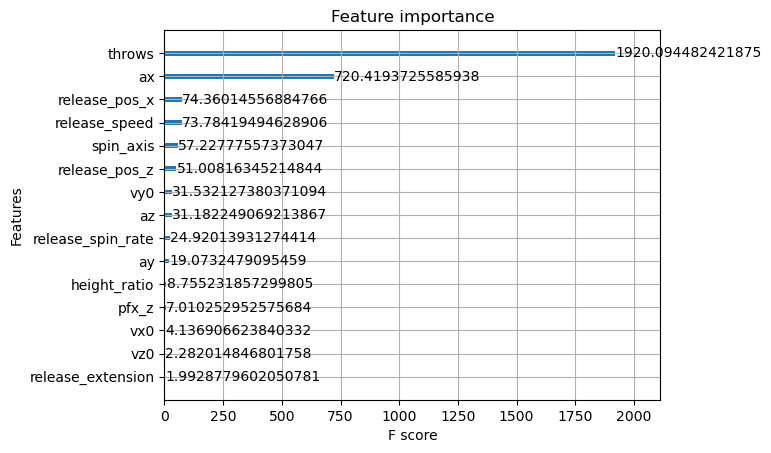

In [24]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [25]:
y_pred = final_model.predict(dtest)

In [26]:
print(y_pred.min())

-1.9808857


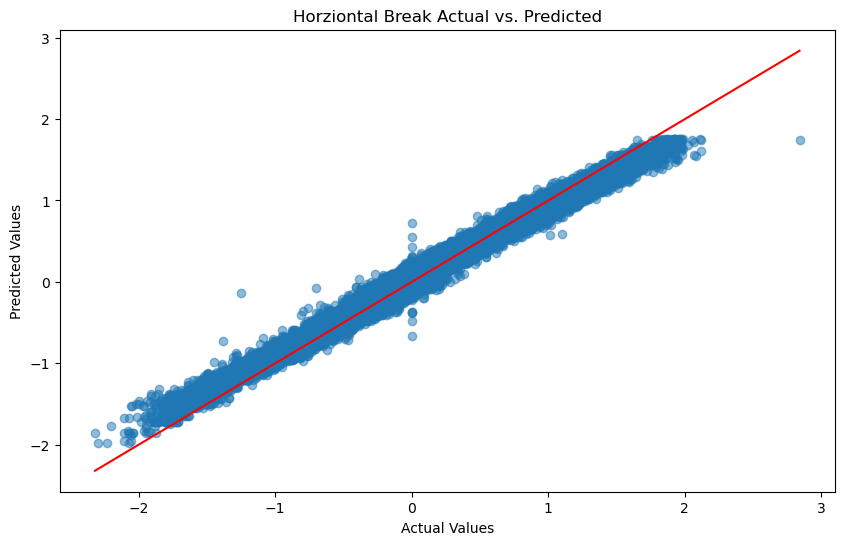

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Horziontal Break Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [28]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [42]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [43]:
testing_identifiers['xpfx_x'] = predictions

In [44]:
testing_identifiers.head()

pitch_id_raw    xpfx_x
4   663364_657077_605347_1_73_10  0.374818
7   663364_593428_605347_2_72_10  0.433769
8   663364_593428_605347_1_72_10  0.390237
10  663364_596115_605347_5_70_10  0.196521
20   663364_602104_518489_2_69_9  0.795282

In [45]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/pfx_2022&3_xpfx.csv")